## TOC:
* [EDA](#Loading)
* [Cross-Validation dataset](#cross-validation)
* [Fit a random forest](#forest)
* [PCA](#PCA)
* [Fit a forest to PCA](#fit-PCA)
* [Summary](#Summary)

*Week 6 Assignment*

**EDA and PCA on digits**
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training a random forest model on both the full set and then PCA data. 


In [22]:
# Imports
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit 

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline

## EDA <a class="anchor" id="Loading"></a>

In [3]:
# Set some options to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


digitsDf = pd.read_csv('digits/digit-recognizer/train.csv')

digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

print("There are {} missing rows in the data".format(sum(digitsDf.isna().sum())))

digitsDf = digitsDf.dropna()

print("There are {} features in the data".format(len(digitsDf.columns)))

digitsDf.columns

There are 0 missing rows in the data
There are 785 features in the data


Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780', 'pixel781', 'pixel782', 'pixel783'], dtype='object', length=785)

In [4]:
digitsDf.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,...,pixel534,pixel535,pixel536,pixel537,pixel538,pixel539,pixel540,pixel541,pixel542,pixel543,pixel544,pixel545,pixel546,pixel547,pixel548,pixel549,pixel550,pixel551,pixel552,pixel553,pixel554,pixel555,pixel556,pixel557,pixel558,pixel559,pixel560,pixel561,pixel562,pixel563,pixel564,pixel565,pixel566,pixel567,pixel568,pixel569,pixel570,pixel571,pixel572,pixel573,pixel574,pixel575,pixel576,pixel577,pixel578,pixel579,pixel580,pixel581,pixel582,pixel583,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixe

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

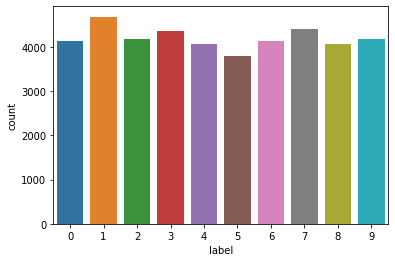

In [5]:
g = sns.countplot(x=digitsDf["label"])

digitsDf["label"].value_counts()

## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [6]:
# Now let's create a test/training set

X, X_test, y, y_test = train_test_split(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy(), 
                                        digitsDf['label'], 
                                        test_size=0.2, 
                                        random_state=42)


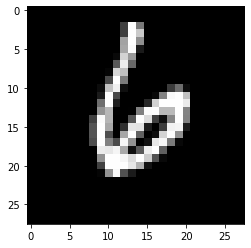

In [7]:
# What do the images look like

first_image = X.iloc[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

## Full Forest Regression <a class="anchor" id="forest"></a>

Best parameters: {'regressor__criterion': 'gini', 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__n_estimators': 500}
Parameter tuning time: 279.6
Random forest fit time: 22.82


/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


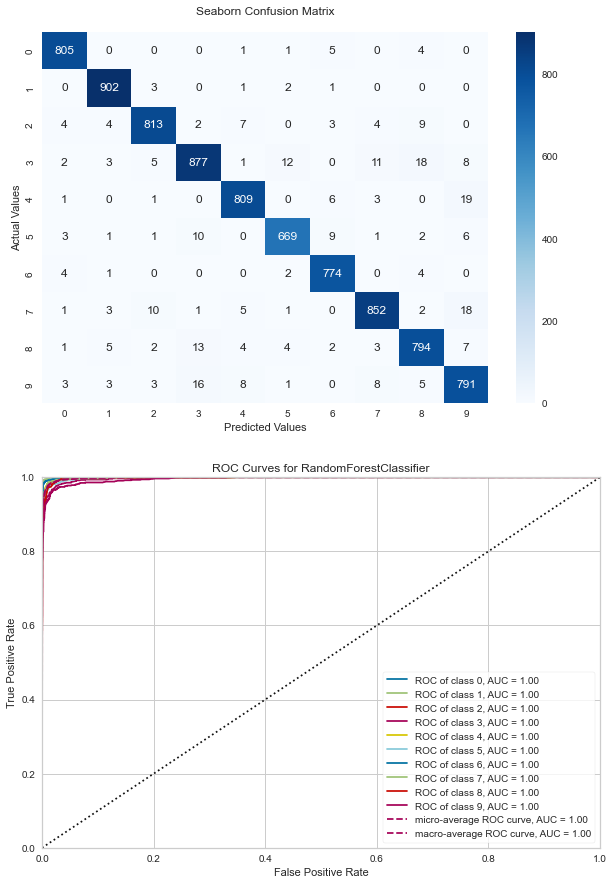

In [36]:
# Fit a random forest on all the data with timings
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ROCAUC

grid = {}
grid['regressor__max_depth'] = [15, 20, 25, 30]
grid['regressor__criterion'] = ["gini", "entropy"]
grid['regressor__n_estimators'] = [300, 400, 500]
grid['regressor__max_features'] = ["sqrt", "log2", len(X.columns)] 

regressor = RandomForestClassifier()
pipeline = Pipeline([("regressor", regressor)])

gscv = HalvingGridSearchCV(
                    pipeline, 
                    grid, 
                    scoring='f1_weighted', 
                    cv=3,
                    aggressive_elimination=True,
                    error_score=0.0,
                    n_jobs=8)

start_time = timeit.default_timer()
l_grid_result = gscv.fit(X, y)
stop_time = timeit.default_timer()
    
l_best_params = l_grid_result.best_params_ #{'regressor__criterion': 'gini', 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__n_estimators': 300} #l_grid_result.best_params_

print("Best parameters: {}".format(l_best_params))
print("Parameter tuning time: {time}".format(time=round(stop_time - start_time, 2)))

# prepare the model with target scaling
best_depth = l_best_params['regressor__max_depth']
best_n_estimators = l_best_params['regressor__n_estimators']
best_criterion = l_best_params['regressor__criterion']
best_max_features = l_best_params['regressor__max_features']
best_min_impurity_decrease = 0.0 #l_best_params['regressor__min_impurity_decrease']

regressor =  RandomForestClassifier(max_depth=best_depth,
                                            n_estimators=best_n_estimators,
                                            criterion=best_criterion,
                                            max_features=best_max_features,
                                            min_impurity_decrease=best_min_impurity_decrease)

pipeline = Pipeline([("regressor", regressor)])


start_time = timeit.default_timer()
pipeline.fit(X, y)
stop_time = timeit.default_timer()

y_pred = pipeline.predict(X_test)
print("Random forest fit time: {time}".format(time=round(stop_time - start_time, 2)))

fig, axs = plt.subplots(2, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

visualizer = ROCAUC(pipeline)

visualizer.fit(X, y)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()   

## Display the visualization of the Confusion Matrix.
plt.show()

In [41]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))

Precision score: 0.96
Recall score: 0.96
Accuracy score: 0.96
F1 score: 0.96


In [48]:
predictions = pipeline.predict(digitsTestDf)

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions.csv", index_label="ImageId")

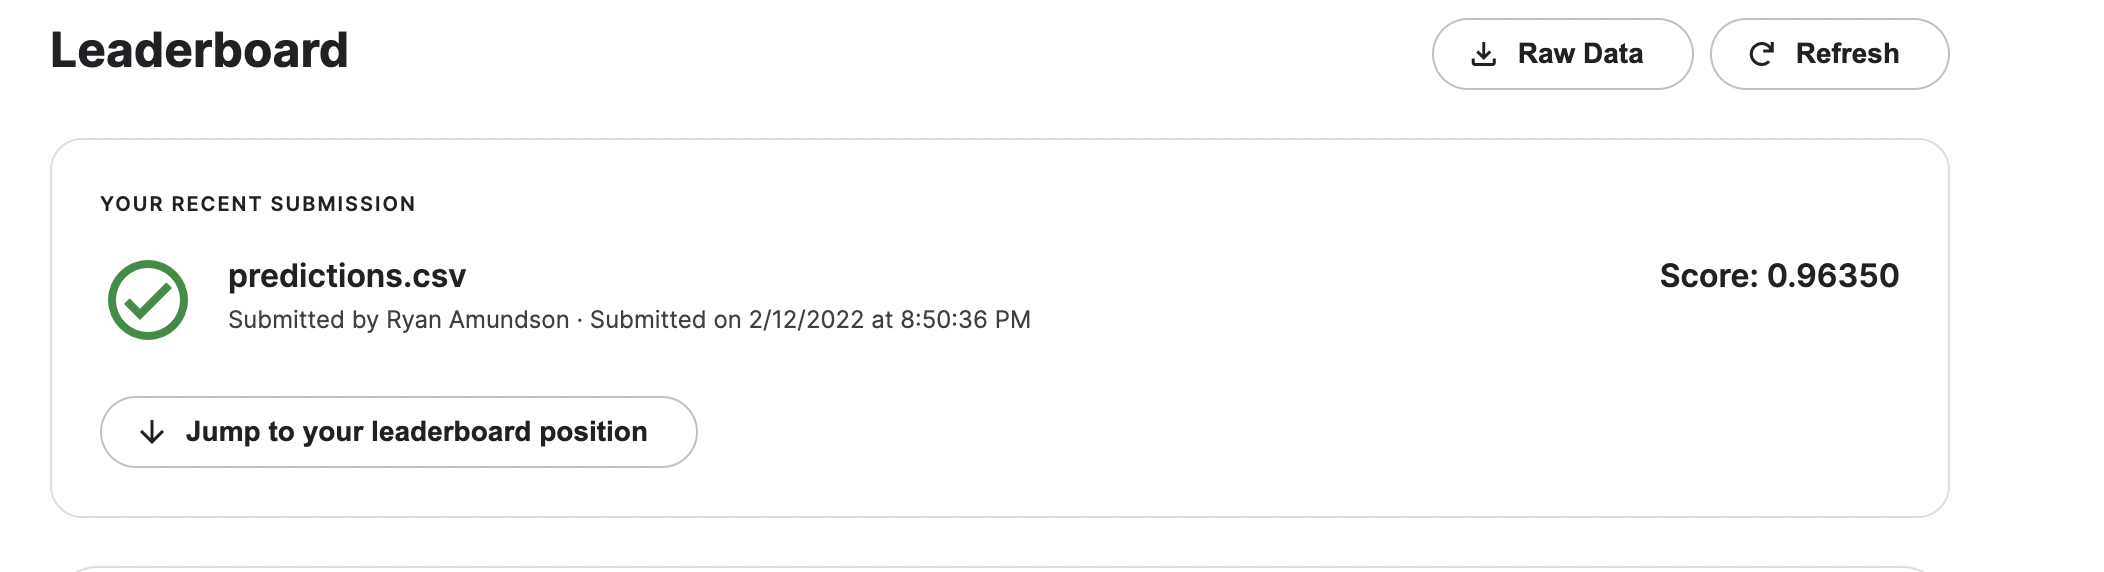

In [51]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAACDgAAAI8CAYAAAAeS4lkAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAACDigAwAEAAAAAQAAAjwAAAAAQVNDSUkAAABTY3JlZW5zaG90bcygKgAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTcyPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIxMDQ8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KxShW2AAAABxpRE9UAAAAAgAAAAAAAAEeAAAAKAAAAR4AAAEeAAKcTct7RNEAAEAASURBVHgB7L0JwF5VcTd+EnaSsCRsAgGCgguiQNC2KsUFULCtuH0qikoAv7rbunxfC1h3q+2/1Qq499+vtdVWBb7WtZXFuiCyBsSFPex7EAg7yTdz5vzmzJxz75vwkoTkzVzlzm9mfufMc+eZM/fmee57n2nLaEsDGxunWTsZlpEBNh41rSjCNSMAs1yWltEojJMpQbABPO4YZIj4kX/UUdRfrL/oP7abmo4JmGX03zj/xPkX5w27YvwVh9ewhNRKhrj+iOsP1FFcf8T1R1x/2G5qOiZglnH9Edcfcf2B84ZdMXptMQCwhNRFhrj+iOsP1FFcf8T1R1x/2G5qOiZglnH9Edcfcf2B84ZdMXptMQCwhNRFhrj+iOsP1FFcf8T1R1x/2G5qOiZglnH98Vhef0zDDQ7d22A7mJ7lKuj41UXIvcPV05lh4BFNGiJ+7aA1g4q6fKmHAfIKWZxQIZUX+e/yGfUX9YczuFtbonT14jhYYJCx/nIGkA7I6D+UFvknQ1dP0X+i/0T/cV3VKt16sU7tK9poxAsVUnlx/dPlM/pP9J/oP66rWKVbL9apfUUbTfQfzgDSAamG6L9dPUX/jf4b/dd1Vat068U6ta9ooxEvVEjlRf/p8hn9J/pP9B/XVazSrRfr1L6ijSb6D2cA6YBUQ/Tfrp6i/0b/jf7ruqpVuvVindpXtNGIFyqk8qL/dPmcIv1n2rKldCS4LasUib7/pPMDHqaVhWbtrp6YR/+5aRpDo+bh2TbgsKaIH/mP+sOXoM0aM4vQrpm6uCqh85Mr2wYc1hTrL9ZfrL9Yf9xJbF+onUVQ52sMjZoHZduAw5qi/0T/if4T/Ycbhu0L0nXqvvM1hkbNA7NtwGFN0X+i/0T/if7DDcP2hdp5BHW+xtCoeVC2DTisKfpP9J/oP9F/uGHYviBdp+47X2No1Dww2wYc1hT9J/pP9J/oP9wwbF+onUdQ52sMjZoHZduAw5qi/0T/if4T/Ycbhu0L0nXqvvM1hkbNA7NtwGFN0X/W7v6jT3CQUrFvLVusbrGwnbuYMEbYtLfPNQJn9O6QNobVLY74OQMDKYn8S1J0H/XX3xUR62/k7tB2QVnd4ug/0X8oAwMlAaO4aB/9J/qP/PukNA2uG6qLwbuz24KyusVlqgFT1J8kRfex/mL9xfqrvYdR9J/ov3H+8Wsia+0J1eoWl6EDpjj/SlJ0H+ffOP/G+df3mjj/xvk3zr9+TcT5lzLQXlBY3eKSugET5hAX7eP8G+ffOP/6XhPn3zj/xvnXr4mstScUq1u89px/8g0O9i4VOUHyAZSumI9LDo73vKFfVqu3CMvs80DaDRYVRaSGg7u0In6T5ZzkvMuXP5H/qD+/2qQ2ZLVZHOtPM8Bp4dUT/UdTYkH03zj/xPnXdlVeHUXPLVX6am4j1VM+jhCfrCeLxZL3eSDtov+YpFQY/Sf6T/Sf6D/SEXKzJBj9N+cjn1LyLv79V04ZdqVMK2fhWjvwFjKLXFK0i/OvSUqFcf6N82+cf9E3crOgxRHnn9wh8qkn7+L8U1qmrZQ4/0htSGosLsliwWbexfmXE9Ftcf6N82+cf21X5SUS59/cKHJLlb6a22jNTG6rcf6R3ORclYwINvucONrF+cckpcKpfP6RJzjkGpFCUcjHj55TczGKeBxveYhTxG73nVuDluXaEezoYeyGOKXnd242TMs7WSIdoZ+jtbghTmmZ5XqPQ8KVQ+ddxOe8LCd/SJuVbohTLEtw52ZDvP+chKg/lAKXii5QVibeXE05pR/XuaP+Yv1F/6GFEv1HWwG3jeg/ffMcsbie6pR+QOfWpEf9aSo4bVF/ffGMWFxNOaUf0Lk16VF/mgpOW9RfXzwjFldTTukHdG5NetSfpoLTFvXXF8+IxdWUU/oBnVuTHvWnqeC0Rf31xTNicTXllH5A59akR/1pKjhtUX998YxYXE05pR/QuTXpUX+aCk5b1F9fPCMWV1NO6Qd0bk161J+mgtMW9dcXz4jF1ZRT+gGdW5Me9aep4LRF/fXFM2JxNeWUfkDn1qRH/WkqOG1ToP6mLaXbN/xx5EMsVWFKoZitl0mijzjLLExaRl/gTNOMYZZl5KpWocOH2VnSKxwJIeYRp0yYx0Z8m2nkOPJvsyLlgtywxpi3qL9Yf64MclXwTqql1IwtHWUIKfqPXWlIVPQfmxUpGeSGNca8Rf+J/uPKIFcF76RaSs3Y0lGGkKL/2JWGREX/sVmRkkFuWGPMW/Sf6D+uDHJV8E6qpdSMLR1lCCn6j11pSFT0H5sVKRnkhjXGvEX/if7jyiBXBe+kWkrN2NJRhpCi/9iVhkRF/7FZkZJBblhjzFv0n+g/rgxyVfBOqqXUjC0dZQgp+o9daUhU9B+bFSkZ5IY1xrxF/4n+48ogVwXvpFpKzdjSUYaQov/YlYZERf+xWZGSQW5YY8xb9J/oP64MclXwTqql1IwtHWUI6bHqP/QEh6X0ssydK1TL7Tb2ulvemO7Gs8KbxhFv3jui0Hg/Yq6E5SA3nhXeIr7kwZaoS1RxkxgxV8JykBsf+ZdsRf2VqpHqyHtXKLWoRsyVsBzkxrPCW+Rf8hDrPxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Lbaqo/+YkKDuheBRvMtoyc/PslJPhxD/raDGUM1mmH7pYyoyrRGAuM+JH/qL9Yf9F/ov/G+SfOv/0VwqilXlbE9Ud/t7ZJW02UMRYY119x/RXXX3H9Fddfcf0V119x/dVfIYxa6mVFXH/F9Vf7tFZTNrVQjLHAuP6M68+4/ozrz7j+jOvPuP6M68/+CmHUUi8r4vozrj/j+nP0u/u6UPq1tBZffw/8RIX9RwXj4ZRMlI98swTSNDi8jCYxesNETmrEj/wPFtCE9+NE/WHxjS3fWH95XUX/if5L7WWww8T5pyRmMDvRf8daK7debq/YBtMX/Tf6LxVGnH/i/ENlMNwiqDiyY9Ab/Zf663BmyBH9F2efkSTF+ScnJvpv9F9qIoN9JK7/S2IGsxPnnzj/DK8bPvPE+TfOv8jAYPuI64+4/qDCiOuvuP6iMhhuEVQc2THojesP6q/DmYnzb1x/4OQ7ViTrzvlXf6Iip6Qct0lP00hqYvLqGuDLWHHADanzOoNRDATXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxZH3S5ct44coyF23DEYH6ehCGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTrQeeoIDP4vPbnDDXO56wG9JwE1DDDSat9qZGas3A9UMDTaWvEX8nLXIv5YCns2DSpE6gQYp1nav3gxUMzTYWPIW9Rf1R7UQ60+XQqw/6QzoFF7zVvHVvXozUK0S9AzJPt6i/0T/oVqI/qNLIfqPdAbfPaBBCqfdqzcD1QwNNpa8Rf+J/kO1EP1Hl0L0H+kM6BRe81bx1b16M1CtEuL6h3JRem7OSvTf6L+0TqL/1mXBS4I23z2gQQqn3as3A9UMDTaWvMX6i/VHtRDrT5dCXP9IZ0Cn8Jq3iq/u1ZuBapWgXY19vEX/if5DtRD9R5dC9B/pDL57QIMUTrtXbwaqGRpsLHmL/hP9h2phLe0/05bRIxzSNBS1lPTQfpgBK6QfyfdOTJsmC4QQ+pKrFzmfD4+3sw0zYIW0IyhMxI/8R/3RolhG/4v1x50ob9Qu0K+j/1BGov9zEqQ2RvYjZ5gybsQb5584/8T5h9ZInH/i/BvXH3qGieuPuP6iYsj1kC8dhq8f7KXIMANWSDsi/v0b//6Pz1/i8yfuMnH9Fddfcf0V11/l+oAuF+Lzr7j+iuvPfGqMzz/j818qBD07lCbpxci/sMq4EW98/huf/8bnv7RGHsN/f9CHALQMzfJWRYFf6QMamDwRv5+QSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZna/USFkDFEZnM2O3ogWG+qc2VEO717tCfLH1SXPdwRn29AKXmM/MtdNCiO5cqSN+JlRLuoP66n4U2yVXPGLGeL+ov6y3clDtdPb621lBHtYv3F+ov+068UtrheWyjOFv03+m/03+HFM2iV1cOujGgX5584/8T5Z3CxxPmH0qL/1i4pivOvyUlcf8T1R1x/DDfPQWtcf+BqI66/KBNx/RnX33TxGdefg80yrj8pLXH9Wc+ZXCWiFVtcf1KBjHWPoTVVc5kR7eLzj+i/YxUk1VJrZm1ff80NDubAFCrIq8dq6DXZZh3dOpvQadiGp1BBxKcM2GxE/qXX55zYxJiKEjih07ANT6GCzLNa5D/yz9cauSZsYZiKivrjDEyYHJMtw1OoIPOsFusv1l+sv+g/uSfYxmA6isAJnYZteAoVRP+hDNhsRP+N/hv9N/pv7gm2MZiOKnBCp2EbnkIFmWe16D/Rf6L/RP/JPcE2BtNRov9wBiZMjsmW4SlUkHlWi/4b/Tf6b/Tf3BNsYzAdReCETsM2PIUKov9QBmw2ov9G/43+G/039wTbGExHFTih07ANT6GCzLPa2tB/mhscmgZKhzR2pweY9oBNpjoovMrOqKrKtyaLlaBAvBNzlFxODJWdUVWVaE0WK0GBeCfmKDniUyrsnYk5bwPJsyaLayaBxDsxB9y+WvO4gcHWZHGdCUi8E3PAjfhttrI+kDxrsrhmEki8E3PAjfy32cr6QPKsyeKaSSDxTswBN/LfZivrA8mzJotrJoHEOzEH3Mh/m62sDyTPmiyumQQS78QccCP/bbayPpA8a7K4ZhJIvBNzwI38t9nK+kDyrMnimkkg8U7MATfy32Yr6wPJsyaLayaBxDsxB9zIf5utrA8kz5osrpkEEu/EHHAj/222sj6QPGuyuGYSSLwTc8CN/LfZyvpA8qzJ4ppJIPFOzAE38t9mK+sDybMmi2smgcQ7MQfcyH+brawPJM+aLK6ZBBLvxBxwI/9ttrI+kDxrsrhmEki8E3PAjfy32cr6QPKsyeKaSSDxTswBN/LfZivrA8mzJotrJoHEOzEH3Mh/m62sDyTPmiyumQQS78QccCP/bbayPpA8a7K4ZhJIvBNzwI38t9nK+kDyrMnimkkg8U7MATfy32Yr6wPJsyaLayaBxDsxB9x1N/96g8N4opbRl/PT3JfT9TaysVFjdk44fJDyJnitvjHMj/iRf3tzhJZQBbZgTI015qyi0iCF4zU7Luov1l+sv1h/pkMoVGAbBuExO9Pgg5ShXhMbPLH+Yv3F+jMrRKECu2AIj9mZBh+kDPWa2OCJ9RfrL9afWSEKFdgFQ3jMzjT4IGWo18QGT6y/WH+x/swKUajALhjCY3amwQcpQ70mNnhi/cX6i/VnVohCBXbBEB6zMw0+SBnqNbHBE+tvxdffnXctSXfddWe659770j333Jfuf+C+9MADD6WHH16ali59OOdfZuOMT8+6/OkVZ1k2luyVjT//m06+pWQkT3FOoz+dXUa2LNme/5yRRzCBuPlPawvOtjKQRkV8zl3kf3XX3/Tp09L09aanjTfcMG244QZp001mpE033TjNmjWL/puRq1Rq3u7j829esXfddVe6684l6Z777k33LKGe8uAD1Fvup56ylHoL1XKsf2l9uYqi/62J/T/WP/c1Pu/gXMxSNlihVxn9D1csZYHXFGoua7aWl8062Gfca3a+R5d/usFhKc1d3+j6msdDIrxn4IUUr3OSUi4O8VgLzFEPuB3nJqh0gzwj4kshtnlkPfIf9UdrnP4f64/SYNpd9B/fRaP/U7vM9dHkpbRVKzwjzj9x/uGPrsrmioOUuP6J80+cf+P6g1pBXH+gSbJ0jdKojd0OKdgz4vwb5984/8b1x1BzoE4R119x/RXXX1Pu+uu+++5Lt956e7p98eK0+Ld3pmX03Vq+iDAXB/nrdF7/9AUv+3OPnMZERiCyZJVsbJ5WegZDttNWGKIUHT72ykzlpglRMjfiU24i/2t0/fGXn1tsvnmavcUWaautZ6dNNt6IardWtxa9AabEyTq1rr/vvf/edOsti6mv3JHuyH1laax/894z7N9/rpjofzkzJjlrQ/+P9V+KW983BU3VV9Uzplb/a1d3PeqK1obj1yc4tAdU366K6qEV5I9Q3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYImtRq3IsjP2Q9TdmqGLtHsdQgAssdWoFVl2xn6IulszdJF2r0MIgCW2GrUiy87YD1F3a4Yu0u51CAGwxFajVmTZGfsh6m7N0EXavQ4hAJbYatSKLDtjP0TdrRm6SLvXIQTAEluNWpFlZ+yHqLs1Qxdp9zqEAFhiq1ErsuyM/RB1t2boIu1ehxAAS2w1akWWnbEfou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhi7R7HUIALLHVqBVZdsZ+iLpbM3SRdq9DCIAlthq1IsvO2A9Rd2uGLtLudQgBsMRWo1Zk2Rn7IepuzdBF2r0OIQCW2GrUiiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYImtRq3IsjP2Q9TdmqGLtHsdQgAssdWoFVl2xn6IulszdJF2r0MIgCW2GrUiy87YD1F3a4Yu0u51CAGwxFajVmTZGfsh6m7N0EXavQ4hAJbYatSKLDtjP0TdrRm6SLvXIQTAEluNWpFlZ+yHqLs1Qxdp9zqEAFhiq1ErsuyM/RB1t2boIu1ehxAAS2w1akWWnbEfou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhi7R7HUIALLHVqBVZ9o033ZxuvPEWuqnht2TmL2L59r6UZszYNM2cNTPNJLnJxhunTTbaOK2/4fppg/XWT9Por9f5yybm+2hkaiw1akXMcls/SXa3Zugi7d7OBpbYatSKLHswUCH4meqR2cgtp7IiPmegZr2ikt4q+iRmX2uGLtLu61SrI/8P0VNMli19kJ488FC6974H0n30NIIlS+6hpxPcne5esoReTL2hYfMtNkvbb7tt2m7brSgX5sbR8ZesHhwvDNDtkcMGzuo4/hWJz33lhptuTYvvWExHzV/W840N09KsGTPyUy5mzKS+Qj1l4402ShttsEGavv76aT3qK3Zrjw36isTHPLXqKoJPJSZWg4DWDD3i186PnNTUeUvNekWVW5Afou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhx/pft99/qQO715IhgCoRW626iiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6jbmvMNDvirbjeVYQk0e+PLLyzrdHJ0do5HBtwRq+F7EPFp4eX0mUsJk0uBZm98kX9KRs5H1F+sP+ot9Ro9+k/03zj/xPm36Qlx/dFmIK6/4vorrj/5MjKuv/WjTPNvDIFmb3zx7w9KRs5H/PtD8mDPLpwbyou7Jrd+wXH+ifNPnH/i/BPn37j+mOj6Yyk9Cn7Rtdel6667KT348AP5vMt9Y+s5c9KcObPpr883TxtutKE5wcT5J86/cf2xItdfDz74YLqNnoJy++13pFtuvY1uhJCfX1l/g/XTDts/Lu284+Po5y3Wl0u8fL2LZcZrjLCcwJtrvbVj/T300NJ07XXXp2uuvz499OBDmq5ttt4qzZ69Rdpyyy3TRnSTFB9cPtS8mzrHH9ffKN919/y7Lq//qP+pW//mCQ5o2EW6Js42ayj/FLEmHW7+maJ+BWUao+u4BnQUa4j4uRXblGj6Iv96mtL8KIj6y6kw+dC6aUBHsYZYf7H+6KMIWxJaPtF/ov+Uj6m0PhRE/82pMPnQddOAjmIN0X+j/0b/jfMP9Yzuy+M4/8b5N86/eVnoKVNBXH/kVJh8NJcdqnYUa4jrj7j+iOuPuP5Yfdcfi665Ni26+jr6vfuHKeiyNGuzzdIO9Bfm29BfmK833f4FdVz/xPVPXP88muufh+lGoptvvjldf9Mt6c4778yXBOvTUwrm7jQ37TJ3h7z+psr5j/vK1dRXHqK+wjmbtdmstP1226Vtt5pDT2fwfaX+Yyuuf6bK+5+Le2hnL3ez3xqm9vu/Lq3/obe+e7s7w9R+/7vD7Qxrz/GbGxxkAftlXFq6NbYHm311LLvrZ251IBBknsbt6hwYr1wFGGAMGYrOe94wvnyakW0YAZmNblfnwHjlKsAAY8hQdN7zhvERv+YJCFIyZffisX7FCsA3hgxF5z1vkX/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLznreoP8lD1F+tEyBIZKhK8Vi/YgVgG0OGovOet6g/yUPUX60TIEhkqErxWL9iBWAbQ4ai8563qD/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLznreoP8lD1F+tEyBIZKhK8Vi/YgVgG0OGovOet6g/yUPUX60TIEhkqErxWL9iBWAbQ4ai8563qD/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLznreoP8lD1F+tEyBIZKhK8Vg/48X0F+WXXXFluueee/PDCOZsuUWaS39RvuXsLWVoHlDHsjHqT1IT9VerCQgSGaqy1hDqR7kKwDaGDEXnPW8YPxXy/9vFv01X01NTbl98R15/MzfdNO26y075iSn5YNfS47+N+srlV12Vltx9L71fy+hJDZunHXfcIW25xRb6/sm7SkepIB+xN6ylx48jqVIO0h6qYgVgG0OGovOet6lU//lYzOHKERpDhqLznrepdPxTdf3LO2X39T3E+ycW4igA3xgyFJ33vGG8HYgRkMK0+zoHxitXAfjGkKHovOcN4yM+3Ya1jDckRUHOE+WHDPzoIdrUpaBwIFr7oA5jkV6YIGXSiB/5j/rLiwErpy5ELDysFZK1sw2sJfZjFr/wYO3mjvUX6y/WX15go2ukLL9+7QytR8wS6y83K5+GgZ5FhKi/qD/KAFZOBVh4RSphIh2kIr0wQTAHEaL+cjKQucg/pcNeZ5VS6fKiCUMt8TgYi/Qi6g/p0ZySIdZfzoamRgGSVGRrH9RhLNKLqD+kB6mNf//E+ov+E/2HMqCtQQGaRJGtfVCHsUgvTBDMSYR1uP4uvfSKdO0NN+ZkzJw5M83bece01ezZlJMm96witXAN6jAW6cXAHERYh/Mfn//H+4/6v+W229OiRdemu+66O6+/Hekmo92eMA+rbWDtkMuu07zWyoLDYi0qrDDrpKvo+uvSy6ivXE99hQLP2mxm2nmnHelnbqiv6Aspr2AVxddAj9HxR3yfeH3bFcT7nzNg6n8qrf+o/3Wn/usTHEwx6wmGANY8pPUBV19F8EFmT+c2hoivF9PIGUtkCNL6gKuvIvggs6dzG0PkP/Jf/jGHmmGJCoG0PuDqqwg+yOzp3MYQ9Rf1F/WH5aISKwRSHQZUX0XGnWH2dG5jiPUX6y/WX7ts4vxHGeHPqUynGM3RRKzoP5THLonGEP03+m/039HeYlbKKCf6z3iWsqdzG0P0n+g/0X9Ge4tZKaOc6D/jWcqezm0Mpv/cffeS9KtLrkh3331Xvu58/Lyd0k5zd3Tfl9o3oc5SkfUzzp7ObQwmvh0LBqT1AVdfRfBBZk/nNoaIH/13Lei/V199LT354Opc1pvNnJWeuPuuacbMGWVtmnpG4Re5JtT/kruor1x6OT214e7cD3bdZS7d3DBXXmGsv1h/a8H6a5ZVVuuqq6jlraz1tzav//j8harC3nRmP9Wbov2v3uBgV0S7Tlpdub2jtyi5AiIto2orv5RV7UDtJK0Onn2Dim2UqmMIRPzIf9RfrD/f7WuHaJtIqyuzd/QWJVdApOh/0f/j/Oeuttz6cEtzdFH1jt5Sp1UU6y/6T5z/4/zvmox2h/Jp+AS6uvpu01uUXEH0n+g/0X+i/0T/qT3RoraJtrpye0dvUXIFRIp/f8W/v+LfX2vev79uufX29MtfXZKW0v9mzZiVdt9tXtqMnt4w3Cr71d5b6rJXFOs/+l9cf036+utOeorDJZdeSU9zuDNNX3+99JQn7pa23mpOXl5r6vq75dbb0i9/fWlaupT7ysy02xPnpc3pBo3BrT2IVtdBvaO3KLkCIsX1R1x/rK3XH2vj+q+Lj1Csv3Wm//gbHPIbb64lR+7q0GIx3VygMTAJapa8YxMt62KHOzvESYmP+PrPjsg/FYNmQ8tEgSkggcZQ6in/wyibeRf1F+sv+k/0X2oE1FaabpENcf6J86+eceL8G+ffuP7I102DO9NABRoDD4CaJe/i+iuuv+L6K66/qBHE9Ze2x9wYpTnG5x9UF3H9VSoirj/j+nMduv687rob028uvyKv/8dtt0160m6Pj/d/HXr/+YQYn7+sPee/X//msnTDTTfnf+ftttuuacftt5ULO1zQrCH//uO+csnll+fEbrfttunJuz0hY7w8vNyov1h/0X9WvP+sLetf/qEVnz9xn1vXPn+SGxy6Tp/PWfUfmlIhch4Y4OoJ4pECzAVpxnuT0Qw09MlBzAVpZvEmoxlo6JODmAvSzOJNRjPQ0CcHMRekmcWbjGagoU8OYi5IM4s3Gc1AQ58cxFyQZhZvMpqBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMNPTJQcwFaWbxJqMZaOiTg5gL0sziTUYz0NAnBzEXpJnFm4xmoKFPDmIuSDOLNxnNQEOfHMRckGYWbzKagYY+OYi5IM0s3mQ0Aw19chBzQZpZvMloBhr65CDmgjSzeJPRDDT0yUHMBWlm8SajGWjok4OYC9LM4k1GM9DQJwcxF6SZxZuMZqChTw5iLkgzizcZzUBDnxzEXJBmFm8ymoGGPjmIuSDNLN5kNAMNfXIQc0GaWbzJaAYa+uQg5oI0s3iT0Qw09MlBzAVpZvEmoxlo6JODmAvSzOJNRjPQ0CcHMRekmcWbjGagoU8OYi5IM4s3Gc1AQ58cxFyQZhZvMpqBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMNPTJQcwFaWbxJqMZaOiTg5gL0sziTUYz0NAnBzEXpJnFm4xmoKFPDmIuSDOLNxnNQEOfHMRckGYWbzKagYY+OYi5IM0s3mQ0Aw19chBzQZpZvMloBhr65CDmgjSzeJPRDDT0yUHMBWlm8SajGWjok4OYC9LM4k1GM9DQJwcxF6SZxZuMZqChTw5iLpLXXH99uuzyq/I8u+w8N/F/eqNTfP5MeSnZQM4ml3E/CnNBGq83Gc1AQ58cxFyQZhZvMpqBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMZPqVi65JV9F/vO226y5pxx23z3iFdpgL0gzyJqMZaOij8Jprqa9ccVVePTvvvFOat/OOlYu5IKvHdhyyGoKBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMNPTJQcwFaWbxJqMZaOiTg5gL0sziTUYz0NAnBzEXpJnFm4xmINPX9PVvDqmHOBZIw/Amoxlo6JODmAvSzOJNRjPQ0CcHMRekmcWbjGagoU8OYi5IM4s3Gc1AQx+F/gkOShuYZcCU6dlunAoV6OmhWtwpQ6NWYJnFOmCK+JSBnBeTHIUKIv+UJv7nQc2Ix7mO3M4yi2PAlD3ZbpwKFWjcaon4Nhcu9TWp3jw2INuNU6GCyD9lMurfr7laHb7MRBvwDpgyN9uNU6GCqL+ov1h/VAN1RXgsa87uLbPYB0zZk+3GqVCBxq2WiG9zYTMveMA7YIr8UwZyXkxyFCqI+qM0xfWH7zm1OmTF+f2Ad8CUx2S7cSpUEPUX9Rfrj2qgrgiP/dpjzTKLd8CUPdlunAoV6GzVMhihBGJhmcU8YMqebDdOhQp0tmoZjFACsbDMYh4wZU+2G6dCBTpbtQxGKIFYWGYxD5iyJ9uNU6ECna1aBiOUQCwss5gHTNmT7capUIHOVi2DEUogFpZZzAOm7Ml241SoQGerlsEIJRALyyzmAVP2ZLtxKlSgs1WLj3Dt9Temyy67IvN2ezx9SbrD42jq8oV+Ca+TQIfMk5qZFSrQodXi42OqKi2zWAdM2ZPtxqlQQcSnRMX1n6+5Wh216ioa8A6Y1pT6u/b669Klly/KL2e3x88r67e+YCBIJlqcB7rdgHfAlIdku3EqXJauvf6mdCn3FXoS0m5P4Ne1vXYVpbm4UAa8A6blxUcPw1BIHmcxolY54B0wZX62G6dCBRqrWiK+zUXNO9CAd8AU+acMUF7W1PUf60+uoVC6kFy3Fuc6drsB74ApD8l241SoQGNVy+qLTzc4LKX+T48NLdeT9kXgmGGDZDswJLi9tAyLwVxGJ6CIH/mXehiukPEL5CE+KqufcYgd9RfrL/pP9J++W6CPoGtAsh0YEtxeWobFYEb/if4T/Sf6j/SD4Q4R1z9jH5AO5Qudtc/oEDv6b/Tf6L/Rf/tugT6CrgHJdmBIcHtpGRaDGf0n+k/0n+g/0g+GO8TUvf675dZb00UXX5Km0wXe4/PNDfVLyNohp+7x85kk+l/0v7W9/11z3XX0BJZFeck+9SlPTFtvNacsX9vRLK6re1XU/83UV375y0tpdS1NT6CbLubSzQ31qg2xWcb6WxX5rxm277nFYET+p0L+17T1j+ryaz7qT66kanamev8zT3Aob34WthCsnRNjfTZRK4Z1NAH3ezeYNxOUVeOpScFgwJtvvjV997vfJh9dMdtPRZeyviw9Z7/90uN3nZcPY1XEH3xRxqivnsC6En/RNVenM079Yc5/e/z8D5t99tknPfWpe8h7lgnKIlvBalJgsrriUEcTWNX5/68f/CBdf931Uoel/mz8Vx/26rTRhhuWF188WShrrT7+oXdFj4zAqs7/6oy/aBHV+BlnUEgqaLqozpJhOeB99pmf9qQan6rHT0e6Qlscv1QIF8JUqv8VevOJFO9/vP/cFqP+Y/1H/yu9IDfP0hmz0C5ZO6aaFORRj3SnowlE/iP/uRdH/TXrTFdJY+dEWR/rj2zT0bH+ov/Q4ov1h/VTVkYWukrIae3MtT6MXXGpownE+e+xrb+7lixJ5y+8KC19eGnamR4dP48eIS9vr75L9f1Wk4IVf9MNU0cTiPf/sX3/I/9TK//yuPpr0/TpKc3f62lp5swZZuUJXB3r7+67l6RzL6C+smxp2mWnudRX5urrWB3xNdgAiPil5qP/Trnzz5qy/geWnZpi/a1b68/c4KA1kIEWAsxNQ6Kn/jRPfTAjALOkO7Ton3H1H3I8IQiYvJcdgwz2gmgs/sKFF6ZDD315yrcEL6VBdFODjf/iFx+Sjv/Mpyigf0XtK5hs/DwPBmfp40scENqoVe8YZFiR418T4//g1NPT0Uf/z3pw9J5Mo4PhY+T34dhj/ywdueCI6ic0FY7/yAVHp9POON3VXz7IcvwXXHBu2myzzdxxQ5kKxy9v4rpR/6efdmo68qg/lreP3zy+c8f0n+OO/XNT4927i7ddZccgw9q6/m3/rQmK/qtv9gCI9785Q0f9x/qnloGuMXb9l5cSFk+W68b5R66mSnbi+KVQ4v2nPET9x/XH6vv3d/RfykD03+i/fCqO80+cf+L823/+VRrkOeddmO66++70uO22SU/a/Qn51IEdWih0HhKff0hb5ZzEv38oF+6fO6ZiALOM69/Vef3760suSzfccHOatdmstO9eez4m/f+cc6mv3EN9ZRvqK098/Gj/0d4yAFBC6iJD9J/oP/H5k6yIsfPPmrD+y+VFXH/H+Y8+/uIfKKKtuwywFaxdvoKOX115NmmFzWkCKqRW4sqLn29weOnL6DXQbYT4S2pCuTFR3IP/4OB0wt/9XTWUj8y741lLj58OlTYkGFKsvbn6V+Xxn3rqaXKDA4Vb5t4WiX8sffm7YMEb6Z3A6YMPgXy4gi0v34ru9Vpnf6DixeFCKm/l1Z8NdOSRR6XTTv9hNqH+7PEvvOAcusFh8+zvjmcKHH+tQ8mKpns15X91xucaP0pv4uEDdIWe+AaHBUccIX1nCh5/eYfH3mix47ghtSBWzfpbne9/HL/NAN5gyLGyqP7of83HENH/1/rzf/Sfur5zB4AKGf2f0iLXvNH/ov9NtX//RP/TRicXQFAho/9F/4v+Xy4Nov+vS/3/ssuvTNdcf32aNZO+CN3nadQJ4/1fl95/aXt6Ioz3fwrV/znnLUx3331P2mH7bdNuT9hVrn14j7cbUg3sWjnr/9LLrkzX5r6yGfWVp1JQ+fdVfhGIC7kK4uc4Oq8GGjFX/8o6/pFAI+aIj/qI/K+c9ceF9liu/5FCHzFH/U/1+p+2bCl9km7OAVwJ9W0nzO7yRbO1S8XUfedrDI2aB2bbgMOaHmn8fIPDy+gJDvSU+Gn0HSN/T8BvojSwZemQQw5JJxxPNzjQtiri54l1ctVcTmFdV+Kfeurp6cij35TfBSwofU8oCcceZ/+6fe2uP7y3/IYfdfTR6dTTziBTrT97/BfQDQ6bz6InOEyh9WeP3x5XrnV1CphK9f8DusHhTXSDAx9TPu6m/xxDTyk5asERLgNT6fi797cxNGrOQxw/lcpAYqzpkZ7/tMDsJGRs1Mg/cjKQGGuK/K9d139R/yUDtohR65ocAZnS8NhjTVH/Uf9r07//tMRtETc1DU7Uf1x/xPUXrYb49ydaQpa2dcT5L85/cf6TBmHXhVswpHS+xmDV225fnC78xa/ymH3pUfabbTbTTWe5sf5i/cX6W7nrD4strzO72IrDmiaz/u6kp7KcS09R4O9f9tzjyWnO7C37/oCeYYM9yvi3c1+56Ff5b8vmP933lYEw8poGHNY0mePPh2EnwbGW44PIlIbHPmuK+NH/1rb+91itf/fPGLuImjUV608ysC70H32CgzlkvP8kbZVYXCgDJowRF+3tc30wM991MPjX+e2EVrd4PP7ChQvToS99RXnlNIbi5xsdeAjhFx/yIvqJik+vsviP9fGvifFPO/00usGBfqKC3wt6Z/I9NfwIf35LaTv2uGPSkUe8kVD7HlvdYh5F24AJRnHRfjXXn41/FD/B4bQfuvqzx7/w/PYnKtoDsrrFcvhr+vHzsT6W+V+d8eUpJX9M91UtpRrPkWVf+s8x/BMV/AQH3lZh/7P1tzqPXw4sHxzt/PGT6rc4/jj/rKLzf9S/nCd0/xie/6L/rDvnv9rgtfL0/Bf9v2Ynozj/xfkvzn/NomBVekd1WN3iwhgwYQ5x0T7Of3w57rfoP9F/ov/4NZG1tqFY3eIydMAU/UeSovuB/nvWOeene+65N+26y05p5512NO9Dm1CrWxz5HyxXY5wo//H5E2Un+p9Zd4DtGrO6xYU/YEL/u+rqa9OVVy1KMzadkZ65714IIHIVXX+cfQ49OYJ+mmLXXXZOO1Ffic8f6A0a6L+x/ikvsf79msxau6CtbnEZOmB6LNd/aS4k4vsHeWtov46v/3yDg71LTAqUS6X8qzhnStOVawj/Xq5Wb8kku2Mif3gx2FTIQyc83KX0aONfuPCi9BJ+ggOHy1FpzyfUEv+QF9NPVHxGnuDAr4q3lRlf8yZTy341Hv+aGP/UH/Dj+98k7z+9HfxXM/SOy/tCd3ke8+f01+1HLigZy8kizO8ebayWP7NpPOIq+8x1WCx5nwfSbjXUn75uCnzUkfQEB/6JClN/fFg4fvmJis2i/lbi+rf51wpYDe//qaeeTj/DcjRVIL/BFJnLLQva0/EdS09wOFJrXF9ZBtF/Vl7/f6zef3lHudD4XW+21VB/EjHiR/6j/prVJ9cQuSEP5IbI0X+j/66sf39E/xlYY3H+4y5DpTGQm+g/0X+nwL9/5Jwb15/R/wd6XPT/6P/l/Lfo2uvSlVcsSjPzT1PsmdtGXH/H9Xdcf6Nv5mZJ66Lo+ZQq59XGwyuKWLLPC8lhseR9Hki71Xz9ee55F6Y7714iNzLN3X6Vxl90DfWVK68qfeVp5uAJPkbHry8i4subsJrrL/JfMvAY1d/qXP9ypHyg6KP67sf6f4zef30HHsP48gSHXBdSHAr51Q3Uir7oBuRjwBCnNERSO7cGLafrjtDP0Vow5MKFF6ZDD31FjrKMvjzXR1AWwiGHHJyOLz9RoYe3EuPnOfFiNIB/tZ17isc/9TS6weEoeoJD2eT4+atgTtC0dOwx/OXvGzPWVJC2Ntafff8XHH1UOp2e4JCPA286HRaO/6ILzkuzNqOfqNCDfvT1b+OP5Q8vJXM5zxFfG4WmgvOiCWJl4o1/ouIoekqJ5J/39KM4pv8ce0z9GZbIv+RS06tJj/rXVHCKNEGSr4n2rqac0o/q3Bo08q+p4LRF/vviGbG4mnJKP6Bza9Kj/jQVnLaov754RiyuppzSD+jcmvSoP00Fpy3qry+eEYurKaf0Azq3Jj3qT1PBaYv664tnxOJqyin9gM6tSY/601Rw2qL++uIZsbiacko/oHNr0qP+NBWctilWfw8//HD66c/OSQ+S3HOPJ6at58yR4tCDjvdfUzEF3395s/H5pylvPeh4/zUVU+D9v2XxbekXv/hNWn/99dKzfmfftN566+US4GPkTdubHvTk3v+lDy9NP/7Z2ekh6itP2+NJaavZs5sAomK/suPzvG5OpyBqlZ2bDeaPODNkuiaojh1Dbk6n9CM6d8SP/K+C+ltd658r3NW0U6L+2wx06ZnC638a/VwAP8TCbPloi25SUczWyyTRR5yYldzLaAHJF9p1FI+2VqHbCIx5o1c4EkLM1bnwQrrB4aX0BAfa8tM52EX/LZu+LE0nw8F0g8MJx9NPVOSzx8qPP3hS4vir6fjXxPin0RMcFvzPN+X889uR3xC6m4/urskP9D+OH9+/4IjsyT49CGE/kvdfh5bZsniM8r/gqKPpBocz8iGh/uzxX3j+OWnmZps3L5kZWJFr9/HrW/AY5X91xj+VnuCQb+LBW0fBbf855v30lJIj7FNKmBj9Z2X3f106+ubnNK/T/Tef/9bh808cP/ciu9Jwjon+Y7MiLQO5YS3Ov5ITOleVtNjsIEPlYynlyBizp0FRf7ZJdz89AABAAElEQVTSkMVYfzYrUjHIDaqLZdRfrD9XBlwUeZNqKTVjSwcElmSP/mNXGhIV/cdmRUoGuSmFk43Rf6L/UCHUMpBSob1US6kZWzrKEFL0n2Vp0SJ6bP2ia9LsOZunp++xR05MrL/6qbiUjC0ixrzVwrNe9oherK2TCbyRPerPVhoSFec/mxUtFv0QjfPE2+Trb+EvfpkW33ZH2nmXHdO8nXeS6XAyIbky4i9adDX1lWvT7C23SE/f8yklhhFR/7H+4/MvWsW0jvO2+vrf6lj/8flTeT/xtprWh7d7XT3/03fMSykt5s45rAGTpLG8GcqE0I1nhTeNI968d0Sh8X7EXAkGLeQnOJQbHNjMYZYWyfqLDy5PcFhF8TlGu+H133333Wn96euljTfZZJUdv429ZMmStN706WkjiucOl0nO8Oje/4ceeig9cP/9adMZM2x4xfzX7UfTX7fzRueZfFEjdyyyhR/ff0xaQDc4sK++LvbJNmKGO8sllNvpdIfoJpzbZnPjWeFtJR3/w0sfTotvX5w23mijNGPmTHoKmE5MT6WgGxxOP8PVnz3+hQvPTZvNmpVfTH6N5YXyI/vuuutu8s2k16ntO7/syeyWd/wca6ONN04brr+ByUuN5MZX8wojN56Uhx56OC2h30qbtdmsND3n69HV3/JeiI1/9513pQco/syZm6YNN9yQhoo37y3RTMrmpVTj9z9ANU6/KTe0nUY1fiQ/paS+/ZnGKvcfvYmHJ+NNeRI07wWK3+xHzIYxMXTjWeEt4kseVvD913SVUY9ERP6bcuPkaUIlO3nvElUzPGKuhOUgN54V3iK+5CHqPxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8LbOlh/Pz6T/sr6gQfT0/bcI82evbnkIeovF0OuEVcoJT0kRsyVsBzkxrPC2zpYf/m44/hzGlbX+3/H4jvSeRf9Mm24wQbpOb/3DCnmlVx/ua88+GB6+lOfkracvYUcn9lH/TfLfSXn36R6EEb+1938r471P1h0xhj1t+7Wn/xEBReDqwJTHdlHTv4ikkT+q+TGPZFapx26W8+MrERjLJC+8F3R+HyDw0te9nL9/lym5de+lJ7iMC3f4HBC+YkKF2glxcect99+e/rmSSenn511Vrrm6mvTpZdckuPnL/GJNG/evPSsZ/1uevaznpWe99z908Yb25seMEuRK3D8F1/8q/STn/4k/fCM/06/vvSSdPutt+XBfFgzZ8xMj991Xtpp3s7pSbvvnl7x8penbbfdxgd5BMf/EF1MfO97/5lOOeWUdNnll6err76G5pqWtttu2zR//j7p6Xs9LR104IFp5512ymV1Wv7r9qPd8dvg/OXvgiOO4CmGt+b4F+fcnpLOotxeTXdvXnrZZTm+FHFKu9CxPvv3JLf7U243zTc9LL/+rrv+uvTBD34kPfjQg/o6+CXxDQdcfx94/3Fpp112zjdz/Ou/fSN95StfofeVYufXnZnplxdfqDdZ8A0Op9INDvnOuVJ/eP85wMIL6AYH/okK2s45+5z0kzPPTBecvzD9/Jxz0j10cwpvu+/2hLQH3e1+2GGvTvvO3/dRr7+rFy3KdXnRRb9Ii66iO1+vujK/fD7EOVvNobtsd0k77jyX1smL0nMpd+uvvz4nIB//ZNb/nXfdlX7605+lH//ov9NPfnZWuuWmmxPfeINtp53mUm3umnbYfof0vAOel/bfbz99lBk4Y/G/+MUv5blt/vMYeiv2fvpe6R3veFuuv9/8+jf0szQnpNP/+7/TPfSbcNje+953p7e8+Y9Fber/wVzj30//95T/m+vr6muuzeW17eO2o/eBavzpT08HHXRArnGeID/B4eg35bn0yQ2kybT0MyzH/m+6iWeBvNTManZNfOd9FPmv0y6//kdfXMSfdP1H/kt7pJXQ361vqrwmyhgLjPqL+ltLrj/b4q1lHfUf67/+DUVbJ+VCoTNnQ/S/6H/R//LF9Jr++UO7gKP/x/Vf/nggrn/j+p/+gS210HYJ0muj6J1T4Px/4403pV9eennanP6gZ/5eew4cI5nGkjMFjp/f4Lj+XXfrf11+/8+74Bfpzt/+Nj3pybulx23TfO+ATjDJ/nfjjTenX9Fn8Pw5+vy9norZVNZpY/1F/4n+M3aKXZXXH6ty/etCHwGx/nFZtW72v4GfqCiVki8qGQ8viVo4A5XFTmyDw8toEqMfWEwyfn6Cw6HyExX5tedvlLmx8RtMT3Cgn6g4Hj9RsQriX3HFlenEEz+XvvnNkygaHXwTX9Lij3+rOVult7/tzek19CX2hhvwX5XTtoLHfxH9JMcn//pv0o9//BO+hpK3i2XexuO/4hUvT298/RvSU+iux+G3iCbJDu895ZR/Tx/96MfSLbfd1o9r4n/2xBPSiw4+KH/5ezR9+asvCy+UDPz+H0dPcDhywRvLay5i4Phzbj/7uXQS5dY+lUMHNvH5AOZsNZty+5Z02GtenTbIf7HP7EIs8XGE3/r2t9Pb3/6ufFxyUwNzxcv7f//3U9LWW2+dXvWqV6er6KYOjGNW3mi+iy9eSDdUbJrVI498UzrtjNMJ1/pTItkWnn9u2nTmjPSpv/10OuHEz0oomoPnHYq/x1P3SB//2MfSU+k9I1ofXyaXwwMuL/JMunnixM9+XuoEo2kSWX85Yhefb3h4/eGH09M3jtSbNjDt8uLfe++96Z/+8Z/T351wPN3QcA+9Vll/Mr6MHoi/09y56Y/p50xe8kd/RE8E4adxdFnOU/AMz33u88vNNTIrDovlgQcekL7w+c+mL33pS+mjH//kYPy30s0N76abHNoIp9BNDR/5yMfSbbfzTULiLRnKgRij/j574vHpRS96IdX4afUnKvjF5Y2YZf0fd+yf5aeUiJ0J5COxsvtfnl/jSxiJafcRP/If9RfrL/pP9F+c4ez5gfDA9ZdllDOINVUc55+aC75Y6LY4/8b5N86/cf6N82+cf+P8O3yKpHNkdgx6uXV0/27X02xcf2gqhpO0+q8/Lrjw4rT4DvqSc/cnpMdtt7W8e/Qy1pb1v/Thh9PDS+VTnw3WX49e93K+LMM7MFi+qz//eDkiI35cf1Jhrqb1dwPdhPAbuglh8y02T3s/TX6aZmXl/3zqK3doXyk3T3B5Y1sL1h+/D3z/stvaf3+T/iA9RZjzth79oe40elp1O0THr2XHP3gc7fHrwQngQxwcx+44fkkS7weTVLJHYnWcf1fl+q8HalC8/zUZa8D7X18M0OqrP/2Jihy6xMXLYOlN9YXlheOdZpg44IZUgjMYxUBwvaloMEKCTJJvcHjpy15Gn8/KY++nkw1fRvJqP+SQF6UTPvN3ZuGbSQzElN5UNBghC/k0+mt9/qv9afSl5lh8vargF5abOE3CXYa2ffeZn44/8TNp2234HwCy+RBFK+Jzn/1C+sRf/RWoKh9J/A99+C/S4a993VCwbEP8pXRx/zef+lQ68fjP0csmK79kODWyABv/3e96Z3ryHk8pP1FRBvHxmuM/9hi+weGIwfkQQnJ7FIWd/oji4/1/xvz56QT6sn2bbbZq4iBCSt/6j2+nt71TbnDgA+TjkB9wkSFf/Zd/Sh/4iw+lSy65dPT4L/4F3eCwqXwxv+DIo9IZp//Q1V+eqRz/2Wf9NP3Ju99NTzf4qSSOXgq7OEtD8bmi+fi/+IXPpRcc8PzmOGQK2csx8T7R+/aZEz6b/vZvP0UKz1yCmPyj/uBq4z/5SU9Kn/vcifS0gh1lDpl+NP7111+bXnf4gnTFlVfmt9muvxWNv8u8XdPJ3/xXuijeouSDQqPgSvz996cbHK7hp4f4jd+3Aw44MN/k8L/e979H8883OLznPX9Cg+WIlz5MNf5putnk+BOzrX3/kf+2/v+EanwPqvGj8DMsA+tff6KCXyryx9gqzp6d1lu54EEK1ezFATekEpzBKAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oD7nvvuS2f9/Dz6PG162u9Zz8w/m1s/1AGLBhuIqbypaDBCgqxSHHBDNu6iGq+B4MJ0+BuOoM/pfkQve3r6xtf/Ne0zf+/B1yvjZBTGQmJOf5zGayC43lS0IvipGOeddx6oKu3nr/wx3wb087mbbLIxfa68XdqJPsPLf0QnH3mR10QwEJN5U9FghARZpTjghmzcRTVeA8H1pqLBSJJ/Npb/uMhu9vjXo2+ON95007Q5/YX/7Nmz09y5O9LP4lJWpsjx1+OwGZAEmTR5Ghx5iFEMxGzeVDQYIUFWKQ64H6LPVX/807Py1x2/+8y90yYbbbxS8n/vvfeln53NfWUa9ZXfoSf/crXz5uPjdYhP3UU1XgPB9aaiwQgJskpxwA0J9y8v/nX6/g/+k/rJj9P1N1yXbrn5NvrOYFO68etxadcn7Jr+gP4I9/nPf35esxh7Jj39+LDDXpv7z95770V/QPtvOExMa+TE8e2Sd5OUYDfSU5bPO5fzWr//kMnl+wd8/r3RhhvR2uK+si31lbnlJ5+Z+ejimwNxL/W3v6WfOzn3gnTBwoXp8iuuSDvuuEPalZ7+/OQnPynt+VT79I5VEx/HpS+q5Mu+XsHj8fkPP08/7Yf6/df09aenFx30QjvMTedDFA1GSDeCFXHADak0ZzCKgeB6U9FghARZpTjgXlXrX98HjQvg4+N1wOvHGa+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxZH3S6lb5XM9yJBK7oEZ3jvJ0k/RWqquCABycGYxCmWYmH+i4qX0ExW4gGGaeUWH0MnjBDzBwXowHaSEGtwLxRO/8IUvpY//5ScyP3tG4suEdSxnn08k+SXS+XnOlnPSt7/97/1PSJhXwqM/+clPps99/otp2lL62pXHmy3P/gjif/5zx6cXHnSQfv/tr4Zk4o9+9OPpS1/++6zk+fkFU5JXJP6RC96Yvvz3/9C+QpmLjv+44/4sHYmfqJDJDTfRF/pfTh/7y79U2yONj/d/zhzK7X9QbnEHOc2o4Qh86zv0BIe3vUvzwDW0NF9SMG9ZevGLD6H35jtlDA0YOH6+wWETuljh9B951NHptNPOsFEI8yZRjzryiPTFL/2De//123iZ3sWXsTL6y1+kmxxe8AKYnJTZ5eKfn0jxX//1X+RHQTAVDEJN/Y3F33TGpunv//5L6ZnPoJ/JyLPVOXhGbIvoJzBe9opXpdvz0w/IyjQTT3h17ETx99lnL/oZkH/KF3oyzo5elvZ/3gvSNVddO1j/++337HT++RekJfknKWo8O8Nb30JPcHhPeYIDUT76carxL1KNc6pIb99/vAaZTQio/yMXHEE1/v9nSvYj3azQZMfmp5QcUabIjMoVisZ1b1UZYYWMrnNYn52q2ltu1RUBQNbBHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH1XHPtdemyKxalbbbeKu3x5N1pvspQBADZRa0GoYwTe09rqboiAMgaLqPX0w0OP6IvJHn7xjf+Lc2nz6b8Z2rZlXf9FK2l6ooAIOt0HRLKsvTd730/vfXN7xj8/Is/u8obk02+WXvda1+T3kV/lMOfh2o4AEgmjmxCGSf2ntZSdUUAkCOx2SwU2V9/7fXp2b+/v2Nnz8jx8zEffdSCdDg9mZb/EE1m0UkxuZuvVWSMjmzdOucZP/whfdfw2fT1r3+VOHhBTK9jFQFAdrNWg1DGib2ntVRdEQBkDdchoYwTe8+ydPGvLk0333JLesK8eXSTyeNoTsmHcgEgu6jVIJRl6ZrrbkiXX7Yobb3NnNJXhNNP0VqqrggAsobrkFDGib1HLLfddit91/EBWrffoznL8Y98/j5jxoz0zre/LR1BnyuvT0+M+Rnd4PCaw+QPUffeZ+900jf+VedoX+BY/MqrDEUAJPn1veUtb39En3/z3K977WHUV96RZtMas9Vu611eA4IZD0yQ9cVmdNVVV9HxH55uvPHGuv6pyfHn7/zT1l/+4ud1RD9Fa6m6IgBIna0HQhkn9p5q4eN43vMPoEnr+3/VlZfURFRqH7hYhDJO7D2tpeqKACBHo+OljhN7z6pZ/8hh+1KH4ntuZSgCgGwnNbpQxom9p7VUXREApInXQqGME3tPa6m6IgDINqjRhTJO7D2tpeqKACBNvBYKZZxoPfQEB/5zfLvBDTMvRMLUiPOahFusppHBAWnnrFi9GahWCXryZx9vjyz+Qrq769CXvkKGDuwPphscTjyenuCwEuP/6Mc/Tq9//RvrazVZaV8Ch6UnDKVl+c/ay/GXQ2Qu/5X4Xnvvnb721a+UO+L64//JT39KF2hvKN9Fkz/fIFHm0vy1kUUfi893Jc/fZx8i2Xl4zLR0zrnnpFe+4jXlraB40+lOPqLlQ+BjfZTxjz3uz+UGh/wSffwf/egn6fVveKOpv0cXfy+6+/HfvvbPaYP16adA8o0hNF/ZvvWtb6d3vOOdlAG28evgrWCt/4njX/yLC+jCeUYeyU/z4CdP2I1nXd77vyLxt5o9J/3XD76ftth88zK9zZsc0yc+8Vd0E8wXbPh8VJONP4N+TuOHp59KP/sxJ8+JiBJgWXqY7tR9Dd1levbZ57qYVnmkx3/ggQemz3/+BHqryl3XJujv009UXHP1tZOuv7e+lZ/g8O788s4599z0yle+mt5tvpVl8u9/XT/2qBPd4EA1Ther+vIzUM2QYWPJW1t/xUQCTGZVzVvFV/fqzUC1StBZ2cdbxM+51fVfUkLCZw8aJOeu39SbgWqGCBtL3iL/kX+qhag/XQp5SdDKwErJy0Q1bxVf3as3A9Uqwc3D5lh/sf6oTmL96VKI9SftwncPaJCmpRio3gxUG2Cwj7foP9F/qBai/+hSiP4jncF3D2iQwmn36s1ANUODjSVv0X+i/1AtPIr+s/CiX6bbF9+RnvzE3egPt7aW5ZvLDLUmlSZ72FjytmbU3+tfvyDx57ych2/Sk0X3oS8Z8UrldUKDFGu7V28GqhkabCx5Gz/+73z3e+mtb30HUYibP8YvXMmwDG/2PCt//jd3x7nplFO+kbbccvYAA/Owazw+XqlMAA2ymbao6s1ANUOGjSVvE8e/nm6eec7+z33Ex//E3Z+Uvvzlz6Xtt98hR6m7RxafX51sddxVVy1KH/7wR/Wz3yuvoCf+NiwpHoyBlyVsLHmb+PiH4ssYGd3uMfvqjn/jTbekX/3mUqq3LdJeez6lHKa+GvMyYVv+8V9AfWXx7dRXnrxb2o6fzIxcZWmmNBCzr+7j/4//+Fb6iw98iPrg4kf0+f/uu+2eP/++8Yab02v4SdvUf/bZl57g8PV/00qRw8ORQZqDNlC9GajmGN/97vfTW976tmJr64/0Cb7/4SfEnHLySfQ+b2nmrFAjThC/vo88TuIfdNAh6dLLLsvH38Z/17vent75Dn695bWuge8/MnAl3eDwghcc6L7/s/0h1j8qhCVvbf0VEwkwmVU1bxVf3as3A9UqQWdlH28RP+f2UVz/SR5lrxlfTfmftowe4dB+0WtfELC+MBiyhBXSOfNPCfDjgzhB/KUho7wRHfmSehoeDzrLYQaskCldeOGF6dBDX57np2Oju9A4Lj1qhyXRDjnkEPqJik+vtPiLF/82HUiPmLntttvpVUqs/HrpYIfi5wVDKc+/4cYJ4ddIJ4xl/AUuH2VO17T03vf+aXoLPUIfG47wYfotuOfs91y6k+0mHkz/5QFF+vhzd9wxPfjgQ+mmG2/Q4x+Lv99++6f/8w9fRjiV999/fzr4kD/MPzfAkeqWXzyp4/FX9PiPe/+fpQVHLKhTF7SY/lF04EEvotzeNvD+Tz7+e9/zp+nN9Nf7+XhyYiW7fIPD2+knKnJxaET2DdXfcPxfXnwBPXFg0zxmwYKj0uln/JDi1Poby3/7/teI4/Ff/epXpo9/7KODr+6sn/88vepVh3X1/2jjH3jgAenz9HMVWNf2/f/GN05O73vf+/Kx8/oee/9n0BMutt5223TVVVeO1r89/pO++XW66Wcveb/y7LLb/7nPS1fzDQ76Xvn6H4vP/xjk9fc2vsHhT/80PfDgfelFB78kXXnlFeVw+L2VmhBZtRp++P3n95q39vj//Lhj0lFHHCHDibKq+p8EKGG4ta/m/hvxawb43sHIv6wlykRdv1H/sf6pLLgypM2i19a106JhBqyQflSsv+g/0X+j/3KTifNPnH/z+YZPEXS6iOvvOP/G9Yeshan0+Z+9AozrvzXj+u+/f3xmeoj+ous5v/MM+aOttbD/yk9U0A0OtH2TnuDANziUf7wYyd66rer6++53v0tfRNINDvKPKJKP7POvV77yZemv+Mm4zR961SOoaORfWDlmjV/5jFb18XPc6667nj4P37+8jkd2/M/Ydz79sdu/0Ofv/Gr16oCVblvR47+CHp1/wAEvdJ//XXnFJev89ef9Dz6YfnrmOWn69PXS/s/+nZVy/fVD6itL6fuTZ//ufOorG/Xv2Rrw+Rv/tPe73vUn6T++811ZZlRn0+kz2YNeeBD1kL3Snns8NT11zyenJUvup8+yF6Wzzv55+uevfI2+37mBjkf+7bbVVlvRjUxvTh/84IfzMXLv4R5U191IdU7y+OsNDhKfg/YR2Df8/dMrXvEyesL4J1ba+ufvgfae/wy3Qrejn/N4znN+N/H3bwsWvCE96/eexS/Tbauj/+A9GuofQ/H55qfnPe8Aqn/qVTmFy+h7B3qCgzs6dxhZ6fPPZlgh/bih+Jhsdf/7Z1Ws/7Xp+OPzh8fo8wdaBNQGzfJSRYFfNQMamDwRL1pIpYKgBg+cWxUFnjyggclx+QaHl9ANDrl5FO40Ws38Mw58HXfwi/knKugJDmbD+GxSRYFh9vDPj3l/+pevfTXPnX/sYxo1fYpn4x9Of9W+//N+P/EFFf9m2Dnnnp9O+uZJ6QennuZDskZheSz/JMDPzvxJmjlzpgt65pk/S4e99vBs4/7ICwfHhvgfeP/706v+xyvppxI2ybwbb7gpfeRjH0vf+Rb9vAIPok3GCsaRnn3WmYlPptJrxfr97/9nevOb35pbqRukc0j8XXeZR48oel3aYYft6KRzRzrp5JPpL/nPyQFs/ofiH0N/3X7UgiP8i6GInNuvfvVrNax90SX+a19bcjufcnv/g+nc886lR8idRD8NIbnlSdv4/Pins878cZpRcovjzzc40E86cP75I9GSiAnjz91ppzRr81npqiuuorqfls4/76y0wQYb5jnwBIc2fn5NtOMIvLF8JV0UPJtO0htuuCHdqXgp/XTFl+mi557s18NWkM35dZ199ln0SKjZ8hppIn7tDz30cNrv9/kmmBtlPL0urRGegzYWz37Os9Nb3/LmtMu8eemeJUvSqZSzT3/qM+mee5ZMePwnnnh8OvhFL8zz8A6ZeuX/OCydfc7PyeDrH8f/zH33Tce+/xj9vSy++PsePWbvvf/rz3L8PGE5Bpt/rg2ukXZ7Lj3BYRHd4KDHxsU1sP4Qn9f/Hnvuke6880568sM19LiwY9MRR7whfa/U+Fh8zhUf47xd56XDqd623/5xucZPphr/OT2tYkXiH8M/w4Iabw4E+UP8/OZoVhvygIrx6LuQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZl65113p/POu4g+a9skPWM+/6xDv2F89qiioB/QWMBEXEilgaAGD5xbFQWZnH+iIj/Bwd7gIPOAibiQGgUENXjg3Koo8GSjfY+e4PBmusHBfv702c9+hr5AnU4fIdEfVfF+6cP0M633pm+e/E36zPMs/mgub/hM67xzf562oL+2Lub6Yd5a8vkT3+DAP1HBn+3h8+/3vPvdafcnPD7xb78/8OADafGti9MPTjs1nfnTM7vj//Sn/zb94R/+wUo7/l9c/Aua76X5c1i8VVdeTk9w0ATDWqV7p1VRUIkjCEzUHaTSQVCDB86tigJPHtDARFxIpRbCOedckO6iz5bn7/30tNms+r0Gxme+Kgp0GgtyXzn/wsSf5e87/+k5vYgLqfyJp/KVrlwFOs0YABNxIZl/3HF/QTcsfFXX6A5zd0j/31//VXrmM5+h02F8NpCylNbsv3zta/QUkI+lBx54IB/btOnT6W9h+bullG+ukhscZAqMR1zI4QBqVYDx2UDK9+gnKt6cn+AgRcv7E+gz//XWW4/6ydKcL5b30PcT3zjp5HTmWT9z648X2fnn/bw+xcEF0LAKnFsVBWkRPfXguc8/UNYQm2n73ne/lZ74xCdmDCaOGzI7eQeCGjxwblUUePKABibiQioVBDLIT1QcKPVaCFfQE160PShXgU4zBsBEXEjlg6AGD5xbFQWePKCBibiQSi2Elbn+dW4CKxrfjrEY47NNFQWWOojBxHFDKhkENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXkqndT1QIGUNkNmezoweC9aY6V0a0y99D9sRscbEKx9mWE3/hwgvTS19KT3Dgsdw1mF/aB6MXH3xwOv6Ev6sNhWx2c7GKw9lM/HvvvTc9ZY+nCYtiUTIprtypwmM4yEc+9MH0WvptIt7yPLTj419KT2J43/v+dzrppFPw8kjSBSnNwRen9Byg9MEPfSC9/nWHybiy/wA95uj//ONXOFieM5sZlfjvee973JMfStR8onzxH74kXXbJZZp/GmLTQ6+F/lJ+L/5L+fxK8/x/8u73pJNP/nfCS+kVyevLt7ya+Ice+pL013/9ibQe3Z1pN/55hE984pNk4kj++NmC+PknKsqXvxJ5Wbrn3vtzbqdRnHzhOhD/Ix/+UHrtYfTTGc3GuX0P5fbkUyi3zfufL4Qp8Icpt4e/7rVu5Le+/Z30tre/sxz/dMnCQPw5W21NFx9/kebTTRXbbL11noPf+fvuuZduKpGnN7DxyKPoJypOO53QxMf/9W98jS7S5pd5mL0s3XHHXXSjzkvT1ddcPXr8POCTn/hLujni5Xksdvp7XUjwQPxD/+gP06c+9TcYovKiX1yc/uiPXkL6+PE///n0m1df/qKOYcC/r/a7v/N79Mp9/SP//Nt33//+d9IceiReu/7zjSXvoCdnNPWfa4Hyv99+v5/+8R++RFHogMz6e+7z6AaHRdfI6yDX0Ppj/uGve136f+xdB8AWNe8PuBEnKuL6RAFRwQUqU4YTVBQBFyjTwVbcigqKA3AgQ9wo7vk5EBBlyhRQEZC9FATce8P7/yW9tLl77nnFV1z/76pc0zRNmlzb595eL+FTpfsfcABttsmmIv8HvldbboGhXJwu7nYp3PW9lFc+j7/Gp55Mt/ftgxPIHCrD3U8WfM89GON9+krX8snnSg5R0QZjXMdf4OC6r1cd/8IwQsZwRn9tU3juWjONQLgk7W/bx2RFFTFcJj92/63t0mFnPa4TCJfM/nZ0x60WG2tRVQyXjb9s/Jn1Nz560kpu9HCNQLhk8y+bf9nvb9pcieaImymeIFt/eb5E60j2+5P9/mS/P35t+G0gmjcgFAiX7Pc3+/3Nfn/TZ46bLWHOMFUM9y/7/Vn10WpauHgZldl1F9qvQrl/7f5Hy5ataCLC5fL+7PPwKOo8OKTfwzg23EuBcNlY65+8iOzQ2YnDhOL9p8WLF7o9Kt+JIP867B0/+sijXj7PwWcQmrhqFQ5N7JKjDm2++fYb8U68xRZb0PbbbgfvtFv+o37/V61CiIradWVB1f23l198niofFO3L63Mb1Js67S0668zmMf13xL7k+HGj5UU5WyCpP+O+/+FH2OBT2f/edtttqOQ229otQCbxafacOXRKo8bCh7cref9x2VK41mcQ//Lt//G7hM8+/1y2N7fHB3MiQ1ol+vQvm//ae1ZlHt49cKiF8uXL0h74SCwtpdk/hov0X/nRGlq8ZCntWnoXqoh1JX9yrbm+MPtr+5isCBnD/Q77vzoc7xM6sYcV92t34kknUm94XC6BUM8Oo1JDbmXxXny7886jtWs/BUF4/3IY5qs94BBap0GOI9cIhMtvrT8jxTMMh+rmqe7evyxdPE+8b8gATTz/cuiNoY8+KuuP7v8/+1wy5Hlc/rpff6XV+G3YBfeP1xZNrrfuqrh58xfAi/iJsfdPS5bMl4NcSpMvX7fuV/F2XqZMGdnrzzf/vv/+ewkfsuuuu9Kmm7BLl3CHYn1Kuf/ffPMN2n5OW22xJW2z7bZYI92Hxa5PQReGVixbTnURooK58z9mt2xZCGHzPdaBLz7/jMogdA57+uD0W/KFKO8lLj+f/to8JitCxnAp+mvb9DzI35jzP11WGjbIFwiX3xr//m/9iJ3jEPH5A/pn8jHm/2L745mA75im6CZy0YMeECJb0nstOFuh7HxeaKWnMkINGG9rS2ny+YDDqTjgEBIvEjj5xssJ/pcDDgkPDoHWcPegB4TMll555VXqgpAGsqhzZ3hdZIIoXXH5ZXThheejZFtpLdE6nNRr0aIl8QtpTjyxmJckNDn6mPr0wP33SI1DEi3A1/0r4C3gS8Ry+gRhMTj/9PMv6PNPP6UddtxeTgfySbt4cvJ79+1L9w6+D4sqZCAshqQoY/jewQPhOin6Mh/4H3/6ES+FK6EG9MIi9JDXXhzig8eHUjR69Ou03TbbCJnwjC4cToNj102GJwqpRBsZ4An5/PK3bZvWoBEh0noYbCvhIhSXkH/lFZfR+eefLw+aUhWaSnuW3eIcti08Cpj7r/KPPrYePXDfvUKrl1eHDaNOXS52Rc8vAiQrRqV3LS1uzfbaa0//Wy9Vnl654YBDWxxwGDseiDD+VL7a/5JuFyNUQoeokWEC8J1336XTmjRFHQwnVbn2P7p+XXoAhw2Yrw6dq6+5VjxfOKZom5BfYuuSNGHCaNoxT/y9vn1vp7vvxrjjpnnsP3P6VIy3Ut7+fLhjxtsz6NPPvqCvv/xS/ijiH/1PP/2cPv/8U8TI6kI1a+a6kWIJ/HBxYCU+hRsf/yq/fPnyNOq1EUyqvRH4qDr16cMPPwQOhypS5h8Tde3ahS7q2gmQKCPt7OXHH3mMVxZUPvmlSu1EY0ePkocXY2a5/3za9hyM8SmTJ+fMfyfH2b9792vyenAI/THcPegBIbOltPUv8LKQbWXxSdjQedADQmxLmXyMKtxesYk1TNKssVGbU2kQhokHPZDZHxaw1sjGXzb+svmXrT+yJtiFwayoDiy00lAbOg96QOhsKVt/svUnW3+y9UfWBLswmBUlW3/YAoUax1jL0HnQA0JnS9n6m62/2fr7z15/Fy1eTis/WkXl9i1Le+6+m5nraaCZ3R70wN86/1ue25omTMQBB/z3QhSi4u9ef4YPH0kdO3VGj8L+15JFCxIHHNhszoaTp06hFmefG9v/vf/eexBS4ejoZji6mW+/TUMeeoT4Ba22dSyKibfYJo1PpW7duuLF5Fay//ES9moHDRjo978aNmyAPTd+saupgG666VYa/+YEv//bvMWZ1PLcc5VA8ovhyn/uvPkOh65c3+NaqlmjOsph786OBrb/RxhbNWvXi+3/vYQDDgf5Aw7MLrR66KEh+Djtltj+d+/et9DpzXifNdCt/HCVvLR94sknnSddqQo7hCed1JAuv+xy2hNf5EsVLiefeip9+sln3nMuS+a+ly+/j+RnnHk6tdUwtcCsxOGMoThw8gS8FH8HD7qBOyrB70TI4H3uPfbYAwiXRJbCKPyb1r8PP/qIlmA92H233ah8ub0jLWxmtPOgB4RQS4uXLKMPVq4WPntgXbH735ajg7VVbk0cY+g86AEhtaXC5v+veIF/9DHHRSGU18PbQEV6+eUXaHN4d86fDPcInDFzBg7ltBCvzHyzef2pEoWoKEx+XIbhG69IlBzdCHiG6cAHp2TaOdzSxQvkgIDlpPInTXHrin3/df99uesKe6B4DB/nPo8PZt+bPcvJBsPy5ctR9erV6eKuncWbjFQAP33GDHhu7k7ffPMdDsbAG3WkP3erAtogOgnsWoEGIOT80IeH0uPwpC6TEfW9brgBB5qm0X33syfsb4j38I897hi6Cu/ktt1uOxHx7XffUr87++MdzTgcMljm5x9/bHp0/fp03vlt4bUi7bAD0cyZM2nAwME0A338Fp4s7PuHGtClET4gZc8wJcSLerCaeKOod1xs/VkGDw5PPfW0/Jv13mzp29YltqbDj6hKV195GZWvsJ/g+BI4AUbhf3X+iy3+Zfr7m5gXMHfXgx6QVrb0b7v/edX2FUY7D3qgSPonDjgkJhBYhkcL34sIcILj4pM0oZyklnJKY4uycOCkkKtN0uQecGAdiuEVLz8GFtCJDRvSQBxwkHbJxmBtURZWqSEvoPMv6ECjXn/D2QiGkgFnGr37zgzaLlpMHTpUCoTLo48/Ttdd38MJRllOF7HRGUa2aMH7CHmwWRDrIa5ljQq7R54YPwYFdMopp9LcOe9LG27HZxxYnigAOOmuawYedJs1PSNIkLfzSu4kP/bY0OghNMiy0OrVH9Fxx51I3+DHhHvL94Jb8j+VLx4cogc/x5Vg2/bBttJBNDDy33lnOmy7vfDJN0YffQy2va6HyNT7b+Uvnv8+bbp5sC17EugETwL8o8GMtS9OYyd/zOujJFSB1gYa1CeSD1GBHqTJrwJvGc88+5S4ftKmlh/D/frdRf37D3LVRn9+0OF+8XXpIpxmjA618IPVIYdWlQdm14ip4vL79++Hh+cTUx8Kmd+PP/5AJ5xwIsI/fIiWnCILG/k33XwjHrzONDYSwryX0FvHS8oOSWPGjcPL//OczVGdtD/H25oyeUKCdwHVqXt06CPaJecfexa5847bpF0++TPfeZuaNsMYZwL8S84/7u3jjz+KGF/VcuSr/desXk3HHt+Avv0Wf6REOllitv/V3a9CGJZWQDNHJy6N1ja3sDSKXVxt4TShQZJayimNLcrCgZNCrrZwGqWN9DWjRdqlNLYoCwdOCrnawmmUNpOftJaUU4xnURYOllTI1RZOo7SZ/ZPWknKK8SzKwsGSCrnawmmUNrN/0lpSTjGeRVk4WFIhV1s4jdJm9k9aS8opxrMoCwdLKuRqC6dR2sz+SWtJOcV4FmXhYEmFXG3hNEqb2T9pLSmnGM+iLBwsqZCrLZxGaTP7J60l5RTjWZSFgyUVcrWF0yhtZv+ktaScYjyLsnCwpEKutnAapc3sn7SWlFOMZ1EWDpZUyNUWTqO0mf2T1pJyivEsysLBkgq52sJplPbvs/+s2e9LOM8DD6xIO5faAR36d+5/xEJUPPsMHSbhNjZ8/zV5t6SccvMsysLhTipUQCNGvAZX8p2dRWFW3v/iF5HiZVTJopx5Pf/c8+I1mGH+x/uvw0e8QhUrVoyoiF5+ZRh1xUED2QsD1t0td7X7r4cgzMAD99+Hj5x2pHlz36cT4fVV999K4aO3GfgASlMB3kRWOvhQuLTnPWBnM/Z++9wzT6kAeKz9ig7FvqXdf5s2bbL3kKu8Qs4aFKOVK1dJOF7uqMp/6aXkAQenL0v+9Rfsjx52OF5Kfuf3n/lwAx9y4MRcOUTwaY2bCU0+/Xn/lV+aPjTkATqoEn8ESLT3PuXz7v/x/u8FeGF61ZVXCu2CRYuoKctAyAbuuwiGcKs/92UneJh4+OEHqdKBB0q7cHH6u2vA5oOS1FJOaWxRFs7l62oLpwmtmO6zzz6jOXMXIHTB9nRQ5QNSbWX5WThwctCs2XPx1fxXVOkArCs77Ziszik7XoGjQKHo6S3Kwp7AA642Hw2Hyb7s8iuEenO8v3nxpRdo/4r8otqNKGmXaPz008/SR2tWh/1vkPIe8ahRb9A8PvgT7b/zAYfn4CGBeSVY+N4lAUcXqAUKRU/OKPYMwwccQnUxHEzhdcX13RG7Wr4+z7pecYWff6ziiOHxdYU9PF8Cb+CTJk7Woe7nn47/UjuWQiiMAXRkFL7jDYTMPq/dBZAQyY3055K+/9gPa9dIyOKPdwfj413dU+cDThyunpO+/yiJsO/vvfu2vCuZhbquCEe+Ah9IqnzumJ1/vEbd1e92hF3fXfjo5c478U5mwADh7G2ETun6o93lgxJDsD5wmHm11orlKyTcBpf1/Rd7l+bxkpSvvIc+8jC8WNdU8VGuHL11EvXxYpJayirAkFqUhQ1JBLrawmlCK6bbmPNfjAVD/x75llrapTS2KAsHTRRytYXTKG1ub6VdSmOLsnDgpJCrLZxGaf935fsDDvkNxUuJPpZEC40n9kCwpED58FypdZq7pvGSw2nN75E/a9ZseHBojFnPK45bCh0fBzdseAINGsiLU1xivLRh8uvUrYcvyFdiYUvKwRf7kP/Y0KFgFH29H62ibE0XIY0lFqe5c+fSLbf2AdZpyf2y3Ea/8RpeqO8Tn8q+sx6wHQZcQF99/TVcG32CB8CVeNicgdO4I3Ca8AOpK4a+OccdfDrN8WD5/e/qR41OPtHzGvnaKGrfvgNquMfQg/XkJusxHgDuiD9YZkx33id8IwHi/Wp33gXw8jAWNYyHfgn5/HV7mzatRG/lU6duffSXww+oxeLyH3/sEdQgypzwQmfk14VbA+a+Aj93zjzY9lZGIjE+Ln/0G2/QPvvszZVS8+qw4dS5C4eocGWpMPL32nMvGj9+jKtkImklgCP1V6d/27bn43Qg681JuQb9e/ZACJJzW0itayFg7LJ8+TL8IB6P1nH9oR6kO/1nzpguD43c8CO4fapZq7bonzb+udVCf2gm9D0pn8MucPgFpk+7/+e1a0NXX8MPcIEHy3cpyU3xhJOov+CU86e0CgdflixZTm/gHrz++miRwqsMy3NXbVMArxm70dTJ44GIZEXsf2v+DcJDCM/3eNK+udyN8U555ZcqtSNNxxi3P44gjrriAWqHB7HReCBzFW78Wfs7Dw6tUK9tNAfKYF3JXnVlMPQe9IBtUCi3TL7aTHNnunjJmjOzP8/I3xr/1mJhjMWxcUvHLR4v2XaZ/TP7Z+Mvm39mhfCgB+yCATgfnsm0TnPXNF5yOK3J5l82/7L5Z2aIBz1gJwzgfHgm0zrNXdN4yeG0Jpt/2fzL5p+ZIR70gJ0wgPPhmUzrNHdN4yWH05ps/mXzr6jz762Z7+Bjmx/o8MMOwYseDt+qI01zHWV+d8cOPqH/q8ffzz/9ROPGT8CHWcd6+Ryi4s0Jk2T/8/ln+IDDoVLHL20WLlyCL5CPNP2O62YqpI3TNE4TL9kW+f/+HQFX8h3hAt/uPy+REBXcPtorA/QL9tymTnkLoVgvkVALdv/1/bmzxKU6y18VHRZI7r+l7f/x/mObNi0RevUa2XqtUbN25LmAW6+n10aNoArlygMmmr9gPjVo0AgQS8HdlD3bAuzPzo6+cCbZn+7Uqaurx7Xq4VXpmaeflHJh9/8jeAWoWaue0OGCVIxeevFZeHA42BVzrgXUvkMnvMR9DTVu/7tixf1p+PCXxWLs+fe44xrQUnzR7RLbP33/m/dfK1QoT6+NHCGkZXHAwdk9d/+P8efLAYfL4fl4PR1z7An4anwF6N2d17ss9omwwhT15cpXoNdfezXi7ZtYwJH6q+PpizFA6zR3lfGSbaA9MxQe9IBtADgdzx+ATX/7XSq5Nb5Or8L3h8eKS+ktuC5d/vS3Z+EAyrd0BA4abQ1+8ZSfW+hbnCZestzS5buu52tVQO3Ov5BGvzFW+t+xQ3u69NJuEVNto7lDc6kpPiZ9Gx+VslW47BLLj4+/ww45FGFynkF1nIe2yI9nCm2juWtlSyPhwYEPTmkNy/chKhgZEf/yy880DWFfLrr4MllXHD33fj29//5shIAOoRpatmoLr9ETpLHOf51/PA7Uysx82pRJErpi9OgxCNFxPjBx/fX9E8+//ffH3H0VBxx6430FQqIXNv/atW1N11xzJTxCfEPVa9SW3yVVxsq39q+IQynDhr2C8OusXTG8C5hBp59+Nr9eQr/M+yeUXHL6O4JiWCPPpWvhhUITv8+pf/Rxqe/f+CmDuVr5XOb5P2rkMLCUTmiXhdbOIZVhCALKQ3qnNXcV8ZInBqCWMRQe9IBtIG3S+rUx578YSWzO1kqmfP1iOq3T3LWNlyy/jad/XFJcYryUyQ8W+GP2xwEHHK90oyVufz8QgqgkFL8p2pGIKlaJghyNQsbSYmMyRhjGXxHlvycHHE4zfFg79E1ezhejBic0oLsH3WVUKZp8PiBQdt8KxnKqf7Q8GbZWPrz0RPrrQ5AhZJ0jO7nTesXoBcR7O/TQQ0x/A8gt2aDvvjuLZuNhcd6ChfQ+Xuq/996svPoXJp89ODQ66aRoOBTQE088DRdB1waBLA7/9PbVPqo2XAM9FNWr/r7oCfviZfndOF2HoEKUJj/mvp9NgP/24YdjtkUiWfkWdq34J2LD7f/C88/BtuFBiz04dMapPmEhpwXj8s899xzq2eM636N0+VE1Ktu24xAV48AujD+rfziZZ+R4pg5gjwzlK+yfKlNJXx81ksqV2wdSitFvjf8999iTJowf7fnF7yjQEdNnYZvLL7vK0DlQZZ54YkNxDRV6nnv/v0CoiilwX7Vw4QI88Cyg2TjMsxqx09z837Dxz1I5LtaUyW/m9OUoHIL5UA7BcJXKD/d/6tRJVBoxvkSpPOvPE088iTGu9xTaJebfURjjj/gxHu+C2oKxfXiM40BIvvF3zTUIUdG29Z++/vn7YTvHNzWP/mIb9Non384DvioJxCnU/hFVrBKFTL6sK3/275+/k5n93TouwzEbf9n8w8zA/9n8gxn8IsGTI7ZQmGICHy3rNotTZOu/24iNLBQzDgrZ7182/7L1J1t/sRRk62/+X5HwcxRbQG0DD8cpst+f7PfH/fUtAyQ2OFDIfn//lt/fN6dMp3V4EVbjyMNp8y02/8ev/z/9+DOdf+GFNAHhFLrznk2b1jKcxIPDmxNledIQFWs//oSaN28hH7ndd+/ddFSdOmEn5S8Yf8PxIrJj7EVkMSoDb6fyEA/5fLCBQ7Cy5wTd/7b7j5ddfil1uDB8Id27Tx+6Z/D9Mk54/7nUjjvRjTf0oAMO2B9hZr+gHj1vJP7yWf980K+n2UA333wL3ffAQ6jj2gK6FrZr07YVYHgpxod+111/Y87+72OPwvtvzeqgKIav3S+PvmJGe/zf84br6NwW50j7fBc28UcI81Crdl1Auv7zAYfn4CHgIKeHNAalmf839bqFHhzyIOohCH8QsicG9TgxDiGFW7dth7qoDdr37Hk9Va92JEgLEA54CD377HPKVbR1npq3pf4D75b9yOfgKSP8jpGEyGX7V6lahWrVrImP5CZQ6zZtvHzuaM+e11G1avASi23RBx96iJ557lnXZ5FENAveoNW1foSyIoBS/aNaNg7Ucymu/9/1/PEzxuPEyTMQpmEzqlWjauhb6KixW0wBVcTnE7Gu/PzLL1SrWlXafHMO+/DP0f8X9Ouggw6TEN/c4ScfH4p7i3Huhlve578mTZvR2zPfdffNjD+vtGhJIUQFyv4Wb0T9R7AHh06dYuOP9+A58V35FfrxusJeUHLlYy5f1g3ryoW+c2NGj8a7EJTN+5/OndvTSSedSJ/As0PPnr1o0aLFjjvmSctW51KP67uLd+YRCMOzes0aGjr0URYv8lkmh3/nvuy80044GHIa8do1+B6E6pYe8XhHJQgrVTqQ1uEdyrx5C+glhAipXKky3XJzb7ofYb11/m+NkN09ifHxHwAAQABJREFUrr8W74IOpdnvzaHu111H333/rdd/8N0D4dH6eDAk6nHDjXgfMFRgFtEafb3s0ktxSGwLWgrvDPcMvhfrWHz+z541E4f7tpX+8KGm+kcfi5bx9x9nnnUGnYqwFsWLbYJ1ZCBNnDTRy2dhr40YRhX2249BnyIVo/I/Z/xLh2KdQwH3dWPOf5YRE4FS9vybPf/69SgaHN6DQ/7hkhg40XTKHcShIj7wAmeHt9fQJlA5XJAaIEstcFIQkByi4pTGTczCK6+XcQZMlhQ66cQTaCC+7M5tGscEqQGy8r/44kv80Bwuz01uJefp5bSIc4rLLx5NRDcZmVJTvJWTWpwefPBeqlevntHH0fMPzKuvDKcHhgyh+fMXAPnH5d8lHhxwwEG4FdCA/nfTnf3uhI6YOPyAyFZTJVFq1xon4q69msljKa4J0bNwv3MF3DVhScd9cJpZ/bt3vxp/SLRCLTMncWl3aJWqKLm7lk9+eAZwndKuxeXnt/9DD95H9evVFZms2zDx4IADDkhqfx41Kr/XjT3xB81ZEb0QaZcDzqBdiIrxwkvHn9X/TXiD2HPPPaK28V6HUVeA8AcNafGiJY6zKomS6v/M00/R4YdXET6vI2TKeQjv4SzJqLj+xx97NN2LuHtxaUwXx0yHV4jTT28OfNDf3n92v/SscTHHHDSx+zWOtfXY408AFZdv9eeakOLyrf1LlylDUyflHnCoW6e+czEl2sbHP58SnjMbD4tIytnl9koI/zEQY5wPPCmVNEGJ+RXHuGyJAxDXiARXY66mCbuYuhxjnFEGjZLT/zqM8db4Y9nprFfDK9HK3n83VyxtBMcFeYIkWssut1ffBIBSOVwmX60eLGGtJXDcZL46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr7aosdPnErr8MV63ZrVqBg+g9WdD0ujEnmvRFOQGiCt83kuE6lKorXscnv1nAA4/G233QE36YNRcvs/V15xKcLlnk8tW7ahN9/EHhS6+DxCVOy222509lktaNmK5WhbDF+Rl6CJE8Yhhnxu2NzfI197FLQOkNZpPhIv/9p34i+t3aagu6omSuX2n5L7j82bN8eXxVfRFltsEREW4OvkmRL3/v3359HiJUvoKridr1OnlliCeQ+HF+COnbs4ASjvtGMp0E+V9vxl8xlnnCVWZH1r16qJgw0PS11bePAdO3pMzv5vl84dqNvFFxF7TTj4kMPwRfX3Qs+XN98cS3vsznuj+fVnYas+4gMO9YRO9X/xxefpYLio15S0/x3iYv5uWI1rXFq2dCGAYrR06TKaOHEizX3/fXyUNR8vNo+Fu/4OYmGmXPvxx3hZ7dzF6/7r+HFjaa+93D7u7Dlz6ORGjT2947lQyq4fBfAOsRz6TaJ5kMFy+OVpxw54ARy1Wrv2Yzqyeg2Uwv73BHgCVhncD0mqmJbzoJVM5bMcxYWmcUyweoACbR5BedDK+dd16/HidgoVK74JHVUL60GMoVI5ZJAaIEvO60oB+NUGn03c5/W+Os4pzAeHt1ffBEC8VZAaIEstcLyJr165aiVCCvCYhKXx1f277+JwyjbbRBLyy+cPStkjCScnNbr/sBT/J31EtlsZrD1nn5nssrRzbXUkOZR200pWnG9k9HehbzpCYhh/ae9/dPw7abxeEt6PnI398qtpS7+uEDU6tQnNwcEoff/Trl07uurqK4We5c+fDw8vDfm9E3NwacqUibRr6dIoFODD3QXUUD3ARGZYtnRRTH/2OH0vPjBkvVS3Tp060CXdLpbySngv333PPem7b7+mgw5GKBzI0vn/wP330tFH10NLJ3/oo49J2HjVv1z58vCg4ry0dOjYSUIDcS9Z/0annIwDHZcijMVujKIffviBbundh/aCrP0RPqM82u68y87Cmfv1wXL2yA0PDkZ+w4YN8E6yn4wV5vHVV1/TwYceBopg/4ceeADvqupwdUiqaMAIlERr2eX2ahsqlcOFUR8gS50qKCKIcwr3Y2PO/6LIt5on+xh66ZQIWgcoUi9kuUxSu6VkmXyeYdYKwZR/lv3lgIN+1Ra7lXpX0AfbJYFNndRKGYtDDM+dB4JfjLt1w2oTgzemfD5hemrjpuDPyykSy8fJMTk6jCIvJoMG9pcqvRRF/pJlS+mYY/hUF+uIjI9Fev1Z4XT5KtPmTj7feri84f+YFRxrsCsf9qpw0sknxQbGx2s+oVObnEZrVq8Bm40nv99dt9MpJ5/suga2vW66CadJh0ACL7U8OqLX02LTAupx3bV48Mcp2xz9VTvuWzGaMnUqnd08/2lc/rq9XdtWIoH1X7p0KX5wjhP9WWo++SKXLznyN8z+/WHbk2Fbvf+vDBtGXbpcHLO/ld+rVy86Cw8W/MOGbkYpTb6raouTwGPGjI+NP23F+eJF8/FwtomX7zSNGBsZ7g8EDuMQt7/qf989g+nY43AqEG2ehvu8K6/qDu7p469tm9ZwKxc/lKL6W/mrENqk9lH1wNJhk/d/r733oPFjx0BOXP/B994Lbwa355WPipxU2Phn6aVxKn3q5AloFy2PkW1cGJMPUu//1ltv5Q44/Mb6c2MvjPEHH47GWu78ux4nSc9t2VIls7ap93/K1Gl46MQYl9vHl7j9u19zlf8aIGmANPs7QY7SqWuukf6+VsqQGcNzLRC/ob9QgcwtXzzTcsefY2uuDnTiRQZAxyDSP6rK5Gf2z8ZfYk7o3Ah5Nv91+cjWn2z9zX5/ZGUwv7Hml9f9xJs69xuPFtnvr5hCH1/c6gpDZb8/2e9PtKSEX9w4lP3+6vKR/f5mv7/Z76+sDuY3Nvv95Z8QYwVjm996/hg7for8/tQ7qkZ80TWlf9L6++MPP4pb9Mn8IhbPVLz/dAm+0J0+bSq8OkyW8sC77qLb7ridVqzA3hMwm226GQ0aNICOPeaYxG8tDPUnPn+MgAcHfuGGLugCHsnnORzff9L9b/4w6Vp8lMYx6jUVZn/2WvABwjDPnvUuvTxsBI16/XXsf4E/AshvXYI/InpH5PMhloMProIvn7/jzoh8/sBo8822oAr7Hwga7mQ8sWdi9lD8NsIWNGl6OtRw+28HH3wQvfgCvoKOLUVu0MnVgcJsFV4m16pVN6b/Sy++AP0qox6EKfbv0/d2Gjz4Ht+ZEtBj7px3QZ3/9+/Lzz+D94o5NBbeF4Y+jK/JoT+z58sIuMivCFf5XJ49dw41agQP0sb+y5bhZWwhSe3/GWTwF+Ts4eHhhx/x44979RpCaOyHUBosckP3n6VDKfonu6LyC9O/qPM/af+xEyaLeLseFEX+2IngA2PUOwqeEcQoGCySW+2A+Bv0d+OZ30ERld17H7wDGGU7lQMXRX+dG6L0RtZ/5EgcnGrfKTb+kvv/dvyz3atWrYoDU1hXMHdDwoxeV0D7VqiIbnInXRoJbwT7GW8EXHU03qUtXbYEauE/3MpHH3kYoWfcQaJ5+ID3xIYnQkx4/7Fs2cKIGxrj/959b4P3hPuiNYMXjvXwZv02bRN5ToiIafbs2TiUwPPTJQ5vMvu9d0Wmjn8+YFStGg4YRes/z7/5COWz5VYlaMCgwXTHbXfG5j/LL49QNUfVqk01atWgakdWQ+idLSGA+4a+cHeitHz5cqpXnz04hPTSi//FelUJ1GH9qQ8apmUcY+8Z1J9OaNAAcDb//83rX7jrAfqnzX/pmQw010cHmqupc2McdP/Q/SfjwSEYPKmgVVNhmYoxRbW9maa+3gNij8QvtDaM56aJygwrRSQjh4awqM2iRjjgwGefZE3lxUVGEDCYGQ0RomKQhKgwq05ccq44wVhhBbRy1UdY0OpSAQvSBBJ+EODHtHzy+bmnGPrB9oslFHnishTm4mI5FKf+d90hL+FdTTGc7vqKmp1+Bi1ctMT9xmxE+f3hrYFf+EtCR267/U6cZr7bLaq4huXXwV06daRu3ZzHA9eIr4aOlYEqw4cPR6w40LGCKfo7Dw6tPYtVsG2tWkeBXqyYV748Y/4B/fWAgwp+FSEqOnVhfYL9nT6MKSA+4NCcT06qjpF+2t7lQf+2bRCiYtw4kIOQdUno/9a0SbTzzhxCISUZ3nwCcjbCjiTtr/o/9ugjVLOG+wPylVdeoc5du+Udf00an0a33XYrBELHQtJ8nF5ucFIjULA+Tn8rX041cuw5w+bpZ56lq668aqOOf5Zfetdd/QEH12Vn43rswWHlh0ELNjPoef5tEz24uP4ZYwoYyrfddjvGOP7YgR5p869zdMqc+xGUje6xQQ3neIgdu3j5MnK1Hve/+7XdnZcSwWlF6HoOlENiEbnyQ/uojhG+iQcinCmHhnEoh8QiMvkyF6xJvPUy+/t1wtvHA9n4E1MYe/hxkwBySCwim3/Z/MNGgB0Sfvhk60+2/vA2EZIfHx7I1l8xhbGHnzcJIIfEIrL1N1t/s/U3+/3BmmH+/nUrSPb7m/3+Zr+/+vwxFocCeP+rXh33sso9k9jf0sTvrhZzSCziz/39/YEPObQ9jybjoxV+YGLJJbbakr4HnvXaKoJ5/23TLTYjdmF+dP36Uc//uvn/Gntw6Nw5kosM/TmjWRNa88mntBAvBVfzB3Dc4Wj/sWzZvemJx4bSrmX4y+ichQs4l9au/YRee20kTZ4yTbwZOFf0Ri+xCfbYcDBgNg4GaLr6mmvpqSef9Pt/D9x/H223w3bUtMnpEOf2P/dCiNwPP/wAHJx8fgk5ZMgjdCcOjej+21VXXknnn9c20cX0+79y9Sp8LV/XdQEkvP/3XxxwEA8OvokHxEY9evakR+BhVpN4o332KS1K/gO8SbwxZqyEKpn21nSEnnB9dr12ttD91xHDccBhv4rSbs6c2XQSDjjY/T/1DiEE0hXXn++//55Gw7PFBHgGeWs6ZKz4kG8hEqQU8Ea5cBHcSBxwqIgDDi5F98KoFVUgM/fJ13tA9M/zh2NgwZBp4iosoujyx46fLO8/6h4VrQdxqaFkxQnWIgpozIQp8v6jbh23720b/t2/PzNxYKcZH9hBl8vuU5bGjH4N3Yvmm6hhdQk9j0E5JBZRdPu7+2p5xaRKgT04dOjQMTb+eF1Zi3VlAdaVNWtWgw3ecYENv/8qW7YsPfE41pXSu6J9fPytWbuWqlfHvTbvP/7znz1oqxIlY4LnL5jv5z/b6o7belPj0xoLjXp48PcVMpYuXRwbxr379pUDDrr/fwgOcL34Xz0kFfQd9sqr1KVrV+m/dqAiPC3w7dH1hwvz572PLMy/CeNGw4PKXgh1MZ8anoiPYkGj+isfIIF17x+OP/YY6tC+PTzT8IGPIH/5suUIUXGMtNd2chADHj5sOgWHMN6bPUfacusB8h7w5Ijkz73/IiR02ctk7VwquvyNNf9lLOT0kXsXH3+uy4ZQQFOONMrJckgsouj6u6FgeeVIdogcEovI5G/o/TcHHJwB42aMhrRFivkNQkBX5isnnQZ2YmsLzR2lvQYe2t7TekDpDUJAV+Yrh6hojBAVnHix0UURjwvSrwbw4HB3woODELuRF10tBrARpzU//vQTHbB/ZfkR45WR/6RhGZy0/zWrVwvygdQF1NUrgkvcHgsjL6j4VZRlFWgW26lDe6pRHacUXSN58B6NBy88JQiKf0TzyWeefOqzcqX9cbLuUPr447XUf8CgiFWu/H7976KTERcpEkUP4RRprxtuQpf4YYvpRRTKEIryCccfh4f7QQ6JSu4KJ22vhhs4cBBOPMMFD+qku0olBikmrtLatGklLbn+Z4TfqHggbAu4OE7ApcmvURMn7EDwW/r7+699Fym4oDcdOl1ANeEKzCWEqHh1BHXq3DVmfyu/1003UvOz3AEHr6UoJJcc/dvBg8NoxHRjvXX8OUqWWIyeeeYJOhwnH10KPJiek7Iuu085kLMC+B9ItT/Tsf7D8fC7P04QM/2UKVPhJsp5y+A74vVHHdNXxg//y3DhlptEmpOJSo7D1R7x/az+Vn79+vXg+eB+38l33plFjZs0E7Ysh1OafCeFJO5d5YMOpANxurtq1cOoM1zfffP9D6KQHf8sv3TpXaDXRMdUro5L3bo44IA/CtLGP5/MlNPlonXUTbRV+cpsyJChdMONN0pf0+Zfg+OOlz9gIzZRM8NFwAK4mLqbbruzn9Sn6X81Ts1zSBfTUrsQ42nrPewBbWIQAroyXzmpfKutttDcUdpr4KHtPa0HlN4gBHRlvnLS9pn8YCeFNHeWsldXY+s97AGlNwgBXZmvnDL7Oztk4y+ME4U0VwuF3NXYeg97QKkNQkBX5iunbPw5O2TjL4wThTRXC4Xc1dh6D3tAqQ1CQFfmK6ds/Dk7ZOMvjBOFNFcLhdzV2HoPe0CpDUJAV+Yrp2z8OTtk4y+ME4U0VwuF3NXYeg97QKkNQkBX5iunbPw5O2TjL4wThTRXC4Xc1dh6D3tAqQ1CQFfmK6ds/Dk7ZOOvgMZNxCGB9evwwVJ12rQ4f4Frx4faifMwhnT8eFoPKL1BCOjKfOWk7ZUn47SF5oyLp8CD2//404/EnlOnTJySuv/I+3FbbL453Y39z/r166AF73a5tDHkMyffVw9EAqIa96V1Z4gO+89LFi+gTWDndbD53QPvpjv69Rd76P5jCeyLPfXEo1S5cmVlFuVOyKMIK3v9tdfLh8eMybf/x/pzGFj++lk2JSFl7LjxCMPaztv/3BZn0y74OOl2hP1Q+YMHD8LX4Xh5ylTo95AHH6Tb77gDHhTm+P3vsW+MkhfDXm0PaJcDYtVKhKg4qg64hf133t90HioCnUKct2h+Lg5vTHX9xv5i06aNqW+fW6VPXP/OzLfp3NZtiA92FKY/32fef31t1KtUoXwFuSscouIUhKjgpPuf7E7fyud2M99+h1q2ag2X+RyWg+9f+v6/yh81aoS4u2e+ZmREoOPOV05/1fgTYSJ6w+SvR0iJ8ZOmyvisg9AS8RR4aP8dBlQe0BYFNB7rSgG8htSugRAVm3KLv37+SW+kb6HvjPuIvYrUrud6hHc6s997m0psXVLuS44qwoQvgceG6O/vcop8ba88A3eL8YIjIMh/DZ5hOPQNY3T8LV2CMCtYV9YjnMzAQRy63K0r+v6lJPR7PFpXrPwZGOenNz3Dz38nhUWCSl5mMHXu+L8MoYEuvOACsdkCHCo44US83NcmELps2WJmEilUQL373EaDEaKCE3M88cSGEvbBlYLeTNMH4SwCs3T5WBZi+j/3/DMISX8Ys6eRr73mPFwAVv3t+sMcOfGI7ICPgC+NwmQwfhm8MrB3Bit/yaJ5VFzCrLgxzHTNTj+Tps+c6e0/oH8/8eSOKqRgRQeGe8e1Kt/SaQvNmS6eAg9t72k9oC0MQkBX5isnbZ+UvzHnv5fyO+Rzv1xPpZuJS9BB++9pPaBNDEJAV+YrJ21vpWkLzR2lvQYe2t7TekDpDUJAV+YrJ22fyce6gpelbo6yZYzduCizl1+sMoh/AnlA0OGSxKeWFRnl8cwIidhyz36nfD7gICEqfFsWgsQrVrH1CFHRECEq7gIC5T8ov1LlQxA3jF1yIYE/d5VfKTPvSgceQK+88qJUyUXQkcCEYMUq2jfyOriu/oj4PgccgBNhciM8lQMi+XvutTu1atmKqlc7Em5zKoT4VBDy4ssv0cUXXwr6SCIyPlOBaBhgiXAY/e6Ae63IgwOoXnn5FepyUTfhH7XwTRlZtiyfThwl9crSFXD1DQgn5i4Gr1chRB9zo0qWC/lXX4OXv21ax9qIbb/9FgROWc8OQKXKB4KfsS0L9QRRD1LLiozyeEZ8uq9z14siBswTBEb+zb1uRNw9HHBItT/oLR5N27Y7n8YgdpqkaPw5Iif41ltuRty6ZqHrDu3o+Qr5cgKyRu38NCCbMjmKVwX5S5YgdMqxJ5i+M1MkI3/pkgVQC4aP5HmxHiCJQ3gbXLlZ/UW9iOYs2OFmHPjQ1P+uQdQPp7B1/AfbcQMkyD/jjCYI63IMDjRUoe233z4mv0aNoxByZXXChmgL+++KP5ImT37Tmdf00YWoiDw4RONf5W9dogTNMafLna7aOMqRDXt1GLx2ICwJc5f77brr+lyAP7TgYgxjXFsGwNAB7NKlGw1DiBOVn9S/O8KwtG3bEpRsxSBfxEZYRaPoUmL8Wfsric99B7Utcmlgy0qUyRfjxM3gb0uwKQjM/M/sD8voEPJGsuPLIJN0UlZklMezXN7Z+M/GXzb/ZFLpzMnmH8xhf9d0yfEGihCpZUVGeTzL1h81j7cpENn8E2t403hAjVTYeDM00k4bR3k8y8afmkfNlv3+Z/MvW39kNvip4QGdJFGexKeWFRnl8Sxbf9Q8atps/fnD68/EKdPpl19+oZpHHk6bb7EpLMsPb/GB583uAR3TQPyN8/8nfGh13gXt6c03J2qPfdc3x+GGe+4ZRPXq1nWdzek70PY5VeqVKMrjmecdaY8yCArR34WowAEHTtH+1+LF86k4XkRqh3v0vJEeeWSo1Ov+a6lSO9LIEa/STqV2kj5qr4bCq8H1PXo6fsITYShKlqSjateiI448gkrvsgu+7Ia8SC/3EdG7jh5MfsJHfxUPqIQyCND3UjvtRPvsszdNnz5D5FeqvD9CUjxHFfZjTwRMwzHsT6KXXh6GkmvjvnjXPeXC9WfBq1bhgEPtusKfTcX7bxKigg9woOwTWPELVY5vf8ihVbgg8nkb9JJLL6GO7S+Usgtx7T6QtPavjo8Ma+CDxcMOO5TOx5jw+/7g9PqokVRu332FJR9wkBAV/t7hZSwOOLj7IZ3AR5izoncUaAL5uv9eo1o1qo4X9odVgYzzIcPsf4+CjPLlIMOx8Gp5IIlPLSsyyuNZLm+vg6lSFl5wBCTxKeWff/mJJk2dSZtttinVqn6EZ+pJPaA8gcgz/v26Uq0q8VzMsUsOL/DkF+oyKKI8nqXwAEEe+VEPQ6asgfn113U4QHQIDkn9hFIBPfnEYwhbcORfJl86ZfoTyoqM8njm9ffrirn/i6ODU2pnv64Ic1azGO20UykaMeJl5Dt7XgsXLaLjj28o9br+lC27N226KX4LWD4vVch1/uucPeOM06lt61Zif/bgcELDk11V1GeZU2iuqXfv2+jee+8DS0fQtAkOLfXtrdVRfwroiSeepmu6cwjvMP/3LVcuR740NPr3wrufIw7Hx6iR/A8++JD++98X6YX//pcY1vVX5Ye1o4CehXeYqodhzcH4W758BUJUHBOTv2TJophuLLtZszNpxgysm9H441D1jdi7eiRf+mcvSXxqWZFRHs9yeRv9teUfkb8x579VXWDfwagmtazIKI9nf7r+f9X6k98e/3v6Bw8OZjDbwZMwia3ysNLkjhBP4uZFIIwqDGIjyZ/13mw69dSmWDDcUiOCeC2DKP59a3giQlR4Dw5/TH7Dho1o3vx5IkkWaNGSJRYX+XPnvgd3ZltJF0SSESdIZ5UIRGW0mDlEnIKbvvsOYpXhK3k+78a2ZpmsJf/HcIMTjqO+t/WR2GiWB8Pc/p7B91IfxCoKyXQIBroLp8RkEY0IJk2aTM3PaSndUo9ZbEMrf+LEcVRmt90gnZPhF/H4EX8k1Dv6WHGX5p8vojqllxAV0Y+ZVjXADxr/sAlHvn84G8EPgyr/fcREitlWGubKV35Sk1NtENB/2KvDqUvni/i3ymsiFJF8fqF/9tnswSGeApcAMUVbuLkbM3YcOg1+qErqf+qpjehOxPKTJAQgTKSXXhlGF110cY7+3EO9//PmzaEtt9gCLQvo62++QSy8qqhLH//cl1GvDY9OA5v+JuS3Qd/Hou9CEelv7d/t4q7wusAnsVkqUatWbWjChAlS1vHPeElo/8jDQxDSpZbYQtGuZTH3h1HFA1EHjdAoaf8yZXDAYVJ0wCE0prp1j6YV4jrO2cLxY4LiOF1eAvG2oj++gBE95GIYADsJsRZbYIzrA0ma/MmTxlOZMjrGbXsH/4Axzqcy2XWXS27+szhJ0P8aPsQDDw5s/5BMhxL2Vxql0FzxNg91AbL1DEtNTrVBZPJl/KXaTe2XrIzKwYoBSpJKTU61QWT2z+z/G7//saXDDLAwigJkqgWUmpxqg8jGXzb+svGXnDbudxNYM1Py0hRGlc0/TK8cIxpEtv5k60+2/uRdW8xMyUuTrT/5rSQ1OdUGka0/2fqTrT951xYzU/LSpK0/b818l76DK/6qhx4sYUP/bfsf/JLywvYdaNzYCX7/cfMttqR7cbihTp2jxBbBNgFKGklqcqoNogjrz0i4km/fsROeTcP+1xJ8aV2cN+qixPuvjU5tTAsXxl26NzjheHifGACq6K9KyD/uhIa0GHS6/3Za41Pp5pt7yd4i93TJkiV0HD6e0v1f/mp79ux3zLNxAT6I44/ZhoNr7v5jxwsvpMsuv4TawTMGh2aIjZdI/24XYV+xS6eo94HCWMrXMcAHHGrWrgN5rAdTEQ44cEx7HHAwSdrjcitc2d8bfemt3Ic89ADV5XuJ+d/rxpvpwSFDvE57ly1Lzz/3FO2ww44igVlWqnwoDjh8KzJZyzfgcWJfhCJgfrPnzsUe+mmoC/p7Dw6REr16QcZDQ4Se7V+2bFl67pknacdSpZi9pAPxgvx7fDwpTaDaG6+rDKUIecQWiACFWgdJTU61QRRh/KmMwCVAWqc513z3zXc0HZ5+t8be7BFVDgHG0P9O+byufI8wIlUPOxiHcLaGFTkZflIOF6nJqTaI3yk/cLZSA78LcAhm1OtvCFnnLh3p4osu+tf8/cMHHNh7s84o/llcvMh5hlG9eV3hMAp8gIFHus6/Bg2wrgwapGRyEKjSQYfE3n+MHzcG4R72BE2wl+6/+4YRwBQLFuCAwwk44GDe/7iwL46Iadgrwz333Bu1Kg4vLWfSjTfeEJUjSSAch3cUrVu3jfA4hIVDXjOmw5tLEe7/r7/8SpvisM7yFcvp7Znv0JSpU3DA4zXo/APsEeb/pZd1k3AV/Pcv09YTDw7cBe55segAFGDz/NEUBxxmwoODUMD+dyF8vH03FykgmePCYIBsva/JqTaIIuivMgKXAGmd5lyzMee/8uU8SA2Qrfc0OdUG8Rfon+1/4E64hTq6PX++/cMBBzsijFxBJ8ueNrciF+OJAwCiAtxttygGtIeSTJLlvIQ4BGBCVIgxua1JDRGiYtCA/htF/s233Er3P/Agfrjccsb6rMd003v48MMPUp2j3EOw6YLMSNX/008/Rcywl2jbbbehbUpuQ9tttz3yrakkytsiLs8OO+wAl06byMAY+uijdP11WLRFAF/Wy6Ko8se88Trtvc/eXn5MJgpyKgyLJq8IBQggVBwBlPwyDHZ+EY3s/fnnn1OVqjh5iDKvvfzg630NiZT1OD1bi4bigbBYca4U0pj8W27tTffd94DU+UtCvhxwaNPaV7O8W/qg3b1RuxT5Dw95CH9g4IV5TFpc/qefwbb/hW1hx21gz+223Q55SSpZAuXtSlKpHUpFroGc6GHD4MEBX/PLjx3/jQC5kiL5HKJCPDhE6Lg0T+p71LYdDjiMGeepPQB+av8HHryP6ter66sEYLkw52effUZ18BL/u2+/y2v/ighNMeLVV3x7bno6n/7j+8y3hBGJxGExnnz6MdqkGMZVShozeiy1Pf/80BY8kvefT2IfeijHl8KYh+uxgw45TB447fhX+ac0Opn6wTuIT+Cn459xk6dMoeYtzo3kodP8Y2Psz7G9pkx50zdXoE7devTBhytT51/sdLk20NzI92Pc2ypXfq2aNWnoIw9hjHOnbAIjKKljPDn/VX9u0R0hKtryAQdORr5DJK6ObUAmy74mtyIX44kDACJr/1ARQUkmybJvkFuRi/HEAQBRJv/P+f3L7O+WvTDYUqBs/GXz7096/szmXzb/+FGi0JStP9n6k60/eDzOM1OSi2iy7CdXbkUuxhMHAETZ82f2/JmNv2z+hUXBQMlFJFn2pLkVuRhPHAAQ/a+sP7Nmv0+ff/ElVT6wIjwG7Ohs8A/R/8MPVsoXuNypPfbYg5o2Oc33z/40/fzTz3LIYez48bTFZlvQ/fcPptq1a4M2925/iJAJzz//vPAps1sZOqNZM8fTXjeS/iNGjIAL9C6x/a9F8ODAISpsmjv3fbg3PyWgWD72f+9B6OAT8EKS02effwbPqhw2AGtCtP827OWX6cAD4W0hUvOJJ5+ia66+NnrAL4YX1VshDOwsaa+XV4cjzC/6JImXF24bpccefYRqIrQwe4q4rmePnP1nph32CmQeAJl2aYrkK5+QF9Cqjz6i2rXqoan7PeP9xxCiIlD+8OMP9MzTzxJ/ec5ydP91z732gIfW1+Hp2O2FHoevzRcthMeFaP+xx/XXUstzsTcZ9cd/kS4It//+BlzW71tuHxE2B7Y+WW0d6Z/82vy44xrQQny1rfvvIqMlZERpIeQf34C/eo8QyN94fSRk7KskoUI7lheTaMJF1v9veP789LPPcQBkPu0I770HHbQ/em5vsukn622rkmVUz5o9j3jvtjK8guy0Y7SuONViTQ3XAP4F+vPX/d0uvUxsvQU+Phw+/BXap2xZ14e/QH5QNgX6Dfkjho+kDp07x8afeH3OWVfm0kmNTo2tPzz/Bg8aQA0awIt0lKoeXk3eZWj50kvwwr/jhbhP7iZ/9dVX1OyMM2m7bbajihUr4uPLcnT0MfVo9912lybzEaKiIUJU2PdPbk6FgdEbBxzuved+//6tVatz8a4Ma1Ui8QeRdesc7ec/rxvP4nBRVR8qHOFjEKKm26WX0t7/2Zv2q1BBPgY9CSEvfvjpB7rn7vtoydLF9P68hfig8SOS0BWHHualfA8v6y3PbR17/9Ki+dk4bNFTaJYvxwGHesfG5CfXB56fbI8ZM/AOhxPKA/rfaUJUOLS7QXaipGGU1uS/cf9ZXmwSJcueVW5FLsYT08ac/45rrrRcTJDvIRD9HetfJj+ywF9o//gBBxFsxnaeUy32RulEcAPLXXPqBc0XnoBY1iKyBLXMTl7E/JQtgvz3Zs2mU05r4mY6BMiLWRHEBcLC25DuxgEHhv+o/NnwFtHoVH4ojg44oL/FIFAWYjDfusTW9N8XnsECWQEkLC1X/06IdTQcD4XF8ETFwUKs/rg59MboN8TNF7eV06X4Ep47zjZi8wgQyV+0YC7cP23OpC5pPfIVHyynunCNUwABfCCC++MyJmI2xeUl9MkIUcG8JUHAWYhXNnUqTrhpEsFx+T17XE/nnNtCehF1SKinTplGZzdvEfUTctA2TX737nDfzwccQKL6z56N+4hYZgVyGtn1UZhG8jn+2/PPPQN3Z7AtElPwXbDyO3bsghN1I/LKfwOhB/YtW5abS+IQFZ0QooJFcGL7W/k33YgDDjgZ6JMRlya/bRt4QRg3Lq981pUfztijwo474vQumKj+LKP9hR1o5Cg+BcrcoxTpLxnQfDqwY4f2Mf2feCr6QwT1yfGv9r/hxuupRYvmXlfhDvqvvvmajj76OHkgSeovNBC815570vixo1FEAf9/jgfXww4/Uuxlxz93iuV36dIZXijwwISUNv+vvPJqeuaZ52Cn3PHP9t9119IIw5FywKFOfRxw+FD6gZYx+SUw9+ZKfEARio6gMwLmrj9nnd2Cpk19K6987nXPntfTuee0EB7+ApZTp02js84+BxRx+SjKbVP7d7/2Khnjafpbfvb+y8BhBvkSy4iqHWgQ3EaLkvMl3f5S4Spj4y+TD5tl9vfDIwfQ8YUKBxpENJ5kfAqaL9n4y+Z/7vorA8MNjmz9wXruV3x+wMvWHz88cgCz3DjQIKLxlK0/MISYhS/Z+putv9n6+2fuP5jVWx+KsvmXrT8YFtn6m/3+/O/9/i5esow+XLWaypX7D+25+254FPnn/P68OWkS9nRaynNR9WrV6YnHH83798fPP/9MF3e7VD5w4pf0kmRds2ABTZs2nc48u7ms+VXw4uu555/+09Z/eRGJ/WP+zdH9p6Xw4OA/xNH+Ie8/YADdySFkscGk+787wqX8mNdfw0d129HXCN1w8CFVYvpfcF5b7C9eJn+CTJw4iVrxl8/8xwn4SYZ82TIcBnAo6cU3X39DB3EICJbNdCDkP2N4/XMejUvgAMFiOv6EBk6WVDK/4lS6dGmaNHkCPFBEfwFtwN8/qz7iEBX1vP68/1j1iKq0c+Qm/9dff6Gv0afZc2bDkwg8Ihj9ea+N3wXwR4+S0M+TTjmV5s6ZK0Xe/6x6xBH0wP334APEbcWj8MWXXEb8wlX1Z+AVhH4+sNIBov+iRYvFE4bV/4YbetLOO5eizbbYnOrho6xGJzemOXPneP0PP/xwevD++2gbfIg3D1+rd+sGGfBebPdfOSRzpUrwcmuT2NUhHGgQjNai5Hxh1N83/z7EYZRFi1fQnvCGW7783r570jHXudj4K2z/cfFiXVf2jtYVHkOqcMRRi3+D/uvWrUM45hNoxYrlosah8DTBoQqKF9+UpwJ3NtlbQfCY5LElaQPGvxI7lqqwtkfOzH6n/iPhwaEDe3CAfH3/sQQhKiT0TcRaMvDtP2Ag3dkPHwzjP6bn+cfrymheV/BBKcu/Hx+43nzrrU7naP7dfntvvDtrRF998QXd2rsP3uW8CDuxPNfl0fCKsk/ZvVEoJnOBPXpLivSRQwFG3Vv5gAM8lOv7h9atW9F1CAudpn+b1ufRuPHj/PzjENiDBg6gQw85hJbiAAIf0LLzj98/TBg/hvieVj2imvvgFJ3h28Ph0m+/rS+Vw6GMgvXraMH8hXRu6zb02aefid15Kbup1414R3CGdH8ZQlTUr3cc+hXpCibLcGBCEvip/vwx8kyEqFD790eIipM5RIVNRn8HGgTTaVFyvjDq/8f8j5Rx91f0YlAVltp/nP7cq7/T/v+L8rEm8aoC1XnhMCmOMiUDGvKigcpLc8MljjIlAxpyD86a9R7iW+GAg6RoNQTsoGLysrRu3TqurLx4VcGJVrFD1FKruCinfUBzyGGH0BlNmsZsVacuXrJyDB6kIE2KguF4Zw/hK/3KlSqFB0/UfIlTzbfdfgc9/sSTLCBV/n/gxofd+biOFaPB9yLExK0IMcGCUlKf3rfASwP6l0h8gpdDCPAJKlVS+qpKRvK9B4eIimmGPorTtj16YD3G8gFEMRxaTZPPL9lbND+LdsFDKp/IewXeEPr0uV1ceaFFZBuRykVXjuR3xw9R27atgA2Jq+pGtlX7J+WXgksvtm0l2Nb++H4B295+B2z7+FPgwpxy5bNtx42FbbVLyJ0Hh4uEXk3DBZXPHhyan4kDDtxmA5IPUQFaJ0aFReVISPly5enKqy+nakcciXhim9HixYup/8C7aQQOvnBS+Un9uW7kiGG03377MejTF3hoOKwKYpx55RSKy+/Tuzc1Pu0U7yGETzded10PhJp4M7YkJOVfjPAUXYwbOf7hL1e+opGmXXHyypYtS6+89ILE89MaztchVtkNvW6Cd4THUsc/t+ZUukxpmjppoiuYG2PnHlcG7XC4CAdg5pgQFa5x4hrxGjr0cboeJ8p/a/536IgxftZZVBoPPGGM3yZuuJizle8kBcy13a+mNm1aO7ReVRfNFY88jjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryvOCqj9bQwsVLabddd8HXsOXidMpLc1MbR5mSAQ15kcCJb06ic1q24g02qlbjCHrycexDRSkuxpQMqLQ2nzbtLTrzLBxwQKpyGA44PIcDDvmS8tLc0MVRpmRAdiXPLyI18W7T4rQXkcD/+ssvdPIpTfDibp6Qy84UeLVoga+L8QKeN6/sfpqK4X003v/7/tvv2Uw5+7/vvD2Dtt8eLzJNCvueIkVqqlc7kp54wtmXXzkccUR1+pRfAgoJLth/v/CC8+mKy/HVO5LKl4ItxSskREWt2nWFLEhzreyOnKsLFAy1hNeE6+GhwbLn/c9HH3vcokT/MqXL0Oq1a3L0Z0kP3H8vPgqrL0J57/mwKocLnJTfqFEjfER4u+yxPsYyVBc2LPRnT7Vr1qyRtlrFBbb/g/fd52TYikhKkTPlpblhFEeZkgEN+QaB8xcuodXQrwI8Uey+267B7ik84yhTikBdV8pgXamYXFc2qDcgUraam3ZxlCkZ0JCngqPwceIFF7aXOh5vZzc/m3gfmD06SFJemjusr5r4ptvzrl27JnDMASmF1lUU4aq8NI9Y2BAVjOLxt3QRQt8Uh1uTBO0vWFcaIVSFHAhg2oiH9Vrw7bffUvXqtehbhBRRCtYmOf618RmnN4NX5JtVY5q/YB4+TG4UW3+SXg+cB4f7lAX22lvB1jjgkJJmvv02NWt6Rl753MSqecedfakxDj5xYq/it+C9STLxOsk6fYuwMiGxl5sSCPX9Bg5c7SRo8eCAEBVW/2Xw5uKVjRpriAousv0H9OvnDjjYjkW0Rc6Ul+aGURxlSgY05BsEbsz5v0ECf4tIddHc0MdRpmRAQ140UHlpbrjEUaZkQENeNFB5aW64xFGmZEBDXjRQeWluuMRRpmRAQ54XdAcccqpTuKSgpJngTaUHPeAXi4CJLyA54n0LU2MbG7QjDZWz3n1PPDi44Au8jARZgYoXDawpjDD1DMvCA6Y45ySsGceJaZs0a0J9++AkmkkvPP8iTrleKi0EDTp5XgGGuXBiMexxoOrhVeHVoYScBOPTw98j9IDWO8q4/G7dLsZpsg5Cw0xexqGBrpGHAX8qBcKK4dSBymrYoAHVqVcHngn+Q6tXr6V33n0X8b4ejvRy/EVmiv534ZSYi/PDPXY9+vjjT+jIajVE/wI+jhZJyief+5mmv2upXB2N2j8nRAUzgfwXXvgvXXLp5dzdQuWXLLkVbHs4lYBtf8VL84mw7Q+IkaY2UW00Z37dLrmYOneMbMsIJD7g0KXLRWiXfv973dSLzo5O4rkWuApTw9mDBTi0cT6NGTvOkShp1LAo4y9p/4MOOphe+u/zzjjR/VJhffr0ocFw2cRJu6S54KL7z4dEtsHp5K3w0DWPTw0Lfbr+LJ9/sMfjB7tU9IOt+levcZR7OIeQtPvPB0pOOukkqnbkEfAyshm9hxPMb+ABcPp0nFKETJbLKU0+n7CcMunNQORI3R9kKxCiwox/Zsbyt0E/Z0fu85S/5tzcwmsxxqthjHNKky944etqlUaoISxNfnL90QMO3JaTle8w9ppSm4KSFoI3lR70gJcVMJl8awtreQen1KagMvvDAmIXYxwPeiAbfzCTWzPCEhas40Zc/JpSm4KSNoI3lR70QGb/zP7Z+MMYCDMiDsfnHpcsZVSbgpIawZtKD3rAcwuYVAmRIM4sZYROQUmN4E2lBz3guQVMqoRIEGeWMkKnoKRG8KbSgx7w3AImVUIkiDNLGaFTUFIjeFPpQQ94bgGTKiESxJmljNApKKkRvKn0oAc8t4BJlRAJ4sxSRugUlNQI3lR60AOeW8CkSogEcWYpI3QKSmoEbyo96AHPLWBSJUSCOLOUEToFJTWCN5Ue9IDnFjCpEiJBnFnKCJ2CkhrBm0oPesBzC5hUCZEgzixlhE5BSY3gTaUHPeC5BUyqhEgQZ5YyQqegpEbwptKDHvDcAiZVQiSIM0sZoVNQUiN4U+lBD3huAZMqIRLEmaWM0CkoqRG8qfSgBzy3gEmVEAnizFJG6BSU1AjeVHrQA55bwKRKiARxZikjdApKagRvKj3oAc8tYFIlRII4s5QROgUlNYI3lR70gOcWMKkSIkGcWcoInYKSGsGbSg96wHMLmFQJkSDOLGWETkFJjeBNpQc94LkFTKqESBBnljJCp6CkRvCm0oMO+Pqbb2nG27Mk7G7VKofIc2geCZGgPLWeryHzpKbSgx7w2gSM03ASvBKcc24rqa9hXsD/Ef2nTp0GDw4t4I+ggA47rIoccFC5mvtuJ1QJRUsZYVNQcsChA0JUmP2vJYvwpfUmeBHptQ4Q7+81jL6EtvuPz+IQRlUcxngTL1RbtmyNlun7fyVKlhS+3+Mlnu7/DoBXiJNOZg8I0c4W+vn0c8/RVVdcKVy499z1Ky6/lC688AKlokuvuIKef/YFrpZ6bv3C888i7O0hBsO1UUrRn2tWrUSICoSB1r1eZpa2/2j//uaXkR06tacL2rXzoSlUzMdrP6b6xxwr4XZZpCbeq9b91zLYj1y9ZjWqwBXCzmlxJt1w4w2OFHRnwWvxNHg91j4xH5ZfpQrGA77iX8syjj2u0P3/MrviQEV02IEZn3P22fgYrCeD8STMVQKqPOgBjwoYQxbnFpUsZX6U1AipofegB7z8t2a+i4/BvqcqCG28zTYl/VjI7UJo6+sSKF5XZr7zHsJNb02HVz0IZGxhJE/nAY8KGEPmWiWuljKqSkFJjeBNpQcd0KvXzfTAQ0Okd4wpt+8+8sX/QQcfpD1OyCb64YfvqfetfWkoDsHwXvl99w52oc4jFWMNRIwXahQLOIU05/YWjvFDgb1es/drptG0FOtKMVlXFBPlIFqAAwgnNGzkECjr/HsGHrZ5XWE+y5Yuo7bnXUDLly0TOrv+cL2qVrN6dboPHlP4XY4mPjzRsAGHqGAqN6uWLsWhAE7SuIB697mN7rnnPikz73ZtWlL37t0DiZIKhmj02LHUDu9nOFn5TgLLcO//LrwwOnQVEa1fv55uuKEXPTJ0KFqCGsLs+svMVH/mMvSRIRLG3fGFJ/XlCFGBAw5W/+RhDe7R6c3OoukcZjxKA/ohRAW8q+ekSH9vQa+MB7x+ARPXOYenb2FqbGODdqSm0oMe8Nw25vz3XRAxQZYXFgAPGSqP83xigKWMKlJQUiN4U+lBD3hZAfP32P9/UT4OOKzHgUqepO5GWiPoPVec5oxXWHOlzc0thYWVEo9KG1G+enBgScVlkTIuB9xTSiRY++LkF+e1CjW8iLKrHU7OJMUQ1wcw2jZBjLbb+rjTW6E1UafOXWn4q8OljV64/o/I55e6o18fSSXwMKayVq5ahdhvdUWE4lyuy6dKd7r8Xvn9Ijc40VDwzB6BF4cePXrKiTet25jyr4EHh3ZtW8f0UuGdOnWlYRzCA/bn27Ix5LNtOaYZP+iypXT88QGHTl0vznv/eyFERfOzXYiKuP7a23jOP6Cj2UuE9voPjr+k/iNefYUq7u88J8QlE/3000/UuHEzHFp4f6PKf+jB++Fiqa4fk2qH7tdeB48ZT/puMP73jj9ukzb/dsH9mjp5gpfJQpiWPXysgPcUfhhxGK5xiefNXPHgoD1kvIUjQuD4/j/2GDyVXI8xXsj8T9pfpabJZ0lWf3eIpxWwOoLj8v+/rL+qVcitzS2sFGH+MSadwlnN1imsuXLLzS2FhZUyk6/rH1sk3UKZ/cNcd+NG7aS5jqbc3FJYWCmz8ZeNv/8/z986qkNux7yFlSIb/9n4z8Z/9vzn1oP0FSJ7/sieP+LPpjpONNdfk9zcUlhYKbPfn+z3J/v9+TN/f8ZPnEb8YqhW9Sp4YRd9vazTL9p/+TPlhz2X+PznsAvnnNtS9n9qVHceBuIUrpOK05yxCmuu6qgHB8YfjgMOzz7He2K655Ok5lZFX39GvTaKLmjfMbb/letK3sosoIGDBtPtt98pcvVXtXLlg+nll/ChFNJofJDV/Zpr5WMl12u3/310/Tp4sdeTOIwvu5RXrifBbfoA7BvbxB/FHYEPhuz+lzu8cDDIHNeXXxmGj/UuRtnpvzPc2k+dOgmHMzbx1lKeKktzxivMhwBq4OMqh9EWrmTl84dc+x+wH9WqUQthRs6Qj7ocda79Fy1aBM8OPXFIYRpIwv5/uXLl6Jabe4nH28ZNmkk/uR8lty4Jb7HveOErVqygjngn8P6c99HP8P6hbr2jaMiDDwrdwkgGh3/m9VffP5SrUJ5ugafgTYpvgvcNzbz8kiXxwRZC7iZHktrBC88BLIWFlTBXf5URKHSk6N0L9k/jqO1c7ig4xMtkhG8pVmwTqlOrmiEpuvwJE6fSOllXDqfNcRAgPdkeWlipiy6f7ZTGUTlzvm7dr9S5y8U4NDASxgM17vUmGOPHH38sHYKQCJURdmT//Q+gLz7/jGbNnkPv4d/o19/AvvYH0b0uRrvAY/Abr4/A+4pwKETlam5lxmFLYWGlytWf15ULZV1hGjf+ly7Bx48IF61jQzlpPnDQ3dG64vgy/hB8gPnii88KD8Z+++3X1KvXrQi7PgYhsD+N8E4+z//zzmtHLRDqvMSWWzK5TwsQ9uUEDmkDpiyf39vMxt6+tT977B44cLBv07Zta6xjV6OsPeQqCxMtWbIUB5NupBkz3qEfvudDW3x78CwAQRUrVqQu+Li4AcLXaCufo34U7tED9z8ohxDQIuLNMlxq0rQxdUWoiz332h2IYDV+X1G37tHAeW60dMli2Na1U6wLmx3Wn7sH3QUvFg0MJ8dV6V3rtKulsLDS5t5/7W2gyJWlnDRX2tzcUfwZ81+tnuxvvA+2hxZWqr9Gfyctkx/mwl9jf+PBITK+ZPZGWDx3ytZpJzc8960BYK33E2uKzPgAAEAASURBVNbzFQJPFeR5lAdShc6aNRshKhqjLmKu5Ou5jMHsakQcy+cHC0b6GiGIqLguasGhGZo0hQeHvrcoB66U9OWXXyHe0vH0GX6knEbRQ03EW5T8nfKffOJxfFV+JPhFfYmyTp274DAFQheANy/4nERMVP9H5N91Vz9qhK/s5YdYuDL3AnmIaNL4dJr13mzUrUcNJP4O+YcjJtr0aTiNlsf+/EPUpk0rp4no4ZWhL7/6ko459gT6/JPP0BOW+/vlczMy9n8KrtKqHXlkzvgbNmw4de6MEBX8IBLpqPbn+9+rFzw4ND/d1eH6W6ltu/NozJhxwsrK5+7wba1StQq9/TbsAnhDxp/V/8L259PliI9XWFoIt1LHH39iXvm/d/yfA5duPXvwqUjRICZ64cJFiKvXMKr74+Pf2n9XnGaeMlE9OISxoS71uDcyF6RbfFkvD4NpISp8a7Y5SKUJWvCD6GlNzqD3EOIm3/239ueGdv5VrYoxjphZjmOu/hKGpU0rvtVOZkI+uLkayTwVcBaPopYZLELynAFY/T1fIfBUkBDBHuWBIkj33ATI5Ifx5y0j5rU2jmCP8kBm/yJYwFsPQDb+svGn6382/6KZIZmfJdn6n/3+YQzww47LDFCE1de0Br9s/c3W32z91WkUTTDJ/GRDpcUzra3Tthue+9YAsvmXzb9s/uncsfPMz5Iw3zzKA9rwd+W+NYD/lfk3Cy96P//sK9q/YjkqXXrnf8z+x8LF7sUZL6m/d/8tuf+T3H/ilaXhiQ1o0ID+sfHxb7j/69b/itAPq+nDlR/SttttQxxCd8vN8dJRFguvQUyvDS341mxz8Psnrz9rP/6YPvxwBQ7nEFUsX4G2lVAcXoNCVeYwHOzlYdnS5bRjqR1p3332lfDDvnWk/ycsAy+z+UU9hxrebtvtYBRPBRkR7FEeKFR+vkrfGsBfaf81az6leQsX0g47bE+HVD5A1Pqj8mfNxrry+ZdYV8ojvMfO+VSO4f8O/XltueP2u3C4aJDeTa//b71/OgEHIXr1upFK7VDq/9X8++LzLxC6CC/2YRH2VlIGIUs23RSHVOQG+buEexfBHuWB2H3d0IJvDcCPP8zVVR+toqWYq3xYabfdy9Auu+yCQwe8OkUtbEOzanGo6rU4ZMXe0kvAa3SZMrvRrgibsummm6Z2ybLx8oXSyvFUvyk/VUghSM8ZwF8p/8+Y/4Wombfq79JfO5TJD8vYXzH+zAEHvQUu9zdC0YkJwQ908VNHpoWCkvPy7s44KSu/aAREDqQsfAUQ1iD55IsHh1ObuJML69FIXqon5ANXDMxYhjO3g7TEuBD0QYjkmeO005vQbb1diIqk/I/XrkE4iYtoBruVYXb8y1VE+Y8+OpRq1KxullHwA0/Wfw0emk4+uTHil30O+7t+s32L4w08nwSVlEf+ddd2x4m1XmKTNP1DiAqnQsRNWH6y9hNqff75NHfOHNcXyNoQ+eUr7Es34pTcmWee7frG14T9u3e/itq2aR3qAbEKKn/1mrU4DdeV3nrnbeDYEPh/A+Un7/9jjz5CNWHbwD2I1RAVXJd2/2/E6d3mOP3LKXn/3Wgy9gfYtg0OOIwbi+6mj78xY16Hu6LjmJvw5IvjkC5/PcYUyzm9aVM5bLHZZptIO2crdzUIYbsQrqXand8eD9EfSpVcEvbfEPmXIlzKhR3b0ybRpE/T/667BlK/u/AHHXfld4z/8uX3lQMnHPsuTX8NUcHD29VDBGTUrVefPoBeaeN/a7hAmzMLp6qha479pYPKKZiFT563w6GUOfiDPO3+q/25uR1/5cqXp5t79aDTz2jumKXozyEqwhhnglz5oSfOhDEKlgmE4tLs72uVveQbrn8mP1hATegxmf2z8ZfNv2z9iRaEbP3Fr030Y+TWSrNiKih59vuzoc8f/rcGgJrQ44DIfv/9E84GPX87I2bjLxt/ib+/cmeXn2YKZPMvzDWxSbb+ZOtv9vybPf9GC+Tvef79YOVqWoKXR7vsvBMduH8FcMhZXXXZ9XkOxZ+w/vBL6CZNT6d33nnXy3WPtIXvv3H37f5P2v4T738NeeB+7FEdBfLs9yf6UyGyc87d9fZXIIfiT7j/Kistz+Rv3N//9+ctpI8/+ZTK7bM37blHGZg8PiKS92BD7L9y1Ue0eOky2nnnXajS/uUCT20s+T/n+f/dd2fRLbf2premv4Vt6cLfP22HgyA39rweYZ3xgSIn6JL9/RdGze/5/cnW37//9+fPmP/Z/pNfGrCa6qLn1gpZXv9h65/rLV9NXwMyBuVQAFGU9c8fcMj5GbArSEy0K+TQx2i0e5pHlVrU3Ciaw6+I8l2IitMgkOOQRV9SA5KfU8gtiKF9R9ATswwyMQ4n8Akudlkju2lANW16GvX1ISoMPeo4/fLLL9QHsYAeEDdUMUEbJL92rVp07bVXUwWcFo3t4Dn2/rpgwQI674ILaeWHK7Vrvs4BrFdcfreLusoL1gMPRowzb5a4/v3ZgwNcjklKsf93iL3WpctFNGbsOLFXcbYPs8hJTn59PNz37dsHp2BXIlwCDp0AnWZ/dt/fpk0r2EjukuOWkP8rbNu7T1/YdojU8/36LflGUapdqyZdC08R5fdj24KFiPKA6PMqe3CAflKXcv9v6nUDnX32WV5+rL+u19HV8W3bth1sNV5wKs7qv2zpQpo7dx516NgpckkV6c9ZinxmdFHXLrgHnaSPvyVfFeVThldeeTW9NnJUqv2Zb77xz3H3BvbvB7dKdZjMpxh9hOU/GPv05VhY9wITH39p+rPU8jgcwDHGnnn2ORo8mNshJfTftXRpmjIZHhxMYvn16h1NK1aYgxu+vgAeHLaB27i3gYlsynV6uzX3iKD/d3BVJWN89Nic+e/ZCys3/urVrYsx3lvG+Kk8xiWxgLj+fMChTevWrjuFyI8YoEMg4rUnT0qzfyBVAZpHNVrUPEV/zyOTn9k/G39+OiSBbP7lPv8EG+kCo3lUo0XNs/UHhnFrfM54ytbfbP3N1t+wpCSgnPkSq9cFRvOoUouaZ+sPDJOtPzw6csZTtv5m62+2/kYLZ26WM19iJLrAah5ValHzbP2FYf7/r78//PgjTXuLP04qRrXgnl4+khG1/UD429bfT/DSlcMRjJswHm7Kf3QDlfuWZ/8tGsnS33z7j//Za0+EX+iKPU+OS+/ur7RTdTXPxr+3T856kv3+/r/5/V23bj1NnDyNEA2djqxWhbbaHGFqNsL85zDMU6dhjxe/07VrHInQD7znykknmOYOm4sO9X/l+Jv93hyEOHidJk6aiC//1+Bj1c9oy622hHeb0vBGUZGOg9eG+nXqUMlttok6npvl9DdGonpp/s/S39+HAABK7Cdl8z+b/9nzd2xW20LOfLGVfl5l878YfnR4ZYklaxZ+aelctYSfjRhxVLBtBJVAJIqBJKXCon6v/BXLV1Ddo4+Rd9sIGRS9gOfzLaym5RzhIhQ/fDNNbKsDduEfZXmQBXwevu6++qrLI43jmeW8Zu1aevGFl+ipZ56KXsDml1+yxNZ07HHHUDMcnqhRo0awS8Q+n/4/4o+GBx96iB577EmJl8by+eedc7mfOMTA+tevXx99vorK4uTk9zigUKkyDjhIytX/kUceotq1a8WslCZ/2tS36H4c4hgzZow/4GDll69QjpqfeRa1bHWOdGb+/AV0QsOT8tr/jjv64o+BU6N+OR10SCblr4U3h5defImeeOopvFTG1/uisGuT1L/kNlsjdMgxOJjSBLZNeMSANG4qTjAiYezBoXOXrsBHRwcS93/QwIHUsMHxvp8WEF4JxOVXXkHPPvsCSwHP+PgrVWonmj59isjnl+p9+95Ow14dLrGp0uSf0/IcatWyJZXd+z9WiofT5Ms4iCi4fsniJYgJ+Bw9/viT9N1337s+RQ2T479m9erU4pyzqX69erTFFnggRcqRIVh3sXWz3nuP+vcbQGPHj8s7/zie2FVXXUFnnt6MNtl0E7oN+g8afI9ISep/yMEcy+v5HPnswUEPOLB8e//L/qcsxuco30PbP0UKLqWCUW9Nc2P8jddH+/kvp/b5PoKgHMZ4i+Zn0TnnnCPr47z58+nEhidLH8Xu0fxz47MY4pP1odPMGOc+FCY/3/hXvOqgeY4aCUSiKM0y+fH5n2bL5PqT2V+tFM9zxlcCkShm4w8WyOZfNv/s84fOKDtXsvUHv7fRH7rWLmorzXPqEohEUZoJLqXCojL7Z/bPxp976rHzQued5jl1CUSimM0/WEBskmIYi8rWn2z9ydafbP3hBdOuC7KAmktOXQKRKEpLwaVUWNTGWn/efm8uffXll1SxQnm4JN/lL5dvdVKzxfRH4Zdffwn9YgjDzu7/+v0fVElbrmcgKvP+U7HixfGidZOcmyX0QhkugkupsKiNZX/LU3uQyc/+/vwr/v5cveYThKdYRDsgxMehBx2ow2+jPP+8g3WFQ4Tvh/3Y3aJ1RQQkBnyiGEhSKizqr5h/8m7AvMz9q+Xb9wRsmEy+LP1ujPzL3n9Kp5M3MXFPlUbus73ZUYVFbYzx/2fO/5guWuDcKpFbFMq/Sv+U7mTy9Z4k7lPSVn90/HkPDmLx5KiIlX+jJ46BdjtqiTbWr4TS8FOhWdAVnTMq/+XyCwrW0Ucr19DHn66ltWs/pjWrP6Z1636h7bbbnkrttCOV3oVP7O1HxfmBWNL/sfcmXLYWR5LgfWgHtAHaQCyqkkqlnlq6ljNzps/8/J6ZPjNd1bX1SCWhBQSUNlAhoFSF4L2JCA8zN4/4vnxwxfqwq6PPzc0tIjI9PTwi810y1xyrr7jKv9/+ttVP2hs7Xmp/tuITn/7E5f7PPHB5sv1D+JNPfv3ywGcezG49h41b+TuQ/5fbxeK5559vf6vtufb3xT55efgLD7XfkPDNy/333/+uf/1vt79Z9kL7O3E//8XPL79of8fsZ+2ND2+++ebl8+0S9fBDD1++/JUvX77Tfh3ex261v4UU3x/js29l9sGtv5fa36bqbwh5/oUXLl965OHL17/++OWxrz96+cyn29/AWz+Rg5LAHopQex7sv9fbO19f+Jd/Ge8e/Xl7M87rb7xxef31/7h8rb2D9Ctf+erlsUcfvXzxoS+29XQBxTOVBxTG9NBrr71y+fu/+8fLr1781eV3r78x/s7cE48/dnniiScuX/3aVy8fuw91P+cr63VOF1A89QcUxkSoPQ8+/7fz9X/55d9Ejbc303yyvfP44S8+dPmj9k36Z+7/DJbCB18+qHdq/fyaH3yyBxQ+KK/fM9ey8Ht+/Z1/NM+DYjugXH/cea4/7z/3H/ffPEJwU/gA3z/rB6sNXnG56uCzKiS7oL/+NaU9S/76t5zgXqHls9aY+opLqekEPbnt/+Pm5/PX56/PX/df99+11b4P58/P2s8/v/vPP7x8/nMPXv7yz//E/d/n33Jud3c949VXPIceUJgjQu3p/ve+97+//Yd/vLz88iuX73z7W5evfuVL7WvSvi7vUP2PvvL9py+fa7/t4K/+4k9ZQ/769y+769/7vx3+7/P5/27u/+1z8/d/rQf6+1/0//EGB32XRFwQ+gVi7oqhhLzzjJRSikjoAsuz0119eKj18y7fpe/1R7Javpz/UUGjpMZj1Fvn0K+TrcwYp4+R0vZw/WlWiL3/3H/wXwm5/45m0faG++9oEKPJjof77+yY9bSJ3ERI8RR302nff3z++v7RN8L28v3D9w/fP/RU6VvE94/RKMaRGufqOEYzM+NYxY9yhnYygeXp87cloyXB548URUKfPz5/fP68++fPf/1v/338loT//Cf/6fLF9jfm8fL+8/7z/nv399/7cf7/+tcvX/6u/ZaFT3zi45f/47/8r9jyxf6++/+//t+tr7Q/Yf0Xf/qdyxe+2P/DvOXl+19LiO9/70f9j0r8CNffe7H/+b2yv/9r5YZzRHrgR7j+4jc49ATM31VE2PNzkCtJW4EjhxhSnCIbzhbmovPHFZtgn2NlypDirMr57w2N5qfn9f31d/2PHcGt0LcNN0h3bn6VLVecfdwW5qLe/0xFT5vzvxfPCVNqqjj7gC3MpLv+mIqeNtffXjwnTKmp4uwDtjCT7vpjKnraXH978ZwwpaaKsw/Ywky664+p6Glz/e3Fc8KUmirOPmALM+muP6aip831txfPCVNqqjj7gC3MpLv+mIqeNtffXjwnTKmp4uwDtjCT7vpjKnraXH978ZwwpaaKsw/Ywkz6u1t/P3nmp5cft/9/8aEvXP68vcmBX973aH1k4v36/L1+ZMD5jzx8FOr/7//p/7u89Ot/vXzjiccvTz35+PjE3+mv/zPPPHf54TPPXh5qfaW/eWr8O2dfiQmOfOP5Tq/f5y1zFgerpt3CnfC/P/QkxD9RbwnK3J2hMqQ4+4gt3AnnvyfhHc//e7H/+1e4fE2L06P1tYX99b9n6//W7fb2uXoOjK/2rAgphUlrtIvCPwmirlr4Tmsgt3jiYJbx14fIhhwxzN5t+whPlgj6JBgTjrFe3/l3/WGnY495/+muiHaB3HSv4/5y/3H/LWUwqqI/olpmzWjpUBEinz+605Ao9x/NSpQMctO9jvvL/cf9p5TBqIr+iGqZNaOlQ0WI3H90pyFR7j+alSgZ5KZ7HfeX+4/7TymDURX9EdUya0ZLh4oQuf/oTkOi3H80K1EyyE33Ou4v9x/3n1IGoyr6I6pl1oyWDhUhcv/RnYZEvbf9586bty//Z/stDm+8+cblT//kO5dH2p9B1Y8qvmT42LrXcX95/3v/lzIYVdEfUS2zZrR0qAiR97/uNCTq3d3/v3zxpcs//c/vXT7e/hTx//5f/qrZ9ueix+udXf926yf/13/7m8sbb7zZ+sofXx55+KG5Ti7nr/97//XnF6F9uZ3/j17+36v9P9+WgcOAZUfg+vvI7r/2Gxxuty+/vHOn3SXXF46jlX+rfhnfnf7iOhEdzyIMWX+e0Cm4Cyrju9NfXj/yoFfEkqgZbuaETsFdUBnv/Ee2XH+zaqI6xrMUShbVCZ2Cu6Ayvjv95fxHHrz/RzGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrsgHf/ss89ffvjjZy+f/ewDl7/+yz/j7O/V+uOT6R+v639+1eKr4/y3ktBCndnp5oQWxc2wjO9Of30E6u+//+0/XF599dXLU9948vLU44/F5/0uff7P/rT1lR890/rKg7OvxHL9+VHNPzLgz3/Zbj0xH4H9935//d/L/Y/P9ci6/pdy70n6iNR//ImK/gmXKuiEvO60YP/7jc30X/fA3IjkDOa0R+8WlFEpFHJCr+/8u/68/9x/3H99/vj83W8Ip0xeK3z/0PeQbwnLRG2hi+9fvn/5/uX7l+9fvn/5/uX7135DOGXyWuH7l+9f+Ts0t4LJQtlCvn+25NxD96//52/+7vLaa/92+YMnn7g8+eTX4+vtr//5D9b9/dc9Vf97g2vMPVb/zzz73OVHP3n2cv8Dn7n8b3/1F+MTfLfPP/SVb3zjifaGiugrmVbfP97t/B/VtfOPtv7Rqr/3Y/+7/vYMfNT338GfqJhJGpeqjo/fzpCJ25M6DmvQh8Pn6GZO3zDh9WfqDxN4433I+UfxnZWv628Ul/ef+8/ZD6zdf91/x9Hj80dOE8J5gtAvoAfxOkyfzx+fP60wfP76/G1lcNwiWnGMwGHU9//WX48z0wLuvzh9TpLk82ckxv3X/bc1kcM+4u9/ZmIOs+Pzx+fP8b7pJ89dzt8XX3rp8g//9L2mu3P5y7/888vn2391vb28/7z/Rutx/9n2xtxix5mZQQw6FL2797/f/ObVy9/8j39o/eHW5U//9NuXhx9a/mQETo93+P714ou/bn3lu+Mz/6u/+LPL53pfeR8+/7v1v2iQ7QN7hz9/fMm9PjPhr//7UP/v1/7nV/0u9w/vv3e3/3+Q+g//RMUojvl5s1AaqFQmZhwcNSjDIoAwLAWFEEcgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMNq+Ac/+snluedfiD9V8Rd/HqFN6J8/15RMDyQsEwsQAYRhEa0/1JeoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQT/s3/+PvL7955bXLY49+7fJH3/xGLbeuKePEEYgpKzU9kLAQN/uDp398ef5fXrg8+MBnL3/V/gRO//fdTVYIcQRiykpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxNO+n/s/PoT4wPDhwfLDLIQ4AqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRGM/bd+70X6KQp8DpII6eB8a5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIysTfv8b3f0fQh/92pcuf/ytb8Z/bbtKc1mikJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJMfC733/6csLP/vF+O0Jf91+i0K8Vm36RACw+7JkQnIu/H//9h8vr772yuVrX/1y9JXtLQ45lggAlqvtICTnwj2yMukTAcDuy5IJyblwj6xM+kQAsFxtByE5F+6RlUmfCAB2X5ZMSM6Fe2Rl0icCgOVqOwjJuXCPrEz6RACw+7JkQnIu3CMrkz4RACxX20FIjoUfhP2/f2Qrkz4RAOz+aZMJyblwj6xM+kQAsFxtByE5F+6RlUmfCAB2X5ZMSM6Fe2Rl0icCgOVqOwjJuVAj7Tc49N8Fpi+EQc/3wOFvSSDchggUr7I6c8eMDkBPZOC67S+vP7Lm/LMU8GunUClRJ/Bgg12fjA5AT2Tguu0v15/rr9WC9x+3gvdfdAZ0iupVNmL5ZHQAeingCdlj/eX+4/7TasH9h1vB/Sc6Q+0e8GBDsz4ZHYCeyMB121/uP+4/rRbcf7gV3H+iM6BTVK+yEcsnowPQS4HvPy0Xs+eOrLj/uv+2feL+m9uib4n2qt0DHmxo1iejA9ATGbhu+8v7793af6++1n6V/d/90+X2nduXp554/PKNJx9v+Xb+WXOuP++/D1H/+fEzz11+8syzl/vu+9jlr//zn10eePD+UcH6wO6ObU5PJOC67a+3339fffXfWl/5x8vtN1tfeQp9JWbD7O/m+vExx3rr0+vP7IxEMBuSJnDd9tfb//o7//OCFAksT2T33aj/D8r+99f//fn6c6+OPVvKjs67WX9H69+6036Fw+UWl+UHsoJjBVjYOqq/d+LWrWhQDeWn3eT4fu18oy1zNXf/smFd2GWM13f+XX9tU9xp//P+Y/9w/3H/bcUw6mEcHcfnh54mxwqwsDqi7TqfPz5/fP74/PH56/uH71/5/Vs7Lv39n+8fvn+No7EVwvH9UW+TxwqwsDrC90/fv/3zN//8sXfZD+7Pf375yxcv//N732vfK993+eYfPnl5/LFHaxOb3kmHa9H4/OZpWsZ6/3v/e/+/N/v/p8/9y+XpHz3TduOdy5/8p29fHnnk4ff151+/fPHFyz/+0/fGz5++1frKY4895u8/0B1bM/X3X/7+6538/uuDtv97qfv89/k/foNDuTzSIUBbPLVQtn/PaQdKL6ywHAABiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKjguRd+dvnB0z/q78Nob3J46vL41/ubHO4ySKaAEuvCUgIBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUH3rMvvHD54dM/af/uc+vyR9966vLY1742/h2I0rtMVcJ0CDjNGYASnzfs862vfL/1lVvt4/rDb77FN09hMveflu7xT+BnaSePlCHvsJuARAUYP1g6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7wPqj7nx/qXT6VEqZDwGnOAJTIOyz1EJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXtku3P1ERYgyJ2Qqnow8W26mca6D24LvHdvE8VnJMl4Q3Oa+/vHvkIImFylwO1B7O//nRHdnKnLn+vP9KTbj/uP+M/yq/NNkbnOwlA7WH+6/779m3jqXXzKoqnPuP+4/7zw39dg3F7unsQO3h/uv+6/677pPwy1kzJYXz+ePzx+fP8eY5ZGP39NBA7eHzx+ePz5+6WX763AuXp3/8k/Efx33jya+3P1fxBAU+f/p+mX3E56/P3w/Q+fvjZ37a/izFT0dD/9Y3nrx8/euPcd8GmHXbnIHa4708/3763PPjN0v0j+XJ9idw/qD9KZz3cv35WY9UvB+fv9d/f+vvXs//B33/3+v5H43lxsdHu/6XNzhkMnCf0gLpeRQFf1PD4DSwJfzGoKhFR0gwdOrhrjc4DciMAW8Milp0hARev2VAs+H8x1175EQTIxUV8MagqEVHSDB06jn/zn//XmfUhBaGVJTrr2fgxuRItkRHSDB06nn/ef95/7n/jJ6gjUE6SsAbg6IWHSGB+0/LgGbD/df91/3X/Xf0BG0M0lED3hgUtegICYZOPfcf9x/3H/ef0RO0MUhHcf/pGbgxOczWCy/8y+Wfn/7x8L/2lS9f/vjb39zG6kzuv+6/7r/vX//97j8/ffnZz38xdve3//AP2p+B+Cr3cgW6a2ukeqIjJBhS9d7q/n++9ZXv977Sflb6aOsr3/6j3leOXjI7IcEYoN5bXf+t9r+i40IEXr9lQLPh/L+//f/Dsv9r1Rzte3BSXYQE3n8fwv23vMGhlkL90qIIYCN6swZazJvqgdKlUCnFFBBE9GYNxbMxpnqgdClUSjEFBBG9WUOx12+p4LuQGx55O0ieUoozk0ARvVkDretvzdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgdb5X7M1/IPkKaU4MwkU0Zs10Dr/a7aGf5A8pRRnJoEierMGWud/zdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbRvPf+/+NWLl+/+8w8ut9+8fXnwwQcv3/7WH1w+99kHcyKid2d9/XwUc1kCr19/osvEHII1W8M/SLBSivdJI3qzJket6uEfDFZKcc4EFNGbNdC+9frX+RTnTEDv3/qvvPLq5Xs/+OHl1Vdfa3+K4r7L//Kdb12+9MjD+MAO7frRDv/gE1RK8T5pRG/W5KjRV773/cud23dGX/lW6yufb/1l/SsMOp/inAno7a2/qod/sIBSirFq2ojerDlXj3EHg5VSnDMBRfRmDbT3Vv3HZ/XR/fw/jPt//WoN/6B4lVKclQwU0Zs10Lr+12wN/yB5SinOTAJF9GZNa+932qsPORfeabFb5R+nU3w26ozXlaqmevgkQu/1nX99c4Trr+2L8TsOz3bNGe/9l52u5qh67j+ZAfd/nz8+f3z+SIckJMh2MdAZ34OIwcbQ6gWHiPef95/3n+wQQgLdMA2f8V2GGGwMrV5wiHj/ef95/8kOISTQDdPwGd9liMHG0OoFh4j3n/ef95/sEEIC3TANn/FdhhhsDK1ecIh4/723+++19g+n3/3+Dy+vvPrq+Hp946mnLk898WjD44de+SXk11K/Xh2ffzUzVjXV0/n88w/X/3tb/1p9vV4/SPl/5tnnLj/68bPtjQ232hsF7r98p/2WlQceeKB+yB/Q/dffkPHd7z996f2lZ/UPWl958on4kxre/+yu29fyg1R/44PjF4tg+5jPPhv3f+QMNlJXPU1n7T8f5v1fP9P6GVfv/PMfEYoJdEDDZ3yXIQYbQ6sXHCLef9efv+0NDu0tbbg49owy0wSa7YKrAhthSkqwOfMPH+HXyuRERej1mQ6CTNWCqsL5j0bg+hsZKMXRHO+/0ebcf1oa5s8JYqeUQnH/ZToIlq6bblW4/7r/9ovYfJXiaI77r/tvKw6fPz5/fP6iSXZbGqW4C69DJq4Kn78+f33++v5x1Bx8//L9s+0M378+VPfPHzz9k8tz7dfL957Wf5vDU09+/fLIww/xJuDzf5Q0G57Pf5//79b5/6sXX7r85Jnn5puOLpevP/q1yze/+Y38eUe7x39Y6u/pH/a+8nzbN7cun33wgdZXHs++wqZCwH6zgqr48Hz+/v5Tv5L1q5jfji68Dpm4Ku7tr/+9tP9d/1rMtYrvtfrnb3CQnyyNzz63ayJNyxTpDYvhJWXMWfD65JAG6qhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogsOqL7700uXp9l+M/9trvx2ahx7+wuWJRx+9fPGLX1iHcLI6U8p05VWTqrp+58s/3HKV8eH459/8F/VMzJpb+M5/LxfNQubsg1p/v/71ry/PtDcZ/frFl0fBP9B+a8MfPvXk5eGHvrh+yPxk8PUGAV8/c3DQrJPlrkuU2on2SUZgpeGHjeevXvrX9psofnJ57bV/G2Meeujzlyceeyz6SmNy1URz1TSYOJmBVhp+WH3qQKiCy1UTqfpwoSmoM2VmdeVVkyqv3zOQWU8005tmT+KIrTT8sPrMqT6o+b9X9z++JvkVqEx+1ROldqI6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMKz0eIMD/quyMpWoAspTYuMDG35/e3Rbo1x4GjH/y0WufgC8fkvbSJ9cpSWXAeUpMee/JWPkw/Xn/ef+4/6rB0zvDa0vlDNJ44F9/vj88fnbj1HfP/jfAMkdK6A8Jeb7V0vGyIfvX75/+f5V7xp9b/j+UXPi+9eaAd8/ff/0/dP3T9+/z7//+OlPn7s88+zzl9+9+Wb7u8q3Lp/7woOXR7/ylcuXv/Tw5WP33YcGsnyv7/PX9w/fv97u/ev27duXn//8l5d/+fkvLi//5jfjpwKf/Nh9l8efePzyxOOPtf2n9/y+x7r/4fz+75mfPn95pv1mijfb53zncvvy+c997vLoV1tfeeSRy8c+3vpKe8WnK8+AIzaiH+LPf3x+7eP3/cP3D9w/Pkr73/Xf6v4e3v/yGxxmv4YpTXyUQXu0Q2y85lbYND2IbTLgHCLCAcUf8x08NokSXn98K6ApYQqdf36bxPwQjPvIckNj5gqQIcEr4fpz/bV/CtOSYPF4/3n/zX8mZX0QuP+MVEg+uG8WsEmUcP91/3X/9fnTega+JWH78Pnr89fn79gWPDIJfP8YqZB8sG8sYJMo4fuH7x++f/j+4fvHe3n/evPN25efPvfC+LMVr//ujct9vSV/7NblS488PP6L8oe+8PnLJz/5ifYTaJ//Pv9bbfDIJvD9Z6RC8jGvPa//7vXLSy+9fHnxpV9ffvmrly6X22+298bcd/nEJz7e/hzFVy+Pf/1rl4997ONTfW/df95sb5qKvvKzy+9+97v2Ofb+cefypS99qfWVL1we+mL0lfxm8976/OcXtZqtRJTw53+v3X8/yvu/Fv70tNwHpYTr/8NS//IGh/gC1i/j/v6E+PKLasAc2+P5M8fUAcHGPPrMOTCeWgLohRgw/P7sL4yXGw7vOjIyxHzmHBhPLQHEQgwYfn/2F8Z7/cwTEGxkSp8R0TgxAfRCDBh+f/aX8x95cP1lnQDBIkNpI6JxYgKohRgw/P7sL9df5MH1l3UCBIsMpY2IxokJoBZiwPD7s79cf5EH11/WCRAsMpQ2IhonJoBaiAHD78/+cv1FHlx/WSdAsMhQ2ohonJgAaiEGDL8/+8v1F3lw/WWdAMEiQ2kjonFiAqiFGDD8/uwv11/kwfWXdQIEiwyljYjGiQmgFmLA8Puzv1x/kQfXX9YJECwylDYiGicmgFqIAcPvz/5y/UUeXH9ZJ0CwyFDaiGicmADqO5eftf/C/Ge/+OXl1+0fZft/adL/SfJ2Cz/4wP2Xz332wcsDzd7/6U9dPvWpT7f/f+Jyq/3j7Mfbb3rYpsKUM6JxYgKIhRgw/P7sL9d/5MH1n3UCBIsMpY2IxokJoBZiwPD7s7/O6u92e4PQG2++cfnd67+7/Pt/vH757X/89vLaq7+9vPLKK+1PNbzW3tDQ/lm/TdLfOPT59icbvvqVL12+9uUv65cxFtBdNJYej8HetH7/uEI5pykm58DHTy0BBggxYPj92V8Yr6thBGwo9RmR/lsr+m+v+PW/vjx++cl9/Tew3bl9eeDBBy6f/dxnLw/e/5nLpz/1qcunP9P6Snsz1X23Pt5+00NfMf74SJ/x91lfPz5iAny8QgwYfn/2l9ePPFzz9ZfMZq0qOaYWYsDw+7O/Pqj59/7XioivVT7za4ivXzBNQQC1EAOG35/9hfE6ECNgQ6nPnAPjqSWAXogBw+/P/sJ4r9/uhXf6C0khGHlq+WlE/9017cUQwdTArPyhD3LaamSROanXd/5df2MzYOfkRsTGw15pNjvbwV7qccxSNx7YbW7vP+8/77+xwU73yNx++9452o+YxftvNKuahoOe1QSuP9dfywB2TgJsvGkpuMmHaNpqZBHM0QSuv5EMZM75b+nQe9YslS0vTBhqqY8DOW01rj+khzlthPffyAZTQ4AkTbvyhz7Iaatx/SE9SK2///H+c/9x/2kZYGsgQJOYduUPfZDTViOLYM4mcP2NZCBz+YWIHP323//98qv2X5z3//r8X9uv0799+40WaBe0MaBf1DropuFb/S0Q4ELT/iP1y+2e5qGZ4Y776231//YWizHlXMPrt6Qi1z2XDTv/LRHIySiWywel/vqfeflC+/MMD7XfWPDIIw9dPvPpT7/N+p+fWjPjNeofTrPDBzltNVOjY5rgfep/o6/88sXLS+2NDv/68m/Gn7DoX7m1//CjbfXt/d/T4/439viobez1XjcNf4D7n/f/wd5+W+d/Gz8axOwIs7dNb/YNkNNWs/cWr/979//8DQ6STH5RGli+JBoihibVDBEMTQonL4TX5xeTSWsAGYLVGHDGEiEGOyJbWAjn3/mfl0nUTLeoEFiNAWcsEWKwI7KFhXD9uf5cf9gutNghsAwIyFgiCQ84IltYCO8/7z/vv3Xb+PxrGcG36fr9myYqu0gijXc8IltYCPcf9x/3n3XbuP+0jLj/5PdhW4Ggt46A9NNF6P7b6mhLjxA+f3z++PxZukb2Hdkpp5pUb5L37P73m1dfu7zym1cvv/239l+n//a3l/94/fXL6+3Xzr/xRvuV++2/YO+HCc6T8vHO/d97RP+3KLzG59389h9xj3/AzLE5z/yF1W1IV/dX/30S6XVnTD+TmLFJ9CFefyTY+W+l0Atkvt7J+vtYezfFfR//2PjNA5/65Ccv97ffQnD//fdfPtt+48nn2m8owJsJsHa3qFBYjQFnLBFisCOyhYX4gJ+/L7/y6uXV9v/oK//e+sp/jN+E8Ub78xZvtj/nUXd89bz/3f8+CP3f+791I+mt2d0a/wHvP9Ip0VJpM5aIwQlGZAsLcY9+/vkGB82IfN6DXn1q98DOUJygie60m0wcA0kTrZOs/qmwlCxVG/D6zr/rz/uvnnbZJtZ+s/pU7oGdoThBE7n/uf/7/Cu3zbI/ytY83VR7YGdyWiLvP/cfn/8+/0uTYXfYv4k4bSp7YGdkXkD3H/cf9x/3H/cfdMRq1ya6+lTvgZ2hOEET+fsvf//l77/8/Vc2BUFrE1l9SvfAzlCcoIncf9x/3H/cf7IpCFqbyOpTugd2huIETeT+4/7j/uP+k01B0NpEVp/SPbAzFCdooveq/9Q3OIyF5U0uJ+/q4Ecqn01AIboI7rD90am2rSaP8AhEsH3iXp/bzvk/fFep1gt+RhS1tFQU3GH7w/Xn/ef+4/7bGkFrsmgPozFEc/D54/MXR0orkFYhB/9Vl9YLxFFLS0XBHbY/fP74/PH54/OnNQKfPz5/owz6sRCvdkT4+9+xNWY+WkJ8/qI6djvuFSyd1lKE6DTcYfvD9w/fP3z/8P2jNQLfP9geR2OM5ujz19//41v6dli2M9P3D26PDeB+0QIBhZj7aSRz0P3h+4fvH75/+P7RGoHvH75/RBn0YyFe7Yh4p3/+EW9wWM6lvlqlxBM4P6zrDeaClZkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRn8L6GxwoO5jlgBrywUuQkIBvlkhmfQMFF55AleeU128ZGKmSfBESOP8tTe0NY8xDr5vMTvfW10H0gBqjBi9BQgKulYzX11ys2T/MztmAwUuQkMD5bwl2/deqyurYq68qZ/xswOAlSEjg+nP9ef+1GsgdUfG+A1Xp/TcycJCS5CVISMC8J+P8ay5cf2sGDrJzQLn+WgZGXiQ5hATefy1Nvn/WnpvVse697h9ED6gxcvASJCTgbMkcriAfiConfUB5/ZaBkRdJDiGB89/S5P1f91xWx9xfxRxED6gxZPASJCRw/bn+vP9aDeSOqLhsvdxUldbBGhm8BAkJuG4yXl9zoekMfBA9oIZ28BIkJHD+W6J8/tY9l9WxV19VzvjZgMFLkJDA9ef68/5rNZAZUO4DAABAAElEQVQ7ouJ9B6ry99t/7Q0Ot+/cab8XAr+J6WBqfmAaA4bdP0gwqlCcca/v/Lv+Yj8c75DzC8qRHjtrn/FIfaf9JjbXn+tvrxbUEaoGtvPAsNDuVhWKoXT9ef+5/7j/RD847hA+/85+QHGUL3TWPaNHavdf91/3X/ffvVugj6BrwHYeGBba3apCMZTuP+4/7j/uP9EPjjuE73++/+WZ0ysFdQKL02S3qlAMpc8fnz8+f3z+RD847hA+f3z+5JnTKwV1AovTZLeqUAylzx+fPz5/3q3zR36Dw9x8w+hGVL5vSo1hk751y9ENlL+3gXmHgKpcjxTBW19UlBzdgNePgzvSMzMzDLPk/Je67JnS3ETm3s6Toxtw/bn++sUxXrMyhmGVtJDyXamxGPl2nhzdgOvP9ef6w+7RfcZdkvuNFAEGvi3L0Q14/3n/ef9h+8ydMQx3ifcfznumhACJe1uWoxtw/3H/cf/B9pk7YxjuEvcf959WA22XsCQIUDhvy3J0A+6/7r/uv9g+c2cMw13Sgsp3rcYw9q1bjm7A+8/7z/sPe0f3GXdJ7jdSBBj4tixHN+D95/3n/YftM3fGMNwl3n8475kSAiTubVmObsD9597vP/IGh1onLATQS0HcaX5914WMABy2vUOpfYOYjaxPCAEm3+2maIQWpNd3/l1/sW9ir8iOARzW+8/9x/3X54+esWgQylW8KRrh8zcvhL5/+P7h+4fvHz0D0SulYwIO6/uX71++f/n+pfcrNAjlKt4UjfD9y/cv7CPfP33/9P0zemb0SumYgMP6/uX7l+9fODd0x9QbR/Wwhcg2wvcP3z9QR75/+P7h+4d2U+mYgMP6/vF+3j/4Bofty6AdjKdcgk2foYbKVzgjGw2ij1jS4PWzg2YGibZ8MdIB8go7g3BhqXP+t3y6/lx/OMHL3gpnq5eiwQaD9f4bGUA6YN1/WlriW4atntx/3H/cf0pXVWfbLxpkX2GjiShcWOp8/9ny6f7j/uP+U7qKOtt+0SD7ChuN+0/PANIBS8L9d6sn91/3X/ff0lXV2faLBtlX2GgiCheWOvefLZ/uP+4/7j+lq6iz7RcNsq+w0bj/9AwgHbAk3H+3enL/df91/y1dVZ1tv2iQfYWNJqJwYalz/9nyeY/0n1t3brfPBG/LmkXCr3/z7/Tw3GjKl3rquvb/Ms1CLO4YPriDgFJe3/l3/eEfQZc9JptQ90xurhRs8RYa3EFAKe8/7z/vP++/3km0L2RnCbTFFmJxx6DBHQSUcv9x/3H/cf/pDUP7QnSdfG6xhVjcMXBwBwGl3H/cf9x/3H96w9C+kJ0n0BZbiMUdgwZ3EFDK/cf9x/3H/ac3DO0L0XXyucUWYnHHwMEdBJRy/3H/cf9x/+kNQ/tCdp5AW2whFncMGtxBQCn3H/cf9x/3n94wtC9E18nnFluIxR0DB3cQUMr958Pdf/gbHKJU9EvbGfUVh7qEJ4UxoW5P/b1G0Jy+O2RdQ33FXn9k4CAlzn8khU/X3/6uCO+/k3eHrhtKfcXuP+4/LQMHJQEyQu3p/uP+E9+fzKbR66bVxeG7s9eCUl/xnOqAcv1FUvj0/vP+8/7L3tOR+4/7r8+fuieGtx6o6iueQw8on7+RFD59/vr89flbe43PX5+/Pn/rnvD52zKwXijUVzxTd0Bhjgi1p89fn78+f2uv8fnr89fnb90Tw1sPFPUVf3jOn/EGB32XShyQ/ROYXXF8XvHJ9Wd/oV8mW5lQyXMMbI/DomortoaDd2l5/SXLI8njMa4/zr/rr+62qI3YbYq9/5iBnpa+e9x/mBIF7r8+f3z+alftu2P6o6VGXx1tJCPzxxERi/2kOJjxHAPbw/1HkpLQ/cf9x/3H/Sc6wmiWDbr/jnyMI2U8/P3fPDJ0p9yap3DWDqJT3M0oqfbw+StJSejz1+evz1/0jdEs2ubw+TM6xDh6xsPnz2yZWik+f6I2IjWKZ7K66XR/+PztidhePn99/vr81a7at4jP39EoRkuNvjraaGZmtFWfP5GbkauZkcDyHIlrD58/kpSE9/L5E7/BYdRIFAph//zRczIXp6iP668xpDjB63MLc9G5XTeBjj7GZUhxdv0W7sSt8Ygtsgn2OVamDCnOqpz3vb4kQmPp8fD6PS93yR/SprYMKY6qAm/hTvjr35Pg+kMp9FLhBu3Oza9SU8XZx21h15/3n/tP2yjuP2wFvW24/+zN84QpPbU4+4AtzKS7/piKnjbX3148J0ypqeLsA7Ywk+76Yyp62lx/e/GcMKWmirMP2MJMuuuPqehpc/3txXPClJoqzj5gCzPprj+moqfN9bcXzwlTaqo4+4AtzKS7/piKnjbX3148J0ypqeLsA7Ywk+76Yyp62lx/e/GcMKWmirMP2MJMuuuPqehpc/3txXPClJoqzj5gCzPprj+moqfN9bcXzwlTaqo4+4AtzKS7/piKnrZ7oP5u3W5v36ifx/gUZ1VIKUxao10U/klwztJFd9o/4NxixjDLnRZKNuSIYfZu20d4skTQJ8GYcIz1+ppp5Nj516xEuSA33eu4v1x/3n+lDEZV9EdUy6wZLR0qQuT+ozsNiXL/0axEySA33eu4v9x/3H9KGYyq6I+ollkzWjpUhMj9R3caEuX+o1mJkkFuutdxf7n/uP+UMhhV0R9RLbNmtHSoCJH7j+40JMr9R7MSJYPcdK/j/nL/cf8pZTCqoj+iWmbNaOlQESL3H91pSJT7j2YlSga56V7H/eX+4/5TymBURX9Etcya0dKhIkTuP7rTkCj3H81KlAxy072O+8v9x/2nlMGoiv6Iapk1o6VDRYjcf3SnIVHuP5qVKBnkpnsd95f7j/tPKYNRFf0R1TJrRkuHihC9X/2n/QaH2+3DkneutFpeX2cf96o788v47vQX14noeBZhyPrzhE7BXVAZ353+8vqRBy3RkqgZbuaETsFdUBnv/Ee2XH+zaqI6xrMUShbVCZ2Cu6Ayvjv95fxHHrz/RzGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/31HtVf/ImKvmD5KDohrzst2P9+STP91z3wYxPJGcxpj94tJaNSKOSEXt/5d/15/7n/uP/6/PH5u98QTpm8Vvj+sb9bW9KWiRJyQt+/fP/y/cv3L9+/fP/y/cv3r/2GcMrktcL3L9+/1t/WKmWThSLkhL5/+v7p+6fvn75/+v7p+6fvn/sN4ZTJa4Xvn75/+v55+m/3uVH2vfQhvn8f/IkK/aai4+OU3JSP8WYJpOlw+BzdzOkbJkZSvb7zf1hAN74fx/WHzXe2fb3/xr5y/3H/be3lsMP4/JmJOcyO++9Za+2tt7dXvA7T5/7r/tsKw+ePz59WBsctohXHCBxG3X9bfz3OTAu4/+L0OUmSz5+RGPdf99/WRA77iO//MzGH2fH54/PneN/0k8fnr89fZOCwffj+4ftHKwzfv3z/amVw3CJacYzAYdT3j9ZfjzPj89f3Dxy+Z0Xy0Tl/+ScqRkrm5y3pWRpJJmbsrgN9jI0AwrCctxDiCIS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0ExvP2nTv9lyjEu247OB3E0VNyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIyuTPhEAbC63oZCcC/fIyqRPBAC7rZpESM6Fe2Rl0icCgM3lNhSSc+EeWZn0iQBgt1WTCMm5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAs10n6DQ/9dfPpCGPR81wP+lgTCbYhA8SqrM3fM6AD0RAau2/7y+iNrzj9LAb+bB5USdQIPNtj1yegA9EQGrtv+cv25/loteP9xK3j/RWdAp6heZSOWT0YHoJcCnpA91l/uP+4/rRbcf7gV3H+iM9TuAQ82NOuT0QHoiQxct/3l/uP+02rB/Ydbwf0nOgM6RfUqG7F8MjoAvRT4/tNyMXvuyIr7r/tv2yfuv7kt+pZor9o94MGGZn0yOgA9kYHrtr+8/7z/Wi14/3Er+P4TnQGdonqVjVg+GR2AXgrY1Xqsv9x/3H9aLbj/cCu4/0RnqN0DHmxo1iejA9ATGbhu+8v9x/2n1cKHtP/cutN+hcPlFoo6SvroeawAC1tH9vdO3LoVG6Qh9KVSL3GeH4/X2Y4VYGF1RFvG6zv/rr+2Ke60/3n/9U40Xq1doF+7/7SMuP/3JERtnDxPTpg57iTq88fnj8+ftkd8/vj89f2DJ4zvH75/tWIY9TCuDsf3B72KHCvAwuoIf//r7//98xf//Kl3Gd+/fP/y/cv3r3k/aNcF//zL9y/fP8fR6J9/+ue/rRB4OswmWc3Jd1hz3EnUP//1z3/989+2R97H7z/aDwHaNpTtTYeg7vQDD8o+Uf96wlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl3YLt3+REWIMSRmK5yOPlhsp3KugdqD7x7dxfEfVM8nwl6/vwFl5tH5j3fRoDjuamfemm6g9nD99Xo6fkW2MmddVTjXn+tvvCvxuH52NmtpoPbw/vP+c//Zd0pnSq+dksK5/7r/uv8eb55DNnZPDw3UHj5/fP74/DncLD5/Wlr4vfZMkc9fyYnvH75/+P5x3DwPWd8/cNvw/atlwvdP37/b5dP3z8Nm6ftnS4vvn3lm9ioJb3K+f7YCOeseR3sqczlQe/jnH+6/ZxUU1ZI182Hff8sbHOQTIyQYu0c99JrBaWDbZzcGRS06QgKv3zKg2XD+o9ePnGhipKIC3hgUtegICYZOPeff+e93jVETWhhSUa6/noEbkyPZEh0hwdCp5/3n/ef95/4zeoI2BukoAW8Milp0hATuPy0Dmg33X/df91/339ETtDFIRw14Y1DUoiMkGDr13H/cf9x/3H9GT9DGIB3F/adn4MbkSLZER0gwdOq5/7r/uv+6/46eoI1BOkrAG4OiFh0hgftPy4Bmw/3X/df91/139ARtDNJRA94YFLXoCAmGTr0PQ/9Z3uCwNND2KZ290wNK/YQlUxsMXaoHSpd6pRRTQBDRmzUUz4Mh1QOlS6FSiikgiOjNGoq9fkuFvjNx5O0geUopzkwCRfRmDbR7tY5xB4OVUpwzAUX0Zg20Xn/N1vAPkqeU4swkUERv1kDr/K/ZGv5B8pRSnJkEiujNGmid/zVbwz9InlKKM5NAEb1ZA63zv2Zr+AfJU0pxZhIoojdroHX+12wN/yB5SinOTAJF9GYNtM7/mq3hHyRPKcWZSaCI3qyB1vlfszX8g+QppTgzCRTRmzXQOv9rtoZ/kDylFGcmgSJ6swZa53/N1vAPkqeU4swkUERv1kDr/K/ZGv5B8pRSnJkEiujNGmid/zVbwz9InlKKM5NAEb1ZA63zv2Zr+AfJU0pxZhIoojdroHX+12wN/yB5SinOTAJF9GYNtM7/mq3hHyRPKcWZSaCI3qyB1vlfszX8g+QppTgzCRTRmzXQOv9rtoZ/kDylFGcmgSJ6swZa53/N1vAPkqeU4swkUERv1kDr/K/ZGv5B8pRSnJkEiujNGmid/zVbwz9InlKKM5NAEb1ZA+1HN/98g8N5ou60f5y/Vf5xOt9GdjbqjO8JRww2vgjVyy9M13t951/fHMESSqAFIzW20MNFpcGGpno6zvXn/ef95/0nHYKQQBtGw2d8lyEGG0OrFxwi3n/ef95/skMICXTDNHzGdxlisDG0esEh4v3n/ef9JzuEkEA3TMNnfJchBhtDqxccIt5/3n/ef7JDCAl0wzR8xncZYrAxtHrBIeL95/3n/Sc7hJBAN0zDZ3yXIQYbQ6sXHCLef95/3n+yQwgJdMM0fMZ3GWKwMbR6wSHi/ef95/0nO4SQQDdMw2d8lyEGG0OrFxwi3n/ef95/skMICXTDNHzGdxlisDG0esEh8mHef+0NDrfb5ya/p4GfKYF+tgVXBf4heEpKsDnzD7/g11rkREWY+ecXIpUrqiO9fhSi8z8yUIrD9ef913pc/3MSrRT6r3XKVykU9x+mgyBTtaCqcP91/+0X8fkqxdEcn//uP+6/Pn9aK/D5iybZbWmU4i68Dpm4Knz++vz1+ev7x1FzaJ3C9y/fv3z/8v2rtQLfv/QyVW9ReR1beB1y1GLbQN8/fP/w/eNoc/j+4ftX2xm+f/j+4fuH7188JPtZsdyz6BLMA2U3VXF8/+JvcFgXSnmibYm6AsMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hGGlxxsc8F81l6lEFVCeEhsf2PD727PaGuu7M+Z/OcDVD4DXj3dVO//yHmippYDylJjrryVj5MP7z/3H/dfnjx6wvTe0vlDOZI0H9vnr87f/V12+f/j+wf8GS+5YAeUpMd+/WjJGPnz/8v3L96961+h7w/ePmhPfv9YM+P7p+6fvn75/+/sPf//h7z/mD2vke6yA8pSYv/9qyRj58Pdf/v7L33/V7zX63vD3XzUn63cfLUUtTb5/9jZ6790/5Dc4LF/4cWgop8RMhVKUSpoYJ5iHkfgct4BNooTXH6WoKWH6nH9uU+aHwPU3UiH5YN0sYJMo4f3n/de+FdWSYPm4/7j/zB9TsD4I3H9HKiQf3DcL2CRKuP+6/7r/+vxpPWP+PDS7h89fn78+f8e24JFJ4PvHSIXkIxtHRZtECd8/fP/w/cP3D98/fP+qx0Y/YH3/8v3L96+2L3hlIvD9c6RC8rG2D/ibRAnfP33/9P3T98/WLO7y8y95g0M0kNpG5nglRwMSYsDw+7O/cs3UAcGGUp8R0TgxAfRCDBh+f/aX1488yAnLs1YyB9G0mUPkj1oCDBFiwPD7s78w3utnnoBgI1P6jIjGiQmgF2LA8Puzv5z/yIPrL+sECBYZShsRjRMTQC3EgOH3Z3+5/iIPrr+sEyBYZChtRDROTAC1EAOG35/95fqLPLj+sk6AYJGhtBHRODEB1EIMGH5/9pfrL/Lg+ss6AYJFhtJGROPEBFALMWD4/dlfrr/Ig+sv6wQIFhlKGxGNExNALcSA4fdnf7n+Ig+uv6wTIFhkKG1ENE5MALUQA4bfn/3l+os8uP6yToBgkaG0EdE4MQHUQgwYfn/2l+sv8uD6yzoBgkWG0kZE48QEUAsxYPj92V+uv8iD6y/rBAgWGUobEY0TE0AtxIDh92d/uf4iD66/rBMgWGQobUQ0TkwAtRADht+f/eX6izy4/rJOgGCRobQR0TgxAdRCDBh+f/aX6y/y8EGov/gTFfiiyNdtfIj43R3NYYgAn8S0K3/og5y2GlkEczZB/90h7YWRCaYGhoJJHPogp61GFsEcTeD1RzKQOee/pSM72CyUZpigSR36IKet5mCOJnD9jYQic1ue8RWgwPmvCdN8IEnTVuP6Q3pYU43w/qvltOaIuWpA++KqGz7Iaatx/SE9zGkjXH+uv5YBlgYBimTalT/0QU5bjSyCOZvA9TeSgczlF8L5LxlgglA7zW7nAUTTVuP6Q3qQWH//7f7j/jt2A7cGATbJtCt/6IOcthr3H6QHqXX/cf9x/3H/aRlgayBAk5h25Q99kNNWI4tgziZw/Y1kIHP5hXD+SwaYINROs/7+I1M08oMkTVuN9x/Sg6z5/uP+6/Nn7AZuDQJskmlX/tAHOW0170r/yd/gIJtZP/TlQ9IQMTT7R0hJnMspnAEhvD6bSWYtMyqZ0vDAGUu0ikZkCwvh/Dv/s5lr7aBCYDUGnLFEiMGOyBYWwvXn+nP9YbvQYofAMiAgY4kkPOCIbGEhvP+8/7z/1m3DnyfJTjnV5G1tk/j+21Ky/0o9yar7j/uP+8/WOLBDYDdBIzKWaNWNyBYWwvvP+8/7b9023FuyU041uhNXkfefz3/ff9qu0H905O5qvM8fnz8+f9ZjgzvE58/SOiRTmZtEEh7Q56/PX5+/bSv4/JXWIP3C94978v6Rb3CQLztPVXBSB6DC7oGdqSOG10R3WreZf6lqF6yTrD5H7IGdoThBE3l959/1V067sj/KQXi6qfbAzuS0RN5/7j/u/z7/SpNhd9h/TnzaVPbAzsi8gO4/7j/uP+4/7j/oiNWuTXT1qd4DO0Nxgiby91/+/svff/n7r2wKgtYmsvqU7oGdoThBE7n/uP+4/7j/ZFMQtDaR1ad0D+wMxQmayP3H/cf9x/0nm4KgtYmsPqV7YGcoTtBE7j/uP+4/7j/ZFAStTWT1Kd0DO0NxgiZ6r/pPfYPDWFje5HPyrhZ+pPLZBBSii+AO2x+dattq8giPQATbJ+71ue2c/8N3FWm94GfUUUtLRcEdtj9cf95/7j/uv60RtCaL9jAaQzQHnz8+f3GktAJpFXLwX5VovUActbRUFNxh+8Pnj88fnz8+f1oj8Pnj8zfKoB8L8WpHhL//HVtj5qMlxOcvqmO3417B0mktRYhOwx22P3z/8P3D9w/fP1oj8P2D7XE0xmiOPn/9/T++pW+HZTszff/g9tgA7hctEFCIuZ9GMgfdH75/+P7h+4fvH60R+P7h+0eUQT8W4tWOiHf65x/xBoflXOqrVUo8gfPDut5gLliZqVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPkprL/BgbKDWQ6oIR+8BAkJ+GaJZNY3UHDhCVR5Tnn9loGRKskXIYHz39LU3jDGPPS6yex0b30dRA+oMWrwEiQk4FrJeH3NxZr9w+ycDRi8BAkJnP+WYNd/raqsjr36qnLGzwYMXoKEBK4/15/3X6uB3BEV7ztQld5/IwMHKUlegoQEzHsyzr/mwvW3ZuAgOweU669lYORFkkNI4P3X0uT7Z+25WR3r3uv+QfSAGiMHL0FCAs6WzOEK8oGoctIHlNdvGRh5keQQEjj/LU3e/3XPZXXM/VXMQfSAGkMGL0FCAtef68/7r9VA7oiKy9bLTVVpHayRwUuQkIDrJuP1NReazsAH0QNqaAcvQUIC578lyudv3XNZHXv1VeWMnw0YvAQJCVx/rj/vv1YDuSMq3negKn+//dfe4HD7zp32eyHwm5gOpuYHpjFg2P2DBKMKxRn3+s6/6y/2w/EOOb+gHOmxs/YZj9R32m9ic/25/vZqQR2hamA7DwwL7W5VoRhK15/3n/uP+0/0g+MO4fPv7AcUR/lCZ90zeqR2/3X/df91/927BfoIugZs54Fhod2tKhRD6f7j/uP+4/4T/eC4Q/j+5/tfnjm9UlAnsDhNdqsKxVD6/PH54/PH50/0g+MO4fPH50+eOb1SUCewOE12qwrFUPr88fnj8+fdOn/kNzjMzTeMbkTl+6bUGDbpW7cc3UD5exuYdwioyvVIEbz1RUXJ0Q14/Ti4Iz0zM8MwS85/qcueKc1NZO7tPDm6Adef669fHOM1K2MYVkkLKd+VGouRb+fJ0Q24/lx/rj/sHt1n3CW530gRYODbshzdgPef95/3H7bP3BnDcJd4/+G8Z0oIkLi3ZTm6Afcf9x/3H2yfuTOG4S5x/3H/aTXQdglLggCF87YsRzfg/uv+6/6L7TN3xjDcJS2ofNdqDGPfuuXoBrz/vP+8/7B3dJ9xl+R+I0WAgW/LcnQD3n/ef95/2D5zZwzDXeL9h/OeKSFA4t6W5egG3H/u/f4jb3CodcJCAL0UxJ3m13ddyAjAYds7lNo3iNnI+oQQYPLdbopGaEF6feff9Rf7JvaK7BjAYb3/3H/cf33+6BmLBqFcxZuiET5/80Lo+4fvH75/+P7RMxC9Ujom4LC+f/n+5fuX7196v0KDUK7iTdEI3798/8I+8v3T90/fP6NnRq+Ujgk4rO9fvn/5/oVzQ3dMvXFUD1uIbCN8//D9A3Xk+4fvH75/aDeVjgk4rO8f7+f9g29w2L4M2sF4yiXY9BlqqHyFM7LRIPqIJQ1ePztoZpBoyxcjHSCvsDMIF5Y653/Lp+vP9YcTvOytcLZ6KRpsMFjvv5EBpAPW/aelJb5l2OrJ/cf9x/2ndFV1tv2iQfYVNpqIwoWlzvefLZ/uP+4/7j+lq6iz7RcNsq+w0bj/9AwgHbAk3H+3enL/df91/y1dVZ1tv2iQfYWNJqJwYalz/9ny6f7j/uP+U7qKOtt+0SD7ChuN+0/PANIBS8L9d6sn91/3X/ff0lXV2faLBtlX2GgiCheWOvefLZ/3SP+5ded2+0zwtqxZJPz6N/9OD8+Npnypp65r/y/TLMTijuGDOwgo5fWdf9cf/hF02WOyCXXP5OZKwRZvocEdBJTy/vP+8/7z/uudRPtCdpZAW2whFncMGtxBQCn3H/cf9x/3n94wtC9E18nnFluIxR0DB3cQUMr9x/3H/cf9pzcM7QvZeQJtsYVY3DFocAcBpdx/3H/cf9x/esPQvhBdJ59bbCEWdwwc3EFAKfcf9x/3H/ef3jC0L2TnCbTFFmJxx6DBHQSUcv9x/3H/cf/pDUP7QnSdfG6xhVjcMXBwBwGl3H8+3P2Hv8EhSkW/tJ1RX3GoS3hSGBPq9tTfawTN6btD1jXUV+z1RwYOUuL8R1L4dP3t74rw/jt5d+i6odRX7P7j/tMycFASICPUnu4/7j/x/clsGr1uWl0cvjt7LSj1Fc+pDijXXySFT+8/7z/vv+w9Hbn/uP/6/Kl7Ynjrgaq+4jn0gPL5G0nh0+evz1+fv7XX+Pz1+evzt+4Jn78tA+uFQn3FM3UHFOaIUHv6/PX56/O39hqfvz5/ff7WPTG89UBRX/GH5/wZb3DQd6nEAdk/gdkVx+cVn1x/9hf6ZbKVCZU8x8D2OCyqtmJrOHiXltdfsjySPB7j+uP8u/7qbovaiN2m2PuPGehp6bvH/YcpUeD+6/PH56921b47pj9aavTV0UYyMn8cEbHYT4qDGc8xsD3cfyQpCd1/3H/cf9x/oiOMZtng/8/euwZremXlYW+3WndpdOvRzKCRWiN1j7mNB5zY5mKwU5ghEIjzh5QBB8axQ8bmZoaBwGAnP5yQkJSpChUHCNgksakZHBIuMyQFNknhSqjEBYEwuEyNLiNpNBdpRtLo1mrd+mTvvfbzrGftd7+nuz/16W5J61PpXc961rP3Pt/61l77Ped8/Z3svy0f7Uhpl/z+rx8ZulMO9VPYawfRLq6mlVS55PkrSXGY52+ev3n+om+0ZlE2R54/rUO0o6dd8vzpLVMrJc8fqw1LjeKerGoqXS95/tZErB55/ub5m+evdtW6RfL8bY2itVTrq62NemZaW83zx3LTctUzYliuLXHlkuePJMXha/n8sU9waDVihUJYnz96judiE9Vx9dGGBMd4va7CXLRv15VAR89xGBKctX4VrsShdrEtshKs5xiZMCQ4o7Lf79UlEWpLt0uuX/NyhvwhbWrDkOCoyvAqXIl8/WsSsv5QCrVUuEGrs/8j1FRw1uNW4ay/3H/Zf8pGyf7DVlDbRvafdfPcYEJPDc56wCrMpGf9MRU1bVl/6+LZYEJNBWc9YBVm0rP+mIqatqy/dfFsMKGmgrMesAoz6Vl/TEVNW9bfung2mFBTwVkPWIWZ9Kw/pqKmLetvXTwbTKip4KwHrMJMetYfU1HTlvW3Lp4NJtRUcNYDVmEmPeuPqahpy/pbF88GE2oqOOsBqzCTnvXHVNS0Zf2ti2eDCTUVnPWAVZhJz/pjKmrasv7WxbPBhJoKznrAKsykZ/0xFTVtr4H6O3S6vH0jPo/2FHtVSCl0WqNVZP5GsM9SRXvlFziHmDHMsldCzpocMcxebfkKN5YweiNoE7axub5mGjnO/GtWrFyQm+pVXB9Zf7n/Qhm0qqgXq5ZeM1o6VJgo+4/uNCQq+49mxUoGualexfWR/Sf7TyiDVhX1YtXSa0ZLhwoTZf/RnYZEZf/RrFjJIDfVq7g+sv9k/wll0KqiXqxaes1o6VBhouw/utOQqOw/mhUrGeSmehXXR/af7D+hDFpV1ItVS68ZLR0qTJT9R3caEpX9R7NiJYPcVK/i+sj+k/0nlEGrinqxauk1o6VDhYmy/+hOQ6Ky/2hWrGSQm+pVXB/Zf7L/hDJoVVEvVi29ZrR0qDBR9h/daUhU9h/NipUMclO9iusj+0/2n1AGrSrqxaql14yWDhUmulj9p3yCw+nyZck7V0otj4+tr3vUbflhfHXqg+tYtF2D0GT1ukG74AwojK9OfeT6lgct0ZCoHi5mg3bBGVAYn/m3bGX99aqx6mjXUCheVBu0C86Awvjq1Efm3/KQ+78VQ6uRUCg9PcVs0C44Awrjq1MfWX+Wh6y/VgytRkKh9PQUs0G74AwojK9OfWT9WR6y/loxtBoJhdLTU8wG7YIzoDC+OvWR9Wd5yPprxdBqJBRKT08xG7QLzoDC+OrUR9af5SHrrxVDq5FQKD09xWzQLjgDCuOrUx9Zf5aHrL9WDK1GQqH09BSzQbvgDCiMr059ZP1ZHrL+WjG0GgmF0tNTzAbtgjOgML469ZH1Z3nI+mvF0GokFEpPTzEbtAvOgML46tRH1p/lIeuvFUOrkVAoPT3FbNAuOAMK46tTH1l/loesv1YMrUZCofT0FLNBu+AMKIyvTn1k/Vkesv5aMbQaCYXS01PMBu2CM6Awvjr1cYHqz/5ERV0wfBWVkMdeCda/X1JM/bgHfm0i2YI+7ezdUjLKhUJ2mOtn/rP+cv9l/8n+m+dPnr/rO4RNxm8r8v5j/W5tSZsnSsgO8/4r77/y/ivvv/L+K++/8v4r77/WdwibjN9W5P1X3n+Nn9YqZeOFImSHef+Z9595/5n3n3n/mfefef+Z95/rO4RNxm8r8v4z7z/z/nPzd/e+UdZ76VV8/z35ExX6TUXF85Tsl4/2ZgmkaTq8jy5m8w0TLam5fuZ/WkD7vh8n6w+bb2v75v5r+yr7T/bf0l6mHSbPn56YaXay/2611tp6a3vFY5q+7L/Zf0th5PmT508pg3mLKMXRAtNo9t/SX+eZKYHsvzh9NpKU509LTPbf7L+liUz7SN7/98RMs5PnT54/831TT548f/P8RQam7SPvP/L+oxRG3n/l/Vcpg3mLKMXRAtNo3n+U/jrPTJ6/ef+Bw3erSF4/5y//REVLSX/ekp6hkXhi2u6a6G2sBRCG5byBEEcgtJHqHkhYiGktgDDsEO6uRAVCC+qll15enjv13PLiCy8vz7/wwvLCiy8tL7/00nK6fCO8V78ZlsehQ5Wrf/ZjbzlcEnW6xKwZ1WvR1nd1HK6w4KJtfh1fp2HXKu82KjH7AyI1WB/1PViHbb02VR3PASYp11w/85/1l/sv+0/23zx/8vzN+w/cVrWbJrvfyvuvkoe8/8z77/z+I7//6t9D5vefOCjqd9H5/Xf+/CF//lJvEfiTpfz5U/78LX/+2H7e276VqJvDdwe2Sf78NX/+mj9/zZ+/5s9f8+evl/LPX+vJdfiyQ8uRw0eWy684slxx5PLliisvX66+6qrlyJHL2nEWviXELyhBwuLgo7UAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLtGv5BX39dbv/cn1zEEf3Mt8WriMj4z4RAKwvt0Im2RauIyPjPhEAbFn11KlTy9PPnlqee/bk8vyLL/LrMEm5lpvbQ/2NDC3Ybnp7KnHfW8VoDBNrR0ARVV39obv/NqJ9Y2kfK1OPSn9UXG8fcv3Mf9af3Ui33ZH7r/WR1h+y/1jDbI3TOuasD2f/rbfgJT81RXn+5Pmb9x/15kqOk3KPUTZHayNGN5z3XyUjef+b9//5/Y93h7z/zPvPfivF33u1g6NeenEMNu8/8/4z77/7psnvP/L7j/z+I7//yO+/8vtP3jHl99/584f8+Uv7NuIC/vypvtnhuuuuXq659pryhocr+8pm7LsZfE8TQs1ZR0bGfSIA2PW0ZEyyLVxHRsZ9IgBYrrYGJtkWriMj4z4RAOx6WTIm2RauIyPjPhEALFdbA5NsC9eRkXGfCAB2vSwZk2wLNVI+wWH4+IH+41v7jUedEz+1KVa/Ry8Rnci9yPKr6oDRBuiJDFy19XFh1987/fLyxJPPLE8//Uz5lIb6pob6vPeWy8p/V11z1XLl5eVdTleV/48cKe9+OrJcdviy5XD9xozZwNdfufWD0QboiRBctfVxYZ9/fB65fuY/66/tifo2sJ6KZsvWwE6tu8S9yFrMr4w2QM8FnLXG6iPzn/kvtZD1x62Q+886Q+we8GBNM14ZbYCeyMBVWx/Zf7L/lFrI/sOtkP3HOgM6RfQiazG/MtoAPRfk/U/JBW40a1qy/2b/Lfsk+y+3QvZfa5exe8KDNc14ZbQBeiIDV219ZP/J/lNqIfsPt0L2H+sM6BTRi6zF/MpoA/RckPd/JRd5/9d6bquKPH/y/Cl9Is8fbwt1S5RH7J7wYE0zXhkt4PTe6eV0+Yj4l06/VD6Z/qXlhedfLP+Q+4Xl1HPPLy+X34Pa49ByxeVHluuvu2658cbrl8OHyi87z9P67dMzMRm/UHyF1dZH7v/c/6UWdtz/h/bq31iofyZhVWituniZK8DCUt5Afe/EofZPGeo7sOo78fqjyPH12i6dj4e82rkCLKyOKGPOYf3T5Z3DT3zuyfLmhqeWsu/bivVjWq6/7trl2vIupqvKu5j49XMZrAvLQAPnsv7rPf/5/NfVpdW0UWFF0g+AWXWeQ/1n/jP/Wm8jzvqb7RBkBTZmLfv/q+f8n726+mpuvMJFkv138+4sz59Xzf1v1n+e/9rvRpz9b7ZDkBXYmLU8//P8f7X8/GNW3VrNGxVeJHn/k/c/G9WR9395//cq+flv9r+8/9XzbsQbHS7Pvzz/Sw1sVEeef3n+vUrPv+dOPb88Wz65/ulnnl1eeunlVuGHy3O5qbzJ4aYbbyj/qLv+q27UPWzsmvn9b37/e9G//y1FWNqw3N7RIYhVO/GgrBPV/QxLKQQkIghhOgRRPPGgxLqwlEJAIoL6pobHH3+yvJupvLOhaK+77prlDW8ob2y45poo3PAwPdaFpRwCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiRCGMXgAAQABJREFUXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIVhOnnxu+dxTzyzPnjzZfj9a39xw8803LDfd8IY2EZRYF5arQEAighCmQxDFEw9KrAtLKQQkIghhOgRRPPGgxLqwlEJAIoIQpkMQxRMPSqwLSykEJCIIYToEUTzxoMS6sJRCQCKCEKZDEMUTD0qsC1ulqz9RYWIMsdkCp6Mni60pn6uhcuGnN6zF/T1BPqZKzOvceVz/xRdeXD796GPLqeefb1/JteWNDTeWTXvNVVcU39/RelDrt0WHS1irxwJ3Hp//sHRzw1q5/jonmX97F9OseKacVVQNNVQul8r+n325Wf+18/lrxtcNXNZ/1n97V/Js98w4r6WGyiX3v95dxJxZtjxnuf8O7v4vZt68zH/2/zz/sv9ohw49Ie9/8v4n739mR+cG572koXLJ+z/tLjFtodf0UOCy/2T/yf4TN82+nu2eKmmoXLL/ZP/xn+7H4gm9tocCl/03+2/237hp9vVs91RJQ+WS/ffV2X9PnXphefyJJ8sbHZ5rT+Dq8qn2tx69Zbniisv3qYB8/fFqZ/2XTFzg/T+8wcGLEb/P6m2JBSwKflIDXjh5TwD1BnTUEAqu6AgJmlI93Gs0TgNhzuqsg08+/fTy6Gceb6H6pyiO3nJT+XMU9RMb+q0PhxC0WdV7Jeu3yVYXmZ2QINcvGdBsZP5LtdZPTCl52f+vzGjWVkUnhOgICZpOvcx/5j/rL/df6wnaGKSjGNw3KGrRERJk/ykZ0Gxk/83+m/03+2/rCdoYpKMa3DcoatEREjSdetl/sv9k/8n+03qCNgbpKNl/agb2TY5kS3SEBE2nXvbf7L/Zf7P/tp6gjUE6isF9g6IWHSFB9p+SAc1G9t/sv9l/s/+2nqCNQTqqwX2DohYdIUHTqXex+s8z5c9WPPbYE8sLL77cfv/0xjfestx4/XWlGchTCVC/6hAYHNEREjStehfr+eNp5vqXfv8f3uAwHOClpPBiDpVYXCs1Lbi1xplR3fzJYKUU+0xAFt1fA238aj9bNufjn3tqOVwGv+GG65ajR29e6t+XqQ+dT7HPBGTR/TXQYl5XN+QuhUoppoDAovtrKF69Wm3cZLBSin0mIIvur4E2n/+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmhfe/k/ffr0Un+PWv90xeHyNG+86Q3L0Ztv8ic8oDFbzZ8kTynFw3TFtej+Gh81qps/GayUYp8JyKL7a6Bdf7Vt3GSwUop9JiCL7q+B9vW7Pt/gsJ2ovVJKh8p/oiAk8Ew2tMXXIGKwNjR6xiFyPtf/1KOfWZ595mT59Im95dY3Hl1ueEN551F5XKj1faW4YvTsmdv1tZX/fP54pWHxKm+9mShf//O5/7P+UHewWX81AzEblhNkJuvvtXP++ysdX/Ho5evvGcjzJ/d/7v/Xyvc/2f/Q6WFxyuf99/wfM2T/z/6f/T/7v/RLQgK/XWxoi69BxGBtaPSMQyT3X+6/3H+yQwgJdMMUvMVXGWKwNjR6xiGS+y/3X+4/2SGEBLphCt7iqwwxWBsaPeMQyf2X++9S3X9PPf3M8sijT7S6vv76a5c333q04a3vprP+sdNhscu3Mpbff7+S/lfe4HC6ZFp+tMG8E9grMLlGBV6ILgzB4vQ/vIOP9fDpgtDrnweBK0cUR555/U995rPL00+dXI5cdnh585tuWa655uoyZZzF3YEfF1+NPPP6Nc0X8/nn+pn/rL/S7aTd5f4f+hxdgknnMyoqsv/ZQdzTFZJTnEvg/Mv+n/0/+3/2/zz/9EgLjVpuBwZeh8xafPnGIft//UHULDl5/uX5Xyojv//N7/9LK8jzB02y2uGcoUug4oCjIs+fPH/z/M37j94iQnMoTv78Ie8/8v4r779KK8j7L72NCo1SbscGXofMWuzr+Pv/kyefWz79yGeWl/ZOL9dfe93yljeVNzmE9BUnz588fy7C+cNPcBgqUrbr8I2TbvRQxB4Yafhm9epjDnr9R8snNzz59Mnl8vLmhrd83q3LlVdc6T+Ma18Gvkr7mvxZO9KvdjKE4TiTPzN95qPGVbl+zYBn3RETDLBOYouMNHyzesVE1UJlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcsQ049//zyqU+VNzm8/PJy3fXXLG+59Y2UQ6Yrg6PoFa7v84zPxP1cv77HQrOwnTV/1R2puuH1izilIdOVwfmckfFVHbm2oziEYaXbGxzwr/rCVKIyKFeJtfJpfn17RlmDb6Gt6xWiv3OHq0/AQa//2cefWJ743FPLkcP25oarrrwyfBUHvX7MSVi6Obm+vavwtVp/+fqva16ZrP+s//qu4tz/8m+Q5Cw1KFeJ2RlbdpMl8JI8f7P/abdb4+x/KN+sf/4bPNnjsvPtFltiuf9LMlo+Lt3vP7L/rXueMtn/sv/l/V/e/+b9f97/5P1P/wGq3OMZlKvE8v6vJKPlI+//LA/hzqrkpuSll5RGFOf9V95/5f1X3n/l/Vfef72S+69Tp55fPvmpR5eXyx8FuOnG65ajt9yU50+evxf1/kM+wUFveQoON9E1pkRvhUpxuLRJxgn6NOJz3ABWEiXOfv0nn356efQzj5XJDy23lU9uuOaq8mcpDulcw7pwVxIlzn59u7mUsQ2Kj/VGu5Iokeu3o0hTwvxdWvWXr399YeSFalB8vm4DWEmUyPrP+i+3YloSLJ/c/7xNZ34ILvj5m/2vFmbmn3e5LRWSD+7bAawkSmT/z/6f/T/Pv9IzVj+8z/M/z//+YzoeGQR5/9NSIfkYjl26K4kSef7m+Zvnb56/ef7m/QdPjA7y/ivvv/L+q31bwlsmgrz/bKmQfIztA/5KokTef16q95/PnTy5fLx8ksPh8jq+8ejNyw03XF+QvHYNio/Xe7QriRL5+l+qr399rS+l80/e4GAFFMuo//xIyVaIQjRofr3Wh//MyXVAsKbUq0U0TkwAvRANml+v9YH1X3zhheWBj3+q/OPWveXoG29Zbrz+et1qJubV58B4Y4qAAGIhGjS/XusD43UgRsCaUq8+B8ZTSwC9EA2aX6/1gfG5vucJCNYypVeLaJyYAHohGjS/Xusj8295yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5eL3W31NPlX9U/tnHyz9A3FvuuP225YorLuevUKVykKRuvYZQP9QSYIgQDZpfr/WB8a/X/Ofztzqor7/9iQoUhdRNk+Czq4rDEAEm6Xbkpz7IbqORRTBnEdTPTioPjHTQNTAUdKL4D3/ykeW5U6eWG95w3XLr0VvKXBB1G40sgjmK4BWsLzutz53rW/uJiUdWVq/tq7z+8vXH5iy2vch4pfP1b/sgpiH7D8oDZZP7P8+fPH/bbuDWIMAm6Xbkpz7IbqPJ/oP0ILXZf7L/ZP/J/lMywNZAgCbR7chPfZDdRiOLYM4iyPpryUDm/IXI/IcMMEGonWL9J129tiDqNpqsP6QHic3zP/tP9t+2G7g1CLBJuh35qQ+y22iy/yA9SG32n+w/2X+y/5QMsDUQoEl0O/JTH2S30cgimLMIsv5aMpA5fyEy/yEDTJCxjz762PLk088uV191xfLW297cawuibqPJ+kN6kNg8/19x//FPcJBkIr/VIuewGgP2mCPEYFtkFRbiPK//5JNPlXcRPbEcOXLZcuyO20qfnn2k3sGtj+cNe6GfP9aFzfXLXpGX2/IixHmuP+QdNvOf+c/6K7tBf+jK06Xwuf94mKNnVIsOBasxYI85Qgy2RVZhITL/mf/+zSxqplpUCKzGgD3mCDHYFlmFhcj6y/rL+sN2ocUOgWVAgMccSbjBFlmFhcj9l/sv99+4bfL8Kxmpt+zSKTZztJ8q+0/J4yqJQmT/zf6b/Xezt8hO2dRk/9nOUouswkJk/8n+k/1ns7fITtnUZP/ZzlKLrMJCZP95TfWfvdN75dPzP7G89NLLyxvfeFP5R+ZvyPtfKXdrIkJk/R9I/fsbHLRtS94bPfrUrgNrhmIHRbRXvtvrf6nJeaBxktGHbvJtd5XunT69fOzBTyyn904vb7716HL9dddyRAMHvH74HV5c2bxc/0Bf/8z/rOiEy/rL+jvA/pv7T/baDOb+y/2X++/A7v+y/8yajnDZf7L/ZP/J/tN+dS19AbD0hxAafeg2vv/O/ssEzUH23+y/2X+z/4YmK61i7LejT+k6sGYodlBEB/nz1+z/nuopyvxn/WX/z/6f/X/aHlffVmweauvAmpkskf33gvTfp599dvn0pz+7HD58eHnbnbcthw8dthcj839B8j+p/Ndd/uMbHFrhyc82Nt5VwsRJNzEoRBXBbbZeKuWfpIBwC1iwvPCvfP3PPvG55YnHn1yuveaa5fPe8sb+dVy49fX5tDPsAj//XL9nAAWW+S+bKuvfWszB95/cf7n/Wgay/9hhnv03+2+eP70l5PnTSqHc56M96nl5Pu7/db68/y7ZyP6b/Tf7b/bf1gry/MnzpxRCnr95/2Fl0Ppiu5T7hLz/sm9ZLR8lIZN/1c6EyQ2sQSGqCG6z9VKp7L/Zf0shZP/l9mgbwzZH9p/z8PsvzWd+/1uykf239JuLc/588pHPLM8+c3K5+eY3LLfcfGOef3n+85M82rZks7J9er7vP+0NDquV/N7M1heBQP3adsKYC1YmiZR4AkVOeLp8esP9DzxcnsDectttb2l/A4bBEWAuWIlHSjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyDfhqVPPLx//xKfLpzccWt525+3l0xzKO3jwwFyw4IuNlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOSbMH6CA2WTWSZUkzdegoQELFZnxgLmwh2ocpuarf9Y+eSGx8snOFx37dXLW958q0sK0lkV9xXETKITyieXICEB13Umfi2ycIeq3KZy/ZKBlirJFyFB5r+kqR4rnpGIWx2Fiyp7YEK1SOMlSEjAdZ3J9TUXIfWe1EhvDWi8BAkJMv8lk1n/cc95dcQyM28SnVBN23gJEhJk/WX95f4rNeA7ImLbc3pVZecnVIs0XoKEBFzXmVxfc6GZNzyJTqjMf8lAy4skh5Ag66+kKe8/Ys/x6rAdF6+T6IRqYxovQUKCrL+sv9x/pQZ8R0Qc9171VNmjE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQoLlE596dDl58rnyKQ43LrfcdIMP61OvjY9lbEL5RBIkJOCzcWb6DLnUNKqDRWmTS5CQINcv+bpYP/8ob3A4vbdXPhcCn8TlL4u/iuBgawQY1tUjUoVi6PbKhy2cv/UffOiTywsvvlj+NMWt5U9UXC1faV3v4NfHs3KrayqG4vw+f8zqVtdUDEWufz7rD1l1qzlXDEXmP/N//vofqsqt1pxiKLL+sv6y/l4r9z/Y1W51zyuGIvd/7v/c/7n/rR/MO8T2N6gzPTrLesaZOvtP9p/sP9l/1t0CfQRdA7bywLDQrq0qFEOZ/Sf7T/af7D/WD+YdIu9/tn5BMcsXOus6ozN19t/sv9l/s/+uuwX6CLoGbOWBYaFdW1UohjL7z0H3n2dPnlo+Wd7kcMUVR5Zjt9+GxHeb+T/o/NvdS03366/+5RMc+pNvRhOh/FaSeq2eheHMBYS/t4HkNwFV/qKQIlit9typU8vDn3h0OXKkfBzKsdtX8UpwdAHne/3pggOZ6/ftlvnP+ivfNdVvnOzRd0Yz3CUlpHxVasxGnsuVowvI/Z/5z/rD7tF9xl3i+40UAQaek+XoAnL/5f7L/Yft03dGM9wluf9w3jMlBEjcOVmOLiD7T/af7D/YPn1nNMNdkv0n+0+pgbJLWBIEKJxzshxdQPbf7L/Zf7F9+s5ohrukBJWvWo1h7Nlbji4g91/uv9x/2Du6z7hLfL+RIsDAc7IcXUDuv9x/uf+wffrOaIa7JPcfznumhACJOyfL0QVcyP7zsQc+sbz08kvLbbe9abnmqqvabcyFXB9JuljPP9e3DFzo/MsbHPASDF8I6GFD7BU/vuuMX3orXv9MivIOneJ4I68TihbzD3alKIRuiNn6n33sc8sTn3tquemGNyxHj97Ul7lw6/O4xhffbK5/oV7/zH/fZVl/Vgq5/0oesv9k/7kw52/23+y/7TYuz588f+pWyPM3z9+8/7hg3//m+Zvnb56/OHdg8/uf/P4nv//pnbG1h4P6+WueP3n+5PmDcwc2z588f/L8yfOnH72hQSoXMX6ERrYQZ/r956V8/j722BP2u9kby+9mb7mxPK1YEXyeHbzWnn98tqtnNz799W/IX+Wv/8V6/nyDw+oY1ncQrNJfb5HXx5bL8ALCDlVLmmA93w7r489TvLW8S+jq+i6hsUywHKzEV89nh/Uv9vPP9ZEBvMCwnYcLm69/SYy1nqz/oZ/l/i+lEY8l7K5qV/WiQe4rbjSLwoWlbjJf5j/zn/UXdpU6uf+Gfq3JYV9ho8n+UzOAdMCSyP672k95/uT5k+dP6KrqrPaLBtlX2GgsCheWuuw/q3xm/8n+k/0ndBV1VvtFg+wrbDTZf2oGkA5YEtl/V/WU/Tf7b/bf0FXVWe0XDbKvsNFYFC4sddl/VvnM/pP95zXUf06den55+OFPL5dfefly7K2fV17b2hLYCAoafp6X9Z/1fx7q/9De6VJJw++xvOxKCdZwX0j5cJ6FUu2RQTy4TdS4SUCps13/xZdeXh588OHl8OHDy11vK3+eQieZfX3gBl39wpQ62/V1TJ0jTLJ2XbIaGIfm+q+O+lu9jAMxuPn6Y09MEqNU1n/W/6vh/NGa9c3d0Mx1bjUw+7+mJPd/7v/c/3gTYv++0NsKke4Zby4Mj7ejLlkNzP6jKcn+k/0n+0/2n9owtS94ZzW0ig3E4LZBjZsElMr+k/0n+0/2n9owtC9Y1/HrKjYQg9sGNm4SUCr7T/af7D/Zf2rD0L7gncfQKjYQg9sGNW4SUCr7T/af7D+vjf7zsY89tLx8em9527G3LkeOXGb9RDd7bypK5f7P/f9K9j8/wWF+TIVSKxLbaL0ON048G8Orfq4KBm6+O0fXq2L1FfeJhHr6mWeXRx55bLn62quW2958ax9ZBBdofTw1fM32peX6mf+yZ4ZtU941tPHuLKuasZbMH2OFnVAgLVSuWf+Z/6w/31IV5f7L/jN9d+jYUNVX3MtpQmX/taTwmudPnj95/uT5oxnI8zfP3zx/dUds3FDoDYbiDXmjefKWbzsLzvM3z988f+Ney/Mnz588f+KekLPDA3rmKO6KCZXf/1pSeM3zN8/fPH+9pVSU5+/r8vz95Kc/u5x89tnlTbfeslx//XWxJpo3HijqK+5DJ1SeP5YUXl/n5097g4O+S8YKpBZQ78otU0xXqyz0a2cj08vPTRXWb7anN5W13/m7VHZd/7HHP7c88cTnlptuunG55eb6N17kcQHWt9UsI7Ky0wf8/H0hvBbyVeTzL8k42PrL/NcMZP2zb1pBeFlk/R1o//dEZ//T0ms4+39JQ/b/g7z/yv1XM5DnX55/ef5YL5Brnj/WGw7w+1/Ldvaf7D/Zf6Tz+LbI+7/8/iv772prVOJ8/PzVN1r2n1WS8/6nVln2n+w/q61Riew/r/z3X5bYvP/P+/9L9/x97Iknl8c/9+Ry8403hN/R5v7P/Y9PabCfodZu1uu4tTTra/VaH6hwZyNjKrvaJzgMkxwaZ9IRGzgMCc56wCpcibZo+zcHBuswfN3rKVbMJx/5zPLMMyeXt7zp6HL9tddafGP8Qawf5gzO6kttPwavLL+88/D8w5LByfXHDKzSk/l/xfsv5DQ4Y/ZXLcyIV7j/w5LByfXHDKzSU4nMf02C/YpylaAxg2s/DAnOGbQ1nPnP+sv9VzZC7j+2gtoXeINYnf0foeUEZz1uFeaimX+moqYt878ung0m1FRw1gNWYSY964+pqGnL+lsXzwYTaio46wGrMJOe9cdU1LRl/a2LZ4MJNRWc9YBVmEnP+mMqatqy/tbFs8GEmgrOesAqzKRn/TEVNW1Zf+vi2WBCTQVnPWAVZtKz/piKmrasv3XxbDChpoKzHrAKM+lZf0xFTVvW37p4NphQU8FZD1iFmfTXdv3VT9n/9COfXa697prye9o3enm9Tp4/KuH1+vpfjOd/6HR5+0zsY63a+tciL0WnNVpF5m8E5RntlR/gH2JJY5a9Mt5ZkyOG2astX+HGEkbvLQ99/NPL88+/sNx++5uXq6680qbCtYgOen39GrEsba6f+T/g+s/68x7BfQeQ+y/3X+4/OWnt1KyH6vk6f7P/ZP/BPRraLm323+y/2X+z/9bv49ojz592Xub5m/cf0hXi3qhe3Sf14fcW2DnG48cinR2DIsqff+idLhKV97+aFSsX5KZ6FddH1l9LhafB0lKulq2eM00dFSbK/aeVhkTl/tOsWMkgN9WruD688DRaI+Z3dgxWQX0UPutPM41EZf1pVlgstd7ao+apPrL++kaDsbSUq1VSryeUFaMdFD73n1YaEpX7T7Ni1YLcVK/i+nht7L8Xyu9nH3r408uVV1y+3HH755Xnla//6+n199/0o8YP/vUvn+Bwuqwm7xzC2dY2ll3w5Qh1TjCMr059cB2LtmsQmqxeN2gXFPSxBx5eXnr55eVtx966HDlyWYiF8dWpj/O8vk06v+b6Q7oz/0NCXv37b175xmb9Dy931v+QkKz/tkfCRvEdtUG74AwojK9OfeT5Z3nQb1FDonq4mA3aBWdAYXzm37KV9derxqqjXUOheFFt0C44Awrjq1MfmX/LQ+7/VgytRkKh9PQUs0G74AwojK9OfWT9WR6y/loxtBoJhdLTU8wG7YIzoDC+OvWR9Wd5yPprxdBqJBRKT08xG7QLzoDC+OrUR9af5SHrrxVDq5FQKD09xWzQLjgDCuOrUx9Zf5aHrL9WDK1GQqH09BSzQbvgDCiMr059ZP1ZHrL+WjG0GgmF0tNTzAbtgjOgML469ZH1Z3nI+mvF0GokFEpPTzEbtAvOgML46tTH67D+Xnrp5eWB8nvaw5cdWe56222Wh6y/VgytRkKh9PQUs0G74AwojK9OfbxO6s/+REV9wiELlZDHXgnWvx9VTP24B+ZGJFvQp529W0NGuVDIDs9i/Xvv/3j58k4vd995x3L4sH+FPu3Brr/+oo3J9VEvmf/1u7WkarxQhOzwLOp/PcgYnzbzn/n399Ct6sULZRUqfyTvku//6y86679mwF/W3P+5/3P/+53h0DF8owyBuomy/13q9//rF80Yf1mz/2X/y/6X/W+jU3ijWAuy/+f9/yX+86910eb5VzPg2zrP/zz/8/zP83+jU3qjWAvy/M/zP8//dpheqr//W29aY3xb5/l/sc//l8uLcf/9D5UfJR1ajt91R3zJ/IWKfPWy/2b/3bH/Tv5ERa+vVlQVz2+J9qvH9l1Fn2Y+vI8uZrNhnuP699z3YFvxxN3H7LuaC7w+lmu2Pj08puk7/88fyzWb63s6Mv+eC6Ksv9bXShrOV/9haivI/efpyP3nuSDK/Zf7r2yM7D/Zf0sZzFtkKY4WmEblB/dsKg7y/PFcTNOX/Tf7bymM7L/Zf0sZzFtE9t88f+oxMq2OPH83M1MCef9RC8ce0/LJ+4+8/yiFkfcfef9RymDeIvL+I+8/6hEyrY68/9jMTAnk/UctHHtMy+fi3X/cW35PW/9cy4m77szzL8//Az//+Scq2m7odd+3xoTyjdH67kRvYy2AMCznDYQ4AqGNVPdAwhZxeINDb/8Iw2LOeDpIVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDBsDbff05Z/VXriOD7BQaICMVWkugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgu06+m9vfqPmO1dTxVsDuLo4e0DzgOtpxgZ94kAYDHZxJokCtvGKV//ibuOTZ5C1OqTZAQAdrIuKJNsC9eRkXGfCAAWi02sSbaF68jIuE8EADtZF5RJtoXryMi4TwQAi8Um1iTbwnVkZNwnAoCdrAvKJNvCdWRk3CcCgMViE2uSbeE6MjLuEwHATtYFZZJt4ToyMu4TAcBisYk1ybZwHRkZ94kAYCfrgjLJtnAdGRn3iQBgsdjEmmRbuI6MjPtEALCTdUGZZFu4joyM+0QAsFhsYk2yLVxHRsZ9IgDYybqgTLItXEdGxn0iAFgsNrEm2RauIyPjPhEA7GRdUCbZFq4jI+M+EQAsFptYk2wL15GRcZ8IAHayLiiTbAvXkZFxnwgAFotNrEm2hevIyLhPBAA7WReUSbaF68jIuE8EAIvFJtYk28J1ZGTcJwKAnawLyiTbwnVkZNwnAoDFYhNrkm3hOjIy7hMBwE7WBWWSbeE6MjLuEwHAYrGJNcm2cB0ZGfeJAGAn64IyybZwHRkZ94kAYLHYxJpkW7iOjIz7RACwk3VBmWRbuI6MjPtEALBYbGJNsi1cR0bGfSIA2Mm6oEyyLVxHRsZ9IgBYLDaxJtkWriMj4z4RAOxkXVAm2RauIyPjPhEALBabWJNsC9eRkXGfCAB2si4ok2wL15GRcZ8IABaLTaxJtoXryMi4TwQAO1kXlEm2hevIyLhPBACLxSbWJNvCdWRk3CcCgJ2sC8ok28J1ZGTcJwKAxWITa5Jt4ToyMu4TAcBO1gVlkm3hOjIy7hMBwGKxiTXJtnAdGRn3iQBgJ+uCMsm2cB0ZGfeJAGCx2MSaZFu4joyM+0QAsJN1QZlkW7iOjIz7RACwWGxiTbItXEdGxn0iANjJuqBMsi1cR0bGfSIAWCw2sSbZFq4jI+M+EQDsZF1QJtkWriMj4z4RACwWm1iTbAvXkZFxnwgAdrIuKJNsC9eRkXGfCAAWi02sSbaF68jIuE8EADtZF5RJtoXryMi4TwQAi8Um1iTbwnVkZNwnAoCdrAvKJNvCdWRk3CcCgMViE2uSbeE6MjLuEwHATtYFZZJt4ToyMu4TAcBisYk1ybZwHRkZ94kAYCfrgjLJtnAdGRn3iQBgsdjEmmRbuI6MjPtEALCTdUGZZFu4jjhj/xC9fILD3Xe26RgBgMViE2uSbeE6MjLuEwHATtYFZZJt4ToyMu4TAcBisYk1ybZwHRkZ94kAYCfrgjLJtnAdGRn3iQBgsdjEmmRbqJHyCQ71b0HoA2HQ/V0P+Cx3hMsQgeJFVmeumNEG6IkMXLX1cXbr33PfA0174u76zqA6Zv7A7PaF0BMxuHNb358ZxsuUAhltgN5EUWP1cXbPP9dHLmEte+OV0QboiQxctfWR+W+1dYnv/6x/rdvsf7Z311dkKft/bW3MhiQKXLX1kf0v+1+phez/3Aq4vcROsX0CD9bY8cpoA/REBq7a+sj9l/uv1ELuP26F3H/WGdApohdZi/mV0QbouYDfoddYfWT/yf5TaiH7D7dC9h/rDLF7wIM1zXhltAF6IgNXbX1k/8n+U2oh+w+3QvYf6wzoFNGLrMX8ymgD9FyQ9z8lF73ntqxk/83+W/ZJ9l/fFnVLlEfsHvBgTTNeGW2AnsjAVVsfr63999Hye9rDhw4tx992rDw1PFd7pnYF99p8/nh2+fuHWtrMhhQAuPPz+h/aKx/hMF9I1iwQy87ZjWiduhRzHV0Q7svaZOiX2y/0fKU5u1c++uShkrDy0Sd34aNPyjIXcH1rRMNXl+tfsNc/899PXSnBrP8L13+y/rL+ZOs1mPsv99+Fuv/J/pP9J/tPzED23+y/2X8vzPffef7k+RO7b/78Jc+fPH/y/Mnz50L8/DvP3zx/8/yNGcjzN8/fPH8vrfO3/Z62/F70+PFj9vvg9qvj+e+PdTfPFWBhdUR+/5H9r/S/koRSbnJ7RIcgVs3Eg7JOVN/PAEspBCQiCGE6BFE88ary3vseLOseWt5e/rbLxVi/tZHyhVys55/re93l6291yK1yhq0UwnQIOM0WgBJ5h6UeAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRSCQvgn7R+bhet7Afsvowmo2wJQYl1Y6iEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXdgqXf2JChNjiM0WOB09WWxN+VwNlQs/vWEt7vXtY6rEvM5trH/P/Q/WJ7Mc73/bxaf2uRoql4NY39cbUa7fOxY/rCPzj4yMtTLUeg9bBfU62qj/9Uxgsv6Q7ZaJcsn6Q0ZQI26tWrxmaiRwWX8lefXtZGf78Fw2VC5Zf1l/WxUU9lovscDl/sv9l/3nbJtv0dnuqQMaKpfsv9l/s//Ot1A4a7okcHn+5PmT589880xZ2z011FC55PmT50+eP9PNEn/W0CV5/tT90vtInr95/ub5O28eU7bvmxJrqFzy/M3zN8/f6WY58PP33nvLP0Qvf5rg7avf09rXY7vV92xlA5fnX55/53D+DW9wkMIiJGgVqB5qrXEasFqV677BuY5DCPZdv26c5fBe+RMVd8p8gHEOsGsrOkKCJlfvUnr+0z9nwieoXzXJCRAdIUE+/5IBzUa+/tZrW040MavK2jcoatEREmT9Zf3l/is1gJvz7D/Zf+q9XuuQsU1KT61w36BoRUdI0HTqZf1l/WX95f5rPUEbg3QUg/sGRS06QoLsPyUDmo3sv9l/s/9m/209QRuDdFSD+wZFLTpCgqZTL/tP9p/sP9l/Wk/QxiAdJftPzcC+yZFsiY6QoOnUy/6b/Tf7b/bf1hO0MUhHMbhvUNSiIyQ4L/2nfdJ++Qn2ibvvkHUBZS1CgvOyPlaaW1mLkCDXLxnQbLwazp/hDQ7DEyhPCL9MWReEPVV9wmuNM6O6+ZPBSin2mYAsCk39BIea/RN3H4Mg2KjeboqYrw5WHCZrzjjjWqHMqG7+ZAGlFOtchi26v8ZHjermTwYrpdhnArLo/hpokUtXN+QuhUoppoDAovtrKO6vpasbcpdCpRRTQGDR/TUU5/olFXwXesEtb5PkKaXYMwlk0f010Gb9jdlq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJ7/e+97qP3u53j5Pe3sH2XrfIp9JqDd1sdvtNvoyQJKKcaqbi26v2Zb3cZNBiul2GcCsuj+Gmg9/6+35883OGwnaq8U5KHwy8n+29qSva1RW3xNOGKw9iJEzzhEzmb9e+4rb3AoD3uDw/ZsB7W+fa245vrYSMiIW+QG1iLRc3V9vc7m9dcR/hpHNq4UV4yejsv1M/+Xfv/Tis36397NnpuoiZ5mM/d/7v/c//rmNN7COdANU/D2bvJY1ERPp8v9l/sv91/uP+kQhATaMLL/ZP8tNbD1TzNQM7BWOtHTcsrzJ8+fPH/y/JEOQUigDaPgLb7KEIO1odEzDpHcf7n/cv/JDiEk0A1T8BZfZYjB2tDoGYdI7r/cf7n/ZIcQEuiGKXiLrzLEYG1o9IxDJPffa2f/3XPfA+UvPB9ajt9VP8HBv0fL11+zkfXvGXhl33+XNzicLrXlhcb+48DXGlAsSnwhXRSCxel/+Agfa+FTBaH3v3Ncv26cusTb8ScqwrQHv379wq0RX5znn+tn/rP+6o1A7r+Wgex/cqxl/z/o8zfPnzx/8vzJ8yfP37z/yPuPkoG8/8r7L22GB/zzj7z/yvuvvP/K+y9tOeGHIdl/2nl0UD9/zv6b/Tf7b/bf7L/5/W9+/7v9/e9H732ovMGh/kN0/ImK8I2yfN888L2s1ERFnj95/qzPH36Cg1RW359I11A42xXGSCw8n9l4vXJIAXGUr+pI1Q3LkPoJDvVwqR99InSQ6cqj5pWur1/bODf8XL9+j6FZ2M6av+qOVB1e2CGAfIOGryuDgyZf/5gRz7ojz1VHcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVNkx4/sAAEAASURBVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwq73v/gfKSvUTHI75+y8nk/mqjrgAACaG3+1IwzerVx0IlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhpVub3DAu1rDVKIyKFeJtS+s+eXtBYGv6xWiv3OYq0/A+Vj/nvsfasudOH5MVrhw67e3JV3E55/rX9z6y/xn/i9m/8v6y/rL+itHfykDf+T5f6Huv7L/ZP/J/pP9J/uvnz4X8vvf7L/Zf7P/Zv/N/pv91zOQ3//k9z/lXAzfE3t1AJ2Pn7/n/Ufef+T9R9lRYa9l/83+m/1X90T9h+j1caL8Q3Q88vwpbaMdH/hQgZKZ0jqQN4NylZj9jKFq2wQcY7ktwgv0+/dLdX35BAdLCa8hiZVVor8VQikZyJeJcYI+jfgcN4CVRIn1+vfcXzZOkdSPPrkY6/tXL28T4ZdMcGDPP9dHBjL/Wf/9o2q47Qhy/7VUSD6wbUa7kiix7r8+PPdf7r/cf+V2s/eaALL/ZP8p34RoL/XOGdBKokT239ZjNSVMXp4/ef7k+ZPnT2kI7A8Eef62VEg+2DcHsJIokedPnj+lx2pJsHzy/M3zN8/fPH/z/M37j1IDcSPk/Vc7M6cHJ0/QBlYSJfL+K++/Xp33X/fc+2D5Xfhe+aT9O2O9j56W+2pDZP1n/Z9d/csbHKyitK6ICVCFQjRofr3WRzvTGnIdEGwLh4tFNE5MgAFCNLi33HvfQ8vpEq7vDLoY69dnXb+U+sj1LQ/yEybe68krB1G3FtE4MQGGCNGg+fVaH5l/y0Pm3+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa33sV38fLZ/gUOP6CQ5tUP8NoczM3xk6MKW+rhY7+/V1fsyW69cMeA7x+jFXBMiYEA2aX6/1gfGYs3IYAVu5+PA5MJ5aAowQokHz67U+ML6uan+iAqSMa0p8dkhxGCJoCr+M/NQH2W00skif9hzWv+feh9qnZBwvn+DQHlgKX2HzQcaFwfqTPPf112PLHJ7p/tywUq7fkhPT8Ipe/8z/rN5Q/MW2XGf92aaMhYesrGuoROpH/yB9ATTaL5ykU1MfZLfRZP0jPcjqOfT/9WtXJsn+i0zm/m+1hQKLGw/suoZKJPd/q6HNHKHCKOjE1AfZbTTZ/5Ae5rQQWX9ZfyUDLA0CFEm3Iz/1QXYbjSyCOYsg668lA5nzFyLzHzLABKF2is37L09Ryw+S1G00uf+QHmQt7/+z/+b503YDtwYBNkm3Iz/1QXYbTfYfpAepzf6T/Sf7T/afkgG2BgI0iW5HfuqD7DYaWQRzFkHWX0sGMucvROY/ZIAJQu0Uewl+/3VP+YfotdBP1E9wyPpvrxFfOgK8hoXI/d+SwdQQ9BzBjHz3/RMc5GYOY6rFOFiNAXvMEWKwLbIKC/EK17+3/W2XvnGwqNiDXn/4NaisbDDXL3tVXm7JSocl2DezJg9DYDUG7DFHiMG2yCosxCusv3z9a6Yln0h8t5n/rP/c/2Uz6E2n7pfsP9n/8/wbTg0/UbZPFtcoGifK8yfPnzx/8vzJ81c7o3TVvP/I+4+8/9DN0TB2COxKUAiPORp1LbIKC5H7L/df7r9x23BvyU7Z1OhOHEW5//L+P+//y67Inz9Ja5Cukudvnr95/sreMIgdArsSFMJjjkZdi5TLPffbJzgcL5+0ryOX3H+5/w5g//kbHLQixzodfWrXgTVDsYMi2it3G+WvaDinaJxk9Kn1gL3BYVnuDn+igsIIDmB9LOBfEZiJzfXP++uPLGf+h3tYJEZt1l/W33nuvyiv3H+5/zZOdZRIu6893+c/Js/6y/rL+sNu2LB5/uf5n+f/ef3+Ezstz588f/L8wW7YsHn+5PmT50+eP+fx57/oNHn+5vmb5y92w4bN8zfP3zx/8/y9COdvfYPDcnpZjh+/I/N/EfLfToTXUf+Pb3BoT1xukDbeVcNjU+4mDQpRRXCbrZdKlbc1dB7hFrBgOXh2W9/+tsvwCQ5YoNl6Obj1bSks2Ja6oM8/1691k/mX3ZP1h3Jotl5y/x9U/7VUI+HZ/3qx2XbM+it5yP2X/Sf7b/bfg7n/z/Mn73/z/j/vv/L7H/n1Dsqh2XrJ8zfP3zx/D+Lnj7bVsOHaVsufvyAdzdZL9p/sP9l/sv+URlBuU9AeWmOw5rDz739srmFGuM3WS/af7D/Zfy5m//lo+RMVdf0Tx4/l/i/9SL5baw1x199/W6uza2t01uxsgUbXy+uv/9kbHIa8aG5aVrQUJ1rT7HDFXLAyRaTEEyjy5Z7yJypqsdhHn2hkH4y5YEUaKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIj9reM99DxTtoeVE/RMVmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5JswfoIDZZNZJlSTN16ChATTOvYoFxUwiU4oXf+e8s6g+jhx17H+thgfAARbdYqrHx+T6IRqYxovQUICruVMrq+5iLmv3iQ6oTL/SJUkh5CA2XRmmuGWTruostMTqkUaL0FCgly/JKq++cozEnHPsBhVdnpCtUjjJUhIwHWdyfU1F5L47WRvDWi8BAkJMv8lq1n/cc95dayrLyq3S7JF2kQyGyFB1l/WX+6/UgO+IyLuO0yMKjs9oVqk8RIkJOC6zuT6mgtJ/HaytwY0XoKEBJn/ktU8f+Oe8+pYV19Ubpdki7SJZDZCgqy/rL/cf6UGfEdE3HeYGFV2ekK1SOMlSEjAdZ3J9TUXkvjtZG8NaLwECQky/yWref7GPefVsa6+qNwuyRZpE8lshARZf1l/uf9KDfiOiLjvMDGq7PSEapHGS5CQgOs6k+trLiTx28neGtB4CRISXFL5v7f8Q/T6qP8QvZ6J84d/7YxPqBZrvAQJCS6p54/n7F8dn6GASXRC5fMvGWh5keQQGihvcDi9t1c+F+NQzzzjk3RrDBhW5ANUhWLI9pbzsX54ZxCmblbXVAzR+Vkfs62trqkYylz/fLz+yObaas4VQ5n5z/y/+vsfqnltteYVQ5n1n/Wf9f9qv//Bbl5b3fOKocz9n/s/93/uf+sH8w6x/QP6mR6dZT3jTJ39J/tP9p/sP+tugT6CrgFbeWBYaNdWFYqhzP6T/Sf7T/Yf6wfzDpH3P/XXA5obYFh007VVhWIos/9m/83+m/3X+sG8Q2T/fa303/oP0etz8U/az/6f/f/g+r98gkNvLc1om1G+NiGNWVM6lytHFxD+3gjmbQKqfD1SBGHZ+icq6qN99EmIRIejCzif68dVtr1c3w6r+nJn/nsuWrn0ymiGVVIiylehxtrAc7pwdAGZ/8x/vdmwh9YZq6SElK9KjdnIc7lydAFZf1l/WX/YPbrPuEt8v5EiwMBzshxdQO6/3H+5/7B9+s5ohrsk9x/Oe6aEAIk7J8vRBWT/yf6T/Qfbp++MZrhLsv9k/yk1UHYJS4IAhXNOlqMLyP6b/Tf7L7ZP3xnNcJeUoPJVqzGMPXvL0QXk/sv9l/sPe0f3GXeJ7zdSBBh4TpajC8j9l/sv9x+2T98ZzXCXnPf999Hye9rDZdbj5ZP2c//l/jvo/SdvcEChm9USb0whtCD3ih/fdSYjAJst79Ap36D5E6mzQWBrza4rRSH2W/+++x9onwSx/tsuF2b9Q/qc8MU3m+tfiNc/84+ik+2V9VeaVO6/3H8Hf/5k/8n+w9tVpCL7b/bfPH8uyP1/9l80nbz/47di2X+z/2b/zf57AX7+lOdPnj95/99/yotSyPM3z988f/P8zfP3wH//lfcfOHTy+99L+fvf9g/Ry5lw4q47ywu1/ZBX00SF2O/3v1n/kjHAZl/fv//iGxxWadB3MEzqcKUPmpBhj6xoEPUtD8Ov4c5x/fgJDpgXtn8JcGHZCV75+v4kK8ICsLl+ywDSAcs8Zf5faf33CtsqNOORd9jMf8mLfVOe+X9l/TfrTzOADQbbY3Bhc//l/sv+0zZH9t/sv+FtaOd4/6/dN++/ccDA5vnTm4zd7jEtBOUkzv2X+0/+GUb2n7JXJB+xwa73S4hjX8Fm/8n+UzKAcoAlkT//yfMnz988f+W8yfM3z9+8/wh3VeqszgsN8lzlQWtRuLDU5fm7ymf2nwPpP/d87MFlOV0+af/4sVKTLMSC8vzP8//8n/+H9k6XnSzz1k7oZVdwDfeDRnnrmH5dxQZicNvAxk0CSp3t+vzok7uP2RelkxRmcM/7+qv5B2Jwc328JpPEKHW2r7+O8eQ2NHOdWw2MtZLrvzr2/+plHIjBzde/ZKDlZJIYpbL+s/5fDee/1qxv7oZmrnOrgdn/NSW5/3P/5/63b5B0X3hnMbSKDcTgZv8pGWg5mSRGqew/2X+y/2T/qQ1T+0JroHJZxQZicNvIxk0CSmX/yf6T/Sf7T20Y2hek9XgvUXIQD66PmQSUyv6T/Sf7T/af2jC0L2irmcYG8eC24Y2bBJTK/pP953z2H/2H6Fl/5T0kutn6plYq998r23/8BAfLraZ2bJtjrMQnFEgLlat+rkh/Acu7JjbeHTROqL7iPpFQdePUd8Acv/v2EsQHlhTBBVofT+1iPf9cHxmwouA1X/+6HeLjAPafL8DM2y7M/Gf+s/58e1SU+++8n/+e4Ow/ef+T93/cBXn+5vmb568fD3n+5v1H3n/l/df0X4faqenNQn3FXTGh8uc/lhRe8/4j7z/y/sNbSt5/5P1H3n/k/Ufef8Se2Lzxhkp9xX3ohMr7L0sKr5fY/de95fe09Zf2J47fma//KgNjQauvOOu/ZWCSknH/tzc46LtETFCH97vSNonNVK/1gftVZyNjKrm2geUyber1fsffpbHr+vYGh73yBoc7ZeEOL8D6tpJlZPUFnMP6H/jAB5Zf/tVfLVMcWr70S750+ZH/6IcKtHnbNC2yLP/tT/308n/89m8vh0vu3vV1X7f8tX//r5ZIXP8zj35m+cX/6ZeWf/qb/2y57757W/7vPn738q6/+DXLN3/zv7vceuvR9qXO8v/Xv/M9y1NPPr3ccP31y8/+3E+3VXX9OvDv/qc/tvzRR/5wOXLkiuVnfuanluuuu6bpauzhhz+x/MAPvK98RaU26g1d/drK63/1NVcvX/gFX7C844vfsXz5l/2Z5aabbz6n17/N+773telq767Pv65x9dVXL1/0hZ/f5v2yL/+y5aabbqpfhj3aF763PPyJTy7vLWNrOvl1tS9vbzlcvrbGlc/Pefe7v335hq//Bh8r+X/uueeWD//6h5df/eUPLX98z0eXF4p/4u1vX774i754+et/7TuWO47d2RcVU9Z7+OGHy9o/WF/Wfdd/93f8leUbvuHry+AiLI+HP/6J5b0/+APlCz68fOVXfsXyvd/73T3SUlBwfXKHlh/+4R9dPvax+5bLy2vxj3/hf2xjcfmRH/nbfP3r4P2e/9VXX7n8/M//XMnHZTa8TW9r1Gt92Ffm67/44kvLBz74i8vv/97vLb//B//f8szJk8uXvPOdyzvf8Y7lW771W5ajt9xSRpXRsv8ffri8Fu8tz6tM9pVf8RXL933f97S5bVZb5fTpveVb/vK3lqe+t9x914nlx37s7zYN1v+nv/Vby8/9dz/bX7f69qbTDV951ZXLnzjx9uUd7/ji5V3vetdy9VVX7bt+rf/3fOd/sHxN2Re6flusP/8/+P2PLP/Zf/Gf2/rlC/hP/s7fWb7wi76wrGm5+dSnPrX8rb/1/W39P/fnvnL53u/57qblHFVXnv9H/uUfLR/+0K8vf/iHf7R85A8/stx+7PblT33plyx/4au/evnad31tkdf56qM/y75+9f/wj8rYD//68pGPfKSM/aPlrXfcvvzpP/Uly1d91VeX54mxyI7N8t/8/Z9a/vlv//Pi7C0/8RN/b3nrW2+zgFzr83/+1KnlQ7/+vy6/9mu/tvyrP/7j5dSp55fb33rH8mf/9L++/OVv/ebl8//EF4xfWfPr8//Jn/z7y//5f/3OcuSyQ8uP//iPL7ff/laZvS29/O7v/e7yX/5Xf689rW//tm9bvvGbvpGaWf+ZPf8hM1yf2s5wYoA2sFyk/hCqNtcvnY+5GbJcXel/NV+osBYKOTemasKjTVkuXCNEM/9l/2X+tapqfaz7Xysjj+T+b7nQPae45rA/WuLKJfcfMhJs9v/sP9l/s/9aU2jNssA8f1o+2pHSLu28rZxWCr7/adpwL2hMu7aUlkueP5IUh3n+5PmT5492lbo3sv+2DpH9t5RCnj91P7Rj1HdGfv/bcmG10fZK3n9IdVhG2rUVTrnk/ZckxWHef124+6977i//EL2U4nF80n55GTL/Fy7/XvWOXsv5t09waGdEu9gRUWF94J7TvH2vYUhw1sNW4UrITUyDddg5rF//REV9vL1unNUCLcTLKnwe1g9zBofLEqzCsv4jj352+bI/++WmLc//V375f17e+c4/ybEVPPTgA8uf/zfeZTkrv+X/3//Zby533nVn07SUlfkefPDB5Rv+7b+0nHzmWcsjFi2qCm+55eblf/mlf7IcO3bMiCH/X/yOL1mePfnscu2115Y3MfxBm3u8fNtf+fbld37n/24v0//zL35nOXr0qL1kZYF77rl3+dqv/3q8rP6a9PUr8ZY3v2X54Ad+YTl2xx1n/frXeb/u676+jC7PtH7N5fnX51x/tV0fFb/5TXXef7Qcu7M8N3nUse9qYytZZ6jq8n/5BVN5p0Sbq7I/9L73Ln/zb7zHJpPxz518bvn27/iry++VX+Rvrf++937/8t3f9TdtVJ2+P7B2de0rna//vh983/Jd7/kPbVQZ38b9mzWP9QZ3b/nH/+h/aG906NPSfG15XlVbl/zYffdwfAXf9Jf+nfIa/kvjynW/9etXdd9H/9Vy2WXlDQ7y9XPwAB555DPL93z39y7/ovwCuz7akPrOk/rVHl6Wozffsvz8f/9zyzvKG0DwqOvXr7W+jnXEN33jv1V+Sf4TDdcY9v/Lp19ejp/4/DbpXXfetfzWb/1GifrjAx/84PL+9//HbU19/duntvT13/mOP7n8g3/wM+VNFvZmnjp6XL++/l/6r72z7IdfajGsr8//ve/9weWXf+VX2uL12f38P/yHy5//C1/V/Hr5aK+tGvumb/ym5Sf/6/J8WjIoWT5Y3gTyI+//222N+lWM9ffu7/iO8nzev1xec18fMv4XP/hPlh9+/4+SHuvv29/97y0/+v4fKW9wOYIXuI3/3u/7/uVDH/5w437zN/635cSJ4319n77V9bvfvfzu7/6/9lXV/VAfWL/Yn/3pn17+4td+jfHD9fu+773Lr37oQ439M+UNER/4hV8o9VNefIwvkd/4jd9c3vM3vqtpfuiHfnB5z3u+08N80fuPS/vyLhgWnLhhSHDW4lW4EkP/a6Pk61/PEpkwZ3CirnqrcK6f+c/6Kzsj9z9bQW0U2X9qFs7qEXpqcNbDV2EmPeuPqahpy/pbF88GE2oqOOsBqzCTnvXHVNS0Zf2ti2eDCTUVnPWAVZhJz/pjKmrasv7WxbPBhJoKznrAKsykZ/0xFTVtWX/r4tlgQk0FZz1gFWbSs/6Yipq2rL918fz/7L0H3CdFkT7eC3L+Bc77nwk4lV2WXQQBMaCCkpUlyBIURBQQyTkqCEhSzImgiOQkKOkUkMyyiIIIoqJ3pxtIgoJnFuEE2fdX1dVPdVXPzLvwskvQmo9OPVX1dNd3aqp7Zpl5ewYsrqac0m3QcWvSo/40FZy2qL9u8QxYXE05pdug49akR/1pKjhtUX/d4hmwuJpyim/Af4jO7sn0nFbTq0mP+tNUcNo0QT6HfZpLuVO67I5bg/7j5X/cHHp9w+cxH23JiklFMVsvk0QfcCK35B6h/4AvD/RqK25trUK3ERjzRr9wIISYR9LM2fdmzuRJ46WJ3RNpfse3v9GGzvhJxj/5lNPor9Xlr8VXfsMb0gUXfMMdPz9Q/vblV+Sud6a/PD/4w7QygMnRAw88kDZ75xbp1w8+IM/tKP4bVn59zv9t9HA+d0Zv8y2x2GLpoosuSksssVjuS3ZEJuYKK66U/vpXvODwExcf9fK+922bvnfTzfRi4Ei69Qffl4fIxTmLHvi+PT+Y5xcOFk9vXX3VHP9X9/86/eSnP6G+H6bfNpL+nR4833D9tbT6w6LlN0j8+lsY1fM/Y9bstP6U9XM5LL449UurGnD8X93/QPrJT+7IL2VwixfTqgHTp1O/i1C/Jf+zZ85O/CIAGxZfYon0llXeTC9GlKrktxv5wS71tSH97rc3f83/2KOPpZ133Y1WzfhOWTUipSXpL+hXoFUKeBWLe++9T3P0mc98Km2x+bv4Z8hG3c6glw7Wn7Jh+d2LpVXfQvmgeG38DTdcL739bW/XhvJiBK0mUdLyInqJ5Pprrkwv/Ld/yxwx8yoeG6aZM3iVjpTuurO84FB6+eIXj0333vdLHGn65b33pttuvz3HX2bZ5WhFDX6JoB7/5z7zmbTAAvSAOgflTmr+y88oPae09bbbpe9997uZw+d5ynrrpsceeyxdf/10rb9FFl4k/fiO29LzFqCH73mj8UrncT06j3z8G9Nf8x937BfVl+OR9vjjf5cXHIiz1ISl0rRpVyMNmXveeV+nFwYOy+f/da97XV4ZhOazvMLBz372X/k9BzqdadOpU9MXjv28Hj8fl41PR5eP//LLLknLLfcqVnL/OP7f/vZ36Y1vpJeOOA2UJ1415PTTT01rrrlG+T3UH9XWlClUW8SZ6o6HuqLfcOvtt6Utt9gq89nAq0UsQ6up/PgnP0s333xzjs/197GPHZm2phUOZONsJ1r94Haqp/do/HXXWZvyMind8ZOf6vhj58c+elTaeuv3StOyzy84XHJZXgXj2iuvzO3kuPgYR9KjtPrGLrvslqbzKg8Un+t/KXqZZDytLDF9+g2lF+KS62vnnpVWXZXHcd34F+6zz77pUlqVIh8cOQ899GBazWR7R7rymqvS7rvumSkHHfTBtOsuu5B/3s3/khzq0v44/AL6kc+l+b8eBGeXN8m/EWKmPTPKbQkU9SmI44/zT+N6ft5/2RrVugOI+ov6i/qL8ccXsLzJVSuu/3H/Y69KvjZY4zrhLe5/yo0ehKSF9jKSynjCsFJvAWSP+19baUhUjD+bFakW5IY1xrzF+MPAs9nhzIherK2TCbyRPcafrTQkKsafzYoWi7tPYmuMvxh/rgykVGgvI6mMJwwr9RZA9ph/7EhDomL+sVmRakFuWGPMW8w/Mf+4MshVwTupllIztnSUISTMP/yCAz9jmDxxQnZE/dX/Kisps0lkzFuMv7GOP3rGSuvAUwJzWm1uJbN5P2A2jNGha88Kb3TOZBNv3jsi/BhEVe9D+dsu5OA3g9rNdcsKb/M4vnTav3+y8R999FFarn59emj+S/qd49JXT/xKmlL+evqH9GB68823zIF4dYWbbvpOeuG/vlADP/7442nddTdId919V7atTsvlH3f8sen/Lw/E//zHP6U99tqXlpTnh9KUr8lLpysu/3ZagP5qnOYdzcsKK76OXkJ4KC1CLx789I4f1XTlVrLjFxxu+j49nKV2t/3g5vRieviOTR7M08oDZHgHPfA9Hg+wifu73/8hbb3NtunntBQ+Nz7rzDPSaquv5uKjH5bmZ8mKBvklhe6D5N//7vfpfdu8v/SbqN/Tafn+1bR9XjWAHkLzpDp1Y1o1IP8m6T3vbSDzA9h85OFHprPpL9P5GTC/PHHuuWenZSZPzizO+dlnnZOO+ujROX98Xn50+61poYUWyn5uzy988OoRnOON6IG7rFjAbvYOjz9+EM+1sADzqBY4/qabbpK++IXPcWPdeDWEGQMvOEiEQiVl2vU3pB123DEbDth/37TnnnvIr3BE7br8wqoD/flPf0orvX7lfAjj6WWPSy75ZnrhC6UW58yZk1+y+ekdd9BLDCldeP55aeWVhcvtZ86SfHDjqZSPY+lc2PpjzhzK69LL0KcR6KCXXmoCreBwDZt148+5HPKRw3P8T378Y+k9W9FLAGX7/vdvoc9jbJ3r7wV0Pu748Q9lVQo+RtpsfOSfP53wUXrBoN2+etKp6dP8eYqSf/afUV5wAJfP77oDLzhwyM985rPpxBNPysd4xFFHpvdvW19i4POx/Q47Zd9b6cWX9hMjn6K2J5341Rz/yCOPSNtuszXCpmnTp9PnaagtWVZdZdX8EoI6CexDKzh869LLsj+v4DBpkrjL/Hf44Ueks885N59jXm3j/G+cmyYuPTFzHv3b39LxJ3wlHX/8l7X+rp92raz6YoLwSxSXUQyuzRyIxFVXfjstQ59u4Y3NV5cVHPgcH3jggbSaw07ZJ97h+kd7na5LqycjzM+ScNxYOxRv3jtijTBgroS5INeeFd4ivuShzC45Ry5RxU1iwFwJc0GuPSu8Rf4lD5H/XAy5RlyhlPSQGDBXwlyQa88Kb1F/koeov1wMuUZcoZT0kBgwV8JckGvPCm9Rf5KHqL9cDLlGXKGU9JAYMFfCXJBrzwpvUX+Sh6i/XAy5RlyhlPSQGDBXwlyQa88Kb1F/koeov1wMuUZcoZT0kBgwV8JckGvPCm9Rf5KHqL9cDLlGXKGU9JAYMFfCXJBrzwpvUX+Sh6i/XAy5RlyhlPSQGDBXwlyQa88Kb1F/koeov1wMuUZcoZT0kBgwV8JckGvPCm9Rf5KHp7n+Zs26hyKOS5Mn0arteZOzk/fuRBU3iQFzJcwFufas8BbnX/LwNJ//HO5pzL98ooIDuiooxw7BT67o4R5zeLkHrQ34R5G127635UzDSjTGAp9A/LyCAz09mzxxvGtfu52/8V1Qo4w1/jT6C/gd+KEn9fXKV74iP9xdcIEF0zu3eHf68Y/4kxHj6KHpJ/1KAWT93k035Yf8/CCRVxj41rf+s7zcUI//T/RgeuNNNpMXKKjNuV+jv8ymh6P2xOZPVNAKDovSw2F+waHv/OcXHGgFB26XV3B4yYupN9nwggMf/8b8QJ/+gt6+rfWNb9CS+wcfmsn77rNX2mfvvV380o0Ic/5n0INx/bTBVLykUNnc70G0lD8f/z7c7z57l8MaSbz6w3r8EJq2vr+yt8dfe0zpL3/+c3rNa9+g9f/Niy9Mr33tSpaS8a6770EPdmmVAcrH186ST0ng/M+cOTOtu/6G+Xd1YnNrEJte5cH5+p38n/DlL6UNNlhP2XkFB4rBm13BoXZbzz9qi7kH8Cc19qRPalQim/1m8m/H/0208sD73rttPm8bbrhh+vKXjnXtuAb4BRha8yC96Y2vT6+i1SIwd6A+uAGv4HDsMbSCA5ylF35xZPLkZfMLDktNnJg/xWLj8woOh9AKDtzuEx8/Om21lbz4gx+x8htXSb/93e/IPS794uc/TQv9y/M1hI3PYfkQ2cm1XlcTkZcs3rramumBBx/U88/8M06nT1SsWT9RkVdwWI/OE21TN6YVKfh4aENat6CXkm79Ea+akeiFokvTssvSqhlmu/CCi9PD//dwev5C/5K2fM+7jSfRGN8yr7jBnV1+xaVpuabtBRdenB555JH0/H9ZKG25pW+7V375gFdXmJOuopU/lsELDhThL3/5S3rNSryyixz/JZdenFZcYUUXe4ReVNlzr30o7pX5YPbZd+/E49VueZUIXsEhHy3tqcPlXrVsuuRbF6fn0Us+3P9VV12Vdtl9z3z8B5VPVNg+NFHOWJSB+uujtjbkn3+bnX9aXsSnjPCJ6tsi/5QbSg4Vk51/+lLV2qL+UFYx/mL+ad9WN6OlDhRjLDDmn5h/Yv6N609cf+P+g27Dhm5TuxeOPGQKP+4/4v4j7j8Gx07cfw1PLHH/Gfefcf8Z959x/xn3n3H/+ZTuv/kP0Xnr/CF63H/E/cfQzelTuP/q+URF+Wdi7pRxf9TR6jE/LCrd9DcvrUe7YDzJ+HnpE4qZBw53j63358/7+AiX5TyK/4EddqRl4mnpeNqO/thR6UW0csDu/JCQ9FevsHz61n9eJH+Vnhmy+8THP5VOPuXUrBzy4Q+nnXbZwXgBR9JJ9Ffpn/zkp/MFa+cdd6AHxR+GM8sVVqBPVDzMn6hYlD7BwC9U+I0PcWtewYGX16ftVlrB4SVYwYGc8gCZPq1AT3S7D/RH0te/fn46+OCP5Pj77bMPvYiwZ+5HdwPnnx8kr0cPknlVAP9pA2n59fO+QZ8t+EhWuN+996391ofasmoAP4QefGBl4l933bS000675LJeY43V05lnnNb7PPTuu+9O//3f/5NvBF/96uXShAkTdPjkFxWw8gSvHnHMMaPfMJb48uBcVsKYsNRS6a677srnn1clmHbt1WmxxV6Wj5VXh9BPVNDnMHTrqf9p06+nv/rfOcff/4D90l78gkO7meNvXazz+b/vl/elNdZcW91HHn5YeveWW6QX/H8vUNvQ+McnHTj/feeR3zh4fM7j9EmF5XJfE+nYr7vuau2X43+dX3A4lF5woO0TtILDVljBgZz8KZYt6JMQXH+rrLJKOo9W3Khb/aQEx19i8SXSAw/8Op+rTxxd+inHz+PvA9vvmA+Dx9/v8gsTKZ12+ilprTXX1C5zbWEFh43MJzdK/g/+8CHp6+dfkPmve91K+YWMZeklgCdSfx+mtudTWz7m173utYlXq1iGXnIoXetvUMDEsu2973758xG8RsJVV11BL4zwCg5MGJeuu3Za2mHnXQiNS2uttUY6/bRT0IwoxMkBxqUf0QtV73rXFrkVv5jBL2hID0KXFxwuy90uS587+fn/8MosKa8McsAB+2bMKzjsstseGesnKqiTJ3L8uVGzs/EblxwejL1JKq0jfuSf6qO/RKg4Sv2jlKyM+hvIGyeJk4OtP7nkJUeMvxh/VAb9JRLjL+YfnkR6q8Pdf2CqURnzj6aiP32coJh/4/oT99/x74+BGdb8+69OJhWVGaQaLIr5t2aj9/IV829cf+L6G9ffuP7G9Teuv/2XSLpGZkevN/79R3cY/Zkhx7P4/iuvtE/PZPInKuh3xvgfOI9x/z1Pxr9+oiLfkZf77np3LmOlDqRCAA/SNjAdwQ2pNGcwioHgelPRYIQksnvBoUx/cEOiTz87Gq+B4HpT0WCEBFmlOOCGbNxFNV4D2Tl79uz0tnXXzxPZwvRA+4X/umh68IHf5L9oP//Cr6c3vp5WFagnJ/e3x557pyuuuJw449KZZ56W1lh9dX+4zKI4N37ve2nbbbej9iNpww34r++PcyebP1Hx8MMPpRcsvEj6L33BofzAIviv9/MnKqhL94IDBeAH2OvSQ/cFyOc+UUH6A7/+Tdr2A9vRA3l6EE/xzzn7rPTWt7zFxSda3nxKRuhTD3fmTzbwcU/lB8nHyV/KM/mBBx5M275/uzRr1sx8/GefQ5++eMtb9fjlZQH6K3vKzZITXpnWpNxw/DzLcgcFHnnEYfriCMc/52vnpsMOO4JCjqQ9dts9ffCD+0ve/Y/jHsomDrhZyicq6IUP6mPJVy6Z1qQHyvIQmbw8y/NG8Igja2w2zaBVEHjFCu5jY1qx4k1vfFP+LXz8a6+1Vjr1VPrsAb1dnF9wIC5vd905g/Zl2X9C3LZEIESfqJhGn6jYiT4RQJMoP4Decw958NwhEte3LRqMJPc74IPpm9/8Vu4Xu7ets2Z661tXT2u/ba00YcnxTR/S6Uyq7Sn06Q3O/9SNeIUPOo/ot3Q0h15wmDhJHuTzyx3XX3cVeehICu/cc89Lh/InKmh7y6qrpuXo4Tpvd999Z7qOjpFpE2gVk7OovpakVVB0I4eNv8MHtk/fvvwKqssH0qRlJqVr6EUAbDvtslu69pprc1/70+oFxxxzPKVtJJ1+xqlprTXoHJbE1pdn6DzRCyzH0gssOByWM37xi7T+BlMJkcbnmwbGUhMm0Asiq1E/a6ZVV12FVmB4vvaH+Gi73gYbUSj+Gxz6WAnFnzBxKapfartWaft8aqubROb9vu4TFVfmT9Lgh+W6PpzyR79nj913Sx88oNS19iOpfphWcll+xdfm+Isu8q9lRRciSZikLziQ6eKLLkh77Lln+vWvH8zuiy/8Rnrd619fPlHBLxuNpIM+1P1ERQ5Z+su47LypaDBC2gamI7ghleYMRjEQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATcku/NzWnre0H6iIje1xNKXNxUNRsjCrUIccEOq3xmMYiC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpx5P0celqWn9GBDKnkLjDNu06ydLtoLVVXBADZ27MYheKJeeDQgfAnKryH27SWqisCgHyS8S2920VrqboiAMjS4dG0IsNpp/KKAeyQbeONp9ID1M+Tks8czFm+e8ut0g9uvS2vqD19+nVpPD1M7zv+u+++J629zrr0sHQcvVywSvraOWdJdyU+f6KCH2y+gFZw+K+f/sjFEMpIet/W7083f+/79Hx0xL3gwP5Z9CkJfuguP3uEHsSulfu4/77700x6AQG/fbHFlkjTrrsyLfyChV38TO7Z8YNkfnEiP76nB/trr7FWjn///dRvecDP8ZdYYnH6C/WrpN9y/utD6HKQxOPjH5dfciCFHjrz0hCzZv1cX3AgSzr+uC+nL/CKC7R97nOfSe9852YSvyf/zKm9s8ZbWTGA85G3ymjjz/oFxX7egoVHF4S8YgW/4CArYRzzxc+n7WhFgRu/8x3K17j0qaM/nrbc6t3uBYc775zZ/LIajzuedj2t4LADreBA2/77708rOOxWf7SnZk67E4rsH3v0sXTBRRel44//Mr1g8kCmZk8pzXfQpysO+8ghtNLEYqabmg8+fn4hIH/SgduY+HPoExUTaQUHPi0TlppAdSIrOCD+eV//Rjr04MPz+TedSxcl/qGHHJzeSys7LLww1ZduPv7OO22fXvTvL0qf/txn8/m/8KJvpDfQQ/lfUU29ZfW1c/z30OcvXrXsq9KRRxyV+z+TVnBYs13BoZzfjeiTG8fzCxu6yS+eQZ8QOeHLX0nfuuQS8sgPxPl/8YtenA4/8iNp43dsBJe2ZlDbYvUE6pPO/7g549K/v+RF6YjDqS3F5c2ksLx8cClZx9FLBn4Fh+OO+1L6whePy/X/+c9SXb9rM9849yY7/twHr17B28yZP0/PW5DPihyDfcGBY/zhj3+kz2zQ6hm0LfnKV+YVH2688XtpV6zgcOAH06677pL9+lsBILO3fyeUYWLX01qqrggAsj+0+c3DxK6ntVRdEQBkxB/MgKRoOFFdT2upuiIAyMHoGCLDxK6ntVRdEQBkxB/MgKRoOFFdT2upuiIAyMHocf4lRcOJ6npaS9UVAUBG/gczICkaTlTX01qqrggAcjB61L+kaDhRXU9rqboiAMjI/2AGJEXDiep6WkvVFQFADkaP+pcUDSeq62ktVVcEABn5H8yApGg4UV1Pa6m6IgDIwehR/5Ki4UR1Pa2l6ooAICP/gxmQFA0nqutpLVVXBAA5GD3qX1I0nKiup7VUXREAZOR/MAOSouFEdT2tpeqKACAHo0f9S4qGE9X1tJaqKwKAjPwPZkBSNJyorqe1VF0RAORg9Kh/SdFworqeapE/RKcVHJaekDOsHgDIyP9gBiRFw4nqelpL1RUBQA5Gf27VP63gwGth2A1HCDM/xCJMDyLz8yy4xVoecXF7OCDZ1t3Um4FqhggbS96eWPyZs+/O3MlL8wN9efBGoLOhd/m5qhkebE8u/vw6/j/96c/prautkf760MMlFePSTTfdQA/wl9CMy4+X373zLruma665LpvO//p56Y1vWtkcW/2Vt/7gtvTu97yHfONoRYS3p5NO/ErhST8rrEifqKAXHOQTFfSCQ8/5fy99ouLmm79PXdALDrfcRJ+oeCn1Ie1n5RUc6C/0m429C9DpGaEXCSYvs3Q668wz0+KL+4ff5UBLS3/+Z86gv/zfgFa1oI6oC/r15M8vKEhcjj958mTq94ymX3lZYF36vAXir7Diq3MP3EX+2ST+ZaHnpQsuOD8twKS8jaO/1j8jffSoj+efdQC9ELAnvxBAGyJmRTVvFR/Hlhc+2MtdL//q5eV3598vnS30vIXSRbQyx7gF+AUHZspvnkK/mfM/dWNasYI+q/HAgw+kdWllj7/Q+eHjnz79mvwJDX4Zgtvddaes5JA7aHbc6/Tp09P2H6AVHChvcjy7GxZ+v8TPB82/pef8g8mNH330b+myb19Bn5G4Lt1ww425dtApfxbhm/Q5FX7JAG34cxpT1uf6qMclfDDoExX0goN8omIkLTVhIq08QS84wE3kc+kTFYceeng+jrXWXCO9ZqWVqLeR9Lvf/j5958Yb0733/jJ3udpqb02nnPzV9Hxa5QDNbfyddtqBPtmxfVpl1bfm9ptutln6wuc/k4459rh07LFfoj5G6HMwF6cf33EHvUjwUTqBI+nM005Nq1NMVMlMenlhynobZu7UqWVFihzd7zj+nbR6xUUX/me6/obp6ec//4WmmJmf/9yn6QWadxJiJm8cgXDJP69gcjH9lunTb0j//fOfk5f8pf4/Ry9ovOudm5Y23Da51RWuvupKyufS8pupy1zXH0Nd70creXAdcNwSkzsg/Ohjf0uvWmaFYh5Hn0nhFUIqM38G4xK8RHF5Hn+f/sxn04knnpR5W7/vvYnPAb/gwL0ffNCH0i470ws2/Lvl12Se7GBjyZs/fv155AEz01TzVvHVvXozUK0SXD9sjvg503MZ//Vs9OW0ple9kf+o/xj/ZX6p48OPI7bH/BPzD02WMf/qUMAtg15L8vCBBmnHVMXqzUC1SojrP+XC3//F+KM6ifFXy4LLgzY/eqBBCqfdqzcD1QwNNpa8xfUvxh/VQow/HQpx/ZOZATOF17xVfHWv3gxUqwSd1djHW8w/Mf9QLcT8o0Mh5h+ZGfzsAQ1SOO1evRmoZmiwseQt5p+Yf6gW/kHmnxn0nHYB+sPMSUuNp9JGrUulyx42lrxF/Uf9Uy2Msf7HjdASDv2FJuWFPcoOukhYIRsvd03FzCeIF1dnlDfze+V+sr896Cz7GbDSX2TPvpfGAi19MpFfcJCN3914uuLLQETkeRv/1NNOTx87+hM5f7vuulM66MADcYQkywRQsnvEEUems8/+Wq6Ho448Im27zdbE6eb/LPrsAnPTnBH6VMV701FHHVX6FMErOPz1r/RSBbW9czY90OS/FneMlLbYYst02w9vz5xbb/l+eslLX6KMmbSCAz+E5/zzQ+dNaNWDv/7lIXn5gs7LCNlPOfnE9PZ11qG+cR61eQeAgRcF5LjnpM3oYfRDD/2lvNQhsU4+6cT0tre/LS/lb8+/fiaC4m9Eq2Acf+wXSmGh907YbLicPl+wO336g49/g/XXSyecwA+9eUM7kX+nB/KP/u3/iDcuLfT8f0kL0osKiD9j1uy03hRewYEe6G9EnzCgT2vkfOam6Cd36nY4XmbwX+jnTzkQvvTSb9PD630IjUsrv+H16Xe//wM9eL6bNDpftIIDb0P1P20aveCw4858StMB+9InKvbiFzbas5u70F3/L4QVUuh/f+yxNJ1WmPjIR45IDz74YP5NH//k0WmrLfmFGtqInvOxPuWD6m/9DdZNXznhBPGZ/SOP/F969fIrZsuEpfgTFVcbb0rnnXdeOoRfcKAOP3E09f/e0j9ZHvm/R+ilj13T9753U47/VXrBYd23vU3aN/F33nn7dPDBB9OnFfZOl19Bn6egyfTmm76TNpq6Ga1a8Nu0wgrLp0su+SaNq3NozByV+zjj9NNoBYfVCHPesCLEhjnWVDpPx9IKDkP55+PHfH3fL+9PJ59yEn1G47zczyKLLpJ++pMf53OTA5Wdz7AY77vvvnTSSaeks885hwzj0iKLLpp+dgePRzmXHH+fffdPl116aZpDJ/uaK8sKDiX+FVdcSZ+m2IteqBlJG2zwDvpMzbElmhc/pxcp1t9wau51Sfrkxw3TpxWC/Kq999k31yPHvebqy9OkSZPS3+iFl4022oRWQ5lN1pG02ebvShdfeHH+bQd96INpl92o/riX3EXf0ZUQRfQzYIVs2vyDzP98VANHSB6pP5xzm4EnUn+Rf05hf3ZdLkumra2elf72kf9/jPsvPucDZ7hUxYA35h+9/5nf9/8x/8k1385PMf/E/IN/f8T443+VlY2ma9x/x/0PX8L6r19IF8t+BqyQtgW1ietfXP/4PzJQ9cT8E/NPzL9lfqTpMq4/5Y49Xzr6rx/2atLPgBXStojrT1x/4/4/7v/j/uPZdP+Vn9PSvwsmTRof//2fL1f50tV//bJXs34GrJC2RVz/8vWPdlRu5j8PqqLAZ61HA5M74n/PQCoVBDV44NyqKPDkHo2Zs2bfQ3HHpWUmLfmMxM/TKP2Q+XH8l156Wf5LbJ4RDjv00LT99tu5LCBTnPcr6AHt7nvQw3jirrLKm9M5Z5+ZH7TX/7qT8l/Gb7MNfV7i+7fkfr70pePSOzbkh++0lc7qywspXXv1lWnpSUuLv+z/9re/peWWWyH/w3XhRRdOd/zoh7TqAT/Ql/M/m19wKEv2b7wRfVLjOHqZgLbzL7ggHXTQIfnnLE8Pjr/1zYvpAesC9efhYPBDSjwIPPBnnR/45wfJhC+44MJ04IGH0AmYk1ZYfoV06bek39yu9MkvOOhvKm3ZryGdUq0P0qcXVnnL6nmQLLLwIvTpi6vpkwsvy13bJkcedXQ6g1aO4H+9HPPFz6VNN91EONQVv/DBLzjwP2z4ATheVLDtM1nDCuDjXY/yyBpWcJBOU9pnn/3SJfSiA38ihP8bFdc/H/9ds2fl8wCeP0D+RMX0tOMOO2XzAfvvRw/2d3/C+dc+CUy7blr62X/9T46/1ZZbppe+9KV6/rkOrr12Wtpp513ot43Ln9H45CeO1uaPPPxwevUKK2V94UUWoQfzP6K2XDxkIsGAX57ZYov3ZHXKelPSiV/5cuZj93VaweFgesGBj/+TR38svYdWJEH9sfzmty5N++23f46/y278YtCH0DTZWthirKgHAABAAElEQVRxxx3SoYd8OH3vuzelrWlccNsVX7NiuuOOn2b+pz/1ifTud2+RzqIXCY44/KhsO51WcFhrrTUy5p+c+5tCKzhQ/qdSvR9PL7Bge+jPD6XTaaUSnpgmLDUhn3/4WHL7DekFAn6RgJXvfXd6+o+X/wdZx6W//OUv6cwzzqL3QGgVi4lL5ZdjuI3d1n/H1PSL//l5Pv/f/e609PL/eEU+Bubw5yMuu0Rq5Br6fMQkWk0D2wMPPJhWfctqOf6idA6mXXtNetnLaBUWOn75VRmkY445lsYvvdRD6jbve1/66EePRBdZ7rUvx7gsx8cLDpxDXp1igw03yvnXGiU7n4ddd5VPpHAHesqd4qw5ztAOTFx3IJUPgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgWBDHWl/fF9bvMwwDRSZj8AE3EhlQ2CGjxwblUUeHKPBibiQioVBDV44NyqKPDkHg1MxIVUKghq8MC5VVHgyT0amIgLqVQQ1OCBc6uiwJN7NDARFzJT8wsOZkcP0miTPczONsf7wBmWlZ8R7aql20p8nuFsA/Fp6ZORmbPu6nZoouV+aOd7901crOJytoH4vher1WgZ0a5aLE+w+Dzjm5dcNjJ+qaVHllpq0sipp5zWbWQsDz/88MgKK6w0MoG4EyZOGvnYx45Wb+6Vdh8lG/u5v+WJy22wSeQ5I8d/6QSKOTn3sdsee4889tijQinH/7kvfDH7uB/6y3c0VzljxsziX3pkr733zXbu+++P/X1krXXervEvueRSbcMA8a3R2mb8Yga1ld9FfzmutL8//veRdXr7ldZM/AX/pgmT6Lgm6W/SDgqwseBj27bv3y7na8KEpUc23uSdIw8/UnPGvNtu/yH5l9bj+sMf/liaS4+cD47L8fcs+SgEJ9r4M2Zyu8n0/6VH9uZ2pv7+8Mc/jrxh5TfnmHyuEd91aKot9027a6ddr7/z+OO/7OhtfHY6m4l/5llnSWw6rmOPO971w8qJXz2J/JKT47/0ZemHOpP+Rka22up9OR9cQ6eeenpuj1gPP/LIyNbbbJdriI//7HO+lv32+M897zyNz7jdDvjQgRr/uOO+5OLz+eD65/Px8Y9/Mjd9nI5t9TXXLm0451Jnf3nor+SfM3LWWWcTn49n8sj1029w4fg8If/5PKl3zsjf//73PM74/C+//EojfN7s9tBDD2X/hIkccxKNR44nG9f1q1d4bT7/PK7/+Ic/wJVlbSvn345lJuy19z6aI65/TgLyz/7ttttB/Rtv+i6q60fIWhlXXnVVzgPmn9t/eDs3cxuPb9Qf59VuX801QHmm40L9n/CVr1qKwzj/1uhspv4sZxjXY8mIdtXSbSU+z3C2iN9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbIfzdpo1pqLjOiXbV0G4rPM5wt8t9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbIfzdpo1pqLjOiXbV0G4rPM5wt8t9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbIfzdpo1pqLjOiXbV0G4rPM5wt8t9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbneP5nzLx75Be9z2klF+5YS3qc7Tl+/Hzy5Xi6554t7ljj+HMGXE6e5Pkfxz3UlyLwLgRZFCqQFyJoL3/XSxRy5b+YZpunZW7djeqstBr0ScefNeuelGip9ckTJ5j+AOd//Pl5/PxX+vvsvV9O9kcOOyTt8IHt8oEN5f+Ht9+eNt98y3Lw9NmOyRPT2muvnVduuPE7N6YZM2bnXDHhwgu+kd7w+tcXbs3TT3/6s7TxJpuRXWwrrfia9LZ135YWXGjBdMvNt6Qbb7wxzZkj5/+YY49Jm9BnF7QwqFVdaYE+yTB1Q1qx4JgSI6Wrrrom7br77llffLHF0/Trr03Pf/7zNVZ26E9RkM0zykoIXHfveMdG+S/lM4N2V11zNf1l+B7S7+LdfnUVBVpRYIXXvDq9h1YdyIeXW/DPl6UUl13uVekNr6Oc5EKX+P/7m/9NmxP/nnt+mc0vecmL0zprr5OWXnpi+gWtsnDxhRdRTqkjou++267pQx86oPTKonzCgD7JwHWy/Aor0GoD7xY/d182jv+q5ZaV8yFhaWWAmbTqBK0MQPrUTWjFimPKpy2oDZ//7373u2mb929P/ZJS4t9VPlGBfnNjc3KmXX9D2mHHHbP7gP32S3vSCg6ylaCsKFSQKVa7+557qa7oUyDUN8ff/N3vTGuvuRbNCePSTTfdnM6hz6BIEuekS771n2nFFeVzE7kj2p1+xpm0GkBd1WEK1deb3vzm9Oc//zldcfmVedUL/JDp065N4yeMrz+L2p977tfToR85LMffiFYgWW31VfMqAvffd3+6gT6R8bOf/ZfGv/DC802dy4oaU3iFETqgnWgFh0NoBQdWTj7ltPSJT3wKYdP7t906HUmfeuHtLPpExeH0iQouizNPPzWtvsYaOv/NmjErTdlA+mtX6ODOPnTgh9OFF9GqIhTvRS9+Ca2ssEd6xStekX51/6/SySefku69l+tqJK1Dn9E4hT6nwb9LTllpewF93oHy+qIXv4jmgj3TK1/5inTffb9Kp5xySrrn3vty/t+27jrplJOordn23md/+nzEJbmzq6+mT1RMqis4MO23v/1tetfm79b4/NvWXfft6aUveUn6/i23pFtvvTW35d9z2OGHpg/Q3JOHBVkx/+xFMS675NJcf1fjMxjcOW2PPz6Han0r+ZQNNeTjP5A+scOf2uluetDu+EsiMt0wNH62WUen41Gdhm14ChVEfMqAzQbOf7ZZh8mowFGdhm14ChVkntUifp4S5JzYxJiMRv45A6Mmx2TL8BQqyDyrRf1F/T1b/v0zP//9Eddf3PH4mSTGf4z/GP9lTNgLo7miChzVadiGp1BBXH8pAzYbMf/E/BPzT8w/eU6wE4OZUQWO6jRsw1OoIPOsFvNPzD8x/8T8k+cEOzGYGSXmH87AqMkx2TI8hQoyz2rPxfk3r7RPTxAmL72kOW5Ac3QKFfxDHD+OtF+aY1WoII6fMmCz8UTqv3nBoemAOqz/aac9JRLKBmwZVm/ZWe9pbE0W274EixecmXfek3/85KXHd6lk8eyio7FpYU0WG0qBbY9dhrW07Kz3BLAm4Esv+3baO7/gMJIOp09UfGD77ahr8YJjYzG+8cbvpm3f/4Fs5q//zSE+P0BlzG34/+eccXpabY3VMgc729/V116bdtl5N3KVKuD/ikr/Y41fBWB0yKEHp5122B7NVdYXHORTEsccyw/mpQ2/U7PJZpunn/3kjvzJhsMOo89u0INT3oSRocNikU8B8INpjj91Kn36Ivdb+NTvpptunu746R3ZcNhH6uc8uF9+WWA9elmAMf+f3ofJ8csBZSN/5WH33XZJB37og5lTjjz398tf3pc2e+fm6fe/+x35uAccUYb5gev6U6akL3/5uLTgggvmNtjNyJ+aWJ9a1Pz3xd+VYh904AdzM47Anz6Ywi840DZ143ek4+gFB9lq/KOO/Gg68+yz5YEvme+6a2bhVFHZ4/InKranT1Rw/P0PsC84zD3/bY9fOuEr6fOfo8+PUKLyhCOBKo3Qjtt/IH2YXiBYcAHOpmQ00+aMpM9+/gvphBNPlMBk5PzzTTOnlzn86YRTTj6JPrfyJtLsNpLOO+8b9ImKw6RHajMU//3bbpM+QjX2vAX5DRCJz+dj/fLJkPqCAz3wp3P7xjetovGv+Pal9CmWZXNgfsHhiPKCw2mnn5LWWnPNUgXywsS61B8PkfwpEapLu919zz1pZ/pcx6yZs3MbPrb2/L/4RS9Op51+cnpNeRGEOfxr76EXSXbaeVd64YPOKxklPeIF58X0ws3pp57ceYkkf6KCXpDi8X/NVZfTy06T88/K7Urj+++/P22y6bvS735LdU2d2/xLtsbR51D2SvvS/+tW4+/Ln0q5jD9RkSgGvURhPoPB/F/Syxurr7UO/W6Zfw6kT1TsQp+o6HsoU35SDmNxjQtU48tvhL1ftuys9wSwJou7vYp3dE5t1bKz3tPYmiyuPQGJd3QOuDKWzGyVazDyT/lpisfm0+KaSaDIPydv9BwhV1F/bbVkvSd51mRxzSSQeEfngBv5b7OV9Z7kWZPFNZNA4h2dA27kv81W1nuSZ00W10wCiXd0DriR/zZbWe9JnjVZXDMJJN7ROeBG/ttsZb0nedZkcc0kkHhH54Ab+W+zlfWe5FmTxTWTQOIdnQNu5L/NVtZ7kmdNFtdMAol3dA64kf82W1nvSZ41WVwzCSTe0TngRv7bbGW9J3nWZHHNJJB4R+eAG/lvs5X1nuRZk8U1k0DiHZ0DbuS/zVbWe5JnTRbXTAKJd3QOuJH/NltZ70meNVlcMwkk3tE54Eb+22xlvSd51mRxzSSQeEfngPvsyf+s2ffm/2Y4iZ7Txn9/pvMT//25FikhW88WO1JWnlj96wsOw53xo1w8li1nQ8kKmvhDdqbBBylNvWa7e2LxZ86+JzeSFxyGe5tf8e0vrjG8VTT8Nkhv7bYYSd++/Cr6K/s9qdtx6aijDk/bbrNNGRi+j9pW7D/4wW3pKyd+JU2f/h1y8blj+wj91f1aaddddk5velN9aDzU0w9v/yE9dD073fL9m+kB6O/zX2kv8oJF06qrvplWidiMXhhYr4ZVRCsWzJqdpkzhB/MjabPNNk1f+Pxni1ci3UJ/Hf6ereg4yL/IIoumW265KS2y8Au0hwr8+edVGKasu2F+CLvpZhtTv5+rVEK33HIr9bsVHe446m/R9APqd+HSr7x0QS8ZkE8WLuEH3vJ7EIX13Xfdhf7iXl4yYN3W/z30oPorJ5yUzr/gArLPKX3RihArvDrtscfuaf31pmif9ofNpAfbU9ZbP/tGi78bPfg9UGPzShi8gsM76OzNSZttuln6whcoj3qyBDz88P+lDTbcMP8VPp/nu+78BcVpZk79MSPpBqqH7bbfgSwLpAP23zev4KBdKg/AH3+2KlnADTfcSC91nJBuve02cnNcWdpj5devnN639VZp0002Rmck0RgypYsv/mb65iWXpNt/+KP0178+lHtYjFbgWGWVN9MLNjukVy27HNkqH/C8886jFRwOp3OJ2uYwEn/yMpPTSq9ZKa2x+mr0IsxGnfizZ89Ob1+XVlygznai1SwOPuSg3JKJBx54ULrgwovTG9+4cjr/G+cSQ+a/s876WjriqKPo8MalM884Na2xJr8cxPH8iiWb9dQlc+jzEelTn/p0+g6tfsIvLeTBRL0vvvgSaRUaT4d8+MD00pe+lKlmk/w/8vBfqe1n0w03fifdezet2EBhuf6WWILarrJqOvigD6WXvgxta674BYdLL72M+huXrrv2qjQxr3DDv7lyONg99BLCV796Mr00cl4+Ivbytuyyr0rbU61ssfmmpMmx1qbSh6wSQSs40HbdtddQjPGVm60p55PzynE/fNCBaZddeAWH0l+2Wq00ymLu9WfZgv2xeT98kHNrEfFR/3qGNHUKfIprgTR2VtEGUihes80i/5H/Z//9p63YWuPe6ivdV7zXbLuo/6j/qP+++7/hcTY8mmobz/FajL+agZh/Yv6J+SfmHzNDKlRQp4uMhuzshA9SmnpNbPDE+IvxF+PPjBCFCuyAITxkZxp8kNLUa2KDJ8ZfjL8Yf2aEKFRgBwzhITvT4IOUpl4TGzwx/mL8/aOMv5mz787PzCZN5BUc4r//Y6TH+LfVgKywfGr//YFecKA/ozaFpvNvBTaaw/6k4IcUinOSkv80mARHq3WdD2BexOeBwyGWyQ/w2m7nf/x6Ip6Z4x8t/mOP/i39+te/oeep49JiL1uMPgexUPmRLNyJMmpjJ+aDD/4mPfK3/0vjX/lKebBPtnoqn9nzP9rx54Oax/X3+OOPp9/872/To5SPl7/85el5z1uQMskX4rK59P1z1N/jNLh/ff8D9FmCx9IrXv6KtCDlRLYndvxz6Jsn99KD/0X/ddHEnwCx1VU6csKlmLL/XMo/v+xw3/33pcUXWyy98IX/Vo9LD0pB9RWU2953X+KXQP7thS8s1nlz/I//fQ6tYvHb9NeHH8pzxSK0gsbQ5n/hvIlfpyPfe99v8IyI/1yq/3o+/VmM80+ZyReRJi81YYo8I+o/6v+f+/4jzn+c/3/m+++o/6j/qP9ye+RujkiZx//+5yguBGkx/mL8xfiL8Zcz4CaHmH9i/qWZgf43v55/8NUorj9x/YnrT1x/ns3Xnxmz7s3Pf+snKtyF0txUN/ZyWq3wjJj/Yv7vzv+6goOprDI+kK6mcIYrTD2+8GrPYrd7bULAt6pRK7LsjE0TXsGBJ3de+sSYHc1GbjlPNb79bW3f0CM+3+PZLAxnrZ71iizbndjGgXzDDN1Ghg2cOP8+IzXrFdVcFeSbqLs1Qxdp99qEAFhiq1ErsuyMfRN1t2boIu1emxAAS2w1akWWnbFvou7WDF2k3WsTAmCJrUatyLIz9k3U3Zqhi7R7bUIALLHVqBVZdsa+ibpbM3SRdq9NCIAlthq1IsvO2DdRd2uGLtLutQkBsMRWo1Zk2Rn7JupuzdBF2r02IQCW2GrUiiw7Y99E3a0Zuki71yYEwBJbjVqRZWfsm6i7NUMXaffahABYYqtRK7LsjH0Tdbdm6CLtXpsQAEtsNWpFlp2xb6Lu1gxdpN1rEwJgia1GrciyM/ZN1N2aoYu0e21CACyx1agVWXbGvom6WzN0kXavTQiAJbYatSLLztg3UXdrhi7S7rUJAbDEVqNWZNkZ+ybqbs3QRdq9NiEAlthq1IosO2PfRN2tGbpIu9cmBMASW41akWVn7JuouzVDF2n32oQAWGKrUSuy7Ix9E3W3Zugi7V6bEABLbDVqRZadsW+i7tYMXaTdaxMCYImtRq3IsjP2TdTdmqGLtHttQgAssdWoFVl2xr6JulszdJF2r00IgCW2GrUiy87YN1F3a4Yu0u61CQGwxFajVmTZGfsm6m7N0EXavTYhAJbYatSKLDtj30TdrRm6SLvXJgTAEluNWpFlZ+ybqLs1Qxdp99qEAFhiq1ErsuyMfRN1t2boIu1emxAAS2w1akWWnbFvou7WDF2k3WsTAmCJrUatyLIz9k3U3Zqhi7R7bUIALLHVqBVZdsa+ibpbM3SRdq9NCIAlthq1IsvO2DdRd2uGLtLutQkBsMRWo1Zk2Rn7JupuzdBF2r02IQCW2GrUiiw7Y99E3a0Zuki71yYEwBJbjVqRZWfsm6i7NUMXaffahABYYqtRK7LsjH0Tdbdm6CLtXpsQAEtsNWpFlp2xb6Lu1gxdpN1rEwJgia1GrciyM/ZN1N2aoYu0e21CACyx1agVWXbGvom6WzN0kXavTQiAJbYatSLLztg3UXdrhi7S7rUJAbDEVqNWZNkZ+ybqbs3QRdq9NiEAlthq1IosO2PfRN2tGbpIu9cmBMASW41akWVn7JuouzVDF2n32oQAWGKrUSuy7Ix9E3W3Zugi7V6bEABLbDVqRZadsW+i7tYMXaTdaxMCYImtRq3IsjP2TdTdmqGLtHttQgAssdWoFVl2xr6JulszdJF2r00IgCW2GrUiy87YN1F3a4Yu0u61CQGwxFajVmTZGfsm6m7N0EXavTYhAJbYatSKLDtj30TdrRm6SLvXJgTAEluNWpFlZ+ybqLs1Qxdp99qEAFhiq1ErsuyMfRN1t2boIu1emxAAS2w1akWWnbFvou7WDF2k3WsTAmCJrUatyLIz9k3U3Zqhi7R7bUIALLHVqBVZdsa+ibpbM3SWs++8myKNS5NolWd9Gaensxq1Ig0AgI6hF9maoYu0e9sQLLHVqBVZdsa+ibpbM3SRdq9NCIAlthq1IsvO2DdRd2uGLtLutQkBsMRWo1Zk2Rn7JupuzdBF2r02IQCW2GrUiiw7Y99E3dacX3DAW4WuK8MSaPbGl39Y1vn1RIrhqpYM5c15jd4D5kX8mXfSku8UbvKk8SbC0xc/v5ZE4Z6p44/4z2z9Rf4j/8/k/Bf1F/UX9RfX37j/MLd/PCCepvvPmH9j/o35N+bfmH9j/q0ZiOtPXH/pukj/G22bF//9K+4/4v4j7j9olLmxFvNvzL8x//ox0b0SxfWHpo18+cAf9VKOzLMcgWZvfJmY9bj+2JxJlVFi4r+/NNekf+7xx3+Izttk+kN0bDH/xPwzv+Zfs4IDyq1IN4mzzRrKqxDWpM3NaxLqV1C6Mbq2a0CHYg3d+DPvpIFDFF76RC9T2kTBfItff/0zc/wRHxmI/Ef9l6VqdNgriPGfU2HygWHTyg7FGrrzb20e4y/GX4w/+udumWsciPkn5h/614ydS+vM6VCHYg0x/+Y51qZEkxfXn7j+xPUnrj80Iej8oCCuvzkVJh86bzagQ7GGuP7E9YfmWFsSWj5x/Y3rb1x/4/ob19+4/6Aa8AMh7r/yNbP3wqlX0Aw6FGuI+6+4/3pu3n/NnHUPvUw0QivtT/D13mq23DsDIuo/6v+J1b95wUEqytaVYgWoQmPIUHTe85avaRlVHhBkdrudeKxfsQI0MIYMR9Ks2femOeTmN4Oeifh81PxTeIv4kgfzX5j0Xs+cOZCKFI/1K1aAJsaQoei85y3yL3mI/Nc6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673mL+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDrveYv6kzxE/dU6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673mL+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDrveYv6kzxE/dU6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673mL+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDrveYv6kzxE/dU6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673kbrf5m0AoO7LcrOORG5Qmh6VmfGVYgTHtexffE49v+0VvE5wzUHOL8aa4UIGPGkKHovOcN7dEn29ACkm1+q32gvXIVoIUxZCg673lDe44qn6iA0bTLTKwdQoq6FGRG3bX2Xh3GIr0wQUq3TyL+zFn35mWGJtEKDnlDKPzCrMPoA8NaD/LJx++2pT5qpsuxIVLEz8nxaXhK5z/y31dvKH6SOddRfzIofeEhK90aIg+vnYP0OZDNdaedFFOvDmORXkT9Iz3I6pOY/7vnjjqJ+ReZjPGfawsF5gcerN0aIk+M/1xDgzlChSmhGHp1GIv0IuY/pEdzSoaov6g/yoCWhgIUSZGtvVeHsUgvTBD0SYSov5wMZK6eiMi/y4AmCLVDMu6/aopyfpCkIr2I8Yf0IGtx/x/zb1x/8mjQoaEAg6TI1t6rw1ikFzH/ID1Ibcw/Mf/E/BPzD2VApwYFmCSKbO29OoxFemGCoE8iRP3lZCBz9URE/l0GNEGoHZLPwn9/zaQ/ROdCn8wrOET953Okp04BziEZYvznZGhqFJQcQbT2otcVHMzNHNqwRDtI6wOuvorgg8yejtsYnmL8WfnbLmXgIKiR8zt+8xjURBYY8WmsmtNtslIgOctgtslDE0jrA66+iuCDzJ6O2xieYv3F+edMm3wi8UVG/qP+Y/zTYLA3nXa8xPwT839c/5qrRr2iDF9ZKseitqO4/sT1J64/cf2J66+dGc2sGvcfcf8R9x92cGSMEQLZIZCh+ipqednTcRtDjL8YfzH+2mGjY8uMlEGOHYktKcZf3P/H/T+NivjvT2ZqMLNKXH/j+hvXXzM2BGKEQHYIZKi+ilpe9tBu5p2ygsMkWmnftkwx/mL8zYfxV19wsBXZ1mmrK7fr6FqUXAGRRuhug76iUW0WtZ20unKrQ15wSGlp94kKJXowH+IjQP1FsPTIiD/Pzz+yHPlv7mGRGCuj/qL+5vH8i/KK8Rfjb+CqjhLJ97Xz+vqPzqP+ov6i/jAaBmRc/+P6H9f/efrvT4y0uP7E9SeuPxgNAzKuP3H9ietPXH/m4X//xUwT19+4/sb1F6NhQMb1N66/cf2N6+8zcP3lFxzSnJQmTVoy8v8M5D9fEf6J5n//gkM+cHODNPBWjV42zd2kQGNgEtQseccmeq2h2OHODnHShWds8eXbLs0KDgiQJe/mX3wJhYA51NN6/BGf6ybyb0ZP1B/KIUvexfifX/OvpBoJj/mvFJsMx6g/ykOMv5h/Yv6N+Xf+3P/H9Sfuf+P+P+6/4t8/5vEOyiFL3sX1N66/cf2dH//9UYYaBlweavHfX5COLHkX80/MPzH/xPxDEwHdpmB6yBODTA5jfv4jfTU9Qs2SdzH/xPwT888zOf/MoE9UcPzJk8bH+Kf5yPxrLU+IY33+LVOd7PNEJ5OdBMhm3v3zzX/ygkOTF5ubnBVbij1c4Yxhj74gTRfeZDQDDT3NpE9UcLHI0ifWMwpGX5CG6k1GM9DQxwbRF6TpxZuMZqChjw2iL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09LFB9AVpevEmoxlo6GOD6AvS9OJNRjPQ0McG0Rek6cWbjGagoY8Noi9I04s3Gc1AQx8bRF+QphdvMpqBhj42iL4gTS/eZDQDDX1sEH1Bml68yWgGGvrYIPqCNL14k9EMNPSxQfQFaXrxJqMZaOhjg+gL0vTiTUYz0NDHBtEXpOnFm4xmoKGPDaIvSNOLNxnNQEMfG0RfkKYXbzKagYY+Noi+IE0v3mQ0Aw19bBB9QZpevMloBhr62CD6gjS9eJPRDDT0sUH0BWl68SajGWjoY4PoC9L04k1GM9DQxwbRF6TpxZuMZqChjw2iL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09LFB9AVpevEmoxlo6GOD6AvS9OJNRjPQ0McG0Rek6cWbjGagoY8Noi9I04s3Gc1AQx8bRF+QphdvMpqBhj42iL4gTS/eZDQDDX1sEH1Bml68yWgGGvrYIPqCNL14k9EMNPSxQfQFaXrxJqMZaOhjg+gL0vTiTUYz0NDHBtEXpOnFm4xmoKGPDaIvSNOLNxnNQEMfG0RfkKYXbzKagYY+Noi+IE0v3mQ0Aw19bBB9QZpevMloBhr62CD6gjS9eJPRDDT0sUH0BWl68SajGWjoY4PoC9L04k1GM9DQxwbRF6TpxZuMZqChjw2iL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09LFB9AVpevEmoxlo6GOD6AvS9OJNRjPQ0McG0Rek6cWbjGagoY8Noi9I04s3Gc1AQ3/CcObsu4k7Lk3mT1SgL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09EHoV3BQWk8vPaZMz3bjVKigt46rV4Ma0OPtMdn4M+nNIN4mTxxfXoupDYAgmWcx637r8faYcptsN06FCjRWtUR8mwufe9Z6vD2myD9SZZKjUIFms1p6M5zTKTvLLOYeU/Zku3EqVBDxKVH88lXNiMclw0ZYZjH3mLIn241ToQKNWy0R3+bCJH442UMNst04FSqI/FNWo/79mKvV0a0+zxwuyezJHZneFCqI+ov6i/FHNVBHhMdlhBlhmcXcY8qebDdOhQo0brVEfJsLk/jhZA81yHbjVKgg8k9ZjeuvH3O1OrrV55nDJZk9uSPTm0IFUX9RfzH+qAbqiPC4jDAjLLOYe0zZk+3GqVCBxq2WiG9zYRI/nOyhBtlunAoVRP4pq3H99WOuVke3+jxzuCSzJ3dkelOoIOov6i/GH9VAHREelxFmhGUWc48pe7LdOBUq0LjVEvFtLkzih5M91CDbjVOhgmdV/mfRH6Lzxn+IztfE/q3+dvX3mLIv241ToYJn1fHjmOuv0yM0oMfbY4rjpwzkvJjkKBRALzjMGRmhdTHGlcyrvyfd1gcMaegNtAyLQRtJ8yK+ezMIXWdpY1oM0ryJj9660sa0GMyIPy/OP7LZlTbnFoMZ+Y/8P/fnP1RzV9qatxjMqP+o/6j/5/r9D0ZzV9oxbzGYMf5j/Mf4j/Ev80H/DDH8H+j7+JhZuj32sWP+ifkn5p+Yf7qzBeYRzBqQbAeGBLcrLcNiMGP+ifkn5p+Yf2Q+6J8h4v6HHw/Y3ABDYjbtSsuwGMyYf2P+jfk35l+ZD/pniJh//1HmX/5DdD6WutJ+zP8x/8+/+d+s4FCmlizsNGPtPAlZn0xKT2avrQm4742g30xQVo2nJgUuLH+igre89InzeEVbE5iX8X2UYS3iy8WKT3fkv+Qil0upjCy0Sshj7Uy0vtzwSe20NYHIf+SfbzZks3WmVUIua2em9UnLJ7PX1gSi/qL+ov4weuw401FSx5uaFKDhk5LamkCMvxh/Mf4wfMrIyEJHSYw/XO81JQqQuCcltTWBmH9i/on5B8OnjIwsdJTE/BPzD9UAjRItCQUonCcltTWBmH9j/o35F8OnjIwsdJSQ09qZa31o+8SltiYQ4y/GX4w/jB07znSU1PGmJgVo+KSktiYQ4y/GX4w/DJ8yMrLQUTLPx98Mek67APU6iVbaj/EX429+jz/zggMKXaQt8Wwhgy3IEdL9W2emBWCW9IYO/QOtHgj3BoLE6tt3GGQYLf7sO+/OK0F0v+3y9MQfZ48JPz7LiP90nP/IP4rODK+oP5qkYvzF+Jv/15+Yf2L+0dtVpCLm35h/4/rztNz/x/yLSSfu//SfYjH/xvwb82/Mv0/Df3+K609cf+L+v/xXXpRCXH/j+hvX37j+xvV3vj//ivsPXHTi37/P5n//5j9Ep2vC5IkT6EQNb+ZsCokMoz3/jfo3GQPM8p/7+Ze+4NBJg32DoacOO3zHcRmuno4ZBn7loXkM9yTj+xUc0C9k+QlQIXUmeOrx60EyQgDIiJ8zgHRAap4i/0+1/kuFDRWa2JF3yMg/5UX+UR75f2rzb9SfzQAGGGTxQYWM8RfjL+afPDhi/o35172G9iTv/+3sG/ffuMBAxvWnTDJyu6dpUUBX4hh/Mf7Mn2HE/ENjxeTDT7Dd8eL8GFeQMf/E/EMZQDlAqiH++09cf+L6G9dfc72J629cf+P+w91VWaVzvbBOva7qhVa8UCGVF9ffTj5j/pkv88/Mu+5JaQ6ttD9pPNWkFiKhuP7H9X/eX//HjcyhkWz65Zmwlh1hdpcLjbXLjFn3HV9jaNTcMNt6HNb0ROPr0idLj5cfZTshS6PO8/id/htDo0Z8nJOexFjTEz3/tk1NbkZ9arV1GvpaifjPjfHfOY2NoVHj/FMGck56EmNNUf9R/8+F67+t2Tq4M+pTq63TMOZ/m5IY/zH+Y/zLP5DsuKgzi6COrzE0asw/lIGck57EWFPMPzH/xPwT8w9PmHZeyBOo2XV8jaFRc8ts63FYU8w/Mf/E/BPzD08Ydl4wU0+dS6yxITdqbdPjsKaYf2L+ifkn5h+eMOy8YKeaXl9DbtTcPNt6HNYU80/MP/Ny/rF/iB71R++Q2MFWBrU1xfh7auNPV3CQ3NrUttNm6yN/jwlGcdHeritSTiC9NTHwdlDbodUtLh0ZEw8cfgNm0tKvJCcWLCHC0xQfh/ZMHX/ERwakKHQf55+Hg9/mw/irATTzMgoj/5H/qL86PBjF+Jvn1/+a4Jh/4v4n7v90FMT1N66/cf2tl4e4/sb9R9x/xf1X71+HylWzThZWt7gwekzx338kKbqP+4+4/4j7jzqlxP1H3H/E/Ufcf8T9h58Ts9beUFnd4tK0xxT3X5IU3T/L7r9m0XNafmg/edKEOP+dDLQFbXWLo/5zBnpS0o7//IKDfUtECNy83JXmTqQn3vOG+9Vq9RZhmX1uSLveSZ3vd+pbGmONLy84jNALDhNM4AKfhvgSSTLS+QERn1Iyf89/5J8zEPVXZyepiLyP8Se1MR/nX8l21F/UH+4FYvxpBmL+ifkn7n/m6/1/XH84A3H9jetvXH9lLjD7uP7K3BD3/6YoKpwX//1Jeov5N+bfmH/ryCoo5l9KBCUh5t9OabAh5t+n/vxDEhvXn7j+xPWnM8nE9Ydn2WfF9WfmnfSH6PRTJmGl/Zj/4/o3D57/D13/ZAWHfF3MO/lPZAx565krxdHduyZOmQuX3Tl03lXI9icRnz9RwdsyPHCegfgupFPyz3K7jpsNZa0ShdziSRy/69MpLnRWOm4NWv7ysUPo9tFaXBOntMye0xPx4/xH/dNAifGnUwFPGzH/dSfPAYubcp3SbdBxa9Kj/jQVnLaov27xDFhcTTml26Dj1qRH/WkqOG1Rf93iGbC4mnJKt0HHrUmP+tNUcNqi/rrFM2BxNeWUboOOW5Me9aep4LRF/XWLZ8Diasop3QYdtyY96k9TwWmL+usWz4DF1ZRTug06bk161J+mgtMW9dctngGLqymndBt03Jr0qD9NBact6q9bPAMWV1NO6TbouDXpUX+aCk5b1F+3eAYsrqac0m3QcWvSo/40FZy2qL9u8QxYXE05xTfgP0Rn92R6Tqvp1aRH/WkqOG2aIJ/DPs2l3ClddsetQf/x8j9uDr0+6fOYj7ZkxaSimK2XSaIPOJFbco/QA0z+hIRs6GWE2ler97HGPN6o3UAIMY+kmbPvzZzJk8ZLE7sn0vyOb3+jDZ1xxI/8z+f6j/qrc0SMvyYDMf/E/BPzj7nToAGR70Xm3f1HzL8x/+IetZl9831p3H/aO/0YfzH/8L8FY/61o0LmDYwN1hjzVudW62WP6MXaOpnAG9lj/rGZRqKi/mxWtFjyvVEpnGyM+isDDUJSRXuppFJPKCv1FkD2GH+20pCoGH82K1ItyA1rjHmL8YeBZ7PDmRG9WFsnE3gje4w/W2lIVIw/mxUtlrj+SSpi/il5iPk35l8qhVoGpS7i+iNXknI9wWVFs1MA2XH95Rcc+I+5J0+cQM64/sT1Z948/+8dnFRhtILDHCo/8+YGDeJ2G6rbljeku/as8KZxxJv3jig03g+YK4FQ/rYLSX4zqN1ce1Z4m8fxpdP+fcRv0h35bxLy3B9//ZUv1qj/5nRH/TcJifrPY8QNlDqiBsyVMBfk2rPCW1z/JA/l7iLnyCWquEkMmCthLsi1Z4W3yL/kIfKfiyHXiCuUkh4SA+ZKmAty7VnhLepP8hD1l4sh14grlJIeEgPmSpgLcu1Z4S3qT/IQ9ZeLIdeIK5SSHhID5kqYC3LtWeEt6k/yEPWXiyHXiCuUkh4SA+ZKmAty7VnhLepP8hD1l4sh14grlJIeEgPmSpgLcu1Z4S3qT/IQ9ZeLIdeIK5SSHhID5kqYC3LtWeEt6k/yEPWXiyHXiCuUkh4SA+ZKmAty7VnhLepP8hD1l4sh14grlJIeEgPmSpgLcu1Z4e2ftP5mzbqH8jkuTZ60pOQh6i8XQ64RVyglPSQGzJUwF+Tas8LbP0n9yScq+IBdFthgNvpGRv5+GAle7kFzYyhDsHbb97aOaVWJxljgE4ifV3DIbwaNd+1rt/M3vgtqlIiPeon8d9/W6i0UYyzwCdR/t5FYov6i/mS+jvEX4699W9LMGnWiMMYCY/551t//dE+aWOppjfEf4z/G/+C/XepA6Q6lmP9i/uPvZ1ONPFv//dst2pj/OQN1WMf1L65/cf2L69/ATFknii4hrv9x/Y/rf9z/xP1f3P/SBXTwGtq9csT9J+VE8hX333H/PS7/IToPk84fosf9FwZKdxaJ+88x33/2fKKi5DcnlXH/dD5aPeZZHaept3lpPdoNw5OMn5c+oZh54HD32J6m+AiXZcSv6Yj811womvf1r10ziPqr6Yj6q7lQFPWXr2uUhsEHFk/y+qOpZRDjr6Yjxl/NhaIYfzH+aGDE/BPzL5VB/xRJxZEdvd58ien3xPUnrr96oRkqLiJQ9cT8E/MPlUHvPBL3vzH/5sLorY64/sgMaiZaA/n2Hltv+phAjph/Y/6lMugvESqO7Oj1xviTEYRR5mWMv5qP3vKJ+SfmXyqMuP7E9YfKoH+KmD/Xn7zSPj5REfUX9Tef608/UZGviOW6V6+OeQ40A6AQwIO0DUxHcEMqzRmMYiC43lQ0GCGJ7F5wKLd/cEOiT393aLwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbkh25+e09FeF7ScqclNLLH15U9FghCzcKsQBN6T6ncEoBoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxRH3s8ZGeE/Yq1vMgw20tbN6wPVDtTtorVUXREAJDrrkULxxDxw6EAmTxzv31/I7T23HqxBoED2xIVJKMPErqe1VF0RACSC9UihDBO7ntZSdUUAkD1xYRLKMLHraS1VVwQAiWA9UijDxK6ntVRdEQBkT1yYhDJM7HpaS9UVAUAiWI8UyjCx62ktVVcEANkTFyahDBO7ntZSdUUAkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx62ktVVcEAIlgPVIow8Sup7VUXREAZE9cmIQyTOx6WkvVFQFAIliPFMowsetpLVVXBADZExcmoQwTu57WUnVFAJAI1iOFMkzselpL1RUBQPbEhUkow8Sup7VUXREAJIL1SKEME7ue1lJ1RQCQPXFhEsowsetpLVVXBACJYD1SKMPErqe1VF0RAGRPXJiEMkzselpL1RUBQCJYjxTKMLHraS1VVwQA2RMXJqEME7ue1lJ1RQCQCNYjhTJM7HpaS9UVAUD2xIVJKMPErqe1VF0RACSC9UihDBO7ntZSdUUAkD1xYRLKMLHraS1VVwQAiWA9UijDxK6ntVRdEQBkT1yYhDJM7HpaS9UVAUAiWI8UyjCx62ktVVcEANkTFyahDBO7ntZSdUUAkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx62ktVVcEAIlgPVIow8Sup7VUXREAZE9cmIQyTOx6WkvVFQFAIliPFMowsetpLVVXBADZExcmoQwTu57WUnVFAJAI1iOFMkzselpL1RUBQPbEhUkow8Sup7VUXREAJIL1SKEME7ue1lJ1RQCQPXFhEsowsetpLVVXBACJYD1SKMPErqe1VF0RAGRPXJiEMkzselpL1RUBQCJYjxTKMLHraS1VVwQA2RMXJqEME7ue1lJ1RQCQCNYjhTJM7HpaS9UVAUD2xIVJKMPErqe1VF0RACSC9UihDBO7ntZSdUUAkD1xYRLKMLHraS1VVwQAiWA9UijDxK6ntVRdEQBkT1yYhDJM7HpaS9UVAUAiWI8UyjCx62ktVVcEANkTFyahDBO7ntZSdUUAkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx66kW+UP0EVppf0LuTj0AkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx62ktVVcEAIlgPVIow0TroRUceC1Cu8ENM7/+QBhrecMt1u7qDj2vF/T1LjTTmZJgY8nbE4s/c/bdmTt56SVLGxI9G3qf1/HrqxIaoSd6ZUV8Sg8tVdNdIAc2lrw9sfNfM4v20rrdqzcD1QwNNpa8Rfyc22f5+I/zb+uWa7Z/AyvmH8pPzD+chKZQUCEx/0liYv6P+Z/GQlz/9FYIUwZmChkn0CCbaaWo6s1ANUOGjSVvMf5i/FEtxPjToRDjT2YGzBRe81bx1b16M1CtEuTGmHT28RbzT8w/VAsx/+hQiPlHZgY/e0CDFE67V28GqhkabCx5i/kn5h+qhZh/dCjE/CMzA2YKr3mr+OpevRmoVglx/0O5KHNuzkrMvzH/0jiJ+bcOCx4StPnZAxqkcNr9DHpOu8C4cWnSUuOpvz4ubCx5i/EX449qYYzjb9wILeHQX2hSXtij7KCLhBWy8XLXVMx8ggjhvsSdLxkl/e1tb/0MWEdo6ZN7aSzQ0icT+QUH2fjdjacrvgxERI74nIHIf9RfjL+nZ/6L+afcdZkpOOafmH9i/on55+m4/4z5N+Zfc+nJMK4/cf2J609cf+L6M///+09cf+P6G9dfn4G4/4j7j7j/iPuPuP+I+w+aCefr87e4/4r7L3/30f/8Lz+npeeykyaNl3rMj3DxHLftoer9DFghK59R3P/E/U9ewcGVhyoKfNX0aGBS3fI7BlRYIpUKgho8cG5VFHhyj8bMWbPvobjj0jKTlnxG4ufbKPohz9TxR/xad89E/UX+I/+oO0idquYylTm3Kgq0myEAJuJCKh8ENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaEnUVtQAAQABJREFUPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGSoK+2P73PTQyQy88O0CpQ3BNAEcSGVD4IaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXkqmdT1QIGU2kN2ezrXuCdU21r4xoh9UmulyUdW3DHNGKbSD+zDvv4YNJk8q3XWrfta+MaDc/4td4Lfp/7F0HwB5F0Z6EJgRQmhQhCZDQIXRIaAkg0pQuKr03QeSX3ps0kS4ghA7SkS4dpYXegoAp9F4EpJd8/8zOPrOz+977kXwkoe1Bbp6ZeXbnbm537767fe9q/Dhi2cs6av6RkbKtFG09urUFxXbUpv231gRLbX/IdsgEr2r7Q0bQRpLU1pLajHgyW21/nLxwBZaS1ilKuQyIV7X91fbXrgVlfS22q8xW+1/tf3X86XTEzZ3ae8QWEK/q+FvH3zr+5r0EWnauicbMVs8/9fxTzz/oLqMhtfcIMSBe1fNPPf/U809z18nONZGS2er5p55/6vmnufM0WrX3iCsgXtXzTz3/1PNPY2fJ73VHSj3/SH+J48hXPP8OH84/ROdPU8zR8pxWk53luuY/ZCDLyVfMv3wV5Ps0/hcTHGIjlrQaNOCSHaC9KSEwcpoSbN2p01guqIN5Wa/hWItNOg517+BPVPR29QH6UrA1ScczaCAU8JqP3/g5GQvhS5mxATieQQM1PmfAZ6PmX//WCTnxiWlpWZ06HdvxDBqo7a+2v9r/uA3gj4M6/tTxR+61hBEyHybdmCqwU6fjOp5BA4Hntdr+avur7a/2vzAm+IHBjSgKO3U6tuMZNFDHH86Az0Ydf+v4W8ffOv6GMcEPDG5EVdip07Edz6CBwPNaHX/q+FPHnzr+hDHBDwxuRKnjj2Sg0+S4bDmeQQOB57U6/tbxt46/dfwNY4IfGNyIorBTp2M7nkED34nxJ7xpn++g9529p9tvQLevBg18J/Yfe9os3b4aNFD3nzPgszE6599igkNRAVeIhzmtB0RD+YCtnGQp2UFvKOxNHqeagNQLjrzBQfa+7+y9QMhkzm4/KKM+KexxVllQyhpbGd5SsoPeEMCbPPZ1KVZv55xUqmQHvaGwN3mcagJSb+cccJHLxA4oqUb0Jo+NYEC9nXOMHI9lYgeUVCN6k8dGMKDezjlGrvE5FTYLkHHIW0PyvMnjlEkg9XbOAbe2vzJbQW9Injd5nDIJpN7OOeDW/JfZCnpD8rzJ45RJIPV2zgG35r/MVtAbkudNHqdMAqm3cw64Nf9ltoLekDxv8jhlEki9nXPArfkvsxX0huR5k8cpk0Dq7ZwDbs1/ma2gNyTPmzxOmQRSb+cccGv+y2wFvSF53uRxyiSQejvngFvzX2Yr6A3J8yaPUyaB1Ns5B9ya/zJbQW9Injd5nDIJpN7OOeDW/JfZCnpD8rzJ45RJIPV2zgG35r/MVtAbkudNHqdMAqm3cw64Nf9ltoLekDxv8jhlEki9nXPArfkvsxX0huR5k8cpk0Dq7ZwDbs1/ma2gNyTPmzxOmQRSb+cccGv+y2wFvSF53uRxyiSQejvngFvzX2Yr6A3J8yaPUyaB1Ns5B9ya/zJbQW9Injd5nDIJpN7OOeCm/A8f8Xx49tOHn9M2/Sjc1+dxqgmoa/HxRDuUbgjgTR4japLq7ZzTnh3KNRT2Jo9TTUDq7ZwDbsr/923/bYJD+0R1cIPslj2cjE9rOXvtSrWzS8Lhg9SDkGtqg2d04g8bwRMceNEJDu1rG1fxdVuxrvHRkZCRJJEbSPXkWmLL8Rqd4+9LpGOcW/NIecRc8+Vq/Jr/b/7451tsbf/te3PKTc7JNZ/N2v9r/6/9309Os0u4BHyHYdy+NyVfzsk1X13tf7X/1f5X+58bIQwa8ANGHX/q+MttoN1PM9BmILXp5JpvTvX8U88/9fxTzz9uhDBowA8YjNvZhQYfpBbNNbXBU/tf7X+1/7keYtCA7zCM29mFBh+kFs01tcFT+1/tf7X/uR5i0IDvMIzb2YUGH6QWzTW1wVP733en/w0b8Sx/4bkb9ZlN3uCQ/karx99no7b/lIGv9vc3T3AYxW0rNTQbfxJIsQqUN0psSCRlTlbihz/wWolUVUZM498YxpeOIyHmwCcqsmrHfXzZcB2Iv579r/Fr/mv7kwuB2v9CBur4505rdfwf1+ffev6p5596/qnnn3r+rdcf9fqDM1Cvv+r1lx8Mx/H9j3r9Va+/6vVXvf7yQ052M6SOP+F8NK7uP9fxt46/dfyt428df+vfv/Xv3/Z///5n+PM8wUF+iI5PVGR/KLu/mwt7bFZe5Ix6/qnnn9bzj73BwbWs2D+RrqLhtG9h5skbXqpZ7X5tRRjkpVLUhDw7YFdE3uAgJxd59YkzZzQfueR81fh+28q6odf48jeGz0L7rKWjnpBnZwe2cCDfMEP3kWEDpx7/PCMp6wmlXEWUFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGLnLEyGc5krzBoVeaf9lQWYqakAUAQMXQoyzN0FX6tS8IltpS1IQ8O+C8iLlLM3SVfm1FGIClthQ1Ic8OOC9i7tIMXaVfWxEGYKktRU3IswPOi5i7NENX6ddWhAFYaktRE/LsgPMi5vbmMMEBs1qzqhxLoVs7X9iwoPP0gswu8dgQZw5b9AYwNuIPG/l8CNe3Ty8XYfzFD9OSvsb9r/G/3vZX81/z/3WOf7X91fZX2x+f+rkZpKWe/8fX9Vcdf+r4U8efOv7U8Tedfcbn3791/K3jbx1/6/hbx986/qYM1L9/6t8/fF7M/iZOrQNobNx/r9cf9fqjXn9wj8r6Wh1/6/hbx1/fJ+SH6LL05R+iY6nnHx42wukDLxXgzPDQgbwpdGvn03sMwg0VWBnNLRPH0/P3b2p89wYHTYmtsySK1RviVAhvcgXtMJnfQKzG6VauAC0Ub2iNP2wkdxymyKtPvo74aevdNBHbZAPjbP9rfGSg5r+2//iqGut2Bmr/C6lw+UC3KWULxRtax99UvPa/2v9q/+PLzTjWZKCOP3X84T9C/FiaRs4MtVC8oY6/YYz1KbHk1fNPPf/U8089//CAYOODgXr+Dalw+bBxswAtFG+o5596/uEx1jcJaz71/FvPv/X8W8+/9fxbrz+4DeQdoV5/hXNm44nTzqABtFC8oV5/1euvb+f117Dhz/Gz8A5+037vvL2Xmm/uLR2itv/a/kev/bsJDtqifLsybACt0BkCVF3WsoRzWkCJBwQZ3NlKPd5v2AAKOEOAHTR8xPM0it0yM+jriC97LZsiS42veXB3mOxazx05kKJUj/cbNoAizhCg6rKWpeZf81Dzn9oJECQylKR6vN+wAbCdIUDVZS1LbX+ah9r+UjsBgkSGklSP9xs2ALYzBKi6rGWp7U/zUNtfaidAkMhQkurxfsMGwHaGAFWXtSy1/WkeavtL7QQIEhlKUj3eb9gA2M4QoOqylqW2P81DbX+pnQBBIkNJqsf7DRsA2xkCVF3WstT2p3mo7S+1EyBIZChJ9Xi/YQNgO0OAqstaltr+NA+1/aV2AgSJDCWpHu83bABsZwhQdVnLUtuf5qG2v9ROgCCRoSTV4/2GDYDtDAGqLmtZavvTPNT2l9oJECQylKR6vN+wAbCdIUDVZS1LbX+ah9r+UjsBgkSGklSP9xs2ALYzBKi6rGWp7U/zUNtfaidAkMhQkurxfsMGwHaGAFWXtSydtb//8BscxO/f4BAKxSeErmZ7ZpiAMv1xVd/ox/f1o7YaXzKQcojjZ7kygIw5Q4Cqy1oWlEedYkMJSLHlS6oD5Y1rACWcIUDVZS0LyktU/UQFjK5cYOLdIayYy0BgpFVpb9RhjDIXLkisdgziDxv+fHhLRh9+g0NYEApbGHQY88Cwpp0c8/itZbmOlOm4b4hU44fk5Gn4Sse/5r+pvaHxswy5ru1PO2Xe8JCV1jbEHnn1D9KXgWBOK6skmhp1GKPMRW3/SA+yOgbjf+ux40rq+ItM1v4f2hYaWN7xYG1tQ+yp/T+0obY5QgszQjQ06jBGmYs6/iE9llM21PZX2x9nwJqGATSSKEt7ow5jlLlwQVAnE2r7C8lA5tKBqPnPMmAJQtthWa+/UopCfpCkKHNR+x/Sg6zV6/86/tbzT+gN1jUMoJNEWdobdRijzEUdf5AepLaOP3X8qeNPHX84AzY0GMAgEWVpb9RhjDIXLgjqZEJtfyEZyFw6EDX/WQYsQWg7LL+Bf38N4x+iS0PvK29wqO0/HCM7dAZwDNlQ+39IhqXGQMwRRGmPenqDg7uYQxmRKAfpfcDJlxB8kMHT4naGrxh/ePi2S+w4COrkuI5fPAZ1kRXW+NxX3eF2WYmQnbEz++ShCKT3ASdfQvBBBk+L2xm+Yvurx18y7fKJxEdZ81/bf+3/3Bn8RafvL3X8qeN/Pf8VZ410Rml/Zkkcj8qK6vmnnn/q+aeef+r514+MblSt1x/1+qNef/jOETB6CGQLgQ3Jl1DJC54WtzPU/lf7X+1/ZbexvuV6SluO74klqfa/ev1fr/+5V9T7T25ocKNKPf/W8289/7q+oRA9BLKFwIbkS6jkBQ+vho3UNzj04Tft+5JU+1/tf+Og/6UJDr5Flu201I3b6mi1GDkBJnXw1QZ/RSPZPCorKXXjJodOcCCaPftEhRFzMA7iI0DaIlgaZI0/1o8/slzzX1zDIjFe1vZX299YHn/RvGr/q/2vzVkdTSRc147t8z8qr+2vtr/a/tAb2sh6/q/n/3r+H6t/f6Kn1fNPPf/U8w96QxtZzz/1/FPPP/X8Mxbv/2Kkqeffev6t51/0hjaynn/r+beef+v592s4/8oEBxpF1KdPz5r/ryH/4YzwPRr/8wkOYcfdBVKbWTV22nRXkwqdQUhQg5SVmHhaQ7TDHRzq5BNP1+Lrt12KNzggQJCyGnfxNRQChlDjdf9rfGk3Nf+u99T2h+YQpKxq/x9X46+mGgmv419sbNoda/vjPNT+V8efOv7W8XfcXP/X80+9/q3X//X6q/794x7voDkEKat6/q3n33r+HRf3H7WrocOFrlbvvyAdQcqqjj91/KnjTx1/eCDgyxQMD2Fg0MGhy89/tK6iRqhByqqOP3X8qePP1zn+/Ic/USHx+/bpVfs/j0fur7UwIHb1+bcOdboOA50OdhogmGX1/Rv/dIJDkRefm5AV3xQbuMrpwhp1QboqcpPTHHR0GsafqJDGoq8+8Z5OMOqCdNTc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0UcbDhvxLHO7UV/5RAXqgnS15CanOejoXYOoC9LVkpuc5qCjdw2iLkhXS25ymoOO3jWIuiBdLbnJaQ46etcg6oJ0teQmpzno6G1h/gYHozXU0mAK9GB3ToMGGttx8lpQBxq8DSYffxjPDJKl72y94rSYVAAIUngei54vDd4GUygT7M5p0IDFSpYa3+ciz71oDd4GU80/UuWSY9CAZTNZGjMc0qkrz4zmBlPwBLtzGjRQ43OiZPJVykiOY4ad8MxobjAFT7A7p0EDFjdZanyfC5f49sluVyDYndOggZp/zmpt/3mfS62jtfXlzPZNMnhCRa42gwZq+6vtr/Y/bgOpR+Q49jAnPDOaG0zBE+zOadCAxU2WGt/nwiW+fbLbFQh25zRooOafs1rPv3mfS62jtfXlzPZNMnhCRa42gwZq+6vtr/Y/bgOpR+Q49jAnPDOaG0zBE+zOadCAxU2WGt/nwiW+fbLbFQh25zRooOafs1rPv3mfS62jtfXlzPZNMnhCRa42gwZq+6vtr/Y/bgOpR+Q49jAnPDOaG0zBE+zOadCAxU2WGt/nwiW+fbLbFQh25zRo4BuV/+H8Q3RZ5Ifock5sXtK2m7/BFHzB7pwGDXyj9h/7nLbO9tCBBm+Dqe4/ZyDkxSXHoAKe4DCqo4Pfi9EtZt78Den2PmBIRy+gZ3gMWgeNjfjZzCBUHaSP6TFIYyc+amuVPqbHYNb4Y+P4I5ut0ufcYzBr/mv+v/3jH1pzq/Rt3mMwa/uv7b+2/2/79Q96c6v0fd5jMGv/r/2/9v/a/3U8aB4h2t+gb+JjZGmtsYldx586/tTxp44/raMFxhGMGpBiB4YEt1V6hsdg1vGnjj91/Knjj44HzSNEvf6RxwM+N8CQGE1bpWd4DGYdf+v4W8ffOv7qeNA8QtTx97sy/soP0WVf0pv26/hfx/9xN/67NzjEoSUIP8x4uwxC3qeD0pisrTSD7HsjqDcQjJXimclAFlY+USFLePVJ5skVK81gbMbPo7TXanw9WcnhrvmPuQjNJbaMIKyVsMfbheh9oeAYraw0g5r/mn+52NDFtzNrJezydmF6n5Yck7WVZlDbX21/tf2h9/h+Zr0k9TczGUDBMZJWmkHtf7X/1f6H7hN7RhDWS2r/w/neUmIAiRsjaaUZ1PGnjj91/EH3iT0jCOsldfyp4w+3Ae4l1iQMoOGMkbTSDOr4W8ffOv6i+8SeEYT1EnZ6u3C9D2VHX1ppBrX/1f5X+x/6ju9n1ktSfzOTARQcI2mlGdT+V/tf7X/oPrFnBGG9ZKz3v//wc9ruXGsfftN+7X+1/43r/ucmOKChq/RNPFjY4BtkB+v5rDNXAjBInqHDf6ClHZHaQNBYTesWBhs6iz9i5LPhTRCt33YZP/G7+X3CxgdZ44+P41/zj0bnuldtfzxI1f5X+9+4P//U8aeOP3a5ilTU8beOv/X8M16u/+v4i0GnXv/Zn2J1/K3jbx1/6/g7Hu4/1fNPPf/U6/94lxdNoZ5/6/m3nn/r+beef8f58696/YGTTv3795v892/4ITqfE/rO1psPVPvFHU0lsaGz57+1/buMAQb5/X7+ZRMcWtLgZzA0tMMWfsbJMpw8LWYYZMpD8RhuDOPnb3BAvZBxE6BC2kjw1eOnnRSEAJA1fsgA0gFpear5/6rtP7awdg1N7cg7ZM0/50X/KK/5/2rjb21/PgPoYJDRBxWy9r/a/+r4EzpHHX/r+JtNQxvD638/+tbrb5xgIOv5Jw4yerlnaTHAZ+La/2r/cz/DqOMP9xWXj3yAbe0vmR/9CrKOP3X84QygOUCaod7/qeefev6t5193vqnn33r+rdcf2VWVV1rOF95p51U70aoXKqTx6vm3JZ91/Bkn48+wZ54jGsVv2u/Ti9ukNURG9fxfz/9j//zfrWMU92RXr4yEqdkxFnc80Xi7jphp3eIrDIUaCgZbg8ObRje+vfpk9l66Ub4SthTqWI/fUn9hKNQaH8ekITHeNLrH35dJyQ2oSU22loJ5W6nxvx39v+UwFoZCrcefMxBy0pAYb6rtv7b/b8P537fZ1LkDalKTraVgHf99Smr/r/2/9n/9A8n3izSyKGrxFYZCreMPZyDkpCEx3lTHnzr+1PGnjj8yYPpxIQygbtXiKwyFGkoGW4PDm+r4U8efOv7U8UcGDD8uuKEnjSXeWJALNZVpcHhTHX/q+FPHnzr+yIDhxwU/1DT6CnKhhuLB1uDwpjr+1PFnbI4//ofotf3xHBLf2WKn9qba/75a/7M3OGhufWrLYbP0sb/BBKO6eO3fKxIPIM+aaDM7qKzQ6x7HipxJOo7MgOkz+yzsxAtLmDCe4mPXvq79r/GRAW0Utq7HX7pDvoyD/pcCWOa1F9b81/zX9pe6h6Da/8b6+T8luI4/9fqnXv9ZL6jn33r+reffdHqo5996/VGvv+r1V+OvQ/WsmQYLr3scGQ2mev9Hk2Lrev1Rrz/q9UcaUur1R73+qNcf9fqjXn/kY2LQygsqr3scizaY6vWXJsXW37Drr+H8nFYe2vft07se/5YMlA3a6x7X9h8y0JCSsv+HCQ5+logSpHi8Kg2VaE2ylgXXq8maW5Tl1qEgrxoHdbneSbM0uhpfJzh08ASH3i5whOMhvkbSjLRswHck/seff0rPvDGSXnrnJXrxrRfp+XdepHfff4s+/OwT+ujTD8M/PpI02SST0g8mnJR6TDwp/ajHNDTLj35CP5l6Jppl6llo1h/PRpNMMHGWorFx/L8P+Q/NiHc0722+zXnsUvwdaX91//WY1uPve7tv8x7X9m8ZqP2fU8FJGIfXH75FWt4Bav5r/mv7q/2vjj8YETNZr/+/+t+/mtB6/ZP+OnJNrJ5/ORn1+qde/+EvR9c3pGWMhftvWmMdf+r409DG6vhbx996/ql//9S/f/ITb9Tq+bf+/YO3JHT1+ee35fpr2Ej+ITpfD/TBm/blzFivP+0rCd/14980AI7L469vcAh/l+gfJwZlSxquVZs2UGxSTpZQJFPU7tctbgsaf3nXQvClm7F8okKWOaTjfEn5FrcY4rtCDEpl36L9z/YpU2RH8qXFbTvdmv93P3qP7n3mXrpn2BB68NkH6OPPP+G08BdzOroTdeeCPENM0jQqJl2Pv6yZw/5umEEWg04y4SS0cO9FaECf/tR/tiVoykmn1ONV8885a81/fuTaa9kxzZTWMi1uMdT8SxJCKw6pkLTV/i9ZGK0la1OZ0lq8xV3bX+1/dfzhjlLHHxsKZNio42/r4NnGko2pmdJaoMVtSa/tz1Ihaavtr7XxtLFkbSpTWgu0uC3ptf1ZKiRttf21Np42lqxNZUprgRa3Jb22P0uFpK22v9bG08aStalMaS3Q4rak1/ZnqZC01fbX2njaWLI2lSmtBVrclvTa/iwVkrba/lobTxtL1qYypbVAi9uSXtufpULSVttfa+NpY8naVKa0FmhxW9Jr+7NUSNpq+2ttPG0sWZvKlNYCLW5L+ne//ckP0WV3+/JzWmte36P9l9bwfT7+43v/u43i6RPW0CS6PuILKDsUoRHm3sRu44y1SJUd/ABDH4WnUlKbtyo91hUUwbLwFrYJoeYOGjbi+cDp26eXFvFrJo3r+H4bfeiAv2XxX37nFbp7+N1094h76N8v/Zu4jaT88yzM7qyzRXeNQbf4cArHKLqS2rT/XM8EfFznmmleWoonOwzoO4Bm+uGMXFRqRotElC8//t+l/Nf97/z4PzvyGbrokkvoxRdforXWWpMGDVyWunefIG86aIQim9pfaGNjb/xB+xv5zDN0MW/bS7Jta69JA5dbjrp3617Hn3E8/iP/NnR8Tce/xveJj3g89r+a/5r/lgzU9lfPP/X8w0Ojv64SPPavfyyE74S1/9X+V/tf7X82OPCAEHAdf8bW/a/690+6R+RPPQHX8089/9TzTz3/1PNPHBrr+bdef9S//+rfv+P/+lsmOMiPafvO1pvHovEfXwfAOv59X8Y/foPDKD7abuaQjHvFguZQmEdbzcqLIovFUW9YZ0SlybqNOREYhW+7sJSZQeWSlRdFlrEcXyttXn9b4g8ZPoTOvedcGv76iLQjPBFBXiHCj2g5Z4KTyx8ZSWfwBcBKzK+IUUkNLwqQP+r1jQHsiEdXqu0z3ey08VIbUf/ZlxSHLVn+zDr6ICuP7Y/b5+PzuGvb7WtvY/aUTnFWvsbXXLXJ/33330+XX34Fc4TAyeI2t99++9Jkk/4glPvoo49oscX70wcffGD1DD79NFp+0EDVG9bjK/8t28bbcsbg02ggb1u2u7KNmeHbP/42pN1M4yv/FrAANX7R3CQ/tf3FVqKtI6yzhpIaURtzInwJysqLIkvNv+bBnf/r+de3i5geFln7SebRRln52v40b7X/xfajrSOss4aSmlcbcyJ8CcrKiyJLzb/moY5/oTGENpI1lJgeFm3MifAlKCsviiy1/WkeavsLjSG0kayhxPSwaGNOhC9BWXlRZKntT/NQ219oDKGNZA0lpodFG3MifAnKyosiS21/mofa/kJjCG0kaygxPSzamBPhS1BWXhRZavvTPHwD2t8nn3xKd959D912y600dOgT9OJLL9HHH39C004zFf14hhloiSUWp5+tuALNN//8cZvHTNTjXzR3Sd9XaP9vv/02XXDBhfTIo4/QyJHP0uuvv04/mWlGmn222WnJ/kvQuuuuQ5NNNpkdpK+a/8+/GEX3DrmHrrzqKnr66eH0UmgfH9MiiyxE88wzD/Xr149+9tMVqVt3fqt3w9Iu/rvvvUvXX/8PuuGGm+jZ556nN157naaccgqaeZaZaTn+YeDPV1+NevacZbTHnw8//JBu4TZ8w4030YgRI+mFF14Iaf7JLLPQXHP0pVVXXYUGcb0TTcyfSP+S/B98yKH0wfv8jMGef/GOcZn8+VfaWamuG//I8o9/PDgZIyr3/623/0t/+9vf+Pg9ysdvJB+/N2hGPn59R+f4tdT+5YYyfijxJfvva83Ke8doYl9++PDn+Hh2o759esbS6g1rT3R1tzE7RucwKy+KLF/T/ofGXOOPt/zrJyok4VkrEINbpFdzRxcOvjjgvJ3CVG3TbB1XNBGdMcLRiB/e4BBmBvXKyqdqx238LKhTvg3xn3z533TaPwfT0JefaDnGMg7IBIfW4x88ga+DRdSFzzA8rBDM//E7HxjwRyy682/IJCFYYnI0BhtjFfPOPC9ttewWNM9M8yizMT4q6Vx+G/If9iBtaOsOfY/2/6KLLqHd99zLzj/SJB595EGaYkr9lMk/bryRtttuB7bGxsJ5W3W1VeikE49vzRtbUlq73v87RvEUnWL8S9/MSmFv4G3bdtsdsva/Cl9U/SVsW9fjh6uqIn6K2jkaG/tf43MWa/5DZ/qmnv/b9YLa/nWkxJlYRs3GJSWq1f09Ov+07jxb6v7X8a+O/3X85zGynv9wPmkcKVuM6bRSr39bf63v0pUS5YwR1vNPPf/U8089/9TzTz3/8h9wbf+Gaz1zjJX7X/XvH+5439Hx99bbbqeDDjyInnvuBW1YxRgT7rLG64/lBw6k/Q/cn3ryA+jRXdJlTb3++6rXf6N4osFxJ55Ixx93Aqc/HJlwTtQBIersmWzyHrTf3nvR+uv/8iv3/2HDhtEOO+xIw4bzj16ztpHHX3LJJenwww6hXr16ZU2j3fF/+umnaYMNN6G33npL9wTELAbRCccdQ6vzRIcv63//GTacttpqa3r++Rey++9aLW9rfP608IIL0umnnUpTTz11tp0uUfTFF19Qn75zBX/Yy8br73z/cTyeGTksqxe7Jcn7gus54fgT6bhw/BJNY7AeqwzHbx89foHVGD+V7wz5+F+1/eXHv7OoyVfGlx+iy9LyQ/RETIWBvkP7L4e4can7r+2/KTlf4fg3fKIiRgiVCm4+JJ0djzBYYEMbi8fSLNreMBrD+OHVJxwzdBypHst4io9wQX5L4r/w1vM0+K6z6O5hd+vmS66w7UX+vUuwfyuDFnZlzcDMOKPBl9cgbOEYHXzhKL6weBL7lppjAG2+9OY0y9SzgGFSNtPKmTUC7IOojaRYmsXYan/ZJtT4KR1jmP+LLr6E9txjL24anMRQths99uhDNMUUU4Q6ZbbjkksOyNrfXnvtQVttuUWKOZbzv+hiS9LbfCGGarfdZivabffdWprW66+9QUv0H5D6EDP23nt32tJvW9hKqYl3jkVtf+26KCcnHv90YBOKGUwGj8SJZQzbH4rpH/WiNVYQ2kKzh4vU+JbG5vTFo8eitv82LcyNfymZCcUMJoNHtf2lbDR20tr+Qqur/a+OP9w/mrsIN47gaPTW8x+PMM2ZYUcdf+v4iww0NpJ6/qnnH24Y9fxbz7/cDJqHiHr+rdcfchJpbB31+qttZthRr7+k4ejS2Hz0+mPw4DPp4EP/yC1MSHG8gSjuP0QG9ejRg676++U06+yztWmZWlWM3qb5avx6/uOsc2KbD1E8ENE7ih+6773v/nThhRcFS9vnLzhQfAD23H132nrbLe1QJDB6+b9nyBD6zQYbh2Ku2k7jH/PnP9Gaa66RQjXs3B133EEbb7K5u/6JtXvh2t//7fJ7+u0O23GiUmVxD0Kcf9wQf/QIo8iwMD88f5IWLhNsdOnZa2Y656yzqFfPXo35l2cMSyzRPx4YjRk3DbVmzx9itWF/nnmGJzggkDjiJvvjpwR2ME+Pf6zdC97/PfbYjbbZZmur3gMJEav2ZsUN8XNSLG3xc2/QXP4bvGEXuxI/vGmfj0n4RMXXEF/35evb/xpfMjD+8m+fqAiJj3H1IOg6N6UNC70rd7pi6oAb0giZwSkOgpubogYjJJOzCQ4xgXBDok7kV3XndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IaE++3336FzhpxL/3jseh6ov9BRVpxMxAk3vHeBByL9gIk2SVl3l49V8OAnPOG7cw6qZxv7mSCnlO7cUNLJWG3dpLC8zSgMojGolG6IL8SV51+ZNh6wEU3T40dM4rLM+6a1P9n8tOgGtt1MOEIBpziIunJT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkZXniJTnCQAyztSNrf4zbBQbmXXHIZnXjSSfTWm2/Tmmv9gvbgyQaTTz65VY8GgpohjZAZnOIguGJajCc4vBlmmoZeQVtvvWW4+LB2CDLLSy69jE466UR6883/0hpr/oL24m2bjLctuxjI4jjFQVSZm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATekd996++20xRZb8W1W9oab+eyNUO9Vpvuvomsdev9z+umnp9tvv5kmmXgSvQ9vFQOA3eY2vboj2SkO5jUVGniQcJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4MJ04kl/oaOP/jPfR9bnL509/0jPX4hO5rcHr8xvER7T+8+vvPoarbTSz+h//JmG8vjbjw+xcdjYKK++6jKab74F7Pa4p91519200YabfunzH3//X+Lvu8/etPnmmzBiDRWytHYcY4vA/k/Gk3E+4k9Z++dPaOQ9puhB995zJ0/YkU95xOzEep944t+0+s/XtOcPY7L/+gYHrchtJj8TkON3LMdi62g8/8L+n3DC8bQaHz9dYo2+4rjpkZDx2tLgCGynOIj6clPUYIQE2aQ64IYUd3hOy/tffqIiFPXEWFduihqMkJGbhDrghjR/ZnCKg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdYT2KR6vQR0CGNHIrcMVbnWxpraK0JN0QAGRjzWpUSk4MHYd3pO9sPCuLaXm/Ly1JNwQAOYbxPb21itKSdEMAkL7CAiulPbHVkyz/fulJOujqA+ntD97hWmUiAk9BCBc5rMqkA5wNuIhMXhjFmeRTasipbIbUJItMVRBCt1E8gYHLS74n4G8QyfL5qC9C2aCEArKKRyRA6KMf/0eTTUX7r7Eff7Zi7rANIT7qDIHSCrW3tySGIQDIVLgFKaU9sdVTWpJuCACyJWoyKKU9sdVTWpJuCAAyhWtBSmlPbPWUlqQbikA+UbEHf6IiNq/Q/obyBIfJp0gTGIQqr5ziscvanN9Iq9OMpSXphgAgraxMcOjPExzeNMvW/AaHPXfflfV8lAFBJmV0dHzhtq2sNOmGACBRWYNUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiqye3jOL78yuvsjoN49f6y9Mf3P+fdfZZaY9dd6U5556TfjzddPTGG2/Q9dffSCeeeBK9/8H7tiVS2x8POYh+85tfm82DPJp4SkvSDQFA+goLrJT2xFZPaUm6IQDIIqZXldKe2OopLUk3BADpAr7BbxRYnN9ajEUpHbTW2mvR5ptuSnPPPRc988yzdNhhh5N8ciT4463pGaafgW6/7SaaZJIfoDjLFMQQQJT78tsizj//gvj8R0p00DTTTENHHnk4Lb74YjTpDyahx4c+QScedxLdcvttrm6i+RdYgN/ycZmzoXKi9db9FT3w0APs0w2U9rfC8svROmuvTfMuMC+999936exzz6PLLr3cPX8imqXnzLwft7ANT370mdTKK61G/xmefxZipZ+tRHvtuRv17NmT5LMeQ4cOpZ1+9/vw+QrdKN2eAw/cjzbaaCPdEmwiy9v/+U/abLMtLf4UPFHinHPODFnDTjU9/xLfQgst6LKr7Ndff52WWHIpFGWpwdZaaw3adLPNaF45fiP5+B3Bx++W2zU1TJHnbz+eYUb6120308STTGzltbSuzehAq6e0JN0QAKSrr4RKaU9s9SSL/hCd3+Awe+9QrXkAIMugTldKe2Krp7Qk3RAApItXQqW0J7Z6SkvSDQFAlkGdrpT2xFZPaUm6IQBIF6+ESmlPbPWUlqQbAoAsgzpdKe2J3sNvcJCf0fsFbphlIGIs0yAixHM9MLU0NEhfZ8LmDcC0RLDhQXyyjF78YSOeDdy+s/eMZVg0LBZxLMfHoJVkQ3A2fZ3xb3riZjrmpuP4G0OfhZcn4PU9SLFsXJj9ZgbZhzz/P5r0R7TYbIvSjD+cgabqMQ1NO/k0NM0U/K/HVPSjSacKe/jOR+/S2+//l958/0166/236K0P3qJX33mV7n/2Afrvh++EeRSh1cnECqkf7epL4k804US084q/o5/Ot6JsWMplplmGg7VcmTcA0xwNNpGy5Pvvg4KpPGiQai3X5g3ANEeDTaQs7eN//Mkn9INJeBZtWHw5KdO8gKX7YRr973//owknnJAmnVQuhHBApI7W+J989kmYvZtKCw8apNhaF/My+PiTj8KFl1y0YLno4ov57Qh7sypMWfgTFY89SFP0mNI2JWwSe6yuwIMGGYwtqy9G8QwenhwxQfcJub4mLmwiZelGiy62RHhbhKaiG23Dr/2St0aAqTxokGot1+YNwLRAG8Xb9sXnn9FEMjPa7X/AXRx/pU75J8dWFovYED8QjCEEWXgCE0/W+OKzUbxdE7kKMsg81AwZCreszBuAaY7XQZ9/rhOkJphAJky1tr9gYk9eGhok0SfcPyaeeOJwUYwA5g3ANLhdreKTpevxtXy+tog1PqfWsuGSBJtIWWr+Q0vvYv/XHKY1squdx7REsF5V869Jqe2vtj/uC7X/2VA8uudfN6gYtBEnANPMn87q4pOl9r/a/7gt1P5nXaH2Px0Z8tEDGqRyyrV5AzDN0WATKUsdf+r4w22hjj/WFer4oyMDRopcy63qS2vzBmBaItS/vzgXccwNWanj79gef1947jlabiDfQ8f9F07xfPPOSxddeAFNNtmkLfl//InH6Rerrx0PC5O7d9AKAwfSaYNPw1DAZdCWIcPBCyt/D9K8AZiWyFk9Ys6P/ycff0oT/2AituJBN4qiLkjYc2neADros88+5/vQH9Nkk05Ger8RDJGypPhf8MQQvnVME06kP+QEU3nQINVars0bgGmOBptIWbrRwYccQmcMPjvL/+qrrkrHHPtnmjDcIxVeBz/XGcUPzDenO++MnxwXMy8HHXQAvzVhg4BRu6bZtODTVQe9z29tmH+BBaNN97/HZJPTVVddQbPNOqtuB3ul9Ccff0JbbbMN3XnHnazFXLG8+KK/8Q8DF411qHjwoYdonXXXp+5MkzxK+1vjF7+go/98VMuPAbfYYsswWcPq5PPvxRdznYtynRKGl1defZUGDFg21BMfaHF9q9Mxx/CbLtwzBeGGz07wJBHZZsRfdbWV6aQTTxC3Wzro0kuvoF132y3autFcc81J1197jW0K4ufZgwaZqjz4kEPpjDPOCgbEX3WVVem4447mNqf35cX5BX+GZDM+fneE4ydMWbrx8dufNtpgwy7H13p0bVsXgGmOAptIWeIxHUvXP//h57Td+dj0mbUXV41YGknXsI2b+Ki9s/Zv+xw2aOzuf42v2R1f+e/WIT+DbmxovtGl01ez1Q5b5pa5EzrQyGwrOSXFhenoL+13FGSVbSKwUxvgsBHPM+RXn8zW0wqOz/jxsFlsAd+Y+Hw2+esdZ9Cl91/KW8UXBjK7gHMVzgH8c/NufMEib3IIR5nTGWZ16oEJtpl+NCP17zOAluJ/8840Tzym7HKc0dl/rpieePlJunvYXXTXiHvolXdf4VdEfHl8H0nweouuS1suKzPs0CogxZuWb0z+OU9j0v7lAuPXv5ELkji4Mtpzzz1oQP8l6brrrqdrrrmW7rv/QXrrrTf4FUuT86zBfnwBsyGtsOIKfKEgx1EX7P8H7/+P1t+AZypKmqROPg7HHncsTTllDzru2BPoyquu5Iuaj9jHJ/fLLqJFFlpYK4hrmcl7MX964cYbbqIRI0bQB/zaJ4nbb4H5ePbo3DwL8jfUq1fvrIwoiC/1yv7Ld6huvvlWOu+88+mhRx6lDz/kevjCcqmll6Q111iLVlnlZ3QRf6Jij90xwUH3/7HwBocpQjbef/99zg2f7IMWrpL49VV78azSxRvjyzYMGXIPnX/hxTT0scd5FueLYf/nnX8+WmSRhWj+eeajFX86kH70o6mz8vfcM4T+eNgRshc8A/QJXuctfL755mPLKJ5gMilfeF3AbbE7z3L+gGc183FjsoxvPLbSfvvuw9u2aNh/2ZuwwM/bds9d99CFF1/Ikzie4G2TMYz4j4zJac45+tCqfBG7ztpr0lRTTdUSX+q57777+OL3j4x066addjo684zT6L1336VzOMeXXXYFPfvss1xlBy3Cs26X7j+All9heZqf/5jpbPz99NPP6Iq//52eGPpvevLJJ+mBBx8MEablGbyz9u5Nyy23LG2wwQa8XTzpJByHMjuydbxVvH+jM/5/8ulHPFP8Jrrs8svpyaee0skkHHHJJZekhRbsRwv0W4BW5LadLua1fuw35BP/fpJnwN5CTz35FD306KP0ysuvhPizzdqb5pxnbtqQZ5wP6M/fVov5l+Px8ksv07bbb8fbmsa/ZZdZjnb9w+8RJEi/hwcceDA9+OBDbNf2JxVefNGFPDlI/jhMy+ju/3fh/Jv3Ds1B3f/Ra//1+PvelfqPR80MWCF9Ce6Vozn+1Pw3589ns5kBK6QvUfNf218d/0bn+qeOP83jhx9NmhmwQvoSdfyp408df+r4I3/ljdn9l3wUUa3NCMNOrb/+/SN5yJc6/tTxp44/37zx51//upM23nRzvjfG/TXef99/v/1pk002yjuw03bkX8BfczU/5I2L/Dr+n/yZiqbxr4N/UHX3vUPogvMvDL+ef4Hva47iYHLfceGFFwmTKVZYcXmaeir+5HQYWJtHVwn15ptvhvuY117/DxoZ7z2LfdZZZ6N+/eajX62/fri/Kvdfy0XGnzPPPJv+/vcrQny5/z1gwAB+++5udN0/bqAT+M0UT/E9Q3n+sQzf8zv7rMFZFaM4N/fccw9d8LcL+W0FQ+mF518I/r59+9A8c89DA5ZaMrx5YIIJJHbz+PfZZ5/RTTfeSK/xfqzJD/OnnprvM/N2dHb/1W+E7MNii8sbhN/KIjwx9DG+T+x/jKjxZRuXG7i83X+W/rcUPzc49/xzU/kvif/AQw/zmxZ+GfdJjg3RPvyJiC023zTgtBJfN3ruuWdp4KCfBqzTTog222JT2mevvbL7v9tssx3ddNMtvPN8PubtmnHGGejOf95GE0zYmr/nuM0MlEk4oYHoeqstNqe9996Tbbo8/PDDtPY6sp26HbIt5593VjjGwijPP7/h5wZDhtwnjhC/H99XvvJyfiZmz5G03pP+cgr96U9HsyI57aCf/nRFOvXUk4OmDKwRFxJ2lRJflsUXX5LeePttDSO1sH3oE49RD5lMFIqm8s+/wMdvuRW4FGwd4Z71eeef06X4335tWGgAAEAASURBVLTxNzyn5f3v06eX7k+x/yFhDStkI3fBCll4Oc43bf/DFvLmjm7/xx612UN2axtVCbbKsv0LMyzfp/ichNAN/c67loeUdCqRfKlITpqQVggEM+Qgc5tiICc3aMIcPuI5jtuN5ujT82uJH5oZb8jXtf/t4n/46Yd02NWH073P3hcGWOlYsgS+QhtKAxAfO38w0Q9ozYXXpEFzDaTe0/aOzGaBI4XjDmlsEMyg4Nk3n6XbnrqdrnjoSvr4M37ALjxeQg7TVqVtdRu9eO/FaO+f70mTTjyZMREXUmvjdZv48GduUwyA1laCibiQVgAEM+Qgc7Py3nvvUr+FFmGSHixZn3LKX+je++/jmZxnWWFNB19S8AlaztFLLbU0nfyX42nyyXkygBYN3PfeeY/68YWlcHD8zz/3bDqBvws1ZMi9WXou4Yftiy4qsXWrLrr4Etpzj72Clg6EboKPv9sf/o+25FmXE088YWP/e+9/79H22/6W7uLJBrJoWa1HIxFtwa9rkovHPffam+PBSvR4nOAg7Hf54f2CC+nMUMQ/8qjDab111ra4yL9MzNh++x3pwQceshxh/3386WeYgc7hi9s55pgDu01XXX01/e53u4QNNK4B3W7EHzb8SZqQP8/yDud5wYV5cggHQf6POvIIWpe3LR5KLcjr1197nXb47U42eUDqCgvvdtn+j/3zn2iNNdcAw+Rt/DqyzbfYOu0bx336qcd58sEm9OBDDxqvG9vRRmT/zzvvbFqKL/SxpEwTjRg+kn6/yy7hgh4bbbttQEuecNwx/K2y1e1IIe+QqN8IZkjgEZ7ossVW29DbfAEflob9l7BLLb0UvyrvePrhlDKpIl/kkzin/3UwHX7En3iTedKBy78w/f4vypNNzuCZ55NPPrlVMmiFlejZZ55RneNPPnkPeuSRB7LZtSB/9NFHNM+8CwRV09GNj3k/uuLSS1raH8p0tv/C8flPSma1qpoAmMg7pHFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBiIbbb/8nbb75luFWk5jEvduu/0fbb7etuxmVF5IfloXPVIiZlwn5bcrTTjtNwGBK3DfefJ3r2anT+49SaEa+53pWvOeK8lllvFUXXSSfK9473Ssu7j/i/tsS/Renv5xwPP/gamq9d8oV4v7r4UccSX895XS7/7kI39veeeed+Ed5m2T7vwzfXzz3nLNs/994g/dje70/a2ENhC0N2zX/Av34vuMhNPecc7Xc/5Mfislkg9deec3iX33NlTTvvPNoBXHdbv/l/qt8RuRnP1tFtzXGX4fvJ//pKPnxnS4oj+O++eZb0W233w53uP859IlH49s5zGwA5YOBleuvv562/+2OrEpAXV955eU0//zzB71cSfnFFluSJ6O8zWS9/yqfzbj+uquVygT5xPPi/Klnuf8si4hd/u/39Nsdtg/7Fs2WfwcCv7MVth/7D2llImHVVX5OTz79VDBLPPmx3+mnndoS/4ADD6KzzzmHGbpVm2y8ER1wwH5WXQk6ix+O30qr2vGX/W93/EK9XNmWW25Ft9x2m8WXrRgaJrTkP6DDdnQWH3XGXUGRTKJ8zs2sGb9UwETeIY0HAhvSm/Z7NbndYXeFjNkMwERcSGODYIYcZG5TDOTkBg1MxIU0KghmyEHmNsVATm7QwERcSKOCYIYcZG5TDOTkBg1MxIU0KghmyEHmNsVATm7QwERcSKG2fKJCySiitWU2X7ohWKsp1RUQr6ST69DRjp3KCEO1aGsTf9jI52RnqM/svYtKU10B8WpcxC+COvXri//qe6/SPpftS8+/rTMP0/7zA/HwH+cibR4flG78+pjutNr8K9OGS21IU4VPToxe/t0OFzAFSPHz4//fD/9L5919Pl039B/0+Ref85ZpmbCV/FReJq7Ir6W7iycef2H0mqYnHbLWQTQDfy6j/fLl8X1ZRPZbmNnatD9fR47HPP57777DD/EX1yzE/V9m6f50F7+6SPefZzzKbAVZouDUhPYvF1xXXHYxdXevrnr3XX7wzpMCwpbwStK5OL8+6oH7H2g5/uE1UIvwQ3qu8LjjTqRjjz+uIf/N8X+x+upc5piwWWmlnxxYa+11wze7MMlCjqj8K9vfnHPOyQ/pn2RPd9v/Rx95mKacokco8e47nJuF+W0Nbv/DJIJ1eRKBW1566SVaY611+G0Ab4Zy4vL73xT/zDNP59mTy0kro6uuuY522un33CWa2l++/8OHPRVebyZvTujHeQ77JQEZHMXf1Vp33XVEs/gvvPQirbXWuuGhfrn/cny1/af9l/a/266/5z8cttOExat3uYiVi9mwcCwZ/9Zbbz265JJLQyzdkLDXgeL3/+88c3VBfjuCXx57nF9Ft8bajfHz/pf2/8zBp/NM2+V8NQVuji85+if/obXpZltqQ5BSvF/t9l/izz7rbDw54a/Uq3dvYdsiE0Wu44ty2X8d2TTX7fZ/if5L0Llnn0kTTcSf3ODlpL+czDN2/5zFlzcy4BVruge6vvWWW3lCBv8h6NrfwQcfSBtu8Bvbnhy03/+cp5qPBX9mkwaDv95A6FTW+JywkKGQCV59X87/2izq8a/Hv7Z/6Qu1/+tpq45/GBF0hPRrHS3TmGntRltPdv3ly7XHqa7a/mr783//NLWZ2v6kb6Y+U/tfPG8hJ/X6nxuIXs809Z9WW2pLdfyt428df+vfv9/3698XX36R31gwqLw9RhdccG54a2pXz78v833NX6wZ72vKQCzDtJyv2tx/EfcZZ+T3D5XdwZ8tOJbfsMC/mh+N+69cDc3AbwOQX+P/ePrpRbXl8COO4F/fnx50qbvXLLPQ+x9+GO69+s1bOk5wEM4rL7/E90HX1bcmjGb866+/mubiSQ5+uebaa2nHHX/HJj1fSd3rr7suHX7kYdHi2Yqx/yhz4UUX8SSPfdmZnn+ceebgTu+5nsVvrTjw4EOy/F/Ab3BYkt/kMDrj32X8tuZdd9tTrzji/t90w7X848O+bf/+WWW1n9PT/LZff//1qaeG8qesJ+Zt70aPPvpYuB/v49/5r9vpJzP/hH/Q+R6/KWMIDR85kl544UWabtqpqVfP3uHNCT/84ZTxykczE9pTF87/TfF32nEH+v3vd84OgkTZZptt+U0Tt9r+77brbrTxRr+mIffcS0888W96miedTM7PI3rOMjOtsPzy/AmL/Lj7Ci+88EL+waYcv3gdxwHOOPM0GjRwYLCVK4l/1pln0UEH/9Hiy/3/C84/O759mBld2H+JI3X7/IutXAInZhy+zPYVrz+HD3+O77920Byz90b1mcxiRU9m+4rxv+79r/G5HfJwqCNiduiDkh3rsXD8iwkOWr2LxNDZCg1tLTByWtw0iE6dIOW1WxEDgec1H186jnwbqu9svV19gL4UbE3S8QwaCAW85uNLw2171IocNkVWm6vEoIExii9vbtjp/J3j5AaeVScbJ/9zdWHCAOfKKlREy/QdQJstswXNPNVP3GHvWvxYZRR5HbkvaS/990UafMeZdCd/wiKlLJbNRUg1v0EqTHI4boPjqMdEPLutXa9JlaVgjchtp0EDoYTXxtXxD28pWBDfmooRg5BLzw6avEcPmv7HP6YRI58J57pwUSEbw8+dZVf32nN32morfnAcl3fDhInFvvT4S+2XXXYpf/JiQbqXX+X0q/CZjDz+9DNMT0svNYBf1/U83XvfAy3xB59+Gi0/aCBCB3nqqX/lWa5HNcaftfes/H2s18NnL3Tv4kGMYWWHHnv0YZpiiilCXe/w2y0W4tzIOZ7fhBbkkfyWBHmDA46/fPNto402pbv59WJqTO1/2qmnoQXmX4Ae5RmRb8lbAyROXCT+/fffS9NMM024mDn9jDPY00G33HKb8jioPkInWpFnf0r7k+049dRTaAIG7/6P3y4hx80tRx15JE9wWJMtul/ymY4NeNuG8CvcwuLiz8i5nb1PH/6GWnP7l8+HLMxviIgZoltuvT3M9iyPP8LLfrz1Fs+qxacUuCD6/8DllyWZnOCXjTfeJH7/i62yXczv1XNmnoU8iGaeaSZ68JFH6B/8ajeJj/zPNtusnJ8bQ722Yb7SgGNlzv7W229xvSvQB/w5FizI7qyzzkqzzDwz/euOO9gVywbBr7lbYH668opLOT6z2fbQw/Jdt19xfFZi+5f6ZNLF4vxZjvfe+x9P+LhE8+D2/+RTT6SVV1ophH6Ov0k4cNCKvPk4unyRu/VWtMceu6X4gUm0x1778LcKL7L9lzzcd989NN0004Z8RVoh4j4U1lbV8QwaCHSvyS5L/GDzjpaKO3U6tuMZNFDjcwZ8Nmr+a/ur/a+OP2FM8AODG1EVdup0bMczaCDwvFbHnzr+1PGnjj9hTPADgxtR6vgjGeg0OS5bjmfQQOB5rY6/dfyt428df8OY4AcGN6Io7NTp2I5n0EAdfzgDPht1/O3a+Ct5G7D0MvTqq69qQmMLlPtfgwYN4h9frRne8DrV1FMVGW+f/44v+J7rJnzP9W59Q2+skkU3vp86FX/OmO+58g+o3n7zrZbnDw/cPyTcc0Xtd919N/9gaBMpmuKHA8+fW1h6AL9ldgS99tqrdv8X9z8HLr8cncH3n/W19LoFct/51FNPDdsh9eH+pzwrCksUcr9QPu8rn6UI945lP4r4A/i+93Q/no7uvONOepvvX+L+s8Tvx283uPyKi/kT0RNovbz+2wUX0l777Mco3X9eZqml6Bx5U0TjEnZSPRGecPwJ9Odjj4+p0TuU/7z9Fr4vm95UHqiu6P38w8Vfrv/rGEF2YhQdz5+k/jm/bbfzRSu5g/dv4403y/b/iMMPo1/+ct3G/vcu32NdsB//KNLdf5U49w25O+RLNv76f9xI2+/w2yz/8sPA88//Gx155J/a3v/fbdddaDv5YV9c3G7aXIdy/8EV+dprb/B95H/Sbjxhozz+9/N922nlvq0tWvsaa67Dzxwes/1fgz8tcu+999Orr/GbOPg/yaic93H8lxs4kN8gchxN1mMyqwng+ONPomOOlR99cgH5n0Pcdtut/EnvWUBxUuOH4/dLPn4SKGa8fFty8DD923b9Ed60zzvWd/aebr8Bdf+DZtBAbmatjv/fvuOPI90s3bE2aKBLx7+Y4IDupOHzqstNUm/nnFSmZAe9obA3eZxqAlIvOPIGBxkL+s7eC4RM5uy4nyjsmN7ksaNEWNbYyvCWkh30hgDe5LGvS7F6mzjyK+h9r9iP7nvmfqaG0388xSqWMvJPzvEym2bGH81Iu6+yK80z0zxxOPURFLeuNbKuW72lpWQHvaGwmJ585d90xLVH0cvvvqJjfFiLR5dwkSIrtssgt+Rsi9FBax/EWjgjgJbJyA5lxBF0NTbw1NTgdtyyRudqgCU76A0BxCSfqJAH5ckd94v3+awzBvPFZ3+acKIJ6cUXX6YTTjiJLuYHuLLrYcDnQj34FfsPP3S//UL9PX6DwwL8yQu5PJIcSb3yT47/oX88mL9Z1Z9m4Zmtb/HF57R8ASfeFVb4GY185hmplhddn3bayfxgf4VgEc6rr75Ga669Hr0mF8oxvkwg+Ne/brPXYX366ae0yCJL0P8+eD9ERvz1f7U+7bT9djQTz+D87PPPwtspNuNf84fZXRKOt022UeDjjz1snxSQtyTo2yjUK+s/yWcg3Bscrrvu+vD5B3aFRWJOyhcf55w9mBZecCH+5lp3+oS365CDDqHzLvibBpGK+N/vd9mZZGanLBqBaFF+tVaYDBEaHh5+78oMzaVmJ34+wyamhCroqCP1DQ5aVwd/x45n9fL37ERH/5uGX/UmxzW8uoyvWOT4n3jCX+i0wWeE/dcNJJpr7jnp+mvja7+4hltv41fNbbGVcmL+ZRNXXW0V2oe/VTbjjDPSFzyh4gLex333PzBsLfI/GU+SeYInjvArW8KGCq9PH37NGqty0SQbuNLPVqK/8GchJrC3gRC/Nu5i2pNfGycXetj/G/hVZHN2MotVAiS2xtt3vwPo/HPPD/HCDjBBJp4cd8Ix1Jsv3mV5g9++seWW29Bjjz0edL06JrrwgvNpiSV5wg4XPPmUv/IFsk6eQfu/6qr8dWrv/Pcd+tUGG4U3g2D/V175Z3TySScitfwtt/W4zzxi+9+T+8Ptt9+qudXo9AV/CqNfv0Xoww8+sP2Xmbhn8B9GX7aU+x90NWZFvcnjjBQU9XbOSaVKdtAbCnuTx6kmIPV2zgG39fiHcg2FvcnjVBOQejvngFvjl9kKekPyvMnjlEkg9XbOAbfmv8xW0BuS500ep0wCqbdzDrg1/2W2gt6QPG/yOGUSSL2dc8Ct+S+zFfSG5HmTxymTQOrtnANuzX+ZraA3JM+bPE6ZBFJv5xxwa/7LbAW9IXne5HHKJJB6O+eAW/NfZivoDcnzJo9TJoHU2zkH3Jr/MltBb0ieN3mcMgmk3s454Nb8l9kKekPyvMnjlEkg9XbOAbfmv8xW0BuS500ep0wCqbdzDrg1/2W2gt6QPG/yOGUSSL2dc8D95uX//gceoPXX+3V2/01u0vn7f3JPb9DAZWnFFVfkB9j9+D6gPMHGku+/vEF1+x12CrfocNOsB99jPDvcc5WH393os08/oYMPPpTO44faUhr3P3fhe647/lbvuY7im3iDll+Bnn/uhXjPUOJ147fXbkPbbLsVv8l3St7IDnr0scdogw034c9mfKDh+Lai3P8bzJ8cWIF/fIZF3uDw11MH8/MPufed7n8P4h/hbbvVVjQf/2Cq+wTd6JOPP6Ef/vCHdC3fO/7tjjuFA6Z7yJ/H5c/5yiei5dO1WE4+5RS+73h02kaOf+CBB9DGG24ASngzQb8F5b57N4t/JL/Rd7314kQBBLASIazuD9vEfcABB/GEiPOUEe8/D+X74XKPH/df9Y6qUmSNH2zBIvH3P3A/2mQj2TZlh9Bt4r/44ou07LKD0r5xGXlLwUUXnaf5DxVrYVnvv+/+dO4FF9jzB+zALTffSPIDOFlOP+NMOvSQQ9ml98xn6TkLrbziT+k0+RGhbJJUxP98+9MIRLvi8ylSkS3qBcfMDA7mODfffEv4UdsHoX2k/CP+2WefScsuvTTSYcWlvsUWXzI8C0l1xwzH/Ovm5vHlGcrg0/9KP/jBD6wuAfsfcCB/+uR8O/4S/7Fw/CbP+goKSa3PP88/uBu4Ypb/A/n4bbzRhqCxzOM7RyMs2UFXY8b3Jo8zUlDU2zknlQJ7+Ijnw5b34ee0ks5w7BPN7TP20DkziBpbqshYUEp20Gv8luT5lHiMPCap3s457dmhXENhb/I41QSk3s45vHv8MFw4WcNCFSp1zlL2KM9qNZAX6aS2FCkvm2u+utGLP2zEc6GQTnBoX9u4iu+3OMXIraph2yBza2uJ0dt/X+60f55Glzx4GW+GDMVx9qA7i+ggL/G7U79ZFqB9f74PTTHpFOVYE6sc8/hjY//f++g9OvjqQ+nRF/ihI2+nnKL07MebxZsefsHNNv0ldzdab5F1aKuBeGtBntu4I7Y/2qtzTq75EuN///GpA90Kia/7f8zRR9Oaa63h0ttBMoFg9Z+vxd/qGhY3Wo/5eeedEy7MxPhumDAhD4RlL/kij59gS7e/5JKLadHwOQpXJTOGDh1KP//FWoxk0fjHHH0Ez+yNNktWB0+yeImWWVYuKMUoSze65OLzadFFJR7RHfwr/I032TzYldNBc889N/2df4U/8cSTBI6spPRll17Or8ba3VqqOvli9tFH0icqZF/6LRYewnfE438kf2dt3XWxvfwNq6225rcb3MaV6qWI1DOY31aw/KDlGEkktb///of82q6lePboh2EvpV8su+zSdPZZfNFlSwctstgAfqXZG1ofX+NvwxfGTb/uD2/eWEj2m9tqmFrZjSc4HGafqJAqt9hiS/4+2j9D/qX/yfacdeYZtOxyy4StEo4sn3/+OclnPeRY4PjL/txw47U0R585wi7cyt/p2nLLrbmutJ+LLbYYnX/eWTy5RV4NlpYDDjyE/9g4mw3p+N8eZpL2DKS3//vfMBEl+AOLaJNNNqYD9t9HSvB/mjdpDSedeAr1mGwymn6G6cKr4eaeax6adFJ/YYccp/gJddBnn31GCy28GOf9oxipW5j9etMN19FM/KYIvzz88MO01jrrc/zY/zllu/9hN9p2u61C2UMPPYxOH3xWwFquG91375003XQ/VjWuH3740dAWp59xeprxx9NTT55B27v3rMaRP7r25Qt1v///uP4amnPOOWz/H3jgIVpv/V/x4eV8cMql/Z1w/LG0On+aJV8633+0P5Vasn2J8T/+lPvij3/w2cYayIvEtlIYo4oykGrONV+y7n/Nfxp/QsuwxmLANxjG7exCgw9Si+aa2uCp+a/5x/kvtAlrLAZ8g2Hczi40+CC1aK6pDZ7a/mr7q+3P9RCDBnyHYdzOLjT4ILVorqkNntr/av+r/c/1EIMGfIdh3M4uNPggtWiuqQ2e2v9q/6v9z/UQgwZ8h2Hczi40+CC1aK6pDZ7a/76b/e+qq6+jvfbaO7v/Ke2Db22FVpKOf3f+pftU/MOvHXlSwa/5bbX8lgIhWVvie678Q6Rbbr2VbeLQ+5+DT8c9V+Hq8v77/6P+A5ah999/nw16/3PZZZels84aHErKpwTWWmudLP4iiyzGb009lydYTKiVxMZ6ww030Hbb/za7/7naaqvxj8PiL+aZnT5Rgb3qoFVXWTl8SnnCCSfS+niN9r/lVtuQfIZWdFnmmmvOcJ988h78hmjdaSPvtfc+dCG/zRX3Xwf0789vJDiHeaiN+L78cJLPTLz66us8WWS5eJ8a2xKSKGFciaDaaqff7UxynPz9z2eG873+UDTFsQIM3nzzDVpsiQFcKeLwD/d25h/u7SSTSFAGUkvmGoU3QMibBISP+8+LLrwofzbkOJpBPgPCVX/88Ud09NHHtNx/xfG/5qqr+Ed7c4cAhxxyGA2WyQxcG54/4PhLZbjLF/yBFYoFJPH322dP/hzzZmq0jTUAcpAb8ZuI77zrbq4q7b8mrIPvaW9EW2+5Bc30E7nPLH5dUJP80K9vX/6hHxxhy9zzJ2my7v6v7ovGkTdXn3LKyXzvnftHrHsn/jHj1VdfE3WptYOeGTk8SHBYCfGwNfJZ7UUX7y9mXjT/u+y8Ix+/HWGKRbHVak7rdnZhwAeppXIt1aTxx974N2zEs+H495mtJwfBHqet8pGxZfX8M/bynzKdH/Fc80cBPdMxDBrwBRi3swsNPkgtmmtqg+erHH+e4BBetJ5qtEgGkq9AOQOJiKTMyYoMNvy/TKeQh0NpyYhp/y0RiVkiX1I6joSYY7beSvNOqWscx5cN1wMRt/Jrin/zEzfTUf/4k8ujpJ23TfafZ1F2yLWHbGK3UbT6gqvTDoO249cqxQsHsdt2GxBr45Izxv7+f8HvADrp1r/QNY9ea/F9TI9lw/+w6q600twrKjdzsvItOv5hQsLCi+g2xz1fgF/xdeXfedKKW7CL997Ln5P49W9i+5Oj20G/3WF7+r//+31gv8efqOi3ID94x/FnyvKDlg0P/YUbW4TWzOqxxx9Px/G/kDO10gh+nVR390t+MaNk+PU7P4jW9t+NDj/8UJ4dvF6o9gh+/dSpPNvVt79LLvobz5Lk/QsLalFtjTX49VCPy+uh2C7HjJfHH32Iv3k1RcA6iWDRgFHyqPAGh7VC/I8+/IjmnW+BtHHMXHGFQXTaX/8atqccf26++WYawp/j0AJEPXv24tdzyUxJ1C5vcOAZnfI5i2jddhue4LD7bo6hnnf4W2ILSZ7FE4uHz2fI5Avelw8++pAv+BaM45/+EfDTFVfgGcanSAW6WNgOeuCBB2k9eVWVW3bfbVfadtutg+WW2/gTFfwGB120/x168MG0wQb8EN7qES/XdT/X9StuIxqWbaP41W0n00o/lf6iF5jzz78gfzLiw5An5P8Pf9iF1l1nHZp++nzCgNaqVMESY3THv7vvuoc23HgjLszHN8yv68aTC/amzTfb1G132oHTTx8c3haiUYgGLrcsf0Nw6bCL5557Hu3Pb6dI8bvxdwQXp+233ZYGLNU/vn2C6/qS/v/WW3xRyccZPNn/3XbdlbbbdhsJG5Yj+E0R8sYIbZW6qf8e+ii/rUReTTb6+z8uzn81fs3/6Pa/2v5ihw4ijTO5Wth9kYhzRm1/tf3JH6JNjePLzz8oFk5qoZK8dZnfgZxR219tf7X91f5Xx5+QgWxwrOMv/q4p//7Vv2Ks1zg1S6A76ySYM+r5p55/6vnHelLWOer4U8cfbhn8/zdt/H311VfoT0cfy58mvpwH9tROcf8vjfaK5K0Op558Ir9iv5f9qfLhh3xfk++56vgnPYDfALz88nT66afG4qle2f9beALBkCH3sE+5Pbku/Dr9z38+lh+in8SuWIZZ11z1d65/3lhXEszgT1lsHD9FjPNPN/rP00/QRDJ5gas/jH/8dtqpf83uP8t99H795o8VSS2yHURhP+btp2qMv+8+fF9y802Dv1zJQ/SNNtokmjtossknpycee0T1VC3rrHzJ/Uer28op2Ha7HeiGG240d3jz7uMaw6jBi/2ncK960UX5XqbuFosOfgPG9vSHXXcZ7fZ3/wP38ycpfmNxASTmHH370HTTTkeP8Fs05G22uiC+BGUW/z9kyF3xvnEH37P+Ld1w003Z/Wfc/5XJF2vxDzennXZaeoR/iPY3nhBy9TX8puJ4/z8GoNtvuzm0O+jt9n+jjTflz4jcle2/f/6wHP+YUN5w3Jf3I2woEsXa/957n36z4YY09ImhFl/eRLLnHrvzjx+X4R/gzUhPPfU03co/oDz6mGNdSd3/ww49hH796/WtWjl+N/JEHMSfbFJ+c/JQfnOyLfleSN7k882LLr6ExRfqDvy2a7kX75e8JPIfGZmTlS62Px+vxFkI3vDRuf75z/Dnw2FPn6jIa5H916QaKMOanjNGL/43bfy1hoK9sp0yAE+LzBl1/5van73BoUx0SldCX5Jhc+eJTzWr3a+tCIO8VIqakGcH7IrIGxxkaJVXnzhzRvORS85Xje+3rawb+riO/+TLT9IfLt6NPv3iU85FPLvxhknc7rzm9x0E2Z0nNGw3aHv6xYKruc3GVqopZT0hRwbJTiLel9eUMtvV/b/qkWvp5NtO4VfEf67xpCJe0jWQnlQnnmAiOvKXR9LcM83t9v6rx886jobWdbmj0Veaoav06+bK3n33Peq30MLhaMmD6A5+IrXJRhvTgQfs6wvYjr3H38Dqt6Dw1SQR1ufXYB1xxGGB/w5/1mHhhRaVebXh+Mv+7LX3XrTVFpsFv66wlUS7/N+u/D2xK7L4g5YbyDTmIAhryP/9/PD8g/AJCo2/5Zab09577RmqlTcyXMJvZggTH9ki7fAxvkDr0YNf0RQYWGn8ffbdL3yXS1udlnqUX+k05eRxgkP8fIeUQvyjjkxvcBg58hlafsWVXN3daOedd6Lf7cQzfaVMtkZskWn/VcNR5zc48GzKt998Wzm80dtsrRMciiKEN2/4mmTyxTrrrh22ZwRv20/5tVxSs9bOk3L4okUuXprif8hvOJiPP9sgx79buNjrCDOoDznoINlEuu3W22nzLWWCgx4UWV955eVcZv5gEY4ssj2vvvwS9V96oB1/iX/i8cfw2wcwBvCkmB13pmuvvS6WEYbmX+LPP+98/IaHhfnTKQvQEosvHj5/Ue5/KBjj+WOLfKjsoIsuvpR232Nvrl8sulxw/jnUn2dAY0mjTkLwmeTiT//naVp5lZ+zSbZX9xXx5MJ0aX4N2YIL9uNPkyxACy2yCP/ho7NrwbG6uPwWW2zNn/24PZgkar8FFuRJRZeEmqXu5QYuT8+/8IIGYX3tNdeko/98VOD7VVk3dJV+3b5U2uuEPDtgVFw4SjN0Hxm2VDS3pKgJJW5EeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLX9P3tXAvDlsPVPue6lcpGt7kVFEaJSIaHVXvYsbSIitOpStjYUrxIpKWm1VbSiRdqUtJBs0WLpIteefX2/3zkzZ+Y8//9T9Nru933P0DNnzjlzzsyZeZ7/vPOc50zUGiHLLXCySiDnorXscnsNVQAol8NFrRGy3AInqwRyLlrLLrfXUAWAcjlc1Bohyy1wskog56K17HJ7DVUAKJfDRa0RstwCJ6sEci5ayy6311AFERU+R1j/p+hJOB/MQ4TZL2Q/N+7/6f4jb7JVKF+BpmKfsRT2cLm8fv2b1BD7mrxHxtL5X5dOHfHF+RWiwGnUHqbrV2rnLl1p8uQpkBH3H1/Hx3XbavQGkegvEHVb/wE0eMhQIOL+3+LFC6hsmbLC1A8ODkPvGe53Mt3+85q1r1Hx4ttIe6O4Qt+P4wRl9detVw+8vnfaSXBt+vQzem4lOxs4JF+fe2457bjTjgnZW9N/UY6Ljnq3bt3poQkTw/4vC35jnY/WrIK1ks/XrF1Hxx13gi/xLmshXXdNN2qDyAVbs/89d+4C7Im2Sew/+66KbN1/5/6fekpjmjp1GjTpSBKtxbjx8caMuwKRNh6bMRPj4HrGo8VtGTFiOD62rGdqEY5V/om6XnUVojxPBd69/+D5xxEoOmNehbSZ/hfc1p9Wv7qaPkeUkFdeWS1z2c1kN/6sm/+NwtHC9RBVw6WksB9+/IHewRHgb7yxHkdDH4ioFfkf+D0y4VHqevXVqB7H/2B8iDoZDjSM4dQN+9wPjR+fmH/rEcEhqY05I2bt2vXU6Dh+hxHvv2u7d6eL8V4lkWKVLaKVzeX2aqspl8Pp/Isz0fJ6OFklMOSitcz5Ojwr2PYV9ykXbOQqKpeWmMvZVaGgQIFkFcUaS6osHSHOXaX8qknM79X/TP8fa39xcFCvljiomBhmvG2TBDY0YZQyJmMCz5MLCO855KZa+vW30L9m/duirlLFckbJH6ffeaNBtT7ZpBV/nP6Pv/qULhtzGX381Se+Efw6G0ns7x4UXNwGP+y9TutJh1XgL81d+i3s/3v3f8UbS+mGyb3pezg5yGJLDvDi9rONkeElLOelS+1MQ1reTaVL7uRpwCfGhOsk039b/zfhJX7Vqji7C33ie5If8H3g3NCyVSvuIvrPF+0DCvifQxp99CGiDAi+mI/QMBy0YvTZ55vwklcjJrh6LurBGVLI7X+z5i3omcVLEvrdwsQvT3hObcb+rL9evXo0EosHbtj557ehBU8/DZAbTbTLLrsgmsASgfVi9Y8ZPZZ69e4DT0/02vffHlHxKZw/qldDBAejvwDnrJ3V9Eyxw7NLOZoFR2CI83/I0MF04vFu4ao6bW71ux9VUI2Na+DL/k/whT+HyuLRuLRtWyxc/uVFOPvz/PsMC95qCOPlBsHpL+DjM5o6O7tIG82tarr77sF0PC9mYLe052/NWofThx997DUXpwYN69OIYfeICn4Zz0deoCLKIgB/nFgvV24b8Pj//ff/I8dxWOXueIWTg1fve/DmPvbYE+HJ/GXC/jz/cse/1uE1qP3llyOSQp2Efjf/VEvUrxjOBw0aTAPg/aqJ7b9s6TO06267oDoay0n6ZEGHkKuhMWMBzsIbMhQ2CXiWEcefI5dwJ9nhoXnz8yS6yQ4+IoioQj0237Tp07GI7uxM6eff4sULcBRHWSzWX6fjjm8MFbCGn/+j7htB7A3s9LIOSGPVIQHh7R9QKcDPzT8n1lwTelgHhPrxz/RbA7NtMCCJMbF0B2f21+nDd7o3lpljDjRXQ5PJJ2XUS+DZtkBk9s/mX3b/5T90DCZ7/mTPH/fznT1/s9+f7PdXHo1mLeFAczW0bP0BY4g9svVXtv7EnZNYa/HcACKBMwsPD2brj2z9ka0/+DGarb94/fXTTz/Syy+/ikgLc2jS5Mn01tv/ztv/a97yXHIfWhXSs4iAe24z7LmG3+ViNGTIIDrxBOy5buXzp1mzlvTss8+G/cfyFcqjHbPRKidcrkEP0SR8iNelC/Zizf7X1CmT6OCDq+DpVohowgV0z/B7AXKlLe8/y97xuc0T+388J3hW5O5/2v1n1zQ8ZKFiEo5e5g+qXAJiK/ufu/69BR/v3T2UHTS4He766ksv0vYl9Ehg1gFtpv8u8i+iCHBi/dj/LLilH47HcPvQjhCvW3r+z0D0CI5CYPXr/ifrLVmyBOZBL9oEZ4IeN/TyvzXFqEyZ3fEOYWHof7du1+DDtglRKaBTT2lCAwcOCPvP9v779ptv6YADq0iv1f5HHXU0jR4zMvX9h+1/VAKJ2AZ+59136cabbk5EwmAefhfBUSHkY0sZvq2//+U4bDgGWf2vrX4Fx28jgghaf8stt9HQYfwehgfJpVdeXoUjnfnIE5dy7b98+XJq2vRciIzvf/rf2g8fSrqjW9Le/1j9Kpf1/9r5x7JketmrQ3g1rAOgmX+e4GrmzH/+EJ1TJXyIrim3/4I3Ohxorobm+ogav1C/6rR5pl/Nt/Xz/7/d/iaCgx1ywIlJxDSL8I8iiwrVzWMq0APgxZhyqJcD5LFYRL7+Netx44CFQ5+EYQpVAvC76Y+t/3P6P/DJO+nxF/isJo3UgK5qt/UORiPbN7iCmlTnr7bxRN9S0rqBxyLy7R/YoP/3sv80RHIYNOcuqDL62clNE5rI/T/hkJOp87Ed/Fgz0bRdQFPWurl5HotFGP15Zvz1/ecIDtUQkYGKcedYHlFvODi0goODS/n6a9c5mja+tzGM/zFH1aExo0fJMH+GIyqqVT8MMCThB78Y8lsl6kH6gueMM8+m5597LqHf/dTq8svpFx+DFPsfWqMmTZzwkJi9eQuEEFu82MmC3r333Ivmz5+DbuQZTrp2//0P0nXX90Bdbqjr/yocUbHDDvAWRh13REUN2ASLTnSnECzirHGm68viRYuoWcvWWJCBxoaDmhH33kMNGjQQ+W4qeILDpF8NCzs4fCwODq7/l1xyEV0Nz83kQoOkbdWr14CJne8l6y8ogPMFH1EB3CKENGvR4nyxP7efEzuCsENIXvL6GzQ8jta/8Qa4nc2PxriOHTNS+j+PIzhczBEcfEKd+XNn017lyjvpoQ+FcHD4gI44Es4IfvxZvzo4aHXO2RHi2utuoDk4ukPt78T4OSfMcfw7dYGndnvnqe3kGD6jXwaCGYC7feDtdOegIY7dX1euhOfz33eMuFBXURbhdRjURITY69mzN0KmfZGwvxhCnn+YETxg6H/ZsnvQxInjEW7sHypccj7e5EA+3oQr+fl38029EXLsXBznMQzh7gqcXdGJEvBeXwVv7W22/UtCBneQbSujG9oXAOl/3sTJkSBFU8WRLSK//1FEpj+zfzb/svsPT4TwyAhA9vwRUxh7xAdnEspjsYjs+SvPWGuSYL3s9yf7/cl+f7Lfn+z3J/v9xRxI3gjZ+kN+M1N/OMMvqAB5LBaRrT+y9Qd+Y+2UCLMnW39l66/fbv31448/4iv7kdS3X7+4rwWo9C670oql+FANz/dF2N9twUc1YD7q+4eR9w6j+vXrb/Xz3x13/AJk8UZlcapS5UCahiMq/A+Hn+Xx+ffEzBl02eXtHd7rH4+9vZqHYv8c5X7Y574Hx8rKXiZumF12xgd2y/V4jHDTCLBw4dPU6vwLAKNTZv8ZYqRfYV5BMMO6/xykgPGB+0fjQ7IjWYJpspMgfAKacqicA3iWYcPupZv73ZLQP3UqovRWQZTeVDGF9PgTM/ERV/uw/83AvfcOp4YNMR5bqZ9bteHf79D48Q/TkmeX0Rvr36Btsed54EEH0aFVq+Ko4eayb3tLQQENvZuP73Xvn46qXZvGjRsjpmSlffvdSsPY0eRn9p+DFdDOlhiLp/FxpOtmIe219960YN5TYInj7wwdakUao4J90Cboveaaa+nhhyck9t/lOO2zz7YCHBzqKskiov4Ro0bSjTfeHOpw/+cvmE977flP0c997tu3X5h/3P9p09z4qeTc/AmM32WXXe7qSF/xDmP4UIxfQ88a9f/S/vuB8DaxfcnVHlSEKg5j6xRd/5q1b4n9K+5bfjOKf1/9bk7YvmymGXksFlH0/mf6Ye/0B1dyIKy5hWIRv9z+xsHBCUiK8XPcInOVCS3WZbI83HP4VITmQk5cogytH3gDoBUMQsBCWrvubX52iGeQ1jdPODevQDc1VZjPHcXSAxwArWIQAroyXzn90fo3fPI2tR11Kf3AP8qi37VHX4rqj06TqidT+0btTfuE3V9iH7T9DgNyAJTfIAR0Zb5y0vq2otbQ3HHaa5Sh9QNvAPD195ODaNrK6VDiFnH87pJvGC653iNKBRZGw1vfQ3uV3jO0RkVobjU72FEsPcAB0FoGIaAr85WTtr+o/f8cR0pURSQAllccHnCFGNc2bS6k6667RuRbucz09Tc4Aw1nh2n/Wf/pp59GA/rfKq3hiBCHIOoB411L2SkgHuvghDoKXy+Dx+aMWbMS+gcMuM05g4KhUF4YJ+3Pvea6nErvvJN/aV+I4yGulNBV3DbVv/qVF2m77dQDVarg4vT3vvEmhI4aJboYw/1ftXIFlfq7O6JCjoHgaBRm/AsK2DvVeTeuXr2aTjqJjyxwLeKZcU33q+miiy8K+uP4CJu/OP3u6lAK16x5OM7FwhEVqMjP5rZtL0IEBw5NhSRMjpOPAqmGo0BUPluEPXCbwnOWOV5D205A2xzdCet5ww2IctFSBXkrsGCi7374nirvd5CMP/eXKzaFI8et8Obkwtx5cHC4AA4OZv6zR2p5nGnnkmsXwxvhuFC7dh0jHw4Og3BExcns7MTJ8WqNjRvfp1lznsQfMStoKaJibHz/fdHP/c8d/4mPPEQ1DmWnE5dc/6JMCzHP2LHjqEeP3tJuGWjUnPTIeNiuummftggVtFEsSJJBCOjKP+CPsSXw/n564UJasfx5WrFiOaq6eWrnH7fvmGOOodGjRnh5nDkZV/7rarTl0TD/GtStR/chjNqpp5+Jo1VWyfhz/y9scwHx+XyumqvLV04/1/9Id/zuGmUo3WFADYDyG4SArsxXTlrfVtQamjtOe40ytH7gDYDyG4SArsxXTlo/0x/tpJDmzlL26iiWHuAAKL9BCOjKfOWU2d/ZIZt/cZ4opLlaKOaOYukBDoByG4SArsxXTtn8c3bI5l+cJwpprhaKuaNYeoADoNwGIaAr85VTNv+cHbL5F+eJQpqrhWLuKJYe4AAot0EI6Mp85ZTNP2eHbP7FeaKQ5mqhmDuKpQc4AMptEAK6Ml85ZfPP2SGbf3GeKKS5WijmjmLpAQ6AchuEgK7MV07Z/HN2yOZfnCcKaa4WirmjWHqAA6DcBiGgK/OVUzb/nB02N/9eWPkC9vDYULhgf3W33XalPffkj33cHq7az1kVaABdcdTwI48+Gva/eD9yCb7Q32OPMrT6tVex53pKYv+5O/Zc217cRmTiErawgkxGJpKjtMNRBjNxlAF/+M0Y3v9djyMlJApr4I9SBg++G8dU9EfL4/4/f+RVrlx5cOPFOj5KGo4jKnT/rzS+2l+RE0HYiS2kV1e/Tiee1Nh9HOf1n33mmVT7iMNhGtgGOHFq2ML+95FHHmmOM4jtVEjz0JUAOIqlM7xo4SJEbj5f9PPE5iG76UZ8dNXsPG22Q/qxY+RVON5h4kQ+Ytq/CARu3vy5tPdee4ZxcJXt1Wl2V4cPcACU3yAA/lT4Iz4gPJbefHuDMKCZdM7ZTRE94yZAXCJ66OHx1L37tUZ/MRpx3zBqUK+e0HWGGMnUsXMXmjZletj/LlO2DD2zCFEhjBQHulp85eQ0MhSlMfQcPto886xzPN0Z86IL29C113YLvLGGqW2RLNbInT7tMWrfsSNkxvn31JOzaJ99KgjfAoxfazhq6PxjUX1v6iMfzbGkmJwSvl7Nx3rzHjRgff+zYME82gvj55LjFVhAV+Yrp831n/GmpvDGS5Sh9QNvAJTbIAR0Zb5y0vpWm9Z4HREcmG4jOEgl3zLlY1yAA+A4DcWDjoGvnLakP0+Uq4JrlKH1A28AlNkgBHRlvnLS+iqTcVpDc8YlU5Sh9QNvALSGQQjoynzlpPWj1giZmo45XKMMrR94A6DMBiGgK/OVk9aPWiNkajrmcI0ytH7gDYAyG4SArsxXTlqftbojKhRp6gmnf5AzHEgBEI54ycWnlhXp82RmlHixW6F/zdq35R1gRURwkKSqtIVSVmRSsWJjJ7def35dyIiW9n1TTb+t/l5Te9Oi15+R/rP/HB6L0Acd/FJUGkZUdc9q1K/pjTiigr84/m31Q2AQKfBmy7++/+xR2u2Ra+iFDfDytAmrD+6u9r9OxdrU49QbIoeo/vX61XRRsIdUtBJSy4r0eTILNnRRCnDUQRhDojr4cn/cmFGBR9Vw/vLLr1Djxqf5/juhvLjkRSYnkVcNR5IUiz+z4uDAUQ/EZn6q+vb07NWHRo8ek9C/Budp/QXnaW1t/9m7ccR9I1EPirz+xx+bSgcccECQ5dVKWSI+PMMetki+/xzBoRSOFODZHI+BEA65hAgOYPjwww+o1mGIVBBsV+icPW4rgH7V5HNkb214i9asWQfZbIhC2m33XekQnKMlycuoiQgOH370kejn/re99GLqfvVVsQEMAb9p0yaqiggOzqhAYEIWwBlBQoOh+NHHH1LNWrUds+gjatYcod5u7BNkO4AF4ryqtetwFtcJAqO6kC5v1466/quL4NwRFT6Cg5//c+fOcot7rSCciMywkSM4sG62oiMOumMgNW6CIyo8NgK+UrAh6v/nA5rxxBM0FOHSNr6/0TO47IorLqMrO3d2opUShKos5N7+M2bOpHbtEPUBPPBFwgKZHW76wXkDx4xw8zR5/c8/v1IcTIQE3kr77yeLdWWTPEUfOzysXPk8PIkfoClYKOv80/6//OILiMRQInYbMhbCY9h5cUOq1z9zxmN03Aknu6Z5PY8+MoGqV68Wm5CiP9kXsKbMP+YJVQPgxRr7B1IAomqBcvGpZUX6PJmZhmT6nU1hIPkNNaZRE+aYPw6i2g55Yi5zWSsnDa/YfBmgZPrFoJu1kTd3vu0y+2fzTycHcplAOot8nszMTe7rZc/f7PmTPX/lZtA7J+85q7dYYNB7B3n2+6fWyZ4/Mj90kvg8mWXPXzWPzprs9yf7/cl+f+RuCLdGAPQm8XkuPrWsSJ8ns+z5o+ZR02bPn/+Tzx8+9vYjHHvLaznef6ty8CE0dfIjW5z/gwYPwQdztyd4pqAO75V++OGHVKsWohbIXpabRKefdioNGIA9V02CdrS33nqT1q5dH/TvsuuuVJX3XEHuc9NNdB8+cJPk59+ip+dTWURbleWkE6FS8QFdF5oydRrq6v5/Ib380ioqwUcAoEI/HBF8DxwcdP95F0SeWL7MR3DwslTkB9jjPOyII4Ns3v/r2ZM/QPNHQzNFmSOXg3LxqWVF+jyZ5cuG/q++/oYOQlRZrclA9UOrEe8/JpJn+PprRKHFx466d8lC994bUZPnPgV7qBSfJ7Ogn98XcBTfH77/Psz/Jk0a08knnRh4rO4lS57FC/uWifEfMhhHlJx4fGB7Dc4jJ5x0Eso8ik6x7mVrq2InXbXwYaGvwY4mD94/zokAjt8rPPfc844Z47/ddn/Dx399aZu09xRQ8vqa1+j4Exp7aTJZ6bTTmuC45AFhbs1fsIDGT5joZRYiWsW21L9/ARWHzLT5d9NNfeneEfehS+nz7ytEBebx0/nHja9evSrGDzpS7P/1Nzx+yfcPPH7zELkiTb9raOzSlstq6aRixWp7ogxQfuP1xxp8iM4dr7Rv+dT+u076FmS/P7+5/d3N8+eN/x+tP0ZwMJMpTHCZiokmWVKAww2Sd4cEFkeJjJ5gEL9S/1o528XfOFFtgESTUecIBvEr9cvD50/o/yvvvkIdH8S58fJk4P5wSpbK7lSW7mx2B+243d/dYDomXP939n/T159T+/s70MbPNqIH7r9kj13p9vNupwP/gRfp2lPTXUH+l/afFxhVfSQAaTL/FsM3YeKEB6lmTTg+mMRfk1/U9hJ6as5cYJmbU3Eactcd8EbFggTpM0RwqMoRHEz/xSngLHd0gjCZ+f/440/QZVd0CDOKf+PGP/wQ1arJL+/z02Pg5/D+HPp/jzJl6B9l/0ElSmCBiTRt2nTq0KmzW295/cce24iG3XM3qKZB0L902XI695xmshZQCucvroKDQynn4CARHKrDWQN1eZR59DmiQVNEcFB5xx1/Eq1ds0akAylzfvasmVRxn33y5n/LVhwGaxGqQhM6Wr9uXbpvJEJp+cT6ax0GB4cP4ODefu2WAAAboUlEQVSAPwbYhi1btaReWPhqYh6+/91RIDw+xX3L/PEZPoID1z32hBPRtrW+qqvJURfKIfyWLiY8kbpc+S96dNJkt3DE+LP++8eMpiPruEX43LmI4NDmYrGBzn+RVa68igi5RHA4Ao4f7kEl+EF3IoJDY17wwfkCf6RwKLKP4cjxAeAvv/xKIkvowk77yCHKGjTihWu0/4knnYD5NkhwVsGXX36J881KsngZC51/H0EHO43oeDG9UsV94YQwKXE2GeO//Oor/AFWNUSMYxndu3eji+HA89OPPyFyz1r6AMeHfPzhx/TBBx9QDcxR+WOJK5vUqUtXmjJpim0eHDam0f77V3Zcfvx/glPEIYgQ8gXazqbifvO8X7ZsRRj/vXjBOXcOxsUZU21j+2NUCyg8kdGTDcLrT60HpOHMZTG0zXMJJY9sEJl+zA1zc+SMkLFUZv8cC0TbRCiHJXH/R5rhz+ZfNv+y+y/eGh7SO0TzPAYgIi1CuXxCySMbRHb/Zfdfdv/l3jbh3jJ3ymZ57J2Yy5Tdf7i98oxoENnzJ3v+ZM+f3MdG9vyBRfTv8Py/zpy54lMkQrmGFEoe2SCy50/2/Pl/8vxp1ao1PuTBnmd4uhA9gY/OKvNHZzmJ75CffvqRTj75NHrt9dXyG847f1x36ZLF+CBsN5Fy/PEn4kOxNb622/+cPXsm7bsv9lyFO/7+5+qvV68ujUSUVN5/mT1rNj4guyy0jPW3aHEe9end225disw12Ec9DnpjnIJC+ehIXh4Lh3dwGDY87D+X3tVGcMi//xs2wJHAb74R9B99zNE0CvvBxbD5mvv8eR9RbmfOnk277747lcW+9x577E67419x3qg16UfY79tvv6MS22FPPCEkX7+pJqDrfyscb4wPWP3+M9t/3NhRVMfvA0cphTRi5Ci6sU9fcLBVXDq/dSvqccP1eeuvb/Ayfdtt/waHAAg2z79vv/2W9j+gijRVZKPNJbYvici482hnRGe26YsvvqBmOIb6xVUvAu007o297LlzZotTgPLyx2ZHHF4HH6p9pCgqU2YPemz6VCpdunRCPzPMmzefLrjwIjcO0M/vP85vjX33HjeE+t2uvoYenjBBeqr732NGj6Sjjz468CjALbt7yFAquK2/opAX0hVXXE5XdsHHeb7/EyY8Qldd3c3pFQ4cO/LAGETxqJ0cOtA24SjxJqeeRm+9/TZoPLA4AgURQpYvexZwTPzR5qLFGD8xpsOPGzsa46cfHALn9d8Hp40++ChUWTlvreMXRSYg5WX9ORMs8Aklj2wQZvxDJQDKobmlKRxpEVKa5kLBZc36t8RSFfctB5Lh/4P0Jwcx0x/my/9R+0cHB52JnJtxF3RuOfDmE/IxgTkCYCrE3e4eChEdoFwhueUURufgQPhBLZecw4HXAL+DfpW+2aYqA+e/of4uD3ell/79skhne/4E4eE31D1zaaB50S+Mv6H+cIOI4Pyp49HJ7Gf0f/f9d7Rw3dPUsHIDVy/FqK+8+yp1eqAT3iXzr59jy+1/lT0PogHn2B8034yf0f9nz3+JUlCDIzjE9vLaew+EaHps6hScf4YFARIfXTH2/geo5w29weruJx1/jnqwA6IecAoRIaSEC+TeimMdnFOAImP+1ZfwOvQetYIFf6lSJeEpO4n2qVAhMkKQc0pontDf7ap/0aWXthW+PN2MhbzeN/akls2ah+nDCx+OQsFHI8iPPa8Rff9XrURf/BEVUR5Pbn7rjygJt9zioiT4KsPgscueu3IjeBmVKlWkyZMedY4XwPHzZ+rkadSpy5WohcTigO+PSA9n4HiPeBMR1a3bgDZs2CCOF6yy8gGVafq0KVgYciX+5xIveA5BBIeAAWDbxlxyJtfNt1AhYp0VLywudqtZowY9+NA4RMjg6CpIaMeM2bOo3aWXhzKPfwmMwQvPr3AeqqA8NXcutbmoLRZOMRjZUwjPFo+ocNX5+j6OqDgCR1RI4v5D/+A77qSTG7NXrW9X31sAQRH/2MH+vXthjFpgjFDUTr337nt05FHHeISzf2t4OPMCmhOzvv3WW5hf/XEW3BNUBWe18QKS/4gJCUytLoRjyfxF0n/BQ+05TZvivLKbnSqUf4QDQ8+evSQCA/cf3ZQhnzefHULK4Y+Gb6jygQcn+r87Fs1zZs8IjhWq87rrb6D773/QFaGf+78Cx1nsgj94ctONfRB1BGerSWeYCH6rv3PnjtShwxWOoIbxQsCag/EEm7H+3/j3T8Vn+jP7822yxZTNv+z+y54/eE5v5k7JfYjmlsPNlU/IxwTmCIApe/7/tn//qXEz+2e/f5u5q3WKyHouu/+y+y97/m/mTsl9iOaWw52UT8jHBOYIgCm7/7L7L7v/svsvPhQMlPsQyS0H1nxCPiYwRwBM/5+fP3ysQ8GA/mH/kQ1TEnuL/W6+CXuwJ8v6SP80evfdd+nKK6+iZ7FXpvtvTONICMuWLpIX/1zf7bkWJN4/VNoPe6441kI/dmO+yZOnUOfOXRP7n/1vu5XOOIM/tiP65ptv8RHf4fTl11+6djAS48VOBnXNHuJ3332P4wbOopcQvdjuf/bqgz3L5s24lqQQwcGX5QX00iWbHf+7YJv+tw2Q/U/d/2tzwQV03fXXeAku+/77H6jtJZfg6IcFQX+pkqVwRO5iKuk/7mPOMWPG0t1Dh2FfeyO1wodxV111JZWEs8DWzL+nnppHF12ED9n4cYEtV7Z/SeiaOOEBqlz5AFYj6bHpj9PlHfi4BJ8YgO1mz5pBFfEBmSbe37/t9v44CnqMvEto1+4SaoP92JBQ5yL0bc6TTzkUyrz/eeLJJ9LNiDa84447Cn7Dhn/jI7yuOA74OaiJ7x+Yp1mzc4M4BYYPv5du5j1myNP974OqHAhnjdFBJvMufXYZndMMYwg+SV7/o5MmUrWqiE7hE+/nXocjnu34b4+IvIPuHEgN6tdTNmxns+PHSBzt0dfhjP5hw+6mRo0aBt7Vq19D5Al89GfeP+xSehd66MFxVBHvEDR98cWXiPR7Pj2/8oWE/o6dOlBH2RtWTt6nn4cjxi+OCOgvsUMJenT8eNq/8v4BP306jrvo4J0tjP7ZMzF+leL4hQpioDDagmaTJTGRO0Dc/z9p/4cdHHgOV6y4N9q5mZbmdiK3bDuSI2OzrKEOgD+x/9KMTP8fNv+SDg5ieHODbMarI8wVM5scaBDMpEXJ+cIoTGuPV7IQHFEe4mHab4V+d7ZLTgQHVSA5X34//U6VKhRVv3v/n1m7hHpM6Qk9eMHJRoW95KtiGFBMB9RR+9WhG5rg5aMYnZv0+9j/t+r/tz9+R72m9KLlb66gVkc0pxZ1Wnpj5me9p/Shp9fCE3UL/e91ek+qvQ++Fv9f0n9exHCUgmocwQGDWCjeoGxdn0BvUK8ewk7tTTNmzPLHBfgX3H78z8XighcZev+5Yx1qyI1dCAW8ICiAg8OZiCwQ7jUWz1MICMbdcccgumPgHQn9/DX+6aefinBkteivCN30zDPP0pixY8Ed9ZcqVYoWP7OQdkDEBdXvPC3HJ/TzeLDDxrEN6hMvoufOXSALEdXPzdH+r3phRXTWQDSKahyNAnSe4wywE8GZTbkvDsERKxo0PB5f9SPqAuiOr1AW8Y0aHUsV9i5Pr+LcuBmzZokO0YUVDS+Ennt+Oe28k1vASUUIuOba6+nBBx9iNtHHag6uchC+/t8fZ9ftSR07thfNmz77FB7EtcSGggBfQQGcL+QoEG4b0SefbqJjG50gx1VIX6VxcCApuQOdemoT2nW33WgBwmTxsQzaf2dIhG/r3QvezHHxzgvfNlj4cqNkgQlZ8+bNwREV5USXtEEMxUdMvI8jKuqgS2782f53DhpITU7GHzRI/97wDh19TL0w/oxj/Re2aUO1ax+O8F/b0dKly2j8xIm08b2NCfsPGXwXnYBwZGr/Tjg7bcqUadJstn9pLBAXL55Pf/3rX9Ek9/x5fuVKOv2spnn2lznRsIE4HsxD/1548SW0xNmO21Tl4INwLttkBgXdrTu8eMdPDP3n5x9HceA/1Ni5Yt369TR/3gI4WzwuY6f9r7BPeZozB+PvJLkr1PCYrHphFZ12+pl59hcm0OfA+UTOWONmeQEONAhm1qLkfGHUf/fz195/Ov+l4WkX7Z/0i01hEMyvRcn5kvU/G/9s/stSBM8NvT3kxnA3R+L5m91/sBD/gGwuGQM60CC8PeX5LGi+ZM+f7PmTPX+y5w8eBNnzN/v9cdOAfxZcwk9Etv4Nf9LAGDBI9vursyM/l3VFmDrZ3z+5TxS1j+R8ydZf2forW3/92euvzz7ZRNXxUZX81vn9x2J+/5M/oqqGj9v4g7LVr7yCI3zfkbtWbl6+8J9juJV7XH8dviw/P/xYfIo960aNjkME2I9FrjwKwMcfxjVq1IjKl98be66rsWc9G/tqEAIjqP7nn1tBO/GeK/gZN3zYvdS33y15+2/8IdjRxxwlH8FNw7EU/JJZ2iNP3kIquwc+bnpyJo6ddVFjWV6/W3FEBY7VZX3MW7r0rrQCDg4MA+Oqc784AcHRYOvXb4QItojgCtvo/vuRtWsjMsBRtF/l/ei9d97DMRojaf36N7wAt/96NZwX2l16qZOF6zocw3HsccfLz6jq79WrF7Vq7j7sS9MvNlEJ5vf3vGYtiI+CkAajIpovcvkDtTK770FP41jn1159Vd7/sAzpHPhaYr+4N/aNRb+gi9H4h8ZTt2uuDfZndTMef0z2s1X/C9gDPf20M0L/mUcSZNc8tAa988479B72gZ0B4/4z7/8vxREg23O0Cu2g5IW06fNNVL8B78t/LO0RXX7+1a9XnypUKE+LnllCr61e7VQZ+x/Bx1M8gOMpTOKo0UfXrS/Hrej+N+//sty999qLDjrgQPoGH8EtXbockYC/kLbq/i/boyIccGY8Nj18MMjt5boXInIER5Cw489qT0JEbN73ffXV1YiY/ZQfV6a4/peCc8WcJ2dLJA/G2v6fhzFfwk5CUGDnf2PILIN5u3jxs5D7qhsTqcwmKqTmLVpQHzjtpCa1L4gONAiuoEXJ+cKoP/f5+zqOqOBbsVLFcqF50jDXuET/xcDZ+jOYJw/Q8QXBgQbh7ekeFCiw0ZH+7PH/o/XjHuKnCBtA+h8uSZQpGTAwFxVQWZobOUmUKRnQsNMaHFHBXXChTyxlC7DK0tywJlGmZEDDXjRQZWlupCRRpmTAdmMvp3X/WRdqcf+ZrGmb4n+h4a3voT13/qeikrnK0txQkyhTMqBhLxqosnz+3Q/fUU/v3KCklrVbUMsjsSDQCaoEYP79yTt08ai2xCGgOOX2n3EVd9+XhrQczGB+UlmaG44kypQMaNiLBqoszb0Ue0QFo8TbDj+M/ONbzHtwpink/vPi7umF892C0TOxvOpwmOCHi86Q226FU4C8ePcoJpn0/Q8/ICrCObRq1aqt0n/Ntd3pojYXGklEH3/yKdXFy/MvcOyB6peWaL+5Y/iinicve9jyEQZKYkGrVsHBoRSOV0Fyzhp8DERM7riNMyICkAtxxS//WZLOjdj/NP0dO7SnTh07CL/VPx2LoPbtccwGKuXa34WkwoIZyR2fYdsGRxIcn3EWHElsWrjwaRz/cEFcIJn+K5/Vz+Nf9+hjaCS8mIvjP70Vcj1DuU9z+bgLdXBQYcj/gwgOh9c+ClC0x513DKTGTaLHNh+JMQlHYnDK1S9esin95zP4Hn1kfFgk/ohQZBUrVRYZanUu3D8OR2sceaTHu6zg1v40ZOhQKINgP/7KsDn9o+69l+rVr6tstBqL4RNPaiJl7r/rnZIjxkGxfN+I4VQfjkLhlmCST/yTWLd+Q9rw9gbB2Pvv4APhYDHNO1hohaLm2knNjZwkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNi3GpzxxAxqd1l7v/+Fza9fuP/G+5+1DqtJo0ff515iG83z8VK4NV4OxxT32xyUU0ZfOnbCnmsH7LkyySfeQzwXL/SX48hiTnb/LXf/1VeRbOL4B/Fxk91/9UdUIKKv6t8F0Y+XL3P7tWGTM8ems2c/SRdf0i406Zfo54//liF6w/YlSoQmDYVjxS1wsOCk+mvWqE4TJjzseFSv5g4r1ySqkNate4NOOf0M+upzdeowzB6M1nWIChUqIMrDQ+4ICMN+fusLaeGChYn9546dr3Dj4PlY/9ix46hHj16/2P6lYINx48ZQ1aqHGG1JcAWcWc4661xnD+3kz+z/lt61ND0xfTqOAtktuTEN0YsWLaYWLc8XJbn9V6szUe2vO8Tc1okYB4mgoO0QKQTHjffogjZtg6PFLxl/rip7yvXreSnJbP269XTKaWfCcQaOFkjSHtW7mf5ztGw3fjv7Gsi0Dgv5tUllaW7kJVGmZEDD/ovBNeveBG8xqsRHVKgszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2DcLOgeHPHKKlBSUVBO8IQYwAKnzOFLzlAORQk1BWf1r4BnEqdI+5dzTw8jQqpozn4W5nEwp1BSU1BG8IQYwAEFXxPx6/e9++g61HtEGguCRhV999/IaRbycY697Dn7fuGoTat/oit9Ff7CXdMr0LIAB+EX6v4dzQw84N6xA5AbxxsNDkCVwEicHODrIr4JDheug2YNp+qqp4OWfjGT/FTfywhH0Tzh5xBb9evuHBohQIzmAAQh6I2bL+j/TSABBCeEYiutp4qOT6KWXXpKeBq8kM/78sn3cmFFyhILVwN61zsEhmvBWRBZoyg4Oqcm1lB0junTpKiGW2AGsULzp1E3C98bo79njemoBT8Vt/rINpMbeMrQaXo8tWrWGh+9HopF/071TWeCsgqgIbS5oTZ2v7Io+xvGX4zY4IgTqRGeNqP+2gr6IRnGm60lQW4h2z5fQUIrSnBlz9SfDallOoq/gKdq5Uxea9eQcrpln/yXPzKc9ypR1R4FUgyMJ2ukOn2AHBziS+EgZVuqcefOoY/tO4ils8TyLc+f/qac0kfBx25nQZ9wHcXC4EEdUmPt/7lM4oqJ8eZGio83ynYNDHWk7itLGu9jBgUPS+fQDnFouv7w9zcK5ctb+TE4b/+YIBXctIihsX+JvzOGkQNmFiCoxD8dn6P3H+pcsfho22kO5ZMwLf/qJ7rprCA1ApBBfW/Lc/rPgUiVKIlrIaMzjGKJMFEL4smVL6exz2QkKCWVrf4/ycol2xT1y95C7qGYtFwVE6uRdCumuQUOo/+0DA0X736vn9RJqLhC4czKRY/9dZ4QgbAppzkgLC1PikkJNQUkVwRtiAAMQdEVMpt/aImH6aNQkenMVBG+IAQxAZn9Yku+OaJEknDQ0lyynp6aghCJ4QwxgAIK0iEnV4BVxZjk9OgUlFMEbYgADEKRFTKoGr4gzy+nRKSihCN4QAxiAIC1iUjV4RZxZTo9OQQlF8IYYwAAEaRGTqsEr4sxyenQKSiiCN8QABiBIi5hUDV4RZ5bTo1NQQhG8IQYwAEFaxKRq8Io4s5wenYISiuANMYABCNIiJlWDV8SZ5fToFJRQBG+IAQxAkBYxqRq8Is4sp0enoIQieEMMYACCtIhJ1eAVcWY5PToFJRTBG2IAAxCkRUyqBq+IM8vp0SkooQjeEAMYgCAtYlI1eEWcWU6PTkEJRfCGGMAABGkRk6rBK+LMcnp0CkoogjfEAAYgSIuYVA1eEWeW06NTUEIRvCEGMABBWsSkavCKOLOcHp2CEorgDTGAAQjSIiZVg1fEmeX06BSUUARviAEMQJAWMakavCLOLKdHp6CEInhDDGAAgrSISdXgFXFmOT06BSUUwRtiAAMQpEVMqgaviDPL6dEpKKEI3hADGIAgLWJSNXhFnFlOj05BCUXwhhjAAARpEZOqwSvizHJ6dApKKII3xAAGIEiLmFQNXhFnltOjU1BCEbwhBjAAQVrEpGrwijiznB6dghKK4A0xgAEI0iImVYNXxJnl9OgUlFAEb4gBDECQFjGpGrwiziynR6eghCJ4QwxgAIK0iEnV4BVxZjk9OgUlFMEbYgADEKRFTKoGr4gzy+nRKSihCN4QAxiAIC1iUjV4RZxZTo9OQQlF8IYYwAAEaRGTqsEr4sxyenQKSiiCN8QABiBIi5hUDV4RZ5bTo1NQQhG8IQYwAEFaxKRq8Io4s5wenYISiuANMYABCNIixml44vEn6Kqru+PDM0Qr8Grc3+m8cxf3X5mk+1/HH38sDcCREjZKgt3/4qiyvP+n+59cV/VqLjgourlP+lEGXOMrfAzXpetVNHPmLGYP+pmmbZRdBWz2lSq1Pd0zbChxlIWgzAN8RMXQ4ODg9v/YwcG2RRQkLoXQO5subXd5wGr/0/TXqlmdCmAT+bAsCC7Eh3kv0ql4qa0ozvn4jD594DQAWG0elAQghQrUmrXr6Dwc68x76Gn7/1IdfLz/uT+ONBg7biztjojAKk3ze0fcRzfe3NcNGyoxfvCdA3Fcse4FK2c8XmFL/ef95/IV9qHRo+6jvRDR2HUsylBI89fXrKGuV3WjFxElgpPiGdax1fnH7wT4yIny5cqnGwyVFy9eRB06XSkfRrKwLe3/snw+rnrgHbfTgZX1QzzWbFMhff3VN2jj1fQ47hFOW+o/z7/bbx/gjroInQlA6N/ra9bi6I4W7gNONIRlcoqcsf/7VaokziK7YfzymBzG4I2EAAYgyI+YpE4rzghNom1lSxG8IQYwAAn9a/EhOif+EJ3HIj3FuoGeghKa4A0xgAFI6FedkRo0GCCFmoLK9MMCYhdjnAAG4E+1//8AAAD///GN7HwAAEAASURBVOx9B8AWxfH3vIA9Ktg7qGDvHcuXqKBiTNTYpYixYsPeGxorFjT2ith777HGLtixUaQoqKgUFenvN7O7v9nZu3tovqDmv6fstN/u3M7N7t373N5dXX39lPr6+jqqqyO31XMZWK/gEjpQMYAHVXCJsQjLA1hPDeG/34BB3GAdtVqxORoO1Pq0PGAN4x+tlan1aXkgZ87/vb3vp+tfuj4cBzliU/hfPHJzzzEP9dr/Zmo674JG33D+0RIoelOmFmF5IOtp/MSJdNYj3ejtQX2onhOxrl5w6E0d96yeOm3agTq07qA9REs/jB1J+964H/0y4WetIXU5qtSI/6vn2gf++UDadYNdnBatCsZvMxd/+AdFa2VqEZYHsux/zOjRtM66G4S+Sv+JLup+Pm2/fTs6/7wL6Nbbbud++Z54WkedO3eggw86mBZffDE0HGg9jR07jlZfYy2uwGge67J1v/B82nVXH5Opjb8pk6fQw489Tnfcfju93btPKf4LLbwwbbjhBnT8scfQCissH3xagj0l+vqbr+maa66nW27pxQDoff8779ORTjzxeHrx5f9Sl4MPcQ34Pa2jj/p+QPPOM7er8cvYX1xfYm2OzYUXcl92tk6VHzJkCPXqdRvddfc99PPYn7T/8L/B+uvR4YcfTv/v/23u6qBdbYAZ0U2ZMpmuuOJquvXW2+j77783e0907913cQzW5zj7fZO6UqcRR+vCC88LcYY2jtGhQ7/k9m6l2++4m34Z+7OrY/O/9SYbU6dOnWibbbehRlzN7pvwr732GrXvsA97kTZFQ/TiC/+h5s2bO94XvtbIkaNovQ02YBj819O/L7+Mdthh+2T+nTRlCr34/At03fU3UO+3e3MTPv/qOHdkWP5pvvlo3XXXob322pO2b7ddsk9w+v77H9CRRx9Dg78YzPYpdPLJJ9EB++/HZr8vwHlaz3n1Dt3S8xZ6/IknK8f/tttty7lxLC23XHPXU6mHlkC//no4x/IOuqXXrfTzzz6WEn/xL31o1aolbbzxhnT0UUdRs2bNvGtXlsefRGjgwC+oTZttXF3XQuj/W2+8RosttmjJv2mwwGIPRW15wKr9w2pr2drgQS0+5S3C8kBl/1Ob/3L8Y9ba7AEPimwqU4uwPJA5/3L+/fH//kA2l6nNecsDmfM/53/O/z/67w8YzWVqx7zlgczjP4//PP7z+PfzQfUMYX/rSXFVeMwsKVKkKnSef/L8k+ef/6vzz6hRo+jmnr3oqSefpM/79a/8/U1+/9phh3a05x570OabbeqmFcwkoE4ZiiFDhvLvcL3onrvvo59+/pG14TfH8PvzBuuvT0cccShtscUWbKs9/9Tzb5GPP/4k9eTf9Pq8w/cG2Fn89dL/FtmhY3vap2NHWnLJJewuKN/jssvossuu8DL7X3ihRfh3zTfUPjX/QwYPdr8p3sG/HY/l346L/lddZRX3227nzp2ocaNGps3InnFmN/f7s2iWX6EF3cm/o6e/0dfuP1pBjIWOGjnS/cZ5/Q030djwOyePXraIlWhh/j3+0EO60B577E7zzjtP0Nuo1ZH8FnxE1670yiuvOXu7dtvT5T0upiZzzFF5hvj4k8/oyquudMcibYloXv49eE/2dcThh9KCC8q9puKGvRd95CdPnsz3AW7l3+Xvos8/H6C/b+P371U4tu333pN23203mmOuObWHRf9oUX57v43vizz62GP00Ud9nSf7+69436T1RrTTjjvRbrv8gxo1biwq3mrHX/Lv9jvuotv432effVI6/otwrPfcaw/q2L4DH9NFfXOlEnvofUns5TfqG264kX+nHqv+8fv+QossQod1Odgcvxi1tKXyNUHJtVNU1bLI2v0HCi2Aih48KLBlahH11G/AEHcsW+p92tnrP84g2NPs/3/5+ofvJcu0LVtIREfSpHRJoSplfLUZLLU2M3KvDRPWr/Xfb8BgtyflBQ7pDs4q/6mX2lJD+T/mnmPpw6EfubDJxZk7ii6YUkyhvTbei/bdvHNpRxrKf6nh6VQU/U+aPJHOfOhMXtzgb6b6NAwo15/A81VWx9YdqeNme7MnZ1CPPV/pSXe8cVdQ+/47QViuvsaya9Alu1/k8EX/saVgcURRvgHxpypl1P+MMFqbmVr5P3rMKF7gsGHoj6/R/fwLaNfd/uH2RxYdDOYb9z/99BPNPfc8tOwyS9Pc88jFzLS36fHvFkJojEMNJj/8MJKGfz2MxowZQ3POOQcvaFixcLN4+vyP/+UXGjr0Kxr142habJGFablll6M6OcNrnHUvWRf9+12ytmn7A2L8+AkkN8GHDf+apvDF1XzzzkdLLbMULbYoLkysH+vD6qW1er7IHEVDvxxK88zDbSy1VLiQhKepU22ZGRz/iRMm8H4No+HDvyG58GvadEG+YF+SFlpoIecvxkXa1ham7qiGVWsb/x4aLI54/qeff+KYfU3ffPOtWz/VsmUrWnyJRRgeR00NNzwf1dMXgwbxHxQLJRe+wYvrBvoP/z/99DMN+2oYfffDd1TP471ps6a8WGNZXlQxv+m2tlDpejKPjREjvuX9/oZ+GPkDLbnEku4Pi7nnmtvhtTYzRf8xzoriOoFXlTKV/qel1NrMZP82k0JkHNEo5fjn/OMcmL3n31rnv19z/sG8oJnNTB7/efzHM2nIDEc0S/L8l+e/PP/l+V8vQw2DU8oMUZ1ZmMnnn3z+yecfDJ8wMhzRUcJGqxestaHu9FOtzUwef3n85fGHsWPHmY6SON5UpQwqzhDV2szk8ZeOv2++GUHffvstjRo1kubi38saNa7j3yKb8oNFy9GcTeYMYI3gNOM+fsJ4+pp/bx3OvyFOnjiF5vvTvLTU0uE31xmM//fffc/tfEOjR4+kOZrMQUssuTj/RroUzcE35Wdk072fAf8T+AHM4V8N599BR9DEyeNpycWXpOYtlqPGjZtMl+uRvIhkzKgxtOxyy/Dv3HLbnbcZ8O8Cb3ecWxg37hcaNGgwyWKSsWPH0gK8uGAZvg/QonkL99t8rR2zzQz/5hvej8kujm6H9DpbUX5Hg34s/27/5VdDacK48fTLuHG8mGIRzo1lqUmT6YtD6Hap//L794CBA/h32+9poWYL8W/Mi9Iii1T9Lp+0UKuLfJ/ie87jEby45ieaPGkKNVu4GS2x2BK0wALzx7P3DMb/WxkbI0a4hS5zzjEn7+Ni/KDb4pwDWChRc3cSAyIrD2oOGjKYvuSHHGWhyvwLLsDHbxlqwQ/xzTmX5DTODKEGKsYeJO1Or2Cb+S3mv8/5Pq0sBWq5QvM8//IhxlGenvGnA8fUmt7jDtxvffxnt3+zwAEh8FR3BGpW2AHhVrOFo+OxpgZYR3mFDB+QeCClQQDQeJmWEKyYmv8BAwfxTbXwBgdUdnT2+JdnhTVdwc4i/6N/GUO7X7UXe5zsAiduGrknjOMBuW7fa6jFQi14l36//Z8waQKd+fBZ1NstbnBdCQVHkxPMrqptxJ1sv1lH6tS6vcPY/Pviu0F0cK+D3PH3Ri5lFpWlp9z/urrGdE+Xu2jBeRZw5lmRfw15/MeMHkNrrbt+MmYuuuAC+gcvcMA4sv336eZL10Gwjv5+j384GJUEXVAjK6Y2/hsy/uIz+9fZzB+CHP+cfzz55PknDAceD/b8lOcfM2OCdTSff2bH9W/OPySdOXnn/HPXvzn/Zv3fn3n85fGnV0cIRZ5/8vzzO/79xV/JVpdIYbWyIv/9rSOcf2tiPv7cxn8XmYiBdTRf/+brj3z9gd8N/HyCAaKzS4kpIViR5588/yCP8vybzz/5/GtnUzNjgnX093X94R5E52viVvw2k6lt6IJiWJHn/zz/z+j8rwscSsPAnkE0yyJTwkcTc0hP0GCECKo4qVG4DJ5B/+kbHOAAdNb7T7qv/Zo1/p/p+yx1f+oiXtTAf1aJi8K2VNMlqOd+PVk7a/yLu9LxEqVu8AsaDBCZTpw8gc54+Exe3PCO2816nvRk+LoE5oK/nOL7Jwo2deTPU3Tkz1RgK/rvfOO+NGzU8GCWtnSFg9Mdt90x1Ha1tn6G8K5Yr0y5PzOYf8FxIGgXtJY62m1/Ro/hT1SszQsc5PjKWZz3pfuF/AaHXeUNDn6zeOgiRbugWukP0X+3t79h/LN/jkCOP48VNxuFwZOSPP4K5+skPJh3QIMRIujvdP51e5vzP+d/Hv/JqLZCnv/y/Ff82T7mByZ40GCBCJrnfw6Mv8Yojad8/snnn3z+iVNKgSuNl8SOCQY0GCGC5vmHA5PnH8mOUj7l+TfPv3n+DRNnmZTGSwLBBAsajBBB8/zLgcnzr2RHKZ/y/Jvn3zz/homzTErjJYFgggUNRoigv8H8248/Wy0PHrdq2Zx3Snckj3+OQPJ7Sp7/GmT+q+MbyRLZZItpJ/e52BwmGqtPKiSpGiwFcEF0IKerMFjV9PrXV5/g2y62kar9g66Akx2zqun1b+tIG0kjZTFCShXTqlX+u/FbD17t/5q7/yavcpfjp80ws+tGu9CBWxyAa6foy3GxcHW0YkEfxCr/ERm5UjMFhRXx5gb5LEVY1+AGt0za0hMd6tIvXuiwD3+aosNmHWIfo1vlrn3perq/9/0+EGFtQx1TmSckEK1btqZuO56ueGHcPtkdC1armhX9x07U8j9q9Ghad90N/HENCz0u5AUOu/ACh8JQRVPl2NhOoK+K9kwt/7bqb9H/7D8O3Rz/P8b5x+asG10FRUGMkAqDVeXjn4//H+H6y+ZsTG5/npGyZIeuwmBVOf9z/uf891d9dlzEkeW5kq2gKIiuktNVGKwqj788/vL4y+NPJgw7L/hZJ5YlW0FREF1Fp6swWFWef/L8k+efPP/IhGHnhTjzeK5kKygKoqvkdBUGq8rzT55/8vyT5x+ZMOy84GedWJZsBUVBdBWdrsJgVXn+yfPP/9L8Yx9Ez/nP93nsYA/TiVXl8f/rxr++wcHH1oZWNFa2fMWRCCrU8Wgu7XtFgKm5OqXow8qWL/uXgSMrYFquuCwb8cK42ecfXZvV/Z8waSLteuWuNG7SOB9bcSzXH9xV6f+Uuil06Z6X0upLr+ajMJviP739n8ifpTjjIX5zw2B+c0PY3JF1ffDHWPqBxQ4deXGDf3ODt6GOo0b10Zd96Zi7jnX99/VDFnD/ZaHDnE3movsOuY/m4u931X463TRYdJCMBbvjyR6x4NvQcibiL5+oWJs/UYG2OBzU/YLz+Q0Ou6TOirvrrOr5d3n8/S7yPlauzix2yMqWD2GoUCFm3sTlTMQ/Btk6sHz2748jl/5vnxiyBsj/2JiNueUDokKVj78PipY5/8s5OguuP4o5m+Mfz7+lOSLHP5//8vk/ThnKFU9oVrZ8Pv+5CFSEJJ//fVC0zOf/fP4vXqPn828+/+bzr551I1M8oVjZ8vn8m8+/HIGKlIDSm7jM5998/s3n3zjFCpevP/L1R77+SMeEk4onFCtbPlStUP3ezz/9+T6t3LRv1bLF/8n++8PMBy7n/2w5/m6Bg10l4geI+A5nZTeI/EiSUjacr6M21XiUKV1FLioPqpzv4iqNmfXvFzjU8wKHFsZxYGeDf+/JR6S0Aw3o/9Phn1LXO490YZJmG/FVNkfPuZRlAQvO24zu7nIna3BM2NSA/sURWva99aXbAecIVq9xZfA/YfJEOvORbtTniz5+n92Fjj/+7nMbALsm6qjjJry4oXV7dhg9CQQeopZ7zsKe1+xBI8eOdq0A52IjRvZ4efvLaJUlV1E7mIbIP9+W3yO0q1TUEpvpzH/3iYp1N+QqfBR53+sb8Scqzr+QdtnNf6Kiqv/eV8P4920FL65J366UsmX/Pg4xKmlEvNWULnBcTOfx9zVz/F0cXJBjpEWXRtvbfMws7zWuFPUMjD9fM8dfYzcd86+PWY5/zE4fEY1hzr88/+X53wyKyP7err/8nuX5X+euPP9zKOSvqyQznOy16RVJgEWSrz84FhyEPP/FnDBcnv9+/e8/Ppz5+jNff2IutgNM+Dz/5Pm3IjckM/g3Njwl6/LEpU6+/nNhcFOqn1ellA1RjNpU41GmdBW5yOd/E5TI5vzL4y/PP3YOkbGR5183Q7hJNs60JjJ/yL8/+w0c7G7ntcSb9rlDef7L89+smv/8GxwKg8j9nmVHkhtpUy+kCdnctJQIXm/LkrkB/MsnKmRbSQZOyYH1XmFuAP+Jy0RIfYtUMs+A/2c//g9d9GR3nhT4tQR849vdBOc2p4RWt1mtDR233bHeKc4ZXtLy1/jXRgpM0mYieKD/LEU36j1IFjfIxoPaZQvvpCxACH1xWpY7tu5AHfmzFNO7SZvdn7yI/sPxcaumuX1ZGFCHFdQMOL7dcdRmta2Dfz2Fyq6w4IrIiuMa8RNTcZPasrkqieD1tiyZnWtXOP9TJk2mK6+8hibXT3LVxLJNmza0xhqr22YSPmkzERKYE0pmUfyO+v9HnH+SmCZCjn8xAqXw5PzL4y/PPzIJ/y7OP3n+DTPWb3T+z/HP8XcRyPkXEmHaJLmmSIRy3ZI5X3/k6498/cEDJV9/6FQg00aef8uTZw1NMqcmQrlCyaxBz/mnoZCw5fwrJ08NTZJTiVCuUDJr0HP+aSgkbDn/yslTQ5PkVCKUK5TMGvScfxoKCVvOv3Ly1NAkOZUI5QolswY955+GQsKW86+cPDU0SU4lQlpBHkQXcyu+T6vh1aDn/NNQSNg0QGkMq6Qk5IlQRpfM6vR/L/51U3j5TBpH19sQFROKoLZWAXm5hhGxZXM9/4AQ3yqAVvzbBxrCf78BQ9zOtGrZHF4jnQ3+XTaiW9Gz5xrQ/82v9qK73rjDxV0al7UBdeHHGVHKogBZHJBsDeifm0rGnZeDtmgMOzFx4gQ6/ZEzqc8gfJaCgbyaV95OMEXeUiAJIIV0hjuRfpZCGhFbQkTpNq/25a2v3Ua3vn4bTKji6kr+td94b+q8+T5sD40xtVlpW4y8cNPnX5v1lWPJ7mZ1/tt9jI4Dl/3n+M/i+TfnX5wj8vgrRCDPP3n+yfPPLL3+zfNvnn/z9SefdzgNSls+/+TzTz7/5POPTg48ITg+//2ff/+Iv0r68wZyQyThZYvXFtYqFi8HbdEoANlYn3//sZmGQOXxZ6OiyZLMU6LN+YdrW2SOj1Uefz4eISrF4Jgg5fnHjjQEKs8/Nio+XRAbkYSXLc8/ef5J0sBlhRQ+W0LO2NRRhAdh/pEFDvIwbasVWjhDzr98/cmzi9lsEgkv28zPP3yPeQq3YlZupN5c89alU8xgkdQ3++yb8VZXJsDopIY6Aphz33ZhKiuDiltSXwTZtJ/e6soE6GFS1lBHwDS4pL4Iss2k/7MfPYf++/l/fRtmz6Q5WR9w5DZdafu12gW7Jw3pP2l4OoSJk3hxw8P8WQp+c4NsPLfxXvPeCuM2v3eu5KLjprxAg//ZzSOsppp/4oMnqcezlyUHTOIyhf8J3WKlLei0HU7xlUXhttR/PC6wJ81F5Qxwyf6LIFv27+NgT5FJoIKZSQ11BEyDS+rn+Pto5fwLWeOzw5VJosSkqqGOgGlwSX0RZMvx93HI498lg8uRJFFCeJjUUEfANLikvgiy5fzzccj555LB5UiSKCE8TGqoI2AaXFJfBNly/vk45PxzyeByJEmUEB4mNdQRMA0uqS+CbDn/fBxy/rlkcDmSJEoID5Ma6giYBpfUF0G2nH8+Djn/XDK4HEkSJYSHSQ11BEyDS+qLIFvOPx+HnH8uGVyOJIkSwsOkhjoCpsEl9UWQLeefj0POP5cMLkeSRAnhYVJDHQHT4JL6IsiW88/HIeefSwaXI0mihPAwqaGOgGlwSX0RZMv55+OQ888lg8uRJFFCeJjUUEfANLikvgiy/Ub517+/vMGhjlq1XM7vRz7+7mC4Y5QcqBAeJjXUETANLqkvgmy/0fF3nZmN/v0nKsRhEgVRmM2/JsBh8MZ/Y50qG5utWi1nqkagUQZ2Ovy7Nzi4lUHNk/qx2VnrP3FqhIb2f9Tdx1Dfr/qyB8lQbl0dePnsnc+ijVfYSPdAzQwsr5ZSmGnH6MBOR/wBtVQ+S3GGW9zAb26o549oNJK3NhhE2Dm358xXLW5w6On0/+YXb9FpD5zOq+U5OsGP7zV/zoP9r77sGnTpHhebHTBs2Bejiex0+o8VIhebnf3xl73I/jGX5/jP7vGf8y+Pvzz/5PlHzu8yEvL8U1yt7QLjizhQjDKw+fqDBxFnEcfo9/r3R/mgFQ9rzv88/vP49+eCitGS5z9cKJSDk+f/PP/n818+/+frn3z9J79tls8QNTXxtJqvP/P1Z77+rDl24kApj6V8/ZWvv/L1V4Ncf8mD6LKVHkTP46/2iT3PPzM9/1R8oiLM7y6owlefEqaWj+6uamimunqozaTmD5Yz6N+9+oR9uoEjzWOr3P2G9w93js5C/11uPZQGfjtA30pQ9HtVxyup5WIrRvVv1H9Z3NDt4bPo7cG93b7IbsSwIP580c0nDrHJZzWSNzfM4PEXJ/2/GUCHcHzixi2HlQ7iYwWOy9UcH78nrOHdaKj8iz5D81CI49KG/mf/Of41ZtiZyH9NszjQajXO0Jz/efzn+SfPP7WmCJ5E3Lmr8gTmzuXVFp5a8vyjU/Hsuv6NDnP8c/6ZbKgcpPn6M1//cGJwGuTzXz7/VU8R+fyfr3/kPFKZHfn6r2Zk2JCvfyVx/FaZPvn6I19/5OuPfP2Vrz/z9XeNK4z8+3cITOUJ9A97/eXetO8eRG+R//7Mf3/P8t8f9BMV7mo0XHeGS9MKVbwwdX/3VOB9XW+AGVTbTRRGMCywqSpIUIIyOFngEIY/zKBoM50djNWwwKaqIEEJCrBSb4AZtGAOorEaFthUVU/73rgffTVymEsM6YcsLLPb3V3upGbzNmVV+OwIc2kbRUU9PfLeY7TN6m1p7iZzl842ad0gQQlqd4D5iZPH0xkP8eKGQb2pEe8HPhHh94nX0cpZnV+q4L6pwZNdx006+sUNFe2lqiBBCRr8jxw7kva4ei+OCS+cYB+yZtn6X6rpUtRzv5sKATGNGBZdSlVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMWjAH0VgNC2yqChKUoAAr9QaYQQvmIBqrYYFNVUGCEhRgpd4AM2jBHERjNSywqSpIUIICrNQbYAYtmINorIYFNlUFCUpQgJV6A8ygBXMQjdWwwKaqIEEJCrBSb4AZtGAOorEaFthUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvgBm0YA6isRoW2FQVJChBAVbqDTCDFsxBNFbDApuqggQlKMBKvQFm0II5iMZqWGBTVZCgBAVYqTfADFowB9FYDQtsqgoSlKAAK/UGmEEL5iAaq2GBTVVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMWjAH0VgNC2yqChKUoAAr9QaYQQvmIBqrYYFNVUGCEhRgpd4AM2jBHERjNSywqSpIUIICrNQbYAYtmINorIYFNlUFCUpQgJV6A8ygBXMQjdWwwKaqIEEJCrBSb4AZtGAOorEaFthUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvgBm0YA6isRoW2FQVJChBAVbqDTCDFsxBNFbDApuqggQlKMBKvQFm0II5iMZqWGBTVZCgBAVYqTfADFowB9FYDQtsqgoSlKAAK/UGmEEL5iAaq2GBTVVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMKmZ3n5bvzRU/UeGqWmBoK1UFCUrQgI3EG2AGVXuiMIJhgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvcOWUerkVzBvAoAouM6Z62WiaisZio1FWDgxorFziPCQFuoHDHWm1QnPtSqyYYmNnDQcIaKxc4jykNrBsKWqirBwY0JJXr9jt6j1p1NhRfvmCvP1gCi8g4Bv6cgwbN2pMTxz1GHPFV1EVG43y1S9eRw/2eYDWWnpNOmfXf9FcjecqLXIo7oqvHduwdv0sxeA+Xi0we0RcNdStpw6bdKJOm7WPEJhsowXeQ8pAWdCw/aU70KQpk+PCD4EF/0154cc9Xe5SOVqMqtyswJKtln+Ayk0UNVFWDgwoGqugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGyJGv8gej2/ab+Fa04tYEDhrIJ6SG1g2VLURFk5MKAVfqHykNrAsqWoibJyYEDhrIJ6SG1g2VLURFk5MKAVfqHykNrAsqWoibJyYEDhrIJ6SG2gtfAbHORdMHaDGWq5dc68LIMIrKNeC9ZIqG/bjLxaHaNSBOjNcLHJNn3++w0Y5LCtVlwu1GFSsanHBvaPm+iRVjhn1a/1v/tVvMDhF1ngQP7NCNJgeBtC40ZNeIHDo2wTRfVm/V/z0jX0QJ+HNMTrLrsOnf2PbjRnE17k4PZU2pi++At+wqSJdObDZ1LvQe945+rMi1Ka3eW3NrTnfx2j0XGoJFS26fcvmbx9j7/S5Cnyzgje0JSXSBY43M0LHKRFbysAHA46obJNv3/Feg++eqFE69m/hFajYaIEXY6/D0rOPzdYf+fnnzjZIH9NShtWrY5RqQIhNtny8c/Hn3Mh578OBZxe09EDCdSPnmKpVseoZGDQCZUtj788/jgX8vjToZDHn58ZMFOkUqr1tliq1TEqRYD+0SI22fL8k+cfzoU8/+hQyPOPnxnS2QMSqMcUS7U6RiUDg06obHn+yfMP50Kef3Qo5PnHzwyYKVIp1XpbLNXqGJUiIF//cCzCnOuikuffPP/yOMnzbxwWMiR4S2cPSKAeUyzV6hiVDAw6obLl8deQ4+9zvk/biB/Mbrl8cw4tYu0j7Uvocvx9PHL+/Zr8q6vnVzhUJ5pNuuJkAptNxjDrwMRU1k7UuW8oyLP15q0CXA3ztZ+l0I6pXGCrEdDW86tPhvCA4VefrCALHPw2O/37iRCeZ53/zjfuS8NGDWcHEm+5kW8HQB3dc8gd1HSeZm4Hptb/q1/iNze88yA3wUemER+ferdKgtZffn06a8duNEfjJq4NFIg0ZE+hxeKGs6gPf5ZCNjm+nFvu+MvHIqbI2yYEzvsr+yULGzrxAoeGOv7S7khe+LEnLwCRrcr/0gsuyZ+ouNn5bOj888fBudZiavHP/kPEXAohjzR0JaYaAS1oWi3Hf/bNvzn/f9vzX45/jn86+/FpbjZef+X8y/mX8y+NQB5/+fpjdv39m+ffPP+ms08+/+f5N8+/ef6VeXHW//6azz/5/JPPP2kE8vknn3/y+Seff/L5N15/uPu0/Ltky5bN3Z3Lhrz/l86++e+ffP7h8w8HgdPNXJ6qoEwxb0oykNKQrGcAVSAAqkiZxKyCMim4QhJk/wGD2W8drdRyud/Ev5vGeUdmdf+73HooDfh2gOtjI4m1LBiQT1Swb+n/1Z2uoBUXXdHth4aqEMprXryWP0vxoJtbBKNmYXjbeIUN6YwdT6cmjefwimmU4ydPoG4PdaO3v+A3N9TxogveD4mDbu5ufthH1nds3YEXOHSIZuYUnuyMahVbxaBKv28G0iG3danpvyXH5apOV5aaQH1nUEGZEr6oABJ5D6o4AFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgWAFfFN+82rzIWbkTN2/w9+QasdqFYZs3vZvwZDGY1TLQZIxB1U8QCoImUSswrKpOAKCUj4BRVo6RMVHowqvrVEZ2tXOCurYluO48Ld7y4DnSbxFTCJrob/fgMHS2eo5YotCi372qJ0HBezwn/BqREb1v/Rdx5NHw372PdFxr80Lxvz0v+zdj6bFyhs5HWuTP1f+8K1dP87DzBc/uPq0cwN+LcrcEmbrLgpnf73U6lJo8beVyiLq0cmTJrAn6XoRr0H93H+ZcGF7lbBgbjqtEkH6rBZB4cxO6ms3x27U+G41fCvFZl5a+CbdOqDZ9T0v/rSq9Ole1z8hz7+xfjb/lfzMZaO4+KPnP+5/3wAk9VD1Uc9avPxd5MjByTnv5wj8vjP8x9GRJwlwPnZIs4Zok90Na6/UL9MY1uO4yLHP8dfLg2rtiTXAiDR5fzj5KkVvdoRFUsef/n8l8//+fyTz7/5/FvrDJKca/P510UgiUm+/sjXH/n6K8wM00P86BFkvv7M15/5+jNff+brz/+715/9+/OD6DwJrFS6T+vPJcm1Vji9JLp8/ZWvv2bg+quwwCFejIRftXFZElItXKQg8RguvlwtU1XBykzVqKikda2ijMNZCbkuOhk4xJ9aaLVCC9MeWFsLuipqcMoq4ypYyfqXE3fNu/YxmFVOjc40oqwyDnfWY+fQK5/917niL0CE+POiAtkZ/srEkW260vZrtTNtChvbeKDPA3TNC9e7WDmQmMImCxtkgYLbWL/ZSpvSaTucTI0axc9VxJaIxk/kNzc8wm9uGPSO+neupAG065LRf0pD3togb2+ovZnWlVXGVbNSMf5PfPQk9XjmMt+8AGUz/rdYeQvuzyleX1ma1pVVxtWwUtE/Qldu2tYqW6PG4JRVJvvnCNho5Phj/DO1gYkJFbipGg3a4JRVxuGslOOf4/97Of/n/OfhWetX62TWNMO9xJrRrawyefxzBGw08vyX5788/4UxYQfG1OaVks0qTCPKKuOAVsrjL4+/PP7y+HNzgp0Y7JRSmjVKRqMwjSirTKmlPP/k+SfPP3n+cTNEOk2YOUXYqRoN1uCUVcbhrJTnnzz/5Pknzz9uTrATg5lRPDtVo0EbnLLK5PmHI2CjkeffGZ9/3Zv2+YfKVisuZ/IOrImussrk/Mv5N8Pjr7DAoTCAOaA1fzMPrtL0Q6KWqcdFtOOiqBWsyvIKUMZbgZE3OMgutVqxuSIsk6JrnxTRntS1vG3L88UWywirKaKdXOHAqiyPtnq+cgvd+cadbhWUHB1MsnKghO9U+PwD6vm2fHlv7/voupdukPUg7mlKYKTDbnWdHHThmfx5pS3olL+dzM2nmTBh0nh+c8NZ/FkKfnODmIL/8o0m/06H9rxfnTZt74G++cqbsuITnizP6sLmrRbT6/Xb6LZXb4sNuBrevyyxaL/xntR5885ByzBb2Wl9n2fWf2iikhT31snZf+FY5fjblLB8Oam8deqYWKuIdnJFZauyfGwJnLdOHQMsjmtEOy6KCrQqyytAGW+dOkbBYS6PaMdFUYFWZXkFKOOtU8coOPvnUMgCOgx4x0VRA2VVlleAMt46dYyCc/w5FDn+MVscF0VNFKuyvAKU8dapYxSc849DkfMvZovjoqiJYlWWV4Ay3jp1jIJz/nEocv7FbHFcFDVRrMryClDGW6eOUXDOPw5Fzr+YLY6LoiaKVVleAcp469QxCs75x6HI+RezxXFR1ESxKssrQBlvnTpGwTn/OBQ5/2K2OC6KmihWZXkFKOOtU8coOOcfhyLnX8wWx0VRE8WqLK8AZbx16hgF5/zjUOT8i9niuChqoliV5RWgjLdOHaPgnH8cit9D/vUfMMQdi5Z8nzbff3MHJSYpczafLZ+AnJDzP83ocoREowscagfTP9VvB0c8CrVq1dKLS9hARRe1XrLl9PnvN2Cwq+QXOKRt29aipxSTSrbG9Pm3NaKPVOsleAJNteUaqf9nP/kPdX/8Il5UIEdkiqeyKsGtdCBqu1pbOq7d0dwMbtMXW/R+737rbrrxvz3Z6GV4EVlqitZv9fTnVbaik7Y/lhrVNXaqCRMnhjc3vF3y7/3ycgK3tFRamsJvbehI8vYGtOcxM9d/14ZWVcapuz95ET378XPMp/69vzo6vt2x1Ga1rdiOHsYYpS255kKByBiEssrYCszX0gsMNlBfNZW8Dha/RMMglFXGVmC+ll5gsIH6qqnkdbBk/7K8x0RIWWVswJivpRcYbKC+aip5HSw5/jn+Of/MCFFWGTtgmK+lFxhsoL5qKnkdLHn85fGXx58ZIcoqYwcM87X0AoMN1FdNJa+DJY+/PP7y+DMjRFll7IBhvpZeYLCB+qqp5HWw5PGXx18ef2aEKKuMHTDM19ILDDZQXzWVvA6WPP7y+Mvjz4wQZZWxA4b5WnqBwQbqq6aS18GSx18ef3n8mRGirDJ2wDBfSy8w2EB91VTyOljy+MvjL48/M0KUVcYOGOZr6QUGG6ivmkpeB0tDjr9+Awa5e4YtV5A3OOT7b4j07Ir/b338Z7d/XuDgPnSAOEf/OhCiqcilBwU3ggMqMbIQPryjbxzQxhLgTPuXgSMuVsInKpJmZ71/2XE/Ecza/n86/FM64o4jnZOki8F/s3mb0d0H38FTBwdD54/q/t/55l108ys3c1sClNaEhHqyvEr4sG296la8QOA4mjh5Ir+5oRv1HtTH1YgI9D+0Jc0x2wFvbpjFx5/zmHa/dm8a/fNodiz77v3L7svJsZ79X97hMlp58ZXd2gvR+80ARaGiMgFXJikC/Q+4xMjCLO6/7PjsyD8bhaSL2X+OP480nQ+S5Mj5n8c/Zwb/P6vO/3n+y/N/Pv/l+Teff/L1p4tAvv7wf9YhGPnvj3z9ka+/8vUnz4vujZv6h3wyUcpldJg3lFFkkUkR+fozX3/m6898/RlmiWRyYCFff+Trj3z9ka8/eCrI1x/2SiqZKP/nr78+7z/EHf/4iYr/W/3Pv3/P3vGvb3AwI8uNvvjnSuTssAyg8MdQaimkrP7N5PW2tPXSWtFr5Cy66F/e4CAXl/Lqk7Sl2DPruYiJKO8leo3c1PxbW7FtyA3hf/zkCbTrFbvReP5ERFyDID2XP698Ly7e82Jac+nVdZem5v/2N+6gW17tFWpKC37zvW7EwhTXsvzp0nb1NjRy7A/Umz9LIVst/4hYx/C5jKn5dw25AiivQRvSo+QPx1ghOWQffdWXjrnrGMaWa4huniZz0T2H3ktzN5mDpWQ9YGjx1/kPjTiSthR30+ttWbtW7HXkLLrSUQBk/+m0hHjYyEMXY5pqYtQjF7E1Al1DjZaz/zjyEJMY01QTox65iK0R6BpqtJzjn+OPmR85EXMq1cSsi1zE1ki0Gmq0nPMv51/OPzsK7IjCKPG6OOoiZ9GOT6uouaiG7KkttQozQHld9Bo5i3Z8WkXNRTVkT22pVZgByuui18hZtOPTKmouqiF7akutwgxQXhe9Rs6iHZ9WUXNRDdlTW2oVZoDyuug1chbt+LSKmotqyJ7aUqswA5TXRa+Rs2jHp1XUXFRD9tSWWoUZoLwueo2cRTs+raLmohqyp7bUKswA5XXRa+Qs2vFpFTUX1ZA9taVWYQYor4teI2fRjk+rqLmohuypLbUKM0B5XfQaOYt2fFpFzUU1ZE9tqVWYAcrrotfIWbTj0ypqLqohe2pLrcIMUF4XvUbOoh2fVlFzUQ3ZU1tqFWaA8rroNXIW7fi0ipqLasie2lKrMAOU10WvkbNox6dV1FxUQ/bUllqFGaC8LnqNnEU7Pq2i5qIasqe21CrMAOV10WvkLNrxaRU1F9WQPbWlVmEGKK+LXiNn0Y5Pq6i5qIbsqS21CjNAeV30GjmLdnxaRc1FNWRPbalVmAHK66LXyFm049Mqai6qIXtqS63CDFBeF71GzqIdn1ZRc1EN2VNbahVmgPK66DVyFu34tIqai2rIntpSqzADlNdFr5GzaMenVdRcVEP21JZahRmgvC56jZxFOz6touaiGrKnttQqzADlddFr5Cza8WkVNRfVkD21pVZhBiivi14jZ9GOT6uouaiG7KkttQozQHld9Bo5i3Z8WkXNRTVkT22pVZgByuui18hZtOPTKmouqiF7akutwgxQXhe9Rs6iHZ9WUXNRDdlTW2oVZoDyuug1chbt+LSKmotqyJ7aUqswA5TXRa+Rs2jHp1XUXFRD9tSWWoUZoLwueo2cRTs+raLmohqyp7bUKswA5XXRa+Qs2vFpFTUX1ZA9taVWYQYor4teI2fRjk+rqLmohuypLbUKM0B5XfQaOYt2fFpFzUU1ZE9tqVWYAcrrotfIWbTj0ypqLqohe2pLrcIMUF4XvUbOoh2fVlFzUQ1Z6ICBg9hTHbVcobm7X6mVZpP//PubPxo4Jv/r8XcLHLCqJEllEwEbEscbmxsYTuab44leQseKsHIzBrLMNYT/fgOHOHetWjY3Dmaff7csaTb1v9tDZ9NrA1/18XYx5i67T0IIJdp1g13pwD/vz8L09b/Xq7fRbW/czmj+5AWmHT4o/jMYPisasVUmJtdFOaaNpG0JdaDGv+xEx9Z7+89SzKbjf93LN9B9b9/v+u8L/kyF2z3eV963TVu2pjN3PN3rCmVD5J+Nf2xeYiP+o6aKy/7dIeJMkgwLweLQDf1yKP1p/j9R06bNWCvJhvxzbAhlVf4hyjn+Of/y+MOQwqgo0jz/VM8/iJuZefws5BV5/uEITOE3J/Xv15+aN29Oc805V+Fcl+ff3/v8O2nSJOrZ6zaXy+333oPmmXsen9cmx2dX/j/86KM0YsR31GarLalF8xaaS7PLf/H6I49/mwrmKJjcqL7+9/W8LZ9/kUeISpHm828+//o/n9O/f5A3ZuTl6w8ePOm3ezk6LkA8zyTzkowyseX5B3lUnHcg5/knzz95/pHZIs+/9vc3zBt+WjVlMs/KHMsziU8gpphVhIotz79pTGx8PJ/nX6RPHn95/IUJxMwxnjWlsfk5hsdRnn/CPGznFw7U72z+lQfRZWvFD6Jjy/Mf0jfPfw09/5k3OCDdAk0mEdFZRbgUtCqtbi4T1a5MaMbIWq/AlCBWUfbfbyAPHIbIq080TbSKMrPMf9z7Wd//Z/o+Q92fusT/oS8vWcDG3ZRbwEs0XYpu2e9mc8im3f+er95Cd7xxZ2iJTzJ844LqpHHpj29X4+p0nIpiqPDfvnVH6rRphxnyHxxHYnbZK62ifPw737QvDRs53PVflmm4PUcVnkGP5c9rbMNvoPCdgSG6K3EliFWU/cf6DXv8P/v8c3r9jTfpk08+ofc++IgWWWghWn31VWmVVVah7dq0oXn/NF907biZ93/ddTfQgC++oO3btaM/b7G5HHSzzd7+P/TQo3TJZZez/3rq1fMmvuGxLPPYodkX/xiA6ev/hx98QLfeeTfNP998dNopJ4ddNnUda2R2MGDgQLruhhupSaPGdPbZ3ahRrYu12dD/azkHBn4xiMOejv8mjRtRq1ataFXOu1VWXokWbNq08EMjIjXz+YcWHE1DxCqrmD3H/4WXXqannn7aeT7i0C60zDLLhF2cPf71cJcC8tv5/+CDD+n2O++keef7E52h+R3CEvZTzxN6yJT5w82/sWemD5wRro9G9errr9F7731In3zcl/rxKuUWyy3LY2VVWmON1Wirrf7CYzqcKF0dUzE6SLkSxCsmT55MJ596mvN/WJeDaTn2k25h30SpbSjT4PE/4+yz6YUXX6JFF12U7r79VmrSpLGPzWzyn44R73R68u/Bhx+lN/i8us7aa9Fee+4hFdPNhMwbrKJ8/GPl2Rv/H8aMouefe57ee/8D6t37HVpqicVp3fXXo9YbbUgbrL/BNM8/H/XtS4cc1pXH87z05KMP8+8E4Rwbujt8+Nd0Y89b6Mcxo2mJJZeio444jLta7v+kyZPo2WefIzn/9XnvA5rMCyc2XH99WmvtNWmbtltT48ZNTBhtLL16wsQJ1Hab7V3K3nLTjbR8i+bxdM+Qt3u/TW+91Yfefe99+vKrL2l9bnvdtdairbntZgsu6BtxZRp/WYDzn+eeoyeefIa+4GsbcbACf8auXbvtaOuttuT9amzqGpZxI0ePpue47rsc2z59+tASSyzJMV2XNt5oA9pggw2nev7r07s3vflmb67r91eOxTocizZbbU1Nmy3AjnAtY3xalv2nEKsoxz9WTfvv2zB1HWvkWDHlAuSrr76iZ597gT766EP6sO8n1Jznm7XXXIM2ab0Jrb/OuoV9lCam7v8Lnhuvvf46RhX6L6L45E1y5dQTjy9c2/od+nnsWLr//gfov6+9TkMHD+VYLkgtW65Ie+y+G625ury1bur+nY/0Dqnz+cFHH9Hrr75OQuUpk5VbrUjrcP8236w1X/e0dO3GzqbxnzhpIj39zLM8//MYfPtt3u/5ab111qL11l3Pzf2+Y6G/rhshuM5zWrhrwetv4irp9Zf7u47H3xqrrcrnlZVpqaWX5r9xuE0TRjk3nMLnBvn7p+kCC9BJJxzPf8IhsFP3/+jjT9Arr/Cied727dyZVlmpVdJ20gfEuLIbMxf/NAosldq2ijT+ad3sf3rOf4WDm4ZQJBtuZ7WKHP/i9V8MYM6/nH/hZ1odMsqEcWXkmDgpV4JYRR5/efyF31/N+d8nUJ5/8vyT5x83LHTKVCbPvy4UJh7pWSdKJYhV5PNPPv/M3PmnX//B/BtTPb9pv0XMtSrOppuzW0XOv5x/05d/ZoGDT6A0jcKfwVZZTDZni3XFHK+5YkVwoK6ZpIhtoL5ilUEFo3BsPfUfMIR/2PErg1Df/pWOGqBoKVJvsXbllQHaKBzrZSllm9X+R/8ymva4ei/+nhN/PiL4l0sa6b9s8mPYdftcSy0Wae4k0fk9jFR06VZPN716C935xl3+5QzcCVn81YgL8eNWyLEsvw3WhyVX0s+if/kshVvc4BqH1+g3alLvQFi78sqgjlEwO+j7L+igW7ok/ZcoSBxkImjMN5fuPOQuajr3AhoHtBSpb9O0HLFW6SoYhWO9LKVsEhe/RRw4UCAi9RZrf+CRR+iyS/9djn/Ys+X4huu/+IZ4ixbLcTPSW7/NrP8jjj6W3n33fTpov39Shw57/6b9v7TH5ST9l/w7u9vp9P/+3xYaKrkxNWDgF3ySXIFvNmzkk7LQf3ka9Ocff6LWm7am5Vu00L7Y+GqDjinHX7HKoIZRONbLUsrNvjO7nUXzzjsfPfX4w6zxRwM1QNGSULk51fXIo2gK31x68T/PUONG/maoYpVBLaNwrJellG1mj7/UPOKFAZ6GAABAAElEQVSoY+h9vokkY1/aqxz/bLngvHOp9SYbh2HbcP59S64beswi4/WYK5zkKswa//sd1IX6f97fjb999+lE++67T9gBs5ez0L96UWb29l/dKkP0Iuf36ZLfvIDnqcce+Z8+/tptZcrxHz9uPPW4/HK+gfp0zfPP5jwHnXjS8bQA3/gqNYUmg8XalVeG3I3jLdtuy7Xq6Mp/9+Cbemsw6wFSyvZrxr9xFffVKp2HqNhzr4407Oth7LOO7r/vHlp44YXU/yM8f4/5aSxtvukm1LxFC6ePNYl+/mUsyUI2uYjYeae/uTnT2pVXxjnnwigc62UpZZue/ve4/Ep64KEHaZs2benUk0/gWrEN1PcaNUnTYVPLb5r/33zzDZ83jtX42+s/icIhBx1Ae4bFG9hjUPSk16130A033UTb8kKBU04+SSMrHyZ75NHH6NJLLtfrjxX5fHvzDddxVdMKs+MnjKOzzj6XXn71NdesvxKJ11+yWPLU006mueaY09bELjj6wQfv06FHHsOLFZrSIw/cy7uPVohuv/1OupYXAMqBddefoRU5TsssvQzv44W02GKLOa00huM3iRdNnHjK6fQ233TGu8nintfRRhutT+f96180xxyy+MJbYP9aYsvXQ18P+1r7b/13OeggXhize+Xxv+MO3t/rb2Q4fmyO70aTRXI9Lu7O+7uo7KrZUv9iwL5EBnC1VPpH/998803qN+ALXvS9PG208cYuLqYmGgu07P99vtl/4gmn0M8//+SOh+2/RPmwLgfR7rvt5g+K661vCv5ND7QLz73wInU7618MZJQ7mIKWq3SOER9zAcrVz3333EmL8KIp11bY6a9HfEsHH3gI/TBqpKvvajqb+3OfOvP5uXOnjr4OI6r8h6ac1SFYccedd9F111+f+LfXPxec9y/aRK51dIutjPtlHJ16xhmcY30q5/+//f3vdHTXw3ihQWO3X7GmNhYYb5HFNEceefQ0r78233wzOuvM03lRLOdumP8n8qKirdpu52Ip8b38ku60zrq8CIU3+AUNTh2RxUi77LYHfc8LegR49hmn0V/+8metExnUMq041stSyuaOmeMiDhyoMyeFt1i78sqgglE41stSypb9+zjEox45EzmAAo0xRPwUqwyqGIVjvSylbKgfvUbO1PRgLWMbqK9YZQA2Csd6WUrZUD96jZyp6cFaxjZQX7HKAGwUjvWylLKhfvQaOVPTg7WMbaC+YpUB2Cgc62UpZUP96DVypqYHaxnbQH3FKgOwUTjWy1LKhvrRa+RMTQ/WMraB+opVBmCjcKyXpZQN9aPXyJmaHqxlbAP1FasMwEbhWC9LKRvqR6+RMzU9WMvYBuorVhmAjcKxXpZSNtSPXiNnanqwlrEN1FesMgAbhWO9LKVsqB+9Rs7U9GAtYxuor1hlADYKx3pZStlQP3qNnKnpwVrGNlBfscoAbBSO9bKUsqF+9Bo5U9ODtYxtoL5ilQHYKBzrZSllQ/3oNXKmpgdrGdtAfcUqA7BRONbLUsqG+tFr5ExND9YytoH6ilUGYKNwrJellA31o9fImZoerGVsA/UVqwzARuFYL0spG+pHr5EzNT1Yy9gG6itWGYCNwrFellI21I9eI2dqerCWsQ3UV6wyABuFY70spWyoH71GztT0YC1jG6ivWGUANgrHellK2VA/eo2cqenBWsY2UF+xygBsFI71spSyoX70GjlT04O1jG2gvmKVAdgoHOtlKWVD/eg1cqamB2sZ20B9xSoDsFE41stSyob60WvkTE0P1jK2gfqKVQZgo3Csl6WUDfWj18iZmh6sZWwD9RWrDMBG4VgvSykb6kevkTM1PVjL2AbqK1YZgI3CsV6WUjbUj14jZ2p6sJaxDdRXrDIAG4VjvSylbKgfvUbuc36Dg9jtGxxcpfBHpmk5/tlplQ5sFI71spSyTc2/qenBWsY2UF+xygBsFI71spSyoX7sdeRMTQ/WMraB+opVBmCjcKyXpZQN9aPXyJmaHqxlbAP1FasMwEbhWC9LKRvqR6+RMzU9WMvYBuorVhmAjcKxXpZSNtQXr/4TFVCaeg4ZbmQLryZlHCIWRX2lDGWgKTFOQrMz4L9f/yHuHnxLfoOD2+AKe+hkKFPH0MZOzrj/cl1uI0Y69A2efr3/o+8+lj768iP0jtvnH5TZn/yUKj8R7rXRHrTvFp2NndnwQ5gGOt0Np77hvzfSPW/zD8yyzUD8xX9HfmtDx03bh7pMZmH/vRNf3vxKT16YcXfS/7jv9bTGMmvQJbtfNF39T/eZAyRB5Q1HLjLet5YKCJpKGcpAU2KcEN151z109TXXOv+r8BNbf92+HT89txx99eVX9BY/HSg30rE9cN/d/GaHhSviDQRT52vq/rvyDQZ54vCA/f9JHdvvPYPHn32UjveM+bex/ebbb/nGxh200MILU/u99+Ing5v45rkL51xwIT399DO049//Rscc1dU7QdeCyx132tU9gXkG31jZeqstp6v/1r9rZobyn2tw/1948UU6o9s5NO8889BTT/ANYGxTib/8qC2xl5x98flnqFFY4BBzOOy+tFXoJ5ov6Yu4qfhXKDNdj+Yc4AUOa621JrXbdhuXf+Jj5MhR1K9fP34q9W0ayzcmZTvvnLNos003dXxD+U9ziHfoNxp/gwYPpk77/FP9N+U3Vjx0/z3+SXyb57735eOiQQ0AJ0MZaEoq2mDAb9R/t9cV+f/CCy/RGWedzTej5+UFPMX8RjCYoqtQORnKQFNSUYcBv7P+F/t1/Ikn0xtvvsX7Xkdt2mxFm2y8Id+8XJw+5TfuvNXnHX6qvreLwEotV6Ibrr+SeUmetONBUjVCVjX+J03km1jbbOcgV1zeg9bip6ndpo2E2pUylIGmZLr8Y9eDF5I3ADz8yGO0ET/R3rbtVlC7tnb8x240km9GnnHaKbT1ljwHF64/5Fy2d6d9+DMXRA/wDc1FF+GbvnZsVeRf0b86RNegqJShrOdFKbzA4YGHaJtt29ApJ53o3cKsbbDid5p/P//8M+3dYR+O7yg3Fg/45378VqdW9P0P39PjTzxNr7/+htv34489inb46/bh2KKDgTI5rGtXev/Dvi4G27Vt4+I/bPhwuuDCi3ix43tJ/1uuEBY42GPEsTr51NP56e/XXaj25s9cbMBvV6jng/rGW2/RPffe56Ipby44/bQTma/O/549e9HN/K9du235yfPj/BHg43//gw/TZf++wh32rfima5uttqJmCzWljz/+lK646mqHk7eH3HXbrTTHnLJQIWzct4t5keTDvMhGNvHftu2WNB+/eebxJ56gJ596xucoL6w5+siuyfHX2I4c6RZyHcALPldauRWN/GEkPf74k/Q6LxyQ7fhjj/axFSGE9P4HHuT9vYrletpyy79Qm623pGbNeH/7fkZXXO3H/6KLLkJ38dtO5mgyhwtHqKptSHNu+5X5f+4F3d0biNx1EvexOP6wz1X+JQf23Ivfwsb534zPfQccsB+tsHwL+vabEfTQI4/SO+++63bx5JNOoO22aVux72y2eeKc1PN17b109bXX8htfFqN/dt7HvSROxr8sh/HznWuW54u/0NxzySdvfCNy877zvvvT0KFfunb36dSB82w9+oUXGNzS61bq2/dTBz09ud7zbbky+Pc7FXrM5O777uU8utb5X5ff5rLTTn+nJZdYggYPGUK9+NMtQ/kNFrLddON1/N3QFZJ+TpkyhQ7vehR9+FFf1tdRh/Z78nXTGjT862/pGb4+7fvJp1yz3i2E6XLggew6+C0EHlpRv8dvQDmCFzjIdujBB9Kf+E0MssmnZL7gN2u9z2+JGPDFQKfbksfD6aee7N9CwnXlDQ5btuVrNlkiEvKv2xmnOqx3CU+BBvLSf1+h007v5urIYejGCxyk7arzD3bdN2pKNA1VpQxloCmRUPnDo22w4nc6/2IXlZb2vdgXkQEKNCW5/wgPgvor5z/JZd1c23CQBh7anH8crSRmHJk8/lwK1cwRJJgCgqJShjLQlOTxj/BoTFmR8y/nH0dAU0MZJEmgRX2lDGWgKTFO0CYDcv65YCBy8UDk+CcR0AAhd5gm51KRAQo0JTn/EB4ENl///c/NP/34QXRJ9FYrttB818OuTEiAfPz/546/nxTTiU8PuzINd/zjGxxMMoXmHYFPUGsDH22Rgw3UWUpmo/iV/vu7b7uEgQOnhs5q//5cZvpjfAvb0P7v630/Xf/SDdyu/8/9QOi8iLc6mneOeejm/W+iZvM2E8UM+b/upevpXm5f+uT2mxnzEge3hEJs4hP+O/FnKfziBh8J8Wm3hu4/2h45diTtc8O+NG7iOFaJF9nSaBz4lwNol/V3idcXHsSl2ysv/cr887027amP0DwTvb5Rm8EX/Lfv2JmGfvklbb31VnQyP/3bhF/bayMrP3bKq6V/HvszHdn1cPrHTjtyq6Y99eEZZymZjYL9yxOL7/HN7f2xwMG0aJCFlq3X2ihnKZmNotB/OAECVPTnnO8XOOwkT8cddYTpdUTttPOu/KTfKH9zbastPSaaQ/NGMQP+sW+gsZV6t/DkjG7/ovn4BvCT5gaww0Rg4l/e4HAE/1Auf0y99Nwz/KM//0CdIGyMYYk0Nhu5aPXc1Pw7ROj/kfwGh3c4B3beeWd+HfmhGlu0POLbEXQYL8YYPnwYLd+8Bd3SU+YgGXGyRc6Jpphe/6aKY9EiaNEucrRFrohzlpLZKArH/4abelKvW2+jefg4/sILOmT+u7zHxbTuOmsXm54l/uEEewgKvaXRFjlrF95ZSmajKPQf9YEA9W9wSBc4wGaPBOqDOkwEBrVRTKd/tGdpbCVy1i68s5TMRjET/r///nvaedc9uO16fkr3CH4Lwd/Zk52liZ559j/0r/POd/eKevLT7/IUfNxm3L88bbslP6Ur25WXX0Zrrrm675vTmPacHAtnKZmNYib6j9ZjK5ET2448B8sN+DNOP4W24gUOxfPfV/ypgb06dHbN3H/3HbQoP4Vf3NAiaNEucrRFrohzFmPucfkV9MCD/AaHtvIGhxO5ETaGH7NsXVQBtTbw0RY52ECdpWQ2ihn0L5+tOvGkU13u3XjDtfwH44rsyrc3he8Yn3PuefxpgefdfHXZpRd7i3En+/XTTz/S9n/b2e3ivXfdTosvvrjj5bjJuVMy+cAD96cffxxDd9xxD38KAG9wcDBX/Pgjt/H3nRhbxzf8ZTHFX6ORuYf5ZvjFPS5z4X32ycdp7rn5prVucYcOPPgQ+vSzz+kMvmEr1zzY9juwC/Xr38+9aePkk4/nW7dxfA0c+AV13u8AF4N/97jUfQIC42/o0KHUvtO+rpm//rUdHXfM0b5uqN7t7HPoueefZ3sd3dbrZpK3YeH4S2yPP+kU5wmxxZ7W803ts849nz9d8Tx/hmAd6nHpRSHq4qqe9uf9/bxff3fT/0T+zIL73JSzEA0cMJD23f9A1+5lPS5J9ndW5N+5fJ30lCwE3TEs4kAnZFfdZhSF/HvwYX57R48e7vx32y030iK8+AiRnzhpMh13/IluAcwmm2xE5593TrD59uTtFwMHDODPeGxAc845Z/TE5kt5scpDDz7k3sglb+bC8ZpW/5946mk6/8Lubg6RN43IZ0+wjRs/nuR6eQS/4cF9KueO292ncmCXN8XI51vWXmNN90kL6OV4te+4r7vO3qbN1nQSHy/7yZJRo0ZTp333o1GjR9F+nfelfTqFxduhgbfeepuOPUHeelJP3c8/zy1u0/4w5gTOIckl+fzLg/ffS/PMKQs2oneMV6cJ8XfXgvIGB1Y+yAuXF+YFvlLFHCm65tob6I677mJ9HV1w/jm08cYbOcwk/lSGvMFBnKDOg+GtOq6+bcQ7ddijjzuBP63BC/F4/pN6Z2KBA/OoAuqqFYpoi1wB4tspmY2ikH+oDwQo9JZGW+SsXXhnKZmNIvt3x78ybohf0RjkGMXIFaHOUjIbRY5/jv8f6PrL5nfM4shZu/DOUjIbRc7/nP85/4vDJl9/cERwLSe0aouzSOSKOGcpmY0izz95/snzT3HY5PmHI9KQ80+/gYNdey1XbM4t5/nHR1dCwbHI46/Bx19c4GCbNnnn1EVZsWVDWaPgyDConn/t9j+nRLVyxUaKcgXQL3AgvoHQ3A0ghVQxs8A/3NTcVQCENoD/YaOGU+cbOvPDOjz9iFPeJJ7yamFcCP1tnR3o8K0P80ZbTof/a16+lh7o/aCvxXgZe/yQEvnVDeKQb8LKXT/233ETeXMDP+3Fm1jg3ymqiunwnzRSs9F6+vdzV9Kj7z3mvBT779rguj33u4mWarpU3JMG9F/sbc1djd5dkKaW/0OGDKUO/IOqBPPG666hVi1bFt241q659jp6kn/AXn+99dyTXKKcwhPla6+9ThMnTuTvVK9LC8zvnwCz7j/iJ86+/W4EtVx+RVquefyGe1e+uf0uPyF2wH77Ukf+RIXsx6effUZff/0N3/xYjNZddx1ajJ+WjFvoLZNXXnuNJrHPDfjb33Pzj9pST55sW4JvmqzDN4XlKUBs8hTgBx9/SN8M+5aWXW4Z9ySePBGuG7f3/cgf6IMPPnSqLf/8Z9f/Tz//nIYPG85vSDiL9Zx/nIzd+DW9cuNMvpO8NH+X+HV+mnrcL78w5mxXZyP+kV3efiHbRrxvsvBA4or4S5ze7t2Hvhr2Fe//ZGrevDmttsoq6Q/hjE/ykcUx/PmLt99+i5/W+4afxGxCa66xBq226qr0/EvyiYr0BrD4TjbjX/TuR+2j+Kk91r/43LNu/z/5/DPq93k/9+aKFs1b8DFeJ1n48CP7793H/yi94Xrr05/m/5NzUdzVN/lH+LH83epFF1uEv98s36jmreDfK33Z9Sj5TMl79I9ddqIjDw9zR6HR1994g3+8P40rTKHHH32I5udX73/44UckN3wXWmQRWmuN4Mc2zPyIESP4ie+Pnf8NN+Z9ntfvs8Am8jfc32O/w/iV4KP4bRHNFmlG66y5Fi3H3/yW/bXxFz8f8FPHTZo0pi34Vc3yVPtnHC/J6wWaNaPVV12FluUbVvo9eXFgt6n0X2BTJk+hnXfb3b214sD993NP6H/44Ye0Pd8oO+FYftOGbnHHvv/+B47Bh9R4jjloi8025YVHYzn/+Xve/QfSyiuvRGvwjei55QYHb3IDctCQQdT3w49p7LhfaEV+MnQ9Hqt68y40K21+wG1K/7fc8s/qFYx8OuhVflJ70gQe6+utS/Pz055SdRg/dSo32RbjMbs65+RPP/3k4t6//wDO7+U4v1fl49SMQ1pjpuZGxvz8I739Vh9eyDLc5ze/KWDV1VahF1982Y2/efnYPfX4Q+wtbWP8hAnuSdMBfINLXiW+GN8YW5vfBrIEPxWrG7eP8Sc6+eTRRx9/7G4Ajh79o/vMwaqrrsxPDC/vq0injBu5Mf55v4H8poRFaPXVVqOff/qZvw/fl2M9gJbl/kmf5VMJNbeC/xKu4K+Yf8A//uSTdEH3i/ltLfPR4w/fT415HihWFWyXQw/nvObzdedOtPOOvAiCQVPqpvA339+kCRMnuGO3QHhS17UdGpGxImNmhRbL8ycelnMmeZJ3K/eJikZ0xeWX0Oqrr0aff9aP87+fW4izxJJL0iY8z80zzzwObwvkkzw5vtnmremXseNcfg3gG68rr8I5yt+wd09Nu/2rp8FfDHY5LE9Jy+eA1rU5Gnb0q2HDeJ7qz/Mlj1d+Alp2/U2eg3+ROZjf9CGKjTY0czC/4aJJXWN69Y3XaeiQL+nGm3u6lg4++ABacvEl+HMBc/InLVonx1vaGDNmNL39zjv8yYBv+IbhPDwvNOf9XYXmmmtuVx+F+DepQl/yWyJkDI0Y8Z17kn49fmX7MnyeuPSKf9NDDzzCT/Vv7Rc4oAGhxUaKMkOG8JPkfft+RCO++57m53NsC867ddbmxU/s3PqX5r7CeOQFHKuvxuOR5+4PP+5LA/t/4c6/ct5I8rXoryhzm1fyU+d333uPO6dddMH54sZtgMoT9kcew29CYIW8aaV4fpXx98brb9EJJ5/i5srbb+0ZWiDabvu/03ItlqWTTzie+9WcX99/I93On11YgXPAf6IC0Hqef16nk08+3YXs+Wef5jHgX8UPxLhx42ibdjs48ZKLLnTnegHb8T9mzBjaYad/uH19gG/ILrIQj10O4ujRY+hvQX/NVf+m1Th26VZPhx5xJH3E5wJ5ov+f+3bWQ3ftdTfQ7XwTWBTPPMULK+RtANhYN/wbeUNBJzbzTe699qSDeCEHtiuvvIbuvv8+fivJBnTRhRxbxtuD+s6779CRR8tnTabwW5oe5fHvr13G8P7+lfdXjv/VV/7bHWu0CXro4V35PNGXOnVuT/vLNV7VVvAH/2N4ocn7733I1xzDacKESTz/LUwb8liXz3pgk6qf8UIRmbcx/sQmT+XLtpJcJy21dBJ/Z7AFN3LqmWfSyy+/4p7k73Y61y0ktXyS5/wLL2R9HT3/9FPUZI4mroURfG7ehRd9ybb55pvSuWfLtVrc3Btv3niLdt9zVzrs4IOjwXIV/T+APxf1GS902YCvdS656IKAjkBZeCcLS+Xvn+7nn8uLDTZyGDm37MNvfpA3MskYeOSh+2jOJvypFM7/H74fSf/kBSeyXXDBubTKSis5HvEW4aKLL+VPtTxOa6+9Jv37sku9PZQnnXKqO//useuudOghvi9xj3iO+HIoHX44L1zlTRZPYJ+kfZv/oTlH3nv/Q7/YlS9vH7iX38zGCxzs/ghI+tSh0z95YcYQ2pffgiGfz5JtMi88+QufG/RQMXPgfvvxmyX2cnYtjP8hvBCogywEkkqy88x0O/3U9HrDdkobEaZsKGuSCl5gUK3+O0CxkaKsTZYNZY2CI8Og7L9hf39BcHP8S1MlQhNpzr88/hr4908kVx5/efzp+R9JUaR5/snzT55/+Eq3xkgpTqJFWcdT2VDWKDgyDMrXn/n68/9i/skCB/4jnR+WWS6Pvzz/xDnRcsVJtCgrtmwoatIFDmyVm9g67fMPKVWrSqra9w0XmofoqBTcvqR10MNs25tZ//7bLoU3OMCBo1LMOv/eFRyGHkF0VIqG9d+l16E0YMQAd9DkhCmrgNxNPT6AcujkRsL1+15HyzRdmo/jjPu/+vmr6MF3H3V7HXZek0NyRHz4z1J0CD91iQ/NHgYE0VEpRNVwx//LH76iA245kF/Nyj9rVvRfVC0XX5Gu6sCvBp6J/rsOVqyqch3xndHu+q76smR3aimmr/+ffvopHdSFv9vLAb6OFzisvFIrbTJhjDvP1tP48ROobTt+ipIV1/CP7O6mgDNK4f0fcsgR/Prcj6lLlwNpr9131yblMwnvyCcq/slvxBg/jm6/7Q6Oqywk8HUFuD/bOnVMP0MyTnxutz0f2Xq68rIedOY555I86S/VJHySJ6eecgK14ZtJ551/ET391LPueLixzkZ5XfH555ztFnJg/Pfm17sfwzdoxP/LLzCet+4XXUKP8uulXbssS7s+3fjp0eP4ddHbb0e77L4333Tyvq1/Of633Xoz38zhE2uo9y6/DvjMM7q5p4zr+Pay/HAM/0fxWzF23OGv1IhvWhY3eSr7HH6K0/qXGyVtttrS/Yh9zvkX8A3Geenpxx7x++f8SSG7Xs5/WeAgsRf/N990PclNALmxKccf8V+Kb1z2uOQivlHsn7L9gW9+77QLHzuO77FHH0V/+9tfmdWAOF+j+QnEv++8i9vPrvw2hl3+sVOlfwf2O0dH8Ccq5C0e/9hZFjgcyu2b8RyAsm+77r6Xa7fHpd1Jbhpe9u8r6f4HHqCFmjaj+++/mxo3auyOk+yf3616uua66+n2O++h+fiG8KOP3K+fHXnu+Rf4cyzX07f8WRLEX1xJ/zfbfHM6k58Ax5Ogone5cezxLsZXXtGDDuWbCPImE+m/XDRKG7Io5vRT+PXNfMMN/qVuVfxF7zYOn9R9V24OHn2c838Hv0r83ffeows592R75qnH+GbZ3I737Xr2bcnXY4/jmyjz0UXdz6NDDu3q/CL/Jel68ZOwzZotzG9cOZZfMz3A99UlEfEigLX5ZlA3fiX1/C5k0mofXnhz1HH8dDk7evmF/3hHphw3bjzfPOSxzjWuvupyt7BD+Bt79qRbbrmNn3puwzcU16Vzz+8uwRQTHzPJvzreh0P5LR3y5LXZQv+flbcOcH7b/BOUvB5+o002pHPPvcC/oQT5zTbJvAED+tOpp3WjYXwDzinEpfNJdPDB+9Pee8rbDtL8//777/hp4JNo4MBBLv8l/tinLfhG9+l8c22uufxTwLIPsslNcXl9eFvunyziOu8CeYpaWo7Hvysvztllp518Y7JzbtDLbqX+4cs1HPqvOjk2FfnvsFzcffe9dCV/RkiO+WOPPMBv2ZG5Umv7GIhY4X/chPFunpYYX3PVFW5xlOBs/w855DD66JPP6BC++b/nHn6ensQLgbZqI99ZJzr3X2fTgw8/TG/x999t/+fhJ4bPOO1Uar3RRkn/e/MCgaOOOcGNv4u6n0td+Gar+JcN898tnKML8w1mmY/kKWzMP4KRz9bIZ2lkQZPbuKrLtV6381PEG/KNxXNYXUe77LFXaf538eedvvWWnjQXL2LYfa/2Sf7Dv+z703jzTYj/ffc/QJdfcZX3GeIpZMklluRzRFfakG9EuxCHUoAyl17Gn6F48KGH3DwF/5L/XQ89hL7khRn3s21bfnL7VH4i3G2F+LuKheM/ecpkPod1JxkjLnSyI9xnif9yyyxN3fmGuMzVaE8O1I038Xi89VbaZps2PFeuR+fzOVD2xx3rEP+jjpA3gOyYHP8q/75holdffY3nyxG0YssV3WdKiv3/mD+RcnCXw136Pvrwg7TAAn4xmc3/y/kTD/fxJyR2341vNh/SxeWp7NNT/LT8Nvy5isbyJiHu/3U33Ei33X6nW4h1M7+qXzd2KosOP+HPRcy/4Pw8P/yFTS4gHsL2KRyvv2y9revveeeeTZu23tQdCoH5fSZ6+b//5Vfkn+U+wSX5hxa+/+47evmV17iterdI0Z4DnANu4PiT5BMxb9Puu3Mf+HoG/g/ocih9xmPnr3xNcMJxxzr/Usf2/+LLLqOHH3qEP+2xCl0nn4/g9qT/Els5x8knCdbknC9uEtsuhxzuDs9jj3Js55/f9eU73t9XXnnVtbFDu3Y0J+e564zrqBREx514Cr35xtu0xx670iFdDtK+OmPwj/7j+MunB3rdejvdfEsvbU8wyL/99+UFqZ3ac1vOEV14ySX02KNPuP5g/kX+H3/ssST7Jo492nn2hfEvbzh5kD+3selmm7kxb1COfYTfzHHRJZfxwslF6b6773Ttif++vChL5hVpXBZ+uM90OUdSEO3Nb0z4cuhXJNcj/+DrEe2rGI1/EdF/WaC3/d94LuftlJNPoG3btnW87YAs7N2rfUf6evjXtDd/KuKg/fd37cnbl7bdnheVhfPfrXxubL4sL5qcRv+dA27zrHPOp/8895z7zJl8agebe3vPLryQg9u59eabeEGQ/GDjOgqI8+86aPpv86+Adni5Ju0aPlHx4L130cK8YLRqu5AX1j3Gn0tZjxc29riku/M8edJE2rptO5d/a66+ultIsxB/HuV+XijRuImcm8RFev679trr3dsgFlt0cZrIixN/4LdVnIU3OEiCFea/ZF9MBzxrFN6Zi48Pi9jK/qfn+LuKVYVxl/1LqE1AfLBz/CXBXFikyPlXHP95/Lm08AWniLsmgyrPf3n+z+c/jIYyNacbzxqFoCE6KkWef/P8m15/5vOPGxa+4CGSzz/+ktUFJJ9//+fOv5/zJyrkT/FWLZvr6UFHQM7/PP75hKDnhAYY//z7Nrci1x7aqs61RmUAhtXEnFkGbYGadlKVkQxr4NSPP1EhXfCvPrGWqfBoC9RAU5WRDGvgM8eiLVDTSqoykmFfH/AGnfHQmVpL+i9mu23eajM6/e/+6S2rdzzaAjUAqK7gNyQ8/P4jPCnxzyfsgB881Vzp2Dq+ucFUnX4WTkBNzVRlJMOe9cjZ9Eq/V7VWVf+77XQmtV5xE8UkDNoCNcZUZSTDGvjMsWgLNLQiT79us/3fXD6vssrK7jW0+pReAVt0LK/r3WY7uenJCxzcjbNVihD3RPHHH/OP9AcdSHvuyTfOQpv+DQ7vu7ct4BXVcvN6nvnmplf5G9s4/ifzj8zuu8uhZfiU+C/Cb3iQmwPy1O4kfqJMbhZjlzfjH8tfefUVfopwJVqFv2n9Ov/Q7xcj1PGNmuXphmuv1lcE+xvGxzsPfoFDHT3zn//wt6w/pQf4xhQ2uREv2/b87e6VWrWim26+hd+u8CO/ftxjZJ92YkxjZv7JNwL+9Kf5HH7okKF0wMGH0lj+AVw6tt7669CC/BQ13ngg+3wY34DYY/fdmEMPiN7nxQiHhx+gpaENNlif5vr/7L0HoFU18j8+D3sDxQ4WRF2xrq66Yke6CtKld0R6770XadJ770jviKCiKFIExUpXBFE6Cljf/X9mksnJOfc+QFbd7++/N8pJMjOZSSblnHczmcBjxWp4zWBZl19+ubsXnU/OnjJYtptwKrMejBRYDLtYZv0xn0dwOpP76es9u2X+3ZzlZhqOk8fs8piDukC+9567afDA/nGiFi1eSq/0Mi60582agbvLcTLWD9osjYHTMcCb3w3r1bHUHgGSW7dto6rVzYnF8WNG0S23ZKHPYZRTA0Y5TMk/uPO48QO79i6MDYHDRw6FNtQ+3ARjgobo53Qoif95vLNHA9bnEbhJ55A3X25q04I3+hFAwxu1jWDgwIE9g7AbfB5v18FjwfoNG4nvD+dQFNdsNMBGSpqBK8udprEl7N6zF7FL7HtwYphP4h774SgVeAGGIqDt0Lo1XKg/E8dSjS6YFdeJPRlw/+3auYt24vQoi7n++kyUHhuBX3zxJT2W/RE5+f3O6tV04vhJaX9RbMg3sDpnPhtgNMHtZOOtd1auMDK9uuq8Y4SccMZJcA5sADAeBgBsOHQAbrv5mg0+1X8ePEi88+674tGD69OxfTvKkeOpUPs/wgZL3frGRTbT8Pg+/4Lz6L3Va6T9GdND39gE4TG4lA0cbGCdly5TXlTJoCfgxeKmG2/CdScbpb3MayCuVLjv3rttCUK7T1A9eI3ZAg8A3P+ZsGHNBlncbl1/+C7w9u1awVEQDFU4oP1mU53bZ+YKn8xlXfM8XIUNRvZYwqETvLvkeBrtSyuoLjX26MIgL+clN3y4EQYDOCWPwPfc14dB0LkJDKI8ti75M9bpPPmwTkMxwwbDwAHeMfzAYmrB88OnvE7XfAmGaOZUNHsryZk3v5Dq2OcM64k3hD+GFxMNOjc1z3OjETY4WWhGjFE2TGPDhJ2wqt61e5foljfn02dIj/lsxih7lliFNfskxiiP/2KFMEbr67oQjDU+nfwKTk5z8Ndg7nduSzFep/FjYdXKFcXL0Fis0zt27KSNMKhjxtkffRiGAZmw7mWgShXMOOKyK998i9p37izrHxs/ZH/oYTFmWrtuPbAm+GNfYZOnTKPhI0e56Z0T+mFvC5s/gUcU2/5D8BTDRgdtWmJtYWFe8LoZ0CDXuzdOdC9aJJQ87h57NLucmOfrpJjFDTfcgDVjAAwKAs9JPB/ZIOcqzMf9++GB4uJLzHzEBrg//zvxfLTjNZDIorycl5RKpPHgDfFRY8ZKP8+dMzMhVanS5cUYqWe3bvToo/8O0fhiRoweRZMmTRMPDuNGwsAhoqtQwUjmY6wndbCecBE2FsucyRp/MJ0V0q/fQJqzYB6VKVmSarz8knDw5TtCrwwneeO7eMkyMt9btQy+SdgrU6682MRH4M3aHOj7RGH27Ln0Kq5M4PG34o3F8FRzniM7lfwJk4xuef7NS0O3jpGX+BGeZorD+IfXp9aor2zUs2LCwqSEDxo3cQKNGTNB5h9/fz/66CN0ySWXYON9pePeolkTfAOZdYENMD/7HN9J+AZS9jz/+MfV557NK99JISG+MMuRPWE1h6ElBzbMywKPKRJAy99MDZo0pS9gQPJiiWLGOMZgYWz8u3g92AgjyfLly9Hz+C7TAMdFlCNnLmRTYHzYEl7GfpNviZMnf6YH/nUfPQAPKLymc/CrtPHjj6h+fRiAojFzZsCrwVXwapAgtG3Xgd5+5113LYuSzIIeZr42ix7Jnp3q1a2FdwlrBUGFaGygDrUH3l+qwXPE8ZPHqUObNmLkoGU+2oz3ZL1G8q7nMXAAnitWwlBz566v8I15qXjl+ed998EI80KPaySpcjUGOnpFhXhwUKFc3NKyASL386P4jujZvasw9q8vYv126tpd+r878Py9EQ1sIFm4WAn5/uB3zMxZc+Tbk7198JyxWgqEMgOvrlF+fzivvDT2GIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/zskspLY49LGOTlvKRHfnZJ5aWxxyUM8nJe0iM/u6Ty0tjjEgZ5OS/pkZ9dUnlp7HEJg7ycl/TIzy6pvDT2uIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/zskspLY49LGOTlvKRHfnZJ5aWxxyUM8nJe0iM/u6Ty0tjjEgZ5OS/pkZ9dUnlp7HEJg7ycl/TIzy6pvDT2uIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/zskspLY49LGOTlvKRHfnZJ5aWxxyUM8nJe0iM/u6Ty0tjjEgZ5OS/pkZ9dUnlp7HEJg7ycl/TIzy6pvDT2uIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/yMk1u37wJtCq5UvTn4WzIBzzDIy3nJMxaaFqHy0tijC4O8nJf0yM8uqbw09riEQV7OS3rkZ5dUXhp7XMIgL+clPfKzSyovjT0uYZCX85IeeZpJY+AQh07AJQFIigncQ7qkS7jfRAJIMLbjRAdMwyi/sI8ReAwGDl8L9PasN9sfYIMCmtKYCf20z86kE2ATgIRW4B7SJV3CyQogf578RlOb0Kd7N0OG+TmK7VV4IwHn0R2sX6l+dHfmO109uN5+XUyb/WeAZS4D3xhEizYtwg+MLMNIKvdoWXhvKG8ZBfQB4wCmKY1Zkp/2JZt0AmwE9Nnez6jB1EZgBItQ/OqbqP13Z76H+pay909HZEbYRaqQAJsAJIUE7iFd0iVcWwPI6ds/fcZMGjx0uKtXyeLF5DTd3dgIC51kFKYBZz3Vzad5htqTwYrVmF2mf4JTiLXZwMGeDGZBvLnNp/e5z2+64UYaPKg/ZciQQerwM34M7dK9J729apWMtFHwLHH77bdJQ37+5Sd4cChg6orxN4g3Mu/jjcwUuPLmu7ArIWXOFxXGRmDDBvXQZxhLoJ07bz717T8Q4xWbZaOGw0DpVqRislGtm9hyel0rD2x33C29ZNkybCq+QI0b4LQgmwRKraSoJAvDc8EheDDgU3c5cz4jWKXijZGq+OGar7tgo4h+fV7BZrM5lZyKH+g7dukqrviZfuqk8XL1BapEBw4dgjvfSnDtfkLa3q9PL3OaGfJ5s7BVm3buLuNLLr6Ilixi7ydBX6t8H8bpjTCaaACjCcWzflhPPI858KZzPfyYzvPvGWxIq7vpN9ktc4cuMv5n4BTltXCB7pggIddNoD8fw0l49pCh/Jmnn+a8hgYYAx/CY4ExDgg2Mv0CI0Zgw2vqVNmoWzx/HqVjJwlgyK6O+e7zggUL4M7zBmBp1ySk/I2ukcOH0D/gDpqNHsqUq0h7sDnOV58MHTQAbrd5gwMjELshQ4aNgBt2szm38vXADTZvgDfEBgvzvyLDFTRoYB+6EZvpHHicdujcBde0vIeN/Uto8cJ5MtbMyqU1Srv9fL1J3ucKgHMKxml9KlwI/YDQunU7egdGF/9++EHjtlygeIgivfEKRVyfKRMNHfgqZbzSbMTI/eEwmlCdt7P3zHOdfsWVA10xr97E5gjjjacGQ8lGE24OrIQHB6NOlYwxB2OmfKgr1j+d68yEDQAmTJiIZAquTrlbTpVfjCsLmCufMq6B08d8Rc3T8I7RpVMHx483acqjD9kbxh0wQurrzQvWa8u27XGX+XqpxkUY30t5fEtVY+inWXCbPwz5GL02YxrG4lXgiyuT0Md9Xx0IN98LMGdux5U7Q0UeF2vVuq0YsnB6GNaau+82xg986nvFijepMzZxOLD7+aqVKrn2jxk7jsahfQy49+57qA+8EVyI08IcvodxUI3a9eggDDuefPJJaZ9UETiNmc5Pcz4cEmATgdDWFi3b4gQ5jL9QF96c4ysosmMz6dasWdAvemrWVN1ncRIeHPKxgQNC/Aa9oeR1mg0catXAOs2edtD/fEVFLtyzzms0A/LmzkMtmjWEi3icFkfYj/59Gf3L7ecN9Unjx0A3F3FR8o3GrsdG8xCs03o1Ap/a74YxynTMu30bNuTJySxljLLXjhUwNmCs701k9JjxOF0+AYYSjxgDB9fIGBUqUkKMj9phDWbvNg4lXMxVKqUx/xk+e8ZUt7mpvfMFXO1Xr1ELWBipYT2sB68cfC0NhyNY29nd/+7de+gWXKcwatQIuUqFma3dsJ6a4l557hPuj9q1a+I0/Xki57vvvqOXYdjGJ5X5tcGeCtq0ssZTwpkffk0tEKAZM2fToCFDREcN6telF7DOiacaMNqGaz7q1GuIzcLjdO+999DgAf3QPab/R2G8soEDc+Xre/jaA+2ToL/2Y7zqfEwsXwTb6rhISD16JPfAg0qZMuxVKwVGfRUxf8pLUY+K9mF8vAhvRxyWYI3kDfMg+JQkHhwmT+IrKm6lsaODbxKhF1KP3iVjYuBYpdrLMPDaRf+6/37q17e321x2ZGBSFN6ADmLe9u7VQ7xxpKX/aPv7vToAHjoWoO4X0vSpk41RCRjz1ThFihaX9g/s3xffIvfFtZ/l8zuiJdZ1Ts+f/Rq861whTTqV/MCQKyZXYlQqj2/gBN8fPg9ta1/Ul7932DBm+rRJlAFXmyQOWgJzBO/GUjAcYxGPwWisPbwZ6XUbvP7Xw8b/l19+Tg/Ci0nfXj09sTHq2qMXLVv2OsZpQXh5qi/t5PnNIZBg8uGn8QTG7x6+ZozrWwnGClluuQXXUB2gufB68eXWLdjcv4Je7dOHbsnK717L2TF2CSfrIL6firDXKQQ2VhC1cRr/eKZwXBTztT4MqHTtBAgePt6ltm07yPfPyuVLwkZkIsbI4vfP9Bmv4VvgRpo8cSxKmjoZrOF/qvbztVJHDh2mg4cO4oq1rTRm3HgxRmFDlsnjx4p3Ja4PB/Y61bFzV3hNugteQvLRK7jKQgLeCag8JPMqmoJvSxh7wssCy9V6MJ2flnL2YQxoG4I+hWbNtFdURAqwIcOLmN/79x/AdXJVcZ1cKVCkyLshZ272lpJCI4cNhqHjeLlei99Hr8DIwZfJafXUxOn5c2ZSteo1YRC5H17NcEVFjhyAesEv7IENUw/pki7h5AaQtNtvWPuUVlgCkGAE7iFd0iWS8qGoMx1/Sf2zBoKxY/SRGCQ4IfXoXdIlHLcAklCCE5UQ6xf2KA1zD+mSLpGUD30lx394VAWjwx9Mmk6ATQASaoF7SJd0ieT4S46/5PzDGAhmRDitsy6IfUoLTQASjMA9pEu6hJMbQJLyfV0EetdUAmwCUFL/0IDoxVOOS7pEcvxBTcnvDzNUtuEgOgc+iM46SRyCsePwCUCCE7iHdEmXSI4/KOp/dfzBwAHOPWWT2AylYFi4oXXKAZKIPijJKZ/CTysVfgj6E+SHLIOUtcS+TD+tRH+OfOUWH/sy/bRS/mfyP937OTXkjX6+2MZbMvjntXRi5pBK12fIRAPL9qf0F/EmbnRZOb185jzgjf606KMlUpo9N5R7rFzcpAFZguC32U8r6enlaymNj508RnUm16d9R7+1o4vbFN/+AaX7052Z7gBO26wcVDbHf1y+KRW/aPhcg7Qv008rRWL57HKX3QD3w+agmG+gCfLbKYrx6ehnnskBN/xPwfXsua51zFFPdYMrjRgymPgu+2j7zcbZZ9g4exkGDiXc/GMDhw+x2c5uy8c4Y4NgBh/94QeqgA1QPjFfpXIlnLQ1V5PwafW8+fjEZErcfdZcmu9G5s14/kV73KhRlDXrLVxVCb/D5XqOXPmx8UHUGZutvMmDpLuGgHm+hSsqGKba6yYGDq/LplejhnCzbliFnnw1w9Ejx6hd25Y4eZfT4gwH9g7A9yfzSdopE8fKtQHWlkBksKveCpWqyj3WNV+GF4dSJUTGG/hRuxN+1OYwccJYcXWsdWIYbxDzJj+f0ORT88bVuk/hp7kEhxiuQNgMLwbGwCEH+rUT7kD2A5ea8dpr2FwbbuqxDKdNcVpdToHn56spUnCK8mXxjKDleAO7RIky4J6KTd6O9BT0GmhQqTgOj796jZrQpo2bZGO/Uf16wGOTGs/jx3+gHTu/guHHW7iKAm7fAcuDDdC22KxX/U+ZNp2GweUxb4gsmDuLzsOmospkl9ez587BSdAsNGHcaMBN4KtQPvhgPWWFd4obb7pR+Co/9n5QscpLMv55Y+3WrLeKLN74b4jNF6brgNOGfDrbD1999TWVw/3mvP5NmTQWBio3WDTXWrlriXD7X8ep2C5dugmSN70ux6YXl3rr7bepXQecJEd6FlxHXwXX0ZxWjus3bIAxQnMpxyfZ3X3boGBPJsVKlILng8Nw2w2ji/lzYBRiNmqZwyfwSlK7Dlyeo/Rc6C2jNSoyHhyaS/vfeRMu8YHX2nPa7/9huKLiLs+DAxsAcPtnzZyKe7zZ2ICD4bBw4WJsyPSRDap5c15z8583bTqg7Tz/J2F838SuvF0pbJ5bAwh/fGud2nfshDm+Sgwqwt5EYjCYOCmn9e+88x+4xoHHBNHRo0epYOFiwr1B/fpUtDDciEsuaGPffnAhP38hZcCpft6AUVl8In4cNoylL7AJdLU1JBEGeCyw7bvy8ow0d84MQHytaVqpTf+ze+/V768R45R/wO2/H1SuxozT9ImTP2HMj8DG5TxAA948//PkfEa8fTyAzV0TtFSwTjOnofDgcDc8V3AIKNSDAzyj4IqK0jBEYxxvbuUUAweizPC2wBv7l8LYxA9sFFGjdh3p//6v9qb7cTKaw/oPMUYb6xjtijHKp3pN+1OxDhfFGD2EfrkEBhGLMEbPsWOU5cqVB7Vw5QHSfGKZPcxw2mzeTwavh50HB4AlFIaBwyF4bOHrMnJBF+HWYSN+zx4qXa6CjL85r2GcwkDEb/8QGPixod/9D9xPfXv3oHTpzhGZzJzp+IR16fIVAcMVLfCaoDrsg3Ezd/58ynrzLTRi+CBccaKnqA13YzhkDKTy5smF0/QteU9Qgi/fQIJaV6paHeN4Bzb/npZ1h4v49LrpyeWmTBpHN8i6E5ONRvaowu+/2a/NwHw0hk+GP97zC5ZQH1wrwDplbwu2KgaNp8rQmBGa1liJ2fsTe2DhDehr4XZ+0kQYuETaz7RLX19O3WBYde89d8EgccAp2z981BiaPGUKZb0lK40bPUJEqVyNVb4fiwGCnRd8tcWt8t4Pt27P3j3YwK8o7/+lixc4ww+fj8rQmHH6LmZYk0YNqBCMTTSoUSWvf+PHjaQsN2exKJ8DPBFtZU9EL8v44+8A3hgPU5hiCjsB3daDbrds3SpjdcpEXLdywQVx/aX18EvL2OjSBR2XQk3wzfICGzBKCL9/VJZFSsTebD744AO8w5+Uq4EYqHRzsT7yOnkx1gA25nPeCUDDV6ksWbbUGIJCZlCKOWhIWz4be74CjyWLli6V8aHfn1xSPJXAKC093lXhHlW+GmtNib7c8iW99HJti4jB+0B2jKkstGfvPlq3bh3eEyfEiKEs1jr15MHEC9kTVe/e5tov6xVLuWrMdOyxgr8z+Psj8J7lU/hpLsEhaP/yN1ZQJ3s1E2O4XbzRX6dOLczZjE7njJsGw8shMKgwHJkyFd6OHsI7OJu869gzi/79NQjXtvH1Pmei/40fb4aBR0MWQXPwbrsSa4XWmmM2CmXvDcvxncJS+dqyf2F95MDGb/xu4DBi2BA6DGON5q1aIZdC06ZMhIec6yTNeA7Va9aGd6UvYOSVF0ZezXG9W2kYPh6Q709e4zT48rWvE8GUPhwrJUP9tFIF+k+bwvSFX1rTGiu3+Nin8NNKmZT/Z/z+otqMj32d+2mlTOo/qX98wdmFJfEISc5/Vo+vG01rrLMpPvYp/LRSJudfcv4l519y/THrQeIVIrn+Jtff5PvHnxua1ljfpvGxT+GnlfJ/6/3LB9F5LgWe9v+32m9WUu17jpPt/yu/v7CXwT9bGUWL8mUO+hPRph3IJUyxP/h0pZGQUzyuvMVI5KiA9eFM7ONcYbmignPi+iQAx6VcaST+TPlxgtIA/BXyO87vRKu3vGfnDi8fdrPfeyv/M/P91KNE12CT4A+3P0Z9l+PO3UuvNJ4b0mjf6cD/aft/T/2NWs5sTR99A08DzAz/+ONU0txeWT5T6XFczdH+hXZx1flP5ac1/uIEpQH4o/KP4KQpuyJeumQ5bdm2DVxT0UI0FP/zHeQtWzQldoWrgT0J5M1vjA2GDR1Id2UzG2eKZ/m12YPDp+z6vLpsnBmcPfG/8SOcpM4mm24KF2G24iNgoDB58jR64onHqGvnTkLiu1vv2R3urrOH3V1PnwlvFIOH44TuVTQTJ3Wlm8BP519x/mEVJ0pbNm9Gz+bjE2j2RHzTZuCPE8Psnt9THP9wv/R1czKxsfxwb2rqPwsVKS6u9OUkcs5nHIrZjB8Hl8/4lx/uk1s1540uDlaARDG4WX5VXJGzi+XmTUED+PCRo2ny1Cn0NDYa2BgjUejeszctWbpEjCeCH9kDSitF+Gn79dQe67kPTvc+/PCDKCBaQmxKsDv//AUKIZ+KU/DsPeN2YdoH92DL6fjbbqdRI83peEbIj/1wv833YM+fO9PcBw54IvnCyGLqN2gMjxKbAIJ87Sgk2DW28eBixt9DqCP3v54mZR77cDr6xVLlkEqF22QeB7yBih/esXnKVzycgGeAWrVqUKkSxUPtFyKtmVQwRj/88COtWbuWOndlY4MU6oHNoccey450DFcYwNU+xgbP+ZnTptI1115tWNgnew3IkSuv1L9nt66uHow+XfvZSGE9ToDz5otx/WxKsAeDPM/yJlqquOTme+v9sH49vC3IeE3B5vBs5xFEaZq3bIMrWdZQwQLPw7sFNjDAVvt///f7qVhJcwpz6kR4DLkhE4ql2Ks4zEbsqhVvhPqD+aoxE3eT8eCQjcHuiopMOKU/bfJEgemDW/M5b4Bjs5rlL1kwV1xqc4WGj8D4hmv/p556XIxiTBmrMRt17/kKLV36ulxRscS7omIs5pPcEY96V6tSUdoZnIhW6YH+WV8NoS82bHprBQyYZKzhIXKMMN785A1wbvhs55ocxlc4mTp+4iRZ/3jjJhrkWgescShGi+bNCfWFbYbIUf1z+b6vvgojhYUCHz5sIN3p1k1bwi/IjCPh669205LXl8Ft+Eq5hkCEMxnK8QneVs2aY5xeZZoHMHvayfPs89L+YbgG5U5sjEkZkWOE1YTRy6efWUO0EurBwdyzzlUoX64sdF05UhOTlc2rL7+kerVrUfFiRQWohkHpkFsIvVya/jKvJTFceYMx+v4HOPH9HDVpzEaTHExdvv9uPxUvVQb5VJo2aQJlypxZsGxswt4JHvk3rqjoyXM1CIVwFdJ8XgAAQABJREFUiv4wroHgU+e5nnlGEIYbkkh8g/4tCwMFTs+cMQXvh2usOENVu159nCD/xLwX8vJ7gVkYnDDDgzfl+NRxK1wzkQ/XTXDgk8i8Cd2wQV14cOA1MwhaulDh4uLFIT/KtOYrKpSvECgVlzPpn2Ckk/d5NsJJlauU2ANNomC8VhyS6190k1CuVBk/WTYYp2K8ajN0/PE1RGyQwg2U8Zr+Ukkb/rYurkouESeerwdo064jvKKslvLsgeneu41XFCXW0l269qBluPKpetXKMo60naa5SsWlYCg5GgYOE+HBISs8OIwZJryVX1rx1GkzaOiIEcK2NozvSpYoIaSOMxKy/ixZSj1fgRHO/fdR/359bTUcFcrYtAPFaPPmT3HtRQNZ/9nYs0vH9p7BGOGaABjGVa4m42Xi2DF08803uWp6bGg3DGzKVagoIsaNHUm3ZLklTfmpMFJr3d7olr+/WLf3RHTrhEQSH2MM16nLm9Yxehz17cr1hbGO9r8h99vpaillgnWBKRUXkxP8M+A5ZwY22/lduGhBeK3rZtfqQvBCJJ6uvNLM5lTy2SivZ+8+tAzfWSw/+v4HSAzq2Hjpuuuu5YqdNvB34g5c4cDz9fZbb6VrseEucwEl2dCRveF8iGt/+PvPNwqYv3AR9en9Kq5KuwSGC3NBraXCIhdjLPV4pY8YeyT69mJq1V6i9r+xgg1YsYZBvsgQMTF6oUABqlurFl1w4QWOwzCM7SlT2XjO1KZzxw54bz4heX6w8VYteJjh9e+KK2C4NAuGS+B3KvnMadMmeOtqyGMlhZ5//lm6Vr5t4A/i11Tasn07jGE3woPYSRFavFgxqgvvNBqMgQN/+6fCwGEovhFvpaLFcC0Y/oYoX6YsvVStspO/dcs2qvJyDXn/DIYnn3tg6FQMHl34W6RjB9+Dg62xX/E09K/1OFXssznV+DNaZU5J+aILX3FJ/Z9qiJ0S56sxOf6CWRaeZ05LyfmXXH8wBiIvruT6c8o15lRIN7OQSK4/yfUn+JK1I0MiN0qS629y/U2uv8n3j/s88xKnes2kiXMrCxL/jffPFnhw4N8fb4On/f+G/P92+5Py7Tv/bxp/noFDeE64jlBwpEL8g5rZlNAp55XQpMSwUMECFbzImaESKPP4OI4CAH9CROVv37ELP/Ilutvl75HPLknd55omJf7r5X99aDe9PL46/c6X3HLgiFcRbEryj3Wq/wL/fJ7q5cbGj19X5BIFbYLDAZCKTmS2HKL6/7vaP3DFQFq4CddloK9T5IdI21xuJw8QBD45NbLKcLrxcpxA9tovSHnEtS5A2VQcBQCnGn9/R/sPwvXyWmz6Ln9jJU68fejaP2zoYBgy8IZLinVbD9fn6Khhg2DggCsttP+1kTXr1KHPcGq8Jrs+x2k5DXpFRQFswjbBJmxoztr2L8emCG+OXI6rAebPfU2KnoRRRf5nnxX9i7t13hzkwqJEdl8/G+7rh+Ik5c329H5Yu+yCmV0xt4SxwbP5sZGFsA4boI1lw9i67ff0Lx4cli4XLwONG9azo9njiWShYthcO8Sba60oZ86cobY0ad6c1q3dIOX43ndTURFrHym4NmGvlMmW7Q4aAf0ycb3G8G6waRNVrlCBKlWskHD9mzZ9Bg0ZOoIuvhQ/xi+Yd0bjT+9dZuEzpk2m66691rbJqxPkF8UG4wEYgjRvivu28+cX+R9v/oRq12uAH6pjNHH8OHPqHrTVsWH2xWdfUNGihah+PXPyOuAGgpBGAgxfUbERP7IHl74YHE+1VOxG8zgv+Pxz+GG9Dl144fmCNNzMs0GjprJJkTcfXL+3wMYhCq5Zu56aNW8ptLNnstvljEgHo4s9Ary7+j3I/Yi244T0119/I9ckBBQEA4fO9Ojjj0op2aht3FzGP7vL9+VrhfIXLEQnfjxOXbt0gDGO8QoiOCXw5Cv8e/y4XwJ3pHPdatWs4TZMmX86PDr16CEnTTPBsGgqDAf899+HOB3fEHXisGqlNUaQipn1V69jMHeW1wBV0Lr92PDhjVoOeiUKFzUeHNjIx/CMrj/iOSX/c9L+EUMHYFP+LqEdPWYcjZ80ibI/zJvO7Jo6/P7dsXMHVa5SXcotmDsb19Ckl3I6/ytXhFv7SsatvSD4gQqx/OkzzPi+CJ4oli3G+DYoOnL4IIwRjPcSYYz157577qUHH7yfHn/scVwFc5vQmkeMpkyBt4+Ro3Dq/i45fe8hJcnt59OqYqiC9CswVHkEd8+z1nhTfRw2jB/NbrwGiJpFqNHpju07qdJLL8n7b8G8mThlbLwNCGN5mBJBnrBh2hDXqGwW/jy/nn0O88snsO1X2Knef2zssHrN+7Rk8TLa9fUu1CwFV/7cIO1Mn551bVzA58mPdRoh/ooKplAPDjBEwzpdGldUsP7Z403O3LiiApl2bVpSntw5bcu9NiHZEx46Fi1cgmswcsvmP9fbeC7AeMKcFKMxFu6Flrgy5D14t2HjHTZE0rYyyQHMjSJYf3j+sxFOpkyZZfxLX8DA4TH0Rc/u3Q03WxU2ImCvJe2wCcpXVATBEBgPDhUFPCt0RYW5FoOv4tCQGXNO1x9usL7/+b3B3CqUKwV37dXol19+odx5n5P3X79evWT8Rcc/a7d5i9b0/gdr07iiwujfb/+ncNVfA+sst38Zrma58EJc+2EJTGvMs3lL8IWRSJkypajGS7zJHoOXC1zjAR2xVxf27hLlvmMHxmtVjFeEhfNm4aqFDNImXz4DuP8VFj/+UqlPv4HweGKujWnfHl4zcuQQ+dH2p8Z+p+cLFJET80MGDcBGvVk3pAL2YVpjMiNGwfAJV1TcAs8m4+DZiUO8/KDE8uUrqDOPBXx/FipUgBo1ZL35IaBt37GzeHd6uXo18f6kVAGFhQDA7d+1axfVxBU0x4+fpDv+cRvxFRTmuo+gBLvuF4MxyO/TuztO1j+cUL4zhIII9spzNbzyaAi4cVtj1K8frsNYuFD6n40mc8JgJ1H/S3ktjHjnrp1Uo059udaKr8Pi+l500YUgC2tE5WqsLDTP82/lO+/Q559/TltwfcLXu/dAPlOhfvjH7/8F8+ZS+ssuMwCw79YdxmgwunoBV3mx14ggRLkHGE0NHT6SpsIjEwd+ZxUp+AJdd2NmOoZv0DVr1lK3Hr1FPn8f8ZVk5593Dihtm5S9xMHfH8JMHkoQQDjF3kdK41vwMK6fqVq1MuZ0GSFY+eZb1LFjF5n/y5dg7sEjSaLxNwVGNexBit/P06bC8O0Pytfa/Ajjyu0YZ2/Ao4PMJyCefAyGNF07aQshZzRNgXElhyqV2ZtZWaTC7f/4o81UpwEMcQCfPCHwiOQ6SEqHH5twHVl9XDtyqu8vbleRwkWoQb3aMgaNNo2nKPHgAMAIXAWVDeNt0pQpxB5YLoFXC9+rlvGussD7Jg+MxTq2b0dP4yq00AgFz1OvP6YW0hpNSnzm/e9rQlk4GABJ+W6EJRz/DqvKS+ofKkmOv+j7/1Trj843HUKa5zUnOf/cDEvOP4yHM/n+Sc6/5PqTXH/Cv78k19+4t4t7zWgijiL5/km+f/EHif5NkujvP4fVwSNxcv39v7T+boWBA38T3J41i071hLF2oUMm539y/p/F/HcGDnHLgL+CuFEWJOLoAxRSOjw1tkjNauzouERkGv5B+TJxIMZ4cFABGv/18q2EtAQZuFZH4z+x/a8uH0CLP17syccOk7FwEJi8GCC3Tp66VPA+bKwowL4y/lP9W8GefBbgGmrgmtXYw5+J/AWbFtLAFYOEF9OzO14eJtHw3H3PUoM8/IOuE2RINKuxhz8T+b6cOHof6fg6QX+6/A+x0d6pUxc6hBNifIqxW5dOIsOc6n4OvZoOp7r745Sdt3lhq1MTp7c/xQ/lteD6vFTJklKO29OgYRPZZC6LzZmXq1XFGJFBEmrZuvXrYHjQEtQxenP5UtyHfJ47Sc6EZrPOnka2euBThmLgcNPNNH48ridwajEJNnBgg4JW7MHBGThsoCZ8jzqqIBvGXi3MFRXL5H71Rg38H+6VKEaFi7wYcY8OnJVbrERp3FW/PwBIylt/uNkwFkpB+6/PlAmn4CcAQHIXNm+oNcT964XhUj/6ZwvTLMFd9nzK/eKLL40/bajt1thWiA0c6jYw9y6/vmwRXXj+BagriCL6Ny6Fv7T3qvMVMTz+Y1S8JE7eYZO8WlXeFCiL04PfUJlylcE9VTxxqOt2bb+LgwRSpv28yb3xI3jxyJZNTk6z/rkqO2F40B7jjUOxooWpXl38uI7/ouH15TCA6dYdmHS0bMl82Qjs3hMeN6CX7Djl3ZNPeXvt3wiPIfVxLYbKF35gexE2EHnjbR2ufmD67l07Y6P8UUGbk+hNZf6/zcYEcSFG+Z8vDI8RP4qXiSefeNxQqFyNg4qI/GnTX6Ohw0aYtdH2P7dfyCIyRmEDgTesNLjNYwBW4UoVw8QJIjFwWP0+DCiKU50aMHAQ1Rk8n5osCg8OrE81cGClb8BpVvZywPLZkMMPrC/ezM2TL36TfPTYsdhQnUKPPPIQNlS7B8VsdXZs30WVqmHzFTzmz5kN1/i8oRrD+K4g17LIyXdsikXHHzMy47sXrmC5SDZ6A+bmipaR2ExZwi7N0f88/mxD6V/3/5Pa4KT8VdfA2wbq0edVvn5ivrgA74hrRkL9z0zt+C9VtgLt3bsXp/HryXxnlNlUn4hN9UfEUwjD/MDXCFSuCtfzkK/tE7xtP8v39c+4jzZvxqbQKBh7ZBCvOJddglP0kfknPOwjrr4+0gpIjaXKFRu8mcTdzd4UihWHNwXI//kXeHCAcQpXhNdM9uAQmk9of6069egTrNM1Xw487agbcpbfS65CeSQk2WSwqT4KnhUmT4Jr9PtwGrqfgDew14xmGE/ollVv8XhyikAqhjHaDqf/YeDwYjE7RmWQStmoEU6mzJmkvmPY2CS0ec/khm+hIsVks7J9W3hwyPmMgl3M61TpcpWEP3twuIY9ONjA3mBKlior67+wU4SNub7++78QXP6zNx82UioucykdjRk9TK61cUW1uYi7vwL3/RinefPkgXv2FuDmrf9cwI4/LbuSr2/B9UTq/j6O3hLy9Rg8rnPmeAbXWLQGNEXGqxg4JFj/GM8GDhVhnMH9P3/OLJmPUflaD42j8nlOyDUYIKhWtRLeA+WQ0gbbUja7dct2qoqrlxi/cvkyvMPPPWX72cBh0uSp0GVW4qsmOETlCxCPNTAaadYCV35g/vP6071rF3fViauOrQcb6zz/QlG50mn40EEw0OLvBhsi+mfovn3f0ss168oVWbxmcV2uzOhf92HKnjwJb0fPFYK4VGrWpDEVgEGeBFWHjdnTRcvW7QW1dPF88XZkCPH05CfSbVrtN+WNAL++GXH9yOiRw+nKq1BfrUeQQCrt8TcVRpPyXnKVM/q/EtcnXY9rathQg8NCXCsjBg6Wb7cePWnpsuW4osLMDSfuNPKP/XCMChQsIt8/FSuWpyqVKnqSTfIjbMTXa4BrtcCrU4d2lAPXpQVBBWhsMZrV2FUoGE/szYOvxHj4wQepT6+eUnDt+vX4FmQvK0STxo+hm266CSUj+gJuMK6MmA5vFtlg7Dti6BBAnCAuGmQd2CXi+dn+nzx1GjwbjZLiI4cPgVENGxIT1tbJNHr0WGm/GqUKQh6Grz++WzQzRqmYGEE9vPppe9jAgfXK35/sAYu9XPA3HhdjTxn8Pc/Ggvz+Db0vgNd3AwsYOWwY3XHHbXTw4GEqUvxFKd+hLTwz5MxBx388Qc/CYIXpmjRqCI89BaT97MGBvWuIB4ennv6P339eQyFLxPFy54FPr38pl+Ch+kqA8gQE/IVOsxon0L/j581/B/MSSfnx8y9QjypYY4vRrMZJ/UMxPCF4SkT0mRx/yfXnP/z7w1toZYy56Zacf3baOUUk519y/Ql/TyXX3+T6m1x/zXsjwTPueyVEo+uqxhapWY3dCyn5/ROnz/+frj9bcc01//54+203Y1C4gZB8/ybfv3/N+zeWip9PIsEHwd23wwYpB3KJOFwEEMlKOYElQPigM5X/5bZdsa3454LPBMBI9k+XH8c/Aohk/3T5B348FCs5tFQsT698sTx98A9xXo5787/8sdwS543l7/tcbO2OtX+6/Lj2RQCR7B+Wv3bn2li+Ps+b9nAb0R5pn02b9uUTHRw8fiiuw/9T+VzhRDykIYlwEeJIVooJLAHCB51q/OOEXezJHLli+Z4rGPvt99+F58mffoo9+Uyu2JNP54rBvblWL1T3kqXLSbkpKO8j8MMq4DljbTt0CspF5j+uPog9BZllylV0NCzzCcAY7mR6jZg+Y5bgy1es7MpwQtvP9XkqR+4YXAwLnuHr1m+QdjzxdE6B8UNZdu3WU+rfp9+rcTgFvFCoWOwp6AHXewhIy3Kmddv2Up7buW/fdzFspsW+wz+O9323L/atpr//Lnb48GFlGWvVtoOUGzBgkINpQvmPHD1G6p3v2YKKkljxPlBgeMBzgbSf+3Lb9u2unUyr/Y/N0lje514Q+W+++bbPJoarAUS/ZW2fTJo6Vfq/VJlyXvlQEcmofB9Tr0FD4dWv/0BD4/V/+45dRT738+7d3/jFXJ1/PH7cjb8333orJuMRfcvjA/eQh8oILcYptzs/2jZpytTYJ59+Fjty9Kij4/5nefDw4GSsW4exARj3r4aofln/jF/1zrtCEsUzMNp+HtM8/rmuzJ/nkcrn/BNoh8hFetCQYSpa4rUYr1xPxkuICGzeqo3wHjh4iCun8r///nvX/998szto54YNTj4XirCMHTx40NQTMj/x5vqosWOl/7HRGJZlc9u375By3E54OXE0Zl7kjOEecwfT8ccAls/jm9vJa44f/Lqd/PmnGAxXYpMmT5F14knb/zVq1Y79bsfT7DnzRM/lK1Tx2UhaecEIwLUfRjeu/aPHoH2oQ5rt24H2YVxx/8NFeIinL0zkqDAP4YOi7ffIQkm/jCA8QNPmraStLVu3cWVO/oS2oQ1cTx7zftCiJTF/efxNm4p1GoHhv/76qxtnc+bNE7jiXAaJNliruP1uHgO2bv16N15cGRUGQAs7Rgf4Y9T2F49RHf/feHN/lO2LJs2Dsca8ubIwcBB5b6x40/Wd4Oxj9zffSPu5L/eDvwauEq5bcPNvztx5sjZ/u+97s0brmo31Wdfv4ydOSHEeX/r+W/XOO8oyTj6uaBH9d+7S3dFowlOJWz+37dju2n/0SDBnomXkHQq9jxs3UVGxUWPGiaymzVs4GCdEDh48H/n9x3rg8ZpIvqMPcTCZWbPnCH+el/117vpMVJYtO23GayKrVdv2thIWYSO/KI//ESNHCX3FKtXDhF6Oy3yKccxtYP3XqFknBkMDR+HzVOBnn38h/c9rye+/me8Xxvm0Ov9YLzCGEf5M/9XXXysbif0yDChavJSM/xEjRyfEMxBXb4j8oiVKCY0+fF4zZ8128+3VAYOVJC72yzCS11Vcv2Lr+0JsV6S+TCNlogUVzgQI8OLj5HP7Fy5egvGyPQavR4Lfum2byOC15NixYwKTB/jCwEFwvfv2D+lUidKSz+8y7cc9e/YqeRwPbd+gwUNDOBglxiZOnBLjNUNDgmYmbP/4iRNlLPM3IQfu/+8w37k+vP6sXbdOWYZi5l+zVh2h69Wnb2gQ7dr1Nb6RJsY+/+LLuDKhilusX9cjmOv6Xl+weKkrv+z15TK+uF78HeOXESILMN/auWMwAnNlNSEkkYL8LajfH/sPHnDrD5eJkCobiRn3G94N2m+ffx60tUOnrsITV/4I7dx5860+Ufcfjzs+PA/4+2fFm285mM4/BpxOviuUgDhRWYElQPigpPxAG0EqpGnJxOEigEg2KJMA4YOS+g+0EaSS+o9qIE43EUAkmxx/0IDoJIFifFBy/gXaCFLR0Zfg3RQhjmST4y85/pLzj2dBgonhg5LrT6CNICXLR+gRh4sAIlkpK7AECB+U1H+gjSAVUn2gSx8cIY5kgzIJED4oqf9AG0HKV7RJx+EiAM1uwR4t/+MgMEUYNgHc5pP6DxQUpDxlqZ6ioAhxJCvUAkuA8EH/r+ufT4d4wW8ag/28n7ZFEoC0jEHhmYgGP1olDlG4n/fT8fJ50mzd9hUQhs49ExTDr0aJxcdV1qfz0/HyA4aGzj0TFPur5H/2zeex5/oZIwA1aIgaOuSFYUD+Ps/G5m9cEFTZpaKV9fN++u9t//xNC2CY8awxaoCxBrchT++8xpjDGjhwO5/vWzD26Z5PpXKmtngmqPZfpX+jFScZ2bOTP3bshBiuHZAfqK2mDa8gI6l58xeaHzTxIytOcwvst9/Mj5z8I+nbq1bFtZ837HnTjH8IZQMJP/DmNsNLlS5vwb7yTLrnK33kB1+c0ne8ZRObNxTxA/Snn8XrH3dEC9/yFasavpH592KZ8rIpsnjJElcdMXDAj61cH1vI4bp25x/uc8Z69wkMHBzSdnjBwry5ljP2xhsrA5RNTZw0RfjyZlQ4+O1ljJ9PjY2fOEnaWLtOPVPMR1tGTbGpzHXOKxvAIEhAEx1/H370sdmU4/quWGk5cRQUxil24cs6dsYFFv2N3Shk3JYtW2LlK1aRH7ThnthnEfCN6N9DxFgnzMdsjAbymRHLYRz/4N+uQ8fEvEHH/cPjr3XbdrFVq951GwG8qSvByofXA+HF+sLVFED58mKxQ4cPSZt5w+zd1atdNd3YwJiLD4YH65/7n+XHhQTt/2LLl0LPdVm58i3ZQDpx4riJsVGnaR3/vMn26y+/OtZsdMG6eQIyOZha4Gmb1AKb27zRP4g3jyPyv8NGkGzKoizrWAPPJa4P41gX0cBtEzxonGERBPKmM+tfNlStfL/s9m3bXTk1AGA8by4xv9p1zEaIq7wUNozg2l/6TAwcEvDWMgYFZ/jYuBw6fLiVlzu279tvpf1skMGyeCydOHnSVi/M8IsvsQEKPLf/xx9/sDSxmDFwyBlr2qylgwWJVGwA7pT2c//7BhyOJqJ/B9fOcgC/Pn7aEDSD4QKv07zBHARtOUOQxv8dO3eRdjRs0tyQQf5vv//m2v/Wqnds8UDGIazTXH9u/9TpvE4b3G+//mbnTNrrH66qihWxm1WLFvlrqplvvP4nCi1atRZ5vGFpQlCf72FMYPordzBGgVYDh6AvTBl+vlC4qGwgr1i5MizO6t+sJ+hftPH7/bwZasoqccMmTQXH624UJzRhclssNVa/YRPpf3gySVjMbQRCbueuvoFDlGGQ//XXX1z7ed1KJP9X9E3e5woI3XtrPgAJyuN/rge3kQ1dTLmAL+e379jp5r8/H8OVD5cxfGLyvmDebCjTrdsrMCD6XVGIjXwBeI9GTZpJfXijMxyiMkx++KhRoM8Zq1TlpTTJd+7cJUZqvP7x++eobLYnlq/rHxu0mXdJJ8s3sfzjWIdfqlFT6syGcFu3bDX0UXKBGmD3V3pLndnQ0Te0MCRYl6CbF/CNwPKZNhHDN1asEJm8/nTt3sMZZ1nicPd4wOPHT8Sq1agl8tnQbutWW1+l+QPrz5ix42Vs8FzSbzxlw9379tvvmDqi/48d4zXStJ+fXGceF74hqJQ9jfy33lpleKIvTT9yKcNXytsHG7Hw2INHLQfe9dVXAuP3T606dUPFVr+3JgYPDbHhI0Y6+nAiVYys+D3aQ/okkFm0REnhCy8zQZEAHWOjK33/Lnv9DacFXi/V0Irfvz/+AB3Z9q9Y+abIGTiEDTSYmcdQpKRi7Jx0c1MNcBn11ddoJ3TL7Q8bXRge/Dx0CAaIoGFDM/5mceEU+veNXeFlzBWJrxtQkepyW3n+cZ0+E2MOEOD/TTAOlDUC7d8BY6ryFSpLXo3fVIjqODCg9QX4aVsiAUgrZVB4JqI5Rfu1Lib2C/vppHzRQAKVqMINCs9ENEn9h4eZy0WV5ef9dHL8JccfNJBgSCjQoPBMRJOcf27GhRNRZfl5P21LJQCpwg0Kz0Q0Sf2H1e5yUWX5eT+d1L9oIIFKdMAZFJ6JaJLjz424cCKqLD/vp5PjLzn+oIEEQ0KBBoVnIprk/AtPO5eLKsvP+2lbIAFIFW5QeEZo+BD6lq07ncRwIkIcKhzFoWQCkAINCs9ENMn+D6vd5aLK8vN+2hZIAFKFGxSeiWj+Rv2LgYNvpWFq5NVKkibPTw9j0/EQpy9NSEGfThEm/jPkGwOHnWHGmvsb5NuWqMRw/DfKX/7J68bLAXs4EEOA/NYQAAYBnIdXB4X3Xz4g9lvqb/i9z+8bqWxQf0EZfATzl/c/eyUY8PoA1NkYM7DRhhhuWM8UnM7Lhg7Sznyx5Z++HtTbT0nFTRt8sKb/r7V/4eJF9kdVbFh/uQXVjNf/T/Ca8HLtOvhRN6f8KGzaYuhqAM4/aLZXTwxe+8dPmiQ/6vOPvVOnTpNi2n714PDkMzljCxYt8lgavnzikn+45h/8Z86a42plTunzZmXO2GfeSXLDIBabPn0mfug1Gx8K8+MXS5WVOi1esgxgqWyMTwFyHZ/CD8TR9nfryQYO2DBqyRtGpm6GX5DWzYtpM2ZalgHObJDjxCx4b/hwQ9z45+2Pjl264sfvPrEPP9zkZKx+f41rP+6Fdu03suGJ4UO7YQ/9yAawIqRJgXwFa/zhxk22T3LFSpYuiw3f4FSdEZIKY4EOIpv1z5szHPxnLWxKs/4bN21ux04u8UrhCENzXKDuof3PADFyQf/3GzDQ4EVIIInh3P+s/83S1wbnERvvG8Dz5lG9Bo1Fz7379DMk3vMdeFdgPrzheviQbuAzP8NzztwF0v88Ht9913hwYMy6DetNOdRDaQ3boC6sf5a/6h0YRgjLAGdogye3nw0PuC75sEH562+/eEhOmrL8lFPHtv1uExNwHlOsf5YZF1CwRUuzeTxwCAwcIoG9h3A5ls8eHFTeyZM/ufazMRPLNzWJxX7Bac0mMKZhmVwObsoddpTdUG2mp+qloJaMySYHzy0e/7yhqv3/Hsa3bKpD3yvhfUOCFDNlcWWGG/+sXwM1m0DDho+KVccm5PuysWuK6nPz5k9k/nM9v9r9tYDZ2EU3iHqFxgZzNQYAMqZRxzLlK0gZg8Gmum0ftz/QCJOYGm3fYTxUsE4PH4Y3EClocMIo8tD2G7BKsURSzJSNYGKdsDnO+mddGOMdQ+ezx5UJpp0Y42zo5Yca9sRx2/YwFnLBSOF1Wte/qdPtOg0a7nedf09gHG7fvs2V1Pbz2sy65vZv2QK8sEw18xJlomNU29+iVVvp/4FDBgc8pUmpse+/Yw8OfIoaY3QPj1HDdvQYnIIHzGzeh9tfSIzMcsdw9QuIwzgu/83u3VKW5/8XeLeYIJWV5Ogx42X8F32xJE6D7zfNsFQcHTl2FMY4dWNw32+NLoyMYSNGuvZ/wyfQhWUgnz3e6Pjv3LWbG/+GdSBf8lLMlK0JwzZuf6WqL8V+/vlnYWuYm5Ij4elA5jF0fMitZxivo2HggDY21floyN1zGwyOpBx4G49BRl5UPkM9TOwDnGbX+c/vh99h3JgwSEFTkr2rGFm5Y19hM5qD9r8pG5GC7PBRRp8VYeBguASUXCP2fGTetznx/ioXO3DgoCHQp7D0SxqE+d7IFVuw0H5rCFiItWTs159/iTVsagxdWPebPt7scIajzzdI86aztpONBKLjb8HCxW79+WDtWsfTaDg1tnb9Ohkj/P3Rul272G8w1ArXzFDq0zBIhdEb19cYkLD8jz7+xLIM6uYJk+Sp9D9oEN5LWI/ZaIS9k/hcuEbtYWjI84//HcN88EN3GB7wOGdDrGj7fbqo/MNHYFyFMcxlFy7gvjFS/fazcRKvPzz+2FDAhFTjxUPK5orx/JcgBVNjH/N7QMrYdUlL2bXh8y+2QCbeZ2jvsuXLg7KQP2LkGLf+bNhojAW0VqyXLt16SF1Y50eOBh5WeF1mIxOef6wjXIVmpcZi78v7znx/bMS7LRBoOHN+6dLXpT5c9vsD8KhgqTiq16iJyMRVQnHrP+u0X7/+okN+zx3/8UevZDjp63/jpk1GHvS0n+eRCNSWak+Y8gHU5H+DEZaMeZT1vVWkwuKtTNkK0v6q1WsYGvQtewvjoPKLligt+l/51psCl8cfkB+uXcBC2mD72IO6pMo3ABZoWib5pHynj4hmrJY8Xfl6M8o0Tyno0/nIoP894oBAipmywibAJOWLLny9+umIopLj31NIOJmc//64icwyQRl8BJOcf8n5Bw2YsWFmlJ/25pgMnDRwzCG0NglxUFiKmbIRTHL8iZaMbozC/HSgQlFUSMceDsmk/n29RUaZoAw+gkmOPxlGRjdmRPlpb4yJ4tLAJcdfcv6F1iYZLMHgkWFjxk4Ec1bzb8v2iKf95PhLjr+/cPyl8Eg2V6GY+1DkyQ8O5npAkz7NM1QklIkvGIdmQIo8gqpwsT8gf8t23O2C8I9bbzZXu3AmjfJ/hfwQz1CGKxIOcWgG/Ift93mOfGs0vbb+NYqlw72OfIk860EJXNLc+fjPG++ntgVaUfqLL+NKnLX+lb2oPJQB20iIQzMg0v5jJ3+gzgu70Ee7P5LSfN+sGaimlrFYOiK0jy/pZpnFHipGLz3N91gjxAkQFu4Rh04gX4iFmSt2ykSIZygTXywOHZH/w1HcgVwId7VDPt/5Xa9uLXry8SfosssuJbjipm1btxHcJdP2ndul/S2aNqZnn8vvqjxw0DB6beZM6f9SxUtQwReep59O/kT4sZZmzp5j1ROj2jVeplIlXzT6gv5x8pU+3PQxusLUsGOHtvTIvx+m884/jz4CvHffV2nvt99SRtx/PWbUKMp45RUi8+eff6Hccp880XDcJ39XtjtNo63+ZsycRTgVTFluvpkmjBsd1z3wGEF7v9tLLXE/fP78+WQo4JQsNWqK++IRVr3J98UHYc6cOdRvAO5YRp379upFt92alS686EK64IILXP+3adeB3l79Dt1yUxbq3Kk9XXLJJXTVlea+bmwSEjabaNPGTahLCnXp2J4efPgBuuSiS6DfkzRmzDjob5bov2P7tvRMjqdFODa1qC7uR/7yiy9wB/Kl1KplU9wV/RCde845tPHjj6hL1x4El8bSJxfjjmS+1ztRMNoV9oLeBN3Ww13IPJa5PjmffooqVShPt2TNQt9+u4/mL1pIUyZPB22Mqr9UjcqWKRXHdsGixfRK7762/Sn00EP/or69zR3WUeKofOkQO//qYQywXooWKUIN6teOFiVswFHhosVRJB3de+9dNKh/f9zVbYYQE3OX//5bKhXFvc+Hjh1GFwGC/wcP6E/33nO38FP5OE0pd7DDyo4KFS5AL1WpQpelT08/oQ9WvrWKeqJvNfTAXe6PPZZdshs2bKCGTXAnN+q8aqUZG8qT5XN78j//Ah3/6Th169SJnnzicWUjcYgWEJy8poJo74njJ6loUbS7jm23MAsVZYNAKlO2Au1Bv+TKlYPat2ktBOt4vDZpJu3XOpnOMOVbtm5Lq997n14sUYxq16opQGW///v9VKwU+hS6mjJpAt2QKZMpBIIKlaoSTsWCVQo1adyAHn7oQYIXBJowZTqt37BeyjCfIUMG4H7uO0UkNoZp/ISJ9Mij/6Ze3bsZXt5z+46dVKlqNfRgCs2bM5suz5BedPkT5nHdBo3py8+/kHWnVctmIu+cc8+hjz/ajPHdnQ5hfPMo5fG/dNE8wxUKLVOhEuHKAawNl2Pc9aJbbskCqlTaumUbwaiDNm/+lDLhvvhpUyZy90jgOo4ZOwFtwLiuXoVy58pF1157Le3cvpNwFQ7G/SKh64T5meOpJ20pQplxNG7CZMqe/WF6xbZPebIudmzfJe3j99+C2Wgf1is/+LQCZ4Ad/y7JCO0gIYp/vP/BB9S8RRshy3xDZmrcqD7dfddddOH5F+Du80NYEzYRvMzQiZMn0Ea+P34s7o+/0bV/MNbEGTNnS/tLlixGBQsUIGzI0bIly2SdVvk1a1Sn0rxOI/A967ny5AMPvP9Q5xsz30jNmzaiu+6+i+C2nrBpR127vQLKmPR/jy6d6RysTxxkTcUY5TbymuqaZxvdsnU7eve9NVSyeFGqw2PUERDuZj9AxV4sJWWnTRpHmTLfIDxHjx1PEyZMon8/gr7o0c0UYX4IrTt0oHdWvUtZstxMnTtgDb7UrMEWTbiHgp57oSjm3XHKmy8X1ahendKdcy5lzGD667v931P1l2vRYYy5W27OQs2bNaZ//ON2Ovfcc+nbvd9Rzz69CQZoInPa1Im4o/46SX+zey9Ve7mGzP8778iG+fYy3XPX3fLuXLXqHeqJdZL1w+M/T5481KZl8zPqf9Ufj/9cOXNT6dIl8O65jWDMQG++vYr6Dxwk8osXKSrvbMlA0uhx42j8+EmU/ZF/i460/areHRjvlbCu8/zn+XgFz0cOSmByoScMrQiGjFLmphtuoE54x51/wfmmCK+5qKN+/2UAv0svuVTKf7hxI9Vv1JSuwJyYPwfvOA62/1mgSzLcyh8xejRNnjSNsma9hcaOHsEYF44ePUbw+EJffbNbYP16v0LXX3c90oF84QPGF114IWXMmFFk4GQ8vlkKIp1CUyeNp8yZuUxYPrbzqWPnrvTmW28Dk0J169SkRx/NLlTR7z9+CV1/vel/EQBuL9WujbXsS2lHy2ZN0WfPEMuFxxR8y/ST/r8jWzYaMWQQaKTlUvTzzz4nXGEi5W6Ebrt07kAXYE4n+v7McFkGuhTjmkvjh0rqxPV9c5W0v269mvRY9keFj9YJCEmmQ315PZTglB5uPxpKMDojXB2DZAo1a9KQcufOJd858ExD4ydPotmz5zEZVtoYLZw/hzJchu945ocwa94c6t9/sMjv2+sVuhXfSRdfdBHGyQWCt92bsP9r161Pmz/9VOj4myMnvoFYv7g+ij7ZvJm69uiNde04yqbQIsi9FN+mHJgnriQjGLrKO/1f9z8gcH6wfooUw3cB5jOPvwrlytKTTz4p4+LDTR9Sj5595PuL5z+Ps4xXZnRljx45Ri9gXnHTrrn6amrbphW+P+7GOrCPYNBFM/FNyKF82dJUvWpVSUtlkOJ1mr99//XA/VToBR5zJvyOtbRAoWKy/vDfEs0aN8b4ehR1uxzfXd/KuBsxarQQ34N1fcjgAbakiXA9CFV9qaaI+Re+tyqVL0d3ZruDdu/eQ/Pmz6c5C+ZjWKXQ8/g2b960iSur8hPpfyPes/Xr41sQYfas6e6b1RVOI8E8zbsBfwdA5ohhgylbtn846jnz5lO/V039mfbee9CegbY9DMD4L/ZiGfoe63yndm3MN6+roGOTZiLUplAmvkgc2srn0eOSXCwpP155aUBCOg1l4gvEoZ3Sk/p3qmC1Jcdf/OBJAxIaU6FMfIE4tFN6cvw5VbDakuMvfvCkAQmNqVAmvkAc2ik9Of6cKlhtyfEXP3jSgITGVCgTXyAO7ZSeHH9OFay25PiLHzxpQEJjKpSJLxCHdkpPjj+nClZbcvzFD540IKExFcqEC2zFPi2jb8c+rVOvU3py/DlVsNqcgsI6TJQLqTyUiaeOQzuh///Tfwpb5YT1KK21WvFUYcE+lolMPg2k6hboGH5A4R/pTFAu/JNhAA3jOMd0HFAuDREGHKOt278Wmttvu9kU8Z8g+qvl+3X0RUv6b5bPm3Dt5rSjNTvXGY0nko8fWHkjOxW9n+ny66n5883oruvvRHVBHOonbsHp9e/TcIlQSCRfZCTu/8/2fk49F/eib4/utWw8+ah3OtSba8kBSXok60PUuUhncAQd/o8Lf1B+wESlePLB3BfBFHZZCKvOr8RZyH9/zRr5cZ83rUQieFx8ycV0HD/Q++2vXKkiNsPL4vd9bHiZyhBc3tPL2Bg6dJQ321Ea/1Lx4A2dxx57lA4ePkhffLGFar/8Er1YsqRrT/2GjWnjR5vomadz4Mfdt7wWeO2H/scOH0q33X6b4Fnkzz//RHnzFxBZw4bCwAEbrX6YgR+8Bw4dQlmxSTUeBg6uoqgcz//SZWDgsG8fDBya0LP58wKfgs24DbJhzHxWvbnCFWF53+7ZQ6XKVWSU9H8K2ta6ZQvKh80qbcwbb6ygTt26Szlt//Qpk+ymQkw2u+rWbUBbd+w0RdCuq6+6ivYf+B5luIdj9Dh01a1Lp5Bu92Mz66Wq1eVHel++9lHu3DnpjRUrZYN46aL5TCJ1ONX689FHMHCA7nnz4YEH7qPVq9eYQlKYH0b/+fLloZbYjENPu8D64PH3ww8/0vMFi7j2t23VApt3uQ0diE4l3x/P9Rs1oo0bP4aBQ2FqUE8NHLz+B8cJ2JjmjU0OXTp1pKeefAypgIbho0aNwSb8FGn71VddTTNem0znuJqbWjOyc9eetPwNGClA/9yZV1yRAUYUR8EBaWw08OYm8+6OjdrHH38UUKIPYUzQEBu1HN6WjVrLT9kCzgYOvLHcFfV78vHHT9n+NWuwUY1NJJY/ZPCr2Ay9R3hzHUwI2saQidjQHYVNdg68qZQemzvrN2ykRo1RJ5BGDXKYTYu2beh99GsJGDjUqVUDJUEIBI//A/th4FCyjMifOmkcNvvM5jHj161fT42btjRV4Wp461/lShXEQIDH/zBs0olhEWhGo26y6ZzdGjhAvt//O3bugAFAdVn/58IAgHWu4cDBA1S1Wg3o/bCCELNgE+XCBttKzK2LYHjF49uAY/TOu+9R6zbtTbNAyoZZPI1OHj/h1p+O0EHOnM8Aa5lhA7PHK31p8dKlKMcyYljjLhJDE0NDVLd2TSpRvHhQBKXHon2401w2jHvKprryM3XcgTlduepLIn/+7Fkw4MgQar9jhnr8J98f+HYi3DUPfY8xgm01kDG9iyZxU3n96d4DBjrZjYGOyse1D9iIr22Momz7hRiK47Xn4CFep7+kWmyI9iIMHMDvVxgF5M7NBg4Eg5CcmDsroTor2EYsnze9hw0bZDa2Aef+38BjVOYNDIN4TY20X4xw3n+PXoS+xcBBpDC3FBIjnJKlwSeFpk9kA4fMjJB5wOtB9kceMcYm3GYblq9YQZ27dHf9z++fqTBwyYSNUqshGGX1o4WLFiNr+p/H4jz0mQkxgjcOql23IcbECSnC8q9Ef/ImKQd0AdWp/TKVLFFC1SpweBvBGtFUYKyeCy+9iH6CAROriIFPwOhp9burocs81LZ1C4GaB1NoIwy1EWzAS5a/QT269XCa4Xlw8gQ2erkMyJ966gnq1KEdpUsXrNJsMDd24kR6lHWE8RpU1Iy/nRivlapVBzgGo4OZMMi5HDQc4uVr7apVr0lbtm6V9ifqf26BfY1Rw3p1qXCRF1DDFBqJdXni5MlUsODz1BRGdWcy/kegzKRJU2WDfAw2nlU7XMNhI0bRlKlTkTLtV6Qvn/XP3x85sJnduVMH0GJdw/u9SZPmdOXV19DsGVxeg7aQaA02ppu1aAVEwNtf/7gE97+2XwzLvMrthRFazVp16MjhI+77h7mLXjGOeCN9yODBlCkTj0cNMapWvRZ0u0UBiNOW3wC6LQrdMs2aNWupWUuur5Rw+tf28/j35a9aufy0+ufvv5ewRuze/Y2pRmT881g5Imt1Ci2EQUP69DBwsOEbfCeVwXeSL78Vvh/y5eXvAumhNOXze6BVm3ay/hjBpoivf17ju3frQg/8816LtGwRhQIare8feBqixjBkPQEjRvn7A/WQLvPm/8BXXxVDMOknYWT0v2btWmrasnXo+9fvfzameKVnVzr//PND4lnpKt8guBdM++Fhg9q170iHYbhhBpMQA880JrDRGn9HsMGFllTcmHETaNz48ciaOprGWO4APfXEE8TvvXTnnQMUy+SgXOLfP5tgKFuvfmOhmT1TDRwC3lpS2DhOBoorKihnXmPoPHLYELrjjn8YMqCPHT+GOW8MRFh+exgx5HomB1JBrYq9WFq+fzu2a2eNepkvhzOT75plCgVPsElL/758U8C0JUhzKilfdetrhzVj8hYaRTIBB8CT+vdHmioqfv6pRp3iJJEcf8nxh4EQDAMzPPA0I8mOJx1WDmsTgCfnX3L+BW9aHSjJ9ccfFWa2qG44x2kOwcTzsYwxeQuNIpmAA+DJ+edrWhWVHH++Vtxg4fEmgfXEITn+7ETTyKgFTzOS7HjSYeWwNgF4cv75I00V9b83/9jAgX+QuD1rFhk9vlbMaFHdcI7THJLzTyeerx3WjMlbaBTJBBwA/1+df/iNKRXN9yw3dG03qlH9uCXfA59xMqR3znBwcgxWniFCQ8bPNMABAVLbPMugECJanplx+JPlG6aJn6H6/03yT/xygupNbkC7D32N011Bc/nHTl5U5FdPqa6pHT+fvO1xqvJUFbrhCrN5oa0xFJr743GoPGc4JND/nkN7aMy7Y+jdrasNjdBhbOJXzHQ8CvAjKP+gGYQY3XTlzTSgzKt08fkXB+BI6kzls26CegVM0gAHBKdJhcpzhkOC9kfl78EP1IOGDidcYYBT7dhE8dr/wP3/pCKFClKOHDmEXfTBp74HDBpCG9ZvkP7PjNOCfJK9KgwicBc8ffr5Z1SvTi0qXgyb4qgMV6sBTm/jvl5q2KA+3YyTxh07dYGRxFGn/yxZsuBkah168F8PhMT9BM8G+fI/L32TyMBhFk5j9x8wyHhwGMsGDghe+8uWr0xf4/R3Wxgp5JUf34k2bvqYGjRshIU5hd7GRoAjN6Xpc3hRYI8JfGqcQ/GihaVuFi0R7kymEdiAOYjNMC7fGSfBn8YmiwQADhw8SEOHj6Dly1eYNQZKgDjZYKpcqRIVKvgcpWCjKtR/KMybbn379afNn3yCnKnZJfixv2GDenJClTcReXN+HjarOITKc4aDKYZEDDrfLJ4hLrnoYpR5jfripN2SpcuEhNvP479ooRfkJPL5OEmaVmjfoTNOEr8t6GWLF9BFMJjgcDr5XBmhwaNBo8bw4vGR8eBgDRxC5cGPN12KliiF+DhlyZKFJmifijTz4E1muHKXNlSpUpkqli9rEMyMg21/aurv2HQbS5OmTpMlCc2VuvCmQsvmTalcpSrS/l49usomKhfFPdXwNmI2AcxGLUPDQQwcUM9unTvS4xj3VpxhzqQeoFuPXrRk2et0DQwxZs2YApxDCtNo+7/evZvKVagMXExOkuaB54FNqBOu4xC+UQMHLt+2XQda9c67OB1vPTg4ETGcAD9MhYq9KO2fMW2SnEQXwfbxNspNmTKVvvjyS5lj2XBKNC8MDQo+/xzleRaGRQijRwyl22+/3aTH4sS4NQDgDdVQ/ZH56utvqDzGNwceozxWhcYSmvE9gD7B+NbxdynGd6OG9WAMkVE2yf3xLYzw4A2+UWPGysarwriZ/0B9G9Wvi9Ot2eL0/9tvvxJ7nJiNE6ZiDIECXA3mX6lieSpSuFC4/sCxAYffPpWl8ddfoX8qcf8QLcAp9fQ4Leyp25CFAMH4DwgNGT+tWgJAJPXB2nUwdJhEH8NLhV+e23DP3XdR5SqV6LasWU0pZsbByt/11S6s00NhyLJB+j9TJrNOV6lciRpjg/4TnNQXI49iRaUYn9LNmcdsYo0fPZLWf/ghDYQnCGYn70Yksv/731jL67oT4lp/nje8xvP7f9Vby4Wfto5p2raFx4V337VGOPDg4FEchrFFkeIlRcaMqcEYVe8Ej8I7ARubRMMSrMFDsQaLZxsgu8CTw1PsjcO2n/t/6PBR8GQxy83/ObNmyDqqvD757AsaPnw49LvZtNEistx8E7zM1MXJ7PD7SMu9jZP6w4aNoG9wGtuKo5tgPNS+XVtatfodGUP5YVDXqrnxahF9/yof1Z/meW0eBaOF/fAwoQ1h/sXg/aV69Wp0oT0hr/RsDMUGR+LBQT2qaIXQG19jPpatWFnaP38uDHISeBxx5JZp9Zq1sfn8RUi+9r/K5ZjLNWrUAO8ys068hBPnX27dRh072FPadnRLG6MNtYx4E3c8NnGz3ZkNHpoGW6iJhsOT0+TJWLuRTUu+fn+yJ6SO0D0HXCNCU6ZNp8L4hmmE741E8tnjTUtssp/q+0/1z+/fJWpQKBLM4zsYTo6EMd7rr5vxrt+/+fLlpqqVK2KtvRaE4flvdPulaRPeBaeS36RxQ3oBnlc4rF7N9TXtEwAerBdtP8NUPhtyGQNIo/RE7Wd6DsdgvNijR09a/f77ofH//LP5KC+MOus3aiJyFqP9rAc/8BjphO8kXCkh4OIwXORvOCkgkLTls8eqseMnwtBkLe3csR1lWBdEV8ODwj/vu5eqVqlImTNl9sUlTBsJFoXM3m+/w5wfJkYu7L2FK3MVeD7y0EPwivIi3XTjjSE+fvnNn3xKQ4YOIzaU0LWLiatUrEAlS5Zw3zw+A7+8DDRGugkVw3fgITHU2QhvMAcO7Hckt2LNzp79EaoIb1oXwjtKWoHX1VfxzbZz11eOL7+jH4O3kbKlStK5MLjwxBk2IUAw/jZ9DGPXBo2ERg0cQvVPqxKA/w7jt2dg/MZhBAwcslkDBy3fB9+s8+fhu/DiS2j+3NesIYjB8rM0PKl9u+9b6tA+8FrGvLQ8p88mhMpzhkMa7Q/ghoyfofIB+IxTofJJ+UZvSf3b8WNGhzxDAyUYXmmAA4LTpELlOcMhqX+jBzu7RUchRVk0ojTAAcFpUqHynOGQ1L/RQ1L/MhhkjIQGilUPojTAAcFpUqHynOGQHH9GD8nxJ4NBxkhooFj1IEoDHBCcJhUqzxkOyfFn9JAcfzIYZIyEBopVD6I0wAHBaVKh8pzhkBx/Rg//Y+Nv27av0OIUuv22m/4n2y/dnRz/f9v8h4GD/Cx56lWMSezOE58Kc2uTHaKnioLFLZG1klcyIPSANnkG8sWDA349vD3rzaHyAdu/Vn5IqJf5b8rfd3QftZ7dFkYO+HEzBie26WBDzBXSYCvH/SmjAIlzUs6h5+57lso9VpauuPgKQ3kG+leW0fhM2n/kxGGauHoyLf5kifxI548xUzdwiRt/KXRTxhupS9FOdF0G/wReuAZnIl9KBIRhBpz7i9t/JvIPwHPAbmyEXHX1VTjhnYnYxfGZBL6O4SROy2XIcJm8WNIslaD9vDTwD+NHjx6VH6CvwWnLFB5DZyLY0gRs/5r5d+zYMfFqcfWVV8F1+TlxNWP57F6d1ZXxqithKBNf+5PYCN/33ff086+/0HVXX0uXeyfahWEa/c8GEgfx75JLL6XM12cSGdEKnG37+SqSnTt3ileH6+C2/2JcscEvR39uRGXxaVfejHgOLpFbWJfIZys/xDuN9odoIhnegKhZuy6qHKPpUyZjs/XaU46/33/7HUYuu+Vk5/XY5OWrDlw4C/la9r/V/r9C/vEfj1PKOelkTCj/08X/Sfv3Y2wf5vGNsZcJ12bwzD/V+NO68Fp1GJtGF1x4AV0Hw6rzzz0XqFPP/19wPcY+eDQ4jg2v9DhZfd0117irFf4vrL/x7x9tbRCzS/29e76l73H6mT0o8JU4Z6r/X3/5lU78dIIypA+8aTjOpxn/bPSwY+cu+j31N7ru2uvEOETLnql8r6JaNIhPIz8gjE+p/P3wKoS7fOgqGMikJHh38fznKykuxVqa/rLgFLpwtPKPwLPLd/Cwwyv4jTfciM3MC+MFRiC/YdPve1wBcwzejK6B54iMGbx1xafVivowTSdoP66NA9/vYLhxVK5Hug7XMiTaBA3Ynnr8/9X65/nHxoqFC8MbCoIaNmkT/w75vrW+Xr3TpVMHeAB6Qt5tCV7NpnoJ9O/qfZqE6p+9TO2Dpxz+/r0WawtfZxUKShgC2syfIP9069+Z6P8nXF+z6+uvRFdsBMDXYJ0uaLOOHTuKK1t+oqszXilXvMSVU8I4BABo/0+//ILrIL6lKzJeIR5xEqHTFY0AAEAASURBVJElggVs48c/f1/u2/cd1vl0uHbimrT/sEygf/ZYxV4m+OqQa6/13hWRSpxKfojUEv6Aa7MOHDgo13FciCtVJCSQHyprM+wxas83e+l6eATRK2H+qPxEfP9fef8lqnuy/Tqs48d/SF+BokJgyZzh+Isv6C+rSfn++ydOV0n960CNU01y/cHgiPv9KV5NiSDBsErOv+T8O8VvZ8FAiR9GyfU/Of+S6498zJzJ70/+BAqmVXL9Ta6/yfU3fvfDzpZgovjTx6T/xPcPH0TnwFdUhMLfJP+/3f6k/FCvB5m/qP8TXFFhZcqg5nTiLjlVfeTHOq16wuK2NKI0X1h/UL64PoFMmTjMXsPfJF/FSfx/SP7JX+GmfWEPWrdzrdctqn+89PHh5FTECVv3i869kAo/WIieyfYMZbkqS6h5nLEc4uACOMP279q/i1Z++RbN+3Aenfz1pBlqWjbS/17VpL4P3fIwtS7QMrHnBuXBlXGN86vKBEAg+rPGn89ddSiwpPyQakwmqf8/e/x99jnuDa9ZV9j279uH2MPHf3P8sbHFBx+so3v/eQ8N6t8vMgaS/f9n939IwaxeDcn1RzXhxcnxlxx//3vv/zffepvad+xMt2a9hcbC+8d/6/uHN6aLFi8F+TFasGAuZYgatPBMjXz/eZNXknYGR8Emn1z/Ar0k1/9AFy6VXP+T6///3vrvhr/+9Y5pkPz7V2ZCoBpNJd8/VjEJXyA6glRb4Tj5/g30kVB9yfdP8v2TfP/8t/7+kD98kr//ihqS7//k+z/xKwrvKEEkxCbf/3jDJ9YMEMnvnzS/f8TTvhxEz5JcfzBOkutvGvPoT/r7y11RISPSfncHo9PM1WAiWwKl09gv4DFStMaOLATwMl5SacMgm1OgxiAOGTjY5VfRGivP8OrsYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQNN8VPnrVaHpt/Sw0HXZ8PKv4imgZRKDiPAeb5Bxb+6XDQsQXmGS+/Hp67LbH8O9RuifTPUIqq7sKMBDvaRCKdjESn+79lN7b+j69t+M92nt4L0Y3gKeRb+rD7PmqinRU/MFiVO3pqqgCMLbqnnChY4STC0iITBFSyMt4SeUXBtmcAjVWYhcbhKI1jqBt1sN6SaUNg2xOgRorsYsNQtEaR9A262G9pNKGQTanQI2V2MUGoWiNI2ib9bBeUmnDIJtToMZK7GKDULTGEbTNelgvqbRhkM0pUGMldrFBKFrjCNpmPayXVNowyOZsxKeIV7/3nng94bvV+bqOe++5mwYPZIOC4GqNMA+gQgAv4yXPRH6YD8HjxC46iNP7H6xdQ9NnzAY6Rv169aQH4Xo6Of9Uo3+d/gMJpiO1OzV2+BDAy3hJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQtMYRtM16WC+ptGGQzSlQYyV2sUEoWuMI2mY9rJdU2jDI5hSosRK72CAUrXEEbbMe1ksqbRhkcwrUWIldbBCK1jiCtlkP6yWVNgyyOQVqrMQuNghFaxxB26yH9ZJKGwbZnAI1VmIXG4SiNV793hpas/YDuv/ef1KuXDkstWKR9ZLKKgyyOQVqrMQuNghFa6zor7/6hmbOnS2eRipXLA+wfTtECYEJg2xOgRorYxcbhKI1jqBt1sN6SaUNg2xOgRorsYsNQtEaR9A262G9pNKGQTanQI2V2MUGoWiNI2ib9bBeUmnDIJtToMZK7GKDULTGEbTNelgvqbRhkM0pUGMldrFBKFrjCNpmPayXVNowyOYUqLESu9ggFK1xBG2zHtZLKm0YZHMK1FiJXWwQitY4grZZD+sllTYMsjkFaqzELjYIRWscQdush/WSShsG2ZwCNVZiFxuEojWOoG3Ww3pJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQtMYRtM16WC+ptGGQzSlQYyV2sUEoWuMI2mY9rJdU2jDI5hSosRK72CAUrXEEbbMe1ksqbRhkcwrUWIldbBCK1jiCtlkP6yWVNgyyOQVqrMQuNghFaxxB26yH9ZJKGwbZnAI1VmIXG4SiNY6gbdbDekmlDYNsToEaK7GLDULRGkfQNuthvaTShkE2p0CNldjFBqFojSNom/WwXlJpwyCbU6DGSuxig1C0xhG0zXpYL6m0YZDNKVBjJXaxQSha4wjaZj2sl1TaMMjmFKixErvYIBStcQRtsx7WSyptGGRzCtRYiV1sEIrWOIK2WQ/rJZU2DLI5BWqsxC42CEVrHEHbrIf1kkobBtmcAjVWYhcbhKI1jqBt1sN6SaUNg2xOgRorsYsNQtEaR9A262G9pNKGQTanQI2V2MUGoWiNI2ib9bBeUmnDIJtToMZK7GKDULTGEbTNelgvqbRhkM0pUGMldrFBKFrjCNpmPayXVNowyOYUqLESu9ggFK1xBG2zHtZLKm0YZHMK1FiJXWwQitY4grZZD+sllTYMsjkFaqzELjYIRWscQdush/WSShsG2ZwCNVZiFxuEojWOoG3Ww3pJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQtMaMln1a7PdFr6iQoj6h5RUG2ZwCNba0QWQQitbY4UMAL+MllTYMsjkFaqzELjYIRWscQdush/WSShsG2ZwCNVZiFxuEojWOoG3Ww3pJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQYhT2x+m+1lJdbYEccnvOLxSEDiWUQhQd6lNKFxQs4GaEjChDJx8DspX1ERxnCZKCTIu5QmNP6D8n3yeBZRSJB3KU1o7DOMpA1J2oTxGANZ/ulyevX1AfRr6i/gyD8qYwsyBqf9YmSALBs96IXBKMJesVJBx1ulzIFDhosvp4ezPETXX34tXXnpVXTVJVdRxkszIp2RLgeOCQ+fPEKHjh+igz/Chf8P+Hf8AO078h2t27Wejhw/AsamPn9U/nnnnEcN8tSj3HfnQa2Uh6mX/4zHRCFB3qU0obHPMJI2JGkTxmOikCDvUprQOCLTzxqStAnjMVFIkHcpTWjsC4ykDUnahPGYKCTIu5QmNI7I9LOGJG3CeEwUEuRdShMa+wIjaUOSNmE8JgoJ8i6lCY0jMv2sIYnR1m3bqRruVA9mp7l7+Q7cvWy3jGyxKNMg71Ka0NgXGEkbknjCNu060Kp33jUzExUI7lyP0gZ5l9KExhGZftaQpE0Yj4lCgrxLaUJjX2AkbUjSJozHRCFB3qU0oXFEpp81JGkTxmOikCDvUprQ2BcYSRuStAnjMVFIkHcpTWgckelnDUnahPGYKCTIu5QmNPYFRtKGJG3CeEwUEuRdShMaR2T6WUOSNmE8JgoJ8i6lCY19gZG0IUmbMB4ThQR5l9KExhGZftaQpE0Yj4lCgrxLaULj/4+99+u1NFnSu1Ydz5zxjDH22BISY59T7e6qI3kk31mCsS2ufQm+xUYCwSdAQuIGJIuvYIkL/gjkb8AN3CJ7xgjBlbGlU9Xtc9pjI4HwYOzxMMNMF5kZ+Yt4IjPfXVWr967qPh1L3W888cSTGXvFisx8d+2119aECzbJtXCPrEz4jgDYJae6JrkW7pGVCd8RAKsJF2ySa+EeWZnwHQGwS051TXIt3CMrE74jAFYTLtgk18I9sjLhOwJgl5zqmuRauEdWJnxHAKwmXLBJroV7ZGXCdwTALjnVNcm1cI+sTPiOAFhNuGCTXAv3yMqE7wiAXXKqa5Jr4R5ZmfAdAbCacMEmuRbukZUJ3xEAu+RU1yTXwj2yMuE7AmA14YJNci3cIysTviMAdsmprkmuhXtkZcJ3BMBqwgWb5Fq4R1YmfEcA7JJTXZNcC/fIyoTvCIDVhAs2ybVwj6xM+I4A2CWnuia5Fu6RlQnfEQCrCRdskmvhHlmZ8B0BsEtOdU1yLdwjKxO+IwBWEy7YJNfCPbIy4TsCYJec6prkWrhHViZ8RwCsJlywSa6Fe2RlwncEwC451TXJtXCPrEz4jgBYTbhgk1wL98jKhO8IgF1yqmuSa+EeWZnwHQGwmnDBJrkW7pGVCd8RALvkVNck18I9sjLhOwJgNeGCTXIt3CMrE74jAHbJqa5JroV7ZGXCdwTAasIFm+RauEdWJnxHAOySU12TXAv3yMqE7wiA1YQLNsm1cI+sTPiOANglp7omuRbukZUJ3xEAqwkXbJJr4R5ZmfAdAbBLTnVNci3cIysTviMAVhMu2CTXwj2yMuE7AmCXnOqa5Fq4R1YmfEcArCZcsEmuhXskGPtF9Dftk/Y/GbN6BIBdcqprkmvhHlmZ8B0BsJpwwSa5Fu6RlQnfEQC75FTXJNfCPbIy4TsCYDXhgk1yLdwjKxO+IwB2yamuSa6FGmmf4NB/jV8fhKHtB+H+WRqE2xCB4mVWZ+7YowO4JzK4bvvj3fK/+vwnQ/vysx/OMc0cHsxuX4h7ooR7v/zxzBgvUwr06ADuHRQ91h/v9vzfNf//9o///u0/++/+envjwW/FGw1mil6T/maH/ukNNt91/q4Y74XoX+b8NIg/9D37W+t/8FWPtMfh6Yn8vfL/8i/+idt/+m/+J7df/Vf/rJVkm55k2PEVbBePDuCe6OC67Y/HrT+zf1f7r57/bN9RCK+Gtdq4wnXbH9f99+t/53+6/Y2/8Z/fvv8LP3978dmnt7/6V//t2/Mf/Ok5ZgzeLsz+FP33H/5H/3H7G9S/eet/j/4v/cVfu/2Vv/JvtU+B6V9/PJ4yv9dq1CxyKqr8j9d/XstRYDysVj2wRwdwLwR+aPRYf1z3fx6Nh7XR69WjA7gnMrhu+6Pyj4O8vw12loLlRaWsTnhYY9erRwdwT2Rw3fZH1b/q33qh+s+XQq0/2xnYKbKXWYvF1aMDuBeCOn9aLdjoe1lq/639t62T2n99KdT+a9tl3j3xsKZZrx4dwD2RwXXbH7X/1P7TeqH2H18Ktf/YzsBOkb3MWiyuHh3AvRDU/V+rRd3/jT13dEWdP3X+tH2izp/YFvqSaI+8e+JhTbNef9x+Ttt/JvDizzxv8520cN32R62/Wn+tF+5cf8/e9L9fcGw0ay+utB2+WVjsEu1Tjx9w2Q/N57pIr5etkvN4ne2sgG2/zfz5l20ttI8++bS/wcEe/b0bHyq/LUQyf7Pz/1///Ldu/+1v/M3b//B3//vbV3/wB7dn32uvT/skh/HCtBepf6ZHfEJCr/GIcF89fHu+4y0OFh0NyLim7/O0j9Dv9e9zfdXtmKp5/T013e8N0TUP5O+b4V/+c3/59tf+wl+7/ck/8sszNyZe/29T/XvPs14fq//r+fvuQnOMPqv13+vy9Ptv9V/1ny+8Cer8rfuP2n9r/63zp87fthPG9w91/1v3/21bHHdM41s4vo9b7yDCPytgsaHvqO4/6v6j7j/q/qPuP+r+o+4/6v5r3G+MG4O2I9T9R91/zV74Wfj5V/37q6/u/qqOR93/f/Pu/8fPadvP/168eF77T+/S8a3r+ftX62K7nhWwWB1R3/+O9d8u/cfN6R+fpPNyxS48xs+fW7d/WGjz6X6D4C3jR9i1Di5GBd2Vrz//acv77PajFz/8KPn70+V5Y/0rfMtTSWF3HPg0VwAlebGuR+CEgX/4T/7h7b/6W//17W+9+vV4yVuov3b9WyK6Yjy3PsSBPdfvDV17w0J750J/88L4YyfP2pse2uuQX/8mRNPnyFNFpp6yx8a8b25/8eVfvP17f+nfvf3gT/zAAhdXvlKeN9blCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUQSPik/afn8L9B4/zx44OXHcFUJIX63oETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebFduv2JChMzxGZLnI4+JNupmGugdvF3T+7i2d8xpkvMm9xF/ldf/LQ/mfZR7Z8ss8ZcA7XLU+Rfkor7zc//9/7x37v9F//jf3n7u82Od714xfsbFdpbHXrB2h+k+F57h8N4O0x7B8J4Vp3uoD8a7vXnndKDHvHT8zfVEm4T2Px/7k/96u3f/zf+g9uv/kr7cxTtYTPMeS5e/yE8Xk75x5f7gDrGdFHl7/Wq+o+uqf4b6/S4eI5krKWB2qX239p/+t5/eli3RM90TeJq/dX6S++ePHWRctFLA7VL7T+1/9T+o2skcNprJ5242n9r/639NxbMW5Gtni4bqF3q/Knzp86f88JJZ82UJK7Onzp/6vw5L54ja6unhwZqlzp/6vyp8+e4WPK/NU1JnT99vcx9pM7fOn+/xvn7+vVP2/nz5vaj7ee0ttjSWqv1NyqQalLr773W3/IGh7mJ9bI6dCDFHrD9sNtyDUWWmcCvDwZdJUkF5rHqaf6+cG7tTx28/PQTmQ+oo+BOVnQOHYwB6mn+/gkG/Yf858eDQRkiOocOhk69x87/dz7/jdt/8+t/8/b5//H5Xv+ZmPz9qba/LjE/baG9EaJ/MfOvXPgX2sHYDOefsmiDep3GGybaa5V0zXnxr3za/hTFv3P7tc/+9T2/qaMtm//Yz1+SCuxfZ7yw6lV+Xn97XaVM89XCaNXgTlZ0Dh2MAepV/av+fXsZPaGNsbXWg0FRi86hg+q/VgGtRq2/Wn+1/mr/GXuCbgyyoxp8MChq0Tl0MHTq1f5T+0/tP7X/jD1BNwbZUWr/6RV4sDhSLdE5dDB06tX+W/tv7b+1/449QTcG2VEMPhgUtegcOqj9p1VAq1H7b+2/tf/W/jv2BN0YZEc1+GBQ1KJz6GDo1Kv9p/af991/xifttx8Uvfzsh9J3QOkuhw6q/1oFtBq1/t6+/pY3OCwFbAWNH+3ShFgrtRacyMmu6uEfBiuleJ/Tomj6Jzj0V//lZ893aWOyevoMlhFKKRbJhOuMu0KZVT38QwKlFOtchi36sCZGrerhHwZ36n//p//49uuvfuP2t9sbHv7+P/p77Y0Mne3/22O8SWG+o4NF1htl4G1O+7QGe4uDYWb7ufaOiD/7p3/19hc++7XbX3jxa7df+eO/khdwS/dt6T9qc2WtLFGcgcL1YUopdoEDiz6scXH1fyuFvwu14VG3Q/GUUhyVBFn0YQ3amU+6e4w7DFZKccwEsujDGrSVf63W8A/FU0pxVBJk0Yc1aKv+a7WGfyieUoqjkiCLPqxBW/VfqzX8Q/GUUhyVBFn0YQ3aqv9areEfiqeU4qgkyKIPa9BW/ddqDf9QPKUURyVBFn1Yg7bqv1Zr+IfiKaU4Kgmy6MMatFX/tVrDPxRPKcVRSZBFH9agrfqv1Rr+oXhKKY5Kgiz6sAZt1X+t1vAPxVNKcVQSZNGHNWir/mu1hn8onlKKo5Igiz6sQVv1X6s1/EPxlFIclQRZ9GEN2qr/Wq3hH4qnlOKoJMiiD2vQVv3Xag3/UDylFEclQRZ9WIO26r9Wa/iH4imlOCoJsujDGrRV/7Vawz8UTynFUUmQRR/WoK36r9Ua/qF4SimOSoIs+rAG7Ten/q8//3L8FORF+znt6ZfC9fkojmcC+nY+f36iOb76wxNUSjHPOqxFH9Zcq8e4w2ClFMdMIIs+rEH78frP3+Bw/YXyZwdE4dBBPJOBrvgeJIa1odkzjkj8WHz+uNvFDtrfdmlvcGgPe4ND8DaHXolhLZa9rH+X/DoinmNmc6acMXs67uPW/5/+zj+9/Z0v/ufbb7z+27f/5Sf/6+13f/93x9N71t669ab92Yph+2eejXc39K+7v0bt7QzjrV0TD67jN7df+Lnv3/78n/nz41Ma/rVPf+32x37xj/ZB3hXDSZeP+/z7V/Zdfv3r+dfrX/3fPqFGdyjfrB2kHeuh3SxieWz2dLrqv+q/6r9af7JDOHSgG0bDV3yXEcPa0OwZR6TWX62/Wn+yQhw60AXT8BXfZcSwNjR7xhGp9Vfrr9afrBCHDnTBNHzFdxkxrA3NnnFEav3V+qv1JyvEoQNdMA1f8V1GDGtDs2cckVp/tf5q/ckKcehAF0zDV3yXEcPa0OwZR6TWX62/Wn+yQhw60AXT8BXfZcSwNjR7xhH5WVp/rz7/yfiZ4YtP+yc49J8J2uO78vy/66//h37+7Q0O4w8N0GeR3xdihFaUm5IfxExVCjZn/uEv/41/nywJ787fF05P8SP+REWa9unz9y/cNqKP8/w/RP7f/f3fu/2D//OL22/+1j+6/eY/+c3bl7/1m7f/+7f/ye13/r//9/Y7v/fbt99u9ll7EX7p+3/49od/7hdvv/QLv3j743/kT9ye//Kfuv3KL//p2w/+5A9un/zJT29/+Od/3l99ecGN89fNgWgzzIqf/frnZ79Wrp7/z/r6q9c/V6DWf75FrP7v34jOR2qO5jzx/ceHOH95atj0FL8D9x88b2w9/1r/vt6r/3/mv/9g3WNr/df6r/Ufq6Hu/+r+z9dD2hybU/e/Y7N8qn9/rPv/+ven2n9r/639d96P1PkjN+d1/tb9R9sZ2n/f9fuPH7/+cvzuc/yJirRR9NuouW4c8A3OZrOi7j/q/mO///BPcJDOGo0U7RLoLR3m4dx4MbPxevUhDeRRkTWQqgeWIf0THPrNRf/oE6GTTDOvmq+bX7+2dW78yt/3Lq3CddXiVQ+k6vTCLgHqDY2vmeHQ1OufKxJVDxS1migP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK43f7+Rc/aZme3V58+nz8vNYHfaD89fNHezV4TX7W6z/e4MC7ilIrSwW0JANLbCyM4fe3J7Vy9XcZ+KMR853jTh3AY+R/9cWXI//LF88lw4fLb3+SoaX+SM+/8n/c/qv6V/0/5v5X/Vf9V/1X52/df8jtX18QH+j+s/bf2n9r/639t/bf2n+jAnX+1PnbzsX230OPx/j3r7r/qPuPuv9oqyyttdp/a/+t/Tevif0kqvOnbRvj+JDfgW5bB3UzKFeJjR86Db/Onzp/omdslbXGqH9/8nXUa9J/Eb0/XrZfROdR+0/tP0+1/8onONBu06ZNvHNKzLdCKOXD5W0SHncwpxHfxy1gkyix53/1RVs4TdI/+sSPKR/i4Mnyx1f/cZ5/5acCVf/q//lRNb7sHdT6H6WQerBsVrtJlNj33xhe66/WX62/9u3u3GsSqP2n9p/23YzupbFzJrRJlKj9d+yxWhIvXp0/df7U+VPnT9sQfH9wUOfvKIXUw/fNBWwSJer8qfOn7bHaEt4+df7W+Vvnb52/df7W/UfrgbwQ6v5rnJnHg9NP0AE2iRJ1/1X3X9/O+69Xr3/a3kz0pn3S/ie531dP231bENX/1f/v1v/yBgfrKO0rxw7oQiEGNL9f+2OcaQOFDoQd4XSxiMYdO2CAEAO+ub3+/MvbVy3c3xn0MfL3Z92/lP6o/FYH+Rcmv9eTVw7RtBbRuGMHDBFiQPP7tT+q/laHqn/0CQhLhcJaROOOHaAWYkDz+7U/qv+sDtV/0ScgLBUKaxGNO3aAWogBze/X/qj+szpU/0WfgLBUKKxFNO7YAWohBjS/X/uj+s/qUP0XfQLCUqGwFtG4YweohRjQ/H7tj+o/q0P1X/QJCEuFwlpE444doBZiQPP7tT+q/6wO1X/RJyAsFQprEY07doBaiAHN79f+qP6zOlT/RZ+AsFQorEU07tgBaiEGNL9f+6P6z+pQ/Rd9AsJSobAW0bhjB6iFGND8fu2P6j+rQ/Vf9AkIS4XCWkTjjh2gFmJA8/u1P6r/rA7Vf9EnICwVCmsRjTt2gFqIAc3v1/6o/rM6VP9Fn4CwVCisRTTu2AFqIQY0v1/746H++3H7BIce109wGIPmTwhlZv+ZYQBT6utqsXfPr/MzW+XvFYga8vp5rRxQMSEGNL9f+4PxzNk5RmA7lx8xB+Nd64ARQgxofr/2B+N7VvsTFZAybij57JDmeMjBUMRl5Y8+5LTZSJI57Xvkf/X6y/ExQy/aJziMB6n4CocPmRPDxpN8//z72DZHVHo+NzJV/lGcXIav9fpX/U/9RvM3O2pd/WeLMjceVdl7qEX6Z+dQvgQGHRefZFJHH3LabKr/KQ9VfY/9f3/t2iS1/1LJWv+jt2iwvPBg9x5qkVr/o4cua0SHuWASRx9y2mxq/6M8XtNGVP9V/7UKeGs4oEmmXfmjDzltNpKEOZug+m8Ug8rFC1H1TxXwAtE7zdb9V5Ro1IciTZtNrT/KQ9Xq/r/23zp/xmrwpeGARTLtyh99yGmzqf2H8lDa2n9q/6n9p/afVgHfGhywSUy78kcfctpsJAlzNkH13ygGlYsXouqfKuAFonea/QZ+//Wq/SJ6b/SX/RMcqv/Ha+QvnQNew0bU+h/F8NI4mDXCrPz04xMc5GaOMd0yDqsxcMQCEcOOyBYW4mvmfz3+tstcOCQV+9T5lx+DSmaDlb+tVXm5pSoTtuBczFo8hmA1Bo5YIGLYEdnCQnzN/qvXv1da6knhp636V//X+m+LQW86db3U/lP7f51/y6kRJ8r1yRIaRetEdf7U+VPnT50/df7qzii7at1/1P1H3X/o4hiYFYLdBI2IWKBVNyJbWIhaf7X+av2ty8bXlqyUS42uxFVU66/u/+v+v62K+vcn2RpkV6nzt87fOn9lbRhkhWA3QSMiFmjVjUi7vPrCPsHhRfukfR15q/VX6+8J1l+8wUE7cu3T1XftHtgZFwdoojftbqP9FY3gFK2TrL5rI2BvcLjdPkt/osKFGTxBfhLEVwRzsJX/0V9/qlz1X+5hKYza6r/qv0fef2mvWn+1/i5OdVpk3Nc+9vnP5NV/1X/Vf6yGC1vnf53/df4/6vefrLQ6f+r8qfOH1XBh6/yp86fOnzp/HvHff9lp6vyt87fOX1bDha3zt87fOn/r/P0I529/g8Ptq9vtxYsfVv0/Qv3HifAd2v/zGxzGE5cbpIt31fixKXeTBoXoItxh+6VT7W0Nkyc8AhZsB899+e1vuyyf4ECCYfvl6fJbKhKOVB/0+Vf+3jdVf1k91X+0w7D9Uuv/qfZfKzUFr/1vNpstx+q/Vodaf7X/1P5b++/T3P/X+VP3v3X/X/df9f2P/HiHdhi2X+r8rfO3zt+n+PdHW2osuLHU6t9fKMew/VL7T+0/tf/U/tM2gnabwvYwNgbbHO7++Y/NtcyIO2y/1P5T+0/tPx9z//lx+xMVPf/LF89r/bf9SL5bGxvivT//tq3OrmOjs83OEgy6X757+5+9wWGpi9ZmVEVb8aA1zR1X5sLKFJkST6DIb6/an6jozWIffaKRBzBzYUWaKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPJ3hq8+/0nTPru97H+igrmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEiv4T5ExxcdpjlQA354CXo0MGxjyPqSQUcogdK879q7wzqj5efPp9vi4kBIGzXKe5+fhyiB2qMGbwEHTrwXMFUfq1Frn33DtEDVfWnVFIchw68msEcKzzKaRdVTvpAjcjgJejQQeVvhepvvoqKZDwrLEaVkz5QIzJ4CTp04HmDqfxaCyn8dbGvBgxegg4dVP1bVav/85qL7ti7LyuvW3JExkQym0MH1X/Vf7X+Wg/Eish4rjAxqpz0gRqRwUvQoQPPG0zl11pI4a+LfTVg8BJ06KDq36pa529ec9Ede/dl5XVLjsiYSGZz6KD6r/qv1l/rgVgRGc8VJkaVkz5QIzJ4CTp04HmDqfxaCyn8dbGvBgxegg4dVP1bVev8zWsuumPvvqy8bskRGRPJbA4dVP9V/9X6az0QKyLjucLEqHLSB2pEBi9Bhw48bzCVX2shhb8u9tWAwUvQoYNvVP1ft19E74/+i+j9TDw/4mv3+IEascFL0KGDb9Tz5znHV+fPUMAheqDq+bcKjLpIcRwaaG9w+OrNm/a5GM9m5T1+KLfGwFiRL1AVipG9uT1G/vTOIKYeVnMqRvQ4+Zltt5pTMcrK/xivP9XcrdZcMcqqf9X/27//0c271Z5XjLL6v/q/+v/bfv/Dat6trnnFKGv91/qv9V/r3/aD8w5x/Q/0Jz07yz7jSV37T+0/tf/U/rPvFuwj7BrYzoOxaHerCsUoa/+p/af2n9p/bD847xB1/9N/PKC1AWPZTXerCsUoa/+t/bf239p/bT847xC1//6s7L/9F9H7c4lP2q/9v/b/p9v/5RMc5tYyjG4zyvdNSGO2Kb3P1Uc3kP7eCPMOgasin1MOUtr+Jyr6Y3z0SYpkx0c38Jj5c5Zrr/LbYdVf7qr/rMVol9kZw3iXtIjyXaixMfC9Lj66gap/1b/fbNhD+8y7pIWU70qN2cj3ufroBqr/qv+q/1g9us58lcR6c8oBA9/L+ugGav3V+qv1x/KZK2MYXyW1/jjvvSQOKNx7WR/dQO0/tf/U/sPymStjGF8ltf/U/tN6oK0SbwkHNM57WR/dQO2/tf/W/svymStjGF8lLah812qMse9ufXQDtf5q/dX6Y+3oOvNVEuvNKQcMfC/roxuo9Vfrr9Yfy2eujGF8lTz6+vtx+znt99qsL9on7df6q/X31OtP3uBAo5vVFh9MI7Qh3zQ/v+tMRgCHbe/Qad+gxRPpsyGwXKfrpmjEQ/k//+In45Mg9r/t8mHyP9PnxBc/bOX/EK9/1Z+mk+VV/dc2qVp/tf6e/vyp/af2H79dpRS1/9b+W+fPB7n/r/2XTafu//xbsdp/a/+t/bf23w/w7091/tT5U/f/8195aYU6f+v8rfO3zt86f5/85191/8GhU9//fpO//x2/iN7OhJefftJeqOuHvJomasRDP/+t/peKAYf9bv/8y9/gsJVB38Fw6MNNnzSpwhHZaIj+loflx3DvmT9/ggPzYueXgIv1neDr548n2REJsJV/VIByYL1OVf+v2/+zw64azXjqjq36t7rYN+VV/6+3/1b/aQVYYNgZw8XW+qv1V/vPWBy1/9b+m96G9p73/7r71v03Bwy2zp+5ydjtnpfFQTuJa/3V+pNfw6j9p60VqUfeYPf1kuKsK2ztP7X/tArQDlgn6t9/6vyp87fOXzlv6vyt87fuP9JdlTrbeaFBP1f9oLUoLtZ1df5u9az950n2n1f/4Ke321ftk/ZfPG896Y3YUJ3/df4//vn/7M1XbSXLvH0njLZruIfnQaO87Zhx3WILsbhj4OAOAaXeNb9/9Mlnz+2L0kkas7iPnn+bfyEWt/LzmhwKo9S7vv46Joo70MkNbhuYe6XyfzvW//YyLsTi1uvfKjBqciiMUtX/1f/fhvNfezYW90AnN7htYO3/WpJa/7X+a/3bN0i6LmJnMbTFFmJxa/9pFRg1ORRGqdp/av+p/af2n75h6r4wNlC5bLGFWNwxcnCHgFK1/9T+U/tP7T99w9B9Qbae2EuUXMSLG2MOAaVq/6n9p/af2n/6hqH7gm41x9giXtwxfHCHgFK1/9T+85j7j/4ievVfew+JLra5qJWq9ff11p9/goPVVku7bptrrMUPFKSF2lU/V2S+gO1dExfvDlonVF/xnEiovnD6O2BefPaDFuQDS5rgA+XnqX2s51/5qYA1hV/r9e/LIT+eYP1FAq+8rcKqf9W/+i+WR0e1/h79/I8C1/5T9z91/+eroM7fOn/r/I3joc7fuv+o+6+6/zr+dqidmrFZqK94Kg5U/fuPFcWvdf9R9x91/xFbSt1/1P1H3X/U/Ufdf+Q9cXjrDZX6iufQA1X3X1YUv37D7r9et5/T9h/av3zxSb3+WwXWhlZfcfX/qMChJOv6H29w0HeJmKAPn3elYxKbqV/7g/vVYDNjKrmOge1y3NT7/U68S+Pe/PYGhzftDQ6fSOIJP0B+y2QV2b6Ayt9K8rSvf9W/V6D6L3Yn64hxrfVnvfGE+69Vu/qv+o97gVp/XoHaf2r/qfufJ73/r/OnV6DO3zp/6/y1vUCudf7a3lD3/9IUAR/j359sttp/a/+t/TdW1kS1/7ZCtCLU/ru1Ridq//36P/+wwtb5U+dPnT/bJlPnT99lvxHnz6sv2i+ity/lBZ+0X/t/nX+P8PP/q/PPPsFhnIvjYv9E1mF/HPZKC+zXNCQ5b9H28Eg9LgE7/x75+5+o6I8f9YXzEfKnlMkZX1a6bOFOzM8qcdhHvMfzT3MmJ6Uezhb2pPM3HzfBPsfKpCHJWZWHl6fy1+tf/d8WSq0/3wr6tlH73755XjBpy03OPmALe9Gr/7wUvWzVf3vzXDCpp5KzD9jCXvTqPy9FL1v13948F0zqqeTsA7awF736z0vRy1b9tzfPBZN6Kjn7gC3sRa/+81L0slX/7c1zwaSeSs4+YAt70av/vBS9bNV/e/NcMKmnkrMP2MJe9Oo/L0UvW/Xf3jwXTOqp5OwDtrAXvfrPS9HLVv23N88Fk3oqOfuALexFr/7zUvSyVf/tzXPBpJ5Kzj5gC3vRq/+8FL1s1X9781wwqaeSkwf0X0Tv4Zft57ReXi969Z+XopfNC5RrePJSyZOzq7ewJ/3Zq/+zr9rbJ3Mdx7OdVZFSTFqjXWT+RZDatvCb9gPM/ick7MEsb9r4YHOse13XH23cRQqj39xeff7l0Lx88dyG6LWJnjq/fo2aeuDKX/V/4v6v/os9otbfUoHaf2r/qf1H7jTaghj3Io93/1H7b+2/3KMuu++4L637T73Tr/VX+0//XrD2X10Vtm+wNrrXcX/E3qrRHjF/smuwC/qj8bX/aKUpVPWfVsWbZdwbzcYZZPXfXGgYK1W7WifNfqKtPDpB42v9aadRqFp/WhXrFmrTvY77o9YfC0+r0ytj/mTXYBf0R+Nr/WmnUahaf1oVb5Y6/6wUtf/MOtT+W/tva4Vog9kXdf7YSTLPE44Vr84Ejef87W9w6L/M/fLTT1qwzp86fx7n5//Hxdk6rH2Cw1et/eSdG20Rr4+rvl11V34a353+8DwWHdckNFm/XtAhaGj8bZdm+zuD1kca353+eOT8Nun5WvmXclf9l4J8+9ffufONrf5fXu7q/6Ug1f9jjaSFEivqgg7BW1Aa353+qPPP6jDvLkaNUqFmuJkLOgRvQWl8d/qj6m91qPqPZhg9khpllqeZCzoEb0FpfHf6o/rP6lD9N5ph9EhqlFmeZi7oELwFpfHd6Y/qP6tD9d9ohtEjqVFmeZq5oEPwFpTGd6c/qv+sDtV/oxlGj6RGmeVp5oIOwVtQGt+d/qj+szpU/41mGD2SGmWWp5kLOgRvQWl8d/qj+s/qUP03mmH0SGqUWZ5mLugQvAWl8d3pj+o/q0P132iG0SOpUWZ5mrmgQ/AWlMZ3pz+q/6wO1X+jGUaPpEaZ5Wnmgg7BW1Aa353++I723+vXP231fHZ7+eKHVofqv9EMo0dSo8zyNHNBh+AtKI3vTn98R/rP/kRFf8KpCp2QR/sbGePvhzXTP+7BayOSKxjTnt6tI6NCKOSE75B/fILDeGfQ8zQ+pn3a/CmpOJWffqn67+/WOjaKkBO+Q//vg4yp/qv+s/261l+tv/XdkrJrxEYh5IS1/3zj73/2F82YeFlr/df6r/V/+b1LLJR9KdX+V/tf//vZrUe+qd//7k1b+3+vQCzrOv/q/Kvzr86/i50yNopdUOd/nf91/tf9T93/1f1vO0Avz9D95Kj7z1YTq1fdf9f997Pxi+h9mWy/iF73XyyUfRep+8+77z8Pf6Ji1ncUtePzdv5QP45dnZfpOHyOfuiG4T3zj48+aTnHwunT8/hA+Uk3bOWPclT9oxaOHr//feoOqv+iHNV/UQtH1X/jXGtluPyBxXueP17aDmr9RTlq/UUtHNX6q/XXFkbtP7X/tjY4b5GtOUbgGB1HzDlS50+dv37QXDVXE7Tuqf2n9p/WBsd9pO5/a/8djXHsjjp/bAeVjVZgv73ncSxfF7RA7b+1/7Y2OLdIa44ROEZr/dkKYpVlW+sv6nFsn9p/av9tjVHnT50/rQ3OW8TTnD/jk/b5ExXVf9V/T9x//icqxok4z704HcceKAtgCtBhdYBMRBjrskSIIxBtpqYHiW3i9AaHeftHGMuc+e5QogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMb28Pg5bfutwvVPVIyhKpxzZWp6kNipDWMBwliPJ0IcgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAuP61Zs3/ZdY450Ml4N89PL2geBB+xQrE74jAJbJDtYkWTgWTnsiLz99nt+/MMZnbTxZQUiwh7xQJrkW7pGVCd8RAEuygzXJtXCPrEz4jgDYQ14ok1wL98jKhO8IgCXZwZrkWrhHViZ8RwDsIS+USa6Fe2RlwncEwJLsYE1yLdwjKxO+IwD2kBfKJNfCPbIy4TsCYEl2sCa5Fu6RlQnfEQB7yAtlkmvhHlmZ8B0BsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXwj2yMuE7AmAPeaFMci3cIysTviMAlmQHa5Jr4R5ZmfAdAbCHvFAmuRbukZUJ3xEAS7KDNcm1cI+sTPiOANhDXiiTXAv3yMqE7wiAJdnBmuRauEdWJnxHAOwhL5RJroV7ZGXCdwTAkuxgTXIt3CMrE74jAPaQF8ok18I9sjLhOwJgSXawJrkW7pGVCd8RAHvIC2WSa+EeWZnwHQGwJDtYk1wL98jKhO8IgD3khTLJtXCPrEz4jgBYkh2sSa6Fe2RlwncEwB7yQpnkWrhHViZ8RwAsyQ7WJNfCPbIy4TsCYA95oUxyLdwjKxO+IwCWZAdrkmvhHlmZ8B0BsIe8UCa5Fu6RlQnfEQBLsoM1ybVwj6xM+I4A2ENeKJNcC/fIyoTvCIAl2cGa5Fq4R1YmfEcA7CEvlEmuhXtkZcJ3BMCS7GBNci3cIysTviMA9pAXyiTXwj2yMuE7AmBJdrAmuRbukZUJ3xEAe8gLZZJr4R5ZmfAdAbAkO1iTXAv3yMqE7wiAPeSFMsm1cI+sTPiOAFiSHaxJroV7ZGXCdwTAHvJCmeRauEdWJnxHACzJDtYk18I9sjLhOwJgD3mhTHIt3CMrE74jAJZkB2uSa+EeWZnwHQGwh7xQJrkW7pGVCd8RAEuygzXJtXCPrEz4jgDYQ14ok1wL98jKhO8IgCXZwZrkWrhHViZ8RwDsIS+USa6Fe2RlwncEwJLsYE1yLdwjKxO+IwD2kBfKJNfCPbIy4TsCYEl2sCa5Fu6RlQnfEQB7yAtlkmvhHlmZ8B3j3A9RAABAAElEQVQBsCQ7WJNcC/fIyoTvCIA95IUyybVwjwRjv4j+pn3S/idjOo8AsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXQo20T3Don0WoD8LQ/e0PDfNZ3oSN3T/d4fD2gtPsJpPJXATXbX+8W/5Xn/9kaF9+9sM5ppnDg9kfO3+8VcIzHLKHqvK38rSPqtk/IAeu2/54t9c/Kst4G71ePTqAeyKD67Y/Kv+o7Td8/dfrr33be/b8QFX7T6tP7T+9CEuj0CG1/1lhav+v/b+thTr//FaILYOdwtYJHnbZVqbr0QHcEzFct/1R66/WX+uFWn++FGr92c7ATpG9zFosrh4dwL0Q2I1x83usP2r/qf2n9ULtP74Uav+xnSHvHnhY06xXjw7gnsjguu2P2n9q/2m9UPuPL4Xaf2xnYKfIXmYtFlePDuBeCOr+p9Vi7rmjKrX/1v7b1kntv7Es+pJoj7x74GFNs15/3H5O+71nz24v/szzNt9JC9dtf9T6q/XXeuHO9ffsTfsIh3OjWXtxpe3wzcJil2ifujVzf4Ea4r4kvV62Ss7jdbazAvZN++iTL9taaB998ml/g4M9+ns3PlR+W4hkrvy9AlX/6r9afx9m/6v9Z951yRZc+0/tP7X/1P7zIe4/a/+t/VeOngHr/Knzp86fOn/q/Hn6f/+p87fO3zp/cwXq/qPuP+r+o+4/6v6j7j/aTvikP3+r+6+6/8p3H+ef/42f07afy7548dz6cfwIl5/jrjOEf1bAYkPfUd3/1P3P+ASH1B7uOMhdc/BQtr7t7zFojWXWpQicyCCF3XGQxQevK19//tOW99ntRy9++FHyj9uo9oV8rOdf+aPvPkb/Vf2r/vQd1reqt2xlKeyOA5/mCqAkL9b1CJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuRdCI+KT956dw+yFSo/sP0wK47gowhLxY1yNwIoMUdsdBFh88lOTFuhSBExmksDsOsvjgoSQv1qUInMgghd1xkMUHDyV5sS5F4EQGKeyOgyw+eCjJi+3S7U9UmJghNlvidPQh2U7FXAO1C582sWtp6xjTNeZN7iL/qy9+2p/M7cX82y4xd8w1ULs8Rf7It6LKP3cs/7COqj8VWXtl6fUZtg6afXTR//tMMNV/VHtUol2q/6gIPRLWuiV6pkcSV/3XijfuwKJoD6Ko5UDtUv1X/XfVQWmtzb5KXK2/Wn+1/zy44+agrZ7ODdQutf/W/lv7b14leOmsmWTi6vyp86fOH5bLO1hbPV04ULvU+VPnT50/56WTzpopSVydP3X+1PlzXjxH1lZPDw3ULnX+1PlT589xseR/656SOn/6epn7yNc8f1+/br+I3v40xY+2n9NasVOtq/6jAqkmX7P+/a+CfJf2/+UNDrOJe1kdOpBiD+iflDAUWWYCvz4YdJUkFZjHqsdr3bm+cG7fe9P+RMUnMh9QR8GdrOgcOhgD1NP8xz8n4yl0lJMHIDqHDip/q4BWo+pv3+uMmmhhts56MChq0Tl0UP1X/Vfrr/UA3xzU/lP7T/+3lrFD5m1S9tQOHwyKVnQOHQydetV/1X/Vf7X+xp6gG4PsKAYfDIpadA4d1P7TKqDVqP239t/af2v/HXuCbgyyoxp8MChq0Tl0MHTq1f5T+0/tP7X/jD1BNwbZUWr/6RV4sDhSLdE5dDB06tX+W/tv7b+1/449QTcG2VEMPhgUtegcOviZ2H/GJ+23f0F/+dkP5XkD5bk6dPAz8fx5pmcrz9Whg3r+rQJajXc5f5c3OCwTtAn5Yc7+glgqTbhrglnVwz8MVkpxzASyKJr+CQ792b/87DmCZLP6elNmvj5YcZpsOOuMu0KZVT38QwKlFOtchi36sCZGrerhHwYrpThmAln0YQ1aahnqgcJ1oVKKXeDAog9rXDxfy1APFK4LlVLsAgcWfVjj4srfSuHvAmx41O1QPKUURyVBFn1Yg7b6b63W8A/FU0pxVBJk0Yc1aKv+a7WGfyieUoqjkiCLPqxBW/VfqzX8Q/GUUhyVBFn0YQ3aqv9areEfiqeU4qgkyKIPa9BW/ddqDf9QPKUURyVBFn1Yg7bqv1Zr+IfiKaU4Kgmy6MMatFX/tVrDPxRPKcVRSZBFH9agrfqv1Rr+oXhKKY5Kgiz6sAZt1X+t1vAPxVNKcVQSZNGHNWir/mu1hn8onlKKo5Igiz6sQVv1X6s1/EPxlFIclQRZ9GEN2qr/Wq3hH4qnlOKoJMiiD2vQVv3Xag3/UDylFEclQRZ9WIO26r9Wa/iH4imlOCoJsujDGrRV/7Vawz8UTynFUUmQRR/WoK36r9Ua/qF4SimOSoIs+rAGbdV/rdbwD8VTSnFUEmTRhzVoo/6vP/9y/OznRfs57emXwnU+xTET6L78/ER7jD4kUEoxWcNa9GHNtXqMOwxWSnHMBLLowxq0Uf/v2vP3NzhcF+pNa8hn6YeT86e1rXpXo674XnBiWHsRsmcckXfJ/+rz9gaH9rA3OFzP9lT57WvlWvlZSFQkLLXBWiR7oe6v17u8/joiXuPM5kw5Y/Z0XOWv+n/z9z/t2Or/69Uctcma7Gk1a/3X+q/1r29O81u4ALpgGr5eTRHLmuzpdLX+av3V+qv1JzuEQwe6YdT+U/tv64GrX82gZ7DWOtnTdqrzp86fOn/q/JEdwqED3TAavuK7jBjWhmbPOCK1/mr91fqTFeLQgS6Yhq/4LiOGtaHZM45Irb9af7X+ZIU4dKALpuErvsuIYW1o9owjUuvvZ2f9vfr8J+0vPD+7vfi0f4JDfI9Wr79Wo/o/KvD1vv9ub3D4qvVWNJrvPwEi14JyU/KFTFEKNmf+4Q8+ViKmSsLY/94zf184PcWP+BMVadqnz9+/cNuIP87zr/xV/+q/fiNQ629UoPY/OdZq/3/q87fOnzp/6vyp86fO37r/qPuPVoG6/6r7L90Mn/jfP+r+q+6/6v6r7r90y0n/GFL7zziPnurfn2v/rf239t/af2v/re9/6/vf6+9/f/z6y/YGh/6L6PyJivSNsnzfvPCzrdRkRZ0/df7s549/goN01lyflGtpnOsO80huvJjZeL36kAbyqMgaSNUDy5D+CQ79cOkffSJ0kmnmVfN18+vXts6NX/n79xhaheuqxaseSNXphV0C1BsaXzPDoanXP1ckqh4oajVRHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcbv9vMvftIy9U9weB7vvzxMFlkDeQIAE+NPu9L4ZvWqA1EZF1kDqXrgPMTDK41vVq8+pAFUxkXWQKoeOA/x8Erjm9WrD2kAlXGRNZCqB85DPLzS+Gb16kMaQGVcZA2k6oHzEA8rPd7gwLta01SiMihXiY0vbPjt7QWJ7/kaMd857NkP4DHyv/riy5Hu5YvnkuHD5R9vS/qIz7/yf9z+q/pX/T/m/lf9V/1X/deO/tYG8ajz/0Pdf9X+U/tP7T+1/9T+G6fPh/z+t/bf2n9r/639t/bf2n+jAvX9T33/087F9D1xdAfoMf79ve4/6v6j7j/aikprrfbf2n9r/9U10X8RvT9etl9E51HnT9s2xvHBhwq0yrStg7oZlKvE7N8YunZM4GOstk34gX7+/k3NL5/gYCXxaypiZ5WYb4VQSgb6y+RxB3Ma8X3cAjaJEnv+V1+0hdMk/aNPPkb++OrlbSL+JTt4sudf+alA1b/6f35UjS87B7X+RimkHiyb1W4SJfb9N4bX+qv1V+uv3W7OvSaB2n9q/2nfhOheGjtnQptEidp/xx6rJfHi1flT50+dP3X+tA3B9wcHdf6OUkg9fN9cwCZRos6fOn/aHqst4e1T52+dv3X+1vlb52/df7QeyAuh7r/GmXk8OP0EHWCTKFH3X3X/9e28/3r1+qftZ+Fv2iftf5L7ffW03bcFUf1f/f9u/S9vcLCO0r5y7IAuFGJA8/u1P8aZNlDoQNgRTheLaNyxAwYIMeCb2+vPv7x91cL9nUEfI39/1v1L6Y/Kb3WQf2Hyez155RBNaxGNO3bAECEGNL9f+6Pqb3Wo+kefgLBUKKxFNO7YAWohBjS/X/uj+s/qUP0XfQLCUqGwFtG4YweohRjQ/H7tj+o/q0P1X/QJCEuFwlpE444doBZiQPP7tT+q/6wO1X/RJyAsFQprEY07doBaiAHN79f+qP6zOlT/RZ+AsFQorEU07tgBaiEGNL9f+6P6z+pQ/Rd9AsJSobAW0bhjB6iFGND8fu2P6j+rQ/Vf9AkIS4XCWkTjjh2gFmJA8/u1P6r/rA7Vf9EnICwVCmsRjTt2gFqIAc3v1/6o/rM6VP9Fn4CwVCisRTTu2AFqIQY0v1/7o/rP6lD9F30CwlKhsBbRuGMHqIUY0Px+7Y/qP6tD9V/0CQhLhcJaROOOHaAWYkDz+7U/Huq/H7dPcOhx/QSHMWj+hFBm9p8ZBjClvq4We/f8Oj+zVf5egaghr5/XygEVE2JA8/u1PxjPnJ1jBLZz+RFzMN61DhghxIDm92t/ML5ntT9RASnjhpLPDmmOhxwMRVxW/uhDTpuNJJnTvkf+V6+/HJ+S8aJ9gsN4kIqvcPiQOTFsPMn3z7+PbXNEpedzI1PlH8XJZfhar3/V/9RvNH+zo9bVf7Yoc+NRlb2HWqR/9A/lS2DQcfFJJnX0IafNpvqf8lDV99j/99euTVL7L5Ws9T96iwbLCw9276EWqfU/euiyRnSYCyZx9CGnzab2P8rjNW1E9V/1X6uAt4YDmmTalT/6kNNmI0mYswmq/0YxqFy8EFX/VAEvEL3TbN1/RYlGfSjStNnU+qM8VK3u/2v/rfNnrAZfGg5YJNOu/NGHnDab2n8oD6Wt/af2n9p/av9pFfCtwQGbxLQrf/Qhp81GkjBnE1T/jWJQuXghqv6pAl4geqfZb+D3X6/aL6L3Rn/ZP8Gh+n+8Rv7SOeA1bESt/1EML42DWSPMyk8/PsFBbuYY0y3jsBoDRywQMeyIbGEhvmb+1+Nvu8yFQ1KxT51/+TGoZDZY+dtalZdbqjJhC87FrMVjCFZj4IgFIoYdkS0sxNfsv3r9e6WlnhR+2qp/9X+t/7YY9KZT10vtP7X/1/m3nBpxolyfLKFRtE5U50+dP3X+1PlT56/ujLKr1v1H3X/U/YcujoFZIdhN0IiIBVp1I7KFhaj1V+uv1t+6bHxtyUq51OhKXEW1/ur+v+7/26qof3+SrUF2lTp/6/yt81fWhkFWCHYTNCJigVbdiLTLqy/sExxetE/a15G3Wn+1/p5g/cUbHLQj1z5dfdfugZ1xcYAmetPuNtpf0QhO0TrJ6rs2AvYGh9vts/QnKlyYwRPkJ0F8RTAHW/kf/fWnylX/5R6Wwqit/qv+e+T9l/aq9Vfr7+JUp0XGfe1jn/9MXv1X/Vf9x2q4sHX+1/lf5/+jfv/JSqvzp86fOn9YDRe2zp86f+r8qfPnEf/9l52mzt86f+v8ZTVc2Dp/6/yt87fO349w/vY3ONy+ut1evPhh1f8j1H+cCN+h/T+/wWE8cblBunhXjR+bcjdpUIguwh22XzrV3tYwecIjYMF28NyX3/62y/IJDiQYtl+eLr+lIuFI9UGff+XvfVP1l9VT/Uc7DNsvtf6fav+1UlPw2v9ms9lyrP5rdaj1V/tP7b+1/z7N/X+dP3X/W/f/df9V3//Ij3doh2H7pc7fOn/r/H2Kf3+0pcaCG0ut/v2FcgzbL7X/1P5T+0/tP20jaLcpbA9jY7DN4e6f/9hcy4y4w/ZL7T+1/9T+8zH3nx+3P1HR87988bzWf9uP5Lu1sSHe+/Nv2+rsOjY62+wswaD75bu3/9kbHJa6aG1GVbQVD1rT3HFlLqxMkSnxBIr89qr9iYreLPbRJxp5ADMXVqSZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIn9n+OrznzTts9vL/icqmAsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjyS5g/wcFlh1kO1JAPXoIOHRz7OKKeVMAheqA0/6v2zqD+ePnp8/m2mBgAwnad4u7nxyF6oMaYwUvQoQPPFUzl11rk2nfvED1QVX9KJcVx6MCrGcyxwqOcdlHlpA/UiAxegg4dVP5WqP7mq6hIxrPCYlQ56QM1IoOXoEMHnjeYyq+1kMJfF/tqwOAl6NBB1b9Vtfo/r7nojr37svK6JUdkTCSzOXRQ/Vf9V+uv9UCsiIznChOjykkfqBEZvAQdOvC8wVR+rYUU/rrYVwMGL0GHDqr+rap1/uY1F92xd19WXrfkiIyJZDaHDqr/qv9q/bUeiBWR8VxhYlQ56QM1IoOXoEMHnjeYyq+1kMJfF/tqwOAl6NBB1b9Vtc7fvOaiO/buy8rrlhyRMZHM5tBB9V/1X62/1gOxIjKeK0yMKid9oEZk8BJ06MDzBlP5tRZS+OtiXw0YvAQdOvhG1f91+0X0/ui/iN7PxPMjvnaPH6gRG7wEHTr4Rj1/nnN8df4MBRyiB6qef6vAqIsUx6GB9gaHr968aZ+L8WxW3uOHcmsMjBX5AlWhGNmb22PkT+8MYuphNadiRI+Tn9l2qzkVo6z8j/H6U83das0Vo6z6V/2//fsf3bxb7XnFKKv/q/+r/7/t9z+s5t3qmleMstZ/rf9a/7X+bT847xDX/0B/0rOz7DOe1LX/1P5T+0/tP/tuwT7CroHtPBiLdreqUIyy9p/af2r/qf3H9oPzDlH3P/3HA1obMJbddLeqUIyy9t/af2v/rf3X9oPzDlH778/K/tt/Eb0/l/ik/dr/a/9/uv1fPsFhbi3D6DajfN+ENGab0vtcfXQD6e+NMO8QuCryOeUgpe1/oqI/xkefpEh2fHQDj5k/Z7n2Kr8dVv3lrvrPWox2mZ0xjHdJiyjfhRobA9/r4qMbqPpX/fvNhj20z7xLWkj5rtSYjXyfq49uoPqv+q/6j9Wj68xXSaw3pxww8L2sj26g1l+tv1p/LJ+5MobxVVLrj/PeS+KAwr2X9dEN1P5T+0/tPyyfuTKG8VVS+0/tP60H2irxlnBA47yX9dEN1P5b+2/tvyyfuTKG8VXSgsp3rcYY++7WRzdQ66/WX60/1o6uM18lsd6ccsDA97I+uoFaf7X+av2xfObKGMZXyaOvvx+3n9N+r836on3Sfq2/Wn9Pvf7kDQ40ullt8cE0QhvyTfPzu85kBHDY9g6d9g1aPJE+GwLLdbpuikY8lP/zL34yPgli/9suHyb/M31OfPHDVv4P8fpX/Wk6WV7Vf22TqvVX6+/pz5/af2r/8dtVSlH7b+2/df58kPv/2n/ZdOr+z78Vq/239t/af2v//QD//lTnT50/df8//5WXVqjzt87fOn/r/K3z98l//lX3Hxw69f3vN/n73/GL6O1MePnpJ+2Fun7Iq2miRjz089/qf6kYcNjv9s+//A0OWxn0HQyHPtz0SZMqHJGNhuhveVh+DPee+fMnODAvdn4JuFjfCb5+/niSHZEAW/lHBSgH1utU9f+6/T877KrRjKfu2Kp/q4t9U171/3r7b/WfVoAFhp0xXGytv1p/tf+MxVH7b+2/6W1o73n/r7tv3X9zwGDr/JmbjN3ueVkctJO41l+tP/k1jNp/2lqReuQNdl8vKc66wtb+U/tPqwDtgHWi/v2nzp86f+v8lfOmzt86f+v+I91VqbOdFxr0c9UPWoviYl1X5+9Wz9p/nmT/efUPfnq7fdU+af/F89aT3ogN1flf5//jn//P3nzVVrLM23fCaLuGe3geNMrbjhnXLbYQizsGDu4QUOpd8/tHn3z23L4onaQxi/vo+bf5F2JxKz+vyaEwSr3r669jorgDndzgtoG5Vyr/t2P9by/jQixuvf6tAqMmh8IoVf1f/f9tOP+1Z2NxD3Ryg9sG1v6vJan1X+u/1r99g6TrInYWQ1tsIRa39p9WgVGTQ2GUqv2n9p/af2r/6Rum7gtjA5XLFluIxR0jB3cIKFX7T+0/tf/U/tM3DN0XZOuJvUTJRby4MeYQUKr2n9p/av+p/advGLov6FZzjC3ixR3DB3cIKFX7T+0/j7n/6C+iV/+195DoYpuLWqlaf19v/fknOFhttbTrtrnGWvxAQVqoXfVzReYL2N41cfHuoHVC9RXPiYTqC6e/A+bFZz9oQT6wpAk+UH6e2sd6/pWfClhT+LVe/74c8uMJ1l8k8MrbKqz6V/2r/2J5dFTr79HP/yhw7T91/1P3f74K6vyt87fO3zge6vyt+4+6/6r7r+Nvh9qpGZuF+oqn4kDVv/9YUfxa9x91/1H3H7Gl1P1H3X/U/Ufdf9T9R94Th7feUKmveA49UHX/ZUXx6zfs/ut1+zlt/6H9yxef1Ou/VWBtaPUVV/+PChxKsq7/8QYHfZeICfrweVc6JrGZ+rU/uF8NNjOmkusY2C7HTb3f78S7NO7Nb29weNPe4PCJJJ7wA+S3TFaR7Quo/K0kT/v6V/17Bar/YneyjhjXWn/WG0+4/1q1q/+q/7gXqPXnFaj9p/afuv950vv/On96Ber8rfO3zl/bC+Ra56/tDXX/L00R8DH+/clmq/239t/af2NlTVT7bytEK0Ltv1trdKL236//8w8rbJ0/df7U+bNtMnX+9F32G3H+vPqi/SJ6+1Je8En7tf/X+fcIP/+/Ov/sExzGuTgu9k9kHfbHYa+0wH5NQ5LzFm0Pj9TjErDz75G//4mK/vhRXzgfIX9KmZzxZaXLFu7E/KwSh33Eezz/NGdyUurhbGFPOn/zcRPsc6xMGpKcVXl4eSp/vf7V/22h1PrzraBvG7X/7ZvnBZO23OTsA7awF736z0vRy1b9tzfPBZN6Kjn7gC3sRa/+81L0slX/7c1zwaSeSs4+YAt70av/vBS9bNV/e/NcMKmnkrMP2MJe9Oo/L0UvW/Xf3jwXTOqp5OwDtrAXvfrPS9HLVv23N88Fk3oqOfuALexFr/7zUvSyVf/tzXPBpJ5Kzj5gC3vRq/+8FL1s1X9781wwqaeSsw/Ywl706j8vRS9b9d/ePBdM6qnk7AO2sBe9+s9L0ctW/bc3zwWTeio5eUD/RfQeftl+Tuvl9aJX/3kpetm8QLmGJy+VPDm7egt70p+9+j/7qr19MtdxPNtZFSnFpDXaReZfBKltC79pP8Dsf0LCHszypo0PNse613X90cZdpDD6ze3V518OzcsXz22IXpvoqfPr16ipB678Vf8n7v/qv9gjav0tFaj9p/af2n/kTqMtiHEv8nj3H7X/1v7LPeqy+4770rr/1Dv9Wn+1//TvBWv/1VVh+wZro3sd90fsrRrtEfMnuwa7oD8aX/uPVppCVf9pVbxZxr3RbJxBVv/NhYaxUrWrddLsJ9rKoxM0vtafdhqFqvWnVbFuoTbd67g/av2x8LQ6vTLmT3YNdkF/NL7Wn3Yahar1p1XxZqnzz0pR+8+sQ+2/tf+2Vog2mH1R54+dJPM84Vjx6kzQeM7f/gaH/svcLz/9pAXr/Knz53F+/n9cnK3D2ic4fNXaT9650Rbx+rjq21V35afx3ekPz2PRcU1Ck/XrBR2Chsbfdmm2vzNofaTx3emPR85vk56vlX8pd9V/Kci3f/2dO9/Y6v/l5a7+XwpS/T/WSFoosaIu6BC8BaXx3emPOv+sDvPuYtQoFWqGm7mgQ/AWlMZ3pz+q/laHqv9ohtEjqVFmeZq5oEPwFpTGd6c/qv+sDtV/oxlGj6RGmeVp5oIOwVtQGt+d/qj+szpU/41mGD2SGmWWp5kLOgRvQWl8d/qj+s/qUP03mmH0SGqUWZ5mLugQvAWl8d3pj+o/q0P132iG0SOpUWZ5mrmgQ/AWlMZ3pz+q/6wO1X+jGUaPpEaZ5Wnmgg7BW1Aa353+qP6zOlT/jWYYPZIaZZanmQs6BG9BaXx3+qP6z+pQ/TeaYfRIapRZnmYu6BC8BaXx3emP72j/vX7901bPZ7eXL35odaj+G80weiQ1yixPMxd0CN6C0vju9Md3pP/sT1T0J5yq0Al5tL+RMf5+WDP94x68NiK5gjHt6d06MiqEQk74DvnHJziMdwY9T+Nj2qfNn5KKU/npl6r//m6tY6MIOeE79P8+yJjqv+o/269r/dX6W98tKbtGbBRCTlj7zzf+/md/0YyJl7XWf63/Wv+X37vEQtmXUu1/tf/1v5/deuSb+v3v3rS1//cKxLKu86/Ovzr/6vy72Cljo9gFdf7X+V/nf93/1P1f3f+2A/TyDN1Pjrr/bDWxetX9d91/Pxu/iN6XyfaL6HX/xULZd5G6/7z7/vPwJypmfUdROz5v5w/149jVeZmOw+foh24Y3jP/+OiTlnMsnD49jw+Un3TDVv4oR9U/auHo8fvfp+6g+i/KUf0XtXBU/TfOtVaGyx9YvOf546XtoNZflKPWX9TCUa2/Wn9tYdT+U/tva4PzFtmaYwSO0XHEnCN1/tT56wfNVXM1Qeue2n9q/2ltcNxH6v639t/RGMfuqPPHdlDZaAX223sex/J1QQvU/lv7b2uDc4u05hiBY7TWn60gVlm2tf6iHsf2qf2n9t/WGHX+1PnT2uC8RTzN+TM+aZ8/UVH9V/33xP3nf6JinIjz3IvTceyBsgCmAB1WB8hEhLEuS4Q4AtFmanqQ2CZOb3CYt3+EscyZ7w4lKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYWwPj5/Ttt8qXP9ExRiqwjlXpqYHiZ3aMBYgjPV4IsQRiDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tMK5fvXnTf4k13slwOchHL28fCB60T7Ey4TsCYJnsYE2ShWPhtCfy8tPn+f0LY3zWxpMVhAR7yAtlkmvhHlmZ8B0BsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXwj2yMuE7AmAPeaFMci3cIysTviMAlmQHa5Jr4R5ZmfAdAbCHvFAmuRbukZUJ3xEAS7KDNcm1cI+sTPiOANhDXiiTXAv3yMqE7wiAJdnBmuRauEdWJnxHAOwhL5RJroV7ZGXCdwTAkuxgTXIt3CMrE74jAPaQF8ok18I9sjLhOwJgSXawJrkW7pGVCd8RAHvIC2WSa+EeWZnwHQGwJDtYk1wL98jKhO8IgD3khTLJtXCPrEz4jgBYkh2sSa6Fe2RlwncEwB7yQpnkWrhHViZ8RwAsyQ7WJNfCPbIy4TsCYA95oUxyLdwjKxO+IwCWZAdrkmvhHlmZ8B0BsIe8UCa5Fu6RlQnfEQBLsoM1ybVwj6xM+I4A2ENeKJNcC/fIyoTvCIAl2cGa5Fq4R1YmfEcA7CEvlEmuhXtkZcJ3BMCS7GBNci3cIysTviMA9pAXyiTXwj2yMuE7AmBJdrAmuRbukZUJ3xEAe8gLZZJr4R5ZmfAdAbAkO1iTXAv3yMqE7wiAPeSFMsm1cI+sTPiOAFiSHaxJroV7ZGXCdwTAHvJCmeRauEdWJnxHACzJDtYk18I9sjLhOwJgD3mhTHIt3CMrE74jAJZkB2uSa+EeWZnwHQGwh7xQJrkW7pGVCd8RAEuygzXJtXCPrEz4jgDYQ14ok1wL98jKhO8IgCXZwZrkWrhHViZ8RwDsIS+USa6Fe2RlwncEwJLsYE1yLdwjKxO+IwD2kBfKJNfCPbIy4TsCYEl2sCa5Fu6RlQnfEQB7yAtlkmvhHlmZ8B0BsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXwj2yMuE7AmAPeaFMci3cIysTviMAlmQHa5Jr4R5ZmfAdAbCHvFAmuRbukZUJ3xEAS7KDNcm1cI+sTPiOANhDXiiTXAv3SDD2i+hv2iftfzKm8wgAS7KDNcm1cI+sTPiOANhDXiiTXAv3yMqE7wiAJdnBmuRauEdWJnxHAOwhL5RJroV7ZGXCdwTAkuxgTXIt1Ej7BIf+WYT6IAzd3/7QMJ/lTdjY/dMdDm8vOM1uMpnMRXDd9se75X/1+U+G9uVnP5xjmjk8mP2x88dbJTzDIXuovin5/59/9tu3f/bP//ntX/z279z+xe/8zu13f+93b7/3e79/+4M/+P3bV1991Z7Duf6dHdH+dL/X/h9tNLVtzECHUvS/xPS9FjX5FDCsuc/ax9f0v1VklWoGvPRfV1T+Vp2qf/Vfrb/af2r/jbOinRl1/siS6MfofHzI8/fZs+/d/tDP/aHb97//87df+P73b7/0i790+8Vf+oXbH/uX/+jtj/6Rf2keXv2V0gc3Dd32x7wXWM7/HkH5/7N3HYB1FEd7ZUNIwPRimrtkSEIJLcFU09uPaUkICQESSsCFXkzvhJpKMb0TSkijJwEMgQChd2zJxgWw6cUG0yz9M7v7zc7c3ZNtIcmFPfDNNzPf7dzO7e49vdu3xzhp1hp8aS9eD0RLBCmVfbzl+D63Of/SFHyToJZhWw80SN94SjvxeiCa4sHGkrfc/nL7o7aQ+590hdz/wsiAkcJq1hp8aS9eD0RLBBnV2MdbHn/y+ENtIY8/0hXy+BNGBjt6QIMMnOJevB6IpmiwseQtjz95/KG2kMcf6Qp5/AkjA0YKq1lr8KW9eD0QLRHy5x/KRRxzfVby+JvHX+on7TT+jqbntF3q6lx9n17UzHL/C31NDT95/GnX8aeuhZZwqG5oOum+i+O+qhxooJDKRZDnTtRRY+aj+aE1I78RHf0lXM/q40FnWc2AtYWWPplAbYWWPunLExzC1pnxyw21c+s/s/GnffqZe/vtd917H3zoPvzoQ9f8ZbOr60LXp8U/JQ3F8MXxGUcmdf6Rc+YUJ0DwNWY/8clNbctff7Y1k17ny2UHxaNrxZMZuIgcP+c/t7/c//wow8NKHn84CTyMyoZRN9g5Sfwvj7/xhhXaDN9T8v3Ht5k5/f5b17WrW3yxRdwSiy7qll5mcffNBb4lbb0KpPavvbBCah81iU78/BnaYY6vM5Dz33l//+T2x/dDu+X2l9tfZ33/kPtf7n929MmfP/L4m8ffPP7yuNjx33/n+0++/+T7j81Avv/k+0++/8xZ9x//nJa+l6uv7xWeB/uv7qq/v9O9uZoBK6Q+In/+zuMfjX+UBGpu6uORKAJsq6nQwOSCeD4DpFBBEIMFxi2KAEuu0JjZNGY8xa1z/et7zpb4fhihE5ld9Z9R/MlvveUmv/m2e/+DDyhbYbIJ563bQgu6bgt38/JbC3yTHjQs4BZYYH7XhR5AdKV/M7PhSuG6Q8qxIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF3L69BZaCeoL98VnX7ppn3/qPp32qZv6ySduypSp7uOPP5EpPHz84ost6pZbZmm3bPdl4odRlFoRsGACE3EhhQaCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBYEMaaX9XlVunguYv//jh7kpEZKnWgApQ94hhQ+CGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIVkaukVFYGMQ0JpxqaPrghWNqWyPKId/7rQX8MyOV7WdAxTghZtNeI3jh3PlXH1/XoXSk1leUS7johfCKrU2Rd/evN0N3Hi6+61N950X3zxhc8jvx5iqaWXdEstsbhbcvFF3fy0dLTewtmmc2afsdXIvy7D4lSWR7T7uuQ/5CHXH709X38ecHP7z/0fPcKOlKyF0SKNGSVbHn8pebU+PZTziYxKHnP/myPuv198/rl7//0P3Tvvve/efuddv9oCfyicb775XY/lu7sePVZ0Xbvwqja4grFP5Paf23/u/75fzNwu3Us8yuPfHDH+1bqDhauVrlke//L4b9pEvv/l+1++/83crc+z0ljqEe3y35/57898/63uQuZeEynGlu8/+f6T7z/VnafSGnoPuzyiXb7/5PvP1/X+09REP0SnhyD9S89pQ+cx95rYn4wt33/y/WcW7j+FCQ6hKfl2JVCANZOGtuYZlhabJkSrTpC4RPoXu75AAZ6nNR2fO46jVy009O3teXanj7IeqymeQAGeqjUdv/J1MlK4PkqMFUDxBAqYpfjjJ7zuJkx4zX3ZzMuYN7tFFlnELb9cd9d9qaVodYbw4KB8AiqWQAGzFN+WbcuwPq0pnkABOT5lQGdjTm5/+qras7Yeq6naCRTgqVrL9Q/3Op8TnRibVNJadSq24gkUkPNfyGRuf7n98Wct30NsN1F9imGrTsVVPIECPE9r80r7mz692b319jtu0uTJ9Nqsqb6e83Xp6nr2WtH16rE86enPwXmx/qkBqNoJFDDPXv9cf2RAXWuBAvL1pwzobMwr4x+uvqmdVFRAvv75+uf2T20AnwZy/8+fv/Pn7/z3h79D2ttkuqWW7poFl1FVIQIFlErK408ef/L4k8cfP0LYYcKMKuZzfcFjVVWIQAF5/KEM6Gzk8XfuG3/9Svv0Cb6hX0/b9IutWy60gCJjjnr+PKc9/7XJtTm0Pq0pnkABc2X+CxMcCgMIVQl/TOo0BBwqbqtfZsFSZHu94mBt0hjlJBm84PAKDjz6NfTrlSgKWXasJw4u8YKhwl1its5J9M6K/+6777sx48b7JaA5+hJLLOZ6rbC8W3TxxehaprP1KKlyotqksRAEBG/rHCHHyIntUVKFqE0aC0FA8LbOEXKOT6nI1z+1Fo+SKg1FmzQWgoDgbZ0j5Nz+KBW5/aXW4lFSpaFok8ZCEBC8rXOEnNsfpSK3v9RaPEqqNBRt0lgIAoK3dY6QZ7r9vff+B27iG2+49979wB/Dr9Dq16e3W5I+x9itY+Lr+mhsY7OW49seVc6QthSz5fWKBGuTxrqsgIO3dU46qsj2esXB2qRxKgkoeFvngFtuLf64ioO1SeNUElDwts4BN8cvZsvrFcnTJo1TJoGCt3UOuDn/xWx5vSJ52qRxyiRQ8LbOATfnv5gtr1ckT5s0TpkECt7WOeDm/Bez5fWK5GmTximTQMHbOgfcnP9itrxekTxt0jhlEih4W+eAm/NfzJbXK5KnTRqnTAIFb+sccHP+i9nyekXytEnjlEmg4G2dA27OfzFbXq9InjZpnDIJFLytc8DN+S9my+sVydMmjVMmgYK3dQ64Of/FbHm9InnapHHKJFDwts4BN+e/mC2vVyRPmzROmQQK3tY54Kb8N42Z4L85q6fntFWTAnR5GqeSgNoWn7+z4s0fXRFAmzRG1CSDt3VObbY/ruJgbdI4lQQUvK1zwE35/7rVXyY41E5UCzWGOvNwIH63S9mrdVQtOyccPshwEawWbPDMTPzGMTTBgbYwwaF2aR0VP5wr9rMnfmPTq/Q6isl0Es1u4YUXdr179nBLLbk4TipKnBtkMFtNHzJ3XH99xukaW6utqa2x1fRxuf4z0/90xnL+a7emlBvLsZrOZm5/uf3N+fdf3WJTG7fWoKGlQ1pr+Yjc/r+O7f+dd99z48a/5qZMnUKfGLv411Y01PctNBbbhlLbqWVnBnyQhSJTIRHl9vd1bH+pGeTrn69/vv/qyYEyhCaQuotHdmy1Tvggg9dq+ojc/3L/y/0v9z81QggUoAcMwrXsTIMPMhxqtWCDJ/e/3P9y/1M9RKAA3WEI17IzDT7IcKjVgg2e3P9y/8v9T/UQgQJ0hyFcy840+CDDoVYLNnhy/8v9r736X+OYcfSG4TpX35dXcEg/n8/tT2cj97+Uga/29z9NcGimtpUamox/CaRYBWQbJU4kkoyTlPjiISwrk4oyxDT+zmJ87jgcoj9eUWGK7fj4fOLhRtD59Z869WP3yugm99HUqXQlu7i+vXvQ0s4rqss6b9c/ZHz25T/H5wzk/M+u/p/bX25/uf/l8WdeHH/G02u2Xh03wQ9x3bp1cyv37+e6dVvI6+YjXr7/zLbPn/n+k+8/+f6T7z/z4v0njG3V+3z/UV8x5Ptvvv/St0/yTaLpHPn7p47+/jPff/P9N99/8/iTx9/4WS3ff9SHs3z/zfdfGhno/456/jqznz9GN02gCQ78Q3S8osJ0VC4mtlsB1X98kdUy8v0/3//L939ZwaF2cyk0HN3cbAsTT9EMPUi9l0Naaa4zF59XcOCbOy99gngoHbqODBs4c2v93373XffSK02uuXm6W4QeADQ09KXVG7qlPzRVZufF+puKxotZvLbQc/353qGzkFr/3Nr+8/XX1zBgtHd4oOsrDxs4+frbjKS7TkIpVxHZQ8RdNEMPUu/lEAJgBVuKmpBme2wPEXfRDD1IvZdDCIAVbClqQprtsT1E3EUz9CD1Xg4hAFawpagJabbH9hBxF83Qg9R7R6i4dwAAQABJREFUOYQAWMGWoiak2R7bQ8RdNEMPUu/lEAJgBVuKmpBme2wPEXfRDD1IvZdDCIAVbClqQprtsT1E3EUz9CD1Xg4hAFawpagt7kOawNk4+lW/mkOXrl3cd1ZqcEsvtWTxECnMlpRoOnKRk1jl+OYPB4lCoFyI9xbN0IPU+9qF6frn+OoPl9opEw/yDQN0nXnYwClezJx/tLqUiZSriMpJ9I6iGXqQeq9LBCvYUtSENLsyUCTYktKV1ZGLnMTK8TkDKesJxfQmUU6i9xXN0IPU+1RUzj+yFHKSsp6QzlZloiPBlpQyqzNf5CRWjs8ZSFlPKKY3iXISva9ohh6k3qeicv6RpZCTlPWEdLYqEx0JtqSUWZ35IiexcnzOQMp6QjG9SZST6H1FM/Qg9T4VlfOPLIWcpKwnpLNVmehIsCWlzOrMFzmJleNzBlLWE4rpTaKcRO8rmqEHqfepqJx/ZCnkJGU9IZ2tykRHgi0pZVZnvshJrByfM5CynlBMbxLlJHpf0Qw9SL1PReX8I0shJynrCelsVSY6EmxJKbM680VOYnVs/DFjx1Hb4hUcehUe3dgzSrVOaF6of37+pluhvqIdc/39BAfM6jFNScXTp+Sx8vmO4XWeHkQnzLMMZCNDXLlBTBWgPeI3jqVf+VG4hvpeKkLnxffTkihcZ9b/dXodxeimMb7eyy3X3a3cUN+p8UOiOcdc79l7/XP8nP/ZOf7k9pfbX25/nXv/y/cfzsDX5/47avRY9/rkN+ndfXWuf/8+boXllv1a1Z8/3PmPWn4XWv/X6frn+ufrn9s/9YLc/3koiBslw+cjf/7Mnz+pSUi74ObBbYMMxhabjRLt8f1T/vsv97/c/6hTmb6W+18ef/L4a/uEuvFEmO8/NGz42wcmVVNi/Ge6kKAA1V75wj2eePn5g8mZZC5//inck0Jm9D73P3Sfju9//EN03hroh+jYcv47L//IuZbzcv7VCg66yoTNTYR92hCnQmiTHK6mSYhfQCxG6XJcAZQo2lCO3ziWOg5ReOkT6aZyiIAOi5/OvnPqP+G1SW4sv5aji3O9e/VwfXr2iKfQOfF9jlVaO7v+OT79qjHnv+LDS27/X4fxL/f/3P/z+Ed3XfpiwG7z9vj36viJbtz4Cf4zXkOf3q5Hj+Vt9cmTx7+44oF8PhAwz3z+zeN/Hv/z+E9D39ds/A+DfRzj1bCWbgJ5/M/3v3z/88OC9A8B+f7vU6HykQYOi0oUbcjjT/78lT9/5c9fNGTkz1923Mx/f+fvH6hT5M8f1C3kI4OAr/3nr8am8TQXqYVW2u9dGDcKqkpZ8GhD/vyVP3/N3OcvNcEhNCDbjOL9Wxt9a1MGD4POe97SPT/xgCADU++DR/sFCwBfGTxscU1jJrhmcvPMoNkRn2vNp8JbR8d//fVJbvSYV32cfn3pS/4Vl/NROyu+GrnNgJ3j+8vf4dc/5993+pBsD4Oe219uf5yBjh5/c//L/U9aWR5/KBWdO/5OfO1110QTWrmfN/Tr61ZYobvv9Xn859FPWiah1E+BID3R7IJH+wULwAHK4GHQec9bHn9DHnL+UzsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOdtTm5/o2kFBz4/vYKDP+n4XZWqWfr2Shs9WRk8DDrveZuT66/OPJys7FMdcP7CFQCyMngYdN7zhuNz/6NpIC28ISkCfJ4oP2TgpX9oE5eAyIEo2it1GKO0QgWJhc5C/MamCf5U62kFB78hlDk/GG1gWFMlZz1++VgqI7W0WDdEanv8t99+173w8ih/gjwLqscK8ReMKNrUFwpJ7wep7fFL9UQIFN2qDlKO7xuHTcNXav+l64JUm+sBow0Ma7kM8swl/b987lTxDuh/pTgmv1BISlKjzeswRmlFxTFEyPn3CUTmSnlFyoWg8w0nSe8HKUorcv6RHqRtFu6/petSKosKlZ982MQLVUA8gRw/9/8a49/E19+gSa3jfENZ5TsruaWXXLJivI/tiIVvW2hgUVqR+z/Sg7Tl/pf7X43+hyYistR2yJM/f0l68vjD7QGNxA68sJY/Q5Antz/fhmrmCC1MCNFQqcMYpRX5/of0SE7JkNtfbn+UAWkaAtBIoizaK3UYo7RCBUGZRMjtzycDmUsXIuffZEAShLZDMn/+Siny+UGSorQi9z+kB1nLf//l8Tfff3xvkK4hAJ0kyqK9UocxSiu+FuNPI/0QnSvawCs4fA3rH27KtuJRk3xIy8rj71cef9MKDiqZkmDfFM0l0S7BcoHQYsWTgOckYnQow1eM3+Tf7RI7TgorqKPjh8+Sqj4SOYD2iP/xxx+7p55+3k1vbg6vpaBXU/CWoiYUoqZ9e8TXn5dTyTl+ynpCOj+Mc/5pHCmlRxm+Yv/vjP6X23+xVQc9XcWEikzvKbmVIV9/uZnr3CFDkNoHnHwJwQfpPSW3MuT85/zHP2bRZliihUBqH3DyJQQfpPeU3MrQhvY3jl5Xwa+sqOtS59b+3mquW7cFKVz1KN0R8U3dvKLqA2eUOX6+/+fPP9QZTPdU/aUN/R9dLJWSEHyQuf/l/pf7X+5/efzBiMhSjZd5/KUB0tycfKKQIUidPeDkSwg+SO8puZUh5z/nP7c/dBeR6CGQ4lAg+RJSbg+9p+RWhtz/cv/L/a/YbeQTguopNTnm80SBlftf/vuL//5qjCuv1tNK+6a95PE3j78dMP6mCQ56QCqOZkVduGVH2SLkBIjUQq2d3qKRbBoVCynqwk2OMMHBuX7mFRVCtKAD4iNAOiNYKmQb4z/x9HNuykdT3XLLLeNW7l9PBZejlS3tF79cUjla2VI+ik+7va8/ouT4NE4iGbVkzn9uf+08/qKp5f6X+18ef9Abasg8/rbb+PtK4xg3edJbNLmhm1t7zdUqPhFVXIOc/3bLf3G0y+N/MSO5/ZUykPtf7n/582e7fv+BPpbH3zz+5s/f6A01ZL7/5PtPvv/k+0+tb0qLN9GiLsNK2VG2CDkBIuXvv9v3+Q+Sm/OfP//kzz/oDTXkbBx/eIKDa3auvr5nvv/k+091Ay0O4kVdjio7ihY7wYG8LTQ6yABRY1ZNVfmh4ELxUL3kHT+Sp2kN0Q63Lq+t8cO7XQorOCCAl7zruPghFALGGkH1kndtj9/Y9Kp77fVJbuGFwxf5sTC5WCEUAnovBwt+L3nX9vj+4OIO5ftyOZQyMBeql7zL8Tuq/YdUI+E+1Tn/SIeXvMvtL7e/jrn/hKaGBpf7X+xs+f7DH6by+EPtoOPG3yeefN599PEU12P5ZV1Dfd/Y+ZB3yI6LzwFDzw971v0G1Uve5ftPvv/k+09H/P0Xuho6nO9q6JR5/M3jT4fef8K4nv/+zX//5/EnfODP46/PAJpDHn/z+NuBf//k+w8+6qHD5fEnjz+UATSHPP7m8TePv3FImL3fP4ymV1TwpWio7yXdM47Wvr+29flv6Oro8LFEqF7yjkPM3vrn+J2b/zDBAQ0htovQEPSfKoqgoKK3DaIsSFWKNSlNQUV3jfSKCn6WEJY+0Z5WMMqCVFRrUpqCit42iLIgVSna9M7777nnn3/FX5C1Vl/NLbJIN8X8ChBBIFVR1qQ0BRW9bRBlQapSrElpCip62yDKglSlWJPSFFT0tkGUBalKsSalKajobYMoC1KVYk1KU1DR2wZRFqQqxZqUpqCitw2iLEhVijUpTUFFbxtEWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6G2DKAtSlWJNSlNQ0dsGURakKsWalKagorcNoixIVYo1KU1BRW8bRFmQqhRrUpqCit42iLIgVSnWpDQFFb1tEGVBqlKsSWkKgv7RlKnuSVrdij//rbrKt92SSywOV+sSZUEqtjUpTUFFbxtEWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6G2DKAtSlWJNSlNQ0dsGURakKsWalKagorcNoixIVYo1KU1BRW8bRFmQqhRrUpqCit42iLIgVSnWpDQFFb1tEGVBqlKsSWkKKnrbIMqCVKVYk9IUVPS2QZQFqUqxJqUpqOhtgygLUpViTUpTUNHbBlEWpCrFmpSmoKK3DaIsSFWKNSlNQUVvG0RZkKoUa1KagoreNoiyIFUp1qQ0BRW9bRBlQapSrElpCip62yDKglSlWJPSFFT0tkGUBalKsSalKajobYMoC1KVYk1KU1DR2wZRFqQqxZqUpqCitw2iLEhVijUpTUFFbxtEWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6G2DKAtSlWJNSlNQ0dsGURakKsWalKagorcNoixIVYo1KU1BRW8bRFmQqhRrUpqCit42iLIgVSnWpDQFFb1tEGVBqlKsSWkKKnrbIMqCVKVYk9IUVPS2QZQFqUqxJqUpqOhtgygLUpViTUpTUNFnGjaOGUfcOtfAr6hAWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6DWhXcFBaBWlVJg83duVU6CAynacvBJUgQpvhUnHb6SZQbw19O0VZ2akA4Agmacx63ar8FaY/DHerpwCBUisZJm1+P978hn3ydRPXJ8+vVyvnitUnKoqWaCArxw/1dOGTvYUS4IlIEixxFZRIpk0MzIqTDk+UqWSI1CAZDNZKjMcE81CM6O5wuQ93q6cAgVIaclSGSEGYqGZ0Vxh8h5vV06BAqS0ZKmMEAOx0MxorjB5j7crp0ABUlqyVEaIgVhoZjRXmLzH25VToAApLVkqI8RALDQzmitM3uPtyilQgJSWLJURYiAWmhnNFSbv8XblFChASkuWyggxEAvNjOYKk/d4u3IKFCClJUtlhBiIhWZGc4XJe7xdOQUKkNKSpTJCDMRCM6O5wuQ93q6cAgVIaclSGSEGYqGZ0Vxh8h5vV06BAqS0ZKmMEAOx0MxorjB5j7crp0ABUlqyVEaIgVhoZjRXmLzH25VToAApLVkqI8RALDQzmitM3uPtyilQgJSWLJURYiAWmhnNFSbv8fYWN37C627suAluwQW/5X6w9hqmDBwKycdp7Msxuwpvhckf4u3KKVCAxEqWHF/nwqQ+JdWaax3g7copUEDOP2VSFpKJWU3ZsWkOWoW3wuS53q6cAgXk/FOicv7tmJdaR25/5QxUZKfClPsfZcDnRSVHoIA8/lCa8viTx5/UI2wu8vhTzIDOVPRVmLzH25VToIA8/lCi8vhj+1xqHcW2x3qFt8Lkj/R25RQoQEpLlsoI6kQ0M5orTDk+ZcDnRSVHoICcf0pT7v+2z6XWEfuXERXeCpM/xNuVU6CAOar9NdEP0XnjH6Jzm6je0rmLv8Lkfd6unAIFzFH1R53T2UkNFajwVphy/SkDPi8qOQIDoAkOzS0ttC5IXcy8+CvSrX3AkIpegJqhMWgtrj3im5lBKNpLHVNjkNonPkorSx1TYzBbjz9h4huu6dVxbhF6NcVaa6wmgwJKgkRpZakZGoPZenxm4SjIWjaUaGXVUZqR47dH+9cZtTjnP3y84qzoXCBLuf3l9jf33//QmstSt3mNwcztP7f/eaP9P/HUc27K1KmuL08E7YGJoLrNa5zbf8hA7v+5/88b/R892krd5zUGK7f/3P5z+5/bv/9Bby5L3ec1BjP3/9z/c//P/T+MB9UjRO0HdFV8jCzlEqvYefzJ408ef/L4Ux4tMI5g1IBkOzAkuGWpGRqDmcefPP503vjDP0TnR81ppf3c/nL767j2p1ZwiIOfF3og1HYeFLUPg+TMSzmagHnfCsr1BGGleGISYILyKyp480ufGI9V5GgC7RnfRqmtzUr86c3T3X8ffdx9Ob3Zrfrtld1SSy1BBUsJtYO04pGj54L6h2rEM9YnLtM8WqloDZcuZk6//rn+nIF8/f2f17rh5vZfo3fP2KzTmPt/mvpj+5lkKfe/PP5QG6A/SaRJCJhxZ6tgyNEE2rv/vfMuvcrrxVFuvq51br1113Fdu3YtnUFHxi8FqzDk+HHM6YDrX5HukinnP+ffz+XP7a/dx99SZ6sw5P6X+1/uf9Qx8viTxx/qCL4v+HEyjoxeyCgZGspc8vm7YrgvmaRmBNr7838pWIUhx8/3n3z/oY6R+18ef/L9J99/5R4Z74xeyF0yDBTt+PljND2n7UKl1tNK+/n+nz//dfTnXzXBQVq6B7qJw6AbZAsR7Kw7dQSglzRDhzpIqgiXBoIvuXJXYpChtfhjxo7zK0GU3+3SOfHrdJ1w8l62Pf748RPdq/RviSUWc6t/9zut1r8j4ptrNoP85/i46Kp5f8Xrn/Ovhobc/nL/pw6BPjGn3X/y+JfHP2mdSEUe/yklbf/8g77u7wIzOf4/+8JL7r13P3B9+vRwvXv06PT4OFc/UOXrn/Pfye0/tz/KQB5/w60ojz95/MnjT6d8/5Q//2PQzeNvvv9QG+AP7/n+k+8/+f6T7z80GJi/5WWApDGixqbuJoFBhtae/+T7r8oYoJed+/2Lv1g5fr7/1bj/+x+i0z2hoW/vGj1fursdM6hN5f4fmhVnKD//oFzEm0oYbjDocHLoX2x/MsGhNAzqDHJGC1uJb/wqgm6mJTMMfE6FaRCzGN+u4IByIePJQYWUTHz1+Kb6Uq4ECm6okMKrjv/wo0+4z7/8wq2+ynfcEosvZkKU8lXwyhXupPyb8FIvqWib6i8t2BbutVz/Qn8xOULeIaMTKqRcp+r2l/NvP5brFOf2l9tf8c+21D7QwSBz//MZQDog8/hDaQljTGk8mcXPP6ntMUKCIaMXKqTw5p3x//33P3DPPP+im3/+BdwGA9aiiqsxHPWGnAfrH640Kgj59bn+uf6cAVx3yHz9fQaQDkjJ07wz/oUrjQpC5uufrz9lAM0BUgy5/efPX4W/5/LnT/roqD47xiEUotRe4PASHQwyOqFC5v5Hicl//3DrKLWn3P9y/8vjTxw4y6LUXwwFAyxkdEKFzOMvJSaPv9w6Su0pj78dMv42vjreuWZaab++l896bn+5/3Vk/6traaaeHHLMcfwm4z9pLeyON1ptj1QRJV/BUFBTnAqHNs1sfFn6pF+vcE66ELIU1HaPXyq/YCioM4z/5ptvuZdHN7mFu3Vza6+xWuJ7VN6Vyi8YCmoqr8KhTTObf31MKjydZ8lPLm+rcGhTjj939D99zfL1R+PO7R8ZKLUPpKjCoU25/+f+Pzd8/tBt1rf5gqGgJkqFQ5ty+5/19v/ks8+7jz6Y4r7z7XrXfZllUq49SjufZ53s6NKmnP9Zz39VwnVOcQVy/unP+4rEaFNuf7n95fsfvgTC12EYQZLUfSaPP5SBQkIKakpRhUOb8viTx588/uTxhwcMPS74AUTtSr6CoaD6I72twqFNefzJ408ef/L4wwOGHhfU0JPGEm0skAtqOqbCoU15/MnjTx5/2m/80T9E9/1Md7bYf7Up97/c/75K/5MVHELb0k2LLVrXuKIlRhOOCWza63VFwKk5O6oYQ+sal+Nzx+Ff1Nb3o2WJSQY27TspPqrWXvV/+rkX3QcffOBW7t/glluWv6Rvvf7tHT+Up2NqHKNVmHCe05ubXXPzlzRbq87NN39XmiTDb97BcXRg5ezUYoFa1xjlkAxjL0omGXiyn0uvf6iQrrPGsboVplx/ufJhFMjXv9xHOmD8TR0w539euP/k8YczoAdYjWNrrzDhGOkFefzp9PFn0uS3/eTQxRdfxK2xyiqdHj/3/7n/83ce//L4h7G83Bby+O8zkO9/5XtL/vuTmkYe//Pnv9gK8uff8hiR//6mnJS+uKNxo3hD0brG+f6b778VzUUlJY+/efz1n0Ly/Sfff4q3mnz/nW333yZ6TsuTFhrqe/vR2u6K93itaxyPqjDhM0Rw0T73/691//cTHPQsmdBAuAHFUcG3FGkuvmVhvEhWa4nNLwkm8ofXyg+15KEGj1kabY0fJji00ASH3ikuUCfED6FCRhBW5CzGn/bZp+7R/z1NV6CL22jA912X+Ti/4UsDLtNmW8fUWKLHlJKvA/MfoqX4F1x4kTvv3N/QVa9zhx92iBsyeP9Oja9qP9P1HznyAffJJx/HBNe5737nu65Xz56kh3rxnre5If/hTOPenzjtOvH65/gqA52Y/0+nferuGznSt3nfTrt0ddtstSWdzNxz/Z997jn3+utv0CnTlDW6N3x7lZVd7159/NcfnNXO6n//feRR9+F777uWLpS7li5uzbXWdN27L9Np8bmuvtJz2Pjz+uuvuefoV/L82bELXZ+lu3d3a6/FrwPgho6rwycft05s/50Vf9q0ab6fcf35HlfH/WzrLajCM19/LuN+6qu0ipbrwmOzlMF5i+X4lIa8+jQmT8x28PERX6f8p9qW68+TK//z8GOUjhb3g++v5b61wAIhN/n+x2krbe3x+TsUqq+FCuMbLu1y/lVSEsz5/+p//+X2xxnI/U/um6l7hbRwbvL4o7MiOI8/efz5qt+/hcaUx588/sz83z8YgPL4k8efPP6g3/AYylv++9+nwd9Swn2lkJn8/YdvJSE3Plf583/qNyEhKS358/8c8fdP41j6ITo12XqstE9XKN//8/2/o+7/YQUHP0aGgVIgDw2454ZhotU9H8ebP8Qowa73JbcEDQ/x/fMcKUwfWRvzKyp4688dpxTAHldyt0N8U6ZRbGzWSu5C/NcmvuGaxo5zyyyzlPvut/uXC6iwmDKNUiaX3IX4bcm/KZMUnuBwzm9+4wezw4841A054AA5EcNlawfE98FqtN9a8Qest5GbNPlN/1CVjz/ppOPdnnvu4Yua0c6UaZTykSU3G9RDzPbIv486i/Xn3iunwgXUON6XHXdffjnd/elPN7rGMWPcySedMNv6v8mpUfTZBlxyS6Vnvf4o3ZRpFDCSLLnbMf6ECRPcwI03p2D04JUWTeG21NT0iutKD0+xdWR832RKARA5yJKbDar9H3LQoe7v/7hN2t8xxxzl9t1nH1tIQTNlGqVAJLXkLsRH/9t+hx3dCy+86M+jjp7mj7jofLelnywygzJLASy/5K4Rf2b6H0o2ZRoFjCRL7lmMf/NNN7mjjj4+XDPKyyYDN3aXX3GpD9Ae1x/5n1PrzxUdP36iG7jpptSYeN0ofq1ci2tqfMXN15X6WSHBIx94wF1w/kXulltu9DmC2/fVgdRX6UE8zRTxZTU2jnLzdYmrHc3E+OsLpB3K/LrkH/WGLNb/xZdHu7fefdvV9+njeqy4PGheGi5b2KDGn7mh/fmKqJ2pk1EUKcKSO9c/X//c/ql3zP2f//L4T5exNMDZMbDkzuNfHv/y+JfHvzz+p4/CPGTmvz/sjaMVzdxTjFI+qOTO9598/8n3Hz/gSFfgbpPHn/LgUcNixhSjlA8ouSXp+e8fSQWnLbe/cuOpYTFtyij2AP4hOrsb6DmtpFeSntufpILTJgmyOazSTMqNUmaX3BJ03st/XTNNn7F59LWNWVGpiGbtZVLQaziRW3K30A08PApIR/HR2hroOgJj3ugMa4QI5hZ6wDrBcxrqe4VD9J5IHR1fn6MO7fEsxn/2+Zfde++/7769UoNbtvvSVMSM6685XzW+Lwsn7uWsx7+QJjicfV6Y4HDEYYe6A4bs36HXvz3qP2C9Dd3kNydxY6Fat7iTTsQEh1mvv7kGs3j92yP/nRH/4Yf/6447/iQ3btxY+vXy1u7CC85Pp65PYB6tP1eRqkbtOuwhdNU97sT6j59IExwGbhbCUrPlv5vGjH7F1c3XZY7vfyFvLe7ggw+jCQ7/kDQec/TwMMEhdUPxdWT+tx+0Q5jgEMffESMu8BMceHTA1pHxQ+viSKniIR6iz572d8tNN9MEh2P9SfCz+U022chdecXlOJl0ckDEmZvuv2kQ42zzVs7/eJ5IRP2M618Xv5xoon7Wdb40kWjcuHHu1FNPd/fdN9KvAjJuTFMoLg4UEyaMdxvRBAffnvjXpVRYU9PLNBlpPsWrjh8Jc9z4EyqDs0vV6OzrP/lNek3FqEa3xOKLudVX+c481/6QYW6hc9L9Z065/siPl/Pg+IP65euf23/u/6EXzAmfv/P4h5FJyTz+5s8fHfz9n/6MrlpegLn95faX2x/dmvxfmtQn4v2SZHt9/577X/qOII8/hQzk8TePv3n8zeMvZYAnOPBDiYa+vf19KN9/0l05jJq4N7PGmLd0b9Fe9gQ9WotOJvBG9s7+/jUEjvvZGJ9WcKD1kSmBPjd+Z07NKzXMZWINizmeFd7wWUtfIkMMNN7XMCcCIf9uF5I8M6i4meNZ4a2d44dCq/ezGv+Bhx51zbTM8gbrru3m/8Y3Zqr+1ZGDdVbjF8syxxedNXReweFcekUFp/nQww91QwfHFRzm4PyvN2BD9+abk32+uYGcdOJxfgWHttRfp8UcPwfXn+47ql+kGlSZ//znv7gjjjwq8Imw7dZb0aodNMGhYjPHs8LbHNz/wgmmvTn/ZJ5pZI7v4PrjwStOjtM8Gr8sZ2MHx0dcLWe1/gcfzCs43B5Olh78Hj38KLffvnvrImcJz2p8FD5o0I7u+Rdf8ktodaHEjRhxodtyS37dx6xtbY2PKOZ4GGdBmuNZ4e0r9L+baILD8DjBgcsZuPHGNMHhslBuxb6941eEaNXUEfGln3EeKQCLRupnXXkFB9rGjBnrNt9iK29vJp39r45tNP0vlEGrQJDXnyPtxtBqK11iGeTwmzl/GGdBmuNZ4Y1PyG/B6/eGCP/Mff5K7DIyxbLCWwfH//zzz93Djz5Bk0W6uA03WNeG64T4vo5xNzvqn+OnDOT8F7obp6aD+1/KfmH86KT+n+OnDOT2X2junJrc/mMDCa3D701DqdF+knmmkSmWFd5y/kMewic/+fyX8hLdJEz+knmmkTk+5z/kLbe/2H5C6/B701BS86phToQZIHM8K7zl/Ic85P7vG4NvI6ahxPSQqGFOhBkgczwrvOX2F/KQ259vDL6NmIYS00OihjkRZoDM8azwlttfyENuf74x+DZiGkpMD4ka5kSYATLHs8LbbGp/TU3jqT51rqGeXv3ut3B2fm9ONLpJ1DAnwgyQOZ4V3mZT/X1lcvxOy394RQUn3LQCNqgt/EzRc/jH7dI2FKUWTMVWzRZVRyWiMkY4E/H9Cg5+ZlAvc3wqtmPjm6BKmdX4H02Z6p58+jnXbaEF3TprfS+UNBP1VyENnNX45mAobYiPCQ4c/4jDD3NDBv/KD2w12046UURNsg3xcXAqdsbXf8D6tILDJJrgENv4ibSCw178iopOil+zY82B8a+44mp36mmnybjhV3C48I9Iu8hZyf/cVH+p4AxAZ9efH5puvMlmYcV1OjeOP4aWve/alR+iFmcLqpNPJ6qMEXZy+wsTHOgVFbTxeHH08CPdvvvt2+n3n+1pgsOL9IoKfkcYv795xIW0gsPWW9Zspv6EC7uU1hmPPzUL7uT8F6pQGv9u9hMcjiMa1Y7+H7hJ7QkO82L9uU1Onfqxu+baayVVXeq6ul/tv4/0sOdfeMENGrST73++17U0u7GvNplLPHXqVCrjOm/jS9ylaxf3K2rn6X1ksfg57PrXvIdLNhKYndf/8SefcVM+/titvcb33CILLzjXjH8pe/n6+wzk9u/vP364jZ9NS22khmF29j8+pRwffy/PO/f/uWX8z+0v9788/uTxJ4xXefydW/7+L32UyZ//8uc/v8Ih3c/y51/zHUKprxQM+f6X73/5/hf+Esj3v9n//T//EJ230g/R00Dl/WaX7//5/t/G+3/FKypi0/KNinEYHk2DI6W19uidOKDy8Hg0iZofWGYxvl/6hGL6jsPFY+uk+Ajn5VeI//obk11j01j/aoqVV6qn4iorMMflv1j/MMHht3T6Le5wP8Fhf0Vp/+uvCg+NE4bK9FXHxwQHPoQfap50Er+iYk+UZGQswdhEYSe2WYg/vXm6e+P1SW6F5ZdzXeiXp+HS2wI+/PAj9+UXn7slllqqRsugwK3Eb54+3b3+xhtuueWWo/fFz9fm/nf5FVe50047HbWkV1Rs5S7ECg6txOfJIu9/8L6bMuVjqufyrgst6W5rGIucxf4vJ8KgtfieyASKSqJq/Pn8s89oJY+33MKLLOwWW2wxf0RxF0somoP+FeP7QmL9p0371H300RTXvfsyJlat+OPHh6XzA5nqSP2vyU9woPYkWzyaBNd/+pfU7qhNdF92GbfANxYIrJnMP7ent99513366TR6iLioW2TRhelX0+FX7L6g6otLrpD/j6d94j784APfHvFg9xBaweFvf6dXVPhj69wxRx/l9t13Hzl7Brr+3FcnTZrkunXr5hZZZJHgBHsG8XH9p1M9JtPqLcsvu5yr475HZW6/w470ioqXfElczEUXXeC22iqs4PAZ/UL8LWojvq8WfnE/o/bX4prdB+9/6KbQdV1+xRWoH6p84bxbyX8Lre7zHvWhqTQZbsEFF3SLLrqo+wat9CMbJwdbK/Wf9sk09+GUKXSvsW3LHxrjf+nbRhiTus4XXp3AExyOpBUcUPTAgYUJDjMZv6r/ffbpp+7d995zyy27LF0HjoAoqFCQ+vrD8xn127fo1QQLL8z9dtFgrjw8Hk0C15/Jn372qXv7rXdo7K1zC3NbWpTa0izEDwFpT+WGCQ470+EhFk8vGssrOPitOn50Rgpx/LnbCvBl+ZCuPV+3FVdYQVaMsMcqzR4eHSn+p59/5t55+x3qf8vaslppf1xILEEFUpCd2GYQX+cfh3jZDvFHjR7jJlGfbqjvR/10WVV8qn9HxvcBZ2P9c3zKQM6/aveAuf37hkFpyP2/Vheh5Pi+U9mB5orxP49/efzL4z/GfC3z+J/HfxrX8/0v3/+pGVTe4dvh7698/8333xqNKyQmjz95/MnjT40uMm/+/eVX2vc/RO+dP3/k8a/Dxz95RYX/MEIJL/Y2a4oajJD+YL0LDrghhWEMSlEQXGuKGoyQRDYTHOLXL3BDokz77YzyKgiuNUUNRkiQRQYH3JAFd1SVl2DjmFfda29Mcv369XE9V1jOnio0HAIpBQMEB9yQ8KKYoCuvguBaU9RghARZZAu9rmCEO4deUcGPVc0rKphjjlOKgijKmqIGIyTIIoMDbsiCO6rJO4BeUcEPRMIH/jp38knHuZ/vsYd0iZNOPsU98t9H/eQH/mL0sEMOcVvTL7r19vDD/3WnnHoKccKy499bbTV39jlnSRlnnn2Ou+/f99PPdeko+iPiqqsuo4ezb9LD04vdo4885qZ+8rHnbrTRRu6Qg4e51b/3PccPkS+99HJatv8fbtQro338nr160NLbG7jDDjvULU7vGdfb8Scc7x577AmfZg5z7XXX0NLnY9z1N9zoRo4c6T6e+omPv87aa7lhwwZTORuGw1MqpDhraqFl2Me4IUOGuTfogfLH9CtmqRgd0dDAE3KcO+P0U9zaa68jl5nLeOzRx9yNN97s6+BHtVj/VVb9jltvwHq0wscB9ICcHigW/toqxvcEMr71ztvuZz+ja6P4J590ohswYF2KFo7Csff881/uvPN+Q3a+Ji1usYUXc7f8+U+k8xZYH374obv5plvcDfTwdtyrr5KdZjvSjXjxJZZ0a3xvdbf77j+jpfg5TxQQBUfJv/Tnh6vYrrziUrfCCisa2kUXjXB/+9s/yEbzSKlt7LHXz93uP92NDgmF8KoFL730sgz411xzjfv1r8/wr2rgKvbu08ftvOMgul5DcUiSCEySV3DYZJNNpf1xms0rKphLIZtpd+0117q//O1v7rlnn2ert9f3r6frMcAddNBB9P76RePZBTcC8oP1m265xV1z9bVuwsSJcIpcf7113eAhg+laDOBsFcpwNEFnurtwBOfj7+7VcWOJUOcWWmgh/6qDY487xp115lmh3pR/foHSsTLBISY8igcf/I+79LLL3dNPP+M+pl9q87YsPRhfi1a+GTZ0qOu/0kql+FddfY274fobpf+ddtrJ1O/+5y659DLfnpdYakm35Rabu+FHHen7/nPPvyhlXHzR+W6hBbu53//+j+6Jp56Uiq291lrUJw5w/KA/bOEE42lK/R999H/UB250f/87vX4jtn9+AL7Kd1dx6603wA05gPqAf6geiyGBMviVRXfffbe76spr3eNPPOGboTiJx31vjz2oTf3sp3IUjj2I2tbLL79M9tD+r6McnH7mr91t/6BVMih+n9593U477kA5GxLKJeadd97tLr/icvfkU89I/denvsXjTePoRjf8mGPl5EoTHOKJIT4kFetfvbTddju66S1f0vEtboUVl3dXXn6549de3H77ne4/Dz/s4y20UDe3/vrruqOPHu569+rFh9IWS0KBJD/8iPrtzbe4P9HY8qrvt1QFqtMSSyxFY+dqbs/dd3cbbryRLzOUkYphfeJrE2li1sXuX//6t3uXJurwuM5tlvf9+/dzg3bYwe28045+woWOP/mtt9zPf76njD9dabLYHbf/3U9M42Pefvs9N2nyZH+Z8YqKhoYGqkGL+8mPd3V7772Xn0T1c79CUIjYtQuVcUcog8+AN1T1ERo/b6K2849/3OHHf3+S5Fxl1e+GtsPjJ0/u8Vs4iveTXn/d7flLXlmCtzq30UYbUn862l17w/Xu9ttup7b0OAUJ3nV/8APK95FuNbpnYUP8oEcNRkiQRQYH3JAFd1SVV0FwrSlqMEKCLDI4JlDdx9KM8eVpwmD/+j7ilaR6iypEQZCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbkt3+OS1931h8RYU/VBNjWdYUNRghIzeJ4IAbUvzGoBQFwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcHh983081f/9TbIkEIuA3V42UmWchFFS9IFAUBWlhyMgWKJvuNQRRr69pot8fXp2jNjT9GSdEERPPvcS/Tr3A/cqt9Z2S211BK6WMGBKkeKHaDsKVqSLggAEoVVyECpTWTPhRdd5M6lCQ5c9cMPP4QeYA9WJaVjBQFAKnYRBkptYtlTtCRdEIEB9KB/Mq2ggYdHJ9MKDnvwA6i47b33vu6++0fGq9lCD6BPdz/ZdVe4vbzzzrvc4KEHyoOvNWiCwl9uvZl84SHS0GEH0UOsO0Tfd999afLCpaGJ8ENPPA2j8+GH99ddf51/EH33Pff48nkXzjkQ1lljbXfNdVe6b37zm+L/KT34f+TRR4JOtCOPPMydffZ54kcJbODef/DBQ91Bw4aFX0yHwhXXwqefedbttPMPqTYhfl0zIXqgqLfLLrvUbbbpQG/id6Gf8esz3dX0MDxtKQjH5weSS9JEgt/+7ly34fobIFWJXkDh6Ba3zXaD3KiXRkn8XX/8I3fmmWfE/KSD9j9gsLvnnn+J4Yc/3Mmdc/bZXueynqEH5IMHD3OT36JrX8h/M9XUP4umUrn8Y44ZTis7LBLqH69pn74NUjaDf/7zHrqB91W2FnfCCSfTRJPro63FT1Q49JCD5Vy3355WC3jpRYnP7eaZZ56h00nxt9tuW3f+H38fj0k5VIH8BIeNB9IrKkJz85e6qfFl+nV2+PU9c99++y136GFHuoceethff86/L1S1vyWXXNJddMEf3TrfX0cXT0vzT3U/3X1P9/xzz/oGWnX9/ZlR/HPOPsv9cBf6FbvU0rk3J7/lDqDJD08/TcezJ15/xF/oWwu5b37rm/5hM9eB638cTXDYZ9+9PZ93n3/xhTv3nHPdpZdf4VqLf+qpJ7uf7bZbzEVIyFlnneNGXHwxlRL0VVdd3T3/PJ0Ln3Ss/0LdFnLPPvOk22mnXdxztIIDrj9PImhsbIq1oQPoBHX8/fbbx0+M8HY+0bh9Tr+SP+PXZ1MfuCZafIY81vVfcmnqA+dSH9iI+oDeiH7CiSdJ+wlHl+PzITzB4USa6DMfve4A2/aDdpCVKNi2xhqrl/K/3bbUts7/PU0++dIdT7Fu/NNNPm+6/aE8nmwz7tWxUv+NN9nIXXnFZXCrqw1Tqi+vlFHfsBI5Qv55IsIuO+/gJ3Ah/94Vquev/+WXjHCbbb4pCpP881g05IADaVLaJPEx8NFC8V7Z9cc/pH57dGkCwAMPPOD23ItfCUFH8EGcsor+vzT1hRtuuFYmcDF1woTx9GqOzc31b2p6xa9e0pvGA93/4hnRUWHbb7+96bUrw6mvjncbb7yFid80isqYL63o8fnnX9B95kzHE3Ow+frxCav2x/31t7+htrPhBjE/gd1EE9u22HIrUkJCeILD0ksv5W699a+eoNsf6n8hTeThFXlqbRI/llnkBb+2Fi1JFwQAqQ8v4ECpTYTnHVoJ5PkXXvETtVaniSBpA0NdGZggE7mEAqU2sewpWpIuCACyFDUZAqU2sewpWpIuCAAyhSuhQKlNLHuKlqQLAoAsRU2GQKlNLHuKlqQLAoBM4UooUGoTy56iJemCACBLUZMhUGoTy56iJemCACBTuBIKlNrEsqdoSbogAMhS1GQIlNrEsqdoSbogAMgUroQCpTax7Claki4IALIUNRkCpTax7Claki4IADKFK6FAqU0se4qWpAsCgCxFTYZAqU0se4qWpAsCgEzhSihQahPLnqIl6YIAIEtRkyFQahPLnqIl6YIAIFO4EgqU2sSyp2hJuiAAyFLUZAiU2sSyp2hJuiAAyBSuhAKlNrHsKVqSLggAshQ1GQKlNrHsKVqSLggAMoUroUCpTSx7ipakCwKALEVNhkCpTSx7ipakCwKATOFKKFBqE8ueoiXpggAgS1GTIVBqE8ueoiXpggAgU7gSCpTaxLKnaEm6IADIUtRkCJTaxLKnaEm6IADIFK6EAqU2sewpWpIuCACyFDUZAqU2sewpWpIuCAAyhSuhQKlNLHuKlqQLAoAsRU2GQKlNLHuKlqQLAoBM4UooUGoTy56iJemCACBLUZMhUGoTy56iJemCACBTuBIKlNrEsqdoSbogAMhS1GQIlNrEsqdoSbogAMgUroQCpTax7Claki4IALIUNRkCpTax7Claki4IADKFK6FAqU0se4qWpAsCgCxFTYZAqU0se4qWpAsCgEzhSihQahPLnqIl6YIAIEtRkyFQahPLnqIl6YIAIFO4EgqU2sSyJ1nCD9FbaKX93r5c8QBAlqImQ6DUJpY9RUvSBQFApnAlFCi1iWVP0ZJ0QQCQpajJECi1iWVP0ZJ0QQCQKVwJBUptYtlTtCRdEABkKWoyBEptovbQCg68FpXe4IaZvxgnzNMgIsT32mCGo6FB6jITFq8HoiWCfD3PPt5mLn7jmHGe29CvZzyGRMUmEds5fvqqXCJURE+sUM0y939PPk2/Rp7m1llzNVpyfSEqY+bqn0oul6lPRLweiKYosLHkrW3xL/QrOISH6ocffqj/hT6XhtJr1T8xvlp8jlW1tRZ/wHob0gPYSXRqoc4nnYhXVNBR1P733ocmONz3AD0I41/hO3f6Gae53X6CCQ6h5DvvvNMNGXqQhF6D3v/9l1tvEX0ITXC4izj0SnZKbTybmGImhd9YK0Mp/+SL8cOzuDr/7vfhRx7hj+b8/exne7r/PvIIF1faOCKv/F6MP+JCLL8fz8lfID48nkvs/888/Zzb6Ye7+FNHfK/4YSRwL6cJDptuuomPffzxJ9IkjRs85l2t+Ah3y803+NUfApOPsPE9j020XU3vrz/pxFOIQqVSfP7V91NPPkbL9S8QCLTnB/KrrraG6Bz/huuu9qtG8HH+lQ6bbi7hZpT/DWgCxjXX0oN1+g+Z6tOPJjio+v+LJjjU07LoejvhhPCAGvUfOmSIO/RQbiehMrwKxAsv8GoBfo0HsjOTt1T/Sy8d4TbfbDMcIvEDL5wNPzQdOJDqo7amRnpoGl+DwKxf/OKX7oGR/wl54/JjCD6kGP/RR/5Lr8dYmk4n8I477kR3/Z9uaPX6ywlSeU88/qjjh6/Y2tL+jznmSLcvTS7CeY645BJ3Nk1UqNX+dPyLR1zottxyC4R3Z9LElksuvrTU/pFurv/ee+/tjj12uAvXhF9RQVmT+x/lodD/0P447gU0SWBbmiygN90HOP9V/U/Hv/nmG6kPrBWLqHO33X6bO3DYobH+rcfnc714xEWmzmhbXGCt+JdeTG1r883c9dRXj6M+G5h8RGwcrdR/IE9wuJwmaYHrJR9b3r6kCQ79+6/cav4x/oajQ/xHHn7ILUuvUfAVINOE8ePdRjzBgGPF/t9a/A02WJ9WHLnKU7hEXoVk3fXWp3strWYTQvhwxfYPZ0N9A02SujPG4wkOE9xGPJFIxcerYPr07R9OvWLP+d/fT4Q5yo2fGPuqij+GJiN18ZORmOnc8cefROMnTYxqJf+6/mn89Ie7MMFh66DQvtb19w7yc/2702taHvrP/XHMiCcn8T3Jl8dlsTds0CBht1K8HoimSLCx5K3t8afSCkOPP/Us3RcWdN+nVV14Q+kBiOZ9YQfbV4+vChWI0nN8Sgn3W9WCQpJgy/kP+Wh7+w/H2z2ym9sf5SW3P06CbSAyQub+FxKT+5+/a86F9/9Cw/ZqHv9ij/eJkGyoVMHGkrfc/nP7p7aQ+790Bdwy0VNCP4EGGazFvXg9EE3RYGPJW+5/uf9RW8j9T7pC7n9hZMBIYTVrDb60F68HoiVC/vxPuYhjrs9KHn/bc/wdTc9pu9APs+r79KI05/YX2prqfrn/tWv/q2uhJRyqG5pOum/iuK8oBxoopHIR5LkT4b3q4aEdDxV+Izru17W/aANZDmk1fuOYCdRWaOmTvj3lwM6MX26obav/Q48+7r74/Eu3/rprmfeq18gw1RWDsWS3U+o/fXozPQDhmNXxL6AVHM6hVQP4+h9BKzgcQCs4yBkWrn8zLVfehZbnbm3rjPrzBIfJ9IoK3zipYYYJDnv40+L4+8QVHMJ51rlfn3GK+8lPfkJqOru77rqLlqs/0BdBfcutueYafgUHfmjH9R867GBaypyWGae80P/0i+EWWkq/nzv4oEPcij1WoFd7XOTuuZtXG0CZLJ3bmJa//wWtJvEt+nX7EUcOpwdsr5E1POLt06e3u+9ePiZsu9MKDg/TCg4cn/PPD62+Re+UP+qIw2llgQb31FNPuXPO+63Er6MHtj169HL//tfdbv7550cxRuJs3nzzTVoO/iZ6Bcbj7lG/SkS4/j179qSVHXbysXYcNMj16t3b8SsE9tzrl97WzOdBhfAkhKG0nPryK67gnn3uGXfFZVfRyhE0PrR0oXgtjl+9cTdNAOF66g3xte39999za671A39caId17ip6PQTnijfu/3fddbcbOnSYQ/wll1zKPfbIQ64L/Uqaz3znnX/knnn2aYnPxi3pF89bb7m5m0qvPbiWJlGkX+37YsPKBD9MKxP06VtPDi4t5Ppf/7zb9aMJDnr8Of7Ek91119KDSubReQ09cCi94oQmOPiKtdDD9J1pgsMLoRgeHOP1X49eCzBq9Gg37dNP3VNPPOYWWCBN3gAnyfDgdSA9eOUicP35oWkdPTTlUu+99363zz77mfZ34EGD3Xbb/p97m177cfIpp9IrCMZI/D33/LnvB3ya79Mvotdam/PNG5fWTK9F2INebzDILb7Y4m7kAw+6k+k1Lrwh/hX04HvTTQdSber8Shk77/JjctL1ju2/oV8/Wt3iGPpVeXdqLw+6M+j1FP7gWH9S3DF+BYewzD63v3UH8AoHIT7LLbbYzA2lVSH4wfAIevXFnXfcJfH792+g9nSb1P+ss891I+h1MIjP/Y/b33e/u6r78ssv3Sv0C/q///UvtEz/qnRNdgrXhOsTI/bs2cOdcPxxrge198f/9z81GYDPp45eZdDdjbz/3+4bdJ34+vMqGXvuuZe0P+YstOCCNAlqiFuRXs/Aq4dcedWVxA3tn6vVs0dPd/ddt1Mf+BaV6fxEi+f95Bev+leIDKY+1IPGi6YxY92BBx4UHtTTwdzX/UoSw4/y8bn/D6IVHJ578aVwm+cAMf/r02sxRr0yyn32+TSaiEL3nS8+p4f+G4RX2MQa88Phk048wa22+mquqbGRVpI42b377rt0Iin/AwfyCg6Xh5NTe93+Mf7xfaO+fqVS/nv37udfybMYvW7nttvudLfQK1BCDM68c7tQfzuXVgTBxu3o6aefIpXPI1ydrWjVga3p9SLcb6+57jo3elSjjH/c/889i1YU4X5L9LvotTWDBw/x4y9f/7XWXMevYNG9+zLurbff8WP0KaeeHssOEW64/hqfez6H8RMm0kSiTQil+E1No2gFhy60ysoFbvxrE9wtN99q4h984DDPX3ONNfwqHRMmTnADN6JJEmr8wyoQHOM//3mIVhD6BcNYQx4/F/JtfYUVVvDj1hVXXK28da5XzxWp7dxBq6B8y1//MdQ+eDzD+OfPl67/zjRJbeedBtHZ19ErlM5xzz5LYw9H8dWpo0l4/3Arr7wyh/ZbyDA0SFghYQ+y6vp7D9Hb+/NfOHEbn18b9N/HnnTfmH8+um7f91XrzPizu/45fvj8w+0a40++/pSBTup/uf3l9tdZf/9Xjf+5/eX2l9tf+Hya73/8STdu+f7XKZ+/8/ibx988/ubxN//9lf/+zIXbQSwAAEAASURBVJ8/8ucPHgn9c1r6/rG+vlf4POa/OvQ7fDqrlNUMWCHtofnzR/784VdwMM1DFAG21VRoYFK79Q9NIYUKghgsMG5RBFhyhcbMJnrXMi+33L++Jz+/CQ9vwZ1BUcYtigCUUlOCibiQcgAIYrBAux/4z6N0/s20VP8P5FfXll3WcDziQgoTBDFYYNyiCLBk0i68aIR75JFH3WW0dPgC9GoEMBGX5UU8wYFfUUHbEYcd5gYP2d/j4o4fKvKvuvlBJ6/0IIUlUDykpFfFp+dZaQMhWQyC209wmDQ5tGGKzw/29tSvqPArOIyUY8+kFRx2pRUccDzXmyc4DKYJDojvV3D4Mz2si+cTXlHBvwQOVeXC7qcHonjPPC/hP4B+WcwfiXBQL3qoescdt/mHW8z/61//Rq8YOCKWUecW7Lage5EmCyD/P/2pekUFl0L94rbb/0YPcb/Dh/vt7rvvoUknQz1GpMv5YfTAgTEsrIFf3F9xxVXutNNOp7OkR6o0c2HbrbZyF1xwvun/eKUHx2fOUvQaCj6PZZelX2LHbeTIB9xe8o54MlLYE44/1v3il3uSoi8ijrCSV8u44y7KJx3H/f+HP9rRnXPW2ZL/IfS6kLvuuNvHZw63w8MPP8wX8uyzz7kdd9pFZdq5Qw46yB14EOeFyBR/2rRpbt99fuUe5hUx4kXjh4xPP/W4TAbpTSs4ID6tWe/+Ra8TaWhQKzhQUSecSL/EpgkOdIp+O3DYEHcIvaKCN440KK7gwAq3Hb7+/Itzv+R8c7N77fU36IH2ip5f3IUz5frTg1f+VfjG9Mt2lboxo0fRhA5+gO7cDjvSaxeeew5VobrRcvn02g3QX3n5Fbftdtv7+Mj/Y4887JahB78ffPgRvX7jn27UqFHuuedfcEsstpi78MILaGJBl1Aexd908y3cq2PHSfzfnHcOTYDY0Rd1/HEnuOtu+JM/D463IOXxvw8/GF/54c3uhutvpEkDx5v4x8YJDsw455zz/PjDmMv47iqruL/+7c9uvi5dff2bm6fTw/i13CeffMwUv11CY9EWW23u8Vm0gsOIEZdK/dk4ZOhgd/ihh3j/hPETXU96SMyEMMGBV9UI14jBY7SixTLL0IoWceNXn/yKJ29R3bn98fW/5qqr3EbxNRPcB+6nVV+4/TNniaWWdLff9nfqA91RhLuf+sAvqQ/4jTh87Y477hiy/YLKbKEJG3e6l2kiwsuvvOzeoFfoXHXl5bSqxjJy/Ak0qeTaq6+V+D/+4Y/olTS/Fv+g7Xdyz7/4QjhHrgxt1159pduAXmfQHNtWT2pbt912O02WOETaHyfhz3++iR7+rxkOov1ommyz1dbbeZ2L4v7Pr6i46vLLfP592411kINI90kkEV5RsbJX2cxbdxoP7qXJVdyvqEDPPfmUU9xVV13r/SEOvUqGXhuyKL0eBv0W8Tm3h1K/HTZsaDh3KuOzT6fRiju/8ivZYPzptuBC7qmnQ7/liUs8WYM3Dvlteph/1pmnu9VWXS2ea4s7/4KLXDNNyPjOt1d2DTRRZsUePfwEBj5m3PgJbtNNaCIR1QTXtpH62XzUz7gfvkj55vbDG+K/OrbR69iNp1Ug/GQk5kRj02i8ooJXEtnPvxIJ9V+S284/bNsZOfJBtxetOKLb3/HHHkfH7uVL5BUcttxiGzlHbqJb0CSQS2hlE3TS1994w22wwcaez8nga3g9TeYYMGBAsM1gz/nz5xiPxX1IDgNBDBYYtygCLLlCAxNxIadPb3EPPvwIzRjv6jbeEBOzygXgeO8RRUD5gIIFTMSFFBoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKAhnSSvu9qtzy/a8CwqsFUDziQgofBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi4kU0uvqAhkHBJKMzZ9dEWwsimV5RHt/HOgMtFbTKzIMbYa8RvHjufKuPp+vQslh6PZ6BHtOiJ+IahSZy3+fQ/+lx+ZuE02Wl/KCCXEcmrUX8glMGvxTaxYlrb99re/c3/4Iz8caXEbrL+eu/SSi903aZJDceOVCM49jyY40PnyA+Uh9ItjXw7tkP/pNLmBJwP881//8ocPGXKAO+ywQ339wyOTUKqOL0/RigFr6uFodhfjFw8ZsP5GbtKkSTF+F3civaJiL/oFO+LvQw+c7r3vfjo1elhM9f81TXD4ya67mmLuvPMuWjGAVnBgKz31WeN7q9MKDn/2HLYNowfyt9MKBfxAiP8NGrS9+93vwkQQJjGnr18RgB6UEeb3wx977LFuHzzwp3zyu+d3poeYfvOBHD1UTg/P/AoO8kCeVgfYfnv3h9//NpRHfM4/53HrrbelB5ZN4UTIdMIJx7m99toz1p9JYfPnEY72x/ETsCuuvMqdShMcvJlo22yzlbuQJjhgmzJlilvte/RglNurr6lzZ519pvvxLjShgIpOpfMD5gMd543L5Qe6g7bfjs73dygqRo7lcHn8BC5uPEHiF/xwmMskHz9wHPXyC/4X9J9M+4QmddADyxiNS/jn3Xf6h5Vcwjn0a/4L6df8OJlll1uOXt1wr//FrxiJ98qo0W7rbbalV9SH8+Pr/89/Ujn19eR1rk/fBk9H/H/HFRy8M549v6Limuuu52bj688THA6NExyY518jQL+y97MO6Zh11vm+u/mm8GqPUPOw9/lU9Q8x0p4fmm4ykB+80saVpJyEpfO7uun0MLu+H/96PrjYfRetFLDSSisx22983Gab0SSFV8eHM6cTvvaaq6mv88NOOqKQfz7ok0+muZdeeck98tAj/rUh79Ev/BH/lJNPdD/ffXemuZ/SyiKP/JdWFonxD6P6D6U86O1T+tX12mt/37+mx9eY4h89fLjbb99fEq3Orz5x730jCfoI7tRTTna7/+ynugh30kmnuKuvoYfjXEE63wPpl/OHHHyQPyd+tcVFF1/iXdFNEz6ecgsvvLAvw8cMNQ8THOhBtZ+4QKtV/JL6Bq/eoNsfTxDYhF5xMmHiRGl/p516Cr0mZjc3ZSr1Af96FI5Ep0L/zjnrTJqEQ6948Za0832AVhvB9d+exoU//O63nqDPCfmfThM5eEWFx/73BK128Gf3wos0ESO2/+223YZWI/hDLJxXB+GVKF4MtaLC1v7+2u6Wm8JEk3QGzl1AE9d4Agnff+hFGm7ddX/g/nQDTZwgLdjorCnGPvvtT+PgfeFQcg6kFVOuvOIyXZTC4Wg2MGr+crrrR6+o4PrzP25Op59+qvvpT3klnMDhWG+99Y77/rrrU6qpT/sBq9ndQQ/3eZLW2XSOF11M/TYewBOmHnzwPjf/fPMHW9yPogkHW/vJGCHbHP9fd9/l6vvX04oVT7hdd93Nx/cnwsdQv1piiSVo4sJGbn1ayWLAeuu57sssVao/88ZxP6MJDt7pj3VuDE1O6NK1K2vueVqNZdAONMGBKxgDjKUxmpst2j+/5mLjjamMcHo+fuPol918NGFoCr1eYdXV1jT15xUsfrjLzp7ng8RdaDt3yfUftP3/ud/TeM9bU1OT22LLbTz2Z0K7227/u1tFTXZj58YDN6U2/Bqdrp+y4ScubUMrYvAWahD2vj6tjD/+ALOLx6EcUlF/Q4uKiVVl43zOQvz7H3yYSqmjz1PrhXp0cnxkj6vi65bjd+r1z/n3rc73pNz+aCTI/S/3P7rf4pbrO4bahd6S+gy7jG0W7z84WsrJ7S+3v9z+cv9TY46GZqyJDmPL488sff7P429oPfn+E1tCvv/m+2++/+b7r77pKmzutfn+6zNgcvIVP380NdFzBfojvH/pOW1ItomV89/u+f+6ff9Bz0S4xWILzUtllaCyFTS0dc+wNBQYZatOxVU8gQI8T2s6Pnccfjd6Q9/eqjxAfRRsVVLxBArwB2hNx+eGU/OuUchhVeRga3H3P/iIh5tsuF4szxastY6IL5WQQAL8efGqDBfS5AV+xkDP9uiXnzTJ4dJL3Ld46XyyYfMTHPwKDnU0weFgmuAwGC4vv/jyC5rcMIxei3Cv2IcO3t8dFn9dn1Jm42utveu/Hj3UmjT5zXA+FOikk46nFRx+TnqoGP8a+977R3qN63/6aae53XaLKzjEE/O/gqbXTWBbg5Yj/8utN0kZw2i1ittvp4f51FZ5O4gevh580IEeo6+tsur3aJl4+gW6D9viLqdfR2+6yUDP4aMa6cEmT07g/PN58COpcWNG4zTp4eoe/pfLodA6d8wxR9Iv9eMvxIPR74cffYy76SZaXSJue+6xO9X5xKDF+uCcwIH5yiuvotcZnC7xt91qS5oskCY4vPLKK26bbbenw7gS4VUaDz000q2w/AooSuRNN9/ihg8/hphhgkKfPn3cff/+Z6wPIga61vj68y/2v7/uBu69d97hZ7L+dC+/7BJ6LcIm7i5apWLwYF4WPsRfZdXvutv+/jeJO2QYTayg1xlg2+0nP3ZnnEGTNniTQAGssgpdk08+iWdIq5hc8Ae6Btv4+vfu298/XER8fkVFPb2iIm0t/lUG19PqBf4GQ0/4htFrIQ49OKzgwDye4PAiPRTla8nbkAMOcIcfcSghORFv11pV+/cPXmmCQ9rq6EH4S7QazHz0+pU3aan2DegZJcWI7a8n/Sp9QfplO2/IP1+7FLbF/ea8c91OO9EqDLRx/Obp0+kVJY+5f997v3ucXm3w/Asvmfp7YtydQhMQfr77bqTV0YP1dek60eSHGP9i+hX5lltsoeihdjvv8iNaIeMZuf7HHD3c7btvaL8b0YPYifR6AIw/3botRL+s72niT6TJBh/TawrCVud+/KOd3Vk0sYC3s8+mCQ4XXSr151/s//1vtwZqqrSv6PY77BhfUeE7mfv1r8OKLeEKEYVOl8/jVwcMpYkz90j741dEHE2viAh9YBCVHdofX9qHHxzplqfXCxQ37gNHDz+aziCU3qc39YH7qA+oc3qFVs64h16t8CitnsP51/2fJzeg/W1LExwukAkO3LZ2oHq85PPJ7W/wAbRixRFpjMK5DD9quLvplpgL4u299y9oJYmjyY0ah7PhSW7nn3+BxN944EBawYFymmgoMkoqLDq57fSr/7bkn6v3t7/e6lanV2DourJ9wPr0yqDJk8KxpPP4sjU9dOcJZLxSDuq/K70m6EyaJFEVf5VV16C2MCWUQed34R//QOPSNvTKl2lu0822dJNpxR5saP9ej6e8+mqruv0P2J9eWUPtlC52NNMrgia4jWhyAl9/vmac/6YxtPpCl67+cD/Bwa/gwEkJ119PQmPSeH5FBU9wiBuX3thIr7mgSRK8kso2tJKK5IQC8/jJbQdpRvu7kdvOUcfI9e/Th9rOvdx2eILDWJrgsCUhOor/p3Keo9V+uN/orTj+8OSa7Qf9H1FQ48DWGuJ7m3bogj1u1anYiidQQKmkmYkfPk/RJCQ1YVQFLEAVS6CANsUPAWwZhaBKVTyBAnJ8yoDOxsxc/5BcfZRKdwkqnkABnq21HJ/GExpTfE50YlrLa8mnDaoQgQJy/ikDOhu5/eX2l/tfHn/8mKAHBj2klkbNklMZVCECBZRKyuNPHn/y+JPHHz9C2GFCjSkMW3UqruIJFOB5WsvjTx5/8viTxx8/JuiBQY0oAbbqVGzFEyggjz+UAZ2Ntoy/fqV9+iKyoV9PlXdAVbpAATn/7ZB/ZLpaqlwLFDBX5r8wwaHQgKlK+DK9nJBQcVv9MguWItvrFQdrk8YoJ8ngBYdXcODe19CvV6IoZNm1bwoojw/VWBUVYbHEMkNbimyvVwQY+VB4RcVG660rS7/rchIulpg8VajIrhVfn5LGusxzz/kN/dqXVnGg1sGcDXklh8toJYcF0koOaYIDvaKCJi0cQJMX8Hjoiy++oIeCQ9zIe+/3s0m5kfkHuvSKCh1TYx0/4OBtnZOOKrK9Xjh47bXXde+8967/0pZP5KST6BUVe/AEh7DJKxdI5Ufxp/pfav/U9JG/3PpXd9gRR+IQt8YaYQUHxB827GB3Oy05zzo/Yx5Oy+/zA1FsbF+HHgS/yw+CCXP/+9MN19Ovqb8PihtL71XfbIvw0Aoc/fDMTnCgiRh0nrvRL8qRfy6Ij/sNXcfzafl+H4QMW9GDsItGXCD1QdkSWIErrriSVnA4Q86xuILDk089Re+739UfwW+faiZm46gX6bUO3/A2X3YMIKswkO5/3UuVHts0ms5LvbdKxQ4wHMz782gizQVUD3/DJcNOO+9ID+XPoVdNHOKX3Uf8U04+we3x83A9+bhf7PlL98B//iP15zZ4GE0q4JzzFiIE7H8FT7/mZyP7jzrqCPerX+3nOX3jCg6If/fddlUELuHwI49yt/75Vjo2XAVeueAwnuAQg/kVHJ6nX9mTzh/aTz/1VLcb/ao9usNJmH04O32O7B5PS+cP5F+Wq20MPTSto1+FP/XUk+5HP/yJP2c+jtsfx/NB2BB1ju9xdHFd96e68vbWW2+7vfb6pX9dAh/Ih/lzpB3qr0/69NNOoV/n7+aaydmPX+URj+HjrruKXpMQX+XAZfPG9gMGD3H33P1PKftYeoXGPvQqDV61oL4erzcIkWcUn8vccIMNaEWHK33ks2nVjotGXOLL5vpv+3/buvP/+Hum+U3KI+3//KSTFwn5Grrf/uYct+OOOwRiPDvmn3B8ePUG6o/2hz6A9sfZahxFv9Cff/5wtArm+8Av9pHrz4QxY0fTnIU6x6/xGX70se7Wv/zFJyhcnnCwFKHyv12hToPoQftzNHmG4/O5nHZabFtycKjSnrE/4PoPplV3jqAxubhdQ6/DOPHkk8kcrv8mra7gEI7G2fIrH/o1rOzrj/Z3zz13uP4N/T1Rn9Igep3K8/Q6FeT/ZJpwtgeNx9z+HnjwQYk/lM7Tv94ohDL78OD+JT/+8NkefRSNt7/a18cfN+ZV96Of7ObepTHfGyg4+h/r6VzqaGLQAHfV1ZfJKhHjJoynlVI2TxzKv3+9BE1O4C1NcOCzD+PfOLqeqAuXPZH66sbcV8MF9QEbm16hFRy6Om47u9D4yS4cM3o0jZ+ySkU4O94/wKvY7E1thxSewMAHjaUJb/z+U/+KClrBgcdfXP/GxrDSBLgc4Uc/+ol74oknpf48weH/aCWIEJ8ZxS3Fr81JxxTZXo/nmlg65xZrTsDFEsuM6dTW+BUVPOlkww3W9fVHLjsjvj6j4tnm+KmtlvOkr7D2alzMqPaVcZGd85/zr8c/tJjQToKmMfxJFltU8lShItvrFQG0SeNymcHbOicdVWR7veJgbdI4lQQUvK1zwMVYntgeJVWI2qSxEAQEb+scIcf7dGJ7lFQhapPGQhAQvK1zhJzjUyrCp8XwacHnrSJ52qRxyiRQ8LbOATe3v2K2vF6RPG3SOGUSKHhb54Cb81/MltcrkqdNGqdMAgVv6xxwc/6L2fJ6RfK0SeOUSaDgbZ0Dbs5/MVter0ieNmmcMgkUvK1zwM35L2bL6xXJ0yaNUyaBgrd1Drg5/8Vseb0iedqkccokUPC2zgE357+YLa9XJE+bNE6ZBAre1jng5vwjW01jJvi/herpOW3++5vaR+HLU92eNE4tCQgZLRUBgpFFttcrAmiTxqYwrwRv65x0VJHt9YqDtUnjVBJQ8LbO4e+44goOtYnhV9X6j9P41zpFqnVULTufHHyQ4YStFmzwhMcyiiFQAL3bZbynhwkOya5LQnmhSViO1fRRnVv/hx553H1JEwDWW3dt941v8MPgzo2va458VeX/vPN+686/kB6G00MU/kX2+rSE/WWX4nUVLX6583PP4WWy6RUV9ND4/9n7DkC9imL/vSGKQEAEFEhIgxua9OKzoIB0BVTEAggIlodSRBALzSc+SgQbigL2XgALoO/9VcTyBJ8UH4IK6YWEmkQgAYUk9z+zs7/Z2T3nu0k+7k2dI575zcxvd86Zs7vn5J799vDLY96efvpf9Kv6U+RTD+knx7y6w5kfoG+/R0a9G5jzv+GGn4Xf/f53Yfas2WHqtGn0ffu3h3fSt8ux8fXfkn6Jz8fLx8H6JZdcFN7y5iOjhdv/O06kb6L/9jf0g1x6ZUWkj370HFrh4Xhi5u173/tBOJs+KREJlJddd91JP1HBrFN41QD6HIN0uyHxF9LvOPGEGA/nv+eeNNGClvmXrS9cc+01YY/ddiFVGJMnTaVf5R5EZRZr/qfGl2dS4phjjg23/PGPdBJyJjb/cmZiP/e8/6BvrX831stZ5skcH6NJHeXWnv+vfe0b4QJ6UYrrf8jBtILDF7CCQ1+YQKtMHHQQfgHMNfbQL8//J2y66QsjzscRwo9+9JNwxgfOIoYc1+hRI8NvfvPrdBjt8SUV0mvlV8oHJT7XsZhe5t8Wdtvt3wgzh7eecNufbgmb0HfsJY99dC3eH372s59FfUnnv+ee/0aTTubKr6Tp+n/ucn4B+JpYdmxqN6RE/cYbfkxL6b9Y1LQ/7X1n0GSLG0ij9kWN55RTaAWH9+df0cvLdPqVPftpf9llnwhHHPGGqLf1P3v+RNJtOq1usM8++9IpUi3p+k+il6b8kk+uCa86wX2W8zIkjB07JgwdOpSiShTER9ZYf/Nb3ho/kfL440+Egw55bXhw9kNSfWp/22yzXZzktPseu1Fb/VG46aZfafyLL7ogvJV+Yc/bHtSu58x5VONfdeWV4cAD948+uZIR0ooLbw233XGHKBT/Ix/5iH6iYoedaCWNJ57U+MOGDQubbz6cDpNq4MTFHf1i3pz/1ttsHT5/uUxiuOQTnwhXX/UlPf8jj3wDfapkPEVJxVNUFnHSSVxVg6cZLKbPYVwQ3va2ozkliSzgFJq0JO2IS/WE95z0rvDBD55Fn3+hPkArrcjGB9cXbqU+sNmmm0ZsI173ox/TS/oPRTszR1If+G3sA300GezU8Iv/999UnDy8Sgm1v8033yy8in6Vvueee4aZ98+iTxJcTg7eesLrDn8tffZGPlHAlrgSxd3StvgYPnXZpXESkI3PZ/JhWgXgh9dcEzPI+jtOlBUc6vb32c98Pnz28supJhl/9t57H/pEBa3goJsmSC0AixYtpE/EbKf55+O55offD7vvsXuMCx7L+NkEWimhL07zWBw/gXPIIQdT3zmdxlCeJCbxjz32OBq3zjNFc3xpczyWSv4v/+yn4id7OC7b+FM6P/npDeGnP70+3HHHnWST/sde2bhnyPU/66wP0OoXJ8Wi/EmSvamfYfxj4ySaOMCrLzC+mz4ZcvhhR0Qs9fTQZ4R4ggOOrS9Mn3E/9dVXk43vLpLlSRP/HuuYMGECtZ3XRj7i//GWW8Kmm70oV5Hq4vHzTBo/ZesJo0aNoLZzc1R5gsMBBx5MWM6fC0+dMol0HIeUOpL6nD1//sTFYTTBgXn19c9FyzqkJt53sltfySm1XNOzif/008+EP/zxT3FS3V4v2zNVikiQYi61gYlva8kYkSA9PmegzEbO1rO5/raWjBEJUjylltkef9Xt//YqZowrDenXnzNQZiNny9u/t/9V9f5vW3HGaOmQ4im1zPb27+3f2z//Zcb0EIUKbIch3MnONPggpWipiQ0ez7/n39uf6SEKFdgOQ7iTnWnwQUrRUhMbPN7/vP95/zM9RKEC22EId7IzDT5IKVpqYoNndep/EydPi38z7d2SV3Dgv0nKtqac/5p+/Zf3+dMEh8XUtnJD0/6XAdpgQ5aNEv8QamuxxOSXM/RffA9lwuUTrsuVtTeCk8EyuONwiK23HCNU62TmIMfno5GBKB1pl/H/dPv/xaXw99x9pzBsvWGpsnZRhBig+JwqaQ4K2oOTFZ+rEEJfePlerwhfufrq8LznrR2uuOKL4bJPfiq6zqLJC7ws+tP0WYp3v/u94be//S3Z5SXkyfTC6AP4LAWzNayCWEfbrmT0n/+LLhwfvvTVr4a+9O6TJy7wBAYE5CXLt99+R20nPL3sc5/9bDj0UH7JJJv9RAVbzqRfN/Ovh2WT+J/+9GfD5z5HL/rTwe266y40weGHWu/J6eUczv/ccz5CLxJPTHWQoHK8lP+cuY9KGTJde+0Pwu677aacybSCw/4H8ASH3HP55RnaX1zB4ZZb1XngAfsFfplc97/4q907btdazjv3nHDiCW9fquv/1a9+nSY40Ccq0lEddNABtPT/F1SfN/cfYbc95KVSfH1H/e+qq78YDth///juORUj0UcTQs4P3/ve9yPmfvqa1/IS+/xCGrVntkX2/I9445Hhzj/fRSW4TF943WGHhZ/GCQVcSx99smK/8GVaZcSOPxdeeHH48le+onG23Xbb8LMbrqeVU6QOxJ89e3Z4xV57x9CI+V8/vyFsQ3xmjuUVHCiG5L+HXth+N+yx+x4oHn1HHPHm8Oe77tL2d+qp70kTHKRGeQnNK0RQjfTf5ZfTi9hDD4sxO+1wLOKX+DPiBAd6aWqck+ml6ZAhQ8OCp56kiRe7pPxLR/jtzTfRC1F+2EibllMAT/jlL38V3vXv74nnzEZm3HD9j8OOO+wQNT7/959+Zvjp9ddr/Iupj72V+hqf1zHHHh/+QL+o5rkH3P5PP/199ImWUwhHAxvD0/96JrabBU/Oj2XYdg6tcvLO9ImK/Kt+CfFpWqlDPp+B/HMJ2orDJyXl9ZLxl4WrrrqaCHL+x9AqGf9Jq2XopuX6aILDG+jTDn9VF8fhlUGwgXrgQYfEz8bg+l/Cn7J485vDvH9QH9h9Tzo7OjaOP6QnXPmFL9DEH5nUIfVILWefex6t1PI9Pc7XvPbgcMXnPhfmzp1LL/95ok5mf/yC/whvO+ZoSpu09u9//wfhI2efQ1FY76FVJg4Pn6bPihCM2+H0iYq7eYIDxefxjyfnHHYYxjWcRQhx1R1a1SWWo/Fvj932CNdcw/2y3N5NbYDbAkruE1dwoEkjMXriwhlVUlL+Fy5cTBMctiWr5J875PnnnRdOOOF4KZjKPfnUgthWU21RXJ/amvRbGsvJyqcY++2NPwk9NIlHWxI5Zz8g/dbm/+c33hC2224bU21f4F/691Bu5lGu77zjrvC/f/rf8MubfhlmTL/f8EJcxeE73/lmtE2niRd770OfqFAGrc4x6b4wlI6Bt7vvvicc/jqeoMTHKNd/6tSJxfjDdWCCQyQSbxJNbFhr6BBqO/NogtZLxJz28ZMuB+ZPuuD8zz6H2s73vpfyT+Pna7jt0IQXOjhZwYHuFan98fWfNnWCqVdqedOb3hJu50lF6Tp1O/5oPnBwMRIpqV47/spBFETikTVWosAcawlLRrP/z6fP1Nx25130HLVO2HO3XWO9yzN+bhx0pCvg/D0+2ovn39sfDSr0n/d/SoMO0tw/ylE0q5UdXcnIktEcf338QbJ8/PHxx8cfH3/9/uP3X7//+vMHngtYlk9RWa3stkjCJcOfv5bm708+/vj44+OPHUzKUWSwx58Jk2bEf3/mT1Qs3/je/9es/q8rONQ32ny7zMh2i4irtgl/bYYu0u5RgiVYYstRM7LsiE0RXsGB/27DS58Yc0GzkWvOs41vj62uG/rSxL+LXkTNnfePsMOLtwkv3Jh/bb505z9Q8VFPjpoRfCrphHgSwxVfoJfndJyc/5fz5ypoJQf+hMFl9OkA6k5xdYZ3v+PE8K6T3ht+T5MbmMn/P4U+W5GXFkeWpPYcNSPxmH1ZRB21mfXv08vDj5x7Pv0WV+pblyaP/PpX/49WFKBfxNL24x//OJxx5gcj5h2zbrj+p/Tydvt4rHxup59+hrw05wppO/zQQ+mXzPmX0k89+WR47WGvD1OmTo25YA5PcLjuuvyr6NNOOy3ceCOt4EAMzsK5554dfylt2x//6vhR/qU7HS2/CLzm2h/Sy8bmBAde4offm3CO7QoORx9zHP1SnCY4xC2+Xgs/v+GnYbsXbx9jMv8v9OL2dbQEf976aAWOq8N++9HLcdpy1jPK3BC++c1vhf/46AUa/9X77h2+8hX5FTfyL7+A/1usi89k9Nix4b9+9hOaALMu2fgoQrjvvvvCwYccSgiWEH/9fhL9Cp4zZI+ElHLLReiX59fSL9A/EmsxZuLL+V9Jq0scdPBBURNbWtr9RHweREp9Mq2cgLNeTJ9FeP+ZZ4Xrf3oj1UUcOaRw79/vCWs/d+2o77DjrmHBgvlwhQsvpM8yHHWUHuuEiZPCwfQSnN4tavs75dRTwpnvf59yDqOX0PfcQy+h0/aFL34+HHLQQaThSOAxsjzR6Gi+eO2hl+/0WQT6ZTnTX0IrUTw6Zy5haX/c/06Ok3Skssceeyy86c1vDRtssEHYbtvt6GX0VjQ55NVhixEj6NMGF4WvfO1rcqmorgNpsgpPWsH2z6eeCvvud2B44MEHYy7YfvFF9LL/rbLU/rnnfTR89zvfibE5/uabbRr+6+c3hg03fD4xJT5PdOEXtnLW0v4/Qp+oePc75TqdRZ8YuPaaH8WQ3P5f8cpXhG998+tRx+69p5xG/WEqvcjeNmy79TbhJfR5l1123ilGuJRWcPjilXgZ3xfe/vbjwkfP51//S3zUwfEPP/wIuiZ3UxunXMWO1kcv9v+b7jFbCY2K/IF+Vf+2Y98ey6emEb717a+HvV7+isjB5yHkTELYauwY+kTN9dQH1tEcSR/gCQdcg2xnffDM8N6TTgq/+MUvwrvpcz6IzxT9FEI6ZKwggfiHH07jklnBgVcH+Rv1d7S/L1xJkyzoczQ5Gsfso3Hp5+HU0+izKVHjKzQk/PQn14Qdd9pZuRMm0aoUB8qqFBh/9tmnXMGhzGTOLNv7Fi8MW/XSCg5UI/dM3jam+9zvfvvrsO6660add1+h+8d//ufFhOjjCin/f6ZVWbit4JM2iM95++Rl49OKJxKvb/HicMYZH6DJNjdSFF4DIU6pCBPuvZtWRnpe+BxNwLv373+PE1MmUv/8cPrkDMfmjT+Hctllnw5X0sQwxB81aou0qgZ9CoYmJ+y79346/nHUyenTD3xWf/vr32iFl9cRkvGH40+eMjGds5z5jDjBYT/y8CZZwyoQbe1v7NgxtFLIT8M61HbiRkXum8DjJ0+E4oxKLWd9kFaaOOnfI2XyJPqcEa32g/Pn+98UWsFBokVK3MkEhzvV8Fla6eJwmiTGNcq1UlcGdSXJU5uhi7T7XBXOH5YcNSP4VKJiNQiAmce5e/56b9jwBRuGXXbk+7hcjby3BVEKdeCsu4+P2lGzx8+ZR06Qo8G4/qgbsTz/nn8ZebFHC2GJViK23OszsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDJ3l5CnTKFJP6N1ydPx7pRZaTvHxL38ck8dHBsqM5KueEZgqyyIdzaCJtHstQgAsseWoGVl2xGURdVtznOCAWS1FVYYl0OyNLx5Y1OnP64Wd45Eh/XJNo7eAgYg/ccqMGG5c72gTYfnFj9OSBuD8J02aFmbNfiBsRQPAyC1GxHORas2+iENK1Fdc/i+jX/1e8UWa5JCO6xWveEX8NMPnP/+FeP1PPe3k8H//d1f4/e//R68Nv1TF5IaBuP5Lyv/tt99OL27zS2c+kM022yy87nWHhdtvuzN+8zwueU7DLs/wW3eddenXvH8Kz1177XRafeHiSz5BL3S/LC8b4wfkA/2i+xP0wu+gMHnqFHqp+Dn69MavqWZ+1cSvE2mCwy670icYromYd6ec+j56SfVz1XmCw4knnJAOX16q7EkrODz6SFrKn6LLBAf6BSrVyymeQp+o2P+gAyXfbKH/pk6lZcdT/o855vhwy61/kBjc/+jXyevRy8NLx19MLyt3Cvfee2/48EfOoc8FzIkczv8mm2wSfve7m+J5i5H2fBq0SbVmT/C73/9+OIdeREcv6evRpwIu/+xn4vfsd6YYW289Ln7+4txzPxrjx5/OEXvcuN7wgTPPCMOHDw933fUXyun4MH/+Ajp/PrfFYZONNwm/ufmX9Kvb9fuNj2ND/Mdpqfmdd949lcn55/FnvfWHhdv/dCu9VH4en45uCxcuDC992V7h0UfnaHx+7cptc79X7xueohf2X/3618OvbrqZXhDy6Cj78885N5z4juNTPX3hEHrBeC9N1EiJCuvR5JlvffOr9MvybWLbOvejH6Vfg9P4ZLZTTz2ZVnBIL5Mpf/xr77vpZTrH5/b3xSuuoAkZdI1pIzdZzV5g9OH8UwMK02fyr8L3J5+0Pz7/SZPvo09U8CvOQJOPvhwuunh8xNhddukn6Ff/r6Nfjc8N48dfShNyfkQvoqktxmvSF371q1/F8egS8l1Jn3eIL9up/a+37nrxhevokaPCQw8/Esv++Cc/oWpz/s+nlQlOOPH4GOovdL1f94Y3ImyUO+zw4nA2fYJi5MiR4SZaTYInzfD52/j2ExV//r+/hCPeQCtCpP7H5/8O6j9nnMmfuKHVM667jj4dcwHVnc//0kvHhyOPPCLGG/8JOocreQUH2U488e3hXPqkTIxJdXEdcaMcH/6619M1uSdacf3XXW/d8KlLLw077LR9+Mtf7glnnfXBsIDaL/I/avTI8Ktf/oKWxR9K1fSF73z7+4GvP9o/191LfeAs0wf4ejxJk6Mw/vBnVH79q1+G9TdYP/z65t9QW3tX0f54FYiDDz4glvku/XL/Qp4IICcQU3/AAQfQZzho7KUa+fof9npaiYJWFMB25RepbfH4kTaMv/Npks5LX7oX1btA88/nO378+LDrzjvQy/RJ4QMf/HCYGz/VwnVzBX1hn733Dl/7Gq2EwnpKn1Qt8a1t0aJFdP68gkPeOP6OO+4QzjvvbPp8x2bh1zSGfuxj6fM3VClflUNpVYLPf/5zMcSiZxaFl9I9Zg712xg0xqV+S59B2m//V9PxPxW+9vWv0adSaCxO4x/n/3xaoeYEut68YRUKxnL+PTRefSPsuccedO2eE/vr+R/9j/Db3/0uxufrfxi98P8MfbqBJ1ZMv5/6GU1wsPHjxJOhsoIDPgdj43/84x8LL6Rx9jn06alX77tPnCSxD60Cgfh8/SdPpL7Kn7mgGN+lSXnn0OoWfP5of73jtgpnnXFmGL7F5uEu6gsXX3JJ0f42prZz869/FdanMY8rmTRxSjjg4EPkJPlkaZtKEy3sxvHfTPfG2+64jSLJ+PPZT9MqHzRRhreYXrsXQ6qClKjThS/sqSTnv2gTqZgRcv5cvOx/KCfVmn0Rh5SoN+PPnDWLVrCYHrbYYngYt9UYE7GEgxU/HtgKPH+Pz21jxbU/z7/n39uf9z/cx8q7Ttb8/kOPCPH2PbD3fx9/ffz18dfHXx9/872mDfn9x+8/fv/lpwV//rB//8S4Gf+8In9kkb0Y0lDCzxgEzd8f8xjDPr//II85LyVak8Zf/iE6b+Poh+jY1qTzxzlb6eeP4WPgx1+zgoNNOeE4aFmbNaRbgTUp1dwm1K8g1Wt0LVeBBsUamvEnTqGOQxRe+kTTpEUUDFr8fPTP7vxnzX4wTKAX2MM3fWHYZpveXG1xQZrnn4nPLr7WY1ImNmtoxo8rOdCvYuU1dU9YhyYG/POf/6KWG8Laaz83/IuWno9vhui94yknn0SrOpypoVqBDRcJ1tCMn+vofP7HHv/28D+/+wPdi4WTyxDi+zCF4CisnPPhD4Z3vvudUZNdH/1y+Hf0goxtUj6+Y5X3xqDo+bOZB65dd0ufqOAAtJ1yyvvo+/E/i22U9byCA2uy7bHny+jl3SN0GLEWmuDwA1rBQSY4MGPy5MlhvwMOlne8Kf7UyXhp1ReOpgkOf6QVHDh+DBtHUCLyCVL+287/05+6LL7kliOgPcq2Guil900306/q/z30pfiRRmX4+l940YXhKPrV/qKFi8JRx7wt3Pan28jRf3w+Tj68L9MqEPzyb0nxYx+vjvEDZ32IPgdyHZ2irH2B83/bMUeFj3/8AjmTWCYX/P3vfx+OO/5EPvDi+tMbXjlmOhBhyzXnyRs/uu4H9BmLoZHP5cbTC+/40pyIaP+cFsSXN5jl+fMKDpjgwAfGn6j4691/jbG4lqtoxYkD0wQHc+AC4zHRo2g+jWQPYcaM6eFVNMHBxp9EKzisRcfL2/wn5oeX0eoC8xc8qWUi6HD+9lMuP//5f4eTTzmN6GX7Hzt2LE2wmRqvWX3+73rXO8LZZ3+IylAA2k5/3xnhevoMCF+/YusQnys9mz5RwfWgjuPffgK9eP6fov3HulryzxMObqKVWoYOfU6k8ASOq66iT5Wk+CfS5Ivzzj23OBTUdRhNOrknTnDgyHLOctTl+Wthiv/FKy4PBx1yiNROOq8EcNRRx4Tbbqdfx/fT/7gAu+k/Wgnly+HV9NkHtj344EPhpS/fqxF/0802Dw8/8GBr/9uaVt7475/fIJVRHbI6yN81/lVXUtuKq4PokSuQz13QxKUO7b/t/OMnKuiYZTN54pOJBRTEMWEcraqB/Gtg4uH8Y6Eq/m9p0tPo0WMSvS/87vd/CG8/7oTW86/7P/e/nXbemSaa/TCs1UOTByjQHXf+mSa9vEXD2/zzBKUF858gXuxF8Zrw9f/GN74eXvXKvahMX5hGn4J5Na/gwJS0ycoaPBWhJzxGqzDtuht9oofPnwcCM/69/nWHhk/TChvTqa/KZCTipPOfSKtAYILDIlqF4qijjwl/uu12cpu8Jtx2//nqV64O++y7bwxLNJrcNDkccMBBRfyp8RMV8cLg0OOqLXfcfgcXiQfzuc98KhyaJjgIKV9DPn8+R75eEkgY4EUfK+pXkGxGt0UtblCsYeni33vfpPDAQw+HrbcaG0aM2Fxqj9XYumxQgxsUa1i6+Cv6/D0+Xc/YzM21i9Do5pIXsEGxBr/+q0L/9/bv7d/7P49qZuyK0OjFoGeUBsUafPzz8W/lf/7Lzd603QiNbpp8ARsUa/D27+3f2//K/u8/7/80ovm/fygJZuyO0OjFoG+UBsUafPz38d/H/27G/4n0gyN+/9S71RjT2Vqg7W7RbQ3e/7z/LV3/MxMcpAGVzah5f5SmaFgR5rLsz386zzwgSKnH7nMdKK9cBeAbQ4T0S8XJM+JvdnlmEMrbGxtKQKKmLMVj/YoVgG0MEYrOe96eTfzH6AXkn+/8C/0ift2wx+67NJ5PJMLgxTc158cCa4wHYAwRin4pfZKCv+OO87cvZeh1cbS/l34dfxYti9/cpA5T8zLH57K8IX59/SfRUuSvP+LI8CR9mzuyeITmGYYUiY91Mb+EopdRh732NeFTn74svhSNdaWDYnH+eeeHb3/7u1ScOhiXjL443MT29x5aGvzKK68iD0foC7vsSis40CcqUhXhZFrB4edxBQcqTfH51+PvOPHtxBYG71/Cn6iYOydahtDxXXPN98Luu+9OHtl4gsP+NMHBxp+alh1nxtvoExW30AQH5H9zWqlidvpsAI7Dnv+RR74hjL/4wvjSPvtxRFShNcZD6AtP0uoGO7x458b5s/v0951K/5cX4Q8/8mg4lV6K/298SWerkvO3+b/4E5eENx95ZDwvrkfDKmArb8YQoei33PpHmtxxrJbH+V937ffpZePuki8qzXmz2zXXXhc+9MEP6fWPrzWJxLVy/vviy9aesBd9DuEy+jX7ppu9iDypFiI9Mf/xcAzlnD/7wRvqR/xh660X3kArCHzrG9/SIz81TnDIn6g4nD5R8Ze/0ktoalAc/4tXXhEOxGcE5PRi3bIzhghF531cOp9+Fc4b4k+edC+9X10rHhdz+PMN73zXSWHqtCkUj4+2bP84/5e97GXhK1dfHdZZh1a+IFp84fqWo+ll/e2kt7d/XhXlIWprvHH8kaNGxWX95QjphT29cDzhhHfQKiL3EYGsVXxeaeTgAw8IP6KVILgM5//sarLRE088ThOkPkQrJfyqtf0h/5tsvBH1nR+EMWPGaN4voRUcroorOBCL4vPqKefRKiqcAzli3st2KE06+Rt9MgjX/+0nHBe+8bVvkk7clvN/y1FvpdUULqAFU1CD1PnoIw+H99DEptupD4iF65f49fmPv+Si8JY30QoVtIH7SfoM0Odp8pgWqeKPGr1FmDnj/jj+cDmOfustv6cVajaN2uH0iQpum2znOq+qVnAgE20SbSGtsHAWfZLlJzfcEC22/SP+sce9jT5R822pj4rts++rwte++pXI55pw9qgz1x4C1z8uruCQz58//TCTPteA8Rftj4+I41904QXhrZTbvMmxXkv99qyzPkwB8/jLHMRH+3/lXq8I4z8xPn4SRUpKTTfceGM47TS+F7W3f8Tn6//+098XTqNxTbY+6mczw77Uz/hSIP6ENDkB8Y+myQm3/vFP8Xhw/2P6njSWX3PN92W1lb33J0uOP2mCfE6G4zB3Do2f7z35FOpzd8QTi12muv6IfzGt0PNmajuIzzVMok9UHHjgwbFtsJ3rnFat4EAmKveW8Cea9MEnxPnnTy8deuihUlc8R2ZhM4YIRec9bzY+NJSAFKbd5zpQXrkKwDeGCEXnPW8of/sdfw5PLHiKJgfuFIYNGxbtpqSQdZ/rQHnlKgDZGCIUnfe8obxkWzSUgBSm3ec6UF65CsA3hghF5z1vKO/xc56AICVTdi8e61esAHxjiFB03vPm+Zc8ePvL7QQIEhnKUjzWr1gB2MYQoei8583bn+TB219uJ0CQyFCW4rF+xQrANoYIRec9b97+JA/e/nI7AYJEhrIUj/UrVgC2MUQoOu958/YnefD2l9sJECQylKV4rF+xArCNIULRec+btz/Jg7e/3E6AIJGhLMVj/YoVgG0MEYrOe968/UkevP3ldgIEiQxlKR7rV6wAbGOIUHTe8+btT/Lg7S+3E6AJtIIDtw+7goNkK7chtB+UiX+0hDGS1ZNSnMuyO1MzDwhSYtp9rgPllasAfGOIUHTe84byfv1znoAgJVN2Lx7rV6wAfGOIUHTe82bzL5+ogNGUi8z0h3TG6lIQGXlX21t1GJMshQmSql2G+BMnzeB3TjQzaJQURigcYdRhLAPDmk9y2eM3y1IdOdNFR9QTLQ9Dzb/9nz+GxfTrzVf82+7xEwl8NB2PMR1qJiSDFrA6jGVgWJt1kCe9rOvIqeJfdtknaZIDveDXa8claaMXVSef/O/0WQpeuSHVVgo1R34sQ4RljJ/LEmrJ/yP0wujj/3lhuOGGn8V4PKeBVuMnag8tj75peM97/z0cc/RR6Ve0zfi8KsF/XnQRvaC6LiyIEyUk4g4v3iGcRp8d2PMle8ovd9P577nn7uGHP/heOre+cPrpZ9J34a+Xg6PqP3bB+eHYY9NLedL5mPegCQ7x8xGpjh//6Nqw8y47y+kQZxr98nffffnFWN7iCg7pfOMnKm65JeWuj75P/4mw/rANwkfOOZvqnUuFJBB/YuC888+m5cnfrHULSPXqNUQJLRoJ/MmR97z3FMkDXV++VDy3jq/xye85SfPPy9Jf88Prwne+9x36RfzfciV0GJz//fbfP3z0vHPDFiNGaJkYYAnxIwc7qov7zEte+nI5x1SWX/Le8off0WnRwfHbwXiCSRoxdco0Wtb/6vCDa/LnRNCGR40aSSsIvCscfdRb6OU1HXDKM0KznDtnXvggTZK46eabJUaK/6pX7UUv0M8J06fNoBVB3iU+ytH7Tz+d2sspsS4+jDe+8c00sYleMKa6v3T1lWH//V5NuhjSoZoLQYXslgizZt1PEzGonOaOl6mnX4XTBAd7/k/QRCr+tMFNN/86PMKf6ODAsUwIG2+8cXj3u94Zjn3b0WEdmnDAG+LPm/uP8MlPf4qW86c2bbaNN9qEXjafEQ4//NCwPU18sfF/8f/+K4zr7dX4Tz31ZLjoovFxopDtf3vstlu4ZPxF4e677w7vP+MDWgfnjz8tEDORDoSv9VVXfyn2Q1k9Irc/ChSOP+7YcNJJ704v+XEC1Bc+9Rn61MEVZODzDTTR40RaYeIjRd04rSNoMtSf6dM6vHHYu++6kyZV3BQ+c/nltFLGzGjnHefrw3Ttj3zTG9SmCUuWRQsXx0/NfOe734+rQiA+zv9A+qwEf0Jhi5HUB7Cla8j956tf/wa96KdPUeBCJM47TjwhnEmf5zjppFPoE0C/J7cQLqKJFkcdLZMCjnjjm6ht0Xn0yGv2L139xbA/9TnUpVUqCOFb3/5OGE+f5FlAn87gjV1bjh1L53lW2O7F24dXvWofNsdtP2qnX76axvx4gZLR1BUtUe8LixYtpk9UbEMmyT+f/003/TJc/9Mbw2c+89mijrFjxoRPfvJS+tzRLjhUPeYUJUyZMjVcTe3gBz+4VscfqbsvjBo9Krbjo7Tf4qCSJHHP3+5h1BifAABAAElEQVShz7Z8NVx//Y1UNxmKc+iL4/kHzzoz7E6froiuVHQWff5gr1fug8Ogsj2BJxINWYtOiDfi8WSjU049ja43TXwiP/K/zz4yIWTW/bPCK/feR+8/HH8S1RFXcIh18PH0UM4WhR9ec238ZMU9tMpLcYzEO+CA/antnEdtZziXki0d57Rp08K+rz6giD91ygTi0PEkDoujjz6WVv35o9Z9xecvD6855OAYnytMVAPYajYlJFurDmOSpWjWndo/14iSGZjYBUHsT//r6fCH/70jDBnSE/be66WpAtRSBoa1UfeziN+si46rn/uPbVt6Zh5/lW1/fv25vWtL9v4XBxmMND7+xMZRpsEM8qnd+Pjn498y/vtHRxx0NRiiDmPZ8GBtjtnk8fgxgx1zVOQXCkktkGxRhzHJUrSUIYLnPyYQmWvkFSlXgs03nCSjH6QkS+H5R3qQNr//eP/z8Sf2Bu0aCtBJkqztrTqMSZbCxx+kB6n18cfHn9Vs/JlIP0Tnjh4/Gev9n9q3Gfa8/8d8YPjL75D6yRHIjdyRg3KbV3AwgynKsEQ5SOsDzr6M4IOMnobbGJ5l/Enx2y6p4yCokYMdX/6WZ87HxGa4LPHvol8Nz6UlrrfbZlzYlD5VwXV3rtn6OrOWJb49dNQIaX3A2SfoMlrJ4Qu0kgNrcaMTeC99H52/O1/80dOe1bO8/sua/6effjpMnz49zJo1m37duV7Y9EWbhuEjhueXS+nQcW6QyRxfpvNL8YceeSjssMMOYYP11ydXzQJ72a5/LpVr7Fxz5gDxBIdbb71F8//JT34ivOENb4jvV6bPnEnfl58exo4dG79Nrheky/zzy7cpU6eFBx94IPAvsfkX+3ESgD0JZIZO4sGHHw4PzJ4d5s+fT0vOj6JjGBlfQtnBzBbFeUNaHzB8D1Pd/0YTHOh339TM5FVv/OX1aafIlQERBe31Suf/r3/+k35ZPTM8/PAjgVcT6B3XS5NDhlmmlgbI1faFZxYuDH+9h1diWBxevMOLw3OeI59GiJxMTEWNocv8c0W5loxwbJDR03CLYd68eWHihImxns3p0wfDaTn3oUOHxqIoAon6HnvsMfrV/czw2OOPhy1pCXguZ48EPMhYvqpk0aKFYcKEyeGxx/4RdqRcrUd5rjcUgaz9rPNqIpMmTqR6HgubDx8eRgwfIatOGHJb/OJ4lzH/D9IqFbwizNgtx1K+RqRhrfNR2vgP0SoWs2MfeCJ+dmGLLUbIqg/pYdYctl5bLv+vf/0z5vwB+mwFTwYaM3p0fKGeo2Zk62Bs42ef4becP69UwX1h1v3308RBuRflshnlWjLKXkGIz5/s6I0rOLBd+L/5zU1h9MiRcYUQvo5zqD1uu+22YaMXvKA4fxnj65qlFu63M2bOCI9Qv12XJm5tTf3WtifE73T/eYomcjxE48fs2Q/QUNQXNt98eJwcs86668Qinc8MZ5HPxx4h1/XAgw/QRIxpYeMXbBS26t0yPPe5z00UU2tL/m2NYD5Mbed+ajsLaPzk6z+C2k7PEB7vLDtVb8SSzn8gxl+bCRM6wuUd/6GHHgl/u28itaENw847bt9V++cDR94h6/OynMxuspb3+ddH4PH5HzuUlWIQMYal7H91XlnPtWRU86Kn4TYGj0/Xprg4MYXIEGSdV9azL6OaFz0NtzF4/j3/3v7qbqN9y/SUjhzbE2uS9z+///j9l3pFcYszvcrvP37/8ftPfdvw+08aMsxI0TFHfv/tnCV//vDnD3/+WPHPHxOnTI+PQL200n4xXvnzjz//DMLzT57gYG+b9X2i1pXbdDQtSs6ASH002sRfDWdrRnUlta7M7JAJDiFsVXyiQoklGIT4CJCPCJYWuYT4M2fODpPol5cv2uSF4cXbjSvGgbK2ZrSmpSwRtSXE16dKFO1YadMBC09yuOKLtKw6GU6mz1J8wH6WgmwDff2XeKggsFzN4+MTFfFOQufKKzgccUT56/LVLf8Ln3kmXHDBheGb3/lO/hsC/THhZvp1+JgxY+zVX+2vf/E3lPLMRVvN27+ff9tFN7YVeP3jBIettg19Q+hTCH1DaCjuC3GCA02M0o2OL3diwrXekdgPVctIfavb+IfT65gqEFiuwOsfD2M5xP/r3yeEhx99NPSOHRNGbmFWtlhDzj/mudNuOeS/U+ho9/j+/DvA//5De6OmVdw6YC+ktz9vf97+qJ90eFKuO1Gta2dqOpoWJWdAJH/+Gti/fyG5nn8f/zv0ajSRNeL5P59sC/Lxx8dfv//7/d+ff1oGRzLVDxG1rqWajqZFyRkQyZ//1sznP57gwN/L7e0d5eOPjz95TLCoHkRqXblNR20pJziQN66kjAo6zKqB2w6EUnFVPdQoecdjJ/2zOtnhtvV1G1++7VKt4IAAUfJu8OJLKARMZwQ1St4tXfx/0q9R//inO+O3sPd6xctoVYEO/2RB/bFe/oedMUgw+dfeMsbXaM/y+l926adi/A/ElRuW/vwHKr6mYwWd/4qKf8zbjgu33HIrN7b4o7jLLqUJDm98PbcIMg1O/4sp1hOOoWL8OIYPUv55ifcr6bMSa9FqA9dce114kn7V3EOzwHgM4UN59T77hK989UvpOPggVq/zt+leEfn3+NSg0mDl+edUSBZiR5POJvmJZt6FsJA+UTGudzuy09QGyh09gKQJDqNjP+32/i+RZR8D8Q5qlLzz/r86jf96ffVSywVfRJ+v+f0f/pcW0ekLL/u33cLz1n5ebG9+/b39rwntn9t53Hz8a9x//PqvPs//ncZ/NH/1+/3f73/xj05+//Pxz8e/wfj7qzxq4IHDnz/8+YsygObg91+///r9Nw0Jfv/x+w81BfrbJ4bH2DB4R4bV/e+fE+gTFXz9x/WOXiPP35+/l+/4JxMcGj2t7nyGYKB2zG4B6oI09ZQmoxlo6GEifaKC3zXJ0ifW0w9GXZCGWpqMZqChdwdRF6Sp5c6//DU89o/HwrZb99Ly7y8kT/EmzTCfBURcSFNVaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT0Ah5zDE1wuJUmOMQ20xcuoxUc3mhXcAAbdUHCTrI0Gc1AQ+8Ooi5IU0tpMpqBEyZMCAcd/FotxT2E3dh+8uMfhZ133hFqU6IuSMMoTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT0pYb8SRv+REXsq6mu39z8a/pUx8iijjKM0QwsCnSjoC5IU0dpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPQCPvDgw+G+CZPC8zfcMOy60/aFr1BQF6RxliajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT07iDqgjS1lCajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGvpSw4mTpxG3J4zjT1SgLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6B1huYKD0lpqaTFFerQbp0IFre04ezWoAS3eFpONP5FmBvE2bsvRaS5ALgAEyTyLWS+3Fm+LKZaJduNUqEBjZcuS4z9I35D++32TwgYbrB9234Ve0trC9mCj3TgVKtCi2dK5OqnaMlOwFtNgnr9O6MC5evxGSjrln1dwuPXWW+i6y6SYyy4dH974xiO0HXC5TumUdLd4W0yd4kvYXAAIcqDiP/bYY2GXXfakVRsW67nyifEsyAs+em447vjj8yESGuj4uXJTs0IFGjdbymOJ9RQ7y0yOFpPHpwzEvJjkKFTg+ac0YfKPjAgrrv0tThMcZPUGads3/+amMMZ+okKvmPjjPl9OYyQY7capUIHWli0r7vxXdP7XhPi333VPmP/4Y2GbbcaFzTd9kV9/6iYrS/9fE9rf8nr+yeOiGdkUKvD27+3f+z8eFWKn8ft/Hh1SQgrR4m0xxSLRbpwKFfj4Q4ny+2/Z53LrKBpeUlq8LSZvf5SBmBeTHIUKvP9Rmrz/ef/LPaLMRRp0jLDMZG4xRU+0G6dCBd7/KFHe/8o2l1uHaXYKW7wtJm9/lIGYF5MchQq8/1GaVpb+N4l+iM4b/xCdj6l9y9dO/S2m6It241SowK8/JWpluf645vnq6BU2oMXbYlqa608THBb39dHbBlrZPfNNKIaoG7KTrSqW1LZSlklLVQ9A/GJmkK1ej56N9lhAGpj4qK0pbUyLwewc/w+33haeeWZh2GnH7cJGL9iwOHrUBInamtIyLAazc/zM6NxB2mpEOZGWYTFYHn8g2j+yyfL6G24MM6bTUkD0vz764NEBB+xPL3u2Ic/ql//3nvK+MGvWrPCPeXPCpptuFrbeehytVnFE2HXXXVJK7DlbnNyUk4HOP2oWaWNaDJbH9/yv+vdftOamtG2e23oIV155VVhEn6qQrS8cd9xxcSIf65adCGqzPmBIcJvSMiwG0/vf6tT/5s37R/i/u/8Whj5naHjly15CF9lec4v9+ksGvP2vTu0frTpL2+YtBsOvv1//Nef5Q/4li7bP0tu/t39v/6v63/9sjy6xvedZDJb3f+//3v+9/8t40D5C+N+/O70ga8sXRtZmRtvYPv76+Ovj75oy/vIP0XksySvte//3/j94/d+s4JBuPlHYG5G18y3L+uQWtix7LU0g/opTC9s4ysrx1KRASzLgT1TwFpc+iah9p6UJDGT89mhN67LEnzZjZphKL6o32ugFYeftaanlOAlFa2hWvhQWLb0KnL+cTjpie+CSiKU42ybFVrOyX38/f86AX//Y8W3D9fbf7NhLabFp9P5v/9xv+5lmyfufjz/UBujBQ5uEgqXscSVNSxMYjP531z1/D3Pnzg1jR48KY6rPnvCRDHb88mybmsfPj7GDcf2bGS8tnn/PP/4Z5e3P7/+xLcQhIo0MUegoQR5rZ6L1xYLLtNPSBLz9efvz9ofuY/uZ9pLc39SkAAWXSWppAt7/vP95/0P3ST0jCu0l3v9wv9eUKEDilklqaQI+/vj44+MPuk/qGVFoL/HxZzUbfybQe9ohdFV7aaV9H/98/Bvs8c9McMBAI9IOMdFCBtsg+ZeY5awjUwIwSpqhQ38gzyfCtYEgsdr2DQYZ+os/ecq0+Evs5rddlk98/q28NlfAKLuPz8t53/LH28NCkjttv23YaJONNI8rW/4H4/yLNrOE6+/x0ehM93qW7c/zb0Ymb3/9jr/e/7z/DfT9z8cfH380A0sx/j46Z164+6/3hqFD1govf/meYa0e+qdUT/fPX97+NPvxkb2/528f/3389/E/jRhoClH6+LM8/v3v4w8aHY3ZgN7+/P7vzz/L5e+PPv5g0PHxx8dfagP8KOT3H7//+P3H7z/L4f2f339Xjftv/CE6jQnjthxDN4jOmzkbIZHB//6kf2GJKyGvTO/fV9b+pxMcGn+GsW/QW9phg19w0DwhkxMqpD4J8rNQ9WeQZYxfruCAAJCDH784fT2vZx9/+v2zwpQp08P6w4aFPXbbScM08qUeBogLmZxQIZX37PNfhNd6NZC4oUIqz+M3rucytn/Pv80AGhhk8kGF9PZHiZE/ynv7e3b3H9v6fPxFB4P0/hczgHRA+vgzoOPP7Xf+JTwxf37YcuyoMHrkFlS3JloaIFRI4/fxz8e/Yhq2P3/Ro0ExxUf6UNo3+kvllecK7Wje/zgDSAekGvzfP4325P3P+5+PP8WoapVGf7FOHVd0oBEvVEjl+fjTyKePPz7++PhTjCpWafQX69RxRQcaH384A0gHpBp8/G20Jx9/ffz18bcYVa3S6C/WqeOKDjTihQqpvOU3/kycOj3QV9PDuN7RdEx6IIT870/+9yfz96YBGv97+hZTTaZe7gm52RFmdxporF16TN43fJWhUmPBaGtxWNPSxtelT7YaLQdlKyFLpQ54/Eb9laFSlyn+7XfcFeY/+SQtuzyall0eIedX7Rv1V4ZKXab4q8L1b5xfZahUP3/KQMxJS2KsaWn7ny2TkxtRm5ptjYJlX/X4q8b427iMlaFS/fpTBmJOWhJjTd7+vf37/VceUG2/iAOI2U2bcX+YNm1GWHfddcNL9tilvImgrxk+Q+9/9DeUlqRak48/Pv74+LPk8cf2mTjMVIZKzZQWhzV5//P+5/3P+58+r8SRo7mzY0YeXDKv4SdXtLU4rMnHHx9/fPzx8YdHEjsu5JFFUMNXGSo1Foq2Foc1+fjj44+PPz7+8IBhxwUZdfK+4asMlRoLRluLw5p8/BnY8cf+EN3z739/G+y/P+oKDjJU2K7NFqtbLOzCnUwoI2za23VFwOk4O6OOYXWLm/G54/AMmN6tRpITC2Ysv/g4tcE4/znz5oW/3P23eF577LpzWH/99SRcS0oGI37HYB6fm1q1SVJ0v5zafz4IjSy9wOM3r9EgjD+ef2TA29/qdv+RKyvXFVc5yhaT33+8/S/v9v/4E/PDHbR6Az//7bDjNmGTjTZKj6Z0Lfz+5/e/+hnN7//UJuqk8IheD+hWtzjdBVpMqENctPf+5/2vbmre/7z/+fiTBlEr6gHV6hb7+Bsz0JISv/9IUnTv91+///r91w6yNERQ7/D7T5mT1gHVDrAWp6ItJh9/JSm69/HXx18ff3WsmUTvaXnSyLjeMWrLoB5QrG5xKtFi8vFHkqL7NXz8iRMc7CwlaSDcgFKvjJnSdMWWhf6araUlNb8smMh/PGt9qCAPNXjM0us2vkxw6KMJDmNyXKDlEF9CSUYQVuUAxJ84aXqYOXt2/FTFnulTFRLNxrRYo6eUkm8Q8z/Y58/tkc+Ot7K12XO2WLhxHwvSzs/fJCXDgeh/UpvnP7fOnF9puN7+vP9h5DJtg6D3v2d///fxhzOwZo6/t995d/w0xcjhm4Xe3i2lKdg9p2WQnz8l3JqZ/3zP8/PPuTAN0Nuf9z8ff/zfX/7vTzMoZujPv/78+2z//ietyZ8//Pmj5d/Y/vzlz1/+/OXPX/78lR+6DPLnL3/+Wl7PXxOn0A/R6X7ci5X2+c40AO9/pTn7858//5XPf7KCQ2wX0jgUcospudKGOuy5HG+xSKGI3e4bbg2aVl5oEGzpdsyfqOBta+44SyjfcLMhrZWhkCtbyc4f35gevtmLwjZb9/IR6lacU6EoRUHDrSfdff6LOgtFwypouD3+KtH+9AK2gOKaFkqT3HD79ffrvwqMv82WnC1Fmy6UzAFquL39e/v39k/dY9mfP+6dMDk8+ODDYb1h64U9aOLninr+LPp0oaDXZ9lwe//3/u/9v6v+j15V9KlCASPLhtv7n/c/73/e/7p4/sCoUowphQJGlg23jz8+/vj44+OPjz/xT/exK/BwuZL9/T2P4E1UjOmFsgQuu3389/Hfx3/qCMv+9x/0rqLLFQoYWTbc3v+WW//jH6JzusfRe1od3j3/yy3/3AvWpPbfs5imz2hDi2NAbG0RFalIZutFstKwlG7UqagVVKiPBnBeQlg21NJHyc7W0sca83ijcqkISood5r4wcfKMqIzrHQ1XllRosOPbY8yBExqg+PMXLAi333VPCIsWhdGjR4ax9H/Jh+yRo8GKby6DhvD4fOU9/8uj/Xv7w3in3c/7P6XC+5+PPz7+5GekPDokRM1jdXj+qcf/qdNnhqnTZoa11uoJu++yUxi2Hn26C4+YNgmr6fnzKUrP9/7v/X/N6//e/r3/+/jnz7/+/O/3f7//+/0ff4azj/4RU/dYHf/9488//vzjzz/+/OPPP/78s6o8//AEB/4x+bgtx9Dta+De/64q5x+fR/RBxc9/oN7/d7r+tILDYhod0hCZxgm5CHnfwZwJS0BFeVZ40z9EizfuC6LQeN/BnAmE4rddSPLMoHoryrPC2wDHl0rb9wMZ/5FH54R7/nZfDMTLvIwcMaI9qLEOZHxT7VJDj181N87cKtr+lvqiG6Jf/+py+/WvErLq339Mc29Ab//V5fb2XyXE23/sI0VHyd2ozTxz1uwwefJUejbsCTtsv0144SYb5wIVKsqzwpvffyUP6ek65qhIVHKT6GDOhCWgojwrvHn+JQ+e/9gYYhspGkpKD4kO5kxYAirKs8Kbtz/Jg7e/2BhiGykaSkoPiQ7mTFgCKsqzwpu3P8mDt7/YGGIbKRpKSg+JDuZMWAIqyrPCm7c/yYO3v9gYYhspGkpKD4kO5kxYAirKs8Kbtz/Jg7e/2BhiGykaSkoPiQ7mTFgCKsqzwpu3P8mDt7/YGGIbKRpKSg+JDuZMWAIqyrPCm7c/yYO3v9gYYhspGkpKD4kO5kxYAirKs8LbCmp/kyZNp/PpCeN6R8lx+PWPFyNeo+JCpfSQ6GDOhCWgojwrvK2g6x9PZjnGl09UcMAiC2wwG30jJX4/nQQv96C5MZROMFfbNlvFlMpEY0xwKeLHFRzizKDRRflc7eDGL4IaZTDiz579YJgwaSpF6Qu9NBNq5BbDTcQSDkb8lfH6l2edNT9/9NfVp/17+8vte0nI27+3f+kv3v+bs0VN78kdxRgTXIrnj2YhseRqPf8Dlf/7aXIDT2jl55+tt9oyjBixWaf0m8daz/9A5d/vvx2bW8Ph/d/vv37/5W7h46+Pv/VqnWa4zAOlMSboz180iNIoQjlaWf/+1rxoYsmX1fu/93/v/x2fnXNHaXYlH/98/PPx3+9/fv/35x+6gXS8hzTvHCvd37/k73YtP0T3+1/nC+v3/67v/y2fqEi9JCaVcXt36q89xl6FztZaPJXub8Bexvhx6ROKGVdw4OqxLaf4CBflcog/4/5ZYfKU6fHq4HMVegzLIT6HaE0tH4TH10vRnqSUPRId/2CxjO0/B/T8e/szraG1k3r7i6OX9z8ff6h/tHcRahzR0eo1/3AwfQ2Quxe21uLe/7rtf/xZiun0/8V0BcZtObZ9cqfnH62vU+MmPzVMypM/f3RKESXH+7+0k9yaFKURTPUCeP/L6fDxP+dCUWo9JHz88fGnvYtQ4/Dxl3pMa3b8+bNjZsjh9x8dadubj4+/sV/5/cfvvzS8to6w/vdXv//680fHu2y6g+T7jEV+/83ZaB9cJK9r4P0nrrSPT1SsgecvDSP1Hj//QX/+0E9UxMSnvOfeKf9WyH00X5j4VNDCtxcQbkittzAYxUBwS1PSYIQkcjHBIf3zD25I1Fn+69B4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pS0JO6f9QCd99RI3XyzF4Vtt+4t6kRZSNS5upx/eR56dgTkjHHekMooDEYxENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQTXmu6dMDE8+OCjoY/++DRu3JZhi81p5Yb8cIoiJKUUykIqoTAYxUBwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA25Idsf3tDSrvf5ERSxqiamu0pQ0GCETNwtxwA2p/sJgFAPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOJ+Mf21OP6NGGRIJTeBKd50kqVZRW3JuiIAyNaaxSiUkhg7Dp3IuC1Hr5D49nDLI2NPbcm6IgBIW2GFhSL7Rx+ZG+65b0LoW7w4rD9sWNia/vC//vrDqr/715VmXREAZBXTqkLpTGx6akvWFQFA2oAVFkpnYtNTW7KuCACyimlVoXQmNj21JeuKACBtwAoLpTOx6aktWVcEAFnFtKpQOhObntqSdUUAkDZghYXSmdj01JasKwKArGJaVSidiU1Pbcm6IgBIG7DCQulMbHpqS9YVAUBWMa0qlM7Epqe2ZF0RAKQNWGGhdCY2PbUl64oAIKuYVhVKZ2LTU1uyrggA0gassFA6E5ue2pJ1RQCQVUyrCqUzsempLVlXBABpA1ZYKJ2JTU9tyboiAMgqplWF0pnY9NSWrCsCgLQBKyyUzsSmp7ZkXREAZBXTqkLpTGx6akvWFQFAmoBPPLEg3Ddxcnhi/vzQM2RI2H7bceFFm2xEjNbZDY2nrcF8/jKHqbB5CrUl64oAILW2JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6skV+iE4/UNpqTKxPPQCQGq0JhNKZ2PTUlqwrAoBshlWLUDoTm57aknVFAJAarQmE0pnY9NSWrCsCgGyGVYtQOhObntqSdUUAkBqtCYTSmWg9tIIDr8VkN7hh5j8iE8ZaknCL1fyJGQ5IW2fG6o1AtUzQP0+zj7eliz9x8rTIHbfVqFSGRMumEQc4fv4jukZoiZ5ZcpptXNhY8rbk85+/YEG4975J9AJgAfH7wpZjRofRo7aIpesdah/I+BIDNUPWkUuWx6d80FI9zZc0sLHkbcnXX3i2HJdp38Dy/FN+PP+chKqhoIV4+5PEeP+Ld62V/P6f76xov1WzTqp6I1DNkGFjyZtf/xV5/afPmBWmTJtOh9ATJ25uO643DFt/3XhlcKWiIjc0gqVVfHmv3ghUywQtzz7e/PqvyOvv+ff25+2PxiK//+pQgEfWcvSGBimjd71XbwSqGRpsLHnz/uf9j9qC9z/tCt7/ZGTASFFqpVV8ea/eCFTLBH/+pFykMTdmxcdfH3+pn/j4m7sFdwnaytEDGqRw6r16I1DN0GBjyZv3P+9/1Ba8/2lX8OcfGRkwUpRaaRVf3k+g97RDenpC79jRlM82LmwsefPxx8cfagtdjj89fbSEQ3tDk+aFPZoddJGwQlZerpoaM18gQhgXiusld+n28ra2dgasfbT0yQzqC7T0yZY8wUE2nruxvOJLR0TkFROfJ3nMmjU7Bh9GqziMHjkivHCTjUkf/PyvDOdfZp/Oeg27/n7+ZQb8+q9Z41959b3/e/v39r+qPv88OmdumDZ9Fk3afCJ26xHDNw9b946tunh+/vPnD37OLjfv/97/V9X+X7bk+E/G/O9HdXr/l3EPedDEROD93/u/9//l8/cnf/7w549y9PV/f/r9x+8/fv/x+w8/vVNPyM/v9LiK91UD9f7H779+//X7b5mBlfH+G9/T0nu53t7RMh7Ef7q2//vVnk07A1ZIW8Kfv1bG6x+vEF2u5Tb+UxKouZnbgyoKylbTooHJFfF8BkilgqCGEhRuVRSU5BaNmZMmT6e4PfRH8FErJH58jKEDWVHnj/hz5s0Nk6fMCE89+WR8dthoow3DqOEjwgs2en5L5sRUZFoVBR3LwQEmrjsk/PIQo1oDoHx0qKKgwa8NYCIupPJAUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lMC65839R5g5e3aYM3cekXrCeuutG2d7b7TRC8pCRkN5xIVUCghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCQIa80v7oNje9PCZznKujQHmdAJiIC6l8ENRQgsKtioKS3KKBibiQSgVBDSUo3KooKMktGpiIC6lUENRQgsKtioKS3KKBibiQSgVBDSUo3KooKMktGpiIC8nUxicqhIwiUlths6VbgjVNua6IaKezN5rk1L5zGaaIlmwd4k+cMp1PJvSmb7vkqnNdEdFuMOLneDVaMfGnz5wVZsy8PyxcuJAOqCdssMH6YfPNNg2bbrJJGDJ0iIwh9aGSLkebj5kpha1D/luqSqZcV0S0WxPyn/Ph55/uWNKO/Pp7+6cHmPgMkzuJIuktuc+wo7D5+EPJ65Q9TaMBOZcR0c7HX29/nVpQ0ddSKypsg9D/Fi1aHB5+5NEw+6GHw2OPPU5jQ18YutbQMHLUyDBm5HDv/3QdOCex1Q5C/s1gUeZ6OV1/j58zUPQ1z3/MQJETb/9+//fnnzxgLBGl+wbxIqKdP//589/K9Pxnm3Ax1idHYfPx38d/H/9tl1kClt7DpIho5+O/j/8+/rd3m+JekyiFze8/fv/x+09752m1Su9hF6NJk+iH6PRpiq0b72mlcNHXxFT+Tcr7n/e/Zeh/1QSH3BhTq0rNMt8ODUNXSog260gNM4t+nZmWg6anMXaVZa2Gts427jhhSB99omIMF6o2W6pyFarhKVQQmVaz8Vs/J6N121JqbAGGp1DBMsdftGhRmHn/A+F++kXkM8/QRAe6jDy1YROa5LDxxhuGjV7w/PDc5zzXHIeJpVDBMsfPFZd1ZHuNDE+hAo9PGbDZWNnbX7669qiztYkMT6GCSLean7/c62JObGIaie3XadiGp1CB558yYLPh7c/bHz9rxTZhG4bpUQL7dRq24SlUEHlWW5Xb39PPPB3mznsszJkzLzzy6Bx6luRFLGliAz2PbDF8szByxPCw1tC16JztGZfaqnz+5qIbaM5VoYLV6vqbkzbQnKtCBX7+lAGbDW//fv/x+4/ff+OYYAcGM6IK7Ndp2IanUEHkWc3HHx9/fPzx8SeOCXZgMCOKjz+cgX6TY7JleAoVRJ7VfPz18dfHXx9/45hgBwYzogjs12nYhqdQgY8/lAGbDR9/l338jSvt01/6xm01yrQ7QJNdhQq8/Xn7W+b+V01wqDowJTRPbUAjhJSGVzY/+JqyZke9pbA1WbykGnkFBz77cVuNblLJInXlGiPKqpaxJouVoEC8/XOUvMLjP0C/jnyQfyH5j8fjsfBx03yQsN6wdcP6GwwL6627blhn7eeFtZ+3dlh77eeEtYYMDUPW6rzSQzOj+VzbUJ2tqIuxoFuTxQUpKuLtn5NL1eyotxS2JotzTUDi7Z8DbjNbsVxLYWuyONcEJN7+OeB6/DpbUW9JnjVZnDMJJN7+OeB6/utsRb0ledZkcc4kkHj754Dr+a+zFfWW5FmTxTmTQOLtnwOu57/OVtRbkmdNFudMAom3fw64Kyb/vDLDokULwzNPLwxP/uuf4Z//fCo8ueCp8PgT88MTC56Mzx/8ayLeNtzw+WHzF70wbLrZi/SZs/9zW/nPX85M9vXRRr3lBK3JYltXe41NhrVIXbnGiLKqVGuyWAkKxNs/R8kr/Pm3Ptqotxy8NVmczwRIvP1zwF0x/S9H9/j11Yp6y8WzJottLgWLt39OLlWzo95S2JoszjUBibd/Drh+/etsRb0ledZkcc4kkHj754Dr+a+zFfWW5FmTxTmTQOLtnwOu57/OVtRbkmdNFudMAom3fw64nv86W1FvSZ41WZwzCSTe/jngev7rbEW9JXnWZHHOJJB4++eA6/mvsxX1luRZk8U5k0Di7Z8Drue/zlbUW5JnTRbnTAKJt38OuJ7/OltRb0meNVmcMwkk3v454Hr+62xFvSV51mRxziSQePvngOv5R7YmTZ4R/xbUS+9p234UbvNpcc4kEGrs7x01uJ7/OltRb0mwNVmcMwkk3v454K64/OsEh84H2kcNsof+ZxgKFeQziaiTnZ3wQUrRUhMbPEsTf+JkmuBAm0xw6FzbYMWXY8V+5Y3/FL1kmPPovDBn3rzwj8fmh8WLF9FB89XlLMvGks9ANvbwRIfFZCRPcvbQ1NE+skXJ9jidjUswgbhxamnC0ZYKxjgSj9eTwPXw+J5/biG8oaWI5u3P+5+PPz7++v1ndbr/9gzpCRs+X1aR2mSTjcPzaGIlxn8Z97GXJ4OV/fkTR4t7ltzFSmvpK58RS82W8/Nfmud/mzE8U5Y2aMg0pNhLDVyWnn/P/8r/71/bYr39d+7NOTclp9RsNr3/e//3/u/PX2aEUKjADhjxmcGf/9qf5n38RZuBlKZTarY5+f3H7z9+//H7jxkhFCqwA4bff+jf7H7/XTnvvxMnT4vvDHu35BUc8jF2vmJ+//P7X/f3P5rgsJjaVm5oeWzo3OQwmpYMNMTkLZykpJfjWNYFdeQH3rpcUUGmG2QZ3HE4xNb4RIV18kkNcnw+D2mI9XmwvvLGf/yJJ8ITTywITz5Fv6588qnwr389HZ5+5pmwaPHCsHgRJzG3DtGiKe5Yzy2Hz5/1NGnBOON0Bs4/vdTo47kPXLqHQEQgsqQtXac4vYsxbYiRGNHGO5QUg8eXfHj+pb9Rq0gNx9sf9Q3vfz7++Pjr95/leP/lFaCGrLVWeN5zh9KnsNYO665Hq0Q9b52wAa0YtcH668ltu7qLZ7W8uydyIUrGqvn8VT/F+Pnjvl1e3eLCJ6Vk+PVfFf/94e2/bMXe/73/y79bqnbRMgCWDB//fPzjPwS23RyppaS/qwzW3994HPf8e/69/Xn/ixkobk4+/vj4SyMD/ef3H0qDDpLcU4qOYtTKnoYVK0qG33/9+WPlf/6YMGlGbP/5ExVlK87dobLbhp9wyfD27+2/2f51BQczssbmk5tLRo02VrYwdddm6CLtXosQAEtsOWpGlh2xKcIrOPB9g5c+MeaCZiPXnGcb3x5bXTd0j8/PODYLnbOWr3pGll1c2MqBfMMM3UaGDRy//mVGctYzyrlKqCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDJ3l5CnTKFJP6N1ydHxfq4WWU3x//yhXA9dkdc9/nOCAWXVFUzYZsCmJ2Phix4g6T8+jdNWz0/CL/JzJBhqI+BOnzIjxx/WONvXTAS2n+PJJhhV3/h5/xbY/z7/nf0WOf97+vP15+/P774p6/vLxx8cfH398/PHxx/zzkzuE//uz+puAzY/ggfj3v99//P7j9x+///j9x46vfv/x+y/dF+i//ja//1KK4u3T/AaWug7yJtDsjS++dIi633/9/pvbjPQ3ahj+/K/9qNMY5OPPmjP+8A/ReRtHP0TH5td/zbn+uOZWDub1Nys42JCEi5s4+6whTYWwJi1upkmoX0GqxuhargINijU040+cQh2HKLz0iT6maBEFgxY/H/2KOX+Pjwx4/r39p6VqtNsr8P4fU2HygW5TywbFGprjby7u/c/7n/c/+nNHGmsK4OOPjz/0rxk7luaRs0ANijX4+BvHWJsSTZ7ff/z+4/cfv//QgKDjgwK//8ZUmHzouFmBBsUa/P7j9x8aY22T0Obj91+///r91++/fv/15w9qA2VH8OeveM9svXHqHTSCBsUa/PnLn79WzeeviZOm02SyPlppf0zZ3mvNNvdGh/D27+1/6dq/meAgLcq2K8UK0AqNIULRec9bvKdFlHlAkNFd7MRj/YoVoIAxRNgXJk2eEejz0nFm0IqIz2fNh8Kbx5c8mL8w6bOeuXIgJSke61esAEWMIULRec+b51/y4PnP7QQIEhnKUjzWr1gB2MYQoei8583bn+TB219uJ0CQyFCW4rF+xQrANoYIRec9b97+JA/e/nI7AYJEhrIUj/UrVgC2MUQoOu958/YnefD2l9sJECQylKV4rF+xArCNIULRec+btz/Jg7e/3E6AIJGhLMVj/YoVgG0MEYrOe968/UkevP3ldgIEiQxlKR7rV6wAbGOIUHTe8+btT/Lg7S+3EyBIZChL8Vi/YgVgG0OEovOeN29/kgdvf7mdAEEiQ1mKx/oVKwDbGCIUnfe8efuTPHj7y+0ECBIZylI81q9YAdjGEKHovOfN25/kwdtfbidAkMhQluKxfsUKwDaGCEXnPW/e/iQP3v5yOwGCRIayFI/1K1YAtjFEKDrveeuv/U2gFRzYb1dwiIXSG0JTs74zzECY9rqKb+nj2/pRm8fnDOQc4vpprhQgY8YQoei85w3lUSfbUAKSbeWW60B55SpACWOIUHTe84byHFU+UQGjKReZWDuCFHUpiIy8q+2tOoxJlsIESdUuQ/yJk2bEZaZ6aQWHuCEUjjDqMJaBYc0nuezxm2WpjpzpdG6I5PFjcso0PKvr7/lva29o/CRjrr39SacsGx6y0mxD5OG165C+AkRz3mklydSqw5hkKbz9Iz3I6jKM/81rR5X4+ItMev+PbQsNrOx4sDbbEHm8/8c21DFHaGFKSIZWHcYkS+HjH9KjOSWDtz9vf5QBbRoK0EiSrO2tOoxJlsIEQZ1E8PYXk4HM5Qvh+S8yoAlC2yHpz185RTE/SFKSpfD+h/Qga/787+Ov339ib9CuoQCdJMna3qrDmGQpfPxBepBaH398/PHxx8cfyoAODQowSCRZ21t1GJMshQmCOong7S8mA5nLF8LzX2RAE4S2Q3Il/PfXRPohOjf0cbyCg7f/eI300inANSSD9/+YDE2NgpQjiNqe9LyCg3mYQxmWKAdpfcDZlxF8kNHTcBvDs4w/KX7bJXUcBDVysONXr0FNZIEen/qqudwmKwmSM3VmmzwUgbQ+4OzLCD7I6Gm4jeFZtj+//pxpk08kPknPv7d/7//UGexDp+0vPv74+O/3v+quke8one8smWNRXZHff/z+4/cfv//4/deOjGZU9ecPf/7w5w/bOSJGD4FsEMiQfRnVvOhpuI3B+5/3P+9/dbfRvmV6SkeO7Yk1yfufP//78z/1Cv/7kxkazKji91+///r91/QNgeghkA0CGbIvo5oXPbSbOEVWcOjdanRRMnj/8/43CP0vT3CwLbJup7Wu3KajaVFyBkTqo6cN+opGtllUV1Lrys0OmeAQwlbUcTrUqqW4Rw50fFSejwiWFunxPf8D3P7Ryrz9Vc/wSIyV3v+8/3n/G9D7L7qXjz8+/vjzF3pDB+n3H7//+P3H7z+d/qVa30RrXYeVpqNpUXIGRPJ//w7s3x+QXM+/P//48w96Qwfp44+Pv/78488//vzTPkDWDxG1rqWajqZFyRkQyZ///PlvIN+/oXF5+/Pn3/6ef3mCQ1gcQm/vKL//+f0Pw0Yp60Gk1pXddNSWcoIDefuodWoD7TCrpq1+qbiqHmqUvKP6uVknO9y2vm7jy7ddqhUcECBK3g1efAmFgOmMoEbJO48/WNdfUo2Ee/5TY5PO7O2P8uD9z8cfH399/B2c5w+///Ctxu+/5umZBxu///I/JmIeeOfjr4+/Pv4Oxr9/ZajBgBO7mo8/SEeUvPPxx8cfH398/KGBtgvcKAAAQABJREFUgJ5LMDzEgUEGh1X2759yLtUZQY2Sdz7++fjn45+PfzQQ+Pjn4780A74tyEa3iG7fv8mtRvaoThMczbzz+8+afv+ZQJ+o4PF3XO9obR62vXj7M39BXIXev0vPl729nnyfkQu9Yvq/THCojosPsDQZzUA9kW4B6oI09ZQmoxlo6GEifaKCcylLn1hPPxh1QRpqaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT07iDqgjS1lCajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHfz/7L2HgmS3kSxaM0M/FCk6ea3Mld7/f8/buzK70srRiBSN6GYugERERgLn9HBKY0gxStTJyMgA0JWVSJzqrunGXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRf2X4n//1u6a9dfl1/xMVmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5Kew/gYHyg5mOaCGfPASJCQ4rOOMclEBB9EDStf/z/bJoP749S9/Nj8CkwOAYLtOcffr4yB6QI0xg5cgIQHXSsbray5q7rt3ED2gnH+kSpJDSMBsJnOY4ZHOuKhy0gfUiAxegoQEXr8lih9ke0A6I5y5m/LzF2xIRU9I4Pw7/66/VgO5IyrmHiNQ5SQPqBEZvAQJCbhuMl5fc8G0ExxEDyjnv2Vg5EWSQ0jg+mtp8vlbe05WBzedgIPoATUGDF6ChASuP9ef91+rgdwRFcvGm1CV59SIDKnoCQm4bjJeX3Ph/K8ZOMjOAeX6axkYeZHkEBJ4/7U0+f6r9tysjnXvdf8gekCNkYOXICEBZ0vmcAX5QlQ56QPK67cMjLxIcggJnP+WJu//uueyOub+KuYgekCNIYOXICGB68/197XZf/+3/UP0/uj/EL33hONH1i7jB9SIDV6ChASu/5aob2v/bR9wuHf/fvu9ILdmtWVZsLRuLJAjfY7sSBWKobp/eRTrl08GYephdU3FED2a9THbbnVNxVB6/Ufx+iObu9WcK4bS+Xf+v/n9D9W8W615xVC6/l3/rv9v+v0PdvNudc8rhtL73/vf+9/7P/rBcYc4f4N8pEdn2Wc8Urv/uP+4/7j/7N0CfQRdA7bzwLDQ7lYViqF0/3H/cf9x/4l+cNwhfP9z9gOSo3yhs+4ZPVK7/7r/uv+6/+7dAn0EXQO288Cw0O5WFYqhdP95kv2n/0P0fpbkb9p3/p9k/uNOBrXf7b93/uU3OMzNP4w2AuUjIXuSNGE3Y87cQPl7K2hZQ0DVeAHGeqQIykL9T1T0x/jVJyVSHY5u4FGuX1c597z+rB7n3/XXTrp+2MVj7oxhuEtaSPmu1FiMfJgrRzfg/e/8u/6we3SfcZfkfiNFgIEPZTm6Ae8/7z/vP2yfuTOG4S7x/sN5z5QQIHEPZTm6Afcf9x/3H2yfuTOG4S5x/3H/aTXQdglLggCF81CWoxtw/3X/df/F9pk7YxjukhZUvms1hrFf3XJ0A95/3n/ef9g7us+4S3K/kSLAwIeyHN2A95/3n/cfts/cGcNwl3j/4bxnSgiQuIeyHN3A0+g//3/7Oe3t9hX/qv2m/aex/tN+/l5/9vwnVH/yAYe6T/hCgF6+oPvNr586kxGAw7ZPiLQ3yNnI+4QQYPLdbopG6IZY1/+v3/xu/CaI/W+7PJn1b+lzwhc/rNd/Eq+/84+ik+3l+mtNyvvP++/xnz/uP+4/fLuOVLj/uv/6/Hki9//uv2g6vv/jWzH3X/df91/33yfw/SefPz5/fP8/v8uLUvD56/PX56/PX5+/j/3nX77/wKHj979f5/e/4x+itzPh17/8eXuhzh/yaoaoETf9/Nf1LxkDHPbb/fMvfsBhS4N+guCgDjd90ZQMZ2SjQfSPPCw/hnvI9etvcMC8sPNLgAvLTvCvr59PsiMsAOv1RwaQDljmyfn/V+t/VthZoQWPvMM6/y0v8abc+f/X+q/rTzOADQY7Y3Bhvf+8/9x/xuZw/3X/LR9De8j7f+2+vv/GAQPr82c2mbjdY1oI2kns/ef9J/8Mw/2n7RXJR22w+34pcewrWPcf95+WAZQDLAl//8fnj89fn79y3vj89fnr+49yV6XOdl5okOcqD9qIwoWlzufvlk/3n8fSf/7zt7+/XO6137T/q5+1mmQhNuTz3+f/oz//b92/13ayzNs7YZZdwz08Dxrlo2PmdYstxOKOgYM7CCj1Vdfnrz75Pz+LL0onacziPvL1t/kXYnG9Pl6Tg8Qo9VVffx2TyR3oyE1uG1hrxet/M/b/9jIuxOL69W8ZGDk5SIxSrn/X/zfh/Neazc090JGb3DbQ/V9T4v3v/e/9H2+QdF9kZwm0xRZicd1/WgZGTg4So5T7j/uP+4/7T2+Y2hdGA5XLFluIxR0jB3cQUMr9x/3H/cf9pzcM7QvSerKXKLmIFzfHHASUcv9x/3H/cf/pDUP7graaw9giXtwxfHAHAaXcf9x/HmX/0X+I7vprnyHRzTY3tVLef//a/uNvcIjcamrXtrnGWvyAAhmhdtXfKzJfwPapiZNPB60Tqq94TiRU3zj9EzC/+j8/bUH8wpImeELr46k9refv9ZGBKApe/fr37VAfj2H/5QLMfOxC59/5d/3l9ujI+++Rn/+ZYPcf3//4/o+7wOevz1+fv3k8+Pz1/Yfvv3z/dfivQ+PUzGahvuKpOKD8/Z9ICq++//D9h+8/sqX4/sP3H77/8P2H7z9qTxzeekOlvuI59IDy/Vckhdev2f3X/20/p+0/tP/1r37u13/LwFrQ6it2/Y8MHKRk3f/jAw76KZEQ9OHzrnRMEjP1a3/gfjXZyoRKrmNguxw29X6/k5/SuHb9+IDD/fYBh5/LwhM+gfVjpcjI9gV4/ZaSx/v6O/89A66/7E5REePq/Re18Rj7b2Tb9ef6w72A9x8z4P7j/uP7n8d6/+/zp2fA56/PX5+/0Qvk6vM3eoPv/6UoEj6K7z/FbO6/7r/uv7mzJnL/bYloSXD/3UqjE+6///rPPyKxPn98/vj82ZqMz5/eZb8W589//qb9Q/T2pfwKv2nf/d/n3yP4+f/Z+Re/wWGci+MS3yLrsD8OemUE9msZUpwHaHt4LD0uCTv/EOv3P1HRH/9f3zhPYf2yZHHGl1UuW7gT83eVEPYRD/H8y5zFKUsPZwtz0fkvHzfBPsfKlCHFWZUHL4/X9+vv+m8bxfuPraC3Dfe/vXmeMKXlFmcfsIWZdNcfU9HT5vrbi+eEKTVVnH3AFmbSXX9MRU+b628vnhOm1FRx9gFbmEl3/TEVPW2uv714TphSU8XZB2xhJt31x1T0tLn+9uI5YUpNFWcfsIWZdNcfU9HT5vrbi+eEKTVVnH3AFmbSXX9MRU+b628vnhOm1FRx9gFbmEl3/TEVPW2uv714TphSU8XZB2xhJt31x1T0tLn+9uI5YUpNFWcfsIWZdNcfU9HT5vrbi+eEKTVVnDqg/0P0Hv51+zkt08uku/6Yip42Jqjm8MgrKS/Ort7CXPTfL/+37rWPT9Y8jmc7syKpmLRGuyj8kyBy28L32w8w+5+QiAdmud/GJ1tj3eu6/mjjTpYI+v7lP//rv4fm17/6WQzRaxM97vX1a9SlB/b6zv9jrn/XX/YI778lA+4/7j/uP3Kn0TbEuBd5dPcf7r/uv7hHXbrvuC/1/afe6Xv/uf/094Luv7orom9gb3Sv4/7I3qrRHgl/smuwC/qj8e4/mmkkyvWnWWGxjHujWTiDdP3NjQYTqWrXqKRZTygrRidovPefVhoS5f2nWYlqQW6613F/eP9h42l2embCn+wa7IL+aLz3n1YaEuX9p1lhsfj8i1S4/8w8uP+6/7ZSyDKYdeHzJ06SeZ7gWGF2Jmg8zt/+AYf+j7l//cuft6DPH58/j+bn/4ebs1VY+w0O91r5ySc32iZeH2d1u+rO/DK+O/3BdSI6rkUYsn49oVPQ0H/95r8v7cMal//zi/+43L7NyYemjO9Of1AS0XEtwpD16wmdggegMr47/eH1Iw8zuyNHJVEz3MwJnYIHoDK+O/3h/EcenP9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AGojO9Of7j+Ig+uv1EMo0ZKocz0NHNCp+ABqIzvTn+4/iIPrr9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AGojO9Of7j+Ig+uv1EMo0ZKocz0NHNCp+ABqIzvTn+4/iIPrr9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AGojO9Of7j+Ig+uv1EMo0ZKocz0NHNCp+ABqIzvTn+4/iIPrr9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AEI4++1HzX/pv2c9nLrdvsTFT+doyI6rhAu853Qi+rcLeO70x+u/8jDv3n9x5+o6E+1VMF87jDtgwPj74c103/dA2sD8RtsTnv0aR0ZmEIhJ/wK6//md3+8fHnvi8sv/uMnl2eeucM5ctrHuz4XXIDXR704//untaRYslCEnPAr1P8+KJic1vl3/tdPy0nVZKEIOaHr72t//u0vWjD5snr/e/97/5/eu+ZG2beS+5/7X//7ya1Gvq7vf/aidf/vGcht7fPP55/PP59/J50yG8Uu8Pnv89/nv+9/fP/n+992gJ6eofvJ4fvPlpPIl++/ff/t++/T3vEtuP/8/Mt7l9/97g+XO3fuXH7585/UbvkteP7e/09+/x/8iYpZd+NNXcfHW/KmehynOsr3cPgc3czpNwwfcv3//p8/XT797LPLT3/yg8sLzz2P1U++/Ee/fi7YUJ8ejyf0/LHcsF4/0+H8Zy6IXP+jMbQ0PKr+w9R24P2X6fD+y1wQef95/7WN4f7j/tvK4LhFtuIYgcPoOGKOIz5/fP7yoDkrriZo1eP+4/7TyuCwjzzk+2+pON//9ts7PI6T26Lef+4/bat4/7n/oFeodf+dB9NhA/X9b5wgWjGJff5kLg7LpyfI56/PX5+/vv/w+5/jFtl65AgcRq86f//56aeXP/zhz5fnnnv28h8//ZG//9BS7P33ePcf/0TFuCOY537eHYwalDcgeWMwyAN9jI0AwrCctxDiCIS2UtMDCdvEf/rL3y4ffvjx5Qfff/PynZdfasz8sxsNiSymLYQ4AkO4jp0C6GAhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKw/2g/n/1z+znty3fvXn74gzef+PrLl+f1Rwbw6jRHIHJVqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpIzCu9+7f7x8iySd3OoijZx7OhXtkZdInAoDN5TYUkip8592/X979+/uX17/76uX1178rH8row6tWfUYAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIyuTPhEAbC63oZCcC/fIyqRPBAC7rZpESM6Fe2Rl0icCgM3lNhSSc+EeWZn0iQBgt1WTCMm5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeCeadd9+7vPveB5fXX3vl8sbrr40JqQWAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoUaab/Bof8uNH0gDLp//KFh/C4NhIOVDxIgAKtzJmZ0AHop4IcReqw/vtr6//jww/bpoHcud+++ePnRD74XQw+uXPERr58fmuAKB6unKp7mkRZct/3x1Z5/zozxMXq9MjoAPZGB67Y/vP7I7de8/v36a932mj1+QOX91/Jzi9mQZIHrtj+8/73/Wy24/3ErjC3RdgZ2ytgm9CobsbwyOgC9FJR5Ou395/3X6sT7j1vB+y/aRe0e8GClpQhkdAB6B4oe6w/3H/efVgvuP9wK7j/RGWr3gAcbmvXK6AD0RAau2/5w/3H/abXg/sOt4P4TnQGdonqVjVheGR2AXgr8/qvlYvbckRX3X/fftk/cf3Nb9C3RHrV7wIMNzXpldAB6IgPXbX94/3n/tVr4N9h///vn9lv2P/qo/Xz2rcvLL91tpY1aj0qPKzjXf+TD+/9f2f+37rdf4XBcaFp0azNHTItxdn2Emu2fnbh1K16ghnBfXr7eOCUwjwxe4LEC7P3LF1/cu/z2v/94eeb2rcsvfv7TMfpJrh8HUf2ivf6Te/2d/6e7/5x/5792vyfb/11/rj/XX82A7z98//Gk7r/df91/a/fx+e/+6/7r/tv74v32v8f7/R+fPz5/fP7UDPj88fnj88fnj89f33/4/sv3n7xDbD82xeclHtXPX7/K/fdvf/s/ly/v3b/84j9+fLnz7J34efD4ES5+jlvvX9Q7VoCF1RH+/oPv/1rXa0kYv8JBi18qr1bMiYfy6hP1zzPAUg4BiQpKmA5BFR94UP7u93+6fP7Fp5cf/+iHl5defD6VECRTUAnTISjaIwdKPG9YaiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKW2CTz799PLHP/758uyzz1x+1j7goA+MHxwdApUeYiixLizFEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwnbp9icqQowhMVvhdPTBYjuVcw3ULvz00C6ODxTNK8Jfdf133nn38u7f/3F57buvXN58I/7GS1utTRMf33jc6+PrrdbrO/+uv74nvP96w318/a/2HXjuP+4/7j/uP+6/Pn98/vj89f3H43r/iTuuan3/5fsv33/5/sv3X77/8v2X7798/+X7L9wR1TtFnpHyM4uN+xr//GV/NvnVE7VDwK+/X/+4I94rJt4t5Xsm1g32hOu/Fc9Z9vZ8zrvOEXia919vv/Ne+9nsB5fXX33l8sabr82fyO5fr1//3htc/9ohS0085P5fPuAgiSUkyE0y6xJrDUWVLZV7Y1C0oiMkeOD6n3z2z8sf/vCXyzPP3Ln84mc/OZ5X2B3KWoQED1z/dNcuBbuvC0bWIiTw+i0Dmo2vW/359Ucdr1ZftTWmvugICYZQPb/+ca8zcqKJ0ZRuWduCQsgkhATbTM6/8z9+Y1OrjMM/p8bKqjVEegOiIyQYavVcf64/19+8J9KNcdO+2mJKyCSEBN5/LQOaDfcf9x/3H/ef0RO0MWhL3brmFhRCJiEk2GZy/3H/cf9x/xkdorYJ6Skd3hgUregICYZOPfcf9x/3H/ef0RO0MUhHCXhjUNSiIyRw/2kZ0Gy4/7r/flP6729//8fLF19+efnpj75/eeGFF2TPK5TqJiTw/vf+f+j+t3zAYWmgLaHnnxWKwqvlp8Va8aoe/sFgpRTX2boX0VXz+9//7+WzLz6//OiH37vcfelFDlvVw18Hc9YYdhDmfGfri6BAr99rKTM6ULrMlVKKKSCI6M0airdqGeMOBiulOGcCiujNGmj3ahnjDgYrpThnAorozRpovf6areEfJE8pxZlJoIjerIHW+V+zNfyD5CmlODMJFNGbNdA6/2u2hn+QPKUUZyaBInqzBlrnf83W8A+Sp5TizCRQRG/WQOv8r9ka/kHylFKcmQSK6M0aaJ3/NVvDP0ieUoozk0ARvVkDrfO/Zmv4B8lTSnFmEiiiN2ugdf7XbA3/IHlKKc5MAkX0Zg20zv+areEfJE8pxZlJoIjerIHW+V+zNfyD5CmlODMJFNGbNdA6/2u2hn+QPKUUZyaBInqzBlrnf83W8A+Sp5TizCRQRG/WQOv8r9ka/kHylFKcmQSK6M0aaJ3/NVvDP0ieUoozk0ARvVkDrfO/Zmv4B8lTSnFmEiiiN2ugdf7XbA3/IHlKKc5MAkX0Zg20zv+areEfJE8pxZlJoIjerIH2253/jz9u//D8T3+5PC9/nmLk7SB5SinOTAJF9GYNtN/u/PcsrNka/kHylFKcmQSK6M0aaJ/e+vyAw/kXer8l51b54XT+nPps1BnfnzBisJGE6mViuv5h1n/3vQ8u77z77uXuy3cvP/r+WzrRxFgJ9tGu/6DZHvfz9/o9A/W1jZzgihhs8NWDttuHq78HzZZfW12xel4/M+D8P0z/c/31DJzvpoxVTfWy+rz/vf+8/74593/uf+5/2eO1jwOj08M+qGLc/9z/3P/0w+l5e1X3EHaY999ZXnqGEIN1/9GsRDb06v7r/uv+6/4r/ZKQQBtGw2d8lyEGG0OrFxwi3n/ef95/skMICXTDNHzGdxlisDG0esEh4v3n/ef9JzuEkEA3TMNnfJchBhtDqxccIv/q/vvfP//t8tFHn1zeeP3Vy+uvvdKm7f9svq5YvUe7vs6W69YVq6cj/P7jX339NZtPOv/tAw732msrv6eBrzRB/frEqwoUwhSUYHPmH17Cr9XJaYown/+yAVKfqI6M9fvT+c3v/ufS7U9+8oPLiy883wY8ufWZyfLFef0n9fo7/3N/uP6krXn/ef+1ztD+e9znj/uP+8/IgPuv+682gyd0/6tL5m29zz+ff60y2n8+/1oauEl6py6NWtyFn8eamqr4erz/5VMrX1xz3H9c/97/7n+tFbj/nXfxPA5KA9UBxFXh/h/fCJ/pKclpjs8fnz8+f3z+tFbg84dHSAOlUYq78DrkqMW2edx/+wdBjpLj8+dpnb+f/PPTyx//+Kf2oty+/PKXP22vT/sfX6T+Wi11TpdgvqC7qQrXv/f/vv/5GxzWQstySbSVWK0whlcafli9ckgDUAWXqyZS9cB1CMNvv/ve5b32mxzu3n3p8qMfvMWZdeV9aGVy1URcAKAOAcv1QEAWVq9QdAtVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxhWuv/2hg8/+vjyZvvNDa+9/lr7eMOTXb9/Ufh6dGVw/KKpCiafdaLUTrRPMgIrDT+sXnVGqILLVROp+nChKagzfbuf//iAA/5VT0mlZElfkoElNtI3/P7xzJbh9dM585O724sjxKNe/1777Q2//f3/XO7du3f5wffeunznO3dltR0+6vVzhZaQp/D8vT4y4Py7/lpDKj0JtZHW+z8+Vf3v0v/llXX/9fnj/e/+ly3hALn/u//3f1Xg80/+DYC8lwsoV4mNN33DHwlcem0L+PxZcrI3IPcf9x/3H/dfnz8+f/hv0OSMDShXifn8bckY+fD9x9fl++95h9Nfm/a6tP9uevj+x/c/vv/x/Y/vf/697n/+8eGHlz//+Z3L7WduX37xHz++3L59+/AYcP93/39c/V9+g8NSe+UmuseUmK1IKQ6XNsU4wZxGfI5bwCZR4sHrf/D+B5e//u29yzPP3rn87Kc/ys01ptG5lnXhbhIlHrz+uKfjEIIn9vy9fnshmXYC53+kQvKBel/tJlHC9T9uRTQlzN/Xo/95/3v/u/+1Gqgbwf1/9KzDxsUONsAmUcL93/2/fSteS4LV4/OP36Zgfgjcf0YqJB+smwVsEiXcf9x/3H/cf1vPGPd32jt8/vj8mR8T4JFB4PN3pELyoVtH8SZRwuevz1+fvz5/ff76/kMPjY59/+X7r3ZT3v6R+e/++4+XL7788vLWm9+9fPfVV6NQfP/R3rPovdS6f6a/SZTw/ddXvf+SDzhEAmsa958PSJUKzLGdzPecORsQbAzWa86B8dQSQC/EgOH3a39gfP/bLx//87PLd1+5e3nzrTcHLyNDzGvOgfHUEkAsxIDh92t/YPx8NzU4jIAdZLnkHBhPLQEGCDFg+P3aHxjv9TNPQLCRKb1GROPEBNALMWD4/dofzn/kwfWXdQIEiwyljYjGiQmgFmLA8Pu1P1x/kQfXX9YJECwylDYiGicmgFqIAcPv1/5w/UUeXH9ZJ0CwyFDaiGicmABqIQYMv1/7w/UXeXD9ZZ0AwSJDaSOicWICqIUYMPx+7Q/XX+TB9Zd1AgSLDKWNiMaJCaAWYsDw+7U/XH+RB9df1gkQLDKUNiIaJyaAWogBw+/X/nD9RR5cf1knQLDIUNqIaJyYAGohBgy/X/vD9Rd5cP1lnQDBIkNpI6JxYgKohRgw/H7tD9df5MH1l3UCBIsMpY2IxokJoBZiwPD7tT9cf5EH11/WCRAsMpQ2IhonJoBaiAHD79f+cP1FHr7N9ffXv71z+eCDf1yef+GFy09//AP+WzupHCRp2qwh1A+1BBgixIDh92t/YPy3Of+RicwTEGzE9RoRjRMTQC/EgOH3a398nfIff6ICX5R83eMrxe8OaQ5DBEORl5U/9EFOW40sMqf9F9f/7PMvLr//nz+Oyb735huXV1/tf6qip78ujK8K9Fy9yVqk/+6MHMGh1ABwkkkc+iCnrWaf2+s7/66/saGwc7Y96v0XGWCC3H9qwWg+kKTaeMFuteX+6/7r/lu3EzfL3FcwK3/og5y2Gt//ID3MaSNcf66/lgGWBgGKZNqVP/RBTluNLII5m8D1N5KBzOUL4fyXDDBBqJ1m8zsds7YgmrYa1x/Sg8T6/tP9x/137AZuDQJskmlX/tAHOW017j9ID1Lr/uP+4/7j/tMywNZAgCYx7cof+iCnrUYWwZxN4PobyUDm8oVw/ksGmCDUTrN+/5EpGvlBkqat5pHtv/c/+PDy17++M/buz376w8tzzz07534y648njaWQgeGDnLaaR/b8vX7LAFL9lPOfv8FBbmbxNXWLrxNWY8AZS4QY7IhsYSEe0/rvt08R/fXtd8dnFX7yg+9dXrr7Ir6kZh//+ljsaT1/rx8ZcP7beSPlLlmZsAXnzSRqplsMgdUYcMYSIQY7IltYiMe0/71+ZMD5d/17/7e9oG962N0a7/7j/u/zD8clLU5oWAYEZCyRhAcckS0shPef95/337pteELJTjnV5N36Jol5tkmE8P7z/vP+2zYOdgjsJmhExhKtuhHZwkJ4/3n/ef+t24Z7S3bKqUZ34iry/mvba0uiEO4/7j/uP2vbcP9pGenfMpNOcZqjm1Tuv9+O/vvxJ/+8/PF//zpq5q23Xr+8+sp3Rr349f92vP7RLbYWEf1jayJCPKb7j/yAg35Nsm5WpwqAV+FNLQ5jmm3D7re7rfmX8iQw4Trt6nPEHtiZy+Xtd967vPf+B5c7t25ffvTj711eePb5J7o+v1yA9kU+yeePZWm9vvP/BPcf6w7A9ef6c/09sfMP247W+8/7z/vP+2+8DWVXSND6QwmtPpV7YGcoTtBEvv99cu9/MvETOf+uP/d/9//S5KVLrE189SndAztDcYImcv93/39S3//LwpvI9ef95/PP55/Pv601DmI9xFefo/bAzlCcoIl8/vv89/lf/rVV2R+lNZ1uqj2wMzkt0WPaf59++tnlD//7l8u9e/cur333lcubb7zGJQt4TOv3NZ7m8/f6X7/81w84jMKT722efKqCxSrVFFAIfbUH3S89Aa2tTdmiHtm53/Y8t/0jXP/Pf/vb5R8ffnS5ffuZy4/bb3J44YXn9s3QvqDHtX486af3/L3+060/59/5f5r9z/Xn+nP9+fx9Wvdf7j/uP+4/7j/uP0/n/a/7r/uv+6/7r/uv++/T+P6rzx+fPz5/fP74/PH54/OndcL2Q85+IvBnndEcv7E/f/zk008vf/rTXy/3vrx3ufvK3csP33ozn+B4oj7/fP49+fMvPuCw7bSszf6iFO9AG5orrpgLVqaolHgCRf6V4J/+8vblww8/vNy5fefyw++/eXnxxfbnKnqHOZizUuIJ/EqL3iTCXLCirZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEwj5xx9/cvlz+9lq/80Nd19+qf1s9S2EbraYC1bUlRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8FNbf4EDZwSwH1JAPXoKEBPz8QDKHnyng6odRHSzKmFyChARl/b/89e3LP/7x0fik1PffzL8Ro1M+zvXxia386urK4R1ED6ihHbwECQnK8/f6pxmWFyJzR/KAcv5bBkZeJDmEBK6/lqb1c1SZHVaYgIPoATUGDF6ChATOv/Pv+ms1kDuiYtl4E6rynBqRIRU9IQHXTcbray6c/zUDB9k5oFx/LQMjL5IcQgLvv5Ym33/UnpvVse697h9ED6gxcvASJCTgbMkcriBfiConfUB5/ZaBkRdJDiGB89/S5P1f91xWx9xfxRxED6gxZPASJCRw/bn+vP9aDeSOqLhsvdxUldbBGhm8BAkJuG4yXl9zoekMfBA9oIZ28BIkJHD+W6J8/tY9l9WxV19VzvjZgMFLkJDA9ef68/5rNZA7ouJ9B6ry5v33/vsfXv729ttt7luX73zn7uUH/Tc39GYnq2E22Bqd8xejyhk4oEZk8BIkJOBXkox+dWXh88V0sA4ZvAQJCbx+y9fTOv/aBxzu3b/f/i7DrVGUxy88XirY/voCw+prXrEqFEN1//Kk13/7nfcu7/39/fYF3Lq82n6dyhuvv3G5cycScPwVnr9AR3o8s7CqUAzVk3/+WBlf35POv9fXDPj1d/19u/qvVn8/Sfz6+/X/Nt1/uP41A97/7n/uf+5/0ROO3yH5/dfZNwiO8qXdNd+pd/ZI7f7r/uv+6/7r/nveIX3++PyppydOUtjYPUdXVSiG1uevz1+fvz5/ox8cdwifPz5/vl7nz5f37l/eeefdy98/+LD97PjW5bVXX768+cbrONTEakUrhsTnn8+/x3f+yW9wmMU3jBai8r0oNYYi/eqWoxton6uID/uM4boOVbkeKYKvvqgoMfr99/9x+cvb715ut6/hmTt3Lm+88d3Ld15+eT49qPrAiUkRyKxfHXJ0A0/z+fen5fWfXv05/64/7z/vv37jHo95Mgwz8Qgo3wmNxciHuXJ0A64/15/rD7tH9xl3Se43UgQY+FCWoxvw/vP+8/7D9pk7YxjuEu8/nPdMCQES91CWoxtw/3H/cf/B9pk7YxjuEvcf959WA22XsCQIUDgPZTm6Afdf91/3X2yfuTOG4S5pQeW7VmMY+9UtRzfg/ef95/2HvaP7jLsk9xspAgx8KMvRDXj/fTP334cffnx5+933Lp9//uV47b//1uuXV175zleqA7/+8zV3/T+R/S8fcKj1yUIEvbwg95tfP3UnIwCHbZ/QaW8Q8iDpE0KAyXe7KRqhDfFRrP/ZZ59f/vq3dy6f/PPT8QXcvfvS5fXXXrm88Pzz+1f4GNbfn3UyT+L552o78vp6+LT8+PV/5Ptvr7pkXH+uv3JmeP95/7WCQE08ivM/u82O3H8y1yM73n/ef95/7j+zVbr/tv44D6M4K+TEABz26/v+dz/1ksFTINOIR/3+m3MfAK/v8xf3eqM8XH/ef77/8P3HPCt8/+H7D99/xWaIeyW5YwIc1vefX9efPx3c9pLCS6iE77/zntj9/8n3/48/++zy9/ab7z9qH3Dov3XgpRefu3zvrTcuzz73bLsvkYoFdP9pL5L779Psv/yAw/YyaAdhl02w6TPUUKnwjGw0iD5iScMTXP/v73/QPpH090v7ax2jg969++Ll1fbbHPoHHs4e29dbhHhesDMIF5Z5errPv3912/N5gvn3+s6/6+/p9T/vP+8/7z/vv/IxVJ//+Q6yN8jlse2XEscNHuwMwoX1/V9LTPwYa8un68/1h+9gl70VzlYvRYMNBjuDcGG9/1pivP96dWz15P7j/uP+Mxvnbrb9UiRosLAzCBfW/bclxv23V8dWT+6/7r/uv7Nx7mbbL0WCBgs7g3Bh3X9bYtx/e3Vs9eT+6/47++9HH39yeb/9KYqPPvpoNJLbt+9cXn/9lfZnKV4d/n5Bg4GdCriw7j8tMe4/vToeV/+51X6o37+zXx6sv75wD89CV74M6Lr2/zLNQizuGD64g4BST2r9/uGGd9unk95r/5+fc7g88+ydy8svvdT+dMXdywsvHPxWB0mCfs355FKwxVtocAcBpZ7U88+vtL6WXv/bUf9+/TMD3n/Zy73/vf+/Ded/7n6ff+5/7n+4l3f/d/93/8c3IbIv6HnRsfbMEVuIxU3JQUAp7z/vP+8/77/DHjO6SFy0Z2RzScEWb6HBHQSUcv9x/3H/cf/pnUT7QnaWQFtsIRZ3DBrcQUAp9x/3H/cf95/eMLQvRNfJ6xZbiMUdAwd3EFDq29p//tl+q/1HH398+aB9sOHel/fGbw+7XG5fXv/ud9r/X7ncun07k9+Q5iyTm5ItjjEHAaW+rfmPHd/y+i35+XtWSq2lf/X58zc4xAJaWp1RX/H8cg4ojIlQu+rv1ZnD2qvWvlOElxBkt+uE6iueYw4ozBGhdn3I9e+1Tze8//6Hlw/+8eHls88/awu1r7P9d6d9vS+8+OLlheeeuzz33DPtww/t/7efudy+c/ty+7Y+F67chj38+vVbaDFXPFvFj+/5e/39tXT+ewZcf3VvHKcEeYpstetD9p+6huZccVTk0Uvi9Zl591+fP95/7j+1pY6jrPWIr+n9Z/1itecrdv8fGThIic+/SAqv3v91S3n/ty3SqsP9bzZRNWtDUV/xHHNAuf9EUnh1/3H/0W+puP+6//r88fnr+w+98Ti5odAbDMUn8kHz5PX3v/z9r3bWtMPX52/daz5/xvnTf9Z5/969y+f3vrx8/vnnl88+/ezy6WdfXD795NPLF43De5nn2p+g+M7LL12+++or7Wed8sGGg5aEMexCrj/vv6fYf8YHHPRTElGgvR/Mr2pUKst1NAp8vclWZoj00oX9sDm8qWmR1nDwKb2v0/qf9E8xtb8389EnH18+axt/PI32TG61v6vSD46+d2+3r7199ePZ4u/QdH483WGa0xsqnn9zx/Ax5t5I8/1mbrfcxPztOqbr49ovje7z357rjVW8vvM/66GViOvP+8/9ZzTM1jZ7B42+7P4bx8ioDZ8/Pn99/9FvnMam8P1XvxvtPdP3nz0Nvv/2+w+///L7z373GO/Tu+2Nwe+//f0Hf//F33/y99/G9zt7W2wPf//N338b9dCOSH//0d9/9Pcf+3vpfsfo7z+OLPR0tFSEaVd//3EmpOWi/9ePj5Gdr+/3X5579rnL3fbb619+6YX2D7ufZ3U3ML7ybme1b0yPlUcXjoLoFbE/vq4//x1f6XiS+Uw7h2eRbGW2Z+jn31LSkvAUfv4fv8FhvFLyco0XRF7J7RXbiTKkOA/Q9vBYelwSdh510/EDHmXJ4uwDt/BYelxO1//yi3uXT/75SfuE0+ft006ftU873bt8cf+L9utb2rjWwNsvcRkLjS8Zn3CYH0wYzyPCQxPwfvuFL/1IbCP6AcAPMcQ3VXKyhprk1pyzj+2j+ujolPGXs71+ZNX5bwXi+utJ4J7q+6e7eAT0/nP/ceA4ToEAAEAASURBVP/1+ePz1/cfeVb0/dB/qDMe42aioWZ9/xWHaM+M7z99/+33H37/5fefrRv2D0G0nuj333FmjiPT7z9bRbR8+Ps/Y3+MDRLl0fKCt+J+/+33337/7fff7cTw9795Vvj9p99/+/sP82Zh3Ey2G4Zm/f2Xnoz+fYdH9/2XO7faHcjtO+030d++PPvCnctzzzx3ebb9hvqXnn/+8swzd0be23Jf6YHbu/GSFWcfvoXHkxqXeH6bYJ9jZcqQ4qxK3H/K0xtLj4vXb+nqH8AZD+y/6d5kypDi7KO2cCfGov1+8NGuf+te+/hMfR5jiflVyZcyaY12UfgnwTlLF91vTyC+FZCjYsMmG3JdoeP+aF/hyRJBnwRj8Bjr9Z3/rLRZL62oNCtRLoh1r+P+cP15/5UyGFXRL1Ets2a0dKgIkfuP7jQkyvtPsxIlg9x0r+P+cP9x/yllMKqiX6JaZs1o6VARIvcf3WlIlPuPZiVKBrnpXsf94f7j/lPKYFRFv0S1zJrR0qEiRO4/utOQKPcfzUqUDHLTvY77w/3H/aeUwaiKfolqmTWjpUNFiNx/dKchUe4/mpUoGeSmex33h/uP+08pg1EV/RLVMmtGS4eKELn/6E5Dotx/NCtRMshN9zruD/cf959SBqMq+iWqZdaMlg4VIXL/0Z2GRLn/aFaiZJCb7nXcH+4/7j+lDEZV9EtUy6wZLR0qQvS0+k/7sFj7QyytgMfXdvIFntD6FG7EZXx3+qPtmXhEdFyLEHEkMf2HRWXa7vSH1488aImWRM1wMyd0Ch6AynjnP7Ll+ptVE9UxrqVQsqhO6BQ8AJXx3ekP5z/y4P0/imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Q/XX+TB9TeKYdRIKZSZnmZO6BQ8AJXx3ekP11/kwfU3imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Q/XX+TB9TeKYdRIKZSZnmZO6BQ8AJXx3ekP11/kwfU3imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Q/XX+TB9TeKYdRIKZSZnmZO6BQ8AJXx3ekP11/kwfU3imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Y8nVH/xJyr6guWr6IQ8+q+Q6n8/o5n+6x74tYnkDOa0R5+WklEpFHJCr+/8u/68/9x/3H99/vj83e8QTpm8rfD9x/5pbUlbJkrICX3/5fsv33/5/sv3X77/8v2X77/2O4RTJm8rfP/l+6/8HZpbwWShbKHxK+x9/+H7D99/+P7D9x++/9hPiFMmjxXff/j+w/cfpz+7zY2y7yV//8/f//uG3n8f/ImKWd+jqDs+3hI37YfxYQlsk8Phc3Qzpx+Y8Poz9YcJvPHzKM4/iu+sfF1/o7i8/9x/Wns57DDuv+6/ozAOq8Pnz9nR0o+efrzgcZg+nz8+f1ph+Pz1+dvK4LhFtOIYgcOo+2/rr8eZaQH3X5w+J0ny+TMS4/7r/tuayGEf8fufmZjD7Pj88flzvG/6yePz1+cvMnDYPnz/4fuPVhi+//L9VyuD4xbRimMEDqO+/2j99TgzPn99/4HD96xIvj3nL/9ExUjJfN6SnqWRZGLG7jrQx9gIIAzLeQshjkBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGYFzv3b/ff4lCfOq2g9NBHD0l58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIyuTPhEAbC63oZCcC/fIyqRPBAC7rZpESM6Fe2Rl0icCgM3lNhSSc+EeWZn0iQBgt1WTCMm5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblQI+03OPTfxacPhEHPTz3gb0kg3IYIFK+yOnPHjA5AT2Tguu0Prz+y5vyzFPC7eVApUSfwYINdr4wOQE9k4LrtD9ef66/Vgvcft4L3X3QGdIrqVTZieWV0AHop4AnZY/3h/uP+02rB/Ydbwf0nOkPtHvBgQ7NeGR2AnsjAddsf7j/uP60W3H+4Fdx/ojOgU1SvshHLK6MD0EuB739aLmbPHVlx/3X/bfvE/Te3Rd8S7VG7BzzY0KxXRgegJzJw3faH95/3X6sF7z9uBd//RGdAp6heZSOWV0YHoJcCdrUe6w/3H/efVgvuP9wK7j/RGWr3gAcbmvXK6AD0RAau2/5w/3H/abXwDe0/t+63X+FwuYWijpI+uh4rwMLWkf2zE7duxQZpCH2p1Euc58fjdbZjBVhYHdGW8frOv+uvbYr77X/ef70TjUdrF+jX7j8tI+7/PQlRGyfXkxNmjjuJ+vzx+ePzp+0Rnz8+f33/wRPG9x++/2rFMOph3Doc3z/orcixAiysjvD7X7//9/df/P2n3mV8/+X7L99/+f5r3h+02wV//8v3X77/HEejv//p7/+2QuDpMJtkNSfvsOa4k6i//+vv//r7v22PPMX3H+2bAG0byvamQ1B3+oEHZZ+ov56wlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF7ZLtz9REWIMidkKp6MPFtupnGugduGnR3dx/IPqeUXY6/cPoMw8Ov/xKRoUxwPtzFvTDdQurr9eT8ePyFbmrKsK5/pz/Y1PJR7Xz85mLQ3ULt5/3n/uP/tO6UzptVNSOPdf91/33+PNc8jG7umhgdrF54/PH58/h5vF509LC99rzxT5/JWc+P7D9x++/zhunoes7z9wt+H7r5YJ33/6/rvdfPr+87BZ+v6zpcX3n3lm9ioJb3K+/2wFctY9jvZU5nKgdvH3P9x/zyooqiVr5pu+/5YPOMgTIyQYu0c99JrBaWDbZzcGRS06QgKv3zKg2XD+o9ePnGhipKIC3hgUtegICYZOPeff+e/3GqMmtDCkolx/PQM3JkeyJTpCgqFTz/vP+8/7z/1n9ARtDNJRAt4YFLXoCAncf1oGNBvuv+6/7r/uv6MnaGOQjhrwxqCoRUdIMHTquf+4/7j/uP+MnqCNQTqK+0/PwI3JkWyJjpBg6NRz/3X/df91/x09QRuDdJSANwZFLTpCAveflgHNhvuv+6/7r/vv6AnaGKSjBrwxKGrRERIMnXrfhP6zfMBhaaDtKZ190gNKfcKSqQ2GLtUDpUu9UoopIIjozRqK58GQ6oHSpVApxRQQRPRmDcVev6VCP5k48naQPKUUZyaBInqzBtq9Wse4g8FKKc6ZgCJ6swZar79ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgdb5X7M1/IPkKaU4MwkU0Zs10Dr/a7aGf5A8pRRnJoEierMGWud/zdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgdb5X7M1/IPkKaU4MwkU0Zs10Dr/a7aGf5A8pRRnJoEierMGWud/zdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgfbbm39+wOE8UffbD+dvlR9O58fIzkad8T3hiMHGi1C9fGG63us7//rhCJZQAi0YqbGFHi4qDTY01dNxrj/vP+8/7z/pEIQE2jAaPuO7DDHYGFq94BDx/vP+8/6THUJIoBum4TO+yxCDjaHVCw4R7z/vP+8/2SGEBLphGj7juwwx2BhaveAQ8f7z/vP+kx1CSKAbpuEzvssQg42h1QsOEe8/7z/vP9khhAS6YRo+47sMMdgYWr3gEPH+8/7z/pMdQkigG6bhM77LEIONodULDhHvP+8/7z/ZIYQEumEaPuO7DDHYGFq94BDx/vP+8/6THUJIoBum4TO+yxCDjaHVCw6Rb/L+ax9wuNeem/yeBj5TAn22BVcFfhA8JSXYnPmHX/BrLXKiIsz884VI5YrqSK8fhej8jwyU4nD9ef+1Htf/nEQrhf5rnfJRCsX9h+kgyFQtqCrcf91/+434fJTiaI7Pf/cf91+fP60V+PxFk+y2NEpxF16HTFwVPn99/vr89f3HUXNoncL3X77/8v2X779aK/D9l95M1buovB1beB1y1GLbQN9/+P7D9x9Hm8P3H77/ajvD9x++//D9h++/eEj2s2K5z6JLMA+U3VTF8f0Xf4PDulDKE21L1BUYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMKz0+4IB/1VymElVAuUpsfGHD7x/Pamusn86Y/3KAqx8Arx+fqnb+5TPQUksB5Sox119LxsiH95/7j/uvzx89YHtvaH2hnMkaD+zz1+dv/1ddvv/w/Qf/DZbcYwWUq8R8/9WSMfLh+y/ff/n+q95r9L3h+4+aE99/rRnw/afvP33/6ftvv//w+w+//5jfrJH3WAHlKjG//2rJGPnw+y+///L7r/peo+8Nv/+qOVnffbQUtTT5/rO30X+/+w/5DQ7LCz8ODeWUmKlQilJJE+ME8zASn+MWsEmU8PqjFDUlTJ/zz23K/BC4/kYqJB+smwVsEiW8/7z/2ltRLQmWj/uP+8/8NgXrg8D9d6RC8sF9s4BNooT7r/uv+6/Pn9Yz5vdDs3v4/PX56/N3bAsemQS+/xipkHxk46hokyjh+w/ff/j+w/cfvv/w/Vc9NvoB6/sv33/5/qvtC94yEfj+c6RC8rG2D/ibRAnff/r+0/efvv9szeIB3/+SDzhEA6ltZI5XcjQgIQYMv1/7I9dMHRBsKPUaEY0TE0AvxIDh92t/eP3Ig5ywPGslcxBNmzlE/qglwBAhBgy/X/sD471+5gkINjKl14honJgAeiEGDL9f+8P5jzy4/rJOgGCRobQR0TgxAdRCDBh+v/aH6y/y4PrLOgGCRYbSRkTjxARQCzFg+P3aH66/yIPrL+sECBYZShsRjRMTQC3EgOH3a3+4/iIPrr+sEyBYZChtRDROTAC1EAOG36/94fqLPLj+sk6AYJGhtBHRODEB1EIMGH6/9ofrL/Lg+ss6AYJFhtJGROPEBFALMWD4/dofrr/Ig+sv6wQIFhlKGxGNExNALcSA4fdrf7j+Ig+uv6wTIFhkKG1ENE5MALUQA4bfr/3h+os8uP6yToBgkaG0EdE4MQHUQgwYfr/2h+sv8uD6yzoBgkWG0kZE48QEUAsxYPj92h+uv8iD6y/rBAgWGUobEY0TE0AtxIDh92t/uP4iD1+H+os/UYEXRV638SXid3c0hyECPIlpV/7QBzltNbII5myC/rtD2gMjE0wNDAWTOPRBTluNLII5msDrj2Qgc85/S0d2sFkozTBBkzr0QU5bzcEcTeD6GwlF5rY84xWgwPmvCdN8IEnTVuP6Q3pYU43w/qvltOaIuWpA++KqGz7Iaatx/SE9zGkjXH+uv5YBlgYBimTalT/0QU5bjSyCOZvA9TeSgczlC+H8lwwwQaidZrfzAKJpq3H9IT1IrN9/u/+4/47dwK1BgE0y7cof+iCnrcb9B+lBat1/3H/cf9x/WgbYGgjQJKZd+UMf5LTVyCKYswlcfyMZyFy+EM5/yQAThNpp1u8/MkUjP0jStNV4/yE9yJrvf9x/ff6M3cCtQYBNMu3KH/ogp63msfSf/A0Ospn1S1++JA0RQ7N/hZTEuZzCGRDC67OZZNYyo5IpDQ+csUSraES2sBDOv/M/m7nWDioEVmPAGUuEGOyIbGEhXH+uP9cftgstdggsAwIylkjCA47IFhbC+8/7z/tv3Tb8fpLslFNN3q1tEt//tpTsv1JPsur+4/7j/rM1DuwQ2E3QiIwlWnUjsoWF8P7z/vP+W7cN95bslFON7sRV5P3n89/3P21X6A8dubsa7/PH54/Pn/XY4A7x+bO0DslU5iaRhAf0+evz1+dv2wo+f6U1SL/w/ce/5f1HfsBBXnaequCkDkCF3QM7U0cMr4nut24z/1LVLlgnWX2O2AM7Q3GCJvL6zr/rr5x2ZX+Ug/B0U+2Bnclpibz/3H/c/33+lSbD7rB/n/i0qeyBnZF5Ad1/3H/cf9x/3H/QEatdm+jqU70HdobiBE3k919+/+X3X37/lU1B0NpEVp/SPbAzFCdoIvcf9x/3H/efbAqC1iay+pTugZ2hOEETuf+4/7j/uP9kUxC0NpHVp3QP7AzFCZrI/cf9x/3H/SebgqC1iaw+pXtgZyhO0ERPqv/UDziMheVDPiefauFXKs8moBBdBHfYfulU21aTR3gEItieuNfntnP+Dz9VpPWC71FHLS0VBXfYfnH9ef+5/7j/tkbQmizaw2gM0Rx8/vj8xZHSCqRVyMG/KtF6gThqaakouMP2i88fnz8+f3z+tEbg88fnb5RBPxbi0Y4Iv/8dW2PmoyXE5y+qY7fjvoKl01qKEJ2GO2y/+P7D9x++//D9R2sEvv9gexyNMZqjz1+//8db+nZYtjPT9x/cHhvA/UULBBRi7qeRzEH3i+8/fP/h+w/ff7RG4PsP339EGfRjIR7tiHjU3/+IDzgs51JfrVLiCZxf1vUGc8HKTJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMhPYf0NDpQdzHJADfngJUhIwA9LJLN+gIILT6DKc8rrtwyMVEm+CAmc/5am9oEx5qHXTWane+vjIHpAjVGDlyAhAddKxutrLtbsH2bnbMDgJUhI4Py3BLv+a1X9v/a+hkuO21Z2ZFn+TJy8//8j73Viy5Zkax8JsAoFsnsVn5w4Xt+anDQKVcWhFkOiOaPxqlbHufq6c+l3A4IXkZDA68/rz/tvrIHaER2fO1Cd3n9RgYuSFC8iIQHrXozrr7Xw+tsrcFGdC8rrb1Qg6iLFISTw/htl8vmz99xaHfvem/mFekHFyOBFJCTgsxVzOYP8QdS56AvK848KRF2kOIQErv8ok/d/33O1Otb+auFCvaBiSPAiEhJ4/Xn9ef+NNVA7ouO29WpTdVoHqxK8iIQEnLcYz6+10HImvlAvqPAGLyIhges/CuX7b99ztTrO1dedS78bELyIhARef15/3n9jDdSO6Pjcger89/bf+ILDx6en8Xsh8JuYLp6afzDVgBHPPyQYdSgu3fO7/l5/uR+ud8j9AeXKj511PuOV+2n8JjavP6+/c7VgHWHVIE4eGBHeM6pDMZxef95/7j/uP9kPrjuE7393H1Bc1Qud9azoldv91/3X/df99+wW6CPoGoiTB0aE94zqUAyn+4/7j/uP+0/2g+sO4fOfz391z5krBesEEXeTM6pDMZy+//j+4/uP7z/ZD647hO8/vv/UPWeuFKwTRNxNzqgOxXD6/uP7j+8//6n7j/wGh7X5IuhGVH5uStWwSf/1yNEDtH9vA88bBrpqPlIE//qk4uToATx/3rizPKsyEVgl17+ty1kprU1W7rdcOXoArz+vv3lwzMdaGRG4Soak/HSqliN/y5WjB/D68/rz+sPu0X3GXVL7jRQBBv6myNEDeP95/3n/YfusnRGBu8T7D/d7loQAhftNkaMHcP9x/3H/wfZZOyMCd4n7j/vPWANjl3BJEGDh/KbI0QO4/7r/uv9i+6ydEYG7ZIjKT69qGPuvR44ewPvP+8/7D3tH9xl3Se03UgQY+JsiRw/g/ef95/2H7bN2RgTuEu8/3O9ZEgIU7jdFjh7A/efP33/kCw59nXAhgN4WxNPI+7cuZARgxPENpfEGsRrZfEIY8ORnPByD0AXp+V1/r7/cN7lXZMcARvT+c/9x//X9R++xaBDKdXw4BuH7bx0Iff7w+cPnD58/ZgWyV0rHBIzo85fPXz5/+fyl5ys0COU6PhyD8PnL5y/sI58/ff70+TN7ZvZK6ZiAEX3+8vnL5y/cN3TH9BNHz7CFyA7C5w+fP7COfP7w+cPnD+2m0jEBI/r88d88f/ALDsfLoB2Md7kCh7+kgdorXMpBg5gjtjJ4/uqgVUGio15UJkBdEZeIFJE+1/+op9ef1x/u4G1vZXKsl+bBBkP0/osKoByI7j+jLPmW4VhP7j/uP+4/ratqcuwXFdlX2GhSRYpIn88/Rz3df9x/3H9aV9Hk2C8qsq+w0bj/zAqgHIgk3H+P9eT+6/7r/tu6qibHflGRfYWNJlWkiPS5/xz1dP9x/3H/aV1Fk2O/qMi+wkbj/jMrgHIgknD/PdaT+6/7r/tv66qaHPtFRfYVNppUkSLS5/5z1PNP0n9ePX0cPwm+lrUWCV//kT9NeW005dt6mr7x//Y0G7GlMTy4C0Epz+/6e/3hL0G3PSabUPdMba4yHPqQgrsQlPL+8/7z/vP+m51E+0J1lkSHthFbGoOCuxCUcv9x/3H/cf+ZDUP7Qnaduh7aRmxpDAzuQlDK/cf9x/3H/Wc2DO0L1XkSHdpGbGkMCu5CUMr9x/3H/cf9ZzYM7QvZdep6aBuxpTEwuAtBKfcf9x/3H/ef2TC0L1TnSXRoG7GlMSi4C0Ep9x/3H/cf95/ZMLQvZNep66FtxJbGwOAuBKXcf152/+FvcMiloi/tZDRXnO4mLwpj0j2u+nuN4Ln9dsg+h+aKPX9U4KIkrn8WhVevv/NbEd5/N98O3TeU5ordf9x/RgUulgTIlMbV/cf9J9+frKYx181YF5ffzt4XlOaK11NdUF5/WRRevf+8/7z/qvdM5P7j/uv7T98Tke03VM0Vr6EXlO+/WRReff/1/df3395rfP/1/df3374nfP8dFdgPFJorXqW7oPAcKY2r77++//r+23uN77++//r+2/dEZPsNRXPFL+f+E19w0G+p5A1y/gCrK8bPlT/cvM4H+mWxnUmXXGPguFwuqjHjaDj4lpbn36ocRY5LHH9cf6+/vttybeRuU+z9xwrMsszd4/7Dkihw//X9x/df7apzd6w8Wmr21WgjpayPI1LL/aQ4mbjGwHFx/5GiFHT/cf9x/3H/yY4QzXJA99+oR9xS4uL3f+uWoTvl1boL19qBuswzxJIaF99/pSgFff/1/df3X/SNaBZjc/j+Ex0ibj1x8f1ntUxdKb7/5NrI0ihexZph0vPi++8sxPHw/df3X99/tavOLeL7bzSKaKnZV6ONVmWirfr+k7WJWq2KJJZrFG5cfP+RohT8M99/8jc4xBrJhUI4f370nKrFLZrj5iOGtCR5vR4yJ13b9TDo6GvchrTk9B/yJF7FJbfIYTifY2fakJbsznXem1NCiqnj4vlnXT5RP5RNYxvSEnUlPuRJ+PWfRfD6w1KYS4UbdCbPP9qaask57pC9/rz/3H/GRnH/YSuYbcP952yeN0zrqS05Bxwyi+71x1LMsnn9nYvnhmlrqiXngENm0b3+WIpZNq+/c/HcMG1NteQccMgsutcfSzHL5vV3Lp4bpq2plpwDDplF9/pjKWbZvP7OxXPDtDXVknPAIbPoXn8sxSyb19+5eG6YtqZacg44ZBbd64+lmGXz+jsXzw3T1lRLzgGHzKJ7/bEUs2xef+fiuWHammrJOeCQWXSvP5Zils3r71w8N0xbUy05Bxwyi+71x1LMsv0J1t+rj+PrG/3niB9xrQpZCotWdZoyvxHXs0zT0/gLnFesGJ7laUjFph0ann3G8Se8mSLpGzGfMMZ6fq00auz6a1VyuaA2M5t4Prz+vP/aMohVMS+5Wtaa0aVDR5rcf3SnoVDuP1qVXDKozcwmng/3H/eftgxiVcxLrpa1ZnTp0JEm9x/daSiU+49WJZcMajOziefD/cf9py2DWBXzkqtlrRldOnSkyf1HdxoK5f6jVcklg9rMbOL5cP9x/2nLIFbFvORqWWtGlw4daXL/0Z2GQrn/aFVyyaA2M5t4Ptx/3H/aMohVMS+5Wtaa0aVDR5rcf3SnoVDuP1qVXDKozcwmng/3H/eftgxiVcxLrpa1ZnTp0JEm9x/daSiU+49WJZcMajOziefD/cf9py2DWBXzkqtlrRldOnSk6b/Vf8ZvcPg4/ljyzZWxlvfH3Z97993lbfxM5oPzpBrXZkzbvN7QZfgEauNnMh+eP+ugS7QVaskj3NBl+ARq413/rJbX31o1uTri2hZKLaobugyfQG38TObD9c86eP/HYog10hbKKs8IN3QZPoHa+JnMh9df1sHrLxZDrJG2UFZ5Rrihy/AJ1MbPZD68/rIOXn+xGGKNtIWyyjPCDV2GT6A2fibz4fWXdfD6i8UQa6QtlFWeEW7oMnwCtfEzmQ+vv6yD118shlgjbaGs8oxwQ5fhE6iNn8l8eP1lHbz+YjHEGmkLZZVnhBu6DJ9AbfxM5sPrL+vg9ReLIdZIWyirPCPc0GX4BGrjZzIfXn9ZB6+/WAyxRtpCWeUZ4YYuwydQGz+T+fD6yzp4/cViiDXSFsoqzwg3dBk+gdr4mcyH11/WwesvFkOskbZQVnlGuKHL8AnUxs9kPrz+sg5ef7EYYo20hbLKM8INXYZPoDZ+JvPxO62//Ccq5oTtTzEJeTwNcf77JSPMX/fAP5tY7mA97dW3pWRUGYVc0PO7/l5/3n/uP+6/vv/4/nueEG6ZOlb4/HF+W1vKVoUSckGfv3z+8vnL5y+fv3z+8vnL56/zhHDL1LHC5y+fv/bf1irLphaKkAv6/Onzp8+fPn/6/Onzp8+fPn+eJ4Rbpo4VPn/6/Onz5+3f3ddGOffSCz5/X/wTFfqmYuLrkjxXj/iyBMp0OXyNHuH2CxNRVM/v+l8uoGe/j+P1h813t329/2Jfuf+4/472ctlhfP9ZhbmsjvvvXWudrXe2Vzwuy+f+6/47FobvP77/jGVw3SLG4gjhUnX/Hf31ujJDcP/F3eemSL7/RGHcf91/RxO57CM+/6/CXFbH9x/ff673zbzz+P7r+y8qcNk+fP7w+WMsDJ+/fP4ay+C6RYzFEcKl6vPH6K/XlfH91+cP3HzvFsn/nfsv/4mKKMn6uaU8WyOpwsTuuvDn2BQgI/J5GyGJQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmENePT0/zlyjkt24nuB3E0ctybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Nqozf4DB/F58+IINe33rAvyUBeQwRKFln9ZknphqAmdjAzTgfnj+q5vpzKeB382Cl5DpBhpjsfqUagJnYwM04H15/Xn9jLXj/cSt4/2VnQKfoWWdTqyvVAMzKwDvk1ObD/cf9Z6wF9x9uBfef7Ay9eyBDTM9+pRqAmdjAzTgf7j/uP2MtuP9wK7j/ZGdAp+hZZ1OrK9UAzMrg88+oxeq5URX3X/ffsU/cf2tbzC0xHr17IENMz36lGoCZ2MDNOB/ef95/Yy14/3Er+PyTnQGdomedTa2uVAMwKwO72tTmw/3H/WesBfcfbgX3n+wMvXsgQ0zPfqUagJnYwM04H+4/7j9jLbzQ/vPqafwKh8crLOpc0lfXawdYxD5yfnfi1avcIAOhL7X1kvfz6/H6bNcOsIg6Ykzj+V1/r7+xKZ7G/7z/ZieKx2gX6NfuP6Mi7v+zCLk2bq43d5g17kb1/cf3H99/xh7x/cf3X58/eIfx+cPnr7EYYj3E0eH6/KBHkWsHWEQd4fe/fv/vz1/8+dPsMj5/+fzl85fPX+t8MI4L/vzL5y+fP+PW6M8//fnvWAi8O6wm2cPNO6w17kb157/+/Nef/4498l98/zE+BBjbULY3E4K+0y8yOOcTzdcTkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNAzrYuRAAATfElEQVRkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRp/X4JyrSjCH5bI3T0ReTnVQ9V6Bx4bdHT3P+B9XrCtnzzy+grDq6/vktGiyOT8ZVt+ELNC5ef3M9XT+yWlWz6Wqc15/XX3wr8Xr9nGytpUDj4v3n/ef+c+6UybReuyyNc/91/3X/vd48l2zunikFGhfff3z/8f3ncrP4/jPKwvfaq0S+/0pNfP7w+cPnj+vmecn6/IHThs9foxI+f/r8PQ6fPn9eNkufP0dZfP6se+ZcJZktzufPsUDuusfVnqpaBhoXf/7h/nu3gnK11Jp56ftv+4KD/GCEBLF7NEOvCU6FY589K4pbfIQEnn9UQKvh+mevj5poYWRFJXxWFLf4CAnCp5nr7/rPs0asCV0YsqK8/mYFni2OVEt8hATh08z7z/vP+8/9J3qCNgbpKAmfFcUtPkIC959RAa2G+6/7r/uv+2/0BG0M0lETPiuKW3yEBOHTzP3H/cf9x/0neoI2Buko7j+zAs8WR6olPkKC8Gnm/uv+6/7r/hs9QRuDdJSEz4riFh8hgfvPqIBWw/3X/df91/03eoI2BumoCZ8VxS0+QoLwafYS+s/2BYetgY4f6e6bHnDqDyyVOmD6yh2oUvqVUkwDQarPe2heN4ZyB6qURqUU00CQ6vMemj3/KIV+MzHqdlE8pRRXJYFSfd4D77laY9zFYKUU1zMBpfq8B17Pv1cr8oviKaW4KgmU6vMeeF3/vVqRXxRPKcVVSaBUn/fA6/rv1Yr8onhKKa5KAqX6vAde13+vVuQXxVNKcVUSKNXnPfC6/nu1Ir8onlKKq5JAqT7vgdf136sV+UXxlFJclQRK9XkPvK7/Xq3IL4qnlOKqJFCqz3vgdf33akV+UTylFFclgVJ93gOv679XK/KL4imluCoJlOrzHnhd/71akV8UTynFVUmgVJ/3wOv679WK/KJ4SimuSgKl+rwHXtd/r1bkF8VTSnFVEijV5z3wuv57tSK/KJ5SiquSQKk+74HX9d+rFflF8ZRSXJUESvV5D7yu/16tyC+Kp5TiqiRQqs974HX992pFflE8pRRXJYFSfd4Dr+u/Vyvyi+IppbgqCZTq8x54Xf+9WpFfFE8pxVVJoFSf98Dr+u/VivyieEoprkoCpfq8B97/u/XnFxzuC/U0/nL+VfvL6foa2d2oO34WHBpivgg9qxdm+j2/669fjuASKqALRtbYRkeKlYaYnp7pOK8/7z/vP+8/6RCEBNowBr7jpw0aYg7tWXJQvP+8/7z/ZIcQEuiGGfiOnzZoiDm0Z8lB8f7z/vP+kx1CSKAbZuA7ftqgIebQniUHxfvP+8/7T3YIIYFumIHv+GmDhphDe5YcFO8/7z/vP9khhAS6YQa+46cNGmIO7VlyULz/vP+8/2SHEBLohhn4jp82aIg5tGfJQfH+8/7z/pMdQkigG2bgO37aoCHm0J4lB8X7z/vP+092CCGBbpiB7/hpg4aYQ3uWHJSXvP/GFxw+jp9Nfk8Df1IC/Wkb7g78RfCyNHEk6x9+wa+1qCdqxqo/X4hy7qiP9Py5EF3/qEBbHF5/3n+jx81/TmIshflrnerRFor7D8tBUKXaUHe4/7r/zoP4erTFMRLf/91/3H99/xmtwPdfNMkZW6OUdON1yMLd4fuv77++//r8cdUcRqfw+cvnL5+/fP4arcDnLz1M9VNUHcc2Xodctdgx0OcPnz98/rjaHD5/+Pw1dobPHz5/+Pzh8xdvkvNesZ2zmBKsG8oZuuP6/MXf4LBPVPZCxxR9Bso7jTyjXjlkALiSq1kLqTtwH0J5p5Fn1CuHDABXcjVrIXUH7kMo7zTyjHrlkAHgSq5mLaTuwH0I5Z1GnlGvHDIAXMnVrIXUHbgPobzTyDPqlUMGgCu5mrWQugP3IZR3GnlGvXLIAHAlV7MWUnfgPoTyTiPPqFcOGQCu5GrWQuoO3IdQ3mnkGfXKIQPAlVzNWkjdgfsQyjuNPKNeOWQAuJKrWQupO3AfQnmnkWfUK4cMAFdyNWshdQfuQyjvNPKMeuWQAeBKrmYtpO7AfQjlnUaeUa8cMgBcydWshdQduA+hvNPIM+qVQwaAK7matZC6A/chlHcaeUa9csgAcCVXsxZSd+A+hPJOI8+oVw4ZAK7katZC6g7ch1DeaeQZ9cohA8CVXM1aSN2B+xDKO408o145ZAC4kqtZC6k7cB9CeaeRZ9QrhwwAV3I1ayF1B+5DKO808ox65ZAB4EquZi2k7sB9COWdRp5RrxwyAFzJ1ayF1B24D6G808gz6pVDBoAruZq1kLoD9yGUdxp5Rr1yyABwJVezFlJ34D6E8k4jz6hXDhkAruRq1kLqDtyHUN5p5Bn1yiEDwJVczVpI3YH7EMo7jTyjXjlkALiSq1kLqTtwH0J5p5Fn1CuHDABXcjVrIXUH7kMo7zTyjHrlkAHgSq5mLaTuwH0I5Z1GnlGvHDIAXMnVrIXUHbgPobzTyDPqlUMGgCu5mrWQugP3IZR3GnlGvXLIAHAlV7MWUnfgPoTyTiPPqFcOGQCu5GrWQuoO3IdQ3mnkGfXKIQPAlVzNWkjdgfsQyjuNPKNeOWQAuJKrWQupO3AfQnmnkWfUK4cMAFdyNWshdQfuQyjvNPKMeuWQAeBKrmYtpO7AfQjlnUaeUa8cMgBcydWshdQduA+hvNPIM+qVQwaAK7matZC6A/chlHcaeUa9csgAcCVXsxZSd+A+hPJOI8+oVw4ZAK7katZC6g7ch1DeaeQZ9cohA8CVXM1aSN2B+xDKO408o145ZAC4kqtZC6k7cB9CeaeRZ9QrhwwAV3I1ayF1B+5DKO808ox65ZAB4EquZi2k7sB9COWdRp5RrxwyAFzJ1ayF1B24D6G808gz6pVDBoAruZq1kLoD9yGUdxp5Rr1yyABwJVezFlJ34D6E8k4jz6hXDhkAruRq1kLqDtyHUN5p5Bn1yiEDwJVczVpI3YH7EMo7jTyjXjlkALiSq1kLqTtwH0J5p5Fn1CuHDABXcjVrIXUH7kMo7zTyjHrlkAHgSq5mLaTuwH0I5Z1GnlGvHDIAXMnVrIXUHbgPobzTyDPqlUMGgCu5mrWQugP3IZR3GnlGvXLIAHAlV7MWUnfgPoTyTiPPqFcOGQCu5GrWQuoO3IdQ3mnkGfXKIQPAlVzNWkjdgfsQyjuNPKNeOWQAuJKrWQupO3AfQnmnkWfUK4cMAFdyNWshdQfuQyjvNPKMeuWQAeBKrmYtpO7AfQjlnUaeUa8cMgBcydWshdQduA+hvNPIM+qVQwaAK7matZC6A/chlHcaeUa9csgAcCVXsxZSd+A+hPJOI8+oVw4ZAK7katZC6g7ch1DeaeQZ9cohA8CVXM1aSN2B+xDKO408o145ZAC4kqtZC6k7cB9CWen4ggP+q+b2VOJKKFfR4g8W+fx61phj/3bG+i8HOPsF8Pz5rWrXX74DLWspoVxF8/obxYh6eP+5/7j/+v6jN9jZG0ZfaPdk1RP7/uv77/yvunz+8PmD/w2WnLESylU0n79GMaIePn/5/OXzVz9rzL3h80evic9fewV8/vT50+dPn7/9/sPvP/z+Y31YI++xEspVNL//GsWIevj9l99/+f1Xf68x94bff/Wa7O8+RolGmXz+nG30z3f+kN/gsL3wcdNQTolVCqVolTJRJ1g3I8k5bgOHRYmXM//Hp4+Pd+/ePd5/+PXx4cOHx4f3vzx+/fXD45fxL4N8/Pjr+P/4WdaP9mrECeffSL0a455efTZwMqtwoU48l+Jn0z8teIx8/ls1H6c2ODwvx86z08e5mXN88nNwNkHPj4q4/l5/3n/uP+6/6Ii8h8zbhe8/vv/6/OHzl8+fPn/7/UfcEddt0e+//P7T77/9+YM/f5nvEuZHV/Mzp9ET8BmTP3/y52/+/NGfv87Pr7MvzP7gz5+jBPP91CzHSPz5qz9/9eev/vwVHYFnqOgPef94PfvE5+Pv+j777PF6/P/z158/vnjz+vH6zZvHV+P/X3zxxeOz16hhHMTW0/BgFs92eTksSuT88+8LZ9/qj6VNkjqB549SSD168So7LEq4/vFVDC0JK9fXn3zBId06hpgAzyJEwMzndT5qzZcPCDGdek1FdWIC+IUImPm8zsd/c/5fP358/PT2p8dPP/38ePfzu8fP7z/EFwrmlw7wBYL8841rEIOPTjBemPE1ovmmMFrSkOfP89n8Btb4ssP8ilF8GWuQ8yWc+XyeKc3nmdmE8xHPN/XxZKEM3fPPemRNZ91mlVz/WZC5ckacq8rrz/tvLAX3n9gWsSvcf33/8f3X5w+fv3z+9Pl7HZnnndHvP+Y7CL//8vvP2BR+/+3PH/z5y/xcZWwH3B/8+dOoxOgM/vzNnz/OdTA/bov9kbvEnz/OgvjzR3/+OneFP3/25+9jJ4yl4M+foy3GveLf/fz5zRdfPr756s3jy2++fnz79dfxZYj8+695D9JH3pnymjwxAfxCBMx8Xuejnr98QIjp1GsqqhMTwC9EwMzndT48f9ZBTxuoGCIcFauGqB+9BHALETDzeZ0PjP8jzJ//RAX+UPLnjj/p7Dbjg6z5oEQQdF12/jIHuWIPMsl62hcy/y+//Pr44YefHj+8fTu+2PB2/OFHzeJnm29uHo8vvxjfpnrz5eOLLz97vHnzxeP1+FbV559//ng9fkPD/IYVqlLgZf388aflD4E/e5ZhZaseMK3Yw4t9/f3zjwrgpcULfpmD7C882PM5huL+05cXi4VCr7jzlznIFXu4eA2HwfV3/UcFsHIKeP21CrBAi73MQa7YgxQZzzEM3n9RDFTO62+Uo95BrIUyAgu0qMsc5Io9XDzHMHj9RUFRuaPOeAVocP17wbQeKNKKPXj9oTxcU4Pw/uvLaa8RazWA9sXdFznIFXvw+kN5WNNBeP15/Y0KcGkQYJGsuPOXOcgVe5BJ8JzD4PUXxUDl6oVw/VsFWCCsnRGP+wFMK/bg9YfyoLAv5PP3+OMef3a//l7/WMgjxvrAIlmxB+9/lAdl8/7/Q58/5svzNP4L5/kfVf/y4WP8Rvj3H94/3o/fEv/+3fvHuw+/hB4vZ/zXGR8fX48vOfzl2/n/b8dvfHgd90i+7ARrAfj1/0O//tim+fqO63HeEUe8tniBV+zhT9n/6jc4yGKWsvA8jdKoBlxaIWiIoRyyEC9w/rdvf358/49/Pv75449jbc3VNX6eEb79+pvHN19/+fjyq68eX3/1ZZTgz/jzt9e2fkrQLfrnH0tDlnsWR4gXuP7xAtdPUQgaYiiHLIR/ft5MUbMZUSFE1YBLKwQNMZRDFsL1d/3Xh4lYMzNihSCqBlxaIWiIoRyyEF5/Xn9ef9gujNghiBQElFZI5IChHLIQ3n/ef95/+7bx/W9UZL2zjXgUaBDVRQrtvlAOWQj3H/cf959923BvyU659ehO3E3ef2N7HUUUwv3H/cf9Z28b7j+jIj7/PHdnUU366baSfP/x/cf339VMuDdkv/yHzh8/zd8i/+7nx9u37x5vf/wpmhn62fyiw3fffff49puvxiYefxbf//jKAOAVQgSvsbRCqk8cyiEL4fr/R9ZffcFBXxGpe9B7Tu8pnAzNBYbpaXS7/FJA0UT7k+z5rVFvtjSd4N+cf36p4fvvf3y8e/9zvCizcX/77TePv/7l28fXo1nMfw/n2ce/OX8991mYkyk3ked/0euPryPffjzHlEbk19+v/wvuv1zHXv+jFPO4Wg/3/70iVRsi9z/3P/e/F3v+5j52/x+lcP+v9fD7vP+r+c677cmUm8j3H99/fP/x/Wfr3dofmnTbVE7hZPisBdx/3H/cf9x/WpOp9nAcq2+byimcjDwvoPuP+4/7j/uP+w86Yo97E91zuk/hZGgev+Hh4+PHn8Zvmv/H28c/f/rx8dnT/O3xT+M3zH/x+Nvf//L421//mub9SfacT3kKJ0NzgWF6yX//236QbQ37598/kapqEf2Or3//gkNMLH/Am2+V6B8Ur2++sNvLizTivMwPoMbXGhYPWZ8vfpMKiD/Y/POLDf/zv/94fBi/+mV+rPjm8zeP7/727eO70RjmPzWR/5aWfOCIHzDivLzsnz9+AL3g54ufa64bIaYPacR58c//ktd/vIB6wesbr6tff69/WRBznSCNOC/e/97/L/f+HwtYL1jfsa7d/9z/ZEHMdYI04ry4/7n/uf+91Pd/sYH1gv0d+9r93/1fFsRcJ0gjzov7v/u/+7/7/2gE42NCtIdoDNkcxgf/ISX1B/v8k39OAPkBEgqxfp74oDToeXH/c/9z/3P/G43A/c/9P5fBvC3kY9wifP/7fe7/v3789fH9Dz88/vn9D4/3Hz6M7fjZ4/PPXz/+/v++e/z9O3zRYbwgF7/VAS+XLuC4xSsxTUmuOBPf/33//33v//8fwZZvt5vEhf4AAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

## PCA <a class="anchor" id="PCA"></a>

In [90]:
# Do PCA to fit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#define scaler
scaler = StandardScaler()

#create copy of DataFrame
scaled_df = pd.concat([digitsDf[digitsDf.columns[digitsDf.columns!='label']], digitsTestDf])

#created scaled version of DataFrame
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

#define PCA model to use
pca = PCA(n_components=400)

#fit PCA model to data
start_time = timeit.default_timer()
pca_fit = pca.fit(scaled_df)
stop_time = timeit.default_timer()

print("PCA fit time: {time}".format(time=round(stop_time - start_time, 2)))


PCA fit time: 8.76


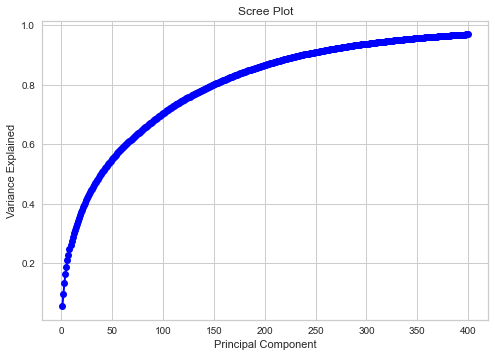

Number of PCAs that explain 95% of the varience: 331


In [91]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print( "Number of PCAs that explain 95% of the varience: {}".format(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0].item(0)))

In [21]:
# Principle components that explain 95% varience
pca = PCA(n_components=331)

#fit PCA model to data
start_time = timeit.default_timer()
pcaDigitsDf = pd.DataFrame(pca.fit_transform(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy()))
stop_time = timeit.default_timer()

print("PCA fit time: {time}".format(time=round(stop_time - start_time, 2)))


X, X_test, y, y_test = train_test_split(pcaDigitsDf, 
                                        digitsDf['label'], 
                                        test_size=0.2, 
                                        random_state=42)

NameError: name 'PCA' is not defined

## Fit forest with PCA <a class="anchor" id="fit-PCA"></a>

Best parameters: {'regressor__criterion': 'entropy', 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}
Parameter tuning time: 310.22
Random forest fit time: 51.11


/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


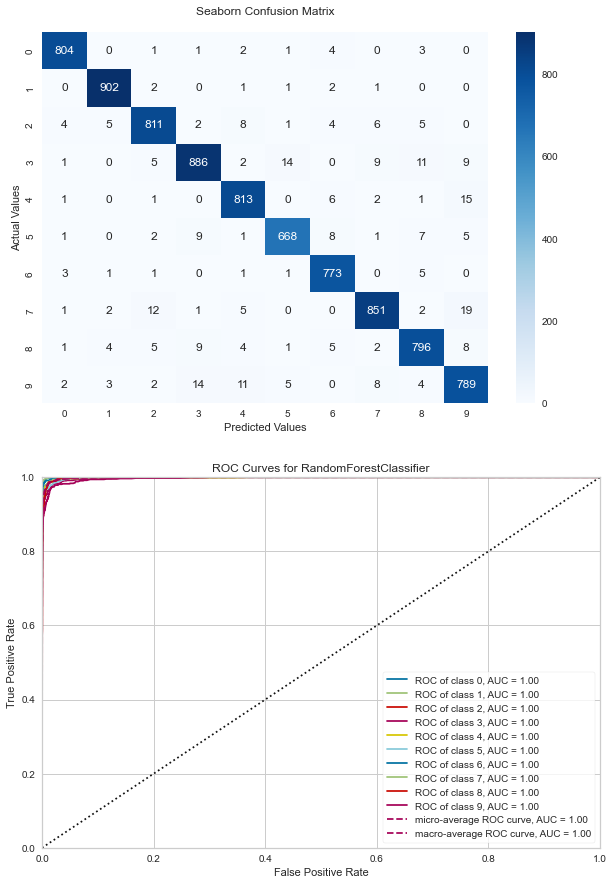

In [18]:
# Fit a random forest on all the data with timings
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ROCAUC

grid = {}
grid['regressor__max_depth'] = [15, 20, 25, 30]
grid['regressor__criterion'] = ["gini", "entropy"]
grid['regressor__n_estimators'] = [300, 400, 500]
grid['regressor__max_features'] = ["sqrt", "log2", len(X.columns)] 

regressor = RandomForestClassifier()

#define scaler
scaler = StandardScaler()

# Principle components that explain 95% varience
pipelinePCA = Pipeline([("scaler", scaler),
                        ("regressor", regressor)])

gscv = HalvingGridSearchCV(
                    pipelinePCA, 
                    grid, 
                    scoring='f1_weighted', 
                    cv=3,
                    aggressive_elimination=True,
                    error_score=0.0,
                    n_jobs=-1)

start_time = timeit.default_timer()
l_grid_result = gscv.fit(X, y)
stop_time = timeit.default_timer()
    
l_best_params = l_grid_result.best_params_ #{'regressor__criterion': 'gini', 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__n_estimators': 300} #l_grid_result.best_params_

print("Best parameters: {}".format(l_best_params))
print("Parameter tuning time: {time}".format(time=round(stop_time - start_time, 2)))

# prepare the model with target scaling
best_depth = l_best_params['regressor__max_depth']
best_n_estimators = l_best_params['regressor__n_estimators']
best_criterion = l_best_params['regressor__criterion']
best_max_features = l_best_params['regressor__max_features']
best_min_impurity_decrease = 0.0 #l_best_params['regressor__min_impurity_decrease']

regressor =  RandomForestClassifier(max_depth=best_depth,
                                            n_estimators=best_n_estimators,
                                            criterion=best_criterion,
                                            max_features=best_max_features,
                                            min_impurity_decrease=best_min_impurity_decrease)


#define scaler
scaler = StandardScaler()

pipelinePCA = Pipeline([("scaler", scaler), 
                        ("regressor", regressor)])


start_time = timeit.default_timer()
pipelinePCA.fit(X, y)
stop_time = timeit.default_timer()

y_pred = pipelinePCA.predict(X_test)
print("Random forest fit time: {time}".format(time=round(stop_time - start_time, 2)))

fig, axs = plt.subplots(2, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

visualizer = ROCAUC(pipelinePCA)

visualizer.fit(X, y)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()   

## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))

Precision score: 0.96
Recall score: 0.96
Accuracy score: 0.96
F1 score: 0.96


In [20]:
digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

predictions = pipelinePCA.predict(pd.DataFrame(pca.transform(digitsTestDf)))

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions_pca.csv", index_label="ImageId")

NameError: name 'pca' is not defined

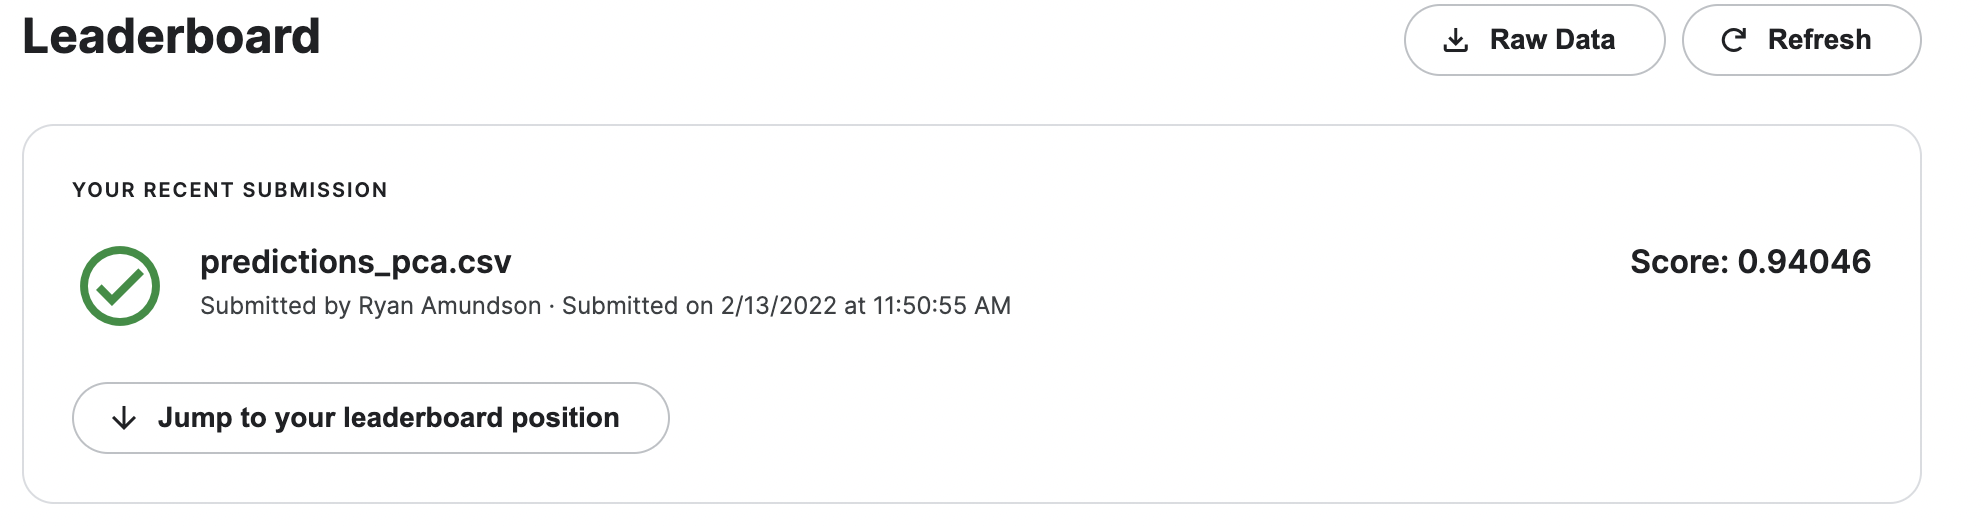

In [111]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB8AAAAIOCAYAAADHmhdpAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB8CgAwAEAAAAAQAAAg4AAAAAQVNDSUkAAABTY3JlZW5zaG90Q085fgAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTI2PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE5ODQ8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KPu4W2QAAABxpRE9UAAAAAgAAAAAAAAEHAAAAKAAAAQcAAAEHAAJKradn2EkAAEAASURBVHgB7H0HwBbFtfYAVkAsWFABpdhLREhuosauUTSJLTfRGJWiiV1jzB9jS71Rc28SC9Y0c42JiS25dgUsKDZUwApIE7uASlXK959zZp4zZ2b3/cBPpOisMqc9M2fn7MzZ/Xbe3W3VRJur2VjZyupJ0UQK6LhWqyB4rKkBVmiTa6JaqOebBMA6SPkKghTFf4k/xlEZf2X+lfxjs6nJmGCFlvxbzj/l/Ivzhp0x6RVHKmEKqZYU5fqjXH9gHJXrj3L9Ua4/bDY1GROs0HL9Ua4/yvUHzht2xui1RQ2DKaQmUpTrj3L9gXFUrj/K9Ue5/rDZ1GRMsELL9Ue5/ijXHzhv2Bmj1xY1DKaQmkhRrj/K9QfGUbn+KNcfn4brj1ZYAK9cJtgRrlkwMhV8NBGH9AkajBBBFcc1stN08R9nWBJbL1TilWAQYNASf4kAwgFaxh+FxZ/SKuOpzL8y/3CGS3KLFyrjJcFggoEGI0TQMv8oMGX+8eiojKeSf0r+KfknJM4qqcyXBIIECxqMEEFL/qXAlPzLo6Mynkr+Lfm35N+QOKukMl8SCBIsaDBCBC35lwJT8i+Pjsp4Kvm35N+Sf0PirJLKfEkgSLCgwQgRtORfCkzJvzw6KuOp5N+Sf0v+DYmzSirzJYEgwYIGI0TQkn8pMCX/8uiojKellH9bNS0kT/4YhFHKO4PDQjybQyKwegUHpmLLFJkotURXY7Cq4r/Ev4w/JMk4L8v8SyNgc0ZMLhFTsZNJdDUGqyr5p+Sfkn9K/uFMYvNCzCyeq9gyRSZKJdHVGKyq5J+Sf0r+KfmHE4bNCz7rxLJiyxSZKBVFV2OwqpJ/Sv4p+afkH04YNi/EzOO5ii1TZKJUEl2NwapK/in5p+Sfkn84Ydi84LNOLCu2TJGJUlF0NQarKvmn5J+Sf0r+4YRh80LMPJ6r2DJFJkol0dUYrKrkn5J/Sv75JPMPzzDd7NRjpZUtHyrUqFDHm6i0782An4ar+3mDVrZ88S8RqAlJib8PipZl/FVXzcv8o5j4pIqU5Gk+oaxs+ZJ/Sv6hCNQMCSi9icqSf0r+yVNNyb8l/5bzTziJWpInVCtbPtSpUZX864OiZTn/lPNPOf/YJEMpgmZHyb9pTETKE6qVLV/yb224jNJHi8qSf0v+Lfk3JAzkDZoXJf+mMTG5IxpszrU84kg0H1vhpoRHU1nyTzVG5fxf5l/JPzHNKJfnGCtbvuQfiUBNSMr9Bx8ULZfz84+8At3+ysQfQD684cwqPdHuyHHHOTdqU42AbMFAPjHXJh2y0AkJv3Io/iVYFK8SfxlCMsikkEs71qWjzdsEW78iFYYU4cr482HKyjL/Sv4p+ddmFZ4gJf9Kmij5l4ZCOf/wfOAo8GZnitemGo8ypVSkopx/TVAiW86/5fxbzr82h/DcKOdfyRBy6pGi5N+QMu1IKecfPzZ8aCwfgsWE1VyU8y8HorKV8285/5bzr82qPEWWzPn3/Rmz3Iz3Z7jZs2e72XPnug/mfeg+/GCeW7BgoVu4YL644fXI1pSbJE1Jngr+6eY53aB2Ta3JspDsYZda8d9jJDC+NZU0erkClaxBO74HYmMHbOP8x/8T6/ULRS7+S/yXxfhrTWOxzUpt3Morr+xWX3VVt/rqbV3btqu6NTq0dx3ar8FDWoZtuf9Qndfvz5jp+N9cyiuz5lBe+fBDN4/+zee8spDmNW2cFcr8pyiU/CcjYXnL/2X+8yzl4UmzVP824bnOG89e2mTqV+e/mjxAoAEceEOkSSrUR7T5b4BnTuR+L2PCPkR4Y058oEoiVOtUzMU/xVqCEI83h63Evzp4GmiSMZUI1QoVs4ReihJ/HnaVAFVjmGuSKomQI32aYq0Obwm9FCX+HJdFxK8a0Symi6hfMUvopSjxL/Ev468yQepmXKpLqiRCimOpYmZFOf9zEEr+wVAgGk+QLDS/JWMqEar1KuYy/sr8K/mHJkrJP5oKOG3oBXo1h+SaJKckQo4s579KeDToZfxpKHjYlPFXnTwNNMmYSoRqhYpZg17Gn4aCw1bGX3XwNNBgTM2lRe533p7upk2f7qbPeM81LSALxxEAZZto8ZrHGxllBZoAsqjtF73FjYk/aaUmN8O1mppa06qtr8OWhcGBVJGVcrIFe6gqTXLBbXBZ/Jf4L6/jr3Xr1m6ttTq4ddZey6273jq0QL6ajNpGhR/TIWUlQrVGxcyK5fz6f+7cD9zb70ylvPKue++99+gHNLTPZf5Lziz579OX/8v855xUzV2NNElOS4RqDWtuRZ8Axw/rAlKyoeGZpT0Jamtli5cbGBnAG5mbKMH6i5igCFclVitYOBKB2+Wt+EdYQqR9WKj0ctDmRqBIX+JvRxoC5X89ms4z2Dh4zPNWxl8Zf8kwkFHBhR8tYczYoaMIDyrzr8y/cv5DpsVEKfnXzgqfMhAblpjnrZx/yvknGQYyKrjwoyWMGTt0FOFB5fxjZxoCVfKPjYofMogNS8zzVvJPyT/JMJBRwYUfLWHM2KGjCA8q+cfONASq5B8bFT9kEBuWmOet5J+Sf5JhIKOCCz9awpixQ0cRHlTyj51pCNSSyz9vvPm2e/2Nt927tDjFG/+lx17at2tLT7O2d6u3X921XW11txo96brKqiu5Nm1Wdm3oETi7V1wPRzTyzJX5X+Z/Mgz88KDSj+QwnjGs1RoY0i+P838hreLO438fznNz6enlOXPmuFmz+Y0Js9zMWbNML1q5tdZc023YaT23wQbry9yCcUXuPx+9Rc3/N958y73+5jvu3emUVzgN0FOcrekHM+0or6yxRnt6Yp6eml99Vcorq7lV6En6NitxbqEfx9htOT3+i9N/342S/z6N+a/M/0XP/096/NMT4AspPfCFCJU+m9rUIXwDdQXXSJHUZ4E3vkKSzVulTICwc5ow8KhebC6pzwJvxb+PQ4iuxCgJVDATaaCOgEVwSX0WeCvx93Eo8ZfBIGMkGSghPEQaqCNgEVxSnwXeyvjzcSjjTwaDjJFkoITwEGmgjoBFcEl9Fngr48/HoYw/GQwyRpKBEsJDpIE6AhbBJfVZ4K2MPx+HMv5kMMgYSQZKCA+RBuoIWASX1GeBtzL+fBzK+JPBIGMkGSghPEQaqCNgEVxSnwXeyvjzcSjjTwaDjJFkoITwEGmgjoBFcEl9Fngr48/HoYw/GQwyRpKBEsJDpIE6AhbBJfVZ4K2MPx+HMv5kMMgYSQZKCA+RBmp6hfkCN3nKa27Ka2+4+fPmyYPcrWhRe711O7qO66xNT6+u6VZZZZW0fhl/PrBl/oUB5keXlA0GWgN1HKCL4JL6LPC2nMf/Q1oU56edp9K/t95+h9Zm+HX9rdxKK63sOm/UyXXpvBEt9LbxfVlEuaL1fwHllVdCXpk3f768IplfF73+eutSTol5ZRHdVvOK1n/d8cAk+58bF0NO6rPA23I+/v1O+jLZf2tYTD6pv4L0/7M8//PDmhy/3LgYclI/O/7+FejcSILKWuVX1PD704nw4+I6dzJYnRibrVvtNzUi0CgDW/yX+JfxV+ZfyT8l/5bzTzn/Vq8QGmriZUW5/qj+2tqELQbKKANbrr/K9Ve5/irXX+X6q1x/leuvcv1VvUJoqImXFeX6q1x/xXdgVQZMHCgVk19ZpcRTzj/Lzfln0iuvucmTX3Hz59O7iOnQdOjQwW3UaX1ZpLJPYMbDWuZ/mf9l/tNUqd/iRKnYF9Ace4te//3a62+692bMkOuPldqs5Lp23dht0mXjCt4qYrMrxvybNPlVN+mVKfSKc37HuXNrdljDbUhPva+//nr0xojWy03+szFujl/R4l/bl3L/Z5ne//kszf+lPf5qXoEedkEGPfP1KTtO7JpdZiO22uqhNpGGC+rFfwh9bQCb/b2CGEv8fQRqw1fGnwyuMv9K/qH5UT9FaHCIodZa8g9ll/rIkIHTC7ZaUMk/Jf/QwCj5t+RfGgb1KaLk33L+4ZNI7ego59+GkSFDOf/ywPFb7fAp1x/l+oMGRrn+KNcfNAzqU0S5/ijXH3wKSUfH1GnT3fgJk9wMekUzL2d2XGct12Xjjdza9K1i3cr5V0ORhS/oy/m3nH9bdv6dTk+Ev/Lqa+4dmoc8//hV4D26bSJvXNBBtwLOP84rL0+c5GbPnC3dWJveHtGVnnJfm574rtvCDKozlev/FfD4Vw5kWf8Lp970/Ptpnf/L6vjrK9BlB2qySqoKEpSg1b0nTXitOnEVWKIwgmHRZKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwFrV2HHj3auvvSmvJG5P39/dlJ5A5dedVzdfC3VBFZcojGBYYFNVkKAEBVipN8AMmpmDaKyGBTZVBQlKUICVegPMoJk5iMZqWGBTVZCgBAVYqTfADJqZg2ishgU2VQUJSlCAlXoDzKCZOYjGalhgU1WQoAQFWKk3wAyamYNorIYFNlUFCUpQgJV6A8ygmTmIxmpYYFNVkIi8PW2amzhxCn0rfKZAO2+0odusZ7ekTdQFRZvpgoyxGhbYVBUkKEEBVuoNMINm5iA2ubHjJtJnFF6XhSLJK5t0dut1XEfsad0gQQmqDYPxBphBYV3e+q8/MqrsaL52FgDAgWrHwHgDzKCwlv5TJHRd2UTHsIhVqgoSlKAAK/UGmEEzcxCN1bDApqogEfk0zX89GGlnJQSpKvZfjl9qRMiIegPMoAowivgEOJSgiq4yHtIYWLXkmigrBwa06lY1HtIYWLXkmigrBwZUvVUZD2kMrFpyTZSVAwNadasaD2kMrFpyTZSVAwOq3qqMhzQGVi25JsrKgQGtulWNhzQGVi25JsrKgQFVb1XGQxoDq5ZcE2XlwIBW3arGQxoDq5ZcE2XlwICqtyrjIY2BVUuuibJyYECrblXjIY2BVUuuibJyYEDVW5XxkMbAqiXXRFk5MKBVt6rxkMbAqiXXRFk5MKDqrcp4SGNg1ZJroqwcGNCqW9V4SGNg1ZJroqwcGFD1VmU8pDGwask1UVYODGjVrWo8pDGwask1UVYODKh6qzIe0hhYteSaKCsHBrTqVjUe0hhYteSaKCsHBlS9VRkPaQysWnJNlJUDA1p1qxoPaQysWnJNlJUDA6reqoyHNAZWLbkmysqBAa26VY2HNAZWLbkmysqBAVVvVcZDGgOrllwTZeXAgFbdqsZDGgOrllwTZeXAgKq3KuMhjYFVS66JsnJgQKtuVeMhjYFVS66JsnJgQNVblfGQxsCqJddEWTkwoFW3qvGQxsCqJddEWTkwoOqtynhIY2DVkmuirBwY0Kpb1XhIY2DVkmuirBwYUPVWZTykMbBqyTVRVg4MaNWtajykMbBqyTVRVg4MqHqrMh7SGFi15JooKwcGtOpWNR7SGFi15JooKwcGVL1VGQ9pDKxack2UlQMDWnWrGg9pDKxack2UlQMDqt6qjIc0BlYtuSbKyoEBrbpVjYc0BlYtuSbKyoEBVW9VxkMaA6uWXBNl5cCAVt2qxkMaA6uWXBNl5cCAqrcq4yGNgVVLromycmBAq25V4yGNgVVLromycmBA1VuV8ZDGwKol10RZOTCgVbeq8ZDGwKol10RZOTCg6s25WfRU5gtjxrkZM/1iW7dNu8rit964Nlhmq03kmigrBwY0a9OKHtIYWLXkmigrBwbUOsx4D2kMrFpyTZSVAwOa+bSihzQGVi25JsrKgQG1DjPeQxoDq5ZcE2XlwIBmPq3oIY2BVUuuibJyYECtw4z3kMbAqiXXRFk5MKCZTyt6iC8nT3rVvTxpkpjXaN/ebbl5D9eufbu4vieWvNEoKwcG1DrMeA9pDKxaco2XZ86c5V54aTwt4s+QpNG9e1e3SefOjdKK7oWvnbep5pJ/KBS6vithyWMVZeXAgMZwVjgPaQysWnJNlJUDA1rxGhUe0hhYteSaKCsHBjS6q3Ae0hhYteSaKCsHBrTiNSo8xJcr8vznHml3wYDG7lY4D2kMrFpyTZTjN8DVDYxMeeOpRDzeVQ6z15qJBgMo161uahVGJQOEjilvxX+JP42FMv50KmDSYab4eQIJ1GvzUq3CqGRg0DHlrcy/Mv9oLJT5p1OhzD+fGZApUinVelss1SqMShGgl0Rs463kn5J/aCyU/KNToeQfnxnS7AEJ1GPyUq3CqGRg0DHlreSfkn9oLJT8o1Oh5B+fGZApUinVelss1SqMShFQrn8oFiHnSlRK/i35l+ZJyb9xWvCUoC3NHpBAPSYv1SqMSgYGHVN60uydae75F8e4hQua3Br01PfmPXvQ977biQ1IEXRvUq23xVKtwqgUAUk7rC7zv8x/Gidl/utUyK+/3qcfpowZ8zL9QGWWa926ldt6y80bvJnB5IxlPP/efnuqe/4lyisLkVe6uw6UX+Ie8g7yVuZ/mf9l/jeX/1bE+e9P85KE/DTXErqlM/9bNS2kl+23glPdiwpTj4AWNK3WxE238gmMOOTtZD43DkTWFonhus8Y4BfUmIgt/kv8y/gr848TTsk/Jf/q+YNOF/h7qpx/+MRaf/60Z9N6BLSgtkY5/5brj3L9Ua4/yvVHuf4o11/l+rNcf5brz3B9SJeL5fo73M+SS+f662d7NV2PgBbU1ijX3+X6++Ndf7/62htuDL32nLdOndZ3W23eMx1g/o9n0pXxV3t3utz/Lvf/l+L6x4tjX3ZvvP6mzNHNNuvuNuq0wXIZ/ymvUl55eQLtW5PbcP313ZZb9KB91qujLMd4sUGGCfUaWMv8Wy6PP58uyvXfkr/+W1Hm//J0/OUJ8CR9qKBMbUKySiAp39CE4wtvTxUDgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcSsgjIpuEYCEn5BFQqAKlImMaugTAqukYCEX1CFAqCKlEnMKiiTgmskIOEXVKEAqCJlErMKyqTgGglI+AVVKACqSJnErIIyKbhGAhJ+QRUKgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcSsgjIpuEYCEn5BFQqAKlImMaugTAqukYCEX1CFAqCKlEnMKiiTgmskIOEXVKEAqCJlErMKyqTgGglI+AVVKACqSJnErIIyKbhGAhJ+QRUKgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcSsgjIpuEYCEn5BFQqAKlImMaugTAqukYCEX1CFAqCKlEnMKiiTgmskIOEXVKEAqCJlErMKyqTgGglI+AVVKACqSJnErIIyKbhGAhJ+QRUKgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcQchFemvOrGjZ8kwG6bdHGb0r9GG+rDL6jiAVBFyiRmFZRJwTUSkPALqlAAVJEyiVkFZVJwjQQk/IIqFABVpExiVkGZFFwjAQm/oAoFQBUpk5hVUCYF10hAwi+oQgFQRcokZhWUScE1EpDwC6pQAFSRMolZBWVScI0EJPyCKhQAVaRMYlZBmRRcIwHJfidOnuwm0LfB6UFw16P7pq5L540a/T5FW0J9UaigjOIaMUCi36CKB4AUyCu83L0J5RTOLcZs9jXRalN1DJDwC6pYAFSRMolZBWVScI0EJPyCKhQAVaRMYlZBmRRcIwEJv6AKBUAVKZOYVVAmBddIQMIvqEIBUEXKJGYVlEnBNRKQ8AuqUABUkTKJWQVlUnCNBCT8gioUAFWkTGJWQZkUXCMByX6X9/lfs/vLdP5XXoHug4mQ+t1NdJWjW9clq4ttCUeF/vrDwgKf+KrTFf/ZrwtqgpioSvzDb238RCvjr8w/uvriC7C6reQfjk3MGRyjJCYl/5b8K79qrps9dbo4loSjopz/S/4p+bdurmS5NkBK/jXnpHL+Keefcv6pTx612nL+xdm2XH9QJMr1V7n+LH//lr//a88V/vrztddepye/JxCilevZcxPXeaON4j2Bcv1Vrr/K9VeD2VOnXvrXX6+8+pob9/JEuezZvEc3t/FGG8qOLevrnyn0RomxY8fT+bfJbUb71WVjWpzPNh+tGDM2J7qSf0r+KfknmzWpuLzO/2Wdf+r8ZwvgJvEoq4xE2UrIRaKzhvR4kNSs0aANTllliv8skiX+/lwgIyQdJmZMMdus0WANTlllBGelEv8Sfz4Xy5iwA8OMKM82azRog1NWmTL+KAI2GmX+lflX5l/JP5ITbGIwGdWzzRoN2uCUVUZwVir5p+Sfkn9K/pGcYBODySgl/3AEmg2OiZbBKauM4KxU8m/JvyX/lvwrOcEmBpNRPNus0aANTlllPhP5h7/5/ezzL8mg6tmTniDdmBfP4s9VbTRK/i35t+Tf5TP/vjIFi+Ct3LZbb0bfBF/X5LlGrJndyirzsfKf5JUXXpIf4PXoTovfnf2ifLonxpeyynws/zaHpT6tZHwpq0zxTxGw0Sj5f/nN/8vb/F9e51+2AJ4NcBrw8dLHJgrm/VSwEyJHsPzWW2+5u+68yy0knp8s5C+BcR3+15qKXXb9sutOCRGbbc/ysEfqrc1jGqOlXk1lq7J8bAmctzaPAbYaLalXU9mqLB9bAuetzWOATf1PotekDB16v8Sfn8bTjRpjuXefHd1222wbjrBaM6bl/rkhqV2z81Zl+cw5WljEPsZa3NZ9997rXqdftzLP/3j82f4ffvi33MqrrKJjnjE2PCSazVubx0R4jha5prJVWT62BM5bm8cAG+JtoiX1aipbleVjS+C8tXkMsEvfP4/x+2mMs2fOOXn+6dV7R7c9jfH8ANv+WD72BNzy3X/sJWi+tyLXdNCqLI92IvXW5jGN0VKvprJVWT62BM5bm8cAu/THX/TsuXxvRa7ZeauyfN5etUdVhNX4tmKLwkVRoVZleQUo463NYxQcMk9ECxdFBVqV5RWgjLc2j1Fw8U+hsG92kLjVBM+qLB8jCc5bm8cAWx2tUq+mslVZPrYEzlubxwBb/OfRErkmeFZl+RhJcN7aPAbYEv88WiLXBM+qLB8jCc5bm8cAW+KfR0vkmuBZleVjJMF5a/MYYEv882iJXBM8q7J8jCQ4b20eA2yJfx4tkWuCZ1WWj5EE563NY4At8c+jJXJN8KzK8jGS4Ly1eQywJf55tESuCZ5VWT5GEpy3No8BdsWI/8yZs9yTz4ymT1gudJt29a89L/e/4jFMuU/f8ef+2fFs+bTvEdk8JtbKoyVyTWWrsnxsCZy3No8BFv2KaOGiqECrsrwClPHW5jEKXib3HyZMesVNnDTZtWndxvXaYTu3Rvu2tEN+Rst+1+y8VVk+9gSctzaP8dhZM2e7J54Z5ZoWLqBXnneVzylIvZrKVmV5eI3UW5vHNEZLvZrKVmX52BI4b20eA+xnc/zF3pf+56NF5JrBY1WWt7H0vLc2h1le5j/vb763ItfsvFVZviX9t3V8W7FF4ajQBfBostWYb6L/sGwdLocUrExWKepHjhzlDjr4ULJzXdZTa/SzsSb++Yhr7Q44YH932aUXi6X+Yuvj+Scn2YZ9A/XmVLJVPn3+hwwZ6gYMPI462Zr++Z6jlyyfe86PXf/+/UIQYDERUlYZGzBtM1Nqe3EsxCPeqCXen48z/uw+DBhwrBsydGgy/mz/Rz3zlOvQYQ1bhfgl5983jJ6CptrMefHfwvgPpjE+cOD3JH4+pmn+Ofvss9yA/v013OnRULXUX1Ljz7cKT6Cp1nqGpfhv+fmnLp7LKv/geBb/mItLN/+X+HMEkHdA06h4yZbl/Ffyb8m/9scjOoUiYycM8encSo2wgXprKtkaZf6V+VfmX5l/JkMoq4xNGMQ30jMMNlBfNZW8DpYy/8r8K/PPzBBllbEThvhGeobBBuqrppLXwbK05t+Ip0a7GTNnuI06re+22Lxn2Ily/bG04h//Gl42x7/4t3EHv2KP/xfHjHOvv/EWLX6v4frsuB11CpkG1PczldB3ph+//08+NYryyiy3Yaf13Jab96A2y/2feBx8rD/J+HsPKOEJtPjnCKTRQKy8ZUXO/8vD/LfRjJFOI55KtsbHzz+2tdw/LYAvJN/m1Kd7okxa30gpAjsaAMHIC+AHH3wILXiTj9Z0GU2PYvJrUxw/k0lM3/33c4MuuzS2qo0qE20ZlyLq/fsqhGT/9D9e2xCbSluJMyHTxwrKpYgVxz8vgA889lh/IOSHCHJAqF8+Tuec+2NaHDyGZOi1ywmzovV/wLHHucGD70/GnwyI0M+Rz4xwHdboELqd9i7peBBSxIpz/P38Q4/SXnxaxv/g+4a4gcd9VzrJf7zn+eecc3gBvB/ZP539T7tFfSz5T+Z1yf8UhiStl/EfEr5PiBoOZZAoKzRFlPzv/1AIYUqCQ0LJPyX/UN4p+bfk33L+saeSJFGay9FMb6vUpVi+xqW/Y/TUnlQv+becf2hklPxbzj+UCkr+tck0SZSf2fw79uUJbgp9O3iNdh1cn952oczGKuXTyJXzTzn/luuP5fH6a8RTI937M2a5zp03cj27b7pU8//YcRPcq6+95tq3owX43tuX8285/y7V8efPWBT0z/D9p2U5/5f3+OsT4ObKT/Y5Xs5ELr38ISm9AlKzVY8aOdp9jRbA+Vljfg1x6/CHOn5V0bfv/rQAfkmlseg1cuoAjHUEXaWluJsebktTKetM9Bo5ixZ+BfXPT8cOoKdj/a960avYmXPOOZueAD863E759PS/Pz0Bfj89Ac5jD+MPvedRMlKeAKcFcNpiryMXsYGLIUtMuRqyp7a01YDyuug1chYtfFpFzbkasqe21CrEAOV10WvkLFr4tIqaczVkT22pVYgByuui18hZtPBpFTWzeshgWgA/lhfAZfm7kn/OpjE+sP8xWmdJ+9cLYfKA3fTUlsa9orwu9jpyFi08Gs4MuRqy9QxdrJpqotfIRWzg0ipqztWQPbWlViEGKK+LXiNn0cKnVdScqyF7akutQgxQXhe9Rs6ihU+rqDlXQ/bUllqFGKC8LnqNnEULn1ZRc66G7KkttQoxQHld9Bo5ixY+raLmXA3ZU1tqFWKA8rroNXIWLXxaRc25GrKnttQqxADlddFr5Cxa+LSKmnM1ZE9tqVWIAcrrotfIWbTwaRU152rIntpSqxADlNdFr5GzaOHTKmrO1ZA9taVWIQYor4teI2fRwqdV1JyrIXtqS61CDFBeF71GzqKFT6uoOVdD9tSWWoUYoLwueo2cRQufVlFzrobsqS21CjFAeV30GjmLFj6touZcDdlTW2oVYoDyuug1chYtfFpFzbkasqe21CrEAOV10WvkLFr4tIqaczVkT22pVYgByuui18hZtPBpFTXnasie2lKrEAOU10WvkbNo4dMqas7VkD21pVYhBiivi14jZ9HCp1XUnKshe2pLrUIMUF4XvUbOooVPq6g5V0P21JZahRigvC56jZxFC59WUXOuhuypLbUKMUB5XfQaOYsWPq2i5lwN2VNbahVigPK66DVyFi18WkXNuRqyp7bUKsQA5XXRa+QsWvi0ippzNWRPbalViAHK66LXyFm08GkVNedqyJ7aUqsQA5TXRa+Rs2jh0ypqztWQPbWlViEGKK+LXiNn0cKnVdScqyF7akutQgxQXhe9Rs6ihU+rqDlXQ/bUllqFGKC8LnqNnEULn1ZRc66G7KkttQoxQHld9Bo5ixY+raLmXA3ZU1tqFWKA8rroNXIWLXxaRc25GrKnttQqxADlddFr5Cxa+LSKmnM1ZE9tqVWIAcrrotfIWbTwaRU152rIntrSV5k6bbob9ezzJLRyvXttTw+BtKe98XfIeL/AqQMwaBhyoLkasvUMXayaaqLXyEVsA0cN1Gi5+Pd3w2JpI4ooeV2MeuQsWvi0ippzNWRPbalViAHK66LXyFm08GkVNedqyJ7aUqsQA5TXRa+Rs2jh0ypqztWQPbWlViEGKK+LXiNn0cKnVdScq9+bMdM9/fRIWn9p5XbYdku3zjrrZN64aloreo2cOgCTVoFWW+K8MvrZF2Td5/OUV9pTXvFrDii1CjFpY9Fr5Cxa+LSKmnM1ZE9tqVWIAcrrotfIWbTwaRU152rIntpSqxADlNdFr5GzaOHTKmrO1ZA9taVWIQYor4teI2fRwqdV1JyrIXtqS61CDFBeF71GzqKFT6uoOVdD9tSWWoUYoLwueo2cRQufVlFzrobsqS21CjFAeV30GjmLFj6touZcvazmP3YI++OpLYFgCpTXxV5HzqKFT6uoOVdD9tSWdCakV5HL28j5V6GJK9SiZm0V4Y1NrCJLA3xuNRsvKo52Bx16GMEYVN14AfyySy+RX4V8Ev7xy4+q56jBUymfFf+DdXHQx8D3n09KfIps5c6lJ8D7H9NPj6U/3Kb0bAggCSLXH//lKf7+Fej3xwOPHtD+82v5n3nmCbdmhzW91vTRs6Y0tkWN/+Wp/5WOJ/3nnpg/dUwfTc/9oTa25bX/fozTa/75l1/05ok8/5xDr/kf0J/GOG2ftfkfDruS0n+e/zySPz3j3x9cmqjhl496sGuYcvzL8S/jv8z/kv9K/tdneMw13op4/VfOfxyBcv4v1z90YUv/N7eV679y/Veu/z6713+PPfmMmz17juu2aWf59rfkinL+17xZrn84FCYKZmz4awwaMT6BaMz8+YaA5f5DFpPqmXhpnH8nTZ7iJkyc7Nq2a+u+0HuHZCc+Kf+Pj3jazZo5x3Xv1tVt0rVz4tMKn5T/cv1b5l/JP/76f1nM/xVh/pknwG1KIj45ybHNKsKtMqvS6uY2GtlHjqJvgB90CJ0E6BnwVqSQN597DFeJT4BrA56ptG0Vi+/f//Fn6gpr5MytihWIVazY/ocMGewGHMvfRzYbzxPqIveSnwAf0O+Y7MS94vdfFsCH3E/XanH8aQSo/6OeHuHW6OCfAE+Gu4BW/P7Hbti+aARSpgKxiuV//A+lH3kMGEhPgNNx9Svcaf7hJ8CxAJ52PEi2u6KyiuW//9ztOIbNvgtr5NDdCqlArKL0X5ZKbEg0gCE2LKtdmaAzstbLmArEKkr8S/xpqcoOCR0+ZfzpMqbGR5ky/yQUJh46bjKmArGKkn9K/in5p+RfyhlyoWlzRzn/lPNP+BmNnjKUKedfCYWJh506lq9ArKKcf8v5d8mcfye9MsWNnzCZvhHcnr4RvH0cgXa4idYqyvgr42/JjL844DLODrcy/igCNiAtm3/yLW56GrxH966ua5fGC9KVcFcUi/b/yiuvupfHT3Jr0FPf/tvj4UJRumH7Io1XiwrEKhbtv9z/pJBqyJQp118SChOP6sjzmgrEKlbM8bc05/+KMv/MArg/wOlhDn/fWqUMD6MQ1stc8hb/JqYnwOkV6AcffKi8BoP1sSZJdAeh7/596RXoF6sl2g3WKtmBacWzHsAlb9Y/JDQB6pG2jG2gvmKVAd4ohPUyl7yhvt1P1AD1SFvGNlBfscoAbxTCeplL3lC/kX//emhaAOc7OPwLPQqiPP/NP1Kgn2OdR0/H9u/fL0bZNy9t+8IohPUyl7wtyn+0e7wvYxuwew1ZlQHeKIT1Mpe8ob6tyLaB9Ar0wUPvD3ZCZf1/ZuTTdMJeQ+v7VqmiMtw6b0YhrJe55K2Rf9abmoKNRWwD9RWrDNBGIayXueQN9a031AD1SFvGNlBfscoAbxTCeplL3lB/WfofPGSIO3bgcRRvfzOGP7/A+4U9lx959D+GNNhiH7D/wGolQK1CQLEuQ1A/eouctqltgYltoL5ilUmxIokt1mUd6kevkas0hSZDn6xdeWUANgphvcwlb8W/j0OMeuRM5AAKNMYQ8VOsMqhiFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpFixc4B4ZPsItWDDfbbfNFq5jx472zkbkbSXxYBTCeplL3hbXv0ejjG2gvteQXZkUK5LYYl3Wob6tiCZA0VKksQ3UV6wyQBuFsF7mkjfUL/5jnMCB+kjZ0lusXXllgDcKYb3MJW8l/j4O+fibOnWaG/Xci27lNm3cTl/8vGvThu736xZjiPh5DQGUAdgohPUyl7wtXEB55dEnJa9ss81Wbr2O8ZXrpqYHaxnb+Lj+Ud/uOPyCqltlin+eOTY+yiuDYBmFsF7mkrcSfx+H5W38La35vyIdf/8KdAxaM67lEOLdFCSoSRkc5EBzfZBHjqQnwGkB3L+KIFuGIswBB+7vLuVXoHMzlTZIwa9WsaYcI1YLCIocJzKUgabkM+N/8ODB9H1kWgCn/vOa90KmfATkePMT4OH10Evg+OPw+GMbAo4DvZTjP2DgQDdk6ANxsGT9H/n0k67DmuEJcN7xT1n/4yODaeBxVHBY4jHjAK2Y82/wffQN8OP4LQfcOybUj1Yx//i3HPTjgR+7rYHwVcrxX3GPfzyoOJZE9ZGtcKBTYgYC6pT+r6jzvxx/Hu9hHDORsR4GPIJTxn/J/+X8h9lQ8j/SA9JGuf6l/OCTqIZGGQQp0FxfK0MZaErK+EN4ENoy/sr4K/NPZoNODWUwSUr+SQPUXDwQvEBT8pnLvxMnvuImvvKKW2vttejbwFt/5vqPCz+MCsg6s8r5p5x/PmXnn5H0Te5p9G3ubpt09Z87+AT+/ps46RV63forbp2Oa7vPbbuVn04yyTDT0sQLbZl/FKrkng1F5lM2/nwHy/GXOKRhWCrn36Ux/2XC66QOZ1ORoUw7Du2ymP/xCXBzsg+7nPRDd9Iabd8SdATJAvghh/q1pEoj9AR4X34C/BI6+GQMkz3WjmOiUtWAoi1yxiysWDLzzJkz6FdQK7vVV19tqfifPXOWa02/ulp99dXD7pkdWoL9nz9/gfvwg7n0vY92Ggbbf34CfMCx9HpoO+KCf14jOpu+AT6gf78YtxSpbYKJvYjcrJkzqa9ttK/WP+rV+Y82z6FF0NzOcrQ10a9aF7rpdIJfbdVVXTt6rRN/2xuYgf2PdUPuv19kX8SaPP5GjnzKdcAr0AOKEezh/fdnkI2fDrdnKA+KrUTOW2IplorZKMzxnzFjhltttdXdyiuvpH0zyNho4KItcjlILBWzV8yfP5++1TJTXv/eurX9VWCMbaWqcRBtkTNmYcVSMTe5GTNmufnz57l2bdu6VeiY5RuqgMLO+/zhBx/KN22iLXJxjFMNOmQS3mgOP/I4xhu5URN/FrGhCij0lkZb5KydebFUzEZR/C/1/B9HNx8gOhZL+fxT/JfxL8lJEkQZf2X+Nb62MDOFR0uyRVvkEgAJYqmYjaLkv5L/y/kvnzZL5fpbnJb5V+ZfmX9l/mURwBkaNDP71EFlvMtRvYZgkNSvNGIUJf985vLPsOGPu3nz5rsdttvarb3Wmp+5/pe/v8v8R+b8rNz/mfbuu27U6OfdSiuv7Hb5Uh89cyzJ/g8b/oSbP2+e+xznFfpxTTn/lPNvuf6gTGPSrUwK/euSpKV0/bU05r/vW1our8c/LoDb/c0PVC4rtmrINfoEuNYhhkBNrZtc66bWbv+++/kF8MyerDPmjSq2aqhqPHjatGnupptvcY899ribPGmyG/PyWPHPb/PnrVv3bm6nL33R7bzTzm733XZ1q7fFIjUZGzVaYwD0ueeedw8/8oh74P4H3UtjxripU6eKHy7atW3num/W3XXruqnbfIvN3GGHHuo22GB9tVeaRaMREThvmE8XsXfddZe79dZ/U7/GuVcmvyL2Tht2cr133NF97nPbu3333cdt0rWr6Pnp2AHfPS7pv8SbmyPmnLPPcgMG9BOsFIvwz7G9WWL7hJs4eZIbN3acr8t/i1Hdbt0otjtxbHdyu++xm1t91dXpgVy8nDq6US74e/XVV91Pf/YLN+/DeXJvXN7WLg/xMqC1O/+8s92mm24qC6F//8c/3F+vu969NHasdEXaIv/PPztKF+HlG+D0CnTeJ4w/HH+uNJK+AS4L4GR/8qkn3cPDHnXPjHzGPfH4k2727FnyEPFmPXq6bbfbxh1x+OGuT58dyQ13Mm5h16OijmP/of+TJk2ScTn62WfdpImT3YQJE8lIAFqH7rhOR9dt001dly5d3AE0T3aj2K3UZiXTYtVbVWPgxM6gH308PGy4e+iRh9yjDz/u3nzrTTdr1izfDarclcZI927dXOcuG7s99tjD7bbrl12b1m3yboZGU2+/v+YPbtjw4TEiHBqG0Nar1w7ulJNPEv7FF150l15xuXtw6ENu5qyZouNKZ/7gDHfC8f7NBLERMlMbvEh+5913u1tv/pcbN36cmzz5VTIsdJ023JC+MdObxvh2Msa70P6z28H0I4+Bx9GPPIJ/7ySUpDv7vLPcwH79E7UKXIcbwZbL0EvjFujdpRoFR4baw/GPSsPl/nJZoVVDVaPgyBCo+F90/tGANQxq1VDVaCuRKfEv428xzn86YBoOqqqhqtFWIlPGXxl/ZfzRKb7BmTqfRLmsM6lqqGoUHBkClfNvOf+W8VfmX0wKhsuTSC4rtGqoahQcGQKV/FPyT8k/n9388zrd93nppfH00EN713uH7WJuYC5PIrms6KqhqlFwZAhU8k/JPyX/LJv8M+Lp0e69Ge+7bbbYnNYd1ovzElw+iXMZuEqicO71N99yL740Th4Wq+QV1Cvzv+S/cv9hmd1/+CTnf8NUgbnPdDma/+kCuOyYWftp8KsE7YvprWeNInR01KhR7usH0SvQacDz/aYmWsVsJa8jpqVHkg/YnxfAL/VNEkRMcLAE/E+YMMENuvxKWmS8qdY/BUC8taIVxybi2f+6HTu6k086wR3xrW+6lWueSsXu2fzve97kRo8a7S76n9+4YQ89LAeaf9QtLhr0H/6/cdhh7uijjnJb06uIqIrfFqP/t/7rX+4Xv7zAvTP1HYorXVSRQ+6D7BuH3Pi//IrL3H5f2c8NuW8oLQ7S95HJBv+2/+fWvAIdu2Tp+JcnuMuvpNjedAu5I9+L8M8dW2eddd0pJ57gDj/iW27lVVaJfeWGs+N/+//d5k469fveAMehb0z+/a9b3Xrrr+f+85uHu0mTJ9f6f/65kbQA3pY76gYMpG+AD3mAWOl4pf/P0CvQ27Zv537324tpzFwh7TXxO+IlmGEHjP9tttnG/epXv3TbbruNINIvaIRqAc/+eZPLXmIfeXQ4xe4q9/BDw0Rv489VeON4Wv/8jaajjjqSvm09wC/qc5MB7Fmj4AYgEp0zd7b7y/9e5y659HI3e+ZsiUej42/9d9lkE/e97x7rvv71r7u29kchtv3gavfd96AfX0ypHX/77LuXu/qqK9zVtEj+q/+6qNY/L36fceb30SXaf9pxGsC33spj/Ff+RyQhnkLQP6qB8XfFFYPcfvt9xS+AD/xuMv65YeSfc849S75zj75ydzheEhMRWPb+IVao+peqshd6QBgMu1AuWMX5jxjeF09Y7TdSFP8mgiX+Mv4xPCrUDCDPGgWDIQrlooy/Mv9K/in5lxJBOf9oepTE6JNjOf/SuNBronL+Ledf/gOy0YbrC7J71ii4DkShXJTrj3L9Ua4/yvUHJYJy/aHpURKjT45L7frj6dHPuenvvee22qyH27DTBn4XKEWvKPcf+DvDCxbQ0zA0jlZaaWWhH+X+Wxl/8fS8LMZfif+yi/8br9MiNT2ktubaa7od6WEu3ZbA/H961PPuXcorW2zW023ED/Xx5eMKdv3H933lzbHN/f1DNn57BvevNT0gxm/2LflHDrQOJz3BrWDHn4esbM0dfwaY7nrWKKx9Oev/Jzn//YSX6MX4LGf9T66/adGX146S/bbHznfFAAwbutksGUXfAP/6wYeGPIhsGPIitdX3gP3dIPoGuABMS6kbIxnWwGvZIfS0Lz/1y5v3XPXvDaSnJ9IlDqEldvP53r3doEGXuvXXXze0QKQZ/1ddebW74KJfhxaYZP5yGW3xVWfw/7Of/cR958hvZ24AjP4XNi10v6WF2ssuu1z9RW9QRY3nWrnTTzvFbbPN1u5YegU6z++6/vM3wPv37ycm3xKAJAWWXyU+gF4pbrfoDdqogX8EmWN7Gf3wYX3+BZppHjVZdfttt7uTTzmNLsrphEQxkotzfMaZ7H+7/jp33vk/cWPDE+fRG1ppRU+AP0NP89MCOG0DBhxH3wAfKrxg4TfE/4nHhrvTv/8DN2zYw8kuNfIvDVHx+2uucnvttSfEZulCekX7oEFX0LH7XcP4cwPYNeGz/m+51Zbuqisvp6e1uzTrC8Yp9CT90Uf1c+P56XJpORx2ODHjD3VgYpn7333T7u7Gm/7h1lmTXmnDwavZdt99T/ohgn/7gDfHI7LvPnu7ffbZ1535wx+KqS7+Jx5/vPvBD/gHD34vmyhWv/3dxe7SQYNqj78ATQFvp592qtuWxvgA/s697a+Zf/wjj/79+sUpypXNZvvv2wiA1GBqtIBFW6CmiVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGvhHYufMnesee/wpqtPKfXnn/6A3/NFDHivY/Y+jjunnHnrQPzxy043/cDvu2OsjxUDAiCWoaSFVGcmwBi7sW/T065MjRgjP4ZQfO1GJKiyzdlV6qIo/u7n+ehu4rpt0causvMoKF3/pZE3xwQcfyMMnjfrPv6drS/dj16RPTa699tquC93DbM0PGXEFsyFmXmUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMa+Edi+Ycjwx55zC1c2OS++B870htZ6ROwSyD+cymvDKe8wovHu+70H7Io3OyOoS+gBpyqjGRYA28ZG9p6/rkX3d333S0PLb722mvu7bffkTWDjejtoj16dHcHHLCf23OPPZOHzh599DF6iO9I8cu5h3PQR97QF1DTgFW9QW/reOpJytd8jLD+wTyDzMaffV2V8soG629Ab/vtIg8YGnOVhRNQg0hVRjLse/RDhxEjnnIj6SHXl18e77p26ew27dbNbUXrE9ttu61prQGLtkANLFUZybAG3jKW2pozd44bSg9FYv2NP9u731f21ZztGzZODdsyp6YW2gKtMX0S/j+p+W92f/FY9BvU1EpVRjKsgbeMpbboIVNZBs0aqPFSo5JKojdGZT3Dr0CPC+Axz8piJkH69qUFcP4GeLJpI1H2aC99AABAAElEQVRboxKj6I0xsNdcfY37rwvoSVPaYAUVHSUQ+SWAsbPe5xVcutBrqOmp29tv+zcllfBrJgbZTRptchde9N/uSloAZ2eynkiMv+D56P6voCe1v/KVr1gvsZGg/eUv/8v9/g9/EmetWi1UX4vjfwAtbv/+T39q2P+zz6FXoPfv39D/NVf/nmJ7AdkpWtTZj+qfG+YYrUuv+JbY2te/i1d/pG4LC+Cs4mPVxFdPoacc3QMOOIDq39ms/+eepSfA6YKLa/anH0MM5Veg04bxJzwVbB84oL/7wx/+SC3H48923ur82/5fc83VfhHc7zrVUEa5uXRxeAot6N977321/sWP1Fy0/7bt2ro//fEP7vN96DsuMpC5B1LZdyZ45VesH3LYN900egV/3KP6/nN1H+F6/zvQif6v113rLwQYzJs06lvejRbAJ096RfpG71Og//w+sfXLu+zsnnr6GTebX7fO1ciUz78TT8ACuG/vl/TU9+/pePC2qPjDF+8Pt31s/2Pc7//4Z6nrWwu7Khr/nfuBvABeu6GGMdaoxCp6Y1RWGR8iAkdNyhsvgbXIxiqxCNTglVVG/UZN8W9jUeKfR6AmOjWqMv4oAhIXExxllSnzj8JEKVnjwOMmRoelfKux1qikluiNUVll1FfUFP82Fnn0a6PTqILojVFZZUr8KcBl/KejKo6O6uhLkcHeqILojVFZZcr4K+OvzD8aA3FGpHx1BlpkmX8SgZqQRL0xKquMxj1qSvxtLMr4yyNQE50aVUvH3ytTXnNj6WGIDdZd122z1ea5c5JrnNWoWuqf6zVqTtqss2YVjjr6GPeQvGWzlbv5pr+7XvSpR9kUp4y2FjUf3793RqU06lu+88673AknnFx7/6ty/UcK3P/69rePkAeT+F6z3+yeNlaJxfiPMnOxDXCgqVVqZYVFBlONSiyij8YpU6a4XXbdg9+nSv9xr+OeRBTpQv+5z/xGy6O+c6T57KhFShOxkSAqyfzHbsc2wA29/wF3OT189M9//j3CtCHLoIbR1ajEKnpjVFYZ9RU1jbvjPVpk2Ica1cfx/+yLY9zbb73jenanT2x23ig4AalxVqPK/XNeGUdvhV2f1kq22aonmZs5/mqFT0trnNWopIbojVFZZRrGn++Jn3vu+e6Ou+4Oe4q/06r3v9vTZ2tPPuVkejDwaHrjxEru0UcfpQXw78hA7t37c+7GG//pO6BulWno30fH9ht8rMsazisnSl7hGn5W8eySvaWJ1Gj95dvf/rY7jR54XIfmmK+JI/Lxx9/EiROl/2+8/mbF/5577+n+cM2Vfv9kjxHXJeefmvWbhMHES1llECmlXBFW7sfue+6THP/x48cQIjs6qOC9xlL0xqisMuoraqL/2JDlLDLoa1RiEb0xKqtMrf9PYv7H/WGuef/RKrWyosZao5JKojdGZZXRPYmauHe0AL6QlsB5Evl9sCDsFXSgrAcPCmxOR44c6Q46+DCv9qtYAeJr9qVvG1926aVL1P9D9Frp7xzdj07C/FIK/GSG3Nb4555w/1tT/3mPeJGVXz3Nmw9JK/e5Xp9zN/z9r25l+qUepgX6zfSRh4e7I79zlNRBwfqP4//GG2+Q73dze9YX++dfGR72jW/Jvngba5mL28fxfy5/A7x/P23M+h9GsT2KYmt1FDHCtsx/L4rt366/nn4VSb+CDK1wa7z5J8BP90eQjh0fFtgW1/+zzz5NvzhsJ+0NGDjQDeFf+8gWW1jU8ZcRtAj/HTuu4wbTr8jWXHPN0D4I/Dh34a8vcldecU0wQL/o8dfIf/t27dz99w+WV/bDm6UL6Zd+3zriCPfEE/5XqS0d/9Y/P8nNT5/zhMVRxzGRBfDwBDj37qOO/xNoAfwMegKc2+Mx/p80xvmIW//wFaPHCOxJ7P2i/PNbDvwY9/H/pPJfnL28b9jruJ+s+yTzb+qz+I8ZBMegxL+MP8ogIbHUzxA/aqwNPChGU5VahOWBLOOvjL8y/sr88/mgPkOU/IMrvPrrP+TSOmojanlgS/4t+bfk35J/S/7lCNRnyHL++TSdf0aNft5NnT7dbUXfAO60wbor5P0Hvr/L9yJ5vN5Mi0877riDn8CV0o5oywO45M7/sgB+4snSMHv6KPe/NqUnwW+55Sa3Fj0VjWucuIcrzvx7ld42ucuXd5fj8lH6vzU9Nfr731/lNtxooyXe/4kTJ7mf//yXbsj9QynBtXITxo9FaIkuueNvGjWsHXOWB2TZ+H+D3lbwAn2rex16Dfr29AnPJXH+H0l5Zdr0dymvbEZ5Bd8Wt322/LLt///R51XP/8nP3PTp0xa5/mPvP2+x2Wbuqqsud6+/8aY7gp4A5x71ph/f3ETrNfWb7bPlgV708b/jzrvdiSed1KL1jy5dN3a33nKzvG2h0dm9Jdf/+3xlfzeO3rzre4Szo+/Taaee4k491efB1GfL+o9aoOwFPCiiWaUWYXmPnDhxgtt9j32T9b+JL/MCeNxQC5Qt4EEjOucswvLALfr4oxYo1wQPitaq1CIi/0nM/6pv1kSfKQ/0suk/vJsnwMOOCqnZaVUpgzaapfwE+EGH0DfAF9Ik4UVEQssJnhg6F7kDD+hLC+AXkzZYhCgq07Mra2M53aZPf8/ts+++9L3gaelVQwP/vPDNTeqeWf/YUdrjH55xhjv+BLxSWQzieAF9i+bLX97dvf76G6FjbJOUWfHfdZPO7oMP57k33yAs+yRoI/+77rqru/bPf/Q7xxGT/XLugw/m0lPzX3MTaOLi2X32KDwzEt16/3Xxr/PP30eOT4AHx0QktvR6iGkhtkvK/5k/oNge/12/7+LO+7ztdn4F+qmip4fcKQTUQWJkwZNDwjCxNu7/c6NHyit3GMevwx9MT4BLmKhuc/GXOALIHhfD/7cO/yZ93/oX7KqyPfboE7IY7XtG5iXkfx9akL46LEjnTm+86WZ35pn/LwwJjp2O8sR/O/qBAH9LfQK/Il12MOxlg/7fctONbode1T84/AL4FNqNlo2/E084wf3gjO/THJnr9g9jPOzQYsXfH1je6UX7P+dsegX6gH6+igQu9Nn2v6JnRcCJ7aMXWpsYHn8SYmkmWIQoKvpTlTIf3XlsTbpR/Jf4l/GHaRTmlRA7x6yesdaGuotPtTYxZf6V+VfmH+aOnWc6S+J8U5UyqPiRqNYmpsy/Mv/K/MP0CTNDiM6SMv9wvteQKIPAfSSqtYkp+afkn5J/MH3CzBCis6Tkn08g/zw47FHHD0fs9KU+btVV/IMn+nfNChL/o+kV6A+24BXoOrKIWdL51y+An0JjdtH3n/iwsn97//Wwww51v77wQkqKupcr3Ph/9dXXaAF8V9pv6hwnN3RlMe6/9+ndx/3jhr85fiN6PDOEBtCONsiYRW/8aua996W3qRr/E3kBnNpb0sd/0XsTw7Gs/X/4wYdu2GNPupXo29W77vxF2nUbZw12puceWhvLcXuA8wq9Vn3nL/Z2q2heiXbmtDYxyyL+82m95vTTvu9uu+0OnX/8Cv59993b9erVi17dvZ3bZtut3OzZc93kVybTpyIec3/969/dm6+9QfvOY3qhW2/d9dxJJx1PC+g/l871pjej3riYr0BvSf/vpCfUTzye3iwR/H+U9Q8O+GHfOMTnlSUU/3dpjW3HPp9P1l822KATzfudZI2of/+j6Nyyk8QmL1rSf8kFtqIklrzlxZNtMzz+Jk+a6PbYYx8KU7AQmTDBPgEe9d6ttrB4DjOU1iZmWYx/+P8k5n/W1VoR/jncy7L/6r/+FegmUaEb2Q7z4mP6qyHtWqxMqpGjRtIr0A9Lhyyd4OWbztR237596RXovACebqY1byCFDVgj/z8++1x6ovjv/sqCkrFf9JOUoQ6OPPJwt8duu7vefXq7Dz/8kJ42fcrdRIuFgwcPCfvJT51KutE6/AqMRx572K1BT93yBv/Dhw93h3/7aLqQoRq8g2Kkgq9sgv/zzz+Pnmb9Bi3Eri7mN9583f3yFxe4226/g2Suw731m2/B+3/y8eFuXXpNkWyh//fcc4/73vdOFF+t5EKJa/MT7Kn/bj26ue8c8W230cad3PR333M333wLPQn8ZHAS41/n/5xzznb9+h+THjPyf9a557m//+1vsrv+V0N+v63/I+l1Prvvtpvr84U+7sO5H7gnnxpB346+xQ2h2Opmjj/7b0ev8350+DDXvn17hXDL+AY4K7mrCymm/Ey//E+xrus/fxe7wxod3AR69TfH/6mnHqNvYawqfeEFcP4uPDeG8cf+6+J/yGEHu1122klO5C+NHev+eM0f3Yw5sxfp/8knHnUd6dXu2iz5mk9/bPCPJN7gHz7w1sD/LvSacH4NeLdu3d3MWTPpafUh7uKLL3Wz6LXhzfV/0OWDXN/99uGGpXkZTsT+538e7p548gkZH8Hi7cF/n8/3oVfAnEMn/W1Ez98nv/vuu90Pf/hjN4P82zrW/4B+/dzZtICcz//ddt/LTeYnwPng0bHC+OfxYduy/d+WvhXy/vvvSb3zaF/69Tva3XP3ve64409I6lj/OP7d6fU93znyCPrV6Mbu/fem0Ti71Y/xxfB/7tlny3fufUCqJTeR7DMpFif/SEuoLJRPrVn/JUBJ65UdQBNqKP5L/GnIYNTg/MPjw48VM2LACi3jr8y/kn8wb3w+xQTR7FphKghSlPxf8g/GUcm/NBZCMPxcMTMGrNBy/innn3L+Qd4o5x+OABJE5bSrigqCFOX8W86/mEfl/Nuy8+/7M2a6Ec+MdGvQ/cw+vasPMWACLu/z7ztH9XfDhj0ku8uLT73lCfDkgiSkmaV3/XEnPal5Aj8BzsEL978uv+JS17p1G9LxfhChe2yzZs+i17bf4obTd4T9jGaL354a8bg8rbm8x7/R/JMnwHfZXfvP9/rOoAecNuvRw/HDYh/Om+emTZvqhtw31D1M987z/l9yyW/dVw88sHqGoIC0JP+Pfm60++rXDtH7JhzlCePtAhdrqtuKGn/pCXZeaOPx/8SIZ+g+82zXu9f2dM883nvnNtCERoYUzcV/5swZdK9/tGtP9/I/z3ORp+Ii/GvbNcxH9S/rAjjKqFzjn195ft31f6Vh6Wt07tzZ/c9/X+S+8IXPJ3uBJljJ4/bvf7vB/ZQ+Ozvvww+kX61ataEpvUDq9KIF8JvlCfBPJv/gFeh2/WPQoEHy4wV6gzOtVdH1ddN8N3PmHHfTzTfTWgrllez++9Mhr/hO2t55TV5WEKTA8ZfXhtNT03b95Z67/u0233zLtHlppPH4y31auTn/jGuUf6QNVF4M/9yXPegV6Nj4CI6nH8igCehZgf6zbkn51/YzZmn4X5Lzf3Hnn+9mpXdZ7ym+pAmzSat8EvHXJ8Arw9Qe4cru8Q5W/6yPMOx+kxs5cjS9Av1Q3xlSN/Gvu8IP5LgVvwB+SbW9FvifPXsO/Xpne3LA/hNH6v/nv/yZ+/bhh4foYj8dLVLOd2f+8Cx6XcSt3kaLp63oDo98d5r3hbaf/ex8WnA7Unj0/yc//bm79tq/iC4W0f+ZZ/7AnXD897wJ7ojOm/ehO+CrX3Njx76ctCcCH3nyf8vN1SdtT//+D9ytt/5L4tWa98/vmm8/lAcd9DX3P7/+tWvdhhuKw+iqK652F/z3r5P4w47+cBPnnEuvhz7mGDLFunMotltLbBnhj3/u/xc/p9h+m2Ir8ee6vsN8AvnhD39E/bm1cvzh/6cU26NCbLl97tjt9AOBk049XXjRmYL3F/75OzI//9lPXO/even7I/zqFfJLs2X2nFn6+nOuOrA/PQH+wP2L7P8/b/yb69Ord9L/d+lHBF8/6GC/wCseon9uG9tFF13gvnHYISTG/j9KF7r8uhTZrWRY+vhw3a997UB38e9+i2Z8nyn+zz73vPvqV78e9YGz/d9zj93p2+V4tToDmtxbb011//FF/mWfP4ZScliC/47rdqSF5tvdOrxYLzXifJYn7086tTL+BUjFrrt+2f35z3+gln3b0MdXoHO/ko56ZPDPP8z4Bv0qbautt6Lvqaws1WfNnu1WX201+mOhtTv9DBrjNFby+Qc/TL9OY/w3dOEif1wYw5VXXu0uvOgi0jT2z/nnXBrj/fsfQzjfBzv+pbkW5B+p5yuHduPxrVdHe/Efx5+PFcXG5B/RmaISL2OTiSbHNcbXt0klH25VK0Oq4j+Zz2X8l/FX5l+SVaxQyRfWqAkm5hcxQwRVHKekkn9K/jHXUyX/lvxb8m+SVa1QyZfWqHlVE623QgRVXMm/lXiW/FPyT8k/SVaxQmW+WKPmFU00y03+eZUewhgzZrzbaMP13Rab96D9WjHvf3yHvgH+8LCH5f7nTbQAviMtQsUNcQcNFoigepyWTP6Pr0BnB/7+08vjxsg9LdkD+A30/J/81P3lL9cFk7/+109fNsi/M2bMoAXkaW6VVVd1a9HnFldf3T9UFXoYSOYIxooaiiXTf3bjX4G+G3Hx/tu/br3Jbb893ZeHu0Afe+wx963D0/vpfC/3gQcGu3art22Yf+fMmePeoe838/3fNTt0cO3owSm+Vxi36Gj0s8/RvdWD/SgnNd//nDCOngAXOHDV/s+h+5HTpk2XRS/2sQY/nGV8rKjz397/enHMWHqV99tu8x7d6UG5DchkYthg/CHGef9fpSekx4wb7zbstL7bUvNKjK/UgwiqA6Ia/2SFEU4Nzf0bE7FwAOqtd9BT3yeeSm+UDetPBx7Y113wq/+iB/DaUY1F//09+tln3cCBx9G99bcFj/UHzj2cg+IGv6DBAhFU97P5/se8Ej2MG/eia8M/rKnZfF75K1l0oU1e0b5jrx39uK/xP2/+PPcaHcNOdPxWpQcGm4v/iy++6Pbre6Cuv/AuvDzupZjntF/qyO8liQtowf6N1153G220Ib3pgcebH3N5/GfTQ3/T6XX6nQjXhtYE8i3HW/uMGe/T3H3Xrbbaqq4DzV3NkdgdUNpP/jwCL4Db9uQTCWH8z5k7l94mPdVtvCHvb9wPi7e+PQ8HoAEBEVTj1Pzxr7Zfg09AcABa739Jzv/Evfaref/ci0bHv7nxx76WVPxb8SfAbd7zjWO3yBGbQ+KPu8uodKvYgkJegU5PgPsdtij+zUCTO2D//d2gQZckjVnUR/F/x223u5NOOc3vPM19fpUKj2NWsK8f/fBMenr6OPUlfowzXqjlb3kPf/RxHxKamxQfP9GJ33PPvdwfrrlS6zMzhp4Onkivjp5G39SZThcm06ZOd1Pfneamvj2VFhfXcv9NC85t2tCvhQjrp3qsfsFFv3a8KM0GPvnwPtpDe+WVg9y+++yj8Z9DT1RvvfW29GsfQnEd+uf7x7X8Jcc6dAExZMg9rkP7DolDti+k/h11VD/3SPjlnRwTNmT+z6YnwAf270cGbt8ff14UPenk02Uv6/z/kGJ7vIlt3mF+9ch3KLaPUmz95vvLbbH/vffay10TYhtU9IQ8+aSFWDnRSF99lKx/fvXGDX+/3nWhJ78JEjc0EjQsDhxA3wAf+kDQpP4R/zPOON2deGJ8+hj950pPPTXSHXoYvc2AGmsU/z2wGG38//js89z19OQ8e4wHJfpv176de+iBIW7tddaRfbMo9v8/v/6NG3TVlXQsqv3H8X+Cnjxfl449Nv7Bwgh6+v4del39e7R4/w796nI6/XvnHRqjNE5PPeVkt9POO0lf0sA5+oXqbLfttp+TXbXjH/4369nT3XPPnXCl+7zH7nu6SfwEOB+ImvnHPT6Vvg/C3wjhTfppO0u6uXTC2XLr7fwu8TE38w/+uZ+DB9MYp5MbNjTDc5i/Uf/Iw8Mr89/Gn99y0L//MbX9R1vctj3+Vg+/oBVbpshEqSa6GoNVFf8f7/zT8PiQocSfpqodbCFYVlXGXxl/H+f6r8w/HwE7p5KY1Bisqsy/Mv/K/OMLynC+xuTJqJ0zYsoUmRghNQarKvOvzL8y/8r844Rh84IkEFNUbJkiE6Wm6GoMVlXyT8k/SzL/jB03wU2hBYiePTZ1nTem7y3bwRbGs1Utr+OP7/EMG0bfAKed5cUnfgrTZ6maTpDK9ikglvjf/3ffeZc7np8A5x0J97/GjfULQ3X++QnoI484SvC4/3jN1Ve6vfbeS/vC8X/6qafdH6+9ll7bfCfpaT5QY7j/yA+wHHLwQe600091bcNi+L9vu81ddskgvf/FD5nxN3ltfH75y1+5+x98UI//kUccTvfNaF9ow76edvr33XP0AI7cfyX9eeed53bZ+UuCyQvUeXUKfQOc3q6K/vPx+detN7vttg/39ExFrvPHP/zJ/YKerEX/2fsFF17gvvmNwwSJ8TeF2r322uvc3/7+Nzd75iztP+5/9j2grzvr//3Qde68sfdAjX/toIPc23Qf/g36XrPc6w4922yznoRp5f7zm99wA/v188eLNOzjL3/5i/srPe3LC3AcMHv/sW/fA8jHmdGH9yQl+q+qTJGJsU6NwarQf65g9eonMBVbpshEqTWZXlf/8riJlAc2dJv17KZNWuzi+h9DeeU1yis9um/qunTeqLKztk04El2NwaoW17+tI+1ninnz57u9996HHmDjT3Q6t8UWW7p//esmt+rK9AkIOzHIZqvm/keMGOGO+Na33Ty6z4z1F14A57dQJM3YRrI22T9vAslwqhcEYWiA302vQD/+JHoFurn/P+5lu+Cc7vMjjw6nhzyP0vnPHbz66ivcPpRX7LaA3kZxHf0A52Z6oHL0qNG0P7wzTa4nfed8py99yZ122inyIxucfx5/fAQ9HHmOm/n+TPf6m29o/7nNnjSnuP+bb765fNL42j//xV1Pc9XPz1bu5z//qXuMHgS8+prfyxttO3Zc1+29z17uLFo3WnOtNbkJeoJ9pvvd7y6mz9Q+QGtqE3T+faFPH7fn3nvSjw8GylPvAs6KJ+i4XD7oCnkDLL9hw+Yffh37V79+oPsavVkCb2Hm6tzbSbR2t8detMZG/6H/48ePozWlG9zfbviHG0lvS+H815bWaPr0+bz78Y/OlD5m7qWtT+r4I/41Q0V3o2LLFJko9Zbk/K+0nykyUfyLrsZgVfn8S2KsvU/Hf2w8Amyb0Hr/7EG3HGZly4cKNSrsijfRE+DPjHYHH3qoDBA+a/EwkzV3/vUHgQ7ou7+77DIsgOcNWtny9f6/e9wJ7u777gmDmecP1WGfvBBOVZ6hBcE116RFM+4yZ6/K1uT+97rr3fnn/ZTwXIP/EY6hEqZWbuxLL7iVVl7J1wxmL6D0Si3lSgW2QKktVvMv056lX6jJZnxgMl588W/c1776VVSiBc2n6enib5Hs9w67JwByyBPlf//6Z7czTfhG/t94/XW31z770dPRs333Quu2j+eGxUHtP2GO++733L33DiaY7Ki0b/0/8/STFFtOZOqZkMSb/vvYnp8cf7jnZse8+JxbmU9IYbuNLuROPoWeAM9iwz7YCxe8ENq9ezdU8UrvueJ/wIDj3NChQxv677XD59w//3GD/GDBN+j7Yvnf/e4Sd8kll6p/2TcGEJTjzy8keXks/eqTvq3C/Z8/b4HrRd+2mckXVDwWSWfHP1e99NKL3YF0ASeNaINs8f7nzJ3j9tuvr5y8G8X/V7/8Bf2a8ptax9ek0sSfW5StmfHPwR5KJ6D+9GMB+JddCuOf/XfqtIF75JGH1BxadbvvvpebOHkSIeTI+5L7HObfQV8/yP32N/QGgmb8Y4w3mn/c9nV/vVZO0CE8cB9ok3v99Tfouz/700XsTOk//Nv4n3ve2W4AX/wmm49aVFnZ8gFRo0JQvInKFsS/+EcEbIAtX+IvEagJSRl/Pihalvnnz5+YUkybyb8p2A4wy4fGalRl/OnI0/MfMelW4s8XS2lMRMoHlJUtH6rWqMr480HRsuS/NKXx0Cnzr8y/kn9CErUkT6hWtnyoU6Mq+dcHRcuSf0v+zS91luH5Z9To591UerJ1O/rO7bod/QMXMQPkE9rKll/2858XwB96cJiMrfQJcJ15S/36+y56Bfr3TjyR/Mb7X7gXGGNMXDj+N954M7119P95E48R0t95x21uyy3Dq4TpBtf//d/t7pTT8BZMblmAcuvL3v/qtcMO9HDW1W7tjmvRovWL8nZR2QvKP+uu19E98fijugv8INT29IbLWbSQjK0PfQ70n//4G4l+sPIbL3vtSG/BZDns2+OPDXfrrbceqiDVR5m4Ka9Ooc897hF2jY4F+f/3v29y2223fcSZ8T+fXon+uR0/T99c5vuj/th9kz4XesGF/0V4L4+hJ7YPoYfoZtHruhv1n6H8udA//ulq+Y4z1+zevaf4r7v/x0+fHnfsQHfWj3z8cx+N7j+uSwt3f/rTNfSA0LbYvdgv4fw+a7kc539+OOpZGitrr7O2+xzlg2qHfC98By0fumxUIymvTJ/2Hr2Bd3O3Hj2gtLz138+1H9H4aXJtVlqJ5tUtbktaBE830yEy3PCPf8i9ZIx/ngj839133+NeoKegQyfl7RPxCXDtOSGJXwLH/8677nInnHAS7ZH3z47H8RPXPLD9dDXdaKLF+FvcDyivwD/D7rjj/2J/aZ69/c477vtnnEk/InrY1w1zHD54/Hek88Plgy4Lr4dvorWWoe7YY/ltxnH9Rf1TV3n9Y4stN5ccJg93XnmV9J/9b0dvgBhFb4PmfcL6Rzv6DMeoZ0bQWkkbN2r0KHfyyafqGkfd/OtD6ygX/+439LYC+oEFb+Fw/ZYWzS+5+DJdf+Eo6VGg+GP+99mxj/szzV1+4h/3H/QV6Kb/3zjsUPfPG2+KDoyN27722j9SjttF/cu+aKGe/V4sgePvmw6dVT/E1Kig1L1oxv+SnP9xt9Tzct9/3md5BbpdZfcBFJPvk/QndspY4iCjrhpw4D2RV6AfdAgJ1Ab/0cn/E0u/Y6OCXoF+IC2AX3KxDN7YBnOhzY/gf/fd96AnUKf4quxOvHo/7PG66/4CpW+fXscQdkN+5cGunnvuOferCy8MdhrutI9NrXmHW1MLlARogb1HWHCVXSOdb5RIwrMcNoK899677s2336YLhFfdk48/6W6/4043edJkeWxbf2Ume+z3idu8+He/o1+tHECs93EnJd7jj6cLLN8xya2tef+kHl0AUMJ64gn6/kO+cXXet/BH/7HHftfdR8lMLjgoOeX+5RXo/fr7VsR1k+PvO8vTvaSt83/d/15LexH3hSvn8X/u+Rcktvb485ty4P++++6li5ZNvF+qfRu9suQUSoo2/tJu6H+XTbq4B4cODp7YIjvLTLqxmmwD6PUlQ+6/Pxl/1v9PfnIePSHvX8nj916qEevb5ZIT5p70iyF2xbnFxh/9x3d82Cv/Km7nnXf1DdWMf/b/4vPPulVXpdeOyCY7Sxx3kjZx3eQuvPC/3RVX0dsCaKuL/8AB/em73D9iq2CSQpqkIhx/a+NX/7/15lvyffJxL4939913n7uX/kk7fPLIxj/X3XDDTm74ww+FaMsOSpOLmn+DBl1KnzzYX7C2sPnnLvoG+fEnnEhm6keNf35F0gh62p037zn6h4ZtA2mM83fnkWfEZuLPbzkY0P8YhtI0IJTGhtvjLY0/y5mlWf++jVBKRSrUR2It/kv8y/jTuZHNMhZN/uWZgwwnpjAL/YzyGs+bUpqkQn0YG7Fl/pf8V/K/nVU8P8r5T7KEpBSfVySNxMiU87/EwsdGYpXkYq+RUgJHRcm/JiiRLeefcv4p559y/vEZITvLSHqVQrIrY2ykcKs31oXVa6SUJqko+dcEJbKfpfz7+FPP0BO0s10f+k5v+/b0mmnalvf+fzBvrnvg/mFun333lv3lEc4L4A/SE+B8/+3GG/8ZXoHeRG84nEqflRznvvSlLwpWiqU0/u+68056Apzebsg7yNONyDh+BbrMuzj/eNGX3zJ6+ulnuKnTp+r9T75X9fxzz4RX9raiJ5Jfc7t+ebeG9z/z+48D+x/j+L4W34Xdaadd3Zv0untukw4wLdrdrk8uviSvMP6a6O39z2efHUVPSK4mIbuDnmY/8UT6DCLV5fuvn+/zBXfDDdeLjfvFG4c1zz+v0lPFu+y6u/af/f/rlhvpFejbNcw/3/3eCe7ee+71+0oPEG251ZbuzttvYxdu4fwFbu/99qPvdk8iuxxIn8aIzfvP+8JPr95zt387Zffum/k2qQ9+h2jP+X+uS8xxx/Z3Z531Izefng7+ylf6uvETJrJHwUhRc/+RABRHegPmXXfK3uT9D5UZFjfZbSqWs/w7k34A8QTlg7Zt27r/6INPCMjO0r6Ho8ziYtx/eZy+J85PzfP3v/mNpsm2HPR/4LHHucFDhkq3Tjz+ePeDH3xfd7FR/jv0sG+6p0c8tcj512vHHcMr0CVY2q4yH7P/d9J4PuEEWgeREeeH0cv0Zgl+Jbcdf/PnfejzCn1CdCrlQT6CmP/PPzfSrU7HGdvRxwxwDz7wYLPrT7j/PvyxYW6D9TegNaMhcl8d6axu/m255Vay2H4hv934yqvVf9388/nqx7Q29p7bZZfd5Hv0i5p//OOgO27/lyz+c1hHPPGE+8Y3j5BucSykv77jSf/hv/+AY9y5Z5+NMMh6zu577B3W/7ji4s3/u++8Qw6Ejb/4wLxRD8R8zOO/OPPPu/to429Jzv+W+EeIGs0/sUuXfL8kjKTko8Rb1KYabzWlVKSiJv/S+Y3PcAQ2SU5Yro92TVuNWPGBKkaQV6AfcmgYBL62N/NQbeW/AU5PwH5c//yrku49Nve7zDOTOsXf+wjdauhfOsknSFnk5uHsF/1kT9F/oq2oTQ7UzTf90/XqtYPviCnRZb7YeObpUW70s6PdC2Necs8/+7z8uoWq6mb735z/iy/5LT0BfqDWu/76v9MFzrnSRz/RqSU+SRNiITngbzP/5c9/jH3F/msLnrnwIlpMvfJK7ikp6F/W/3PPPosWB/uJiWtwv3t030Ioy1yrzj9scmXC6I8Y/5tv9N88x/iTb1GHV9oj/vDB/o86+kj30/PPYxV58xvvWyoEA5EBA46lV6DfH8xypEkb+/+XP//Z7UK/7IF/6WisLhxfLG2++VbUBtVjoIk/A9j/vbSI27NndxEWNf67du3qHuBF/DBQuR91/u2vRdlH7n//A+iHJDSP2Nao//xNjeHDh7sXx4xxL7zwgnt29HPyeqD8+PNFr2zSGHFEbfw37NTJPwHuUVJyDf4G+Cv8CvQG8+/R4Q+7DTZYv7p72ulW7q/X3+DOOfsc33KNfx7j1/IYz7awx9r/i2iMX371VQhrjAnVY+w55/xYX/MvikXEP3NXEXP/AsD+Z+gEyzZWFP8chBgKjkuD+LEp35KYJkKOjENBmy/xL+OvzD+aKGX+aSrgtKEJoppDck2SchIhR5b8UwmPBr2MPw0FD5sy/qqTp4EmGVOJUK1QMWvQy/jTUHDYyvirDp4GmmRMJUK1QsWsQS/jT0PBYSvjrzp4GmiSMZUI1QoVswa9jD8NBYftUzj+hg1/wn1IC7A7f7EPfes1vG1RO738Hf8PPvjAHfe94+kTgcPons1Z9Nm6fjKgjzq6v3toGL+FsJW7+f+zdx2AXhRHf9FoFLGBBbGigA0sYEFFaSpq7L2LaIxdk1iSWFHsvRJ7L7H3XrA3TKQpvQgi9oYaFXjfb2Z3Zmfv7v/AJyB+2VVu6u7szu3O/d/t7S62H14LE290Nu9ee+2Nd1AfuKuvuhLvozYpd35wZlX/p7N6D6Mt0M37r6VwRCP3Ixj9CX6nI/54N0jUovj+9dhjjsECp4P1/d85553n/olJJMpP79+aYoHT6aed6lZfbRWcS/uVO/X008KqSv/+lyaHnsBKT2rgmWee7a6+/jp5rcSTPr169WR/3HTzLY7OCS7avxXbf8uxiLQy/Z577/P+g/3TTj0VR1ju5emKq/h0IhZ4derUFRrx/S9tNb2GWQEuuiiWU5/Tz3TX8Xtr6n9YsY6jIPvTIhco9Ov3gtsfu1Ha94+n9T7Zrd+RtmKf5q679kZ399338PtvKozKlJ1eL7viCqwofd+3Q4xCfiS2g6e0DiYuaSVnP+x4uf+BB/B947uC95+9e5/iOm6wPnh17jps03733fdSizgf2fjPf8Jussxhl6ssqPnKBLkFUhVpP+v/Cu8fpvz4o3v59bfdPFgR3WnDdVDFho//lxBXqH93QlyZV3Zx1Qba1hd8RSJyyCxsP51vvcYa7XnskbnbbruFP5DR6tWwv9Muu+LY0//wfbT9j/LZ9+8dsAX63ff8i4rm/jez7z+tAD/s0CNRbOx/SzZfyvsMcYE+qPkOu8R+iw8QuE0m/pBbjz3ur+7Qg2nltk9+Ivsg6JI2/qGPH3HUoW5rbPH/MSbOTzv1NP6IyBfm3H44GuHUU07CAsj3sbr7CcwZfOhuuhlnjFPhsEWlHHvcMVz44tiFYeeddnQ0Ad736qvltvp7DI22bVd3P+GjlqFD33MP89EIa7gzzzjbXXP9tVwW+bUJJupPxbzO2ojpgwYNcieefAp/tCXt73vl5dgRtwfb631aH8wH3Kzjf/+e+7pjsbJ9/vl/78aMG+v69v1nafwPGPBvt+CCC3K9+QxwTIAX5/923303t/322/K55pdefrl75aVXE/8//vij2Ea/DdeBLv7OzJr7r0bqQRpif2aO/4bY574qzpuF47/oNlvXRpg45uESlUgsVTOqgW2lWne+/TSQTNZQIE8Abo8t0DHBPBcs+RJxxWw8TbRtgfNJrtQt0GOJPrvX5vqEsgMIpYvJOvfFF1/hK8B1Y9WhQQ1jvyJTLfvT0FZuLerDE4FhUPuSxUxs27UYqN27dBZBaHIdgusP7pGHH3PX3XADBvdQlv9S+5dcIhPg3v6ll13uLrzkUv7qkfxACS6EK4lqxFs60+rtUoK4Djqhpfhi8l537PHYDgSZq9p/Ir6Q4QnwcLesb+vgJ7/q2Vux9ov3/+e2/7prr3bdunbmtlDpfgt0nOlOd8g3Ee2I9vvgB+Cee+0BqQg1K2WPKbT/QGyBThPgXFjof7b9L/Z7zi27LJ0hA3ucqFxKxj6oLXpsibPfR7Kkqv13/esOt+669IMCk+FPP+MOOuiQmv2vO854v+aqvqzrL6EtTET7/d/qjy+d9kjaTypin7YHufuuO2PVfWF8HTF8hLvp1lvc7bfiTA7m4FrR/hnp/+T/FkuGLdDJPv6J/zt37ubeH48J8JDs/W+8YGM3ZOAAkQCSj+mRJr3Siy697DJ30UV0JIK0nfjR/72w0p0+0JBk7YfKsIg+GDjmeGwDQwr4Vxz/J55EW6D3LNn3duu//yIlQ7XscyXkQvbN+JNcBIvtjzIpnWBsv7cnBYt24BaFopbtZ//n/mcijQyUPP5y/EmfPxJRfeikfkIpx9/woBPg3YKrH0lhPMmwUmlAwM/PPzvSxFE5/liv+N4iviGKcEp5/MnAs94hz3g6cItCUqAEfh5/tqeJo/L4s17RzkLjjRP5iVIef3n8Jd2AewVd/EgK40mGlUoDAn6OP3akiaNmf/x54eXX3bRpU90mnTZwc2MbaFsrf7ekbkQRTunXG//nn3+hu+LKf0pHc8djy+qDDzqQV4C/9JI/A/y+e//lWrRY2u2xx95uLCY9KNE2ty++2M81XXQRzjs7+h9NDh2Ks3ol2fdfxfdPxfdve++9FxZ+/B07Qc6L7D7+voXVjW/17+/efXcozmoe7f6G82c36byJRufHsIvooVhxLu9/m+E88P79MXGM9Ba9L9wd70bpFuLfRpts6G7FOeKUZDVs8f3vEYcf6v6Cs8SnTp3m1lyrPU+ocQZYfBm+XHqZpcN491y6+t7ir0R8MBET4Bt3YQVp/0P33+varklngPt2SS6C1P8uuuhid9nlV4JEAVRhZBwzegSXPnr0GN6m+d0h77kh773remy5hTscHwlImjTpY7fBhhuCjH30BbzHXW65ZVll0ODBWES2Q/L+b8zo4V4/2B9DNl55Bavv34WNIXi/uwUmHA+BDuqC9NFHn7iOHTfyJsL7537BBmnI+09WlyZyznDhJtmR5nNJ+9MsIqO8hFOKbbNSkng6cItCUqAEflX/p63w+738Bo78nMt17tTR6yaNoAIpTd/+CyhnGvrNJiiHyktSDftUMesVn8c2Ysbt2zomtkHQufQbde7M80807gYM6O8WbLIQJPXbv/32O7CD60TomfaH+y81oy67NM5Q33PPPdjPpFpK0Kny//Ts+wKdexxHKxx6KOIKVaPCvoz/5NahEjT+9tlzT7wv/4ebZ755kd1XbrsddnQDcea3jP+D8PHHP/7xt1DtOsxfDXNbbhUXXpLh11/F4rXmfvHacN5BYhvW5yGLMTsG52Zb+zwBjh1rJf5Q/DsCx0P89S84zgGK74+f4JZDPPnqm8lurbVw1ALaJeP/Wkycd+/ejfXIyM233MbHEkv7V261Ena08Ls8HIKt4Z/ABwJyj7bbbht37LF/xT2heRznvv/+e3fO2ee5pZdf2q228qquNXaIWGKJxbw+6jFm7DjXrRt29DX2t9pyK7+Y0LsLK9S/Rh0xn0NVDP6/9rprMFfVJTSZegMJQ7EASfqF99+WXTTh6cAtCqUS4Ff1v5k5/m0dxazCGvbJYbNj/NN9qWo/2ccYmAZxCOHA6D4WUw12Ua2SHjhgoNt2h520WH6+EcUjw2EF+Bbuisv9mcrMaqD90di+ufum+CqkkJ/Iafgn7KJ9cgJJ+YoLjwNuCeXwDFokTxugk/CSiy9y25hV2aT6EbaQ3gFtpLOH1RCX4cmG2r8UZ4CTLa4byutzxhn4Gu3GULIxQFUDecrJJ7n98AVMMUl+5oN49bU33F577x3UvJSvuFD7T8Dq2AN67a/FjBw1xm2OiVoSUsBLkrgJTJYRbRKRM9r+y8i328bA++gjj7rDj/ozyo3+t/bP6IMJcHrwTCf5FvoV4M8/1w/+RK1C/7P3f9TwoTgfZO5SaZJfBLS99rPYDoRTRfuvxoT2ZpvhqyKku/51lzvu7ydotyj2v169sCUHb1sUqkTlFRLZn0hn62zStab/l8cPPvpRVkz/xDkcZ2M1tBRbtG/bTzK6/2QPGP55RtH/zbEC/DU6A7yQihPgJKZS6P43wR8kgwe9I4V7ASmE3k02yf7p6OPXX38jUV7GfS7ef+7j+CJteum1117HxxH7qH0qjZK0/8STwi4HBfucwavqleum1M9HkvxEUJIKZfvsDPZR4ij2El9qsKPCdLAkPxGUsv+9H3L/487AfSTpKME9ADXYUWE6WJKfCEq5/3k/5P7HnYH7SNJRgnsAarCjwnSwJD8RlHL/837I/Y87A/eRpKME9wDUYEeF6WBJfiIo5f7n/ZD7H3cG7iNJRwnuAajBjgrTwZL8RFDK/c/7Ifc/7gzcR5KOEtwDUIMdFaaDJfmJoJT7n/dD7n/cGbiPJB0luAegBjsqTAez+fu9QCvZGrmunTcIubyUr1bRlFmDbTTqR5P8RFCawf7/PVZM98LOjW9g50J5/0jbF7/xxpuOJsCpnMsuudhdgInysXSkJOh55pkH75Qv1Xdwv8Q+VTXJT4waiVaAH0orwE2iZtL7L2muvH+S94/rdGjvTsJiDDojl2SqaMqwbHoXNx6TRwMGDHAP4/0oH1cIBSq/Mc7UHTwY79iQpmJyc01MLNG21GKf3r/9HqtzW6+8OjJQqZR86XRtj3PE77vvbqxufsftuNOuXob3b+3atXMPPXAvKU83fUArwDfuonpUr/uRd020j5OYFYfA/nnn4SMHrNSkKtH7x8byrjCUQllUPfA+//xzTOINdP1eeAln8t7Mcnn//DhWwcs56oMxAb71tjtofrIxmibXtUBfOl8LhtjGoMHueaxCv4U+HuB3kb4C1kaoUk2QFEsEpRmw7xXlDgn182F99p9/8RWuTBd8IDEj/a+W9X4vIq7AUNfO9DFCmuqzL61jnUQxllGDHRWmg72NVdw770z9GefCr9AS7+6fmmP8PyPtfwwT4Idj8tj2P20y9SM4iIFx1DodOiCu/AMr39dI4lcdPlJYsdUqyEDKlOrcE1jN3GbllZP736375m7MmDHBZp277ZYbcZQrPgJBogWeW27lJ8C9YRc+WGExX2gCnHavoHpJ/BlIK6+bLOiVQv8fhLO/t90OC2TBpSo1wfb5g2iewKRJmF/bcAP0KzP+3h0ykI+KuPzKKxH7Lyq1v3XrVjg+YmPUeUO33vrruwUaz+9LlGYH+2PHjnFdu22u9in+PPjgfRzzpAqUZdPum2GyfKzOv1yJ41y3xMc4M5K4baJYsD8j9z/JL+X8DJjkL9ifWeO/vurUZ//Xbj8mwMOUYlLLQnNIhXoGAH/VVRDXR76DCfAddtgZGbFJN7441HEXMtGZwPRjxffAGiXNgH0+ewTnpVCSL88Yx4W/fKlhn3RoLLAXGAn5SYDkZbH9xW3J6fyCXXbdHVtGjII29OiKTNJO4jTUvq4AD+0/Hz8ULu/bl+sUauZNUiXBPeII+oLvaCI0eftExq8t6MvBww4/UnV8G0Eygu2hETgP6LW/yj+YMAHnunRlW/H+B2U1EGiyBLQh7b/0MkyAbx0nwB/BD7wjsQU6d9FS/2vk/AT47lrPKkSrh/b3OvAgRxPgxcQ1h+Kbb77qFl988aIYDYLQ2N8eOxrQF1TeIQBUgDgP2C233oQtZfwPgQcffsQdfRTOG6nR/3bCdiHnn3cOF+XLobIKCfbfw1dZW+GhU8v/9GXTU0/iXAqT/nXX3fhi9h8oFhWsYZ/Upf0egSoY3CSVpe2nLdArJ8CxBfr72AK96v7TA2jQ4AFarqmmR8ONSvu41C3aP/xIfEVW6OOlssCQPu6LLbeftkC3ffyXxp+qOhAvNIux8tdOJldUNMyAFvqf3JuyYpkTi43jv6wFTlQsi7N9dETqQ+nYKDuqzIluzf7P/Z8jcbmTECd2lLI8j788/nL8yfE3P3+S36blQFnmxLCan7/5+ZufvzX/dogDpWIQQZifP/n5k58/v/nnD01UUeqKCa8kzcHj//vvvsOq5YNx7N5r6v/552+M1X3f8ZicH++Wvv/+v2hOHU9+9+17uevejVYQsji8c5r1z3/aqphWatr3X7vssrP75JNP3VAcOfjhxx/pe1GqW8sVWrrbb7/Z0YKS+v7++2jSR+7Jp592r77ymnsJK5VpUju8GTP5GmHVe2O/yIQKR/rHCSe52++4E+2ndxfT3LXXX+MWWXhhTAbu5hVwpZXSdGwh/YlJajRJdcMNN7mLLsaxpJ7l/nb8ce6gP/2Rbdl3g6xQuNAE+EabdNF2UrEPYavjNdZoiyZWP39PxZbLN910izapwzod3D133xlLRuW+w0rOZ595zr2Abe/fevMtvGecADkFJAB+qNGFCFoxiwnwlTHJhzQQE+DbbbsjRHH+wa8uZ3G8IOt3//3O23hJbIznoqvePz/+2COYZF855q+BafVQt1rt56xRsVzSLPz7/3nEA/Jcl41pgrFs2tcNlZvO8//5F/GBClpYjCuxWb9e+/+Dc8532mlnnn+iCfDnaAK8mGJFixI0a/rtL2fynFhsw9v/OO30QPM1KEzG36677OI+/uRjxJVhbtJHk2As9v8VVmzp7rjVx5WifYolG2zYKakuLZ6bf36c204L9ykDkuxizKWi/RdeeL7bYfvt2f4wngDfFlpUIQAoFceUTIB7cSMcgdDWPYCJ5WIXi3M8vhwqb5VV/dgFx7cK9ocOG+bNoQAq44V+zyN2LYOjXIe6rf5Ak/HEJWu4ko5HQ/Uauc027QYfHurWwgcBNo3FpDatAKdbLEUMHOi3SFc9CLfDHCYt5hX/X4qPrrbZ5g+qUguRYqlu/5/H/2+1/RVboIemUI+gPuUvpfbFG1sSST9kAX2lRZ2H1lhTHp9CbgA6uzjdAl1UIPwZ9ulslVVXbaed2JciI4EevHU492EDLpKWw3NPDsA/loM9AYX2U1Ugwhd+B7uNMLlJOPHkXGmgXkEUmZHapzyr4pyW1duu6tZac22sHJ/kLsXWL7Xs+8n28KUN8tIPk9NO78N25asaNhMuPTbfHF/dXJH4n5WtEvDLcKbBhRfiBw4q5Ad0qHQAJ2FysNf+PdX/5NvVVmvHbaaiSK1of0P4Vp1CDUVir3Mk8v4Xn9Xy/6GHw7f0pQ8l+N+fAU5bZniboVi1f2af07ECvGICXBQlI5dg71WoCYBt/113YevydfzW5f6hVygAJHWLlVZqXWo/mwjFPvbIw+iLPoi/9vprWIm8H+pc3f/brblG9deVhf73BL4uPSR8XVrlf9qO4zpsyyH10K84C/5XBfKiaX8znC/UDj9SV191NbcOfoAejgfut9/JD+3U/zQB/gpWgFM9bNIV4OQHTtAI9pvgx3n8sis4Su2LvnM3hj7uf3QS31uhK+Xq0QN9vO8V2tVIo5SgeNllV7gLL0Ifr9H+E7Hq/oD999cHWrkMFMKmvf2inOpSLYGAhJIqlUJuAHmgirrCwv1XfkCy/ez/yq5F/SP3vzhcKp2Uxx+Pnhx/cvzF+KgeIugcLKiUTvf5qwOwMnsef3n8oWPk+JPjD7pBdYjI8SfHX3qKVPaO/Pyp6RkI6PEqqdJ9+fn7v/r81S3QN6It0LGv5W8k/v6Ad5AHYOfFV17xE3bF94/U3ens4b54/9mtSxfp/TXCx6zp/7oCXMdfIzd61FDXCH6m7WYvv6JvmFiO9htjxeOdt9+KFYdtY50JC+9/br3tDqzkPIWjoBRLQ7qq/QvICvCg2K/fizg/+wBo+/evtM168+ZLuvPOv4B5FCfIX4cccjgZZF/dcN21eDd8Ed7VDQ6+a4RJ4afciphUs4lMVIUW2m46rgCnzlXnHuQJcLyb1xRyA1D/2xvvR199DR9mUIHg7bzzju68c85W+2//+9+uJ85892ene3ZV+znuoYwnn3jMtcGCIEqDhwzGrqI7ouj4/lW3QA/2ySzZ2K9nL/ftZH+Ocq33j1Qm6T+OxUYrBxvESxI1TxIplxIpQGDsl1Ug5LyVBUhTS9mYMYP2p06Z5l549XWOA3EL9FDkz3z/yHFFtkBHf9dUWf3Z2376KGPjjbt4n2Eif+DAt7Ej6YK/uv9n9P5TXDkM7/7ltpJLR4wcxvctiSvBraRIR0BQXGmLd/o2UT/3q+FRCvTs/Af3N/Co/GL/Px5nfB988J+4KJoA77HVNr57hsKTCXCU4SfAMR8R3r9vjXm+yy7zH9WwYcoNvb7YJv1c7FDLBBuuth9EbI3wu+65063THlunIz3x5FOIYVghj/KkDSwgovD+/3BMgv/1L7RIFDLo0znh3bAC3NofNWIon/3NZfmL23WX3d1bb7/NxZL9i/V4YmalF6qHJFIupVBRgF/z+Tszx3/SxN9I++n+6xbo3IBwX2xjUlaghCnQZjAFkXhQsgU69QZw6a5TjESQ3eoP2AId5/5yqigvZQVKmAJ9bte23Vp8bgmdiUAnm5OYzNDDsl3b1d3DDz3gNZN8hjCoV+TahiFAnKAQwPfffe9Wa5t+UUJa1v4K+Lpm3/32wxYO6+P8gTb+fIyQ/4EHH3J//gutDg6jBPw4IBq5Sy+90G2NFdEyhh5++GF31FF/jcEplEM2KbVsKV83eYGIBXoth1XVf3EPP/oIjEFCAaJgnybAD+i1P6tL3tXh2+++nYy64EezPByDsK31rckleQWKfXGjp43UoCR79NFH3WFHHM3t9yL6hibapzPA98IZ4OUk2mgehFLsAXwG+PO+vaH/2faffdaZbrfddkmKk7yeWec+wpkzHTfAF1S24CSHc6+/9pJbcsnmbHcMtubvtlkPVtdM5G9jf/TIEegz4KXGuFRhXXFlbUEjjgAAQABJREFUX3c+frja9lv9PfbY3Z15xumhJnXoO5gAxlec0v+pukX7u+Hr1E036+bW6bCuW2SRhRP7G2y4CT7Q+ND5AxJE5P2/JM4Afw1ttPap9M5hBbjt/2Jft0AnRWkU4ZYA/+FHHnFHYtt7qiuVU7S/YsuV8IP8SW1KcCyXFC91KOMv7iGsvhf7xfafeDL6+P49kcVUxqBSVsoKlDAFirJCLxCxwII4kEZqUNFNWYESpkBRVugFIhZYEAfSSA0quikrUMIUKMoKvUDEAgviQBqpQUU3ZQVKmAJFWaEXiFhgQRxIIzWo6KasQAlToCgr9AIRCyyIA2mkBhXdlBUoYQoUZYVeIGKBBXEgjdSgopuyAiVMgaKs0AtELLAgDqSRGlR0U1aghClQlBV6gYgFFsSBNFKDim7KCpQwBYqyQi8QscCCOJBGalDRTVmBEqZAUVboBSIWWBAH0kgNKropK1DCFCjKCr1AxAIL4kAaqUFFN2UFSpgCRVmhF4hYYEEcSCM1qOimrEAJU6AoK/QCEQssiANppAYV3ZQVKGEKFGWFXiBigQVxII3UoKKbsgIlTIGirNALRCywIA6kkRpUdFNWoIQpUJQVeoGIBRbEgTRSg4puygqUMAWKskIvELHAgjiQRmpQ0U1ZgRKmQFFW6AUiFlgQB9JIDSq6KStQwhQoygq9QMQCC+JAGqlBRTdlBUqYAkVZoReIWGBBHEgjNajopqxACVOgKCv0AhELLIgDaaQGFd2UFShhChRlhV4gYoEFcSCN1KCim7ICJUyBoqzQC0QssCAOpJEaVHRTVqCEKVCUFXqBiAUWxIE0UoOKbsoKlDAFirJCLxCxwII4kEZqUNFNWYESpkBRVugFIhZYEAfSSA0quikrUMIUKMoKvUDEAgviQBqpQUU3ZQVKmAJFWaEXiFhgQRxIIzWo6KasQAlToCgr9AIRCyyIA2mkBhXdlBUoYQoUZYVeIGKBBXEgjdSgopuyAiVMgaKs0AtELLAgDqSRGlR0U1aghClQlBV6gYgFFsSBNFKDim7KCpQwBYqyQi8QscCCOJBGalDRTVmBEqZAUVboBSIWSOKXXnvLTflxChbxrIMJ43nAMVKDSlEpK1DCFCjKCr1AxAIL4kAaqUFF17J++OG/7qCDDsXZ3nj3RC90jHDeeeflxT9du3RRgYgFSpk2X1JISTGRarmav6AvE+D2/dcYTFRhNkVfU53a+3R30423JO//mjVdDNsQP+IWa7aYb1eo6C233upOOrm3aWodT9xt3Gkjt17H9dySiy+RnDlOk158zGCoIG0fvzoWLslkcTOU33LFFVz/NzGRgxdjbVdfDVue3+XatFndW0R7tsYRlI/gvZm8f1seK2af1xWzocHSboGhvgR4snGTzsn792QLdFIy+b76+kucr7sucZlPr0aPwxm+h4Zzvv0OsmGLZGSU958bbriB26BjR9d+nbXRJw4x55U798zTj2ORUis2MwQrwOMW6L7TjBmVboE+YMAgtz2OMKUM9v37Rht2dOuTjQ7ehn3//fTTT7hWK62U3C/fiNAQ1FSaKVDlCcMQBhXdlBUoYQoUZYVeIGKBBbH78ccf3StvvOXm+d28rtMGuAclxSIrKIieQBT8MuLKTz/95DbqiLgyL8WVOaf9P02Zgh0I1nb//e8PqFedu+O22/AOf73gDtMIgwZhwSVBQfQEirJCLxCxwII4kEZqUNEllix+I49K/x81apibqxEGsX+x7Tiu4CgAShJ/mjZr5p5CXGm62GKi5oaPGOF6bI6Vy8gq8z8tV1jR/Y6OfoUx6f9sybx/3223XTEn1JNKx6pzbIFOq65NfZMJcAjOwaR2X2yBTmYo/uxCH7Wci51uKZl8t99xhzvhhJOVT/bbYPvyon3KQhnnwn80/9QHcx3r0WLF0H7aefb++x9w991/P46IeD+JPxL/vHKdu/uuf2GRX3sucew4bIHelSbAkUL7x9IRCSFJVXfGBPjbb/eHOW//0kvDbsXBvuh76HNJXoGqkzAMYVDRTVmBEqZAUVboBSIWWBDP1PGvZTMyY/Z9HlM7g0p5KStQwhQoygq9QMQCC2Im4wpw0RKo2mXEq9RWtJIBmADffgdsQSI9lYuLGlviwPkrr8CXIcISWDarHK9SVqRzCWjrBpZIxyQiFC7nBggdJapiRSSuTGL/P+8McDvtsCuCBhtRXbG/5RY9eNDT1jRV7e+L85nPOQeTmjwJDRWJFlR3FMKDDGeAS3oZXz/us89+oTVQwKRpo2kIi8b+Ky+/4JZq0SLxtm0Urebu2m1TNwlbYVCiDwWK9otboJOe+Jbz4MKPN2M/+tZaI21K7BGPFmiVCCIQenQG+GFH/pndEr/fk9Lq3Bln9HF7YuK3mEwRQeQ5cbV+1LDt337H7dxF5+NrJOk7xYJB06QqTdAW229V33tviJvv9/My6+uvv8ZZPBRsbaGp/aeewhkcrfDFYrjviWooONY9tt/ef9r6/ogj8BUUEpXec/9e/g8FIir8f/NNN+KruE5RIlUC/OHHH7C9T1sqHg8vCvlUAhdEhbklsQL89VdfBGbbFCfAuSgRcbY6fJHWxGzPxBpclmIBeeXlV93e++7HVa5l/2X08aVbLFWyzwXi8j1+6HTrTn0cW8NQubGVQaXO8QrwXvtHiVREYNCsAl6ltmJZUuREWjFBBFYZ1tqT52srliVFTqQVE0Rgtl/TA95FtR1VlhQ5kVZMEIE1rUtvrq1YlhQ5kVZMEIHZfk0PeBfVdlRZUuREWjFBBNa0nu+/d1FtR5UlRU6kFRNEYPZ/TQ94F9V2VFlS5ERaMUEE1rSe+793UW1HlSVFTqQVE0Rg9n9ND3gX1XZUWVLkRFoxQQTWtJ77v3dRbUeVJUVOpBUTRGD2f00PeBfVdlRZUuREWjFBBNa0nvu/d1FtR5UlRU6kFRNEYPZ/TQ94F9V2VFlS5ERaMUEE1rT+y/r/m/3f4Z391m2/Fp+3quYEETiL7PtioxHFBBFYw/4PP/zgDjoYk+AvvICXIP7957zzzeuu+ueVrnPnTThXuYgiJ9KKCSKwhn1ie5Wyom6BDh16d0Vp1AhMVOHoT3lXRu9ft91u+3BkJsoK71+37NHDXdn3cimc8/bosaUbhqM15f3bDjts7846s4+b9/e/5/c/I7G4ZvNNt9T3vzIBbmtG7ypp4ZTY54JDCw495E/umGOPcX/EynraXpwNyWwRCqE2HH300Vgw5d8r+rxSRWtFJH4CfKONu2j7ydSDD9yDCcg1o5J5d3X2Oee7q666yhca3n/fcMO1rkuXzqx/ep+z3A3X34AcZM+5FVq25O3RmzVdFJR3sl+cRbtV+vTMM0+7lTDRT2kQJsC33XZ7YOGGANMV4MCp1DP6nIndM2/Q9rfEavd77rrTNcWumJJkcR3RlOc5LMJZccUVRZxAkkdrJCpyIq2YIAKTElPCq9RWLEuKHE9Pxmr3N98eiDgwv1sP8YArXVRNTTPlVVLFN99GXPn2O7du+zXdAtjVYE5r/0F/OtQ9/fQzXH9/VCwtsjJ3RpojkKXVl6r2W81yEUVOpBUTRKAp8AmcAX7IYYcrh1RGj6RVypi0DsnHlR0QV0b63hZuAMeVK2mBqWd8i+MT2rajsehpij8vvvCsW27ZZWf4/r+HObattsK8VIi/NP9kJ8Cpfuee588A58rgstdeezpasOhTbGS/fi+5/Xv18jcC47/Zos1c//6vB71q4HPHMkTrpyk/4WOOedzYcePcv7HS/bXXX3ePP/Yk+uVkqMQeecwxf3aHHXooZxszdhxWgG+q9mm2fsyYOAEuZe+CCfD+YQU4Wb7skguxBTo+AqhI5ZoVOZFWTBCBFeUKy6vUVixLihxPz8zxL3UjWLRW5kQNxQQRaAss4F6ltmJZUuREOp4BrkZESJASdRzg9GlGQKUviSarabNTrp8Ax9dVIZGUfg/gSA6UhxXgW23lzwAXhaQcYs64/TPPPtddczW2XZAKapkeufGG69wm+JFEJXozaV2J/emnn7j7H3jILbRgE7fgggu6hRdexC240AKuSeOF3EILL+gWXaSpm/t3GKlIN918izv11NO5HfglA07qoHq3joH6LrvuhkH175iNS6BHvS/HnwFOgwzK8P/nX3zuOnToCAdCAyz/WwW6RAT7nTptiC8Mb/BbOCBnMZ159tnu2muuU/+zcak2lGli7QTaHrpXz5DVC88661x39TXXcj2q7N94/bX4AdoZeVAXrn/IbsCnn37q7nvgQbcI/NqkCXy7yELs4yagF8K/RRdd1K+QD+2n8yGOwAQ4l6n9D/UJ7T+9z+luL90CXewKNIYDSpPIzz7fL+l/xfZff93V+CKoq7fJ+Xz7yf+fff4Z2rip+/Z7rISHmSr/07kwdD6MTcXgafs/2V93vXWwXclt4Z5J/QlSauSee/453A9sP8JVie239u+75y639tprQ7/OTcVWNGuu1SH5KpKLYqlzO2y3jbvowgtRntgSKcE6bEf0Oh5Y+wRmbL/Yb94CK8Bfealwp+uwArw7zuZ5H/koT5pKP87ZdNn+5/Bxh3XQx7l0KqNsvxPOr7r5huvRD+KXtV7f656FOHD11eirFYkskv9P+AdWgB/QE1SxrlIngpSK9gMLQDRJK1Ip18viVaWMKBUVtFSSUcr22bc6/oNLAFLvCSWQfFdOKmVEKaMoPIKUsv+z/9EXcv/ToSAhU0aKHydCCfTc4lWljChl1IRHkFIef3n8oS/k8adDIY8/HxkkUqRUyvWyeFUpI0pFBf1VQTJKOf7k+IO+kOOPDoUcf3xkSKOHUAK9TvGqUkaUMmrCI0gpx58cf9AXZlL8eWfQu+7LL750bVdbxS22WJxE9H2Nrr9e/xs37n28e72f+/wySy/NW2FX9f8fp/zoDsaE1nP9XsBCk/ncNdf0dbQqWnUlQIEzAVty33PvvcCcW2qppdyuu+7ipdxMaSuLw0V4BCnN+Ph7HBNVh/JEFeXxaRRWgM+F91SSqNT33n3X/eEP26HoYCuYuPKKy9yWW/aABt41fvapW2ddeg8W7T/yyINY0b2aZ0Fy2+13YiHHyb4cvP/1i0z+E/IAID2G84MPo/ODQyKL8v7x1ltvdBtttJG7GSvNT8FKc0r0/lfePxP9yMMPudVXX3WG+98HH0zAFuhdKaumBx+4FxPgfqfU0GJHu6fedfddWLnaR5tIGZbHub7PPvtMeA/s3OY9tsKkHiakQv8/9eSTsFX5vlw2lUUTfj222BJyKbnOPf3Uk65Vq5VYZ8iQd93W28DXIZEWr/BkdZ9nc+QfMXwka1D7TznlZLfffvH95/CRw12PzbBqlm8FLnj//MyTT7gVYYNYPkX7XlH4KRQtP8yUMkrCI0iJjWr7fT4vEc2USrleFq8qBfIp3rUOGjLMNW26iFuzLfoVJ9EgSGnG7A8YNATzE1+5dquvjJ0MmvmsFVcpfXa3n1YH/+Wvx7LZ+ef7vXsUH4WsuNIKoX22olLDn9d+3KBQlkBbZsRVyohSUSEph9iN3ONP4AzwQzCG+Vbggv43Gh/WFN9/DxnyHvr6tpzHFIgFphRXtmAWWVxvvY7u008+Q3ne/jHH/sUddsghIUud++qrr3luauGFFsZCuFVc6zatXPeu3dzSyyzNzRw6HBPgW26TzH+MGTUc+UNfAZQzwEOhrifG7CkYu9piRurcOKzc7tK1u3cfl1Dn7sLHJ3QMq0+NcDzB2+4vfz4WH7+sgGMH2rjWK7d2W2Pe8Lv/fu+u6nu1GzVmlHv33fd4Uec92Bq9Q9ganfJ///33bt99908mr/fde093Wu/e3P6xmADv2n2zxP7o0RQLqIKUfJt22XkP1x/14DgE/1928UXuD1icSlKfpGUChZ9ClTKilFESHkFK3r7Ev+hAX8NfYn9mjv9YG6m/r33xqlJGlDJqwiNIada1n/p/o7ppeHLIg9hbrLxKtVKhcAUWpCh64MBBbgesAJ9GX4twm9Ag8OuIBrrVFtgCnVaAm66UluKpGhZCPi+lr72223YHzkDPS7QNNmAHvYbsN8EZKffdezefDyK/J32HiqUfdsSR7rFHn0AZwiMYKTup3afPGe666280Um+L9WF/GFYC09Y8lJt+VIDlE4oci4lCWolNezw3woCqq6MfSRCQElUO+CWXXOy23QYPXqa8aI8993avv/4GOKTjp0A5H9Pefu/ep2Cl+N4o07ef5GT/DeTbY0882I3/q+yfeIKdACfrzg0cNMhttx2t5JeU2qcfX/fd530rGkX7dK70Y4/BtzXs09bW9qyZRx55DBPgR3FxcjekbGr/GX164wzwPcAqS0mvaP9ATIA/9/wLNe1TOc0Wa4YzZB53/gvDaI0s0DkTT+K8CZ/S9vv70cgde+yf8bDyDxOxfye2+fgbfqhW9X/xf+/ep7l9EJiLiVaQd+u+ufv0s8/4Dkd5tL8cfjT2wyQ5b6MOhS8+/9y1X3f9Uv8X+0ceeTi+7DzSl8euS/13/N9OwEPoLpRENkjmr0RRao4V4K+9+hIwyedhZzzIxuOPGErF8Td/kyZuyMB3WEbZao0/UqA++jq+3qpln3R69z7V7bsP+Uvq6Gvn+zj6Psji+Jf2U/874aQT3IG9eoYmSDuo5OpUrSFcgWleuf9kpDj+62t/WoqnaliAMG2/zZvtp/HP9xB4CM7M/vc9h3wxK5//Pibl/p/Hf/r7J4+/PP44Huf4k+Mv/zDTp7P9CaN4/v0T4oV6hBDxisBEWPr7Rz0M9Rx/c/zN8VeGUPX4saOpWkO4Am0OjLHC+5c8/oJ/4K4cf36d+DNi5Fg34YOJbqVWLd1ySy8VHiHV/df25moN4Qq0OX5+/3/55VfcPvv15M7REVt834EzbCUVLfz44098fOSee+yBSdwNoKajS7Lw+HvzzbfcHnvsye9/11m7vbvnnn9xm2dF/3v8iSexstCv1KTy6f3TaEwM0Qrw4t9/l1x2Bc6RxXtv8/63GVYcP/vsk44mnr766iu31tq0NTi13F//dNCB7thj/srv+V7GTok9998fEmq3eKdRWN1MOcBF/Pnmm2+wxXj7yvfvtGtn4/nmcyNQx803x4pOKoeL82U2b76Ue/WVF9ieWOCC9SJcgc5NxHnLdAa4tJ/+/l9v3Q6u2RJL8GuGn36a4r7BO82Bg4e4777Dqm3TfrJ/xRWXYnJtS7WwDVZvD4auWFh33XWwgOsqt9BCC2G31/fQB45j6Cvu33/TUaer41hOav+IkSPdFlhJb+cfTjvtVLf44otjJf08rlvnLm7b7bfDmefvafvXWWddd901/ww2hsLGsY5WvZJXJD380IOubdtVQVr/i9TDOT3+T5g40Y0cMdYtu0xzbOe+Ylr5AiX+T9nCJT8jrkyc5FqvtLxbZukWrDYntX/KtGlus023cDThiY7h1mq/Nu8kMDdvIy7tSFtnqWoN4Qq0OcjMzHn/SEcrHHLYEUn/G4WPMvx3NWn/u+yyy91FF12SjL/FEFeexjEGiyCuULoGi8POwCIxmn+T8Xf+eedjfmcb9+VXX7qzzj7P3XsPfTQkZeNYgWeewq4KLSk777K85VY00R7nn8bwpDGL+XIOVoD3vfIqjh0U/Xoe0NOdfMKJXgHusvG314EHuOefD/MJMNl8yaXc5Zdf7NojXo8ZM4Y/4LHjj+YfXnzheSz0+wkfCW1gVng3cu3areYuOO9c16pNazd1ylQ3bNhwTL7v7z7BnIi8/z+jz2mYY9idWzd2zFjXbdNNca/i/BsfkRCbwpjfAh0T4CFdirm5bbbZCpT4iGCaZtb9p1Jr9DBIGm5/Zo5/X4/fVvvJc7wCPHGuEoqkraqgRBPjnQeVQFKlFeA7bL8zOjyCAeTU8SnJbaPO3BnbnQQ232kamPTKXJwqupqJS3AYIGu5XXCOsWiS3c5Yvfv+uAl+cAe9RjAq9ptigpNW+bZriy2ew5d5lJ++irwAq2Jvu/UO3wYtNdZ1ueWXdS9golHSP2kL83Mv0LJpOwnsSc6NpDacc85ZblfUzxTFWemrtJ49e/GkJjGk/iwEIe33E+D0wySmm2/B13qn9GaG90tsm7V/+GGH8PnYdF7zV19+zWd+n4ftZibTjw4kn5fRkv2TTvqH69WrZ9DyOnTtjK+A3h83XhlF+02bLobtaq7CF4Nt9Qs+Uv7i86/cBRdd4G6Hb4v3n+TU/uVxVvoL/eBbdUad8xPg8QzwpNLIcyZWgFMgkyzS7wRS2ZyCwoG9sAK8Xz9m1df+Nvji6fi/Hec6rt+RzzMZhR9Rl15+pXvs8cd9/XypoTqp/5984mGcqbNy0v+++PxLnFWzbmX/p6Kk/uedcw4+FtkOOwzMzVz6Ourkk091L+HMI9Iptl/8f/Sfj3RHHXE4PdfZ7hQE/tZtVqEcnGz/J/+3bNnSPfzgfdiqpgnLxf7UqVPdaaed4W655RbYE64xG5wWJ8B9+aK5SWesAB8/Dg3CD1HSDYnsN27S2GyBLhIPJT9TIOjso5NPORWkLySYNRXx+Q4/9BC35157uiWaL+G+/vIrbE//GLZeOdd9O/m7kn0Z/9L/6Jz7Xr32F5PBEkitjCLeWD1X0RT/C9QsoqCMFEnESiiSKldQoil2BaqqKCgjRRKxEoqkyhWUaIpdgaoqCspIkUSshCKpcgUlmmJXoKqKgjJSJBEroUiqXEGJptgVqKqioIwUScRKKJIqV1CiKXYFqqooKCNFErESiqTKFZRoil2BqioKykiRRKyEIqlyBSWaYlegqoqCMlIkESuhSKpcQYmm2BWoqqKgjBRJxEookipXUKIpdgWqqigoI0USsRKKpMoVlGiKXYGqKgrKSJFErIQiqXIFJZpiV6CqioIyUiQRK6FIqlxBiabYFaiqoqCMFEnESiiSKldQoil2BaqqKCgjRRKxEoqkyhWUaIpdgaoqCspIkUSshCKpcgUlmmJXoKqKgjJSJBEroUiqXEGJptgVqKqioIwUScRKKJIqV1CiKXYFqqooKCNFErESiqTKFZRoil2BqioKykiRRKyEIqlyBSWaYlegqoqCMlIkESuhSKpcQYmm2BWoqqKgjBRJxEookipXUKIpdgWqqigoI0USsRKKpMoVlGiKXYGqKgrKSJFErIQiqXIFJZpiV6CqioIyUiQRK6FIqlxBiabYFaiqoqCMFEnESiiSKldQoil2BaqqKCgjRRKxEoqkyhWUaIpdgaoqCspIkUSshCKpcgUlmmJXoKqKgjJSJBEroUiqXEGJptgVqKqioIwUScRKKJIqV1CiKXYFqqooKCNFErESiqTKFZRoil2BqioKykiRRKyEIqlyBSWaYlegqoqCMlIkESuhSKpcQYmm2BWoqqKgjBRJxEookipXUKIpdgWqqiiA8cHED93wkWNcC7wzWRnvuSgZsSESLuvVuoim2BWo+qKgjBQR8csvYQJ835787mZ9ngC/LVWsQUl+sSuQ1N944023x+60IKLO0QT43fdiAryQJD+zlVCkoF0mRfMxbLd76OHYLty8/+IV4OasXsk9Beclb4MFRXpkZxDsveee7vQ+vUHJjorj+d0U2SBkASziokRbGfv3Yun7x//85y23yMILJ++/Duh1EFbLP5+8f9yg4/ru9vCBAa2BW2+9DbDqHKtCYUjePx988J/c8ccdy/bqu0j7ye8fTMQK8E5dE/vF949Ulq+7L1Xy99zPrxJlYeiV9P7z1ltvY8pmoneQH+GIQ8wq8L3luQV6uYf379defbXbdNNuXPgXeK/fof16UYcMIxHYdttt3MUXX4hz1r0NFpj20wcAdIyi1lURx5Pw3bt7G1J/6XcCuTy6iIIyUiQRK6FIqlxBiabYFaiqoqAMjwzFqvcPJ33sWrda0S3Torlnqq4ihVxlkjQnYvJ72AjElaUWxyrdVsn9n1Pa//RTT/PxCdQCupV77rWHOwm73fojBYiLpM1WxPNxfenll1lOR4faJJrid4GqIwrKSJFErIQiegZ47Ig4WsHsLCGaZHcKtgHfZtsdMfE7VI3Q+Ntr7z3c6af3Zt7kyZPdBht0cpMRQyhJfiFk/HsvObc7ds046+wzWUwXill0JK4fDn78jR01QucfqB66BTr0yf7+B+zHvtZCDNIf25XvsvNunoO8Rfs67AJy0YXnu+3x0Qqlq6++zp15ztk+toXxT/G3Cbbhp8RxErS8/28Mfr/nn8HuJ4uxfOzYsa5Lt824LcyAfb8FeuIVzDNiC3ReAc5a7tJLcAZ4OJ5YNOW+C/SauIqCMlIkESuhSKpcQYmm2BWoqqKgDI/MzPHPtwZ2+N4FqOZq2Bd5IlZCEVGrCUVT2i1QM4iCMiJS2gLd66Y5El6p9FhYFTZgwACcAY5JYCQuBxfup6DFadr74D3+aoI1cdg86eDJxhO7+NqENjwmOWau8a+Ot8ihSUOb7rvvfnfMMcdx3qIBa7/JAgvgy7R13PyNG+NLkqmOvj789rvv6rV/7F+wVQQmliW6P/wIzoPmLbp9Y+BM2KWv0HxbCdkKW0906dIFk44ruA8/nOTe+c877robbmSd6bXfb4H+B++HcP34o4/d+ghePOJhxzcUEIVV2UeDvDCo8g8F0g1cIwbT+/ekE/+OLbd7QcMnX0Kdu/8+v42I+J+lJKRk7JNv14FvG+Ps86lTpsC3r3Igsv4v2v/rX/7sDj/80KStPAF+1FE17/8ZmACvOgPcV0iusf29sAL8+ef6zbT+xxZM+9ds18498MB9YjhAb5+2BOn7z6v5ttXX/5s2bYovQBd0v59vfvfee/jqsJ7+TwboB7EN6GJ8gw03dpM+moT+EdvPGC5knz442HbrrbH9+no8yU+7Jzz9zLOOvphFL0Axtcdf86VaYAX4i2JKYZcuXbGlCT4+AYdK8AhbxfZMC+Ary3eS9mtGg5D2Jx+jj3fs5PvCdNrvDXlbP6f/0wT4Ab32N5Y96mvrryJMeORPivIznGJZjOEi97+qCK8d85BOwsv2s/9z/6saOjV4cSwxhksefz40VzksiTVBIeHl+JPjT44/VUOnBs+PHhIyhkuOPzn+1PoFmcTa0KMSXo6/Of7m+Fsj1lax/eghCWO45Pib4+//avz95uvJrv87A9yCeB+zbgec+1tIybMmyBLeLHz+vPzKK27vfXry+6eOG2zg7rjtFq7BL7H/xhtvuN332JvLad++vbv37n/NsvH/hFmpSXWm91+jRsSzerkduEj8GYaJpC2wlTC/J2N9//713rCN74v4IGC/nj1rvv+kd2oU1GiSh8qg91+XXnqJ23rrP3B7/QVbCt99rzv++L8n8e/4445xh2CCW9Kxxx2PreLvhy2eUgZ7Lncvdkttv/aaPl+48vvEep4/H2AF+MYbd2Ftbhf1l9BAxnCR9tMYJDGdGU3v1Q866I9Y1cpv+TXPR3gX2K17D7Txm9L7fyhx+2kynN51yvu/fbAo5rQw2UcKfkfJN3wLjP11O3SAb+50H+GdevdNN6/3/X9zfDDy8aSP2D/0/ntvmlA8rTdXof4Lt5pVGDP2q/J57ZiHdBIeOawe/5fLjGUxhov4vz/O7f4Gi4U6tF+Dj3wt2QqF+RJCOTXsf41J1X//ewC/503jSsgn7TD2y3UttPVn2K8qy/NS+2ecfqa79oYbuEdS/6Nz3C+44Dy35pprsLrXjnmI+d33/3Xn4OjYW2+93f3ud7/DpOs/cRTqJqw//UssizFcxP9Veb12zEM6j/HRCocl/X/UKMQVmgerSBxXMEFdHH93Y/cL+giI7I8ZPcb98Y9/cqMBw/DkfmXHP9Viow07or1XY57h96CQEfd/KFZVb/mHsDCTlJDsGeBE8xboV13N+pSvV6+eOK7hBIzR6vY/99zz7gDUp2i/OP/xpz/9EbHsODLBaRpW9vc+rY+7GYv2ZPzTfeVqMUIYIZ53C44H7rRJJ20yTYB3xQQ4J4wrsj929HCQPg/xqYRddtnN/RvHFZOcxv+ll+IMcMyfTD+l9mu1X8rx2jEP8RMe2491k3y1YSyLMVyk/83M8d8Q+1V5krYGhYQ3E9tPxaPPUImSvCmmFFUkZYOSurBGqiYFYgX4IEyA07bkuGn0P/R4QhvbfnMKgHCaeKPHr/IZDQUziBr0DNhxxx3d+eed4ztIUKO8dOYJnX3iExWCVdm/0H7zJZu7Z7A9TWNMmIca8vkyG2/ShetMgw8RCo3zVuO14fYvufSisAW6WPTF34JV4Kee2tth7POzkCfdZ6L9E2lykLbXYbPGsWjUofDt4/At+X9m2acfMM88/QQeno1hIbQVZh95lM4Apy3QweNqpPf/9NNwBvheYQV4Ws3ofsa88IADwwQ4RYCZ0P+K7X/s8Yfdqjgzo5zq3A8//Oi233FnbIs/dKb1f7J//fXX4MzyLjyuxHVk/8STTna33XYHMPLnL+//1v9L4X7RFujF8d+5W7pDANVD7PvzicIW6F5QcY038eabsdMB+ni48ZX3v+j/nzP+TjwZH3nwFlK2GtG+by/JDK9AFdtv/W9LLZaRyixlbCmqCCtaKttH75LQYB1jXVryWkloGKYQRRUplZT9n/2f+1+IbukwMWOK0HqFRtfoKaoI61kqj788/vL4y+OPY4INDCaieLReodE2eooqkuMPPGC9keNvjr85/ub4yzHBBgYTUT1ar9BoGz1FFWE9S+X407D488JLb+CN0FS3Ucd13Lzz0BGNkox3FVWElSw1s/3/ClZY7o3zWil1XH99d8cdtAW6tZhSM2L/jTfewgQ4HZPYyHXogC3QMQFeOxlbiirC2SxVtP/k00+5gw8+LCk+3ao4ETFx+RVXYgLuIsbl7Sadl/3g/fdSlbFg5zn3jxNPcZOweIpedsgb8u5459cbE7CPPPKoO+uc83jyh95/0aQMrU606WNeULIRlyfv3++7/y639lrxA4iHHn7EHX3U0SgfRpGaNW2G1fOvhJ08PY/49bWfsn6IFdMbYvFNTJS3/P6x2eJN3aqrruI6bbgRtqjfjbcbT0pXQ3VuOM75PhVnlL+G1fzSfnrurLRSK3fWWX0waT6322nHXfT9O30YMBiLbSSNGzfWHX7E0W7wkCHJ/EMX7Dx7w3XXstrwESPcqdh18rXX3/TZgv3WrVdyZ555hpu70dxux513Vfu0wnTgACzoQT1YVesrVi2sV2gUjZ6iirCepYr9L9w6U56gNpfn/fjTj+6V1/vzJGrnTh2DotFTVBHWsVTR/guvvuamTa3zcYWPfq1tXyQpNKUrqsh07c9I+6dhsePhWLRI52pLgXPPPbfr0WNzjIc1sK19O7faaqu6zz79DNv0D3aDBg7E9t/PuXF0tGcYf0s1X5LnKxo3bjJb7v+TTz7t44oZ/6NHDUP18bFIjf4X40ocf2tgkp/jim85Pn74BsfInoV5red494cYXfz4PwhHLtAxo/PNT/MyPtHdGIGxssUWW+n8T2Mcfztk4H84vogexTSqg2dOcwcecIA74YS/i7gSjh41yvU+/Qz3Niaav53sP+qRmLDqyqvgvh3GZ5lTiyhJ/8MpCu4ZrO6/5rrrXP/+b3uhXn37d955J3fEEYe75ZZdViWEjMNRxF26dGeetJ8n87XbeWRPfERl48+VOKphiy22rOn/xEgSNVNJSqlRaTbEhlegpP2skaqlxRbKIOGsGP8zMv4KFSuQphGKKsK6lvol7RfDhQnw1N3WmGSI0Evr1wlboGMF+DTcBOpgtD6a8tA/moOkuUh2XGDy1wnEI1kQ6cjip7eo0wrwndy5557D2aGq6Utsh7zpZj38li7gks1fav+O229xHbFtTEy+docdcRTODH+MK8U3JFZaVRtq/2JMgG9X8ZUJBfEddtqFz1dXc/DZjNqn1dlvvoWHHzJX+Z+2QKfJQS1bW4Kt4uHbzeDbTz/7FFx/L+l20U2YUftULv0T+3TWj/jW2nwYE+BH4ocLF46r//XiKfohdEafPnqWA4nrS1TugQcciLMmXmDb1j7VnZjrtO/g3sI2F/RQIZp0uG3hWrRPUtE5+JCD3PHHHosc1Yn0RgwfhqC5NechWtov9tkmDM6o/X333RcfQuBs8QqTw4cPdz228F+CNrT/SdvEC9J+mgB/9dUXYTW2n6qwSZduOAN8vKpLtcj+/Pi4YcggPCRDbbnsaEBU1Z+0K8MOO+3KP0Akj9j3t8dn1iLAtP2Pzgp6C32cUlX7T8BHHgfqRx5qXu0TR8uOYoMV7BtJFVrUZrrCgGVZvFyml9avE3MVtZmuyGxZFo8lCeal9euIrvgyajMWSVW0LIurgiJeWr+OKod7GbUZi6QqWpbFVUERL61fR5WzfbjCRgv2W4XzLMvi0ZOCeWn9OqKb+1/RW0xXOM+yLB49KZiX1q8jutn/RW8xXeE8y7J49KRgXlq/juhm/xe9xXSF8yzL4tGTgnlp/Tqim/1f9BbTFc6zLItHTwrmpfXriG72f9FbTFc4z7IsHj0pmJfWryO62f9FbzFd4TzLsnj0pGBeWr+O6Gb/F73FdIXzLMvi0ZOCeWn9OqKb/V/0FtMVzrMsi0dPCual9euIbva/9daAQe+6z7A19Oo4J3XJ5otHJwGz/rR4osSELbEsLXKK2kwXDIzAROdmOK95Rt9/JX9RFt7/WPvy/ucPW23hrrj8slj7gn0SWJbFbXke99L6dWKuojbTFZktS3Ba5Thhwgdu/PjxbuGFF8KW1a2wQ6RfkSk60VI15vWiNmOR1EyWZXFVUMRL69dR5Zny/oNWao8f/z5Psq68Smv4YpHkfkVrZYy2eZ/04UQ3dsw4tyh22VxxpRXd7+njj8LL00mwMWGCt9FmlTZ6bnK5xNnf/rQOv8z+hx994oYNHQFfLOLWxLnJkuz9tLjIIyzbp7jyOY77XBX3pvmSVXEllshYJLVYy7K4KijipfXrqHLS/2jN5wUXXeyuvOzKyvmP+uLPFptv7vqcfpprtlhTFG7faEVbVVixtkxXVN6yLF4u00vr14m5itpMm8xffPEF5idG8jxZixZLYSv7pXAU6++KwyMWmHjUsGug07Mv2UiPovDEDya6UaPHuAVxTGuLFku7JZZY3D8XRLGG/a+++oqPLZiE3RposepSSzV3S+Eog7lwrKy9W8X2S7HGJcGCSIqw2KKiPKWL2r+2/Vkx/tMWp9Sc1n7xv06A+wqmlfaU/+bKdp7YM2rlinw6A3z7HXZCUX7aijp3I0QYv/BclkxT6X5ynOXQphJ8Iglti4KvyHjlLrjT8JMGxe208/buvHPPFUUD8bDDg+yIw492/d/2k2C/xD6didxpI/pKKjwttXmwgy/ett5mR0y204QwJdJBXamCPLssLSE+4bH9J2OV7mmnn855qtoft0Cnn3BqlIv55JNPXa8DD3B0nrjfIt7aqW2fvmg7AzZ33Z2+iqz2vz0fmYzFzxZ8+yd9+BG2fj/avfU2tsvmeyltQ5E/o/1k/9ZbbnQbbbShbR0Vwom+bqQV4LXuf58+vd2ee1I7isn4yogOwBbozz3/fM3+1++5p3k7DNsa3/7q/leH+0zt32XnXdwZZ5zG26N4c9X2STYck+AH/ekQ/0VZDf/PiP1jjvmzOwST7vT1Yzl5+5dccrm7+JJLglhKjf2v1v1v07qVWx9f4N6Cs3eq2t98iaXca6/RBHjazs6YAH8fW6BX9X+/ApwmwCWPQLAM11P++vHHn7gDDjzQDRr8HnpVefyL/4v9v3XrFV0fbI+/2257hZKpvLT99DXaAb16eUNBizTKqdz/tQkRKWRL25YKRSbQS1PK5sj2i/Enur2W12rxya8iE5j9b73ivWGvuf/l/lf+/cHhVMeS7S/196Y8/iTuCPS+Synrzzz+8vjL46/490+OP/XF2drRJMdf8Y3AHH/r60nUX3L8zfE3x18TLxRVxP5gA16Lb0daqpNStriZP/4mTPjQjcDkwhKLL+FWX7U1G5ud9uO7mPjGheyT23bCuzQ6JpLpULNa7/9qvf+pev9ENm/AboldumyCUuVdUGo/Umw4XGa+/7P97P9ijJjd42/Ie8Pcx5987lqtuLxbdpkW9USsGe//4ydMdCNHj0NcaYq4srIdRAaXlgr0opQy6qjZrPr98c47g3C29dk49rO/WqH7Ir1Takbxp+miC7vTep/qjxfQyipiKwy8Fp/URCbQZ00pzxPJrGq/j0NixVLZfvTArOt/1uOz+/7PivFvfWbbFvmESUsFemlK2Ryz1v+YAKcNBMyjX2uiiK1NgqcaUtGgEoQ0Ab7DDjv6Sdq58DM6zM3GHym2FOC8BBxlyGb5icXoPmLvtDO2QMcKcJ/K9n+a8hPOIjjfXY+tEfy26z/PfqeNOjmaDG7Tpk2wkQKp+bBhNKl5cDj/OIRPESIL/fFQtP/no4/E5N7+2HJjTdbwJaftv+Tii7EF+tapUUNNxtkvR2Ei+rnn+4Er7a9tv1v3ru5cnJk+YcIEvy09T9KbilLnhP9PpBXgvXqiTNMvQNn000/et9ddd31gT98+9lvR+9+p04aOVpq3aU0/wI0drU4dtvd5DBPgtAI8JhWDRZOce+25exCKfSVNsb5dB/zxIPfss/0waU06oSPiazBRpK0vhmCy9dDDD3Pv40tD/wFDKC+AqO374p+POhIfAxzOZfoHVYVi8Cs1k8x9/fXX7vi//d09+dRTnqHt9/Vkskb/b4ztfa647BL8kO9MpWpOqk3RPnHOOe98d/U/ryr1v6r2UxmtW7XGmR993d333OOuvPKqtPGgyKZugV6wv0nX7lgBThPg1I4opP5P28UMHow/bMD3/oeck1EkWkmP0PlG9LGF7+NGbFVDOdT+7l27uvPOO9uNx0T89jvShzfkI3iCP56J/e9EPud+f0jVIOtGssD30uSaapT9H28ONENc+7ntTwwWiGy//v6f/S8dJve/PP7w8AnPn58Tf6UHVcEcf3L8QZcKKT//ir+/8vMn9o0cf3P8zc8f/BmAh2Z+/kpcIJj+iohkgW+zBDzVyM+f/PyhDxWqOgd6Sv77W3////eHH9zrmPRphLNMN95wPWxzbRZR6KBSRDxagqnGzBl/n2DRAx1998JLL7jvvv1vvTar7VMPgMQIV1huWbxDOtLtsOP2Of7CL/n5Y7uV6SjEVlIRq5zgqcbM6f+zw/40TPm8hO3K6bdIx/XWdvPPN39slzZKkSgrYKlGnfsOceWNN/7D/WvjDdbHCmJaYEcJmnNw/B00aLB7Cltov/zKK+7DiZOwu+1nbv7G87kll1jSrYIjTXtsvpnr1rULzqpv4psTrsX25+dvfv7+Fn5/zKrx/1vs/7oC3ER+Ht4xnEcsGf1EpBFAxZY9btw417nrprzWFVOOgL487yzSlGRzUdGkQQEUm5fjid2IAigZDIBy/emPB7q//f14QpOUlkTnknzkHnrgQXfbnXe6Cdjzn0quZZ/OD9lss00xub4Dn08iNdGObS0ZQ//9738dTQbfinOX6RyUqM/Tb9r+zbp3dX//x99dy5Yt8QPvW9e2nZzDYgqDDWr/LTfd5DbemFZHm8BSYZ/Oubnm2mvdczjLgUpJS2rkWmHV9z6YKN4bW2ZjDtoNxYT9Fltuy16IxcVcF15wHibItwtW67//kz76yD3wwEPujjvvwKTj+Er7VALdyfnh2x6bdYdvd8I5MRuifJuifeJSnkcfeRwT4EfWvP99sZ3RFtjWqJjSkqI/jjnueHffPfei5PL9b9asqev/1htc1LfffoeJ4/Owtf0TWNn/SaX9fffdx/Xab1+3fMsViuZRvu+mIhDaw3gdNXIUTzTTWd3ffjs5yeW9Hvv/Rh03dHvvvYfrvmm3eG6TFCyGAiyy38FHKJdfeql7Btu/1xp/dP76P/7+d6ya3oX/IDoXE+d9+16NEsvjb412OEvkAZxRVDDUBSvAx4U+EO+t7/8rtVwBZ408Hfoc8VIfFQuLvc5jb4Y+/izOROLMlB+FcFhAqbSzwd7YDWAf3Bf6BTZs6FC35VbbsBUqwXsyxp8LLjjf7Yg+HlNao6L92J6Yo6IRLExLii3zfHs1ZRUKy/Yl6kVPWG9VOjooZP+nY0v8YXue8KJPU070esSibg1H12BLydk+3RfrBetR8ZLnRa9HzGoznmZRcZEttIf2qlmAiJbnRasRs9qMp1lUXGQL7aG9ahYgouV50WrErDbjaRYVF9lCe2ivmgWIaHletBoxq814mkXFRbbQHtqrZgEiWp4XrUbMajOeZlFxkS20h/aqWYCIludFqxGz2oynWVRcZAvtob1qFiCi5XnRasSsNuNpFhUX2UJ7aK+aBYhoeV60GjGrzXiaRcVFttAe2qtmASJanhetRsxqM55mUXGRLbSH9qpZgIiW50WrEbPajKdZVFxkC+2hvWoWIKLledFqxKw242kWFRfZQntor5oFiGh5XrQaMavNeJpFxUW20B7aq2YBIlqeF61GzGoznmZRcZEttIf2qlmAiJbnRasRs9qMp1lUXGQL7aG9ahYgouV50WrErDbjaRYVF9lCe2ivmgWIaHletBoxq814mkXFRbbQHtqrZgEiWp4XrUbMajOeZlFxkS20h/aqWYCIludFqxGz2oynWVRcZAvtob1qFiCi5XnRasSsNuNpFhUX2UJ7aK+aBYhoeV60GjGrzXiaRcVFttAe2qtmASJanhetRsxqM55mUXGRLbSH9qpZgIiW50WrEbPajKdZVFxkC+2hvWoWIKLledFqxKw242kWFRfZQntor5oFiGh5XrQaMavNeJpFxUW20B7aq2YBIlqeF61GzGoznmZRcZEttIf++u+B77qvvvzSrdKmFRY0LIG8ouWLiVYjpgYESbMIt1BSLNnaL2dNOdOwUmrqFHpjXH7/xAYgse9/yAq9o6FSbElzY4fERnPTDo7C91KrA5FKPU66+f2Df+scPSG+UVh2IouKbKE9tFctCYhoeV60GjGrzXiaRcVFttAe2qtmASJanhetRsxqM55mUXGRLbSH9qpZgIiW50WrEbPajKdZVFxkC+1hHeYnPnHvDR/lFl1kIbf2GquHfKLlyWg1YmpAkDQLc/8zcIj7AnFlVRyv4ONKbJnYj29BpCCCaWHRasSsNuNpFhUX2UJ7aK+aBYhoAWM0j/88/v1TQ3qC7S2Mxy6TiIpsoT20V5tNtDwv9vqIWW3G0ywqLrKF9nDWjn+qhNiTCgkt9uek8c8T4PJVcuJqqbU2yFTfyLi5TKOzJPzgivDljzijCs4u+3U4S+WDiR+6SR9/5D7BFul0TsCUqVPcIgsv6mgCdAmcW7EqvvjhLyJNWzxqrkZW1f7hw0e4sWPH8rbov593Pj7/eIXll3fL40tEWsFbTDOr/V/hfO4JH+CsGJwXM++882DbjkWwwnpl2DRfeBWNg54Z9umMlYkffOg++uQj9zHOF5k06UP27aILN3VNcV7GkkssAd+u7OayX5uGuswM+/zZWXJfqHAwfmH/+/zzz9y7Q4e5SRMnusUWW9wtvcyybpkWLfgLMV99sgGMPqtsoP0ffvjJfYjzaSbi38folz9NmeJ+wAcVdA7HEksu6ZbCmRzNmi5KRryJxM6M2/928mT3zsCB2PrmUzf1pylu6rSpbtlll0G/XN41x7nec81NjzwK+kjGhkfN1chYkemGt//n3P8vv/rafTAefXzieP4QwPfxNujjjZM6ayN+4f2Prpgz2s+1+BX9n+1jFGb/UygKCc5gf8ye8Z/7X+5/efxh6OXxl+MPeyDH3/z8oXiQn7/2bxYfHGhswC8aK0PIKICf8/dH/v2Rf3/k3x8Ub2QQ5efPb/H5Q0dEvjdspFtooQVd+zXbhceHedXPgc7fY4+aq5HN7vc/bDrbz+Mvx58QgDEYeDzAIcm4IDHJwFdf+Sz9sfX3N19/41ZduRXO6l5iprz/l9+fkz6muDIKcaWJ67BW20r7oeIK8u8v3CK+fTn+zunzDzzEknFGYwxd+Tf099esHP9prCHflOOPDvyA/Jrj36wAL1Qruckks4wwVW5Zmt1Mo6tckVCMoTVfASmpWEa2z6HSukTdl/2vjxH1jyK5/7ErjD+03xSQkopl5PGXxx9+qtguod0nx58cf8LPWO0fiuT4y64w/tBxU0BKKpaR42+Ovzn+5ucPYkbh5RYF2Pz8yc8f7hb6yFAkP3/ZFcYfhceukiUVy8jP3/z8zc/f/Pz9bT9/X37tTUdHGa7VbnW3KBbLJMmGOxZYRo5/Of7l+PdbjH9ffP6lGzB4iPvdPPO6Thusmwz5hLDD/WeO/5de648FVj+5Nduu5hZtSnHFFMaooROjhiipWEaOPzn+5PjTkPgzO8b/b+n9g5kA9wEmDTPh/YplFoMhy2JeEsd3MjGjYAJNqAtoLEPyq64iksswGPU0XSlJfht4JYdAr2mvsQzJr7qKiL5hMOppulKS/Nl+9JNgAr2n7NVLrFxxRUTfMBj1NF0pZf97P+T+F/uJYALFQxF6iZUrrohoGwajnqYrpdz/vB9y/4v9RDCB4qEIvcTKFVdEtA2DUU/TlVLuf94Puf/FfiKYQPFQhF5i5YorItqGwain6Uop9z/vh9z/Yj8RTKB4KEIvsXLFFRFtw2DU03SllPuf90Puf7GfCCZQPBShl1i54oqItmEw6mm6Usr9z/sh97/YTwQTKB6K0EusXHFFRNswGPU0XSnl/uf9kPtf7CeCCRQPReglVq64IqJtGIx6mq6Ucv/zfpjT+99YHFc3ZuwE7C64sFuj7ap858ydjdNWlslNMwxGPU1XSvn+ez/M6fdfaulhvIdy/zwHUkUkh2Ew6mm6UpL8NqPkEOg17TWWIflVVxHRNwxGPU1XSpI/249+Euydwe86mgRrufxyboXll/EO42v0ofhP8vzc+z9u3PtuzDiJK36LdSlLoDEc0JlnX+qf73/0tmACs/+LHvjf6H+zY/z/lsaf3wIdfYErXRwdsjYdchUpUuhARX4lLcwAU2CMhLKzfdwY353Ec/FGZP8nHlAHSd8BjCMx9C1RSjuecEu+zf0v9788/nhA1RwjMghVIY+/1GHWH+KkAFOQn3/iHu1TYOTxl3anoo/UV0BKzzsRAnI+yRxgCnL/E/eI2/LzP4+/HH94NOjQUEQGSYBFfiUtzABTkOOPuEdcm+NPjj85/uT4Aw9oaFBEgkSARX4lLcwAU2CMSJlQyP2PnSGeizfit+//qVOmulff7I8j96a6NVZfxS3WtGnhb4h8/3P/z++faaT/fxj/n+I4z0FDhrnfzT2X27Djum7uuebm8V6zbQ38/Tl16jT36mtvuSk4crbd6iu7xXC8bH7/gE6kS3aDx1NgOll4tjTQ/5xbb6qUle3/r/t/do3/31L/iyvAzWALQyZpR3E8VemUR3DU4vylQgwj29c/NqLXokeNp6yY8SiLWFGJJSWxYWT/Z/+HP3Zt35EeItDKBI+yiIlMIEtKYsPI/S/3v9z/ZLgolBEiUAUGibKIGTGjLCmJDSOPvzz+8vgrDht98WFGSk2d+GutpJL+/a9iU2oef3n85fGnI0MQGSEChW9hlEXMyglnSUlsGHn85fGXx19x2OTnHzxCU0AmUtT0UX1aOf7AjyUnGkaOv79K/B03fqIbPWacW3CBBdw6Hdas2bfNnaqpk/t/bS+xpCQ2jNz/f5X+76M7BXjci//nz/+33x7ovvl2slux5fJu+WWXpkbjX/hqfia3//3xH7hRFFeaNHHrtF8j//4mTxt3g0QyjJnsf19+vLIlY85LDCPbz+P//3n8qxp/cQI8jpVkXDLbjBOrVlas4qQ5pLw61Cac1FZWKNor0pqjLChzVDkiUMr2s/9z/7NLBuPwsM9l5tYcVGVBmWPKFTSPv31Cv+sAAEAASURBVBx/cvzPzz/540vigsBiECnSolcKVPn3R01Xqc+A5Pib42+Ovzn+5vhro2LEi0G0SKtmWVDmqHJEoJT//sx/f+a/P/PfnzEoGKwYRIq0qpYFZY4qRwRKOf7k+CPx582333HffvedWxHbIi+/HLZFLnaiIq09qSwoc1Q5IlDK/S/3P+l/sWMErNiJirRmKAvKHFWOCJT+1/rfuPcnuNFj33cLLNDYrdd+rdnS/jf/jbgyGXFlhRBX5A78D/pfms4wt3+29L/E55b4H/T/rzH+rcsTfA7yfzoBzhXTb4LwlACj4qsAbQzE8g7Fo4ZBSkIypAux8NgLfBGzwAsxMLTIbD/7P/e/PP40PJQQE0A8ahghnnB8YjZdcvzJ8Tc/f/LzF4EAvzMK0YIZ+fdH/v2lr+Xz76/8+yv//uLfTZUXE0A9ahiUQUiGdMm/v/Lvr/z7K//+QiDIv780PHJg9MExv//K7//4lQX3idn0+/Ozzz93gwYPw+veOtceqzUXXrCJ75KzyX7u/8ED+ImU//7Mf3/O7L8/v/56snv7nQHs2Harr+YWW3TR2fL8/eyzL7Dl+ns8jdShfTu3EOJK/v2bf//m37+I97Px9++vNf71B+6c/Pc/fvTUaUX1l0h8d+FZ3IISatQbhkqxAk0pKctQBjXqDUOlLIGmlJRlKIMa9YahUpZAU0rKMpRBjXrDUClLoCklZRnKoEa9YaiUJdCUkrIMZVCj3jBUyhJoSklZhjKoUW8YKmUJNKWkLEMZ1Kg3DJWyBJpSUpahDGrUG4ZKWQJNKSnLUAY16g1DpSyBppSUZSiDGvWGoVKWQFNKyjKUQY16w1ApS6ApJWUZyqBGvWGolCXQlJKyDGVQo94wVMoSaEpJWYYyqFFvGCplCTSlpCxDGdSoNwyVsgSaUlKWoQxq1BuGSlkCTSkpy1AGNeoNQ6UsgaaUlGUogxr1hqFSlkBTSsoylEGNesNQKUugKSVlGcqgRr1hqJQl0JSSsgxlUKPeMFTKEmhKSVmGMqhRbxgqZQk0paQsQxnUqDcMlbIEmlJSlqEMatQbhkpZAk0pKctQBjXqDUOlLIGmlJRlKIMa9YahUpZAU0rKMpRBjXrDUClLoCklZRnKoEa9YaiUJdCUkrIMZVCj3jBUyhJoSklZhjKoUW8YKmUJNKWkLEMZ1Kg3DJWyBJpSUpahDGrUG4ZKWQJNKSnLUAY16g1DpSyBppSUZSiDGvWGoVKWQFNKyjKUQY16w1ApS6ApJWUZyqBGvWGolCXQlJKyDGVQo94wVMoSaEpJWYYyqFFvGCplCTSlpCxDGdSoNwyVsgSaUlKWoQxq1BuGSlkCTSkpy1AGNeoNQ6UsgaaUlGUogxr1hqFSlkBTSsoylEGNesNQKQtwxOgxbsIHH6ZbFmupogiGQVXcUETKEmjKSVmGMqhRbxgqZQk0paQsQxnUqDcMlbIEmlJSlqEMatQbhkpZAk0pKctQBjXqDUOlLIGmlJRlKIMa9YahUpZAU0rKMpRBjXrDUClLoCklZRnKoEa9XvStfw/ESuzJbukWLVzrVitEXSlLYJQUhrlRMKhRr4mOHDnGjZ/4oVsIW6F3wMc1SZKyBBphyjKUQY16w1ApS6ApJWUZyqBGvWGolCXQlJKyDGVQo94wVMoSaEpJWYYyqFFvGCplCTSlpCxDGdSoNwyVsgSaUlKWoQxq1BuGSlkCTSkpy1AGNer1or/m+K+3YtIWgUY5ZRnKoEa9YSjKSleAazEVVipYrM58I1RUEQ2mkTO931FWM1SqgpXtwwPsF+McRRXJ/oeb6Ku66JEU536UXKxmEFSwWMJ8I1RUEbUbOdm+9UXi+ujUlF0rA/ONUFFFsv/hydz/0zEXe0fazTxVIa1gsS7zjVBRRXL/y/0vjz/0gTgiUtyPOXu1moFfwWIJ841QUUXUbuRk+9YX1vMer5BWsLL/4QH2i3GOoork/gc35d8facyJvcOPuPRaIa1gcR7mG6GiiuT+l/tfHn/oA3FEpHg69oiymkFawWIJ841QUUW0tMiptBAMEbCagV3BYgnzjVBRRbS0yKm0EAwRsJqBXcFiCfONUFFFtLTIqbQQDBGwmoFdwWIJ841QUUW0tMiptBAMEbCagV3BYgnzjVBRRbS0yKm0EAwRsJqBXcFiCfONUFFFtLTIqbTg+mOibDImypo3X9yt0qZ1MDz77EeDtqbZPnugwiWRb4SKKjLD9z/7XzwQfSccdaIyAsKqRl9RRTRr5FSPv1i01bR2ooZirGr0FfXI0OEj3cQPP8Lq6wV5App+h1NSNU8WrhXSChZnYr4RKqqIewtnj0/G2ePNmy/hVm3TKmYrWI1kzKu8ClYsyAgVVUTbGjmzt/1iVyDV2+LaRkUqpBUsVme+ESqqiNqKnGzf+kLdrkiFtIL1W/D/nDD+xXUCyW8WV7crUiGtYLE6841QUUXUVuRE+5gAn4Y14NiWIURGqyT1EZ5A4gsuUHTL0GpYXDSxAD3bz/7P/Y8HRPUIqf0CsUpfRpaHVsPiopXHX44/Of7n5185WsQIkeNPrQmcqogqfit7tEo7x98cf3P8zfG3HC0kjkjUEEh8wQWKbhlaDYuLZo4/Of7k+JPjj48H1REi//7Lv//iM4d6ivQTgfI0KUOrYXHRzM+fOeX5M3nyt67/gMGubupUt8Lyy7qW+EdJ7prAWjxWLl2qclmlfP/nlPtv72t6h3L8/y3G/7HjJrgx48a5ueaa23VYq51r0qQxbmt40a43eNaPv8k4B/ztdwZhnmeqW3655TSu+CrMevuxzTYWiQOy/Rx//n/+/TOnjP85efyZFeAhODCwgcLyKWhYmQSRGYeaG0hy3omUywqqFe0pS5EZN2o0NTeQbD92Tb2v7CD1UvZ/0i+pI1nfmI41g6jmBpL7X+5/8edo6BkMtJfE/qYsRWawx6VqmhtI7n+5/+X+J+MjjAwGOkry+JPnnbpEEXHcz4KaG0iOPzn+5PgjwyeMDAY6SnL8yfEHfQCjRLuEItJxfhbU3EBy/M3xN8dfGT5hZDDQUQKh5ZOulUneGYeaG0gef3n8zWnj75NPPnOD3xuKDt3ItcJ2ycu2WIrx2O21B894pzeamjv3/zz+0fnntP7v+7n2UvTcgCtLEdOrZxzV3EBmZfwf/8FEN3L0WK5+29VXdos3a8aVnF32ix755JPPOa6Q/dYrUVxpMUvbX7Qv9K/V/mzfeyD7P8Q8OOJ/afzPsf2fzwCX2hmoHVV4hRuGk8MLq5ZNDkEZ4gsbPObig44KFAUpvAxLGmDYDpPtZ/+nX+2bHiMow9z/8vjL8SfHX/uMkQBheSle0gAjP3/iH6z5+Zufv/n562OGjxUmYgjKMP/+yL8/8u+P/PvD/r6QAGF5KV7SACP//si/P2Qc5d9f+fdX/v2Vf3+RB/yzwjwxBGX4839/fjDxIzdsxCh+v9uKJquWbsFG8vMnP3/y8yfEHIytOTX+jp+Aye8xY52b5lyb1i1dC3zEIvct1B4g5Xh+vEoIUQ4Yv3T8fzBxkhs+cjRM17nWK7Z0y1BcqZFmhf1oqlR6FAWspDET2h+NlEqPomyfPVDyUPb/DI+/OXX8x05eurtRNJv7v64AL/1Msn9hlapHv4fKr7WimjRQYKFVylakXF62H5+w0bGKZf/n/ld8raqdI/xJJH8aKV+Gm0DVqxjPefzl8Se/8LUDRSTHnxx/cvyp9UekBFiBYdwIKTDHXzjG+7AUT/LzJz9/8vMnPnALWGm8JHIJMAKDUEiBOf7AMTn+UO8o9accf3P8zfE3BM4yKI2XREUCrMAgFFJgjr9wTI6/1DtK/elXjr/vj//AjR4zjl+6r7Bc3A499ORyfUXAUDq4wCAUUmDu/3BM7v/UO+a0/o/9un+Tz/8x48a7sePeR6+ay6204nJu2WWWDoOPney72684/sZPxOT8yLH88cDyyy+D7dCX4/rl+194n/gb7X++s0kHExi6oJACc/yHY2Zu/J/Txz83dw66/43oCPBwD0IvpYeR3BbgJA5/CFm+KgekJCswCiTnYl6FwLKy/ez/3P8kSMZxmcdf6gEbM2JwiTolOUTMqxBYVo4/Of7k+JPjD0USGxdiZPFYSVZgFEjOxLwKgWXl+JPjT44/Of5QwLBxwUedeC3JCowCyRmZVyGwrBx/cvzJ8SfHHwoYNi7EyOOxkqzAKJCciXkVAsvK8SfHnxx/fp3488GHk9yw4aMwldbINW+xhFu5daviq2INA3bMxsGt4srYkcc/3ueVHJfG2Rz/cvyb0fg3fPhIN/HDjx0GrGuz4opu6aWb6wCs6GZ+TFYILGtW9D9ZCU52Wiy5hFtl5VZaT0JmtX0xxnassSCwrFnR/mzfeyD7f+bG/9/K+J+z+j+NcE126BPT0hYPGSpYkseLcLX7Zoidml+3FAu0tMWzffZAhUuy/71T9Jr7X3nWPI8/+MT/USkhycPigLK0xXP8yfEHHqjoEsL0Ilxz/MnxpxhqcvzN8Tc/f8JD1IJiQLW0xUOeClaOv94pes3Pn/z8yc8fG2QQIjA6cvxNfcJUMaBa2uI5/la6yzC9t3DN8TfH399w/P3k08/du8NGuGlTp7oFmyyISfCV3IILLuADQEVIyL+/dOTjY4E8/nP8w+CfxeP/628mu+HDR7vJk791bm7nVl+ljVtssWZzdP/75DPElaEjXN20aW4BiittWrqFmlBcsc6yAcbiPvzk928Fd7FbcvyhPqRe+B/4/fVbHP9zyt9fvAW6/crF/4ChkRQCEfck7U48xCRERW7KYSV7IUXqkpV/dEKCP0jlK6dsn50Ff2X/cxfiTsYXDmrES3ubl7Fu9RMxdCno5f7n3VS45vGX40+Ovzaq0ADJ8ZfDRI6/6Ar5+UPjgbxAyY4U+VPDS7yfPG6unBGX/Pw1Tolofv7m529+/tqoQmMjP385QnBI9XGVw2j0TPhrx8tYN//9Y7zjPcJXdhwu+fljnBLR/PzJz5/8/MnPHx8RCk8ZkJO/m+yGDh3jvv72G1ZZqeWybvlll83PH3gj//1D/cWOHcF9b+Irdylc8vPXOCWiv+T5O/798W7U2PFcGE0gr9KmFSaUwwcqYmIO9T9N2A/FDhNff/ONmwt9o+UKy7nll5Mt20M/4u7Fl/z+IdxPGWHRKylHbrvCOfT+S/1+Sf//X4+/v+XxPyfcf38GeCHI8Pteqp2MK6lpPZDHmGRJiHKmkjjbh6/ZCf5HZclBZR8WOUmWhChqlj4x8IxsH44K4XQ6/it7tODT6eQviYmR/Z/9n/tfjn8SCijI5OcveWGGUhJTE6KcvSTO8Tc/f/LzFwMl//7RUEBhI8ffcvCswUliakKUM5TE6vTc/9QV5Lbc/8qdpwYn6VMJUc5QEqvTc/9TV5Dbcv8rd54anKRPJUQ5Q0msTs/9T11Bbsv9r9x5anCSPpUQ5QwlsTq9/v43cuQYN37ih7gtda7JAgu5FVou7RZr2pQNJGUmxMyzXy4pchKTCRF1BCuJiZF//5MT8vsX6QrUWebg+PPpp1+4sePHu2+++Zar2aJFc9e6VUtf5VIHp8bEVBL/yv1/xIgxbsKkiXiJ3sg1wWrwlpgEX6wZ4soc7P/oTY8lPk2IomZhroDEv7L/s33cg99Y/P//NP5/zf7XCEeA0yYBJvFoDLQZyYFtpaTk6RpCKRXiOnSwRhrRpJQ65I9cry4yKZ0galjDhGfXEP4fe2/CZsttHAseLqJIUdRGSd6e7fnmm///j2Z5XmXtCxdxu3cSSERkJFDVl2zbMinFsVUZGREosLOBRHWf7r55wznW82ulUWPXX6uSywW1GdnA4+X15/3XlsFcFeOSq2WtGV06dKTJ/Ud3Ggrl/qNVySWD2oxs4PFy/3H/actgropxydWy1owuHTrS5P6jOw2Fcv/RquSSQW1GNvB4uf+4/7RlMFfFuORqWWtGlw4daXL/0Z2GQrn/aFVyyaA2Ixt4vNx/3H/aMpirYlxytaw1o0uHjjS5/+hOQ6Hcf7QquWRQm5ENPF7uP+g/v/zNbx//7//z/z0++PCjWZkf/ugHj3/8u795/PCHP8RmnHy7RBm9/3SlYY15/2lVcs2gNiPz/suaVP/59W9/9/iXf/nXx69+/dspfec733n8X//nPzzeHz+IoqXLgXkN/uu+/34VfeX/jr7y4YfxZ9yj3/4o+so/zL7yg5njY9s/xMwXu4uoQfBf948f/6n9kzg+oPGqz//+IWa+2F3MwfOW/vi106BQ37z+++e6/7FU/9TrP34D/EWsBvnJr9hr+wvLZee/bN7Gj2S8OE+q89qMaRvXG7oMr0Bt/EjGy/NnHVZ1Z41aoZYc4YYuwytQGz+S8XL9sw6u/1wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRbugyvAK18SMZL6+/rIPX31wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRbugyvAK18SMZL6+/rIPX31wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRbugyvAK18SMZL6+/rIPX31wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRruj//c//+vin+PPLn3/xYhq//733Hn/zV3/1+OlPf/x4443Xa/A+3usva+P9t9ZIrq55vVpo+/pZo75KaLcdyXh9g+r/+RcvH7/4xc8f//4fP3/87nf5zxC8+cYbj3+I35T+x7//X/nxPHH9Jn38/zve3P+nf/qX6CtfzE/Re9//XvSVnz7++ic/fry+9ZUnPuQmfZM+/lqX9SG0//6ivzRq40cyXt+g9d/++/O//itd2/hv4Mf/l7T/a13Wp7h9/or+0qiN3z7/+SfQx62aa7t3/Bvd89/viHD1b8pv7pbWba9+2kKsZRRyQc/v+o9/P8brz/svlgHP7rNTHEy1Ffcf/Rm4Jwp1SA/3X/df91+fPz5/ff76/PXzx/mEcMv4+QvPq37+9PPn/tfuZNvURhFyQT9/+/nbz99+/v6aPX9/EW9S/fM//9vjn//9Z4/PP/s8mlV0+FinP/nJ+4/34zfCf/TD7z++9dZb63nJ55/PP59/t9+73M7/Tz/99PGr3/zu8Ztf/+bx81/8cr49My5vvvWtx9/Hnzv/+//1d8cPmpwPDrNlfuP23+wr/xJ95d9+9vjis8/i24+xc15//fGT999//Oj9H0Zv+f7jregrX+ZVZXX/cf/55vSfv+T9f+zr/8avfy7+BPqafk468HXLrsZy/Odm1wV9OXyNjnD7hrrnX6W/LOA8EK+VKPwoL16XJtd/Ftfrz/sv9sf1FonFMYVL1fsv+st1ZUJw/0H3vSmS++8sjPuv+280kcs+4ue/VZjL6vj88flzvW/GyePz1+cvKnDZPvz84eePWBh+/vLzVyyD6xYRi2MKl6qfP6K/XlfmL/P8/Vn8duq//8cvHr+NN+3wGm83vPvdtx/vvfe9+DfD33m8/fbbj3e+/e3Ht7795uON178V/3vd+y8W0eU68tc/f/b954vPXzw+f/H547NPP3/88ZM/Pj6O/330wUeP3//hg8cHH8SfAp8LI1fHD3/w/cdf/9VP4n8/ndtrPcFhq/U4RLyuF1eoIXwDzv+fRU8ZfeV38aff8WGND+k70U++9957j3ff/c7jnegrb0dfeSt+OOCNN0Zvkb9A8Q3/+G+6g8/fXMFY5T1ioQz2a/z59/6PFhSfn+tPUXwSp3Cp/petf/4J9LmCxsLZ5uvUykAizsF6SQEyIh2NkEQgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYI378xz8+fvWrX8W/URy/vfq7eDM8/oXN8UfS89vK4xqDxne9x3tU803elUfav6sdb5+/FmNDrm9Jj99hjDfN8ebwjKWOW4zXGPcy5hi/8/l6jPD8qKHr/01Zf6+9/sbjRz947/GDH/zg8ZMf/2i+ycsNgn2HmMterilARqShEZIIhLdTKwOJCDNjCpARN3mlogqEF9ToK7/45a/iB2x+//hNvBn+4mXsau//0exQKkb3v29+//f+z+WM/d8ykIhc+QApQEaEqs8Z9RvgcCHSfYK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnamcCACRs50gLffGU9mZyokAEM9pyaTl3ngqO1M5EQAiZztBWu6Np7IzlRMBIJ7TkknLvfFUdqZyIgBEznaCtNwbT2VnKicCQDynJZOWe+Op7EzlRACInO0Eabk3nsrOVE4EgHhOSyYt98ZT2ZnKiQAQOdsJ0nJvPJWdqZwIAPGclkxa7o2nsjOVEwEgcrYTpOXeeCo7UzkRAOI5LZm03BtPZWcqJwJA5GwnSMu98VR2pnIiAMRzWjJpuTeeys5UTgSAyNlOkJZ746nsTOVEAIjntGTScm88lZ2pnAgAkbOdIC33xlPZmcqJABDPacmk5d54KjtTOREAImc7QVrujaeyM5UTASCe05JJy73xVHamciIARM52grTcG09lZyonAkA8pyWTlnvjqexM5UQAiJztBGm5N57KzlROBIB4TksmLffGU9mZyokAEDnbCdJybzyVnamcCADxnJZMWu6Np7IzlRMBIHK2E6Tl3ngqO1M5EQDiOS2ZtNwbT2VnKicCQORsJ0jLvfFUdqZyIgDEc1oyabk3nsrOVE4EgMjZTpCWe+Op7EzlRACI57Rk0nJvPJWdqZwIAJGznSAt90ZVxm+z/uEPf3h89FH8duvHHz8++eTTx6efffr4Iv7t8Bcvvoj3sOIt6njDen5Terwpjnerg8q/+j9+j3y8lV2vvH8aXnsR6hgvr6njfaEpTSYcEeevnFXu+V3//6n19/rr8eMc8ZcQvh1/EeHb33pr/lbzd95+5/He974bv938XVnRHebqxRru2shOZWcqJwJAPG9LJi33xlPZmcqJABA52wmGZfSUP8RvyX/84R8fH3780eOT+JPxn376WfSVLx5fvHhR7wsPMysSifd/NFYUebxR7P3v/d+3iPzE2dg8xytXD9bQIXO3lbJ7KycCQKzBB0rLvfFUdqby+jfAOQ3EEcdLfmpsQRQIzvQhQ0x2v1KdgJnYwI04Xp5/NvDZuKMcKE+Hkokh2P1FdQJmYgM34ni5/q5/rAWvP24F97/sDOgUPetsanWlOgGzMrDBDW283H/cf2ItuP9wK7j/ZGfo3QMZYnr2K9UJmIkN3Ijj5f7j/hNrwf2HW8H9JzsDOkXPOptaXalOwKwMfv6JWqyeO6vi/uv+G/vE/be2xdgS8erdAxlievYr1QmYiQ3ciOPl/ef9F2vB+49bwc8/2RnQKXrW2dTqSnUCZmVgVxvaeLn/uP/EWnD/4VZw/8nO0LsHMsT07FeqEzATG7gRx8v958+5/7z28kX8HQn+REh+yq+uWBZdA4u4qePW8080jJ/gk3+APuzoZ3neXY/Xu107wCLqiJjD87v+Xn+xKbz/3H/cf9f3jdp57vMn2oPP/1GE/vCwZTdPGGvcjernDz9/+Pkj9oifP/z84ecPnjBxXPjr33XizqPz+vzUI/jaARZRR0SNff76/PX56/PXzx9RAZ+/Pn/X+RjHpZ8//Pwx98N8dLp+ftKnqWsHWEQd4ecvP3/GqePnLz9/fY2fv+ZvgLf2xYSgd7WLDM74ejMW/Gh8GWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEgUOP4Eenr7iMYdd6+bXaO610Rx4U+fXQxocy29cZ5/++mCiyI2Kqs3qIni4vqvn/5rdcqkrbWlN87rz+tv/lTbxeK5pHL1DGmiuHj/ef/xp9G3NdN6zdIa5/7j/uP+s+2ap9LcPcMxUVzcf91/3X+v90w7a5alcT5/fP74/LnePJds7p4hTRQXnz8+f3z+XG6W3CPrCofPn7FfVh/x+evz1+cvWsOXiGvfhHOiuPj89fnr8/d66+RuqT0zXI3z+ePz58/o/NneAJeFT0gwd4xm2AuTU+HYW0+K4hYfIYHnjwpoNVz/7EWzJloYWVEJnxTFLT5CgunTzPV3/cdZMNeELgxZUV5/owJPFkeqJT5CgunTzPvP+8/7z/1n9gRtDNJREj4pilt8hATuP1EBrYb7r/uv+6/77+wJ2hikoyZ8UhS3+AgJpk8z9x/3H/cf95/ZE7QxSEdx/xkVeLI4Ui3xERJMn2buv+6/7r/uv7MnaGOQjpLwSVHc4iMkcP+JCmg13H/df91//3P9d3sDfNtgseHuflIGTt2Q0skOmL5yT1Qp/UoppoEg1ac9NK/GUe6JKqVRKcU0EKT6tIdmzx+l4E+xBp51uyieUoqrkkCpPu2B91ytc9zFYKUU152AUn3aA6/n36s184viKaW4KgmU6tMeeF3/vVozvyieUoqrkkCpPu2B1/XfqzXzi+IppbgqCZTq0x54Xf+9WjO/KJ5SiquSQKk+7YHX9d+rNfOL4imluCoJlOrTHnhd/71aM78onlKKq5JAqT7tgdf136s184viKaW4KgmU6tMeeF3/vVozvyieUoqrkkCpPu2B1/XfqzXzi+IppbgqCZTq0x54Xf+9WjO/KJ5SiquSQKk+7YHX9d+rNfOL4imluCoJlOrTHnhd/71aM78onlKKq5JAqT7tgdf136s184viKaW4KgmU6tMeeF3/vVozvyieUoqrkkCpPu2B1/XfqzXzi+IppbgqCZTq0x54Xf+9WjO/KJ5SiquSQKk+7YHX9d+rNfOL4imluCoJlOrTHnhd/71aM78onlKKq5JAqT7tgffrW3++AX7/gbyMNytfa29erndz46O7G3XHj4JAQ8wi9Sw5KJ7f9dc3z7mECuiCCXy/mkrrnp7p7bz+vf+8/7z/pEMQEmjDcP9x/401cPejg1gziLl0eqbLyeePzx+fPz5/pEMQEmjDCHzHDxs0xBzas+SgeP95/3n/yQ4hJNANE/iOHzZoiDm0Z8lB8f7z/vP+kx1CSKAbJvAdP2zQEHNoz5KD4v3n/ef9JzuEkEA3TOA7ftigIebQniUHxfvP+8/7T3YIIYFumMB3/LBBQ8yhPUsOivef99+f6/6LN8BfxNqXb9ZyJxDobmi4O/CN2mVpYiTrH97An22oGzVj7U9u1HLuqI/0/NmoXP9ZgbY4vP68/6LHxf+7/0QZpN1Lw83GwX1DsLdd5t3h/uv+Ox4U16stjkh8/rv/uP/6/IlW4PMHTXLE1igl3XgdsnB3+Pz1+evz188fV80hOoWfv/z85ecvP39FK/Dzlz5M9aeoehzbeB1y1WJjoJ8//Pzh54+rzeHnDz9/xc7w84efP75mzx/8DXD5zsvsYHWcFzqeAW6eEXYaeUa96h3hSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6jV+JuPlfOVPBbapMCpuq0MmFm2qMx8/3hFm/gjU+O8JYv3k8cjuXvitTM8vP0MotUwoV9Fc/yjGrIfXn/dfdBj3H2mzY29EQVpNRF7Q/dfn3/itAJ+/Pn/5M/zyjJFQrqL5+SOKMesxN9DWa4fm/uvz5zxzlfH56/PX56+fP/z85ecvP3+tL1blGTOhXEXz82cUY9bDz5/+/lc8Va7tk8+XY234649eE33yXlWKMvn5y89ffv7y85efv/6ynr/kN8C3g2E+VCmnxGoVStEqbYQ6wXpYk5zjNnBYlPD8s1VpSVg+159tnPUh8PqbpZB6cN1s4LAo4f3n/RePCrokuHzcf9x/1mMk1weB++8shdSD+2YDh0UJ91/3X/dfnz/RM9o3PEcP8fnr89fn79wWPDIJ/PwxSyH12B47mB4WJfz84ecPP3/4+SO6hZ8/2DIT+PnLz19+/vLzV3QDPjIR+PlzlkLqsXVPpodFCT9/+vnzv+b5U94AzwXWl9l6vlFyrlAhJsx8XMernonKB4SYTr2mojoxAfxCTJj5uI6X5886SAdmL5bKwbRi1RD1o5cAQ4SYMPNxHS+M9/xVJyDErJReU1GdmAB+ISbMfFzHy/XPOnj91ToBQkSFKqaiOjEB3EJMmPm4jpfXX9bB66/WCRAiKlQxFdWJCeAWYsLMx3W8vP6yDl5/tU6AEFGhiqmoTkwAtxATZj6u4+X1l3Xw+qt1AoSIClVMRXViAriFmDDzcR0vr7+sg9dfrRMgRFSoYiqqExPALcSEmY/reHn9ZR28/mqdACGiQhVTUZ2YAG4hJsx8XMfL6y/r4PVX6wQIERWqmIrqxARwCzFh5uM6Xl5/WQevv1onQIioUMVUVCcmgFuICTMf1/Hy+ss6eP3VOgFCRIUqpqI6MQHcQkyY+biOl9df1sHrr9YJECIqVDEV1YkJ4BZiwszHdby8/rIOXn+1ToAQUaH8E+hYNLuKv80XOiUC3GLFnb/MQa7Yg0yCe4Zh/G2SeGFkgeVBoGERlznIFXuQSXCPMHj+WQxUzvWPclSHXQslAgu0qMsc5Io9XNwjDF5/s6Co3FFnfAZocP17wbQeKNKKPXj9oTxcU0F4//XltNeItQqgfXH3zRzkij14/aE8rGkQXn9ef1EBLg0CLJIVd/4yB7liDzIJ7hkGr79ZDFSuPhGuf6sAC4S1E/E4D2BasQevP5QHhfXX3+4/7r9zN3BrEGCTrLjzlznIFXtw/0F5UFr3H/cf9x/3n6gAWwMBmsSKO3+Zg1yxB5kE9wyD198sBipXnwjXv1WABcLaieivP6pEsz4o0oo9eP+hPKian3/+7Ptv/Qa4fLLx+R8RawJRNeDSCkFDnMohC+H5udhQsxFRIUTVgEsrBA1xKocshOvv+q+HTayZEbFCEFUDLq0QNMSpHLIQXn9ef15/2C6M2CGIFASUVkjkCadyyEJ4/3n/ef/t28bnX1RkfB9BOsVtjZ5yuf9EHY8iCuH+6/7r/nvbW2Sn3Hrcf+6rNJVDFsL9x/3H/ee2t8hOufW4/9xXaSqHLIT7j/uP+89tb5Gdcutx/7mv0lQOWQj3H/cf95/b3iI75dbzTew/9Qa4flj7R7vn9J7CydBcIEwv47tB61/KKB5ov8mew3fxbblbK8cE8Pyuv9ef91/7EUFpEHsT2XNaT+FkaC4QJvc/93+ff/ojurU9jmP9dlOdwsnIfQG9/9x/fP77/Pf5j47Y495E95zuUzgZmguEyc8/fv7x84+ff6opCNqbyJ7TegonQ3OBMLn/uP+4/7j/VFMQtDeRPaf1FE6G5gJhcv9x/3H/cf+ppiBobyJ7TuspnAzNBcLk/uP+4/4TFXgZL+6MuTHiB0FA3PxUDGT9RnVuvLwe+qTHJTbe+Lbbsm3uIcbG9Pyu/1pBXn+XP5W1qjP3CzZr7qVtRyGdcVy8/9x/3H99/kQjiEMG7WE2hmwOPn/9/IEjJRZIrJCLn4rV9QJzrqVtRSGdcVx8/vj88fnj8ycagc8fn7+5DMaxkK84Ivz1/9waqx5REJ+/WB1nnM8VXDrRUoQYNNIZx8XPH37+8POHnz+iEfj5g+1xNsZsjj5//fU/vqSPwzLOTD9/cHscAM8XISQUYu2nWcxJj4ufP/z84eePr9Xzx3wDfNu3unfnrtWj8sKbnmdccS9EuUWnJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9ufBuFf/DXDe5mKWC2raJy8iIQHfPi8GPzHDCTegziVdUJ4/KjDrIsUhJHD9o0zxg32sw1g3VZ2R7a8L9YKaoyYvIiEB5yrG82st9upfVuduwORFJCRw/aPAXv99VdXqOFdfdy79bsDkRSQk8Prz+vP+izVQO6Ljcweq0/tvVuCiJMWLSEjAuhfj+mstvP72ClxU54Ly+osKzLpIcQgJvP+iTH7+7D23Vse+90Z+oV5Qc+TkRSQk4N2KuZxB/kPUuegLyvNHBWZdpDiEBK5/lMn7v++5Wh1rf7VwoV5Qc8jkRSQk8Prz+vP+izVQO6LjtvVqU3VaB6syeREJCThvMZ5fa6HlTHyhXlDTO3kRCQlc/yiUz9++52p1nKuvO5d+N2DyIhISeP19jddfvAH+In4JPH4tf+yQeNWnLXPlVANGLPeO1KEYvpfxlzY8v+uf6+F6hdw38Cs/VtZ5xyu315/3n/uP+8/ZLdBH0DUQBw+MCO8Z1aEYTvcf9x/3H/ef7AfXHcLPP3dfwF/VC531rOiV2/3X/df91/337BboI+gaiIMHRoT3jOpQDKf7j/uP+4/7T/aD6w7h5z8//9WZM1YK1gkiTpMzqkMxnD5/fP74/PH5k/3gukP4/PH5U2fOWClYJ4g4Tc6oDsVw/s+eP/Ib4Os/bgb9D1V+/Eerhg/iy0eODtD+vS/cdxroqvlIEXz5ScXJ0QE8fza2LM+qzAyskuvf1uWolNYmK/dVrhwdwOvP62/93FGtq7lAuEo2fqw01Ub+1V4cHcDrz+vP6w/7Z+2MGbhLQlR+eFXD2C8fOTqA95/3n/cf9o7uM+6S2m+kCDDwK0WODuD95/3n/Yfts3bGDNwl3n8471kSAhTuK0WODuD+4/7j/oPts3bGDNwl7j/uP7EGYpdwSRBg4XylyNEB3H/df91/sX3WzpiBuyRE5YdXNYz98pGjA3j/ef95/2Hv6D7jLqn9RooAA79S5OgA3n+x/+a/AX5RQhYK2lawl5H3n5qREYAzxjv88QBTC33cEAbc/IyHIwj9hHl+19/rL/dN7hXZMYAzev+5/7j/+vzRMxYNQrmOD0cQPn/rCxY/f/j5w88ffv4YFcheKR0TcEY/f/n5y89ffv7S5ys0COU6PhxB+PnLz1/YR37+9POnnz+zZ2avlI4JOKOfv/z85ecvnBu6Y/oTR8+whcgG4ecPP39gHfn5w88ffw7PH3wD/HhM0BXOLljg8JcUCO0TcYlIEekbI7Zj2vPXDmu1zeSoV/OgwIiu/6wAyoHo9RdlySPtWE/ef95/OOFab8nkWC/Ngw2GuESkiN5/URjvv7E6jvXk/uP+4/6zGucZjv3SLGiwiEtEiuj+G4Vx/x2r41hP7r/uv+6/q3Ge4dgvzYIGi7hEpIjuv1EY99+xOo715P7r/uv+uxrnGY790ixosIhLRIro/huFcf8dq+NYT+6/7r/uv6txnuHYL82CBou4RKSI7r9RGPffsTqO9fQn6r+vjX8CfH0O1iod/zH4tAQe8moEytO8wKFtxJbOUZO7EJTy/K6/1x+aZO1L779eAe0Z1VzKc+ghTe5CUMr9x/3H/cf9Z3QS7QvVWRId2kZs6Rw0uQtBKfcf9x/3H/ef0TC0L2TXqeuhbcSWzoGTuxCUcv9x/3H/cf8ZDUP7QnWeRIe2EVs6B03uQlDK/cf9x/3H/Wc0DO0L2XXqemgbsaVz4OQuBKXcf9x/3H/cf0bD0L5QnSfRoW3Els5Bk7sQlHL/cf9x//nv7D9jh/GlW2+QmiteAy4ojEkprvp3MzDP7bv7+w01V+z5ZwUuSuL6Z1F49fo73zX3/ouaZFNFS8q4byjNFbv/uP9EBS6WBMiU4ur+4/6ztxr3X/dfnz/rENWwN1TNFa8xF5T7bxaFV58/Pn98/miTiRYRu8P9t9dkZntD1Vyx++9luYTMasXV/df91/13NQz0jdgX7r+9JtI7StCeqxh1jLivrfVNiXTH1f3nrJHPf+8/959qM0R7j9FcsfvPrMBFSfz9hywKr1/z82f+CXT9KZP8BI5P7zpZ50fCD2d+3nHmFtuZadLLMI6D+bLphBIHEn7KwfPPYkW9XP+5hOYim5f5aDe4vtpSm97rd6TWkgqf11+Wabt6/7n/uP9qVxkbxP13tgn331gKPn/GfhhVGC/dKcl2Jl1ynQPj4vNXilLQ56/PX5+/2kPG3vD5OzvEPHrmxf13tUxdKT5/cm1kaRSvYo0w6HHx+TsKcbx8/vr89fmrXXVsEZ+/s1HMlpp9dbbRqsxsqz5/sjazVqsiieU6CxcXnz9SlII+f3z++Pzx+ZMdYTtlZnudl3yMD5NWyudP1qZqh+pUf83Che/i/Ml/A3wr8vx+7xh/cS+5bYPjFuM1h7Qkeb0esuePws0i5CPEUSCt3jVuQ1py+g95EJ5/FMH1x1IYy8b7f1ThS73anmrJOfyQvf/cf9x/Y6O4/7IVjLbh/ns2zxum9dSWnAMOmUX3+mMpRtm8/s7Fc8O0NdWSc8Ahs+hefyzFKJvX37l4bpi2plpyDjhkFt3rj6UYZfP6OxfPDdPWVEvOAYfMonv9sRSjbF5/5+K5Ydqaask54JBZdK8/lmKUzevvXDw3TFtTLTkHHDKL7vXHUoyyef2di+eGaWuqJeeAQ2bRvf5YilE2r79z8dwwbU215BxwyCy61x9LMcrm9XcunhumramWnANUfi3+CfDxS+rymp+ClYt10aoOU+Y3Iu4a8sv4Bv9r/IziLsc/fc475tDhG6/4L7yZIukbMQfPsZ7f9ff6w05f+yU2la6K3C7QRjbweHn/uf+0ZTBXxbjkallrRpcOHWly/9WdhkJ5/2lVcsmgNiMbeLzcf9x/2jKYq2JccrWsNaNLh440uf/oTkOh3H+0KrlkUJuRDTxe7j/uP20ZzFUxLrla1prRpUNHmtx/dKehUO4/WpVcMqjNyAYeL/cf95+2DOaqGJdcLWvN6NKhI03uP7rTUCj3H61KLhnUZmQDj5f7j/tPWwZzVYxLrpa1ZnTp0JEm9x/daSiU+49WJZcMajOygcfL/cf9py2DuSrGJVfLWjO6dOhIk/uP7jQUyv0nfgP8RVRDfvIies3+Qrl2/svmbfxIxovzpDqvzZi2cb2hy/AK1MaPZLw8f9ZBW0gr1JIj3NBleAVq413/rJbX31o1uTrmtS2UWlQ3dBlegdr4kYyX65918P6fi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NDMm1J8AABAAElEQVRleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9ZdliF8Az5K0Kk2tLsMy/n56hKt/07yMJ6rbXv20gfjLKOSCnt/19/rz/nP/cf+NY4hn93lSHEwdKz5/9GcAnyjUIT18/vr89fnr89fnr89fn79+/jifEG4ZP3/hedXPn37+rL9Bd2yY2iiH5OfvKI6fP/386edPP3/6+dPPn+cJecvUsernLz9/+fnr9nvntVHOvfRn/P3fiz+Bvj7++UEPfF2yp+o1f2QBZbwcvkZHuH1D3fOv0l8W8OmfChnlxetyuOs/i+v15/0X++N6i8TimMKl6v0X/eW6MiG4/6D73hTJ/XcWxv3X/TeayGUf8fPfKsxldXz++Py53jfj5PH56/MXFbhsH37+8PNHLAw/f/n5K5bBdYuIxTGFS9XPH9Ffryvj89fPHzh87xaJz1+fv9E9fP76/I1lcHmO+Psffv6YC+Nydfj56+5oHUfvOF7xuixfnb/8E+jTv3iMHbFTNXDu2i7KsBQgI9LQCEkEwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciImzzT+g1wuBDpPkFa7o2nsjOVEwEgntOSScu98VR2pnIiAETOdoK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnamcCACRs50gLffGU9mZyokAEM9pyaTl3ngqO1M5EQAiZztBWu6Np7IzlRMBIJ7TkknLvfFUdqZyIgBEznaCtNwbT2VnKicCQDynJZOWe+Op7EzlRACInO0Eabk3nsrOVE4EgHhOSyYt98ZT2ZnKiQAQOdsJ0nJvPJWdqZwIAPGclkxa7o2nsjOVEwEgcrYTpOXeeCo7UzkRAOI5LZm03BtPZWcqJwJA5GwnSMu98VR2pnIiAMRzWjJpuTeeys5UTgSAyNlOkJZ746nsTOVEAIjntGTScm88lZ2pnAgAkbOdIC33xlPZmcqJABDPacmk5d54KjtTOREAImc7QVrujaeyM5UTASCe05JJy73xVHamciIARM52grTcG09lZyonAkA8pyWTlnvjqexM5UQAiJztBGm5N57KzlROBIB4TksmLffGU9mZyokAEDnbCdJybzyVnamcCADxnJZMWu6Np7IzlRMBIHK2E6Tl3ngqO1M5EQDiOS2ZtNwbT2VnKicCQORsJ0jLvfFUdqZyIgDEc1oyabk3nsrOVE4EgMjZTpCWe+Op7EzlRACI57Rk0nJvPJWdqZwIAJGznSAt98ZT2ZnKiQAQz2nJpOXeeCo7UzkRACJnO0Fa7o2nsjOVEwEgntOSScu98VR2pnIiAETOdoK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnak8fgN8/K0FfUEEPX6HPDD+VjnkZOXPN0BA1HsWpjoBszLwd86HNl6e3/WPteD1x62ATdd3DzLE3D37leoEzMQGbsTx8v7z/ou14P3HreD9l50BnaJnnU2trlQnYFYGn/9Ri9VzZ1Xcf91/Y5+4/9a2GFsiXr17IENMz36lOgEzsYEbcby8/7z/Yi14/3Er+PknOwM6Rc86m1pdqU7ArAzsakMbL/cf959YC+4/3AruP9kZevdAhpie/Up1AmZiAzfieLn/uP/EWnD/4VZw/8nOgE7Rs86mVleqEzArg59/ohar586quP+6/8Y+cf+tbTG2RLx690CGmJ79SnWCl4/XXr6IN8BfI737mV87wCLSPsF4b/2113IDB8K50dZzfhTX4/Vu1w6wiDoipvH8rr/XX2yKl/F/3n+rb7r/RLvEeer+G9vD598oQj88t+zmhF3jblSfvz5/ff7GHvH56+cPP3/xhPHzh5+/YjHM9TAfHa6fH/QR5NoBFlFHRNf184efP/z84ecPP3/5+z/+/ld9hR/Hpb//4+cPP3/No9Hf//P3P2Mh8KvT/kXEym6+wljjblR//fG1//pj/gZ4+/QxIbhcEErCGZ/v+IDHF54Z6YGBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSBQ4/gR6evuIxh13r5tdo7rXRHHhT59dDGhzLb1xnn/76YKLIjYqqzeoieLi+t//vE9ba6uOjfP68/qbv1XQNtkTSa6eYZgoLt5/3n93P2/Yes1aVY1z/3H/cf95ot/uUu6ewU4UF/df91/3332fZN7OmmVpnM8fnz8+f643zyWbu2dIE8XF54/PH58/l5sl98i6wuHzZ+yX1Ud8/vr89fmL1vAl4to34ZwoLj5/ff76/L3eOrlbas8MV+N8/vj8+TM6f7Y3wGXhExLMHaMZ9sLkVDj21pOiuMVHSOD5owJaDdc/e9GsiRZGVlTCJ0Vxi4+QYPo0c/1d/3EWzDWhC0NWlNffqMCTxZFqiY+QYPo08/7z/vP+c/+ZPUEbg3SUhE+K4hYfIYH7T1RAq+H+6/7r/uv+O3uCNgbpqAmfFMUtPkKC6dPM/cf9x/3H/Wf2BG0M0lHcf0YFniyOVEt8hATTp5n7r/uv+6/77+wJ2hikoyR8UhS3+AgJ3H+iAloN91/3X/ff/1z/3d4A3zZYbLi7n5SBUzekdLIDpq/cE1VKv1KKaSBI9WkPzatxlHuiSmlUSjENBKk+7aHZ80cp+FOsgWfdLoqnlOKqJFCqT3vgPVfrHHcxWCnFdSegVJ/2wOv592rN/KJ4SimuSgKl+rQHXtd/r9bML4qnlOKqJFCqT3vgdf33as38onhKKa5KAqX6tAde13+v1swviqeU4qokUKpPe+B1/fdqzfyieEoprkoCpfq0B17Xf6/WzC+Kp5TiqiRQqk974HX992rN/KJ4SimuSgKl+rQHXtd/r9bML4qnlOKqJFCqT3vgdf33as38onhKKa5KAqX6tAde13+v1swviqeU4qokUKpPe+B1/fdqzfyieEoprkoCpfq0B17Xf6/WzC+Kp5TiqiRQqk974HX992rN/KJ4SimuSgKl+rQHXtd/r9bML4qnlOKqJFCqT3vgdf33as38onhKKa5KAqX6tAde13+v1swviqeU4qokUKpPe+B1/fdqzfyieEoprkoCpfq0B17Xf6/WzC+Kp5TiqiRQqk974P361p9vgN9/IC/jzcrX2puX693c+OjuRt3xoyDQELNIPUsOiud3/fXNcy6hArpgAt+vptK6p2d6O69/7z/vP+8/6RCEBNow3H/cf2MN3P3oINYMYi6dnuly8vnj88fnj88f6RCEBNowAt/xwwYNMYf2LDko3n/ef95/skMICXTDBL7jhw0aYg7tWXJQvP+8/7z/ZIcQEuiGCXzHDxs0xBzas+SgeP95/3n/yQ4hJNANE/iOHzZoiDm0Z8lB8f7z/vP+kx1CSKAbJvAdP2zQEHNoz5KD4v3n/ffnuv/iDfAXsfblm7XcCQS6GxruDnyjdlmaGMn6hzfwZxvqRs1Y+5MbtZw76iM9fzYq139WoC0Orz/vv+hx8f/uP1EGaffScLNxcN8Q7G2XeXe4/7r/jgfF9WqLIxKf/+4/7r8+f6IV+PxBkxyxNUpJN16HLNwdPn99/vr89fPHVXOITuHnLz9/+fnLz1/RCvz8pQ9T/SmqHsc2XodctdgY6OcPP3/4+eNqc/j5w89fsTP8/OHnj6/Z8wd/A1y+8zI7WB3nhY5ngJtnhJ1GnlGveke4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeo2fyXg5X/lTgW0qjIrb6pCJRZvqzMePd4SZPwI1/nuCWD95PLK7F34r0/PLzxBKLRPKVTTXP4ox6+H15/0XHcb9R9rs2BtRkFYTkRd0//X5N34rwOevz1/+DL88YySUq2h+/ohizHrMDbT12qG5//r8Oc9cZXz++vz1+evnDz9/+fnLz1/ri1V5xkwoV9H8/BnFmPXw86e//xVPlWv75PPlWBv++qPXRJ+8V5WiTH7+8vOXn7/8/OXnr7+s5y/5DfDtYJgPVcopsVqFUrRKG6FOsB7WJOe4DRwWJTz/bFVaEpbP9WcbZ30IvP5mKaQeXDcbOCxKeP95/8Wjgi4JLh/3H/ef9RjJ9UHg/jtLIfXgvtnAYVHC/df91/3X50/0jPYNz9FDfP76/PX5O7cFj0wCP3/MUkg9tscOpodFCT9/+PnDzx9+/ohu4ecPtswEfv7y85efv/z8Fd2Aj0wEfv6cpZB6bN2T6WFRws+ffv78r3n+lDfAc4H1Zbaeb5ScK1SICTMf1/GqZ6LyASGmU6+pqE5MAL8QE2Y+ruPl+bMO0oHZi6VyMK1YNUT96CXAECEmzHxcxwvjPX/VCQgxK6XXVFQnJoBfiAkzH9fxcv2zDl5/tU6AEFGhiqmoTkwAtxATZj6u4+X1l3Xw+qt1AoSIClVMRXViAriFmDDzcR0vr7+sg9dfrRMgRFSoYiqqExPALcSEmY/reHn9ZR28/mqdACGiQhVTUZ2YAG4hJsx8XMfL6y/r4PVX6wQIERWqmIrqxARwCzFh5uM6Xl5/WQevv1onQIioUMVUVCcmgFuICTMf1/Hy+ss6eP3VOgFCRIUqpqI6MQHcQkyY+biOl9df1sHrr9YJECIqVDEV1YkJ4BZiwszHdby8/rIOXn+1ToAQUaGKqahOTAC3EBNmPq7j5fWXdfD6q3UChIgKVUxFdWICuIWYMPNxHS+vv6yD11+tEyBEVCj/BDoWza7ib/OFTokAt1hx5y9zkCv2IJPgnmEYf5skXhhZYHkQaFjEZQ5yxR5kEtwjDJ5/FgOVc/2jHNVh10KJwAIt6jIHuWIPF/cIg9ffLCgqd9QZnwEaXP9eMK0HirRiD15/KA/XVBDef3057TVirQJoX9x9Mwe5Yg9efygPaxqE15/XX1SAS4MAi2TFnb/MQa7Yg0yCe4bB628WA5WrT4Tr3yrAAmHtRDzOA5hW7MHrD+VBYf31t/uP++/cDdwaBNgkK+78ZQ5yxR7cf1AelNb9x/3H/cf9JyrA1kCAJrHizl/mIFfsQSbBPcPg9TeLgcrVJ8L1bxVggbB2IvrrjyrRrA+KtGIP3n8oD6rm558/+/5bvwEun2x8/kfEmkBUDbi0QtAQp3LIQnh+LjbUbERUCFE14NIKQUOcyiEL4fq7/uthE2tmRKwQRNWASysEDXEqhyyE15/Xn9cftgsjdggiBQGlFRJ5wqkcshDef95/3n/7tvH5FxUZ30eQTnFbo6dc7j9Rx6OIQrj/uv+6/972Ftkptx73n/sqTeWQhXD/cf9x/7ntLbJTbj3uP/dVmsohC+H+4/7j/nPbW2Sn3Hrcf+6rNJVDFsL9x/3H/ee2t8hOufV8E/tPvQGuH9b+0e45vadwMjQXCNPL+G7Q+pcyigfab7Ln8F18W+7WyjEBPL/r7/Xn/dd+RFAaxN5E9pzWUzgZmguEyf3P/d/nn/6Ibm2P41i/3VSncDJyX0DvP/cfn/8+/33+oyP2uDfRPaf7FE6G5gJh8vOPn3/8/OPnn2oKgvYmsue0nsLJ0FwgTO4/7j/uP+4/1RQE7U1kz2k9hZOhuUCY3H/cf9x/3H+qKQjam8ie03oKJ0NzgTC5/7j/uP9EBV7Giztjboz4QRAQNz8VA1m/UZ0bL6+HPulxiY03vu22bJt7iLExPb/rv1aQ19/lT2Wt6sz9gs2ae2nbUUhnHBfvP/cf91+fP9EI4pBBe5iNIZuDz18/f+BIiQUSK+Tip2J1vcCca2lbUUhnHBefPz5/fP74/IlG4PPH528ug3Es5CuOCH/9P7fGqkcUxOcvVscZ53MFl060FCEGjXTGcfHzh58//Pzh549oBH7+YHucjTGbo89ff/2PL+njsIwz088f3B4HwPNFCAmFWPtpFnPS4+LnDz9/+Pnja/X8Md8A3/at7t25a/WovPCm5xlX3AtRbtEpyRb8/IsvHh9//MfHp59+9vj0s88en336+eOL4L548SL69thmaEoaB/si/heLcOi47fiq+/VIRr5ekGY6PmP4yjyHzwco9Q8f5lQMLuO4en7X3+tv7gdsMu8/9x/3X58/Pn/Ho8N8oTXOxM8ffv7y82c+YPv5O+uALyxWvxhBKeAeR+avP/z1h7/+mPsCh6y//vDXH/76w19/+OsPPk2gNU7CX3/46w9//eGvP+rLh/7Fxuoa+FpjpMA91g0mjybj5y8/f/n5K/bMa4/XX3/98eYbbzzefOvNx7e/9a3HW2996/HOO98O7s3cZdgza8/9pwLuhSg365RkAsX+PIh7IcpdOiWZQLE/D8a9+m+A8zYXs1xQ0z55EQkJ+PZ5MfmsPZrg9UudyxHUx5988vjww48eH3348eOTzz4NIe4QzfO11+JN79lyg1o/tTR+Ghhcov7zwfM8H9Os12zIgTPOn1OZ/93Uw/ty/jQU3lxf/42e3/X3+uNe8/6LvhB9wv3H/dfnT57wPn/reSIrMh9b8i/h+PljVsDPX7Em/Pzp5+9YA9ovV3uYvcJff2SXyKu//vLXv7ES/PW3v/7219/++tvf/8tHBX//099/8fef/P239VXEaAr69cR4dh4vv/8RbWJ8CbFe+TXFfKJu9aIeXn/9lVXKq7/++lN+/fXWm996vPvd7zzeffftxztvv41lOTb3WshrZ69PyxKmDxTiIBVPU7tcqBfUHDJ5EQkJOFcxX5/54w3wF/EL0+NN5KyA/keiJuAQBw+MCO8Z1aEYzmjPT8wf/3mPX//uD48PPvjg8Un8tvf6z5w/KfHOO2/Pn5D49rffenzrzfipifgpifETFK+/DteYQ+dU/OXm1zvoaGBE3O2M6lAM59Mfv+evz6BWDxgR1TyjOhTD6fo/tf+8/rz+sGsQ79YEdlSPV6PU4f3n/ff1ff64W+tY1Yi6ojtWh2K4vP69/r3+v65ff3j/+/kHXRvxbk2go/d4NUod7v/u/+7/7v/ZE7RboEuAQxw8MCK8Z1SHYjjdf9x/3H/cf7IfXHcIvDGYcTjhQ0Q3OaM6FMPp/uP+4/7j/pP94LpD/GX0nxfxXucX8QNsX3wef9H6s8/jr1p/Fu95fv746OOPHy9ejr9snXV4K34z/Lvvvfv44fffe7wW73fqu53oqhW1oorh+Mvuv/Ib4Ks4M2ihlB9FUw1F/PKRowPMn0LiUJ3n5WMsht/87veP3/z2d/mJj7/c98abbz7ee++dx3fffffx9tvf5sivAr7s/MdRrwNfseSe+u/R2zz18Xt+bGtdF6OyrOBTZb7VODqA61+rjHWdBWKVqt6kCG5r/JTA0QFcf9cfu9zrb+2MGbhLvP/Q71kSgqfazK3G0QHcf9x/3H+wVdbOmIG7xP3H/SfWQOwSLgkCLJyvFDk6gPuv+6/7L7bP2hkzcJeEqPzwqoaxXz5ydADvP+8/7z/sHd1n3CW130gRYOBXihwdwPvP+8/7D9tn7YwZuEu8/3DesyQEKNxXihwdwP3H/cf9B9tn7YwZuEu+Nv3njx9/8vgg/vL1Hz78Q7xBHm+Gzk/ca/Em+PceP/rh9+Yb4fhInor8yAJ4/0cZ578BflExFgraVrD1l3amml4ZAThj/IRBfLZqo40hMODmPf42fuP7l7/+7eNl/Hve4/Wdd7/z+OF733288+47vM9/5/xjzuO/MAhdMJ4/Fs/6pGatpGKAM371z7/r7/WHJTTWwnwF4f1XD2zuP+4/7r9sDfFcIB0DcEafP1/1+WtUFSXMCifh/uv+i+d4nz8+f3z+ZHfMXikdE3BGnz8+f77a9z/GqsISyhWWhM9fn78+f3NH+PnDzx9+/lh7IYK//pUTE9DPX7Ew/Pzp508/f+K5STtm4usrWgjVIL4uz98ffvTx47e/+/Dx0Ucfxn9erO7X33j85P3vPb7/ve/nfy7+493/Xtn/+Ab40Sb1CZOroMDhLylQ+wyUctAgxoiX8Sv/nz9+/otfxb/1/cfHI977/u5333384Ifff7wTf+J8f/13zN/axP/Ax+/5pU25/vUVzr74I/f6Px9rqkzoK4hLQYrIPnVRT68/rz98hV0Li8j7z/uvnddcGQOgwSAuESkife4/x35y/3X/df9tXUWTY7+oyL7CRpMqUkT63H+Oerr/uP+4/7SuosmxX1RkX2Gjcf8ZFUA5EEm4/x7ryf3X/df9t3VVTY79oiL7ChtNqkgR6XP/Oerp/uP+4/7Tuoomx35RkX2Fjcb9Z1QA5UAk8bz++8knnz5+/ZvfPz788KNZ33fir2L/9Cfvxz8L/Wbk4700TjR1pqQJQtq+n/sX0v9eG/8EOH+tOsvEOo00fkM8ftM335isci2jhEPbiC2dIye3hN///oPHf8Sb3+OTNv7U+U/e/+HjvXgD/E81v3wo/yMfv+evCuha8ef/T7P/qvq9bbr+rv+fov97/VUF3P/y8W1UxP3H/cf957//+bu6j89/91/3X/wors8fnz8+f3z+zGfRuKAv6Hl5qekhEoYtncMndyEo5f7j/uP+4/5z2WNmF8mL9oxqLmU49JAmdyEo5f7j/uP+4/4zOon2heosiQ5tI7Z0DprchaCU+8+r+88fPvjw8Ytf/ebx4vMv5ufopz/90eP7332vPaxqTfG5c/2jRLHARh3Way+T5opv7JNOH6/6dwM4Tajy0zXjk/fb+Pe+xz/2/f3vvRdvfr8fv9Y/zDqn4nWjCwpjUorrl5gf/1kYe51fTHZB4R6ef+w/19/rLx4e9u8ajJYj+/96vw1WN5jiNeKCwpiU4ur97/p7/dUWm9sq9oX3X6/JzPaGorniNfSCcv/JovDq/uv+6/7be42ff3z++Pzte8Lnb1Rgf6DQXPEq3QWFe6QUV5+/Pn99/vZe4/PX56/P374nZrYfKJor9vlzWS4hs1px9fnr89fn72oY6BuxL9x/e02kd5SgPVcx6hhxra0XL14+fvXLeB/1D/E+apA/+MH34n3UH7j/vKL/zjfA9acs8guoUeBV2Vn3LP64jhf2c7GdSZdc58C4XCz6n/38F4/f//7Dx+uh/SR+ff/733t3DfzTzD8m+5/8+D2/6+/1Vz/l9KfuP95/3n/ef95/+Cln95/tKW8+5M3L/Pb86Jf9aS+1wWftoCZDeoy+eP6bo+Ibkq4/6jbqOV5+/p1lmMsr19hWmfV2UWrTe7yBlGwu3PB5/a2C9ODzz/3H/df9t3roQD5/Zj3m8ZJnzLiOl66U9m/v+vyR6sxS5WUWLi4+f6UoBX3++vz1+atddewNnz+zQ8yjZ17yy5iqzDptUptenz9SnazIvI4Sjdr4/JGiFPT58+dz/sy/pP3LX8/l/r333n381U9/vL6l6fV/tf/zN8BnD52XbKEDjhfOpMyevLYhLTmHQf7Zf/zi8cEHHz/eiMb013/z/uM773znTzo/P7zxH/TavHh+lGJ82ligkTz9wud0DmnJOe6QZ+nnxfWPcs2lOMrm+p+L54Zpa6ol54BDnktvXrz+xrI7CnTWcGfakJbsznUej3kgzdLPi+s/6vKK+qFsGtuQlqgr8SEPwuffKILXH5bCWCrcoCN5+tXWVEvOcYfs9ef95/4TG8X9h61gtA33n7N53jCtp7bkHHDILLrXH0sxyub1dy6eG6atqZacAw6ZRff6YylG2bz+zsVzw7Q11ZJzwCGz6F5/LMUom9ffuXhumLamWnIOOGQW3euPpRhl8/o7F88N09ZUS84Bh8yie/2xFKNsXn/n4rlh2ppqyTngkFl0rz+WYpTtmevvow//+BjvrX4R//fdd999/M1f/aR9Elz/LMco72vxT4CPXxKX1/wUrFxKtWhVhynzGxF3DfllfIPrNX5GXz5+Fv/e9wfx736/9sabj7/7m5883v72t2VO/BeN+45X5DdTJH0j5uA5dp8/V9fxT7/HiHWvOXbg8fL8KItWZ1Qm88Xu4jCMV/Cuf1//Xn9jj3v/6aqYewUbbSZjQ42X+w/KsreYzBe7i1k895+oi/uv7jQsFPcfrUpuF9RmZAOPl/uP+09bBnNVjEuulrVmdOnQkSb3H91pKJT7j1YllwxqM7KBx8v9x/2nLYO5KsYlV8taM7p06EiT+4/uNBTK/UerkksGtRnZwOPl/uP+05bBXBXjkqtlrRldOnSkyf1HdxoK5f6jVcklg9qMbODxcv9x/2nLYK6KccnVstaMLh060uT+ozsNhXL/0arkkkFtRjbweLn/fNP6zyeffPL413+PN8G/+OLx3nfjN8H/Kv5Z6fF5nC98jr3+4zfA44/HR2FmSVCXVSaEGxryK2MbH8kvfvXb+De/f/d4443XH3873/x++086//wPxlpYK3v+N7b/0PqwbugyvAK18SMZL8+fdXD952KYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjNdfwPr7Y7wJ/u//9vPHZy9ePH4U/yb4j9//YRbzL+Tjn5/nuDz1+c8/gT6czYWhK8a/0Tj/fnqEq39TfHO3tG6bP23w+9//4fHzX8TfqI/X3/3NTx/f+c476S9j5nr9L5yf617vP7Dnl6awFcf1/y9b/15/29pC6v3n/Xe3Odx/3H/Gv98UPeI/+/xxt8R8/kcjviuO95/3n/ef+4/7r8+fOCPujgk8ymusx/qr3zYQZxmFXNDnj88fnz8+f3z++Pzx+ePz93xCuGXqscLPH+dv+0rZqlBCLujnLz9/+fnrG/n89eFHHz/+LX4T/PF48fjJT99//OC99879PZi/0P1/8SfQV31m0xv4+svdp+o1i7luo8M//fSzxz/987/FQ9zLx09//P7j+/HJuP2G9n/D/PhP4mc7PgjPf/MZdv1XYf7r1r/XHyqwuof3n/vP3Re07j/uP7P1uv+ia2p8zvNXjXf/nZvL54/PH58/+iWatIjYHO6/UQ+fP7UoCvn8uVsZUaNRHLwul8+qXgR//+Gmjn7+d//1+RNd5LKBPPn9avcfNN+78rn/znXl88fnb7SXyw7j89fnr8/fuwPkG3X+/i7+qelfxD85PU69/+Pv//bxrbfezI/L/f/BP4EeFeH7whOvy3pU6BlIRB0wcQqQEf/lX//j8fEf/zjf+P7pT3/U7zkyGJdyUssAH6L4E6YAGZG2RkgiEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUAecbwB/rvff/h4++23Hn//t38tP/UCV5gE4ladWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4yTOt3wCHC5HuE6Tl3ngqL+Pf/P7D4xe//PXjzTfefPzjP/zt4/XXX583phcA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnamcCACRs50gLffGU9mZyokAEM9pyaTl3ngqO1M5EQAiZztBWu6Np7IzlRMBIJ7TkknLvfFUdqZyIgBEznaCtNwbT2VnKicCQDynJZOWe+Op7EzlRACInO0Eabk3nsrOVE4EgHhOSyYt98ZT2ZnKiQAQOdsJ0nJvPJWdqZwIAPGclkxa7o2nsjOVEwEgcrYTpOXeeCo7UzkRAOI5LZm03BtPZWcqJwJA5GwnSMu98VR2pnIiAMRzWjJpuTeeys5UTgSAyNlOkJZ746nsTOVEAIjntGTScm88lZ2pnAgAkbOdIC33xlPZmcqJABDPacmk5d54KjtTOREAImc7QVrujaeyM5UTASCe05JJy73xVHamciIARM52grTcG09lZyonAkA8pyWTlnvjqexM5UQAiJztBGm5N57KzlROBIB4TksmLffGU9mZyokAEDnbCdJybzyVnamcCADxnJZMWu6Np7IzlRMBIHK2E6Tl3ngqO1M5EQDiOS2ZtNwbT2VnKicCQORsJ0jLvfFUdqZyIgDEc1oyabk3nsrOVE4EgMjZTpCWe+Op7EzlRACI57Rk0nJvPJWdqZwIAJGznSAt98ZT2ZnKiQAQz2nJpOXeeCo7UzkRACJnO0Fa7o2nsjOVEwEgntOSScu98VR2pnIiAETOdoK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHam8v+fvTeBu+wqqsVPJ4xJkCGBJJKkO0k3M4gGBCWACCFBJhGReUZlCgjCY0Z/7zk9FQTEAUEGmcIoY5jCpAj+ZVLgr9LdGTpACMj4IIFA0t+rXbVX1ap9zv0SLuCDpI6ya9WqtXfdW3fvfU7n3HM/RwCw87TOmGS1cB4ZmfAdAcB6tjkwyWrhPDIy4TsCgJ2ndcYkq4XzyMiE7wgA1rPNgUlWC+eRkQnfEQDsPK0zJlktnEdGJnxHALCebQ5Mslo4j4xM+I4AYOdpnTHJauE8sjHJnwGf9nzms9P558tPoR90pelKV7yijudaAFjPNgcmWS2cR0YmfEcAsPO0zphktXAeGZnw42+AD8Pb1wEa2X4HQTrgt7qi7/CFAQRgfUAp/t7p9D2fU3vwwQdNP3HA/v3bBnNtD1hOHeL7zx+vJEa3F1/56asgvUyoSbPtqPrrrPk+5r/V0VpUt+Zfm1peDSoRuJp/VpRaf7X+ZC3U/uOnIvxmF3aKvLNmljYWhR5V4B7JwDXbjlp/tf5kLtT686VQ6892BuwU2cusxaL1qAL3QuD/qmqxdtT+U/uPzIXaf3wp1P5jO0PePeDBmmZsParAPZKBa7Ydtf/U/iNzofYfXwq1/9jOgJ0ie5m1WLQeVeBeCOr6R2rR91ytSu2/tf/KOqn9N5ZFWxJy5N0DHqxpxtajCtwjGbhm21Hrr9afzIWLwfr7xjfPnT7/hS/KQ8j7yk+hX33aZ982t/ti0rnemkvW/N+ysVf+2MPijSiviAKUZZldEW1Db9kyfeUrX52+9LWvTwfst//0k4dcNa0nq/dyf861rAALyz0kTc/fEsoriY9a5JjPlV9q9kP+/Kv+Nf9q/dX+46fa2n/r/COTQeeDnrqXz998Nl9WgIXlHnX+r+sfu/6s64+6/qjrj7r+qOuPfn6U02X9+7euP+r6S9aDXjouXz/y1eSyAiws96jrz7r+rOvP9t9/6/q7rr/r+ruuv+v6u18fyOVCXX/X9ff/i+vvs87+0nTON8+ZrnyVK00HXUWeAtdL1+XrV76aXVaAheUePx7Xv/oEeHr57jjI72rBg1LuN8sN7/bGzTapPv19ujz9Lf93+NUPkd+gv+xsBPTXgDsOZvqRgBJ5YV0HgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoEQ3/r2edNnP3f2tI/cqD1y22H6p6gp3G+It56J9aGWAJTIC+taCJzIIIXdcZDFCx6UyAvrUgicCDD7CXTT5h6Jm40egy2hr3z1a9OXv/L1af/995sOlae/28PG/u2XhQ4pV48n7nvMzx+kjlP5q/7yJQ399k3Nv1kF0lqr9acVSDWp/Se+3TSbPUuEVa9FFElT+3/tP7X/Lq0VXK3EmvF1gwvS2n9q/9Gnapbnz5yNuVT7r0ydOv/U+beu/+vfP/ONUhnbLWPPbGTi6vxb5986/65YPUt0rCVF0tS//+rff/Xvv6W1MpxruqTOP2299H2kzr91/q3z7/Lmscj2dSMxRdLU+feSff79nPwM+rnnfEueAL/SdOUr298Cx9Sx2RJzpvGJu5jtv8MNcHrjDh1ojdhDLZTjAKopds+Zn5++893zpp889OBp//0uT5ElSIM4dKAd2Lso+S0L91rKC450Dh1UfqkAV6Pqb9ciWhMuDKaT202DrkrV9S4OVMde1b/q364FdU7wxKAZZXDTIKlJ59BBzT+pAFej1l+tv1p/tf/onsAbA+2oBjcNkpp0Dh2ojr3af2r/qf2n9h/dE3hjoB2l9p9WgU2LQ9UinUMHqmOv9t/af2v/rf1X9wTeGGhHMbhpkNSkc+ig9h+pAFej9t/af2v/rf1X9wTeGGhHNbhpkNSkc+hAdezV/lP7z4/j/nPOud+ezjr7C9NlLn3paevhP3mJnv/DDfDhAkNKs+qbelDyhkCVVPitb39bH7e/9KUuNW3delh8i0ui2m+hM1OMx7EvSn7uY2PFiIrCdSlTjF3gwKKba1zcL9xCrShcFzLF2AUOLLq5xsWVX0rh3yIUrHVbKB5TjKOSQBbdXAPtfLZqv4XOTDGOkYAsurkG2so/Vkv9heIxxTgqCWTRzTXQVv3Haqm/UDymGEclgSy6uQbaqv9YLfUXiscU46gkkEU310Bb9R+rpf5C8ZhiHJUEsujmGmir/mO11F8oHlOMo5JAFt1cA23Vf6yW+gvFY4pxVBLIoptroK36j9VSf6F4TDGOSgJZdHMNtFX/sVrqLxSPKcZRSSCLbq6Btuo/Vkv9heIxxTgqCWTRzTXQVv3Haqm/UDymGEclgSy6uQbaqv9YLfUXiscU46gkkEU310Bb9R+rpf5C8ZhiHJUEsujmGmir/mO11F8oHlOMo5JAFt1cA23Vf6yW+gvFY4pxVBLIoptroK36j9VSf6F4TDGOSgJZdHMNtFX/sVrqLxSPKcZRSSCLbq6Btuo/Vkv9heIxxTgqCWTRzTXQ/ujV/7Q9n532fveC6eqHHTxd/nKX8xfK74exCxz8eL9/ffXS+A3w1W92Q24Wbkk3D/vdVCnF6cTqTgAAQABJREFUql7Gf+nLX5u++rWvTVe+0hWngw68ci8d+sAanT2vsuZYNz+PEhiZYC2SvVC391j51/v8uYqBUWnYqn+rQK5GVKvmX62/2n9q/+Ev78RmsWrXWMXzTpM12av9JypQ+0/tP7X/1P5DO6RDB7FdKFrFtyBisNY1e8YhUuuv1l+tP1ohDh3wghG8im8yxGCta/aMQ6TWX62/Wn+0Qhw64AUjeBXfZIjBWtfsGYdIrb9af7X+aIU4dMALRvAqvskQg7Wu2TMOkVp/tf5q/dEKceiAF4zgVXyTIQZrXbNnHCK1/mr9/aDX35e+/BW5N/tNuTd7Bb03e0mdf3IDfK+8d3rO2yvhgFdjwlmB/1DcJRLc85mz5OfPvzsdfvWDp8tdVr5l0H6uV/j2swFx5FF8fwgQ0gHlnvP88bZE2f/wQeWv+tf844WUV1Esu4HnLh1nRa0/u1BZKk7tP7X/ykmvzn91/petoM4/fDLJZ5E6/0ht9Pp4qAuXbOkUI4Wr80/7h/JScer8W+ffOv/W9Uf994f67x91/VXXn7hIaHa4znLXAYsTzoq6/qrrz7r+rOvvvkWkzUGcuv9Q//1LFkddf9X114/C9de3vn3e9Nmzzp4u036d+4irx3WN71sOIjagrPjxvP7xJ8DHC8F4O4GG9z928XArzAXnXzCdLo/ZX2qffaZtRx6u/2HKCsatdxGwqpzr5fcTMY3MmXO29joyE1kDNVU6chcPjTR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvNtrTT//MdMHevdOR8uepL3WpfaR/3DWNrIE8AQAGht/tSMOPzOl59sVekTXQkGYsmYeRDwT8pfx6AxzfSkmp0EtGmXWkmEbVb19vEXGv4Te+ec509hf+a9p/v/2nnzz0qngti/aHkd8SyQvq37xaTNzJym/fyvlBfv5V/1aBmn+1/mRDjPNK33Gyqf2n9p/2rcDaf+kZArqWMEgtxWyPlfVkBRzWmgjr/D/UJO89zav9B9On5p8/w0JrjFaeXeJTrNZf22Nq/6n9V0/gw17b5kZd/9X17/ycy0ydf+v8W9f/7TRa1191/dX/YwldYxqklmJ1/SnF0HrU9YfVIZ1Z6/qrrj+Ha3KeH4br+quuvy6J119nnf1f0znnnDsdfLWrTj9xhf0ukddf9AT4sDGki4wWY6JfqjLl3S321a98bfryV74+XeUqV5wOlP/5LqR9Fjv6CApmEiYuPL9eRnkXB/1tkJ+zhjeTMFH59Z8qXBKvXK9N8z3uoOqvpaB6eN0GMJMwUfOv5p/8U5mnhE+fWn/+n1G8Pg5q/9FSUD183gxgJmGi9p/af2r/qf1X9oz+3ytj96jzT51/+n/G91OGgzr/aimoHrFwMppJmKjzb51/6/xb5986/9b1Rz5ttBNsXX/U9Uf9929ZF37J5KCuP7UUVI9x+4A/kzBR1591/VnXnz/u159f/spXp698Ve7RXvlKco/2Slj5Znm5K8PExWf90w1we4P5bfb/vsXkWAyNRd8Wbiffz8vT3+fIU+AHH3zV6QoH7O/notlQOl5rYgz8NzXXOoCYCIXmt7Yd6I8xG4cesI3LR4yB/q51gB5EKDS/te1A/8gaiHqa2NsYA/1d6wBiIhSa39p2oH9kDUQ9TextjIH+rnUAMREKzW9tO9A/sgainib2NsZAf9c6gJgIhea3th3oH1kDUU8TextjoL9rHUBMhELzW9sO9I+sgainib2NMdDftQ4gJkKh+a1tB/pH1kDU08Texhjo71oHEBOh0PzWtgP9I2sg6mlib2MM9HetA4iJUGh+a9uB/pE1EPU0sbcxBvq71gHERCg0v7XtQP/IGoh6mtjbGAP9XesAYiIUmt/adqB/ZA1EPU3sbYyB/q51ADERCs1vbTvQP7IGop4m9jbGQH/XOoCYCIXmt7Yd6B9ZA1FPE3sbY6C/ax1ATIRC81vbDvSPrIGop4m9jTHQ37UOICZCofmtbQf6R9ZA1NPE3sYY6O9aBxATodD81rYD/SNrIOppYm9jDPR3rQOIiVBofmvbgf6RNRD1NLG3MQb6u9YBxEQoNL+17UD/yBqIeprY2xgD/V3rAGIiFJrf2nagf2QNRD1N7G2Mgf6udQAxEQrNb2070D+yBqKeJvY2xkB/1zqAmAiF5re2HegfWQNRTxN7G2Ogv2sdQEyEQvNb2w70j6yBqKeJvY0x0N+1DiAmQqH5rW0H+kfWQNTTxN7GGOjvWgcQE6HQ/Na2A/0jayDqaWJvYwz0d60DiIlQaH5r24H+kTUQ9TSxtzEG+rvWAcREKDS/te1A/8gaiHqa2NsYA/1d6wBiIhSa39p2oH9kDUQ9TextjIH+rnUAMREKzW9tO9A/sgainib2NsZAf9c6gJgIhea3th3oH1kDUU8TextjoL9rHUBMhELzW9sO9I+sgainib2NMdDftQ4gJkKh+a1tB/pH1kDU08Texhjo71oHEBOh0PzWtgP9I2sg6mlib2MM9HetA4iJUGh+a9uB/pE1EPU0sbcxBvq71gHERCg0v7XtQP/IGoh6mtjbGAP9XesAYiIUmt/adqB/ZA1EPU3sbYyB/q51ADERCs1vbTvQP7IGop4m9jbGQH/XOoCYCIXmt7Yd6B9ZA1FPE3sbY6C/ax1ATIRC81vbDvSPrIGop4m9jTHQ37UOICZCofmtbQf6R9ZA1NPE3sYY6O9aBxATodD81rYD/SNrIOppYm9jDPR3rQOIiVBofmvbgf6RNRD1NLG3MQb6u9YBxEQoNL+17UD/yBqIeprY2xgD/V3rAGIiFJrf2nagf2QNRD1N7G2Mgf6udQAxEQrNb2070D+yBqKeJvY2xkB/1zqAmAiF5re2HegfWQNRTxN7G2Ogv2sdQEyEQvNb2w70j6yBqKeJvY0x0N+1DiAmQqH5rW0H+kfWQNTTxN7GGOjvWgcQE6HQ/Na2A/0jayDqaWJvYwz0d60DiIlQaH5r24H+kTUQ9TSxtzEG+rvWAcREKDS/te1A/8gaiHqa2NsYA/1d6wBiIhSa39p2oH9kDUQ9TextjIH+rnUAMREKzW9tO9A/sgainib2NsZAf9c6gJgIhea3th3oH1kDUU8TextjoL9rHUBMhELzW9sO9I+sgainib2NMdDftQ4gJkKh+a1tB/pH1kDU08Texhjo71oHEBOh0PzWtgP9I2sg6mlib2MM9HetA4iJUGh+a9uB/pE1EPU0sbcxBvq71gHERCg0v7XtQP/IGoh6mtjbGAP9XesAYiIUmt/adqB/ZA1EPadvnCO/0n32l6cDDrj8dOjBB2lPjjt2oMNLQ4RC81vbjoua39RoYwz0N0biDrJWPY1F38ahP3fEELAYyX4CHZ3GKH4bQuIecoAhuh34M8/8/HTed787HX7YwdPlLnvZPgBE3WZDSTCmCNpvE8iBngG6BsYFnVj0QXabDSXBGCKo/FoMVK7qL+WIFdYnihgvUKcWfZDdZrMwhghq/mlBUblZnfEJuKDqnwvG9UCRus2m5h/K43NKiFp/eTqNNfJaCeB9cdSpD7LbbGr+oTxeUyFq/tX8kwr41HCASdLtyC/6ILvNhpJgTBHU/NNioHLxQVT9UwW8QJg7YmfnA4i6zabmH8qDwn4f//6ezVMdGwly4cHO+0ik1r9+Gitr5J/V0nxHUKwOgFG6zabmP8qDstX8r/VX+4+uBl8aDrBIuh35RR9kt9nU/oPyoLS1/9T+U/tP7T9SAd8aHGCT6HbkF32Q3WZDSTCmCGr+aTFQufggqv6pAl4gzB2xF/Lv729/+7zps2edPV360peZth5+6CVy/sUT4HSy58KirrAcA45YoNPP+Ox0/gUX9D+wvm/+9x868mz+Aef3FB3oK4uXx6zhyu+bLdcOJYPlGHDEAiEGq5FZmIiqf9W/n+wxZ5rFDIHlGHDEAiEGq5FZmIiafzX/av5hubjFCoH1AIGIBaKwQo3MwkTU+qv1V+tvXDZ1/pOKtH/H0U6xskabqWr/kTrOikhE7b+1/9b+u3JvoZWyUlP7z+oqaWQWJqL2n9p/av9ZubfQSlmpqf1ndZU0MgsTUftP7T+1/6zcW2ilrNTU/rO6ShqZhYmo/af2n//m/ef888+fTt/zuWnfffedjtp69Utk/eMGOG9rtC6VHn3XzgNgdp92pvxHq43p6G1HTPvsw19FkM4i2pD/GtP/UouP5gCDgBh98Av/WWyl1PsIqPxV/5p/tf7SV6Rogxg3kdF36TwwZ1wcQES1/9X+X+e/4boAK2RcRKMPXZ3/pRK5hitL5TUTUPtP7b91/VPXP8Pe4VvEuImM/kqhbi2rRvVetf/U9V9d/9b1b13/5ms33yDH/Xb0Vwpr/11ZKq+ZABHV/lP7T+0/tf/wtuB43ERGf6Ww9t+VpfKaCaj9t84/9d8f/p//94dp75Zp9+l75EcGtkzbjzoiVui4iEfflfPAnHFxABH9qFx/5Rvg+sLoP6mu+FaKvxN6twaD2HXqHt3odmzf2s8KLdagXHZ0Waj7iEJsyDnZT8vfR/6ezAbTRK2p/FX/mn+1/mQjkE2m9h/aa21zrP23zj91/m1roR11/SEbhF+NWU24pQ3UIBFaP2lad6VbU9dfdf1V1191/SUbQV1/1fWnTYN2WrBDThH173+6Jq/rj7r+qOsv7A5zS5ebBoloarhqW1PXn3X9Wdefdf0pG0Fdf/r2qBujbY51/SXzov0nCz3q+quuvy7m11+7Tz1Dp/qOo7fp9dIl7t9fG3LMd8K4dtTqsAAXlRZY2e6WG+BNuuPorSs1PuzCmJkij+DqgS9iBGPBUrdMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8Pyli7TtsjN3u3TDu20xPgMlpOQx7B9ZJSL4wFuxAyigQESb4elLHyE+A+zEKWBUrlylOww/bNgvZtw3YDHFHY1o+xp3WwEF2gVK48BR068FzBVH6uhZfdwUJ0gar6SwW0LlQchw5q/kmZ2rfqoiIZ6zxKDSt7YIHSiPIUdOjA8wZT+bkWqfRR1Eyv6qA8BR06qPpLJWv+5zUXsyNPM/MWoguUapWnoEMHNf9q/tX6kzkQKyJjW3PcsrLzC5RGlKegQweeN5jKz7XgyhteiC5QVX+pgNaFiuPQQc0/KVNdf+Q9J2aHrbjcLkQXKO2jPAUdOqj5V/Ov1p/MgVgRGee11zxW9ugCpRHlKejQgY8WzGKGnqgZVnZ6gdKI8hR06MBHC2YxQ0/UDCs7vUBpRHkKOnTgowWzmKEnaoaVnV6gNKI8BR068NGCWczQEzXDyk4vUBpRnoIOHfhowSxm6ImaYWWnFyiNKE9Bhw58tGAWM/REzbCy0wuURpSnoEMHPlowixl6omZY2ekFSiPKU9ChAx8tmMUMPVEzrOz0AqUR5Sno0IGPFsxihp6oGVZ2eoHSiPIUdOjARwtmMUNP1AwrO71AaUR5Cjp04KMFs5ihJ2qGlZ1eoDSiPAUdOvDRglnM0BM1w8pOL1AaUZ6CDh34aMEsZuiJmmFlpxcojShPQYcOfLRgFjP0RM2wstMLlEaUp6BDBz5aMIsZeqJmWNnpBUojylPQoQMfLZjFDD1RM6zs9AKlEeUp6NCBjxbMYoaeqBlWdnqB0ojyFHTowEcLZjFDT9QMKzu9QGlEeQo6dOCjBRMZ9Je6ZaD8oDIrf7j5++iD+e/LLzfA98oz4PKzMO1fyHIspHaOY8Cw1jvaXXIDfMu0z7T96MOF7IP7SKFrGX8Y+SMDv0LGUFT+qv8Pfv5jduUVVfMv9gJUqNZfrb9afz/o8y9WV+0/vOcyRoVq/6n9p/af2n9sP1jeIVbfQFzSY2eZj7ikrv2n9p/af2r/me8W2Eewa8A2HhgW2rllBWMoa/+p/af2n9p/bD9Y3iHq+mfVF8iW6oWddV7RJXXtv7X/1v5b++98t8A+gl0DtvHAsNDOLSsYQ1n7zyV5/2n3adv7v0b7U9VyLM+Qi+/5n54A729dDZeB+VUl0tqlRr9ZIFcNO47amngfWUD6vXmUXgWukr4dO+UgjXtRHe8toPLz7cheGTVepap/zT+ZA7KQfUo4uKhLLum8t4Baf7X+8NUon2A6QXyW1P6DheclcZDW1UV1vLeAWn+1/mr9YeX0laHGV0ntP7X/yByo6x9MAz9PY9l8j9ZXloA6/9T5p84/WEB9ZajxVSJB5puWY+h70a33FlDrr9ZfrT+sHV5nvkpivTnlAB2/J+u9BdT6q/VX6w/Lp68MNb5Kav3hfO8lcYDCfU/Wewuo/af2n9p/sHz6ylDjq+Riv/+cqj+BPsmDyu0n0GU2XMLeP90Ax0Qwy1NAGSF4w5S/HD48NU49BO46fc807ZUb4PLb8u2n0GOhtdFIa+lm7UwhxPeSXxPqIPINl8pf9U8zbDa7UrQ5M0XNv1p/solhH7uw/a/2Hyyi2n/r/FPnf+wbdqKZnV2MpnamqPNPnX/q/FPn375H1PXH5v/+rOsvmSh6Eqnrr7r+quuvuv6ii8v5f93goOK6/ox/66Mg9d8foyZ1/VHXH/mpXdoxAOv6QyZJXX/V9Vddf9X1F19iYYNkLuOZQogfxvXH8k+gX3Luf/kN8Nk2zVc4+bNRb6ZPmo1p96mfkcvsvfLb8tsigk8Vli7EZ+N9n/ntUs0T2WuAC1v5pS62NVX9h9N0zb+4wo8V7Gg2XzzSABYYbA/ChXVd61H1T5dJNf9q/uFfmGltmTNbL0mDBQZb608rgHLA1v4jZanzf5sbs/VU+2/tv7X/6ra51MzWSxJhg4XtQbiwtf9KYWr/bbNjNp9q/639t/bfvnHOzWy9JAk2WNgehAtb+68UpvbfNjtm86n239p/a//tG+fczNZLkmCDhe1BuLC1/0phav9ts2M2n2r/rf33v2H/3XXqmbo5tSfAL4n3H7a0PwHe9yAthC1GbEuyMFu4fxC+b7sywBjbtXvPtGUfebS+/wT6GPc8CwGm1s1P5xZ9kTwmXrVyCwGmKv96n3/VX2aZndtr/kkFeE3V+rMK1P4jS2RhYjBV+2/tv+tcf4wbDs+p2n9q/2kVqP239t86/8hCoOtUXxcNyFHn3zr/1vkX/5F2tlRskbR1Iv9Ly2ggBlf71fmnzj91/hkXTl5Ldf6p80+df+r8006YS+dQPZEuxQbx4Gq3Ov/W+bfOv7IU0oVrXmd1/r14n393y33a9vnvOHorttK0z178P//2Dv0YTxPsM+4dFigsn52nyg1w2V12HLlttsDkv6oIN6w6HXIckH3GF57f1NLy7wb0bpVf6lL1x2wgO84x9hnX/NMKLJQE699C0tb6q/1v3Opr/6/9t84/dN4BHDdU9hnX+afOP1KBhSkB0kLS1vm3zr91/sUGa7auP+r6o64/8ppQbzyhsM+4d12g6vxjRfG2zr91/q3zb95r6vxb5986/+Y1UedfqcB4QcE+4166BQpjWEjaOv/W+bfOv3mvofPvbrlP25bIDn1QeVxQ7DO++Kw//Ql0vstvG0h7g33W6Pu2N9/admA+BZuZpmm/Ld/Y7e2bBdpRmsWTnoTlA8G3/H5Q+dtr8KPySymq/jX/sE59ZSio9Vf7T+2/WBt6spB10f3m9q+JDpF+ua6CvqAYd6oZ7ShNnf+oKAFr/6n9p/af2n9sR9DNUmDtv1oPPaVoY6eRqEydf7QWVhutVa+IYWp1SklT518qSsA6/9b5t86/df61HUE3S4F1/tV66OlFmzr/9lMGr5Qt6ZxrdeqyMDqlpKnzb9SEUJ1/6/xb51/eVdriqPOPbhG6pdq+qttoVKb+/ae1sNpordK5yBhttXDS1PmHimJw12lnTBt7p+ka27f12DDLtLzaXCyvf+xvgA9vUv97fysH9qRems1MKps4+sfV95EnwI/aNuuWtC36Q8ivSVe8/spvH4mXp+ovc12LEFOxlcgLZPXarE1zKjnzXrOwptam8reyzwo0r+HIpC7JGZX9fmTLg5CWXpuqf6vLhdQPZWObuiSHVYZn4UbU+mtFqPmHqdCmii/Q5mx+pDmVnHm/WbjmX62/2n9kodT+41tB2zZq/5lvniuYtKcmZ95hFvai1/zzUrSy1fybT54VTJpTyZl3mIW96DX/vBStbDX/5pNnBZPmVHLmHWZhL3rNPy9FK1vNv/nkWcGkOZWceYdZ2Ite889L0cpW828+eVYwaU4lZ95hFvai1/zzUrSy1fybT54VTJpTyZl3mIW96DX/vBStbDX/5pNnBZPmVHLmHWZhL/p///zTvwEuDyDv2H6EfuD+UtrLvgR8/lvkT4C3J+Dp0BJ0nz6qTnO0icyfB9Oj9RLekP/AGH9kHaNsSP9gLSliGL1ZeYXzFCo3ekVQFdJIuPJzpXu9pDDMWrkQa17D7aj6aymiDFYWaa1avWZcOleYqOYfzzQUquYfV8WmDGrTvIbbEROPoy1ifmfHYBO0Q/iaf1xpFKrmH1fFJ0ubb3q0OrWj5l9faDBWFmltJvX5hGnl0Q6Er/XHMw2FqvXHVbHZgto0r+F21PrDwuPqtMqY39kx2ATtEL7WH880FKrWH1fFJ0ud/6wUtf/0OtT+W/uvTIWYBn1e1PnHziT9fILTilenA+Hr/MtnGhSqzr9cFZstqE3zGm5HLDyOtoj5nR2DTdAO4Wv+caVRqJp/XBWfLHX9Z6Wo9dfrUPtP32hhel1q/7WdtO+n2Fa9OrGMflTPPztPPVN3u/gb4PwmGm7HxXf+yxPge+Vd0jcP5L2OB5dkjK3y9QlwCbbCpv5UU+trUW2TMEZeQYfgQlDq35x2+Pu0qLZJaLLWrqBDcCEo9W9OOyq/1aFXV2uUCtXDYlbQIbgQlPo3px1Vf6tD1V8ng86RNFF6ecSsoENwISj1b047av5ZHWr+6WTQOZImSi+PmBV0CC4Epf7NaUfNP6tDzT+dDDpH0kTp5RGzgg7BhaDUvzntqPlndaj5p5NB50iaKL08YlbQIbgQlPo3px01/6wONf90MugcSROll0fMCjoEF4JS/+a0o+af1aHmn04GnSNpovTyiFlBh+BCUOrfnHbU/LM61PzTyaBzJE2UXh4xK+gQXAhK/ZvTjpp/VoeafzoZdI6kidLLI2YFHYILQal/c9pR88/qUPNPJ4POkTRRennErKBDcCEo9W9OO2r+WR1q/ulk0DmSJkovj5gVdAguBKX+zWlHzT+rwyV8/u069QydDO1PVfcfQex1CZPmT9AXGaX+P2Lzz34Cvb2V9CqH94Y/mi6a9ri4r51Bxi5ugGthNbD0bTPq8QPOj5Fj2Mo//7YbqiQ2CkVkh2t8/hgkhq36V/3HX3vALBEbE4XIDmv+yaYru67U6KLuvyhilLXWX62/Wn8rr11ioWDphK39p/af2n/r/FPn37r+uIj//sXJI04rdf1V1191/VXXX9gZBhsbxRAQt64/6/qzrj/r+rOuP+v6s64/L9L9J5xE47Ra1991/V3X3+P1d7tP27jtR21dfWP3Ynz9ufAT6H3r0Dfd8Fgyi8fG0vVsJGiF3TJt19+W52DDvbeYlTd0vs/8nnHx5Vd+/Vyr/jX/ZH0sLxGZHBpYjGIF+zJLoC0vHIvda/3V+pOJUftP7T8yDZa3iNp/av9tJ5HF2VHnn5WVkUCdf9vEsWNx+tT1R11/yMSo64+6/pBpsLxF1PVHXX+0U8ji7Kjrj5WVkUBdf7SJY8fi9Knrj7r+kIlR1x91/SHTYHmLqOuPuv5op5DF2VHXHysrI4G6/mgTx47F6RPXHztPsxvg8RPovd8l5P6r/wS6vu1el16CBSoKp+tyQW99N+QG+JkyDzemaxy9bb5YUz9yCOI1ZKp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C6u467Qz5wsAW/VPV8xu19l2CuIfeR8KAsD4wgAUQhkU056EoQWgz1T2QsBC7tQDCsENY3XgCHCpYV8+BSVYLW2S3fLOgHTvao/X5HSffRwGAbZ1XHCZZLZxHRiZ8RwCwK3I32iSrhfPIyITvCAC28q+sgJVodaHmkZEJ3xEA7Mrs9flbiVYXah4ZmfAdAcBW/VdWwEq0ulDzyMiE7wgAdmX2mv9WotWFmkdGJnxHALBV/5UVsBKtLtQ8MjLhOwKAXZm95r+VaHWh5pGRCd8RAGzVf2UFrESrCzWPjEz4jgBgV2av+W8lWl2oeWRkwncEAFv1X1kBK9HqQs0jIxO+IwDYldlr/luJVhdqHhmZ8B0BwFb9V1bASrS6UPPIyITvCAB2Zfaa/1ai1YWaR0YmfEcAsFX/lRWwEq0u1DwyMuE7AoBdmb3mv5VodaHmkZEJ3xEAbNV/ZQWsRKsLNY+MTPiOAGBXZq/5byVaXah5ZGTCdwQAW/VfWQEr0epCzSMjE74jANiV2Wv+W4lWF2oeGZnwHQHAVv1XVsBKtLpQ88jIhL9THlTeInc09T5tu9Mdof+W/J4OAHZldrzE1cJ5ZGTCj78B7gkRbLYdvSr4rXKEJUKQPGN3y2/LNzQ+Wu99FLgnShzgmm3Hevmt77zF6Pbi3SMhuMpvRan660z/Huc/TagEMbtq/klZtng1qEbgav1ZUWr91fqTtVD7j18K6CWBLA7sFLZO4MHSlkLQowrcW1C0WDtq/dX6k7lQ68+XQq0/2xny7gEP1jRj61EF7pEMXLPtqP2n9h+ZC7X/+FKo/cd2BuwU2cusxaL1qAL3QuBXVS3Wjtp/av+RuVD7jy+F2n9sZ8i7BzxY04ytRxW4RzJwzbaj9p/af2Qu1P7jS6H2H9sZsFNkL7MWi9ajCtwLQV3/SC36nqtVqf334rz/tl/qbh+3PajcPnCsiWbbcfH+/Lds7JUfe1+8EWVvHy3KAt8sWNiI7pInwGXs6RrbtwnZfgyd/gC9yHE+s3rP+8dIhpYVYGFzr4321rbYB1j5q/5tJugh06Xmn21ttf5kRvwQ9r82z2r/qf23zj91/q3rn7r+q+vPuv6s60+9+m7bYV1/y2TQ+aD/dF3+92uvlpplBVhY7lHXn3X9Xdffdf1d1991/V3X33X9Xdffdf1d19+4mK7//l///qh/f03Trt17pi37bEzbj9qW//E4eCv+hSkqu77ssyn1+nH495c+AZ7enDsO0ptacqDUv5su9Wj21HYDXMT6BDgES52FS2F3HKzoFTSUnF/ve0MCAfzBprA7Dgb13IWy8ssy6J9/1Z/mCSYIUQxT2B0HLF3EUNb8q/lX68/OP7X/0FaBDYIohinsjgOWLmIoa/+p/af2n9p/sA/4ZoENwokMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQC7+i91X+PorUa61kGIVyAokRfW5RA4kUEKu+Mgixc8KJEX1qUQOBFg9hPops09EjcbPQZj1Arbvhyw46gjhBYgh44jjX/7RtncpFw9lLiLmD9Gtd7NVyRN5ccnElUCSrXuZOKq/naXAwW7UGvVazJF0tT8q/lnO+J88qS11sOJq/VX6y/d3Z/PoczY7GmcImlq/6n9p/afvErgpb22k4mr/bf239p/sVwugrXV04SKpKnzT51/6vyzvHTSuaZLElfnnzr/1PlnefEssrZ6WkiRNHX+qfNPnX8WF4utkd5CUeeftl76PlLn3zr/1vkXW8NFsH3diFKRNHX+/dE5/+p9Wvls8Keq7dOKz6x9wIm7mO1/ww1weuMOHbRa4DRgWEJtL1BFlk25sENQey81pHPowHJKi4sXfBaqyLJh8E2DpCWdQweVXyrA1aj6r57/NKmGquVI9qi6Dh2olL2qf9V/1f67cl7lwODR7HLooOafVICrUeuv1l+tv+Xrv7yx8KrJkeyRzqEDlbJX66/WX62/Wn+6J/DGkDcV8TYNkpp0Dh3U/jNUsvbf2n9r/639V3fIvE3SntrgpkHSks6hA9WxV/tP7T+1/9T+o3sCbwy0oxjcNEhq0jl0UPuPVICrUftv7b+1//54778r79P6Qndwsdz/hhvgwwYnbxk3m/Xdp8YKk8sTglxYjBtqReF6R6YYu8CBRTfXuLhv3KFWFK4LmWLsAgcW3Vzj4sovpfBv0QnWui0UjynGUUkgi26ugbbm31gt9ReKxxTjqCSQRTfXQFv1H6ul/kLxmGIclQSy6OYaaKv+Y7XUXygeU4yjkkAW3VwDbdV/rJb6C8VjinFUEsiim2ugrfqP1VJ/oXhMMY5KAll0cw20Vf+xWuovFI8pxlFJIIturoG26j9WS/2F4jHFOCoJZNHNNdBW/cdqqb9QPKYYRyWBLLq5Btqq/1gt9ReKxxTjqCSQRTfXQFv1H6ul/kLxmGIclQSy6OYaaKv+Y7XUXygeU4yjkkAW3VwDbdV/rJb6C8VjinFUEsiim2ugrfqP1VJ/oXhMMY5KAll0cw20Vf+xWuovFI8pxlFJIIturoG26j9WS/2F4jHFOCoJZNHNNdBW/cdqqb9QPKYYRyWBLLq5Btqq/1gt9ReKxxTjqCSQRTfXQFv1H6ul/kLxmGIclQSy6OYaaFfXf5f8qep2k3fHUVtVzOMxjpGALLq5BtrV+ccbzDwe4xgJ6AeT32+Ar062ITcrt6Sbl/1urrySVb02pl2nnSnhLfJoffsJdD7QB9Zi2cv6dfKvvnWPTLCVv1UgV6PqHxVYb/7X/Fv11RnMNFirdPai+m1m1vr/3vffmn81/3gVBcZKg6311yqQqxHVqv2n9t86/9T5h7+8GZvFql1jFc87TdZkr/afqEDtP7X/1P5T+w/tkA4dxHahaBXfgojBWtfsGYdIrb9af7X+aIU4dMALRvAqvskQg7Wu2TMOkVp/tf5q/dEKceiAF4zgVXyTIQZrXbNnHCK1/mr91fqjFeLQAS8Ywav4JkMM1rpmzzhEfpjrzx5U3jJtl/u0y//F/OL972+5Ab5Xak9v3T8JB/xpJJwVKJRJdu3eo8Pab8uLsv/wP342IwbKo/j8CBDSAeWeOX/uXvmr/jLH5f9r/kkZaLnHhtwXly8qB8OqCzcrav3ZiWqsY/Nr/6n9p/af2n/r/FPn3zr/1vVHXEPV9Ve+iox/tw08l6zjrKjrz7r+bP+hcmly1PV3XX/X9Xddf9f1d11/1/V3XX/jIqHZfBUZ7sBzl46zoq4/6/qzrj/r+ntpc/jR/ffHrlPPkBfcHlTeai/cNzUH/Q3NTVb8eO5//gT4eCKItxNoVoJcAQ83evepe9RvhYXMLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5bbaYo/Vd1+qdu/viCvBl9nCeQJADAw/G5HGj5nBhddMxNZA4V2RaIVNEZeyq83wPGtwJQKvWTQWUeKaVR9KR7x9s2C9tvy27iu/SVm88PIbxnkBfUnz3PG7FV++1bkD/Lzr/q3CtT8q/Un+2KcV/LG073af2r/ad/Krv0XF122dWLd2GUFtQaxevp1R77+sGDtv7X/1v6LddQXzMzU+afOP3X+qfNvXX/U9Yc/w0TXWHTlZf+Jh2L2b1w5pdgGMvxbp66/6vqrrr/q+mt2yZmIuv7E9lnnnzr/yH7ZDjrH1vm3XVZQFag2df0hxdB61H//4jXji6ju/w3X5FYZtO0GeDv/XmP7VinfJe/8Q0+AoyTdpk2mcUz0UjHl3S12ai/sDils6qt9Fjv6CApmEiYuPL+eRryLg/5SyM9Zw+uSV77ypOn1b3ijbsA3/Omfnp78xCeIZp7/L//6r6f3vff9qjvu+OOnhzzogfS2bbAvfvG/ple/+jXTKaecIk/In6a5jj766Om44249/drd7jZd7WpXneUH8ZBf/43p6//nG9MVf+Inphc8/69tqg5v4/d+7w+mT37yE9O+l7rM9Pzn/eW0//4H9Mm/MX32s2dNj/3tx+lr2rLFXn8b+/KXv/x0netce7r+9a83/dxNbzpd+cpXtpTD2PRmJB7v/zNnfW767TZuO6RPO1HtlXZ/Gffa18a4N5mufJWruGaS/E352c9+Vl7T441vH1ij9Wib+V6R7CPexvSA+99v+qVfOkGwfqrK6VIV/bfO+9b05re8dXrjG940ffrTO6fzvv2tafs1rjHd4LrXnR4kn8HWbVtV7301NdVDonqsyP+A+99Xct9OJNpRXvPn5DX/tnhbplv8/M2mEx/9yD4AjNXmyU988nTqaadPl770paeXv/wlEuyvXYZ58lOe4p8/emm4pdBDtP39X/7yl5te9MIXTPvs0/r3MSQ73r9TvWd7nd/57vnTq0561fTRj3xs+vi//et0zjnnTDe84Q2nG9zg+tO97nGP6aCrHkhjWUd7X/Y5HnuzY6dHnfiISKcS+VzlryXc4573Fm9jOuro7dMf/f7vJc0pp7x7ev7zn6+fv35yVrLpspe9zHTNa1xzut4Nrjcdf5vjpsvvd7lN87dBf/MhD55uLesijj6YEhvTx//1E9Mf/sEfTVNLJMfvPP1p03Wvcx1BVpsvfP7z06Me/Vh9fcfe7OenRz3qRNVJWLgY65Of+tT0Fpk/n/jkJ6dPfeJT02GHHz4dc8zPTLc89tjpuOOPsz7aRh/k+P8/+anpTSe/dfrkJz4p6+5T0+GHHT7d6JgbTsfe/BbT8beVvt7FwfTc5/7l9I//+A8S2jI98xl/Mh122GGUI+C3z5V5ffLbpje96U3Tv//Hf+q8PuzwI6ab/OyNp3ve427TNa91bX4b0VFGfvZz/mL64D/9k8yZfac//uM/mg4//OoSj/nXOn7kox+T2J9qv/ve597THe94BxpDYLzkzjOx+fzTudl6eRcHnSO/jz4zMwkTlX+z9V/17/+M9injoOafloLqMVt4nZhJmKj1V+tP1hhPCZ9HfW403+MOav1pKageXrcBzCRM1Pqr9Vfrr/Yf2TPwT0LfPmr/revfuv7VZeGnTAd1/aGloHr4vjGAmYSJuv6o64+6/qjrj7r+qOuv4bwh/+iv668fn+uv2U+g4+Pk071yTFx8zv90A9zeYH6b/d9XTI7F0Fj0beF28bnrtD3yH8g25I+rb2uU/7ew2VAaDQXHHTuAmAiF5re2HfFvwtABwZqSW4twvOEvffFL08/e5KYyqIwq///G179uusFPXT+yiGjPmWdMt7rVcXLjz473nPLO6aijjhQnRjtjz57pDne48/RNuRlpr6+NJ/H2DRXRHXTgVabXvO7V09Yjtvrr994CrneDG07nnHvOdMB++8vNto9LHxvFUpjyXve+3/TBD31IIx/+lw9NBx0UNzp37t4tN+VuR68o5283rq926E9OJ73ipdO2rVv1jXB+pNMAjbJr5+7ptiecIOEt/v77KxPGFsqhhxwyveKVL9NxfUwZaJe8ptve9pcEtS1TbrC2G94yZ/TmqQzStPtIfR7/uMdOD3v4Qy21tjbKt771rel+933g9JGPfWRl/sc+9rHTIx/5cB2rvS7k37XrVH3dqP+q/E943OOmhz30N73cu3ftno67rdyMl/nQxnvp371kutmxPyeojWBH4297/O2m3bt2CbdlOv20Zm2IZu90p1+ePvWpfxdCvP75r8rf3v/unf8x7XOpfW1wbTGaOArNb+0XvvDF6cRHnqg3ONuYOBm1udle11UOPHB68YteMF3/etcTL472Wm9zwu1lvI3pznIz9NnP/jN/zQAX7N077dh+TZFsTEceddT0nne/M+V/hXxZ5MlPeZrmaSMv5b/+DW4wvfAFz5O5eVAkF8T52+d/w5+54fS6177GxqK3a502psc89vHypYc36reXWh1f/KIXTre45S003N5nm1vHy+fU3v+d5P08S95P43mok171qulJT3qaskv1v/8D7jc97UlPnvbdV2rfOvuxMZ100qunJz/5qZ5/nP8PkL5PffIT5csol9ZeyHviox8zveXNbxFuy/TOd54s9dzeRzVFa8+TeX3f+z9w+vBHP6rzf0O/DCEvoP2/CFr9/0a+BHPcbW6T6t/6tuPRkuPNkqO9pxvd+MbTSbL2tsjNcH7/73jHu6aHPvzh0n/L9MT/8bjpNx/669Kz9dA0bZjATObIYv4oVXQEgtVhUmMRjjt2gA5EKDS/te2o/FYH+gT9s6TKQdRt1BD1c60DdCFCofmtbQf6V/6oExCsVYpbi3DcsQPoiVBofmvbUfW3OtT8i3kCBIsKhbUIxx07gJoIhea3th01/6wONf9ingDBokJhLUFHTxUAAEAASURBVMJxxw6gJkKh+a1tR80/q0PNv5gnQLCoUFiLcNyxA6iJUGh+a9tR88/qUPMv5gkQLCoU1iIcd+wAaiIUmt/adtT8szrU/It5AgSLCoW1CMcdO4CaCIXmt7YdNf+sDjX/Yp4AwaJCYS3CcccOoCZCofmtbUfNP6tDzb+YJ0CwqFBYi3DcsQOoiVBofmvbUfPP6lDzL+YJECwqFNYiHHfsAGoiFJrf2nZ8L/Nv16lnir7dpz1Ce9LI/t+MA+jw0pBKofmtbcf3kt96tDbGQH9jPBTSH2B++wl0GVqTesaeS2606I1ffg2jBi9r4Hft3qN9d2hhMQBE3WaDGmBE8UXQbjyjewJKR4OhwSz6ILvNZmX+57/gb6ffl6dN2yu50c8cM73mtSchi9pHPPJR08lvfbu+1N/4zQdPT3yCPCWOVKI4++yzp7vc5dems79wlnhtFLkxdcyNVPPRj390kgdrhd0yHXLwwdPf//1rp0MOOVjH5fd/3evfcDpXbp7vLzfAP/Wpf7U4tzLGfe5z/+mfPvRBYbdMH/7/PihP+sZNxl072w3f4zXWxj/22Jtp/s/Lk7If/7dPyNjnir8xHSg3zd/33lOmAw44QP0Lq/8uuSHcbva2G2mHHnqI3AyWLwvILeyz5Inzf5Onas8555v6Kg+8ykHT+973Thn3CuJbcdrN8+Nvdzt9/4cecqg8gX4TK4/2aLJWmC3TL93uhOnWt7m1Vg51/e53vzv9xm8+TMZ8v6kl/9ath0/XkyfZ29O4Z+45U/u2XO0p2Lvd9a7iW97G6Q1w+UJAu+d+tYMPmX7+5+QmtuZDcsvfnv6+jeRGT7vh354It+NAuaH87lPeIU/mXzG99tvK2Lt2nyqiDb0BbgPYKH/2rGdNn/nM51pIn2A+c89npo/KE7kt/7WufS15cv5aNnh//3/6J/9bXuc+6f2bgNr+Au97vwdMH/iAzAHpe8ihh8oXDG4ztVq99z3v9/m3//77Tf/2rx+b9pWbom3Q1nV3+0KA3tif9Gng58gNY9S/ZWmavRdcMG3fLq9N+hx55JF2A7wF2yGCV8pT509+ylPF2TL99A1/arrOda8jT43vlc9Dnq7+ZLvhb7fh73wnuSH9rDa+Smf523DtOPktb5quLb9O0I4uVfBfX5Yvpfxs+9JBHC9+4QunW/7CzZ2wz8m+XNGebn5Oy0eff3sC+m6/eg/9/Nv6u82tby03o4+ePiFPc7cvkeghNfxfv/c/p/vc+14p/4c/9lH5xYZ7eK5b3/oXpe8OfRIc66/Vzvres48lRvK3p9Lf/OY3N2d659vfNu24xvY09nfPp3ndP/8jpdZHbD1ien+b616ISX5Z4O9s3rYMxGuON0kO3Ts3pqc85UnyixQP0vwtbxPrDfCHPkLf/+Mf/3j5ksdvpDHakOPn33pynub6QfmVW/RBdpvNfOz+/tt46BnAMxtwQecXfZDdZkNJMIYIfgTOP+3V4JUH6K8RxgWdWPRBdpsNJcEYIqj3r8VA5ar+Ug7dCPocgfECdWLRB9ltNjX/UB6vqRC1/rQaXhoHKNJm84002g+du82m5h/Kg7LV+bfWX+0/uhp8aTjAIul25Bd9kN1mU/sPyoPS1v5T+0/tP7X/SAV8a3CATaLbkV/0QXabDSXBmCKo+afFQOXig6j6pwp4gTB3xPK/kzUOUbfZ1PxDeVDYOv/X/lP7r64GXxoOsEi6HflFH2S3Ynafvkfvv13j6K2XzP1Hnia0Q37feOkAC7uZRp5U9PCu3Wds7JT/4dBIhDtNxA84P/LCfj/5z/vOeRs3v8WtNrYdtX3jyCO3b7zznadg2I2PfPSjG1uPPHpjm/DXvd4NNr7+f77usQbOP//8jVvd+jjRbN/Ytm37xn3ue/+Nr3/ta12zd+NrX/u6ctu22Ri3Pe4E7YNBUKHrXPenNP/1rvdTCLmF5l73uo+8jjbOjo0v/dd/ebyBT+/cpfnb63zUo36rx6znl7/85Y0TTri9vocj5TX+wz/8o/fF2LAe6GCnjIv3f+KjHp3COu7t7qCvu73/f3h/jNuEO3fu1JztNZ14Yu6LgZAXFvzTnvY78lns0P4/c6Oflfe3U0KmOv/8CzZe9MIX+9jXvf5PbZz3ne8grEO01221ktytHhdx/u3SfpYX+R/9mMf2lxWvUm4me/4W1EiEk/7d73mvfDb2+T/3z/+ix8ygC2wKplE2ZC59tb+nHRu3vOWtNr7+9ZiL519wwcad7vQr/po+/OEPS+8Ydeen7bNon7/WYxi7Kc+/4Hyd/21+3eoXj+uKGOUVr3iF53/lK17p8QY++KF/9vl3XZnDbV1ET5kLlL/NhzZf2meMVwjbxnre816g7wP1b/NPvgiRxrPPSdZcm1uP/q1Z/f/of/9xf63bN17ydy+VlxIZ2ueh61X63vNe920p/XU0/Ifat+0FO7Rv9Ny78e73ymcpfNsn7tX7en8Rttq219T+1+a/Hz3/0+U94/0fc6ObbMiXKFTScnz7vG9vPOMZz9Txm6blP+OMM+i12StpOVp+5Gn71n9++tPpTbz97e+QuM25v/qr56X3769JAN4bLMeAIxYIMViNzMJEUP3Rp1koYDkGHLFAiMFqZBYmovKjVMmiQrAp2J2IBRp1GpmFiaj6jyVTHxWCXRJFLNCo08gsTETVfyxZ1V8qgBkCu1SkiAUadRqZhYmo+TeWTH1UCHZJFLFAo04jszARVf+xZFV/qQBmCOxSkSIWaNRpZBYmoubfWDL1USHYJVHEAo06jczCRFT9x5JV/aUCmCGwS0WKWKBRp5FZmIiaf2PJ1EeFYJdEEQs06jQyCxNR9R9LVvWXCmCGwC4VKWKBRp1GZmEiav6NJVMfFYJdEkUs0KjTyCxMRNV/LFnVXyqAGQK7VKSIBRp1GpmFiaj5N5ZMfVQIdkkUsUCjTiOz8F69R6v3aS+h9aefQKdvFOCLAqBGH/zC18EgbX9cvX0DasdR8s2C8RDRhjwNaT8iPQbFxyAIjT74mXDe1aUM1sj/3ve9b3rQQ+RnguUh1iO2HiZP/Z4iP428Zbrr3e4+/evH/k1eycb0J/Kk8V1/9a7pi1//9MEP6pPZLf0RRxwuf9P376crXuGK6f3LjcrpTr98F3lq+TOi2jK9/GUvmX7+5+kJV3m915efQP+m/AT6/pfnJ8BzYe5z7/tPH5AnwNsXz+wn0OkJcP25cXty+Y53kJ+4fs4zU/1f9epXT0984lM0/6Mf9cjpt37rUYL7kdOAFStPUstTzsfLz5i393+nO95Rfmq6jRvHq14l4z6pjdt+mvnE6bceLeP2+p+66zT5O8vyc+Jy3FGeCtandJsz5hv8b3zjG/Iz9MeIUD4M+YbQ37/udfI3rm/QeqauD334I6Z3vF1+pluOl71Ufqpc/ha0HjLezlN3TSfc9vai34gnni2aB2kc5fcn3vVdWv4t8vT5X/7Fc6YT5El1SNtT8e1nuBvRfgI9HcLx/H/Pe983PbjNLeF/u/1k+yMepmvH+2BQJwBy4EPy5PI95WfwW/3bk+t/8dznQKi2vfYP/fM/a54b3+SY6drXtKerW9B+jr7Njy3THe9w++k5z5EnpnH0NBfslSfAj8YT4O0n0N+ueshOkp9Af2L/CfQ/+P3/Nd3znvGUdNPc6MY3neRLEZr/P3d+arrspS+Lrim/Pnncfgdd8n7yEx+fDvC/ZT9NF8hT6Mfe/BfkVxW+IIKo/4vkZ91vKT+Bjoro53SCvB8h9Anw9kQ7DuF+9e53nz72kY9LeGN628lvnq51LXlfOCT+2te/fjr33HOny17mMtPdf+3X0udxN1nzH/nox0W9d3rb294yXeua0bflf91rpe+3pK/87XPti3HFPqr9PPmb3jJt7LMxnfL2d0zbdxztUZ/X7ZuP8v7f9Ia/n64vv2jgb0qU7Yl6ucE9nXxyq/1eWaePnh6Nv28uTMuPn0DXidAIOdr7e9MbX69/k76J3v6ud0wPf+iJAjemJ/yPx08PbU+A42h9eBGPPnSajYXppbpqBmQ8nv9L8cpPVan65/nopZkXZs64OEDNv1p/P2bXn2k/9Jk8n+1zxsUBav7X/K/5L0sqX7v4AhkX0eivFNb1z8pSec0E1P5T+0/tP7X/1P7Lu2LgcRMdfVfOA3PGxQFEVP/+/vH678/LS2X+ac+Z+Ngd1edf87/Ov3X+Xd5U5v+IWbmpzANzxnedALX//MjsP3qfVj6ZHe0JcBzjhzj60F0c/vt/+qaAfEMgfUlgxbcCvA+JDQbRvlWwc1d/Alzp1uy18bss1H1EIRL3feTXETGY2tZ8f/kf8MAH69PM7cnKl73s5RtyE6o/Zblj4/Z3vLM81frd/kbi/fz+7/9hf/L16I3n/c3frHz/f9OeapWnb9uTp62PHvT+21OzLW97mtkPvD8hGmxPgOuTn/LE5xfbE+CIi9WnrY86Wsc/8cTH6BAIN+ekV77K8z/rWc/ROD8Va8TQ6rjtSeodNu7wBHjL/8pXnuTv/1nPfnZ6/5/ehaewj5an0uU1iZ5f06r8p5zybnufUq/73f+B+qKsX+q9cfppp2+c/NaTN976lpM3Tj/9NNHF569Prkud2lOw/sSzdE8jUP3xznfqa7ZfApC/++6f/3Xk8/n858+GbOM27QlweX3t87BB28iRvwmRqz1xrE8zi/45/AT4Qn5PwAP0sfbsOdM//zZXXvyil2x869xzLzR/G0p+Mtw//6gHXmFT2K8ZtKeJ29i/+IvyBDiFG3z5y1/h+V/engBHXOyHP/JhWTs2/+5xj/voeAg3h/Pf9OeO1RxHylPxr3jFSapF8973vs9i8hqOOeYmXv/3Dk+A6xP+vf4nnth+8aBli/o/4QlP2tjaP/+7/MpdN/7zP/5TJfyaVs2/1lfXmYx/l1/51Y3/kL7WL/VO7x/5H9meAN9mvyDQ5j8fp7zr3f7kedtrVuX/2Mc+7vlPkF9YaAfnb0+8t8+ozb/btV9gENvm+Z8+8xmmE3F7AhzvX58A74Okd/A9zj+8Cn1B8aI63UaO+nOY9ZXfqyHlStWgQIcUNkhEk8BV25qqv5eCytNKpYcENe5+8sCGpbBBIpoKrtrWVP29FFSeVio9JKhx95MHNiyFDRLRVHDVtqbq76Wg8rRS6SFBjbufPLBhKWyQiKaCq7Y1VX8vBZWnlUoPCWrc/eSBDUthg0Q0FVy1ran6eymoPK1UekhQ4+4nD2xYChskoqngqm1N1d9LQeVppdJDghp3P3lgw1LYIBFNBVdta6r+XgoqTyuVHhLUuPvJAxuWwgaJaCq4altT9fdSUHlaqfSQoMbdTx7YsBQ2SERTwVXbmqq/l4LK00qlhwQ17n7ywIalsEEimgqu2tZU/b0UVJ5WKj0kqHH3kwc2LIUNEtFUcNW2purvpaDytFLpIUGNu588sGEpbJCIpoKrtjVVfy8FlaeVSg8Jatz95IENS2GDRDQVXLWtqfp7Kag8rVR6SFDj7icPbFgKGySiqeCqbU3V30tB5Wml0kOCGnc/eWDDUtggEU0FV21rqv5eil6enbtPl6fATxdPDglq3Dxxkgc2LIUNEtFUcNW25kev/vYE+MId/kyRR9C/CLAAdssT4E2avlkw6jAWLMUzRR5Bkq8HMRYsjZIp83afeup03G1O0KfR9j9g/+kK8ves29/3bsdrXnOS/F3v9lRyPh4pfx/8rSe/Tb9r85KXvHi6+c3lb2/jQBKx//hPH5jud78HaqQ9vftceXo3nk/YkL9t/dP6BPgB6QlwDGT2PvL07z/1v188PgG+W57+Pe54+pvI+jeepZ8kOfvzX5zu98D7T+3vJrfjZfoE+s+n/P4IHl6zKuXJYfwNcPHvJH9r+dn0pG17Svd+93+Aatp7eenL/m66GT3Zbn+nuT2lu2U6Ytth0y1vfos+av4S0u/87lPl71VfymKS/2WveMUkP4+t/sMf9tDp8Y//be93UYHWQ/5Od3uTRxx+hP396Pbe+oG3+Tu/8zR50r89jmyfhr9mYdqTxTe+8Y2mpz/9d7XXrW/1C9PzX/A38lD6Fv276O3vjLd3MnsCXNUa0mHfI3+f+8G//hB907/92MdMj3zkw4fv1uDVRB8MMdrHPPZx0xve8MZOt9e8Mf2ivK6bH3vsdCv5W9Vb5VcI/MCwYnedKn/LvdVDjva+2udo77gxJsxPgA9/A1xU7QnwJ8kT4O1of1Mdf8v89NNPn+TGtYwin/MRV5en8V86HX74YRhWLed/8IMeOL1F1swXZG3t2LF9euc7TpYR7dX8xm88bHqX/PpCOx4jTz//2bOerfjFL/pbfQJcHWkW5zuCYnd++tPT8SfcwYaV+TfJE9lHbjtyusUtbj79gjxJftOfu+l0ucviCXUUSjoK/PTOT8vT/tKXjiOPPHK6pfRtT6H/nPS9rPclkUB9AvzNb9F3847+N8B7eaeXvZzm9cMfNj3+cY/tnXP+c+SXIK53/RtqbP/95RchPvmvKQlytDf3+te9enr4I07UWrb6v/a1r5yO+ZljpKbvnH5T/gZ4eyFPePz/mB76MPkFAjooo7DkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw/KWLtO2yP/eX/LtGP7EWmMnIY8gqnDOg7GgqUxMkUeQZKvB2Ws5Z9A5xseGHpVYuUp2OHuU8+QUaSw8mg9orBtSMZIEXYhukCpXnkKOnTguYJZP788nT397d++UMbso8nk+eU7315uxPWfWPYkBn7t7vec/uXDH2n3mab3vu/d07YjbKK5rL9p+Vu+k/xdZdW1G2gvf/lLoxyCrn+99hPo5077779fvuGlA9lo95Yb4B/84IfafJ4++i8fnA486Ko6RovaDcHb6fiNvOWtbikf/jR97nOfm3bKTez2+tpx6CGHTKec8vZpv/32NwKtpYDndtdO+Qn0E46XatgI7eZh+1nysz73WRm33QC2Wtu475j2328/59praj8VzkO3UVpt288TNr4du3f9p9wA31dv1jX/z5/z3OmZz3qWoC3TM/7kT6ZfueudFbdYDBajAsE22U75efLj+w1f5sf8mntfyd1F7Yb/8fqa20+ny0++P/OZ04Me/KDp/f/wgTbshJ/+Pl5+2h3v/zT5CXQb198ChtM++hPoD7YbkI+TG+CPeOTDhLd6qqA1/CKdBB/B75z3Hf357uf++XOnz+vPhEfXprrD7X9petpTnzJd7eCrpQw8P+5wR/kJ9Ge3+tIhnS+Qn9/evuOa2m/bkdvkJ9Df1Qe3/PK0//TkJz9N598+8oIxJ/Dqmn3qU5403eue95wuv9/lV+Z/yEMeNB14lQOnP/rjP9EX8NrXvmo65qd/ZvrcWWfJz5/LvBX2Hve8u/6s9+88/X/KdNs7vehFL7Qb4D3Z7l27+hc+5D3LDf0/lxv6eB1t0IZ3ieYv/+Kvpje86c3+Wuxz2pgOOvCg6WlPf6p+qaPpU2dx5ZcAtO8b3yg3syU/3mvTXeWgA6ffffpTdH5w15YTP0/e1ui72g1wucGP4zkyr58lN/Rb5Z7xpzKvf+UuCM3y3+jGN5Gfk/+K8FumU3f/+7TPvvEFkUf91mOmt7z5zfqa3vmOt01f/epXp7vf417tpekXIN528lumf/jAB6aHtRvgcsx+Al2VrRJ0tM4DpVHlKejQgY8WzOztUKIGWdlDC5RGlKegQwc+WjCLGXqiZljZ6QVKI8pT0KEDHy2YxQw9UTOs7PQCpRHlKejQgY8WzGKGnqgZVnZ6gdKI8hR06MBHC2YxQ0/UDCs7vUBpRHkKOnTgowWzmKEnaoaVnV6gNKI8BR068NGCWczQEzXDyk4vUBpRnoIOHfhowSxm6ImaYWWnFyiNKE9Bhw58tGAWM/REzbCy0wuURpSnoEMHPlowixl6omZY2ekFSiPKU9ChAx8tmMUMPVEzrOz0AqUR5Sno0IGPFsxihp6oGVZ2eoHSiPIUdOjARwtmMUNP1AwrO71AaUR5Cjp04KMFs5ihJ2qGlZ1eoDSiPAUdOvDRglnM0BM1w8pOL1AaUZ6CDh34aMEsZuiJmmFlpxcojShPQYcOfLRgFjP0RM2wstMLlEaUp6BDBz5aMIsZeqJmWNnpBUojylPQoQMfLZjFDD1RM6zs9AKlEeUp6NCBjxbMYoaeqBlWdnqB0ojyFHTowEcLZjFDT9QMKzu9QGnk/7L3JmC7ZUV18Lko5k80yfMLPGJi7PF2TABJBIwmEVRmhQYaEQdwApkHAwJBEFTExERFUEEmmZTZoCAgCEKLRmXQ3yGPpm9f6G5aUAFjlFno769hr1VV+5zz3e6PRqC7DvSuVatW7f2+9e69z/nueQfjU5CQgL0FsznCGEhNVg56g7KI8SlISMDegtkcYQykJisHvUFZxPgUJCRgb8FsjjAGUpOVg96gLGJ8ChISsLdgNkcYA6nJykFvUBYxPgUJCdhbMJsjjIHUZOWgNyiLGJ+ChATsLZjNEcZAarJy0BuURYxPQUIC9hbM5ghjIDVZOegNyiLGpyAhAXsLZnOEMZCarBz0BmUR41OQkIC9BbM5whhITVYOeoOyiPEpSEjA3oLZHGEMpCYrB71BWcT4FCQkYG/BbI4wBlKTlYPeoCxifAoSErC3YDZHGAOpycpBb1AWMT4FCQnYWzCbI4yB1GTloDcoixifgoQE7C2YzRHGQGqyctAblEWMT0FCAvYWzOYIYyA1WTnoDcoixqcgIQF7C2ZzhDGQmqwc9AZlEeNTkJCAvQWzOcIYSE1WDnqDsojxKUhIwN6C2RxhDKQmKwe9QVnE+BQkJGBvwWyOMAZSk5WD3qAsYnwKEhKwt2A2RxgDqcnKQW9QFjE+BQkJ2FswmyOMgdRk5aA3KIsYn4KEBOwtmM0RxkBqsnLQG5RFjE9BQgL2FszmCGMgNVk56A3KIsanICEBewtmc4QxkJqsHPQGZRHjU5CQgL0FsznCGEhNVg56g7KI8SlISMDegtkcYQykJisHvUFZxPgUJCRgb8HECJtfgc6MMbaanJxo51OQkICpwex3511n5Rhsg7KI8SlISHDo+HIDXD+aLrcbx82NSItnCQ5WI8CwoXZ0Qm6AH5Mfsj37LP3EKe6cbKnlds8nYfx4PHnMjKG4YuP/jfxe93/4jzdb3v+BD9iz0h5/+7fetHzhF14XHRZ7r3vfZ/m1X3u9cS9+8fOXm9z4JiWuldTn/7a3vnW5i9wsP5AX4la3uPnytKc+hTodw34D/P0fkN9D9k984pnAqthugI9PgL9ZboBfx26Au8J/E1k+vS5j+YFMH/8aQp8tN+Oe89znLF8oN0fzEcr1K6k3efWGsM+IyNKca0iFDuR3io8fP7489znPXq57Xe0X4+sNSL0BLr+bLY9Jx7/e9a9nz18mpXWkymte83OWF7/kRXID3G+IK/esZz1n+cHH/bD19JCHPmR5oP5m9u6BR6+CwD62P24d/0tvIGOrQuqP8T/nmtdcXvqSF8sT8V8L1Hi+aY9PvP+F3Gi+xS1vvXxA5oQeb3zD65Z73us+y0mpjT7/d7zdP1mfxzehNQfL6+UT4N8tvwGu/W89HzxqWE0DhrWuUvPRj350edUrX7382utft5x//pv8sek7HuS56k3XX3rZL8qbHPTNCP76n5Q3BNxSb+zL8z9XfwM8fZIfY3xMfn/7+HH/vevTzzhjecPrX8vHoUPbDfDxCfCbffVNl397w38j8cuW9733r5bfeNOblkveeYmN/x//439YnvH0p45PSa/Hv5e8oeAe8t9XfqV+W8Kx5Q53usPyhB//78sTnvgkeVw/pUPJp9x/cfmDP/jD5TGP/UFRHFue/aynyw3wm1lMG3+jgv42/WV2I9qfD54JZQLkd+zlt+h/6WUvW379jecvfyKfDMfrr3NNb0Tf8bw7ygiqjNkLfOLCty8v+x8vkze3vHH50z/9U1H4ofEnSO6dzktvzpAeHvTghyyvkE+Aa2+vfc2vSj3P4v5n8/qHH2/jP/Sh8k0A97+fdYaxYPW1PedLrsfHdNH0G/P6CfCXyxi6/l7zmlfa+vtReTPBzz71qVb/u33rtyz6GtznvnoD/GB5uHwC/L739d8Axxg28GjAwSoNDJv1FWdFxlD5639ln3/QezxSZXr8mMGoUNf/M+n6Q/chPTCTYZ3darMiY2j79e/XX86gY2JtzxDfNXIMGBazaW2zImMoe/71/Ov51+vP94PtHaL3n72/P7bqhZ11XdEtde+/vf/2/tv773q3wD6CXQNWeWBYaNc2KzKGsvef3n96/+n9x/eD7R2ir//6+i/OOTpTME9gcTZZ26zIGMqr9/lH79Pq+eecs0+zgmxX6Kq7/uRez7jbiCllFchlGJgUAWbQprV3FsiqPX7maSXObAFSd7uJ44IRMUOVhDKvyhzzzCvSMlvAUcf/uZ979vLDj/8RmTjLcp9732t5xCMetvsQHiNfj/28X/iFZbns2PJDj3vscre7fas/52n85/38z8tXaf+gPb273/1blh/6IcF2+CO2T4B/4INSMLmhevKEWCnedNzlLt+0vPVtvyfsZctb3vw7y7WvfW0q9Ou47WazMJp5pzvecfnbD7x/eb1+nbQ+Fvnf05/21OUWN7+5CHxMTx6YFIGF/Uaj3Dgd9J3udKfl/e//W7npL/3qQMI//ek/6/26y+evn8K+zW3kJrRo+Klj62d0ZiMMTOpgefWrfnW5/wMfZGPeVj59/uQn/7Qp5+ZjH//Y8pEPf2Q5JjewP+ea/2D57M/+LB3KxtevMr+ljK033m9/O/3K75/wiAmg0h4HHkY/NXxr/Sp5ybud5OFG8Ste8Uq5ufk91seNb/Rvl/f91f9Z3nHROyw9fwU6exaA+adfD/5d97in5T70P8mNzwfqDX0tnh4jIycy5opTtX/3sb9bzn/jm+QTzY+VT4X/uWX/l8f/8HJX+RQ1RtHndSt9XjLOrW9zy+Vnn/Lk0W2M/6EPf3j519e7vuQcW8448wyZO68tQ/sN8McId5l8Ev6Hl2/+5m9i/EMf+vCibwZ502/+lo359Kf+7HLzW958c/zv/u7vkk+SP9Je41e96lXSx7Hlt3/zTcvtzr2TfOr5PfJtCNdfXv7yX1qe+7yfXx5rN8DlTRE/J1+BLjfdcdgbHMbcuv258jqNb2jIZUT9Pccjl77zz5anPf1p8nX9z7eXQL9x4Y/+8P+TJSGVsmKxBwxFe+mlkvu0Z0iufnvDsUV/JuGP/uD3ZamiysvyQLk5/St6A1y6ec1rX72cw0+AHyyv0nl9/wdJ6sHydV/3dcvPyM8gbL3+//tP//dy26+/vc3/L5avtD//jb/Ox6CAX4Euw752fMr8I/LNALc/9w78toc7n3eefVOAzv9HPOxh8nXo+g0E4tjTy89xYFIEZczL6zBbAEtqySNihiqJZF6FOWaJV6hhtoAef0xpq2CuM6sU9SZFcIXqDjGzBXT9u/6xM46ZYYazpOcf9juWhABL6gpZZgvo9dfrr9cfls9YGWa4Snr/6f1H5gCui3Wu5Lmh/hU7mC2g99/ef3v/xfoZK8MMV4kEM6/aHEPu5bfMFtDrr9dfrz+snbzOuEpivZEiQOIVsswW0Ouv11+vPyyfsTLMcJX0+sP5niUhQOGukGW2gN5/luWkfQW6fPj1rC+WOuLvHFbpKj//5CbK9oHfL2dUiMzl30d3PkUFXnDyooMLTlwk6eOHz9mRgqQtfDgrhRCZO9X41pMlXPnj//LLX3Fw2unHD04/4+yDZz7zWeNxpUcHKPaVr3zlwWmiU+03ffO3HnzsYx9bPX/lNKaaM+Q/+eRuea76XO5y57senHamjHnm2Qdyc6/8Pr0O95GPfMjytY/rXe+GB/Jp3VEwf/4XXHCC8Qc++MHapR0vevFLyN/u9neQfiVPDjwFcwaROdRf+z3tjOMHZ5x51sEDH/Q9Lhfhi14i/Z6uz/usg6+Xfj+uj4eH9+SPyevI3KHJYxklBLh3v/vdrP/1rn/DA/mqb5EgGvAHfuCHbHyt/8te9kujZzWXHZxgPY7H4y6K5HiKjSBffW310tcfj9lHvsx8rb89b32txvNPj2x0WpnX//ob+Br89E//jGmqQighMof6j4dmgte97vUHT3ziTx088Sd/6uAv/vIvR0LMf3lTgo8jr9UjH/koGweNfHrdYjr/rn/9f3MgX3eOkFtx3/y2t9n80+d4r3vfn3FXXnbw/Oe/wPuX5/38F7xgNf7LfumXOf6P/uh/Y74CzE8d//GP/6/2XH/zN3/L9cLd4dzzOP9f+KIX2/x/znOfZ3Gdf+ef/8boTx6QfK0/6/8AzMuh+Ju//b8H8jX6VquXv/xXIi+hW9/2dhz7nZdeyvr/zd/+zYF8VfnBT/7kTx8gF88f6be5jeSO1//SS99ZXjedM6dL/fV56nPOx7vf/efGnyHP51/LvP6Lv5DXEIcM4uMcHPzEE36S8//7v/+xg0f04OCBD9QxfP5dcMEFzPuTP/kT1l/Ht7kqYz3lKU/FKLTR26DS+Mrk6eHalAFoNuYfO+cjCmZG6IK8EJnr8VmZ1evPQnX9pUg9//K68VmzZmI27SgkJWf1+ouKeV1SdQDN9vxDOeaKhb9GqxwhMtfzL2rmdUnVATTb8w/lmCsW/hqtcoTIXM+/qJnXJVUH0GzPP5Rjrlj4a7TKESJzPf+iZl6XVB1Asz3/UI65YuGv0SpHiMz1/IuaeV1SdQDN9vxDOeaKhb9GqxwhMtfzL2rmdUnVATTb8w/lmCsW/hqtcoTIXM+/qJnXJVUH0GzPP5Rjrlj4a7TKESJzPf+iZl6XVB1Asz3/UI65YupfcKHcp5X/5mOVI0TmrirzjzfAV9MkP8O5OuKv9EUjNxgvvFgK+47CsoKsJMG6v09wfB84+jcfLiwf0MbzOWR8uwEuN3bPkJvRP/fMZ9XnOA30wQ9+8EBv0uoNpzPkxuDjfvjxaSb5A3ncDz1ebiKfZTekVPvBD31QNHyQ1uNP/9TP8Ibc/e7/wIOP/t1Hy7g//hNPYPz+D3jgiEUfesNXx9cb6HqDzI/L7Ia8/PY4x3/5K14xQpE7xMXg9Y8bydIvbzRedvDxj3384Gu+9hZ8TK+QNw2w3KNrvTnnN+HOPnjAg+KmvA00Pf8yuDh3//bvsPpr/rl3OO9A6xzHZQfySXjp22uqmr/+P39dxvfH7XF93Hg+7GNnfNyo1ddLPvFNuYL/I2Pc6Mb/boyrN/a9f4pQUthREL0Bjtf/p8YN8Pn1Zx8DrB6v8M95znNHPc86eNITf1oYDmRZT33K0+z11xvzfqM94tof3oShc+SZz/i5MZKbD0l973b3bx/9n33wvJ//hRJXhzfA5Xk///kvFCb61/j3PvThHF9vQOf4/05z4fE/8iMSkkckb5q46Vd/DcfEXHn/+98vPV928NznPY+xN77xfB1iHPoGB7kBPurPeTkezsf+7uO2JjWu6+2v//qvrT9kv/8D75c3kXyprVm9kZznlr5ZRXP09br+DW548H8lNx/62K53/S+Vsf31z7lajgfKnPE3RugN8AuYqs9Hj+/4znuMGp11cAeZ1/Kpe2oU/Oqvvsaes46v+8/v/d7vl7g6D5S1hPHLTXYZ4qlPewbHR330BjjGZ2c78x/xlR4Bs6PQ4zkxtKJB6EwI7F1MPjtxsNKXOHJhRxAubBpz1V8//1LR2VnVqwhQYNiuv1UA5YDt+cdZs5pPvf5Ymy2wqlcRYYLBjiBc2J5/rNqqnj3/WJstsKpXEWGCwY4gXNief6zaqp49/1ibLbCqVxFhgsGOIFzYnn+s2qqePf9Ymy2wqlcRYYLBjiBc2J5/rNqqnj3/WJstsKpXEWGCwY4gXNief6zaqp49/1ibLbCqVxFhgsGOIFzYnn+s2qqePf9Ymy2wqlcRYYLBjiBc2J5/rNqqnj3/WJstsKpXEWGCwY4gXNhPg/mHG+Cr53M1ef2P6Wugn3zPR/kAvIbHV/hmPusVzzG5AS5fPS0frR9fgT7HmbMRyJRMnSONPz+g3Cceu3EbgUxtja+/4atfM6xlefSjHrV813d9xzxcKcjbfu/3lzt/wzdKmb1n/Q3mr/mar14+9rGPL2/6jTctJ+SrwPVrpfVryF/60hcuX/ZlN+JLgvH/6H/9sfyW8Xmm0m8ov8ENv3S55S2+dvmsz/7s5Xd+53eX86UfKbeN8MQnPWE59+tvl79fxb76+Nbye9tK3v72/tXd9mikec1rXyu/AfwAG/+61/2C5Q1veP3y//yDf2Blwvjq+KM3mo191bT+drQwd5B+n4jfjhbitb/2WvlqZf2d4WPLF0i/57/hdeN3nz1dPqW73PpW8hXoUkf9Wuu73vUbJaBV0GpY2iLzc/nX/+pLli+70ZeV8d/znvcsd/nGuy4XX/xO6+zzr3Wt5ZY3/9rlzDPPXC648MTyiy/5Hzb/9KvZ73ff+y7f+7CHeJ+m1t+IPim/eX0b+7b368vvf3/zXe9q/c/j/8t/ec5y4xvdyLL0OepvgOtj1q/POFe+WvuJ01drv+k3fnP5tu/8Tv0WcI6vX4GuufacxvhqjJPm1+X3o+95j3uJf7A89CH/abn/A+5H7anqj+60r0suuWT56q/Wr7AXR8a/yzeet3z1zb5a5uk1lt/6n/9z+QX9Kv7R88t/+WXL9W8gX2eeHpj+BvUPPe5x8ii8/re81S2WL7/JTZb3/83fLq/61V+VOXRSIhKVnDe88XXLaaedhuGFXZYXvuCFy/fpb4DL+F9/269bvuqr/r28wWZZLr30Xcsbf+P85X/98R9z/Je+9EUyz7+M4184Xg+tyj3vec/lUd/3n63vpz39Gct//S8/avXW36r49m+72/KDP/AYi/FnA8R71rOeKc/1psZro19xf+vb+lfz3/72t7evuM/1f9jDH7G85KUyR+TxXeva11oe/KAHLP/8i75oede79CvQn7m88xKZV5LwtV/zNcszn/E061efo/bxsIc9YnnpL0quOJ//+ddaHjRy3/2ud8nX/T9DfutccqX+t7jl19rPCmgycvn15NLTa17zKvntjbPxkqhsee9737Oc9w135fif//9+vsy3Wy7Xvs61l9/+nTcvb33LW+wx6/x7zPc/avnO7/wOy0P/6jzoe/7T8opf/hWbf68ZX4GOuHwTw/JN3/St9lMJttIkoD/hcJ/7+G+Aaz60hj8N9199XPORH7PFJmJyQ7IRyNQVWX86N3jkToScXJMZtxHIVI//6Xf+52ucQH7N4sUNwSouIeM2Apnq179f/6Ncf88bTp5TmJU9/+TUu1GYTPX66/XX68+vbPK6wB4Cu4pNxORamnEbgUz1+uv11+uv159uGHlfwL4Du4pNxORamnEbgUz1/tP7T+8/vf/ohpH3Bew7sKvYREyupRm3EchU7z+9//T+0/uPbhh5X8C+A7uKTcTkWppyF8p9Wr2pcfys09BVGeeqv//oM+Qxlyn7GY+EDQov0wUn5Qa4/OvS8TNOLzd4LFOHHDfVR0/DzB1mP+MduXcuLW41S079on9P/ATHxw1wnSnfLzeh9AZ4HP442Y7x3/QmuTH67d9lj8zec6A/vqsiHOI+99k/JzcNvwqMWO/FiQP5Xe3XL/e+9/2Mt9QalpIekxuQj5CbqfcYmSIY4+tN9lvd6uts/Nvd7uuXJz3pJzmOdnPHO915+cM/+ANBx5bHPPrRy3d+17fbOPHi5cFGqlDWr9wA1wHPPVdvNP649aFqvQt4xzvcZfmjP/5Dezzf/6hHS62+XbQSlceKm+cmledvvIyv/9Obc9ap4Pve997Lwx/2UPFVFMc7L7l0udOdv0F+F/p9JtXnf5n8z/NVfSA3D/U3wp+0XOManxWJMv6Jk/Kb6HrzHcfO+Pe9z32Whz/8e0Wlj+eY3ACP31LX3w5/krzZoB4Hy2N/4HGLfD23ja/1f8c75Dfb8zHNP70Bfo97yG8wC//QhzxkeYDcAPfDx1zjjfCgfubJT15+7MeeMB6t5Mv4+kYU7cmwIL1p+qhHP1J+/1zfMhGHfA7XcuUTwaLSjDF+qs3nfe7n2W+6f8VX/DuG0cMLn/+i5T8/+lGl/lvj3/3ud1se89hHL5+VXhOfn/4GjXvJDfBHft8jbPz3ve+vlht/+VfIWP5YXv3KX1m+5F/9Sxvyuc+V3wD/gR80/Gz+Brjr7M0V+oYPef7n3iHeqGBi6etiebPAd9/rPjYHjUvPEfPvWtf6fPlt8WcsN7jBDUQyaiHo4osv9ly5yS5P1g8J5/mnb8h49rOettzgel8aGlE+WN44I98gIa/JMf4+9+hBjI/xrj9713LuHc+Tef1e4WSA6bGp7kEPfuDyPQ/S3wuPbEcae8jycnmTjs7/18obF46fIzfZ03HxxfJGia+VN0rocHI84hEPX+5zb/0N8HiOFij+HNuQW5Lr2I79x/sb7TT/IzaPkf2M0Y/YjeevZI8/qtD1X8+Rnn9Sk9XCkcU0r7HsZ9zrzyqwURLU0EPS9vrr9Tcvtd5/ev/p/XecRLKZN9TsZ9znnz7/SAU2pgRID0nb598+//b5N2+ysiZkXfT5p9Zkc0PNG0zGI3WD6v3Hi8K299/ef3v/rXtN7799/vk0Of9eKPdpdYs+bh9Unk9o2c/4qnP+Oyb3v/Wwmzf+tPSJ6jF2LXve/uSnSNxkgDb9RXJCb4BLL2frOwssUZrNF12vx6788e0poLmSx3/1q1+93P/+D7KJ87jHfv9y92/7tjGSDjTv9kKN8d/8lrcuT3nqU+WT0OcLJTrdCOUe5M1uetPl/ve9z3KTL78JxNGPden9avu23/u95dnPfs7yO7/9u8t7/+p9yzWkj38kNyX1huQ3fsN5y61ufWtRTYcknjhxYrnVbb7OHt55d7zj8uM//t8p0vq/5c1vWe76zXcT7rLlcz/vc5c3/+7vLP/oH/5Df+zjYzI6vh54huqflH5veWvpV47z7nQH6ffHDKP53d99i3zi9FvEPZB+P29585t/2/sVxm6A30Y+pSuf8r6GzA2riYzvA2h95FakPLb73O9ecgP8YV5Gycvjv/Pii5YnP+Vpi/yWufD2mVYTXP9611secP/7Lbe+9a38OWh2mn/6CfBb3UpukOrN4UPGv++9ZexH+M13fb76mG8tj1m7u+N5d1ye8GP/bXpEx5YPfuhDy21v+/X2KV59Tu84eYFo6vhC8HjDG/wGuGof+pAHjxvg41nqoIfUX59zrcix5fzzf2P5mSc/RT4t/FaJah1Vc7Dc+MY3Xr717t+y3PHcczm2gnn9/Y+XvUxu0v7K8ra3/v7ywfe/fzm4xsFy3S/4Z8u/+4ovX+59r3su/+pLvsTyfeQY/4UveMHyyEc9xh+O0PoMMP7x42ctN/w3N1xuetOvWvSNA/nQ8d/x9ncsN7+l3gC/bPnu777H8n2PfKRLpJ+H/eeHLy99yS8tN77JjZYXv+gF1q8Gn/O8n19+8LE/YGM8Wz4BfrOb6ZtHvG72Otk3Exxb7nTHOyw/8ePyOqXXX/Pl68mX//qj/22Rr09fLn3npf5YZfzrfuF1l6/8yq9cHvmIRyzXufa1JS+eqebpCJr7XyT3TeefLzfTL1Va+AP5poMvXL7y33+F5D58uc51rmO80HJoQY7Zp7N/RWqrdXn9614j31hwxqr+qr5EHs/P/uzTlxc+/wVWf2kk52D5Eqn9Pe/xHcs33PnO2qON6Y9Is5yxT4DLGPo4X/e6X1vOPON0j6Xnr59+f7h8kl3n/8O/93vtTSYicp1Zr6N3GSNpaER2x7f03Gi6qtP4JSyvP97l6M9Boz2+1chK3/XX+WDTKGZGzz+rhc8NmyujIo5Ta4WTptdfKkrA+fznkd5/rA42vXyO2TQSsvd/nyFRlVoRj6bWCidNr79UlIC9/vr6p6//8h6ia6PPP7ZD2CYbO22qTF//2Szx2lit+vrPKuK1SK2WSGvT599UlIB9/u3zb59/+/zrO4JtlgL7+sPqYadXa+zsqlyeKVv//m55ubGSStPnn1wV4j7/fOrOPyfefpHc/1rkm2hPH6+HTVbBV4/1bzfA/bo5Frnd79FyYKWP0hxmStnE0RvgcndW3llw+iqtaDVqQ1sTUPlPYHxN38v/VI//kY9+dPnzP/9zeXjHlute97rL51zzmvJYr/jz/4u//Mvlwx/+yHLav/gXdjOeT3n1BK0abFZhG/qKj88OBZQ+i5NVjldhG9qaI7/+H5Ovdn7Pe967fPQjH17++T/7ouWzP1s+8b0zfz4Z45c+i/P38/zLkMPRT8O/68/evXz8so8tX/TPv2j5rM+SmshRtCA25p/8LoR9rbq+ccFuBFv2dlP6LM5avworsTH+3uu37nF6TqsBasYqLMQHP/wBuQn+Z3YD+5/+43/sCTvzp/a2LB/64IeWSy59p63lf/pP/sn0YGb1RviQ569fWf6e975v+dAHPrh8wRdcR97s8rnrDoUpz6k4a/kqfMj46+xtpvRZnLV+Fe7xP+Xz/1O9/np8WwRHPv+VNVWcXn9zBVblsdJb0/WXYl0Z1/9W853zZ9ffZyTL0/Ovz3+f4uvfPv/2/i+LsM9/ff7r8//qAsXP14e1JaU466xVWIne/7UIvf9gKui04QWiOocfZU4VZ523Cvf86/XX+48slN5/uBXottH7z3rz3GHKnlqcdcIqzKL//c+/EycvkZsHcp/27C+2F5wPRR/21eD1P6a/x16fp5VgvGrppRp0jqrI/XWwfLRewgeyweoNXz/Qi39iF2yNqac6PUSxHsIiTu8ETSGNhHv8rn/PP6y0sV5kYeRZ4csFMfUU69Hrz0oRZfCySOvVGjXLpaPCRb3/5JmGQvX8y1XxKYPaqKdYj5h4OaoR9wc7B1Wgh/A9/3KlUaief7kqnCzlOk3Znn9jocF4qaT1mTTmE6YVowMI3+svzzQUqtdfrorPFtRGPcV69PrDwsvV0cq4P9g5qAI9hO/1l2caCtXrL1eFk6XPf16K3n9GHXr/7f1XpkJMgzEv+vzjZ5JxPsFphdUZQPg+/+YzDQrV599cFZ8tqI16ivWIhZejGnF/sHNQBXoI3/MvVxqF6vmXq8LJ0td/Xopef6MOV9395wK5AS7PLv0GOPYGfeqK9bjqPn/5BLh8/7M8QXva+bn7M7d2h06KNbRPgAutP65e8tXRQ6tuh0etLULEcZIL/4qi0q06evT4Xofx6nT9ZUqUiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh55/NhlsjpSJMsojZocOwSlQyVdHj55/XoeefzYZbI6UiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh55/NhlsjpSJMsojZocOwSlQyVdHj55/XoeefzYZbI6UiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh55/NhlsjpSJMsojZocOwSlQyVdHj55/XoeefzYZbI6UiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh0/x/Dtx8iJ7MfSnqq+O97/8K9D1pSizVIl0yEfk7fcLxOjHxTl3k2SGuAFuhbXg1ruNUtaVPD56jm57/PW7nVAlsVGoRA54hNcfnUS3Xf+uf3wGH/ODNiYKKYKef1d4/0Xtoqy9/nr99frbvXaJhYKlE7b3n95/9Pe7ZI5c3utfTJ6YVr3/9v7b+2/vv9gZJhsbxRQQt88/ff7p80+ff/v6o6+/5AS6ew5dnznSP+v19Wdff/b15+7a6euv/Y2lrz/7+rOvP6+S1596n1b3xLPPPO1quf43vgJ9XEXZpqd4+5Rx2PlCr7q8sMeWs+275UefNCNbzO4/KH6C43OozYff49vr2vXv+SfrY3uJyOSwwGY0/WHFlRZAlxeOzfRef73+ZGL0/tP7j0yD7S2i95/ef/Uksjk7+vyzWxkJ9PlXJ44fm9Onrz/6+kMmRl9/9PWHTIPtLaKvP/r6Q08hm7Ojrz92KyOBvv7QiePH5vTp64++/pCJ0dcfff0h02B7i+jrj77+0FPI5uzo64/dykigrz904vixOX3i+uOCt/sNcP2m7nJcTe6/8ivQ7cmPuuRCVCoKZ+uyBlPagdwAv0Tm4cFyzlmnrxdryUtOguisUsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkyNAon5AABAAElEQVTrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpbO6Jt18kbxg45r8BvhL6ewniHvoQQAfLjgE8gDAsovWGcIomCG2lhgcSFmJaDyAMO4XNjU+AQwVL9Rq4ZF+okQvlnQV6HNeP1tdnXHz2AgCryTuHS/aF68jMhE8EALszttIu2ReuIzMTPhEAbI+/WwEv0X6h1pGZCZ8IAHZ39H79vUT7hVpHZiZ8IgDYrv9uBbxE+4VaR2YmfCIA2N3Re/57ifYLtY7MTPhEALBd/90KeIn2C7WOzEz4RACwu6P3/PcS7RdqHZmZ8IkAYLv+uxXwEu0Xah2ZmfCJAGB3R+/57yXaL9Q6MjPhEwHAdv13K+Al2i/UOjIz4RMBwO6O3vPfS7RfqHVkZsInAoDt+u9WwEu0X6h1ZGbCJwKA3R2957+XaL9Q68jMhE8EANv1362Al2i/UOvIzIRPBAC7O3rPfy/RfqHWkZkJnwgAtuu/WwEv0X6h1pGZCZ8IAHZ39J7/XqL9Qq0jMxM+EQBs13+3Al6i/UKtIzMTPhEA7O7oPf+9RPuFWkdmJnwiANiu/24FvET7hVpHZib8C+SDysfkjqbdp9U73RH6exmfwwHA7o6Oh7gvXEdmJvz4DXAOiKBaPUZV8F3lCEskweQ5e6F8t7yi+aP1zDFAT5Q4wKnV42jje+66Re/+4OklIbge34vS9beZfgXnf5pQBWJ29fyTshxjNVKNwPX686L0+uv1J2uh9x9eCtglgSwO7BS+TuDBpi0lQUYN0NtQaEyPXn+9/mQu9PrjUuj15ztD3T3gwbpmbhk1QC/JwKnVo/ef3n9kLvT+w6XQ+4/vDNgpqldZj0XLqAF6IeBVlcb06P2n9x+ZC73/cCn0/uM7Q9094MG6Zm4ZNUAvycCp1aP3n95/ZC70/sOl0PuP7wzYKapXWY9Fy6gBeiHo6x+pxdhzrSq9/16V91/9pm59uf2DyvqCY02o1eOq/fofO7hMvux980aUP320KAt8t2BhI3pCPgEufS/nnH26kPpl6MeslKYQOc5nXu91fvTkaFsBFrZmHehTO+YvYI/f9deZYIdMl55/vrX1+pMZ8UnY/3Se9f7T+2+ff/r829c/ff3X1599/dnXn3b1rdthX3/LZLD5YH+6bv/9OqplZlsBFjZn9PVnX3/39Xdff/f1d19/9/V3X3/39Xdff/f1Ny6m+9//+++P/vtrWU5cePFy7BoHy9lnnl7/eJy8nb8wReXXl2M2lazPhL+/7BPg5cnRIShPasuB0n43Xeqh9qTeABexfQIcgq1k4UqYDsFOVtBQ5vHtvjckEMCfbAnTIZjUaxfKHl+WwXj9u/5pnmCCJCrDEqZDkKWbGMqefz3/ev35+af3n7RVYINIVIYlTIcgSzcxlL3/9P7T+0/vP9gHuFlggyBRQQnTIajiDQ9KjAtLKQQkKihhOgRVvOFBiXFhKYWARAUlTIegijc8KDEuLKUQkKighOkQVPGGByXGhaUUAhIVlDAdgire8KDEuLCUQkCighKmQ1DFGx6UGBeWUghIVFDCdAiqeMODEuPCUgoBiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQqKCE6RBU8YYHJcaFpRQCEhWUMB2CKt7woMS4sJRCQKKCEqZDUMUbHpQYF5ZSCEhUUMJ0CKp4w4MS48JSCgGJCkqYDkEVb3hQYlxYSiEgUUEJ0yGo4g0PSowLSykEJCooYToEVbzhQYlxYSmFgEQFJUyHoIo3PCgxLiylEJCooITpEFTxhgclxoWlFAISFZQwHYIq3vCgxLiwlEJAooISpkNQxRselBgXllIISFRQwnQIqnjDgxLjwlIKAYkKSpgOQRVveFBiXFhKISBRQQnTIajiDQ9KjAtLKQQkKihhOgRVvOFBiXFhKYWARAUlTIegijc8KDEuLKUQkKighOkQVPGGByXGhaUUAhIVlDAdgire8KDEuLCUQkCighKmQ1DFGx6UGBeWUghIVFDCdAiqeMODEuPCUgoBiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQCHBifFP3OWed5iS1BCHeQVBiXFjKISBRQQnTIajiDQ9KjAtLKQQkAqy+At21NaNwq96js4y0sPrmgONnfrHQAuSwfqThu2+MrU0Za4QKdznHj149W31D0vT4eEWiSkCl1oMsXNff73KgYKe0Xj2VGZKm51/PP98R15OnrLURLlyvv15/5e7+eg5VxmePcoak6f2n95/ef+oqgVf22kEWrvff3n97/8VyuRzWV48KDUnT558+//T5Z3vplHPNkBSuzz99/unzz/bi2WR99WjIkDR9/unzT59/NheLr5HRQtHnH10vYx/p82+ff/v8i63hctixbkRpSJo+/376nH/tPq28Nvipan+14jXTF7hwV7H9b7oBnp44IYHWAqcBxxLSvcAUVbbUwk5By95qko6QwMeUFhcveC1MUWVT54cGkzbpCAl6fKlArkbXf3/+p0k1Va1GqpeqS0hg0ux1/bv+e/vv7ryqgclLs4uQoOefVCBXo9dfr79ef9vXf3VjyaumRqqXdIQEJs1er79ef73+ev3ZnpA3hrqpiHdoMKmTjpCg95+pkr3/9v7b+2/vv7ZD1m0y7akKDw0mbdIREpgue73/9P7T+0/vP7Yn5I0h7SgODw0mddIREvT+IxXI1ej9t/ff3n8/s/ff3fu0XOgEV8n9b7oBPm1w8pRxs9mefWm8MLU8IaiFRb+hNhQuEzOVMQUEHj1cQ/HYuENtKFwKM5UxBQQePVxDcY8vpeC76ARb3TaKl6mMo5JAHj1cA23Pv7la5m8UL1MZRyWBPHq4Btqu/1wt8zeKl6mMo5JAHj1cA23Xf66W+RvFy1TGUUkgjx6ugbbrP1fL/I3iZSrjqCSQRw/XQNv1n6tl/kbxMpVxVBLIo4droO36z9Uyf6N4mco4Kgnk0cM10Hb952qZv1G8TGUclQTy6OEaaLv+c7XM3yhepjKOSgJ59HANtF3/uVrmbxQvUxlHJYE8ergG2q7/XC3zN4qXqYyjkkAePVwDbdd/rpb5G8XLVMZRSSCPHq6Btus/V8v8jeJlKuOoJJBHD9dA2/Wfq2X+RvEylXFUEsijh2ug7frP1TJ/o3iZyjgqCeTRwzXQdv3napm/UbxMZRyVBPLo4Rpou/5ztczfKF6mMo5KAnn0cA20Xf+5WuZvFC9TGUclgTx6uAbarv9cLfM3ipepjKOSQB49XAPtfv1PyE9V603e42eeZuLcX8bRE5BHD9dAuz/+fIM595dx9AR05YzPG+D7gx3Izcpj5ebluJsrj2Qv62A58fZLJHxMPlqvX4GeD+TAeqx6VX+U8fdv3WMk2B5fK1Cr0fWPChxt/vf823vrDGYarFe6elF9nZm9/q/4/tvzr+dfXkWBsdJge/1pBWo1olq9//T+2+efPv/kN2/GZrG3a+zxeaepmur1/hMV6P2n95/ef3r/STskIUFsF4b2eA0iBuup1XMOkV5/vf56/aUVQkiQF4zgPV5liMF6avWcQ6TXX6+/Xn9phRAS5AUjeI9XGWKwnlo95xDp9dfrr9dfWiGEBHnBCN7jVYYYrKdWzzlEPpnrzz+ofGw5W+7Tbv+L+VX772+5AX6Z1D49db4SBPnVKLgqUCiXnLjwYuvWv1telOOL//G1GdFR7YXzI0BIJ1Qz6/g1vcfv+sscl//3/JMypOUeG/JYXFxUBNOqC7cqev35iWquo/q9//T+0/tP7799/unzb59/+/ojrqH6+qteRcbfbROfSzZwVfT1Z19/6j9Ubk2Ovv7u6+++/u7r777+7uvvvv7u629cJKitV5HhTnxOGbgq+vqzrz/7+rOvv7c2h0/fvz9OnLxIHrB+UPk0f+Dc1AjGE1qbqvjM3P/4CfD5RBBPJ9CqBLUCDCt94cmLzdfCQuY2t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zuyzxU9X6Td18+4I8GrydJRAHAEDH8Iedafh5ZHCRWpkYNVBodwbaodHz1vh2AxzvCixDIUs6XSWmmEXNl+Il3t9ZoN8tf3qu63iI1XwyxvcR5AGNT57XEavX4/u7Iq/M17/rrxXo+dfrT/bFOK/UjWd4vf/0/qPvyu79FxddvnVi3fhlRWodYvWM6456/eHB3n97/+39F+toLJiV6fNPn3/6/NPn377+6OsPfoYpXWOlKy//J54U879x5ZTiG8j0t05ff/X1V19/9fXX6pKzEH39ie2zzz99/pH9Uo90ju3zr15WpCqk2vT1hxTD6tH//pXXDBdR3/+brsm9Mmj1Brief885+zQp39Xv/JM+AY6SDFs2GeUyMUqVKaZ77OQo7HEpbMm1nM1E9mBgJcnEqce30whTCMZDSX4dNbyVJBM9vi2VXBJWbtRGfcYJuv5WilQP1m0CK0kmev71/JM/FfKU4PTp9cfTOOtD0PuPlSLVg/NmAitJJnr/6f2n95/ef2XPGP9eE7tHn3/6/DP+GZOnDII+/1opUj1i4VS0kmSiz799/u3zb59/+/zb1x/1tKEn2L7+6OuP/vdvWRe8ZCLo608rRarHvH3AX0ky0defff3Z159XhevP1VegX83Wf7oB7htc3ebGv29l0gqUCIPua6uHnnxPvP1iuUFzID+ufrpSPBelTOOjiT7wb2rUEkCdCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJNe+LkJaLX+7T+Feg5TkxgKdIkwqD72upxRcb3DG2jD+Q7w1BIr8Tx/SvQpWsblCOOsfDdNPkxzBo8rIk/ceHF0qn+uLoWVg6LQzRsNaiB6y1HBPrVWnIgM4DR0VAwqE0f5LDVpEHQhwh6fCsGKtf1l3JghY5pUgs0SBYs+yCHrabnH8qDun4C+89qnlrfGKAWHuw6RyK9/uv0ZrHwIuX5nbhZZz7IYavp+Y/yoIw9/3v99f5jq4FLgwCLZNiZ3/RBDltN7z8oD0rb+0/vP73/9P4jFeDWQIBNYtiZ3/RBDltNGgR9iqDnnxUDlYsXoutfKsACYe6IzX+nWxyiYavp+YfyoLB9/u/9p/dfWw1cGgRYJMPO/KYPcthqev9BeVDa3n96/+n9p/cfqQC3BgJsEsPO/KYPcthq0iDoUwRX8fl34TsuXi6Tp3nOWaddLZ9/fAI8nWzy1BpzJCZgDmKeiJ1uUy8X6legC39cCyuH9YPOjCHr3pU8PocYoMeX16jrj4maZ0XPP61Arz+e7MbkMIMlA5tjwBELhBisRVbhRHT9u/7jYgtzRi1mCGyOAUcsEGKwFlmFE9Hzr+dfzz8sF1qsEFgGEohYoBQ2aJFVOBG9/nr99fqbl02f/6Qi+rd12il2a3SYqvcfqeOqiIno/bf3395/d/eWtFJ2Nb3/7FfJIqtwInr/6f2n95/dvSWtlF1N7z/7VbLIKpyI3n96/+n9Z3dvSStlV/OZuP/oJ8D1OH6mfFD5avj6xw3w/LLOr/bsU7sOgNEfV9e/3I+feRrVBCI6kL9Gxy+1kCZAJyBmH/zGPwvsSpkjoMfv+vf86/Vn/7SYN4aB501k9pmyDqwZigOIqPe/3v/7/Odvm4uFMdC8iGafCevAmqE4gIh6/fX66/XX6y82hYTmTWT2KV0H1gzFAUTU+0/vP73/9P4Tm0JC8yYy+5SuA2uG4gAi6v2n95/ef3r/iU0hoXkTmX1K14E1Q3EAEfX+0/tP7z+9/8SmkNC8icw+pevAmqE4gIh6/+n9p/efY4vdp5WVgQ8q2yKZF9HscyWtA2uG4gAi+nRZf/UGuD0wu2/tD3bnXUF8JunZOgzCCivu8bNPk2crGfb2a4Uy7YZsGHbnN6avnPGtUwzQ43f9e/6NJdHrr/cf3Y/Hthy7rxEHwvOy/BPY/3v/lQr0+ccnU59/+/zb59+xJfb5t8+/MhX6/MvToy0MbeQ80dcfff3V159jRfT1tywGzgZuEwS4vvatQ7bURKgIrlltlOrzb59/ZSL0+ZfLwxaGL44+/8q84I7T+2/vv33+4fawAji/SsBhIsZ+YovJaG36/NvXH3399el0/XXhyYtsXR4/63RbxFe7v78P5FhfCWFDs9pIkza2BBHdsvNXoG9p2O1Gn5VKXoKbfV4REn3BptxKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8alL5OvP1iub17TD6oLF+Bno46TPISTPKjQfQFm3qpVPISTPKjQemrfgKc3WyMskGZ3PgUHFDfWaDvdtGP1iMKq3kZc1iCjegGZXLjU5CQgGMF0+PnWrDsBBvRDarrLxWwuqTiEBL0/JMy6btqoyIV2zwqTVaOwAZlEeNTkJCA4wbT4+dalNJHUSu9l2B8ChISdP2lkj3/65qL2VGnmXsb0Q3KtManICFBz7+ef73+ZA7EiqjY11xus3LwG5RFjE9BQgKOG0yPn2uRK+94I7pBdf2lAlaXVBxCgp5/Uqa+/qh7TswOX3G13YhuUJZjfAoSEvT86/nX60/mQKyIiuvaUy8rR3SDsojxKUhIwN6C2RxhDKQmKwe9QVnE+BQkJGBvwWyOMAZSk5WD3qAsYnwKEhKwt2A2RxgDqcnKQW9QFjE+BQkJ2FswmyOMgdRk5aA3KIsYn4KEBOwtmM0RxkBqsnLQG5RFjE9BQgL2FszmCGMgNVk56A3KIsanICEBewtmc4QxkJqsHPQGZRHjU5CQgL0FsznCGEhNVg56g7KI8SlISMDegtkcYQykJisHvUFZxPgUJCRgb8FsjjAGUpOVg96gLGJ8ChISsLdgNkcYA6nJykFvUBYxPgUJCdhbMJsjjIHUZOWgNyiLGJ+ChATsLZjNEcZAarJy0BuURYxPQUIC9hbM5ghjIDVZOegNyiLGpyAhAXsLZnOEMZCarBz0BmUR41OQkIC9BbM5whhITVYOeoOyiPEpSEjA3oLZHGEMpCYrB71BWcT4FCQkYG/BbI4wBlKTlYPeoCxifAoSErC3YGKEza9AZ8YYW01OTrTzKUhIwNRg9rvzrrNyDLZBWcT4FCQkOHR8uQF+mXwGXL6WQP9CliPS3M9cjgHDhtrRCbkBfmy5xnL2Wf9CiNH5Tu+fjPHj8eRHmDEU8gH4T8LzR++1oj1+zAVUqOvf8+/K338wu3r95T0nY1So11+vv15/V/b1D1ZX7z95z8kYFer9p/ef3n96//H9YHuH2L+Bu6XHzrLucUvd+0/vP73/9P6z3i2wj2DXgFUeGBbatc2KjKHs/af3n95/ev/x/WB7h+jrn7038G3VCzvruqJb6t5/e//t/bf33/VugX0Euwas8sCw0K5tVmQM5ad2/9H7tLr+z9GfqpZj+xFedc8/6RPg46mbyWXI/F6JrHalsXcWyFnr+JmnFZ49C5C689Y4S28CqiR3YFIEpd/L6zBbQI/f9cdbM+o84yzp+dfrT+aAzBJOCYLLu+UUHbMF9P7T+0/vP1geY2WY4SqRYOZVm2PIvfyW2QJ6/fX66/WHtZPXGVdJrDdSBEi8QpbZAnr99frr9YflM1aGGa6SXn8437MkBCjcFbLMFtD7T+8/vf9g+YyVYYarpPef3n9kDsgq4ZQgwMS5QpbZAnr/7f23918sn7EyzHCVSDDzqs0x5F5+y2wBvf56/fX6w9rJ64yrJNYbKQIkXiHLbAGfDuvvpH0F+iIfVNavQMd5no/yKv/80w3w+jrmElhkesHkl8OnT42nDIEn3nHxslwmN8Dlu+X1q9BjoWlvSVuHpbdSCJEnzKnGtwGtE3mHRY/f9efMUrCaXSW6qej51+tPNjHsY73/HL7/9/6LbabPP33+7esf7Jt+ou3zb5xJVpceRqwq1Ncfff3R1x99/TW2i77+7OvP+qmddMYANNvXn3392defff2ZrzOxQWSu4pVCiP7317hq7/Nvn3/7/Ot7hu8VaccANNvXH3390dcfn67XH9tfgb5xh0zW8lXx/M8b4KttKp/h67WReSt90RwsF558p9xmvEx+A/z0iJSNUWkQiqZt4hMc3y9Von97EHBhe3wpiy/Nrn/Pv3Ka6vUXV/i2edRmtV5KGBsM7AjChe39RwrT+4/OjtV86vXX6w9/YY/tI5vVfMlB7ivcaDwKF5a6nn+revb66/XX66/sKtlZrZcc5L7Cjab3H60AygFLovff1Xzq/bf3395/y66andV6yUHuK9xoPAoXlrref1b17P2n95/ef8qukp3VeslB7ivcaHr/0QqgHLAkev9dzafef3v/7f237KrZWa2XHOS+wo3Go3BhRXfi5CUW00+AXx3v/xzTnwDn2+pHEVkf8eUHwuWT3rhJIWtyaGaTczR24sKLl2PXkI/Wj69An+OqMW4jkKmjjs85oAPJkft0psfv+st83pgYmer5d7T1Py+4XNNef16BXn+9/nr/kbUwXVTkvaL3395/j3L92eefuq7ymurzb59/tQJ9/dHXH339IQuhrz98QxxtPlf09Vdff/X11xX/98++/qz7at5TsNn09Udff/T1R10nujbyWunzb59/+/zb5995X1A/H3nPMH4iJpeSC+U+rf79c/ys09hd1l719x99hjzyU1cy+xmPhA0KOReclBvgcnY7fsbpqz8w5a66cD6pR087HeYBMt6RG+06tvlz+xisx+/69/zDakh2XmPZz3ikbFBY/x6Sttdf73/zVt/7b++/vf+mfRdw3lCzn3Hvv1aBjZL0+ceLwrbPv33+7fMvNli3ff3R1x99/VHXxOYJNZ9gMx6pG1Sff3nmlX9XFNzn3z7/9vm37jV9/u3zb59/65ro869UYL6gyH7Go3QbFPrwkLR9/u3zb59/616Tzr8Xyn1aXSLH7YPK84LKfsZXnfVnX4Ge7/L7BqJPcMwae97+5LXVA/Mp2MqoRr9bXtmz9Z0FlijN5klPwvKC4F0uV9b4+hh49PhSiq5/zz+sU64MA73+ev/p/Rdrw04Wsi6Gr+54m/IUGZfrJhgLKuNBqbFEafr8l4oSsPef3n96/+n9x3cE2ywF9v5r9bBTijV+GonK9PnHauG1sVqNijhOrU0pafr8m4oSsM+/ff7t82+ff31HsM1SYJ9/rR52erGmz7/jlJFXir3JA3Olz7+xbkatOIe0Nn39katC3Ncfff3R1x95V9Wl0edf2yD6/CtT4ZN3/XHi7RctB5ctyzlnn27lvrrdf/XfAJ8mmdVby4E1OUpzmNEu9LAUcezH1a8hnwA/83Tjc1O0GvgkjG/j7Tz+Ht9fDZan6182mStj/vf8kwpwgvl8Q9vrzyvB8vT66/WXLnJ6/xk7BRcIdo59W/aU4qxzVuFef73+ev3JQhn/nLlaIOs1NDMlpTizcvUnVl//9/7T+0/vP73/9P4b/xSkp42+/lufPHeYcsotzjphFe7zT59/+vxjGw6Xgi6b3n/Wm8cOU/aU4qwTVmEWvf/+YCm0bD3/1pNnhylzqjjrhFWYRe/5x1Jo2Xr+rSfPDlPmVHHWCaswi/73P//sN8DlA8jHz/5ie8H5UPRhXw1e/2PyE+D6Cfh0WAmGn16qQeeoitxfB8tH6yV8IBdY8SPr6GXrp9wRQ+9q5RGuh9DA7vgWRNPjd/17/vX6446OPab3n7wr+3aJ2qinWI/ef/v8U6aBzQptfLaMOZOnDhUu6vN/XmkoVO8/uSo+ZVAb9RTr0ftP7z9lGtis0MZny5gzeepQ4aLef/JKQ6F6/8lV8SmD2qinWI/ef3r/KdPAZoU2PlvGnMlThwoX9f6TVxoK1ftPropPGdRGPcV69P7T+0+ZBjYrtPHZMuZMnjpUuKj3n7zSUKjef3JVfMqgNuop1qP3n95/yjSwWaGNz5YxZ/LUocJFvf/klYZC9f6Tq+JTBrVRT7Eevf98svafC05eotVNvwF+9aq/fAL8MnnG6Z0HWo3pyCWZQruufQJcovrj6iVfHT04jketLUKXabtDh+AUqOSro0eP73UY1bUalUKNsJgdOgSnQCVfHT26/l6Hrr9NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRo+ef16Hnn00GmyNloozyiNmhQ3AKVPLV0aPnn9eh559NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRo+ef16Hnn00GmyNloozyiNmhQ3AKVPLV0aPnn9eh559NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRo+ef16Hnn00GmyNloozyiNmhQ3AKVPLV0aPnn9eh559NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRY8y/EycvMkd/qnp8CYxGy1HyS+TyOSV/Gh/PzjRFGH3v0CE4BSr56ugxnr9/BboSRaVEOvCj6aLRj4tz7SbJDHED3Aprwa13u6SsK3l89Bzd9vjrd9ugSmKjUIkc8AivPzqJbrv+Xf/4DgjMD9qYKKQIev7Jpiu7rtTo8u6/qF2Utddfr79ef7vXLrFQsHTC9v7T+0/vv33+6fNvX39czr9/cfKI00pff/X1V19/9fUXdobJxkYxBcTt68++/uzrz77+7OvPvv7s68/Ldf8JJ9E4rfb1d19/9/X3fP2t92mVO/vM0/Zv7F6Frz83vgJ9bB32pBXPJfN4bCxDn40EvbDHlrPtu+VzUPHIFrN7Q+cTHJ8jbj78Ht9e165/zz9ZH9tLRCaHBTajWMFcZgXo8sKxmd7rr9efTIzef3r/kWmwvUX0/tP7r55ENmdHn392KyOBPv/qxPFjc/r09Udff8jE6OuPvv6QabC9RfT1R19/6Clkc3b09cduZSTQ1x86cfzYnD59/dHXHzIx+vqjrz9kGmxvEX390dcfegrZnB19/bFbGQn09YdOHD82p09cf1zwdr8Brt/UXY6ryf1XfgW6PflRl1yISkXhbF3WYEo7kBvgl8g8PFjOOev09WIteclJEJ1VanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFzT3x9ovkDQPH/DfAV0J/L0HcQx8C6GDZMYAHEIZFtN4QTtEEoa3U8EDCQkzrAYRhp7C58QlwqGCpXgOX7As1cqG8s0CP4/rR+vqMi89eAGA1eedwyb5wHZmZ8IkAYHfGVtol+8J1ZGbCJwKA7fF3K+Al2i/UOjIz4RMBwO6O3q+/l2i/UOvIzIRPBADb9d+tgJdov1DryMyETwQAuzt6z38v0X6h1pGZCZ8IALbrv1sBL9F+odaRmQmfCAB2d/Se/16i/UKtIzMTPhEAbNd/twJeov1CrSMzEz4RAOzu6D3/vUT7hVpHZiZ8IgDYrv9uBbxE+4VaR2YmfCIA2N3Re/57ifYLtY7MTPhEALBd/90KeIn2C7WOzEz4RACwu6P3/PcS7RdqHZmZ8IkAYLv+uxXwEu0Xah2ZmfCJAGB3R+/57yXaL9Q6MjPhEwHAdv13K+Al2i/UOjIz4RMBwO6O3vPfS7RfqHVkZsInAoDt+u9WwEu0X6h1ZGbCJwKA3R2957+XaL9Q68jMhE8EANv1362Al2i/UOvIzIR/gXxQ+Zjc0bT7tHqnO0J/L+NzOADY3dHxEPeF68jMhB+/Ac4BEVSrx6gKvqscYYkkmDxnL5Tvllc0f7SeOQboiRIHOLV6HG18z1236N0fPL0kBNfje1G6/jbTr+D8TxOqQMyunn9SlmOsRqoRuF5/XpRef73+ZC30/sNLAbskkMWBncLXCTzYtKUkyKgBehsKjenR66/Xn8yFXn9cCr3+fGeouwc8WNfMLaMG6CUZOLV69P7T+4/Mhd5/uBR6//GdATtF9SrrsWgZNUAvBLyq0pgevf/0/iNzofcfLoXef3xnqLsHPFjXzC2jBuglGTi1evT+0/uPzIXef7gUev/xnQE7RfUq67FoGTVALwR9/SO1GHuuVaX336vy/qvf1K0vt39QWV9wrAm1ely1X/9jB5fJl71v3ojyp48WZYHvFixsRE/IJ8Cl7+Wcs08XUr8MPf0AvchxPvN6r/OjJ0fbCrCwNetAn9oxfwF7/K6/zgQ7ZLr0/POtrdefzIhPwv6n86z3n95/+/zT59++/unrv77+7OvPvv60q2/dDvv6WyaDzQf703X779dRLTPbCrCwOaOvP/v6u6+/+/q7r7/7+ruvv/v6u6+/+/q7r79xMd3//t9/f/TfX8ty4sKLl2PXOFjOPvP0+sfj5O38hSkqv74cs6lkfSb8/WWfAC9Pjg5BeVJbDpT2u+lSD7Un9Qa4iO0T4BBsJQtXwnQIdrKChjKPb/e9IYEA/mRLmA7BpF67UPb4sgzG69/1T/MEEyRRGZYwHYIs3cRQ9vzr+dfrz88/vf+krQIbRKIyLGE6BFm6iaHs/af3n95/ev/BPsDNAhsEiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQqKCE6RBU8YYHJcaFpRQCEhWUMB2CKt7woMS4sJRCQKKCEqZDUMUbHpQYF5ZSCEhUUMJ0CKp4w4MS48JSCgGJCkqYDkEVb3hQYlxYSiEgUUEJ0yGo4g0PSowLSykEJCooYToEVbzhQYlxYSmFgEQFJUyHoIo3PCgxLiylEJCooITpEFTxhgclxoWlFAISFZQwHYIq3vCgxLiwlEJAooISpkNQxRselBgXllIISFRQwnQIqnjDgxLjwlIKAYkKSpgOQRVveFBiXFhKISBRQQnTIajiDQ9KjAtLKQQkKihhOgRVvOFBiXFhKYWARAUlTIegijc8KDEuLKUQkKighOkQVPGGByXGhaUUAhIVlDAdgire8KDEuLCUQkCighKmQ1DFGx6UGBeWUghIVFDCdAiqeMODEuPCUgoBiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQqKCE6RBU8YYHJcaFpRQCEhWUMB2CKt7woMS4sJRCQKKCEqZDUMUbHpQYF5ZSCEhUUMJ0CKp4w4MS48JSCgGJCkqYDkEVb3hQYlxYSiEgUUEJ0yGo4g0PSowLSykEJCooYToEVbzhQYlxYSmFgESAE+Obus856zQnqSUI8Q6CEuPCUg4BiQpKmA5BFW94UGJcWEohIBFg9RXorq0ZhVv1Hp1lpIXVNwccP/OLhRYgh/UjDd99Y2xtylgjVLjLOX706tnqG5Kmx8crElUCKrUeZOG6/n6XAwU7pfXqqcyQND3/ev75jriePGWtjXDhev31+it399dzqDI+e5QzJE3vP73/9P5TVwm8stcOsnC9//b+2/svlsvlsL56VGhImj7/9Pmnzz/bS6eca4akcH3+6fNPn3+2F88m66tHQ4ak6fNPn3/6/LO5WHyNjBaKPv/oehn7SJ9/+/zb519sDZfDjnUjSkPS9Pn30+f8a/dp5bXBT1X7qxWvmb7AhbuK7X/TDfD0xAkJtBY4DTiWkO4FpqiypRZ2Clr2VpN0hAQ+prS4eMFrYYoqmzo/NJi0SUdI0ONLBXI1uv778z9NqqlqNVK9VF1CApNmr+vf9d/bf3fnVQ1MXppdhAQ9/6QCuRq9/nr99frbvv6rG0teNTVSvaQjJDBp9nr99frr9dfrz/aEvDHUTUW8Q4NJnXSEBL3/TJXs/bf3395/e/+1HbJuk2lPVXhoMGmTjpDAdNnr/af3n95/ev+xPSFvDGlHcXhoMKmTjpCg9x+pQK5G77+9//b++5m9/+7ep+VCJ7hK7n/TDfBpg5OnjJvN9uxL44Wp5QlBLSz6DbWhcJmYqYwpIPDo4RqKx8YdakPhUpipjCkg8OjhGop7fCkF30Un2Oq2UbxMZRyVBPLo4Rpoe/7N1TJ/o3iZyjgqCeTRwzXQdv3napm/UbxMZRyVBPLo4Rpou/5ztczfKF6mMo5KAnn0cA20Xf+5WuZvFC9TGUclgTx6uAbarv9cLfM3ipepjKOSQB49XANt13+ulvkbxctUxlFJII8eroG26z9Xy/yN4mUq46gkkEcP10Db9Z+rZf5G8TKVcVQSyKOHa6Dt+s/VMn+jeJnKOCoJ5NHDNdB2/edqmb9RvExlHJUE8ujhGmi7/nO1zN8oXqYyjkoCefRwDbRd/7la5m8UL1MZRyWBPHq4Btqu/1wt8zeKl6mMo5JAHj1cA23Xf66W+RvFy1TGUUkgjx6ugbbrP1fL/I3iZSrjqCSQRw/XQNv1n6tl/kbxMpVxVBLIo4droO36z9Uyf6N4mco4Kgnk0cM10Hb952qZv1G8TGUclQTy6OEaaPfrf0J+qlpv8h4/8zQT5/4yjp6APHq4Btr98ecbzLm/jKMnoCtnfN4A3x/sQG5WHis3L8fdXHkke1kHy4m3XyLhY/LRev0K9HwgB9Zj1av6o4y/f+seI8H2+FqBWo2uf1TgaPO/59/eW2cw02C90tWL6uvM7PV/xfffnn89//IqCoyVBtvrTytQqxHV6v2n998+//T5J795MzaLvV1jj887TdVUr/efqEDvP73/9P7T+0/aIQkJYrswtMdrEDFYT62ec4j0+uv11+svrRBCgrxgBO/xKkMM1lOr5xwivf56/fX6SyuEkCAvGMF7vMoQg/XU6jmHSK+/Xn+9/tIKISTIC0bwHq8yxGA9tXrOIfLJXH/+QeVjy9lyn3b7X8yv2n9/yw3wy6T26anzlSDIr0bBVYFCueTEhRdbt/7d8qIcX/yPr82IjmovnB8BQjqhmlnHr+k9ftdf5rj8v+eflCEt99iQx+LioiKYVl24VdHrz09Ucx3V7/2n95/ef3r/7fNPn3/7/NvXH3EN1ddf9Soy/m6b+Fyygauirz/7+lP/oXJrcvT1d19/9/V3X3/39Xdff/f1d19/4yJBbb2KDHfic8rAVdHXn3392defff29tTl8+v79ceLkRfKA9YPKp/kD56ZGMJ7Q2lTFZ+b+x0+AzyeCeDqBViWoFWBY6QtPXmy+FhYyt7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzD+q/w+gAAQABJREFUd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GPX/Z+9KAHaslv9QlGijVSVCi2zZshRCKSkkbSr/QmmPyNKuXavSTivJTrK0SbdFRcle2VJoL5SU4vv/Zs6Z88zzvu+Hvtvi3nsO33PmzMyZOWfO8jzvWRPIcgucjhLImWgNO98+QxQAyuVwidYEstwCp6MEciZaw863zxAFgHI5XKI1gSy3wOkogZyJ1rDz7TNEAaBcDpdoTSDLLXA6SiBnojXsfPsMUQAol8MlWhPIcgucjhLImWgNO98+QxQAyuVwidYEstwCp6MEciZaw863zxAFgHI5XKI1gSy3wOkogZyJ1rDz7TNEAaBcDpdoTSDLLXA6SiBnojXsfPskSq6q5pO6w/IFpEaXsyRQUKCACtaw9zPRGraaFZdETWMSrQmU8OajKB+0Ss6lXybAdVVgSpXGgtCsiIYmVAnDeAbvVhbw2fJlrV19EtPeX6HfaUCC/M7ztMZ0KOp3qyL/zPKP9mcLxPoX2x/6xeS9ku54fCj2P7H/4VXZsf/Vjy7XdWq7cZ8V5ulAbT3+uyP9/eGIsf+N/W/sf7Ud+QaT5cX3T3z/xPdPfP/G74/4/RH2MJlvLPPl5YZ4DM39xsUrxXUgGb914vdX/P6K31/x+yvrkzOFiN+f2n3G9098/6C/ZGfesfH9y58VxgrGNvH7A8YQe8TxL9tmQiOK838Z3+TOMvrkCXB+/x5YYX+Y73/v/WN2gKtJvJ/qZBhnEd5UFhWiO9pib9iKMGwqrsTJGTFIECCLxSI2r19eIyFKAHxSTDitNQllsVjE1qH/t9/W05LvltDyH1bQ8u+X0+f4W7X2O1r726/06/qfae2v66Ty71B0e9q+SHFif9cdSlKZkvtQ6ZL70n677kvldj+Attu2aJJvhWx2BWcRW0f+C9kkabptMw70APxXlX/MPwrdfy+G4o/ln7zGQrUPQKz/Ygpjj6TipKEsFouI/Z98KlmTBOt523A40AMQ65+Ywtgj2C0DyGKxiFj/Yv3DUJGtEqH6xPYXfsYF+wQg9j9iCmOPUG8ygCwWi4j9T+x/Yv8T+1/0GfH3V1bHGd8/fhorvDICEN+/Ygpjj4zaE4JZLBYR37/x/Rvfv/H9G9+/8fsjvDE8EH//x++vLf/+yjoCXauT/dwQnEX893x/mAlwl8F0Nv3vG4vMNIbQkrhM5t9EC5cswwBdHi5XL8uoMBaeJUqoCYelBzgAymwQArowP9klv8kSPoXUd5z26SiWHuAAKL9BCOjC/GT3V+pfs24NvbPkHXp78Tv0wafv0y/rf4VC1+Q3OvXQ79LDvqPk0UZgOV2O4lOJeNttsz3VLFuDGlSoS3XK16Odtt8xpD/wBsArMFIc6Bj4ye6vzL/TYBIkYNTPVo/2d7Uj1j9nB9vatcWorxyJn7QhtV/gDYByG4SALsxPdho/6k/spJD6zlL26SiWHuAAKL9BCOjC/GQX7e/sEOtfUk8UUl8tlPiOYukBDoByG4SALsxPdrH+OTvE+pfUE4XUVwslvqNYeoADoNwGIaAL85NdrH/ODrH+JfVEIfXVQonvKJYe4AAot0EI6ML8ZBfrn7NDrH9JPVFIfbVQ4juKpQc4AMptEAK6MD/Zxfrn7BDrX1JPFFJfLZT4jmLpAQ6AchuEgC7MT3ax/jk7xPqX1BOF1FcLJb6jWHqAA6DcBiGgC/OTXax/zg6x/iX1RCH11UKJ7yiWHuAAKLdBCOjC/GQX65+zQ6x/ST1RSH21UOI7iqUHOADKbRACujA/2cX65+wQ619STxRSXy20cPFnqC88T+uOQLf0AAdAYxmEgC7MT3b/SfXPHYGuiTb5kpzo2TQIBFIAhCN5ZOAXLloGS/Dl6mxYOKErk/fTnlHiosjefD5aS6OnAEEnDxWtmJxhRaYVKzbJpBfyb+Q/WxZkhiVrf0z/ylUr6a1F02ja4mk0f/l8TGbrVLdmFj6OenCnkDGtMMLQIbZjXXByFATT2J5Gv7ICXxh/lfatRPUxEV6/Qj0qvfPeXkaIYQAWapwXGTA5w4o0+pEcxSaAlxLysAkeVRiEaFz4ruo4hNCVyftpzyhRGWCI9U+MoZbLKiNQlyxZSsOHj6QVK1ZQmzatqHHjxlSY7bYV2F/SNmIELf98JZ100okubYU5YfiL5W/NEOzhaz/Csf7H9u8a8abaf7qD8LUnRLBhRXo/7cX6p+bRBhjbX3z/xu+PdPeS2UZCWwGQ9b2hRPgSTyN7P+3F/kfNo2aL/U/sf2L/I60hNI0AaCPxfiY+Z1iR3k97sf9R86hpY/8T+5/Y/8T+BxYIXUMAtJPwfiY+Z1iR3k97RonKBEOsf2IMtVxSENH+KQsEA2ndgZ/1e0SZvJ/2Yv1T86hh4/s/9j+x/5XWEJpGALSReD8TnzOsSO/DW7R0GW2Ef2D5/f8n+59kB7jpbKxpvanyfe8xr/JYaBEfgQ5aRTas8iSMgrP8drLFE8XTKOpbmsIJLYGUpr5QssgG8SfnX/WqXxD907DL+6m3n6El3yymPMxdc1/A71SdxuY93bzHW/d5O3uyxmS3t+hHJMkeEpG+EiE7/zxHzzxMqbBHeTqr/lmYEK8rYdadyyVSEiiTTyhZZIPYCu3PedAUqp+ZL8uTcGdzSfwsIQaxleb/3fem05gxY1z9w2IJrh/XXnctFSu2vWRy3bp1VKtOXfp57c8Ic36IBg0aSE2OaiywPiSnJrsObxB/Qf45bbXr1KO1P68N9X/Q44+ZtP21+jXv7P8T+Y/6EwtE+7u2m/pRFno3rqCwkP/YTKyW9GimpViywAktgTKZhJJFNoioP9o/1r/MZhNaqGkp+fIkrTWLJb5/YJKw/jSYx1g19j+x/4n9T2gZCmgLUV/x1k9oCWTpDAsli2wQsf3F9hfbX2azie9/WITHnUxPka+NNsUV+5/4/RO//3xjCi3ItKr4/t0q3r/LPl1Gr0yZQm+++RYtW/YZffX11zLWulup3alCxQPo6KZNZRPPzjvvlKMUTXkGqgNi//cX9H8w6htvvknjxj9Py5Z+Rgs+WkDbb789Vax4IOa9DqB2p5xMVapUkQL4s+z/9Vdf09hx46H3DVq54gvUj69o79J7UbWq1ejggw+kY5s3p3333Tej9P/49/eYsc/TC+PH06uvTZVhwVNObkeFMP5/2SUXQ1/plPyk1iUQM3yycCENGzZc/IULF9NPa36k8hXK0wEHlEM6j6FmzZrQNtts62QVsP/JQ7y77rmHRo0cQ19++YXIOvWUU2m7okXohr7XO9l4bs7+Mz+YSc+/8ALN/OBDWo6NfOt++YXK7LcfHXTwQXRCyxbUsGFDKrKtT2uQ6oAk1wmUwbJZ/f/U+CvvAGdX8YAyW0X/l9NuQOZvWUvLn0soWWScj40KxOi0y2TMDAfubIJi+HJ1/nKteMD+gTsAYMrD14ibpg3YBFAhiskMKz6HWfJlDXEAbOX656+YTwPfHERzl89zqUZ6+bchT0y72W/OJXojnhXn3awchGN7bkSA2cQx4Gke4zzg2P6F8Y8nz8UFXpYHHMQrqXLpQ6lzo450SOlKjjc8OW7QJthsTGBOADDF8v/PqP/Dho+gXj37pOrf7Nkf0I477ojyzKMXX3qZLuhysdQjrX/HtziOHhhwX1LemdC/Wf6uy+J651aFFDKrOmz9e/Gll6hLl4tS2ltw2u6/L9a/2P9Kf5mqHBqwlYhxmWHly0HIlzXEcfJi//ef0f9JseVbqNmEbIwteA+DKZZ/LP/4/Zv+dgwtJbMRZYbzZdxEVx3iAIjtL/Y/8fsnfv9k/HYNXURmf5MZzpcx9j/5mirYLPa/8f0Tv3/j93/8/o/f//H7X1+LP6xaRXfddTcNGfIcOke8Rc34O78v7Ph/8RLF6Zqrr6J27U6iwoW3URHix/dv5oxEyjwuACP9u/3vxx9/Qt179KC58+ZjEs1tRNTx71CrATQ88ki6o9/ttMceuycJKYD+jRs30IAHH6J77u7vM8hakvFv3QTJ8z99b7iO2p9xOiaX03UjJGAz+nkRRuOmzdzHLEcCv9a/iS+Mp0MOOdiLAiHjG5oxP65ZQ737XE0TJ01KZPgY4rH+wnlUvmx56nfHrVSzRg1LdXGCEUHKVuP58zBpPYEuv7QbWNz7xM5/LV2yMC1XQ6zf//7bsGED3X77HfTYoEFOD+cnR/urV+9wevChB2iXnXdWKfCzE5aNMewKGv2KSvmZQjLDgTmbkI0JzAkAJs2/zNOCohuVhSlTSGY4SMomZGMCcwKASfUnSANlCskMB9ZsQjYmMCcAmFR/egJcCKZKc0XIsSo3SDLaHJggxLAIVqywv68nTGMQ3YRn814Qx/XJzGUhAEQB9XtlLjOiiB9bt/7Pv/ucBr31BL298G1JKwoH9jBvQsmHkKTbYfM4AB0wGxWIQmwv34YZJR2X8HGAWdj+zMOy2WMikzAZLvqEzeEknOhvULE+nXvEObRfyf2Ebtu/qLAI5nBI7zs9sfz/s+r/sBGjqFev3q68+Yk6M/tDPwGOIv36m2/o8LoNUNQoWV//el/Vizp37PiXlX+t2nXp++++k+6B03P+eZ2pZ68rAWqFc8n9+qtvqG69+p4PNPD27t2bzuO0AU5zIw4Q0iZcdAQ4Dhjzc0aAAw2C42hQfH4w6j+r/GP+Y/lLxc310Pot9ZqblEEwvwbF50es/7H9x/4vfv+iI4jv39A9SsfoOsf4/YF6Ed648fsrfn/G7+/QPWQB+n0FggMNwvcn0pgEzY/4/RW/v+L3V/z+QkcQv7/i95erBvxacA6viDj+9fd/f36NXd6nnHK67Pi29s8a/+dS4o9jlBN7Z599Nl1//TWMje9/2ODvGn+ah0nv0047g376aa2vLKw5Gf/mMpQC4XICvB92Eg8bNoT22msv5uKpF4nnPQS8A8KWv44/8yTteed1oSnYjW3Ln38eSVhyntZfs0ZNenzgo7QTnxQgfPxgcNP6eQL5rDM70NvTpsl4fmr+CfEnTsQE+MF+Ajzo9yoQd9WqNXRWhw40dw42b4K+JfNPQ58dTHXr1hX+XPmXhOd4/PD9KjqyUWNai9Nnc9l/6WJMgGtZiNHT+V+LE2Kv6HYFvfjiS2Db/PxXuXLl6AmcILv//vu71OTIvy+QNF34+JHWb6IH/j+Sf7av5E/kMmgQLFGD4vMjW/+ixZ8KvmL5ssL/d+vn4gkOSfzb9csOcDVUSEliO4cyDAY07Flg5hHoWQyMUFnqG6Y0yoQMaNgLBqos9Y2UNMqEDGjYCwZ6Wd//tIqefudpmjx7Ms7jx6oeOKtGViugZkjlYHKq1gi7PLStJ5gEcjR+OgESViUsGCtyRKmPoiQOWv3b5BWmY6seS2c3OItK7rCr5y6gp0rUN2LSKBMyoGEvGKiy1DdS0igTMqBhLxiostQ3UtIoEzKgYS8YqLLUN1IUxTvAe2LSWFa5oZoUQvVJdoC7CCNGjqIBAx7ApPT31Kr1idgxfiWVKFHCSMsHVCXqG7Y0yoQA8pHr32ECXN3553cWnRq2fjptrcDXI0mbilXfREyjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YCBk8Xh/q1Ztae78uVs0/s7jr3b8/9ZbbsJk7KkF1i+ycuQpjTIhAxZMqYmlstTPQXIow2BAw14wUGWpb6SkUUlo9arV1ODIRph0xeR3hpM5lRQuwRxYsQImjydgVzZvKPROxaqvePgWdcddd9GDDzz8h+d/jjv2WMTDSaz5LSJVJepD75gxY6nbFT1S+u38zyQci35IJd0BbhLswfbtz5bJcxdM8u+gjLDqxfzTG2++Rvvus08QqCSHMCED9uzZm4aPGBniJNIdKt8d4EzG6oFTTj2Dps+YwRNcWzz/VaJYcZo+fRquJSgW9BYY0LyobwSlUSZkQMNeMBCyFi5ZJvmvWKFMSkZajQkZMBWhIAGVpb6RkUaZkAENe8FAyMIiI1lHkiEgh5YcKIkkeEP0IK8s4NUmvLVeqepzPAtnKM9NzS+C4A0xgAEIuhLM1qN//soFdMPzfemHtT+IGVwjlnU6km61DS9gyZOOjGmcfp8bNN5CeCs6LPB+1wQfbl64sLuz4PcNv4MnvT6E27xfFKOS/pD+XXbYha5rdR1V2vsQL4hTBReMHICASjCGzcXKeFpOT8qBEorgDTGAAYj6YShXZ5zPdkusI1bMeCRUOQK9F45AB0rr35xZH1AJOQJdBaE2gr5x40baho/kkaqQyFBIfVZm4QzluakmQm3sAP/2u2/BB0WoyF26dKSePXs6MYEvAPjIRPqQtsI4EsbX0n9Lfyq9oibRlQhOcAqpz/EtnJIngRzUHKiE1RADGICgK8FE/dYW0f6ZFshhnRyoWP9gAbGLMU4AAxDbH8xU0PdPqJmJOQNKAMEbYgADEO0f7R/rH+pA0iLScLpBcchyemoOlFAEb4gBDECQlmByavCK2LOcHp0DJRTBG2IAAxCkJZicGrwi9iynR+dACUXwhhjAAARpCSanBq+IPcvp0TlQQhG8IQYwAEFagsmpwStiz3J6dA6UUARviAEMQJCWYHJq8IrYs5wenQMlFMEbYgADEKQlmJwavCL2LKdH50AJRfCGGMAABGkJJqcGr4g9y+nROVBCEbwhBjAAQVqCyanBK2LPcnp0DpRQBG+IAQxAkJZgcmrwitiznB6dAyUUwRtiAAMQpCWYnBq8IvYsp0fnQAlF8IYYwAAEaQkmpwaviD3L6dE5UEIRvCEGMABBWoLJqcErYs9yenQOlFAEb4gBDECQlmByavCK2LOcHp0DJRTBG2IAAxCkJZicGrwi9iynR+dACUXwhhjAAARpCSanBq+IPcvp0TlQQhG8IQYwAEFagsmpwStiz3J6dA6UUARviAEMQJCWYHJq8IrYs5wenQMlFMEbYgADEKQlmJwavCL2LKdH50AJRfCGGMAABGkJJqcGr4g9y+nROVBCEbwhBjAAQVqCyanBK2LPcnp0DpRQBG+IAQxAkJZgcmrwitiznB6dAyUUwRtiAAMQpCWYnBq8IvYsp0fnQAlF8IYYwAAEaQkm0cC7T8+/4KIwLul+J+dhTPN8an7MMXJf8oYNG2nBggX0yKMD6V//+pf/LeOklSq5G017eyoVKbqdS2hQEoBN6ve5y/CSuIGQAyU0wRtiAAPwX6X/ttv70aOPPIY8+fxh/LlEiWJ0yy030xFHNMDd09vR+IkT6aa+N9JP2JnMTi1x62230GmntEvhJJD10BhEX3zxBdVv0DA1/s515OwOZ9GZ7dtT+QPK0/fff0NTpv6LrryylyjjuR13uW0h7FgeSI0aN9qi37+8qaxx46ZI90/gd/NFmjQd/5844XlzBDqoklSXXt6h3vHczm4+WSzEKSWkqwe1OK653B0+AxPOV199HS35dGlq/qlN61Y43v1O4U8s5oPsJSYR5NvT3qb27TsAn57/Yj7N/5Ili4RXo6rPyDcR/yyOD2fxfXr1pFq1a1LJUqVwH/hMuunmW2Wzneafue/rfw+dcEJLiesiGwkBDECQn2DSOp0g+7ScHp8DJRTBG2IAA7BJ/TmPQA8xTJoScQYJUPCGGMAABGkJZuvJPybAMT0klcjlyyZSc6o49RmvsPrKq/5CTIDzsQIVyvNx2a4hJLGUi32ePONK7HC55ClOfRcre1DVSch85oplef45/S/Pe5nufbk/rf/993CVN08y8tEn7JxJ/L3eCMjctk+65mpnTETXKVeb9tp5DypVfDcqVaKU/JUssSuVLFYS1t1Iq9atpu9++p6+W/stffcj+9/Rl6u+oOmfvk+rfv5B7K9Xif8R/UW3KUKXHX0ZHXMo7ovI12lKmcHCGuGfs79LwZ+n/9dff6XttvMfIpq9VJ63PP8//vgjFdl2W9oeK400lvosWmH2169fjxdv0aAxDSgnYy2sXEn+f/nlFyq6/fZotYkbPnwkXckT4HgDaP2b7SfAuX7mkpjEZshyWNhx8d0mGzbkUZEibrFGNkciQWl8BPq3eFmr/i7nnyc7u9N6NaSxOGzhhJ5f/8OT5r//voG2LVok6HJtMpGUS6JKdr7lQGvcCDvyQgGUrdLz069yVIL6vNDgdxyLU7RIkZw50ngqX3uSJNWWIyl/xqqONEd2X6t86nMdLJqzDipH/tJt/n9Dvrj+2ftrVIL6VpLF2TTzsUH8EVd4Gy6xzFKznH9O/rlM+G/bUK6qw6bQwgn9r8i/Sk+X6Ob15+bYfPkn+jIhK9HCyvfn2F+lZftWp4WVM+q39S+3hWL567smsyfJZS+tWc63HBZWrlj/Yv373/z9o+0jln8s///F3/+x/rMF4vsv9n+x/4v9n/aGya91h0l+wdqvZ4XVV95s33JYWDlj/xP7n3+u/+ne40oaOXJMavz//nvvTibYUE211vKYX7du3Wn8+BcCjmnjxo6malWraIXO8DU2o/Po118xVpwaoy5Y/d+Asa4NmLcogjE//U2codgH0/pztW6tfzzmvQ3GNHfAGLR1KkF9pv2CsfbtkQ+Ls3ES2HJYWDm2PP9ffvU11avXQCKqJPbHjh5F1atXVYHi8xHiZ2KCledfNM+lditJ0956E2PdRQzvpvUPuP9BuvOee1Pj7x3PPYeuuhpj8pCi6WCBU6e+Tuec20lkM74wOPju6iFDnhFcmtujIEHtzzu/R48dl2P+CTnw4/+TJrg7wFWv+iztmObH0cKFyaQz67+h77U4Uv3MlP6vv/6GWhzfEhPL3wPv9PP8Ex+vfhCOV8+sT6pD/XU4urz5ccfT55997vOvlvBqRCrRp3IHuMZiWgJ3+L9zsJjkTcFx/ln/qFEjqPph1VP6Z304m1qddHLIP2uqX68eDR7ytPAlEll+Lmc5LKy8if0Zk5vD1SBLU1h9lZbtWw4LO06ep+X8H8hXVcNlcyQ4S1NYfSct19NyWFh5/9n8mx3gPnHi2YRaPCfa0jQT2b6sLEBtqXjA/iliiA0AdjeVzVPEC1yJvoAKQErulgZCbAD/mH7MJD72+iAa/v5IaXhsUlQDZAEGEc/D3NoUz/0o07Hbe59dSlN93Mddr3x9OrR0JTROYWSGzTovWcTyvvEFXyzAneNv0VuL3qKVq77cIv34XHBJZWH4O6X2ydSxYSekY7PqNTcS7x+zPycT6d5S/T/huJMzTjsT/JzBjch9IerTp5fcWzFx4iSa8MIEeve9GfTd999R8eIl6LDDqqHTb09NmzVxO6KNWdhkP//0E512OsvDS4ploj7ci4+eHbGrun//+2nsuHFyrwWbeeTI56jmYTUlvRxm4NtvvqURo0bR5Mkv0+LFi+lnpG+HHYpTtWpVsTrrEDrrrNNxT0VZZs5yrN+Lod8x+Tzl1Sk0ePAQ+mDmTNFZHHLqN6hLbVq3puOOO5aGjRiOO8CvkqPP5ZQB1L85s2aGHeA/IS9nnIG8BE2F6Jqre1OdOnUCxgL84fTOO+/Q0GeH0ey5c2j5559L3g6tXIlq4N6SKodWht0a0667lvTRXIqnvf0O3XLb7cBtpHlz5yf1DxjOz6GVDxX+7bcrRsOHPyttgleynQ47CwMbG6m8+uqr6PA6tUVnZvnz5DTrGTrsOZozZy59xmlDHC7TAytUxEu7BbU9qZVJm6gMj/fem0433nSLxGHkbrvvRk8MGkir16ymZ55+lkaPGUNLlmLlG2i1a9WCnetTM9SRyody2n3JiOdhFgL8+t9+ozGjxxHfPbNgwXx6//0PJE8lS5aicmXLUuNGDVEGZ9CuJXeRGJt6BMkAMvPvjIrYvNxNUsmS8ujyrlfQkkVLQv1vdeKJ1KlTR5o7dx499fTT9MH7M2nJkqUSpXLlytSu3Umw00mwW3EWkHJBste/Hh+ykydNppGjRyNvH9N33+Joe+jnO2EOw8dI1WpV6OhmzWibQtknC1jB69f/Rs8NGyZp+fiTT+ijjz6S9JSCjSoeWIHatGpDLVu2oGI7FHM58/q5LJzzKRPPw0KweEa4MBaO4agf1JWhw3DfzRzc34S6AmGc/xo1qlOVylVQj4+iXXdJXxMRJANg+3/37Tc0duzz9NHHH6N8F9BHCzjdebgvaG+qULE8tTrxBDoRf0W3xQIXSayTcHaH/6MfflglKWT0zrvsQk8/9US+74LRo8bSE089KannBQa8mOW6G66lWjVqiAzNl8teSCVz4g8aAioAPt4f80JsAFta/6L+aP9Y/1wzNA3xjzU8zx3bX9KNxv7H20Lqhq8Z4oVaAorFM6OlScQ/9AixAUT7R/vLJ43UIFvPQi1J6ltABeAP1TtlDrEBxPoX61+sfxktQxpIaCWx/en7LpgkAGq4P+SH2ABi/xP7n9j/aPPxLUO80Er+6/ufNm3a0uxZs9HLuDzz+OusWTOwASTZICOtxJtk4cKF1Lx5C4diHNz92JHaUnekOlR48q5evgZy0qSXMFa8CLt711IJjMvxJF5VTNrWxVhoLYxFhu960eOViRQH52EX+tvT3sXY6FCMd7mxUR5D4jG+gw6sSMe14LHR1hgbTY93aUL4vuzTz2gvudTxp3uR7p13KiFj3mMw8cp3OTPDyFEY88ZYsHNO/zeYNB0xajTua36RlixeQmt/9mPeVXnM+2AZb9+/7P6qLqfPY5QTJ0/GePphVPfww3nw3Q2pCbfT44rBwxl4XqjQA1do2vmPK7p1pYsvvjCnvl69++Du7xGuk9uIlo5xveHDh8rYL+vZkv6/wzluopaPvtfx98ULP5bTTHMp7YFd4CNHjgSJ9cGDnhkz3iEeB2UXcpah/4033sCu8nM9g+O66KIL6IEHH0Qs5NjrnzhxnMwxiDDzWPbpMmrcpJnw8hg9x6mLyfehQwYbrkT/2DHj6PIruqfmv7p3v4IuuuACRA2pRFwPB1Qe3X33vTTggQdlDJOFczbPxya4hx951Iec/lxHoLOYBRhHP75lK7E/T3yzitv73UrtTj45lX9QhHj1tdfRs88MBRvb1M3/fPDBe7RLxtiu49/002Rji8o/V/5djjetJz9qpv7FcgQ6YaNyGURB/oQhcAHn4YAKQH4qNokPsQFsSf3/y/Vj+zenKcuFhColI8EcSyc8Ha+JAXDh0mXSDvhsea44XM8SZ3gTZArK4gDCGmxz+kWhCOFXy9aj/+f1P9MtE26h6UtmSNVKZToEcPwEMmjtW3zbYnRirdbU5OBGVLZUWWn8lp464FyN9wfz/+m3n9LUj6bS2A+ep7VIp5XPV4RvlBcGAP6PwuBVQez4WfeAWtT7+D60Q9EdHIILnAng2ZrsjxTBScIcmM/TcqxevZoOq14rlf+HH3qI3pv+Lj3++JOSv8LoGNkm4jgybHVE/fr04IP3YbJ4p1T9X71mFeTVllS4ziyPBj/zlHTq777zLiL7Xf+ARox4jmrVdBPgLH74iBHY7dwnw/68gimtv0fP7tT53HOxQm/bnPb/cc2P1OWCi2USz9lDUu7T6fR3OvccqlixAvXqjQlw5EnLf/aHOAK9xI5SP9g21Q6rndJ/x+2308mYBHVmTsr/m2++oQsvvIRmfDAD8vSIFa0oiX6e/HviyYH4sDrQIfEc//wLdEnXbkgfEsL/U/Uvnf9Fn3yEHdbbEN/XUh0fUrb+3dEPaTu5DST6svIavsLqvosvvhSTy+8LDdZMcdj833PXnbi3p1WqfXC6prz2OnXs2Nnlm9+smFD/6KM51P7M//NyvTIIs/kfPPhJaoC6Yh2yKPoX42PvcuR73px5wf755b//vfe6laMaWfzE/ol8ZUgwmZDlOOHE1in9Hc85h6pWrUaXXX65RGNLZda/vUrvTU8/8Tgmn8un7O/0OOkffjiLOnXugpWAfJy9c65UkvrPWD5a6IH7+tOOu+wcysT2/3yPS69evTEJ/6kTwuK9/W3/wx/rgwY+SocfjgUQQZKLkvm0+RcaENz+OH1cjy+4AHUF9Zhdrvyz/r322JOeemogbHBQhjYnnY8MuvTSrvjw/0nk8CNX/kuVKkVDBz9NFQ46MMi55pobsArRfVyq/okTXqCDsYKS64cwiu/KnxepvCN9C9Nc/Zs5cwbtvPPOrDbLqYhAAELzzzhrf8drYigo/r9f/yQNkBX1a/2I9o/1D3XBdRa+uWuj48aJP6bF9id9HfeP3lTSlSQG8sEcnpowkICI/U/sf7Qexf4n9j+x/3W9o+srTY+poPjx+y++f+L7V98btsWEb4scgDahQAIifn/E7w+tR/H747/j+6NVa0yAz54dmjmX7wLcB150++3Sv1lM+//yyy/N+Gce7bJrKeyG5l3Fvnb4zoNP7+zZqxd+Bmb0vxnjj126dKbuV3TLeeoiJ4x3Pl960aX03swPIIkTgv/ojJLx/2T8j4+xbo2xUUmKpMO9/9dgnLj6YTzRDuf1PyNj3g/JhihHcNGGjxhGNWvW0NzQc8NHUB+Meev4c376u3fHmDc25hTZFrZgUxj9wyGjF04yFQf9xx/XggYMuE/VZvkS1WKB4PHnF3AHttU/9bWXqcz+ZZ1dNMU+Mi9saNXmJLAn9r/8skvpsssuhmRtyVZJAqv+Ro2b0GfY6YwkS/6bNT2KBj76SL7jb3KHd7ceqfHPxx57lJo1bZIId4YJYd5R3aTpMcT1yqWqENXEMeA8zn1kw8bCp/on8RHoGGPM7H+GPTeUeve51snkxGP8847bbsM8QJtU/pXh119+hY66btGDpIdknoPnO9hp/h2/Q/D775NPPqZjj22Zqn+XwqYVypfFWGo3x+71L130Ccyc/f154803YWPaU16rqyjz5s7CJkLMXXmXn34ttcz8S7vQMtXI4mfrz5E7VRt8FWERf8X7P/cR6DlSiAT9FfpD/jKAvyv/YQd4VjHZEs5IHAez+FM8ebRoMR9PsBF3gJdNKJor9U01z5L3b+o3PeBWo/8r7LC+auy19Nm3n/n+zxsCXh73MNpRopXhZHr0IXixYCVYi8rH0pn129OuOySrq7LsleQSkBpYfU/UoPqBL12eP6z7nga/OYQmzZ1Mv+dtcOJS8h0/p4+LSV2ZkmXoppP64jj2PYFyHYvPqGNRverno1+Yt6Ly50ne8PL2mW1wRH16+623U/n3JHicwcL42ygThaNHDXcfFz7fq1etkYlZx+e6VL53YsZ0nnyFYxTKn3f2D8cO8Fp+NRzvDr+3v3tpc/ln2l/iysPpP+GEFriv4t40GrJ//20DtWnbFjt454Lm9Kfqk9F/EHaUf4T7Z6xzR6CXkNrKHzbV9MPGM93RDy++k9siFAqaVq5YgUnjtvTtD9jhuxEkUZvQc+l/8olBcn8Ji+Vjfy69rCuD4jaV/0ULF8gKytWrV6HceLIzUdfvTkyAY3ey1b/8c6QNuO/lSBbP7O0vu/5tJRdpRN17dHOr1XyYPbkDhSfATfmf0q4dFi2MDOryXLVI6ee4o0ePwKKI6gw6B51zsLP4xDa8Ko3tlHb55Z/vfGncuCGY2cCJfSW2BtU39JT9mdm0P54A593e6mrXroXFH9M3W/+KFy9GL06eSPvss4+LqnrhT32dj+vpCPym65/av1y5crjP5tFwsoGm9y20wTPP6qBJ8z4rShk62H+HHYvTSOwUP/iQg8CjCWLIfqYyCTS0v0y3YsVyatX6ZLmDfnPtTyu6K5NGiTqIfmbIELoWKwu3NP88CT5u7EjYcl9J0vQZ0+nUU89IVY0rrsBq1It4NSoUmPLnneI1a6IdAK31r8Xxx9EDA/rn1s8a8sk/k9hl2cuh/TOtP5Cy0IrIIS/qz1n/1JbR/hntVQ0jvtYr9T1Rg+qHdhLrX1Z9iu0vtr8c7z9tZln1RQmx/cEC2sGo742jQfUDX+x/supT7H9i/xP7n1SvagNZ7cUSQ78SOhpH1aD6gS/2P1n2jP1P7H9i/5PqVWwgq71YYuhXQkcT+x+2gJpDfSB697mGnntuGKDk9yyPzdx5+204rTCZkEuZV0Ql/Jk0VnRv/wHYWZ2M7+hwq47/hAExB1Czo5tS/3vuTiYBff+3HOO2rTFJzzvJreP05jf+1QNjoxfyTl7woBORaDIBjk1kVn9tjHlP92PeNv8jRg6lWnzqKdpf//sG4HRUzkfa5aef72a+r//dYGa9Tj9vJmzWrDktXbI0pX/q1Fdo/zL7i2Cr3yEQN6P9V65SHRO2awN/9WrVaOyYURJOP5zeDRt+xymOhwhJ7V/r8Fo0fOhQbxbHxwz56a9Vpx5OiUw2CLn83ZPN7xMwZcpr1LETj0En459dL78Mk8OYdFd16nvE7bffQQ898ggs5sqKvVdenIy6UIzqH9kY8TiCcxPDEejp+nf55d1o3PNYHCCO+QvThzPfwwabXTwOnur1/nnnd6GXX37Vx3Dy5s+fTcW2L+Z0Ztifr7Vsd8ppNHPmh5J/rn/77befjDG/9PIrWFig8wNO/9IlH0O2zxNr8Xr5nvIpU6cGxKm4l/3W226W/M+ZNxcnzM6lhZ8sxtWsG2ifffehw2ocZk7KZEEsKp1/h9VnRkbzRStfDnm+/WnUTP/P0r9w8WcimneAh/JnzN+kX8snKz9/k/5CfAW4rSOSdzy02ridyC6UFBdzpV0mbeGiZVQIbbCCPwI9k86xBZeDYFEF1a+VXVNpZaZwOQgW9Wfp5x3Vlw25jD77no9Vdk70eGVc+bgS2KZwxIEN6JwG59B+Jd2kh02XylA/i5aByAhKNMHlIChq+aoVNAhHtb+9EBO9qAJh1Zdn4P4JJwFLZdE4PAl+35n30g7b4uWtlQgsStf0si+4HASL+rPsb2VqGrZU/49r1lC1Gnh5wwhcSrxWQVbDiE3cMTC777EHLVu6VPIk+YZduP5zO+7Tuxd2unYM5nAT6rwD3MliQq7yZ/woHEFeAx3wu+++R6fiOO9M/XvuuRc1wFHayz77jN6f7k8VYLt7/QMHPkZNjmos6WI0u0ceeYxuw0svl/5y5crSV19/I8eqs35diBHKH7Hm+DvAWZYuDmBb8iuX/TvusJPMSAomk3mSctq0t0HVVLj6vhuOZqmGY65nz54rk4osIbxawDr93Wm02267ye7VxwY9Ifmf8sqUlP0hFCvYmgTJjz76ENJSmNb8iMl5fHSxTic1j+7o1w+T85gAh+O0bsQd32ee3YHefec94bH699p7Lyp/wAFuoQPbIqP8R40aRjUOqxFkTcWO3nN5ApyzaMpf9e9WqqS/94Sj+DRxIsB/VOPGOE3gMSZIuljEWTjm+g3cUyIfml7//mX2Fd7SpUvTzA9n4hj8l0Ictn/ZcuVwrD1wXq4Q8cgIhjh+3Y2yJXiP4fbXCseHz5k3Lyv/0v4hmHcdL8CR41r+nB/NP+dr0KDHUvr5Y7pR42Y4juknaUvMr/W/XLmytC8+at741xtiF1v/qlSpRuPGjJCFIZw8vj/+2ONayr0znD/VX7xEcTqm2dFI7wZcJ8AfZUn5M8w7yp95+kmXphyGsSjb/2xAPT6b6/Hb07LqX0lMUFfHPUyzZs+RqxA0/9z+Wef06ajH4GHHH9GH1z0iK/9VEL9hwwa4I2g7ehVXE8yeg6OxoFPLvwPq6fXXXS0y+L7xI45sRF98gWsr4FhN1cqH0vPPj5WwNTjbgE8RYCuIUfF89JGH5UfPlpS/XrGRxHYq7DOLloHICEpUweUgWJS1v8Vb3Qxn0TIQGcGoX22WwzAWFe2Pt5H/IWbtIhXIPLJoGYiMYKx/sf65PitHxbCo2P5i+4v9D39Q5njHC9Y9bJsRTAYiI5iw5CBYVGx/sf3F9hfbH3cYtl+QDsQ8smgZiIygxBRcDoJFxf4n9j+x//nv7X/G4Sjorld0x9iMG6PiXgY1Xo4pP++8TtjM0ogqV6okR17bfsF0PUlf4pHvvPsunY4rO3X82Y5/1apZC3gej3rfafJCWf/52Ane88oeoZ/bgPG19u3Ppvcw9mzHf3nMaE+MjVbEFX1vvPFW0K/jbxBFI4e7XdyazlXYKHUYT2ozUVx6/NPmf9SokRhXrY5rRTHmjU0eOv6l4697Y8y7Pjagff75Z/Qerh5lx9lQ/YMwjtqkUeOgagOOb69avQbGtH8CV6J/+AgcR86byxQFKjtrZ+1/1/+2ng48qDJYUTpgYHvwVY/9cNppZhyLYPvxVYk6/lymTBl6feqUhMUqE2xaf5uTTqZZH84K9ucx5BnvTUOa04lWMXfddQ8N4GPLzfhzhw4d6DqMG6ZjOD3zcZ1oyxNxmqnkjKXgykuc7HkZJsxXfrGS6tdvmLK/7ADHkfOZrt2pp6fmH0rhVAI+el2dpk/D7N+PY8zvvvMesb/qf/ut12mvvUuHtKr9mf/pZ55FPq4L9mcTPDt4sBy1Pg4b5LpiApz1SGTkf+nShRwSZ/XzbvelSz91ZQLC1df0oSaNj6Kbb70V466vAs+pgcNDx18PQp4feehhKlPGb+ZyYsPTyhdkBiIjmLDkIFiUzb/FB8UeyKJlIDKCQf8izNNyPiuW3z+ItLx/tf5/fvyZcxiczTojbdjCPkIOlMb5ZPEytNE8qliurKuQPop4rDKjATtypkAbtrAXlgOl+h0JT+6p8D/l/nb9uHt49LX03lIc/QybypoDk39JK6dRiqIQld65NF3ZojtVKs2rhzTxOTKbA/VX5H/+F/Pp9gn96IvVfESGJFQ6D7EtG9ahhLYRR3EfXq4O9W3TFx0n5wkP9q372+1vlQP+g/r5Dufq1d3LO8k/yyHiXcr1G9TDpFURWvH5Srrvgftxz8dI33LAgPyX2LE4ffDBdHc0C6KtXoWdyX5HZkiZ2CqPbsHxHHwc9r777StHQ++++x5i66a+07b6H/OTWCrjqy++olbY2f3Vl18F/aVK7oaPlNeoWDGsqoL7bf167D6vTT+vc/etaNzTTj+VLr6wi+ww/f233+nNt95Kduj6tHFB8r/Zs953d4Aje2Ib3gEOmD/UN+LfnZhkbotJZq7rnP9JkyfRhThenGGt/yV2LEFPPfk41cCu50KFC+Oe6/XUt++NNGTIc6KDPxhYaLeuXemSSy4SWCtSbRyd8i2vSGQWpO388zvjWPgrfVYckp9rcNR89Wq13YcgU6H/TuxOb9u2DSdW+F/Ai/MSXjlm8rhbKdzd/cRAOvTQQ8BWWPI44P4HaKBMwAujqD74oINxt854kcOP13AE+jkdeaGD5Nw9ofP4lsfRVX160957700bsarsmSHP0vU39HXp97F50pYXFrA+drz6rEJF3qUMfT5tzZs3pwcH3I+PYcfDiRg2DHe097lKZKn9J0+cQAcdzMdugwH6Jb5I9Y8/WP9PaIUd4Lj3hwXxP1bG9r3mqqvkqPuddtpJFkI8P3Y8XXPD9cLDdNU//oUxuOe8MjDOXXvNdfTMs8+m8l8V99fzyk1dkfktVj127HQeFkbMcen3feOwoc9SHTnCHB/ZI0bjTp6eTigUcv4vvLgLdbu8q3zks/5ff1mP0w5Olgl6W/8WL/6Ytim8jSbJ+y7VCdKG82jixMk4Jv8ykF3+2Qhcbk899bjs3i/M9Xj9r9T3xptxPPnQkH8u0q5dL6dLLuZ6jDt5cMw+r2QUIwoGtrzmKjr3nA4IsX1d+ffq3Rv3+YwJ+ee76Pn6AS1/vgvn/gEPCD/L4vy/8eZrtE/pfUS02v/iSy+lCRMnQZ+rmbyymO+w2a7odi5ueNr8MtKGLewj5EBpHEfC80+of05bDmU5UFF/sHyof75K+ULjYgWP7/8SJEOZBrVhC/tYOVAqw5HwjOWvTToxdbR/rH+x/SXtIUCZHYoNWzj2P2KBHCaJ/a8zSnjG9098/7hP6tDLxO8ftI74/knqQ4AyO1QbtrCPkAMV+19nlPCM/W/sf2P/G3oYAczvvzxsZPi/jp3oX7zhw49xuVEabkGuFfEY0xHY5NSkSRNqhr+SmAR1cvDMsG0edqQ1bXYsLVm6NPz+5/Gn9u3PwFhqN9zRvbPomYdTPXlyWXc0ixzonzd3dtgFPh7HfV96WTenw6eNx0afxNhopUMrIUohNzY64EEaOPBxGX/i8V/GH4RNMZMnPg9dSCD+uzF0jMUiTzL/wZMDnD24m2++EZu46tF++/KY9/e0++67wxR5yIebqOT4ahs+/rtpsyYSj+Pzsd1t2rajL7ERRMc/OY2vv/4aFd9h+6D/3vvuo/73Dgj698YVja+/9ioVLVrUyZKns3eCSMJff/01Nq00QHxJjCT9gvPPpyt7dk/YjQwXM4+6d+9Fo8eMdlmFLTj/Sxbz0dwsJ9Ml+hwlD8e2X0XDcO2p5p8l9JMTVk9y9jNiPlv2OTU86ihJo+pn+5/UtjXddecdiTIuS+jnMea2bU/Bpp3ZoYzLlTsA5fYCFd2uKK1cuYIaHNE40BiYNAHXLMrpmRBnktukyTH06aefyvg/p7EK7mZ/HidWavknyjme0z9yJMZvr/Tjt76M+RpHvtPduUTBl19+QfUwGc+yWTFTTsXpqrfdfouwPo9x/MtRV7X+Mf3TJbBz5vsHusseUFHGh0UI+LrhHvdHHn2U1v7kFkiwDp1/kMz7tPHVrGNHj6Q999pTdEp8Y3+LdCnHM1M/M/n8O377dLESjA1b2HPkQLFtOM3huRn9izBPyywVZaNypkAbtvCfpz/JK0OZOmzYwn+efjkC3c7yu0SwAl+yotcp5yc7LfMEm8YwD58tz9gKvLJAIuKRs9GDjArBnZdzwgzQhznolwlkUJJCVt4sA1qR/5z+x6YOpBEz0IlxHvk/ksKrTFxDcPmXVU5IbrX9qtI1J15FO22PFxW7rST/a9b9RH3H30SzPp/lilHywKuuuKtwZeW6DQe3q3UydW7UKckDZySUsUPrc2sv/9U/YiK1eh3JKadZsoHs3I37Ttq0PpExPit5tP7X9dQSE4YLP1kkWC3nwc/gnmfsPGXnjg3nI4khBB8nuspo+Ai+77uGl+VlgmXOfByFfULblP678UJr3aY1dIDB6P8cx3k3xGomMTcorH/EsGepVi1e6cYTZG9Sh7PPEbzqPwh3FI8fNxr3hfPHAMtjV0gm367scSWOjQEOZ9f4aT+aM/sD2hF3gDPnjzhmnO8AdzFcXXD3bOMF7V2nTufLyioxHLLF9X/goIHYmd5IOLT8f/ppLVZz1ae1P/MxM2BEz9zoyCPoyacGSZj1satdpy6OhflOOu7CsOF555/nJ8CZw9sNUMrOnFrkX3ant03Sxnd2v4pjY1z747gb6ckncfR6Q5c2ySQS/PvvG6n1SXxs/LxQ/vzieHnSC3LHMyJiAvw17AA/zyWB1QFXq3ZtGoK7booU2Vb0Mx+762+4CQsAnkqV/2uv4Uie/csI/QcskqhR43DYCjb19j+7w1nYAXxNyKHkFh+8Ax58mHYotgPtvdcetMdee1GlSoe4Y2REEh7M6POvKOur/R1OmAFy6uEQPKF1K0yALwDoaFz/+ePj1ttuARfjPC/gazC5PfjZoU6dRC+Eid8L8fGNiWNE5IUONWvUwe5nXoCBuKj/nPZXXppEe2NXu0TEk2XOnDmL2p50csg/6+cVqhd0gY3hvsEk+aKFn9AyfPjxCQgbfvsNH4w9ZbWsMPjH008PxsrB60U/J5Xr32QczX7ggRWFY3P5lwiI2LEz1+MpqfJ/AneKH4WPTuecLXhne13s8P4ZO721/TdseAQmyp8QtldwXE/n83FUuWn/Dz/0AO62aQ46y2BXiL5FHX/66WdQprvjPvG9aY89d6fKlStLXWWOj5H345q3cDokRh4m3/vSmfixo27dul9QH6ogCLlccPh/5hmn043gU7el+U9S5mJyOLP8RYEKVl8iev2KM37Uj1rCZSMuw8piZHmYmpFwRvs721iLONg8xaR4BBsbGsBY/2L9i+0v9j+uV5DOAqC3h3Qv8oj9r+82bU2J7x9XN5K6o9bxxmJPqhQe8f1jjJKA8f0b37/x/av9hnQWaBzx/SM9hHSv8ojvX99l2poS37+ubjjTWNgbiz1G82Mrff/yiYg9evSk16b+C+nkrbucXjwwwGjH/3T8rRkmgPvgbu9yB5QDl81znmxUOaE1xjc5u5LrQnJ887PPPu3Hd1m2c3ISKDYr6fgzj1WNxPHjNWvwGDTGuzCW+RrGRnX8kfXzhq/GjRqKAKeZx0ZxpeZJ7TB5Pgcc0OoU00uTJ2Bs9EBJi1xHiY1XQkZE4cP4Fx93XhO7sDP7fz5x8sQTsInKjH/edVc/aiNj3i79ql/GvBsdBdGcQqd/xDAco14LG7PYgfHXX3/BRqwXafJLLxHvIO/cuROVxiS4kKEjU7/LhIvL438LFy6ho5sfK/xSjSDzKuwc7nTO/wHHGWbnUuRg97yh702w2VOOxhHx/5MF81Jlsanvn2lvv0NnnHUmRCfj7yyG7+c+/oTjqcg2vImHx0o/xCabrhgHXe6Sg6SATezR/Jij6eGHBgDBmMTx+PP1N96UKv/hw4YQX3HJsVeu/AILLxqmyp+PQK/kJ6hdbt2Tj4fnHfZq/6ZNmtDAxx5xypiFbZOhf/KLL9EFF16U0v/skKeoXr26ol8ii3ge47+IXnr5ZUGxmOI7FMeikalUkhd0IK3Pj5+ACfDLgn5Wt3TJQuFnWPV//8P3mGM53PGZ8Vc7/i+G40eO9leuXDkaPmww7b4bb0xkze6ZKErbWPBGv+NLPzdV/k58ooljqoYEm8akpSO0Cf0Ll3wK+xMdWKGsjybMgL1MUZJoYqa0NkdzkS3sMPJkNCcio/yV45/Mv0yAZxqZJwjEaU41pZvwU1EQkMvVMXFT8YCyWbFSvExlhCj11SmLIUtEFiIVJRXIYnX1gVUq6S/U//K8l+mOF+/yldApdMnjroJTgD9piHnUsmpLurDJRbSt3wWaJFATmr+fynIqkB0ni8yILbA/Hzk8YMqDNGHWC0gyZq5kYs7lYqO3qtiUZwYR7nF8dzr6kGZZCSio/ixBBpGSmQoYJg9mkRmxifzz6rXDqtdGjlxMzl2VqjiOmVc4eWdlvvvOdDrtdNzPCxN5seUAPFkAAAoNSURBVHI37xVYacSOj4Opfhhe+qb8mzRtRIMGDhQNEocZxZh42WH12v1YvWb1L1yIHay6ExisVv9JJ52CF+LMoJ9XSfGEJbt+/e6kBx/mF1NS/4Y/9ywmld0O92AKZob+Vrj/hY9iLoQyVf3pI9DX4GibWvhsS2xzx+18zDjvsib6+eef6VAcXR0SCLFNmrqXo8+eo3lDvfzKFHoXR8aIA0MZTAifzR8Axrkd4N874yJdXbAD/MqePTRK0LUaR6BX5yPQWZE3EE/O8+50duswQXlolcNAA9HX5WZHH02PPYwjZNiFBLrgjBkzsHP3dC8ORKS5JxYIdMHRQSye7wDvxEeg+/rP5X9z375YfXm6E+CfzDsDdzifcgpPVEKO1//IQw/R0fhYYVMwqko1f+eMqHL27969G7XDBP4ee/pVaEYmg5JkVsBOAg60zywyI7z9A8gRfHzeAT5vznzk0cVk9KxZM2lH7OJXpzLXcXkfyneZg9vX/8NqVKfRI7EACI7v7G4vd3Yn9e+aq/pg4UAHULP7/8cGDsIqz68wT+7y3wgf30diUUSmU/2Z+V+3bh3ddfc9OIb9iRCFeQcPfpKOqO8WpEi2NpF/jrju53VUqXJVkcE6OPVNmx1FvCKVXab+V155laa99460G7YjH32k9Xj+go+oxfEtgWZJ+ENh71V6T7oCK3SPa9GCihfDylV2TN6MO67FifQxjp/X9nckH+/+1JMuFuJPncqnEnRKEgjKc2jvderwalzvOPGbyb+y5udn5l/4goJ0rBQvk6L+aP9Y/9AQsvu/dMvJP5RqU6lAdpwscmx/sf3F9hfbX+x/kk8R7jbz+X7J7lGTzyuJktXBpmNkkWP/G/vf2P9KgwtNgZtMbH/pjmMToVSfkgpkR8oiB6PH789gCjZbrH/ZlScfTKpOpQLZEbLIwej/u/UvDyenjhk9DsdCP4ydq0uc0bT+wbfjr4zm8afuPbrSRXLXdvL9wfdl39f/AeHQ8bfnx4+hKuYERrX/rxgbu/ue++RUSh3/PBNjrWUxVrUWG1QqY4xbnNfP94Q/+shDDpfxnG7GRnX8s2evHhibdZtV9KpMjub0Y4c3No7w9YjJR1dS/vf2vx/3f9/ntHj9ixYuyNrcosngXeA8Ccy2Yf234U7nU091Y97Ko77mX3iFH4/NvH/nz1uACWfe7Oa6Bbb/rbfeSKedeqrgUjJN4MabbqbHn3hSMy28c+fOkl32W6KfrzrsjI03fLqoHX9l/ZzmIxocQStXrKTFS12d0fyzQi3/s85qT31xMqc6Tt6KFcsxjnoUIMTw48+nn3a67MYXU4DCR6A3OKKRsGj90zvAVZb6vKuanepvdWJL3EN/t5JTvprnZUyAn3/BxUE/l9tTGLts6DcKOmFEL2LRwgVdLk7l/97+92KBxPFBLh+BzneAq37Ovz0CXRkXYOz1uONPQJAtyNxJ/g8+6BC69tprqFqVKnLn/bR338GptDfJhjzNP8tph7mNflg4Yp3myen3FAlYLgeneBnFiM3UPxcz/2dKZiqQHceS5Q5wlH/FCmU4EUlSOFo+6c+W6LIQolgFOZizyIz4h/JfCMdRyHRNkk5JjQ+apHq0pTKTC2cTU1vrQc5DBl2FS2JxbIt1Sq0GhtlxJU15guWHQ+dDVC6Q/wn981cuoB7Dr6Tffv8tWz9WQ/Dqpo2w/rZYxXNhkwvphGrcoH1eJO0Ms9u68j/hwxfogdceIr4jhPtOPureplGSjEeRbYrQHaf0o0p7H5Kdf2ld/xnlv3r1mjCRmody413HZ519Ft1w/bU5698avjMcR6ZzwxLTwDztTmmL+0JuE9Os5qO5sWtayt+3iquuxmqyc88B3dtSOBnGER1XXImPI9zty9XA62+Eu2HY5bL/9Okz5Ggb1d8Zx3L3vqqnaOIjR0aOHMWFFvTPnT2TSpTQycy0/quvuVaOJddksf65H/oj0KGfJ/PD3S4+qt0BvmTJUuLj23kVYWEkiFm6dr2ULr3kEk49/iW9AhCCk4wGmIF0/a+jR6AzNwR26dIJO8B7srgkKkB37A4mwIFX/f0wAS6T85C5FB+aRzVrztLFHizMfVRid644FsjO6eed6YdWPUzKXylnYHL75htvEJ4pU6bi2G5MgHvH9h8/djRVqVwlq/6v/MKtrnMHBnH0QnR//3uoZcsWHBAJF1+Co6snTHRhnzct/0Nx33PNmjWpGo6aqVu3No5Xx+5pzyOR7QP4f6f/O+HENlhZOs+ZAeksX7YsdkK/JBqcSk2cS+oJJ+LIdOyU1/pXqmQpmj5jGnJViIYNH4Fd2r0lv1r/hw55xq/6Y5E2Ewyzgz3SKhwaT4fOw3E+G2nB/I9o0eJF9MknC3E/0Of02fLlOK5/tjBp+TuJeTii/GlqUK8e4m9Z/VuyGPX4aNRj5J/bP8vpevlldMmlF0NCPonTVIJs7f/r+l/kaKHvsYPdlr9rzHlUv259qlGzupTt4YfXwUKDnTSjqkkl02ODHse1CbcgnNjow5kzaOedeWUk32+D9jt4aKj/fFf5u+++iePftwW1YO3P1U4R79Pzx/IfMhP1wwJbVv+8odVzxpcS5JKP9rf1PxhHgYz2F+ufry+oN7H+xfZn+/OkbXDj4XrCLnm3aM1xeOX22EyiYbLvP43Ffqx/sf7F+qcNhX3biBhmF9ufmsVahy3jwh6bSWQGdsDH/sf2tGqo2P9aq4TKwu1NHNuJXWx/sf2lqoHUCn64luTbkzarQPUA8LH/sS1NDRX7H2sVV1twDDkmWydNmkSv/+tfMo6W6n/M+BPz33bbrXQqxpaVh+8THzt2nIjS8beP5s2hosW2Qy9m+zWG87e/jNs2O1rkqOzuPbrRhRdeEKQw0ZVknpswr4yNL6oCtPZnnk43YQMQM63CKao1ZBOZj4V8XN2nFza+8JWR1jmJ3ZCPMWMw5i0OHEA3xomhdvyNSTz+y/MPfKf5WpwgqsI6d+pIfSBfHHj+3fa3/PMVdCTuFbf6r8aY/bnnngOVLs3qOaXuefnl3WjcuPFh/I05lyz5GHGwOwgRcpV/yIQIxOYbnOLYqeP59PY701L6WYPmX+JAOJ/0unzFCjkaXsu/V48edN4FnaFTLZ0n10vy7n4dfyy122706suTMW6IsUbP545Ab+TCPosTcDx6JVyvqc6h8+R4cj6GXlU09ZvchA9Muew/7LnnqGcff6Ip6gNnZiw2FVbThRfIP8+lNGnaXE58Zdls/8Z8KiyuT2Wn+nkH+GWXYoOhZhE0uwNc9X+EzULHtWgJPlgD+jT/fFoAn9K7HY5+T4Tk0Zw5OH23FdqXz7+W/4eYA+GrP1W/xPE8nK6UA171O7wybln5W9kaU+W7sMdmEg1Tfvo/WfyZmCy5A9wKYZgdGz7lCZYfDp0PUblAzk//ltT/v1L//wMAAP//+kgLMgAAQABJREFU7F0HoBc10p8Hctb7zt4VpKnYu9gbKooVGwrYe+/tlKLeeXbFXk4QsBfsXcFesIsNEBEbNsCzK7zvN5NMMtnd/wOeYE2Uf6ZlJpmdZPclm2xdff2keqI6wg/VyQ+AQqpBLkil6PCRo4XQplVzp1vZrIxTncvIc6e1fdXOeVL/X8n+l9+MowP6H0DjkE9CHbS57ON6xsTZRE2bNKHeW/eilRdbZZr6f3q3//lRz9PJg3rSxEkTxRS3r14drTloc806B13Y7WLJRfBX8r/Y8j+mOi4YmK4XZArib/yEr2jFFVZEGfQTX/9ePU+m7t27WTMJvPIqq9MXX3whZvj6b7j+enTVVVeI/QnQt/yKK3l5V7szzvgPbd95W1OvqG6nnbvSc888k9gPXHG8Kxb8H5iOvs5661Lf/14p1N123YOGPPYEGK4hc801Jw19/lnnhcRRTkm/a/pTj569qQlL+Pa/+sqL9Pe//10EJnw1gZZffmVpp9o/8z//oe22R1uQnnv2Odqhyy7B3Wz2oosvoo4dNxa+uyBTN/6ob0UB2r/vPnvTccce4/XFbMKECbTCCisn/e8s1K3zds7Pz6JuO3XZGQWi/UsvvYg22UTr5nRZtyS2wd5www3oyisuE8FHHh1Me+65tyvkf4c8+hAt0rx5aL84Gryxn35Kq7dfE5DTzr8Xnn8eddpic1+S6JNPPqGNNu5IX3/9deL/IMCAv/6rrrIyHXTggbT2OmslbEZs/dV+WqHY/kiPajptuTW98frr4fp33HQTuvjiC6NAATrqqGPplltvFSpXj+N/1Mh3ED51dOEFF9HZ554PXVwrTvWIkadp7nnmadT4982331C/fv3p6v/2pc8//8L5wymWX7XPOSc2y+PvgIF9ac011gDFeUd+HchiSWLyc88+S13QD7X/s8Al8MGm8MXkUqKWEaTBQ4bQ7nvsBchx5Rc/cJFQXEMcYbPNOtLRRx5OLVq04KJJ+vjjj2mNNddxYeBU0QXnn0tbbNGJJk6ciL65Ev3vm2/CZT1wv/3oqKOPNH5yheTXl08MAKlBLorVxJPyjHDSC1Jof6Q7Mf5NykfyFENJ+Wzf+S3738ePiw75TQIlhlcNchSYDJSUZ4RT9r/zQ+7/EgwSI0mgePcgq0GOApOBkvKMcMrx5/yQ40+CQWIkCRTvHmQ1yFFgMlBSnhFOOf6cH3L8STBIjCSB4t2DrAY5CkwGSsozwinHn/NDjj8JBomRJFC8e5DVIEeByUBJeUY45fhzfsjxJ8EgMZIEincPshrkKDAZKCnPCKccf84Pv/P4Gzd+Aj3++BN07z330P0PPJDMP+l1HPLoI7TooosIynNUzzzzrG8bUcvFFqOHHn4gvdzMncz1d3Oju0CO57zrZf7xkksvpk02TudGgyEAK6+MOe8vMQfnk86Ncsh9hbnY5TEXq/NvDJyJOe/tttsG3PL8Y5edu6EdOuft7Ov8s+qXnNsBA5KZQF8Pc95X+zlvQ3adiQtOpv2i2/9w+W/+9z9advkVE/8ffPABdMThh1vREtx1l+70xNNPB3NzzzkXPf88t0tFXe3kN6mo8l2Vv//2W9p1tz3o+aEvRAZDpv3rr7cenXnWf2iddTegbzDnp+xzMR+4FeYDJcHGPffcRwcefLDDffxfeOEFtHnHjqZeRB999BGtufZ64fqz/+++605acsklfNmYbYk54tdeGxbKr7DC8nTrLTepybS5TEW9L7rkEjrrzLMF0fYPHvwQNcd8uaaTe/Sia/oPSOa/hwyO8a5yd955Fx1yCK5F8CvRqHeHC1t0e8EPx3xIa62zPuSYyslxH3zwfmrdsmVS3vGJLr70cjrrjDPA477gqDfffAOttCLWhKYgWftijsuEejqu/CaCUXENchSYDJSUZ4STtz985HuCtMY6rbgk1IuFXErKK3Eq8qR8wb76X2QSwWigBjkKTAZKyjPCybezDoObIyVSTib8sgguPl+8emQVPgqiCugCuDhWiPUoXle77DS2r/WIan9d++c9eAHd8+o9aDO3ugkcN4nqm6D9XCFNgA/e6CDaYnkMTrGiyo15I/yvhaPaad/+O1++i/o8hIUwCQj+cY2TGHGgtH/zZTvRYR0OEk/UjJ1YUa16zH/j9k8YPx4L1qtI8zT+e/XsgQXwrrGOBaj9GmvLAqZrVh2ttWZ7DOT9xFW8MMsPA5rYJ2eYRWOla77tttvRSy+/kth3Tof24Lda/idaZaWV6aabrhX/8w35KdyQNfGDE99Qoh7luPzagdfRif88Ken/r9kF8NCWaP+MM/1iPlQ88eST1K3b7tAf4/+qKy+nDTZYPzUU2pGSBStc/1Xk5YIvwXLt32e/ven4Ggvgy/FDF3vd2+cF8O14ARzpySeeoq7dd5VrwiYY4IcmfnhKkrG//kYb03ujRjlh2F9rrTWp/zV9RfyRwVgA32NvN0ayPqRHH32QWjRvASjtf2PH6gK4v5KQ73MhFsA3jwvgXP5TyJ1w4j/p4Ucedc1FHfE/Ev+iENsRgsMPP+xQPAgcxAKSArtgX/khj4KBpMAWW2xFrw97I9jfEg9TvMhaKx2P+l5/3Q3CdmrraMTwN6hJ0xno3HPPoz59LkqKvvLSUPq///uHNizhOSXQUnH/+fbb72g3eSgcCjHvD0Dp+MMc8Ez8sc4BA/r5BXDGkBpoPz/1PPnU09S1667m/ldHV115WTmOnbbwG9Wm158FXnrxZTr2+OPhmxHuwco3QccYlhGSj7+rr7qS1l1/XaExT9Mu0qfxUC2NINpiS1yf886ll156mbbpvH3S/vvuvpOWWKL8ADu59lf5X+03lDfU/qRcFEzIgpj+Z31TFixTotqy/xPpKJiQBcn2K/tf2VFlSnRr9v9f6flXIyFffzeG89icr7/ciTU00jwGSkpnLI+/efyteP4rB0qZEsMq9788/uTxh/+eqEyxo5TZefzN428ef+XP6/z3pz7PloeJKkocVvL995fef0eOeJcOP+poeu3VV+FqnSzC3DHPt/o5zW0x3/Piyy+HdYbFMddz3z13Qn7q/P/kk5gb7bbrFM0/6XXfYMONaRTmRnX+jedGr8HcKNd0woTxtBzm0O36h90oVZx/4nbw/JWd/2KZ2P9i+0XISUpVWGYVbDC76abrjdqpa7+2ySnksniZoGXbxP6GG64fNj8l8gZZf8MOmC8ejYq7+e8lF18CLzPw9Sik2FEKDKD+/jvx54n00COP0O2DbqcRI9+VBepWrVrRkkssjjm/LTCf2Z7+h4X6ZbBQr35mtTffeD1eTsDiPXzELyJsuNEmsjlPDS2JGLnkEszJqkuRM/jBhx9SN8wtyhKhH/8vurgPLbVUO3DraMEF5qdmzZqJmt0x7z0Y89+c9PqPGP4W5nybii5QxT7r1cQb667BBjsx69v/0gtDafY5MBeMNPTFF2mH7XZM7Hfttgvttdce4EopViv2br/tDjrv/POlnNofPPhhsTpDk2a08MILiH19EUME/U9zrIEMxkskvqKWJfDQoUNp+x26BFts+aIL+9Bmm21aki0S4mUttz+RjYIJWZDp+PzF67TcntYtm9dsv8af+prlpzTFZv0+2183CdFd2SBxOjezksu+qMEBA0zn2Dpq3XpRVlJIvjQyCdYCV9BfaD+orKz+9LU/5osxtHfffQm+hZPYlvOVgxhz9jstuzkd3OHgaj/+Qdrf56E+dOcrd3OjXLMc5H/hfLS/SV1TunK3S2nhOd1batr+BjvU76j9upNYrx+H1O577EYn/fPEpLWKfIeFuXZLLQvUtZ/zbbfZis4++0wRmfAVFtSXtwvqdXgb7vSwMCtCpv377X8gPXA/3v7zBtj+WWefAa0MmaQCgcT2J9Ecc8wZFnUPP+wIGnTHHZAAD/Lc/95643WaaaYZQykBvP1TTv0X/Re7a9mSqucF8FmxA5xpfEPhRWZXBr8gyoONfyB7++23aNPNtgTZPUSw3PHHH0P77I2d0t4+6ykl0/4ijxfAP/O765m3776FHeC+ol9N+AoPXbzTnj3l7Nu3Dt96E3XbfAvhSmVQkZ4nn0S77todKJRIxWLtfvrpJ2q7eDshTxKtJNeMdXIKO8DVUZAcPPgBvNHWQvjxp57Gjv2MVl99TT/+sY16LAybBfCC/bGfjKUHHnoIbw8OxY79ofQRdofHmnnNbBfEm28yb6eVhFjWCyKbkvF3C7zdN+z1YVKKS7dt05ruu//esn1mIm2/3U409AV+UxHG0f/nmmtu1Nm9dMFv8/Xo0dPxvP3b8KYgvzGYpEL7Ex4QbkFP/wAVeL5Za6zenlZbbVV5+7Vlq8XkIWyzzTqF+nPpAQOuoTXbrzFF7Wf9b7/FcbyFmGKX8vU/4bhjaZ99eBd3IXE9NE2B/99+6228pfswHvhfomeffZ6+xdub7qGTlTgF/DvLrLPSU08+jpcF/i5tUdU333wrHX3MseGyMvOtN19HPF2MtywvFh0c/61x3R7AdQuCkJuS648CpeRdXaILYSrbr+1IlE3B9a8sx0qy/ejKSif5q4csX3/tYdFlAuX4846pDKBk/Cl4Lve/PP7EkKgMnzz+SOfK42++/6B/VHcRBIcwKrl5/MUIU+0ZMPL4m8df9UBlkOT7T77/IDDy/TfffxEG1UPE9L//8pzehzjBL9gHsNwyy8h8VdX8Iw9po0ePpvXX3yg51XKXXbrQqaf0lhHvgAMOonvvvd+Pfty4emyweJuaNsUmvJAmP/699eab1BFzo+odrmOPHn5uFLDXEDTK3GhbLIyyIDORttuuM5155ukCJ/PEvvSZ/zmdOm/fObZfJN3PfvsdIDverX2dP2cTWE5GOYZM8naZMsccc7g574KIk558+6v8bxflef5vNszH8Vx4HU7xTZKvx+j3x9B6628AVpx/3nGH7en0008TGrthWs+/DLr9Djr8MJzwKAmNx/V/bMijtMgiCwvlyafwYkPX7oDBC/bZSUBsVpj/8CzVKvH3wP33YC64jdDOPudcuhDzjaqDiQ/efx+1bttK+OlPPU3CwdNrrrkufTyW57Gd9vmxoP405jclwf55F1xA55/vThqtss+0JLHfrSAjaP+ss85Gr7/2khOF3qWXW56++frb0P5lll6a7rzjtkSVvf4j8bJBhw6bsIcksYmzzz2bttlqS08pZCrI5FIlmegrimxaX3/WHirK8GTsv/PuaBHhk7qTVLj+CQ+Ib0GR7HBmapqM/d+6/dgB7o5Al/pWtColeUyJmmtjQ16PBfD34aR6atuqRdlZSTmDGFBVpSSPKVFzFQ65Yyhb8wLbo4ZrQJVNSR5TouYq7PPed/aiJ955WtrfBOHFg6WLA7cMV4ervlzz5ej0zqfJEejKLTuqGGhTZl9LafU0D9VMCAYxoMqmJI8pEfnE+ol03M0n0CtjsEPZpzoMOvxaBV9/bf9abdagHlue7CS0vGAGMaDqSkkeU6LmKhxyx1C25gW2Rw3XgCrLJL15c4t4Nz8vTq21Nnb+9usbLp3Kc/7GG8No805by+XkWyNf/32xUHY8Fsw4TRiPI9CxK9sNsrAAX8nCbMUR6Gy/V69TqG+/a2A72h8x4i3ETtNK+w1df1nQvqov8aEEav+eu+5yx5pUtH9nvAH2NHaMO5az/8rLL9DfsQjHRDkCXRfAoZLTWXjo6dy5s5T58vPPaaVV24f450LbbL0NnXMOjhSRZIwCfO/90TRyxEhwcFtEHM0199y03LL8MgEnJxuO2vFFSwvgXm48FudXRN1s/zsDLxroUfN8RP3Kq64GtX6Uhr6ddt6J/n3aKc5csOjQkSNH4kbYUa6/NAjyBx64Px111BEioAvgMf6JHisegc6SKDf2M14AxxHcaKPa71M4At2Let8ZzJfnY5Euu/xKOWmAuZoOPnh/HM1zhPeCek25yFE+KjWIAVWaSXK8DRbAbfwNH/4mzYAd3VGPKyHHbuNzAV/jAYPLcpi1DW+hEhbOH6D998MOdRN/fPrB9nhYTuvl9L2It0DHfcm7/TnV0+Jtl8DbfAuJ3XVx1M/7Y8Y4Fn55Z/Oll1yIFw4WBca1ddV7+ZVXaZttoF8qCyqu94BrsQO8fXvQVCoFgUlS7meI41VXXR0aXP9nVVtvvTWde457qUXltdTo0e/TcMSx9v9555mbltU4VqWJBSBcNfzHD1w333obDRwwgP73tTu+3BWpx5jTT04d0KZwXjpRAjHVr29fOvGkk+iD9z8I8X/8ccdhwX7PpMkJktRLW+K8lmAqp7ljml+tbfC4VDcIJOUMYkCVTUkeU6LmKhxyx1C25gW2Rw3XgCqbkjymRM1VOOSOoWzNC2yPGq4BVTYleUyJmqtwyB1D2ZoX2B41XAOqbErymBI1V+GQO4ayNS+wPWq4BlTZlOQxJWquwiF3DGVrXmB71HANqLIpyWNK1FyFQ+4Yyta8wPao4RpQZVOSx5SouQqH3DGUrXmB7VHDNaDKpiSPKVFzFQ65Yyhb8wLbo4ZrQJVNSR5TouYqHHLHULbmBbZHDdeAKpuSPKZEzVU45I6hbM0LbI8argFVNiV5TImaq3DIHUPZmhfYHjVcA6psSvKYEjVX4ZA7hrI1L7A9argGVNmU5DElaq7CIXcMZWteYHvUcA2osinJY0rUXIVD7hjK1rzA9qjhGlBlU5LHlKi5CofcMZSteYHtUcM1oMqmJI8pUXMVDrljKFvzAtujhmtAlU1JHlOi5ioccsdQtuYFtkcN14Aqm5I8pkTNVTjkjqFszQtsjxquAVU2JXlMiZqrcMgdQ9maF9geNVwDqmxK8pgSNVfhkDuGsjUvsD1quAZU2ZTkMSVqrsIhdwxla15ge9RwDaiyKcljStRchUPuGMrWvMD2qOEaUGVTkseUqLkKh9wxlK15ge1RwzWgyqYkjylRcxUOuWMoW/MC26OGa0CVTUkeU6LmKhxyx1C25gW2Rw3XgCqbkjymRM1VOOSOoWzNC2yPGq4BVTYleUyJmqtwyB1D2ZoX2B41XAOqbErymBI1V+GQO4ayNS+wPWq4BlTZlOQxJWquwiF3DGVrXmB71HANqLIpyWNK1FyFQ+4Yyta8wPao4RpQZVOSx5SouQqH3DGUrXmB7VHDNaDKpiSPKVFzFQ65Yyhb8wLbo4ZrQJVNSR5TouYqHHLHULbmBbZHDdeAKpuSPKZEzVU45I6hbM0LbLrxppvpWMzJ6Pwfz/9c3fcqWm/ddYqiHq+nH3/4iRZfYqlkYmWD9f3nNSHVq/cp+CRgP8xRuvkvnn96+JEHabEWLbwOZKZCjwx+lOonMsHRV1t9VZptttno8y++xHzXatjEF03t3GVH+tdpp8byRg/PWW2ERUJOOv95wAH70dFHHSnm3M5bbPpijOdbUTFeANcj0KWg0dez16nYHdwvsT8Sc45Nec5R5TSXwvbHMZSteZBICAYxoMpa0gUX9KHzzuuTzP9ec83VtPbaxc9OulIXXXIpnY0jvu388wXnn0NbdMKJv3CBS8aCAZV7/Y03YXfyYGkyN3yWGWemf/3rVJp5lpmjH1QY+Q47dqGhQ58P139xbHq55967/ToTTmTFAni3XXZL5l9t/PGlcVVz8+/2+tv5Xxa6/z4sgLd1C+BPP/0M7bxLN6mJXv8DD8Lc+BFxHjpUE+0c+tKLmPPdEcaAsFGkXXbGixyn9g5i52MB/Fz4m7nONXH9wxCDvAJqn8tw/M+MFxWGvfaysjFnfyjdcx82Askir7Mvn3WdDWsaripBlnXcirnYI486Bqxo/7rrB9Lqq65akncFtbaO7bCgUhvjCYZrQJVOSR5TouYqHHLHULbmBbagw999T/wvC+AlwUJV/VXQLORBsQJTbj+x8BvYjzvA1bjm2paKPG1eWYD5I/BmAac2vLW+5KloJEAKaC6lq3+cSG3BMqdIiXiAFNC82rRQnUi14BsfvUGHXneEnBgbhG37UWyB2eenPrtcQP838/9FjqrTvJH2uVhZRZES8QApoPlU2P/qu6/o4IGH0scTPpZSokIHEkZ8jc7rci61W3DJgEeOITXCPuuxqayiSIl4gBTQ3CiUncQr8E5il5xIvRyxsjIvZJvEi+N77bMfPfLII1EY7XdHZnQUGh8Hs/wK/DAAz2Dw5wE7HAdTYf9efLPjgIMOFnkpg5+bb7qOirZV4G7If/fdt7QA3qiab975aMEF56dZZplV2PKtjEMPA+wuENvfeOMN6fJLLymN1s8/9zxtv9MuchPhhTlNr+Ctt//7+2yio+gblpHvmfsd4IxvvMmmNHw4L2prqqeHHnyAWrVqGWPVt7tbt93k2HRm8Kkr66y3Hr5ffoUWlHwl7AD/8ovPRaBuUh1127Ur8TfZNakL9fvkGn/Md37eBpBrf4eNN6MRI4Y7Eb5b4mml+B0SLsfpiCOPpttuG+Tr7Co4EC8mrLEWL6RiB7gegQ6Y685p8CP8TZNFAXmCUP0OcHwDXK8/K5Uj0DfbXES/wPesP/jgA3kQ/eLzz+jrb/ANmF274QGwabQPnaNwA9tgow6iVX864pvRF+ObLjGpR5QS8QApoLmKIt9yy23otddfDxQWOfaYI7GQvV+gKXDlVf+lU0/7d2g/V7Zb152pd+9eIsLtkpcOTPy1xVuCt992a+mh7jt892bJpZdP4u+E44+lvfbei8aPG0crrrwqDjjAYwk/RCGdf8G5tCUeLotNuOyyy+n0/9iFar8DHN8AD7Ie+P6776nZ35qJn0Wp+dl4k46IYxxXDpr8eYGL/DC+y8S7zG1ifvddEcdPPOniCiXWQxzrN4nef/99+hTfgP8Mvvj0089pnrnnpM30+zuhQkQ34uH3mONOTNrfq3dP+HMXZ9/7kG0feNAh+LYPHuqQWMUqK6/kduEz4mv8xOOP0kIL8Zug0UiAFNCci9VITqS2YJlTpEQ8QApoXsM2k51IbcEyp0iJeIAU0Dzbr+kB56LajipzipSIB0gBzWtaz9ffuai2o8qcIiXiAVJA8+z/mh5wLqrtqDKnSIl4gBTQvKb1HP/ORbUdVeYUKREPkAKaZ//X9IBzUW1HlTlFSsQDpIDmNa3n+Hcuqu2oMqdIiXiAFNA8+7+mB5yLajuqzClSIh4gBTSvaT3Hv3NRbUeVOUVKxAOkgObZ/zU94FxU21FlTpES8QApoHlN6zn+nYtqO6rMKVIiHiAFNM/+r+kB56LajipzihSHD31hKBaAd5b5X5nUwPxjx403oYuxiaNWuh8bSPbFiaA6/1Sc/3zwwYdo7333T+bfdtxhO+w6/rdRWdv+bTffjLnp5UR2E8x3vY15W54W1fnfR7Ghh7/RLPbN/JPOjXJB0Y7pzgH45OeamGNjygScxhk/++ns86mnnbHxRWZGHUk7t8xlHYQ5rUngqv0bb7oen/Ncyen3v2yPE8998ScRec573vnmxzwX5rxnnsUxjSx/G3vWWZkuViOnYN8XTLLncRT2DjgK24niF/N/7Vdbnfr375vMFzJ/PD6buhl20H/y8SfAVDnRc888RfPMOzdo0f6kiRPxYsOPpflPNn7xJZfJd7LV/0w7/PDD6BB8f1x1MI3TPffei8XdQ5w1p57OOetMbP7ZClxHcEfbdw+4nX8WR2P+W0Rd8xL/gyPJtaYeO/Tvpbat3QL4999/T0u2WybyYW5WLDw/+vCDNA82/6h9Fpg48Wfa/4CDiWPV2r/40gsl/n1VsfsbC+DYAa7XX5TjR+2z/+38b8L37Wdhvt6vvxY3aN5w4410HOZVOan9E44/jvbeu7g5iOgHXJfu3Xej555/XtWL/WeffoLmm2++QLOAq19DlCgRIAU0t8ULsBOpLVjmFCkRfwcblbkvyzot+yyyClYj6kRqC5Y5RUrEA6SA5tFcCXIitQXLnCIl4vEb4MGMMjnn5L2ir4YoGxwDGsxRR+BseYaKW+tDGQECBklNSuOcU+Psu7LlX9XuKh8wI6i0xtk/4voj6PUP33D6VFVB+wVYCF5yASwEy8KN9lQV0kKNs1+8KqpVc9U+Ne3/ceIP9PjbT9KG7TZI1AddUP7GR8Ow8H+kdKYw2FkByCy90FJ09k5nyxWdGvtidCrjT9tbzEOVBAiYEVMa55zqsMsZC9bLYcFaQhE/TfAmENjzzj8/3XPn7TTnXHNCDrco0Ppj12aPHr2lpP2RN4xwbDhr/d9XODZ8uZXj9YfKeGw4S4ghX7yOvsVi9lLt8FBi7M+GBe1Bt99GrVou5uVcueeee452xKK1TcceczTtt98+QpJd0SuuzJ8kSeyfggVKfgPLLdzW4Rshn1OnLbbG7uKxEITu4P86evU17ADH21JskRfAl+djxrnxvt5nnnGGHA0OgqTLLrsCC5BuxzdLNUE7WrdqTYMG3YKFeX1IIRp02+1YZOY3BmP7z8YNfNtttzb2idbdYAMaM3qMf7OujpZYcnG6C0eYyNuBUisuX94ZyzTZAR52G9fT5ZdfRf/GDmQpBj7fDFbCSw3XXdefZpgBbxv6utx334O4aR/o6uGvP79Z9urLL8Kuu0U/8ugQ2nPPvXwZZEiD/QOjw5wZrt3YT/ANcHk4BOab2+cCHIHeaTNw61CvK+jfp6NeyoT/e5+Cxc9dcG1d86TKn3z0Ma2x9jpQHP2/2267Ug8c5V6VVMq5KWBGVGmcc6rD92XwDfDXMKZJPfHj23/jzTfQyiuu6MSg8LXXXqctt4ovF3gGXdMvviXJWnfffQ8aMvhx6PO2oHLH7benf//7tBB//JDER5wPwDfoxWs+/gY/+rC8UMCfGVhy6WVRJRRmPWj/GYi77bdL7fORUZ3xpiHv9ufEFjn++uPt0jXX5BcXgCDxw/PZZ59DV199Nfrz3LT//vvge+67ez7rr8Nue8Tx6VhI9+3nLsRHAEkczzxTkB00CMcQHXEU8JjOPusMxPE2Yp9j5NFHhiTtv+uO2/23dbxPIOleVuHTBZx9ruolF19Mm27qXnhQSbby4IMP0j778kOxpTLHpVVWWZluvOG6yBWxKlmlcc6J/QM49H9PclTvPSBBs5ZnWjkFrgABM4JK45xTtp/9j1jI8Re6gnY67SmunyimuaMWfwNXgIAZMaVxzin3v9z/EAu5/4WukPufGxl0pEixlOp48TdwBQhYFEieI5icx588/iBO8vgTukIef9xwkY4eimluhhQDBq4AAauQYB6nPP7k8QexkMef0BXy+ONGhnT0UExzJ1P8DVwA33z7Na22+lrIv5EuxrI8/7hRhw7073+dgk8HziUUZvJ87fU33EAnnHByMv/E8198zPh2nd281/ffY16snZ6YGa2fe85ZOLFwq/B0Ne7LcbQnPkP50ktYGPRD3PyYz37qicE40rspCvLc6JWYg+R5W1TWx//KmOu97oYBcvqjtuU+bALZH0eWB0VQyIuffFIob9jhpKcUchmef+P2SL15LjZJTuu32PyyFOb3gk7Yn3W2WemOQYOw4aSFlFD7vDi5I3Y+B1nYP+6YY2jf/fYWOf7hecAzsBv7biyUL7vMUnTEYYfjePJ1fJkgBkC1cs4pjv+TUOltttmeXn39VZlyRBPAraPddu8mn0Ns1uxvoNTTN9isxCenvirfamcdLm2zzdbyGVTW6MzUY5f7ALoEG3R4obx792507NFH4FOHvLnM2Q9zqmH8QWnMP/bvezWtiZ3nrOuHH3/AEd534TOIOE0g1J8kfp5+6vHwnW4w6a2336bLLr2sNP/vzUEfL7W7Nr+Eb8m/jxMkRae3P/98CyBmV5b2H33s0fgO+AKsFqke8+hn0uVoi/OZELFJbyW67LKLac45eY0E+8swT9ubTyno2x9i3tcwNz9eWhiCb3b/DZuP1Of8UsMDDzwEHHKh/UAx3c5Fnf+d+O04+l3LuZxoK3wXndNMM82Eedt/CcwWv//uO1pllfbS/0TWNRe79TFH2xlrDb79fKz/wYccTvfff7+xX0frbbAOXX3VlVwrkRTFAUupjhd/A1eAgEWBRA+TfeVs+5mElJZWTHMnU/wNXAHcSd1swm1UtlpZgNP0tW896OxpDX8d+3U4Ad2t5plL6SqS/mq1qqll7nDsAOfT1du2boEirlP56yZXTq+nu4rl8qmd4sVWrpbTXOku5924dbKi9+vYf/rdZ6nnbT3EOLeP28/2eVCZxDmquVabtejkLf4Z+vPvvf0//vwj9by9Fz3/3gvUvX1X6rZGV+Nk9bvLe995Kj35zhMNtr/X1r2ofcvV/jDt58bwzZu/cx3iV1rImBuCN1h/XVpk0eYYKB/EwqbfBW+uPx8dcyqOjtHyE8ZD34qruMU+jhHc0M7AzcMdByPKSz/nnd9H3oiKDH7ImBnHiW9Nq6y6Mm5yf6Nnnn0ORyRfIyIaf3yczTNPPYZvdv9fsH/ssSfQDTh+R7qGt19f34Tmn38+2mijDejDDz+mRx99FHq4xnxt0/6ni/lMdW/28e54lnWxzse5d8YOcO1/X2HH+/odNqUvseNV5NAv62F8NjzQdNhwQ1pssUXpjTffcTcaMal26+ilF5+n2Wf/h+smKM3phBNPwgL1DYD0FojveuA7HnwE9iI4HvuQQw4WOX4LbwX2M0pr/5PFeTws6vgzftwE6rDJxvT55+NQBm319vmtMX5gnAdHsA957DHio7iZFVMdnXJKD+rKC9K+do8MHkJ77cEL4KBAmPs/39R5BziuciwPM598+hm1X2NNfiKQ68/+74MdzJ06bS7lx4z5gNbBEd9Ot1ogLMruRu1xdPdMM82Mt9KexS7hW/CSAscc1875/+KL+tCmHTcN/ufSRfvafld1vsZp60AIib8B/pocgR5IAFh+Eo71Xo5WXWUl1OUFPPC9BqqPF7C5/S1btsS3YO6mJjM0CxZefPFl2na7HWrGHy9A87E/rM+2f5mll8KD3qBQiS4770LPPPOcl+EH5Nno0IMPpNVwNE2TGZrSy3i4Pw9vEfJpAXr9pd6Iv/4Dr6G11mjvHVtPN9xwMx13/AmuWewctOPee+5CTC0u9rhVfIzThhtt4hfTXfu5AMdKB/zR0qJFC3rrrTdxNNAD4frr+P/CSy/QHP/4h+i6DS96HI7TBGz/m2++BanLTjtIX54w4X9o1zM4ygoPiepPQGzxafTl+eePD52+wvKmIp+M8O3XX4sNjT+1/6///It22n4H4bHKqbn+XKg6QpSquVOvv9r/ufQvib9sP/u/RoQhNFxfdblGnstz/KHXySCT+18ef9Lnjzz++xFDBpbq0cWOJtUSStXclsCY/Sv//Zlaz/az//P4n+9/7vko3//y/Y8jQRJuV/n+n+//Eg/y6FL9/KLhwnm1hFI1tyXy88eUPH+cd94FdEGfC/CsiFU99rIM127MboPNFa1xSuZnn31Ob7z1Fn2L3csxscwkzD3NRs8/9xTNHHY7E12Bhet/YVNPcf1hmaWWwufz1sL3lyfR7VgwHTsWu5PN/ON+WDDmzVKaxuNTnRt12Fjmu+wV5sVtNzc6F+ZGH8ci+ksowvVx849cvvep2FDVhTdUubaM/+orWmF5bPpiOT//y5/K3G7bbUGy2rm0S/z95/POP18QlWDb22BedhXM8TVr1lTm/665hue8o32Weerpx/GN7tmC/UMPP5LuuP1OJwf7c2Jel+fS/oZ5yVr2XS3cr9p/9tlnaacuvAbC9uL882KLtcS32dfDiY5jMXc5hL7GSw1F/z8xZLD7fCOU8fj77rujaKMNNw7zv3z9e5/iNzkZ43vuuTc9jPlQthhTHS266EJY5J670v+s/8QTjqe99twDRRr39/87OO2STwHgpO2/5+473edSE6rjcrysjc1YvMue7Wv7Z8P8aCd8L5sv86PwzSf47j3P/9v5zwswT+s2f4ni0o/aTxlKradrB96ATz6eDB8xDbbZvyPeCde/+Pxz1dX9sCZzWhL/3MpFmy9C66y1Dn057ksaMuRxtMXPp0Kn+v/66wbSaqvh+PPgFa0HW45pSvq/U1FdPmqKliwtUqvLT4n94SNGS/y1btkiVV3AaliAFHulBvcP8Pev7ABPqh+QABRcUUZVEu2VoOZ8JC+AQ7TW2fJWi5YXWkACYEUrYZW09qVzqbQKKF7IE3ZAAlCQLqMqud81B9HIz4YjHnznVlHujej9M9Q1pct3v4wWnoOPoY1JywslIAGIgjUglZzW7f/x559k8fsFLH6zDY71bqsXF8Fj+I/58iPau99eOOICB5foaMHlfPt5AGw5Xyu6pNtFTA1J6y+EgAQgyNUCVHJat9917vgN8NDXfUVc18eQi4Zx2/g4DZzJkVx/vhk/gQXU2ef4v1B9XlBfAQvqXG9OnJ+FRePtsGgsiPhOWyUi9PPPP1Pn7XekV/E9Y01TYv/EE3ET3AM3QdHpSo4bN57WWWc9HKvtHqgSS0D42vEtkwvxW4hfYvcsY9r+uADOLwd8hcX8lZL2n4nd3ttvj7ZoQuHBQ4bQHrvvJaHAZFd3J+AseWEgav/QQw+hw/CvmO666268mXWY15H6f66556Chzz0rOnRxvg7XRa/RGfzQVXjr8LHHn8Dx4ruHyqh9V0tTV1PpddZZG0ezX4mbB74JjZLMehi7evfca8/k+ssOcLwcIQKmIZ+O/ZRWwxHonLS87ADfHAvgrAzUI448Ro5cD2YDwHytV2wbx9+yyy1Nt958E3avN3VC/KsGIiWBEnZAAhC+Ae4dHsq66qT2i/F/043+qH5pUygqx/rwN3I4RUsOqeX/q6++Et9HWlfK8M+leJPxP2ecHa5tVf9jOXv9uYtyGjigH60hO/Cd/d1224Mew8M8V0btV8XfYLzksLt/yWFK2s+2Dj0EcXyYeymDcX67dQucrvDuqFGMTnH798Ou9GOPjn+gSGFT/sR/9qCB1w6EwvT+w+1/8SX3IomWsXnR/xp/PhCtaCWs5afX+Ftp1BCzfT8WwBESuz4PLlIHBUIKJOyABCAVrsBUMl//7P8cfxh+0SHYDyFpBwmEFEjYAQlAKlyBqaTa1TyIqkAgpEDCDkgAUuEKTCXVruZBVAUCIQUSdkACkApXYCqpdjUPoioQCCmQsAMSgFS4AlNJtat5EFWBQEiBhB2QAKTCFZhKql3Ng6gKBEIKJOyABCAVrsBUUu1qHkRVIBBSIGEHJACpcAWmkmpX8yCqAoGQAgk7IAFIhSswlVS7mgdRFQiEFEjYAQlAKlyBqaTa1TyIqkAgpEDCDkgAUuEKTCXVruZBVAUCIQUSdkACkApXYCqpdjUPoioQCCmQsAMSgFS4AlNJtat5EFWBQEiBhB2QAKTCFZhKql3Ng6gKBEIKJOyABCAVrsBUUu1qHkRVIBBSIGEHJACpcAWmkmpX8yCqAoGQAgk7IAFIhSswlVS7mgdRFQiEFEjYAQlAKlyBqaTa1TyIqkAgpEDCDkgAUuEKTCXVruZBVAUCIQUSdkACkApXYCqpdjUPoioQCCmQsAMSgFS4AlNJtat5EFWBQEiBhB2QAKTCFZhKql3Ng6gKBEIKJOyABCAVrsBUUu1qHkRVIBBSIGEHJACpcAWmkmpX8yCqAoGQAgk7IAFIhSswlVS7mgdRFQiECPBc0C7ddsVmjZcdEbI6/wRIaG6eCWAAnCijV1xxOW2w4fqO5cv+/PNE6tJlF/cJPC6G+R+d/9T5L6uKq7cAdn/fcN21WFRdxJt1lX7cz40yVmWfFxaDblaO+e91sAjaD3N1PDcqCYX5c5S8AG7t86cyec7bWXKiEanHnPdEOb3xNeyknhr7J55wAu29Fy/8ujTp50nUqu3ibo6aG47EWf8B7oj2Wva9I0Te/vB31vv2vca7o9z+qvm3nr1Ppu7d7OZBnr+8HPOXZ8YmwwjvsL/p5usBxVrxXPGuu++J3dtvObKvjLuG1fZ33nkn6t2rp5sHjqpsMwKcsANST24BfLN42WHwnrvsArhToUU47u/FMewH4Bh2+/fv5OJvs803oz7nn0tNOF5UWQRCPWsBXOS6a6/HxriTJf7U/6PexVocp6DToULCSyD8qYCHH34kZUO2of53+KGHYoPdQVGRUa/9XvMgVGE/8Ex5oQXZAFjRSlgl1a7mQVgFAiECw/1J3W1bNXfEIBuAKFwDUkm1q3kQV4FASIGEHZAApMIVmEqqXc2DqAoEQgRKR6A72bREQitpj8osxI7lntOm5aIgc1f1cQhlMk4KpfyT2PLshDaF9qNmV5pxgfAzPex/NOEj2v3K3WEDiw/elgOi/U7LdaJDNjxoutiP7S1C0f7UtP9HPoJ4UC8aOnqoW9jF205N0CB+q6TbGt0KO8GjzT4PXUh3vXKX+LrYfrV/9V5X0UKzLxQLGcjVNtaZWQntN7j+47HIu/wKK4b2486OY87/SbfeeiuOfR7mao+Ljs6UXP+55p6LBlxzNXaRLiky2v7x/DDgd5Rzc9hPvGs6PgxUt5+PGz8cb7I9MvgxNubs+ox1FO337HkSdijv7I8GT+P/rTffkm9bfM67sjlgOWHkl7eGxONNsKt6Kdpjj11xnPMxYMbr/+qrL9Pf/87HtMSjbax9bYsI+KvHML/Fttcee4f4Z7PafpE19k879VTimzgn5w3vExT49rsf6NAjDsd3xB9yTBYy7edjX/g4H/cNcN2d7kTPwpuRnbE4r03mopweQd0OOfRw+ho7aOEFUPzCNvwsC6um/VvhbbZ/n34azYxd2DY9Ch174G09aRczAAx+5EHsAG8hYtIC/PD4ww817bEAbtvfp8/5tDkeBpz9OnkAPOCgg3AMzMMoH/3P8Vd1/bvu3AVHJB2Pt0FtvbzfoMHaL7ZfKqgy5poxvRO+Af7666+F+Ofv9sw084w0kI8nZ6WcoLAYfxdgR/sWsqPdWbP26/EActGFF9M55+INT62Muf7W/7PMMhuOLP8vrbjCCrAHLfyEgsTfuT/0sCPlWzJV9kUv5A/DQwvvBLf2Bw7Q7xOJKuJvl5/2r9OhXh7pQeQd+e5IeimnPgGfd/rvudferiAzOVW0n2mnndIbcdxFRKx9vv477rgTjmYaM9n2c/ydijdD+fpK8u13SPx9Dm+n7oi3U9k7Ui0B6vEW5yZ06SUXJe1nVlVK2uoFEprxf1X5Ms2VZrpA+Jke99+yXaVk+xpg2f/wRI6/3P8w+OXxT8fHNHejZRwzmZvQ8viP4KkVPakvHRZ9KRB+8v0v979aEZT0NR9OCS33v9z/8vhTNdDWoLnew0yB8JPH3zz+5vG3ursk9xovktDy/Wea3394Q9SRRx2DDTSPJvNP4veK+Uee/5t1tlno/HPPpg1xgmZV4nnMI446mh584EGwXbSLPvzo+MdUvpxL40jwq668guadd570Wd8r5nnbQw45lL7D0d48P1Zr/pHn/7bccks6HZ8ynCnMQYrVeIqqsc+bvvikUJuctPtlOs/hHn740ZiffSTMPzZkv0ePk6lb112oiT963Y/6+DSl30Vt7D/zFL7jjFNPbSraZ15CQxt5hvAU7B6++uq+jslCcGZx/lPcDvleWIjmxW/RY+zzwv6WW3XWy4O8Tj5DynN9kehMfIudyIdhrvOhhzAXXGP+V+0fh138+/pPnmrtuYpF+0wrJttWWQDftCOuOUeKm3+++647cMS+W88ollX8XhxdfgC+367t17YU7bPWLXFM+dlnnxmOyrf2VV9Ck/jjkmm69rrr6Z8n4mRlGGUul3EL4K40SwuEH41//vb6lVdd7T81CgH4387/irzpfycedxziaHcTW6x1cqm2/aqSTjqWYZmEVqP9VbocLeoSCD/afubLOi1y/VR1YsspmK72vYmQ/dr20WfYo5qcecECGICUDEyvhUikYgXHFphqrpQbuQAGYKrsp6pTHSnPYkYugAFo0P4tz99Clz9+hYtWluRinOSPlUk0c7NZqO/e/6U5Zp7D0St/ja0ABkBKWKwh/6fqbamUk2JOTo49l8XvF8D2ZdNMjkPfpT0WWzDaCMvzv/x2HF4E2IO++/E7p9q3XwZByPIE9N7r7EPbrZLe+JywV8JIAAMgIhabXu1PDfljvvn4Fh4g8R8PsHzz7rhZR3xb4j90zYBr5eaHO3S47rvt2p3223df3GDn9UQu5dK3335PSy2zjEO4QUhu0XgbQF4uNDQAIvfzpIl0151307Ww+dzQF7z/MeizM2B/rjnnopVXXomOOfooHD+9mJQxzvS4yz4ZO1beQuvnj02PrSPcsLvR8ccfQ49h5/a+++ONJ6mGk3hz2KuyyMomv8P3NNotvVywz3LpAjjbksJidMz7Y3C08wC6/qYb5KgUYbnqoOXu+9v8htXaOKrHuSKWtZomwQ99+lwi31z//IsvE/v8rWP+5jF/13kp1I1v3qIMrpUF8MJDlzdPH4wZQ9f0H0h8M/3ma+yOl0vh7SNbfY3VqVv3rtRxYxxbw7EAmo3/J595Ei8c7KbqJHffrMZblXpdPXccjmdfcaVVQrww+UIsGG/eqZOT8GYn4UUU/rY4f4/neVxvjT+2izVkOUZ+eSwM77LTjojHTb12fF8Iu/t5Qd7Zje2XBSCuCwOcfMagvf4dNtqIZpxpRhHYghfA+UUPH//bdd4WO7gR9/DVBRf0oaL/O3TYiA4+6ABaRmNcjIgz2UyShr7wAh4k+xF/78Xa1yKbbboxHXPsMXiJoLmU825xMBCOg/NQh+sGXk9fjMPLHKY9/BJETzwQb7jhetSmbTtxhbQfTwA333o9rYSXWjTxqQiHYqH88SeeEtJmHTvSeeedjWOWZgAe6672OY779utPN9x4I05S+DaJP1bA37455GDE8TqIY20MM0z6Fgv4t946CG/xXolv7YwptX/+BeanFZdfFqcdHCzH+3NRtS8wEBt/E+sn4mieNcP3zp2pOrrkEhyJj0XwySejPYABkOIWK8a/cVPBlC1VYCWokQtgALJ9eMB6I/s/jf8cf0lnMoiNGkMugUYugAEQaYvl+MvxZ+8/uf+VOpQn2F5TS4bpRi6AAZCCFsv9L/e/3P98r7Edo9TFGmQaaSMXwADk/gcPWG/k8SePP3n8yeOPjAl2YDAjqgMbZBppIxfAAIicxf5s488Tjz+O72vfJHNhcaD1LZasjlq3aUVbYo5w1127YhPSP5L5n+Lz90Qs8N1zz310Nb4Xrd/61vkv/o40n0664w7b05FH4LvTs/CmGePdADpgzPsfyFzrQMyN8lHs3O95/tH1/zpqjyOhu+/WjTb1c6PmoopeN+e9rEw7yoIq7Ms8MeYSYwpGTVXq5UTZO3Hq50DMeT+P+UKejbP2+ZOJq6y0IuYJMee92GJRXYDq6ZVXXsNnB4+i994dJQu6J/zzWNp7zz2DhAOq7cNakDMS9ATmCi/o00c+/6jz7+JCL70JPq154AH7Yx50KVCijqAMQI+evfEd8P5CarlYC7oWJzjONx/WDIKhANBEOJw36lw78Foag7lq63+2v8pqK9N+++xDG2ywvjUBOOooMAqokQP4zojh/gh01F1YdfTQw/dTK+/jhvrfiBEj6VJ8D/yWW26DjcL8M+Zfl162HR104AE4An7DsPid1DNUJQBSV4tZ+zz/e+LJJzkVkOTYfv01f6rCZNr/LmLidJxa+/RTT8lcbmqoHn1kB3mBod1S7RJN1r5Mp1dfYqiztRbtNX6MXAADkFaLtYL1S++/6QK4sRXAAEwX+6kjjK0ABmC62Ee/YTfGZM1ZOEoo5Li1ZFLHaghEaYEiqkqTUKlgB7myRsOqAJ2uqFGgiIYSlmThIBAAx1WZI248il4b87pbV0o6gnsnZcfVdqI91toVpR1TymnhoFNb5QgV7JJkwzJR3MlFaYEiGgR/wDe/e92Bnd+j3LHnrrb8y8IuyU0UP93ad6Ou+CZ40lyIXP1EX7ruWT7Gg5NrvxsCHbzUwkvT2TueVeGr37791iUKf4XvlywnC+Cg4H9u73/OOJ22x05YlqnHg8Z777+PRdOv5dvMC+M71OkuXG2XavR4RNlRkizJwsqPeT19+eU4+ujjT+grvCX3t781w4J3K5pzjuoXLJyuqFEgj373/XdY/P1Q3tLjXev8zeomeMssSkerEXLchmVqS3//ww/0Ker+0Sef4AFnotywFlpwQZobbyFqPDWsO9ofP24cjflgDM0y86y0IHS4h7lom6Eo7bQLXmGAST/99CN9/NHH4lteYJ1j9jnk++hzzjmnUVrUaFgVYFFacEdMpC3Jwiz0Nd4CHPvxWHzzeyze4qqnNq3b0Lx4WFJ/WUXDhr1BnbbYSkj8TtwkeIAXmBlmvfwPz6DyNhhIjuBxvqnef+/dWDRuK6wtt9rGnXQgHZ+IF8DPxFHy3BNYz1jU57MvPkN/rqNFFlmY/uG/dQ1WSCznpKv9z2+sfvTRR9DDi9j1NPs/ZqdFWyxKf8d3fKpTUSO+q45d1cPffoeaNmsqD8LzzTcfHhCMPamtwZ2KRP3H7FssJC+4wIJGOhHxiCvMcTwWMfwx/vGRTbPNMisttPCCNM888ySFirUV3NvnlxrGoS9/jP7wyaef4pv3/0et0Zf/D350tU1UJfa9iiqBhNaQfSto9VnYyji4qLEsYSlFacErDFiSha2ubJ894LzTsI+i14rSglcUtiQLR00KOW7DMipbrq2UqyhsSRaOmhRy3IZlVDbbL3pL8ArnWZKFoycVctyGZVQ2+7/oLcErnGdJFo6eVMhxG5ZR2ez/orcEr3CeJVk4elIhx21YRmWz/4veErzCeZZk4ehJhRy3YRmVzf4vekvwCudZkoWjJxVy3IZlVDb7v+gtwSucZ0kWjp5UyHEbllHZ7P+itwSvcJ4lWTh6UiHHbVhGZbP/i94SvMJ5lmTh6EmFHLdhGZXN/i96S/AK51mShaMnFXLchmVUNvu/6C3BK5zHJJ5/fB8nA36JeU2eC/vhhx9pDszr8g5t/udSUWP0dRX02eefyzwVnyKKyV2aC9/Abt1iMcyV8QaPmGyVLKwSP/34I+bpMDf6ycdYgJ2Eub7ZMVc2P6Vzoyod82JtBa8wYEkWVk1ffvklviH9CY37ajzN2Oxvbs57zuo5by3DOevCR6npvVGjac655nRzaxUGLMnCXDxNjsu/H2PecswHH8ipnowvtNCCtOgiiyRzgFG6PP/Im294Dn8RlOFj43XOz5VJrQqGmPjw449g7zOgdfQ3XMMFFloAc/92fjot15B9K2ltWtjKOLiosSzBlHGIYY7l0WPeB1ZPc881F+ZHF5a2Sku1sb64tWlhzzbZlNnXAkVpwSsMjP30Mxo16l1Z/+C59fkxhzzTTDOpGpMXNRpWBViUrmXfVsnCZZVFjWUJSylKC46f4fhUNQdcm5bNRdzJuZIWtrost2GZWMrJRWmBIhoELcnCQSAAjtuwTBAuzZZKOfyEBfDaityeQ7t44bVBe61S9XAsAh4LIm1aLRprIZCW0dyxU8wWaZx9uapWTYDVkua/3P6E7/5HO168IxaZ/JsunMurGdy7He3yXS+jFnM3B652Nf/l9p0G+5vqtpyG7P8k3/zuSeGb31KQ/c9DFdqB6ymjM9TzwlLX9jvLceipfqL3Ph9F+1yzv5MPPmFfcL3qqSm+hX79/tfRP2b+Ryhau8a//fUfP+F/OLJ8Rdce3uU9qU52wHbebmsg3K5iqt0a5wP1RSxbu8Rv3/64bOrrGyobgIIDatFZTHmau6IpZtXl9jfG/8PeeJM6deL4ZM9y0piDNvRd994TB7PzvHqZcZa87767qS0WwBnvtOW2NAxHoEv/R5HO22AH+Fn/CWUBFFLtq6n2Yu6K1i6hNTMSAQxAtp94oJZfWEh5mruCKWaVZf83pv9V3xey/3P8aU/TPPc/2yvsyKOeyf1PX1vLz18SE6HrBKAQNrXoLKY8zTDguooAAEAASURBVF3RFLPq8v0v97/c/6Z2/ic///ix2g4lAutIo3kef9gDqTecT9QzefzJ408ef0wPCWAAbIdpsDfFnpaWTTGrLj//5PEnjz95/DEjRAADYAeMPP408DTzext/3UZlnCyBddrqJ9Y/9/iPBfBJiGLT9BDTASgEd0RTCXWU4w8fMVrUurPlIekXT3m/Oa8Nx5RqibFToMcCAUolUvtRD4tDcjraf2DYg3TWfWfBCt8ouHFsD5lv50Kzz09X79FX8N9r+3+c+KP75jd2fku93TZvNCJN2qxuOP483f2d+n+3K3enjyZ8LIX55uGOPQHE7waAelTHI2jjpToAUo3eTkAD4BnlLJVI7adqIfkLrv9X+EbLcvhmNye1yce38PdLYihPP/vlljuK1kUxF39eOmH+svZn+9UeSFzMMY5oCPGQMH99/w97HTvAt9Qd4IX+J5XUl3RsRWM977//LmrbZnFp+BZbbo1vgOMIdCSW1iPQbUnm/J7aLxW1F+MX9H9peMVPbn+4xUlk5Ov/++n/Of4Rkrn/+1Erjuu/1+fPMLyGQTUAgVUEUol8/8njbx5/7ZCXxz8dMfL490v+/lUvFvM8/ppHjPz3T/7773f0939+/sdoZW+G+e9/8Ud+/ocbQlzwHS29i0W0QC/e/Eol898f+e+P/PdH6FpJ9wGSx9/f5fg7fOR7GMl4o3JzN8KF6xYAR6/4TSX+mONf2AFevBHE5kSo5IPUA4HN5BEjRwvOjlUxl9vfUASASjlatBohKy1wWiSwi2TFXW5/QxEAKuVo0WqErLTAvkjP20+hp0Y8Kc9bTCqW6LxyZ9p33b29hWlvv1ivtCWxZdaylZFvft/ek4a+92JQ5dog251Rbx7YeWhDKWTdVu+Knd9do+JQygGs+4ohV9DNQ28RAuN8oPYkFOac9bVvvSb12grfbAjJ1sj6sOjNUKBB+2Eghrhqdrn9NbqClKNFq/U0Hkegr7D8Kk6Td0P4fok15NWpPdWuuLWsNJWJtXQUaz95sIgFikUCp6hb8Wyfw9d6IbgMgHrJ0f7o/ufv9Lz6KnZt+5YV+5+LKW6zprT9yy63DM2K47zZL51wBPqw194QmPt/523dN8ALLlNFJbJqdrn9DUWcblbu0x/d/7ElMbJsy9Un2t4o5Si5/TrqRU9EX4UgkftRkV70reLZ/3+d8S/3v9grcvy7YSL3/9z//yrPf3n8y+OfeiCP/3n85/Eg3//y/S/f/2wv0BGScx0lHS3+1RkhKy1wWiSwi2TFXW5/QxEAKuVo0WqErLTAaZHALpIVd7n9DUUAqJSjRasRstICp0UCu0hW3OX2NxQBoFKOFq1GyEoLnBYJ7CJZcZfb31AEgEo5WrQaISstcFoksItkxV1uf0MRACrlaNFqhKy0wGmRwC6SFXe5/Q1FAKiUo0WrEbLSAqdFArtIVtzl9jcUAaBSjhatRshKC5wWCewiWXGX299QBIBKOVq0GiErLXBaJLCLZMVdbn9DEQAq5WjRaoSstMBpkcAukhV3uf0NRQColKNFqxGy0gKnRQK7SFbc5fY3FAGgUo4WrUbISgucFgnsIllxl9vfUASASjlatBohKy1wWiSwi2TFXW5/QxEAKuVo0WqErLTAaZHALpIVd7n9xRHoYZ12UZSPfzVGqxEKBhRQxYr7vEhW3FpWWiyaUqLVCEXZGoZqkFVzlX1ZANe3whJTWgpKSwUNT7iCw3mG7t4s4LPlW1i/+iqm2fSw7yygQv7Nk9Riiv0S+z/8/ANtd+H29AN2UMf2cyBhhyUn2D+nyzm09ELtHF7x+0vsi9EK/zszk28/L373GNSLXhj9IqrPS9S+E6BSclQyqLwUoQvXXbHzuzv+qVgt+69/OIyOuP4Iab975Y4rGWpFM80wI9184E004wx/48+ciMi0jL9gaRpc//H4bsqKOAKdj4KXOkLnmWedLjtha7V/WtqXywvL7HT5daAzwRTB0/6X7bMH2Dfwiw9p77BS9nuPP3e5za8DfTu4jQD5tdaEzmzm/fL2d8IO8Ddefx3aXPxvt21nHIHO3wDnNP3tu2aZXwc689m+v+7T7/obz7O38d0U/vHuz/7P/pd4yPHnOof2C87hmGkw/rruZn4d6A2xDYDTcfw3lp2pbD+Pf3n8z/1PPJDHnzz+5vtPvv/m5z83DvjbQhgb4Zdwr7S8COf5B3181Zee4RvzjJmfPzmEjBeMb9zfGPBXfv5PYsb1Ljgq//2Vx588/sabTQWU7z86fP717j+8AM7Xv23r5rjD/PXab3aAF3pGcpNlniV4V1lSKO54I71j28CxSVkpU1kwaBCgJGIJk7cvY14oEgBfFYOnViNWErGEaP+tsW/RIdce5spBhB9U3E5nmAI++6yz0w37XYvnE95NjSRqrC5HLv2WRCwh2i8/XHtesJUAiX2387sXdn7j2PMkwXtyVrn7RrCzXI9vfnej7rzzG42QrmKrFMorr552uKQLjf9uPMQhqOfOCOhkLtj5PFpigSVCyQQo6bYEtYESpZub57GyUCQAnmbwxKhBjMgEHIG+/AoruTaLSD2dccYZtH3nbX8V+65WpkJT4n8uFIoEoFHtz/YTZ4pjJxv/SZE/tv95AXyYLIC712M6d96GzjzzjMJCqIsSDrBwGw3NDkCOP3GF8Ye6rZiXRCzh1x3/XNWy/TjYZ///lca/HP/sgdz/c//Xh+08/uXxD8+Cdkhwg6SME/n5z79GHvwTgPz8K64w/ghxUwBKIpaQx588/uTxJ4+/GDP0kSQMH35sYDwMGQHI46+4wvgj+K0AlEQsIY+/efzN428efzFm5PG3NHD+kf7+KR2Brq2xw73QLOHPM/6bBXDXwLSZPr4tsegM4cWyzOY+Mfzd0fgDuR4fV2/BpPAsUlIl3Chh+QEOgAobgoAO519OsU9GOYU0d5L213EsP8ABUPlIeHDYQ3TmfWfCZp3u+Qbk+Jxv2K4DHdPxqN9d+3/8+SfqeQeOPR/Fx55zl8XCvX+LsAmqzy/O8b8m+MF34nHkeTd37Lm4ILbfNczh/MtJ/X/WvWfSA2887HTjl+mxZB0ds9lRtNGSG0oZ5US+UpJCiawgUsCV4l9Oat9oCHatfietv1GHllfZST9PpIsuvoR+gh+aIKbr8W+jjTeiZZZa2puIZaeH/VB5raoliOlsn686e4GTXr9pdf2tu50F52+B/wL+v+mmm+mDDz/EeICTIBD7iy/eljp27GhckeMvx1/uf3n8cUNCHn+dH/L9J94nFdJcPRRzx7H8AAdApQ1BQIfzL6ccf84POf5inCikuXoo5o5j+QEOgEobgoAO519OOf6cH3L8xThRSHP1UMwdx/IDHACVNgQBHc6/nHL8OT/k+ItxopDm6qGYO47lBzgAKm0IAjqcfznl+HN+yPEX40QhzdVDMXccyw9wAFTaEAR0OP9yyvHn/JDjL8aJQpqrh2LuOJYf4ACotCEI6HD+5ZTjz/khx1+ME4U0Vw/F3HEsP8ABUGlDENDh/Mspx5/zQ46/GCcKaa4eGj7yfcQLr9O6I9AtP8AB0FKGIKDD+ZfTHyn+3BHoWmnTLmkJFjt0525gBUAk4k+BPnzEaCnbRhwLMeGrkM/TzMar0/sL7JcWraaT/b5P9KNrn70OdccCL6487//mL17rrudua+xC3fjI8OlkP1wA78uGcSf0I45t73l7byx+Y+e3VpXDVvwdNMQ2oP5dsfNbArtoR8WLdOD9nxlI/Z/q7yR4Nb2OfcNanPDOq3ah3dbeNV6qkg4Q2KmhhAWEHH9KZcFyRZ2M8FXI52mm1TI6IZDtiz/Uc/FiRTelAp4eClhciT5Ps+x/dY+69g8w/mlVS3FRagskwyuT6YUPogHQmAEh9z9xRnBNAILnHVCkV+JK9Hma5f6n7lHX5v6X+18ef/L4Aw+EoSEAOkj4vEivxJXo8zQzRlQnBHL8iTPUc/FCZP8nHggO0thBnv/+iS4S/6iTfJ5muf+pe9Rr+fknj7/5/iO9IXSNAGgn8XmRXokr0edplscfdY+6No8/efzJ408ef+CBMDQEQAcJnxfplbgSfZ5mxojqhECOP3GGei5eiOz/xAPBQRo7yP8Af3+NGDWaJqHubVs1/0vGf9wBbh427IXV66q55SkceREawUegQ6ANOxZJOJEttMTj09i+NxCy6WX/lDtPo8feeQyxztHOVjhF7LAOh9Jmy3b83bT/R3yrvNftveh5OfbcXBDvf16j4rVq5cg3v7H4rbhrX/obeRFiiXtevZfOe/B8GQhEPdiyDu6Lr912LTppi3867A96/bnysdUR8k0MmXBKbEPI7Q8PG8FpxrfGU5YtcORFqCgknBLbELL/s//9w66NHY0QzS1P4ciLkPI0F06JbQg5/nL85fjT7hJy7SGaB4YBIi9Chi2gcEpsQ8j9L/e/3P+K3SY825qeUlPGPgkXhXL/Q/cqOdEQ8viTx588/hSHjTz+wCM6s2TnU62j4igSIctnWDgltiHk8SePP3n8KXabPP7AI3n8aejJ1vLMeFqIpDz+Io5K7jGEfP/J9598/ymMGnFsMT2lpkyULonUfP7jHeCc2rTEDvC/oP/jArj1WdHbRTzIlhlK4Y+r852zTcvmQToAEKrHaOiWiQM1AqpEKUVc6eHxJBAqKJEXoGlo/4gbjqLXPxgmqrk9k1CD8IcKgFO27k2rtVw1mBZgGtoXJxvtNV0FmfDNb+z8Zv83wX98mr8krrSAAPhmhJ3h3Vbv6o49r6m0zLCUZ0c9RyfderLTb38hxPaXXWgZOnunsyzHwVYJU4p4KFFmlClBOAIQ+rPE39Rc/+CA3P58/f8k42+O/3C3ke6dx79iRIRRLwJ5/MvjXx7//hTP38Xense/okfisBegPP7l8S+Pf3n8izMVYWgQoDiIFvEgXWaUKUE4AhDKf3//Oea/inebfP2LHolhH6Ac/7n/5/tvvv/m+28YEhOgeBMp4kG4zChTgnAEIJSfP/Lzx59h/bH4tDG18S/rtOgZulFZOklRSREPPanMKFOCcAQg9Hvpf+kCuFTMuLTGWzmhJaa1DowEcSzQNq2bo7UogRs+J+l2gnuyUP0P6HaHsB4jbkUS2OthmgMNIRI9k3kMIuy9WEFa5KbW/v4DDqSRY9+VC8r1reO3KPwaMtu5pPtF1GqeVr95+3+ciGPP78DOb3zzu04aiaVvripfYyR83RfV9zTgfGx7t/a7gJEusIiw/hgHOtAQIDNi7Eg6EP4RE+wM8Qv7XwxTy/la0aVdL1JtjfI/6+RUZd8TPZMlGJy21z/bF7dm/8MN7ivIpr9od5A8x1/uf3n8yeNvvv9My+evfP/N9193X8n33/z8oQ9crk/k53/4gR9H8/Mn/JCfv904mZ8/8vOHGxcKo6WME1M7/5Wfv7hX+SE23HAcLaB5/M3jb77/+H6S7z/5/oNQwHNpvv+4x3N/t8j3XwREfv4wMcELZ79g/S10sAaeP0aMfE/Cr02rFn/N+MOip9sEbNZt2CPp4GQwA4rnavwUj0CvFFNdmhuhlGQwAxrxxoGqS3OjJSUZzIAsvttVu9NH4z+WkjrXYNTQDftfR3PMMoclRVh1ae45d7x8J3VYqgPN3GwmTzECBoyKGoZ457c79vxFCLrvcEtdVRePOk2AMI7Ei9/hm99CUUEgBhRWAz/jvh1HO17SRSScb/g32l/gHwtQ372urtSZmjGYARswPWUs1aW5KZWSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DoSu4e+OxvpbHTYq4wh0k1IzBjOgEW8cqLo0N1pSksEMaMQbB0JXugM8qKmwUkEScaEbpgf5zQLe7cVb65WrOZezcDAbgApuBUnEhW6YAQxAsBUp087+Dhd3oQnffSlt5frw+wT81gYfLt6kyQx0z+F3gYq33pgnEH6QLOwo7veywZfRLS/cSsstvCyduu2pNGOzGR2jVgGhG2YAHcCL3z0G9aIXRuPYc2jienCSN22YwDD+Kb27LH5j53egsASSFXIU9yt0wwwg3qsAvNl5nejniT/LzvjAYnUwOMfMs9ON+19vtXnYStYmCUdEjXwAAxCqHim1m+OsWclsP/rZ+8Jm4irjrwAGIPsf/prS/u9cG30XXF1BEp7QDTOAAcj+z/7P8YcYiD0ihUMfC4CV9MQKknCEbpgBDECwGynZvvVFcHsAKrgVpOx/eED8YpwTwADk+IOb8v03HXNidIROZ4AKbgVJCgjdMAMYgBx/Of5y/0MMxB6RwqbjedBK1iYJR0SNfAADEOxGSrZvfZH9X/RAhXcqSDn+4AHxi3FOAAOQ+x/clJ+/0jE3Rkex7zFewa0gSUmhG2YAAxC0RUqlBVMRK+nJFaRsHx4QvxjnBDAA2f9wU+7/aZ+L0eH7V5JVcCtIUkTohhnAAOT4y/FXs/9VHoEeIsYEZQwnQwQodMMMYACCtkhJ+0KqkDEr6bkVJOEI3TADGICgLVKiBSyAT8KaLRZoeYRCskKOEmmWp7DmKqv5cCyA8zJw61aLgOSV19A+PexrPWLtmVJVW16obXz7t79kJ5rw7QTodjub1S5vq2/WpBndffgd4gdHb9j+pbz4/eKgcCz5iosuT723OYWazdCsZgBXadQ6/PTzT9Tj9h409D3e+Y3EZ6/wyrMkLena3wTkrqWd30XJ8pVULV5pmoHZ8bzNaOIk9g1Swf7s2Bl/I3bI/xL/N2hfjFoJCwsTP7/s+ldpVM0utxIWVqlsP1//xo8/VRGlkZXjjz1gPWRh9VLuf7n/5f43rZ//tHfl/mfHHAurh/L4k8efPP7k8ceNB9UjhPu7y/IU1lxHk3JuJSysknn8yeNPHn/y+JPHH/ZA9QiZx1+eNbS+UVhzFz1Vv1bCwiqb7z/5/pPvP/n+48aD6hEij795/M33H9s3FNZc76bl3EpY2EnyOi3ff9ryp6qRyhKRZnkKa+60Vf1aCQur7G97/zc7wH3lJLMVtXSutOVpI8q5vFmAXtumZfOEGUoD4LVY7tgueY5kQQosS2dJy3Mlp+Y3lAYwLezzEegf4wh03u3sGsMt8ovhAG/YLz0CPYgV7F86+FK69YVBvnleCuVXarEi9d66FzWra+b1Bw0NNpt3fvM3v4eOesGVmwRlWIAOpb19XvhmYld877vbGt1S+2LBl7AFzVVrqBLjvsMR6NghL+IV9heYYwHqt+fVXoW1E4y5yrGCQApAQ6Zr8kJpANPi+tc0VIOR7ccwzv73vpBY8ZEhWYgScCydBS1PCk7VTygNIPs/+5+Hf5dsnIUoAcvSWdLyXMmp+Q2lAeT4y/GX4097j+1noZfE/hZIAdCCU5WH0gBy/8v9L/c/7T6+Z0gWeknuf3q/Dy4JgDpuqvJQGkAef/L4k8cf7T6+Z0gWekkef/L4gxhALwkhEQANnKnKQ2kAefzN428ef7X7+J4hWeglYFo6y1qelp3yPJQGkPtf7n+5/2nfsf0s9JLY3wIpAFpwqvJQGkDuf0Qj5Qh0wkZlPgJdnzOCl/78/pdvgFeEkHWBsAsB40/6VhZcZ0oAHD5qtKwD89nyfBR67OhcxMiKhvJPSQIEG7CTsy8GRQkv+k4/+/v3P5BGfDqSmvDiMleQE9ttgn9YB7+4+4XUat7WDbafd37f+sJtXNIneBMN1LfCVl1sFeq1ZQ9qMsMMQU9D7f/xJyx+39mbhr47FDFd0X7Q6lBXriYn/uZ3tzW6OsT/iussBYSp9f+IsSPpgAEHlP3v7bectxVd0u0iayXA08K+NLCq/Y4RbFUB2b59OIGHGnH9s//htxx/CIPpN/5y33V91fRYBSWvGP98CS5bK6mKwAdhase/HP/wXo7/HP+5/4fnNjeelEaXMMwoUJLI408ef/Hnhf4d1dDzf7i9SRDl+19+/sjPX9pv8vjLHijdXfS2E/KSRL7/5PtPvv/k+68fIfLzB57F/E3FjZVmxFRQ8vz8lZ+/8vNXfv4Kj1YAdICwtBQuSYCQ5x/z37/aj6bV/bf6CPSKCP2Txl/YAV66TVsPp31TsJJ8IlNPI0aOQTefhG+At4gc7dWam4GgpO8X2nddJRhydVBU82lg/4jrj6TXPxwW2ygQG3Ar4KfgCPPVWq5a0/6lgy+nW4fehsHNVUoCHD84mR6L6likZgJYq7danU7e8p80A74rzqnkL6ESyc7v23vi2POXQPE70QGJXuip9wvzSujWvpssfpf0TQP/P/vus3TSbT2kZlX2l16oHZ2z0znCnx72xXHhTxaYcS6OeSAwqfCYNg3abwxJG4M5rUcgZPvZ/zn+kj8Tcv+Lf2G70SP5LfWXAvfXuv8lZgOiA5zmnqGo5nn8g2PkzghP5P6f+7+LBektefzL45/OsIZxNQKl8SKyAOkAq7lnKqp5kMvPnyV/5v6X+1/uf8moYpFSf7HMMK6EgcZxFdU8yOXxp+TPPP7k8SePP8moYpFSf7HMMK6EgSaPP+wBdYfmgZDH31I85fE3j795/E1GVYuU+otlhnElDDSOq6jmQS6PPyV//krjz/CR78u14R3gf8X5tzr+BLhdI2RvhPhkmNl+ILB08Zr5KfKGjxhNdVhsbe2PQC/yuajQKhiW1Fj7SSPUlqnvtLJ/yp2n0ePvPB7NceX9IjO3/9CNDqXNlu0Y+aYOLHrr0FvpsiGXS/BxJ0iGAsyHykI4uLwQvkabNemkTidQ0yZNjRYHcsmfcex5j0E49vx9HHuOtW+2z/0IEDTzZWYkTrLyN7+7458hsXAi9Uv8f+/r99K5D5wvNqvsr9V2bTq504nTzb5tV9pyaaZrZwXDkn5J+7N952f+tT5VqtAqGJaU/d+48bfocOvT7H/ngRx/GHorAsOScv/L/a8xz395/MEYEx+1iu6QASiPP3n8yeNv2k+4Y+T7Txw68v0333/z/dfdSO24IDdQ81PiFQgFVEoKrYJhSbn/5f6X+1/ufzxg2HHBDD1xLLHEgnABjWUqGJaUx588/uTxJ48/PGDYccEONZW8gnABleJCq2BYUh5//tzjzwis0/I8VZtWzUNI/bWuP0d4SLbpTLS4hX2BCpKWeWckFsAxu9NmsRbxr3lfTFZlK9+uKSq0uIUnb99J49eeGzEd7Pd9oh9d+9x10mx+g2JS3ST86lJzPY4Xdzus1bTk7HLT/huH3kxXPnYldLhau/IMO5wDVHnrtl2HTuh0HIrz6jbo7t4gO797DepNz41+PrHP7bcL4VwzfuehO773XTz2PFHoKhoNWGPCw4+xryQlMmvA0/2p/5MDK+3zTX3n1brQbmvtGouWFFoDFvZFKkjWvlyF6Xz91f+xEa5S4TfbDzEafFSI/0DP1x+u8B1anGID3MLeYxWkHP+h58GTgHP/S0OKQyf3P/jE9jPfn/L4A0dYv9gBxsLeXxWkPP44p4TfPP6kIcWhk8efPP7k8dcPojYrDqgWt7AvU0HK469zSvjN428ef+0jDXedfP/J9598/7E3nho3FHuDsXANcSGHkTf//Z3nHzDWYvDN42/a1/L9J99/8v0n7RPm3hEZ9p5jYS9RQcp//0zd/XcE1ml5iG4jG5WLDrW4hf88/pcj0O1bHi6AuIH+riXtdo3nX056P4vUlMIyfLY8U1vzmwVSED+VnR5s3BD0LadpZZ/rENJ0tP/wGw/SGfeeLaZ4wQUtCWYZ2qhdBzp60yMBNdz+m56/ia58/L9ejlWgNCITFwjHlqPsJGj3qtdfcl06ruOxsgjONn/8+SfqeXtveuG950v2pT58w1X70NFt9fSb39PL/2fdexY98MbDMJ3a510vXK9jOh4F/2z4h77+7P9ij+CrlyQWUf8nDIdML/8HU9l+9n+Ovz/l/SePP3n8zfcf/2CU3IvD3U9uvfn+i37yJ3z+zuNfHv/y+JfHP/+XFDL1RR7/gwfy339wRb7/5ft/xdjAkfEHnn/Mzz/5+Sfe86wvwuif//7J9798/8v3//z3f57/MDcFBw5/9z2cMk3UtnULz5PBErB/VpJbiruvFDh+ts3xXGELe3WcSUH8/A79774BLvV2lQ8gV7z6eZE5pcTlOEkRIPJxdSzctmnZQuj2J5FlRjDqH+dKArZ0NZwUSZCyfInNBH8WYQC52BS0/62P36ZDrz0MJ447ra79/OsWrueYeQ66Yf/roCoqq2X/umdvoP8+0U8Wvdm8KSLleXndketpgyU3omM2O4p++vln6nV7L3ruvaGeh0xWyp39OoZddYTfDUeed10Dx54jhRqFRk87//MfFTtcvhNN+GZCYp/tulbU04U7n0+LL7DEH/r6c3s4Jdc0QRzf/pbYTGhk/KneRGeCqETMS+xsP/s/xx93QunH4gruLmGAjH2nFpT0qQQplyixc//L/S/3P+lwoStwt8n9rzx41KAkY0qClAuU2MHpefwLrmC35fgrB08NShJTCVIuUGIHp+f4C65gt+X4KwdPDUoSUwlSLlBiB6fn+AuuYLfl+CsHTw1KElMJUi5QYgen5/gLrmC35fgrB08NShJTCVIuUGIHp+f4C65gt+X4KwdPDUoSUwlSLlBiB6fn+AuuYLfl+CsHTw1KElMJUi5QYgen5/gLrmC35fgrB08NShJTCVIuUGIHp//68SffAMdaXZvWi8oFD1Xhav8Frn8djsPWjcX+SokLDOw94cmWyxyHl5nJ1nqw6zHBGxeBVQsv6UaqM6o81c45rkTZhIg7cg2mSOAH7Oll/3t8d3v7i7ajH5BrHY1ZiaFzdzyb2i3czrTU1xcFiu0f+MxA6vdkf1dpVWTbj7comiBgWUOHpTrQl19/SS+M5sXv6CMtplZYmNvfPRzHrpyy/bQRLMcp6taSjq7SnmqYwz4cRoddfySXFKGi/2dsNhPdcsCN1GyGGZ2MKpSWSSlXUOhTbz+oYwD1Ktp3vXv6tT/bNx7I/s/x9ycd/92Q5wc+n5nId2CO/xz/Of5xn7f3dYbz/bf4/CcPK4mfeAjJzz/6WFgcYh3uqUWmG33z8x/8kp9/bU/TQMnjj/WK6y7qG8YY5pTHnzz+JGEgUcE/Llp8zNjQCRJOKI8/tqepo/L4Y73iQkZ9wxjDnPL4k8efJAwkKvjHRYuPGRs6QcIJ5fHH9jR1VB5/rFdcyKhvGGOYUx5/8viThIFEBf+4aPExY0MnSDihPP7YnqaOyuOP9YoLGfUNYwxzmn7jzzsj32ft5hvgv67937r92AE+CS02bx6wNwrJuqTAqonKDnBw+ePqSXlGOAU7jiu/iaAT498a5CgwGSgpzwinaWifjx9/esRT7qRv1msMMrrtyp1p33X3ZqtJTEdC6v/+Tw2g/k8PcGwsePNu6iasVGBHtmUZFrNqV3NPxwkHWPz2x54zj9M0bL9TmP5ePuQKunnoLWKG7as5rAOgJXW0Rpv21HOrk8FxlZVfB6aKgkSJPMWERC0jnLRC2b44Y0r8P+aDMTTbbH+nOWafXVw4pT/Z/4VwY8fl+PPh46JjSuJvSuOtKJfjrxBu7KAcfz5M/lzxhxcaacSIEdR80UVpxhlnlDbm+C+E++84/idO/Jn69h8gz5Lddt6JZpxpJv+E4sO1EVljr/9EnC7Ud8BAmoQ/Ebr7ujTCfFp/rgynPP44P+TnTwkGidEkUL17kNUgR4HJQEl5Rjjl+HN+yPEnwSAxkgSKdw+yGuQoMBkoKc8Ipxx/zg85/iQYJEaSQPHuQVaDHAUmAyXlGeGU48/5IcefBIPESBIo3j3IapCjwGSgpDwjnHL8OT/k+JNgkBhJAsW7B1kNchSYDJSUZ4RTjj/nhxx/EgwSI0mgePcgq0GOApOBkvKMcMrx5/yQ40+CQWIkCRTvHmQ1yFFgMlBSnhFOPv6Gj3xPEP5UNa/NKR1QSDXIgT85IClfsK+tE5lEMGqtQY4Ck4GS8oxw8u13R6AzIZFigkmYVJXz25HpidqGWwnqArg4ViSq3vYwRaexfdUc1U4/+w8Me5DOuu8cmGRr3kcOBKWeFpp9Ieq751WA4h4oEbQ/saJC7ftkP7r2GT46Hfoq/S8cZ1IupsdZHqAEM8P4r3v77tRtjZ2nyr5UQn8q7SuzOt/tqt3po/Efi33sWUdFcEh8E7Tf++UofBd9Y+xgD6nQ/kBnoBH2tXxUO22u/1vD36FnnnmW3nzzbXrl1VdprjnnpHZLtaN2SyxBG2+8Ic06y6xqWvJfYv+yy6+kUaNGUcdNN6F1112HL+YU9z+txC+xrzrY/4PuuIvOOfd8sT+g73+pefNFA7shYFrZn9rxR+v0yquv0bXX3YDrMjOddNKJOu4pO+axojTy3Xfp8iuuoqZNm9Jpp/RyZfDyyW/h/8sRA1yfYvubNp2B2rRpRUsuvgQtvsTieCnhH7EtBorNmjbxP6Xjv1ZhWtp/9NEhdO8DD8j1OPjAA2nhhRdUMzXzaWn/t7j+0rAGxr9XEd8Dr7ueZp11Njr5n8eX/PBnb3+pwZ7w5FNP0cuvvEbD3niD3sV3bhZdZCFaEuP0Mu3a0QYbrE9NuD/bFB1lqQ5uwP8TJ06kE/7JL3LV0YEH7As7iyTlo9pfp//16HUKPTJkCM079zx0w7X9qekMM7jxy9+JC62OdY0VjTSFGmi/itTKo9qG23/boDvomeeepeWXWY66dNkhVfcr2Oe+7R2V2mZsKuyPGz+eHnrkEXrl5Vf/n73vALiiVtqel6tey7Vg74IVRayIIqj0pnQp0gUE6R0E6b333nvvRbpgRQUVpSiggCCggCAiRSnnf2ayk2T3nBe99fu++58om8nMJJNkszn77mRmaMOnn9HNN99EmZ98kp5+6knK/NRTqYpQ+Zu3bKFadRvg9+pyemvxArNOPfn7f/iBxo2fQL/8cpxuueVmali/bnx/A8yXmzbTBx+uo82bt9C3335L92e4nx5/5FHKnu1Z/HbcG66XYPzclzroy2WXXUZvLVmItzgcxuR3S9Q8e/YcrVy1ir7EM/b5F18gFM85ypL5CXrkkUx4D8pDf0nzF2nfNevu/4mTJ2nOnHn0Pp7RPXv2Utqrr6Z77rmHypQtRZkyZgz3i0ve+Hfu3k3vvvcebdy4ib7e9jU9cP999Pjjj9ELzz1P6dPfFVdX5Z89e4ZWrH6bNnF/N3J/z1IW3JdHHs1E+fPmoTTc39QeDk++jj9OUCoIlc8vD3/P+3+ouYj806dO0YSJU2jX7l3C1g7vNZdjvSRK51B3yeK36IMPPpD378oVKlDGhx6MZ3UdDdFi58/L/sYHa3iNuvHzZHElkypXqkgPPYhwRpF0DvVXr15Db721lHZ+t1ve/9OnT0+FCuan3LlyyjuWVElFvqGBGLx/ncPfEa3btJNDGb58uXn8xwX/j65VqVgB/XlQemhua4x27v6ORowYFemh1JQlxn+m8Lp9s2UL/J567/GR+U9tmXDDu7/7joaOGCnjfLFQQXruuezBskp8//Udn0U0adyQbrzxhrj++etf53/L1q9p4iT2FEaUA38b8N8IiRKavaB8W8cxWpQF/o7x2zoB4JpNPH7L7xgtygJJ+Xb96/23c/MHgJvW5Pz/q/bfCz3/0duRnP/k/qO/P8n1h+9/0QdEy+5BUYzLk/t/cv//H/r+Joswuf6S6y+5/uzfVqnu4W7HtpDb1pPvn/8bf/9ZT8v3896779IXNXvvLPBfvP8lcIEeDFsGzXDi5e4Wtp0mB4BoJjaF7hXf8o5koKA2slT/oPsn5VuJCbv/r5V/7NQvVGZYWXyUOW/FGgDCA43vqMrD6a7r0wX0Pyd/7AfjaPrHM6UOD4NrcWKYJcUNTRmYSVKKKL4rPltREUH+5+QbAXFSpI2ghUi7prj70G6qMeF1FFA3GD+3ot1j5cOMWjPo6kuv+j91/+ctWEj9+g9Mdf7vuO126tK5A6W76y43Lwmn78/Nf4PGTfCx9kt6rXpVqli+nGszmMuETTOXTjTDCZn+nHxT1zTQH+Oei/Fz6tKxPWW3H/aIPvr4E3xg30n33H03PfNMloTyFy5cRMd/PUHZnn2G0qXj+UG76Ma/+/lf+85aatuhsygUluIjvkkXHv/GL76k+g0aSRfXrl6Jj+P4MhpJQQsRbFBkoqZ/cv4bNGoqH+y5GW2W4ejz36NbF8r6zNNGqjJy6Z+Un0oD0peETbPMf5P86jVq0fYdO2RIlSpVoGqvVmFp8enfJN8XxCL+0+NPJH/t2newvjuJAmSZru//j8bvzwnDv/32G/XvP4iWLF2G+8MKOzMZfK90WrJle4ZatWhBV8KbxT+7/7CVbM68BaQbgwf2p0cyPewEMTbhIglWD7J/Vr4I9i5ly1Wk/fsPCGbe7Fl03fVpLXUB9uBfsQc/++zTlD5deumnL//EqZM0H4ponqhiRQtDCcRKtYQD+Jc///0HDqa58+dTvjx5qHWrN9AHdEJE/2fk20lS4B+Q/8MPP1LDxk3t/EfX3+s1a9ArZVm5n/r9nzhpCo0ZO47y5slNrd/EPATzz4cgFy5aTH1wCI1nhPf/e/F7O27MSEDhxE6d+NAXH+JKtP5Zfs/u3eiZLFkuuP4mwvp79NjxlA8KYrkngZjf8Yy169QFStUPI4JRROeez54dh3Fa0SWXXKLdt3w/HjxINWrWoqM/H5N7HMO7oL3DAKpWqUxVoExNdP/5QEHjps3t+G29oPUBfXrT4088ZqZXJYLpt99+p46dOtN7tr86//ijHPJfeO45OTwk/dV6/8D916pye7UQ6aR5D/oVz2BWSn9XugvOv5mYcAP8Ptilazf68dAhO2+LF86jq668UiXa8e8/8AP17N2HPvv8c+HlUXfr0kneweTGAOE//64BQMH4Dx3+iUqWKmvrMw/3KPr+wUr43LlyMtnKP3vmLL3RujV9sn5DqL5hSMGBiSepa9fOdMnFF5t6/jWV+T90+DC9jP5E5UvV4Lby/Nv+eNP39pq11L5j56CDIEBGdP1x3Tkzp9EN118frF2vAa9/KspDCcgK7SlTpwv8yMMP0+DB/aMsKAe1kdXHO/5GHMjgVLUq1n7F4G+1VMYvjLi07dCR1q59V4olihcLH4Th5jUl7L6T/0f3P+4BDtoNWlAp4Twp381Hcv7dXFgouf7+7P6bfP4SPkC6g9oVFQKS+4+bjoTTl3z+ks8fFgaWQfL3P5Ud9g/ev4InyD1nPpTcf9xsJPcfNxcWSu6/yf33f8f+u33nd/K3OXvqDqX/T/Y/6wJdBp9gVw+j3INrv2ikssFxcHU+83H/PeniX1ZDjXoFD9SbEUYFJUVqrsw2NwQlax4hB0WP6oHKG0YFJUVqDubGM5rS5u83S7UUfHTnyOo8fraa4Y815Z4uS69mryL08IR4jXigYSQa9e4YmrV+llThN5Y0+I8/hvKLCyPx/S4uqfwKWctTJSi/45oNIbyCB2qjYVRQUqTmyhzk46G4n/rRDMh14zfdNHOS6bZM1Ldsr4Dba8QDtckwKigpUnNltrkhKFnzCDkoelQPVF5FTZ0+k4aPGIG7mYYeeOB+eunFgnTHHXfiY/c++cC3BoooTfPmTIdl+PV23rUNpVuCIDyqBzKpIT6Offr5F6IAryQK8IBB+TS3DStgCErWXKl/Vj7za90f8OF6ytSpdD3GVe6VsnTxxRdZYtfuPWnZ8hVUtEhhatKoga2ldTkvVvxl+ejdrk0ryp0zp/fWqVy2GgCXPCqQQUmRmjv2ADIEvr6D+9IGCkK2qAspCO1z4zUSgJ9DAd6gIeLX4zl+e9UKWAWpAjxg0CqaX0A+i4ljCyG8ggdqk/UbmQ+kmWBZV6hAPll//PyzpeGO7dvpY3xcPgmLOk7dunTEx+1nAZmGtDnNhYkvIYRX8EDlDaOCkiI1V2abG4KSNY+Qg6JH9UDlVRRbVlWqUtWOP23aa2je7JmU5i96b7QG56aW1tXccoQQXsEDlTeMCkqK1FyZbW4IStY8Qg6KHtUDlTeMCkqKRL4G1r5s9csWgHZ9/380fiyIUGr+Riv6GJbE/PubO3dOevbpp+n6G2+kbV9/TZ9s+Iw2bNiA5ZFC9z9wH40eMRR1dTLDoDbqUR2DIpGfhcvqXFEF+P/g/LPV7sJFi+ipzE9RHihR/f2naPFS2DeOUjsopXLnzhEMUQdDtO/7fVS2YmWpM3vmdLrxBvcbZpgDXq2iedCSywxByZpbeghhCqIAnzuf8sJ6uA0rwIMUYtV7pUjNldnmhqBkzSPkeAlxjKHVAf6AQfk0B+XEiRNUrkJl2ZevuOIyql61mqyxn48cpUWwfmWvMfyj17xpI3qpUKFUf/9q128gFtutWr5BBTAXLGL/gQPUo2dvKMo2ogXz/sc36Z70UICPjVeAz5w1kwYPHYm6MXrysceoSNEidOvNN9N3e/bCanQy7d27j9AMjRs9AofW0ku/cLHDExiXuujLF5u2iEVsgXzsrccMuNWbbcV6m4vly5cVC3f+Tfro449p5iyEvcHvZu5cuakNlOD++mOr8cqvVrPyK1csT5kzP06nTv4Gi+ZJtGXLV/Je295TpuoUb/3qK3q9dl0Z/3333gslaAm68/bbac/339MkHBrYi5wTHwjQMWndlvDQYJT1KVS+XBnK/ERmyEF/P/qIZs6ejWGlUJ7cuajtm628+yLNBSM2sI7fIlWAkm1uCErWnMlF+T3o6DFq1w4K45w5gPGoHsi8nBTFv/EjRo+h+fMWyvu/P7FRBXgMf3EsWLCE+vTvj9ts/v7g+8CD64p3hOxZs3rjVAmeMOE1l81bv6LadepJPxo3rE9/veSvcfKZ8zG8n9x2221BTdNmbxzWWIRDN/z3T17Mb14cbuFDNUuWLIMnl+UYXIyKFn2JmjRsaOp5XQkasuNXhq1bt8k64PE3atCALvlrvPKc19+jmR6hW9Eff/1Nmz6LhuEd/obrb6Sq1SqLfDmgK39MQUIgn+/LpQg9wCncpaCkSM2Fk4i9gZR4uQz9fOyo/P7w8zd90kS69XbTj4At1GiDxo3p88+/FFLaq6+hObOn00UX4d06SGERpnQYhxJKlCpj24lTgAe91rqaa5vhQXlUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8whZijvgHZO/f4gCPI7R/okZVA0YlE9z27AChqBkzZX6v+nvT2cBrr3U3PY2HjAsqTMy5RucLOB0H5vWh0ccKttWFNCcK6eSDEvqjPGUKMaVLaSA5qnIZrRhCTNyvGuOe23p5ouTYUaNyy6+nMZXH0NpL7/WtmB5fSDcLFNo1DujadYGfKhDYjInViWz9jvlPD5w4YOPimMa81R6FjG/s1bgIlK0UVe2kAKam4oJr4YlMePRk0ep8uiqdPrsKVOX2Xz5KNfIUZ1ezvyy0G0rCmhuaie8GpbUGeMpUYwrW0gBzSOSy1esIh9Zc+NDXss3mtMlF8Flpjfru3bthuvS+qKMbNigPpUoVsRrIdqoK1tIAc1RuyGUn5/C4qdm9VepgijATZOGxWP0JDEYT4liXNlCCmgeadMvGhbH2AUK8OWeAtxRtBY+dIry5efAMicHCGbFWl4FNNeqCXLDkjqjT+GDCe1gLXM5XNNHFYTctOVVAPnGL2EB3rCx9HCNWID7T5fW0QrxHYynRDGubCEFNA+arQ8L8C+g+CjuWfkYFnM99ONhqtuoER2AkoQ9D0wcz6EWdHa1b1GMK1tIAc21aoLcsKTOGE+JYlzZQgpoHpE7GlaRbB15GRS9rAzg/W9A/770+KOPRjj1/vjoaKOubCEFNPerR2DDkjpjPCWKcWULKaB5RKZfNCzmylZgbA3mK8Djm4hiXNlCCmjuC4zAhiV1xnhKFOPKFlJA84hMv2hY4hkP/wTFABQQTGncsB4VL1o0qOZ4V6xcRZ1hQclPCCvL7oYVrTzdyqK5LzACGxZzPQelXs68xv3s4EGwAIfVX3wTUYwrW0gBzSMy/aJhSZ0xnmIwonzDwRk5hJQrlzRpeQHsO7CPXilXWTaPOTNgBZnIHS9qmTq2pt+1cJuWEuV1ZYX6D4AF+AJYgOeGtbFYPtvKcYCpozXjyP8j878OCu4WLd+UzowZPRJ/UNxtO3b+/DmsuR60Ci64H3/sURrQrzdo8b9/v578lQq9WExIs6ZPpZtuulHa4MNjR3DfONWoUR3uz3+h6dNniNvwcZAVTeXwrvL9vu/Fcrtl82ZwM82HhIy8n6F8rVy1qhxGq161ClWEq+hE6//XX3+lFwsXg/IyhebMmALXzKYvx48fp0JFigMbo+bNmhhlvtcB9jLAik8+mLli2RK6FApTXTFLly2nbj344GMMFuUtpX96F387/RuVq1yFDv14SNYdu+/3FYHD4bp6KsbMv3H8nF115d/smLhPr9euJ+9n1V6tQuwdxIyWiGkvFsGcAtO8aWMcXMThA2+FmNAu/QW1YgX6ezH6q5XBmSj9M+vPPIM4hNIGh1By5XQ90YnQPCKY543nj1M+HEZgd/Odu/WA/jYFSua5IQvwpStWUbfu3YU3wwMPUIN6dahWnfpS7tYZFuDwgKGDZHH8e/opDgexO/hrrkIoFW/8a/D70h6/L/y7q+9Pf2b8e7/fSxUqvSrz+mKhAph7PlCoDceoQ6eutBqhAmKxNDRl0lgcZkDoCCaj8XN4Xtav/5Ruu/UWuuNO4L3E73Ps8YRD2ixbssijODB+Cg1GDtnMm08vPJ+dOnVoLxUsrwKau+biIMMSz7geh6uaNHtD7ikr+nlejUcD/jtMx87Nubr1GzZFqI6NBoXHtHP79vQ8+nehNGnKNBo1ejSaxN9/uP/FihelRvXr2iqudUVFMa5sIQU016oJcsOSOmM8JYpxZQspoHkCuYoyLKkzxlOiGFe2kAKaq7AEuWFJnTGeEsW4soUU0DyBXEUZltQZ4ylRjCtbSAHNVViC3LCkzhhPiWJc2UIKaJ5ArqIMS+qM8ZQoxpUtpIDmKixBblhSZ4ynRDGubCEFNE8gV1GGJXXGeEoU48oWUkBzFZYgNyypM8ZTohhXtpACmieQqyjDkjpjPCWKcWULKaC5CkuQG5bUGeMpUYwrW0gBzRPIVZRhSZ0xnhLFuLKFFNBchSXIDUvqjPGUKMaVLaSA5gnkKsqwpM4YT4liXNlCCmiuwhLkhiV1xnhKFOPKFlJA8wRyFWVYUmeMp0QxrmwhBTRXYQlyw5I6YzwlinFlCymgeQK5ijIsqTPGU6IYV7aQApqrsAS5YUmdMZ4SxbiyhRTQPIFcRRmW1BnjKVGMK1tIAc1VWILcsKTOGE+JYlzZQgponkCuogxL6ozxlCjGlS2kgOYqLEFuWFJnjKdEMa5sIQU0TyBXUYYldcZ4ShTjyhZSQHMVliA3LKkzxlOiGFe2kAKaJ5CrKMOSOmM8JYpxZQspoLkKS5AbltQZ4ylRjCtbSAHNE8hVlGFJnTGeEsW48nYYKvO3HNHTBn9/h/5UVaFebmq7NjySgPGUKMaVLaSA5tFGvbJhSZ0xnhLFuLKLAW4FKJFzTsGs8Cn5yAQpp+HTksm/gW95hqKm9cplvgHYkmlCrorjnNM/Jt/Ujb9q6/9q+ft/3keVx1RDb60E/zuHdKTwo4Wpbp46MqK/V/7wNSNp7mfzbJs8K2xZAd23WPOwNYWJMRCD4rsiXJ/zR5f4ZHsngC15jIrjnNPfN/+DVg2iRV8sMVW1KVOSK6MmVhtLt1x9a9B5bt9PWukfk28nyG/Sg7X1v2f+9+zdQxUqVpWpGAMLkvvuv0datG0FpeEjRuMj5TJ6ErEl2QUoJ7aM4jicZ86coSefeIKuvOrKuPu/eesWOnTwMN2dLj3dlY4/+Jk5bwAFuHGB/ipVLFee9uzdS19/vZ1+OPgD3YQP0o/Buusmq6TQ3mAdAFSZWbI8BaudSxAvcxttgjXXTTffSE+g3jWwNjGLJ4UOwp3mJsQLPbD/B7rzrtvFoutyfGA0yfTlp8NH6cvNm2R6c+Z8QUhfbUNfoHht17ETD1T63aFda8nvv+9esQhi9+inELOSrVQ5PfVUZiqM2IjMnuXpzPiQ6cVaBP3smd/FUnMfPuCzxdhd+ODNsSVNf8FgxHBTPki/HP9FPpqyIvhiuNTM9HAmevDBB2jtO++GLGRtdQFsSdozl5jEDq7fEC7QkdgF+unfTtFXW7fTjm920EV/uYjSpU9HTyLuKHyjm3sJvuOQv+HTzwHFZP6u9F2SAqvpo08+odMnT9H1cLH58MMPAX3h9W9coG/EgYri1LABPnJ6XVZwHSzvWsDyldtago/hV14ENj2PAABAAElEQVR5ldzrwz8dFjmZHs6o4l11VD50+CBthtUddyFLZtwLiXtpWj2DmKlscbgfa+JnKF/Spr2WHnv0ERPjOOiyyv/pyBH6EocGLrr4EnouW1as9bO0ffsOWVPXXJtW7t8dsNbjD+BaxwC2ZPvnBsg0TjjgEzuHAwBl6Oixn6lGtWr00YZPJJZrQayjN6CEMUnbMvlPP6FPmzbJWuCYtxx3ltf4N99+i7jpD1BGxJq99FK46OX20Znvdn1HmzZvplOnT8GC8B56Aq50TZxoHizaxO+fGSeeAaBy5njBjUU6oM/dhzL+zMGzzqR9+/bBdfs3UCLdRA89lIFOnvgVfdmKvnxj1jdisl53LR+M4uSPg8tG/i+//Er8gZ2f0YsvuQjr+2HKgOfiHV7feP4uR5xeoxDQ+lyX6Pfff6edOJzDMYCPHD1KN9xwA+IAZ4Jy7WY0HeY1Ncw42JJ4586ddOzYcbruhmvpwfsy0N33pHfdA7PW3gcvGHy/eXwZMT52s715C8a341vsZ3dKLNbrrjPj0zqmsi0Z0XJVHOec3PwrKDkoyilsKC1ZuhyWsr3ksMuSBfMQ/5oPKYUT16lTtx6snQ9QlVcrWiW57NMfrMOe8zvu/RN0FfZpk5x8u0/Davauu+4U+awAz5UPCnBsaIMHDpDxb8NcbN/+LRQgJ+hWKHGexh7McZQ52T4D+OnIT1ijm3E/L6bsz+oa3YR7tQteRu7D/oA1+le2RIRNJ37sv4MXBN7DT2E/YvfXjz3xOP3FUyrxXPG+uR3zbp7XTCLT34NZ/jNZMsObREG5/1ngBvsizNOHH36E9vcgvvR4SEuh12tWp1tgNXwxnunseKZ5/fvz/8uxY/QJXFL/eOBHuvxvl8m+8DCeqb/+1TxTIjjBhS11N+M5O4iDO2mvvZqeePwJuv3220iVU/nywvU3lKNmprgBN/8KSh5wMJUT/0azBfEh/JZdedVVUJSmo0eh0DPPsOHhK4//AJ7HbdvxPN50A+7XQ/QrnsfNm3W93oH1+hBdd526jv9z8ocMHUYzZs2hLE89Sb179nACA4jdUDds3Ezkr3hrIV12KdzLR54/vgct33wT83EHlILjgpopVODFwpjfO6lVy+aU7s67aOTYMTRl8jRKjzUwHoc4TOKRpRDv+dWqvy6oHt27UgZ4q/ETc/Xt048WLFoChSdcNA+A8jeUTDsfrltHb7RqTXdoX4L7z5bULdu0la6vXLkMBwHVWtXUO439M1/BwtJi3149YeH9hG2dQ1hsQwgLnqM+PTBHkfGzcpOVrbz+enbvQs88nQV1zfy/WrUmfbtrJ71e4zV4oIH1K5KRKCCNmzABa3cS9sWHaMiggQaJ6weIM94SFuucVq9cLmtd1oxUjtFpKN7zFXpJGjP9fRycwT2XWhe+//vhNeHrHfwe9AP2m4vo9ttuhfeFzHgOWPHvkj6DrLxNgyafejIzvfhiATDAFfjTT9EVl2E9SNJRcc7JyO/cpYfs/6xIzobn8ZNP1lOTFi2FungRXKD/TQ8EYB98axn16NVH5qpM6ZclLESBF82BTLEAx15jJs/s9ZWrVqfdu7+TQ1SL5s3CfqSHFoimz5hFQ4fDU0D6e4y3Ae0eeuaBXslgR44cQ5OnTeMBmIMQwXxoHZ6v0nin5fGVL1eWar5WXXi51YGDhtLsuXOlPGYk3rfvw/t2sP6mwxPT0JEj6d70d9MYrH2eHZO0Zc0V73L2DrIO76OvlClFtWvWhOhEvIrjnNOF778vv3O3nrRixQqs+cwSCmPsuAnyeztrxlS7D2nrOv/yfvcFXKAH4p7C89IHz41FROSfO3ueSpQuTT8f/dn8/QfOEiXgAh2HHGxfvVkBMpSi8k0dn0U5gg5F5Ps3XTlNbS1p7rfpYEsVwJYcgxXANE5/fv4tb3L8ZuoSXO2MJ+cfy8XOhjdTiuOcU3L9yV4Uef/jmdGZYtiVwlhDc1dLFcCWHINtlWmckvOfnH+sheT6s4+C/ryFnx4taW6enujVUgWwJY9NcZxzSj5/yecPayH5/NlHIfn8mZ1Bd4pwKYw1NHe1VAFsyTEkf/8xF8GeK7Py791/2VM3izOGyixQ7wnnnP698k37RpK5/mflpyBeIL43qVC/I2E4MYdiNXd1dsACnGMR3n9vOiDxoQUTyVMpCey6n5r5jq+vrJon5lCs5sptcv6obawO/jPya02qSzsPfiPCeXw8fpbPap/zyC9K+QuNqjKKbr/m1n9o/MPWDKP5ny0IBsmzKSpw5Bi/TGgKVYLb8wqB8vs/Pf7vj+6nGuNfEwuOROPnZXbPjffSsAqD/6Hx2/UTzICMWx9Qt7oc9V90/7+C+9watdj9Jqzx4Tb3gfv1o7KuO82taAF4/n+DAip/gUJy/0cMGSTKIHu7mAtVa9erC4XRNqr9+mtUtkxp24gqP6tXfRVKj9M0BZYfLpn7Xx3WXJUqlgPazQ7Hwc1b8EVZf0MG9qeOnbvQj4idKI8586Ffb77ZkvJC2dAdH+2W48MwW+JIZ0C+Hi4iu3fpQPffd58Vtx7KjiaIv8np3TWrJO/Vpw8tWrwUsI7frHUmNm/eBEqWAvRymXJ0+NBBGb8vn2MviuXPbWz5Y+pz7G221mYXoa5NpsEavkE9Klr4JViz+UotU2/FypViYcdzYFSsqI1xsKv1p/ERvVu37nQplLvLFy+UtqLzr/INkejzLzbBBXojFFNEwdAMH075kICbYaJbb7mV+vfrSTezIhEN8gGB4nBLyfKbNm5IhdHX6PPHSqPCxeD5APNfv349erkELFRlCGYcKt/PzSGIL8QC3LfyMTym3iHMb8nSZg0M6NuTHn/8cRo4eAjNmj2Xrk2bFq7Cp1MKFPe2/6jG88PxKqciXuUVUGAtRPzdiwOF4eq318pH70OHDsvYWJb2kJXJ7du2NvFdA+yGTz9FbNYWdDnmeOigflAwNiSOJ+zvfy/g0EQ7KHfk/gXypT/SsLZuRhW9svKoAZRHzD9t8ng5FNKzdz+UztOKpbDau5Q/2EtrtuqGzz6jRqjDSv0+PbvS6/UahtY/r79JE0bTtddcC8VUYyijd6Mu+sHNYHIeeeRhYmu5K8XS0Iz/0yAGLQsxz4D22+Sn+VnPX4jJNGzYICjaM8j+P3bcOBoH6/X8cAHLh2C6wWOCxB5lWfwbkSYGKz14jYAlV6LEVsudunaPjJDd9uYgVmB2xfoOezgwrez45htq07YDvAPsj3v+ar5eg8pzPGLpuo6D6DCUss2ataJvd36LRmQypDHmeA73nmOrOuWOqTcG45swcQosOvPi8MdjGF8vWV/+/a+PwxslcYhDG+P1x61H5RuG+KvroU9TrMlnzJxNQ4cNF0UOK4XSpOCACu4zC/mj94/Tv52hfNinuVPDhwyWQxtRSewKeAu7BMbcmX06Jod0cokFeApCEHRGDO35EhKDx6fjZ2vFtjgYlDXL06ZJdJfpn2KNNm7cXJ6/XlAI1oYHETPlps9cmDgeaxSHI+ojJAMfSHCJ12hGb41yHaKxUGBPmDCZnn4mC/Xo2kXG/3LpsnH7v66/yePH0l8vvZhKlamI2uiYiHby+SAUW37qTLOM2XPmYn8ZBsh7/0DFW2+9lZo2qi8KIObz9z/mHDhwCM2dh/cX7H8qn9d/g/q1YL37A2jzYN0KC3C4/44mX76jxeB2+DysiqF4Wrka6PD+f/utt1HvXt2xV98cuv9jxo6n8fw85ssNF+GPU3conPzfP745DevXwfNYzIpKTX4wYfT+++twoOgw3Xvv3XI4hSv649+Cd4hatepJHxcvwCGlBAfhBg0ZRrPmzKHSL79MdWsbJTa3w5a/eRGH+6Lgt28kXGFPnjIdB3XSwYsBex1KpXeY50Trn61vV729RvYP3pOjv38sU/qC34/ScDVet3YtK+FrHHr7Cu7Ir4KlcO5cL4DTrRWux9buOXPnl/XdtRPcbWPP4P4dh4v4F1/i+UyhN+FBJ1/+vFLTNGz6z/P1SoVKcuiKXZWrUpTx82BZjtO6+D1/Sn57WZYbN1xNT4eiFlbi9+JwytjgUADX48MoX3+1lf529dWUB+8DWk33H3OAJZ/cfxNCBIc9EqToDB+FAnLo8OG0HNbWrh9m/bE3jvbt28ihMp3/EvwedPAQeDFf6Je//qdMHouDBncmkOpQn+DwEx/c0oN1H3+ygZq1aCHtLRYL8KssM+8TafBbfhcOTbD8UziIk++lonKbeY/KlvUZuT98506eOEkFCxe263/yxHHmkFvQmh5MyYb72K1zRyvDADormjtyjdp1cGjwa3gIKEgt8C6YaP/tN2CguHR/8KH7acTQobZyHfxW82E0nisJGQCrfZWg/cmeLRt17dxeeNz8o+gl//lj+RUqshenfVS/bh0qWbJY3PrzqsaBKj9MUGwMIRAwj1jf/P7XqmULHL7MQOw1iud/yMB+9HCmTEYeN4Bquv441M7GLzfSwxkzmTHjpkyaMB737vaQKJW0Dm77W7RsDVoK9pkHUWervDc0xPtkNEXHz/dbkiffTKy2rgzxeWIOxWoerpeUn3j/9e9/cv6xZoK//8KrJ1xKZYVxZfxLhYp9VvffRPuPPA9SNXF9vweJORSruV8DvUrKT87/n/z7w6zj8PrxS6msMLAk13/y+U9ldST3n+T+k9x/sEf+8fef5P5r/zrwf3YsnMoOk/z9+T/++7vjm+/k+/O9+JZ0ofTfev/FAjw0OFuwwIXmRWjKid9b/ODwiz/hA/p38mdJar7l/Ua1fqixVP6o8esprPV9+bLvRxm0HMm1vqBtwQIR7viicn74zcfUbkFbTAA+hPn7iXztwJ9gYMx2/7PUtgh4vKT1BWULFvA4iQavHkILNy6SOWZLEv7DjuMZctsVnqlIlbKVF1pYPprw+xNqkdvwyLZggQh3fFE5OyzoTO9/894Fx9++eDvKek/4I6PWl5ZtwQLxAiMY5fx33f/TsGDOVwhWTZhDdinZs1tXuuaaq20vLiT/NJTR+fNDGYobNGIolGIPPmjrKfA6FCtbWbFSM1CsyL2CYqBRUyj7voCS7hrjAhX4J/DBnpUS78MSi9n4/rds1ZwKQvmk4z8Fq6b8UIBzYovPw7AufyrLk3TuzDm4VP9c8FyXP2pyO/dB0Z0BFocffbweluhQ9IJ4Nz4kjx453CqcN7DyrxkU4BisKsBXQjG35attNGf+PFl/HHe3RKDUfalQfmmXrWDYenWu8qBtVizw2q36ahX6GyyXeP727tmLQwZ15IMsy38cFtZX46P1x7B0OgXrXeapU7smlSlVSvqvly++3ER1oazm9c/yMz/1OP0VbkzZgo1TWswdu329DHFZ1YWn1tWc24ZIk1D4AtbM9QIFuMwflN/XoB221NoKK0O2YuSUHtbpw4YOhnvQy6R+8zdaw8JoHWXK+DANHTzAtMfXQMBbby2FsqWP4BfMmQkLyIhVrMerlVgBvhFrwHeBLg14l+1QdFZ/7XUZ/8RxoyhdunS0bZs5tMFs/fv0FotmrwqUc+epWMnSErO2VKmSVA9KDk6fffY5NWrCloqm0xkyPCDWpuxRgC2wGZ0fLljfxEdeTeuhyGvSpLnIT5v2KjnA8DSsTNmF76ewimerZV7/JXHfG9SHFXskBdNjsLZgAereoxe9BSVQxowP0rDBg8QF8EtFS8ict4Ur2Vy5cgis659zUS4GBzauvTotnT7zGz3z1FO0c/du4njifL9vueUWuurqq+irr7fRs888DTeyV9F7738AjwW83mJYp7C69/rLSvXGGCcnfQYY1p6eOv07rB8LApFCI1kBHjzrY8dOgMJtEt14/Q108PAhUdA+A6vgi+GZgeWxdTr3p2O7tpTjheeDxWha5bVYv0FjkcFMmZ98Ujw68P3gOtdck5aOHDsqFoRLccCDnx0e/4EfDlDZcqzURHPoT7bsWfFR/Q48/xvhRWKb1B2EwzGPZHIuu9lla/0GTcTTAY+fD3k8BOv0z/DsiwtmtJ3zBRxkgBI8DbwfaBoNpetEKF354Myhw7AIvuwKWG8+JYckZD5PnJL73wnjeyEHxhdJOn+CtgULRLjji8q54dON1KgpPAJgvMWKFqb6OFgkhzqUIb6qFcmHhvIVwJ4J3hFy7zKAxjPsUi1YjrOVsVOAw2MFLMBzwgKc959rsM6OHjsi8nPhwMdhKEQ3bd4i88/rf+LY0ZQufTrboOypWKPcPd7j+bDU01iju7FGd323G1golbFGrw7WaNasbo3yveLeFccabVDfeJXh+84K8PG4F1mhAO8JC2BO48ZOpGO//kLzEGMbUyOJn0VugF1Gn0PFcdind+3ahXi0X8gaEkUjFMj8O1elkllHXPHtNWupfcfO0sYVUPTxAQx23b0eCjnefxGTRQ4QZMS6sQn9mjJtOo3EgRuVnwseFFhhzPOj4z8KTxP5cEjEuEBnbNBZ21A80LtPf1qwZLHM/2VYd88+mwXx3neIC3DmZs8Tw7FnXHn1lbbymHFYrxOxXvHbyBbj7N6Zn8dLYO3uP/8d27czz6OtmRjQnvL86/PHuU3AT5w8BRar4+iatNfQgnmzLYkBrc/P6/79B4z1M+5fauM3CvBpsi+zslfrX0i+TuX3+O2qXrO2/Ka2xXOcO1dOW186FTRWtlwFxB7/gXp064K1FBzcEIb4iy//y01fInY4wodg/NOmTIQb61tlgBxWpAHvY8DPnT2Drr/uOtuQ1mdE6zbtcQ/eh3ebR+Aqvq/luRDA9TlczGeIpVywYF5q2by5yLd1fAEWaQDeX+uiX3y7pk0O+iv3LvVK5/HbyQe+PsfBLH7/4neLbM88g99S9gKzXp5/Hv/4MaPxHpVOxj92/ARxxz4HLrg5sQj+TWc+fg+6Eu9BkqxYCxh85Mrvai3eaCnyFy2aS1f/7UrZ97k9XQda5RT23/wvFZZnpGvXjpSNLcC9xH2aBe8Fz+A+s3I4Db+cBauC3fpz/PqSJYrjHTKzeFHhg3EPZsiAd9FH4eEjnQxGaqDLLP/3389Qnvz4HUTq0K6N/GbIgAXjLnMhlxXaPNK3VywVby1c+BzvqEOGjcBv89XE8eCvgkcHTdwfDjfwMvqTBd6EvsT+wb+pGdGfRx95jNKnvxOs0b+/+KhOjHLmxDsy+tcGhz/PnYWXGnhlOXX6NNbaozIWftcLho02Ljz/2h/OmXP5ipXUpSsst7H/vbVwgRycY48H2+HxoGjhItSkcX2/ioX5/e4zvN/xu//sufPk/bs8PBzUrMkW8Tyr4aTj54OdN91wPS3EAdTieOduhN86ve+a25p/MJQQ2RYsYJtJDVBOlau55VcGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWEQYCJFtwQJh5gQl5VS5mltWZbCIMBAi24IFwswJSsqpcjW3rMpgEWEgRLYFC4SZE5SUU+VqblmVwSLCQIhsCxYIMycoKafK1dyyKoNFhIEQ2RYsEGZOUFJOlau5ZVUGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWEQYCJFtwQJh5gQl5VS5mltWZbCIMBAi24IFwswJSsqpcjW3rMpgEWEgRLYFC4SZE5SUU+VqblmVwSLCQIhsCxYIMycoKafK1dyyKoNFhIEQ2RYsEGZOUFJOlau5ZVUGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWEQYCJFtwQJh5gQl5VS5mltWZbCIMBAi24IFwswJSsqpcjW3rMpgEWEgRLYFC4SZE5SUU+VqblmVwSLCQIhsCxYIMycoKafK1dyyKoNFhIEQ2RYsEGZOUFJOlau5ZVUGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWIQDdnxr9LT333OXQVpeCzjmVCDlVLmaW3ZlsIgwECLbggXCzAlKyqlyNbesymARDohzgW54wzVCuLjWXWM+xBPLf7/fd7f5IME0aQcX+U7qM3twSFaAD+H+pHzXpKnNZYFw+XfKbzy9CW3ZZz7qyvcL7m/wIUPl9yvXjzLe6n0gdp0NPru4OrbfSomdp0Grh8LNOD768vcRZkVil+cu5rfBmatrS+X/O8a/9cBWajS1EbqDj08QLN0SwMnPeFtG6lemz791/v2R/yvHP2PmTFh14mNzsP5Kly4pHxIzQsl1CRRZqaXTsNzOV+AlIQ8bOggf6h6MG38ttSysVYPKwL0hjjSAP8UowBEfkBULd95+K5R/A83HQNz407//Rl1hFbr2HRw4QBozajjdd++9AosFOCtzgvlnN6ePPJJJWmVFc/nKVUAy96lw4cLUGFZ77CqWpc6bv4D6wzKHK49FfNF7EcuU8Wzl2xQffXn8765lazuXusKidRlcPxaTtho4gkBmLBz7kpVo7Vu/Sbly55SuKSPHG+WPhft/+EHG0L9PD3HjzXSOB8kWa2vWriV2OD510ni6DUoNTmytWqHiqxJr8f7776P+vXvS3wLX43zwoBVctW5YvwGcKaJ0XApLRlGUY154ahIl7u0XcEnJFpfChQqNGjSkYkUK4XmD0g/j/2LTZlGQcxs5oBDkj7yc1qKPbTt0lrZnwu0lu6k3T4KRVh8fOzdCwfQsXJh279JJ6kQvZrbMlWkNGpsP+yWKF0GcR1j5BOvPr8eW3FOmw5IbblSXLJovykm+TxUqv0p79+6lIi+9RE2b8LOJEeHCzz+7LFfFqno1YGcgr5SvJBbDN9xwE5T4AzGG66VeDPdh+PBRNH3mLDSSQqtXLaOLYVXOSQ9HsIUeK2QHweLpTihbOf2G9d++Yxdxyc+KpqWLFuDEmVl7whC5RMfPLsnzFSwCrvPUtGFDKloEzxLk871ld7zsbrZ3z+6RVlyfeL5YkTtk0AC69rprZfxvLV8uSnW+KyyPwxXkyZ1L2vgdH8bZYwBbwfP9f3fNSjNvuLIynw8HsHxfAS4VcdHnjtvlZ/0hUYDHaAyUixOgcGNZj2TMSL1glcouyzkdhDKBn39WxD3//HOITdoOUs0sHIIb94p4Vk9AgXH/fffQgD695MAIy+fnv1VrXt+fSjuXI+boMvVwAMyMWbOhRBgu62X2jOlwT36DtBqDxWzfgYNoISwqH8DBl1Ej2ZLXpJZozxysidFQeKt4GO6hOZ2Dle7q1avwgb+HPP+VK1cUxamphb0HCsUJkyZjbmNw2/0wLO7hcSEY3yEoJ16vXV/G99xz2alLh/Zx+5+2w3n0/sfhIIPHnzCB1gJum1lhw+1wDOsSRYuIFwiJ9Y16uv6jLfB+ka/gSzK+EUMHihtslaF9ql2nvrh2r12rpvXUcRbrJVdeuDJGgzz+vDiIxG75L0IYBk7skromLH/5/rLCdQosri8NDsywR4FGwSENVnQPGYw1ikMxfP+XLl8plvTcYd7/27V+A2s0t9zPM7iHbPX/9po1vLxDa1GVu6wgMQpw03vuSxHswew6t23bNylPrpyMCiV2ZV+2fGWRP2fmdDk8xQw6/m3bdtBrNWvJ/BfFAQN2u/uXYA/4+dgxqlu3Ae2BgpUPBo0ePQKHD3h/iMF186c2Nm6JIkXgIaIWlM1mfg788CO9joNPrPzm+5o3T25q08pYtmrnVL5Msnf/Z86eQ4NhNc2pEWK+F8U+lyawkuZQB3UbNMKBqhNikT0Yhz24fb7/cmADzyOvAXYzz/uHuqg/CKV8rdp1cb8O0/PPPUedO7az44/KF8F/eImJIpmV2zyOalUqEz8/0fX348GDVKosH16M4TmeD88VgUIUdaLjHwlF+uSpU2EBfjcligHud+kErH+PHvmZjhw5QhyyhA86nDh1Agcu0tKUiePs76XWYVkHD/4IjwDGPfXSJfPx23mFrIk/Gj8rFV+tXlNc9bNSsX+/3sE4sV++9z692ba9zL/8dsjaUKkuHzx0OM2cNYvugPUy949TdPzR559dp3MYCH7++kNpznHWXTK1bTso6vuv9pcPRHGd/v3M4TTdf7WNqPzVa96hDp3N7/xrCMnBLtn1QBA/5y+XfkX6XBPx2lmZKfOGK7dTDB5g+MBSexzcyp0r/hkMyQo6EMIF6/+jTwIFOIiLF8IFevDeE1Txshjej07BjX4Rkd8dXk34/SO6/rRCSBaQ5StVQXiBfYDOy/uXvv9yA9zGAzgQ2g+/S3wYRtNRhNooWgIHFcEwqH8fKKbN/ZC2cdH5/xDu6d8I3NMvmDsLYRvShu910KDfp/IVKtPefehPIJ+nQxKXUXgAivD+6A9b4ZtkavP6L4oDf/z8y4FhNMD91+rMW7xYUTmgJ/p/ofotmHZkw03w+8PvaRs/30g5cuSw74Psxn3goCFoJEXcwLPnFCNfui+Nq4cf9rLAoV6G4G8M9hgyf94cujT4u8JIjuG97Acq80oFVE6hrnh/XPfROlq06C05UOof1DO91mvQbxQFwkXnXzn8XGW5Hgb1gjuT2vj9NsJwUr7OZXL+MRPJ9Zd8/oK9O7xPmFJy/+Hdwu2ZPCuhOQl+/xPNXWKca0sgXJL7v+7I8TMWmuuAHMIl5x+Tx29OfzaZ2WNugXBJrr/k+kttBYWetWCJhXDJ5y/5/CX3nz+7+equK/yJ9l/R04KqoapDz1ogJYT7L3v+8M2AR6TJDFVKFrRAGI2SzoVwhNkoPLERooqLyz0+C1rg75IfbjrcRpjmlzw+C1rgT8nfun8rNZzW2Pzacw15WM8zYP5Hczcj/vWgCv3pqkudZYM07r/4WrEWEBYuceMDVw2kxRuXSvMVslaA63P+MCLEBJdwGwkYApTHZ0ELCI9f0vt/7NRxqj+5Ph04fsCNmxk5eePvD8X/Q7ckVvwbZq91C1pAWPySyhecTzCNedcLEhPz2SoG4Mdk/qLF1LffAJlmnmrohWR42bJlo9ywaMuR83mJEe01iPjRsAotUBCoFBoOy8KHMsSPXxXgdeACvUwZ/mCKhLbloxosNvlQwTgoFO655x5/hdCxX45TJSg5j/x8jKrLh3WsASRR5rACHKn8K69QzRpVAbnF0Q5K2jXvrGUyjR89Sqy9pYDW2aVszjz5RX7nTu2hBMgGUgpt2GAswHk23luzSth1/rtAAb582QoqWqwwNWkYVYAza4yKFi8lFsSiAM+VU+rrha1ZW77ZRj78TZk0QZRAbqAxsSiqVLkaFOQHEJu2BpVj181Iq1avIXbvzvMzZcJYuvNOo3TVdg8fhoK8clV8AP5VPuKnZgGu/GbxpiAGuFEO85TlgsVqe1iuajKrgWgmFMGDho6Q+79y+VJYnV8sVsb58pt5r1urFvEhCZNisHb8CW7Ky8oHoE4dOkDZyfMaTdo68AHYsFFjWAh9CQV8YWrUqAHQGC1oJ078Kl421uI+zp4LpTJuRp68Oaktu7QN0tRpM2g4lOOXX34pLZo/11hYBbT+gwbD5fB8iSk7cfyYAIuYqFivn+DjOseavfMunk/Xp127d1OlV6vztMD17gi6G3FB+fEW9/hsGZ0GFl9tYfGFZ8FPHLu4YpVqsgSn4/7eetttPtmDnSwVu2rVKurYBQpukBbMmwULyrQif+3ad6hNeyg9IH/2LCh4r7veX+J2vTKyZ/fOsEh+2sphq92SpRFTHEq3y/nQABQIxrW+kc9urmvVxmEDtM0y00JZxIkV/ayw5PGzAlzXv9TCha3M9f4PtwpwVhAbF+Fccd6sGYgv7Kwfud1Fi9+iXn36Qil1tXz4ZhyPdzUUnB07dQaYQpMnwDUt1rfpoXDImqqI5/8EFBxXQOG8DLGFNbVDrFlWDHGs8CFwS+9PDvPv3LWT2LpfDzEcgwKzSLESIqtRw/pUHIpKGagnsU8/uKxduFCsldmKVcc/GgpwtgDn+z8H47shbnxLML5+UHDA+nXubO1igtyN7gysCD/86CO6De6r74WiXpPjwBShwPdfcAHhFLx1DBsxkuYvWBRU4bt1Xp7/3LlzUN5cucXiT9vTXDx1FGBXu9in+d7xPs1VvfHXgotyjm1eJ3CBzvLPnTtLOfMWlOfv1ttuwUGkESFlELewZetWHHKABSDaGwQF3aOPPsJo8j0KsLKareYDoXT2zFnZL37++SgslK+AVSFcukO5GwyTtn71lSjWefzzcS+uvfoaqSqHEaDc5fjJagGuYyhaIlCAi/ItB3chlPYjfnjZClUEN2fGNDlAoHUZOWT4SMQEnklPPv449e0Nl/wI6eLP//f7v6dyQf1hOEChVuB9+sFKe+FiSpcOivHhQ+kSKIL8pJbw/OGPDxC0bgUX6DpQB0gVi0apStUaso5zYL/piH3H3C/X8mq4+ebDU3z/xbo32HfkQAo8MnCai/XqrJFN6/I89u5r1iuef79hX36i9SeNepdTp05TPRygYmtTPpAxdeJ4L4SAY1wGC1I+eMMHSPiwjhu2L9GgR41GDPApiAGe/m4aPzawAA+z2YZXrnqbOnXpgjIWCv8PPlbS1a9Xm67DYYtwMo1wX7risEumTBnRFxwc8CbWFxMdf9+BAxACwDx348aMFAW9aT+IS927j/FUgYNoiVNMXOSzVTDvy2Y/8yV604IGWP6ePXuoBvbqUzjokDPX8/j9cb/VTka4DcX3HRDtb3qQMEmcbBULhNB8kHArPGnkz5fHsHpsuvc+jwM/nTu29xujYnIQ8Bi1a9tKQrRIo/biNWJBCwiXlvg3uklzxABHdxctnA8LcByYCLpumwuAkzgEUeDFokIXBfizYQ9Mjl9bBwYgv2vkyMXjQ8MoZ3gogxwYOYN3hHXrPqIfA29BmR55BDHduwWhSHBPcOiuQqVXpdmJOPCTTt4j4jvHITqqwXMNJ+N6/XZAAZ/tigW4C/R8zjzCwVz3Q/nOHkx+w2/FOrxDHvrpkPSTD3vyoZZL7T4To69xeKdGrdqy/nk8WbNmwftLevG4wF6GjEcNHAAsWxbvmK9JO6YrTj5ESh90JLr+D+DgZpmyePfG718XuP3nUCGc+P2zRKmygM5DKd427r2IeXwFeL68uXBICQcHkDgMBIeD8CWOwsEX9iTB3kLmzZlBvfsOoMVL3hIvII04Brh2TFrwL+Ex+JQw7PFZ0ALC6pd0/ILzCeFGUbog0eP2+CxogaT8yEwm5x9LHmteVkh4mXhrisELEj1ej8+CFhA+v5Sc/+T8J9df8vmTPcHfGLwdxYAXJHrcHp8FLZDcfzAD/mwk99/k/pvcf5P7r+wJ/sbg7agGvCDR4/b4LGgB4fNL/w37T6p6WjtQC/xXjh8fkcIJVoA2+bBFWsBQU+PZ/s3uGP/TFOWWcoLKPsqHtR2XG+qFeVLnlnoJKvsoH3YtKWSoiXjaL+gQy9s7f/AvXywf4DxSNjDTmsxoHoMFijZmc789H7YMAQBrgVif5X1jE96fFCUlLEd7K+UEAnyUD8c3aqhnzp2NNcVY8vYJxthLx625GXM7zEkMQVE1CeSKivY4fG5L9gBTOUETHo8Do9xSTlDZR/mwtoTYjzG4i4xVe61m7LkcuWPZ8Y/z53LmjpV+pUJs4xdfKKvkcLEYez7g27J1i6X58l+vU1famDZtRmj89Ro2FjwU5LaeA0zvho8aLTwtW7exJJYpfYJcuAIXvOE2V1jxSr9LvlzW1lGAOUqULiv1lyxbpugYrPhsmwbpWuzSrYeMv1ff/pY/ChQuVhL1c8VWr35bSFLbNBGDm3Rpu2u3nqHxB2Th79W7r/DAHXbQ9PnY8BGjZByt27QLcPFZ1+49ZP7hwh5E16Iv36/F+M9xD/XefrJ+vU+28K8nfrU827dvt3i45BU8PuxaHANwbwl8rlgB9AOWwqYnrjuW10cxXF/WQB5pU+8pryduS/vIeaNmzWN83/2ED7PCx/wfrPsIJNP6mTNnYjwfz7+QO8ZrwU9R+Ur75ZfjsRWrVolMbu/9Dz8UEvPL2sD652fhxx8OahWbn4cJsXlOcsXw4dzW826H47WQ6S0UzpCZJ9b8jTc9SgxjPWXHHx0DM7r1mit2HH0343KjQ1x3GT+vKz8xB6wxbdtwGWzJ2iaPX+fStch9wnOHOeX7AaWnrTdm7DgZf5lXyluc1Asqbwav3FvUPfbLL5Zn2MhRgm/dtr3FOcBU7oJnhuvmf5HXt0v6TPE6gbvn2E9HjoDoeuvL51oyNsjn+3QubrZMuzwXLIvHD7ezguR2eHy6/xnO8BVuw+39Px6MLypfa2gPoTQN6uSOffX110r2csOp/B5BwO++2xMbjvmDAsLuvzwX3HeEloj98CPWqVdZ7x2Pf8tX5t55ZGnT36e18u94luTeYf2PGjM22g1brv56bfDlis2ePUdw3Das901dyPzFn5egFq9RbrtX7362HQV++PFHoXF//TU6mu8FcM1atFRWyVkeDjjI+FetftsMPTLA7/d+b+YcYzmIZyBCjtWuV1/aXrqUfxcMNcpTAr8pLH/Z8hVWfvXXakm7iPFtcVLPq1yEfx+w/jp26RbmsaUwAKWeHf+2bdvCRK+kY169Zi2wRiDPEc9b2bIVPE4DMoc+j8yj9yWOMZXx+3zwDhB7o1Vru/6+3LTJkqPj74Rx8/jH41nV5E2PoiQfKb/5uWJVqr4Wd49CjCisXLXaytf1z/enJ/a906fCvxdcl2V26oq+gMfvC9PCyfRO+zh1+gyzdjAGHJIIs6I0f+EitGl+/5go9bSyx734raWyl+TH71MCssd5Pgar3ljxYL3xO8tPR4969DBo2nItTsG7Fv/+8Tj9/joOXS3hdlwp2mIsxvd7967vgt/s3HJ/lF+5i8p7UO7YytVvJxTwZ+Wv+/hju/5TX6NGOuJ8m3uD+YfXFEGKHF9Y0FEfxb8D8KQQW/fRJ7GtX0X34POxEViH/IzwHE6Y7Nbtzl27BMf43bvN34CmXdc6Q9/vMb8nzMd1ODmOMGxo52Pfcn/WfYz+xO/R3B/9/YVHEmlPL7y/8+/Ie++9Hztw4ICREwg79dtp+U3gujweuMWXan5ftB2XGypfJ0+ZJmuW36n43c5PjZo2k+eP93J/RFIbF/N+lzs2Y+Zsqdapa3dp6/XadUNz8dtvv8tvPM/VpElTpa2evftIf/sNGOSLTAi73hqyyo8yGz6PJ8pgy9EWLSEhEOVOysc0+ZMdzJqP8uH4STXUC/O4WlFuKSeo7KN82LWkkKFemEd5daiOWyBXtIw+yoctgwUM9cI8ljmYasctkCtaRh/lw5bBAoZ6YR7LnJQvU+FmSyBXtBPlo3zYMljAUC/MY5mT8y9T4WZLIFe0E+WjfNgyWMBQL8xjmZPzL1PhZksgV7QT5aN82DJYwFAvzGOZk/MvU+FmSyBXtBPlo3zYMljAUC/MY5mT8y9T4WZLIFe0E+WjfNgyWMBQL8xjmZPzL1PhZksgV7QT5aN82DJYwFAvzGOZk/MvU+FmSyBXtBPlo3zYMljAUC/MY5lTnX/R034b1dOaehdu+18j3/UwXuZ/Qj4MB/kcQ/hklaj67UVsDnG43DsJYEELWG4DxGjHzj1oNAWm9ewC3U9aR3NDC5fC/Hxi/++Vn/pxeJWk+b9e/t4je+i1Ca/TeTYRxul/0xc+ns9lHU2MXnoUcUrz1AXuH5v/GNpOYbODuBQeW5isNM0NNVzya1z4/g9aPZgWbXwLA0ALYoHAF4xZjmYZOA0sxUZVGUl3XMsWHipJ839OfuL7HG7bH82/Uv4RuOD+BC62V6xaA4vTDYGYFMSQHYgYicbS21ljs2Uhu9bNAD5dCzJhYh2Ij+7WslD7a6xDNtJLcO3avEnDoB4yO7wY4QM3LLx6wEr1ahtbVNyuF3wJfCrTtzqPId7jXFgvD4VlTnqaOH60iLNNovQK3LXuO3CAWrZoRgUL5JMV++mnnyL+cQuxcnkX7pDNvTa1unbvRcvgVroorJSbwErZ66C0zRexAIc1Y7s2sHzKlSvE0xSWTB+vX48mOebtzXZ2TGVef2ng/hFuLzGeDA89QCOHwK0kpq4BrKPZWrtKpcr0apWKhl2ubjTTZ8ygocNHBRbgCzy5joer+KUv0CYOH0hLM6dPRixr7pPHEYBs0c1xfps3a0YvFswv/F9u2oIYqGztyVa74+nOO3jNE6yP6iL28tew1kG8xvqwLvbbiytxDZN4jJ9t3AT5eKbYdxQ/7vJ4cY/w/EPOSy++iNidtT3LQtfXho2bIjbqRsonlpW4f6j1yScbqGkLWFmisbmzp4sFpKtBEh/2PbgX5/jz3+78lr7bsw+4X0Pyu3ftjHi7bFUN7wBwDd64aTPA6o7Zb03QYoHGlmidO8GrQPbsQIZ5wiVT5yAszF4uUxacaRCjvCbiA+c16w7zwNtLp65dxL3yLTffStOnTjSV5BqDdS36xOsVc/TumtUhGjfS8s3WcMv+MZUuVYLY/agv//ChQ1QCbmw5TZs8Hhbrt8v937ABbSK+LM//u2vxDIRqqecFPHdgGD5ssPX2MGY8XIRPmCIWvj27dwEdnffq7ty5mypXY8v6FFjqz0bM56tBV+uwjVSlchWqWqUCMFwPyXY2RjPgiWDIMF7ffoz7GB2BG9pyFTg8AO6b1EtBGISH6cknHoOFWja69957Ajw3CAu8qYjRPGoMrHYzEFvvuuT2f/49y5Enn4xfLJafMRbLxsX7JM/q2HZQmtm5a5dY63LHzfhgrewGITzhGiTuq7/8cpPw8fP1UiF+vuLHb3HSil7Cre2BteYHH35ES5ctQ/z33fLM3A5r4GFDBiOkxJVS6RRcoOcvwPcuRiNgAa7x27msv9hsxb0Flte1a9SgsuKFgj1mIAZ4noJSj2PLsgvv6NhYQI9efWnJW2+JVR9b9zEPxyw3z00KvQNX+8HomF0Se8X4AG6CS5UqJevfjhXD432nBLwY8PM/dRJiF992q9Qx92KixPPt2Y2tn13iMBRHsQe3b9uacuXMAYKTyDO2H66FX6lQWbCzZ8ICnGPiBuM/d/YM5eJxBvsPx3bW/Udif6PEieNG8wKpUKEc1ahWDd47fkc84ELApcBVck9Zf0Zu+B5BQUQff7we+1RuYwHOjUly82/7i6piVV+3nox/GWKAX3bZpVoBuWtbY+aWE8vO6kLjeMzjJ/B6fUbibXNFV4No185deB5fY7Ss16tgXZ9o/w/XEvbgwn0meIsZBMt3/s2BC/s2rfG7lwOwStIcs4XnqmDhothjTyHsRH96OGNG8GmKH//IUWNpytRpEl963JhRyujlrm1FHj/+K7EHDxxigtvkxXhdi1H2bNmpa+cOwqI1OL71i4WLwavESfRlAPryEHp84fdvY2Vu1lpReI5o0oh/39zaYgFvw214e7gp5/GvXLYk+K1yPCofinQaMWIU3YKQANOnThL+RPJPwtND/YaNiK2IOfb7COxZd6W7k0UhaWumFL7G4DnmbXiO4f6mkZAa/M6Seo34+VfmHTt2SGiPbdu/oe3bd8AjByyQZdzyA033pL9HPKX48osWL0kcLoDDbpj3IEP9e+Xze2fTFi1k/S9aMB8u0P/miQm3dvLUSSpQCBbg6HjXLh0pu8QAD/OES15TqJNo/s3tjVGbdh3onXc/QAztx+BCvpdU5Hkoyb+f+J3u06srwpTw74QmlRTDM7wN7751QUiBF5dpdOP18OISly4sP7rOWrftAHf779ITTzwhrtDjmtObZ3PDwevplXKVZH+sUb0qVShfLqj6R/L53ba01MsGy/oW+K2SH0h+QcH4lyxdQiNGjgEuhebNZu8v7E2G172ZB/OO/yXVqf06lSlVkjYhpnndemY9jhmJsEYIfcLzvwbeYNp3wLsD9t95CMd03fXXwqtKH1iAIwZ4seLUsD4swG3SObYID1Ca5oYULnnskH6h+x+d/z9qTcft8j+qkZSfnP8L//74q/WPVpNbd+EVHy75LSbXX3L9Jdff3/v+m/h3gZ8rfdI0/6MnNvn8JZ+/5POXfP68/cKCFvB/sL09JoKWotbR3PCES3695P6T3H/+e/cfYwGeglC3d8pfpf7K1yfjv/n+QwGOr2/+0O1OYIH4OQkwYQ7dKAxxxzffSbPGtzw48TGAxYielP/+tyncin0/coDljALhmmH54er/efn9VwyktzZBMYzEP17ykRjB5RDC28x2CgBA9XLXocKPFRY+udhBWcDRIlCY4z8//oUbF9NgKMBNUvl8c3m+kQX3+cVHClKDPFCM/hff/8/hqpxdi/8Md+TZEWOxK1wh8nita12s/+HDB9ODD2TAR8tgyiSLiQKcP+jXZte6UGqYeYuZGOBQQlZ4pSzVQDzJaOIpZsV7k2ZGobJq5TK65CK44uZ4tuyKG3KMK2Yo3b3njxXgg4cNoXTp0tHEcaPRitchNFq2fEW4G99PLaHsK1jAKHbVTS3LtC7Qg5oSAxwK8CL4+N1UFOAgePefC0WLwQX6L/jwCxfdeXLnAIOmGD6WlkPM1YMGEfTT+Kr0+hWw84fxGfJhnKgMFPWw5kGM7nr4CMgxLvmHKkiB/KXLON5zT/lIzi5V/8z+s5HjYzdqJHO2Ah/rnStNbdzkr9WqQ9vgBrXqq5WhhK8g8rn9UmVeoUNQ3lav/ipVqlAeiiW4Fi5fBR8vU2joIMRWzsiHIDSFJsqbN4NXF5nsTviN5s3stH67cyfinpo4pCVLFKMGcIGZaPwrVnLs5m6y/6xYDsXDJX/FfPRGjOGlUAA9HSiA7KzR559tpAZNmmJJQD7fiyBxTM2H0AdYCsscd0MMymfxwZc5zNrgvqXYtWE7KvVj8gH+JOJ5d2b3788ZF6Gm6dTHP33GLBxeGBn0IJ7brzkGsazZVbb2WF32cy2O4+2vf37+jHJxXaAAr+1koFH5gA/FO9eZNnkClIvGZXucC3TUUnl8405B2Zc/v1GiDodChueL01i4QB/PCvCsT1MPKO1ZvksxYgV4FSjAOS2cOw9u3q8CFKOy+CC/365vVmCEE49/GdZ3tx4c8/QyWrpkkesPiIdxQGfk6LEIT7As/PsD+Y8/lgmKxpZQcrLSAYoKhHZYAPfmOV9ADNP2bYDzZ9fJtc8c3KQXQ3xtHopxuz0Jsbafpl5w5S3Jq74La7Uy3FXz+l8wZw5cS/P4NHmMjAqKX27eBEXYaDkM0AoHcf6WIMZtuKb+/gTthogo4F6eR2fZRXP/AQPBdB6HRurQyyWLAzYx1fOxohZ8EqrCHlQK2kPGoSo2b/3KHlRiERxHWGKAo+Pdu3WhZ595xlSIyB81ahxNmjYNLukz0ZCBfYVHnxuWb2PK23oxrFHEuf9wnShG6uCQhp841jAf0uD5N2uUFdIpWGscbx7K3Sxwgd4juBc8qRhX0ZKlEAv6ZyjA3wyUsdyiFUj7sE+9wvsUGp0zayrdcP2NzCBJYlSXKedx+zWZReefe4T9vjAOQzVuIG6SS/MhFsgfNw7hNtKlj1v/LLAb9mjeq/mQS+s335A2pCPcdILE7s3bd+oi7uZNaAuVHzAHw+qNdb0I6zpHsK55f2YF+ISJOCSQYP/jAcqBjep4HtHnhYjFew0OlyVKbuaYGpY/ZiwOvUyaLNVeq1aFKpbHARZMTaLfnx07vqVqNWoK79srViB+/F+kvdTGP3L0GILVKRTgcIEOV+MmheXzOFie0ngsKn/qVCiZR3O9FBo1Ygg9cP8Dykg7tqMvNdEX7P9vr1hOF6USq5srsIiPP/6EmuPwApf4+e/epTPCSUBLF5G/fj3iwLdoKe+/Uzicw123cxNIIUYaMmQEzZg9izI8eD+NxCG9RIkPVcAjCH36+ecyxAF9e9Pjjz+KluJ//019yAjGv+4jxM5uyf09L/e/GxTCGsdeeG13LBDXBZYPrzf0NkJM2CmGdJZ/5+13gD9Ge/d+j5A1d0MBzvPs5BfBe9DPx34ODgLmNDSvFWY1RQsAEZ/YbXdTzCfLNzHA/ybybX+86qdw8Cw/K8Cx/3bt1Anvp8EeJc16jFy2RQsIV6ILc6yAu3yeC66o758chiJ/QfxNg840b9oYB/RwcMZbf/r7x4d7+HeYGZcvXUSXXXrZ3y3fjhfyef5XrMD7DkIJ8DhWr1wahH1BIYF8MyY3zh49e+GQ0nLKkiUzXKh3k34ZnsRXrvkVDkS9Dhf8LNCsP+4Ry0MWdE7//muA99QSxYqG9j8+4Pg5QtzUhQK8dKmXpV6lV6vR7j27EfamCDUOQgrVbdCI+ECYhHtox3NG1BNhUxYjfEqJ4sVEAf5n1n+i/cd2lBu1/bYAYxOmMIeOP2ANEVH4E/MvNW09CySUzcgwR1J+8v7/8f6fXP942t2mGfcUuYcq/HQlegjDHMnnL/n8JZ8/+2iFHg4Ukr9/8pqR3H+T+2/y98f/NQ1tFN5LbQTvVwngMEfy9zf5+/v3//7u+HY3VhMbKt9lVpVdVBYIVlt8Fub4v7n+rAW49+TJSN1wHBQ3BeEZsGRGf/Ptd1LmiVU2k/tXWwWAchmck+ogn1vgcBVLjqK1bHL/aqsAUC6Dc1Id5HMLHK5iyYw+euIo1Z5Um44g53IaXI29tmnPPKwx+kuav1DHYu3pqfSZwWVfn8Ctj7ODrAAFLiDfteRGZtj9qzbEebgxJ9VBPvf6Xeup3bz2dDZ2DmiWxv01rfg1rr3iWhpScQhdd0XaQMK/Rr70JdxlQfElitayL1lxtlKklhuDgxxvAEUamT59Jg0dMRIxWy+npYvmU5o0aQiuCylPgUJy/4fA4vBhWFjyfPlVy0KRu//AfijAa1LZMqWlcZbasFEzfBz7HB+9clDH4KNXqA9oZN6CBdRvwGC64/bbaMqk8UI21oxQgCONGDoYH5OhdAdsZMZopliAD6f0d90JC/AxwqdULnB/9qE/rWBhVLBAXtRLoU/VyhcNvfv2KlMnGIRagHOc6sZQgPtjY0YuF4fl0084HNChbStYH+YK8cDFM6x23kOMxBxUu5ZRBJhZx4d0PDXmSTAjuPTSv9LVVxmFRJs27emd99+nl0uUkJimLIuTL58VEeOhiPgb7slbiD2qM+/zRGtt/GITLMAbgjcNPmAPh6LhHpk/wxdw402+EOJqnoB1Vcf27aBgec6Sx0G5Mm7cRNyT2+WeTJ42nUaNHEU333IrlPcTwMe7gf+0c9UwRledsQD/kkoWj1r5EHXs2IVWwTKIW5qKe3871kC0pZOwKoR7bJHYDnEos8FqOy+UtDynHaAIM5agphbzFnixiLRxGRSqlSpUoMcezUS3w4r96iuN0vJ5xATlrrICPFvWrDIItQDnO/TOGsTGRs6wJi4XQru/wqqwW6f2lB0W4FGeROOvULEq7f1+j/TV/LSjllkG0rTT0adQmdIvUx27dgjrFTHrEa+bE/dJq+n9fwPKxQ/xAb40rK7YAtyXb5SLiNeOWZs2eVxgAR4o+puhTXRDFJaRQRz56QgVe7k0yGxFDAvwBx8U+RwjexKUkllEQWwswP2qO3fCQloU4E7hxm20adtRrNlKlixBDaCsjUtoZDSU6xMnTQ1ZgPttcx3eD7bjoMaXsC5bvnwZYrTuQ+spshcNGTwQehFYp82fL/tIurvukj1B1x8P1jx/ZKx5sZcBQQP796XHEPuVJ1YtwLMi7nQPKMCj8r/F+KpifPz7t3geLNwRwzTK488/99lJdRDjQym+ESFH0Vo2eUyUZ+tgbfwcH1Tq3FHqiNcMsQAnsQx/CJ4mdM3p+GWf/uEA1a6Jg0q8T6PBs+dYAQ4FDwqNg0MBKk/7yuV2sJRc8+572KuK4rBKPRm/v0blkAZPRWOsiwAAQABJREFUZpB41K3ebAcF+AdUCmu7Xi1eoy7xGn251CvyXWXaZN8CHPsd1lpWUe4aBbj2pwgswI/BArytWIDn9KRxuzEowPeLBTiXZs+cSjfecKPgefx8TjJH7rxyvxs1qE/PZn3GOyNjni59xrjvvF9cdtllovDlPYN3vI4dO9ALz2VDm/oUsiST2BJ0y9avYQGeRyzA3V13kPJyzgeAquJQBX9XWjR/Lg5KmP2JaTpehhs2akKf4hDZazikVLFSRZE8RizAp2COnoqLk851jEeGauBNAwX4LFmv7s4wR5B8QYpDPmfePBowcIhgSuG3qS7ibevc6Mj9qjNmzaYhQ4fhYNBzQcxoHoOuOgepCFWA35v+bhqLGODR5LfNNC2bPEa/HD9OLxYpKXPRonlTeC8pYLlMX4bTc7hPXXC//J5wW37augXKP1jh8/1kzxH9evekS/meC8ZxcvnQwR+pZJnysg569+pBmTNnljkJc6XIIZMtOGRS+KVC1KwJe2EJj//c+XPUEXHd17DyGQ136NAWv73Pu2akhixTi9P+yOEVrDOe2Yceegj97SFr1DAql5ZSn39+vvigCcvnQ00FCxSg++69G55ibpIDA3PnL8Ahm0ESA50V4Noy5/wedATvQW3hESBPrhxGmFyVy6DcqB3kMRMrwJvDcw6v/8WIAe5bgIdbIrHmL4R3AN5/e0Dh/ywswH0ehIugte+8IwcYMjxwf9Cb1Mdv+4FG4NYf3jrMfTIWztdJ2y/jcA7vUZXKl6dqOAiYaP0jdAZ+u6aIp4k52G/0rh079gsO6C2DN6Db6Lns/I6RJrJWgh74gwhQrCSu04Df3VLg3WZGyLuNYfevdiQAYoivPZVGj8HvPQ5ZTps6UdqIrj+/Bg90wODBNGcue3ng+eJrfA3G8f6XHu+R48eMQEl3AfXy8oVTgIO6EEpttu7m/Wfp4nn046HDVOXV16TlgQOC312UevfuSwuXsAI8/G5oRgiGIGnZ5P5VOThXLoNzq85BPrfA4SqWHEVr2eT+1VYBoFwG56Q6yOcWOFzFkqNoLZvcv9oqAJTL4JxUB/ncAoerWHIUrWWT+1dbBYByGZyT6iCfW+BwFUuOorVscv9qqwBQLoNzUh3kcwscrmLJUbSWTe5fbRUAymVwTqqDfG6Bw1UsOYrWssn9q60CQLkMzkl1kM8tcLiKJUfRWja5f7VVACiXwTmpDvK5BQ5XseQoWssm96+2CgDlMjgn1UE+t8DhKpYcRWvZ5P7VVgGgXAbnpDrI5xY4XMWSo2gtm9y/2ioAlMvgnFQH+dwCh6tYchStZZP7V1sFgHIZnJPqIJ9b4HAVS46itWxy/2qrAFAug3NSHeRzCxyuYslRtJZN7l9tFQDKZXBOqoN8boHDVSw5itayyf2rrQJAuQzOSXWQzy1wuIolR9FaNrl/tVUAKJfBOakO8rkFDlex5Chayyb3r7YKAOUyOCfVQT63wOEqlhxFa9nk/tVWAaBcBuekOsjnFjhcxZKjaC2b3L/aKgCUy+CcVAf53AKHq1hyFK1lk/tXWwWAchmck+ogn1vgcBVLjqK1bHL/aqsAUC6Dc1Id5HMLHK5iyVG0lk3uX20VAMplcE6qg3xugcNVLDmK1rLJ/autAkC5DM5JdZDPLXC4iiVH0Vo2uX+1VQAol8E5qQ7yuQUOV7HkKFrLJvevtgoA5TI4J9VBPrfA4SqWHEVr2eT+1VYBoFwG56Q6yOcWOFzFkqNoLZvcv9oqAJTL4JxUB/ncAoerWHIUrWWT+1dbBYByGZyT6iCfW+BwFUuOorVscv9K5GKA34n6/BesSU6qg5Rmc23YIrSu35IbmS85vmoY46Q6KCLGNRwhhFtybAnlswt0uGCUdB5fOW2KAw1Crh5Noju5Bmz17d/sQgzwXRr8yeITAa6613AcaBBy9WipyTdywBjiTSQdLAHPv3L8LGnLvi2xQn1fQizwAl5McI0HrjGy88fy9ykUW/j5YnTV62wcaBBy9Wj/E+Nf+NniWIF+hWyM87y98hnYxv/m8eaLFer3YmzL9y4WbuLZ//fNv5mb1KQ6/B/dfyh4YnXrN4jB0tncoVTmf8HCxUHswzwxWAlBwPnY2TNnEdPPxHB+5933nNAAgqviWHaJRZknNnX6dEeHjAYS/zmXxBaXsUiLejGs3Xv2QtzDXLHOiB2oy+fU6d/QD44RnSu2ZUv8/E9HvEGOJVixclVpJDr+MuUqSJsm1qtpFpbmUodjJKoc04PzsS4ctxB4jn8dThhEMFcS4xU8q1a/HWZBadJkxFBEnOd6DRs5WlCPEQb0rgGN4zzyGGvXCWKke3VMQ+djzVsgji7mn2OKppai45cY4JhTjhfM/fUkGxgIWObKmFn+3j17VZzk33+/T/rFtO3bdsQqVqkmvJOnTkvYhah8YQrGAjevEucRVqsOHdBMTGbcZ/S1bfuOOlGeDDDif4nRjrFwrPR3EQOT7xX/05jhKn/9pyYm8fOIAfztNzttO0YcYq7yWuW6L+SxMcBZwPr1Zm1wDM1wMvIZx/PPMll+NKl8f//7+uttMv88h6veXhODFRv+nYqdwL+TJ/Dv1MnYyZMnY7r+uf0zv5+xTa+X9cpzE+2TYeHYvNyfQUOGxu3/HP+Y55Tv//ff77X3f+vWIJY1xn/kZ403y2M0M/Tuuzq3eYIY4Gb8UFKLrGhcZu3sN/id5PWfHWM9evRng0bVicH6rlW3PnBGhlwNKHzN32gpfZX17eFtIxEcXHbHhg4fIf3h8Us8VPBsljjdJq78KcxtIE6aMU2cj23btt3e/19P/GpEgHH0mLFmfM3DcaelEVSGAtzKs+MLanOW6P4nki+89sIAJwgIGuBnvU79hrE5c+cbktAC0Mvad+ws/eH48py4+tmz52T+eU5knzaDNnRcjx49InV4/U+b5mIcnznzu8w/10tt/zuH+hyLnHmWIMaxJo0pz/s/J3/9c9dbyhrNFRs4ZJhQDY8BDx4ycer5+fh+r9t/TAzwPEEMcJ4brmWSxh/mPc1POv97sda5j/z8H0SMcU2mifMxni8eP9z5Kwk5ywiEBJkjMg2/Y42bSbtjx453JA86c+Yc6Gb9cyxsSV5bBvSuAM+cDWKvY/wbNnwaV4cRv+PewBJV9v91H31seHCNxkl33Tcydu7caZ9/Xq+eZAMbRNAeCq4B+b3gsfB9gSVq7Ny5ELPtgw80btpCxo/DbA7tVTOgu8KlssQJ5hjgMsGefFjGY0/sE+xrWHleO9o4LHTlfvC9fgvx3F3187EmzVrI/Z8/f6GyJxz/ru92B3t6rljFSq+aWOlxsoDwcPoMwOrXts2AyvfX3/LlKy2PacK0BYt+3BvML9YoxwuPjt9WEsDJh/t3+xvE7z1+3GyVH33+tC0r30jD+0YDkS+/uTxA14BUGTh4mNz/KlWrh8bPxETvQa66kSSNxIFeLwB+9MknwT3MFTt27JhU8efaIsALd/b2fr8fxAA3dBO3vHDRkqCb5+/48eO26p49e+T3tVvP3rHjvxgZ0gvTFeGbOWuWPCt8b3358ruMZ6AI2oZ7cRVn83MYtM5Ftx69Ba/z36FTF/v8bcA7iRF3PvYd+sN96d6jT+yX478EbYHqJjA2cxa/2+aR/VY6FPQVnjQwlt4St9x2QlsIeFq0elPmifn8sah8Zhc44Od3/PyFXpK+9unXH+8l5p0EBwnl3QQhXwS3fOUqO/8cU91PHAOc9/8ZM+egbdPwCdTT94/5CxbGBmA9PY+5LF+hSky2k0A+xwDnfaZff/Nu6PfZyABjwOvLjMJu+jzmONAg5OrRzBwHiBCepQARh4tKB4ut7jHHgQYhV4+WlI/JcBMYmVymRVAJiq66xxwHGoRcPVpy/jEZbgIjs8u0CCpB0VX3mONAg5CrR0vOPybDTWBkdpkWQSUouuoecxxoEHL1aMn5x2S4CYzMLtMiqARFV91jjgMNQq4eLTn/mAw3gZHZZVoElaDoqnvMcaBByNWjJecfk+EmMDK7TIugEhRddY85DjQIuXq05PxjMtwERmaXaRFUgqKr7jHHgQYhV4+WnH9MhpvAyOwyLYJKUHTVPeY40CDk6tGS84/JcBMYmV2mRVCR4vZvdse27dgtWP37MyhYTtOEdw21icI/IZ+FuOpew3GgQcjVo8kA/x973wF4SVWdfxcUBSyAFRRYYRcLppFojC1BFGIn9oaIiIqooFhjRdTEGEvAQhdsWFGxIvkbG4LGFkVEdhdYCIIKrKiIJe7vf8r9zv3uzLxd9klzOQN7z3fO+e69M+fde2Z+776ZaQ3EPjsQYscduEWVO3RmbKOKbKihYlM0475lEtizamC7vbA6kxWjBQMjChvW3n/fBtU1SHrfa9NGFDZc+f4/f/rnF2KB+N9l0VsWiXeVxeEHKB78O+TkQxbkjjLfB+6uPxjRrnz/o8as3VHjTuNyRJHFXNm3/5B91MXt+9djecCb5DjwT2x6bOrbVf59/nR8iUmN/RH9t927Zo//U5/+jH3RpF/+/+iss2Q3xv3LHYQLz3zWs+2LqhfLwoVt9bCf+az97AuwtkjZ4nHce97jX47JF7rHf+CDfIgLzz3gQPNpv5/81Kear/Z/5hln2hex+mXwR074WPWvXvj1b37ji4fyxZo8Wl3srT+FH/qQfGkpbWIBnBo2+NjH72FfwH3msyeFSxcUdT+03vD4X/+Gf7P9kEehNp/WjG7bl53yWGt2KGvBFoLkGHTB8Vvf/rbZWl1pRhLcQQe/1r78lPdZi9/j/7WvnRbH/4UvftHrVZ8q3/7Wdzy28iXhbg96mPttn2LHap1eyCMp7fj1i9THPv5J9mUmHYyQVy/8sywm31fiq7H/A+9s7X8/WbTUxVddUNAvKTVuF+mi0pXo3/am7qJ9QSp131IXwH1P2/h766GHRgxOtx87VJ8SaxuxQC3tPHf/59sY/fc3D3+ssLDwla+eUuMlC7yXXOJdRbl64QRZFNHj0OORd4S39nXhXOLQjQ3qX4kaf/XrInFUjLbH4G1ve4fw/YcLv/+9LmzzZ9aO/4dntjngi1zu00UxjT/2KXqo8ecF8PBVIO8ej89ff2Tg2+qFtnB0v4WPn/jJbpd+JwtyusCtX1TrPDlD513d5aOOqQvE4ncbH4ssEK+QBbc6/mOBWChfO/Xrtv/a3hf+67/qfqjwY7TxrXGXf3KXf/XL/JcFB3mP7sI+z3jWAmISlaXd00//vrWrsVl53kpzXSH5S+ef2v79zf8R+456/yfHpwvx6n/Ck57cHYYt8Ms++AJ//Wy0Yj3MFfKlv9bTf6su1QX+/vjRRydHFDbUPtgklXXxVOO/q/wY4jeSA1s3jfjTn/zUOLovunjD276Sv9X+ylcfTHWdoXka+e94+aGStSiFLcTWz0DrrlixfNTtRz5yQhy//iAGjfuPNDBGeU+c8pJ/foXV0x9poI6zVi/II8kj//zvBRijCwtHy1jT/XxRjDWt4cdvC04yJz74obaA7+156T+o0f25/4KeW/pttbR9rO3PIx792IWf/OxnaDZouhC337OfIz+wOGLhAp03NeyHHX5EHL/+OCgctea7jnt3jP+pBXCn1cZM8c9/v/1kPErsn7L3Pgu//d1va2tt/B2hC8USC81Xl156aTSjMVL7rB+krFghP9iQH8BoHGI+4mCo/84k9m/893/H/NcfG+mP36LTirxOOxb9EZLtoxyHLvDF1ijV1AyHH3mkfcZyV2jQAU477TTz6VzW/OBbq6v9f+6kk7xP4cjrHlDV5ozH6/4LK1d6XggnHexFP7lo4aG7P9LGn/5Y7uLuXNHi36p4/3LnuuVknaNxnq8d6DlUf8SH/i/DD4FiB1YvyF3X1X+/heM/KGOYDitoYgxzBRdddFEstj72cU9auOTiixt9FopGQGiGPfbcy2J86KE6L/vt1/LDoH+SxWCNf/t8Wl1dENbj/4Bcg61xa1UqjQ2rF079+jdi/l8Wi8FKHR//5bJPHtddFr76VTlvtwjZj+Dsx2ky/nSfL/jxj70/6c5/SLmLHesJH8P1ZevjFz+/bOEJe+xpc/Bf3+iL2Oj/v2Uu4Px7zLvohy92GKvlevbTsU86b3h7of5osc6/z530+eqS8y/misTvox+THzlxSISl+eeJcm7S/PeGbhF79cL3vv8D70/y3zK7huceFxZ++CP84G6XhZM+/5+jtnuDx/grX5HrpZr7z1qmeV23cfx/K+dWXP8cdtiRxjGqFHp9p5/NB+VHqby95a1yXSf55wlP2tOOR3OYHbORvI9/e6MsgEv/bznkUKo67r/b9xp/qjANB7Ht2sAxjjjaVPYfYRmDGsZwTMfewzjwcZ0aYzYFO+MfYRmDjL/FJAITo2YERhQ25PibHcacfzFSxiDn3+yB00/BiB3MbMj5NzuMOf9ipIxBzr/ZAwcTzWXEDmY25PybHcacfzFSxuA6N//8RmVfAMdINxn7Disb1p/xP3oEOt8+HjgA7jUng0HXtdRNb6RfdvZKeUTggrxcfbGa4gZ/qmn2VrQ2cCN+cAOATQaDrmupG+q3Xhuimk6OsrWB+sENADIZDLqupW6oj16P+tJR5YPf/IjZW01hxTN89fF58oh0eRTtX9z+L8qrHvqyctONbxYxa8DbR7umXYn+lYd+IdFSk+5hf2ABv/zNL8prPvW68r3z/kd/NCH7rg8ZlHaN5I9L1Lea66bH8ui/eXTZ5+/3Nk1taAtSbf3mHvYHDoAaZDDoupa6DeOvNtSAVFu/tTZQH9xfyiMZH7z7I6zhTTfepDzn2fuWe9/n3uVmN7lpufzyX5dly5eVQ+SRp8vksay6veSFB5YHP8gfi6uV3iaPN/3ghz9q+6Xv+XvYQx9cfvOb3xb5Irp85KMflxr++T9THuH8uMc8Jvb/uc8/sPzPd74nMZbISrz13bz3uNvd5B2hNyjf/Z/vlTe/+T/KBT++UN6pe3N5VPeRZfMttrD+fyuPPN71Hx8s7SyUd9ZHMeNYVH5Y9uVt7zisLF4sj0B/V/8IdPU/QR+BLo/6fYm8e/dBu+1mwfvmt+WR0vL4Zx2yX9J3KmMvRT/h4/7IV/383yyPQV2y/R3kkcybyPumNwrey1716vKVL3+1bCuPWH7tQa8qm97kJvJ4St/f//v974ssRpRvynvU9YN6/UGvLjvdbaeyicT6N/JYbll4KR+Sdwdrl6955SvkkfD3tXZl0aM857nPL2f+6Ex5F+ym5SUveVG529/8dbnBhhuW/5H3eL/udf9ijxvVONx4003LSZ+Sd4DHHgnoNvdo+T2J7XPk3YyKN5BnjOrjzffa88ll8R0Wl4suvKh84lOfLO+T96jqOHm6vCv2iU+U97ZbtEUYkseSfkYeY/nGN0kbOk8Wyk7yyNe3yKNfr0z/PP6e97wXlG/Lu04f8Qh9zOWzvQNqZdWlq+Tdvo+yXna8647lbYe81R5p7UTvbbU8Nnb3Rz5W3k//86j59kMPkfcR36W2p0Iejfury8uDH7q7PHizyPvcH2rvMNdHGetn8AV5RKp8ye0pS7j/Iu96vZe8A1wb/Oa35f2uL3ixPGLVHw2O/Ten7Jluuz3kYeUKmSuvPVjeAX5vfQzycPN91VLfq/wQmW9y51p5tDzeU9/VXJuplZyrinzfKo9t1nfBX1R2vt/O8m7VlxlV36984Av8veT6uHLUgLT3K58qj0B/1KPs8aPYV/VfIu9vf8Tj5PHSgj/4nneXrbbaKvrf8yl7F7n7UTyLygtf8Lxyt53+ulwoc+W97/9A+Ya8H103/bwPe6c8Av1O/rqDY449trzruPfKI5f9EeEtPkYv55ztj0DX/H/iCfKO7PrO4StkfB+w/4H2ntFNZPy+9KUvKn/7139dNthwAxnf35fx/a/l0lU/lw4XbPzrI/5tk6T8pCfvVeTudXl/8eblLW/+t7LtHe4ggV1dzlq2vLzt7e8o3z/9DDmu25YPvO89Xkf2WV8VcPQxx9nnv8/T9i67POB+Zctb36acs+Kc8lF5RPqJn/60ff6vefUry9//vc5B2SRIRx8rj7J99/vkEe/y3ml5BHo7Po/2OeecU5781H3M/gl5pzKOzxtA6Vwv3RY4QM81zXxO+NppX5f3++rnvyCvH9i6vOD5zy13vsuO5cY3ulG5WB5P/13JL29881vLFTKu9FN677uPKdtsvXVtdKEc+o7D5fUQH7Hjf4w8dvwhkqd/d4Xk6c+eVD4sj7XWA9D8t+8z9imPe5zOeXkE+u//r9xv193EJe8YF11fe/DiFz6/3FXm4hWXX15OOfXr5fXyTlp9/LB+/q+XVwdoftLNcuqBLxa0UPAIdD7Ul7z8FeXUU06TMfqIst9+/Aj0BXm88MXlUfKYYT3/Hv++Y+U99bfXj8Lex/5ueUTz8P3W6nuFvGriS1/5qrz6YttysOTYTW+6SbnlFrcQj24LMjzktQ4y/38j8XmAPIr8Gc/cp9xwgxuUzW4ur5yQY7/oZz8tz3y6vNZFHqO+ePHi8hJ5fPYOS5baO6svvPAnkh/eZLlK4/+h499Xbnvb20i7i4oshpenPvNZNv/veKc7lmfLee6uO95VXh9xefnyl75a5E5GYfn1z673v395xT/rO8AxIxmYOQz6CPnnHSivJJAP5f677GKPpV+yZHt5z/kl5UvS7iGHHiqtLiqPlve8P1tyiI5LjYMsyMk7wN9X7nEPeQT6v7y+Nqoe3YtSzpX5uOfT9jH8qRPq49W1cmzONdXggszRM8vTn6WPAy/yHujbS557tZz/bmifuz7+WD9/9L/ZzW5WbiLnP93kB13lgOe/oGwhc/7jMjeo5YbZKHWOOOooeQf4B8qS7eQR6Poubx2Udd9/L7nzYQ9/RJGnY5jlhS84UF5V8bflZnJtcJFcK3zhv75UjjxKz/ny2PId71Te+bZDBeu2II+Kl32R167cQl5R8HF5VUF0G6CUX1x2WZEfwsirKS6w43nTG/+tbLmVf85K082juKhsIq8r2byOL/VdJo/+fqg8AlzjcCt5vP4rX/GS8mc7/pnk7h/LddAJ5SPy6HDt9MlPfHzR/BPdCrBXvRxyqB2qnv+fvs/TrB0d/3z8opXb3OpW8e5nfZz2fs/ev6yUMaj9vkmuT7ba8rZayevpM8SlJ93nG8nj27fYfAvjibHrP4xif+fhh5fjP/BhM73z7YeWO91pBznnblDOl1cI6LvsTz/9dGEtks/nDuUYuS7TDcfyMpmDX5E5uHjbxeXg17yybLoproOcAR7XicrWknu+/o1vFvmRi83/T33yBHkEuv+9oF49It+8NXmiR9n1QQ8zu+afe+t5mzb5kZS8GuOk8lc77STXpg+J+lr79a9/QzlJ3kuv1597POmJZef73qfcfpvbyzXXWeXtb3tn+dFZyyyO//HmN5W//Ku/tFbR/zP2fVb54ZlnSXsL5cVybXb/nXcu8uOs8mV5FYT8yMrq3emOdypHyLkSEdI+V557bjn+gx8uN73ZTcsz9t7bP8vaqDxtqJx08snCWiSvaHmCvFLhvmVreZ/8mdLPoW9/p5zflll/uj/6Xnjl6SY/sJBrqMdI7vq5zLXN7Fjuc997yXvHNynflmtbff/3r2TfNr/5ZuU4mVOby7VpfBYBrCkp3GD5VK5pt95aXz90nFmVgeMHT23y5IJy4omflPPxZkUfFb9hPQfsL9d335F59xx5B/ij5W8DdLXinLPltShPt+tPXP9/+pMfLze1vOGsf5d3gJ/4SXkEurxW44Dn+ms1ZvWPdiGV12/uYX/gAKhBBoOua6nb1PGjBqQzuWxtoH5wA4BPBoOua6kb6nP8UQPSmVy2NlA/uAHAJ4NB17XUDfWz/xYnIEiPFJfuYX/gAOCTwaDrWuqW8fc45Phr4wQIEhFq0j3sDxwAbDIYdF1L3XL8eRxy/LVxAgSJCDXpHvYHDgA2GQy6rqVuOf48Djn+2jgBgkSEmnQP+wMHAJsMBl3XUrccfx6HHH9tnABBIkJNuof9gQOATQaDrmupW44/j8OVGX/LVpwn8dJ12m0schTZ+Fu0gXG77vvTjb8tgMdBB6gHqt8uyRcfuoUrQOVADOzLlq+0ukstsGgApCp7QZ3URv+I/tsOoy2R9YvC6Oga6l8XjF9xwqvKN879uu6E/KOOZbXJDlPtDsqWN9+yvPhBLyx32fLOc8cfXdSjr13WfuGk3bBPGW5UqvE/48dnlH/9zBvLRZddGLsOSkj5IlGHin7Ve/c7/G05ePeD5NV91qpTrG100HcMK3artSmeOcffuC1p9Y/4/HVx5TUHv67IYw79I5TmdJFXv2i2rR7/XnvtUfbc48mehOvhy9165elP36+suuxS3Qn5147/3vKOw5/J4syP5Au8Z9nCymO8PSnlEejlO7IYu/M//H35gr7zUj0RrKCVo484TN5BuST26ze//V3ZdTd5V6/E7rB3HOLvIrZ6XlkXeWwBfBt53+9xR7cma9v+TvILy0tlgeOB9n7QUv7bFhRlsUE4X/5ifQd43YULLrigPP6JT4nPX994+DL5wnO33R4QO3nyyV8oB7/+daK349fFt6222tL617g++zkHFP3iD9utbnnL8rOLLzZVd02/uH39wa/pxpXcfSbvmHxGWbXqsq5/n0uLZGFk5/Kf/+8Lspi+afncZ/THBq1/HHg97Iit/rhA7syROhvLl6h/Ke/hPRXU4OhO7bbrA8o/y3Eu8oHvTatDtl/+Qt6zKgsRXqGUl7/0pWXXXe8n+tr71/q2yfzbXxZHviPvsP2nf9q9PE8XwGNnQSr2zt9jjpF3VkrTrz34VfLezHuPeEce+a7ynve/VyotksWHW5YPf/B4+ZSkgvwfTQp4rSzWff5kvON9QX5csXlZVRfO9YtjuSPS6tg7wOsX6brY/HxZyNP+/ccR0k006vv5jw96uHz5/avyOvn87nPve9p+gBPUCvQLeV3I1M/wHW8/RBbLdgR11K62fty7feFW+//UiSeUm970puWb39QfbGBxUY7H2kZPC8UWwE85tTz2sY+U987va58KOtF3lz5SFhe1/+Pfp+9Xvh1cRe6mLwe+yBfo/MhqKfP/qXs9uehit47/w2S/73IXyd+yHf0uWXA7Thfc/kYWiP9FLHU/qlhx9jllL/myW/s78eMflS/J/R33ql986aU2vvWLezm8qKpQt/vvcj8a3/ouUt/k7rSiiy1eQXKVjP+yaLXkqyuqbVF51ctfVnbZZWfsjf2YQBcjP/3Zz3kj0r8uvGuOQ+Se86x95Yv6R7q/lji+v7uHLvDrHJcNFQSeLcf3FHlfs/Z/4sdOkOPT9zW3gRfUANqAbNK/DSqF8m/q+JVmmxCU8573vrccJYv4ra5aZdOFLunfW1kob5CFT31PNu1G+clPJE/LQq2Od9uo/3vKWJe7iMuZP/xR2Xffp5fH6zvAZfs/WXC83wPkHcrS/v3vr5+Fzh2c1HWPvf+tb7d1OfywQ2Th86bVtsjG6IEvelGRdefyFfmRRjtIocgmj0CXBXRZAJd47ydx5+OPMSq84997XLndVrezY7HPQhd37y6Lu2/A4q6QpI+TZd8Olh9NREdi+8AH3lO2vO2W0fYb3/zm8slPfUY4SvP5/wlaDJWnFRR5zHw77wltc8sLLf/qvj5WfljijVpL5Vvf+m55nizGIv6byA+WNOfLuqEd/33uda/y1a+eIjnS3wFutSj+GkU+fm+1lM99/mT5gcEbZF/9+mPjTTb2MV7r3lfeZa0/2NAFSpz/j37Xu3wB/O7ygw2J0bBtG69772PHf6K8X1zn45CD/iGfts+z7Idwev0z9fnz+Hve/s8u/7T77vYxyNMhynHy7uGH6Tuvn//8LmZtDBs1jv+Io4+WBfDj4x3Ttg+xg/IDru+dbj92WCWL1V5TRT/+d5R3YOs7vreghb4jjzxGzhHvb+/fnoj/4YcfVd73gQ9Yl11R48/Hf19ZLH3ta17lNNu/hXLa1+Xd1S95qdhkf8SGz18+PdHlh2I7/ZXkyNeVjfTHc7X/X/3qV+WB8sOMqc8/9oH6P+aoI+3HAVrh8CNkf4+X/R0c/1T/+sMs/eFCbBPHr/u8bPnysvfTnxk0vQ7U9nWhWY9/8822kPPkqrL99tvLDxMPd149/pP/U66DXqfzsh3/++U66Hby3uk2yGrTM/rXqvoOcP3RoG6fOvFj9mNMDxDqirSAFZurev7V/Oc/XLuHO22fqNuq1xbEsVAukR/YvVR+iPPDM3/kzQ05Qj5YftD49/L+evRn9YV34UU/KfL0I8+nE/HXxebDDnub/FDmttNtTxz/JRdfWl76ilfIgvePYje9P5//Gv+DD3r15P784IdnlANf+BKJx+VSpcVf86+Ov83lhz6HHvKWss029UdRE/3jM5K7zYs8BcG6fsbT5UeQj3vc6Pj9oHw3v/vd75fnPu8A6/dNb/wX+aHm3SzwBxx4YPnWd/5HFsD3lR86SXv1M9Na8hSh8v0fnGEN6A8SX/C8/enDKvKecM/Vj5BrwwOeI9eGVBf7aZW1sM8NH16VvejatnprOP5oFwBNr1EHqe8Y1vE+i0cv6mSbyVljf3CiAbRSZS+ok1ovjz/jn+PPJgNmTpuINLcUBqHaJ3UYq+zFRBtCyPhbQBG5UZxruEf2qMCfB4xV9iLjj/BETMWQ4y/Hn0QghkYADJIqh/ZJHcYqe0GdoE0h5PizYCBy7YPI+HcRiABh7Igc/T0AUpW9yPGH8CCw14Pr/+XnrLTv33bYftvr5eff7gCnDxufv0qMCUj2ATdfQ8tXrLS6SzWwspmnuWtVMlzF/dcOQlzb/V/+u1+X/d97QFm5Sn9xgW18/LpGq98Vqec+S+9V9rrPU8vWm7cFGNRk2VppiP2KzTNyk2Ei/v+76oJy9FeOKacsP0UWR/xcrPuOZQT90khfUa//2ReYIre5xTblkCccUjbZaONuF+bpP/Yb+9+12JR2FA01r6Orov8fy0Lv2+XO6W9993tyF+Hldsw4/p3+8i/L7g9/qCxW/8Owa9PPWbmyyCMzi7zT0D7/LeULT10IfOpee5Xny52q8q7u8tzn7Fce9UhdNPVt/+cdWL4ti58Hyhdf28gdjQe99rXl57IAqcei2x22XVye+9z97EtjH1N+/LoAvts/Psh4h73jUFsA5+M/4WMfL2895G1yF5LcAX7sMd4Yff5P3OMp5Ty5Y0rvxNM7AbXtb8uXdPplnY7PL+liDW3a9plnnlleK3dcny/19Mz7qEfsLscjX8rVTTmf/cznyuFHHhV3Ih98kNxJet/7OkP618U+eURk+fx/9nfsbrH5ZuUpe+5ZHv6wB/tCBhqtcvnZZ5e3yB0237c7r9S4SO6I3aQ874Dnli3kzje9c30z+bL1xBM+0l8UWIQ8cviyXWvrAvhzZAFc2/jYCR8u8v7t8pnPnGRf1tv8FM4/PfxhZb99n1k2utFG1IpFWZuw7VUHHVz+S364oAH83Kc/KXfEyZyo3TmD+BT/Wt3Ec2UMfPd/ZAFcFkxsAZydFeud0o989OPsi93Fi+VHDe+qnylxbZFV7sLV/p/21L3Kk/d4onjH/cvz5uUOw2PKe2XRQHfVGALucqc722K/PP7VbHqn7z3kjlbddIweIPup7C//1/8z27DY7cH1DvDX8h3g4/613uv/9d/KZ0/6fLm13Mn34Q++3+5oJ+aw6bLy/PPKHk9+qtjlh0Yv/+fyALkb9LuyTxo73eIOcGrk5bI4/OWvfEUWFx/td4BT/HWh8+GPfIwd/wePf68sEN7W42CtyfiXO/je9/7j7UcrOv/vKHcA7iZ3rj7kwQ8suz7wIcJaJD9KeWdZunSp1Tj62GPLsXoHeF1wq82I8B0677zz5Y7tp0g1vwN8M3miAzZlnC0/CnnTm/6jnH7GD2z+qU0XXQ48YH+5w3JzWVh8odzVtnn5xMc+LJ42wE77+jfKUUe/q5y1fJkP73r8d5K7cJ+3/3PKnUUGvx6/3n1/1DHHlhM+caLdKW1VpMnNbrZZ2espe8g4lIWUwXaULPC/W36EcI+/lUVXW+DvCeedf355otyRrnPnE7LA3+4ArzukdIo/1wYDkn3AzedIF4fe8573lu+d/gOnyP5r81tIDthRnnrwtKc+pWwnd88i/kaq/Z977spyyNvfUeS1DBZJzdO6iLrXU/aUxZMXlTN+8EO5m/hZclex52ldAN/5AX4H+LFHH1Hk0c5yJ+JhVlf3Rrd7yA8D9pc79G4nC8308didf3oHoG5f/sLJ9vmbUgsdozrWHvsYWQDHjzSqT8foP8lTHXT8ffB4X8TW4zn62OPkxxbtaQNozyIjxWc+97lyhCwK6g8qlG+LRbJQifjr5/+Ow48sH/qIP7FE633ihA/JD2HanbE/OONMuwv2+7LQivOfnv/1fHKALO7u9Fc7oduQ2s6Xv/QVafsIeYrGhVJPN79T/9WvfLnNxePe877yQHniyEtf8kLzOsNDpvw2ssNt4DOfO8meEvIzuUPdN78aeaQ8NePpsjilTwCw+rURvQP82OF4pfGn8/GJkue0PzyxYE39q+8Z++5n50DuX+221fGn418bfeHzDygPlTtt9fifJnfU612rB0kMdt75H4zOBfqFVN+7jn23PFHi3TJ/71QOl7tnm6+hS+SHYYfJ56x3mMtjzmP+b7/9dvYkgj333KPcSM5dEVU5/qc9QxbxZV9e/apX2I/utC+0CHmEnL/1aRe6aZT583c2PEWe1PL35SBpSzerXxs5Xebl2995WJHXs4infqrSv86xxz/20eXGG7drR62iC5a6gIvfMKhNt1n9HydPtbnD4sXG0esNXQC3j7f2rz16G9WgTCFo/LG/VrnywFeJbYVcc7zmNa+3p4FoDHzELZRnPfPp5QY3uGE59G3vkPPCHeXu5rdbFeupdvdZ+YGRfjar5EkKehS+gHxvgdyD94Q9hET/3/r2d+RHZy+y+OuTP24i54MaZVBC/kaeJPKA3eSJQNLIG+QHH/okCt+oVQvQdP/6pB394cOpp51WLpSnCGgtPf/cXZ628+AHP6jcXX5s4zWpvdqDPH7ectLnTjrZ+leicneVHw/uLT8Yu63mRN3W0L/yuWW9vj3iiCPLqfJ0jQvk6QEaf30C0N3+Zic5Bz+o/K2cZ4eb1Zfix7I/hx12uD2tBQvht5LrDD2Wxz/+sfREEG8B/UKi3c9KzvnXN/y79f2B98sPOfUHDN1egulS3nlud6Cvuuzn7Qcmwj/g+S+yp2Y8W64l9akjvP2/L/xXebX86FaHxZGHv7PcsV5PgPPmtxxSPn7iie3HkWvoH8dfP6jaBB3VOsQf/UO2VhqCDzL7l3E/Cg8ZMv7rlP8wrlS2KDbE/uCM3GTI+Gf81+H8y+OrjaKG2J/jr87RUXjIkPMv51/Ov2HaiHMbzZSZHD4TDklWf9QIGXL+5fzL+TecNuv9/NM7wHVbut0218vx3xbA+aOnvGjmoR7csQOWZbIArn9sL91u22AHENKC/DXoXxqFtQE0AstQhz2GZxgmLM0X6Frq/6LLLiov/9gry3kXn2fHv4HcKaZf3tiGb3k0aHoy2kCsIjbcYMPyoLs+sOxxryeWzTbZPA7BgdbVim0bW5ovkJDWFP9Vl68q7z3tfeUz3/usPBb1D7Yfmht1Yd5Xv7UX2UFdFde7vFWVbdstti2vecRBcgf7bd0wq1xL/9YeH5a2z3q0O3aMLUFu4CroXx+pe95555Vb3/pWdvcdzh1r61/eGVt+/atfl5vJXZDrOv51rJx/3v+WX/zyF+WWt7yV9H3L0YLw2vq3IFwFx+/BHPd22S9+IXdCXSGPN7+FfBF8gxZzQj+TR0yXDeVO5C1uOfm56p2BP7n4p+W3v/l9ue1tbh2P4KUmKuz71y/9fyb/9DGR+oWk3Zk9rmTjdU3jf2r8/Vru7jr73HPkkZkb24Ko3fU1IvpUwFB90Uv/uZx22jfKg+Uu+hfL3fSxXY3x7yMSPZYf/PCHZd/6iF69835Lefz1msbfHxb+IOP7fFl8uMJiubn8CGG8jXsbW8a1NGzrGv/r2vzXo5J3q8rjyDe0MYGjvDqP/2J5tPMlF18idxFvKp/J7WR8j3sbW+SR7pKrLl11qSx43Ug+9y3tsdZri//v/u935SK5g+9yeYz3zW92c5uHeqz9Nu5tbOlrmCaktfXffd4zGx072CJvqik/vuBCe4rE1lvf3nLSle3/93+QPH35FeXmN5e71bnR7nDGDrXoIvLZ55xj587b3ua2dof0sNo1cfxdn6zITv5U8uuG8njzLeQHFKM8KX6d/3pHvD6qW1/10X0etS19GsTPLvmZfLG/SB79fjtbuBxHhDvWp/BLuxf9tFz2y8vKlrfZsj3tgGnDRoZ6cJtDf7jzU3nSyqXymO2NN76x3VWqC9+Tm1S7tuOv/V/281+Uh8kjwXX7xMc/Yo9fNqUdlqnrOv5w/vHK8jSSX/5SXgFwiZ23bnzjG9t4Hh6/Lsw9fHddgFskP3j4sPzggfL9cH/Q8MSOzaRGHQE1/pf/8nIZPxdbXrqNnOf1Wte2YSNDPdoaO8aWIDcgpOHxN6egYSNDPcjy2hCJrV6TbbrpJuX28iPFDW+w4dRUiRoGav+X/OwSu36+hfxIr5uDw/6GerQ2dowtQW5ASPMev875X/7qF+X28kSLDfRvlMHRzupfF9E1n+h2G3n8/UY33khqDkequdcp/vqUA33aztbylJZFskOz+q8tuxDSarkb/qcXSu6S69Db3PrWnXvUyMxGx46xpW/aNCHNG/++tXFvY0tfI/uXCGT8c/xdD79/ikyQ4z/Hf47/q+T648pe/8TcU5DzL+dfzr+cf1fB3z+Zf/q/IfPvn+GI6M48rtD5x9ZpxYoblY0wDOJQjybHjrElyA0I6bry92+/AG47RgGc8augOBI6WofNYIEVdemSbe2E7z9/Vihfe1RaY9cWxWBPykMHf0T/1gQ6MKnFtd//5b+7ovzLJ/9VHof+DT9WPUbZFuliuGA+fvlwRPeV8I1vuHHZ/a8eXna+8z+UxbdcbHX4ixo/VC/dKSVUk1qs+fjP/dm55Qs/+mL5xLc/Ua74/RXyObX+a+UYHJp2xO267PTdtvub8rKHvETu/JZH7WILv/LW3r9fGEYX3gFWltEmS7QvNodkUB5Uk1qo6fo9/vL4r5nP/wxZcH7mvs+RL7ZLeeub9X2Uf36tjr8XySPYT/vGN8qf/dmfl7e/9S02yTA9bMd8cnT5Z9ZdWcyX6WSbtzVoEapJLXL+5fy7ZuYfDcp6Hsjxl/PvupV/vvClL5VXv/o19VHmR9o45eu/azL/fvGLXy6vlH3ZTu4Q1ycZ+PyROZPXXx6LqdLOazVUIvR+eLp6rXlHTGbW4ro1/gZ7e62OvxqcvP6Q66l6SSWfh3xCOf9saEwWNIAdkkErQDWpRc6/vP7M68/r8/dvOf5z/Of4lxOhXGTg9GgnRj855vVXXn/l9ScmRF5/598f6/nfX8tXnGujfen2i+2EcG19/2Q7ISeka7x/WXTVG0vpr27blYGJCASdOV0OH4E+yUJbkETqTaQRJPp8EG1BUiu9iTSCRF8nqCE/+stHlw/9d30ks37qG0jD2nbduBv7tYRwbHDITddbbb5lueeSe9q/Hbe6S3/3CBq4EnJBXn73gwvPKF9bdmr52tmnlB+vujBqran/doZ0+qP/5lHlaffde933A51ARu/DizMiECT6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNIdIM6r796ytfKH/7wh3KkPEZcHwf/53fdUd4r+dbpuYG2IKnB3kQaQaJPwnPOOVfe4XmpvHf16+XDH/6opJdF5U1vfL2/f1JroC1IaqU3kUaQ6PNBtAVJrfQm0ggSfT6ItiCpld5EGkGizwfRFiS10ptII0j0+SDagqRWehNpBIk+H0RbkNRKbyKNINHng2gLklrpTaQRJPp8EG1BUiu9iTSCRJ8Poi1IaqU3kUaQ6PNBtAVJrfQm0ggSfT6ItiCpld5EGkGizwVPOeXU8vX//kb5iz/7i7LLLv/QtdF3QxrBrsI8CtoSecppsi/yyoS/+PM/L7vcb+c4NXizIIpGcJ4uuzpoC5KcvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+KG0tO3ulfKezSG5Ulkeg09Z3QxpBos8H0RYktdKbSCNI9PmgtNXfAR7NTPQyYTK62clZof6yQBdc9NZ6eCG1HuPoNsCEd8JkdLOTM2CA6KtZrhv9/+cPTi5vPfmQ8jt53KosgdumUn+RIL/TtP2uZruBesF+jaI+5+ivFjbbePNy9zvsVG6z2ZblFpveomyx6Rbllje9VbnlTTYrNxefbquuWFUu/dWqcvGvLhEpj9G9/JJyoTyO/ZvnfLP8/Nf+Tul5+r/hhhuVA+6/f3nAXXeRXmoLEeQA19n445gtSF3R9j3MEybzmZ2cAQPk8UugfMzGKImYRHw70GIX5gmT+cxOzoABoq9muXrm/7Jly8ve+zxDDtJnr87UIw6Td4HecYdr5fhf/sqD5N26X5Xj93yi72R9Db+TNYI7BByp6pswXdfi3/ZHUdthIMjea7UGBTOra8JkHrOTM2CA2JNm4b0bdN0a7R1cmT1mJ2fAANm/xOv6kH/6oZOfP842iASkxomxxa0rJrwTJqtidnIGDBB9NUv2z7HoQt+C2ptnVTA7OQMGyPhLJDP/9XOujY5+mLk24Z0wGdfs5AwYIMdfjr+cfzIG2ozosc85LplZ7RMm85idnAEDRL/Nkv1zLDjyjie8E6aMv0TA4kLBCRggx5+EKa8/+pzTRofPuL6c8E6YrI7ZyRkwQI6/HH85/2QMtBnR437uqcbM6p0wmcfs5AwYIFprlskeakcqmFnNEybzmJ2cAQNEa80y2UPtSAUzq3nCZB6zkzNggGitWSZ7qB2pYGY1T5jMY3ZyBgwQrTXLZA+1IxXMrOYJk3nMTs6AAaK1ZpnsoXakgpnVPGEyj9nJGTBAtNYsrYfJR6BHjdq3Cq5MZreTM2CAqNoss5vzpplZO5swmcfs5AwYYI39ywL4arlxURZs9ApFtlbNdbaxDxiysR0tkwVwfaz3ku23FkNtfEbrV0f/bX94DxmDIctDV8Pxo/U+ouP+z/jxGeWgTxwsC9GrLDq6yK2PHtfNo7ZIXrstC1iiqHkYSW9RrXJreHi11wV51+sNpVwt791Un7qFrbeR2+Y1jSk2vMr7yvav7yN/9cNfWe681Z2p19p0J9CPGhmDdO3GH8d/VY9/HF1/zHn8PEY9RuvP53/qaV8vb3v7O8tGG21Utl+yXdnzSU8qW299OznM4Zxro+PqHH8vfNFL5S708+V9uFuWe9/r78ojH7m77Im9uJN2YP2JPx0UQZ5zjEHJ4782z39X5/j3T5g/c8b5+SM++flf9de/GF15/uc5xxgRyvyb8y/nX/79gbNRu1puGcJtnD2AIcEdS2YwBjPzT+afzD+ZfzwfTGeIzD/6DQbHBhgS2XQsmcEYzMy/mX8z/2b+9XwwnSEy/2b+zfMPzw1gSJxNx5IZjJ2p67R6/tlBX1Ut25jRbOwDhvTWpkpmMAb32j3/0x3gdedM8I6yXXeafTiIsbRfFsisXbrdtp0zagvQtVid2L5Vj4lgiYvtymSf11yXMmoLuK70v+ryVeW4r727fO77J5XVuliNl9RYcOoe2xq2Bmy1xMwDZ+vk4taTp2Hja1EXwxXigFeLIu1CVaDHrwvfhuExQmWpD/ba/wayfvbAP3tgefK99iibyyL4um7D/q0La6R6uP+RXQ3RgnnXtYjaAq4rn78fQ90zE7GX7XjDFGBdD934UVtAHr9MiYhijYyJiFLGH/MtQhIgIrcuIGoLyPGX4y/nH2ZPnRkmYpZk/sn8I2NAZkkMiQAYOOsko7aAzL+ZfzP/YvrUmWEiZok42a5c9qHulZdRW0DOv5x/Of8wd3iexSxp8y1MAVBxnWTUFpDzL+dfzj9MnzozTMQsyfmH832EJAACt04yagvI/JP5J/MPpk+dGSZilmT+yfwjY0BmSQyJABg46ySjtoDMv6WssEegF7lReRuKc0RJbBWHKcA6xR3kqC3gOhF/uf1b92m0xY7CM9hhuxu5Zm/nUg2By85Zaeuw+mx5fwAvGlJJXDYTHjHEwAFbW/+2smWN6KKvLRmvqXXyObw2+j//0vPLMae8q5xy1qmyoO13feve6L7oK8JXy2q1PRhdsP9qUD3Vr4vbGqAwCLB18InjF+4i4Xptr9KX4pvo/+/ueK+y972fUrbefGvxS1qi7ry1zuA7Zovufxrx5xhobOrRuFkM6/v4y+NvEcjPP8d/zv82H/RkkfmvzYk8/+X5P69/4tLIr0txxYSTp8mJ60+78uyyKyUabpPMmX8y/8qQwajJ/Jv5N/Mv50okXbEBZv6VSZLnnz+V77/obB9DOGx5/s/zf57/8/qnJoS8/svrv7z+88ngl3u46BMboMm8/snrn9nrb9OPQG9DaH2//oo7wEfThM8wEYUGRvzmErRQlq84X8rV8g7wxc3TTUw1w6BoMEz/yP79q5LWvu0EVMjraP9nXHhGOfKLRxV9PLqtaev+DjaN1wZyBtAwjTc16qOO653gguyLIzEvdGbliUft8oeiYuOpaXVtX/Bdt9qx7HPfveVx53cRjm+jzwsOk7Vdiu+0GTzdhfz8uzR1PR7/PlZkbOAKpxtbrozGS8fBuIKsTqiQND5H7WX8M/45/rpZxcpovrAz5lVMNPdChQxe5v9RPDP/ZP7J/NNlFVZG84WdkVci0WT+0QggHJBhyPw7Gk+ZfzP/Zv7tsioro/nCzsgrkWjcCxUyeJl/RvHM/JP5J/NPl1VYGc0XdkZeiUST+UcjgHBAhiHz72g8Zf7N/Jv5t8uqrIzmCzsjr0SicS9UyOBl/hnF8xrKP8tWnGefjd4Bfn1cf1qkrwD3Vc82gmN8isnvBLZlURqujQvEddS2bPnKskgWW5fUR6AP/cox24SDTfP2P9xZblP71u263v+pZ59Wjvvqu8s5Pz3bFsLjru96MJqfF+oadxyfgrrIrfHXeSRnMjlW/ZiDpcbu+HXwK0etWIre/jbblz3u8aRyzyV/1/iGxkXfsjWj3cY28oMy4WDT9fnz1+Dl8ctorBciPC5iYFUw8g0MA9VqmW3CwaaMf8Y/x9+6n//tVJL5P9IU5xQYM//IJcJEYNiU+Tfzb+bfzL+aMzkvIIdCjnwDw0C1amabcLAp80/mn8w/mX80YXBeQN6BHPkGhoFq1cw24XgUHzwAAEAASURBVGBT5p/MP5l/Mv9owuC8gLwDOfINDAPVqpltwsGmzD+ZfzL/ZP7RhMF5AXkHcuQbGAaqVTPbhINNmX+u3vyzXNZpdZ1u6fbb4qPsPuf1P/56hLHx0FMj64xrhQkT6py1QhbA5dvNpXdY3C2EWs2Zv24YNsg647X372wp+bmttZqtCk/+umfYB+uMr9n+f3zZj8vXln2tfG3FaeWHF/ywrF74g3wy9dh0VzQ/i6qL2KvrO8J9b53DC+G6zG2/eaDjN660sYHUv8vtdiz32v6e5e+W3KNstdmWtXHtxFtUFNuECTx3SbkexN+Pd+JgJ0x5/PHJy2jKzz/HvyQWzU+8Zf6XmAyDogEaJhTWGddgTpjQhrukzPyb42841HL+5fzL/MNnpBkJlRMs4xl0M0fmzeufvP7L829ef+T1R15/9OeavP7K66+8/urnBF07NQdfczGujAlT/v2b1596wo0o5PVHXn/k9UdLqYry+iOvP+r1x3JZp9UUudRuVB6eUFlnvP6cf+0R6LzK7xcQeoA1a9hx+8FrqRvySbP2FuXos+XVukR/WWAVpZi86NP52H7lcFX1r/sQ23rU/2VX/KJ845yvy4L4qeWbK79Vfv/730h4Pf562gfWY1er6ZrwBFn8xah3XcF+o41uVHbaZqdy76X3LHff7h7l5hvfRKvK5m1qNdympVC36nFXLd1jZIdcWkUp8vPnqATO8S+jMcbGYJTZkLLCRpoGLcefD50WlT4iMbAALKRSRIzhqO1k/s3xF2PDBosMjMz/NjtsklmR+aemjT7beGxqJmnjpnJN2JCSIsYYO+VaJPNP5p8YGzZY2jiy4WVFzr86bXL+eSDaqOgj0mcX0WxISRFjrGdk/snr7/z7g+eQzo+q2yRrM408Nq2w1OAzynmOqVSzsnP+UVAazPyT+SfzT+YfzwiWLAVm/rV42CnFirz+r6cMnil5/vWx0eYOolODpcKmlBR5/UFBaTCvP66/1x/Lzj7XniK9w5LFdUDYZBF8/Tj/+DvALYdY4X/UDGLQpsps1FURxV6uvoHcAb7d4lGljqteNdRnYQZU+0QuU/PU1rXZKWP2yB2d1tPJiDBuY2jpqnTKkFnzsZjj8Obs/7d/+J08Hv2ccsGqC8p5l55fzl/1v+Xnl19arvjdb+Xf5eXy//u1hHVR2eRGG5cb32DjsslGG5fNN92i3H7z25fbbXG7sq3Ixbfavtxowxtm/HP82YiMoajDNgaoKmveuiHfKeN6I3d0+qc1//jIumPqFGY5Hrnz+DP/ZP6RyZHzP1KBporMv54wr0TZ5dROGVceuSPoOf4iFBq2HH/jwTPD0o2pThlXGLkj6Dn+IhQathx/48Ezw9KNqU4ZVxi5I+g5/iIUGrYcf+PBM8PSjalOGVcYuSPoOf4iFBq2HH/jwTPD0o2pThlXGLkj6Dn+IhQathx/48Ezw9KNqU4ZVxi5I+g5/iIUGrYcf+PBM8PSjalOGVcYuSPoOf4iFBq2HH/jwTPD0o2pThlXGLkj6Dn+IhQatmtg/Nk7wOUGlKVLtrEOr+n+bXREp9f8579IHoetd8DTZntTdcW6CaOa2ase18fO7tZ6cS/IF/z6iG7f0Ep733R1RIuNp2jd+/f6tcz+M/45/nL+Zf5pCdFikfmXz0oeHJybVFOsW55/1vX873GrZZ5/8/yb5988/+b5tyXEPP9KLPL6I68/2rcCPjny+qt985XXnz4m8vo7r79lJLRh4MNCSs8WNWdw6giGk/L7Rz7TIFB5/uWo+JBBbFRTrFsbeOxVj+vVOnQqQTex5/jjSCNQOf44KjFYur+T1Jrjr040CA+VlD6S6njCsApvBWLP+ccjDYHK+cdR8dGC2KimWLf1d/6dteI8yzbtHeDXr+OXO8BXyxHTyrt81sONQzL0zdLtDnBxamC7+qroFv2418qO6DQtZ5gbYS2oq6+Kbtm/x4FPIV2gqlvEDHMjrAV19TP+Hq0cf3XU+OiwshsobVDNMDfCWlBXXxXdMv4eh5z/NhhsjHQDpYZHxAxzI6wFdfVV0S3Hn8chx58NBhsj3UCp4RExw9wIa0FdfVV0y/HnccjxZ4PBxkg3UGp4RMwwN8JaUFdfFd1y/HkccvzZYLAx0g2UGh4RM8yNsBbU1VdFtxx/HoccfzYYbIx0A6WGR8QMcyOsBXX1VdEtx5/HIcefDQYbI91AqeERMcPcCGtBXX1VdMvx53HI8WeDwcZIN1BqeETMMDfCWlBXXxXdcvx5HHL82WCwMdINlBoeETPMjbAW1NVXRbccfx6HHH82GGyMdAOlhkfEDHMjrAV19VXRLcefxyHHnw0GGyPdQKnhETHD3AhrQV19VXSr42/ZinNN0VdV14eQqrfbuvqd58opXf1B/zg643TE1vYMcyOsBXX1VdGtHr8/Al0NHUsNtOk7pPX9CSL0dvFalwhjiAVwC6y5p35tQvWu4v7Rcms2+x//2gVREtkCRcYK5/j80UhrNuOf8R/e7YFRIrINFDJWmONvnfMvgtjCmvMv51/Ov5nXLm2iYOo0mfkn8886Xv9i8LRhlfk382/m38y/yAwD2RLFwCFqnn/y/JPnH/sb8cp+/4RJ1KZVnn/z/Jvn3zz/IjMMZEsUA4eoef7N82+ef/P8Kzkirz8kFYwz5ExLS6t5/XVdvP7SdVr9PJdst+3sD3Y9Pv9NPAK9jmU7aMXTw70N7MpnIU4P7KKyxJ4tz07FtbaImQnlj+w/epzc/ezfPteMf44/mR/TU0QGhzkmvZjBMc06oNML22T1nH85/2RgZP7J/CPDYDpFZP7J/KsnkcnRkeefmZERR55/deD4Njl88vojrz9kYOT1R15/yDCYThF5/ZHXH3oKmRwdef0xMzLiyOsPHTi+TQ6fvP7I6w8ZGHn9kdcfMgymU0Ref+T1h55CJkdHXn/MjIw48vpDB45vk8OnXX+cdbYvgLdHoNd615P113gEuh12jUsNwYSpBc7m5QTf6y7IAvh5Mg4Xyg7bLx5P1q4eKQSxD72pajBCghzSHXBDDtxVJS9BcHtT1WCEBDmkO+CGHLirSl6C4PamqsEICXJId8ANOXBXlbwEwe1NVYMREuSQ7oAbcuCuKnkJgtubqgYjJMgh3QE35MBdVfISBLc3VQ1GSJBDugNuyIG7quQlCG5vqhqMkCCHdAfckAN3VclLENzeVDUYIUEO6Q64IQfuqpKXILi9qWowQoIc0h1wQw7cVSUvQXB7U9VghAQ5pDvghhy4q0peguD2pqrBCAlySHfADTlwV5W8BMHtTVWDERLkkO6AG3Lgrip5CYLbm6oGIyTIId0BN+TAXVXyEgS3N1UNRkiQQ7oDbsiBu6rkJQhub6oajJAgh3QH3JADd1XJSxDc3lQ1GCFBDukOuCEH7qqSlyC4valqMEKCHNIdcEMO3FUlL0Fwe1PVYIQEOaQ74IYcuKtKXoLg9qaqwQgJckh3wA05cFeVvATB7U1VgxES5JDugBty4K4qeQmC25uqBiMkyCHdATfkwF1V8hIEtzdVDUZIkEO6A27Igbuq5CUIbm+qGoyQIId0B9yQA3dVyUsQ3N5UNRghQQ7pDrghB+6qkpcguL2pajBCghzSHXBDDtxVJS9BcHtT1WCEBDmkO+CGHLirSl6C4PamqsEICXJId8ANOXBXlbwEwe1NVYMREuSQ7oAbcuCuKnkJgtubqgYjJMgh3QE35MBdVfISBLc3VQ1GSJBDugNuyIG7quQlCG5vqhqMkCCHdAfckAN3VclLENzeVDUYIUEO6Q64IQfuqpKXILi9qWowQoIc0h1wQw7cVSUvQXB7U9VghAQ5pDvghhy4q0peguD2pqrBCAlySHfADTlwV5W8BMHtTVWDERLkkO6AG3Lgrip5CYLbm6oGIyTIId0BN+TAXVXyEgS3N1UNRkiQQ7oDbsiBu6rkJQhub6oajJAgh3QH3JADd1XJSxDc3lQ1GCFBDukOuCEH7qqSlyC4valqMEKCHNIdcEMO3FUlL0Fwe1PVYIQEOaQ74IYcuKtKXoLg9qaqwQgJckh3wA05cFeVvATB7U1VgxES5JDugBty4K4qeQmC25uqBiMkyCHdATfkwF1V8hIEtzdVDUZIkEO6A27Igbuq5CUIbm+qGoyQIId0B9yQA3dVyUsQ3N5UNRghQQ7pDrghB+6qkpcguL2pajBCghzSHXBDDtxVJS9BcHtT1WCEBDmkO+CGHLirSl6C4PamqsEICXJId8ANOXBXlbwEwe1NVYMREuSQ7oAbcuCuKnkJgtubqgYjJMgh3QE35MBdVfISBLc3VQ1GSJBDugNuyIG7quQlCG5vqhqMkCCHdAfckAN3VclLENzeVDUYIUEO6Q64IQfuqpKXILi9qWowQoIc0h1wQw7cVSUvQXB7U9VghAQ5pDvghhy4q0peguD2pqrBCAlySHfADTlwm7rs7HPlBwOL7FXV44Va/y1BW0OvLaFByGgYwB1wQ8Lb90NeguD2pqrBCAlySHfADTlwm9ruAAcLMthj4JTZRPUsl18W6LZUb63vj7jToxUASK08Y3PKbOLYM7Q0PRAA5Iy+1eyU2cSxZ2hpeiAAyOx/ZgQ8RLMDNfYMLU0PBAA5s/f8/D1EswM19gwtTQ8EAJnxnxkBD9HsQI09Q0vTAwFAzuw9x7+HaHagxp6hpemBACAz/jMj4CGaHaixZ2hpeiAAyJm95/j3EM0O1NgztDQ9EABkxn9mBDxEswM19gwtTQ8EADmz9xz/HqLZgRp7hpamBwKAzPjPjICHaHagxp6hpemBACBn9p7j30M0O1Bjz9DS9EAAkBn/mRHwEM0O1NgztDQ9EADkzN5z/HuIZgdq7Blamh4IADLjPzMCHqLZgRp7hpamBwKAnNl7jn8P0exAjT1DS9MDAUBm/GdGwEM0O1Bjz9DS9EAAkDN7z/HvIZodqLFnaGl6IADIjP/MCHiIZgdq7Blamh4IAHJm7zn+PUSzAzX2DC1NDwQAmfGfGQEP0exAjT1DS9PPkhuVF8mKpq3T6kp3c10j/Ud3AJAze8cuziaOPUNL09s7wKNDOFXqVqOCZ5XDLR6CpLl1uTxbXtHw1vqoYyA0YWKDTaVu8/XvdcclWvedD42IsGX/HpSMv430dRz/NKA6iNGV40/CsiiiQTGCLeefByXnX84/mQuZf+JSwC4JZHIgU/g8gQZJKYVgeA2ENsFQn245/3L+yVjI+RdTIeefZ4Y+e0CDdM6wDK+B0IgGm0rdMv9k/pGxkPknpkLmH88MyBS91lvd18rwGgitEeKqSn26Zf7J/CNjIfNPTIXMP54Z+uwBDdI5wzK8BkIjGmwqdcv8k/lHxkLmn5gKmX88MyBT9FpvdV8rw2sgtEbI6x+JRc25FpXMv+tz/tUndevH7Tcq6weOOaFSt/X781+0sFoe9j65EOWHjxJhge4SVsjmXSZ3gEvbZYcli8WoD0NfZKE0htBxPvN4j+u3lhxNM2CF7Gst6KEt8g8w+8/460iwTYZLjj9PbTn/ZERcDflPx1nmn8y/ef7J829e/+T1X15/5vVnXn/a1bemw7z+lsFg48H+dJ3++7VGy8Q0A1ZIrpHXn3n9ndffef2d1995/Z3X33n9ndffef2d19+4mM7v//Pvj/z7q5Rly1eWRRsslCXbLe7/eBxoM/7CFJZfX9bR1NX6U/j7y+4A7w4ulADdQU0pYNp70yUeKlfoAriQ7Q5wEKYqi61zhxJgRq1mBpP7t3VvUECAPpCdO5QAA/ZYBTP7l2lQP/+MP40TDBAyMezcoQRg6iQGM8dfjr+cf37+yfxDqQIJgkwMO3coAZg6icHM/JP5J/NP5h/kgUgWSBBh6EHnDiVAT57QwES/kEEFIQw96NyhBOjJExqY6BcyqCCEoQedO5QAPXlCAxP9QgYVhDD0oHOHEqAnT2hgol/IoIIQhh507lAC9OQJDUz0CxlUEMLQg84dSoCePKGBiX4hgwpCGHrQuUMJ0JMnNDDRL2RQQQhDDzp3KAF68oQGJvqFDCoIYehB5w4lQE+e0MBEv5BBBSEMPejcoQToyRMamOgXMqgghKEHnTuUAD15QgMT/UIGFYQw9KBzhxKgJ09oYKJfyKCCEIYedO5QAvTkCQ1M9AsZVBDC0IPOHUqAnjyhgYl+IYMKQhh60LlDCdCTJzQw0S9kUEEIQw86dygBevKEBib6hQwqCGHoQecOJUBPntDARL+QQQUhDD3o3KEE6MkTGpjoFzKoIIShB507lAA9eUIDE/1CBhWEMPSgc4cSoCdPaGCiX8igghCGHnTuUAL05AkNTPQLGVQQwtCDzh1KgJ48oYGJfiGDCkIYetC5QwnQkyc0MNEvZFBBCEMPOncoAXryhAYm+oUMKghh6EHnDiVAT57QwES/kEEFIQw96NyhBOjJExqY6BcyqCCEoQedO5QAPXlCAxP9QgYVhDD0oHOHEqAnT2hgol/IoIIQhh507lAC9OQJDUz0CxlUEMLQg84dSoCePKGBiX4hgwpCGHrQuUMJ0JMnNDDRL2RQQQhDDzp3KAF68oQGJvqFDCoIYehB5w4lQE+e0MBEv5BBBSEMPejcoQToyRMamOgXMqgghKEHnTuUAD15QgMT/UIGFYQwNLCsPql7h+23dWNwAzTyDAQm+oUMOghh6EHnDiVAT57QwES/kEEFIQwNjB6B7ty+Rmcbtd4aY6SB1R8HLN1uGzELkM3akSJ+fWPWvuj6qq7OdiX7b616bdUNSZH94xNpUQLqYl2NnS3j76scCNhapUdPaYakyPGX488z4njwdHOtujtbzr+cf93q/ngM9RYfPWozJEXmn8w/mX/6WQKty7XV2Nky/2b+zfyL6XIlpM8eJRqSIs8/ef7J88/01OnONZXS2fL8k+efPP9MT55Jq88edRmSIs8/ef7J88/kZPE5Uksw8vyj86XmkTz/5vk3z79IDVdC1nkjTENS5Pn3unP+tXVa+Wzwqmr/tNpnph9wZ1vP8t9gAZwOPGAAjQVOA47FpbnAGD2t9IEdOK32VEG8gAG8Tylx8YLPwhg9bdD4Gp3EJV7AANm/RICjkfGfPf5pUA2i1nt6jaIbMIBRWcv4Z/xn5d+Z46p3DDQaXQED5PiTCHA0cv7l/Mv5N3391ycWnjW9p9eIFzCAUVnL+ZfzL+dfzj/LCZwY+qQi2hqdxCZewACZfwaRzPyb+Tfzb+Zfy5B9mqScqnCNTuISL2AA47GW+SfzT+afzD+WEzgxUEZxuEYnsYkXMEDmH4kARyPzb+bfzL9/2vl35jptTPQA62X+GyyADxKcHDIWm+3ou8ID04enEfrAot3GNtTUqMgmxkEI4N41c4JcE3djG2pqENnEOAgB3LtmTpCzfwlF/IpOsMVtInhsYtwiCeTeNXPAzfE3jJbpE8FjE+MWSSD3rpkDbsZ/GC3TJ4LHJsYtkkDuXTMH3Iz/MFqmTwSPTYxbJIHcu2YOuBn/YbRMnwgemxi3SAK5d80ccDP+w2iZPhE8NjFukQRy75o54Gb8h9EyfSJ4bGLcIgnk3jVzwM34D6Nl+kTw2MS4RRLIvWvmgJvxH0bL9IngsYlxiySQe9fMATfjP4yW6RPBYxPjFkkg966ZA27Gfxgt0yeCxybGLZJA7l0zB9yM/zBapk8Ej02MWySB3LtmDrgZ/2G0TJ8IHpsYt0gCuXfNHHAz/sNomT4RPDYxbpEEcu+aOeBm/IfRMn0ieGxi3CIJ5N41c8DN+A+jZfpE8NjEuEUSyL1r5oCb8R9Gy/SJ4LGJcYskkHvXzAE34z+MlukTwWMT4xZJIPeumQNuxn8YLdMngscmxi2SQO5dMwfc2fFfJq+q1kXepdtta2Ruj3FrCci9a+aAO7v/4QIzt8e4tQR01fQfC+CzO1uQxcpF3eJlXc2VPZlVa6EsO/s8cS+SW+v1Eei8oQ6k+3qt58/T/+yle/QEmf1rBPpoZPxbBOYb/zn+Zv10BiMN0iPday36OjJz/q97/s3xl+OPZ1HDmGmQOf80An00WrQy/2T+zfNPnn/4x5stWczKGrPsnGl6Tq9l/mkRyPyT+SfzT+YfypABA7R0YWiWXZ3wQXrVXnMbPDn/cv7l/KMZEjAATxjBs+xKgw/Sq/aa2+DJ+ZfzL+cfzZCAAXjCCJ5lVxp8kF6119wGT86/nH85/2iGBAzAE0bwLLvS4IP0qr3mNniuzvnnNyovKktknXb6G/P1++9vWQBfLbGnQ49PIgB/Gh3uGQiUU5YtX2nN+rPlhVkf/I/HZrSG+lZifDTQqAPU1+z776tn/xl/GePyf44/CQNN95aQ6+SKSRVgMOua2jNy/vmJahhH1TP/ZP7J/JP5N88/ef7N829ef7RrqLz+6q8i299tAzuHrOKekdefef2pX1RODY68/s7r77z+zuvvvP7O6++8/s7rb1wkqOyvIps6sHOVintGXn/m9Wdef+b191RyuO7+/bFsxbmyw3qj8ra+45HUAtQDGoue8aeZ/+IO8OGJoB1OQ6MQ9BEIt5qXr1hpugYWNJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWUp7VXV+qTu+PmC7A1+ztJQdACAhqFXOTRD555ha1V7S+u1ocad0dEMM1qe6t8WwPGrwK4r1JJGRxXJZ17TJXhk918W6LPlF3Nc6y724uro33uQHap3nvc99lr277+KvCo//4y/RiDHX84/yYvtvNInnqpl/sn8o7/KzvyLiy5PnZg3fllBpUPMnnrd0V9/uDPzb+bfzL+YR3XCjESef/L8k+efPP/m9Udef8Q9THSNRVde/hUP+fxvXDmleAIZ/K2T1195/ZXXX3n9Nbrk7Ax5/Yn0meefPP9IvtSNzrF5/tXLCooCxSavPyQYFo/8/ovnTEyiXP8bXJN7ZFDqArief3dYsq2E7/p3/qE7wBGSKrskozY21FCxKaq7b0UN7FIJbFfX6kxWjBYMjChsWHv/dhqJKgHqrpDe99q0EYUN2b9NFQ5JRK7GRvXwB8j4WygoHhG3ARhR2JDjL8ef/KnAQyKGT86/OI1HfAJk/rFQUDxi3AzAiMKGzD+ZfzL/ZP6VnFG/r2nZI88/ef6pX2PGKSNAnn8tFBSPNnF6NKKwIc+/ef7N82+ef/P8m9cf/WlDT7B5/ZHXH/n9t8yLuGQKkNefFgqKxzB9QB9R2JDXn3n9mdef68P15+gR6Nez+U8L4J7g+jRXv99iowWIDAZd11I3PfkuO3ulLNAsyMvVF6spzkVU0+ytaG3gO7XgBgCbDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU07jLVpwnfF2n9Uegsz9wAKsiBRkMuq6lbuvSv9fQsrWB+m4JV6Nehf37I9Claes0eqx94dk0vA9DDnZrYF+2fKU0qi9X18DKZn6QquwFYuB8qyMEfbSWbKjZgJlbEYRqmtRhrLIX1AnaEEL2b8FA5DL+Eg7M0DpM+gBVYwSMdRir7EWOP4QHcf0j8s9onFrb6KAPPKzjOuLJ+d8P7wgWPiQe32Qb8kyHscpe5PhHeBDGHP85/zL/2GyIqREAk6TKoX1Sh7HKXmT+QXgQ2sw/mX8y/2T+kQhEagiAJFHl0D6pw1hlL6gTtCmEHH8WDESufRAZ/y4CESCMHZH8d7r5QaqyFzn+EB4ENs//mX8y/9psiKkRAJOkyqF9Uoexyl5k/kF4ENrMP5l/Mv9k/pEIRGoIgCRR5dA+qcNYZS+oE7QphPV8/C0/Z2VZLYe5w/bbXi+Pv90BTicbHlp1jLQByE6ME5GDZeqyXB+BLvalGljZrB00ZpawunYV9x9dVJD9y2eU8cdA5VGR408jkPMvTnZ1cJjAlIFkH3DzNQQfpHlGbjJk/DP+9WILY0YlRggk+4CbryH4IM0zcpMhx1+Ovxx/mC4hMUMgw0Gg+Roit0HzjNxkyPmX8y/n33Da5PlPIqJ/W1OmmBmjNbEy/0gcR0EkQ+bfzL+Zf2fmFpopMzmZf2ZHyTwjNxky/2T+yfwzM7fQTJnJyfwzO0rmGbnJkPkn80/mn5m5hWbKTM6fYv7RO8B1W7qd3Kh8Pfz82wI4f6zDT3uoB3fsgEVfrq5/uS/dbttgBxDSgvw1Wt/UEuYAaASGoQ77xNcCM6lRR0D2n/HP8Zfzz75a5MRQ8TCJDPWoMnaMLUFuQEiZ/zL/5/nPfzbXJkZFw0k01KPC2DG2BLkBIeX8y/mX8y/nX0sKhIZJZKgHdewYW4LcgJAy/2T+yfyT+aclBULDJDLUgzp2jC1BbkBImX8y/2T+yfzTkgKhYRIZ6kEdO8aWIDcgpMw/mX8y/2T+aUmB0DCJDPWgjh1jS5AbEFLmn8w/mX8WFVunlZmBG5Vtkgwn0VCPmTR2jC1BbkBI15X51y+A247ZurXv7IxfBcWR0NE6bAYLrKhLl2wrRys17OfXCmXYVVoV0ZwvTF81/Vuj6CD7z/jn+KtTIudf5h/NxzUtt+xrhgWxx2X5H5H/M/9KBPL844Mpz795/s3zb02Jef7N868MhTz/xunRJoYWcp7I64+8/srrzzoj8vpbJkOMhkgTAXB97alDUioZlATVpBZqyvNvnn9lIOT5N6aHTQyfHHn+lXERGSfzb+bfPP9EehgBnF/F4ZAMNZ/YZDKzFnn+zeuPvP66Ll1/LV9xrs3Lpdsvtkl8vfv7e0G28ZUQEprFRgpKbAThnZLDR6BPcaLZiTZ7E2kEJ9tcFyPagqS6vYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQWlr2dkrZXl3kdyoLI9Ap63vhjSCRJ8Poi1IaqU3kUaQ6PNBaau/AzyamehlwmR0s5OzQv1lgf7aRW+thxdS6zGObgNMeCdMRjc7OQMGiL6aJfvnWETYA0x4J0wZf4mAxYWCEzBAjj8Jk/6qtkWkxzaOuoKZ1TFhMo/ZyRkwQPTbLNk/x6ILfQtqb55VwezkDBgg4y+RzPHfz7k2Ovph5tqEd8JkXLOTM2CAHH85/nL+yRhoM6LHPue4ZGa1T5jMY3ZyBgwQ/TZL9s+x4Mg7nvBOmDL+EgGLCwUnYIAcfxKmvP7oc04bHT7j+nLCO2GyOmYnZ8AAOf5y/OX8kzHQZkSP+7mnGjOrd8JkHrOTM2CAaK1ZJnuoHalgZjVPmMxjdnIGDBCtNctkD7UjFcys5gmTecxOzoABorVmmeyhdqSCmdU8YTKP2ckZMEC01iyTPdSOVDCzmidM5jE7OQMGiNaaZbKH2pEKZlbzhMk8ZidnwADRWrNM9lA7UsHMap4wmcfs5AwYIFprlskeakcqmFnNEybzmJ2cAQNEa80y2UPtSAUzq3nCZB6zkzNggGitWSZ7qB2pYGY1T5jMY3ZyBgwQrTXLZA+1IxXMrOYJk3nMTs6AAaK1ZpnsoXakgpnVPGEyj9nJGTBAtNYskz3UjlQws5onTOYxOzkDBojWmmWyh9qRCmZW84TJPGYnZ8AA0VqzTPZQO1LBzGqeMJnH7OQMGCBaa5bJHmpHKphZzRMm85idnAEDRGvNMtlD7UgFM6t5wmQes5MzYIBorVkme6gdqWBmNU+YzGN2cgYMEK01y2QPtSMVzKzmCZN5zE7OgAGitWZpPUw+Aj1q1L5VcGUyu52cAQNE1WaZ3Zw3zcza2YTJPGYnZ8AAa+xfFsBXyz3g8lgC/QtZtlbNdbaxDxiysR0tkwXwRWWDsmT7rcVQG5/R+tXRf9sf3kPGYMgN8FfD8aP1PqLZfxsLiFDGP8ffVZ9/MLpy/nHOYYwI5fzL+Zfz76q+/sHsyvzDOYcxIpT5J/NP5p/MP54PpjPE7AXcKT4yy7jFKXbmn8w/mX8y/4yzBfIIsgak2oEhwR1LZjAGM/NP5p/MP5l/PB9MZ4i8/pn1A76peCGzjiM6xc78m/k382/m33G2QB5B1oBUOzAkuGPJDMZgXrv5R9dpdf7voK+qlm16D9ff8w/dAV4P3QSHge2zQmSx6wr7ZYGctZZut21nj5YFSNxjaTxCb4RgSd2KwxSga/fKKlFbQPaf8cdPM/pxFqMkx1/OPxkDMkpiSAS4simn40VtAZl/Mv9k/sH0qDPDRMwScbJduexD3Ssvo7aAnH85/3L+Ye7wPItZ0uZbmAKg4jrJqC0g51/Ov5x/mD51ZpiIWZLzD+f7CEkABG6dZNQWkPkn80/mH0yfOjNMxCzJ/JP5R8aAzJIYEgEwcNZJRm0BmX8z/2b+xfSpM8NEzBJxsl257EPdKy+jtoCcfzn/cv5h7vA8i1nS5luYAqDiOsmoLeC6MP9W2CPQi9yorI9Ax3k+9nK9P35aAO8/Rw6BeQYfmLw5fHDXONUQuOyclaWslgVweba8Pgq9TTRtjbh9t6GNGGLgAbO2/q1Da0R+YZH9Z/xjZCkYja7OO8nI8ZfzT5IY8ljmnzXn/8y/SDN5/snzb17/IG/6iTbPv+1MMrr0MMMoQnn9kdcfef2R1181XeT1Z15/9nft0BkD0GRef+b1Z15/5vUnX2ciQbCtxyOGGPL713bVnuffPP/m+ddzhucKyhiAJvP6I68/8vrjunr9Mf0I9IkVMpnL6+P5PxbAR2mKz/D9tZFpI37HWSjLV5wvy4yr5R3gi5unS4xqhkHRIE38kf37pUpr33YCKmT2L2HxqZnxz/HXnaZy/rUrfEsefTGaL50bCQayOqFCZv6RwGT+0dExGk85/3L+4S/smj5YjMYLOyOvRKJxL1TI4OX4G8Uz51/Ov5x/XVZhZTRf2Bl5JRJN5h+NAMIBGYbMv6PxlPk382/m3y6rsjKaL+yMvBKJxr1QIYOX+WcUz8w/mX8y/3RZhZXRfGFn5JVINJl/NAIIB2QYMv+OxlPm38y/mX+7rMrKaL6wM/JKJBr3QoUU3rIV55lP7wC/Pq7/LNJXgMfP6msQIz6iywvC5U5vLFLInKycoeA66lu2fGVZtIHcWl8fgT70K8dsEw42zdt/jAHtSDZu0y3Zf8ZfxvPEwGBTjr/55v9wwnFMc/55BHL+5fzL/CNzYXBRwbki82/m33muP/P8088rnlN5/s3zr0Ygrz/y+iOvP2Qi5PWHJ8Ra8rkir7/y+iuvv9b9+8+8/uzzKucUJJu8/sjrj7z+6OeJzg2eK3n+zfNvnn/z/DvMC6rzxjnD7APDQA3Kclmn1b9/lm6/bTTH3PU//+gRxsaHrkbWGdcKEybUOWuFLIDL2W3pHRaP/sCUVXWx+aCuLc1okDtgPINuZudFyffto7PsP+Of4w+zgeRwjrHOuFaZMGH+u0vKnH+Z/4apPvNv5t/Mv5R3AYcJlXXGmX8tAhMhyfOPByXKPP/m+TfPv0iwLvP6I68/8vqjnxOTJ1Q+wTKuVSdMef6NM698ryg4z795/s3zb59r8vyb5988//ZzIs+/EoHhBQXrjGvoJkxow11S5vk3z795/u1zDZ1/l8s6rU6RpXaj8nBCsc54/Zl/9gh0XuX3BKIHWEeNHbcfvJa6YTw1a29Rjj5bXq1L9JcFVlGKyZOeuOUDwa9crqr+dR9iy/4lFBn/HH+YpzEzDOT8y/yT+Rdzw04WMi+qrmr9mfLAUy/XjVAnFONqUmEVpcjzHwWlwcw/mX8y/2T+8YxgyVJg5l+Lh51SrPDTSItMnn8sFh4bi1WNiGMqbUhJkedfCkqDef7N82+ef/P86xnBkqXAPP9aPOz0YkWef+spg2eK/cgDYyXPv23e1FjFGNLY5PUHRyVwXn/k9Udef3BW1amR519LEHn+laFw9V1/LDv73LKwupQdliy2cF/f1l/9HeCDQWbx1nBgTtbQrEloE7pZFVHs5eobyB3g2y02OxcdVx1XQ//W34z9z/7904jwZPy7JHNVjP8cfxKBGGA+3lDm/PNIRHhy/uX8o4uczD81U8QEQeaYLbuc0injOiN3zr+cfzn/ZKLUrzNHE2Q8h4aWrkqnDJmjP7Hy+j/zT+afzD+ZfzL/tq+C9LSR13/jk+cMS3fK7ZRxhZE7zz95/snzjyWcmAo6bTL/jJPHDEuXUzplXGHkjqDn3x8RCg1bjr/x4Jlh6cZUp4wrjNwR9Bx/EQoNW46/8eCZYenGVKeMK4zcEfRrfvzZO8DlBuSlS7axDzx2RXf7evD5L5JXgOsd8LRZCKpOH1U1s1dJro+d3a314l6QC6z2knW0MvUqd/jQukrZw3EX6pjZvzlRZP8Z/xx/Of8ioyPHZP7hrOzpErFRTbFumX/z/NMNAxsVWvhoqWOGh04wnJTnf55pCFTmH46KDxnERjXFumX+yfzTDQMbFVr4aKljhodOMJyU+YdnGgKV+Yej4kMGsVFNsW6ZfzL/dMPARoUWPlrqmOGhEwwnZf7hmYZAZf7hqPiQQWxUU6xb5p/MP90wsFGhhY+WOmZ46ATDSZl/eKYhUJl/OCo+ZBAb1RTrlvkn8083DGxUaOGjpY4ZHjrBcFLmH55pCFTmH46KDxnERjXFumX++f/svWm0ZldxJXhfSsaAZhAgCaQUUqbAxoAZXA20MVBum3Kv5elvtcv2Wl1eLo8YPJTt8tiwqrraUP2jzeBlY1dhe2Hs6qrC9q/q7sKusrHLMwIMKDMlpYQmJKF5RJmv40ScHbHj3HtfZj7l+DIu6MSOHTvO+W5855x7X973fe9E7T83HLilVZf+BvjZVX/5BPhhOWP6zYNWjeHgkgyhVVc/AS7R9sfVU35z2uHjWFTbJDRZa1foEBwBpfzmtKPGtzr06mqNUqF6WMwKHYIjoJTfnHZU/a0OVX+dDDpH0kTp5RGzQofgCCjlN6cdNf+sDjX/dDLoHEkTpZdHzAodgiOglN+cdtT8szrU/NPJoHMkTZReHjErdAiOgFJ+c9pR88/qUPNPJ4POkTRRennErNAhOAJK+c1pR80/q0PNP50MOkfSROnlEbNCh+AIKOU3px01/6wONf90MugcSROll0fMCh2CI6CU35x21PyzOtT808mgcyRNlF4eMSt0CI6AUn5z2lHzz+pQ808ng86RNFF6ecSs0CE4Akr5zWlHzT+rQ80/nQw6R9JE6eURs0KH4Ago5TenHTX/rA41/3Qy6BxJE6WXR8wKHYIjoJTfnHbU/LM61PzTyaBzJE2UXh4xK3QIjoBSfnPa0effvgM3q9P+VHX/EpgWTUfKT5Gjc1L+MD7OTjVJGH2v0CE4Akr5zWlHP3/7CvRGJFUj6MAfTRdN+7i4r12SjBAPwLWwGlz6bRfKOs7jo+fotsaf/7YNqiQ2CkVkh9t4/9FJdFv1r/rHd0BgfriNieKUg5p/sunKris1Otr9F7WLstb6q/VX62/13iUWCpZO2Np/av+p/beuP3X9rfuPo/z5FxePuKzU/Vfdf9X9V91/YWcYbGwUQ0Dcuv+s+8+6/6z7z7r/rPvPuv88qudPuIjGZbXuv+v+u+6/x/vv9py2cXuu2b3+YHcH338ufAV63zr0pBseS2bx2Fi6no0ErbAb0x79bnkONtyzxaw+0Hma4/uIiy+/xtf3tepf80/Wx/ISkcmhgcUoVrAvswTa8sKxmF7rr9afTIzaf2r/kWmwvEXU/lP7b7uILM6Ouv6sVkYCdf1tE8eOxelT9x91/yETo+4/6v5DpsHyFlH3H3X/0S4hi7Oj7j9WKyOBuv9oE8eOxelT9x91/yETo+4/6v5DpsHyFlH3H3X/0S4hi7Oj7j9WKyOBuv9oE8eOxekT9x833GgPwNs3dafjLHn+6l+Briff68KFyFQUTtdlDlLapjwAv0Xm4eZ03bVXzxdryiOHIDrLVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4TV3XfjzfILAxv2N8BnQvtdgniG3gXQwXrHABZAGBbR/ECYogShzVT3QMJC7NYCCMMOYXXjE+BQwbp6DkyyLmyR/fKbBe3Y2z5an884+d4LAGxLXjlMsi6cR0YmfEcAsCtjN9ok68J5ZGTCdwQAW+OvVsBKtF6oeWRkwncEALs6er3/VqL1Qs0jIxO+IwDYqv9qBaxE64WaR0YmfEcAsKuj1/y3Eq0Xah4ZmfAdAcBW/VcrYCVaL9Q8MjLhOwKAXR295r+VaL1Q88jIhO8IALbqv1oBK9F6oeaRkQnfEQDs6ug1/61E64WaR0YmfEcAsFX/1QpYidYLNY+MTPiOAGBXR6/5byVaL9Q8MjLhOwKArfqvVsBKtF6oeWRkwncEALs6es1/K9F6oeaRkQnfEQBs1X+1Alai9ULNIyMTviMA2NXRa/5bidYLNY+MTPiOAGCr/qsVsBKtF2oeGZnwHQHAro5e899KtF6oeWRkwncEAFv1X62AlWi9UPPIyITvCAB2dfSa/1ai9ULNIyMTviMA2Kr/agWsROuFmkdGJvwb5IPKG/JEU5/TtifdETop4/twALCro+MlrgvnkZEJP/4GuA+IYLPt6FXBd5UjLBGC5Bm7X75bvqHxo/Weo8A9UeIA12w7tjfrzQCaAABAAElEQVS+5c5b9G4v3j0SgqvxrShVf53pxzj/aUIliNlV80/KsuHVoBqBq/VnRan1V+tP1kLtP34roLcEsjiwU9g6gQdLWwpBjypwb0HRYu2o9VfrT+ZCrT9fCrX+bGfIuwc8WNOMrUcVuEcycM22o/af2n9kLtT+40uh9h/bGbBTZC+zFovWowrcC4HfVbVYO2r/qf1H5kLtP74Uav+xnSHvHvBgTTO2HlXgHsnANduO2n9q/5G5UPuPL4Xaf2xnwE6RvcxaLFqPKnAvBHX/I7Xoe65Wpfbfnbz/tm/qbm+3fVC5veFYE822Y2e//xubh+XL3hcfRNnpo0VZ4JsFCxvRffIJcOl7um7P1UK2L0OnP0AvclzPrN7z/OjJ0LICLGzO2myntmFvYI1f9W8zQQ+ZLjX/bGur9Scz4gTsf22e1f5T+29df+r6W/c/df9X9591/1n3n3r33bbDuv+WyaDzQX90Xf75tVdLzbICLCxn1P1n3X/X/Xfdf9f9d91/1/133X/X/Xfdf9f9N26m69//6+eP+vlrmvbtPzht7Nqc9lxzdf7hcfBWfsIUld1f9tmUss6En7/0E+Dp5NxxkE5qyYFS/2661KPZA+0BuIj1E+AQLCULl8LuOFjJChpKHl+fe0MCAfzBprA7Dgb13IWyxpdl0N//qj/NE0wQohimsDsOWLqIoaz5V/Ov1p9df2r/oa0CGwRRDFPYHQcsXcRQ1v5T+0/tP7X/YB/wzQIbhBMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJwIsK9/U/d11+420rUOQryCoMS4sC6HwIkMUtgdB1m84EGJcWFdCoETAWZfgW7anJG4We/RGaNW2PbLAXuvuUpoAXJoP9L4b98om5s0Vg8l7ijHj14tu/mKpKnx8Y5ElYBSrTuZuKq/PeVAwY5orXpNpkiamn81/2xHnE+etNZ6OHG1/mr9paf78zmUGZs9jVMkTe0/tf/U/pNXCby013YycbX/1v5b+y+Wy1FYWz1NqEiauv7U9aeuP8tLJ11ruiRxdf2p609df5YXzyJrq6eFFElT15+6/tT1Z3Gx2BrpLRR1/Wnrpe8jdf2t629df7E1HIXt60aUiqSp6+/pc/3V57Ty3uBPVdu7Fe9Ze4MTt8P2v+EBOJ24QwetFrgMGJZQ2wtUkWVTLuwQ1OylhnQOHdiY0uLmBe+FKrJs6HzLIGlJ59BBjS8V4GpU/dfnP02qoWo5kj2qrkMHKmWv6l/1X9t/V+dVDgwezS6HDmr+SQW4GrX+av3V+lu+/8sbC6+aHMke6Rw6UCl7tf5q/dX6q/WnewJvDHlTEW/LIKlJ59BB7T9DJWv/rf239t/af3WHzNsk7akNbhkkLekcOlAde7X/1P5T+0/tP7on8MZAO4rBLYOkJp1DB7X/SAW4GrX/1v5b+++Zvf+uPqf1he5gR+5/wwPwYYOTU8bDZj371FhhcnlCkAuLfkOtKFxPZIqxCxxYdGuNi/vGHWpF4bqQKcYucGDRrTUurvGlFP5bdIK1bgvFY4pxVBLIoltroK35N1ZL/YXiMcU4Kglk0a010Fb9x2qpv1A8phhHJYEsurUG2qr/WC31F4rHFOOoJJBFt9ZAW/Ufq6X+QvGYYhyVBLLo1hpoq/5jtdRfKB5TjKOSQBbdWgNt1X+slvoLxWOKcVQSyKJba6Ct+o/VUn+heEwxjkoCWXRrDbRV/7Fa6i8UjynGUUkgi26tgbbqP1ZL/YXiMcU4Kglk0a010Fb9x2qpv1A8phhHJYEsurUG2qr/WC31F4rHFOOoJJBFt9ZAW/Ufq6X+QvGYYhyVBLLo1hpoq/5jtdRfKB5TjKOSQBbdWgNt1X+slvoLxWOKcVQSyKJba6Ct+o/VUn+heEwxjkoCWXRrDbRV/7Fa6i8UjynGUUkgi26tgbbqP1ZL/YXiMcU4Kglk0a010Fb9x2qpv1A8phhHJYEsurUG2vX675M/Vd0e8u69ZreKuT/G0ROQRbfWQLs+/viAmftjHD0BHZ/x/QH4+mCb8rByIz287E9z5ZWsZW1O+268RcIb8tH69hXofCAH1mLZy/rtjL/+6B4jwdb4rQK5GlX/qMD25n/Nv7VfncFMg7VKZy+q32Zmrf9j339r/tX841UUGCsNttZfq0CuRlSr9p/af+v6U9cf/uXN2CzWdo01nnearMle7T9Rgdp/av+p/af2H9ohHTqI7ULRGt+CiMFaavaMQ6TWX62/Wn+0Qhw64AUjeI1vMsRgLTV7xiFS66/WX60/WiEOHfCCEbzGNxlisJaaPeMQqfVX66/WH60Qhw54wQhe45sMMVhLzZ5xiJzI9WcfVN6Y9shz2uV/Md/ZP3/LA/DDUns6dX8nHPC7kXBWoFAm2bf/oHZr3y0vyv7F//jajOgo9+LzI0BIB5Qz8/g5vcav+sscl//X/JMy0HKPDbkvLl9UDoZVF25W1PqzC9VYx+bX/lP7T+0/tf/W9aeuv3X9rfuPuIeq+698Fxk/tw08l6zjrKj7z7r/bP9QuTQ56v677r/r/rvuv+v+u+6/6/677r9xk9BsvosMd+A5peOsqPvPuv+s+8+6/17aHE7fnz/2HbhZXnD7oPJue+G+qTnoJzQ3WXFm7n/+CfDxQhCnE2hWglwBDzd6/4GD6rfCQmaWW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga5nab4U9Xtm7r91xfk1eDXWQL5AADoGH63Iw2fRwYXqZmJUQOFdmWgFRo9L42vD8DxW4FpKGRJp7NEimlUfSke8fabBe275a/muvaXmM2JGN9GkBfUP3meR8xejW+/FXk83/+qf6tAzb9af7IvxnUlbzzdq/2n9p/2W9m1/+Kmy7ZOrBu7raDWIFZPv+/I9x8WrP239t/af7GO+oKZmbr+1PWnrj91/a37j7r/8M8w0T0W3XnZP/FQzH7GlUuKbSDDzzp1/1X3X3X/Vfdfs1vORNT9J7bPuv7U9Uf2y3bQNbauv+22gqpAtan7DymG1qP+/YvXjC+iev433JNbZdC2B+Dt+nvdnt1SvrPv+kOfAEdJuk2bTOOY6KViytMtdqAXdq8UNuVqzmKi96BgJmHiyOPrZcRTHPSXQn4eNbyZhIkaX5cKl8Qr12vTfI87qPprKageXrcBzCRM1Pyr+Sc/KvCU8OlT688v414fB7X/aCmoHj5vBjCTMFH7T+0/tf/U/it7Rv/3mtg96vpT15/+z5h+yXBQ118tBdUjFk5GMwkTdf2t629df+v6W9ffuv/Il412ga37j7r/qH//lnXht0wO6v5TS0H1GLcP+DMJE3X/Wfefdf+5E+4/Z1+Bfpatf3oAbhtc3ub6v28xqQUiQqH5rW1Hu/juu/GgPKDZlD+ufnWj/FpEmcpHE33g39Rc6wBqIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlmtjb6AP5rnUAMREKzW9tO5AfowaiTBN7G30g37UOICZCofmtbQfyY9RAlGlib6MP5LvWAcREKDS/te1AfowaiDJN7G30gXzXOoCYCIXmt7YdyI9RA1Gmib2NPpDvWgcQE6HQ/Na2A/kxaiDKNLG30QfyXesAYiIUmt/adiA/Rg1EmSb2NvpAvmsdQEyEQvNb2w7kx6iBKNPE3kYfyHetA4iJUGh+a9uB/Bg1EGWa2NvoA/mudQAxEQrNb207kB+jBqJME3sbfSDftQ4gJkKh+a1tB/Jj1ECUaWJvow/ku9YBxEQoNL+17UB+jBqIMk3sbfSBfNc6gJgIhea3th3Ij1EDUaaJvY0+kO9aBxATodD81rYD+TFqIMo0sbfRB/Jd6wBiIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlmtjb6AP5rnUAMREKzW9tO5AfowaiTBN7G30g37UOICZCofmtbQfyY9RAlGlib6MP5LvWAcREKDS/te1AfowaiDJN7G30gXzXOoCYCIXmt7YdyI9RA1Gmib2NPpDvWgcQE6HQ/Na2A/kxaiDKNLG30QfyXesAYiIUmt/adiA/Rg1EmSb2NvpAvmsdQEyEQvNb2w7kx6iBKNPE3kYfyHetA4iJUGh+a9uB/Bg1EGWa2NvoA/mudQAxEQrNb207kB+jBqJME3sbfSDftQ4gJkKh+a1tB/Jj1ECUaWJvow/ku9YBxEQoNL+17UB+jBqIMk3sbfSBfNc6gJgIhea3th3Ij1EDUaaJvY0+kO9aBxATodD81rYD+TFqIMo0sbfRB/Jd6wBiIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlqnbfgVtE357T2legc9yxA02RhgiF5re2HccyvmW0NvpAvjEeCulxHN++Al261kF9xD4WvpuGX8Oowcsa+H37D0qn7Y+rt8LKoXGIus0GNTC95oigfbWWHMgMoHQ0LujUog+y22xoEPQhghpfi4HKVf2lHFihfZrkAnXSC8Y+yG6zqfmH8qCuT2P/mc1T7RsD5MKDnedIpNZ/nt5eLLxJPL+JG3Xqg+w2m5r/KA/KWPO/1l/tP7oafGk4wCLpduQXfZDdZlP7D8qD0tb+U/tP7T+1/0gFfGtwgE2i25Ff9EF2mw0Ngj5FUPNPi4HKxRtR9U8V8AJh7ojln9M1DlG32dT8Q3lQ2Lr+1/5T+6+uBl8aDrBIuh35RR9kt9nU/oPyoLS1/9T+U/tP7T9SAd8aHGCT6HbkF32Q3WZDg6BPEezw+bf/poPTYTnN667dfVaef3wCnC42PLX6HIkJyEHME7HDY+ppf/sKdOH3tsLKof2gM2WcNe84j+9DdFDjy3tU9cdE5VlR869VoNafX+z65FCDJQPLMeCIBUIMViOzMBFV/6p/v9nCnGkWMwSWY8ARC4QYrEZmYSJq/tX8q/mH5eIWKwTWAwQiFojCCjUyCxNR66/WX62/cdnU9U8q0n62pp1itUZbqWr/kTrOikhE7b+1/9b+u7q30EpZ1dT+s14ljczCRNT+U/tP7T+rewutlFVN7T/rVdLILExE7T+1/9T+s7q30EpZ1ZyJ+0/7BHg79l4jH1Q+C9//eADOb+v4bo++a+cBMO2Pq7ef3Pdes9vVDkS0KT+N9r/U4rQDdAJi9MEv/LPAqtRzBNT4Vf+af7X+9J8WeWPoeNxERt9T5oE54+IAIqr9r/b/uv7Zr83FwuhoXESj7wnzwJxxcQAR1fqr9Vfrr9ZfbAqExk1k9F06D8wZFwcQUe0/tf/U/lP7T2wKhMZNZPRdOg/MGRcHEFHtP7X/1P5T+09sCoTGTWT0XToPzBkXBxBR7T+1/9T+U/tPbAqExk1k9F06D8wZFwcQUe0/tf/U/rMx6XNaWRn4oLIuknERjb6vpHlgzrg4gIhOl/WXH4DrC9Pn1vZiV34ryM+EztZgEFpYcffu2S1nKxn669cNyrTrsm68O3swfXzG104xQI1f9a/515dErb/af9p+3Lfl2H2V2BTeb8ufxv5f+69UoK4/Npnq+lvX37r+9i2xrr91/ZWpUNdfvzzqwmiNXCfq/qPuv+r+s6+Iuv+WxeCzwbcJB7i/tq1DtlQimgiu2tY0qq6/df2ViVDXX18eujBscdT1V+aF7zi1/9b+W9cf3x5mANdXCRgkou8nupiUbk1df+v+o+6/Tqf7r/0HbtZ1uffaq3URn3U/f2/KMb8TwoamtZGGNjaCiC7Z8SvQlzTe7UKfmSKP4GKfx0KiL1jKzRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD0te+Gw/K490N+aCyfAU6HXkY8giSfHsQfcFSL5kijyDJtwelr/wJcO9mYZQFSuXKU7DD9psF7bdd2kfrEYVteYx9WAcL0QVK5cpT0KEDHyuYGp9r4WV3sBBdoKr+UgGtCxXHoYOaf1Km9lu1UZGMdR6lhpU9sEBpRHkKOnTg4wZT43MtUumjqJleS1Cegg4dVP2lkjX/85qL2ZGnmXkL0QVKtcpT0KGDmn81/2r9yRyIFZGxrTluWdn5BUojylPQoQMfN5gan2vBlTe8EF2gqv5SAa0LFcehg5p/Uqa6/8h7TswOW3G5XYguUJqjPAUdOqj5V/Ov1p/MgVgRGee11zxW9ugCpRHlKejQgfcWzOIIfaBmWNnpBUojylPQoQPvLZjFEfpAzbCy0wuURpSnoEMH3lswiyP0gZphZacXKI0oT0GHDry3YBZH6AM1w8pOL1AaUZ6CDh14b8EsjtAHaoaVnV6gNKI8BR068N6CWRyhD9QMKzu9QGlEeQo6dOC9BbM4Qh+oGVZ2eoHSiPIUdOjAewtmcYQ+UDOs7PQCpRHlKejQgfcWzOIIfaBmWNnpBUojylPQoQPvLZjFEfpAzbCy0wuURpSnoEMH3lswiyP0gZphZacXKI0oT0GHDry3YBZH6AM1w8pOL1AaUZ6CDh14b8EsjtAHaoaVnV6gNKI8BR068N6CWRyhD9QMKzu9QGlEeQo6dOC9BbM4Qh+oGVZ2eoHSiPIUdOjAewtmcYQ+UDOs7PQCpRHlKejQgfcWzOIIfaBmWNnpBUojylPQoQPvLZjFEfpAzbCy0wuURpSnoEMH3lswMcLiV6B7Rh+7GU4m2ngKOnTgqcGsd2dds7IPtkBpRHkKOnSw5fjyAPywfAZcvpag/YQsR6SZzxzHgGFDbWifPADfmHZNe669Uoje+UrvJ2L8eD38ChlDIR+APwHnj95zRY88/gMPPzI9/OBD06OPPjY99thj0xNPfml6/Mknp8OHD02HDh2eVdJ6bPU9LP+hzm309usHu6QNfkO+e0HPVaN4LcbtktTGbMpEkEnROui9bUgP0leLC40RIrtxjY1xNLnGl6pU/Wv+xbqo9Vf7T+2/drWQmdCvMHX9aXPiZFx/d52zMZ2z69zpGc/4sunLn/GM6dnPetb07Gc/czr//Aumiy48Xy/beFfsGo4ruV33OQYMy/qMWcEYqr4n9BuLZUWN38rDtQGGRTXnlhWMoaz6n073/8vvUM3/mv+1/nltAMNiN5tbVjCGsva/2v+O/79/YXYtr9qItnjVv+p/vP/9NWYY73mMoaj5V+uv1l+tP9sPlneI+vmjfv5YvpNZmi+4ssxn1JK6rj+n8vrTntO28a9rf6pajuV3aOeuf/oEeD91NVwG5tdKpLVLjf5mgewae6/ZnXjvWYDU3R+oeulV4CrJ7dgpB6nfo3U8W8DpMP4TTzwx3XP3vdO999033f/AQ9NhecjtfyS97br9/DeEbo+0JwH6CEGgPqeW88DDaStmS+oP3RrECR9uubLZCLWr0f382z+8N9Ii4qheG9FLzIg2rKDWR41f9W/zQOZDmybyX82/XgtdL62p9acTpJWibyVT7T9Sktp/23So64/tF+3+43S5/m7IC7n4ooum51x88XTp8y6ZnvXMZ8k71Y6+gLGO4VvwmFvu5nS4/9ItW8+Cz9NfZZ0/3m8viYNjfu9bgmcLqPdfr5K9jr0yarxKUTGnHPS8YzOeLaDqX/Wv/Q/rp68MNb5Kav1hx/aSOEDhjsl6toDaf2r/qf0Hy6evDDW+Smr/qf1H5oCsEp8SDjBxjsl6toDaf2v/rf0Xy6evDDW+SiTIfNNyDLlHbz1bQK2/Wn+nev0d0K9An+SDylfJJMZ1xmdpzHenHBz9pCelZws4Lea//g1weoGA/kKJ4Besnwbu755pKUPgvpsO6nOg9t3y7cFpvNGtQ9Ki/8HOFEIcy/g6oHbSHjqcfuPfddfd0+3y3/33P5DO/Pzznj1deMEF07OeLZ/OetYzp2d++ZfrJ7bOlU9ubZy7y+t4pPqf7ufPW18qQHd2+vtf5593hHEO1Ps/zJAdtv8NZze+/fMrRJ3/jrr+1ft/8ve/9g0yhw49NT35pSenJx5/cnr08cenRx55bHrooYemhx95VNegvaqN6cKLL5yueMHzpste8Hxbm7X+av3J5MCsrftPqUUvht2rWKuLBVDt6fnzR7yTs0tvOgWPyrnspJ+/6vyxkv0dTgBT2Ml6/2v+1/5f17++IdT1v67/df9ji8GulXTFBFRb93+n47+/1/1f3f/5ve0CwBL2kBD180+smrr+74zr//JXoC88od2h898/AT67TPMM910gwEwfIUGb0/4Dt0p7WP4G+NURwa4CS485Zv09zfFtqfpA9hrgwp7k8Q8/dWi65fbbp89//s7pqae+JKPLrcHGrul5lz53es5zLp6ee8nF8rD7Gf21yovEHWZU0NGsXh5pACcI24NwYV3XMobblB1Yfz/dOv9+JfNC1Ptf81/+cYduimv91/5b1590VWVndr3k4PxCY1Fst7CuO/XX3yeefGL64n0Pyn/3TXffc8+0eajdm2xM58rXpb/o8sumq150xbTrnHP8LHfa+c/Op/a/2v9q//P1PoLZekkCbHCwPQgX9jTa/2bnU+u/1n+t/7Sq2ZmtFw76uvaFblG4sK479fc/s/Op9V/rv9Z/WtXszNYLB31d+0Kv9d8qgHLAOlH732w+1f5b+2/tv2lXZWe2Xjjo+4pvNBaFC+u62n9m9TxL9p99B27RudE+AX42/vv/RvsT4Pzco1XD10fDLdw3Iua1atSMsX37D07ybHfa078CfYy3VOUWAkxtd/x0EhiLXu/JHv/mW2+bbr3l1ump9hXnclx44YXT5Zc9f3rBpZdO58gnu/nYiefP54RzVW4hwNROef/5nOr8rQL1/ss97sLEYKrm//auP6fb/s/vaa3/Wv+tAqfr/tfuUe6++x75hpq7pgfuf1C+sl7+dvi550xXXnnldPVVV2D6Jjub3wMxuJp7up4/v9baf2v/3c7PP3X9kSXOv0+X3Vr/UoHa/+r+t+7/5xtDXX9j66z7j7r/qPsPu5HgfUFvIKiZxQZicDVTuYUAU7X+av3V+qv11zYM3hdo64m9hMlBPLiRsxBgqvaf2n9O5P6zX57Ttp/T916722fv2TX/2grzg0+9kewz7gkLFHJuOCAPwOWnu70vvjru5nua/vHgxd/uGTtkn/GRxze1tPy9Fadg/HvvvX+68eDB6eGH21eMbkzPfc5F04uuuFw+8X0JXg3Z8RzZZ9xTFijU30LSnuLzr/Fld7H7h3ifV3+7aHxD2Wdc779WYKEkNf+tKN7W+q/1V/tP7L0N1f4ra2KcFFoYaZjfnO677wH91pov3nufxs4/77zpmhdfJfcxcv9S+28uVythL0rtv600UoW6/sznSO0/UhPeZ3Th+NqBh7Vk/sJms0Ahp9Zfrb/af2r/reuP7LPjVlvXn7r+1PU3bjMcjTcU7DPuCQtU3X9YUbyt+//af+v64zuMgrr+1vX3NLn+7pfntG2L3qsfVB4vaOwz3jnXP/0KdP4tE7uAtxPsu5aet518a9uB/SzYzDRN+275xu5pv1mgidIsvukSlg0Bv+VwvMZvr8GPUzT+/v03Tbfefmc7wemC88+brr76yunS5z7HXxbATj1/nN/Z+v7X+fcKnKL1V/Wv+msFav5JGc6+62+t/+O3/u+5577ppls+Pz308MNyr7YpX4t+xbRnz4vlHq8trvn9n9e+gVp/VoSz7P7X50C9//X+1/XnrPv5t9Z/r0Dtf7X/1f5X+1/d//klgUH9++fO/Pdvf4/r+lfXv7r+1fWvrn++JTI4lde/fTfePG3Kl1Jft+fq/pJ0sxbc/02vuf1rqoaI/rPemf7vf/Y3wIeT1PNt5cC/azZ8hCMVRxz94+q75BPg11w9y0zaFj0B4+ugK6//RI//8EOPTp+9Yf/00KMPyblt6Cemdl/5Iq/DiR5f69lGO0XnX+P3t7rq73OeQc1/q4ZPjx22/9X6r/WvFfAJzqu/Pw8VysM1/9NN5vG4/zpR9T8oD8Fvull+a3Rz13TBhedNL927Zzr//GfnJT/b4Ov95wrMylPz/4yZ//w+Mk7vaXJYZXgWrve/3n/6R4bTef+fz+aFOT2b4DlrFq75X/O/5r8skv7PibMFktfPkpdSkjNXz8KNqPq3Iuh9bO2/fc74D2jzOTQyaU4lZ1TWz3+z8tT6q/2n9l/ZKGr/9a2gbZu1/84vHitM2lOTM0+Yhb3oZ9/8078BLh/Q3bvnKp1wXopWtrNg/m3InwBvn4CnQ0vQfZoqneZoE5k/D6aP1kt4Uzb4Da8oepn96Xnv0V5A07VDXuF8CI0YvRJUhTQSPlnj333vvdPff3af/FbF4em888+fXrL3mulCsSdrfC8xzr3Zk3j+NT4XvuOqf83/s2T/q/Vf639Wgdr/dtT+9/BDD0+f23dj/zT4rullX7Fnet6ll/o9Wr3/QwVq/u+o+c8/L8lbK5c8a2GGd7/uv2v+1/yv+1/ZJ7Bz9P1CNgz+VxHbNxBrXsPtOHP+/cNP0V64tbX+a/3X+q/175sD9rja/2r/j6uiXyzSPGlsXf/wswVWjtUKP3J3dgySqJ4/8EpDoWr/4arYdEFtmtdwO2r97dT1d8OBW3S3jb8Bfna9//IJ8MNyxvSbD/gZzWa+tlwSoreE+glwUbTCpvzmtMPHsai2SWiy1q7QITgCSvnNaccJGP+22+6cbjhwo77gyy9//vTS6/boUCdrfB1soanxh7e71egEvP8LpVeq6j+Uu+o/FOT47788F2v+DeWu+TcUpOafrpG0UGIFrdAhOAJK+c1pxw64/nxOvuXm9ju/oKfzkj3XTFdccZnisdmp5z+e55pf5z9M91aoHTD/197vka/3f3i76/0fClLXX10jaaHEKlqhQ3AElPKb047af6wO/V9XtEapUD0sZoUOwRFQym9OO6r+Voeqv04GnSNpovTyiFmhQ3AElPKb046af1aHmn86GXSOpInSyyNmhQ7BEVDKb047av5ZHWr+6WTQOZImSi+PmBU6BEdAKb857aj5Z3Wo+aeTQedImii9PGJW6BAcAaX85rSj5p/V4RTPv30HbtY3o/2pavkdRXpf+ssTs0KH4Ago5Z9m7799BXo7gfQqhzOSj8jr3+8W0z4u7nN3kLGLB+BaWA0s/bYNZRzn8dFzdHtix7/183dM+2+8SYdtf+v7xVdd2c8a9Tqx4+N8R3uyzn8cF36NX++/7Rc1/+e/bYdVIjYWCpEdbmP/RSfRbdW/6j/+tjVmidiYKER2WPPvmO9/UMQo685cfzfdfOt08y23yuluTHuu2T1d+aIrcOpqd/r5p5NdcOr86/6n7n/awtiZ+9/Ckk9Urf9a/7X+a/3X/lf7f/38WT9/rv7bedwopPsHdern7/r5u/39ZJkjR/v8BZMoplXtv7X/1v5b+y92BrPtOW2rSfu3u9UHuzv4+rPwFei9QHrSDS9PmdhYu56NBK2w8o+i+t3yHGy4Z4tZ3dCf5vg+4uLLP77j33a7fPJ7v33ye8+1V09XvpD+EfgkjO/nCtBOD0eNj0qQPb7vP3VssOofJan5F7VwVPNPrytShp2w//vbClDrH5VYuX2o+b+T5v+tt90+7W+/SSpv63XySfAX8ifBa/+PteCo5v9Omv/+tgLU/o9K1P5f+1/MBUe1/9X+JwtDpkHd/69tkVIc3TsWNxD8C5qvqATq+hPlWCxf7T+1/9T+U/tvXX/q+lvX3+VLZN1/nA33XzfcaA/A4yvQ+63TGfT8NW728NqJWZ7cIrDrv38Fuqb0+0JKH26048ZRJ8eC3nI35QH4LZK7OV0nD4RnskSQQxCvIVPdAwkLsVsLIAw7hLtLUYLQZqp7IMW2v/n9qb//nMrj4bcJSGZrabFTqCRIcFEKAXSwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxJWxP4QXPDLX3bddOlzL8Xdilv0mQnqhCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CKu778ab9beA9AH4TDg+kuwC6GC9YwALIAyL6On073/xCXC8Slh/tXNgknVhi+yX3yxox9720fp8xsn3XgBgW/LKYZJ14TwyMuE7AoBdGbvRJtmcHn7k0elv/uZT06HNQ9PVu+Vrz+W/iCvszdhp+I4AYDl9wCZZF84jIxO+IwDYYUx2TbIunEdGJnxHALA84IBNsi6cR0YmfEcAsMOY7JpkXTiPjEz4jgBgecABm2RdOI+MTPiOAGCHMdk1ybpwHhmZ8B0BwPKAAzbJunAeGZnwHQHADmOya5J14TwyMuE7AoDlAQdsknXhPDIy4TsCgB3GZNck68J5ZGTCdwQAywMO2CTrwnlkZMJ3BAA7jMmuSdaF88jIhO8IAJYHHLBJ1oXzyMiE7wgAdhiTXZOsC+eRkQnfEQAsDzhgk6wL55GRCd8RAOwwJrsmWRfOIyMTviMAWB5wwCZZF84jIxO+IwDYYUx2TTIX3nRQvg5d/tvYtWt67atePp1/3nk9bdSG7wgAlgccsEnWhfPIyITvCAB2GJNdk6wL55GRCd8RACwPOGCTrAvnkZEJ3xEA7DAmuyZZF84jIxO+IwBYHnDAJlkXziMjE74jANhhTHZNsi6cR0YmfEcAsDzggE2yLpxHRiZ8RwCww5jsmmRdOI+MTPiOAGB5wAGbZF04j4xM+I4AYIcx2TXJunAeGZnwHQHA8oADNsm6cB4ZmfAdAcAOY7JrknXhPDIy4TsCgOUBB2ySdeE8MjLhOwKAHcZk1yTrwnlkZMJ3BADLAw7YJOvCeWRkwncEADuMya5J1oXzyMiE7wgAlgccsEnWhfPIyITvCAB2GJNdk6wL55GRCd8RACwPOGCTrAvnkZEJ3xEA7DAmuyZZF84jIxO+IwBYHnDAJlkXziMjE74jANhhTHZNsi6cR0YmfEcAsDzggE2yLpxHRiZ8RwCww5jsmmRdOI+MTPiOAGB5wAGbZF04j4xM+I4AYIcx2TXJunAeGZnwHQHA8oADNsm6cB4ZmfAdAcAOY7JrknXhPDIy4TsCgOUBB2ySdeE8MjLhOwKAHcZk1yTrwnlkZMJ3BADLAw7YJOvCeWRkwncEADuMya5J1oXzyMiE7wgAlgccsEnWhfPIyITvCAB2GJNdk6wL55GRCd8RACwPOGCTrAvnkZEJ3xEA7DAmuyZZF84jIxO+IwBYHnDAJlkXziMjE74jANhhTHZNsi6cR0YmfEcAsDzggE2yLpxHRib8G+SDyhvyRFOf07ZPS0doGDVck6wL55GRCd8RAGwMN0MmWRfOIyMTfvwNcB8GwWbb0auC78pAWCIEyTN2v3y3fEPjR+s9R4F7osQBrtl2bG98y5236N1evHskBHfk8f/yb66fHn7o4enyK54/vXTvtfFa8+e9qW+qmQ6DsVgC7sjjQ2nZ8GC5z8AeVeBeCPxdbbF2nL71z68eHqy9+rH1qAL3SAau2XbU+eusPcb1b7Wbt6ju8Vh/3pcOAw92PnZjPKrAPRKDa7Yd9f7X+y9zoea/LwVc3rBSbJ3AgzV2bD2qwD2SgWu2HbX+zqT199kb9k133Hn3dMH5F0yvffXL7S2kFu9u7f9tans1FipU89+KUuv/TFr/+lpxgaBZDegzXoF7CIsF12w76v2v91/mQt1/+VLA8sJKsXUCD9bYsfWoAvdIBq7ZdtT6q/Unc6HWny+FWn+2M2CnyF5mLRatRxW4F4K6/kst+p6rVan9t/ZfWSe1/8ayaEtCjrx7wIM1zdh6VIF7JAPXbDtq/dX6k7mwQ9df+6buNsXtg8ptvp9d839j87B82fviP8S1YsSBsgTTEFjYiO6TT4BL3/I3Ia9WnQyiW4kqRI75ZF3M86MnQ8sKsLA5a7Od2oZtYMd7/H37b54+f/tt9A+9fVeml3Aix89VOfnnX+O3CqDusFYVtPX+n7j1ZzVG3WFR+R49geu/xm8VQN1hrSpoa/7X/D9R11+bY5h3sJh5PVrr/4Td/2xV/7+WXwx88JGHpxdedtl03d5rRNr+GM7Ouv/b6vwtJmdd8++UzL+qf5+dNf9q/p2gn39r/2sVwH0HrFUFbe3/df9b978n5t/fbI1h3cFi5fVoXf/q+lfXP1kM9fNX/fxZP3/7Exq5XJzpz5/q+tcqgOs+rFUFbd1/H/n+e99++RvguzanPddcjbIt2pUKi9bu78zm1DOh/voJ8HRy7jjIZ7XgQSn3m3LDJdNS7IH2AFy0a98tz90gXzl3HLB0EUPJ4+t9D9QQwB9sCrvjYFBP071fvG+6/pOf0XN99ateOV1wwXk2DSQF538ixx9fEF7pyTr/Gj9XoOrft8Ga/7X++/5f+x/tEdggiGKYwu44YOkihrL2/7r+ng73Hw88+PD0t393vd7/veKrvmJ67iWX2AVicfbGjzEaxmT2H25WkohGSs3/mv+nw/zHPPQpignqRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkA+/o3dV937W4jXesgxCsISowL63IInMgghd1xkMULHpQYF9alEDgRYPYV6KbNGYmb9R6dMWqFbU+F915zldAC5NB+pPHfvlE2N2msHkrcUY4fvVp28xVJ83TH/4u/+cT0iPz972tefNW0+8oXxVCL6PiPr0/ZFsdaImv8nTb/6v23/WRpts+5mv81/3fW9afWf63/+T63xpya/e/gLZ+fbjx4y3Tes581/YPXvEpfnL4SaZ7u/VfN/5r/a7N9zp+a+R+vo8av+4+6/2jrofZ/WQl1/avrv2wHa1dwu1rENcPXDX4h8DT496+6/1p79+KqHyjeS0XS1P1vzf+1GWSzJeZMrf9+31D7n0wFmTW1/0sZ1lZP7LqBYi0pkqb239p/12aQzZaYMzt9/9XntHKS+FPVZ9v5Dw/A6Y136ED3FPawFyvHAVHmwg5B7WmpIZ1DB8c0fu4995Fj7JHOoQMV3nzrbdNNNx2cLjz//OnVr3qF7sWqyDLuVPCWQdKSzqED1bG3Vf2p0xq/6i9zYG3L55lCs8uhAxWyV/PP7sW0JlwYLumsarMgEdSJQweznqr+VX/9xKPMjK3/ikmeQzThBkg6hw5q/kkFuBq1/rZef3/119dPDz3yiPyi4JVH8YuCbXpRdR06qPmXK+T/FqIVymXSWkWzZTBkVX+pRb9P8pI50DqxV+t/6/UfE4urFuwckc6hg6q/VICrUfOv5l/d//U1wQtjtrFsGSQ16Rw6qP2n9p/af2UO4F+S6vpT15+6/tT1R6+Q+TJJ19QGtwySlnQOHaiOvdp/av+p/efp7T+rz2l9oTnYketveACet6p86rRPUSnWNLmw6DfUisL1zpli7AIHFt1a4+K+BYdaUbguZIpxExw6fGj6+J/91XToqUPTy77qJdPznvvcY9zao0dF4R7V+C5SYMkLXWRZ90a1+gvJTDGed2rRrTWRNarVX0hminH0BGTRrTXQ7oz5F2fTUJ1/+1Gs3v/4gTTPj+yNs0X9heIxxTj31jyLbq2JrFGt/kIyU4yjJyCLbq2Bdv5qNW8hmSnG0ROQRbfWQFvjj9VSf6F4TDGOSgJZdGsNtFX/sVrqLxSPKcZRSSCLbqW5594vTp/89GemLzvn3Ol1r3vtdO45uyTZ/vlM8xaSmWKMUcNadGvNulrzFpKZYhw9AVl0aw20Nf/Gaqm/UDymGEclgSy6tQbaqv9YLfUXiscU46gkkEW31kBb9R+rpf5C8ZhiHJUEsujWGmir/mO11F8oHlOMo5JAFt1aA23Vf6yW+gvFY4pxVBLIoltroK36j9VSf6F4TDGOSgJZdGsNtFX/sVrqLxSPKcZRSSCLbq2Btuo/Vkv9heIxxTgqCWTRrTXQVv3Haqm/UDymGEclgSy6tQbaqv9YLfUXiscU46gkkEW31kBb9R+rpf5C8ZhiHJUEsujWGmir/mO11F8oHlOMo5JAFt1aA+3pW/998qeq2z/J7b1mt75YPh/GcSZAFt1aA+3pe/7+AHz9RDblUcdGftTkYgdxpoo2p3033iJnvSEfrW9fgc4HcmAtlr2s3874+IdW7imPlEfMHmfF+d988+enm265dXqO/E3LV778K0S0lrXGt34Rg7WxsmccIqfL+XtN/cU64BcseI1vMsRgLTV7xiFS53/s68/fKy6lYlQaFlVey4j57wpPdTCMssY3GWKwNT5XxarBbdW/1n+t//SrLr51OOAFI3iNbzLEYC01e8YhUvNv+/PvE5/6++mLX7x/evHuq6ard7c/F4NKw6LKfnXh4qu+6r/9+g/F1Hpapav+PONyNbhqdf2t9Vfrr66/tEM4dMAb21o0XQAAQABJREFUBu2xA60ucmBNkz3Oq/2n9p/af2r/oR3CoQPeMASv8U2GGKylZs84RGr91fqr9UcrxKEDXjCC1/gmQwzWUrNnHCK1/mr91fqjFeLQAS8YwWt8kyEGa6nZMw6Rnbz+7IPKG9MeeU6Lb3bhs2/12snnLw/AD8t7T6fuM8FBrgd5WYFCmWDf/v6bBfrH1UXZ//ACvrYiusm9+PwMENIB5cw8fk4/PuP/yZ/95fSlL31p+uqXf+V0ySUX5yHEs4nSX2R6ccdn/OH0a3wpSMzcqn/Nv3ajVOtPK1D7D20Otf/uhOsvljZsmuJ1/T0t7z++eN/90/Wf/PR07rnPmL72DV/jX9uN9zB+IOmMv6kOQjqgrKjrf13/6/pf9z/jPtJ82Sl2wM+fw/ZXP/9JQXy+1/X/tLz+25yt9Vf7j6xU+f+Z/O9/tf/mCtT9d11/6vqLNVE/f9bPn/Xzp+8H6eJQ93+n6/3fvgM3ywbWPqi82zYyf98cYIOb2aw4M/c//wT4+A+RcTqBjlABD7fC7D9wUP1WWBTKLLeeIgAq42LUQKxWnFM8PNLwzXLrKQKgMi5GNXTXXXdPn/ncvunCiy6YXvPKl0PEd0DeWe4peuaRR02o0DUuJ/FKfACAeScaGWn4ZrlFR81CZVyMGojVinOKh0cavlluPUUAVMbFqIFYrTineHik4Zvl1lMEQGVcjBqI1YpziodHGr5Zbj1FAFTGxaiBWK04p3h4pOGb5dZTBEBlXIwaiNWKc4qHRxq+WW49RQBUxsWogVitOKd4eKThm+XWUwRAZVyMGojVinOKh0cavlluPUUAVMbFqIFYrTineHik4Zvl1lMEQGVcjBqI1YpziodHGr5Zbj1FAFTGxaiBWK04p3h4pOGb5dZTBEBlXIwaiNWKc4qHRxq+WW49RQBUxsWogVitOKd4eKThm+XWUwRAZVyMGojVinOKh0cavlluPUUAVMbFqIFYrTineHik4Zvl1lMEQGVcjBqI1YpziodHGr5Zbj1FAFTGxaiBWK04p3h4pOGb5dZTBEBlXIwaiNWKc4qHR/qv/u6T08MPPji95CV7p8tf8DzRpd9n7nk5K0YN5AMA5BSww5nEmZmcW08RkDuLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3E5T/Knq9k3d/usL8mrOjueP+gAcv5UZJy21QNUcUuEopkL1pXjE228WtO+Wv5rrKr3NjxMxvo0iL6j/5v981GCOZvxPXP+p6f77H5yuu27PdMULnk/n1MaQvjby+R/v8fFPxjqUNnj9Rzf+4cOHp8OHDulLPeecc6Zdu9rf47TjaM7/6Y6PsZZsjY/pg01HqkTvsUFqKaZC9U/v+bf0voOr97/ef9s+a/7775DSGqeVb9sCxWr9SzG0HrX/8TXD9tZWG6mL/H+r40Tvv3fc9YXpszfsny6++KLpVa942eylnOjxT/X51/iztzwR9f7X9b+u/+0yVvc/df/TL9Z0j2eQWorV/Z8UQ+tR93+n6/1f3f+k252ZU/c/df9T9z91/1P3f3X/W/e/df+rNwh0j2+QWoo93fv/9gC83X9ct2f3WfnzJ30CfLgvS0VuMSb6Vs2Up1vsQC/sXilsytWcxUTvQcFMwsSRx9dl5CkO+kshP48aHkkee/zx6c//4q/lGfeu6Y1v+B+mc85pj4NlqyINJ/o27nEH2xrf+qY+MFWZ8hfQa9N8j29O733fr0zvfs97punwNP34j799+v7v/37PWASeiygTJ6f+f/TH/3V69NFH+gvYnL7yZS+TvyO6W/yTM37+we3kn3+Nj7nX7JlZ/8cef2z62Mc+Jq9ffuFENowNsd/0Td8ofr/Qt1NbOvh0Nc7EyZ3/n/jE9dNtt31eXoW95q/8ypdOu69+8Unf//70z/58ekC+Uhnr/7Wvfs30gsvkl5HSsbz/4bXbNOJapuRwZhImTm797UWtj//5226brr/+el0i7cp06QteMH3Na15DS4ZyFZIfZ5zRTMLE6XX+7YXrOvsvfyQzdFMucRvTOfILXv/orW/tbzu9doXk01k//thj03/52B8J067topFfFPumf9TWajs45/Q7f3uN9jpPt/uPQ/KLd//t438hN9qb0+u+5tXTs5715fJCz5z9z2pb73+8ZzX/z7T7f3/vdBrzXI6dI6GZhIl6/+v9P7N+/q3536+3tf5lKvBelna9cGYSJmr/q/2v9r/lZdTXRltJvmQcdI78WHEZzSRM1Pqr9Vfrr9afbBmzf0ao/Uf3hrab+pbpoPZfLQXVI191wptJmNg515/ZV6CjAny6yjGxc86fHoDbCebT7PsLk2MxNBa5Ldz2pH03HtR/RN5z7dWN8rU460qjoeC4YwcQE6HQ/Na2I/bE0AHBmpJbi3Ac+NZbb5sO3HRwet7znze97KV7JQkRwMhtPR7v8Xm41v92xv/l979/es8v/Rvt6sd/7B3TD3z/91lX3sY54PX7WTqAmAiF5re2Hcjn14kMWFNyG30g/3X/4xunL9xxl/zDuTy1l1+R/Plf+Nnpu7/zOyWJelEYua1H5LMOGbA8suHoA/mudYAsIhSa39p2IP9UjP/UU09NH/7wh6cDB26aflHqhVeDVwyrLzQ1cQ54/a51gAQiFJrf2nYg/1Sc/+k2/s233Dr9wzd/ffu9E61Lq9GBfZ+VZ2vntJdKR9QQ9TNGJA4gJ0Kh+a1tB/I5ERmwpuQ2+kA+tD/ytrdPH/2DP9SO2033T/3UT0zf8z3fY8kqitxGIv94jY/z/+Zv/bbp0/L3hNuDtLYf/MoH3jt94zfIA8r+k0B7Fe04UeNb762181VfofmnavyP/O5H5D35GZ1j7TW95c1fN/3Gr38wvU68Ylh97amJc0D9XOsACUQoNL+17UA+1wkZsKbkNvpAvmsdQE+Ews3poKyzN8k6awfyD+z7zLTrnHOVQ0azf/xHfzy9970fmH7v9z6sMWs2p5tvvXV685u+vv2qin5wumlvvOFz9m0p6FTF6K0J5b+zfP4dzfl/6rM3THd/4Z7pWvlGoKtedIVWMTdWU6psrDImNYkIhea3th3xVoUOCNaU3FqE444dQE+EQvNb244a3+pwMtd/q3rV3+pe86/mn1XA9qWGgWBRobAW4bhjB1ATodD81raj5p/VIaoeiCoHUbdRQ9TPtQ6QQoRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlmtjb6AP5rnUAMREKzW9tO5AfowaiTBN7G30g37UOICZCofmtbQfyY9RAlGlib6MP5LvWAcREKDS/te1AfowaiDJN7G30gXzXOoCYCIXmt7YdyI9RA1Gmib2NPpDvWgcQE6HQ/Na2A/kxaiDKNLG30QfyXesAYiIUmt/adiA/Rg1EmSb2NvpAvmsdQEyEQvNb2w7kx6iBKNPE3kYfyHetA4iJUGh+a9uB/Bg1EGWa2NvoA/mudQAxEQrNb207kB+jBqJME3sbfSDftQ4gJkKh+a1tB/Jj1ECUaWJvow/ku9YBxEQoNL+17UB+jBqIMk3sbfSBfNc6gJgIhea3th3Ij1EDUaaJvY0+kO9aBxATodD81rYD+TFqIMo0sbfRB/Jd6wBiIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEoU7X7Dtwi+s1pz7VXaSbHHTvQFGmIUGh+a9txLONbRmujD+Qb46GQHsfx7SvQpWsd1EfsY/UHDc3zkIOugRn4ffsPSqftj6u3wsqhcYi6zYYGsRT9bL704ekJdA0Mut7ShygPDDZOsnfSz/8Tn/z76V755OFXyt+wvEwegtM7jNEWXruE8E42lQ6CkY5tfE9PoDl0oGtQg9/+wf/d73m3RDemH/uxt8sDcPkEeH4Z7qOLU13/17/+a6c777pLX057qb/48z87fVd7AM51xYsdzhfnhvCprv/JGP9PP/5n08/+3M9NN8kva3zTW79xet/7f9lP/2SMn96XxfcDZLfZnHbz73jM/4O33DK9uT2Y068itsfg++XB3DntwdwZcv4/8iPvmP7T7/+Bvb3ymn/6p/+5PAD/pzG3Gurn4uSiD7LbbBb6EAHt/9/yLd82fUoegGOefeD9753eKvNcD3SNF7Dog+w2myOOr9sOusA4sCO/6IPsNpttj/+Rj/zu9JM/+TNaqva7eW9+85un3/jgr3qdoj4nZvzoH8UQi6FAqQ+y22wWckRA7/9W9T948NbpLW/5ehkWnW5O+/d/TtZZe5wth9A3H7xpeuc7/6V8yvtjQmxMNx3YpzXqGdPBg7JWpQ8/5PpvfZyDXuevEWJ0sqUPUbfZzPt+Gvdf8YL7C9KxTt34d955z/QZ+WWC51xyyfTKl3+FvCh5N8+i87dzPXX1r/HblKv667obFh6qAhpb2PG4/4m+qv41/zDTus3GrwcxZ0RwlNf/+dxt88176n3X+LX+26TIEw+zArTPmh10/2XnhjOt89d1kMvg06Le/16Bmv91/anrry4G7JyzawQ2Cxdg7Yit+w9Up+6/dH5gknSbTV1/UB7Mmrr+nPDrz355VnRY6n7dtbvPyvkXnwCnyYb51yzmJCzHgCMWaH/7CnQR7G2FlUMjEVYuem8CCfaLbQ+qQQosx4AjFggxWI3MwkRsMf5//dM/nw49dXj62je8dnrGlz0DXbqNXgJ5sAONzMJEbDE+/cg2dqt+9BJoFP7y++wT4O2i3D4B/v36CXDSn+DxdSQazl4fEQvjv/4Nb5zuuPNOe7Ajzw7bJ5q/67vkAfhwRC+BBskZPf+O5v3/v//9f5h+/Cd+op/2rul/lq/ufe/74gG4VmZWHiIW6t86gwJ2rCtrQj1Xaf6sEyJ26Pj6ALw9mJNTxb+/t0+A79JPgJ8Z5//2t8sD8P8kD8DlWWI7h5/6qZ+UB+D/q7/JcRaBPNiBRmZhIo7i/f8WfAJcf7LYnH7l/e+bvvGt3+Bz9Gydf7/zEfsEuJ3/ZA/Af/3X0ltwPOrPP89x5/EuBuJ4wyd6/Fv0F03+YR92l8yQzWkffdPC/gM3Tt/wP+Er0U120403COhnJfPvoHwC/C3yCfD2uyo4k9bHubJW4fcBkolYoCQQRyOzMBFHMf9P5/rba6PzGQrwxJNPTh//s7+aNuQXEt78ta/rUdLv8PPXM6XTtQIQUed/2t7/t7lN79Qwszm2rtLILExEvf/1/p+mP//W/Oc1Plv+tDfQeh5ktf7tZwfcbll5qF61/9X+V/vfsGvEvkMrZVUT6pnkrP/5o/bf2n/x72+xOmhV1fWnrj91/Yml0RFWCOxMIETEAo06jczCRNT6OyXrr30CvB17r7nqlIwvg9pUOUXvfzwAt5fRX4yY/rqUoHnKMp764CFtf1y99bH3mt0IhRXRplyN5K94BMcInYAbffC09ECtSiFo9hjGf/Chh6e//pvrpwvOf/b02td8NfdiHQ3ncLzH1wFXO50H5oy95PfKV6C/W74CvR0/9qPyAPwH/tlpX//2APxOeQDe3q92bWpfga6fALdTknZ+tnPGxQFEdKbMP33RqycVgd/49X87vfNd/1K+Brmtq0n+du1bp/fRA/A4eUE78PxxflERMAv2JJ6/fwKcXsb+G+QB+LntId3pv/+1l/0jb3vH9Pt/8Af6YLB9z3Z8Anxe7TlDJw64zfq3r0D/1PX4BPjG9IH3/1/yCXB5qEnHiRyfhulwPtqcmWcd7/WnnwD/qX+h86mt/7e8+U3yFej5AXh6Fdusf+pDnfnZzpl51vE+/zbCIw8/PH3oN3/b979d8tsa3/vPvsfX2Cc//anpW7752+3FtPPfJV95fmB/enEP9z70t1Xklz12TedM3/u9/9T6WFyq87OdM2mIGP8Muf/RF7x6UvPAnInz/8u//rvp4UcenV7z1a+YLrjwPH9vQtHR2Mnoe8I8MGdcHEBEO+36j5Or888/uqAuydb7X/P/LNx/fQ3U/K/5X/O/7j+kAovHeBMx+p40D8wZFwcQUd1/nRn//qlv2uqbOg/MmXjbHdX7X/O/rj91/anrj2+JCYyb6Oi7eB6YMy4OIKK6/tb1tz1/0Oe0MjPwQWWdJOMkGn2fSfPAnHFxABGdLvMvPwDXF0b/gLTyVN7PhM7WYBBaWHH37tktZysZcsFrh0479TutbG+E128KBvc0xtcu+jhPZ/zb7vjCdMP+A9Pllz1/eul1e/DKzKJ/8QwS0RRw1bamUTLtOo+wBix4ws7/vfJpyXe/R/4GuBT4x3/0R6cfkAfgJ3P87bz/b5CvQL/jri9o1Vp5fuHn5AH4d9MnwOkEDBLR66nXWKVbc2z1Pyx/T/s2+RvkV1xx2cLfbNbOpgcefGD60pNfmp77vEtlqGMf//ChQ9Ptt98+XXH5FTrGduf/B+UB+Lve+S75RQF5FfJz7TfJg8H3vVc+Ad5+xt3i/NvDnvvvv296+KFH5Twvlwez52hKq5V9bHnlh2SNS9PDdubHfv6pd0lfOv8nnnhi+sIX7pZfQrlguviSi9rIdtBwJ3J8DNfsY48/Nj34wEPTC17w/F5Xfin0ghot7sFb5WuV5VOlOv/lZNv6OyBfBXyOPAAf1Kpv539I5t3tt9+hf27hGc98pg2w1FIHBjenw4cOT1+4997p8ccemy664KLpoosukL9hfM5R77+PPPbo9MD990+XX365vbUyn9pXoH9UvgJdD3l9P/2T/SvQF8ZvE6J9DXV7/Recd/504UUX9jo1cYNHt/8dknVx1x1SgyteKK/fZsk3t69A/7Q8AJeuGvP+98lXoMs3HbSjfcL0rjvvml70wiv6p+uFxOtTuz5++5viD9z/wPTggw9NV8jfJ26f+NXjKK8/h+U7ZO6TNfTQgw9O55133nTRxRfZN4Uc5fg2mMytRx+bHnjooemyNrfasTD+U4dkbtx2x/RCWav6NfpSiI/8zu9O//yn5QG46Nv6f9Nb5AH4B+UB+DGO3/Tj+nv8iSenL37xXpsP7beQ+ED/7aXKf+P+98Tjsm7vxrqVeaC6o3v/m/YJmcNfuOeL8v5P0wUXXDBdeKH10WJ6HGF8Pv9PfvqT07d867fr+tvQk9ycbrxxn84jdLd0/vqbVy4YQKuX/O9++fMoD8rD8xe9sL8nkOH1qW1N0299/o8/+cR0z933SL3lmtNOfKw5+rbObCFov/P6t/PREzyG8cf3/3iO/9l9+6fb77h7esm110wvfOFl/vL8lOR1nsjxrWRb17/G9yklb4a8ITto/tX7f+T9p+Z/zX+/ytf6r/2v9n+/PZkB3F9JwCARdrGxzUTp1tT+e6T737r+1PWnrj+6VdT9d91/1P1H3X/0zWDB0O2GQSKaHK7a1tT9R91/5H//2n/gZp0Xe6+9WufLWXf/Jf/47382UyvRG6wdc8kjyPoRj1+BPsbVR1+wJMoUeQRJvj2IvmCpF1D79t80ff6O26c917x4ulIervimQtptQwwCSx1lijyCJD8ifJ98Bfovvfv/FN2m/A3wd8jfAP++OJeFPjNFHsEjDnokAfqCJX2j3tA/Aa6/LSIrs30C/Lv/iTwA73fIv/CL75w+/vGPe9aPvuPt8TeBO/unf/rx6Rf/t3f25wAb0yte8VXySfj/w6IyyL/+pV+a/r//92PycT9x5P//9jc+qF+7/r73/8r03//8v0+PPPKI/KP85vSmN37d9LYf+eHp1a/86unQ4UPTr/7aB6ePfvQPps9+9rPa11VXXTl93Ru/dnrHO94xXXLJxf6aGviZn/256S//4i+l+/bCN6ff/q0PTQfklyp+67c/PP3RH/+xfHrxUR3/a1772umHfvAHpjdKP/JScJqa414OTDfs2zf94A/+sD5wfLS9VlHj2Lt3r8DN6V3veuf0D77mtaDVtnP78Ic/Mn1UPtmrTx36+X/VV71M6v56/Yr8i/yBEw1KkDu8Wx50fcd3fGca/xd/4een178eX3cb6v/8n/+f6T36yxjCSUkuuuDi6ff+/YdDIOj+Bx6Yfu93f2/6sDzcu/HmG+Xhnj3Yv/SS505f/apXTv/kO/6X6U1v+rqUA6c9KG0Pza1mm9MH5WHglS96IcJq3//+D0z/8T9+tEs2pu/87u+YvuMf/2PXvE0e+n7mM59Rv73/v/XvPjS961/9q+kPP/qHmvPiF794+vZv+9bph37oBzxnCeAT4PbOW7sfX82MWoo9LP/7zQ/91vQf5DVdf/31/v7v3btnet0bXje9/YffZvMKOTRY++TqR6RWv/mh35wO3nIrRWy8N7z+9TJHvk/ei9dTTGDv66kvHZre94H3y9ec/778/fibVPNseZDbPkn8M//ip6d/9a//9+n35bz14pg+AZ67+5P/9ifTr/zqr01/+7d/p+umFeqyy14wvfrVr5reJnW67iUvyQky/r/70Iem3/7t3/n/2bsOQKtqpJ2nuK6o/+5a1k6RIhZQioWiggIqigXFAtKx0ewo3Y40Oyq2dbH3AmIXUJoFRbHyHtXewILoKvD+byaZZHLuvU98gqIm4sm0ZJI5Sc55d04mfv5ddOEFZgbGJtVD43nTTTc1zVvub/ohvH/7jp3MW34HuMEO8NGmYsWK5qqrrjGvzJzJ84W61KB+fXzgc4ppivaXlWZMf9FQ+PBH6J668U/yNAcaYg70whppna5UK9kSyYErS1eaJx5/0vznP/9l3cSy1iYIH37hvnXs2MEc3z6MKcvBjno3tujvOyp0G8bWxZdeYsY9inYgVa1a1RyOsdXHj61SM2HCE+bGW24xs7CLVppC9/WMM08zJXAsnss7wG3zqN9l7gBnLbhAP/Xj4IMPNytKf2J8m2224bJ341zxxx6bYKZMmcrr30YVNzINGzc0A88911SuUllqyMm/xry9183b+fMXWCW4bob7uOtuu2HeHod5u68t5/ovNiXi++9/YK7F3Hzq6WfMYnzIQUnW/+r4AO2IQw8zbdocjnG1JfPk8ik+lOqI8UFVUqKPAx4b/yh/PEHrwZdffIl1/VNwrATdq+rV8UEbgGOOPsZ069bZUB0dUAclkqrAdTziPsCgEkjEAEhj9O67MXbkwxBLNju79ZPGzsZ+/aSCNn344QemS1famY6qUBetYf379TO33Xm7GT/uMfPyy6+wIKlpuNeept+5ffHMqg0s1s9Cv/bi+iJ90tUJy9IUpkAtvyrw+/hwg0LRb7v11vgwsqq35W+lP6eN0hfJlUBMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UDUVTxvIX6HK8LvcZWiOmI1ClNgVKA8iNQluaojJilMgUq8fCDqineA+2ryaMlDYnGmK6YD6csCcvjR1nrhSk7lNOzVeiAPNw+JxZmumB70gNcVKKuu//XZb5vF2OFVe6daZrPNNvEt9ABXqmr2oAd+lf5Yj8cCsIr6rQP8Mv4ZnRzgdAa4+0k91OWh0PaySMxbRf2kS9eqYa/DA5brQ6CDTrvmh5w3GGeAd/BS3bqdYJ57bjI2KdnA30Mvucgce8wxzldg65gw4XHTAw5i0V+v7m7mwQfu823p1ftUMx6OHrHFSSd2N2NuuBG43c8oykh/Kb5Gu/OOsWYsHI1PPPkktYqIXj/J1q9Xz9wOB/ff/05nxdta27XvaKZPn+519u17FhzvI7lPVMa2lCBbos+pvcxpffoAkVaBoYVY0l5mvfaGaXNkG7CdLLcT/jxQhHbTTTeY/fdrxlX8hJ2ylwwdZm6F45H6RElXTbVQyc023cxcdtlIdsbnCDHBXbiwreGgVq3Nu++8SyZh/UcffbS5FI49qV/yk0/paZ546imv/8ij2piRw4f5Wl977TU4MPvwhwhCFPtT66SNx6B+ch793z82gljof5VqNaL+P/XUE1jgq/l2UJ2DhpxnbkfIZErULnI2nnH6aYwT5dBDjzCz38RuY5fqwXn36qzXgQX9Bx98sLnmqiuhWnrGbNcUSyMH+L5N93dttixygNMZ4K7FvEv2rDPPNi/A2Sh9y46/zTbZlM9032OP+EOGpd9+Z47v0MG8/sZs21KoFfvL/ZfWDYeN28LWlIRGTr+Te/Q0s+C0ppTVTzua/45d6IvhQKTxTyUH9DvHdD+hO8tTRcuX/2iG43gF+iiE8EL6L7jwfHxkcByGddgrPGz4CHPd9Td4W+xapw768jrwMP+oDW+8NtMc1uYo8+abb/o20gcexXPmRvNP6+9+4gmm3zl90SmqLfT5R8yBiy8dZsbeOpb7ILYgRPd/EzhtL5c5oIXguRyM8XPb7XdyZ2X9kcp0/8kBTuuWPkeaHLKzsZNd5t9uWJOy9j8EY+vqq6+EbZebQYPPM/fgYxWxv7SRWwtl2+OYkXnsbEYL0M6mtAP8lhtdb0K/oy44Lu20r1ajFveb2k+O6iOOOMzcdNMtVJVPev7ddMP1Zv/miGpAiSu1NdOHDz169EbUjk+i+Sd6JT/m6Lam34Bz8eFLvKN78uTnTZcu3VAljdxw/0mN1k9tvBMOY/rIQPTThx9NMc8IF/sXFyPSAuZZle1ruPtq7y83G0YU+5+ANZ+iGtBcbYY6tP7sxyo0dobS+vnf/1KrWFm++7/5ppuYUZeN4o+ipN+U04dPLVoeyG0k/fvss7fZbPPN8Ux6kJrl2hn3n46yoIgezGQpdeHKRQPoHvSAJwWKElNVBVBLOmoeEnOYrpge9IDX//mXixHB4V2zCT4Qq1N7p7zdsdpCWd+mPKRfql9XoWGvwwN5uHlIST8swHZRxvGgB/z9D5TfZ/wl/WEJ0bbww94Debh5SGn8p/Gf5j/GAL9I0FsZkp8nHvCkQFFitlTmqiUdKw+JOUxXTA96IOmHoejuBIvEsLOwyrSkI+chMYfpiulBD3i9gZL0a1sowxc2dqECTFdMD3og2R9WTeM/nnNhdOSOvliy8JBkDlekavOgB9L4S+MvzT+MgTAjYtjNMJVpSUfOQ2IO0xXTgx7wegMl6de2UIYvbOxCBZiumB70QLI/rLq2Pn/zhkD3d0yNjHA7FREg0xXTgx7wtQXK2jP/4ABfiT3g+Lk5+/eb6qY0XHJiCSy5EmewGA7wIvwMXr3adsBd5b6UlsbPzWtAf9CgW6hhkShb/8szXzffYifiHvV35fC22Z7kq1FqtrmW0LBIla2fpKSU5IVoUmOc21KjsQN85KhRqAwh0J0D3Mr9NvpFVxgL0srC+u0O8E/p2GGMz1IzBCHQO3fqyAWpV93hAH924iSMLru8sAP8WDjAVZowYYLp2etUS0EddXeryw5wEenVu48ZP/5xQ1GWqU5yMlEoYUr2Xhd5/UTOf/+tfi6Ey0knnWDOJccbp1LTvn0nMw0OcOfF8XRbm+1/Vj/tbj3gABvemVojGrL6X5sFBzgcg7b1rmqH0SnTCIptbr7pRrPffs2YOmgQHL93wHGnRhXNv6x+qol03Xfv3aZeg/oF9UvbSH7sbbebIUPOJ5BrpxDYM2fOMH/72/pMI+rSpd+Z2nXqOgnSUGpuu22sadK4EcsscE4oQohLV7n/+ezfuEkT7Hz+j5PlAqYqHF7ULun/0089id2e1UAJrR08eIh1YIJG/T+1T09zOhzgIkFOyrfYAV5YvzgCbTut7ux14aKFcMw1t2T6oQy65joHuCWWmo6dupkpL7zAun9u/L04fSqHX5d2Dhg0BB9l3IWqiBISYdJ/sSSNv1deepF3VYtkecZ/f+cAt3fPmDFjbjTDhrmoCq7iQvrHXHedadmyhag3w4YPN9ddd2PB8Udt79qtC3ai9zOH+HsS7qS1g7TEV8vWoP5fc80VplWrVqpVRWYQbHb7HfTxgy1X1vgnmXvuvdNQdAary5hx48ab3qee7kqTRGH9NP/GYHe97bOtgcYWOfLL0n8jnMzN4WS+E7vj+yOCBK1/+cZ/vv7HO8Cl1WQCDROOcPsIqV6t+o5l2j/f/Js27QUcCxLCWC9cuACO93BfSVO+8ceeX/CaNGlkxv73Vn7vIPsv+26p2RNHXixdtmyV1t/qcH4/9cQEmNBaP5pnqJ/0z4MDfJ11i7Ae1ASG5OafRcQWpeaEE07AhzTWAb5vs+aR/hLUUbQu9cTWOZjHzp3ekrYW4dqa6Sr9v/feO0yDBrs7RqkpKZnHDvBwL/Kv/1SAaqXrv2HnqVMmYid6+GgmtF7kWDjPRSSJpWERtfpX9/uf1K51fod7/NLMN/AeVRHvU7s5kd9Ov26Lbh+Nv9+i/0n/7zv+kv2T/XNXy7T+pPUvrf/p+WffCPKvkHbV0DyBJQ/vE1lIS2hY5NL6k9aftP6k9SetP2SB/CtkWn/lFwb7m0CwUz57yZMld0Tlk07Pn/T8Sc+fv+rzh/y0NP5r0lHVSPlXiD/v+qt2gLuuc6bNoOmFTMS2iy78ZQFW6xrYnaaTrxkA7O5+5CUJrcdLZehKjsByJF/zKuqfMuMl89NPy00T7Lxcb/2/QaOvoRzaVelV1O9LeLUeiPSvwNm/6+KH+kJp9LXXm5EjR3Hr+5ID/JRTCtp/xcrl9nxZrszp82o9UEhVmXRfGsDP3f+Gjfc2n3zyMerDAg0vzJAh2AGOUNUyangHODvAURfqGzoUO8BzHOCPm55wcpuVNNhKET57N/MQdoCTIUh/nz6nIVTuY0Bdy5DVqFnNnH7aaWbbStua0aOvNU8++TTr5x21aAhaw7ssO3XsaDb4+wam7zlwnixE6GnUR5eqVSub5559mhBO7REafNrUGazfaTEbVtzQnH3OWWYHOHJeffU1hKfHxwlUAQuUmkqVKplnnnnSrFehgqJTdVIDwQbnHn9m7rrnbvPiiy9xWF7biJVc/og2h7P44YcfaqpUrmJeQIjqDp262GaiGur/xhttiFDPPczWOL921utvmFtuvpXbyfWAXwk2eOLxCWaD9TewVWf0cyPcZcmSJaZe/T2BscuM5eksYh2K+jHsyKeQ7VQN6d98s00NOXXX4bFbBGd+W/ParNdQB5j4R4IHYPfjAc1bmKXfLYPTeixCPs9lHt1zSiOws/kot7OZ8KrbY2eolIfM008/gQ9xyAHOarnawfgQYCycoHy8NGR69e6BHeCnO4FS0xo7wPm8addfGn90/xs12tPMmVNsfvjfD+aVl180668vzn2uPufCIdCbYWeqG3/U5HnkAIczi/o/8bmJpnv3E1E3cUBA1rtPD0M7gD//8gtz/vkXmGL0V/TT+D8P84DS4sWLTf0Ge3J/2BYo3hFj8gjcbwrDT+H1zzvvQmtHp1+iAZCeV2fNgt3ask7RXwNhoQcN6m/+/e9/m+fhlL9k6KXcLtFPDRnQ71y/A5zGX8NGjXn+cUNwadFif9MLIchpl/t1OEpgwuOP+/6T4/LJCeN9/0eMGIFQ5jdE/ad5ussuu5jl2J387rvvmEceftDU2aWOaY0znN98czY0oKNkKvSBjh4YMmgg5molPmZgIByUevxtucWWZtKkZ8z67iOM5zEHOmEOUP/J/nT/aS5SyHQK/z0Lu/xv+c9/uM+kgwRpLj752GPm7xUxB4BTdAAaGzL+GiMU+SmnnGy2Q1soxHMfRG/4DmOVy0PPiSd1x070c6gyUmsOox3gs1He6ee24NKoYSPz3ntzMLa+NzNfwXNn+U9mr4aNuS6x/4YbbWDOHzIE4cTr8DgcjA9OKFS43H9S2rTp3tgBjt34eRLpd91i/aUrV+LjkB2g3XE4K8Uatj0+COlj/onzzMePn2Duu+d+SKAkGkL2P6ptGzN8WIjaYOctRRGg2u38p/PZD2iBebvsO4R5v8MUlxSLFjbE8BEhIgFF1DjllF7WQLj/Deo3MNeMvsps8e/NzedffGEee3SCOf/Ci71+UkORNigMPKWFCxdhTcY8U/pLSt7FOdrrmquvGW0WYX2+/4EHIv19TuuN+19k6teta5rs3ZiPD2i6L+ogRznVg38lxe+gDqzBIL3wwlQcldAJZMsjm1N0gt49af3E2Hl9lrnllv+ibFj/Km23nXniicf4OQEGbDAXH0McyPXp+9/myCMwbw+HI7YIH4WMwDEIiOgANc4g5onx48wOO9byOHHKk1zPvH5WwRU5DmdeChxNJ0HN44KrfKHd81NmvGL+tt56psleu/P4+y31R61HN8j+Sb/cPn2f9T3W9MiCUvAX5b5mAMn+afyl+SfTR88zP0vA1HSS1Twpu+q5Lw0gzb80/9L8k7mj55mfJWG+eZIHpOAvyn1pAGn+pfmX5p9MHzczOPOzJM0/ed57k3hADPeLcl8aQFp/0vqT1h+ZPm5mcOZnSVp/0vqDMYBZ4oeEB2Tg/KLclwawNqy/czkEOo6DrFZJ9dO3EjQHe5IHflG/RdiXBrA29F85wKWJNvcNFXKmwfTjb/zVhCoBsHj+Qv4dmGLL0w/nYaGlCpWs1J/JcyRA0Ab7Of2skCuhn/bLr3/ylBlmJZwE++Ic3qIKdicY9wB1l9X/1aXfm6WM/o/m86qnmRvGjOFwxd68qv8UAn3kyMu4urPOPt30PKWHr1oDtCOwZ6/TTLXttzdnn31GYJWhn9V4pShiCS4vv/3lDHBqBPkkBp8/2HTGubqU6P53744Q6HCA0/1dB46ZSy6+2DrAlf4JcN72wA5wGX914QB/8IF7qUaup1dvOMDh3JJE1IkTnzWVKldiCQoRTU4o0r8S3jLaU01OjcfGjzcbbVSRiz340MM4V/0stMnWSQ61N9+EM4jbUWraYQc4hUD3CZU99uijZqedd/Kkx594EuGDe7lW0a7jUjijsXO7WVMrg7rKGv+3wml3wYWXeNmDWh1orr3majacjH/5YIA6Q2dqU4jn8eMe4XOapSGTJk02XXFGrQ0qb6mDBg4wXbt0LlO/DVhchLHTx0x4DA5P8iyuLIWj7AgzHLt8rWWM5eOe8JneqJ7OoqeQ/JRehwP+iCOOBGT7T2VOP+1UOBStY4z6/8MP32Pn/0lm6rQZmH9kYGMqYqf566+9aCpUoA9UjKlatYbXT319CjvAKQR6SBRN4Hwz9vawC5jO8g4h0E2025jKkapbb7vV7NOkMa8HH3zwMRyj23CVfJvtzbYqLIHv/8L3FyIEOnaVWg5fS0qcUw3YYYcfyWd+C/uE7t1M//7n+trojHkKLU/6ZfzNmDaVHdRff/0Nzkp+0rwLp+lbcAz/4x//Mtddew07/VghyuyHDwcoPLbov2zUCA5xTTams+n5/G3WZp1506c9bzZGaGrpwp133m0GDBwU6adw0d27d+f1bwRC+Y+GA5vmH41/Oj/74QcfMOtWWJf7Tx/T1NmtAZ/nLX0cM2a0admiJaPk7LseIdAlUTt79sK9OOM0bvOiRe+b7bbbFnCROeTwI9BP7JxG4+xXm6XmxRlTzeZw1sv4e/LJp8zJJ+Ncdjf+qOH/xU7jffZuwip4DkyaCLItsSlC/Y8f93BmDjxvOnftxvqlXYMHDDCdu3UGirkLh/A778yBc/5t89HHn+Ac8JvNlltsDp618pAhF2Bs3c7jn/S3bdsWzuKh4NvU+rDDzFs4WoNsbMuUYjf0f/i4AURkMTS2tt1uG7RrvOmDneYsBWG6/w/cfzcctvV4/aPnz5w5c0zLAw/x9ifZpvsiBPp/bmI7kX6Z/1wRX+Tu0g5wOMBr7OBZ1IMtt9wK4+pxsxGcu5IuOP9CcwuOfmCrOfu/PusVjLn/g+N3Nj5cOcKvf9Sx03H/+uA+iv4fvse87X6Sj4RB9qdz5l979RWz3noVfPQIa0F8kVhrBzP80otx/nUd2wTUeTWiB5Tio4gda9VC+POaPC7ooy/qzfs0z/Zt7mXp/pe8h3mGZzb1n3bc04cLnGAT0j9vXrHF3VVCoNM9kfVPh0DvesKJeDZM9OOPjkShsbMFdmjL+KP1s0uX7tH4GzhwoOnWtTNrKYEDvAU+6JHxR7rog5Ex11+L+WR7/9FHH5tGTfYBJ6S7br/N7EnvII70W73/+BbAyDDZr9JPY+15fAhGu/L3xXnyZSW6p9JXllsN+oO+nNoDy0E5Ekn/r77/wcg51g2sZH+2QI6F0vhL4+9Xrr9hkuWMrsBK8y/NP1ggZ4Sk9SetP2n98e+kf8T377DI58zuwHJQjkSa/2n+p/mf5r+sD1gP1hb/h12r1IolIOdl//6Vs/BJ/5Cn3x+UdWDLX/v7T6hNblCgZKEciaR/jdg/fwj0v877v3eA5ywT+g0vOzqB58hHMgj1Ofd9yKzEGeBVAkdGteTqz6yc+n6lfrt8eUW2DYJKvgr6J74wjUdDs31siGbpTE57hcG5KJDcMQWVfBX0R9UqRPRffsWV5qqrrmFOY4SRvulGcoLTrlRavr0iww7wEZeZUmwSP+uMM7Hj8eSIT/WtWL6CHZRPPY3dy3Be9sLOtjOdc5IVqIvoVyQFil7JHUtQyVX7curD/W/UeB+cJ/spukEFDHa+DsTuzU4Mk/wJ2Dn77HOTGKdLCIEuCkrNhAlPcJ/4YQbybgi9+uB92AHuCNYBPgG1WTfRYYe2NldcgQ8F1PijkNo6DRzYH07izqiCKzF09m2bI7GT1qdSM39eCTDbjvbuDHBCyf6tDz4E9+xyz6diK+H4OuDAg7HjEOWoWtifQ7536UTsnCTtFcYtt9xqLrwIOyQ5lZpWBx6EM6OvAmbbuPTbb+FMguMM+jEtmTx8+FCcCU3h06mlwU1GO+YnwMlHDhkKyd36kIPNVVdSe0PS8oFqsNsWDiA4D+EBwv9W0bvvvMk7pb/Hrtid6uwqZPBLsbv+cVMTZzlTfcOHj4IzdIzv/1ZbbWUmPz/R7YIPWt577z1zwEEHw8eF9pGJkZ5CPXwmMGC7AzzofxpngHMIdHs7+LbYM5zhpHT2oR3gZ9IOcJdat4aT8i04KaGDlOy+ewNz7z13CZvbK/ffEz0QFMnZxHwXQCb7l6D95JhbuRLnL1enXZ3UJGv/J54Yb3aoCYekGn/77d/SzJ8/39d++23/xdxoiJbbe+sZDli2bJl5G2exT5s6FY7FO8yX2CEs+s+/6DzToV177nb79h3gkJzBpUg/9Z8+BLAENBZ9/x92bdavvwd2IX9n6bjaEOjkIC7CTvCTzLPPPud5F9I53+2PA04arR2GnHcBwtTfxij1v0+v3ry7mAjDho9kB7j0nyp6441XDYXP92/YRESyocPfYpjku2JuDB40iHG50MdKzfbb3yxa9CFIdvxddOEFOIbgOLP0m29NbTiPZfyTfnsu+pGAwvinunr27G0ef/wJf/9bt8acVXMgK09naRcXF5uXXn7F3If15c033/H6W7XCXLwGc9Gaw7RujRDo2EEuBBpb99xzJ9uTdHPC/b/2uuvNiFGYd26Q77XXnuYunH1NSevP3oOmTfdxO8CdQi7BhfRtYYJ1gNeK6rv44gtMu2OPjez/2Wefmz33Cs9A0v8YPp7ZeeedYcOROMcd89alLbfcwrwweZKpsB4+guBxYBlz3sW8xdqn7f/Uk0/wvH3p5ZfNMce0s4I0dLD+0fqzyWabmWboT+NGjRB9oSF/+EFCuv+Ec6SFpvsTiET9Xgdr6ds+kgk7wFvDSR+WBazRcyBn5xDVR3OVzgBnktNfXIK5us46htbP2rti7LhE8iOxg/2oI+mDnTj1xPieMOFJEO3482MHzSqZhxDozQ9wau39oY+Qdtp5x+j+77tvMzj1P/Dj77rRV5sDDzrQK8r23zMYkPsuueMKKjnbKfQ/Wk/U+hPXbbHy6p84Be9TMEuzfWks+YYAiuefXv9Wp36+t16tB5L+ZP9o/qXxh7lB7z4FUs58jeRkXknumIJKjjGn19/fYv1J8x8m92b3QFr/0vqX1j9eHGStwtxI658zRm6W1v/M+2pkIllXJZcxhZweqZ7sgbT+pvU3rb9p/Q2ryBr6+zutP2n9Tc8f9xwOhvjLPn+L5y7iNYd2gP8V//4uoiPA9XOHrBFeywAT2/0hoOlsNXXJ8opLFpoi/Nhc3YVAz/K9njwMTSqv/qgTmT5Js1mPVuYYmvTcZIRnhoGa4gdbTZc6JM/hZQgZlIsxLQ9Dk36u/yPh1B5NO+NQI/2234ic4DfBCf63v8tvS6zrGuwAH+XCbNOOW9p5q/UvR5j3U3r2QtjtZ0C3U4HCAp95Bs66Lcf9zxpL94kbhIvWLzTKRZZCoH+M3XDs6MQfDkOwY7VzZ7sDnORoB7g4wKnMpZeoEOiuEjqvt8+pZ6BO6hXOAEe42wcpBDoSifTG7vDHcE449ZhkTj21N/7vA8wmsn8dnFlNYXx51ylkaGd2s2ZNnQR2YcLx1fKAVmx/qpMKz0e4X6mEzgCfOn0aayAi7fClnb7cRNdOKnbuuf1x3vC9oFv7d+zUwZw3GLtvV8H+N8MBfjEc4KL/oJYHwIFmP4ygut/BTuJWreB8kkYhf+GFiWbbrbcJJBJEuvve+0w/tIVEsT5wNIBnn33KtteK5FylG+QI3BM75r/8HE5XDEh6j6MzyJvt1xShgO0ud1u4yOy8y05m/CMPe/28exz3Qvp/7HHHmEsuujBv/3epvZtZxvfE1nYNHIwHw9FIqWo1fLAAJ4vopzPAq1Xf3vecZChUNp2Fjs2grL8PHL90BjglIh1K5zRTmGv0n8ZfD8wX+hhExgULqov035McwTrmmqNOO/5Imewq/fiTTxHCGTuTUamMPwo5v0HFjaweZ/85cJjT13cy/i4biV3cFN7eJbL59Bdf5HDqL730snWuqv5T7aL/ggvONx2OhwMcqf7ue5nFX3zp9V9/PXZm43xu3Rca/0cddTSHSxf9A9wZ4FTHvk33g7OZPnay6w/t6qVQ4Nr+5Mhb+t1SbgUpO7rtUTgzfCiXGT4MO8DH3ACqbWOdOrXNwwh5LnbW698h2MFLO8DpnpE9LsWRB8cccww1I2rzyT16micff8rf/xNPPAFzq695z+2m5wJO39TnJ5lttsUcUIn6ci/mwLn9+vv7X6VqVTj6UaeSe++9d/EBxzNm+owZ+P/FaP7r/tMZ5Ndcc6Uvax35tAMcYwLKaJ2VKAhUPeknPeec2w+O8fv8+te1c1eEp+9HIlG67PIrzFVXj/b6mzbDDvCbsANcNVbq1AWJthIfPVWvWQui1v6k/aGHHjS77Wp3Xmv779VoHxy58LG3/3XXwil74IH8gREdbUDPH6qT5u3Qiy7Kq5/mrf2Ywuq79uqrTKuDDzI/fP+DabZ/Cz7yQuY/tV/mn4z/XTE+epxyEo9TWRepTwsWLTL7wXlN+rnfGP9z59qjBoj0BsYNhZ4PjaId4HP8/CcZO1f3Qx1kDStajF3kFSpUQJSFd+GAPhR0e8+oPVOnTDJb0/qJpO17Dz6AOLdvfz/+qlbdHmPnSa6Td4BTCHSuydY1e/ZriCaCDz5corqy68+V+GDqkEMOse0SQZVr/UzOEDJoEMnD0CR9/zVdqQ51aWJGWNCJz8MBjkQfFDJNGKqsJq1u/UpN0g9jyPMvxy6OkOyPOboK7196zLLpMoQMGkTyMDQp2T/ZP40/+yKj54VerwjO4WUIGTTNP7FZHsNoUlp/0vqT1p+0/uRdY3kVtRe9ZjAlQ8igQSQPQ5PS+pPWn7T+pPWHFgy9LvACoi45vAwhg3JJpuVhaFJaf9L682def0rgp6UfFWtUq+xn019r/NMM90l3nYga17ArkIckZebMXYgfjkpNjapVwm/Orhh7xdyPSkKyebZCjWvYlcpDEv2WhSv9Um2fH0EVdXkV9U+e8iLvzt0HZ/+uizNto/Qb6A+Nz6PMkSi0+ejR1/EPdSvheWnSuLG58cYxOHd0fd9/cpKPHHE5/+x+5pkIgY7d3ZJ+Wr7cnIyQ6M/xTk768Z8cfifDKUM7YsV4hfVLPTa3cv76K+zfYPc9sXt1sW0C7tn55w3BGcfBAd4NobqfmzTJq+Wdnsdj5yL30l4ffADhyfv25ZFMY6Fe3V0RRhgh0N397937VDP+sQleR79zzzUnntjd1unGf4M99jJf4hxaEqL/7rzzNkO7MWV6zMW5v82xq48WSrI/yVB4XXKWkM7jO3SEA3w6w0QjJ+Txx7vdjk4TZXRGO53VTuXJOXbAAS1wPvK1TqJs+99yy63moosu8foPPPAAhMNGCHRn/5mvvgpH5rFcM3/zghDBcxDCeT2cxxqS1TF50vMcAtp3EMzYQDcAAEAASURBVENgHnZCFpFHWac8TaIyI0debuiDC+l/myMPx8cXI/hDhPHjxmE+4aEK/Xw/Oxzva+zUuYt5/vkpvv89eQye6fixMnYi4hxlCHM695y+5qSTTgCM84u3r4krsXBF/598crypSbuqJUH/2eeca+6//0Gh4NxthN1GuHWp0DopEW6bFODfxdhF3K4d7WxWKW6SY3jNrJ/OhqcdyUSltlCbiudQaOYKxt4T68AlHbwuApD7T30R/ZrXt++ZCPN9ErNpZ26nLl3Nu9jxrcefbwXpxG0T/ZdcdIE5Dg5KGhbbw04+AR976y0Iw723J4l+dijj4wVqC/3Xv19fPgOcIkaQ85QTFKyKfuo/Raq4DbvYKfkQ6K7/B+Ps82uuvpJ5ot8i9lz2t958GyjNDmMuHzXSHH7EYU5WslL3ccNdaCmk0FEZfzNffQ0RD47244/Yxe+9jZ3KMgeoVmqIjmQA3LVt3lzMaczx5T/9ZM7tPwDryEMizk0t1P9DWrcyV18lfcJOdkQXePNt9IPUIV2Ejzzat6N1K+gnuswH0d+zR4/IUS7iY7G7nsKui/5mTZviLOqbfP9dl6hKm9TzbyU+nqhWA/fQ9ZGAp56YYGrUxEckooBLlSJc/1FmNp1NDTq19HycRU8f6XSCY/75yS94/b3QTvuxCKRooFHdLpFj943Z+IgB858q6Yd5eyLPW6wx2B19NHaBL8aabzU4e6i20fijgg0bNjS3IvT8en+z947OAG/WrLlf/6jkXDpqoKgC65/9FkKgt26D0ohL49af+bifOi1ctNA05eMKSIpqQCSbYuwAx3N/5qsz3fpp9ROX10+nP9RTiigYtH7iiACqw82/uXPhbMd/c0vmmv1b4Fnh+k/lStwuczYIZCi1bXuseWXmK4CA499ViErSunVr5vkLNcKKe5LUYVlWf46Muv+qIMBshRrXsCuVhyR1WBau6v6vWFFqXpiK5yDmUNO9G8aqGctWqHENl0+/V/g79T/pl/uGe+nev7xNGMjeY41rWOpB/gca/76vafyl+5/Gv58OAcjOcY1r2JXIQyrr+eP1pPmX5l+af346BCA7oTSu4TT/2AJ5TJLWH2sUf1Xv/36cpfU3rb9p/fXTIQDZBUXjGnYl8pDS+mON4q9p/cn9Gzmtv2n9detvCfy0NEVq8Ebl7IKicQ3/edYfDoGuv3KxCyh10P2yxP22nacrJfnNKVBjCslQbHmiVqcvC7ggLnkfemBjQtKP9zaxMECHE+q2qWQ47udaFlBlpR5HoowL4uJ1KB6xy9A/ZdrL5qcVP5rGe+7hf2wXDVbzmtVvOxk0Ucvz6Scn+LXXXgtxcPGPQsbeDCf4+n/HTnAUHw3eSAqnC97ZZ57BO1qprh9/+tGcfFIPDl3NZeFC4B2JZzrHI6v+ef1UlzW0tM5SPJkaoew/btxjcHY+jzN0P8ZOvXnYEd3VdOvW1dVBpYrYkYkBirC1KIvYtUNxJuwxR7elLnDqih3gk56baPsMyvkIkd7RhUh3Iuauu+7BjuuBQK3+uvUQAv1+uwOcZHr1gQMcbeFd5qh54MBzcV5rF3CcFhRrsCcc8V8sQQ1AkB54gM7hrc8YOTnmzp1vmpNTgyVQDv+0c6V9u44INY2db9R//NP2p/pk/NGu5DvuuMOpLjId4Tg/f8gg4KSX3SkkTlVwCtQiOLzIAX4RWmB1HIRzZq+91u0Ah+CcORQ2HDvAiQ2c5GZMewHn127h9UutDz70EBxY50AILhvYf7sq25rJOPuW9FHKp99ybItK5uKc2xYHshy3B3W8OvNFU68BPhpQ+l9+carZbPPNvX4bjn68U1B2/xtg9/IXi78069D4QKVXXXkFHEStuHW8AxxNoXYSb/yjDyNU844gSMsRhhtRAcY9Oo63LdMu01NxzrjdAW572fqwI8ybOKdZxt+o4dh1feQR3E2pxfbWXnX/LWyvHAJ93/2AUIOo83DMzcHOVDjVKHLAAQe2CrtcwaxatXIIHe3sL+Nfxt+xxx5tunXpYr7+9htzECIP0E5ySjL+au1Yy+yNj2Aa1K9n7oWT/9lnnvX6h2LX9LFu13SDBviwY8mXXv/111+HnbUIAc3J9RLNbgv5V155DT2gvhozoP85mK/dGatTe1fs7l7mSpTyeexbb7OV7S6ocv91/3fA+c1XOyf3MJwPfx2fIU6tL4KT8XAzYvgwlAz6ZfwfQrvy33zL3kY05QKEW+/gw61TE6h9RTyn6ZxuqoHqPOWkEw19NMD2Ruh8Gf8YeGbGjCkcVjv7/HnwoYfNmWee4+9/pe0qYY18jpSYU2iH+ROIiAAFMv62xDnQTfdpYuo32N188NEH5sorrvb6D0P49CuuGIWm2T6RE3g2OfKhn7ZNj0R/jzyyDddt+0BgkTnnnP7mPuxEl/vftWtnrE/YWawkyWpXXnmNueLKq0C3c4F3gN+MHeCS+Lbhosa/sFZQGP5qO/j1j7bu33ffXRg7u1sRNilfzD5utz9XA9JofGDTCh/ayDESop+c4uQc94mK071BQfqYiKIOyLi46mrsbMZHD2L/bzGmH370UfPoI+Mx5l719qf1X8af6D8L97QnfQiCntvzu+3ubTYQ1M0ttvOMVM9+c7Y59DDYGMaT+29DoNNtQGtQqewA5/J0wQ2ei49V1sFxBXPmlOCsdVpfuBvcnenTp0ZnvzMR5R58kNbPvlwN9bMSzrCfPAlzEDpobWyJtVH6T/d/Xgmc49wpqp2NZdoefVzU/6tw1MkhrQ8mAa6XcpIkm2cpxIsSV4mL1xFxff8tlYUBulHG1fPFtcxzfrH+H/HhyNQXceZ7hfVMk4ZufEGT2H9N6/+9+5/0y8pl77Rc0/23608a/2SBNbf+pPmX5p+sOTpP609af7LvX/4tZzW+/6T1J60/et0ROK0/af1J64+sDen9z64Lzh7p+YNHMRsh+5fBL/79IT1/ZY7Jk8fm6fnz133+FM9bgN//jalZvYobFH+t9Zcd4HYlCYsMrzdkjvzzxRkqziKzAeHD1eG4rLF9lVgQWCRLXFbNlwAS/Vfop+KFyv8S/S/NnIWQrcvMHnCcbrhRRa423yWqM0JypXPYRFCLfHntb53g18GeZDicob03nOA30Jngf4ezAjvA4SSnRLvzKAT6cpzve+LJPc2kiZPIk8PlemD33tnYIc5pDdr/kkuGIlT7LVADJXBAHHPsUQhpbMMiU/+/R0jcnXap7dtRhD5djTCwBx9inQDE6AYH+HPPTebbvBL9pTDCvdAvHkQkgKopPPDV14z2tLp1d4MD2zrAqXvsvBn/mO//gIEDTPcunam0Hz/WaSO7EuEAv/9uU69efSuD6zw4wPdr0ZJxNhnays4VRoxpfzwc4NOw882l5i2amxvG0A5pl9z9b9v2OPPyTOv0Ic6gQQP4rHERKyunEOh0Brjo593jCGktacmSr0w959QidWSQG+HwbNGyhbWNGn8D+g/ChwN3+/5TiOLRCFVcVrJ1uiJA6Ez0V1+fJcPaHIbdi4+QwxmJZPffvxk+0LiBcSZA/8UXX2puvPk/KGNrI0fuY+MfMeusAy+RSh9/9KFp1KQZlEEOtqY+PzbhUVOrFoVyNnAi085muMtQjESsQ6+Br4Fqb3PkUWbWa68DQgno631qD+wAP12aYs+b5nOarcjVV1zhHVC+IgXYFof+MwtVs1OtGZzKIgBGMRxztKv0e5yrvXPtuqxf5t+kSRNNZTjMpLwF8l+fxnEFJ57Yg/tM45/SuEcfMrV33sUWgP7TTjvDPIJd96L/0ksvMUfjIxJKHXA2/VQ6A5zsjfl/Gj4G6YMjAHgokADK/4g1ol6DPcyypctQhdWhQ6DbXcFvwG1qeZePwocCh7vw7CifL1lJays+A/y6MX7+tWvfzlyMCAmcMuWt4xgOcDDxyoIw8IcZCgdPSdfZsmUrPo9b7v+l/OHM0UbmgJWlGorMGHL6Yz7aTjt3IgT6D8AcuBtzgBIUHnyQDWO+ePFi0wAfclBpGX8XXnCeaQdHPP0RS227+657TT/sEBf9tEuddqtLso587IJmaXy8Qbt7D6V1LegnWY7aQWs2qyrCWez1MJZdm6Qy5CfhA6Ynn36aKaS/6b5NcQb4jVxOiXlQ24rPAK++g7c/9WsI1sAuOF+dm+dKfb/se6zHdRgjHST36LgHeaxdgnl7w803e16tHXbEvH0YH3nE8/ajjz4yjZvs6+6Vtf/jE8abWjtAPw86238Ky07RJpZ8tdi8il37M158iT/ioLlESfQ3arSXueP2sUyjEOhNEQKdePL8K0EI9HXXsVFbZiME+qEIoc9sd10wr4QhbhD008cq+9IOcLf+UGVyXMFXS742devbNUT0jxmDIwNaYP1E0jbt338w1s+7/P3X6yeFQG/OIdBt/6k387E7XPefTME7wLHrnBMUlnf9sRXEV91W5hBB2Z9BYrAxWeJnL1GdERKKLl36nXn51dfxkUxFs0f93UL1v5F+aUlO85L+3+T+J/tbC6TxZ+3gl5c0/9L8+w2eP2n9SesPWSCtv3YcpPXX2kHe/+mF1z+KiOUN5OTKyKIxFSG5hXLYXmnS701BZkv2zx08BSjRmIqQ3AI5bG/0NP68KchsafzlDp4ClGhMRUhugRy2N3oaf94UZLY0/nIHTwFKNKYiJLdADtsb/a83/vgMcPzeWaN6JR5w3hRktr/A+CtCOFB2l4ZhwiZwqBoqjqy5JGTxXGa0tR7sUvyBa3/wD6WotKZapVoDwZRwJ3JVMMeSCzBZAhewy6v/dewCXYwfv2vvVMtsttkm0gyp2eFrTr9VtOr9HzkK4dDh7KZEN7YJ7QSHE/xGhDe+DCHQqaVnnX266d6tG3Z+n2ImUuhaEobzpucp+cKeM3O12/9O7MweOGAgHGd2VGyIM1CfffpJs8UWm1NjcA7tQ+aMM88m5Ui2/4+Oe8jssssutr2gknPv4UfGoenW/q1xRupVcJJLWvb9Mpybejic0fPhjMBZzjDIbnCAP/gAQqBzLaWmZ+/TzAQOgU46KHxyP+yu7eqqoHqxA3z3htgB/qVtBuz0IJxQ9erVYx5JzMOuvubY1acHx3yEQJd0PHaAT3lxGuu3NZaa8eMfNTvvtCOK2P7PhrP10NZwHFJfeEaWmpuwg3///fdDNbb/KpOq/fgbO/Z2DoPM3QJ3v2ZNzc03wwlGiatECGM4gGZjBy0T0I/tq1Qx49COihtswGJ0eQ+7kw88sLWVcdS+fc/GLlrstAzNcBzpMvUqZt573/2mL84w5ltD+p39SZJKXXvdaOxebun7T9RJkyabLhiX0n+ijRo53LRpg52bTsUK3KOzTj8Tu0SdMx10uv/vvvOWWf9v63Mz5JxhMiPpp3PEj213DFoIAlJxiT2znRxdMv56Ywe4DYFuFYUQ6FSiCOHkR8Mu1F5WQUROFnfULBMS7ADfFyHQVf9LKDTzOgjNjNrqY2wt/pLGFtkPfcPc7InjCGwqNV9//TXvBv3Hxv8wtXbcwVTfoaZpgXu79TbbcMj7m+iDATZykWnRHB9W3GDnPpX//ofvzX77tTSffPyJ13/JJdgBjh3k1IvBgwabsXdQqHBCi7CbdQvz+IRx5p///CdRkEr5Q4j+A7CbV7oIuYE4T7v7CfaYgLPOPgcflDwAWWo/1pu9G5vbxt5KhX3q1bOPKVkwz+xUa0ezQ82aZq+Ge5hd6+wKfqm5dNhIMwZngEv/O3fuYIYMhj5OpJSSrbv1Ydg5/dbbmEfiijfmqaeewMN7ey8zddo0HDnQiUvJ/b8d4dYbNW6IWorshw1whpI+uv+Vq25vJuAjiw38HCg17703B+c9hw9tSH/fs88yp+Ds6SeffgZz4RQ2BylBFTbU9rq4n9RcNLUXjlV4DGuK6D8cH39cduUo1k9lWh+GEOjYAS7j73rMhQMxF2xylQAZP348QvOfBsj2n7KHH3nQ7Fq7tpPFfEUUgQMPOCiSadoUZ4AjBLpPqLLQ82/5ipWmBodAJx0QxFjadJPNENJ8oqlY8e+uCkSYuBkf2Fx8Meop8vZ/7dVXzD/++Q/sbp5kuuA4Cuk/FbLz1jqcib4C/511+tlu3pIea/+3MW//vv76fGTCO2+/g7k5B0cEzDX2SAM7xqj/K9HOEaNGmevG3Oj1V8JZ87Qrn15bbaSF/dlU0u+SEucAh7o3oedQPAsAIln95HiW9Zeo9mMVrLdu/SWadYDbe5sdf1WrVsU9egTrJ9nJ3qP3EGnjQIq0gST3/xyMnZNOORES2AEOB3iLlgdA3Paf1p8F6lkhRmzbFlEXZs7keqjuq664HGP3EG4/NPlE/XGv7VLU8zwAoUL3X/ffytsaA0yQ7ZvKLBvXX6L/yy+XYP6+azbZ5B9m11125tK/pX6yv03Sx7X//dO2d/XYP/U/3f80/skCaf7zmg47pPU3rIrx3JBxQnlaf2XKyMyxtpKZ5KhZphJaG94/wp2Whqbxn+Z/GBV2uMrYIIxgSmn+p/kfDQMeFXSxo8WNGT10vIQVSuufXmnEUGn91VaxQ0ZsQxjBlNL6k9afaBjwqKCLHS1uzOih4yWsUFp/9EwTQ6X1Z87cRfyrWDgDXGwjo4vyP+/6g9/gEf8XHeRu675Tv10qQBZ23px3gINDho3KE0IJNrXJcvkaCQpfJnnAfykUVUsIpVXUXzx3gXn/w4+4H9vB6VSe9Gv0k76o/Co0YOQIOMFx5jcl6mZDnLlbD47fa665lh2CPXv3Mq9jd+4LL0wB19beo8cpHJo72IVK2/RL9Us5yaPyhCDR+aYU5lX0E3mrLbbEObOtzUyEvn0FO6GZB0cBhejYGLvGZs58yfyNnJwuDb0UOw9vxM5DFKZ+kv/msstG4OzsA8zceXMRGvhqPtd8JXhyu+vt5naAO0Kv3n3grHrcWgHlBw3qj13XXUQF5/URbnvJl1+gEmqLwdnR95j6zgFOAhTCvQVCoBNPFGkHeDvstJ1OZ4ATGzK0FFM0geHDh5racGa99+575px+Azg0MFRwWzbddDMz5fnnzN/hmFPVch35LnfdeTfvWhX9G264IT4GuIKdq7Xr1GbH4x1wdg4aOJj1c0NQUY0a1cxZCHe/1dZbmzdmvQGH5DCEtP6OWor/4QzbbDPY8GnzfxtvlE9tQdo333xjdt2tPtei7U/9r7jhRgjvO50jE9je2vVnxU/LTcNGTcwX5BB2+snmPfBhRvP9myEqwPfmlv/81zz77HNBL5o5aEC8U/6gVq3Nu+++yzLUiw1gi9vhlK1Vawcz8+WZZgBCzS96f5Grw1q3V++e5szT4GykAkit8bHAm85RSuPvBjgpW3onpZVZlesi7EzdR3amogD1v5jOFUZYZUo33nijuWTocHuPwaP7PxJO/8PgJP3qqyXmUoRev+++BxAp2TJpjD37zFM4v7sq36sxN8DRSSzUVbHihrwTvnKlSubTTz/j87UfRihvbf8hAweazm537+tvvGEOPxwfF6A0quC21a69M44M6Ge23XZb8xzC3g857wKef1p//34Ige4c4LNmvY6d2EfZu8WVIDIDwrOfceZp6EsR5soDZtCQ88WsrIPCnrdta52jlwIec/2NXn/Xbp0xRgegNSG5ahHCGg5wOvddpQ032tCMGjHc1IZD7XWcLX02HPLf8fi1QpXhJH0KH9b8zZ3zfeftd/H9l/FPxqtRowbCnZ9httlqa0M2GXrpMI76YQ1bBIfdJmbyc0+bjTbeGDaZhKMa4OyVBMPzxxEYG8uWLTN3InLCxRcPFS73e3/sML8RER84oTM8tnAmtRCuv+5aHls0NryhAC5DP/Zo2MQsXbrU33+6x8OHDTW77loHYbmL+Sx7+jiH7r+sP033hQP8P8EBHlVLCCUqgLRixXJTvQZ9iGPvP40/gulDo8GIQLEFQrs/gxD6F114IQTs+kflWrVCVIhrbFSI5csxb9HOL9xHQsSnRFFGmuMDnqWwy6232nkr6x/ZnyNc0FhEY07ARwXPPPUMj3/bxCJz5x1j8fFRA1OhQgXzPubR4CHnmcn4YEtSa4SWv+pK+8ETzbN98aGJ9ItkZPc21VdMxw3guACt/0KE0N98s01xtMn6OD+8qVnE54jjYxVWwBbl87kpAgVhd96JsYP1U6caNapj/cTYwfo5C+vnUKyfevxttumm5lmMnf/D2KE0t5h2gOODBb7ZRCnFB1ol3v7SfnsGOBzgbPNScw36eQj6W55E/XG3295cqiQihPkf6EFTVD6QVxmS8vQeNbdkAduqRo0qrrzl8lUEMzUXIGekCqNReUIo/Q79Z71JP5sh2d+awU7I32b+pfEHC6T5l+YfWSCt/3Yc2DePnPcPx+Qsen5qxirCUfk0/6zV0vhzo8eODr5GAyUMrgLkIPAzUFSeEErJ/tYOaf7zYOAxEg0UZx5kBchB4GegqDwhlNL4s3ZI448HA4+RaKA48yArQA4CPwNF5QmhlMaftUMafzwYeIxEA8WZB1kBchD4GSgqTwilNP6sHX7n8Uf+TboZdFQ1/yTp74trHrLo/gXyKkNR+bXs/sMBzj+bl91LEnG/jPOuplXoujjA2bAsn+9rC1VRZCVFJ7Ac+qWGUG359H/00SfYZTfXbLXVFqYWfuxe1f6vLv1cTzn6T+HOaSe47X8RdseuZ37Aed80yNfHjrv//e9/0kQOG04OoLAoeZYFyqFfaijL/h06djZTpkxltaTCArjdmIQyDymnIdq//7n23GHF4x3DXbBLkIVZktXKzjtCpP900EHpOkWGHOAPuhDoxKfdmrQDXPTTGbvdunYhlk8U8vhLhD6myqjuB/I4wHkHOGuzMgvmFnN50n98+04IgT6V9Xu/h6/ddTvT/ysuGwnn5GFWahXs/+yzE7Er90SrE20UPVTtpZdcjF2/bc3ylStNu+OONy+//IrSnl8/WZPSLdhF3gw7Sn/p/KeytDv4/gcexO1Bbc7+1K7jEeaanE9Rcv1/4fkppkPnLjn3P1c/tbDU1KlTh3f0U0hxSZeOGGHG4FxpSrbaWL/ISU419erV05xxBu22tcnuAHfhtmH/66+/1hzQEjvAIUzyq5oWLFoI+1GYeTv+qP/imKM6yLlJzkMKD8wVg691kC5eot36e/Qxbc0whDGnNGHC46YndlfbBrEk06vAOb5g3nyGs/0/ETvsaS5JoigKj2I3PQ2xVdFPbaMQ6OIAp3o6de5qnsd9s9Z27af6HEXf/8rbbccOfHJqUhoGB/+Y62/w+rt2gQMcjtcoUePQ/9aIkECREqz9XX+l3dJ4FGT7Of2jR+Oc6oMQnQEjgT48WblihTmuXTwHuCapB3nW/jfddAN20jejKszHn35qGuEjjWAsC2655Vbmk08+BhLrp2p3rLUjdtY/wvpJl4wtkqU0hj6uwNhyHbNEd73n7nvMufg4ptD4pzbZcs4eQPUZ4J4NQf0NpChZAXvQDvBfcv9J06SJz5rKlStJNfiYaqrp2Kkz49r+Vj9KqPFPQtl5OxMfPB2FXc/Un6z9K1asaL6DEz3mFZmx/73F7L033Qvavf0+QqBj9zaS6Kd5tg7WBWrvksVLTN3d9/DrIgu6y+GHtjaXX36ZWYiPYppStAYUoDKU+BxxOMDJ/isQmv3Y9sebV3j9JAlqLDIWdjhRAcr6exPWz/3hXCdBsv9c3gFO4zEk/ljK12Pp4gDnWnFz6GMminCi2xZqKAyFavPff18yCHqSB9z84+5S3zzj54FQbal5B+9Rn3z8Gc4b2h5O8C3jwkEwphO2mvTnG/9eWdJf+MYm+8M2GPUYI3/k+ZfGP7+J+CkfAWn+p/lf6MGW1r+0/qX1Pz3/0vM/vf/8ir9/0vtXev8q9IpBf1sU/MM6vX+k94/0/pHeP9bA+wf5aWlNqr595b/k+pMnBLr7WYAXXYLzL9llrde0mFvD4ssCji3v6vSZK42s4A9Kv1K/V5W3+auu/5tvvzMzX3uDdyA3wLmVklwNgsY5MSX9Sv3ltT+pHznycuwEvxYQvXjQD+CSQv979MTOb5ydnZN+A/sXzykxh+Ms5mU4Y51XN7IVmsaZ0n/wwa0MOYQruF2c1FbuC2QGDR5iaGczJ9et0NEihC0+wVyHHabSfzoD3IdAh3xPnHs8ATvARfGgAW4HuNLfADvAKUw164QkOcDrYge43FraAd4cO8BZwPXB7wAH3h4O8OnTp/nyW265BZxln7K8Hf+ukMuOOqoNO63XrUBOXSLmJumqcGj36c47I6y0q8PSgcATc+qpfcxpONuZ0ueff2569uoNJzh2F6KSfPq5CvR/GHaoH922ra0qc83qj9jOUNOnv2jaHX88WPH4ux9nqNenM9S9/qi0uQ+7hvvCeW67bvuvu0Uw7Wreu0ljM2L4MEP21Onbb77FmcwdOMy09UTF+mn3/ZFtjoQD7Tbf/969cQb46coB3hphquFsdY2wTkq1A3xV+k9tWvj+QjjmWqArYf75EOiu//PnLeCPF+YvmM82Eftn+9+wYUPsGL+BQ1OTfnLmHnts+xAqWRpFOSeENceHOzTWRD+FjZ486VlwoQVyn3z2Gc577o4d8+/YroKm9W+I3fotcU487SSXaskB3g07wEmO0rfffmvOPKuveRo7eG1hS2eEPYHW/ptgN+z9OD6gSpXKELD6+WMFzE/pODvAaQe4mn9SmziOSS/d/y6dO2Jn8VhhcxVaf7vjjsNu7POhSlpqRT///DPMgVPNyy+94u+/6KdOkrT96AAO+mGXYg4cFXQAuuyyy81VFE0jolIh/A9iJTj5F8Ehy4jr/4xpz/NuairCIdBxtAbJ0/wbgzX6gAPsWdLE5+T6T2d0n4mjIPgjBccivdR/0d+xYwczduxtXj/vAJcQ6CLkytrMNRTZ8pXkAN8RZCAki4x2zS/EbmirwFbgWFz8UoTRP/pYOlIgThSpoO85+LiCqucECXX/hdxk70ZmxLDhHHJfP//HIeR7nz6n22Zk7r/WT3AftaaRKjlqQPpAtLmItLCOi7RAOH34MGPGi4CoJagFGenfvX59PltdHOCsy+kvoWgN6uMaWj979epjXoQTnOSi5KqV/vPYOfrISIQc4M0pBLrSH4dAt+Jtj0IIdD4D3Gq5OrMDXFRFlQtCTEk5jSSGK41M21+KcJ6xf8QLNWTJFi+g/+WZsziyQr16tc3/bYQd8b+x/tDY36f/Sb9YINlfz//8UxQ2YkZersxgMWick3kl5S2e7J/sj4GBYfBbrv8yJFmxev7lH6Jp/Kf5TyMm7+hI619By4CR1n8aODblHT7p+Zeef+n5l57/6f0nvf8VeMNYA79/yCMpvf+m5+/a8vydM28hv2GHEOhulP5Fxr8Pgc7dduMyTFQ/VcUqyO2LA1stj7wVLIUDfBGer6WmZrUq/D4evYdG5RSiQGlDTHKYECUXYZ9bhrAlz7AdqrgKFFkiTZ4yAxvYVprGe9W3IbhFTnIR9rllCFvyDNuhiqtAkY1JDhOi5CLsc8ug62XYCX41doJb+9MVVHrqYVNbzpnfeeqLSQ4TouRerwCWIWzJhasHxOdffIbdwEPNuHHjfdOkrbTr/qSTTzLHtzvOOSFcTVIh8hVw4Fx08SUcJlpCz9KZyDvvvAvv6t1rD5w3XK+B73+D3eHsuBsOc6vEnHb66eaRR6CbEuo77/zBphMcSpJI1e5wgFNYbnIi4gRc3kG+W104m107Fi6Ek7NZcykCf1spzgV3YW1BDSHQrf1HYYfyxv/Y2PTDzs4vFyO0Ot0PpA0R3nggQrAfe8zRjNPFqXC4w4QoueNSSPtTevRCKOalcOBRa/k2mzPwgUMvhCOWtGL5SnPfA/fjw4E74eRFKGannwoQ2BIhmwcNGmS223brX6Rf6pdWL4eDtuFejc3nbDviwiELZ/W0KTh3HuPPJtUJBc6DU5icvXfdcx/fKsuy9t9uu23NCSeeYNrBCbfOur4iqRB5qVmMHZ9nnd0XO1UnK2dhkdlnnyYImT6QHdPdu2PHPDno0OnTTzvV9MHRAKwMNRxx5NHm9VmvGXtABEKV33C9ad58P3BgIGmn5EqzBaW12DH84Yem0d5NXbX2/pfgnGAJgS6VkRP54ouGmqefe86eCY4SNI5IP4VRPhEO5w4d2uGs6opShPMlX31lRl12WfgIhFqIcpvgHOezzjrdHH7ooabWznUi/U89gXOza1ZzrS5FaPkfzCWXXGpuv/1Ovv92NBaZ3RvUQ3j2SxB2fLY5/YyzUIe1/0D6SKRb59AO1LQS6+OYG27kebgA533r8UfO2s6dOpqTTzrRfqyg7DYKO2+vufo6SCCB3q17VzNwQD+LW5JrO92To8zr+BhJnNNvzHrVPPPss+aKK69yDmdbbLPNNjHn9D3HHIkPSazF/W21AtCzAjuS77v3PnPHXZgD5IymBDqNfyrTvEULc97gAXzWOuE22YbTTuD//Pe/fL9845xEt65dYPfTsG71MpOff4GWWR5/Qy++0Bx33LEs1abN0eY1HEGBjkBZKcKjj8HY2p/1Z+uzGo0Ze/sdCH0+HB8Lfe/7X6VKVdPv3LPNTjvtZPbep6lrAdrevBnGK3bVg1Ko/6JnxUqEQK9ODnAkFKD+T0LIbloTr7zqSj/+qa6qVauYy0eONLvtpj60CcaBhDHz5s3neXv3Pfezfuk/iVVCaH6KHNDu2GMxb6WgtBICAGdjPbr5plvMI4+O9+OfJK1UqdkDu7jpgy0Kje6I4BrzIeZZk72bMkzjn8ZfMXaAV4DzWjSQU5+OvOD7TQ1z9m+6b1M+M/3DDz40jWFH2zI7/+bMsXVwxa4muv/33n8/QrTf5T6SsVy5tmy5P8L4DzLbbLtNjv0XLFiAcOvY7a/0z8ezgpM0FMhx7TqYF1+c4e1P4eZbtaKd42idyEluS6urZQhbci8QERSiQJGNSQ4TouQi7HPLEDblP/34o5k6YybW/SLTtPFedmCyvEgBUaBUFZMcJkTJRdjnliFsyTNshyquAkU2JjlMiJKLsM8tQ9iSZ9gOVVwFimxMcpgQJRdhn1uGsCXPsB2quAoU2ZjkMCFKLsI+twxhS55hO1RxFSiyMclhQpRchH1uGcKWPMN2qOIqUGRjksOEKLkI+9wyhC15hu1QxVWgyMYkhwlRchH2uWUIW/IM26GKq0CRjUkOE6LkIuxzyxC25Bm2QxVXgSIbkxwmRMlF2OeWIWzJM2yHKq4CRTYmOUyIkouwzy1D2JJn2A5VXAWKbExymBAlF2GfW4awJc+wHaq4ChTZmOQwIUouwj63DGFLnmE7VHEVKLIxyWFClFyEfW4ZwpY8w3ao4ipQZGOSw4QouQj73DKELXmG7VDFVaDIxiSHCVFyEfa5ZQhb8gzboYqrQJGNSQ4TouQi7HPLELbkGbZDFVeBIhuTHCZEyUXY55YhbMkzbIcqrgJFNiY5TIiSi7DPLUPYkmfYDlVcBYpsTHKYECUXYZ9bhrAlz7AdqrgKFNmY5DAhSi7CPrcMYUueYTtUcRUosjHJYUKUXIR9bhnCljzDdqjiKlBkY5LDhCi5CPvcMoQteYbtUMVVoMjGJIcJUXIR9rllCFvyDNuhiqtAkY1JDhOi5CLsc8sQtuQZtkMVV4EiG5McJkTJRdjnliFsyTNshyquAkU2JjlMiJKLsM8tQ9iSZ9gOVVwFimxMcpgQJRdhn1uGsCXPsB2quAoU2ZjkMCFKLsI+twxhS55hO1RxFSiyMclhQpRchH1uGcKWPMN2qOIqUGRjksOEKLkI+9wyhC15hu1QxVWgyMYkhwlRchH2uWUIW/IM26GKq0CRjUkOE6LkIuxzyxC25Bm2QxVXgSIbkxwmRMlF2OeWIWzJM2yHKq4CRTYmOUyIkouwzy1D2JJn2A5VXAWKbExymBAlF2GfW4awJc+wHaq4ChTZmOQwIUouwj63DGFLnmE7VHEVKLIxyWFClFyEfW4ZwpY8w3ao4ipQZGOSw4QouQj73DKELXmG7VDFVaDIxiSHCVFyEfa5ZQhb8gyb0WL4WehHX3aA5whmf5JzAiInua9YAMsQtuTCjX/nU1wFimxMcpgQJRdhn1uGsCXPsBkNO8BFSnIvnQtYkcKCxCnBlwWUatDW+rjHEe5rEUByKlwgWZHCgrmcLCXgHhJAcqX7jdnvmC+XLDG1dqiBc6o3d73JI+jK5HKylIB7SADJlf4saEUKC2Y5I0eOQjj061U1pTiftQccNWeEOyOFJFfSWdCKFBbM5WQpARfox//9yCFoP3z/Q5y1u6HZ4t9bmm222YpD2K6KfnLAzZs/33yGHa277IIdZhtvpIqJFiEF3EMCSC6ieXIrUlgwy2mP3cjTps/wNY0aOcy0aUNnL2Pn4sIP4LxbYKrCmbXtdtvkThVfKgBl6aeQxvPmL8Su34/gcNoOTuztzDpwOiiPA+DQwk8++dx8/PGHZum3S03lqpXNtltvU8CpvGr6SUpq/wy7Jffcs5GiGOto7tMTNGpTkPWFpDBzjfnhh/+Z999/n+/rBgiFXBPHEGy40UYonRF08lGdQH766SfzFnZyk69rF5wTvd5664EaynpIAMlVfVnQihQWzOVkKQH3kADIl+Dsb4qOQO3cAudSb7v1VnCYr+ubYUWlgCV//fXXfK75N19/a7avtr3ZCmc3hxTLFur/itIVZs67xebrb77G2fS7GDpHPl/Kp1/LLYNDvaRkjvn662/Qjq14HrPj3guF9nhIAMm9bC5gRWLBTz75BA7PEj4bfettrOMxlIxls/3/DOelf4TziZfiw5HK22EOYB7Suc+Fkuj/AcdIvL/oA/MxdG8LnZWrVDLrrhMcrqF82fp5JoiI5KGwh8jxvxBz4YP3P+B58O9//9vzNJBbRZYS8OXYYV6jxg7WJM5bPWkywpvDWU0RBubApkuWLDa1atUy//rXv1iNLR3q0LoJJs7//vcDxuP75vNPP0fEgg2go4bZCPPWplDWQwK4/PvvvzefIdz8Bx9/Yoqwtm+51Vb4eGJLrsuKSAFXpcpyOYFCNvz444/MfKyRdLb79tWq8fEgfkkIoqrGGLQi9voZ1s8PsH5+h6MMKlfG2CGnN8aOXd2kXLbSgHtIAMmlaJ7cihQWzOVkKQH3kACS59ErJCtSWDCXU2o++fQL8857c8wmGEO71qYPLlZt/RedOi+PftFn6wkt9JAAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQGfg43K5EthPy39JBdYWmUEW5HCgrmcLCXgHhJA8khjjFiRwoK5nCwl4NgBTq4hnYQpZGcV2RonbBRRoMIstQSx5QnKbq33ZRjwmGqA0CinVD79tmzuVWq3jfeYEhRa0P8+doZRf/79783MzrVq+t9SRdIWFkxyVaUCPZcBj+WRIB6l1dN/fSZ4b+wGtmd+/3b6bV/UmPmN+/976m/fviMc4NO5CdTty0cON0cccQRu7Z/X/st/Wm7Ov+BCczt2mev0HHaXVq1SxQ2EP2//dZ817HvMgMeUiNAop7R65r+t6685/6TvlIt1f8n6z6V+4fNP69Tw2qafQqxXr1nLGgYNpZehiZOe4zDott1p/P2Z779dX/KN0NW7/rz1zhzz2edfmGr4ILISPhJI848mm18N1A0Q2uq1vyiQ2pP9k/3T+POzQaYHcqGl+WeNkp7/6fmPufAnff/9rd5/ZIGR1SU9f2GR9P5DRpCh4XIZIen5Yw2Snj/p+ZOeP+n5i3XALQWyZMpKadcJwSTPLKuZ1TU9f2GQ9PwlI2QGiowfyin9uZ8/FKmbumg3KlN//1r9LypdCQd43olAxghJzBIoBAlV8sAtxg5w1G1qVq/CchQ81w81iMvfU4UXolAXQbkaNLUAl7rG579SMPby6//+hx/M9JdeNeugrr0b7Ylw3LI7UPRKnmnzatKve5rRANRN0GBdL0LfNuj+j0I4dJI/68zT/1D2pw4VsDD3pyA30//fa/wdjx3gU2bMsNMM9h85AjvAjzzC3jHuWP7eUb8l5ZcQquQibfPs/V/T/f8Qu2jHIJzzuutWQIj1B3hXOY0/cqqtRL5/06bm5ptx3jOa+0ea/2TNAhYGZ9Xn35q2v73r4fpb3/+g2UJJf7z+ro33n8J519hhB0RIoGcaRjkaOXHic6YKokfolMa/nenaJmFVKGCdteT5Q+38Ne8/1OcCPQTn59c/iiQweTrOXsdZCHvtUd9ssP76af2H2Xg9YMPmt64ea/klhCq5LoF7lsZf9P7L9iYTwVzp/SONvzT/7FxYE3//8zRL609af1bD7y9uybbPS0J8kuee5J7BQHr+rf1/f9gXy/z3T9/N/BJClVyXSO8/afyn8a9//03vv259wHKR3v/T+396/8d84Edn/uenfprmlxCq5LpEev7+EZ6/xSULEbGy1FTfvkp88zJYgTsMKZpFBbh/gL//eAd41HyPeCBjilxUJNFf/MFHA9+YueQAh2ih2PK6FinPNI94QIvmhUVS6+e/u0RaBATP5BHbIx5g6dfeeMt8hTDDtRCCeast49CzIrkm9WeaHKFJv5uGMISMv9V9/yODZ5Cfs//x7Trh/NNp/DsTvXiNwg7wNm2wA9wlKc+oRzwgYgVzkfy9x9977xWbAw46CAsAnN78dmGbXAS8FB/ZPPLQA6bOrnVy+iHtZ4ZHPJAjnyWI5O/d/6R/7Zx/BZ7PfhjJ+Pkrjj86MqFajVrhx0UYYzJCoNPxCXZV9WYqCIj90vhP4z/f8/fjjz837xYXm3/98x9mtzo754wjGT/M8IgHcuSzBJFM4y+Nv3zjL63/mDHqfazQ/GG6TKafM5qqRIqk+ZfmX5p/9vcP/ffPz00lmT9p/sEC3hgeUCtNflAk0/qT1p+0/qT1R9YBv1rIAuEJMRCxPeKBWDgPJpKiV3IvKgKeEAMR2yMeiIXzYCIpeiX3oiLgCTEQsT3igVg4DyaSoldyLyoCnhADEdsjHoiF82AiKXol96Ii4AkxELE94oFYOA8mkqJXci8qAp4QAxHbIx6IhfNgIil6JfeiIuAJMRCxPeKBWDgPJpKiV3IvKgKeEAMR2yMeiIXzYCIpeiX3oiLgCTEQsT3igVg4DyaSoldyLyoCnhADEdsjHoiF82AiKXol96Ii4AkxELE94oFYOA8mkqJXci8qAp4QAxHbIx6IhfNgIil6JfeiIuAJMRCxPeKBWDgPJpKiV3IvKgKeEAMR2yMeiIXzYCIpeiX3oiLgCQEodpG6a1arbIle1gNBuAAkkqJXci8uAp4QAxHbIx6IhfNgIil6JfeiIuAJAcgJgW5l4xIRLaf2UJmGyLD0o0uN7SuBbH994Xpw8V9f6QIOjnTlo62i/lC1rZHwX6P/E5xH+t57c83GOFu6ft1cJ17Ql4VWj37aRct2/J36n/SX3/7t23fiEOgy/kaOGmaOdGeA5x8tYcwQ32Ll1/9bzb9v8IHIrnUb8Gyn1lrAtvu8IYNMx04d/UcAhX6PjfpKdSBFtDT+YddC1rP2iq/Wet6OQP+I629af9x9XM3jnxzg1eEA54RxRV8tTp70DEKgV/bDyGpeM/q9EgdEuvLRVnP/k/7YAmvC/jNnvWm++eZbU2sHfDyIc+vT+iNP5Nj2hK0J+4s2rhuXZH+xSLJ/1gJp/NHYsFYQ20Q2Sc8fGCi9f8rY+Pk8jCWGcEnrb1p/C82gaK1xgyuipfUnrT9p/f35ZddL2NlDKEO4pPU3rb9p/fUTJAKiZ43jRLT0/EnPn/T8ieZM2YidPSTDEC5r0/OH/bRomxxVHc1117GI9ieb/xkHuO0q99uDHojJwMQWLBGLmdiwGaYzbG6m5DzogV+kP647riPmaUzJedADZsr0l82PP/1k6tbeyfzrX/8ss/+6Vjf0Y1JeLOgKv8EoGsporCz7x9XrUjEnxpScBz3AohpL+u2zkG2iDRMb1Tw6bpxZtPB9fuuk0waat2hudtgBZ8nnJFWJBz3A0hpbG+3fs1cf88EHH5qvvlpitthiC1OzZk04+w83devWzeltLkH1zoMe+EP0P7dPRIn7kF8mI+eLeICLaWxtvP/5+6ZbnV/CUpWcBz2Q+g8LaGusjvtPDu/rrh9jVuIscPrhn0Jld+rUwWy80cbur2StcfXrj0eD0uVBD6T7vwbu/5q2/5IlX5tZs9806633N9Ok4e6xuhxM3WsPeoClNbY6xn/cBFW7Bz2Q9MMC2hrJ/qv2/hdbLR5xMaas60EPpPGXxl+afxgD8uN1Wn/S+kO/xfIKGS+T8bIazZoMK0JVJR70AEtqLI2/NP7S+Evzj9cEvTBEawohZTKVtJLzoAdYTmNp/UnrT1p/0vrDa4JeGNSKYsEymUpayXnQA2n9gQW0Nf4M629BP63vqAf+lPc/4wDP3GB0Wf7Y5N5HF2uY2DxBIDas1BukGQqoL6hJGvYCHrDcsmW8sBu4QZqhgHpBTdIwCSyAE5P+32STf5o6u+wISnavgK8mB7B1hRoZCqiX1yQNewEPWG7ZMl54tfQ/1EZQ0p/ufxr/af6V9YwIK0Z2tWA8j/E0ScOhJoEst2wZkc1drbhcnsKapOFQk0CWW7aMyCb9WWsxnsd4mqThYEmBLLdsGZFN9s9ai/E8xtMkDQdLCmS5ZcsY8/qbb5sli78ylStvZ6pW3haF7Rsll8tTWJM0LFpDbrllyxSW5nJ5CmuShkNNAllu2TIim8Zf1lqM5zGeJmk4WFIgyy1bRmST/bPWYjyP8TRJw8GSAllu2TIim+yftRbjeYynSRoOlhTIcsuWEdlk/6y1GM9jPE3ScLCkQJZbtozIJvtnrcV4HuNpkoaDJQWy3LJlRDbZP2stxvMYT5M0HCwpkOWWLSOyyf5ZazGex3iapOFgSYEst2wZkU32z1qL8TzG0yQNB0sKZLlly4hssn/WWoznMZ4maThYUiDLLVtGZJP9s9ZiPI/xNEnDwZICWW7ZMiKb7J+1FuN5jKdJGg6WFMhyy5YR2WT/rLUYz2M8TdJwsKRAllu2jMiuvfYvxlHV9JNcje0rc2N1fzQceiKQ5ZYtI7Jrb/+9A7xwR+yusMjV5YU9EHrKUKkpnrcIvS7C1noKga6TlJHc8mIslqddab9Uv/zQqmuKNcUaY0yXCv1fgV1y02a8YpYvX8EO8E03/ScE830iULg2GQohj1ulNQtnbem/76vvngcyzS5EJzHhSS699LXn1JX6v3aMf3+H/K3zQM4987IZTrr/YjPJ0/gnC8TW0IMmrL9+THlhD+gCZdYWNMVlY0xXl/Sn9Tetv+V5//riyyVm9ltvmwrrVjCN9trdrLvuOmpuxjMuxtL8CxZI609af9L6U571J8whDclKI7nlxVgsn8ZfGn9p/KkZ4kEP6AkDuBCdxIQnuS0aY5YmnDT/0vxL80/NEA96QE8YwIXoJCY8yW3RGLM04aT5l+Zfmn9qhnjQA3rCAC5EJzHhSW6LxpilCSfNvzT/0vxTM8SDHtATBnAhOokJT3JbNMYsTTh/5vlnNyoXmerw0+bzZJK9/sz9hwN8Je696rofCR7QoyGCYwkxlBUpLlnI1drY8pB0ge8lbECoKK7Fj88ABNEMFJeM9cfFV5/+Be9/aObPX4gQsTgLvF4dZbnfRr82we/R/6Q/WCDZX68cafzbB4UbH9HgWH3rTxh94VFuacn+yf70h0Iaf2yBNP/U4vz7rD+vvPaG+XbpUlOtaiVTaVvs/sbg/KO//8n0ojwaYsDS+pPWn7T+uhkSTY7fZ/2JHoZ/kr8/0/oTLBANsbT+pucPJnxaf9P6yxaIFof0/Pmz/P4aVv/0/h0N8fT8S8+/9PxLz39ZIKPFIT3/0vMPb8Z5fn8rnrsAI4Y2Kle2I8ePGw/IiMrJY4k/5u9ffgd44deJTMe0GWILeA6RS+YuZJwMK2I211dfBIBIWVrQGiAtzXBcxLOzZMFtrq++CACRsrSgNUAi/dLMWea775aZapXxwy6H9RSOlFW/PYMkNWvNQgslY0rQGqAg66C4iGdnyYLbXF99EQAiZWlBa4C0NMNxEc/OkgW3ub76IgBEytKC1gBpaYbjIp6dJQtuc331RQCIlKUFrQHS0gzHRTw7Sxbc5vrqiwAQKUsLWgOkpRmOi3h2liy4zfXVFwEgUpYWtAZISzMcF/HsLFlwm+urLwJApCwtaA2QlmY4LuLZWbLgNtdXXwSASFla0BogLc1wXMSzs2TBba6vvggAkbK0oDVAWprhuIhnZ8mC21xffREAImVpQWuAtDTDcRHPzpIFt7m++iIARMrSgtYAaWmG4yKenSULbnN99UUAiJSlBa0B0tIMx0U8O0sW3Ob66osAEClLC1oDpKUZjot4dpYsuM311RcBIFKWFrQGSEszHBfx7CxZcJvrqy8CQKQsLWgNkJZmOC7i2Vmy4DbXV18EgEhZWtAaIC3NcFzEs7NkwW2ur74IAJGytKA1QFqa4biIZ2fJgttcX30RACJlaUFrgLQ0w3ERzybyokUfmHkLFpkNN6xodq+/G/9hqjXnFo0pQWuAvAIB4iJCzfQk9Czpp/dSbQVvMgCxMYPVA6SlGY6LeHaWLLjN9dUXASBSlha0BkhLMxwX8ewsWXCb66svAkCkLC1oDZCWZjgu4tlZsuA211dfBIBIWVrQGiAtzXBcxLOzZMFtrq++CACRsrSgNUBamuG4iGdnyYLbXF99EQAiZWlBa4C0NMNxEc/OkgW3ub76IgBEytKC1gBpaYbjIp6dJQtuc331RQCIlKUFrQHS0gzHRTw7Sxbc5vrqiwAQKUsLWgOkpRmOi3h2liy4zfXVFwEgUpYWtAZISzMcF/HsLFlwm+urLwJApCwtaA2QlmY4LuLZWbLgNtdXXwSASFla0BogLc1wXMSzs2TBba6vvggAkbK0oDVAWprhuIhnZ8mC21xffREAImVpQWuAtDTDcRHPzpIFt7m++iIARMrSgtYAaWmG4yKenSULbnN99UUAiJSlBa0B0tIMx0U8O0sW3Ob66osAEClLC1oDpKUZjot4dpYsuM311RcBIFKWFrQGSEszHBfx7CxZcJvrqy8CQKQsLWgNkJZmOC7i2Vmy4DbXV18EgEhZWtAaIC3NcFzEs7PNKzaaAABAAElEQVRkwW2ur74IAJGytKA1QFqa4biIZ2fJgttcX30RACJlaUFrgLQ0w3ERz86SBbe5vvoiAETK0oLWAGlphuMinp0lC25zffVFAIiUpQWtAdLSDMdFPDtLFtzm+uqLABApSwtaA6SlGY6LeHaWLLjN9dUXASBSlha0BkhLMxwX8ewsWXCb66svAkCkLC1oDZCWZjgu4tlZsuA211dfBIBIWVrQGiAtzXBcxLOzZMFtrq++CACRsrSgNUBamuG4iGdnyYLbXF99EQAiZWlBa4C0NMNxEc/OkgW3ub76IgBEytKC1gBpaYbjIp6dJQtuc331RQCIlKUFrQHS0gzHRTw7Sxbc5vrqiwAQKUsLWgOkpRmOi3h2liy4zfXVFwEgUpYWtAZISzMcF/HsLFlwm+urLwJApCwtaA2QlmY4LuLZWbLgNtdXXwSASFla0BogLc1wXMSzs2TBba6vxoSjqilSt/98FK2R7RwB8goEkIoFd3mWLLjWLLRQNKYErQEKsgUUFSBLzfn0swNcduVEqqQUKs0pqHjMZZw+L4Cws6H9soBiy1fxNNe+nGxN6LdK0CD35X+OUkX4pfoXf/mVeePtt7m/9evWNv+H3eCmKO7/mtRfpOxcyP5JP1lgzdz/ZH+Y1q+VZGPC0/jX6x+NvjT+0vxbE8+ftP5gaqX1h1eYtfH5/82335mZr83i9tXZeSez6ab/cm3Nn/3S9680/mHHNP7dYErvH+n9i+ZDev9M7596XaTlIb1/pvdPrAv+WUljIjel9w9ZPuVHT9iI/6a3trKguire2vj+Ge4wGroGfv9L75+wsJ9TZGPC0/NXzxk/c9L4U2MlzEwNpfVXpk9af30MF/WMsaC6Kl56/sAYbI+0/qb1l57D0cr6s+8/5ACn9bdm9cow319v/VE7wLXhAEeLDPE0wZlKk3xxy5vrDFsDho3Kcpm8BX0NDOSIaMLP6+dx4It4wDVF4bHWgOWIaEKpmVOywHz04cdmw//byOxet04op4eRL+KB1aafh6qqNjRADWPP90DSz6ZQ9giGi6EcEU34/cdfuv94VdK3xN+9NP79Y8zbxwNp/rMplD38uMkAOSKakOZ/Wn/S+lNo/X351dnmO4Q+32arrUyNGlUxsdTcYVDhmWnn0RwRTUjzL82/NP8Kzb/0/Hc/o/klwwPp/YdNoezhF9wMkCOiCWn9TetvWn/T+os1I/rBldaQ9Pd3ev6m5++a/v05PX/S8yc9f9LzJz1/6Z1Dp/T+8UveP3JCoIsp9Z97TNOEP8/ff8oBbjsYd9O932pi1hjMC2WJTQ//4nkL4aAqxeHqVYjkfwLNqYq5QULzPewBEVYEBi1O1/9n7z2Y7TiSZrEBwKX3bpfeLMn3ZF4oQtL//wdSKPQinr5vQQe6pffg0iwBdVd1ZmV1z1yQhwBIAjXL7crKyuq+p253zeCea/oVz+ShA4J1pY4e0TgxAfRO/F//9/+7ff3Nt9tTTz2x/dfXXrXX2BU3a337aOxD8Y+nj/2q9b0OsesCeaUQVxs1RP2oJYBeCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh//4x+vbx9++NH2wP0PbP/n//7fGuOzIQMWM4WNOX7L+n0+5MerDlTra32i+qiQ1oeYAHohDLrfx35V/b0OqGn3UDFYKMJGDVE/agmgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJJp2otvvNP0/X1a/xXoGicmsJQ2CGHQ/T7269es7xl9jDmQ7wxDIb2O6/uvQG9T26JccayF302iH8OswYc18Rdfv9Qm7X9cvRe2XRaHaNhsUAPXW04T9F+t0y5kBjA6BgoGteuDHDYbWQRzNMEZ63/7bftVn//Pf9+uXLmyvfj889tLLz57jY/n+q4fizWEqUHu+iCHzWZnjiY44/VjKbOYGuSuD3LYbGp9lIc1bETVP2+vuUasVQPeKpyZdeaDHDab2n8oD2vaiNp/Vg2WhgBFGnbmd32Qw2ZT+w/lQWl/w/PH/v0QC+TCg11zWqT2/y/e/2+3v/v91qVL2/nzF7b/43/7b9v9D9yHz+TY26h01d9uVrkMdf6xPbBr6vxX/6n++4v7bz3/onE0u/SSxvFHpnLjpZRgzFP9p/pP9R87DDwaBOOMwMz8rg9y2Gx2zmwTVP2r/q0C2DkBsPGGpeAsH6Jhs5FFMEcT1P6zYqByVf9WDv0649gqS11YMOylngdy2Gxq/6E8rGkj6vxZNVgaAhRp2Jnf9UEOm03tP5QHpb0Nnv9ff+vSdqW97tf+/sJt+fmPnwCXTzY+/91iT8BqDDhigV7vvwK9CV7thW2XRSJsXMzeBS04mt0ImkEKrMaAIxYIMViLLGEhTlz/k08/2/77//iPdk88176L4oXtuWeewZLJ3qj1+yLxKgKlxaFZwkKc+Ppr/ap/7KJAtf9yBawyS3mEqPP3p+z/1f+q/8UpDpRP/6jREhbiT37+33v/g+31N96yl/2//s//dXvi8cdSCeyVysv1oBB/8tc/fZtmeu3dqdcvX/9hderz36ri1aj9X/f/P+G/f9nbbBfLeeYZH9u7GX79lzHR1/6v/V/7nycDACcEFrzaiAXSeMcWWcJC1Pmr81fnbz42/NqqnJRDjf5LeBbV+av7fz3/tFORvnlATlXdf+r+U/ef+bZxw+8//SfA+/Xqy+0HlW/D+scb4Fp66UtGzz61awBM/+Pqvdm9+vILVBM00dV2Nxh/KYY0ASYBMfvguT1I7DARI7rO67//wYfbxdfftOlfbr/y/flnnuZSu+A6r69rHJZqEt1K9Z9eWr7HahC46n9LnT98Wrut/T89Y2pxgGv/1/6/he6/2Nbd1vm/+ef/3fbm9xtvvG2fhldeeXl79um/GT4cqv9U/6n+c8v8+0fPefXfm99/q/5Rgdp/tf/S19hjawSq5496/qjnj3r+OPpK4XwTmX12kjWwMhQHaKL6+uut8/X/+MTW1x9q/9fzVz1/aUfYwX+g/m/v07YPET+obB/tfIhnny9pDawMxQGa6I9y/8tvgNsHJgf44Lty+Erk1ToMwgrb3FdfeWHcFXqsw/a295ANw+n6V6+vttPDA/Qb1h+L+WS2UB9u3PrvvNe/CPxW+yaKc9sLLz63vfT8c+N126Lt47ix69tLnL/87+T4OGr9G/n5r/r3o4YN1yvdLrhm+3Djzp8vhQVtqVof5TDbh6r/rXr/8U81PuG1/8dmv2n3/9u1/m+98+729tvv2nPbKy+9sD3/nPwGHGxHs32o/lP959Z8/r9dzz/+sVavv55/6/nfT4Hd6PxmV88f/Ys5VpY+1P2/7v91/78Vv/5Z9/+6/9f9v+7//sBjt/px37ebfqPr/l/PP/X890d7/nt9/ODKq+0Hd/tz+p/1/deTnz+utotvVI2+5QdVW5k0doEiX+D8K9AXgS6yM2emxBO4O+evITEXrORmSjyBIjf4QftJ8P8cPwn+9N+e3P7La6/MkuxjLliJZko8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gn8j3+8vv3zw48t67X2k9/PXOsnv2V+g5gLVuKZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gkU+WkQc8HKLJkST6DIT4OYC1ZmyZR4AkV+GsRcsDJLpsQTKPLTIOaClVkyJZ5AkZ8GMReszJIp8QSK/DSIuWBllkyJJ1Dkp0HMBSuzZEo8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NtrkuvnnJ3vV+9ZX2K9DlysuIJ1Dkp0HMBSuzZEo8gSI/Dba58k+Ac5qdVXYokxsvwQH7dxb073boP1qPKGzPU8xlCXaiO5TJjZcgIQHXCubGrf/xJ59u/+M/X9+2Kz9v993/wPZfXn15e+CB++0HJW7G+nyxAYhq/fimDq0Ftx3BTnSH+iPuP36yAxDpS1DMl02wE92h6vW3ClhdpDiEBFX/Vib+IMjYY1GdQSSzE92hLMV4CRISVP1boar++Z4fuyNtvOHsRHeo23X/ffPNt9t/Xnxz++bbb7fz5y5s/8v/9Pft8ccf99qxTgR1/lpl6vzV+YsTkWsxmo4YVQ56h7KI8RIkJKjz1wpV5y/vudgdsu0Id6I7VO2/VgGrixSHkKDOXytTnb86f3Eici3YdghUOcgdyiLGS5CQoM5fK1Sdv7znYndw0wnYie5Qtf9aBawuUhxCgjp/rUx1/ur8xYnItZDGM6AqjymLmFT0hAR1/lqh6vzlPYfdsfsr0Lljxt7rBglCGTRegoQETA3meDqfXpVjwR3qeqzf3gC/0n4GvP1aor5D2rW3DjhY1SlnE4zhYnsD/Nx2fnvl7+1Xgdv20yxVth9AvwHrxwr6ESqG4vqv/+23l7f/7x9vbJebvbpd2V5+8YXtheefbQvenPXxytzqmoqhuv6vHzPX+r0CWnPFqFLV/1Y7//jMutXPuWKo6vNfn//rf//F7qr+o2dOMSpU5+/XnL933nlve/Ptd+yu9uD999tvuXng/ntRzB2rNVcMadX/19R/PKbzqWKvoqisW1UohqrqX/Wv+8/1/vcvTlfdf7XnKEaFqv9U/6n+U/1nfVqJDnH8Bey9joK8dcY9dfWf6j/Vf6r/rN0CfQRdA7bzwLDQrlYViqGs/lP9p/pP9R/vB/sd4sY9//T3afv5e63/qep23ez1+4q/5/mXnwAfL92MlkH5oxJZ7dJg31nQvlr36ssvJJ4zN5B+3zxKbwKqWu7ApAjSvL/UYXYDN3r9i+1vgr/3/j9t9z5w7wPbiy8+sz322KP+7QA3Yf29mtzM11/rrxWo+o9vh6n9f8P7z7r72E0N3Oj+V+uvFajzX+ff3sT8k/W/Tz/9fHv70vvbN5e/bs8v57Znn3mqfXPjS+sGvwZT+7/2/59x/+OfIXIHvcZO3w/X/q/9X/u/nY0/2f2vzn/7nGHjOthvcNdgq/9FGevfX6MWtmfGzjDDXdIiynehxizxVw3MbqDqX/W3lmY7SPcZd0nsN1IEv2rfQczsBmr/1f6r/TedDDsgPCV1/nC/Y0kIULhfZZndQPWf6j9v2K9A39rX8vqvQG/dyDYId8mtf/7sb4DvHCEtgYWnA9P+cvj0U+OS0eDFty61XwPe3gBvv1ve/vB7WkO0iQ9nUTRCD+y11rd/o9kk7TsMmhM3mr7GMnssPNCiOHH9z774fHv9rXe27y5/ZzM/+ujD2/PPPrU98vAjy5pKXK/12y+5/11ff61f9f89z1/tv9p/tf9+v/tfnb8/9/n74osvt3fe/2D74rMvtyvnz23333fP9vf2G20efeSRM5///ijPX7X//tz7j8/EJz5/1+e/Pv91/6/7/+/17//qP9V/qv9U/6n+wye5BpavbmrQ8KKo578/5de/6/5X97+6/9X9r+5/eotb7m4avKn3v/1fgb5zh75F77/8CfClTes7zMunpxdobWshu7q9/sa7TXGl/Q3wF5X2b7ng559gne83rj8t5B8DloNtq7pu5/Vc5/Xfeff97Z1L720/Xf3ZvjHgwYce2J7+25Pbk088sV24cP6Wf/32CUC5YW9i/Wv9VgHUHZbEjd//Vf+qP7db7b9x22EhWmmm++l1vv/U+avz90vP389XrmwfffTJ9uFHH29fffON3TfuuHBhe/75Z7YXnut/ymXnfmEsBuxr2MHDheUHtDNf7f/WI/I/G1Hdbpd+oUHWlYX2KFxY6nbmq/pX/Wv/pVOlTp2/6XlFi8O+wkZT/adXAOWAJVH9dzlPdf+p+0/df1JXVWc5LxpkX2Gj8ShcWOqq/yz1rP5T/af6T+oq6iznRYPsK2w01X96BVAOWBLVf5f9VP33pvTfi2+8Y2ez/wR4+jaN26T+5/qfAJ9+PFqOZTuYPTxuBDy33s7SOMcuvn5pO3e+/Wj9+BXoc7wnG7cTUOrU9dOLwFrpI77561/5+eft3fc+2N774MPtp59+sg/xfCv+E088tj3+6CPbI488tN15553pQ7+VXv/85dzb7fNfrz8fwPr8t3ucNrtRHqXq/J92/0lN9A/S/+v81/nXCvyR+t9PP/60fdZ+2vuzz7/YPv70s/7g15rTtt1x4Y7t+aef2p59/unt/PkL86MiX472LCMnYnJDshNQqvpf9b9T/v1R/b8dMbnh6JnCoTVuJ6BUnb86f3X+/CDpucAZgl1iEzG5lmbcTkCpOn91/ur81fnrDUP7AvoO7BKbiMm1NON2AkpV/6n+U/2n+k9vGNoX0Hdgl9hETK6lGbcTUKr6T/Wf6j83rv+83t6n7V8nePXvL+Aop3N+65+//gp5aevppPqKR8IOhZx/vNHeAG/v7rz60ovpCzGWaV9c9U/qmGmYeUL1FR/IffI2nhsfecvR35s+0vyLu7/v+h9+/Mn2z/ZTVl99+ZV9rPbFqlaX+++7b3vwgQe2e9uvGr3n7ru2u++6e7vzrr9sF9oXny+0n8JK105JUH8P/XFf//5PN80vSH3Fowo7VL1+LwrHP+j+r8//79t/qv5V/3QvMWduqOorrv67Wy4h/4j99+ef2+/k+fmn7Ycffty+//HH7V/ff29/muWrb77dLn/X/kSLPQr27wM9tz308IPbU399fPvbX/96/Mne2RJ1/+Vn3p9C6/5bz//zrab+/dP2xFyU3mbmhqK+4uOWhDl4Cuv81fmbt1qdvzp/1X9GE1Uz91j1FVf/tQrslKTuP14UjnX/rftv3X+1ybYW0U5H3X9yTXYbqjZYxSN1h6r+60XhWP23+u8Z/ff19j5t3yKv2g8qzwdKfcW3zvmzX4Gu7/J7A+kvcFTNXre/+D72C/UMNjNd03+3fGdf6d9ZYIlt2G36/X4Q3+VyvdbvHwOvP/D6//rh++2Tjz/bvmxvhH/x1dfblSvtV6RbOdvQdmb7BG1Xz7cXcKW9qT/K3L+xoDv9ZeGXp/fXKm/720vv8lbZNnRl+3+vf/+vpxvf/kj7CJ9vsa5yXbc9UOtX/Wv/1flrnaH6T/XfdkuwO0Pdf+ze2O+Xt8r9t/+K84ceeqj9be8Ht8efeHS75657/JPdX2T/fLfngT72a2wD8/HM4RHXOZbREttQz39SlIC38/Nvr0K9/tv33z/1+a/9X+e/zj9+yqedhnFjHE8Z9khhwxyp549WqXr+8r3hm0bx2EbddLoP9fzZC7Fc1X+r/1b/1X/V9iNS9x9rFNZSva9aG43K1P3XauG1sVqNijiW0QrXhrr/SFEC1v3n97v/XHzz7e1qexvwtVdeHJ+Q6ZTb9rbBH6OaSjvln/350/8G+PQi7eudvRx4paM0Z5lUtubYH1dvb9y++vKLS1rS9ugNWN8WPfj4/8jrf/XN5e3br7/Zvvuu/XTW999tP7Sf1Pqh/XrSqz9fsTfHrVStYFevtt8v398Y729Stxd7ZWxPe8n2TnmLjbgJ8KJHuXvR+69fb0evwdB2v7/pO9fPV+l/qaFvi1q/6l/7D+erzl/1n+q/fs+o+0+/wfYqxD2132LtxtlMv7xSN//+e/78efstMn+58y/bXe1Prdx/T/stM/feuz1wf/utMw/e1z6y8TjrH+Bvev6zF2qbwVAaluk7IW+yX4/nz1q/1zSVnU7V30vB8tT+q/NX/ccaBo9CPyI8IH5ezhpTT0nOmrWEuWjdf1iKXraq/7p5Dpi0p5KzJixhFr32H0vRy1b7b908B0zaU8lZE5Ywi177j6XoZav9t26eAybtqeSsCUuYRa/9x1L0stX+WzfPAZP2VHLWhCXMotf+Yyl62Wr/rZvngEl7KjlrwhJm0W+//Wd/A7y93/fqK8/bhmMpetlug/13rv0JcPtybWwTK8FwZasMWqNd5P4aTD9a38JX2xcY/E3UyOrZyvqiukLH/WqfiXUJizh9EDRFG1q41tdKj3pV/Wv/yan044K90b2O+1Xnz0oRZfCytNGrNWqmpaPCRdV/qv/U/Q9PVDgodf/XU+EtA7XpXsf9isaj0R5xf7BzsAv61fjqP1ppFKr2n1aFm6XvN7t6nfpV+28cNBgvSxt9J439hG3F6ACNr/OnOw2FqvOnVfHdgtp0r+N+1fnDwdPq9Mq4P9g52AX9anydP91pKFSdP60KN0vd/7wU1X9GHar/Vv9tWyG2wdgXdf/xO8m4n+C2wuoM0Pi6/+qdBoWq+69WxXcLatO9jvsVB0+jPeL+YOdgF/Sr8bX/tNIoVO0/rQo3y230/PePN96xVxt/Axx7YxwcK8qte/7aD/teaa9YvvOhvdb50pLMsSPffgK8BXthU353+sV1PGpjErqsjwd0CK6BUn53+lXrex30FpIKNcLNHNAhuAZK+VV/r1btv7FrfHfYmDZKbKoDOgTXQCm/O/2q+nsd6vzbZrA9kjbKKE8zB3QIroFSfnf6VfvP61D7zzaD7ZG0UUZ5mjmgQ3ANlPK706/af16H2n+2GWyPpI0yytPMAR2Ca6CU351+1f7zOtT+s81geyRtlFGeZg7oEFwDpfzu9Kv2n9eh9p9tBtsjaaOM8jRzQIfgGijld6dftf+8DrX/bDPYHkkbZZSnmQM6BNdAKb87/ar953Wo/WebwfZI2iijPM0c0CG4Bkr53elX7T+vQ+0/2wy2R9JGGeVp5oAOwTVQyu9Ov2r/eR1q/9lmsD2SNsooTzMHdAiugVJ+d/pV+8/rUPvPNoPtkbRRRnmaOaBDcA2U8rvTr7H/Lr7xtjn9T1WPX4LWo+lK+Snyy5yUP62PV2eaJIy5D+gQXAOl/O70a7x+/xXonUiqTsjVfyV2//sFzfQfFx+5Ilgh3gC3wlp477tNJO86r4+ZY9paf/1uF1Sp2SiUkAOe8PnHJDFt1b/qHz8Di/1BGxuFFEHtv1/df1G7KGudvzp/df4On13ioODohK3+U/3nVz7/YvPEtqr+W/23+m/1X3SGyUajmALNrftP3X/q/vOrvv6EQxTHqu6/df+t+2/df9EZJhuNYgo0t+6/df+t+2/df1uP+KXvf6GJRFup5496/vjjPX/092n7M8ErL7/Qejx27WRv4fvfzq9AHy/eXnTH+1WJgz0Vq7st6IU9t71iv1t+1ozsZg4bym9cnyvufvi1vn1eq/61/9r52D8ibXNYYDd65vdLWBAHcDe9zl+dv7Yxqv9U/2nbYL9FVP+p/ttvIru7o+4/h5VpgX57xbVbvrr/1v23bYy6/9b9t22D/RZR99+6//abyO7uqPvvYWVaoO6/feP4tbt96vmjnj/axqjnj3r+aNtgv0XU80c9f/RbyO7uqOePw8q0QD1/9I3j1+72qecPPH/8401/Azx+Bfqo223y/it/Bbq97LEvRgl2qNg41pd29J57tb0B/k47h1e31/7+4tqsUp44AvExZGp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU9jci2++3b5h4pz9qer1jVr/Xor4HoIxEyaE5cQAHkAYFtG8jkQFQpup4YGEhZjWAwjDTmFz4yfAoYKlegUuORb2yOvtOwv69Wr/0fr8ipPPWQBge/LB5ZJj4RqZmfCJAGAP1u60S46Fa2RmwicCgK31DyvgJTou1BqZmfCJAGAPV6/Pv5fouFBrZGbCJwKArfofVsBLdFyoNTIz4RMBwB6uXvvfS3RcqDUyM+ETAcBW/Q8r4CU6LtQamZnwiQBgD1ev/e8lOi7UGpmZ8IkAYKv+hxXwEh0Xao3MTPhEALCHq9f+9xIdF2qNzEz4RACwVf/DCniJjgu1RmYmfCIA2MPVa/97iY4LtUZmJnwiANiq/2EFvETHhVojMxM+EQDs4eq1/71Ex4VaIzMTPhEAbNX/sAJeouNCrZGZCZ8IAPZw9dr/XqLjQq2RmQmfCAC26n9YAS/RcaHWyMyETwQAe7h67X8v0XGh1sjMhE8EAFv1P6yAl+i4UGtkZsInAoA9XL32v5fouFBrZGbCJwKArfofVsBLdFyoNTIz4f+j/aDyufaOpr1P29/pjtBNWZ/LAcAero4P8Vi4RmYm/Pgb4FwQwW77NaqC31WOcIsIFM/Z19vvlu9o/tF65hig15S4wHXbr9PW99x1xOz+wdMTIbha34tS9bed/iv3v2yoBLG7av+1spxjNaRG4Or8eVHq/NX5a2eh+g8fBeyRoB0OdAo/J/BgpaUIZNQAvR1Fj/Wrzl+dv7YX6vzxKNT5886Quwc8WNfMI6MG6IkMXLf9qv5T/aftheo/PArVf7wzoFNkL7Mei5FRA/RCwKeqHutX9Z/qP20vVP/hUaj+450hdw94sK6ZR0YN0BMZuG77Vf2n+k/bC9V/eBSq/3hnQKfIXmY9FiOjBuiFoJ5/Wi1Gz7WqVP+9lftv/03d/dPtP6jcP+E4E93269b+/J+7eqX9svfdN6L85WNEWeC7BQsb0YvtJ8Db3Ntrr7zYyP7L0OUPwDc57mde7zU/ZnK0rwALm7Ou9pd2zj+BtX7Vv+8Eu9p2qf3nra3OX9sRN6D/9X1W/af6b91/6v5bzz/1/FfPn/X8Wc+f9vTd22E9f7fNYPvB/um6/+/XUS0z+wqwsJpRz5/1/F3P3/X8Xc/f9fxdz9/1/F3P3/X8Xc/feJiur//Xvz/q31/bdvH1S9u581e3V15+Mf/jcfIO/oXZVP58OXZTyvoz/PvLfgI8vTg6BOlF7TlQ2t9Nb/Xo9o3+BngT20+AQ7CX3LgUpkNwkBU0lLq+ve8NCQTwJ5vCdAgm9epCWeu3YzA+/1V/2SfYIEIpTGE6BCrdxVDW/qv9V+fP7z/Vf6RVoEEIpTCF6RCodBdDWf2n+k/1n+o/6ANsFmgQJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGJdWEohIJFBCtMhyOIdD0qsC0spBCQySGE6BFm840GJdWEphYBEBilMhyCLdzwosS4spRCQyCCF6RBk8Y4HJdaFpRQCEhmkMB2CLN7xoMS6sJRCQCKDFKZDkMU7HpRYF5ZSCEhkkMJ0CLJ4x4MS68JSCgGJDFKYDkEW73hQYl1YSiEgkUEK0yHI4h0PSqwLSykEJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIBLo7f1P3a319wklqCEB8gKLEuLOUQkMgghekQZPGOByXWhaUUAhIBll+B7tqckbhl9phMUS9s/+aAV19+vtENtMvmaQO/+8bYPKS1Rihxv3D9mNWzu2+oDbU+PiNRJaBU60Emrurv73KgYNe0Xr0uM9SG2n+1/7wjrpsnnbURTlydvzp/6d39dQ9lxndP5wy1ofpP9Z/qP/mUwEu9dpCJq/5b/bf6L47LL7B+errQUBvq/lP3n7r/7B+ddK8ZksTV/afuP3X/2T88u6yfnh4y1Ia6/9T9p+4/u4fFz8gYoaj7Tz8vo4/U/bfuv3X/RWv4BXacm6Y01Ia6//5x7r/2Pm373OBPVftnKz5n/ROcuFus/01vgMsLJyTotcBtwHEL9V5giizbcmGnoGXvDaIjJPA124iHF3wuTJFl0+RnBkUrOkKCWr9VQKtR9T/e/7KppqrlSPakuoQEJlWv6l/1P+q/h/sqByZPdhchQe2/VgGtRp2/On91/vaf/3Jj0VOTI9kTHSGBSdWr81fnr85fnT/rCdoYclNp3plBUYuOkKD6z1TJ6r/Vf6v/Vv+1DpnbpPTUDs8MilZ0hASmU6/6T/Wf6j/Vf6wnaGOQjuLwzKCoRUdIUP2nVUCrUf23+m/13z93/z18n5YHneCW7H/TG+BTg2svGW8226tPgxcmlycEubCYN9SGwmWiUoopIPDo2RqKR+MOtaFwKVRKMQUEHj1bQ3Gt30rB76Jr2Oq2UzylFEclgTx6tgba2n9ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6A9rv/F9qeq+5u8r778gol1PsUxE5BHz9ZAe7z+/Aazzqc4ZgK6PuvzDfDjxa62NyvPpTcvx7u57SM5yrq6XXzznRY+1360vv8KdL2QA+ux7GX9Kesfv3WPlWBr/V6BXI2qf1TgtP1f++/oW2ew02C90tmL6vedWef/1/ff2n+1//QUBcZJg63z1yuQqxHVqv5T/bfuP3X/0W/ejGZx1DWOeO00WZO96j9Rgeo/1X+q/1T/kQ5JSBDtwtAR34OIwXpq9pxDpM5fnb86f3JCCAn0wDR8xHcZYrCemj3nEKnzV+evzp+cEEICPTANH/Fdhhisp2bPOUTq/NX5q/MnJ4SQQA9Mw0d8lyEG66nZcw6RG3n+/AeVz22vtPdp979ifmv/+7u9AX6l1V5eOj8TBPrZSDgrUCiXXHz9kk3rv1u+Kccv/sevzYiJ8izcHwFCOqGcmdfP6bV+1b/t8fZf7b9WBjnu0ZDH4eKhIphOXbhZUefPb1RzHbtf/af6T/Wf6r91/6n7b91/6/kjnqHq+Ss/Rca/2yZeSzZwVtTzZz1/9i9U7m2Oev6u5+96/q7n73r+rufvev6u5288JHSbnyLDnXhNGTgr6vmznj/r+bOev/eawx/33x8X33i7fcD9B5Vf8A+cTY1gvKDVZMWfs//xJ8DnG0G8nEBLCXIFGO70629cMr8XFjK3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnXctvhT1f03dfPbF9pHg29nCcQFADAx/GFnGr6uDC5SMxOrBgrtwUIHNGbeW9/eAMd3BaalkNUmXRIlZlHzW/GE9+8s6L9b/kWt6/gQs7kR6/sK7QMaP3meV8xere/fFXk9P/9V/16B2n91/lpfjPtKbjzDq/5T/ad/V3b1Xzx0eevEufHHChkd4vSM5478/OHB6r/Vf6v/4hyNA7OYuv/U/afuP3X/reePev7gzzDJM5Y8efmXeCTm/8ZttxRvINO/der5q56/6vmrnr+WR85E1PMn2mfdf+r+0/plv+QeW/ff/lghVZDa1PNHK4bVo77+pWeGh6je/5ueyb0yGPsb4P3++9orL7Ty3X73H/kJcJRk2NRkOqfEKJVSTPfYG6Owr7bCplzL2U3kDAYWiRLXXt9uI0whGB+K+HnV8BaJErW+HRUtCSs3atN9xgmq/lYKqQfrNoFFokTtv9p/7Z8KuiW4fer88TbO+hBU/7FSSD24byawSJSo/lP9p/pP9d/WM8bXa6J71P2n7j/jy5i8ZRDU/ddKIfWIg5PRIlGi7r91/637b91/6/5bzx/5ttFvsPX8Uc8f9fXvdi74yERQz59WCqnH3D7gLxIl6vmznj/r+fNWeP5cfgX6bXb+5Q1wb3C5zY2vbylpBRLCoPt97Fe/+V5881J7g+Zq++PqL3aK9yLJND6GmANfU6OWAGohDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkmnai2+80/T9fVr/FegaJyawlDYIYdD9Pvbr16zvGX2MOZDvDEMhvY7r+69Ab1PbolxxrIXfTaMfw6zBhzXxF1+/1Cbtf1y9F7ZdFodo2GxQA9dbThP0X63VLmQGMDoGCga164McNhtZBHM0Qa1vxUDlqv6tHDihY5vkAg2SBVMf5LDZ1P5DeVDX39B/ln1qc2OBXHiwa06L1PnP25vFwidJ97dws858kMNmU/sf5UEZa//X+av+Y6eBR4MAh2TYmd/1QQ6bTfUflAelrf5T/af6T/WfVgG2BgI0iWFnftcHOWw2sgjmbILaf1YMVC4+EVX/VAEWCHunWf13usUhGjab2n8oDwpb9//qP9V/7TTwaBDgkAw787s+yGGzqf6D8qC01X+q/1T/qf7TKsDWQIAmMezM7/ogh81GFsGcTXCL77/X37q0XWkv87W/v3Bbvv74CXC52ejWGnskNqAGsU+and6m3t54851W2Kvb3196fjt/fvwFB0zGOYS4zutzCf0YZTmnhaj1edi1dqgQrMaAIxYIMViLLGEhqv5V/3GzwZ7pFjsEVmPAEQuEGKxFlrAQtf9q/9X+w3GhxQmBZUBAxAJJ2KBFlrAQdf7q/NX5m49N3f9aRfq/LaRTHNboLFX1n1bHpYhCVP+t/lv997C3yEk51FT/Oa6SRZawENV/qv9U/znsLXJSDjXVf46rZJElLET1n+o/1X8Oe4uclENN9Z/jKllkCQtR/af6z03uP1euXNneeOvd9h7/ue2Vl567Lesfb4BrW5NzafTsU7sGwLz59nvbz1d+3l56/tntjjsuMAPzXW1fjRl/qSXHuodJEJl98ItwTaVUQZuv1q/61/7Tb5GXAzKft9mndA2sDMUBmqjOX52/On91/qIpCJqbyOxTugZWhuIATVT9p/pP9Z/qP9EUBM1NZPYpXQMrQ3GAJqr+U/2n+k/1n2gKguYmMvuUroGVoThAE1X/qf5T/af6TzQFQXMTmX1K18DKUBygiar/VP+p/lP9J5qCoLmJzD6la2BlKA7QRNV/qv/c7v3nyr+vbm9eene7cOHC9vKLz6bzsf72pAgHWk/byoSa6A90/vIb4PaBtW8EwEd68F0pCOv7z/7C4+Vfevef248//Lg9/9zftrvuvKtN2mOt8fS3vYcs1GPGRlxti1+P9cdiPpkt1Idav+pf+6/OX2sErclU/5Fe682x+m/df+r+289Cv37D84/nt7E/zNTzR6tDPX/1PVHPX/X8Vc9f3hfr+auev/hvfW+O9fxZz5/1/NnPQr/q+bM1yNQhvC4Y5QbiUAirXxvq+bv+/WHbog/1/F3//qh/f9S/P/y+MN0trE/W+0/yb5J6/rilnz/+9eMP23vtfdq77ryzvU/79O25/6+2a30naDwz2SODPzbwWCxdg6IE/vnRJ9u38FMTBQAAQABJREFU3363PfXXx7f7778vxehgLlgGfvv6MtUxxLqwosyUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gkU+WkQc8HKLJkST6DIT4OYC1ZmyZR4AkV+GsRcsDJLpsQTKPLTIOaClVkyJZ5AkZ8GMReszJIp8QSK/DSIuWBllkyJJ1Dkp0HMBSuzZEo8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gkU+WkQc8HKLJkST6DIT4OYC1ZmyZR4AkV+GsRcsDJLpsQTKPLTIOaClVkyJZ5AkZ8GMReszJIp8QSK/DSIuWBllkyJJ1Dkp0HMBSuzZEo8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8pPgN99c3j78+NPt/vvu25762+NpjryMeAJTwikO5oKVOTIlnkCRnwbbXPknwDnNzio7lMmNl+CAn3/+xfbZF19vjz7y0Pboow/HN2KONSSDqwbYie5QZ62vb6EjFbbnKY51gXaiO5SpjZcgIQHXCqbW11qg6mF3ojtU1b9VwOoixSEkqP3XysRvBB+bLKoziGR2ojuUpRgvQUKCqn8rVNU/9/zYHWnjDWcnukPV/msVsLpIcQgJ6vy1MtX5q/MXJyLXYjQdMaoc9A5lEeMlSEhQ568Vqs5f3nOxO2TbEe5Ed6jaf60CVhcpDiFBnb9Wpjp/df7iRORasO0QqHKQO5RFjJcgIUGdv1aoOn95z8Xu4KYTsBPdoWr/tQpYXaQ4hAR1/lqZ6vzV+YsTkWshjWdAVR5TFjGp6AkJ6vy1QtX5y3sudsfYX8nsRHeo2n+tAlYXKQ4hweH5+/zzL7fPv/hqe6S9R/t4e482rsglt0NZzHgJEhIcrt/PxP4VuYzvUBYzXoKEBGeu394Av9J+Brz9WpDx0UQalz5zgj19z/zm28vbRx99tt17393b0397cky2p24/gH4D1l8/+s7U+t6Kozq9JlX/67//o8K65xRDUfWv/Vf773rff3C6cs+v81f9f37sqv5b/bf6b/Vfv2Ps3yGOv4Cxp497T0eqUAxV9Z/qP9V/qv94P9jvENV/jr6AvFcvdNa1onvq6r/Vf6v/Vv9duwX6CLoGbOeBYaFdrSoUQ1n9p/pP9Z/qP94P9jtEPf/V81/cc/pOwT6Bxd1ktapQvG0ffPjJdvny5e2vTz6xPfiA/5burPDZwMF2Fhh2XReMKhRH/Pfs//IT4OODM6MfqPL9g9YYXsRq//3vn7e33nlvu3Du/PbyS89RwOwG0t9bwLwmoCrWI0XAOX8NYHYDtb6+HTIqY4ZVqvqnfdl3mtbm1+w81zK7gdp/tf/i7bixM8xwl8R+I0Xw6zdfzGbbuPZf7b/afzhG41yZ0TOmfNdqDLm/3DK7gTp/df7q/OHs6DnjKYnzRooAib/KMruBOn91/ur84fiMk2GGp6TOH+73LAkBCverLLMbqP5T/af6D47POBlmeEqq/1T/aXugnRJuCQJsnF9lmd1A9d/qv9V/cXzGyTDDU9KCynetxpD7yy2zG6jzV+evzh/Ojp4znpI4b6QIkPirLLMbeOPtd9sPv17ZXnr+2e3CHefbPLjPUnVD1/9DnH/7G+A7JdQSWLgR+gG3vxw+/dS4ZAx46dIH24///nF75pmntnvvvktWEa2wChdFI37t+t6r23fYtU9sHLS+yjK7Lm14UdT6Vf+2ibCPfsn+r/3XjtK5On/Vf6r/om/4jWa5u9T9Z6rAUqG6/9b9t+6/9fwx+kQ9f13731/1/Nk2Sz1/1r9/69//vG94+1yerqanr52vkNTzVz1/1fMXz1E9f9TzR/6pVempgGbr61/19a/6+ld9/UsfsdAglMt4UTSi3v9q95xRprr//rb77/ff/7i9+/6H251/+cv2wvNP583XvNtl//EnwJfbtO6wpTy9QOttLWRevk8/+3z74stvtkcefnB7/LFHoqqsLsE633VYPxYcHxmWg5VP8/J6av04YfGJJVrqxUgHKDDsCMKFpW5nP1X9q/74F0baW+7U/rt2/41zWOfPKoC+A1v9p5XFHymX81T9t/pv9d/ROFeznJckQYOBHUG4sNV/WmGq//Tdseyn6r/Vf6v/jsa5muW8JAkaLOwIwoWt/tsKU/23745lP1X/rf5b/Xc0ztUs5yVJ0GBhRxAubPXfVpjqv313LPup+m/13+q/o3GuZjkvSYIGCzuCcGGr/7bC3J7999PPv2jvzba///1w+/vf7b3ZZT/dJv33XP8T4GMP8AjxfDSm/YR4+0lvbBJsF0oJNMfIRnz/4/fbu+99tN1xxx3biy88My/jx29J7DfDWOe3rK8L6pz4oI3bCShV65/++a/6Y6flPQ229l8753rYRmGUqvNX5+/U+0/1H3Sa6j/aU1CV6r/Vf+v+006DP97jWNTzt5Sknj/q+aOeP07797/2lbr/Lm22vv7R++zOxlCq+m/13+q/1X/7w6n2he7rtcQmYnIt1bidgFLVf6r/VP+p/tMbhvYF7T27sUk8uZZu3E5Aqeo/1X9uRP9569J720/tz1Q/9/Rft3vuuTtt59tr//UTxktfeifVVzwSdijkeOjqdunSP7effv5pe+qpJ7f77rnHEw+/u2CeUH3Fv3z99HsjRlp7V7/9y2v6qp/F5jXUV1zr75ZLSK9WG/X3doyyVf1bXWr/YTeInc+Y+opHyg4195/af63Pza2u+l+dv+o/0ncA54aivuLqP1aBnZJU//WicKznn7r/1P0XDdZtPX/U80c9f+QzsXtD1Rus4pG6Q9X9l3fe9s+ehuv+W/ffuv/mXlP337r/1v03n4m6/7YKzA8U6isepduhMIeH2lj337r/1v0395rf+f57+fJ32wcffbLdecf868/nA62+4lvn/NuvQNfvMvEG1l/g2LX2uv3F97Ff2M/BZsZVPn7+xdfbZ599sd133z3b0+1N8L3rRq5v69kH3obdm357xW1D4rssrvfrr/VbBar+XoTaf3Yc5qHOX/Wf6r96D+0n5Prcf+2sVf9tZaj7fz3/4IzZqeBQ95+6/9T9B2fDbhbtbNT9xxpEL8f4MdWpMuPLhSYYvUTxoLqxxDbU878UJWD13+q/1X+r/3pHsGbZYN1/rB52S7HBbyNRmbr/WC28NlarURHHMtqWakPdf6UoAev+W/ffuv/W/dc7gjXLBuv+a/Ww24sNt8z994MPP9kuX/7X9tgjD22PPvrQbf3+p/8N8OmTbP/e75999ATbCWcP6diIc+XKle3N9uP27Vetb88+87ftnrvvWjaSP7fEJrue6+991PLhediWrvX7J5yl6JW5Dp//qv9agdp/XhNuL2662n8sRS8RC7TuoZlJeyo5s3L5Fh8n5Iu81X9Hzar+6+Y5YNKWS86asIQ7UfuvF6Huv9gKfdvU+etV+EVXOlPJWdOXcJ2/6j/Vf9tBqf7LVtDbRvXftXkeMKmnJmdNWMIseu0/lqKXrfbfunkOmLSnkrMmLGEWvfYfS9HLVvtv3TwHTNpTyVkTljCLXvuPpehlq/23bp4DJu2p5KwJS5hFr/3HUvSy1f5bN88Bk/ZUctaEJcyi1/5jKXrZav+tm+eASXsqOTnhX9//sL37/of2vWCvvPjcdu78+dv66//n2p8A77+kQi7bgsOXSg5ao13k/kFwzPLZZ19un3315Xb/vfdtT//tCWb17Pa9V9M+1xU67lf7CA+WcPog6MmWe7V9gSdWGvpav+ovu8K3C/ZG9zruV+2/On9pG9iu6IPvlrFndOtQ4aLqP9V/6/6DJw0clLr/66nwloHadK/jftX9p+4/aRvYruiD75axZ3TrUOGiuv/oSUOhqv9oVXzLoDbd67hf1X+q/6RtYLuiD75bxp7RrUOFi6r/6ElDoar/aFV8y6A23eu4X9V/qv+kbWC7og++W8ae0a1DhYuq/+hJQ6Gq/2hVfMugNt3ruF/Vf6r/pG1gu6IPvlvGntGtQ4WLqv/oSUOhqv9oVXzLoDbd67hf1X+q/6RtYLuiD75bxp7RrUOFi9B/7Ke/v7u8PfrIw/YT4Lf7/ms/Ad5+NLsdMKvdQQEPaC3xmfjn9lPgb196f+s/Df7Uk49v999/n51pT/LZb+T66ePvTr9aT/Gr1r/Rn/+q/7Td+sar/VfnzypQ/af6z429/1b/ndpt9d+pILX/7IykgzJuT80c0CG4Bkr53elX3f+9DvpPuFSoEW7mgA7BNVDKr/p7tWr/jV3ju8PGtFFiUx3QIbgGSvnd6VfV3+tQ5982g+2RtFFGeZo5oENwDZTyu9Ov2n9eh9p/thlsj6SNMsrTzAEdgmuglN+dftX+8zrU/rPNYHskbZRRnmYO6BBcA6X87vSr9p/XofafbQbbI2mjjPI0c0CH4Boo5XenX7X/vA61/2wz2B5JG2WUp5kDOgTXQCm/O/2q/ed1uI323zffXt4++vDT9lPfF7aXXnx6O99/+vs2ev32CZ/2v/8K9B5Jp8SkMeCPtjdN/3Fxnp1QHCJM++VXX20ft58E/8uFC9sLzz3Tij/NAuHeTNdh/f4C1+92kMVq/eNPbNW/1abt19+w/2v/1fmr/hM/Ay2d12H13+q/0yMB90jdf+r+U/ffev6o56+T//1Vz5/1/FnPn/X8efSIdaO//lP9p/pP9Z/qP9V/+K/aDOrrH/X1j6PDUV//qK9/1Nc/6usfv+HrH/2Hj99+74Pt559+3p54/JHt4YcerPtPq8DOr0AfdbGm2/F+Vz7rfm3/mBrTaPp77XfPf99+B/2DD963PfnE42dv6BuwPj4kW7h/YGdtqFp/fOqv3+e/6o8KjNNT++/4C7p1/ur8Weup/oOuofaU+2/kV/+xw1X9t/pvay+7HabuP3X/qftPu2Xsno4z3y87+vdf3X9Qgbr/1v23nat6/qjnj7YNdjtsPX/U84dtjN3dUfffwyeTFui3V1y75av7b91/28ao+2/df9s22G8RbXNYYDda/bf11/3KtED1X9x9Dop08+8/n3zy2fbl199u99x91/bsM3/1z171v42/At0+Y+PzEp8938ux0eMTZ7t/R++5HkAY9scf/71devf9Num57cm/Pro99MD9TY5ohvgYJBoCkLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AOEvv/5m++STz1v0XPvt209td/7lL/LGPFQtLBBTZWp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFzY2fAIcKluoVuORYuEaC+ap9Mj5u343QPwPPPPXkds+99/h3kkACuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmPhGpmZ8IkAYLnaClxyLFwjMxM+EQDsuiwZlxwL18jMhE8EAMvVVuCSY+EamZnwiQBg12XJuORYuEZmJnwiAFiutgKXHAvXyMyETwQAuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmPhGpmZ8IkAYLnaClxyLFwjMxM+EQDsuiwZlxwL18jMhE8EAMvVVuCSY+EamZnwiQBg12XJuORYuEZmJnwiAFiutgKXHAvXyMyETwQAuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmPhGpmZ8IkAYLnaClxyLFwjMxM+EQDsuiwZlxwL18jMhE8EAMvVVuCSY+EamZnwiQBg12XJuORYuEZmJnwiAFiutgKXHAvXyMyETwQAuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmOhRr777l/b+//8qOW2Hzp+ov3Q8YMPNBwKIgBYrrYClxwL18jMhE8EALsuS8Ylx8I1MjPhx98An6b3InWy//x3S8Af/45cKWPXIQDbufXq0c8/+2L7/IuvtwsXzm1PP/3X7e677hIh8rvt1/Vf336i3ZbBWr6Sj+Bqfa9H1f967//af21n1flrrQ29pvpPVAA1qf5b/bdXoO4/df9pveA6Pn/W/bcdK2uz6LXeaXwE122/6vzV+Wt7oc4fj4IdiXYycFLsmNDLrMdiZNQAvRCkeTpd56/OX9sndf54FOr8ebvI3QMerLQUgYwaoLej6LF+Vf+p/tP2QvUfHoXqP94ZcveAB+uaeWTUAD2Rgeu2X9V/qv+0vVD9h0eh+o93BnSK7GXWYzEyaoBeCG6hf399/8MP2wcffLz93P7+9yMPP7g9/tgjfHUObu3XL59UQr7i8fk/d/VK+2NDu2/EMMcAExMNFjYFt6t96nN+A2sI59b6+T/bT4F/++2324VzF7Znnnl8u+vOu3Py5B2s0FTjBhmzM/Os9dFPjzcCpzFQ63ul96tyUJ0zPv9V/1FPK91+/bTW+wqwsJrRjlnV/7D/1P6r/dfvHNX/Ww1+h/t/nb86f3X+qv9U/63+W/ef/ef3tjN47SvAwlJuoJ7/j7/+UM8f9fxRzx+tTVjr2O8f2k32FWBhNaO+/lD9t/rv0de/6/5T95+6/9T9p+6/bQ/U1x97EfLD0+QdPGGNvDX6/Y8/bO+///F2pb35/eAD925PPvlErNDkdf/xittPgKfy0SGYPhWrC2V7v6294dQffN1SCQEJB//86JP2Jvh32/nz57en/vr4dm/7dejeEHr8IGmaQ5VYF5bSa0yVwnQIOM0RgBLrwlIPAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGJdWEohIJFBCtMhyOIdD0qsC0spBCQySGE6BFm840GJdWEphYBEBilMhyCLdzwosS4spRCQyCCF6RBk8Y4HJdaFpRQCEhmkMB2CLN7xoMS6sJRCQCKDFKZDkMU7HpRYF5ZSCEhkkMJ0CLJ4x4MS68JSCgGJDFKYDkEW73hQYl1YSiEgkUEK0yHI4h0PSqwLSykEJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGJdWEohIJFBCtMhyOIdD0qsC0spBCQySGE6BFm840GJdWEphYBEBilMhyCLdzwosS4spRCQyCCF6RBk8Y4HJdaFpRQCEhmkMB2CLN7xoMS6sJRCQCKDFKZDkMU7HpRYF5ZSCEhkkMJ0CLJ4x4MS68JSCgGJDFKYDkEW73hQYl1YSiEgkUEK0yHI4h0PSqwLSykEJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGLdy5f/tX388afbv9ub3/fff+/2VHvzO979XidAvkXoEKwJEwMl1oelDAISGaQwHYIs3vGgxLqwlEJAIsDyK9BdmzMSt8wek+2jmMtQG/jdBy3hnx992t4Ev2ypTz75WPtuhfvb5ypyesC9wV3n9W1hGdJag09crT99d4MUbxeOz1uLGWqDfv7nlFTrEUxc1b/qb79VYt45R77vnh411Ibaf8f3w3TWRkkTV+evzl+dv6Nms8P76ekBQ22o/lP95+j7fVOvHbspcdV/q/9W/93ps0eUn54eNdSG6r/Vf6v/7p+XdK8ZksTV/afuP3X/2T88u6yfnh4y1Ia6/9T9p+4/u4fFz8gYoaj7Tz8vo4/U/bfuv3X/RWv4BXacm6Y01IZb+f771dffbJ988rm91gcevG/72xOPtVfud5vb4fWvG+Lsz//0BniI0W/HtuG8ouBPeqOwx99loFmciuDT9jfBv/jya2vyD7Y/0v74Y49u5/sht89bzlUP94Lfuj4/kHjR8rJ1RaFbUq3v96Kqf6tD3iaxpQydGRSt6AgJlplq/9X+623SdkjeJrKnOjwzKFrRERKYTr3af7X/av/V+bOeoI1BOorDM4OiFh0hQfWfVgGtRvXf6r/Vf6v/Wk/QxiAd1eGZQVGLjpDAdOpV/6n+U/2n+o/1BG0M0lGq//QKnFkcqZboCAlMp1713+q/1X+r/1pP0MYgHcXhmUFRi46QoPpPq4BWo/pv9d8/Sv+9+vPV7dMvPtu++sp/mPiRh9rf/H78kXG2ddfKcV+g6AgJTK3erbD/pzfApwPeXrJ/78BSqUZ4KbQgeypws9p8Se7fufDx+M6Fv/zlwvb4o4+0H9+/76atnz9O9+TDQ1js/IoktANntfk7CyileJ3So2drImtWm7+TrJTimAnIo2droF13i+XtJCulOGYC8ujZGmhr/bla5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0T5ebr9B+5PPv9j+/dPPFnzyiUe3h9oPEusVan9H13wnVZa/waNFbtb7v/gg9ENSjHhYj56tOVZbXhv4BvjxRFdbUc61/4mCkCBWMnTE9yBisJ7avZ9+/Hd7E/zT7fvvfzDVfffduz3y8APb3XfffVPW3/9k37zXX+v7Xshj1f9mnb/af3nnuVf7r/bfzbn/1fmr87dWoPpP9Z/qPzfj3x/Vf9fu0/+9Vuevzl+dP/l6BSHBdHCO+C5DDNZTs6fT1fmr/lP9p/qPdAhCAm0Y0mMm2lzkwLome5pX/af6T/Wf6j/SIQgJtGE0fMR3GWKwnpo95xCp81fnr86fnJAB//X999uXX33T/oT0v+xc3XP3XduTTzy+3XnnhebvfzWjzh/q6La9AX6lISkW4mxU2owyptRoPCgNTQo2Z/ziffzYfMyUhPb5+fLrr7fPvvhyu9J+rL9f/Y3whx+8f7v33nsiraGcef3W93Lk2dPCw8mKWt9vVHvFaZX6FZ//qn+vYd5do6rJZEXtv9p//UFpXGlz1Pmr/tN2Rvvvl9x/q//2M5QOEE5VsllR/bf6b/Xfuv+MFpGaQ91/6/5b9996/qjnr3r+bI/hvEn2e0W6UYg78enJ052sqOfPev6s508erXQ4mlNff6x//7fNUfefuv/U/VcfJlKjrOcPloNAi5VwVty856/L3/1r++rrb7dvL39nX6o9f/789tijD24PPfSQf+m2f5Tpg2tO3f9273/8CfCpYq1+eJwMlD77S5EjmmovnwvndYycef2fr/y8ffnlt+1vg7c3wpvsXPsE3nHH+e2BB+7b7rv33q1/t0P+JMdc12P9eNWBYoWB5oUOaMj0lYOLOTMTqwYK7cFCBzRmrvX7GdAqaEVRJeei6oFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52JVR99//+N2+fLl7Zv2f/yq8/Pt3ayHH3mw/Zbsh7bz5/mtX9NMMbOunFfra2ZmXv//b+9KlOzIceNrnd61N/z/X+lwrGdnRke3QQIJJoiiWqr1odnNNzGFRCaK1YIAkP360FrdP755rbeksNPw3fI1bzGAKOf+r54/vwCO74paD60fD3/IE5eP1Zzpj2+vsvtKpoZmROH8D8jXbz3/+fn58R//+V+PX/7618enz1/yi+Fv3z3NX43+8cO7x4f37x/vP7x/vHvz7vHm7Rsqhr//+ePj9D8WXR3GH2E8w+D4tqLCx51/558/VqlfuC3P0fOVf9Wf+k/zR/N3zIGxY+A19gYjCgdt2W/tvyPKtxu6OowFxjMMav9DoiIvw4zcKP+qPyqJC6j+w/jAN91666BufNzQ1WFkcvSYQc0fzZ9SF6M8Rm1o/qKPomGa0fzB+ND8yZ8hpV5ySFfSvMespDR/NX9LXYwxY4Tmr/VGG7mF0PzF+ND81fyNZqFZ4pCupGn/sWTMfFjeSl40f702dP7X/lO22+b8LPvvV/ta5/iF3F+fvzw+/f7l8fnz58dvnz49fv3V/klo+4HgcZAYPwz88d2Hx1/+ffxW7L/41zrV/zhAbGetMRu/3f/0E+BbXVwN0+yk+FJ5ixlr0JfRU08QQ5r87bHptpCXx6/2b4P/8suv9v/fHr/bF8PfWMzLm7xjrj1+wvfZPs5Bj8L2DznA2Futgp6e/GP0D2bc70kyeu4hw396sWJ8mquMAHvlYhOPo5qeb1lR/md1zIuViOpP/af5o/mr/cf2htwyA2j/1flD5y+dP3X+ts8mxjAcc3G89PnHTIGlwzOiz7/0+ac+/9b7D3r/BRPR7dgzxsvfv9L7T5YJvf/kJeFlofefrDf0/ovef9H7LzYb422X3Dv0/ovef9H7L3/I918+vH/3+LP9U9D/9q9/mr/9en6rWPb3OgLgbDhPiqkniFFAPt/KuIUw8f/z9d/5Psn8GP/nnk9fAPc/YP1jxiOZjA8gP5iprXuHjGN6Dl7jsATsXKZc1hq4P2MT4IaXx5evz4/f7B+B//23z49PXz49Pn/6+vj89etj/MS4fbuEfRDjTZRIlL3hNg5F+AK3r2/XSRg/PzqLtXvGpjE3T5PHY9+M7yCI9eY3Exg5Vp3rmz6ksc5YZcDxmuvp+cq/6s86xTpD/af5M+pgzs4xH31Kav6OhGj/0f5rdTBOFTp/6PxlpaDz5xyL45St87c+//BPssZsxKds+vxLn3+Oz6/HrqnPv/X+g95/GZ9d6f2n8WmlvfT+m52c9P6j3n/U+496/3HsDHr/Ve+/jjqwbWF8Tq33X/2U8LO9/2w/zm29+ubx4c3bx7uP7+Zvtf6X9x8ef/r48fH2/dvxQcdr/S36X6j74zpe/vc70IoDgh1qfbnCeuIEuIOICd0f1/H6Iz3ffwU6Pmj6c80/yfhqsB2kxiulBJNel52/9EGGrYYeEsvq+cq/6m82AzpnNeJqvRqA3jG7JlH0FlapjQe2ra3+U/+p/2p7ZbNEn8Hs/KUPMmw12v+QnsypEao/1Z9lIEsjAYok7M5f+iDDVkMPwZoWoPqbyUDm1l+E8l8ykAlC7ZjV+WulaOYHSQpbjfoP6UHWdP7W/NX+M7shWyMBmiTszl/6IMNWo/mD9CC1mj+aP5o/mj+WgRwNCTAkwu78pQ8ybDX0EKxpAaq/mQxkbv1FKP8lA5kg1I5Zff61UjTzgySFrUb9h/Qgazr//MPP3/UT4PSXjb//YVETsKwBL20haLBTaTIRen4WG3I2LDIEyxrw0haCBjuVJhOh/Cv/cdhEzQyLCoFlDXhpC0GDnUqTiVD9qf5Uf2iXtOgQ2BQILG0hkiecSpOJUP+p/9R/e9to/7OMjPcRaFIcc/StKM0fy2NLIhGav5q/mr/H2UKdcozR/DlnaSpNJkLzR/NH8+c4W6hTjjGaP+csTaXJRGj+aP5o/hxnC3XKMUbz55ylqTSZCM0fzR/Nn+NsoU45xvwR58/6Ajj/sfY/7e5nbBc6k8ELWNBL/NqqRRLaF9n9DO1CZzJ4AQvS8/3Xtq+kENqTuPsZ2oXOZPACFqT8K//+SwxXWSTai2j3j4HfGsF50wxS/an+VH/8LbK1P/p3z5KesDdmZzJ4AQtS/6n/1H/qvzUUCO1DZPcztAudyeAFLEjzR/NH80fzZw0FQvsQ2f0M7UJnMngBC9L80fzR/NH8WUOB0D5Edj9Du9CZDF7AgjR/NH80fzR/1lAgtA+R3c/QLnQmgxewIM0fzR/NH82fNRQI7UNk9zO0C53J4AUsCPOnfgF8CvaNIAg9fFcMZP6xEH/w9ni4046LPdhWx09CQOb15r/zBkLPv/yuHKRH+bdMRLF6LW0VBXfacVH9qf80fzR/fW5gPMzB4MPBNsYcKTYsLOLiuwI5XvPHs+G53DIKd9px0fzV/NX81fy1QWBzFuNhDgYfDpq/2n+wpWr/1flD5y+dP3N7aIA2EIdExH4yh8mkx0XnT50/df7U+dMGgc6fOn97GYxtwV+2Rej9n9kakQ9LiM4fqI5u57kiS8dGChGDhjvtuOj8ofOHzh8/1fnjxV7ZqLNF/YLebV4V6I4bEGvB0hKVIo8ghd+DWAuWVqkUeQQp/B7EWrC0SqXII0jh9yDWgqVVKkUeQQq/B7EWLK1SKfIIUvg9iLVgaZVKkUeQwu9BrAVLq1SKPIIUfg9iLVhapVLkEaTwexBrwdIqlSKPIIXfg1gLllapFHkEKfwexFqwtEqlyCNI4fcg1oKlVSpFHkEKvwexFiytUinyCFL4PYi1YGmVSpFHkMLvQawFS6tUijyCFH4PYi1YWqVS5BGk8HsQa8HSKpUijyCF34NYC5ZWqRR5BCn8HsRasLRKpcgjSOH3INaCpVUqRR5BCr8HsRYsrVIp8ghS+D2ItWBplUqRR5DC70GsBUurVIo8ghR+D2ItWFqlUuQRpPB7EGvB0iqVIo8ghd+DWAuWVqkUeQQp/B7EWrC0SqXII0jh9yDWgqVVKkUeQQq/B7EWLK1SKfIIUvg9iLVgaZVKkUeQwu9BrAVLq1SKPIIUfg9iLVhapVLkEaTwexBrwdIqlSKPIIXfg1gLllapFHkEKfwexFqwtEqlyCNI4fcg1oKlVSpFHkEKvwexFiytUinyCFL4PYi1YGmVSpFHkMLvQawFS6tUijyCFH4PYi1YWqVS5BGk8HsQa8HSKpUijyCF34NYC5ZWqRR5BCn8HsRasLRKpcgjSOH3INaCpVUqRR5BCr8HsRYsrVIp8ghS+D2ItWBplUqRR5DC70GsBUurVIo8ghR+D2ItWFqlUuQRpPB7EGvB0iqVIo8ghd+DWAuWVqkUeQQp/B7EWrC0SqXII0jh9yDWgqVVKkUeQQq/B7EWLK1SKfIIUvg9iLVgaZVKkUeQwu9BrAVLq1SKPIIUfg9iLVhapVLkEaTwexBrwdIqlSKPIIXfg1gLllapFHkEKfwexFqwtEqlyCNI4fcg1oKlVSpFHkEKvwexFiytUinyCFL4PWhr1Z8Az2UunnJBzfDJk5gwQX59fTHrm2PykQVwZAgXlJ5vGZh5oeQkTKD8W5rsGz4zD6NuVnaGt78u1Atq3jV5EhMmyGctRs/nXOzZv8zO6YbJk5gwgfJvCVb916pa1dGrr0aGfrph8iQmTKD6U/2p/6wGVkdU3DuQI9V/MwMXKVk8iQkTZN4Xo/xzLlR/ewYusnNBqf4sAzMvlJyECdR/liadP+vMXdWx997wL9QLat45eRITJsjVFnP5BPpAODLoC0rPtwzMvFByEiZQ/i1N6v/ac6s6or+KuVAvqHnL5ElMmED1p/pT/1kNrI6ouLTeaqpK882sTJ7EhAnyuYvR8zkXnE7HF+oFNWMnT2LCBMq/JUr7b+25VR29+mpk6KcbJk9iwgSqv5+4/uwL4M/2M+D2Y/mjQ+y1/trcZ441YNgVvSOOYIw4+wF0PV/5V/3NhrjukPMGdhWPznLLEYwRpf7T/NH81/7Xp8WaEJo/p08griYq8tYzehWt+av5q/mr+dunBeYIpgbs4IFhEdstRzBGpOaP5o/mj+aPz4PrCaHzn85/a88ZlYI6gcVu0i1HMEak9h/tP9p/tP/4PLieENp/tP+sPWdUCuoEFrtJtxzBGJHaf7T/aP/5Z91/6CfAYzhMw4OC+TE0WMMQ+X6bdxso/94G1p0BGbWel1SC738oRebdBvR8P1h4eiIz02SWlP9SlyNTnBvP3I9c824Dqj/VX3zfx6qrWSBZJRs/Ko214f/YK+82oPpT/an+0D/RGdNkl5jI/IhlDfd+v827Daj/1H/qP/QO91l2yeq3pBLgxh+yebcB9Z/6T/2H9onOmCa7RP2H/T5TkgCJ+yGbdxvQ/NH80fxB+0RnTJNdovmj+WM1YF2SJZEAhfNDNu82oPmr+av5i/aJzpgmu8RE5kcsa7j3+23ebUD9p/5T/6F3uM+yS1a/JZUAN/6QzbsNqP+s/+a/AX6RwkwUtC1h9i+Hbz+1THcATmvfYWMHmFXoY0EEYPFuW4QR/Bem5yv/9btWqGIAp1X9qf80fzR/eY/BgGCu4hZhhPafdWDX/qv9V/uvzwyfFTQxAKfV+UPnD50/dP7g8wUGBHMVtwgjdP7Q+QN9pPOXzl86f+n8NTLgewXtGIDT6vyp86fOn9g3eWI4vr6ihVI1Qucvnb9QRzp/6fyl8xdPU5qYgNP+3OeP/AJ4+zC5w3MXWKDFL8lQycBSGg1i3LEdU/T8NWFWBhO1fKUyAPIKGyJc2IxT/ls+VX+qP+xwpbfcafVSYtBgsOq/mQGkA1bzx9LiR+pWT5o/mj+aP2WqstP6hcWcKzloXIULm3E6/7R8av5o/mj+lKnCTusXFnOu5KDR/BkZQDpgk9D8bfWk+av5q/lbpio7rV9YzLmSg8ZVuLAZp/nT8qn5o/mj+VOmCjutX1jMuZKDRvNnZADpgE1C87fVk+av5q/mb5mq7LR+YTHnSg4aV+HCWtzT+CfAtx/PztvHXfYT4vaT3niT3mqyPGg5uSaojdjcGTW5C4EpPV/5V/2p/8bA4LmAMQPbtI3Y3Hnb5C4EpjR/NH80fzR/xsDguYC5A9u0jdjcedvkLgSmNH80fzR/NH/GwOC5gLkD27SN2Nx52+QuBKY0fzR/NH80f8bA4LmAuQPbtI3Y3Hnb5C4EpjR/NH80fzR/xsDguYC5A9u0jdjcedvkLgSmNH80fzR/NH/GwOC5gLkD27SN2Nx52+QuBKY0fzR/NH/+N+fP6LB8cesNkn3GccMFhXtcsiv/3hA85/jdLfuC7DPW82cGLlKi/HtS8qr669+1ov47fHfZ3lDsM9b80fyxDFyUBEiX7Kr5o/nj57cYGqNurC4uv7tzLyj2GcdSF5Tqz5OSV/Wf+k/9t2bPQJo/mr/af2pPTG/fUNlnHLdeUNp/PSl51f6r/Vf7b5012n+1/2r/rT2h/dcysB8o2GccqbugsIZLdtX+q/1X+2+dNdp/tf/G/jt/BTp/l4kP0FEv0TVzkuY4nYWEflpsZWq1mTcCx+Vy0zfFChLf5aDnz2RZvpT/UTV+JliVNqhaba4NPoId8nWm1C6qP85KYvWf5o/mL0+V0Rqav3NAzPHqM3aO0ZWZ+HTNtRkbjGO6zhvtovlLSVlQ81fzV/NX89cnwjZl53idlzldRwxn6qnMXI9bkyXQXNIumr8tNYPQ/NX81fzlqTK6QuffkQUfr5q/ox7mNrIqI3Yez83MVdmLnJnXeaNdtP9QUhbU/qP9R/uP9h+fCNuUneN1XjR/Y2RypejzH6+NVTvIztpfvHAsTvsvJWVB7b//vPuv/xvg25B9Gv54XfSSC/1abinOK7FD1vMt1zMJKxUjL8r/yMJ3vUrJFaff3uSZ+nlR/i1d6v+oGfVfb54DU3qqOP2GJs/Wmxf1n6VL/Rc1o/7rzXNgSk8Vp9/Q5Nl686L+s3Sp/6Jm1H+9eQ5M6ani9BuaPFtvXtR/li71X9SM+q83z4EpPVWcfkOTZ+vNi/rP0qX+i5pR//XmOTClp4rTb2jybL15Uf9ZutR/UTPqv948B6b0VHH6DU2erTcv6j9Ll/ovakb915vnwJSeKk6/ocmz9eZF/WfpUv9Fzaj/evMcmNJTxek3sPxk/wT4+CUZ9PJGdIJCg2Z1xLh/ELGqyS9W1U/5FV2scvVPmUPD6sPaR3h4hNMHUc/3DFh6lH/Vn/oPky7mhQ0VropsljKnBqv5o/lbysBLxa7af0Z3aP/lGZHFAaD9V+cPnX9tTmj/9ZGg88ecl7Zv6Py1uqLWxvBGnYyXzp+nI4Z3UvQT2sqTtq7G6/Nf7jQkSv3HWfGCQW6GN/B4qf/Uf6UMZlWMi1dL1AyXTkZ4kOYPdxoSpfnDWfGSQW6GN/B4af5o/pQymFUxLl4tUTNcOhnhQZo/3GlIlOYPZ8VLBrkZ3sDjpfmj+VPKYFbFuHi1RM1w6WSEB/2s88d+AvzZPux4C/vwBzjQ/Ef8Ji73D2e8rKf85eq8lkDoSPLyfxSVZYczXnq+54FLuCQqZDMHegW8gsr9yr9nS/UXVePVMa+lUFZRHegV8Aoq9w9nvJR/z4P6fxbDrJFSKJEeMwd6BbyCyv3DGS/Vn+dB9TeLYdZIKZRIj5kDvQJeQeX+4YyX6s/zoPqbxTBrpBRKpMfMgV4Br6By/3DGS/XneVD9zWKYNVIKJdJj5kCvgFdQuX8446X68zyo/mYxzBophRLpMXOgV8ArqNw/nPFS/XkeVH+zGGaNlEKJ9Jg50CvgFVTuH854qf48D6q/WQyzRkqhRHrMHOgV8Aoq9w9nvFR/ngfV3yyGWSOlUCI9Zg70CngFlfuHM16qP8+D6m8Ww6yRUiiRHjMHegW8gsr9wxkv1Z/nQfU3i2HWSCmUSI+ZA70CXkHl/uGMl+rP02A/AO4pKVma2rrgH423mPHj4pm7FXFEa9mr77ah21YgkQH1fEu6ZV35V/2p/zR/+oQ8Mmusav7273aktK1EERlQ+4/2H+2/On/o/KXzl85fOn/1E8KRWccKnb90/tp/2p/KZhUKkQF1/tT5U+dPnT91/tT5U+dPnT/7CeHIrGOFzp86f+r8aePz+rUapes6f//Dnr8vfgV6/P3Pv/SBr0vmW/Uyv2UBZXR5e9xt5vgFdT0/Un+ZwG9/V8hIL16Xtyv/M7mqP/Wf9cd1i1hxTOFSVf/ZfLnOjAmaP5i+hyRp/s7EaP5q/toQuZwjOv9FYi6zo/1H+89134ydR/uv9l9k4HJ86Pyh84cVhs5fOn9ZGVyPCCuOKVyqOn/YfL3OjPZfnT+w+Z6KRPuv9l+bHtp/tf9aGVzuI3r/Q+ePWRiX1aHz12lrHVvv2F7xukzf2n/zV6DP+OBx77CVWjfOrq0i3eYCZNgMKAQ5BBFbqfBAwiI4rQuQYTc5XFIJIrZS4YGERXBaFyDDbnK4pBJEbKXCAwmL4LQuQIbd5HBJJYjYSoUHEhbBaV2ADLvJ4ZJKELGVCg8kLILTugAZdpPDJZUgYisVHkhYBKd1ATLsJodLKkHEVio8kLAITusCZNhNDpdUgoitVHggYRGc1gXIsJscLqkEEVup8EDCIjitC5BhNzlcUgkitlLhgYRFcFoXIMNucrikEkRspcIDCYvgtC5Aht3kcEkliNhKhQcSFsFpXYAMu8nhkkoQsZUKDyQsgtO6ABl2k8MllSBiKxUeSFgEp3UBMuwmh0sqQcRWKjyQsAhO6wJk2E0Ol1SCiK1UeCBhEZzWBciwmxwuqQQRW6nwQMIiOK0LkGE3OVxSCSK2UuGBhEVwWhcgw25yuKQSRGylwgMJi+C0LkCG3eRwSSWI2EqFBxIWwWldgAy7yeGSShCxlQoPJCyC07oAGXaTwyWVIGIrFR5IWASndQEy7CaHSypBxFYqPJCwCE7rAmTYTQ6XVIKIrVR4IGERnNYFyLCbHC6pBBFbqfBAwiI4rQuQYTc5XFIJIrZS4YGERXBaFyDDbo8zbxkAAAd4SURBVHK4pBJEbKXCAwmL4LQuQIbd5HBJJYjYSoUHEhbBaV2ADLvJ4ZJKELGVCg8kLILTugAZdpPDJZUgYisVHkhYBKd1ATLsJodLKkHEVio8kLAITusCZNhNDpdUgoitVHggYRGc1gXIsJscLqkEEVup8EDCIjitC5BhNzlcUgkitlLhgYRFcFoXIMNucrikEkRspcIDCYvgtC5Aht3kcEkliNhKhQcSFsFpXYAMu8nhkkoQsZUKDyQsgtO6ABl2k8MllSBiKxUeSFgEp3UBMuwmh0sqQcRWKjyQsAhO6wJk2E0Ol1SCiK1UeCBhEZzWBciwmxwuqQQRW6nwQMIiOK0LkGE3OVxSCSK2UuGBhEVwWhcgw25yuKQSRGylwgMJi+C0LkCG3eRwSSWI2EqFBxIWwWldgAy7yeGSShCxlQoPJCyC07oAGXaTwyWVIGIrFR5IWASndQEy7CaHSypBxFYqPJCwCE7rAmTYTQ6XVIKIrVR4IGERnNYFyLCbHC6pBBFbqfBAwiI4rQuQYTc5XFIJIrZS4YGERXBaFyDDbnK4pBJEbKXCAwmL4LQuQIbd5HBJJYjYSoUHEhbBaV2ADLvJ4ZJKELGVCg8kLILTugAZdpPDJZUgYisVHkhYBKd1ATLsJodLKkHEVio8kLAITusCZNhNDpdUgoitVHggYRGc1gXIsJscLqkEEVup8EDCIjitC5BhNzlcUgkitlLhgYRFcFoXIMNucrikEkRspcIDCYvgtC5Aht3kcEkliNhKhQcSFsFpXYAMu8nhkkoQsZUKDyQsgtO6ABl2k6e7fgIcUbAZ3YGHnAO7sjPLTwQA2x+bjIecA7uyM8tPBACbT+vAQ86BXdmZ5ScCgO2PTcZDzoFd2ZnlJwKAzad14CHnwK7szPITAcD2xybjIefAruzM8hMBwObTOvCQc2BXdmb5iQBg+2OT8ZBzYFd2ZvmJAGDzaR14yDmwKzuz/EQAsP2xyXjIObArO7P8RACw+bQOPOQc2JWdWX4iANj+2GQ85BzYlZ1ZfiIA2HxaBx5yDuzKziw/EQBsf2wyHnIO7MrOLD8RAGw+rQMPOQd2ZWeWnwgAtj82GQ85B3ZlZ5afCAA2n9aBh5wDu7Izy08EANsfm4yHnAO7sjPLTwQAm0/rwEPOgV3ZmeUnAoDtj03GQ86BXdmZ5ScCgM2ndeAh58Cu7MzyEwHA9scm4yHnwK7szPITAcDm0zrwkHNgV3Zm+YkAYPtjk/GQc2BXdmb5iQBg82kdeMg5sCs7s/xEALD9scl4yDmwKzuz/EQAsPm0DjzkHNiVnVl+IgDY/thkPOQc2JWdWX4iANh8Wgcecg7sys4sPxEAbH9sMh5yDuzKziw/EQBsPq0DDzkHdmVnlp8IALY/NhkPOQd2ZWeWnwgANp/WgYecA7uyM8tPBADbH5uMh5wDu7Izy08EAJtP68BDzoFd2ZnlJwKA7Y9NxkPOgV3ZmeUnAoDNp3XgIefAruzM8hMBwPbHJuMh58Cu7MzyEwHA5tM68JBzYFd2ZvmJAGD7Y5PxkHNgV3Zm+YkAYPNpHXjIObArO7P8RACw/bHJeMg5sCs7s/xEALD5tA485BzYlZ1ZfiIA2P7YZDzkHNiVnVl+IgDYfFoHHnIO7MrOLD8RAGx/bDIecg7sys4sPxEAbD6tAw85B3ZlZ5afCAC2PzYZDzkHdmVnlp8IADaf1oGHnAO7sjPLTwQA2x+bjIecA7uyM8tPBACbT+vAQ86BXdmZ5ScCgO2PTcZDzoFd2ZnlJwKAzad14CHnwK7szPITAcD2xybjIefAruzM8hMBwObTOvCQc2BXdmb5iQBg+2OT8ZBzYFd2ZvmJAGDzaR14yDmwKzuz/EQAsP2xyXjIObArO7P8RACw+bQOPOQc2JWdWX4iANj+2GQ85BzYlZ1ZfiIA2HxaBx5yDuzKziw/EQBsf2wyHnIO7MrOLN9+Anz8rgV+QQQ9fobcMH5XOWRn6dc3QIDlNRdOdYL0VkD+zPnQxkvPV/6tFlR/2Qpouto98GC9e/ZrqhOkR2Hghh0v9Z/6z2pB/ZetoP7zyYBJUb3KurauqU6Q3grQ/m+5iJk7s6L5q/lrfaL5u9pitIS96vSAB+sx+zXVCdKjMHDDjpf6T/1ntaD+y1bQ+ccnAyZF9Srr2rqmOkF6KyCn2tDGS/NH88dqQfMnW0HzxydDnR7wYD1mv6Y6QXoUBm7Y8dL80fyxWtD8yVbQ/PHJgElRvcq6tq6pTpDeCtD5x3IRM3dmRfNX89f6RPN3tcVoCXvV6QEP1mP2a6oTvDyeXp7tC+BPSe/x6V9HgIXN8AnG19afnryBDWHfKPXsf4rr+3m16wiwsHyHPUbPV/5Vf9YUL/af+i/mpuaPjUvsp5q/1h7a/0YS6ua5eYcdNu47qNp/tf9q/7Ue0f6r84fOX7nD6Pyh85cVw6yHeXS4Pj/wEeQ6Aiws32FTV+cPnT90/tD5Q+cvvf+j97/WZ/i2Xer9H50/dP6aW6Pe/9P7n1YI+dlp/SQivMNnGHHfQdXnHz/95x//DYO5cSWQdDx7AAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

## K-Means Tuning <a class="anchor" id="k-means"></a>

In [193]:
# Now let's create a test/training set

X, X_test, y, y_test = train_test_split(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy(), 
                                        digitsDf['label'], 
                                        test_size=0.2, 
                                        random_state=42)


10
{0: 5, 1: 0, 2: 4, 3: 2, 4: 1, 5: 9, 6: 0, 7: 0, 8: 6, 9: 5, 10: 1, 11: 0, 12: 8, 13: 8, 14: 7, 15: 5, 16: 9, 17: 2, 18: 1, 19: 7, 20: 5, 21: 3, 22: 0, 23: 0, 24: 2, 25: 0, 26: 6, 27: 3, 28: 4, 29: 2, 30: 7, 31: 3, 32: 9, 33: 0, 34: 5, 35: 8, 36: 9, 37: 6, 38: 6, 39: 3, 40: 1, 41: 1, 42: 4, 43: 7, 44: 6, 45: 3, 46: 7, 47: 9, 48: 0, 49: 5, 50: 4, 51: 8, 52: 9, 53: 3, 54: 4, 55: 2, 56: 4, 57: 5, 58: 6, 59: 8, 60: 1, 61: 2, 62: 8, 63: 7, 64: 9, 65: 8, 66: 6, 67: 0, 68: 6, 69: 0, 70: 0, 71: 8, 72: 5, 73: 4, 74: 4, 75: 5, 76: 2, 77: 3, 78: 8, 79: 7, 80: 0, 81: 5, 82: 6, 83: 3, 84: 1, 85: 7, 86: 3, 87: 8, 88: 3, 89: 3, 90: 7, 91: 9, 92: 4, 93: 5, 94: 4, 95: 6, 96: 6, 97: 0, 98: 2, 99: 2}
K-Means fit time: 40.0


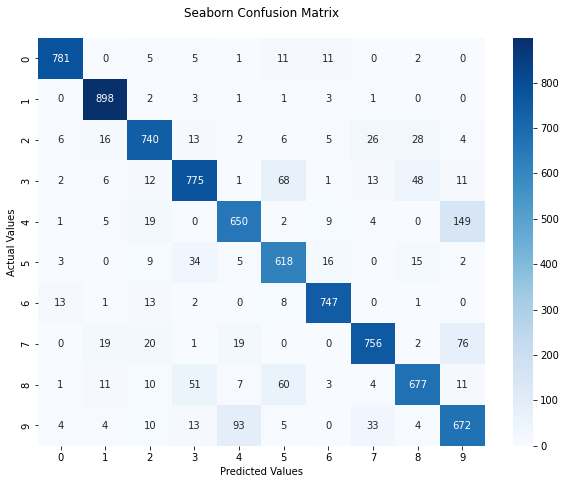

In [16]:
# Use Clustering
from sklearn.cluster import KMeans

n_digits = len(np.unique(y))

print(n_digits)
# Lets try a kigher k then actaul digits
k = 100 #n_digits

kmeans = KMeans(n_clusters = k)
# Fit the model to the training data

start_time = timeit.default_timer()
kmeans.fit(X)
stop_time = timeit.default_timer()

clusterVals = kmeans.predict(X)

predsMap = {}
for i in range(k):
    cat = np.bincount(y.iloc[np.where(clusterVals == i)]).argmax() 
    #print("{} : {}".format( i, cat))
    
    predsMap[i] = cat
    

print(predsMap)

print("K-Means fit time: {time}".format(time=round(stop_time - start_time, 2)))

y_pred = kmeans.predict(X_test)

# Swap k-means with actaul category
y_pred = np.vectorize(predsMap.__getitem__)(y_pred)

fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');


In [17]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))

Precision score: 0.87
Recall score: 0.87
Accuracy score: 0.87
F1 score: 0.87


In [13]:
digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

predictions = kmeans.predict(digitsTestDf)

# Swap k-means with actaul category
y_pred = np.vectorize(predsMap.__getitem__)(predictions)

df = pd.DataFrame(y_pred, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions_kmeans.csv", index_label="ImageId")

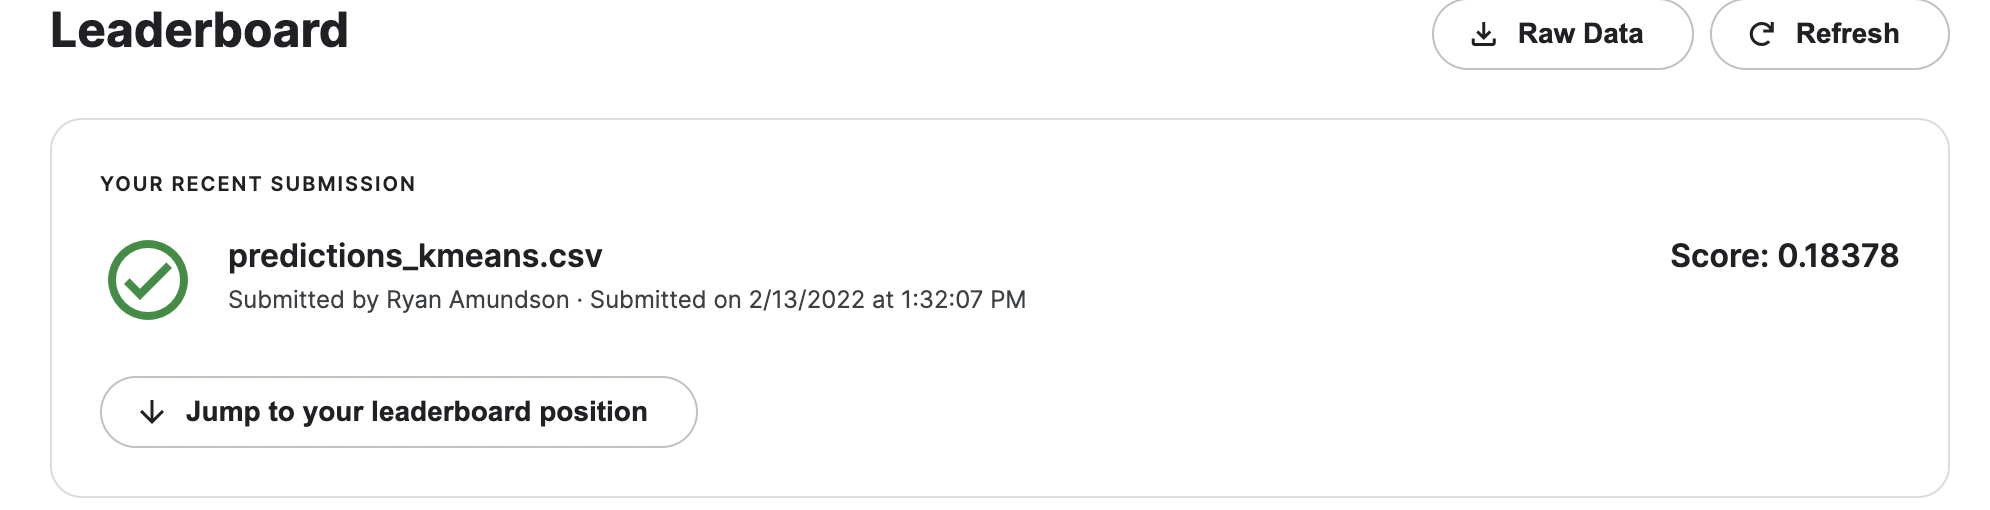

In [208]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB8YAAAH+CAYAAADu/mSqAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB8agAwAEAAAAAQAAAf4AAAAAQVNDSUkAAABTY3JlZW5zaG902k9LoQAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTEwPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE5OTA8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KdR+58QAAABxpRE9UAAAAAgAAAAAAAAD/AAAAKAAAAP8AAAD/AAJA10vWloAAAEAASURBVHgB7H0HwBbF8fcAikqxAFEsIGLvCpjYW+yaaBJN7NLs3ahJFGNLTNT8E3s3fonRJAqW2BNBsRdQQbHQuwUEC4go8H4zu/ubnb275wVeqbqn7LTf7uzO7e7de/vcXqM6PqjiEGUjq2dFHSugk1yNguCxJgdYR+uojnMhny8SAOsg5UsIVmT/Of7oR7n/5fGX5x87m5oZE6yjef7N1598/cV1w46Y9I4jlTCEVMuKfP+R7z/Qj/L9R77/yPcfdjY1MyZYR/P9R77/yPcfuG7YEaP3FhUMhpCaWJHvP/L9B/pRvv/I9x/f5fuP9z+YRB98NIk++WSqe77cuBHfZ/AE2aJ5M2rZogU1b9mMVmi6PC2/fFNatmlTWqbJMtSkSeMwnZZmV51mwZQQef7N1x+efJfm+Xf27Dk0e/Ys+urrr2jml1/RF19+SdOnz6DPP/+cpk3/wnV9375GtOLKK9Iaq32P2q62qh8S35H+/8GHH9H7H06mqVM/0fUtCUDLZs2o+UoteX5ZgVZYbnlajueW5ZZblueUJtSY55VGPAtp7wDraP77J//9s2T8/ZPHv5/K+C+pOFahKtBGWBgvDV97513IJGIJn2DgGDQYIYKaCpbKy/7jnX8SWy+U4pVgEGDQHH8XAYQDNPc/Dou/FSr1pzz+8vjDX97J3OKFUn9JMBhgoMEIETSPPw5MHn/SO0r9Kc8/ef7J80+YOMukNF4SCCZY0GCECJrnXw5Mnn+ld5T6U55/8/yb598wcZZJabwkEEywoMEIETTPvxyYPP9K7yj1pzz/5vk3z79h4vRk9uzZNG78BBo/8UO3uNfYxacRfa9Na2rdahVqtcpK1JQXwWU0+XkFNBQDEVRxefzl+aewfPcdm39nfjWTpkz9jP9NpUmTJ1PdbI4Hj69lmi5La63eltqvtQYvADcJA6livKhFGAww0GCECKq4ivIWYfxlXhkb5pVZX3/NUwe3nX9ks+r32lCr1jyvrIx5JTayNF6iaalrv1S91J5FGP/sf/HH/7s8/qv6X6O6OTwC/N8mYneHzlssyQvlMkHKYfVOYZKSraAoiC6n01UYrCr7z/HP/S+PP5kw7Lxgpp44l1hlAVwQY54Kg1Xl+SfPP3n+yfOPTBh2XrBTTaWtAC6ILrvTVRisKs8/ef7J80+efyrnGDMJ2TkjTi4RULKzyekqDFaV5588/+T5J88/MpPYeSHOLJ4r2QqKgugyOV2Fwary/JPnnzz/5PlnzLgJNGbMBJo9Z5asW1FLfntzzdVX40XxNu5NcDtnxMklzlIlO5ucrsJgVXn+yfPPd23+mcVvlk+aNJkmfvghffrJZyTvQzdZpgm1a9eOOrRfIw4qw9kx49QFRUGMkAqDVS3s8Td27AQaO248v0k/280HK67YklZvuxqtxovissPEwvYvc1lefzMdiVkbkhz/RT//fpfGf83xxx1P+mE4bJcUlZUtXwPu1B6nqd3/K2Tj2abGr0GLPqxs+ezfhBpRTYLio8Vpjn/pwpP7H/eLyl8jF8eYlS2fdLXc/5II+DhpmsdfHn/+uUbsJfn6l+efPP/G8aBc8RpjZcuHDBUq3LN6E6d5/s3zb55/dYQ5Jl9/8vUnX3/SMeEHBqd2srAXGMuHrBWqfP3xQdE0X3/TLiVdJ8+/ef7N82+YRC0pTqh19PGUT2jE6DE0fdp0BjZyb4a3W3N1WmWVlTHV2gKY15mH0czn+SfPP/aSLr0lz7/zPP9OnfopjZ04kaZ8PJUDJ58qaE4d12nvxmGyPCRxdcfSMf4+5q3SR4waQ1/wFvJS41atV6b2a8i8skpohxDfFq+wfIBUqJDHmzjN80+ef5bi+efbOv7ntv7ltlK3v8rwA1sGfjibboTrMHczAs5z1KaaMG1EIkCZZCpvBtnCFyr8Kiv7d8HieOX4uw7kOplL3GVKdGlv8zaHTS5kXuNSF1JOcv8zQYlsHn95/snzr51VZGzk+dfNEG569XOsm0ZjZMJs620Om+dfEx0fEZe6wHGSrz8mKJHN1598/cnXn3z98TNC4SrjLi8uyff/Ycq0PSX5tmG+/nKEEJ14ffEdJ19/8/1HRd/gbpLvP/L9R77/wNhYcq6/w4aPpgkTJlJd4zr+xu+KtHaHNalN61Y6w8e7Alt38Hn+1wi4U5qvf/n6VzE25vH6N3nyVBo1djx9Pm0ah7GOt1dfg9Zbbx0ei34U+r5mee19YUlnyel/w4ePonETP+B6zaGWLVvS2u3XdJ9jiG0QLsTKNcm3S1I5EMWoTTUeZVKXkZP8/McEJbL5/mvJv//6No3/2PM8V9X//DfG3Qg3w9wNZM6E8V4sqUJOsiRCGVwyiyK8066sZMv+y8GroUlimgjlDCWzBj1c5kqAchlFTZIlEYrI0k8fvCKffw5Ujr92Rek2efyXB08NTTLkEqGcoWTWoOf+p6GQsOX+V+48NTRJn0qEcoaSWYOe+5+GQsKW+1+589TQJH0qEcoZSmYNeu5/GgoJW+5/5c5TQ5P0qUQoZyiZNei5/2koJGy5/5U7Tw1N0qcSoZyhZNag5/6noZCw5f5X7jw1NEmfSoRyhpJZg577n4ZCwpb7X7nz1NAkfSoRyhlKZg167n8aCgnbYup/0z+fTu8OHUmfT//cnbx1OrTnLZzXKp9Io0nOaSIYUGBLZm10Pv8aConVYjr/7lFw9r9Exn8ML46P4h0c6uoaU8sVm9NG669HLVo0S3+0WhpgYeAFUjJrp1u4428a7zrx7tAR9Bkv7suiw7od1uZFcZ5XFpF/RGFxtT/79xHI8fdx0Ol9Pvr/0jz+56f/N+JPjMtmD+ZwUQqy6UJBba0C8nINI0plcx1f7RrplRal1HH+qPVw2FC6UK5hDRdeXcPoC3R5s38bacQ4x99GxXcXxEYk4eXI/S+Pv6QbuF4hie8toc/YrqMID8rzjx1pCFSef2xUfJdBbEQSXo48/+T5J+kGrldI4ntL6DO26yjCg/L8Y0caApXnHxsV32UQG5GElyPPP3n+SbqB6xWS+N4S+oztOorwoDz/2JGGQOX5x0bFdxnERiTh5cjzT55/km7geoUkvreEPmO7jiI8KM8/dqQhUHn+sVHxXQaxEUl4OfL8s6jmn0mTJ9Pb7w6nOXNmU8sWLWiD9TvSivxW56Lyr47cec/n34Uh93/tFnZ2kNh4OWiLRh88B/o2XX+mfT6N3hvGP1xxb483pk03Xo/fuG6DYKDVkXJcFnf7P/p4Mr3j5hV+S7xFc9pgg3VpRaZ5/s/rb3x1N4cdxMLLka//9vq7NI7/+Z1/+I3xOXz2zS910l7iuoXtKk4xn0mS3/Q1X4y3ujQBRic11BEwFy7JL4Ic2k5vdWkC9DBJa6gjYC5ckl8EObJ/Hwd7a5EEKpiZ1FBHwFy4JH+Ov49W7n+h1/je4dKko8ROVUMdAXPhkvwiyJHj7+OQx7/rDK6PJB0lhIdJDXUEzIVL8osgR+5/Pg65/7nO4PpI0lFCeJjUUEfAXLgkvwhy5P7n45D7n+sMro8kHSWEh0kNdQTMhUvyiyBH7n8+Drn/uc7g+kjSUUJ4mNRQR8BcuCS/CHLk/ufjkPuf6wyujyQdJYSHSQ11BMyFS/KLIEfufz4Ouf+5zuD6SNJRQniY1FBHwFy4JL8IcuT+5+OQ+5/rDNItJk74gIaNGOkisnrb1WgjXrySI+k/TjN/SZI/9z8fvDz+QifyvcOlSUeJfayGOgLmwiX5RZDjWxD/94YOp4kffOSas+F6HWmNNdo6vpgs7vaP523Thw0f6aq1xmqr0oYbrPetiH8xzrXkxR3/7L/Q3eRE5fEfuqvvHS5NOkrszTXUETAXLskvghxzib/fSl2ASW5RmIO/Ae6+j8BEXi/XMg2kFhuLrfp1qskVgUYZ2Ow/x1++z5H7Xx5/ef7J82/5ClFTEy8r+fpT/nWsCVsMlFEGNl9/8/U3X3/z/Ue+/8r3X/n+K99/le8QamribUW+/8r3X8W3k0y3iR3FKAOb7z/z/We+//xW33+OGzeRho8a7drYoUM7WmftdnEeyOM/j/88/pfI8T9q9DgaPXYcj9VGtF7HtandWmvEcctcvKwvnvu/seMn0IiRY7kic2jtddpTx/ZmXrE1jRW1Ws/n+SfPP3n+qZx/lvTxH4f1/M0/FVuph3nBTQbCVy+DR4cBb4kYcVRmD7mZ1Fxoz/5D6CsDaC44CLShOf4xGJXhy/3Pda48/vL8w+Ojeohw53CGSmuef3iGqY4MG/L8m+dfRKCyk+TrT77+cMfI1998/eVuUD1F5Otvvv+Qi0hl78j3XzUjw4Z8/yUdxx+V3Sfff+T7D+4Y+f4j339wN6ieIhbd/cdEfqNzqLzRyRVZr2MHarcmL67l57/hxFSenXz956tbdWTYkK//4eJfK0gL9vo/bgL/qGXEaBf3DfjN8TXtm+OVJ2nB+o+NDVw4/xMmfsg7UAzn7tCI1l+3A60l84o7Fo1/52oxtj/75wjk+LtukCYLtv8vqeP/m/R/3UrdFRLiZYOYqmJAXYdLjSabN8AMqoBEYQTDApuqggQlKMBKvQFm0II5iMZqWGBTVZCgBAVYqTfADFowB9FYDQtsqgoSlKAAK/UGmEEL5iAaq2GBTVVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMWjAH0VgNC2yqChKUoAAr9QaYQQvmIBqrYYFNVUGCEhRgpd4AM2jBHERjNSywqSpIUIICrNQbYAYtmINorIYFNlUFCUpQgJV6A8ygBXMQjdWwwKaqIEEJCrBSb4AZtGAOorEaFthUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvgBm0YA6isRoW2FQVJChBAVbqDTCDFsxBNFbDApuqggQlKMBKvQFm0II5iMZqWGBTVZCgBAVYqTfADFowB9FYDQtsqgoSlKAAK/UGmEEL5iAaq2GBTVVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMWjAH0VgNC2yqChKUoAAr9QaYQQvmIBqrYYFNVUGCEhRgpd4AM2jBHERjNSywqSpIUIICrNQbYAYtmINorIYFNlUFCUpQgJV6A8ygBXMQjdWwwKaqIEEJCrBSb4AZtGAOorEaFthUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMHsxEn87d+3hgx1vFsUr/nGqUBCSSgQ1OW2iTfADKqIRGEEwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQnKYF0cY37zTTegNq3bYLQqRZmpwhRiWGBTVZCgBAVYaR1NmjyF3nz7XWrMC1UdeVG8vS6KMyjJZwTDoqhUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlAGL2njX34RgeqBok1qcApjNWx8YxxKUC2lzHhIbWDZUtREWTkwoGW3qvGQauBHH02iRx97zO387jIITCNRRzvttDN15F8l4qckWgoYUMlW4/CQ2sCypaiJsnJgQGv4FrWH1AaWLUVNlJUDA7oA/Y8ZO4aefqq/r7nbIgBOeHuDusbUucvWfDHdzJ8SmBagf0QsFhmdKAcGNIJLnIfUBsLyvyef5O8mTeT80DA17T/ssENp2aZN/Y+aDMQrSm5V4aHIoGplypaiJsrKgQHV0sqMh9QGli1FTZSVAwNadqsaD6kNLFuKmigrBwZUvZUZD0mBY8aO5T7+tAM7C36pJgKf/06dO9Pmm3Efd0fMqxwY0ICsIh5SG1i2FDVRVg4MaJXjoPOQ2sCypaiJsnJgQLP/mhHwIaodqLKlqImycmBAa3rHbFYbWLYUNVFWDgxo9l8zAj5EtQNVthQ1UVYODGhN7/n8+xDVDlTZUtREWTkwoDn+NSPgQ1Q7UGVLURNl5cCA1vSe+78PUe1AlS1FTZSVAwOa418zAj5EtQNVthQ1UVYODGhN77n/+xDVDlTZUtREWTkwoDn+NSPgQ1Q7UGVLURNl5cCA1vSe+78PUe1AlS1FTZSVAwOa418zAj5EtQNVthQ1UVYODGhN7wuu/0+bNp0GvP4WPwOcTR14i+N1eAt1fVS2CPyLC20uGNDsv2YEfIhqB6psKWqirBwY0Jrecc5qA8uWoibKyoEBzf5rRsCHqByoUWN4W3X+16hxY+qy9ebUonnzUEYRG2XlwIDW9D738//5tC/otUGDac6cOX5eWXstLg0PZKXg6EQ5MKDfwH+5iKImysqBAc3+a0bAh6h2oMqWoibKyoEBrekdvac2sGwpaqKsHBjQpdD/kjL+yyEsaqKsHJhA4zfG9URYhChlQmEd9jyH2WvNdAMDqOQtH2p1jEoGCJ1QOebP/6BBg+ignxzss1ak++2/H11/7dWhd8OXBULXMP8YNrZEy6N0PzerZCDQfXv89+3bj3oee7xro7SqMZ9S/uQHn1rf1l4XnEc9unULMfj2tL9Hj2OpX1gsDY1zpx3tHzRoAK244kowfevaX2iYE3F2v239v2/fvtzHT+A2aguT5vfqxX28e7dodbAqLHRC5Zi/+a+Wf1+WsWb/Ov8gNp7m+GufcwHJ/c+NmqXk/seM8LRbBwm9+9s2/8Z2awtz+ysioNFxjEoGCZ1QOfL4z+Of+0Ke/3Qo4I9ejBQ/TiCBem0xVatjVDIw6ITKkcdfHn/cF/L406GQx5+fGTBTpFKq9baYqtUxKkWA/oUqNjny/JPnH+4LC2H+GfD6IPqcF8dXX31V2mj99Xx3y/0vjjkXkTz+8vhbOOMPz9/DwFsg4+/docPo/Q8mUcsWLalLp83TolnSK45jVDI46ITKMf/9f8Brb9K0adOobVueVzbAvOJLQ+n5+YeEVqPhg+NS6Boef3/OTJGGRek5/hyUb2H8l4TxvyD6X6O6Ofwxl8oTZHozs9qhEzW0oImRfwnIRctH6zm3fOdBOHcwHPdZtQcIwJol5lcT/IISDR48mA466GeufG6b8y8v1c/hekgz99vPL4wvLP9aNWYWR/uXRP/9eNGw+3En+G4mZ5H7RZ2cD+kQfI4u+O1vqHu37rbqJT6eYWuCFtTaFn/8u3fvSU893Z9bHPufG7Sh/YMHDaQV+Qbi2zT+7Bn4LvX/vn2fcgvjfgMPP7/Z+ee8C86nnvjxB3fXPP+Ey5cbutXjN+lLLOj1Qw3IB6oGx3yX+l9ldBbD9deegRz/RX//k+MfI5D7X+5/i/rvj9j7Fv/9Z+7/uf/n/i93jYvu+UMe/zECef7J80+ef/L8UzX/DuVvEk94fyK1bNaCunSWBbTyX/dxJpESqhDQgtoc+f4rz795/l0c8+/A1wbTZ9On0Zpt29IG63fkQbno7r+GjxhF4ye8Ty1atqDOW22+yNef7AyUx18ef4tj/KEPLq7+tzjHP9ou9Ju0370xntxWqKCM9VXJA8nP4d1iJ6iCAVBFyiRmFZRJwRUSkOJXFsYP5IVxt+gasI14FaqOV8VlYXzf/fel66+7JikF+Z1SBWUSbJUAJNoNqlgAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oID2e/Ip6nHccS7+siAoh/9zwfPn89u0Pbt38wIKq3Er7EFpiizwC6ooAFSRMolZBWVScIUEJPyC4o1x2/9s+994gxfGV1wxbSkKS7UVXqMKWeAXVBEAqCJlErMKyqTgCglI+AVVKACqSJnErIIyKbhCAhJ+QRUKgCpSJjGroEwKrpAE2Y93RejRk98Yb8RbIfBJLs4/51/wG/fGeEX29EyrW2WqsiQ6INFuUAUBoIqUScwqKJOCKyQg4RdUoQCoImUSswrKpOAKCUj4BVUoAKpImcSsgjIpuEICEn5BFQqAKlImMaugTAqukICEX1CFAqCKlEnMKiiTgiskIOEXVKEAqCJlErMKyqTgCglI+AVVKACqSJnErIIyKbhCAhJ+QRUKgCpSJjGroEwKrpCAhF9QhQKgipRJzCook4IrJCDhF1ShAKgiZRKzCsqk4AoJSPgFVSgAqkiZxKyCMim4QgISfkEVCoAqUiYxq6BMCq6QgIRfUIUCoIqUScwqKJOCKyQg4RdUoQCoImUSswrKpOAKCUj4BVUoAKpImcSsgjIpuEICEn5BFQqAKlImMaugTAqukICEX1CFAqCKlEnMKiiTgiskIOEXVKEAqCJlErMKyqTgCglI+AVVKACqSJnErIIyKbhCAhJ+QRUKgCpSJjGroEwKrpCAhF9QhQKgipRJzCook4IrJCDhF1ShAKgiZRKzCsqk4AoJSPgFVSgAqkiZxKyCMim4QgISfkEVCoAqUiYxq6BMCq6QgIRfUIUCoIqUScwqKJOCKyQg4RdUoQCoImUSswrKpOAKCUj4BVUoAKpImcSsgjIpuEICEn5BFQqAKlImMaugTAqukICEX1CFAqCKlEnMKiiTgiskIOEXVKEAqCJlErMKyqTgCglI+AVVKACqSJnErIIyKbhCAhJ+QRUKgCpSJjGroEwKrpCAhF9QhQKgipRJzCook4IrJCDhF1ShAATFx1Om0ptvveOee3TeegtqyYtYuiyuWGW0mFoMkPALqngAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMLvp59No9ffGOzG9xabbUytV1ml6lctWhLyO4UKyiiuFgPk5I8/oTeHDOEFsUa0TSc/r6RlVpeA/Ck20VZnDFog0X5QzQSAKlImMaugTAqukICEX1CFAqCKlEnMKiiTgiskIOEXVKEAqCJlErMKyqTgCglI+AVVKACqSJnErIIyKbhCAhJ+QRUKgCpSJjGroEwKrpCAhF9QhQKgipRJzCook4IrJCDhd3GNf/gH1aqigqpImcQchNJW6l6fQMPCTdCVvKZOylIsy3GcyOKg3ggVMnh0zCPmRDcX/4P42xI/+Qm/MS4ZxYnggzfh9t93X7ru+msWmn92UThS/7I4vzDbX3DO4uL337evvE17vK+JaT9Oj9tKPSyM+9rGOkt7Et1czv+S1P4ePXkr9X5PcZV8b3ft4ATnfzAvjLfkhXF7JG0NhkS3FLXfV9/XXnjHcYL2h+YlJGlrsCS6JbT9ffv1o2N7Hsdt5EXx0FbP+NrLVurduY9/F8d/rf6fnPiqc12lW0LPf1VbvM6ff+Edx8m3sf/n9teKQD7/efxXX/+reozvLbHPCCbR5fmPu5OPZ1X8yroYS8dxkudfjMha0YoxE4SXgi73v9z/8vgrD5yamjiWHMdJnn/y/FPrCuZ7S+wzef7N15+kT3wLrr8vv/Y6fTF9Bq3boT21by/f/41H0tagTnTfgvbn+T/P/9/2+X/M2PE0csxYat5sBfp+563dSHbjmJOF1f9fHfg6TeN5pSPPK2vrvOJnD6nAwvYfpqsCyf4x2nP8ORIchIXV/wsdL4iLp/8tjvG/INtfWBiPQQxPQ9iX0RUk3KM4RAor1LFeo8EanLLKOJyVqvzLwvhBvDAeD7kEuQ9au/HpFsYLb4xHrCldWWUczEpV/mNZlrO5rL7IG5yyyjiwlZYW//r9ZT4VbmKQmaGxtIQPJvj+ctLXtKHKAB6WmRnNJnlG4xApzGFjUq8xwmxf1yzKzLd//8Z4f84X+59t/yB5Y7ylXRg3vpRVZr79x4alZUR9kTM4ZZXJ/jkCNhq2//V7sh/1PP54D0jCyh2Uz3+vXufXfGM8wk3pyirjYFay/qVf6cCIBQauXqNBG5yyyjiclbL/JXv+iSfWnrWoLXMGp6wy+fxzBGw0cv/P/X9Jvv+I49v22qgtcwanrDIObqXc/3P/z/1/yf37I45vO2qjtswZnLLK5PHPEbDRyPNfnv/y/JfnPzcn2ImhNLHWazRog1NWmW/F/Dt23AQaMXIsvxDSnLrw2+LpYdqqrDLfivan7S1Kpq3KKpPbzxGw0cjX3yX7+jtg4GD6fPp06rhOO1q7XfoDmGLP97I5u8oqU2//Hzt2Ai/Ej6YWzVu6t8XT8tMyUpuVDE5ZZer1n5+/cnjkUXflkcawEuKUBqesMkXEEr/+E9uZtiHqi5zBKavMUtf+RTn+F/T4KyyMFy48fCpq9vVwiUpPW/FER9njItpxUVSgVVleAcp4axFTXhiXNjTipSl5l7OO9udvjF/HC+MuXzEzl21Vlle3ynhr/RgFh3Ij2nFRVKBVWV4Bynhr/RgFL1b//fo+Rd2P5a3UuRZyLqTO8k/WxmWN3L0xHr6/bNtj+dgScN5aPwZYnNeIdlwUFWhVlleAMt5aH0a3Uuc2o//Z9r/5Or8xvpJdGEc9vZP6ygayfoxWdrGef6lFMVpOrqi8VVk+tgSct9aPAXbh+5c3xnv0PN798INPd3LIOT+v12/4cwFdWe+Nrt4VlbcqyycFOsFb68fEXEW0kysyW5XlY0ngvLV+DLALP/7RUzVXrK2TKypvVZYvl+qt9WNiriLayRWZrcrysSRw3lo/Btgc/2K0nFwRPKuyfIwkOG+tHwNsjn8xWk6uCJ5VWT5GEpy31o8BNse/GC0nVwTPqiwfIwnOW+vHAJvjX4yWkyuCZ1WWj5EE5631Y4DN8S9Gy8kVwbMqy8dIgvPW+jHA5vgXo+XkiuBZleVjJMF5a/0YYHP8i9FyckXwrMryMZLgvLV+DLA5/sVoObkieFZl+RhJcN5aPwbYHP9itJxcETyrsnyMJDhvrR8DbI6/xGnO7Fn04ksD6evZs2mzTTei77VqhcchGigbT8srQBlvrR+j4G/986fY0mquGC0nVwTPqixfLtVb68fEXEW0kysyW5XlY0ngvLV+DLB5/BWj5eSK4FmV5WMkwXlrfZjJH0/hrc3foWWbLEPbbtuFlmnSmDMv+OefdTyfPP/yAJo1azZtvslG1KYNzyuFo1hbJ1dU3qosXyiORW+tHxNzFdFOrshsVZaPJYHz1voxwJZr6/JVZLYqy8eSwHlr/Rhgs/9itJxcETyrsnyMJDhvrR8D7OKJ/6Ia/4XllthowxWj5eSK4EGlC+NQmLICW8dTAJbzQhUUrEwhWy29wGAD9VlTyRY3f/4HDXqT3xj/Cc+/XFdZdXX+pDzP77ffPvyN8WuDPrSnJAkex/z597lqt2Zht39J9C+Lhj3l+8vuXHBv4nNTJz/3I7lQ1rm3abt37xoumb4FMV1649+jx3HU76mnQlPQF2P7B73xOn9jvKWz1+4xS2/74zm0HFoK6m2plOKXhvmnL39jXD4X4OcZ3iGgMP/4N8a7sh0tBfVtTSWvg2VpaL+tcWxjqkV7MBd7mmrLOXL/z+d/6bn/mFtvjmMjHfGpZEdB7v+5/+f+739OGe7XdbAoYwcM87X0AoMN1GdNJa+DJfe/3P9y/zMjRFll7IBhvpZeYLCB+qyp5HWw5PGXx18ef2aEKKuMHTDM19ILDDZQnzWVvA6WPP7y+FsQ42/0mHE0irdXbt16Fdpi0425e+XnrxhpefzZ3oCoCM1//y7N8++gt96mKVM+oXXWbk8d1pa3xtHTQf25TiWvg2Vu7R89ZjyNGj2WWrVembbcbBPjw5YDHp5A4SX3vzgbI1ZC8/ibW/+z0fJ82rdSO2ygc8uxdMd/UYz/NL4ipbFN7bCBemsq8VxQVzeHdWZIKEKZtFwjpQicwABIjCyEjfWx/UksJgGaNhX0MYNyKcL7H+wWxn9qypHWsc1t392I9t1nX7rh+qu1jAQoWi1UGYNN2RQx9/ZP+2I6NW7UhJo1W94UlJayIP1PF3+NG9MKK7C/hRj/WbNm0cyZX1Kz5i1iTzLN6te3L79NywvjjflMhDVDt724Wzz0C+M9unfzMdF8yphYpaxFTJv2OTVeZhlqtvwKhXJEZORCav8c/rXa1KlTabnlmlLzli15qT+MJXbpvjH+1NNJ/7PtHzToNd5KXRbG0/EnPenzaZ9RyxYruh8R+AaVU9t+aaOfwAMuMdbf/s8/n0bLcx9ZdpllXah8dZICys5ZkyLm3f9sjtn06dN4Oy2Ol/SBQvsXpv/PPptGs7m/Nm/RjJo2bVpqRWxU2jrJ8+XMmdS8eXONhUXI5wJ6HHsCV13awxZjlPnn/PN5K/Ue3XT7Fy3EAkWp+ZSJ0AKXIuY9/i7kWlZaSvbPgXHDsRAXjVdkUkSOf0Pnn0U5/hf2/YfO5EnnYGEhXX/UHw/cHH8/+7oRmuNvhlXuf3n88UzB/+f5j8MQJ02eKpKJwogFfbzsK5ci8vybrz/5+qNDKxkcLOT7nzz/5uvPd/r6+xy/1fnVzK9p6803oVVarRSuo8lEka+/Gg5l9H6jyKSIfP+R7z+WvPuPKVM/ocFvDqFllmlKO26/zUKZ/5578VX6+uuvaEueV1qtsoofJsngYCHff+T7j3z/sVDGHwZc1fy7KMZ/ff5hm9/xr2+MmzsSV1a8zEbOOzFpMvlEfVEN2VObxjwLyr9spX4gf2Nc/0BjTlog7ybLl54P2H8fuu7aa4uPQ9iCWvo6xVZHzltMmmZRg6inTplCfe67n15++RUaM3YsjRg23Plv7GrTiDqs05F22P4H/G972nXXXfzital19Bo5dQDG+B8y5G164fkX6On+z9C7Q4fSlI8/DqhGvGDdjNZftyO1W3tt2nij9elnPz2YVl1tVeNNoKYwJ6Gbl/1//fXX9PjjT9CD9z9Iw0aOoLFjx7scq7dtS506d6ItttyC9t5rT1q7fXspmJ7kt2mP47dpJf5ovy9dfOIb412Zi2cteo2cYOWYEmL7yksc23FjadiwEayVEn0rOqzTgeO6nYvtbrvuSsvxoi9s0hvET9paVrFmwoSJdPElv+OL7NcsSXm+1/i6NqKLLuxFa3MMZ/IC6b/vuZfuuvMuGjp8uCsP/ocMGcyLzCs4f/jGuJSF/mfbP/iNAfzGuN9KfcCAV+n551+iNwYNoldfHUDTeOFY/K+/fkfadLPN6YjDDqUuXTpLReNRboSzFdWQhY7j77D0vu8Bd7MydswYGjVqVCivjn/J24bW6dCB2rVvR/vuuzfttutufEMjNTY3XNG7D7YEtnDAn6in8aL7sy+8QC889xw998JLNPmjD7ltX4Qy66g9++rYsSOtteYatNvuu9MuO+9ETZo0YTu8Rq7ghm675TZ6/qWXWO3Prk+lWnXUaaut6bTTTnFZ3nn3Xf4xzI3U7+n+NIPjKiXLv3PPOYtOOpF/sOEOW2uir/hG64nH/0cPPHA/9/GRHDffx9uu3pY6d+pEW0of33NPas+/hJRD3hg/lvu4lJKW5Oef3/Y6j7p17+Y81+p/89r/nUNJUkc11YB5alPNUiosRj1yFu14FFwwFNWQrWfoYtZUE71GLmIDl2ZRc1EN2VObahZmgPK66DVyFu34NIuai2rIntpUszADlNdFr5GzaMenWdRcVEP21KaahRmgvC56jZxFOz7NouaiGrKnNtUszADlddFr5Cza8WkWNRfVkD21qWZhBiivi14jZ9GOT7OouaiG7KlNNQszQHld9Bo5i3Z8mkXNRTVkT22qWZgByuui18hZtOPTLGouqiF7alPNwgxQXhe9Rs6iHZ9mUXNRDdlTm2oWZoDyuug1chbt+DSLmotqyJ7aVLMwA5TXRa+Rs2jHp1nUXFRD9tSmmoUZoLwueo2cRTs+zaLmohqypzbVLMwA5XXRa+Qs2vFpFjUX1ZA9talmYQYor4teI2fRjk+zqLmohuypTTULM0B5XfQaOYt2fJpFzUU1ZE9tqlmYAcrrotfIWbTj0yxqLqohe2pTzcIMUF4XvUbOoh2fZlFzUQ3ZU5tqFmaA8rroNXIW7fg0i5qLasie2lSzMAOU10WvkbNox6dZ1FxUQ/bUppqFGaC8LnqNnEU7Ps2i5qIasqc21SzMAOV10WvkLNrxaRY1F9WQPbWpZmEGKK+LXiNn0Y5Ps6i5qIbsqU01CzNAeV30GjmLdnyaRc1FNWRPbapZmAHK66LXyFm049Msai6qIXtqU83CDFBeF71GzqIdn2ZRc1EN2VObahZmgPK66DVyFu34NIuai2rIntpUszADlNdFr5GzaMenWdRcVEP21KaahRmgvC56jZxFOz7NouaiGrKnNtUszADlddFr5Cza8WkWNRfVkD21qWZhBiivi14jZ9GOT7OouaiG7KlNNQszQHld9Bo5i3Z8mkXNRTVkT22qWZgByuui18hZtOPTLGouqkX+6MMPach7I2jlFVvws5ktCt4ka5oreo2cOgCTZoG2UFIs2cNtqlmYSQuLXiNn0Y5Ps6i5qIbsqU01CzNAeV30GjmLdnyaRc1FNWRPbapZmAHK66LXyFm049Msai6qIXtqU83CDFBeF71GzqIdn2ZRc1EN2VObahZmgPK66DVyFu34NIuai2rIntpUszADlNdFr5GzaMenWdRcVEP21KaahRmgvC56jZxFOz7NouaiesAbb9K0zz6jDTdcn1Zf7XuMq37+3pDnnx989BG9w/PKijyvdN5q88pqoT6e2lSrzAxQXhdbHTmLdnyaRc1FNWRPbapZmAHK66LXyFm049Msai6qIXtqU83CDFBeF71GzqIdn2ZRc1EN2VObahZmgPK66DVyFu34NIuai2rIntpUszADlNdFr5GzaMenWdRcVEP21KaahRmgvC56jZxFOz7NouaiGrKnNtUszADlddFr5Cza8WkWNRfVC3P881RSOor+IXtqU5sVKK9zC+N4iyAJgcHZohxvbC6gTuYaJnpxwIrwSx1bhSK/IP0PGjyYt1I/mF3IMiwf4p/fVHY/lWBxv/325a3Ur3EmJAvS/0heaLzhxpupT5/evviCf/i0tFWr1nTaqSfToYf9nJZrulzIxyScdB9Wk5o4Dx48iK688s/0HC+Kx/hLxur2w+/BB/+Uuh5zDG266Sb6K5J5Of/3P/Af+v3v/kAfT53s/blzLHWVGKPO3v8NN1xH++69D/Xl7cR79jwOrktU3qbt2aMrZ8diKEO0LLB1NGrkGLruxhvpvt738zllgGAkcdiyf7G2btWGTj31JDqMF5b9G8KiTQ+c/4cefpgXU8/0TeGNFNyW71y41EqWhx/6z3+o9ffa0C9+fhiNHT+20v+QIYN4R4BmzkGPHj2pX7/+Sf+znge9MdC9gfznP1/NfeYm9jCHPfF/0pQK/5vxAvnvL/s9bc7nDH2juv3wIrHhwvj/F158kW7ifvnsc8/DqNS3X25WUv9t2rSho446krcI70nNVpB+GW5oXLyRvSr+RDNmzKC///1OuvbaG2j6jC+4HpKp+rD+5ccUJxx/HB344wP5Bx3+7X/vzqSepV123Z1/lBHOQ6H/7bnnD+mWm2+gW2+5nS67/IpK/yefdCKdffZZpf7/wAMP0u9+d5n7AYacfZx/+XmDk9yY5krw/zfccC338b2pbz/p47yVOsfaJ+n463X+b6gHL4xXHeh/3pMrwJWNc2xaLi4L3zH39fCdJrhWJ2Lj8kKRqi4w2T+HiGOU41///CsdKfe/PP4auU6ASSTPP35QuAmkMNfm+Tdff/L1N99/YK6spvn+K99/5fvPfP+d//7If3/oKwjmHtuzJjU296DAyUv2/efrg4fQp598ShtusB6t3nbV5EK4NFz/6vj76HP4kY481ZFvJjeSN13cwcFfCuKP2lbRpSH+WEp1oXYJWpLjv6T3v/c//Ihf1htOK6+8Em29xaY4cUq/Sf97ffBb9MnUT2kjt+jO8wpPg/GQvrHk//0l8wpv7MunsZ7rH281O2vWHDf/NOHJpwm/sOaP3P+X9P6f9snYO8F9k/6/NFz/F+b4X1jtN2+M4zQFmlx8RGcVYQhblWY3w1vtyoRijKz5CkwJYhW1/Q/mN25/zAvjMm1Ih3Od0vU81vAT3f14K/Xr3VbqyQxacC6ZQ161WEW1/368bXZPXgyV5cVa/mVma8T1kCkwOVjs0qkz1+1aWnVV/lWVdeeAVuHz33LjLfTHP10Zi2EIljfn1f8ll1xIRx15ZCwDnHXHujlzZtOfr7qGf1RwA0vev1ubFkc4KvyfeebpvPi+MS+unujiX9X+Xvw2bWnRsOBfvtXdnb/Z7aM27/5dBj7/Xbp08bH9Hsc2fbKP2tMjDz9Cp5x2BsvshS9E/u5XfImmju6++y668MKL+A31YSzxOWZDXaH9b7/1Bi3frLlz26P7sfyW8tMMksAwUPya8//qKy/QmWedQ8/JYjW7FDP/77xV+cdl87Zbb6Ldf/jDGs3wsXFxEnfcjuuvv4H+/Bf+MUjBv3OFpB7/G260Ed1y0/X8dnf7gA4+pLLOEQoRWkfj+c37Y47uRiNHjvL2Gu23uYrtX6fD2u7HJausUrXllve/2y6705jx42IxXB/0/7333IP23GNPOudXv6oZ/5NPOoEXxn+p+ev4DuXPV11N1113I+cpn3/EX9poz/+ZZ0gf38QtjMN/cfz1uqAX9/GuktWfh3LgtB6OKcXWKuqPv9ZTsyiT/btQmHikUY9SCWIVOf6uj9mQaORCbERWuzK5/7lQmHho3ApMCWIVuf/l/sePUG2X0O6Tx1++/oXH69o/lMnzrwuFiYeOmwJTglhFnn/z/Jvn33z94Tmj4u/ffP3J1x/XLfSSocx38vo748sZ9NIrr/Nzz0a003Y/4EUdiU5p4KQXYBMyb7CKRX/9PfqYrvTMs8+7Wvfp/W/amncNXNzz30cffEQDXx8Y48Yhqnr+JJ95lF0sV1ttNWq/Vjtquhx/MnEpi795mMB1j+d/5tcz3W6NLggV7W/EL8U147avuNJK1KrVKtSO29+4ydLX/2q1v3wal7y//+TTmc++8Ao/Bq+jbbfpxLvj+pesYset4Oxwx8nVxvo2zpzxJb044DU/r/Duu01kdRl9Q/JoGcoEnZFd2RVJCWIVsf9plbSIucf/nXfepsf/+z/33H/ixIk0adJkt6vv6m1Xp3V5Z9/999uPfrjbrryOED4Ly2W/xDujHnr4Uc5dp05bUe/e9y60+efDDyfRawMG8G8KZJxIu+Uot38FfomzafPlqe2qPK/wzq9Nl23qcAvr/ufTTz+jgQNfo0H8MujwEaN4LluLOqy7Dm2y8Ub8suBmrpZSz4XlP86ZDT//M76YQU8//ZSro1S4Me+Ou8/ee4W6G2LD7dRW0XD//jTasoxPy5YgVjF//hfW+F+Y11+zMO4bnjY/dAWrLJ4kZ4t5xRxveWJGcKD2HHg+loH8ilUGuYzCsV6WVLZS/wlvpS6H3CRgkPAyl6vXvvzG+A2FN8Yd2PeYkFoN88ZdwRJsde7N1N//8XJnRv2r/MeiGCVnVn7R5GrJ7+vy4mnrVq3osYf+Q6vyryoVq4z3LvjLr/gT3XzTLWHx37dS2ijH/Pq/+cbraK+993Q5rSvlmfn9ZX+g2/76V19lt9Dp//gRVpQi1fLfs3tXuvWv/8/VS8sUKbT/gl6/oe6MkZpHewgta2+9+TZ+65djiyzz6Z+zubq1ad2aHn74P9SWt5EvH3X08COP0Smnnu5/1MCZpC6N+fzUuUXSRrT/AfvRow8/6i7wfDX27Sm0f8hbg6h5eGNcfiTR96n+Dof+F9vXiBdSu9Ftt93BXiR+/vzLCXWX9wr/tv233X4L/XD33UOQfKmSyiHtleMr/u77KfwG/JP/e9K1X/TWP+I/L/6bt2hBf73jNvo+/8DAluILjP7H8PbsBx/8C/qYt/JvSP+37d9q663on3feScsvv3xslDQstGJXfmN8zBheGK/ofzvuuAO98frrbtt2aXdV/E8+mRfGf3mWK1HK/N1lf+Tz8dd5in/x/Pfo3p3Hxx2uLMTftv+8C86jnt26mfgHt0piDJFfz5UyABuFY70sqRzIjziJDjlARZcesQzkV6wyyGEUjvWypHIgf/QaOZPTgzWNZSC/YpUB2Cgc62VJ5UD+6DVyJqcHaxrLQH7FKgOwUTjWy5LKgfzRa+RMTg/WNJaB/IpVBmCjcKyXJZUD+aPXyJmcHqxpLAP5FasMwEbhWC9LKgfyR6+RMzk9WNNYBvIrVhmAjcKxXpZUDuSPXiNncnqwprEM5FesMgAbhWO9LKkcyB+9Rs7k9GBNYxnIr1hlADYKx3pZUjmQP3qNnMnpwZrGMpBfscoAbBSO9bKkciB/9Bo5k9ODNY1lIL9ilQHYKBzrZUnlQP7oNXImpwdrGstAfsUqA7BRONbLksqB/NFr5ExOD9Y0loH8ilUGYKNwrJcllQP5o9fImZwerGksA/kVqwzARuFYL0sqB/JHr5EzOT1Y01gG8itWGYCNwrFellQO5I9eI2dyerCmsQzkV6wyABuFY70sqRzIH71GzuT0YE1jGcivWGUANgrHellSOZA/eo2cyenBmsYykF+xygBsFI71sqRyIH/0GjmT04M1jWUgv2KVAdgoHOtlSeVA/ug1cianB2say0B+xSoDsFE41suSyoH80WvkTE4P1jSWgfyKVQZgo3CslyWVA/mj18iZnB6saSwD+RWrDMBG4VgvSyoH8kevkTM5PVjTWAbyK1YZgI3CsV6WVA7kj14jZ3J6sKaxDORXrDIAG4VjvSypHMgfvUbO5PRgTWMZyK9YZQA2Csd6WVI5kD96jZzJ6cGaxjKQX7HKAGwUjvWypHIgf/QaOZPTgzWNZSC/YpUB2Cgc62VJ5UD+6DVyJqcHaxrLQH7FKgOwUTjWy5LKgfzRa+RMTg/WNJaB/IpVBmCjcKyXJZUD+aPXyJmcHqxpLAP5FasMwEbhWC9LKgfyR6+RMzk9WNNYBvIrVhmAjcKxXpZUDuSPXiNncnqwprEM5FesMgAbhWO9LKkcyB+9Rs7k9GBNYxnIr1hlADYKx3pZUjmQP3qNnMnpwZrGMpBfscoAbBSO9bKkciA/vI4fP4GG8m6Pq/Fui5tsvIGxe7xPYxnI7zVsVQZ4o3CslyWVA/ltRuQA9UibxjKQX7HMHN21G++2+Jx7ZNb73n+7T0a63A4U84oO+Rekf1Moe/D+Hn/8cTrxxFPZYf3PX6U+9vnXUUccTmfwyxytW7eS6oYjtgH19xo2K5NineRsMa/okN9mRBGgKCnSWAbyK1YZoKNiAvetHXfehX3Wfv5s29+KnwEf17MH74R5FO/syc8V9WiYfx+bmFeKQ/3780tR111/E9177780hLHm6jgwsQzkV6wyyGMUjvWypHIg/6KIf33tt/7fencoTfpoMq3bsQMvaK7hK5qksQ2ov9cwSBlk8Irx4yfSsBGj+UXC1rTpxhs6mCCQ32ZEEaAoKVJvsXbllQHaKBzrZUnlqOVfPm/b64IL3WdoHSqsf0g9i8//m7VozjvdnuKeGcunRV96+WU67Igj3fyzNT8X79PnXu9sPvxLvXxNfdY0jW144jGeV0451WHt+oc0zFW5xvrL4W5eOY1kncUf0Rs40NS3SNE/4qdYZkaPGc3tP4o+fP+D0vrLD/fYjW67ldfCQqHIjzJj6VYTwErq929OKufQmgU25pXi6vM/avRo2n13v9bmg9mId0IeqmWakqMXqxQH0TLf/ktFufJimdauvDIAG4VjvSypHFXtXxjj3zmbR/++hknkXPaYxDZI/f1W6sIIArmFlyMMAMdyUokRoxylvKyLEQp2gAJNSUUZDHC/WjEmFOGcmiToZWHcbaWudRcDH25LjTm8lfp+/Nbz1azgyoU8WqQyLgfbWTEP/p999jk6+ujuDipL8b5s5BWZj+Df2RTDEq+C8q7ZXBupj2NIJr5//fMu/gUO/7Kvwv9z/M3mo446xpeLlMsXaEP9y68gO2/dyVdPy5T6NKIBAwfSwYcc6k8nqzwDUKDfwP955/OiYfduUvm0bI6HbP199DFmQbGIQTXm0f/WW2/Nsf0Hb6vOv1oLZaHIhx96hE49Xd4YD8c8nn+HDv7f4jfG3VbqXGgP3j5e3nSHnRrZ21Pf/6rOf/Ae+gPj+EAdwbTmi0/fJ5+glfiXkCnAi4K7/Mo/0U033RzsXM439N+ieXPq/1Rfat0GF77gSwj7m8NvXB96+BH8jXT+FavGTmou9ob535O/VX/zTbxLAfdDFwkNBIWt1MMb4/N4/n0H84WcfCJvpc7fGRdpIPfxQw4+tNT/qsZfQ/p/L/5cQI8ex7AnaUVoREpUzQB/aAyNKeQBRGlRXylDGWhKjJPs30Ugx9+NO4kFek5kQh8BUUBQVMpQBpoS4wRlMEAuanwgZ2QCBkQBQVEpQxloSowTlMGA7N8FA5HL8edw+C4ZOgn6SkGvAbN2KANNSe5/CA8im+ffPP/k+deNBh0aymCQ2PnF6Io4J0MZaEry/IPwIIx5/snzT55/3GjQoaEMBkmgRX2lDGWgKcnzD8KD0H5L5p9Bb77Nn6X7lDbeaN3wUkp64rXZyqBPsWIJGX9H8TPI5/g5r/z907vPPdS509Y4S56W6s5q+3eCswMUaErmu/8/xgtYJ53MC+NyzOfzL9n98YH7+tAq/BY1ahUZX2R8hmeqpuCAASnqK2UoA02JcTLv/idM4IXxnXad7/ZvtNHGdPutN9Maa64Rm43qaZtY0YD+N5oXvy695Pe8W2h/Lkk+ATostA0OAk1Jg9qPqsZGBA1cAeBkKFPH0JbLYEsD2u9caqG+Ah98MJneGfoetVplFdpy841ZyYMjrYbKqPLc+p+bV6Z+QhvzNuptZZfd0njTkhZ7/B/6zyN04cUX0VSurzZUwlux/qO15vl/gw02oJv5k6Dvf/AhHX447+zLeTp13pr69L5HYY4pxBuxVZCzAxRoSrRaOq/M1/XHrz+1a78mPXD/fbTKyqtUnI958x/rzPjQ//bce18aPmy41lExzJxx+ml0+mnyAyGjhSuonAxloCkplz1f7WdH8+B/9OgxtNvue3gw+5fzP2LEMJ8V1dM6C8AXqiZlAAq0qK+UoQw0JQu1/Qtj/CcRQNOgrJShTBsOrR0z8Y1x0wlQtlBkArU28NEWOdhAnaVkNooF5H/Q4DfpoIMO5o7ml4idf+5brnh2t9/+9hvj39y/THR77LU3Tfl4CruS8uRoXNN/Mng0upwltB8/IjrnnLPppBOPVwRqOoe3Jdlhp93ogw/e56J8K+N78an/dry9xVdffU0ffCi/suExhkJcHSWJip132pH+9rcLl+OjAABAAElEQVQ71ALmy5kzOWY/opG8dYUMYlc/1wj/K0XxXcu/lO4OE/+q9rut1Lt11Ukg5HIXkT322odvqj/Wna0XhP9zz/kl/9LyBHYT2y8BeviRR/lb72e4NVxYHJX685r2vLR/yJDBvHUPvjHOW6nz9vrS5rnFv3j+58X/YYceSpdddqlpBXIRvfLyK/SLw47woVyA/vfaYw9ebL8R87UrH1579+5D55zLW5fPpf835wX2VVddlUaNGslYrpwchf6PMoXef9+9tNVWWwHp4JLsuusPaQx/Y7yh/Q9bqc/kPr7vvgeQ/JoL48/6l2vTvJ5/X7ny+D9ffvzBb4ynjYAXzhXa7/PHFAjQaIlctEUuWj3nLCWzUWT/fG5CXzTBQ4RAjUnZaIucGgPjLCWzUeT45/jn/lccNnptMyOlJoYnUbaVx7BkcJaS2Sjy+MvjL4+/mmPLjJSamDz+akfJWUpmo8jzT55/8vxTc24xI6UmJs8/taPkLCWzUeT5J88/C2n+6f/8SzR79hza8QddeBtv2W4Xx9LT/47iTwM+97x/Y/xeXpSyC+OxFZFDC0GdpWQ2igaMv8cfe4JOPPmUBj//Ovjgn9CVV1zhq9gA/0nbnGDaA2OgC6P9UrQsjO+wk39j3M//oi0/f3PNK1SvS+dOdM89//aPfRZQ+0eMHEV77LEP/xUqTyX9IQvjC6v94iE2K3LBtZLF7X/mV1/RCy8OoEZNGtOuO24b6mXq24D4P/Mczyv8Mtb223ah5ZrKvGLK05Z7ZnG1X7aRPv3Ms3in2kd1/aVx48a0N7/wtfXWW9Lmm2/hPsP5xfQvaOy4cfTKK6/QP+76Jy+Ef+CeZEi9v8c7bchLXBdfeqkrYyv+Uc59ZmE8tjpyhebPV/+ThfET+Qc38iTFlcjM/Dz/Pvjgn/G84ndPRj1cOaXqGUU95/+TTz7hWG2TrL+0bbsa7cS7wk6ZOpW6dT+Gdthue9QWLhP6TfxrHJISoxBbEblo9Rz8y5vvu7k3xkXv8f6HM8wvpOuveipVzyjqif+CaP/CGP8+soiithLqhLqWmuZ6o1EU2h8Xxm0xBu/URVmxZUNZo+DIMKiOV6DCO6BRD65YSFEGrmIifMNspa4jW/G8MM5bqV9/7TULzP95vX5L/7r731wT3545jgaHoUcdyVtM7LrbLtSlc2deqP6KBvB3MXrf34eeevJpl8+h0fuk0nySmrdsTi+98Dy14C01GMSDxpf54gsv0eFHHhUUslrLUeRfC1r/F194AR1yyCH85vIKLtMHPMn+7vd/oEd44dcdEn/+QHZj/kC2Xr65/FdffpHatGmT+Hviif/SCSec7MYsu4l78rgKRf8d1ulARx95BLVdY3X6lCeyPvfdT6/ydypc3b3XmBb8l74xHtp73vkX0D//+S9XhswZVf6PZJ+77bIrf0O8k4vtK/wNivv63Oe/OyP1lbIKR3P+BviLLz9LLZu3TCwP8zfGT+Wtx90iJf8IQPNyGbX8t1+7Pa3UciUaOWoUR0Tern85XKTljXFeGO/3dOLDCYX2i+7gQ37qJnd5k33o0KFu2/rp06b7vPX4HzDgZd5+P77BLc2VH0/IryjlBxHaBl+Slifnf+cddqKT+Dvb66yzDk3/YrqL2dVXX0fTp02Te8uYt+D/Bt56f9999g4ACbI/fvGLw+nlV191PcNpCvHfZpsudMFvz6fNN9nMjT/Z3+kx3g7q3F/9xvn3dZUTzQ6N/x68oNyLtyIvHrvsuhvfTIwv9X+tUcG/5N9ss03pM/5WyZjxY+kiHrtdux1Nro+fdHJob9m/1EvOf4eO69BRRxxBa3Af/+STT7mP9+E+PnCe/Ev9pR3u4PIW1vzHRcf4e2/lNPvP8V9I19/c//L4k2m33iPPP3n+yfMPX6drjJTiJFqUdXCVDWWNgiPDoHz/sXD+/szxz9e/GqM6jz9EIM8/ef7N1//vxPX/s8+n8XewB1OL5s1om85b+RlgKRz/x/BW6s/wVuryzKpPH95Knb8x7h8YpbP9orz+P/bYY3TSKaclz5+uu+FaWoYX3uR7zvK8tI5/kDCdF9363Hcff6f45Rj/8Px3ID+vXIXf4k2OYiOKsoLLhrJGwZFh0IK6/5zA32jeacfd+BFdfP5+ztln0XrrrsuLprPdi2Hy0lrfvv14YfZFXwfxH9p/1dV/ph//6IBYN+GKjSjKii4bBr/1Fh344594hHQNhriFL83jdQuq/cW7rXKNrOPAM2hx+H914Bvu05adt9qCWq7Y/BvNf599Pp0GvvYGteB1km34m9s4lrT2X8Bbp//jrrtRPVprrTXp/668krbhHwnV+vtv9qzZ9E/+wYbsOiDrRdKHmvAPCmbL6jT/34nn0T78jfFyR63SqOvIzOX8P/Yo70RxKr+BLcGUg+mN/My/Mdehjrc3FrXQabxOcN8D99PLL/L34/k/aQ/Wv14b+Ep5XnGF+fLmp/+NHsXbj/9wTzefSfvZDT3+2CO0Ie8UsDT1f2m+7Cax227cFrP+VjU/SBv1kIBbuR5DTajmYYZB8xN/d8IXgP8FOf59c8qtLWtswwM/D+1PF8ZdBnMOCqvoJRemFp41CgFDdFQSUfHwCXqYncEbXefXc9AA/4MHvUkH/pS/MS6F8z+3oOkciUD8Zuh+dAMvjAvv1Orc4+VmYl79fzF9Bm3Kv/iRHG5i4Po2YoduAVcK53+/+90ldMThhzFEFKLy7ZeL9tm/+jVvZ3O/0zfilUDczMD/pRdfSEcexdtnmOOiiy/lN7v/7uoo4fGVjf7PPffs8DY022Bn+tXXM+mAHx/Ii64j3I2U1Me11RUixTR223NsxRcZ+JcFyjN/eS498MADsQZi5PIcCeUfdNBBdOWVf6RleOIMFXL4m268ha7gi4Cvp89Ux05lId/679WLt5nu3s2V60yc+4svZtBmm27OdTQrpFKq8X/pJRzbIzm2fPiq+NTF9hyJ7QOl8w//l1zKseVFdSkOh2ylfgpvpQ4dD45K/7IQ/btLLuKb48606mq8hQsfcxj75Ywv+McI/EOGcPTofiw99fTTc22/fIOmS2f+djdXH+2XhdeDDjyIxoybwKVJu8Jh2i9xvYLjfgj/Qsu33Kcv8vdIDj/Mb7tS7P9o/4EHHkB/uerP2lZXOmd/c8gQ+vGPD3JirfbvvuuudPvtt/pqhWB9+NEk2vYH25X6P/y3btOK/vvfR/li2VpOvTuPgfCv6R6h0/gHCcX+D/8778y7Gfy/v4YARLLLLru7X9lJYbXGn/g/khezDz7kJ7TJppvwDcayzv8XM2bQcissR024f5151i/pwQcequlfGnrQQQfSn668nPM3iRXgBtx08y10+RV/qte/nKdeF/zG9XGMfwk82q8FsgLn3+kkozSg1mEK8KxRSB6IjkoiqoU7//oB6lxl/zn+vjvk/sdxyOMvzz95/s3Xn3z9Ld7/hbsFd7+Q73/MHVS+/+Ng5PtfHR9FBveXrPesUQgWoqOS5OtPvv7k60++/vBEsIieP0zgb8IOHTaSVl/9e7TRBusttc8f5HOO8slMiVufe+/hZ39bx/nVzatiwoQrMy0fEBfS/OsWsPhbwN4zz2x8vzByxFB+s1KemfJR8H/hxZfws+N/MI4bwYNASB9+9tiZn2MCX7z/+pxfzpEdO5dbbnlaccUV9WUr4CUecnhXcOh1Rf8et2DnnwkTZSv13diVb788f3/gwT60hTyXR3UcraOX+W3cXxwq32mO7W/TqhX1f7ofyS6Wgi+2X+4/ZvCzwo9lR1i2r7TKivwjjxbuOaeWb9r/1ltD6EcH8sK4+OR/cvsykrdKlnjX1/4vZ3xJkyfzzqiMX3kl9tGCfUiGb9H9z7u8FfbE9yfRhut2pDXXbGvD52Ijiqr4e2OaTpz4Ab3n5pVVw7zCoSqWKCGXIDpaf/xd6fPhH/j6+v8j/Jb4qaedrs//D/jR/vSHyy6jFrJGwPVC9VxZkhT8v/Xmm9Tj2BPoo48+Uojk68Sfg3VbqZsCPGsUobyGtP/x8IkGPH+Xio0Y/h7Jm+7JEdxdeBHPK3+/k7s4j0Hur3IO773339QFn+Z1OEmkJD/+Z82eRRPef5+3wF+V55blfLEMqTr/7777Lu273488JpzPkVyfRm4LX83KJYcKeZWL5xxeZ3ufr0Grr9HW1R/+JS4WPYPXm2SMt2XcMnjGP49/f33OP/76mOfI5XmOlLG7/Ar+hVR14BxJQrwr7Rjafbe9+Pz7+VdiNmokbxEvB0O++HIGTZ0yha+Xq1NjGft5/PvYVKXmBHrWKEI8G9L/pYvxeeEzUyjPlunrYwCG9bZvkKIsUFNUqjKSYQ1cWf+NcV4Yd0cYRcx7rhG/Mb4Pf2OcF8blQFmgXpuYvMoADOvfMD5Dc0VvXvWrc8/lt62PVXuRkV8GHXn0MfQS/+KGX9/29QkgcbPHD3en2/g7KLGixAvbw9yvTqbyFhIf8wCaOsXTjz/+mFqtvDL96f+uTBfvjFNZwMM3p11d0RaZjdj/TTdcT3vvzYM2eJz55Ze08SayOC03HX7C089Uh3LlW9f9+v7X3TQFlRLZPumYo7vS8/xLPcQfjbT+/feXu2o+YR5yi6U+tlX+f/Wrc+iE449L8lhB3po+4qiu/CvJl5y66F9ie+stHFtvcNSeT4RGMlv/q6/alv7977upPW9TP7ejR4+wlToDi/7R/l+efSadctJJHmAKFP9vvP4G/fRnhyT+i/HffbewSG3y6pv22rjUv9wEPtu/Hy9St4Ih8X/llf9H1994k8stxdr2w/+AV18iOfc45OZxIL89PZn7pOwYIH1zCvfNyZMnM51CZ/A3QLbfQbY7MUcIsvuByRbhRjaYbfzX22Bd+h+/We4OY9hlV14YHxu+Mc5GnMpQhNOcfvop7hskUWc4LuvLmdzHN2bfFeNPypOjFS/qP/Xk/3wfN/7FJlvlHM3bbMmvUav8o79f0Os86t69m2SJB8oCjRadmrzKAAxr4A1jURaoKSVVGcmwBt4wFmWBmlJSlZEMa+ANY1EWqCklVRnJsAbeMBZlgZpSUpWRDGvgDWNRFqgpJVUZybAG3jAWZYGaUlKVkQxr4A1jURaoKSVVGcmwBt4wFmWBmlJSlZEMa+ANY1EWqCklVRnJsAbeMBZlgZpSUpWRDGvgDWNRFqgpJVUZybAG3jAWZYGaUlKVkQxr4A1jURaoKSVVGcmwBt4wFmWBmlJSlZEMa+ANY1EWqCklVRnJsAbeMBZlgZpSUpWRDGvgDWNRFqgpJVUZybAG3jAWZYGaUlKVkQxr4A1jURaoKSVVGcmwBt4wFmWBmlJSlZEMa+ANY1EWqCklVRnJsAbeMBZlgZpSUpWRDGvgDWNRFqgpJVUZybAG3jAWZYGaUlKVkQxr4A1jURaoKSVVGcmwBt4wFmWBmlJSlZEMa+ANY1EWqCklVRnJsAbeMBZlgZpSUpWRDGvgDWNRFqgpJVUZybAG3jAWZYGaUlKVkQxr4A1jURaoKSVVGcmwBt4wFmWBmlJSlZEMa+ANY1EWqCklVRnJsAZekx0+fBSNm/g+rb9uB1qLv+ecHCgL1BhTlZEMa+ANY1EWqCklVdXR0cd0d2+My/OvPvyNcbcwbvANYuEE1BSSqoxkWP0WcMgnz5+GVy1gBfsLL75ERxwhu42GZ2Vc1q233sTPmX+YPP8b+Npr9Nc7/kaPhh1G7fO/Nvxiy09/ehC/THI6rbC8XwD6z0MP03XXXa/Pv2RXVvnurz0u+/0f6OlnnmWVNIBfVuGXxY4++uj40I4rf8YZZ9Hb77zj7IK6iHc+3WF7eWZoGm1YAeo3xpnH87cHH+CFcXmeWHHc/tc7+GW1yzw2lHX5H/9IP/851gx8pnHjJ9CdvNh3N+9YOu2LaaXn3/sfsB/9mp/vyxvAOOSFokm8uC07tPrD12j99ddz/n7+i1/wyzFdAafx/NLT3+9kH7zj7PQZvEun1Cccwh6wP/v4lfiQcSNl8VFov1c2MEVZoKaYVGUkwxr4PLHjJrxPw0eMpLXWWIPWX2+d2JaKMlOVkQI7jD/tOp7LW4/nlXbFeWWeasMgFAtq8qUqIxnWwEvs7FmzaPc99tLn0xttuCE9+OD91LTpshGLskCjRas2YOBAOvSww2n2LH4Xm7uAzD+V3xg3eeeZhV/QkNFupS4qGf8jhw31C+MFrNjl2fcRRxztx5Qo+Ljtlpvoh3vwvGKOOfyW+Z13/p3uu/8/9ObgweEHA8R9YX3abodteY3gNF6TWNnlEDcDXh1A5/e6gD6b9jl9+P6H2n5xJGNKDvkG+3XXXu1eFr377n/qEPrdpZfw2s8rdMutt/KOGdOpDa9V7LHnnjyezqaVVlrJ5Z3GC9pXXX0N7+rbn0aNGen7A1tkZ+fdeX3ouGN7hLU00+jAynm5/vob6VWuo5Qvh4xQMW+/3Xb04wN/RD864Ef8Q6LlxaSHe2Oct1J32FDWKP7hzL94h4B//vMeGsxxkaMZr9F8f5su9Jtfn8ttNG/Gm6pooQ1lUBaoKSdVGcmwBj5P7IIc//PkcG4gtAXU4P3CuFF4tgJZoXJYpzdGZZXRQR41cU4quY6Fpiab2VqcPhoHvTHYvTHuNwmX7hd9CWp/2UqdF8ZjDgcpJBXWCtVxx59I//tvX/5RBzaQ8M7cOjN7eP31gW4QIiuoOAN/5z/u4u2lL3IDRfR+cLnftTjM0PfepmWX5ckUGQRkD6c3RmWVcVllFpJfsg3hX7TJ4SZZgQjP/8Tv1Vf/JWwr4zVyg3Twwb8QiPzAhfP42qGOkuuuf9xJ22//A0E4nBYWmPf5V0F77LUvfcGTB/wI0PovbaXOyOOPP4n++78nfZmcFv2//voAP8G5Qk3JytbR3/9xN13IsYUKFP6HvRtiG7z4N5f5G+P8H/+uyeVDBeC/75NPUEfeUlsPV6gpWdk66tHjOPeNcahAJa+0vxN/N/vee/5V8UOGiPzLVVfTNddcV2q//pqFCxox/G3e5mQZV6VZX8+iLTt1oRnTp7lWOF+c+HPm6bXXXEX7H7A/zpjLZ5MZ/Oa7fHN7jF105irZ8y/fNj+Uv3HugiTBQWnKKuMhjIialJfvsMuPCOTw9Uzj37ZtW3rxeb6pFqM53ML4GN5Kvcb4O5B3MvjLn+VtbpQbi4BO+vjPuI+j6Cr/d931d/6OzXYxs6mDFP7BBxO5j+/nL5Asy7ktzj9YGIcf+LdFRb7CWqFyeKc3RmWVqbf90aflYl7VVqiyf46Ai4sJjrLK5PhzmPy4ikMoRkd7mGEqrBUql8HpjVFZZXL8c/xz/+M+EEdEypuBF1iLrK1yFgc1eGWVUb9Rk/3bWOT4FyNQEZ0KVe5/HAEXFxMcZZXJ44/DlO8/0jk39o7i2BO5wlqhcjmd3hiVVUZLi5pKD6YiFhnUFarsnyPg4mKCo6wyOf4cpjz+0zEXe0cYXwmpsFaoXBanN0ZlPTPozbf5JYmptMVmG/OLFK3ceZB8Ckv8QqiwVqgc2umNUVll1FfUzL//Y/jlh2eee97VXL7vu7W8MS6HK9SUrKwyC8S/FuK9utQtjJ/EW6mb518jhvGbnW7nzrL/e3vfR+ee+yuXF89fH3v0Idpoo4201Id5kftUt2tm9fNPabCMpa34+8i33XoLteKXa95+ewjt/yO/y6TUs1Wb1jTwVdm2XJD88gh/B3rLLTvxNtrT9fx37tKZevOzTxyyQ+bW/NzSj1P//O/ll1/g7yv7HTmr2i95J4znrdR33jnUihXs/8EH7+OF8c1Y8P4RCaGzvv6a/WzDi91cF1HwccghB9MVl//BC5wO5UXAn/30566+UOL5L9ovz19bt25Dd/z1dv5O9CYMa0TrdOQFLC6z6vmf1OTY43rSeb/28X9v+DD62U8Occ8MUT/xZdsvenn56I47bqPNN+X2+OYILB4usylBWWWkSqHcWAR0sSDLVVgrVC6H0xujssqo/0n8Ru5bQ97lPrMyv9G/SWVzfC1iXq1VQSXzypSpn/BnOTfmz7/KYmoIjuKUUf9R404TcqiLyFhk0FaonMXpjTGwfXr3obPP/bWDLMPrNw9xn9yQxxlOocmhbv99z730Aa+X6LP9YHniif/Re++8q8/fO/Pc0xvfGK/h37YQvkClWMtrBQIjn2g4+eTTHAa2kTyvyPfhSwcX1KdPbKtkkv7/xKP/4fZu7ODia/KkSbz78Dn0vJtDPQbjD3WRvn7j9dfSNt/n3XM5UvL5g57HHu/KqBp/gtlow43psccedLu23nTTLa5h4n+rLTanQYPfVP8Sd1lsHvzGQLfeMujNwXTaqWe4Hy7Av4AFh/WfzrxAftVV/8e7G/CPXwzoKl6Tufqaaz2andn5F+2X5/+deRdgGbvNw+4PUsSY0byVOi+MSx3R/p8d/FPeAeA+tqb+BS/H3/92B38uYkdv9KqYunqZyimrjFY9apLmxLKUs8igrFA5i9Mbo7LKqP8FOf7TqkZf6iwyyhmU6rSchOHrTx1/LMBtryw9gg+b2WuiztrAgwJbphZheSC5G7rO5eVqBDpM7BvAgaI0vDEu+sbczevwUQIBcE/cj7dS1zfGXaaG+9+V31iVxUNZRPVRcgWGUonu5l/HFP27EaGIRjSEt66+7A9X8LYJvgRZfJTtFeSQUvvym6odOnZQD+E06Xkqtt9l5OTTTz/lLTgm0bjx4/iXNwPpkUcf5W2nx7KTcgkSf/F/FS+M/4i/twKEfHv5xBNP8RHk2Em1YBO/8iucV/nNYejgO6V1PLmdEL75zbkq/J9//vnUs0c3lw3tkUXPcW5hVr5bwX4L/u+882/Or8dLDRxKXcvk9g5fhC/7o9zwhBrKTGT8S2w7cmzR/2Rh/JTTz0ziL3nhv127dvQMb7sjB+oJ6pSFpCcvjPd9SvDV/i++6EL+1eSR6l+yF8sbw1tv7CK/MCq0Hzihrw98VX9pNZG/ubPDjru4cqr6v7R/6LtDaNmmTcUdH9X9//IrrqSb5UJj2m/Pf48e3anX+b8p1dcVmSSoqSjraBbvkjCJL5IT359II/hXf08++SRvsd63Zv8X/6vywvhLLzyT+JJS5zb+brzuWt6CZW9GhvgnJUh9+FslTzzBuzqcUtO/3Py+wjf5UkLaEl8qdD2P5XPd9ylXpiSit/H3P/7oylrUhVl3VMcfVqHwAVpLZ/NEvipXtErp6P+23BSRttXibOk2T+QtwvJAZP85/nJz6ftDdQ/J/W9u8w9GU5naiFoeyDz+8vjL4y/PP3n+lQhUz5D5+pOvP2nfQD8BxdW0TC3C8kDm62++/ubrb77++vmgeoZYeq8/rwx8nRf/ZvB3gLfk7aGbcSOX/OcfX82cSf37P0N77bWnOylyTtw3xp95ztVetjGWhXFpySTeEXH4sBG03XbyclDVYc+o5YFt+PwvWx6fePKpXA9cnaliy+M6+ppflpHvi5/5y1/Sx5OnBMe+Lm8PGUTLL9/M/f09nt+S3nGX3Wo+/7TP/yR3z+7d+I3O81x522+/k3lTmhfGnniUNlifF4r5jurdd9/zWyEXnr8OeWuw25pd5v/Hw/fS8fx7G35b8p5//9OVjaiBihL8+AkTaKeddgsaB+fPIto3xoGMuU448WSu3xOs8HHbkBfXHn/sIZd5Fi/i77XnPjRq1ChnFQye/xbbL7nX4zb+j9sqh1sYd5yvn33+J+rjju9Bv+HPp8pupnvsJT5Gs9af/1rP/8X/uvx2rPgotyTGQcqvPqpyWWTD+x96ndDaR/Q/nV/WemXgYN62vhl9n7+T7Y+G+X+Zv1f+xfQvqAt/+rWlm1dq1SD6r45Ww/yjVNCi9x78PPipvk/zOZtDJ590Ep3N372fm/+fHfxzGsi7xNr1n6r+J7tVyML4/MZ/bv6lDdIe3UpdFKH/jxzxLs8R0qP9ITj5kcmLPK+cddY5vA355GDx5O0hg2kFt6W4j9AxXXnHjWefYQe2BN8CGf+2/7/8wnO02mqr8k7EsjB+Qr3jTxbfH+dF+MuvuIJ3Q75V6yBei+OvZ0+er847jz7/7DN+Q30nvi59waj6x99GXP5DDz9ITbiCUqa8xf7zXxzm+Bh/cOre2cV/t+5H0wW9egVDHe/2PMYtjMdzUb9/jP//PvEIl+FneinMRzXS4KCCAGlzWdjC6f/RQ/S/IMc/SgWN/oqcRVgeuOr2mzfGQyZHbAFWL4VZGwqfd6q5mZExIl3KH9aPothk9YK0Np/TpoP4G+MH/YS/8SElo78KnSNyHV+g96UbZCt1Luab+a/jC+EGzrVzo9Vyzmr6V1jwLxOCqwva5QABxbb7eNuerbey37PREpxv2Qn/jTcG0ZtvvkXvvvceL7S/w9sxvNEg/1dffRX9+IADXJwkeLKNzPluUPOA5LsD91tBZtzw5LrttNNOld9+dhUzyRVX/oluvIEXWWVx19dM4y/t73W+bDPd1VsYIBeTjutuKFXgw+eo8i83KnIIzPEOL4m7lQmGAAjn3/rvc9+9/L2OeIF+WL4Jwr8iknq6zAX/Rx1zNF18kUxyzsC0/qNHT95Kvd/THl7h/29/v4N23ol/CeSO4NMRrSXNmv01rb8B/7quIv5o/5P/fZzWXW9dV8rc+n873gLeLe6zi/r6v/t1Kd/E1Yq/bCV07TVX+6rXSKfyluovvvAifwtmKP9I4T1686036X3eZghhFf9z6//iv23b1enF5/DGeIwNtlKX8qrO/0svPU+r8TdM7KG5Q/v/JX38/AvYS7A4Engu2H3f/I47EAbxxP9cC2yx/ItT7uM389b8zlbuf+5zAd27xtxcTH3xjz6CP3WrTOJ/XgXNzUz2H6Os59UFSKPEYQ28qpSZ15AnOM3NTI5/jn+cSULPcER7Se5/efxxH+Beol1CmWRemVdBczOT5588/+T5ByMnjAxHdJSw0eoFa23IO+9UczOTx18ef3n8YezYcaajJI43VSmDjPNFNTczefzl8ZfHH4ZPGBmO6Cj5xuPvuRdfpa9nfU07/GAbt42wlszMkjj+Zn45k4474QR6hhfBe11wHvXo1pVj0Ig/CclvjD/Lb4zzg7j7et/rFsblxaPDjziSt8Qezy+R3Ei77LozglmTLsj2Yyt16cN4/iXPyvD8U+Iu366ezm9H4/m39X/2ub+kk088IdS1zr91eaN/Tittbs1vfl96yYW0ySab0JTJU+miS37nni3j+e+GG25E8sa5HJf9/o906+23Mye1meMWg/wzXX7jkbcLv/C3l7JJn7JxhYnu/MffaMfwecVzeFvy3r3vd3rBXXzxRXT0UUdyWaHGtuLOB5v4mMCL+TvtvKu2X/w/+EDvmlupSzG/563Ub7/9Dtf/5Plj61bygteLbGlETz/Vn7r16OF478bXZbvv/8DV5HZu47339nHNxPPXQbx76Yq8PfO1117PL5+N43b0jvnZ4eln8HfgubPLm7478vPe/k+zj2491b8UfNHFv6Vtt92WQ1dHt//1r3RP8IH2DxrIPlaWLaA1EMzP/6G5mVnU4++rr76i514aQE35Deodt93mG/l//qVX6auveF7ZtgvPK3jJa+7xWBTt/5oXjLfgHRLkM51yuu6++07aTs4tH/X5l51LX+MfEtVaf8D6S+dOneIb43NvcoKoz7/v1ESPPf4YncRvjKP/CyOfkIV/2ZVW2jZtGs8rfNj5R6RzzjmLTtJ5hV/u7McL3D14njHj/9RTTuZda/dzC+oXX3Qp79IwzJfEFTym61H8GYXf0hh+kfOxRx/jNYMP6c7/d6f6l/lHPqUr468Nv7h28CE/pcsvv5Juutm/yIf5Tyq22aab8hrKbHr37fd4J4netDl/YuEPl/FcdevtOv6a8zffL+TPNmzN325/k98y7/Xb3/pFc2kYe73hhutp3734BTuWL76Ev6fOdRFe/HflNaFzzznbfVdcfkxz4003l8b/4MGv8Y83Wkph/I3x0bQ7v+goHUHGH9Y/fnHoz+mgAw9kuTFdwy/0PffcC86HA7KzJx55mDbYiNfEJKM4b+ChuYP/WFKwOKIo9mL14tTa5q8SC3L8z5/niNbaM1Pf/GcWxmNm4bQAqAsFSadoFKLqsSYHWEflYugupSipqnRj8yyKUAMrbENq+XdvjB/0M9/j+CLjB2P0L98/uf46WdCLXUJ9GGZu/qdM+ZQ6d5EtHyRW8osX3k5dKugVNf07O08Q7pvdXuBUvPnDlyC/UnPTEF/AbyX5jrRAbPtnzJhJjzzyCF9E76B3+Bd5C8J/3Erd1+ha3sJbtvKWg6tMc3gUu9/NSF24Mj17dCV5E1Zq739PY9ovrDPU0b18w4MtfFjrCrPt79XrN/ztlW7OJMnUqbytDm9DEUpz+ir/8ha1HA2N/22IrSuFCFupS2sQ/2By7b/k95fyt3EOdapa/c8bOeXK9+jOC+NPP+XqZ9sihUn7+/d/itq1WwsuEupj6lV77r0vjRg6vBR/tP/f/MvK72/T2Tn9H28/f9xxJ9bsf3vuuQfdcvMNDps4LAjy7Qz5ZRSOYvw787ZHvXv/05mL53/o0GF803sX/ePOu9y5lvNT1X5/9sTiOSnM49L4Yyt12/8l/rvu5r8xXnX+m7dsQW8N8jcZJf++Y7q6X3PN9dzHr3J8lX/pl9LHJUvRv53/7pPtZM75tS9HmiNXPDP/yFbqsY8LIImIz2fSEmIu/usbf/W137hM2Oy/cIZy/Ovt/7n/mRED1tFFe//jBnH27wdvjj/HIfe/fP0r3H+Z+5/kom8ETCGqYkV99z95/jcRA+toHn95/OXxl/61gwGis0uJKSFYkeef+DfJvDx/8NN8nn/y/LP45p/+z7/IW2nX0S78DdkmuhVvaXQvMeP/T3/6My+E3KTP/+Qbz8cff6xbGO///PP81KaO+tx7D62++pq8KH4EvwE4mjWNeOFjBXqmf3+/cyOa5+jCG3+PP/4EL2Cd4vzP7/Pfow4/wr3tvdxyy2ns5ZnfAF6AfZt32hw2YgS/3XwO7bJLWOzntjzy+ON0yimyyMv/82Tcpk0rfoPyJRFp4IBX6ZCfH+7LYsWOO+/Ii1l3uL8/evBbn/L2px7h+ecpp55MZ515Bs3mhastt+rsthXH879nnnkq+X6388lGXEcw/02YMJ522Gn35Pn3g/fzG+Nb8jfGpWIVf//8+aq/0HXX3ODMvsQ6GjVSFubIvSn+LP8AYsjbb/MW8W/TPvvszW/88vNULkuuPx999BEvYO/g2o/nr0/zLqJr/3/2vgNgq9r6O2jduBduUHDjwj1BW/cWa90VR+uutUPrVmxdaN2ts9Va/au17r23dYMLBRVEEffAVQW+M/I7Obn3Pi/w8uL4mqskZ/ySk5yb5LnvzU2yIL/H7USLf56j40i3yt7/vfrqECs323j1tVfDQ2LjRbLzItlYX22wkq5Ro94Nq6y2epbmftp5dP6FFjAZ6s94qWYMmTeyRf0TQNCNgebpVLH+Vf8zYkLtjxkzNtz/0KO01X8nGg9Wc5nXyfHZv/eBx+gejAlr07jCRwd8n/7+4I81eOcFfv9L85y0cPGpMNOMOjGqNa3VTsT//OcVgXd85XbECx79++UpKAnmX+adZ96w/fY/y/QdWf9bb6FdVGlcwb3mwlXf/3P/R/vn8Q/jz0477iALHaeZlsYVqea4sPmWfeVMcakkBXvu2S/84dBDwdKOEi/pjhJsR6SdwsO0arxLF13UxvqNN9rM6s/5vkrncnv/nHzySeHcc+OKcbZL79/3o3578MF8NG4n2X2Y51o+/fTTsOzyK1B91GNs8YLz6Tx0OlMc1yU0b3HkUUfHsvCuELRjA30swP1/X/LLLeQf1H+LzTej9/4Hh/nlnPtO4YsvvggnnHByWID66hKLLkaLGruHOWlxHnzJvxd91vtxZn/jjTeUc9I7xQp98vEnYZnle1kaLtdFF5wfeq/b22T/6/1/ctffJsZrP9/eMlqMi2t4p8NQmeKolI5CNOJEEMXNF82HMQRCy8/yVqaGjxjdSn1r4mhEoscbbvh8SUhZbrQpTYyfQSvGIYj6Wn7jsT+EHhzWp+1QGFa/WNhsf1wmZpyWL7PPIh5Uqf6n03nQm226SWZi1Kh3whZbbR3eGTWqQ+2fwSvGaSt1uahi/Y+nL+su/rvei6wEfAvHhWOPPpK2At+lomEW9dL4kUceDTvuuLOIm+rPE4/9+v2cPKG+GPrqq+HH660v9ZdzrRuczPanIP80qKL9zNGaMxXH2z/j9FNp6/jNpPyc3028YvwAXjFOouh/b//4/seGHXbQyeLsfkkOPtB67777HnTG+H2ikJpV7A955UX6Y0HPBq/lxxWL7Z/P2eDzNvzl63/eX88NPOHN1//935XhkENpIrdF++tH24kcTtuJmEOiz6v2R4wYQaul+9CPAZW8wckL0IPg/TTpX734i6mTTjq5pX3v/9ROmHL9v+L/LnPPTSvPH8hMMb5Pn/XCsGFvZHJlxtF2PTOG5wY9Rax4HmJl9faQbFw4jr4eveiiv7W0f9TRR9AfRfU2npWXcuI2vgO3cbnYQN7+5Izx3Xar2Uf5qvmJz+P9j5lmUQ1f0VYMqRb1Rky1Lva1fdT86fpf5trI1PAZCH5FbIkqtyXpa/kV++Qr13cz/1bGi4qOtRVHK6ImhqAhv+L/4v/S/mo9C4LaeAWFxOhXiKMSLGLrp6X/1fxZxp8y/pTxJxtVPFPrL15p44oNNKoFi9hwZfyp+bOMP2X8KeNPNqp4ptZfvNLGFRto/mfHn3vuf0Tq3mft1Rv+LEv+qfnzOxp/vvjyi7D7HnuFR2hCn9+/8vuv3xx8UHjssf+EBx54UOpyJr2TPfmUAeENWh3MxZyKVsDy8Zx4B9dQ0cly/2+jifG996GJ6trFfs3fP8lf0iTuRQtojqCjK5dZtidhxu9/RgynIy0HPftsuJ6OmuSFN3zx/ZqRzs4dJLuT0jnibnJb851C3r9NPfU0YdHF4nnSlJl//7c8nVN+zb+uDk8/9UzYqm9felOnf+/zpPZ119Cq6wkYf96krdTXXKu3lAmBrhhfVkpJmUBs1T35pAHhnL/8xfQz0NnDgwY9bfYlQaX9ffDBB7RafmC4l7bY//vfefVqev/sz2mXifHNt6Qskv8x6U5JtDiITaD+/OCDD2XF6r333xf+fvEl1v64kd1KK/P5jGpctf4ChcQwgDgqwSKu2If/NQsCTYD/M7PGwADiZP8eXglL0zJ91qHxYBLs333/Q/L+v/danE/1gl3EUQ8W8STYb8v/Tz31VNimLy+gGxu6dVuYPgq5XQsAu4gnk/3kVzM0UfZvoQ9g9qEjdDH+Nb3/9+2fM1+xF40rtMPGMrQi29sfS/Moi3RfTHshFYf7/620oHOxxRd1OGoP6/0kvP7a6ySji7rspX//W1hzzTWE9RPnIqDg1VdfzvorH/0qZ4wLgOs9RRj47BNhxhlnQhIp1qDn44crcUCcYQZaQDfoGboTaf5h1DujwqqrrJHV/0XaGn7a6aYLZ519Thgw4DTB+/mnHjR5vjbtoLw67YCx6ior0xERfGxI3f+vD3899OlNK8ajfSaup/Pnl+65dFYfPoeczyPH/Aufvb7hRhtaXXx5TWgE7CKOCrCIXflq+VXGP8vaskr+qupSvc2QQojtqP5fK29WCNhFbIVWv5vYCLmffvzrxEeM601KOSc4VZHVcYD08oRWqqarCCqsJBJZg8KLJta+TIxvTSvGafDlr3X4/rI31JF0xvjG6YzxSbHPP8i2hQtZ4Lz4pzCaa2lf7wwBUSYpBHNaRs7Bmhx1ntNPOzVsTl+l8MXQT+js8G23/Vl4ZQh9hUZ6rZ/qJtX+n2mimCfGY5HCKQNODWeddY78APHXMvKVDJeOAMwfcMC+4aBf0URyLBuJ0oVMSHLzzTTQ0peGXMOm+suWRf12s7R6bkxvgVL7bGl/Uut/OtdXto5X07xifP8DDuQa0n90UeDt96ethHbccTsFV0JfM1GRYI8996RtRO4lNrU/X//HHnsozDXHnEkU8/R5cfvfaqu+4dlBA2v+R/3/Qeet84DMZb7+hhtp656DWra/bbbZJpxy8oliSex4Y87+Sy/SV1qbbpbV39//7vQl1O233RJTaPu78sqrwiGH/EHr06L/pcpGn0T7rdo/+3/eeeahL8geyFoPG+YV45gY52x8+59huhnCc889k5VP7qlJtMwDTj41nH3uueS75v633777hIN/Tf6kq8FVlttNtOXL/vsdIBi5EZX6H0a7IvCZTP6S/Boy9aKJHf8sf58JCSuswETWoPCiYv+H9ftX7n/0gG/Epf2X/k9toGn852eZqsKLyvhXxr8f0t8/cfSr/eD7Ng2MyBoUXlTaf2n/pf3rL4fvF+hDiGu6iqDCSjKRNSi8qPS/0v9K/yv9jwcMPy5g3EFc01UEFVaSiaxB4UWTOv7ccz9NhNEDdu+1V6s+Zmt9vLFYGS+aVPst/UMKseONRfDntOpvzz1+ER5+9BF7/zXt9NOFzz//kuowLkw/LdE0gc7v3370o6nomMizwrq04jD7+6KSb4UVS63se2xb9b+VJrAwMc5p+P3Xttv2De+8965sHTzqnbez998Ld+sa/nnZpbQSs0ub9t+mhVe33357ePiRR8IDtKX8F59/Lu97/fs/fv/buTNNKMeJcbZ/OB1JyMdviiPo/ddFF50nW4z3pUlCvH9fcMEFZaKdQSwbRKtpL/7b38Of/3yG8HxXDjnkkPCLvfbQMo5n/kFW5/JW6oTG+7/rrqMV40vTBJ27Id6nRx19bLjkkn+IPf77b8UVe9H26FTueDGW68xbQPNZ83yu8DD5CELfEuL9N96/8sQ4T1qzOZkY34JWjLv3fzwx7u3Dzmdk4+477w730zGRj/+HbAwfTqr8/T/eP998C9mgretdlZCNxLX8K4IKm9I0KLyorfbnC+DTpMwTAnodD2gilD6UERkUCZr5qpV9zof9j4nxWjYVQYVNRWxQeFEr+664Ka8ofOrpp8M2W/9U5p+6du0mE+M+T6QVWYPCi9pjv1YgEvg8x2f/5ltupZXR9MEN+Rftj8eVUe++FwbT6u1RI2lcIR3af7du3cJll10S5onjirf/Nm2Dvtrqa8VWraVYkI5znX76ziqLBRtMux5zy0f7P23AyTTvsSWNX+PCy4MHhw03obkIMsqjBve/V197BdWQ+ASaGD/vL+dJDlxu7v88DuCKZmRXYFn8KDlpXosvwf0qf//P9eR8UH/eFYKPoeV5kU02prK4+rMNzh/jD6f7Ca0K32+/ve1IB9iXFeO8lXq0x3WRrdbdjgKM3ZJ2vR7Icz5x/uv0M04Lm9JcFWXdeCF/U1YEFVZgImtQeFFHt7+O6v9Wz0j4MqfKJVRNTyqRNShUzjW3q4ryvKdjggZRNKdGOZQWZAaUYJPcq2pXNUPPezombBA9S1+2bUkTiaqikDsTtVjmmd4kblswqfa//PLLsMQS9NUdqkEG+A+YsfSfdrIQ1lht1Zp96X5cf95qmdNIsSQknkvJqVMn3WffvcMaq6evq/bYfS9ahXxPrI/AKaCrwT7nsvhiS9C5CkuGZZdZLoyibWDOOvMsWgxNA0K0r4kppCKc/meeGNdJeJZffPHfwrHHHR8LmcrGxpjbYP316SudsxnqLsVZSD4/6+yzw4DT/kzJtGZV+4cfcVg8y0dT8Tk/iy+5NOWpPJfN+4blq61GW7FENYzH3Inlmsewcv+9//fZ55fRt5rDjTfeSBPjB1Hq5H+pfLR/fP/+tGL8ZzBXs68Ks0xbzdOK8bvvy9of54z6X3nF5WGllXQ7fp/WG+AmsXB3+rrKtQ02zFZiJcPNN91AbVG/JuSH2R133CWqCFWp/7LL9AzX/rvV15hads5azy/ajyiqfIP/+/RZJ1x4wQWqIxR/9blN359m7V/uQsU+6j/HnHOEnksvHZai84v4wXQ/+iDhs9GjxV7V/13m6UJf8N6vZaEQ1zrr0Fbq9MAqFxXd97/p6SvQ5+krUK6/lB+JOGZfxvHnb7QjwjHH9VeM8zF+pDfYYIPwl3O5jSffWFZOxOcLnXba6S3rfxjtirA7rxjny9lXAUKXoYg87+mIbxChnKqicDz1h2WNqxl63tPFvnigwSXF/+oUC0v7a3P8Kf3Pe6DaoTzv6TL+lPGHPNDQJCBUFYVl/CnjDz+/+qs8f9nzr3cL+k6S+Q7m6YhoECEPVVFY+l/pf6X/pS7FVBl/yvgzmd5/ft/G3/t4y2N6K7IWb6U+BU8d/DDaP7/f3WPPvcJDtHK86f0X/75NPdXUdKbs2XrUpVRMKkeBvPnScDL+/t0SFxyJaSoQv/8aMuTFMMUUU8q5uuecc0447dQzsvePnWeYnibHL5Gzdq3IRowL/7js8nDkEUfTPeMa8r/4/sy9G2M5a/hsXr/45L577w+79utHKbT+u+y0Q5h77i5hwKmnCp6fBf567ll0hvs+9v754osukHfDz9EW5HjHefedd4RuC3dN9omysggdAyqErBiniXE2gPd/11/7b6pfz5b+33GHncPDjz2qWVJW2/TdOpxyEi8W0vo+9dTTYZddd6Ot3fV9JLsAZeO6MY6RER5uu+3msGiPHiyhifFBtJBt66giFNX5tcokHuf1JE2e7rprP9k+XhJWbFT9f9utN5ENXmXrLi2uEzCpQgsnY/tD/fMCmOWa/8eMGRcekP5EH8qsRe/va1e1Qp73dAj3PfhIGEv5rb2mP6KBM2xt38xN5t/fN998i7b37y31p03GaTeCp2gH085m/vv++89bqe9NW4bDl9zkh77ykowrY2k7/LNp1fSpfMSuuyU8Flxx+T9o5fNSlC6Nf0/Smenb/nQ7gXJfwPv/pvkn38d++7uDw96/3EvyemkwbbW+0aZCo/+9ykcfOPt8xvhf/3q+vX/feBNaAHumzjlx+XH9lSbP/3TiSTb+QC4YN8ZV+9/V9OFMrxX4uNpA/f328Mu9983sc1kw/mD847rut+++tJ27LqzjtLwKfJ0+tJW6m38bMmRw/G1MFeLFr3ysBfuS/z+D5uawuzHnI1eCQ0KxCi38/7T/T+76y1bq/qsAdSybja1JPGxulvKgnSVpLhGQDxioLcdLje5I+wOfHRS24BXjZJNLRVPAFHABWNApbLwJbaV+Jm2l7q722l+KJpu/oMk8sUH5cUcQmkwuvdRS4Ybrr1UrHVR//pJxyaWW4WpIdbjNT0F18/b5i7xdf75rWG3VVeTHeooppxQsB9def0M46NcH64pv+IU/GohfpfxZtlLfOHqmU7jhhpvCgbS1+Dg+4IL2wNDBQtwoeXZduFu4587bpOapoly4/DqAJptvuOEGTUhq+eLO2T/sD7Sadvd+MZE4Kyy9zPI0Ufo5YclqxX5PGnxvuO5aKo/6nEO9VBKZFEmWFDT+MUJVIRs8qN14I2+lfkDMjvLkgdzZ79+ft1Knsz0ya96mp2nF+O60Ypy3Uqc8xGFsn/8nlu/ZCX/qH7bb7qdmX7NlLF9q5W36Omu1NdekBHX/4/4//PBD9BXo3JRmHJ298VpYb/0N1JxIKJ+K/deGvEzZa/5sCfVnWhJSePa5f6GV5adl9ff3f/uf/SwcT2eu4yeQz+r+M53dg/bPN4ctCB/tc11//JP1aNuVFcMss8zMxuRi+2ussXYYSV+X6aeWLOZyq//nnpe2Un/oQc5SLpR8bVoxPmLYcLUhKWJfIIA8tNMWKXJJQi4QUqqYwxv4Y4j9f6W7EkiJ+VNP1lBA9hfu2pW+HNU2XrXPPOp/wIEHhRupjbeq/+G0Ynx3a+Ocf7qa/B8LobeDG0y0xKlQiyTNJSnnSEnBKWioPyOKfbpr5htxFnkl+lScLEGt/SVp8b+2NPWI0i5kMXvPfOx0rKH+X/zv2xD7p7Q/aSXSpLRdSTNKnpH+iPFXsFGitAslIQWl/TmnJLL0vzL+lPG3jL86IlRGWWbL8yc7oTz/xZ8M31PK7690kOgZT0cRR9KlKCjPH84piSzPH///Pn88+MgT4ev//jessWqvMPU006Sb7qjv6/3/6qv/hr3oGMP7H3qA+nD+/s0mxXuvQzXJR0RXNSUnU/+/mVaM77ePnjHOhngsHkrv9jrhAwSSHX1M//B3WpFtf39TUeeYbXZa+HITnRE+Oyezv78vufQf4aijjo7VISC9/+pMWwKvtc4aYZWVVglzzj0XnWlOO39ydalO09OK8ecH0uKTWP+vaBX94kvGldqkn2P22WmCe2FaDf24JODtgq+55qqw2KJLUnLOf1zYbItNaSvhG+z9W7duC8Wtp9mIJKPs2YHNv78j5YzxPgJlBOcrK8Z7UjlwOf9//MnHYfnlVjT7NG9JW+X/2s74loV1PH8g5Uvvf1enc8VXXW2VsEKv5enM+b3p3fRn7B55/3777beF7t0XoTTj6EOB56lOtGKcbHINuDyvDaX3rSLQOg18diAdhdqXRARy799Xo3PFV1tt5bDCisuHvfbaJ3v/fQdNxi3SfWHKR/PlOHlF84WEddnl6p/JI/Nt9b//fv11eOixJ8JUtMvCmqutZEVpj/0HH3k8cH5r0bgyFW3Xr5d6xDIG8S3X/5sx34SePZcPX9HHNXz/L6ddGlZddWW6cbhPKFgs9ffs/Zdspb4vzYPE9+88/zL0FTrTmydz6eLw6GOOC3+75JJs/mmO2WeL48ocguPg5VeG0ALKjYiim8D1p/8X7totTPmjH5GIZRzFXYElZ33/vt122+lCMoK89PKLNDG+BeUgN1KyeY3OGGcOz5+8lfpf6RhXGVcoz77bbB1Olo9d1DTs844WvLOF4GL/677IIjb+NM0/cP2Pp92CV1x5RcpMiiy7Xlxz7bXh2muuoZ0eRkR5mn/gwlExxM5VV15Ocx4rkKBTeH3Y6/Qh1U8y+6/ymG1tQ+u47U+3D0888ZTNv5xBHyJsutkm0Y5EbMLq7yVKu1Cy5AJxiepXe/of5zKx9juy/7fH/sTUXybGtYaumuJIMt3sRy5T7cqSZEwNKuZYatmLaQlSUTJAPY+qBCb5R2fLLelHh3Li8wzib6reRZJuvPFGtD24ToxPqv2NaHuHl14cLPUYG2slefIvJvEvvDgwTEfb7lQvlHVi7T/99DNh6222FXs6AFBOPHiRAba/0YYbyDbZPCkolxlQVs9/PiWWlHNgAP2TAWIcrRin88xpK3XxGWkeevjhsNPOuwqkE9mxgYl0sP/QA/eHeeedJ+YZ76mrIH95yedH8AQvLlUn+4cfxpOGPyd1HOYIsBFtV8FfCslFRazaf/75QWG66aZVPYXOZIUxiBEZlqUsoErzxPh+vGKc/cEX/BftY2JclXmY5RmZfnvuEe6hFeOSDwCUTEnaIn3LLemLzlPMPgNZB/9zOmyNXq0//M/3f/CLz4WppplaCvTpJ5+EZZflAby5/TPo1viFI6qXjCb7u9Ok/t333stwKX/V/kEHHUQTyvuonsJdft4v3H//A+qy2P59/7vkbxeHtdaiCX664ArYlx0C6EMSrou0ior/dcU4/XFSudahifHhw0aIzWr/m4G+jPVfs/qk3j5/EbzTTrvwE25L+w8+eF+Yb955fRYZzeVfZ90fh7fffrtl/Q8/jFaM99tN0nn7JogDFev8/c8MtcFkeWZMPVFNbUbT/ZdUuEH1LGqSLM+MqUFr97+p/RX75IHi/3rjaSHJmlzG1BPU1Cwo/Y+dkLoiu620P/bCBF1Zm8qYevKaurS/0v/K+EMdpYw/NhTwsFHG3/rg2UKSjakZU09QU5vTS/szV7DbSvurN54WkqxNZUw9QU1tTi/tz1zBbivtr954WkiyNpUx9QQ1tTm949vf3F4LMwAAQABJREFUf558JvCW0SvRedK89TZf36b9eu0nzv5XX30VfkErnO+/j4/y05JPS+/a/kILR9bpvZZln9UpYwxiRE3NgnY8/8kE1j4HSDfB+69XafXhFLxFKl/Uf/j96+ZbbhVeeXmIyihkcxttuD5tAR93+4z2199gY5rIGkpF0RJutfWW4U9/7B+miR80DB0yNPx4/Q3FHr+nm6EzvWNzW6mzgQNpgcgN198kVvz7Pza6z96/DL/97cFhd/rY4K677qIcuIPTv/j+md///YqO5jxw/305qwnq/7w6d621esv7byS57t/X0BbGbjdXyUwDnkA7l1aNshdg/+ILz6djGdcmWadwXP8/hYsuvEjBVLRu3brJNuuzzzabyijs2XO5MPqzzwlOlaIy333n7aHrwl1FzyvfN99sa6LT+1c7Y1wQgWz8MVx40UVmv1vXruHqf10eZpt1drk3nO3SZOOzzz/TFFSOu+/AKvqYSSWiJHIRlE3rJUykXVRTs6Ad7c9lmZusGVDkaPqY4PGnng3T07vZlXstR/WPVzvs/+eJZ8NnX3xG48pyNK5MP0H2vTmmJ8U+8kKcVZmYvejjidvvulPcuj8dOfvreOQs4zMsBN+C/xvL2mD/Vt6Jgj6AMQeRo159hT+4MY/RuPIVjStb0rhC4wXlgfFnY5qDOufss9QUKT777DNa5LhcqjRpeFty3k7dchvP/ed5oI032pz8pp7jdLJiXK1IyFup8xnjkif1yR13/Fng+ZrqxUcj7Lrb7iTW/j/77HOEJ/7zSLva/9fffC0feQynxXmPP/lkeOTRRwOvtucFnZw/xr/f/JY+vNl7bykKb6XeW7ZST+OPfDhTuf+yYvypJ7X4VKkzaW4OE+MqzMOsTWVMjmOupmZBxb6kshskXJtBlmfGpGQd2f9TrkplJjOmipyw+neibZ2pGfmLc4XEWYhir+VUyrdQIltSjyPH6w9RSsWpvVTh3gLTfFF5WphQcVI+O5AmxrfiL77YZrzfpOavPqYgwUY0MX72WbQNhNRx0uz/6YQTafuGC+hDhGTfXEcWLr74wtB7HfrBZfst6v/uu++Ha6+7Lsw000xhxs6dw8wzU0znDXTuPCPJOodZZ501TDklf10TwiWXXhqOpC91dJU415DEJIf9u+64PSy8SDdV+DDa/+m29BUKdWDJjL4e4Qcg3fidRMTrVuqbMCOpP/jg/dBrxVWUpzzkNhDO219jzTXCJX+7ULbZwD2SxDFgH51HPoL/OZuq/SN4m+k4aSg6MvSnE04I5513QczF3f9on327DvlWi4XCEVyLLunefe+9cO215FvyZeeZO4dZZpqFfNs5dKZ/7O/ZZpkldCLfIomcMX7ggVQElmhJtQBqn1dIb+9WjLOuLfv99tiTJsbvFVCr+p9/4QVhvT69Oat4xboQ9/7779HD93r040IDLapY8T+fbXPrzdcTWsvIkW7D8WRj++dsVlqpV7jiin/aV1Jc23SNo+3f7w27U9nTlfIeF+3/619XheXpoYTzG0tfyC1LX2HyV5TmTJKj/21J2/OfevoAUsES6qj97xHe/n2nXSkBybkvVfzfpcs8tGKcJsZTMaRo6/TWM8bR/uEjVs5AW6k/51aMt+p/77//YViRvobl9t/K/pq0Yv/vF18UppiSvxrOqij8CdJWL6T0uRL1Z/lhR9KuCLv146LRBeCkjT8pp5gfshUbLiB5q/p39Phrt9iZ5+oW+97TuFHl/nuvaJOBb5hjmq/U8b2WNcpHaVXJAL5IXtqf9zQcVdqf94o1FhvE2E98lfYXOxoidQuF2pJie0KzMm0kSF76n29pcFTpf94r2lrgG+aY5qv0P3Q87x32jPJRWlUygC+Sl/7nWxocVfqf94o1lvL7p64o40/0Qxl/y/hLTSE1g9guxv/78+ygF8KHH3wUllp6sTAnrSDW6/sx/g4fPiz869/XyWg3//wL0CpDWumLGy0F5XKG8N//fk2rhPcJ9953X5h62mnDhX89N6zpFnnEzwkk6Yg336RJzn9Jui7zzBN+9tNtRT45fn/5uEM+Y9y//xo6lCbG3YpxLsgLz70QNt5ic3n/rTWikN53nUsLxDbYaCOp//sffEBHGvJ7MNLF92833nBdWGqpJSkHvfG82vIPRxxp73/5Hdsgesfm63/zLbeEffej1aZ0+fdf/P7zMlphusYaq8t7bD7nu/r+md+/3XjjtXS8Ii2SkUtLC/uxGFLeCAgjRrwZ1lp7HWJT47zuWjpjfJl8xfjnX30ervq/q2Wlq9wQqj/bn3/BBcM9d91B79inlCzX33BDmewTDEmOPuoI2vJ8V2XJxOAhQ8JGtAIWJeNXlnfecQutGO8umOdfeIEmsLaQvFB/Wd3q3v+vvwHZoI8MUP9jxAYtztFUusp2A15li6tTuOO2W0P3HotkrZO1XA7v/8w5SE6gydH+JtY+v2sd9PxLYbbZZg7LLs33uP3PXzyufPDhR2HpJRcPc84xq3ih5pzvsP7//ve14aDf/Fa607S0ov3GW64Pi3RbOJZI79qk1N9VrcPv/y00ubuPbKUOK51oxTiNK5X3388//0LYZNMtsvGH2985Z59JK7w3RGIaV1YN7334no0/v/ntQTRRzIvq9P5/8vHHYdvttg8zzzhTWHyJRUMPOjJgvXV7h/nmm0/yeInOH99oo820i8f5B0yMo/2feNIp9LESffBC9vn6+c93CUcdeYQyrv0PGz489O69LuHS/NfVvKJ7RV0NzmV6ko5S+DXtrNy1a1fa3YLKQ/822Wjj8OVXX4Rzabv212gMeJ7OGueFcFdd9X+0Gnx5skOGyc4XtGvGLrvsJvNs6P8777BDOKb/0YSgFeM0Md6HFtF5+6/ztvB2aY223Xa7OFfHik60lfppYbPNN601cdQf9rkYtcvVX3WaCv7Pk0DHSKb50rq5SMUUKjqm8UkNoSAefzqy/yP7ibHfav6pqf40NtM+2lRjMdCiYi3EKNt44yw9M3xZaVQrYQZUGIctxAngqGd5xXicGGcxmxkbY+Y3oQcBWTHeAfafGzQobLYlfR1GBeTs+Ecy1Usn5/79rytDd+pYmTkuSBTsu9/+4Wb6QkeScj4kZzrmSF/W0Zdi3boK/Pjj/xguuPBiVqZLDCt68OAXwlRTTZV0keL8hg8bRl/F0dkGxPAfw0KInrV6/7nzbU6dz1/b77hzeOSRR2nHF8JR4aSOHkBZHXP0UWGXnXfyUqEfffQx2np8p8z/TfYPP/yw0K/fblokrg9dgwbRl3e8JY3YpI8aKvb5oYx9y4NWq4sf0G65+ZaW9u+6iz4k6NaVkmv9b6Kt4w84kLaOlwzhWK6z2j/++P5h++3dGeOCax3wqut77rm3pX1OOTttP3L7bbeEWemLRPaN3OiYJZ9jcdvtd5j9Jv/7r5FisnD5P+kB9nD9UeBa+PYP/x973FFh5512JG26/6z79NNPaIX/+jSIfaC6Bv/z11733kNffJKOrw/iQ3W1/bOOEfsfuH846EB9WI7OdfUcFw455LBwxZVXSf05y6r/55577vDowzQxXrnW6d2HzhinbUwoAdvx9v3EuNYwJtbMM/vb05lDj1Bb5fo32ef7f+wxR1Ib37lSghC4jW9PbbxqH0CWs//t448G+1wYKaMESJniFuIEGA+VpWeGLy6YXKqVMANCjxaS+ImlsmyZ4avYVz/onS/3n5tE1lCieyhqIU6A8VBZ+tL+1Ful/8VWo61DwqyhpEbVQpwA46Gy9MzwVfyvfijjnzQGaSNZQ4nuoaiFOAHGQ2XpmeGrtD/1Q2l/0hikjWQNJbqHohbiBBgPlaVnhq/S/tQPpf1JY5A2kjWU6B6KWogTYDxUlp4Zvkr7Uz+U9ieNQdpI1lCieyhqIU6A8VBZemb4+h9pf0OGvBaGvzUy9Fika1hgPtp173tU/wcffCjsvMuucjNWoaMnr7jsH+6+yF2SgIv8DW0Hf9DBvwl8hCBP7ra6HnvsP+Fn2/N7tUBn0q4Qrr76//L204H1v5Unxun9MRvg5sTvv5omxtnkmWecFU6j7Xjx/o+J2Wkr9bvuuJUWY80SPqLJKd5i3L//2muv3WmF928odafw0IMPhN367aHv2EiCq7oa+hPesXK5XlBLufD+8fnnBobpp5tOJ343xMQvl07ff81D55E/8vD9xFrnkHwUYVlmhJwxvlZvqz8TK9Ek15xzzSm4b2i77Y8//ZQWyTwnq1d9/RnAi+Q23nhjvUdkaPMttqRzwp8njXg0rLTySuH88/4aZp5pxjCYVq7+6qDfhpdeijuZcgYE42M9l5aJXt46+pWwAa28x8W5HHPcMWGuOeagLb+nDuv27k0TXFuF555/LkLG0UIlsnE+2aCJQbHxa7YxmPRUIPIFv3+8iY5lXSraQN4TGmf+Y4YvLphcqpUwA0KvXdbgSTzBFLJ9g1b3Dx3yuuy+2aNH15i+ffZfoXHlzbfeCovQQkAZV9ooDewLhBm+rELts6+ZtA7HjBlDx4ZuGIbRRCi3/xVoEdlVV15BZ0nrBxiT274v2cTWnz+42Ye3Unft7zXaicIf0YD8zziTxpXTaFxhdDQ0O30AdRcdsTvzzHpc6nnnXxD+9KcTJQn634ABJ4Ytttw8fPjhh4HPB7/q6muy9+933XlHWHjhrpLmReoLm2xMCzalL4goVMedk3gnCDcx3q/fz+md+2ECrtZ/t3570kdO92pGVEdeeHcmjQO9llteJq73oXkj3/94/uHB++4OY8aOoYWiq8o4EhPLmeoDTj5Jji0eM3aspNuVds99//33BcJ+6U8LKneI80bDXnudVoyvT3XhUvE1juoyhD2totgusbgR/f+s00+jD27yuTlJPgFBtf6SJNpB767a99lm6b1iAmmk78j+P4GmBQb7xjAxnvrTxLg0Z/hH0tYChvCPFUXyFUQN0FqQCtX0dZBLl4BOGMmJsM8T43zGONqdZstlp80eaCsI/vHtLefCJDPsI/HCFEwkOVOqIyHVf/nllgvb/rRv8inpedXq8OFvAMlJ0pdyRM9GgwRv1bL00kvSwDKlpf2QvnYacOqp4bLLLo82CCzGYnpieQLyPtp2QgpH9s8996/hxJNPiXkAHNOR9MQT/xh+um1fEqSLq/PC8y/SV28/p692PjC/JATqGMLpZ9LE+KZ557uUzp058sijpf75/c/t77vPPrJ9BQ8iH9E5LjfSJPNJ9BXPaNpKQ77UiP7HffH2edKw3267aUGcgn37BvlWmmit/XWSSeWLLjyPfLt09pXkBx99FE4doL6t3n/YN9/CHgFvvPmmsP9+NDFOVePa8SW1jO3v+ONoxTht0QGdIlqHPDF+F02Mj6/+i/boHn7/+9/LGTZT04cNQ+iLpDPPOoc+mLgls9/k/1tvuTEstthiWSE++OhDeiinM03oalV/1p184olhq6230K8lCTjsjeFyr+/DluiE8fWH/V//6sBwwAH7cRZy8UNA9x5LEM3WYvtVUiQLd1uYzhG6mrZemjHzHac79rjjw6WXXGo/qrABH3PMbeqRRx6U7P29kb43jPqegKWkZr8zHSfAK8a1/lIqouVOCMYH2saPiZWN5Y8AyTXef94OZYedtg9dqDwff/yJnE/ObZy3i7HEROFLMc5C7XcKhx9+CH380S+rP+vtSgU1kRETMf5ZmkikbL+d8bfYzz1Q/B+7J/WEVv1PPJYclTuQudL+yYk0EpGP/PhXd1Rdktxa/F/aX/Pvn7Sa1FAaGhEpS/sr/a+MP2X8pZ8hfiae0CsNK+X3p/z+lN+fln0ndZR61yrPv+X54wf6/DWCJsVfocmwebrMQavverT+7fgO2v+DD9DEOL0X5T65yiqrhMsvp4nxpmsi+h9PjG+3w47ynpUnxq+iiXHt8x3/+ycTWLRiXA2wFT5jPF8xDrd+/fV/aRHXNnTsopvUpRQ77bhDOI4mbvlvSz2akN63UlZa5hA60wIkfv/K2+Hnf3+qvaeffCLMMqtOgMF1tlOmlIjz6hRWXWWl8M/LL5N8Ob+VVl4tmzxiF/9y773C73/3W2ST4jb8/yatGF9z7d6E1fJwoqb3b3j/j/e/jPv5rrSqlFZryxUdxe+6L/mHlpPlkivZ59X/fBxo8k20R+kuuOCvYb311pVs+L3+8iuuZO/ZNVvC0vvvzWki8PTTTpV3rJeSDVxqI5CNLhUbyf4FF5xHq2jXdfaRuu04VotAHd/+2rasWm//Rdqm/+2R74RF6az0+ebtkidPwFzOXMP9f/OtUeHlIUNpXJkrLL5o93qaKEnZfvv1v50Wte1FxzDIUw/d/x123iEcedhhdjRBVuhUUBPf/8CDgaek1lxzDWoI3Ibof4q4vUzolbKd8PrrxDiNK3Rp26RxZejLckRD1f7X9OHJ5ltsnSaSKQ1jeJU0jytsn3eSXXXV1cPoLz63fsF541IbxAkRwk+32zaceMIfoabjiumM8U02z+pfnRiXFeN0xjhfbH/33XRivKn+Tz71VOjbdzvLv2rf15F1pw44mRbbbin2/0qT/CfQLshW2Ghghhk6s2WZC5D0LKdreho/77vnrjDHHLORtpN8KNFHtlJXPYdSl1RQUWBiXMs2LpxxBh1zTHNzvmwph9ZUynbC738tt4b+V8O0EHj7Hdn/W5irib39ifn7q2Er9Zi3OINpvjX1Kxms66Q3QNyYPKamqOWNbqd9WTFODwB6kXH5JeShiRsGrqp9aX7W1oWr2GfZNn23DiefpF++xBzCNdf8Oxz8m99pxhCaoWS/M52rseJKK4YZpp8+fDP2m/DgAw/LgKH1b7Z/8MEHhf322xeF1vOm6QwXRuMrPFMyQXY33mQj2r59ndCtW9cwauSo8NSzT4WLLrpkgup/+hluYjzW/5133gur0KAWS8hW2rSfAZmZAP/zlz279/u55G0B2b/m3+zb34uoLfu8Ongl8u30000vX/XwA69NVrawf/Cvfx3223efrP3deBNNjO//K61Cw/3v35++/KGt1PnCrRamGsT7v/vue9E53feQtmPaX8xWysf3f1naLoi3DapdBOSzdP7yl/PH6//Z6KvRmWlbeT5HSM50p7Ti64b6s3329X333Blmoy8gGYdrtdXX0nPk/Y1iRPT/QgvOHzalgX2VVVamXQ1+JF9l3nH7neE/TzxBqJjIR85+ly78JekDMCUxl4W3RNGPUqKKhTEPWzHOfO2KQIq4/737zrvSxpFWsnD2OXnMVnJiulX/y4DMxPofcfihsiuCZIDWE+1zfrWrYr+qR1WrcuFZias5c9KSotjP+j9cJnHxvzZ6adCZZ9Q9FDY2LdaW9ic+kqDRSbH3lv5X+h+1j+YmQo1DFI1a/IKkduap0v+SNxrdV/qfNK4y/pTxh/pHcxcp408Zf3kYbWwd5fenpWdIUX5/ueHo1dh8yu/v/8rv76ejR4cnnh4YZuT3n3SusF7fj/v/IE087bTrbjTC0cTtqivTTotuYrydf/8/9qhfMd6LtlW/ItbZRx1Tf14xLmcBI2vKVlaM44xxlrv+xyudN9p4MxLm9v9Fk/c8if/Agw/KNsCcRBcjpQxYxpM8fH1OC0Hw/ussmrDZZFNazemuK6+8mhb6HEoSShXff/3+dweHX/7yFxE1Lvz2d4eEq6+6Jj5/iUV6l07HM9LiM7km0P9YMa5pKNSsNA9n37//57PReSHXXnvsEab4UVqsxolGjXon/PjH64fR1G7Vd5xhnu089D7yLdpGWTXu4wJBBtpVdCfZSVJSuffPvXr1kvPKR40aFdb78QZtvv/nxUBvj3o7WqaJRvqA4Vj+gCFe8Q6CzWNW4kIhwUuc3/9mCGFE0ahFC8pyNaaF/ceffIbey38eVlihpxxvypm0d/7n409Hh6doXOF5lZVsXIklaGHfyofST4J9NtHsGVI4+/2PP57Ok/87YXX+aZFFFg4DBpxE7+6XFVxT/b/84gtZYX3pZZfRu/Kp6Sjac+XY2FR+NTEh9psLGUvfov6yE8U+tPDN3f9XKyvGff1tXIGQY7quvvrK0Eu2GQ80+fta2H3PX4TXXnuNNBFIUXX+a/VVVwsX0O4J0003rdnn/DemcStmK8UaStuP+/rLfAdWjBOwX7+4YtyDpFQcxONiaX6map+NcBKMfzxm+Y91xtIG28cee1z4Gy3mq2XNBZTEbIOvTuGSSy4Ma621lrIU2lbqDCQ828+3UlfotjRx/4ScMa5WzqysGIcpy9gTrMSlycHFOKaO9pshpBRFo1buRbOGTLSw35H9P9agUi9XPWgaCxlTU9TU/zipbaUu+TRYy0UpQ2sAbRhGWsQoa+5Vp3UksLkochAiBphinhjfauutqWHzUBTkixv8iFurZW/I6nBC8A8X83xFUjl6XCKdbjSv97pv363CKSedpAyD2ADFvGU3r+7Fxekm1T5v73DXnbeE6WjlayxdGPHmiLD2WvTVGB4aon3YRdxe+6c3bKXOJi6hVeNHHXUMlYO/uaBNzTvY/uH0FdXu/XYzf6IeHPO2Frwdula1Y+x3mXuecOddt8pHCt4or3Lfj7ZSV3/X7//x/Y8NO+6wfUrSwv8A9Nt9D9py/D57iJzU9lf1/8033hCWoDNW6te48NVX/w1bbNU3vEw/Kh3V/tn+RRdeGPrwjgvsJFf/w+nsId79gK/2tj/OLw1Uyf/8IKoT49FgjNZZhybG3+DdGvKL7U8/fed4/lFWTAW6ckMrbfzIYxrtp6q2v/3ZVupcggb7UrBM3lBUJAQOsUJdqAqoERsgEzjGkcDmoshBiBhgi1UBNeKKOrJO60hgc1HkIEQMsMWqgBpxRR1Zp3UksLkochAiBthiVUCNuKKOrNM6EthcFDkIEQNssSqgRlxRR9ZpHQlsLoochIgBtlgVUCOuqCPrtI4ENhdFDkLEAFusCqgRV9SRdVpHApuLIgchYoAtVgXUiCvqyDqtI4HNRZGDEDHAFqsCasQVdWSd1pHA5qLIQYgYYItVATXiijqyTutIYHNR5CBEDLDFqoAacUUdWad1JLC5KHIQIgbYYlVAjbiijqzTOhLYXBQ5CBEDbLEqoEZcUUfWaR0JbC6KHISIAbZYFVAjrqgj67SOBDYXRQ5CxABbrAqoEVfUkXVaRwKbiyIHIWKALVYF1Igr6sg6rSOBzUWRgxAxwBarAmrEFXVkndaRwOaiyEGIGGCLVQE14oo6sk7rSGBzUeQgRAywxaqAGnFFHVmndSSwuShyECIG2GJVQI24oo6s0zoS2FwUOQgRA2yxKqBGXFFH1mkdCWwuihyEiAG2WBVQI66oI+u0jgQ2F0UOQsQAW6wKqBFX1JF1WkcCm4siByFigC1WBdSIK+rIOq0jgc1FkYMQMcAWqwJqxBV1ZJ3WkcDmoshBiBhgi1UBNeKKOrJO60hgc1HkIEQMsMWqgBpxRR1Zp3UksLkochAiBthiVUCNuKKOrNM6EthcFDkIEQNssSqgRlxRR9ZpHQlsLoochIgBtlgVUCOuqCPrtI4ENhdFDkLEAFusCqgRV9SRdVpHApuLIgchYoAtVgXUiCvqyDqtI4HNRZGDEDHAFqsCasQVdWSd1pHA5qLIQYgYYItVAfW9Dz5KC2bHhjVWXSlMPTUd9QiF4B3jSGSViyIHIWKALVYF1Igr6iBbqcv50TwxTivGG7ZSz9NGDkLElnEIvGJ8e1otye9/V1hh+fAvmhyqwTKBYxyJLHNR5GJ02623h1/ukxZOcRpdMc5vrPhtXe01XTjr7HPCgFP+nL3/XqbnsrrAhhLcfc894bDDj6Tzc0dl77/79OlNK0CPDjfdcEv4E6+YjC/F+NzbM2jSxl/vvvtOWHmVNcQ+v2bn94///hdNetN20nKRnetpEdKBB/yK8iGGfMXbLz/2yENhSpqo9hfqYAnZMIQU8+QxL8rxV9P7xzko/yWWWCKsSdvg83b4M808Y0yCzIiNJG+HftRRx9K9fDR7/9+jxyLhhD/+UVbObt13W8PbIpyY4/Dhr9OcwK9k8Q/qz+7q3bt3uPgiWqxEdl4eOoTOQD46PEo2/PxDd1r9/Mc/9qctt39Eq1r7mn3+KOH5QU9TLnn95T5EuynSiqBmiE2fCRzjSGBzUeQgRAywxaqAmuOv6SiChx59knbN7RR6r7Gqth/BA0WMI5FVLopcjO594BGZi1hj1RVpXJkaSSwjpEVsgEzgGEcCm4siByFigC1WBYfjaFfUfamd82QzOg3f2w02Wj8st+wyoWfPpcKSSywpuycMHPhcGEjH8951511hGO2Uy+2Y55/m6TJ3uOP2W0PnzvxhyuS//7fdRuPK3vuZfW67flyx++TqL+PKAB0H0P96LtMzXH8tffwSa/4pfczQn44DvuvOe8L7H75PziGN6//8ocrOu+xIk+LTUQq9OO0r1B/Xp+MJMP8xPS0ufe65Z7L2MuDU0+iI5HMkEdvfvd/u4Q+HHSrdA/ZjlpZu6NBXw7G02PHJJ57WhZQExPzD4osvEQ7Yf++wIR29zPXXS3Pi06fvuPPOcN55F9J55E9CaTHb32abbWRR60ILLmj1Z8DrdMZ5n3V+nI2/r9FYIJcrKB/v6sefs886gz4O2JBgk//+a2FqRSJBLCDKidgnEFoVUHM8Ofo/ilMzHxXefrqHhIbClbVKphXjACOuWzOJQloD65qqJPFGgUBs1uqEQpqBspX6VrSVOjzBsNwTGc8PMNyQBeJ/xUjEeYylhshi/t6nb1wxrpY15Nw//Ojj8JOfbGBbw4hmEu3zQ9qqq63C2WfXfvsfGG686WYqlRaw01iiuPzuaq992Up9E9pKHWWPeY4dMzZstc22YeDAgSKR/CfC/kor9QqPP+4HEM2BM2P/H3HEobT1xW5qN6nE1ocffRLWJ9++9/57wksaCial/pf/81J6EKYfZ7rMHBHYSl3qT3z1/vOK8R13+FlMYyklHx9As/see4a7777XW4kwRazYa4XwOA3KE9r+YINT7/3LPelLprhTARRZ7nzezct03g1/zYkSAZj4iWn/u+yyM50nf2Rj/V9+mWxtqF+OSu5oQ8xMov15aWL84YfvR+HN/jp91gtvvD6isf3zQ8RzA+nHU65U3yoPzZhvxoStt/1pGPgMtXEuOymq91/TojYKQP/jHQsef/yJZK1S/8NlVwRq4wmRUygI4ohsihTSGljXVCWJNwoE4ibDUaaQ1sC6pipJvFEgEBf7LT2gLmrtqLqmKkm8USAQt7Tu2n/1hyJrHz6DaqaJNwoEYp+8QiukNbCuqUoSbxQIxBWbnlVIa2BdU5Uk3igQiL3BCq2Q1sC6pipJvFEgEFdselYhrYF1TVWSeKNAIPYGK7RCWgPrmqok8UaBQFyx6VmFtAbWNVVJ4o0CgdgbrNAKaQ2sa6qSxBsFAnHFpmcV0hpY11QliTcKBGJvsEIrpDWwrqlKEm8UCMQVm55VSGtgXVOVJN4oEIi9wQqtkNbAuqYqSbxRIBBXbHpWIa2BdU1VknijQCD2Biu0QloD65qqJPFGgUBcselZhbQG1jVVSeKNAoHYG6zQCmkNrGuqksQbBQJxxaZnFdIaWNdUJYk3CgRib7BCK6Q1sK6pShJvFAjEFZueVUhrYF1TlSTeKBCIvcEKrZDWwLqmKkm8USAQV2x6ViGtgXVNVZJ4o0Ag9gYrtEJaA+uaqiTxRoFAXLHpWYW0BtY1VUnijQKB2Bus0AppDaxrqpLEGwUCccWmZxXSGljXVCWJNwoEYm+wQiukNbCuqUoSbxQIxBWbnlVIa2BdU5Uk3igQiL3BCq2Q1sC6pipJvFEgEFdselYhrYFVzbODng8ffPhxWGKx7nQM3VyUVUIYBQKxN1ihFdIaWNdUJcq/8sqQ8JP1acJlAt//ohiamkJ6QYT3P9BxLHp6/7PxxhuFs888AxIH0RwM64mkcvicVEhrYF1TlSTeKBAU81m6b454K4wY8UaYkc4JXrR79zDNtNNYIRSKBCY2oq6pShJvFAjElludUEhrYF1TlSTeKBCIyew7tHp8GC+8oY86Fl1sUTszWSEOWCkia7gVjBw5klbKvh5mm21WOgt7ETd5m9K+/fa75OdhYeyYcWGxJcjGjDPr+8dKnp6dEPt4/ajpkr0qbxoQiL3BCq2Q1sC6Zhx9wPBeeHHwy2G2WWcNy/ZcgnLUEhoWBOKKTc8qZFx49rkXw4fvfxwWW7w7HZE7p0HqWVQliTcKBGLLrU4opDWwqhlH26ifSudwY+I2G//GM/+0/gYbhD/2P0aO5EVJJta+t6d5pBIaBQIxjDXECmkNrGuqknF0tvhHMuE9luav5qVt9eelowp+RDvJup+GBsu+9NU8E7yuqUoSzxRP0L/15lvh1ddfC51pQd28880b5pprThre814EC5paw0/oSNWRb4+UD4l4wn4eqsfcNF8xVfaBT7KneSTeKBCIYawhVkhrYF1TlSTeKBCIG+xCpJDWwLpm8vR/jCEoF+Im+zk2IYwCEeN0xjhytZbJCL64cRCNTymQgUrdq3EoEHPa+mVaIYxzQMg45mvi7D/77LN0HkB+zrbmoyHnSh8t8ZEflHW0FU0wgidceV2o1JkFoKn+fbelrdTpXGYRRQQj+XqbtlbZj7bhfpLOXDGAaPJgQuxfeuklYY01VosJY1mi/0fSmT2bbblV+OC99+NKYNLLg12si92/3C5zRx5xeDjmuP4t6386ffm3+WY8uVmv/zv0w7b7nnvSuc0vkAPJQ2ROVyK3bb8HnZ/d/7hjw3Y/20EK1FT/w4/4g06MGyK3z77ls79lawn2w0TYlyxdcOmlf6OvBunMDnEXfKaAG2+8ic7OPrDl/T/+eNpKffuf2e3NU4NDTOdc0Bnjd99zr7OuZtH+7rnn9tBn3fUzd7fV/vS2dKIzOLahH8vjaBugH6Epkg3YRaxmecJ6z71+aVuOsxb2J6b989bz++zzS0pLn4nw7aErtzQunH76WeHPp59OmggQVB402e+xaPew6sqrBD53p6n+XeiLuUceejD5KWa/Nm2l/sbwESSnXPnrM7GrcfUrTpQCqKb7/86od8Mee+5BX3pSGxcAp2JjnD/FQlJQaX89Fl0k9D/2GGrjO8Z0DMyvww+nNt5vt+QzKYiVxoEh45gvMersRxFFQDIqcblUdSk0rRDGJYDlyjq+in3xrd3/6BKKcu+BQ8y+q1+mFcI4B4SMY76K/4v/qS2U9mddQboE9Qz0FOkmxuVS1aXQtEIYlwBZPiwu/a/0P2onpf9ZVyj9T4eLfPQAh9gNKY40rRDGNSBYx1cZf8r4Q22hjD/WFcr4oyNDPnqAQ6yYamhaIYxzMMg45quMP2X8obYwCePPGzTJOoQmCOeac05aHRnPGZdmhramLU1DyDjma/K1P1qPScdjbheefiauPhRrrd//alGoPJX3P03vn7jkF190Aa0SXodJu1A7/TPDONNLW0OdRTr56m/v/5z1Yh/3hGO+iv87Yvx7/sWXwzvvvhcWWXihsOD888VmBl+rpzWEbPz+H07jytChNK7MPUdYavEe6V7JPfN5Jhq5fxf97xladPXHE04ITzz++Hjnn2addZZw7DFHyfGjHeF/eOC7rD+XodjXEeW7aH/fpf8nR/+3tiSNGxxiEdYC0wphnMOprBNtC6CznG0MJpyqKYskbaHlrOWrC33Y4J8YuQiO56zWDQRgS9JQQthFHGRV85Z0xjjnz1sesH2ebBvLMcM4FyrXOOa5QIyhB51x43RduBjhxFZjSSTctnHFOOeiF+xq/PU339DE+cnhggsvapf9NddcnVZP/yEs2mNRGLAYllgwePDgsNcv9qHJzmHE+bJqXRlTrf+BB/0q7NFvt7B0z+Vb1v/000+liXFaMd5wsX0+W+YA2hZEJ3vFeSRtbb8PnXV+yiknhRH01d3mW/dt6f8jjqTzl3fr12A1if779dd0vvsp4luVjt++v/+rr7VmOPIw8u2i5FuqTFP744nx/WkrdVE23H+ejMYZ41oG3BXEqbxM9eu3R7jn3vvIQ83t7/VXXw7P0yTsvvvvG4YNe5NSUD7iTu9Tzls0ovrVgQfQPeBtTqoY5vOLt7xn3CcffxR+e+hh4Xbaemli2/8MdIbLWWeeHtahB/wGC5pf9BWX9GQ52/y8Wvtr1f960JeU559/Trjyyn+Hc849t7H+fMb4ww8/ULO/Tu8+1AdoYtzuVWr/09OK8UHP8mp89RN5IqWngjbdf8oofPb5Z3TO/EHhHtpSKrXtZIExenG+Y8O6ffqEk08+IbzxxpvyQQ7fa76q/e8PRxwW9thtN9ExpJV9BdRDznV8/q+mwv3n0k9o/at5gC/2i/9L+0NvQIxegRhyjUv/09+fMv6U8bf8/kzY80c+giSuxQhDAB6VW2i/g7+/UompVMX+RD9/ev95usUdJki5/6X9t2gdpf+V/jeRf//6McfTLVpYGX/K+EttoEXriOPPl19+ER5+/CnaeXOKsNbqq9I20fSWhH625O9JSdqc/ttof+++8244+pijw733PRg+//zz+HPqf1O5bE01ZAwOKUT59f0Tb597wK/2D1tusUUZf8r4I63nf/nvn7G0nfh9jzwm3WXVlXuF6aaZpkP6/xc0rjz6H37HG3RcmZLncNL1ff37Y9DAQeG2O+4KDz38UBhJK5Xf/+C9MO20M4S5adX74kssTjvkrk/vldehrdM7W2UwwphACEgRV7Tl+a+Mv9+D8Xdy9f/0q9zx7V9WjGfZGmNE3tsaOCCpH8oghdigAJggJzK1MUbk4AYOSLY7jM736N37J1IOQDvRUxhvNy4LS+VpLL1OYAzSC54Ybkv8KlNRCbvXL/YIh/7+9wLzAZCo98iRo8L1110X/nnFFbJSty37vLL1xz/5ceBJ9zVWX90VBrl6S4n+8ssvw4U0Af+Py64II0eN1LrJ0yY9rFEs/YHg6623bjjskENDt0W6ysT2Uj2Xk0zYDWyBL1i65G8Xh7VoAtk9sSqgEvI5OuddcGG45667Ka3zbbTfo3uPsNOO24dddtlFyjH4xcFhQ9qivZX/Bww4OWy91ZZqBYWxUuXG+eyba6+9LlxOvn2DzuFoso/6s29/Qr7tS+c9pBX4eX7MwaRMjNOq/1b3/5xzzgobbbhBLQOkx/1H/Nvf/T5cffU1VG/no9j++Mybxx+n82XoGk0fHJx88oBwE22R/z7tBNBkf2faxny33XYJXRfqKml80Mq+YSJg6JCh4cqrr6KzwK+QtsBivpAeDNtfbbVVw0477SjtJz+/RVBZgPSoN38Zd+aZZ9pq+ab6d6Z7c+ihh4Tttts2TDHllOEUqv855/5FClOt/7LLLEP3/F+ZTWZ6916X+rtupS5ty7X/hRfuFu6+iz8EoAsFVK4WZurIPPbYY+H8Cy4Kd1Ebt75iRAjdaSeEnem8+Z2pjTNgMJ3lvuFGmxOd9z82xvUfcOpJYSu08UoJmuyPt9AuD6SH/xEbBAAT5ESmNsaIHNzAAQm7iA0KgAlyIlMbY0QObuCAhF3EBgXABDmRqY0xIgc3cEDCLmKDAmCCnMjUxhiRgxs4IGEXsUEBMEFOZGpjjMjBDRyQsIvYoACYICcytTFG5OAGDkjYRWxQAEyQE5naGCNycAMHJOwiNigAJsiJTG2METm4gQMSdhEbFAAT5ESmNsaIHNzAAQm7iA0KgAlyIlMbY0QObuCAhF3EBgXABDmRqY0xIgc3cEDCLmKDAmCCnMjUxhiRgxs4IGEXsUEBMEFOZGpjjMjBDRyQsIvYoACYICcytTFG5OAGDkjYRWxQAEyQE5naGCNycAMHJOwiNigAJsiJTG2METm4gQMSdhEbFAAT5ESmNsaIHNzAAQm7iA0KgAlyIlMbY0QObuCAhF3EBgXABDmRqY0xIgc3cEDCLmKDAmCCnMjUxhiRgxs4IGEXsUEBMEFOZGpjjMjBDRyQsIvYoACYICcytTFG5OAGDkjYRWxQAEyQE5naGCNycAMHJOwiNigAJsiJTG2METm4gQMSdhEbFAAT5ESmNsaIHNzAAQm7iA0KgAlyIlMbY0QObuCAhF3EBgXABDmRqY0xIgc3cEDCLmKDAmCCnMjUxhiRgxs4IGEXsUEBMEFOZGpjjMjBDRyQsIvYoACYICcytTFG5OAGDkjYRWxQAEyQE5naGCNycAMHJOwiNigAJsiJTG2METm4gQMSdhEbFAAT5ESmNsaIHNzAAQm7iA1KgKdpO/WPaTv1xRZbRM7MNR0RSC8yY4zw0EYaSNhFbGAATJATrObFUt/QwiYuTPX9k732EYWgJQOVu3d79J5nyinp6M0pppQ8zMoE2Oe85DKsEdC0jIFEvRFbAgBMkBOZ2hgjcnADByTsIjYoACbIiUxtjBE5uIEDEnYRGxQAE+REpjbGiBzcwAEJu4gNCoAJciJTG2NEDm7ggIRdxAYFwAQ5kamNMSIHN3BAwi5iQEeOfDe8ROdEzzrLzGG5ZZaC2GKkF4ExRhiuiXh64AvhQ1r4tQS9j+VjGtBFObZrPFllamOMsGxaEUCi3ogND4AJcoLXpk6BAhvWiBzcwAEJu4gNCoAJciJTG2NEDm7ggIRdxAYFwAQ5kamNMSIHN3BAwi5igwJggpzI1MYYkYMbOCBhF7FBATBBTmRqY4zIwQ0ckLCL2KAAmCAnMrUxRuTgBg5I2EUM6OTs/2xjfPYNgAJVYqQXcWRqW6mrPIPGfKOsWuuKkTqb8hKKApm/qgNduVIaFioXZT8g+2Npv3Y+u2DUO+/IeSUjaVJ3DD18zULbZMw+22w0kM9N52MsRg9TU5o3srpGaSZrqD9vl/36sGG0vfp7Yepppg3TTzddWKhr17DgQguEGejcA5m5gx8ps47y/yeffCwrZd8YMYLsTh1mn2XW0INWZE8//XRWH9w9Fkg9Osi++Ja2lR81apT49m2KxbdUhtnpTJe5yLeLL0G+nYK/ItNfyY607yo4HlKsCmZC7L//wQfhpZdeDG+99XaYc445w/wLzEdncMxH95TP+KF6NNz/tgtQt//V1/8NI996K7w98m06H2NU+GbMN+Grr76S8zHmmmuuMB+d+THbbLNbtppDzGci7I/+bHTgow3efff98M3X34Rv6OyiBeefn9rmgtT2u2TtHsYyW1GYySbCviaP5SZGKAompv1/LG2cz1saHqaZehp6uJuFzhtanNr4tCjyeOJJs8+Zaw4xn2+5/sV+8X9pfzzylv7XUb8/EzP+lvGnjD9l/CnjTxl/y+9P+f3pmL//yu+vtCR+tKhd2W9N1Gay8vcXOU/fp9Sc1yiI4xbphKKgtL//vfb3Np3X/MLgIXSG8oxhheV7xjdy9QaT9bWozmSl/5X+V8afesdpKdHew2qhKPi2x98nn3kufPLJp2HxxegscHq/3JH2eVx5kcaVmWaeMfRatmeDF777+mO0/678X+z/cOZ/tLWmNmv99gf8/nFy9v+GDl8RJV9OTP+rTIynTHAf4nBqxhzC5uhgsOXTTsrM8mkmXO5GGiFJPIdnJJF5RS3zNpUO7XBGGlHskwe8N4r/9RlVfOId41qUkm0qHdrhjDRCcJ4r/i/+578RpE34huFaVGl/7IE2neO85XBGGiE4z5X+V/pf6X9l/JExwQ8MbkRRsk2lQzuckUaU8Yc84L1Rxt8y/pbxt4y/Mib4gcGNqEq2qXRohzPSCMF5row/Zfwp408Zf2RM8AODG1HK+MMeUOc8+Ojj4Zv/fh2WXXqpMOtsM9e8BJwozJ9G5GLOlVSl/5X+Jy0kbyaVttWm0mEdzkgjSvvjPkf/8FnUhPS/D2mXiGcGPRemmmrqsOZqKzlfN5EudyONkASeg/0HHtFxZblll6CFS7M2ZOxTNahN5HBGGtHSviBymOWoRJtKh3U4I40o9skD3hu4/yLzCudRJdtUOrTDGWmE4DxX7I//9/fb6P9yT/yNcXe0vfe/MjFeaXiUKwbBmq3YRNssj0ukuIQWKrGG9CJPG8AI1baNMXCttJKuIbEXeTrlBEq1bWOAhV8TWqjEGtCLPG0AI1TbNsbApf7kClt1QrT4rcF5XuTp5ElQqm0bA2y5/1VvCd/gPC/ydPIkKNW2jQG2+L/qLeEbnOdFnk6eBKXatjHAFv9XvSV8g/O8yNPJk6BU2zYG2OL/qreEb3CeF3k6eRKUatvGAFv8X/WW8A3O8yJPJ0+CUm3bGGCL/6veEr7BeV7k6eRJUKptGwNs8X/VW8I3OM+LPJ08CUq1bWOALf6vekv4Bud5kaeTJ0Gptm0MsMX/VW8J3+A8L/J08iQo1baNAbb4v+ot4Ruc50WeTp4Epdq2McAW/1e9JXyD87zI08mToFTbNgbY4v+qt4RvcJ4XeTp5EpRq28YAW/zPfho2bDjtbDmCJsVnCcssvaQcrVh9wez96enkSVCqbRsDbPF/1VvCNzjPizydPAlKtW1jgC3+r3pL+AbneZGnkydBqbZtDLDfnf+ffY62Ov/go7AQ7V7bbaH5qUD56t2O6P/Dhr0RXqNjVWejnXiXpXGl6ap6S/gG53mRp+t5qrZtTEpVRQvfkNiLPJ1yAqXatjHAfnf3HyWollb4hsJ7kaeRT4pV2zamNVrSNST2Ik+nnECptm0MsP+7/v82+n/rOer2+98mxlvfYD5tm86sjlOrYsrARqQS5ICKnFmkQayQnPPJiv3i/9L+Sv9zI4SRRvgBw40xFbGwSINYMTnn05Xxp4w/Zfwp448bIYw0wg8YRLeSMww6xJo051QGTel/pf+V/ud6iJFG+A5DdCs5w6BDrElzTmXQlP5X+l/pf66HGGmE7zBEt5IzDDrEmjTnVAZN6X+l/5X+53qIkUb4DkN0KznDoEOsSXNOZdCU/lf6X0f0vzFjxoSHaNX42DFjw9JLLRbmmL16XJ9vd6DL+5fS/0r/64j+h/FcJ6fzET/n0Pc4bn//e+/9D8Og518IP5ryR2H1VVeiozP5WFNYQqy2ck5l0Iyv/Y+h8eRhXjVOR3X2XGoJGldmoaStpstgCTGstErR/vr7WiQadhEX++yB3BvJW5PS/nwuiYYlxKrJuYQu9tvf/r+t/u/v1vjuZmpp+R3PORoLxo0bSzI3iBjCiLrdKMkRcGCTkpDxYAlsP5AyzXNJPaQiTwmMyhHFvv6AFP+LB7LGQUxpf9LNS/8jN7jhLg2U1X6TNSAbczyRI8r4U8Yf/gOu2o6YL+NPGX+pZdD/Zfwt42/5/cEgGcfGNGq6n+P819WnAJ0jyu9v+f0tv7/l+SOODtngUJ6/yvNXef4qz5/l+fu7/vvj9eFvhddeGxZmnHGGsOIKy9BgnQ3Ujq3I8dDn4hxRnv/K8195/vs+Pf898fTA8Ono0WGRbguGBeen1eKT8f3HsDdGhKE0rszUeSYaV+is8WxwIKa8/5+s/meHl/GnjD9+/Pk2+39Htz9bMV4ZSVwzrzR492CSDz5JkY1JJAavsQ9TmoRSWbKaKI8WGhlXFFUxeG8ZspQ0lySriUrYSOVJTF0Vg9fYh5aECKBUlqwmyqOFzpOYuioGr7EPLQkRQKksWU2URwudJzF1VQxeYx9aEiKAUlmymiiPFjpPYuqqGLzGPrQkRAClsmQ1UR4tdJ7E1FUxeI19aEmIAEplyWqiPFroPImpq2LwGvvQkhABlMqS1UR5tNB5ElNXxeA19qElIQIolSWrifJoofMkpq6KwWvsQ0tCBFAqS1YT5dFC50lMXRWD19iHloQIoFSWrCbKo4XOk5i6KgavsQ8tCRFAqSxZTZRHC50nMXVVDF5jH1oSIoBSWbKaKI8WOk9i6qoYvMY+tCREAKWyZDVRHi10nsTUVTF4jX1oSYgASmXJaqI8Wug8iamrYvAa+9CSEAGUypLVRHm00HkSU1fF4DX2oSUhAiiVJauJ8mih8ySmrorBa+xDS0IEUCpLVhPl0ULnSUxdFYPX2IeWhAigVJasJsqjhc6TmLoqBq+xDy0JEUCpLFlNlEcLnScxdVUMXmMfWhIigFJZspoojxY6T2Lqqhi8xj60JEQApbJkNVEeLXSexNRVMXiNfWhJiABKZclqojxa6DyJqati8Br70JIQAZTKktVEebTQeRJTV8XgNfahJSECKJUlq4nyaKHzJKauisFr7ENLQgRQKktWE+XRQudJTF0Vg9fYh5aECKBUlqwmyqOFzpOYuioGr7EPLQkRQKksWU2URwudJzF1VQxeYx9aEiKAUlmymiiPFjpPYuqqGLzGPrQkRAClsmQ1UR4tdJ7E1FUxeI19aEmIAEplyWqiPFroPImpq2LwGvvQkhABlMqS1UR5tNB5ElNXxeA19qElIQIolSWrifJoofMkpq6KwWvsQ0tCBFAqS1YT5dFC50lMXRWD19iHloQIoFSWrCbKo4XOk5i6KgavsQ8tCRFAqSxZTZRHC50nMXVVDF5jH1oSIoBSWbKaKI8WOk9i6qoYvMY+tCREAKWyZDVRHi10nsTUVTF4jX1oSYgASmXJaqI8Wug8iamrYvAa+9CSEAGUypLVRHm00HkSU1fF4DX2oSUhAiiVJauJ8mih8ySmrorBa+xDS0IEUCpLVhPl0ULnSUxdFYPX2IeWhAigVJasJsqjhc6TmLoqBq+xDy0JEUCpLFlNlEcLnScxdVUMXuNx4T9PPhtGf/ZFWKTrAmGhBXl7Zb6AAodplo63zzNEubViv/g/bxGp1SVKW6YL8ySmqIrBa+xDS0IEUCpLVhPl0ULnSUxdFYPX2IeWhAigVJasJsqjhc6TmJrFw4ePCK++PjzMMMP0YaVey8mnz95yPWkuSVYTZQZA5EnC408+Q+PK56EbjStdF1wAKKvZ5LYPg5ViFfvkGJ4wLf5PvzzVNgLvpDb0w/79+y76f/KdtrcqPzHtTybG8RVhNgS5O1fL0OnkhgrPnwNRUeyTAS4WCeKXOihkU1zsk9vEfegM6jr4Ut3qwszP7GPCawbF/6X9uS7GbYMckvnEqSNZ+h+6T+l/9s2bG2OUdKHT6Rhfxp8y/soPWGWsoYZSxp+KT8r4W/VA+f0pvz/l+Zd/ScvzR3n+iA/r7hnLPXnpn3pOV56/+BmjPH+W58/y/Kn9wD9dcd8gv8QhxWs8XZ6/yvPXt/n89d4HtMXycy9KE+y1/DJhxs6dy/tPGb7K8195/ouDtXvGU9KFTvd9fP775NPPwpNPPyP9e5mllgyzzz6r/7mp0R31+/M+bd0+8HkeVzqFXsv3DDPRrhTl96/8/pfnn1qXywQd1f/w/Pld9X/YT5WjgbKdz79uxXjKTqhs8GWJF8RXOF5kyd3rHdMbEbNxvKWrEDWIFxT78gjlXWLuK/63x0vzjxGl/YkrnD+s3VSIGsQLSv8r/Y/+hPFNwppPGX/K+BP/vLX2YUQZf8UVzh/WbypEDeIFZfwt428Zf8vvD40ZtUmP8vtbfn/L7690C/vJNKI8f4grnD8qjx3G1iBeUJ4/yvNHef4ozx/tf/54ZcjrYcRbb9Gk+IxxS3UbeZTww41IvKCMP2X8KePP93X8efypQeEz2kJ9vnnmCT16dKPe6/qukI6vdHtjaxAvaN3/hwx5NQx/6+0wM31swx/d6N9HLq2QjjeDFaIG8YLW9rmu5e+P8vfH//LfH99l/++o/ucmxrXj592/Pq7o8OFQQqa0rE/vahIOFOLKMERsygPpDWsEUjmBkMpzyBfSI0+WIQViluVXygPpDWsEUjiBkMpzyBfSJ6uJcikVbGHKA+kNawTATiCk8hzyhfTJaqJcSgVbmPJAesMaAbATCKk8h3whfbKaKJdSwRamPJDesEYA7ARCKs8hX0ifrCbKpVSwhSkPpDesEQA7gZDKc8gX0ieriXIpFWxhygPpDWsEwE4gpJTT57QAAEAASURBVPIc8oX0yWqiXEoFW5jyQHrDGgGwEwipPId8IX2ymiiXUsEWpjyQ3rBGAOwEQirPIV9In6wmyqVUsIUpD6Q3rBEAO4GQynPIF9Inq4lyKRVsYcoD6Q1rBMBOIKTyHPKF9MlqolxKBVuY8kB6wxoBsBMIqTyHfCF9spool1LBFqY8kN6wRgDsBEIqzyFfSJ+sJsqlVLCFKQ+kN6wRADuBkMpzyBfSJ6uJcikVbGHKA+kNawTATiCk8hzyhfTJaqJcSgVbmPJAesMaAbATCKk8h3whfbKaKJdSwRamPJDesEYA7ARCKs8hX0ifrCbKpVSwhSkPpDesEQA7gZDKc8gX0ieriXIpFWxhygPpDWsEwE4gpPIc8oX0yWqiXEoFW5jyQHrDGgGwEwipPId8IX2ymiiXUsEWpjyQ3rBGAOwEQirPIV9In6wmyqVUsIUpD6Q3rBEAO4GQynPIF9Inq4lyKRVsYcoD6Q1rBMBOIKTyHPKF9MlqolxKBVuY8kB6wxoBsBMIqTyHfCF9spool1LBFqY8kN6wRgDsBEIqzyFfSJ+sJsqlVLCFKQ+kN6wRADuBkMpzyBfSJ6uJcikVbGHKA+kNawTATiCk8hzyhfTJaqJcSgVbmPJAesMaAbATCKk8h3whfbKaKJdSwRamPJDesEYA7ARCKs8hX0ifrCbKpVSwhSkPpDesEQA7gZDKc8gX0ieriXIpFWxhygPpDWsEwE4gpPIc8oX0yWqiXEoFW5jyQHrDGgGwEwipPId8IX2ymiiXUsEWpjyQ3rBGAOwEQirPIV9In6wmyqVUsIUpD6Q3rBEAO4GQynPIF9Inq4lyKRVsYcoD6Q1rBMBOIKTyHPKF9MlqolxKBVuY8kB6wxoBsBMIqTyHfCF9spool1LBFqY8kN6wRgDsBEIqzyFfSJ+sJsqlVLCFKQ+kN6wRADuBkMpzyBfSJ6uJcikVbGHKA+kNawTATiCk8hzyhfTJaqJcSgVbmPJAesMaAbATCKk8h3whfbKaKJdSwRamPJDesEYA7ARCKs8hX0ifrCbKpVSwhSkPpDesEQA7gZDKc8gX0ieriXIpFWxhygPpDWsEwE4gpPIc8oX0yWqiXEoFW5jyQHrDGgGwEwipPId8IX2ymiiXMsgZpLS6dN4uc4bFFl1EUnq90UZI9hQ4gZDKc8jXhNpXNMKUB9KrhPRG5FjhRJfSsgzpfUJkgRg5pTjlgfSGNQJoJxBSeQ75QvpiP/kJFGL1lA9V4/VGGwG8EwipPId8/S/7/6WXh4S33x4VP3ihs76jN+AxxOKoLEg+hP8MawQSOIGQynPI15NP6dnmOq70EBlSIBZhFqQ8JtU+0pf+l7wNCnHmeneHvN5oI5DKCYRUnkO+iv/VD99F+/s+9P+OuP+6lToak2tv4lqssSfGVEbA+TGuyht5CGOcR84I8iQA7/FDF1ImImIQGSAKGnkIY5xHzgjyIECxL86A54r/yR2p58WGQpE5KIoaeQhjnEcNeRCgtD9xKDxX8zPugAGK/3OHeX/ASTHOo9L+4B5rUyQo/S9vTlUfma+I8ONiFSc8hDHOo9L+4B7zKQlK+yvtjzxgTcMINJIYV+WNPIQxziNnBHkSoLQ/cQY8l25E8X/mAXMQ2g7Ftd8DgGKcR6X9wT1wbPn7u4w/ZfyV3mBdwwh0khhX5Y08hDHOozL+wD1wbRl/yvgzGcef0bzl8sBBYcyYsaHbQguEbnwucPbMQA1yMtrHs5w1eyMwphT7xf/aIK1pGIFBEm2F4qztNvFIHOM8+sH//rxO54q/NmxYmGKKKUOvZXuGzryVOS6p67dT/9GjP6et3AeGsfT71XWh+WVs0b7+7diXKsPUd1D/Yp88UPzfMB7BKTHOowafEWAifn+/L/2/I9p/WjHuHoLRlzmuuNKrjAYmoU1lhGASMMqdoNi3RmhOIwIeQux1oJMuUdAhFk1N7QTF/8X/cRBEm+EYLQSx14FOukRBh1g0NbUTlPZX2l9pf+guFqOHIDaFI5IuUU4tpGhqaico/a/0v9L/qt2m/P6RR/h9jxspWvqoLVQZf8iPNSc6QRl/y/hbxt+WY4vrKS0xZfxp7SXR1NROUMafMv6U8afl2OJ6SktMGX9ae0k0NfW48O57H4TnXhhMrhsXunfvFhaYb97Mv0iCOFNGJukSVcWJpqZ2gjL+lfGvjH/VbmN/97me0ogZ8eZbYcjQ10S39JKLhznnmD3DSfpaJk7Qwf3vvffeD4N4XKGre/euYf555y1/fzl3681xgg72v+afQrHkzBX77AHnkB+4/79v/T+1PNfSnLudNJKkdON/mhj3OVUzqPKGrSvqEgMngkDj6C1RPIkgyUFVM6nywPmGFWUtoZaGiGK/+L+0v9L/sk883QBRHUSqvEHrirrEwIkgUBn/yvhffv/8J9ape9R+1lt2qrqiLnH5giz9r4w/5fe//P6X33+MiHlcHUSrvKHrirrEwIkgUHn+Kc8/5fmnPP+kQcFR1UGkyhu0rqhLDJwIApXxp4w/Zfz5fow/b9KZwC8PfVXey3ZfhCbH552HXlKn7lr7e9BU9d5elxg4EaX/l/Gv/P3XYX//vUGT4kOHvi79q3v3hWkSukvqa03Ut9T/3hxJ48orNK7Q1X2Rrumjm2/JflPVRVbsl/Hn/6Px5/va/yel/+UT49Jh3TNJi68YzCDh8QCjpBMwCKzEHLCIHkejHGpRqJI6jGVJYEK4WXzDgXAZKOkEMT8pn4g5KPaL/0v7K/2PBgIaZyqjhQjK+FPGX/ubvPz+lN/f8vwhz02NgRtAlXQCTgBWYg7K81d5/irPX+X5iwaC8vxlw6MMjDo4lr9/y9//8spC2kR5/izPn+X504bHGoHnS1Io6QQMBisxB+X58/v6/DlixMjwCq045fcvsq06ba1e3v9Smy39X/ptY4D+Lf2aHymdgBOAlZiD0v87uv+/NvyN8Prrb0i/7d5tobDgAvOJn6Oz5Tlf78N343+etBvCk/b0R1fXrguErgsuWOafYr+IUXa/yvtvbbLafslDZfxN7aNKkXu+7/1f/piShs7BhI//OjEuCfNa5yLHOTJP0Q4OeSF2WeQixznSwdtHIi/ELpdc5DhHOnj7SOSF2OWSixznSAdvH4m8ELtccpHjHOng7SORF2KXSy5ynCMdvH0k8kLscslFjnOkg7ePRF6IXS65yHGOdPD2kcgLscslFznOkQ7ePhJ5IXa55CLHOdLB20ciL8Qul1zkOEc6ePtI5IXY5ZKLHOdIB28fibwQu1xykeMc6eDtI5EXYpdLLnKcIx28fSTyQuxyyUWOc6SDt49EXohdLrnIcY508PaRyAuxyyUXOc6RDt4+EnkhdrnkIsc50sHbRyIvxC6XXOQ4Rzp4+0jkhdjlkosc50gHbx+JvBC7XHKR4xzp4O0jkRdil0sucpwjHbx9JPJC7HLJRY5zpIO3j0ReiF0uuchxjnTw9pHIC7HLJRc5zpEO3j4SeSF2ueQixznSwdtHIi/ELpdc5DhHOnj7SOSF2OWSixznSAdvH4m8ELtccpHjHOng7SORF2KXSy5ynCMdvH0k8kLscslFjnOkg7ePRF6IXS65yHGOdPD2kcgLscslFznOkQ7ePhJ5IXa55CLHOdLB20ciL8Qul1zkOEc6ePtI5IXY5ZKLHOdIB28fibwQu1xykeMc6eDtI5EXYpdLLnKcIx28fSTyQuxyyUWOc6SDt49EXohdLrnIcY508PaRyAuxyyUXOc6RDt4+EnkhdrnkIsc50sHbRyIvxC6XXOQ4Rzp4+0jkhdjlkosc50gHbx+JvBC7XHKR4xzp4O0jkVeMZeX4EF3h2aXLXGGJRbvHfAEk1pHtM+pSIS/EDSoVOYAjHbx9JPJC7HLJRY5zpIO3j0ReiF0uuchxjnTw9pHIC7HLJRc5zpEO3j4SeSF2ueQixznSwdtHIi/ELpdc5DhHOnj7SOSF2OWSixznyJdeHhJGvv2OpFqUVorPN76V4i5/IZEXYqfPRY5zpIO3SY6gHSmG0LjCHwXM02XOsDjGFeSF2OWSixznSAdvH4m8ELtccpHjHOng7SORF2KXSy5ynCMdvH0k8kLscslFjnOkg7ePRF6IXS65yHGOdPD2kcgLscslFznOkQ7ePhJ5IXa55CLHOfKH0v9dtXISdUHstPmKcVM0IBtEAhe5UxpphD3LJMn4nm88MhaqQVTskwfEL845RhpR/E9u4lWgySM5Le0oCzwyKhpEohG5UxpphNlNkmLf+yJzfXJqLm6VQOROaaQRxf/kydL+8z6XWkfezJRr0DaIBCtypzTSiNL+Svsr/Y/aQOoROa19zoceGeUNItGI3CmNNMLsJkmx733hPa90g7ZBVPxPHhC/OOcYaURpf+Sm8vyRjzmpdWiPy8MGbYNI0ojcKY00orS/0v5K/6M2kHpETud9jzmPjNoGkWhE7pRGGmG5JUmjhWiII4+M4gaRaETulEYaYbklSaOFaIgjj4ziBpFoRO6URhphuSVJo4VoiCOPjOIGkWhE7pRGGmG5JUmjhWiII4+M4gaRaETulEYaYbklSaOFaIgjj4ziBpFoRO6URhphuSVJo4VoiCOPjOIGkWhE7pRGGmG5JUmjBcmOzwZ+/qWXw7ix40Lnzp3Doj0WDjPN2Ll1AsnU5WykERNlX2ub0sbaF/sNLpkc97/4nz3Q4OwG0Xfl/08/HR0G0xbln44eHaboNGVYaolFwhxzzFG5danAoBC3qKGmT5VyPJE+sdeI3CmNNEKS6rjyCo0rY8OMNK70WHThMDPFzVdKa/oGkehE7pRGGmFFT5LW1VF7HhlL0CAq9skD4hfnHCONKP4nN3Xk398/xP4/sfWnifGx48bR/gnYMSA1p9gh0fZczBrgELOs+fIITwM9jnbMKfaL/7U9NLeQ1h27CY+WVc+xCV3aX+l/Zfwp4099tMA4glEDMctBIwa2HnuEp4Es408Zf8r4U8YfHQ+aR4jy/NPqD5smf2FkrXu0CV3G3zL+lvG3jL/10QLjCEYNxCwHjRjYeuwRngayjD9l/CnjTxl/dDxoHiH+t57/Phv9WXjp5aFhNE28cc11C+T5bcxlT8FPiNV7TaFHeBrYMv6W8beMvxM6/g4fPiK8+vpw6X8z0cTyYrT6esbO06MzNcS+z3ka0G+v/3322ejw4uBXZVwhq2Hhrv+PvTfRsuQ2kgUvV3EnRVFSa5numfPm/7/ozZlRd0utnZu4k1UDwGHm5gAii7ySSBVpV0fh5mYGINML8IjMm5n8j9t//Puv/P6T33/z+5/9GyztdT6h+fzxNJ//q8/udP+T3xifJRlBy6P8VelGTb/WhTM3UP57BvgnGQa68p+KFMHXWm81cXQDXj82fNRoVmYEVsn1L/uyV0prE5X7JleObsD7z/tv3o9yX40Nwl2y8H2nqdbzb/bi6Aa8/7z/vP9wfubJGIGnpInKd69qGPv1I0c34PPn8+fzh7Oj54ynJM8bKQIM/EaRoxvw+fP58/nD8ZknYwSeEp8/3O9ZEgIU7htFjm7A/cf9x/0Hx2eejBF4Stx/fsD9p/83x//7d79re+CZ2+uvvHb7P9t/d/ydd94aOXbNN43cWQ24/7r/uv/iBM2TMQJPSRMD//nPf739f7/57e3Djz5op/GZ269/9Yvb//2//i8M/tqRMzfwXZ2//+d//7+3//rt/4z133z99fbfHf/V7Sc/+XH7HNpuGB8gP0p+/mjDqMfX/oQXI2f+Dj//see9/ne2/57G+n+fzv/Xqb+8MV5PMA8w6OUgPW55/SkjGQE4Yv/ZnN5K9QWDchVvjkZoI/X6rr/3X5yZOCtyYgBH9Plz/3H/9f1H769oEMpVvDka4ftvfiPBzx9+/vDzh58/egWiV0rHBBzRz19+/vLzl5+/9PkKDUK5ijdHI/z85ecvnCM/f/r584fw/PmXv757+9//729un/zt49ujZ5+5/eTtN2///stf3t566y1//3k2g7hXyB0DcEQ/f/r58/7nz3fffe/2n7/93e3dv7w3zt9rr758+1/tN63f/vGPn+rz99e/vjf6ykcffTwevN5++63bv//ql7cf/7j/4A2+phswLu0s+fnLz18/tOev7+v5z50sZ1wg3xjfbp/65C0DADc/hBHLnTmVjQbRG9Fy+/L6+eSfFSTa6kWlA9QVcYpIEelz/bd6ev95/+Erz3K2Itn2S/HggCH6/I0KoByI7j+tLPGote0n9x/3H/ef0lU12c6LiuwrbDShIkWkz88/Wz3df9x/3H9KV9FkOy8qsq+w0bj/9AqgHIgk3H+3/eT+6/7r/lu6qibbeVGRfYWNJlSkiPS5/2z1/BfrP7/5r9/e/vM//+v25VdftX/L9hvkb7x2+/Uv/u32s/bfNn72uWfLv/7hRuN//14B7HtEEt7//+r7f9ng7V9ueb+kGPAPjDhFpIgX//5ftf8O9x/+8Kfb7//wx9v7H3449s3zzz13+/f2m9X/8X/8ekz2z1w/Fmgf5Ldw//vNf/3u9p+/+e/bF4++HL+++cYbr99++Yuf3X72k3duzz3/XKmqJt+Xz7/30v7aPp9/sf6vtT9+vMWADY44RaSIF/t/uH/An/8P6fxf7f9n+n9ifJ4Nbi3um8a0/wB56084PJiGVgIdM8iFWNK0HASlvL7r7/3n89cbhvaF0UDksmkLsaRj5OAOglLuP+4/7j/uP71haF+Q1pO9RMnFvKQ55iAo5f7j/uP+4/7TG4b2BW01R20xL+kYPriDoJT7j/uP+4/7z7HHSBPSnpHNJQ2b3qTBHQSl3H/cf9x/3H96J/nyq0e3//7v397++7e/v33x5Rfxvln7Nc6f/vQnt7ff/vHtnR+/eXvhxRej6WgTQa8JhVf3n/b9/KVOvThKuf/+MPrvF59/cftL++3w/hca/vjnv7RN0HZBazvPP/d8+wsNv7j9+t9/eXv22efWt4rqWWK2bKI9Hc5/lfP31aOvWl/53e2/ftf6yheft/3/zO3Z9p7X6CvtL1O8036bvPcVPRf6qXa8aQuxpP9Sn//6j6ofq8+/z//3/fwf93/b+P0czJceiU5prvjCPujw8ap/f2IOi6YbD3ugIq5raK54jjpQ+JhDalevv/80w7jpuf517/Vs3VCaK/b+GxU4lAQ1DKldff58/tZW4/7T9sRaFPcf9I7ZXVvQBqN4Og4UxoTUru4/7j/rUXP/cf9x/802S7Q2VM0Vu/+OChxK4vtPFIVX3399//X9lx02+kY7Hb7/1JocG6o2WMVz6IFy/42i8Po97b+//8Mfbv/z+z/f3nvv/eiv7RPufzD6lddeur3x+hu3V9qffH7lpR/dXnrxpduPXnqh/Vb587fnnp2/We7nf/efH2D//eqrx7dHX31x++yzz2+ffv757ZNPP7193P6U+Psf/u320cftT4r3czFO0TO3N9964/aLn79z+7ef//y62YZ96gjsPG2mhp+y/vP78Zvyf769+9577ROan2B7fnntlZdvr7f/Hvlrr756e6n3lR/96PbiCy+03ypvfaX8xYqn+/OPZlr/LSObtYDU44ECySo8Zf/+3+fP3+d/bt6vcf8ff0pdfyokNnafYH41M3Y4t/mYGV/nJFuZuXyGbuyn6Hgzakr7QPFToV5/FKvVy/UfG2hssnEZfbhzdbeFNrznTj23VPN5/0WZlqvPn/uP+692lX5A3H9Hm3D/bVvB959+HnoV+ktPSrCVCZdcx8B28f1XipLQ91/ff33/1R7Sz4bvv6NDjFvPuLj/zpapO8X3n9gbURrFs1g9dLpffP/thdhevv/6/uv7r3bVfkSejvvvZ59+cvvTn9+9/fXd92/vv9/+O8iP+h8Fjlf/DNrObpfOzP7X0v7lXPCPxqfZ5f4bot0Vvh77uPZWexMfP9uUR03vE3ZlTBD+Z9uoMVfnxwyYZ8wQmtdv1Wk17Pcf1/9fcv/1P5X+5ptvtv92+Bu3d3769u3lH73ct/r4Z/shfv/jk88+u/35T+/e3m2/Qf/uh+/fHn3ZzrnP/9gS7n+tl7XN0O8X35f+7/M/D/f4V223qfZFQTxJyDd/B+xHAN5xHB6+9E3SX2NISYLX6yZ3wuuP6rEUvWCuf6/C13qVPVWSffgms+jz0XYz7HOsTBlSktUZzxqd5T+v1/f5d/8bJ4JHoRyQnjz8KkeuJPu4TeaiPv8sRS8bG9Rew5UpNS3J6nT/28rDonv/sRR923j/7Yfngil7qiT7gE1m0b3/WIpeNu+/ffNcMGVPlWQfsMksuvcfS9HL5v23b54LpuypkuwDNplF9/5jKXrZvP/2zXPBlD1Vkn3AJrPo3n8sRS+b99++eS6YsqdKsg/YZBb96d9/H7bffv3wg49uH7ffgP34s0/Gb8d+/sUXt6++/Kq9ad7eCG+v+Pwftzc1+ufbNtl4Z7yx482OeDN8GGX/9d9G7yNHqXp83H77vL9h3sZ05dFQ5pYd76A1bepz6JiyX/oc/er1Xf9vc/892/5iwnPtDfAXXnzh9qP2p8Ffe/nl28uvvHJ7/bVXb2+88Wrbk0//+R9HNg7Y5f1jkzvxhO+/fvjhR7cP2n9v/eOPP7l98sknt08/++L2+Zeft77STn7rKz7/UdWof/RK979Wk34vmOXoXb+/olLffv/3+df6S3s4nP9n2n9ifNzGYwj+2cb25j/hmGIMjn9UqOm+EDFpkx+3xhOPEDmqz6Zs2OdcI+m4v9qKF0sEfSHG4DHW62ulZ71cf+8/OZVxXLA3etZxf/n8uf+UbTB2Rb/Ebpl7RrcOHWFy/3X/9f0fT044KH7+0VMRLQO16VnH/eX7j+8/ZRuMXdEvsVvmntGtQ0eYfP/Rk4ZCuf9oVWLLoDY967i/3H/cf8o2GLuiX2K3zD2jW4eOMLn/6ElDodx/tCqxZVCbnnXcX+4/7j9lG4xd0S+xW+ae0a1DR5jcf/SkoVDuP1qV2DKoTc867i/3H/efsg3GruiX2C1zz+jWoSNM7j960lAo9x+tSmwZ1KZnHfeX+4/7T9kGY1f0S+yWuWd069ARpm/af9pvjLe/PdM23pjzYuILWpd+EJfxPemvttfjFeq4FiN0fPKZf1NUpu1Jf3n9qINurVKoKbdwQafhCaiMd/2jWt5/c9fE7hjXslFyU13QaXgCKuN70l+uf9TB539shrFHykaZ5Wnhgk7DE1AZ35P+8v6LOnj/jc0w9kjZKLM8LVzQaXgCKuN70l/ef1EH77+xGcYeKRtllqeFCzoNT0BlfE/6y/sv6uD9NzbD2CNlo8zytHBBp+EJqIzvSX95/0UdvP/GZhh7pGyUWZ4WLug0PAGV8T3pL++/qIP339gMY4+UjTLL08IFnYYnoDK+J/3l/Rd18P4bm2HskbJRZnlauKDT8ARUxvekv7z/og7ef2MzjD1SNsosTwsXdBqegMr4nvSX91/UwftvbIaxR8pGmeVp4YJOwxNQGd+T/vL+izp4/43NMPZI2SizPC1c0Gl4Airje9Jf3n9Rh4v9F39KvVtK9eYYhP6nZvp/H6QF/GUASE+KOe3pp2NkdBqFnNDru/7efz5/7j/uv+02xHv6fqfYmLyt+P6z/3SmlCsLJeSEvv/6/uv7r++/vv/6/uv7r58/9ieESyYfK/z85eev/JtB24bJjbJJ408d+/nDzx9+/vDzh58//Pyx3yEumbyt+PnDzx9+/rj83mkelP0s+ft//v7fD+z5+/Cn1Oe5GIeh4/NReugcjTfZcbyOw+foFi7faPf6s/THAj74cwyuPzbf1fb1/huby+fP/ae1l2OHcf91/x0b47g7fP+5urX0W0+/veB1LJ/vP77/tI3h+6/vv20bnFtE2xxDOKruv62/nivTBPdf3H0uiuT7zyiM+6/7b2sixz7ir39mYY7V8f3H95/zuel3Ht9/ff9FBY7tw88ffv5oG8PPX37+atvg3CLa5hjCUfXzR+uv58r4/vuPeP7gn1If97F5v8I9rcdKzQwkog4YOATIiLQVQhKB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPVFSB8FZqZiARYWYMATLiIs9UVIH5G+MgETnLDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsFwbd2VlMicCQORqOwjLtXFXViZzIgDEfVkyYbk27srKZE4EgMjVdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEAIhcbQdhuTbuyspkTgSAuC9LJizXxl1ZmcyJABC52g7Ccm3clZXJnAgAcV+WTFiujbuyMpkTASBytR2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymROBIDI1XYQlmvjrqxM5kQAiPuyZMJybdyVlcmcCACRq+0gLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQAQudoOwnJt3JWVyZwIAHFflkxYro27sjKZEwEgcrUdhOXauCsrkzkRAOK+LJmwXBt3ZWUyJwJA5Go7CMu1cVdWJnMiAMR9WTJhuTbuyspkTgSAyNV2EJZr466sTOZEAIj7smTCcm3clZXJnAgAkavtICzXxl1ZmcyJABD3ZcmE5dq4KyuTOREAIlfbQViujbuyMpkTASDuy5IJy7VxV1YmcyIARK62g7BcG3dlZTInAkDclyUTlmvjrqxM5kQAiFxtB2G5Nu7KymROBIC4L0smLNfGXVmZzIkAELnaDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsFwbd2VlMicCQORqOwjLtXFXViZzIgDEfVkyYbk27srKZE4EgMjVdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEADPmf2N8WTb/Hk7/hf3mxt88xwTByq/zQ0DkhAVQHYCZeMD12F9e3/Vve8H7j0cBhw4nJc4JMsRg1yvVAZiJDVyP/eXz5/PX9oLPH4+Cz190BnSKmlU2tLxSHYBZGvg3arrWX+4/7j9tL7j/8Ci4/0RnqN0DGWJ41ivVAZiJDVyP/eX+4/7T9oL7D4+C+090BnSKmlU2tLxSHYBZGvz802oxe+6oivuv+287J+6/eSz6kWiv2j2QIYZnvVIdgJnYwPXYXz5/Pn9tL/j88Sj4+Sc6AzpFzSobWl6pDsAsDexqXesv9x/3n7YX3H94FNx/ojPU7oEMMTzrleoAzMQW3DOPH7X/mNIzJ4N4Gzw7wCIuY/rU/T/a3kY3hH/Pcs5j4vN4ne3sAIuoI9oyXt/19/7z+XP/cf/1/cf3XzwetMcFPGf7+aMVxc9/vQjYHcd48YQ5x12ofv7086efP9sZ8dd//vrXX//zDuPnDz9/tc0w9sN4dDg/P+iDyNkBFlFH+Ptf/v6fv//q7z/3LuPnLz9/+fnLz1/z+aA9Lvj7X37+8vPnuDUev/85fmO8PFYzIahP24cMzvZ9wPaNsP5AHpFWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCoo8ky2P6UefLHGL1XN6/6ud11kz3KugdqFP62ym+taU48Z5jzbZ32YpFBzXOMGahevP39aptQpkqhW1qyzhXP9l5/6OBSxUFnLgdrF+8/7jz+9WPbKctam5vPX98s8R+4/7j/jtzCXg3OZzn3T9IHaxf3X/df993xg4rTkmemuwrn/uv+6/54Pz5HNszRQu/j+4/uP7z/Hw1LvNdPi+08/L7OP+P7r+6/vv+fmcWTnuWnaQO3i+6/vv77/Hg+L77+tLLzXzhJFB5l9xPdf3399/z03jyM7z03TBmqXp+H+u7wxnp8EnsPnp8NPWRx8jxyfcPxtKFoF6CihNyg+QoLh1gw9anAqPDTvpikhkxASeP1WAa2G6x/3iFETLYxuqW3XbKIQMgkhwTaT6+/693v02CF1m8ie6vBBUbziIyQYPs28/7z/vP98/kZP0MYgHSXgg6K4xUdI4P7TKqDVcP91/3X/df8dPUEbg3TUgA+K4hYfIcHwaeb+4/7j/uP+M3qCNgbpKO4/vQIPFkeqJT5CguHTzP3X/df91/139ARtDNJRAj4oilt8hATuP60CWg33X/df99/vZ/9d3hhfDn5rBFc/WQWnNgrpsBsMX7oHypR+pRTTQBDqwx6aZ0NL90CZ0qiUYhoIQn3YQ7PXb6XQn8QadTsUTynFWUmgUB/2wLvv1jHuMFgpxTkTUKgPe+D1+mu1Rn4onlKKs5JAoT7sgdf1X6s18kPxlFKclQQK9WEPvK7/Wq2RH4qnlOKsJFCoD3vgdf3Xao38UDylFGclgUJ92AOv679Wa+SH4imlOCsJFOrDHnhd/7VaIz8UTynFWUmgUB/2wOv6r9Ua+aF4SinOSgKF+rAHXtd/rdbID8VTSnFWEijUhz3wuv5rtUZ+KJ5SirOSQKE+7IHX9V+rNfJD8ZRSnJUECvVhD7yu/1qtkR+Kp5TirCRQqA974HX912qN/FA8pRRnJYFCfdgDr+u/Vmvkh+IppTgrCRTqwx54Xf+1WiM/FE8pxVlJoFAf9sDr+q/VGvmheEopzkoChfqwB17Xf63WyA/FU0pxVhIo1Ic98Lr+a7VGfiieUoqzkkChPuyB1/VfqzXyQ/GUUpyVBAr1YQ+8T1/9+cb49Sf4uL2p+0x5UzN/bOZq1BXfCwUNMYpXsyxo93t911/fVOcWSqAbRvbYQo8UOw0xPDXTcd5/Pn8+fz5/0iEICbRhNHzFdxs0xBhas+Cg+Pz5/Pn8yQkhJNAD0/AV323QEGNozYKD4vPn8+fzJyeEkEAPTMNXfLdBQ4yhNQsOis+fz5/Pn5wQQgI9MA1f8d0GDTGG1iw4KD5/Pn8+f3JCCAn0wDR8xXcbNMQYWrPgoPj8+fz5/MkJISTQA9PwFd9t0BBjaM2Cg+Lz5/Pn8ycnhJBAD0zDV3y3QUOMoTULDorPn8/ft33+2hvjj9qelN8L5w4l0F1acHXgDcRpKWJL5h+Wx5+fyImKMc8ND1A6V1RHev1oIK7/qEDZHN5/Pn+tx/U/O962Qv/zJ/kqG8X9h+UgyFItqDrcf91/+wPcfJXN0RLf/91/3H99/2mtwPdfNMkeS6OUdOF1yMTV4fuv77++//r549QcWqfw85efv/z85eev1gr8/KUPU/UpKh/HFl6HnFpsG+jnDz9/+PnjdDj8/OHnr3Yy/Pzh54+n5PmDvzEu35EZnS1v84m2Z4OLZ4eVRh5RrzojXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdw441x/BZl+RDEp1MNLNqYcOT9x0HapPyRqb5AI+ZPKsdy56vXj5/idP3lZy5lLwWUq2jef60Yox4+f+4/rb+6/8pNpp+NVpBSE5En9P3H95/+WxS+//r+y995kGeMgHIVzc8frRijHuMALb22a+6/vv/s91xlfP/1/df3Xz9/+PnLz19+/ppfrMozZkC5iubnz1aMUQ8/f/r7X+2pch6feL7se8Nff9Sa6JP3rFIrk5+//Pzl5y8/f/n5K24g8hvjS8McDxvKKTGPkFK0yvGiTjAfYiTnuAVsFiW8/jjCWhKWz/Vne2N9CLz/RimkHtw3C9gsSvj8+fy1W6huCW4f9x/3n/l4xf1B4P47SiH14LlZwGZRwv3X/df91/ef1jPKNwJ7D/H91/df33/HseAtk8DPH6MUUo/lsYPpZlHCzx9+/vDzh58/Wrfw8wdbZgA/f/n5y89ffv5q3YCPTAR+/hylkHos3ZPpZlHCz59+/vznPn/KG+Ox8er2m889So6dK8SAkfdrf+WzUvqAEMOp11BUJyaAX4gBI+/X/vL6UQfpzOzRUjmYZswaon70EmCIEANG3q/9hfFeP+sEhBiV0msoqhMTwC/EgJH3a3+5/lEH77/cJ0CIqFDGUFQnJoBbiAEj79f+8v6LOnj/5T4BQkSFMoaiOjEB3EIMGHm/9pf3X9TB+y/3CRAiKpQxFNWJCeAWYsDI+7W/vP+iDt5/uU+AEFGhjKGoTkwAtxADRt6v/eX9F3Xw/st9AoSICmUMRXViAriFGDDyfu0v77+og/df7hMgRFQoYyiqExPALcSAkfdrf3n/RR28/3KfACGiQhlDUZ2YAG4hBoy8X/vL+y/q4P2X+wQIERXKGIrqxARwCzFg5P3aX95/UQfvv9wnQIioUMZQVCcmgFuIASPv1/7y/os6eP/lPgFCRIUyhqI6MQHcQgwYeb/2l/df1MH7L/cJECIqlDEU6PGn1LGZwMKNv3HXckoEMM248scc5Iw1yCKYsxn63/hoL4xMMD0INEzimIOcsQZZBHM0g9cfxUDlXP9Wjuy8c6O0wAJN6piDnLGGwxzN4P03CorKbXXGvwANrn8tmNYDRZqxBu8/lId7qhE+f3U7rTVirRrQvrj6Rg5yxhq8/1Ae1rQR3n/ef60C3BoE2CQzrvwxBzljDbII5mwG779RDFQu/yFc/1IBFgh7p8XtfgDTjDV4/6E8KKy//nb/cf8dp4FHgwCHZMaVP+YgZ6zB/QflQWndf9x/3H/cf1oF2BoI0CRmXPljDnLGGmQRzNkM3n+jGKhc/kO4/qUCLBD2Tov++iNLNOqDIs1Yg88fyoOq+fnnB9t/8zfGZRNgX/SIvYKoGnBqiaAhDmWThfD63ISoWY+oEKJqwKklgoY4lE0WwvV3/edDKPZMj9ghiKoBp5YIGuJQNlkI7z/vP+8/HBdGnBBECgJSSyTygEPZZCF8/nz+fP7WY+P7X6tI//6CdIrLGj3kcv9pddyKKIT7r/uv++9lb5GTculx/7mu0lA2WQj3H/cf95/L3iIn5dLj/nNdpaFsshDuP+4/7j+XvUVOyqXH/ee6SkPZZCHcf9x/3H8ue4uclEvP96n/5Bvj+umuVVhzendhZ2hO0EyP23eJ5n+JI3mgdZI1h+/w7bpLK8c04PVdf+8/n7/yI4XSINYmsua07sLO0Jygmdz/3P99/9Mf6c3jsd3WLw/VLuyMzAvo8+f+4/u/7/++/6Mj1rg20TWnexd2huYEzeTnHz//+PnHzz/ZFAStTWTNad2FnaE5QTO5/7j/uP+4/2RTELQ2kTWndRd2huYEzeT+4/7j/uP+k01B0NpE1pzWXdgZmhM0k/uP+4/7z3X/qW+MjwPTfnAER+jip2gg6zew40AuxxLpiP3SDmT/dtzkIet8j9viXn9WxPU//hST7hdslthLy45COmK/eP/5/Ln/uP+2RtBuMmgPozFEc2gPjL7/+P47d4Tvv77/Hn6KWPuFnz+iGtFLl46KdMR+8fOXn7/8/OXnr9YI/Pzl58/YBv22EK92i/Dzt7/+8NcfOA/tQPj5E91hj+O5kq2j3VKE6DTSEfvFz59+/vTzp58/WyPw8yfb42iM0Rz9/NX2hZ8/5o74AX//M94YxwMET0g+UwQlBoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFJ/Y5zCwXmghn3wIhIS8CdTklnfeOfCE6jzmvL6rQKjVFIvQgLXv5Wp/xRQVqTisY/KRZ1TOFBDGbyIhARcNxmvr7Uopc+iVvpqwOBFJCRw/Vslvf/rmcvdUbdZZAf1QA3v4EUkJPD+8/7z+Wt7IE9ExXHm9KrOyR+ooQxeREICrpuM19daaOUDH9QD5fq3Coy6SHEICbz/Wpn8/FF7Tu6OOHH1elAP1BgzeBEJCbz/vP98/toeyBNRcT17PVPnVA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFemh/V+Xx40ePH7e/X4W/2KOD4QSHGEP3b3bAX+NplDoe37y+6+/9F2dCTwtOCTjEzgMjwrtHdSiG0+fP/cf9x/0n+sG5Q+z3evgQ0U32qA7FcLr/uP+4/7j/uP/0Cpw7pPvv1Rvrp3rhzrLvqJPb9x/ff3z/8f1n7xboI+gaiJ0HRoR3j+pQDKf7j/uP+4/7T/SDc4fw85+f//Ke03cK9gki7iZ7VIdiOH3/8f3H9x/ff6IfnDvED+/+I78xPksygpZH+V481dBcv37k6AbKf08K8w4DXbkeKYKvv6gHCH0/AABAAElEQVQ4OboBrx8bPsozKzMCq+T6l33ZK6W1icp9kytHN+D95/3XH/jjNXfGCNwlTVK+O1WLkd/kytENeP95/3n/4fToOeMpyfNGigADv1Hk6AZ8/nz+fP5wfObJGIGnxOcP93uWhACF+0aRoxtw/3H/cf/B8ZknYwSeEvcf95+2B9op4ZYgwMb5RpGjG3D/df91/8XxmSdjBJ6SJirfvaph7NePHN2Az5/Pn88fzo6eM56SPG+kCDDwG0WObsDnz+fP5w/HZ56MEXhKfP5wv2dJCFC4bxQ5uoGH+o+8MV7n5wSgl4n0v8seXhkBOGL7iaT2hUUegD4hDJh8j5ujEfqJeP3WVGdRo1ZSMcARXX/vP58/9x/tsWgQylW8ORrh/psPsr7/+P7j+2/0jOgV0jEAR/Tzh58//Pzh5w99vkCDUK7izdEIP3/4+QPnyM9ffv7y85efv3oF4l4hdwzAEf386edPP3/ivqkdI/D5iiNEtRF+/vLzF/aRn7/8/OXnL+2m0jEBR/Tzx9P4/ME3xrd/Pu18vDsm2PwpNVR2RiobDaKPWMrn9bPzZgWJtnpR6QB1RZwiUkT6XP+tnt5/3n+485ezFcm2X4oHBwzR529UAOVAdP9pZYkvNbb95P7j/uP+U7qqJtt5UZF9hY0mVKSI9Pn5Z6un+4/7j/tP6SqabOdFRfYVNhr3n14BlAORhPvvtp/cf91/3X9LV9VkOy8qsq+w0YSKFJE+95+tnu4/7j/uP6WraLKdFxXZV9ho3H96BVAORBLuv9t+cv91/3X/LV1Vk+28qMi+wkYTKlJE+vb+80z/T4wvv84t9jagy/MfiPOVD6KuSWkxL+mwDe4gKOX1XX/vP7x51u4VPGAV6JnJw5WeTW/S4A6CUj5/Pn8+fz5/vZNoX8jOEmjTFmJJx6DBHQSl3H/cf9x/3H96w9C+EF0nr5u2EEs6Bg7uICjl/uP+4/7j/tMbhvaF7DyBNm0hlnQMGtxBUMr9x/3H/cf9pzcM7QvRdfK6aQuxpGPg4A6CUu4/7j/uP+4/vWFoX8jOE2jTFmJJx6DBHQSl3H/cf9x/3H96w9C+EF0nr5u2EEs6Bg7uIATfOw9fq0tzxXPAgcKHH1K76t9fwTqXPw2zTqi5Yq8/KnAoiesfReHV+29/N93n7+Kn0dYDpbli9x/3n1aBw5YAGVK7uv+4/8Rz7Wwafd+0fXH8adB1Q2mueE51oLz/oii8+vz5/Pn8Ze/pyP3H/df3n3omRrbeUDVXPIceKN9/oyi8+v7r+6/vv7XX+P7r+6/vv/VM+P7bKrA+UGiueJbuQGGOkNrV91/ff33/rb3G91/ff59w/x1/Sl1/Kicaa99H8zSNDss2OzYYzlmylam7sGXd2C/HD6YpbaPip0K8/ihWq5fr33dNPCvkTutU3W2hdX6aA+p1lLRdvP+0KsQ+f+4/7r/aVfrRcP8dDWK01+ixo41mZeaXcaEN72QCy3UMbBf3XylKQvdf91/3X/ff6AhLlx3tdVxGd+0erdQzpeeGLzvLRGPKdnH/3UrTCfdf91/3X+0q/VT4+bdXIdqr+2/fD+M2kjtj3nmiNqNW5V4UzLiOge3i+48UJaHvP77/+P7j+090hKXLjvY6Lu6/s2XqTvHXP7E3cu+gOnl/iY3TfL7/SlES+v7r++96/43/xvjSfJ/peX8dzlgI+7UMKckTvF32+q3WowhZil4X179X4Wu9ypYryT58k0fpx8X1b+Xy+Z97xudvPzwXTDlTJdkHbPI4euPi89fK5fM394zP3354LphypkqyD9jkcfTGxeevlcvnb+4Zn7/98Fww5UyVZB+wyePojYvPXyuXz9/cMz5/++G5YMqZKsk+YJPH0RsXn79WLp+/uWd8/vbDc8GUM1WSfcAmj6M3Lj5/rVw+f3PP+Pzth+eCKWeqJPuATR5Hb1x8/lq5fP7mnvH52w/PBVPOVEn2AZs8jt64+Py1cvn8zT3j87cfngumnKmS7AM2eRy9ceH5e6b9J8b7H9uQVxiCkCkmrWr3RH4hYtYmP267/Rm+04tZTv8JdWiYvcf2EV4sEfSF6PWjAq08rr/3n88fOt3sF62p6K7gYSl9qrPuP+6/ZRvEVmlX33/66fD9V3sENweA779+/vDzb+sTvv9GS/Dzx+iX7b7h5688FXVv9Kzvk/7y8+fVI0acpHmecKyiaHltvL/+1ZOGQvn8aVViw6A2Peu4v3z+fP7KNhi7ol9it8w9o1uHjjC5/+hJQ6Hcf7QqsWVQm5513F/uP+4/ZRuMXdEvsVvmntGtQ0eY3H/0pKFQ7j9aldgyqE3POu4v9x/3n7INxq7ol9gtc8/o1qEjTE9b/2m/Mf6ofTrzW9sXn9gFrZ/6g7iM70l/tbMWr1DHtRiho/iZf1NUpu1Jf3n9qINu7VKoKbdwQafhCaiMd/2jWt5/c9fE7hjXslFyU13QaXgCKuN70l+uf9TB539shrFHykaZ5Wnhgk7DE1AZ35P+8v6LOnj/jc0w9kjZKLM8LVzQaXgCKuN70l/ef1EH77+xGcYeKRtllqeFCzoNT0BlfE/6y/sv6uD9NzbD2CNlo8zytHBBp+EJqIzvSX95/0UdvP/GZhh7pGyUWZ4WLug0PAGV8T3pL++/qIP339gMY4+UjTLL08IFnYYnoDK+J/3l/Rd18P4bm2HskbJRZnlauKDT8ARUxvekv7z/og7ef2MzjD1SNsosTwsXdBqegMr4nvSX91/UwftvbIaxR8pGmeVp4YJOwxNQGd+T/vL+izp4/43NMPZI2SizPC1c0Gl4Airje9Jf3n9Rh4v9F39KvVtK9eYYBPzH6pun/3o5awr9gZjTnn46RwamUcgJvX4requ66+/95/Pn/rN3yEsm26r77/7TkVK2LJSQE/r+4/uP779+/vDzl5+//Pzl56/9CeGSyccKP3/5+Wv96wCybXKjCDmhnz/9/OnnTz9/+vnTz59+/vTz5/6EcMnkY4WfP/386efP1j7Przwou+7n7x/c8/fhT6nPfTE2Q8fnrfTQPhpvsmN7HYfP0S1cvtHu9WfpjwV88OcYXH9svqvt6/03NpfPn/tPay/HDuP+6/47NsZxd/j+c3Vr6beefnvB61g+3398/2kbw/df33/bNji3iLY5hnBU3X9bfz1Xpgnuv7j7XBTJ959RGPdf99/WRI59xF//zMIcq+P7j+8/53PT7zy+//r+iwoc24efP/z80TaGn7/8/NW2wblFtM0xhKPq54/WX8+V8f33H/H8wT+lPu5j836Fe1qPlZoZSEQdMHAIkBFpK4QkAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC8zfGQSJylh2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymROBIDI1XYQlmvjrqxM5kQAiPuyZMJybdyVlcmcCACRq+0gLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQAQudoOwnJt3JWVyZwIAHFflkxYro27sjKZEwEgcrUdhOXauCsrkzkRAOK+LJmwXBt3ZWUyJwJA5Go7CMu1cVdWJnMiAMR9WTJhuTbuyspkTgSAyNV2EJZr466sTOZEAIj7smTCcm3clZXJnAgAkavtICzXxl1ZmcyJABD3ZcmE5dq4KyuTOREAIlfbQViujbuyMpkTASDuy5IJy7VxV1YmcyIARK62g7BcG3dlZTInAkDclyUTlmvjrqxM5kQAiFxtB2G5Nu7KymROBIC4L0smLNfGXVmZzIkAELnaDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsFwbd2VlMicCQORqOwjLtXFXViZzIgDEfVkyYbk27srKZE4EgMjVdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEAIhcbQdhuTbuyspkTgSAuC9LJizXxl1ZmcyJABC52g7Ccm3clZXJnAgAcV+WTFiujbuyMpkTASBytR2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymROBIDI1XYQlmvjrqxM5kQAiPuyZMJybdyVlcmcCACRq+0gLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQBmzP/G+LJs/j2c/gv7zY2/eY4JgpVf54eAyAkLoDoAM/GA67G/vL7r3/aC9x+PAg4dTkqcE2SIwa5XqgMwExu4HvvL58/nr+0Fnz8eBZ+/6AzoFDWrbGh5pToAszTwb9R0rb/cf9x/2l5w/+FRcP+JzlC7BzLE8KxXqgMwExu4HvvL/cf9p+0F9x8eBfef6AzoFDWrbGh5pToAszT4+afVYvbcURX3X/ffdk7cf/NY9CPRXrV7IEMMz3qlOgAzsYHrsb98/nz+2l7w+eNR8PNPdAZ0ippVNrS8Uh2AWRrY1brWX+4/7j9tL7j/8Ci4/0RnqN0DGWJ41ivVAZiJLbhnHj9q/zGlZ04G8TZ4doBFXMb0qZ+JxtYQ/j3LOY+Jz+N1trMDLKKOaMt4fdff+2+cXp8/95/59bT7b7td4DnL95/WHnz/70WoDw9LdvGEMcddqH7+8POHnz/aGXnc/uf7LzuM7z++/7bNMPbDuHWc7x96Czo7wCLqCH/966///f0Xf/+pdxnff/384ecvP3/N54P2uODvf/j5y8+f49bo73/5+39tI/DuMJtkDRdfYc1xF6q///fUfv9v/MZ4+WdlQlB3yCGDs+2DVoj+BXlEWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMhMCKr5kMGJdRFphYFEBUVmQlDNhwxOrItIKwwkKigyE4JqPmRwYl1EWmEgUUGRmRBU8yGDE+si0goDiQqKzISgmg8ZnFgXkVYYSFRQZCYE1XzI4MS6iLTCQKKCIjMhqOZDBifWRaQVBhIVFJkJQTUfMjixLiKtMJCooMgz2f6UevDFGr9UN6/7u951kT3LuQZqF/602m6ua009ZpjzbJ/1YZJCzXGNG6hdvP71z8dEtbJmvZSFc/2Xn/oom+2QZC0HahfvP++/q59PK2dt7qbC+fz5/I3fQj20miMVu6dLA7WL+4/7j/vP8bDUZ51pcf/t52X2Ed9/fP/x/efcPI7sPDdNG6hdfP/1/df33+Nh8f23lYX32lmi6CCzj/j+6/uv77/n5nFk57lp2kDt4vuv77++/x4Pi++/rSy+/2bP7Lskssn5+cPPHz+A54/ljXE5EIQEo5NqhjMyOBWGUy8PimIUHyGB128V0Gq4/tGjRk20MLKjAj4oilt8hATDp5nr7/r3e8TYE7oxZEd5//UKPFgcqZb4CAmGTzOfP58/nz/3n9ETtDFIRwn4oChu8RESuP+0Cmg13H/df91/3X9HT9DGIB014IOiuMVHSDB8mrn/uP+4/7j/jJ6gjUE6ivtPr8CDxZFqiY+QYPg0c/91/3X/df8dPUEbg3SUgA+K4hYfIYH7T6uAVsP91/3X/fef03+XN8aXg9cO4tVPVsGpB1U63AbDl+6BMqVfKcU0EIT6sIfm2VDSPVCmNCqlmAaCUB/20Oz1Wyn0J7FG3Q7FU0pxVhIo1Ic98O67dYw7DFZKcc4EFOrDHni9/lqtkR+Kp5TirCRQqA974HX912qN/FA8pRRnJYFCfdgDr+u/Vmvkh+IppTgrCRTqwx54Xf+1WiM/FE8pxVlJoFAf9sDr+q/VGvmheEopzkoChfqwB17Xf63WyA/FU0pxVhIo1Ic98Lr+a7VGfiieUoqzkkChPuyB1/VfqzXyQ/GUUpyVBAr1YQ+8rv9arZEfiqeU4qwkUKgPe+B1/ddqjfxQPKUUZyWBQn3YA6/rv1Zr5IfiKaU4KwkU6sMeeF3/tVojPxRPKcVZSaBQH/bA6/qv1Rr5oXhKKc5KAoX6sAde13+t1sgPxVNKcVYSKNSHPfC6/mu1Rn4onlKKs5JAoT7sgdf1X6s18kPxlFKclQQK9WEPvK7/Wq2RH4qnlOKsJFCoD3vgdf3Xao38UDylFGclgUJ92APv01d/vjF+/Qk+bm/qPlPe1MwfW7kadcX3QkFDjOLVLAva/V7f9dc31bmFEuiGkT220CPFTkMMT810nPefz5/Pn8+fdAhCAm0YDV/x3QYNMYbWLDgoPn8+fz5/ckIICfTANHzFdxs0xBhas+Cg+Pz5/Pn8yQkhJNAD0/AV323QEGNozYKD4vPn8+fzJyeEkEAPTMNXfLdBQ4yhNQsOis+fz5/Pn5wQQgI9MA1f8d0GDTGG1iw4KD5/Pn8+f3JCCAn0wDR8xXcbNMQYWrPgoPj8+fz5/MkJISTQA9PwFd9t0BBjaM2Cg+Lz5/P3bZ+/9sb4o7Yn5ffCuUMJdJcWXB14A3FaitiS+R92wZ9/yImKMc8ND1A6V1RHev1oIK7/qEDZHN5/Pn+tx/U/e962Qv/zI/kqG8X9h+UgyFItqDrcf91/+wPcfJXN0RLf/91/3H99/2mtwPdfNMkeS6OUdOF1yMTV4fuv77++//r549QcWqfw85efv/z85eev1gr8/KUPU/UpKh/HFl6HnFpsG+jnDz9/+PnjdDj8/OHnr3Yy/Pzh54+n5PmDvzEu35EZnS1v84m2Z4OLZ4eVRh5RrzojXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdwuWoidQ9ch1BeaeQR9cohDcAVXK6aSN0D1yGUVxp5RL1ySANwBZerJlL3wHUI5ZVGHlGvHNIAXMHlqonUPXAdQnmlkUfUK4c0AFdw441x/BZl+RDEp1MNLNqYcOT9x0HapPyRqb5AI+ZPKsdy56vXj5/idP3lZy5lLwWUq2jef60Yox4+f+4/rb+6/8pNpp+NVpBSE5En9P3H95/+WxS+//r+y995kGeMgHIVzc8frRijHuMALb22a+6/vv/s91xlfP/1/df3Xz9/+PnLz19+/ppfrMozZkC5iubnz1aMUQ8/f/r7X+2pch6feL7se8Nff9Sa6JP3rFIrk5+//Pzl5y8/f/n5K24g8hvjS8McDxvKKTGPkFK0yvGiTjAfYiTnuAVsFiW+/fW//PLL2yeffnb7/PMvbp9/8XmLX90effnVrV3bn0foH1t7tdD/Fv6jdn22p/yQJ+g1f9RvQvHxRzH6wLh5N3o82/T8mcdt3mfGLN3QXpxs4H6En+3+bsGr5V7f9ff+8/lz/2m9kS1zAvdf3398//Xzh5+/2tNkb4a9L/aXnz9HCVo5oiJ+/vbXH/76y19/+utvdMSI/Z7RX/H9C3//oVXC33+JLRHbwt9/amfD33/x91/8/ZfWG+e3XXjv8Pdf/P0Xf//F33/x91/aU8J3//2X/sMwzz777O35556/vfDi87cXX3jh9uKLL9xefunlxrU7GB73xxMemzmf//v7ldUTD4H88QLqBPNWIPmY+3DZLEr889//lTfGY+G6/Py8lRyfgxADRt6v/ZX1TB8QYjj1GorqxATwCzFg5P3aX/+o9T/+7NPbJ3/79Pa3v310+6K9MT5++Kwt0v9Z+o9Y9XXa+9cNx1bosL/Gfyi+6+3JYChN7w/LfSP1jzE+vnYdRJ+ns83bxvSHifFQ1eTOPtsX7Yt0DUO64vVHHV3/vqG8//op8vlre6FvB/QH959WibYz3H99/+n7oN02+z213Ubj6vtvK4ifP/z81U+Fnz/9/O2vP/z1l7/+9Nff47FgPCv5+w/+/ou//+Tvv/n7j/7+q7//PL7V2r9SaqB/3dzuk/2bjv7+a//uir//2rZCf/n7r/N8+PvPrVO0k/EUfv/5hfYm+SuvvXx7/ZVXbi/96Ed9U8srv4s6vkjo30eNXT88aU0fEKJMNmHOgfH0EmCUEANG3q/9hfH9e1rIgBCHsVxCgR5/Sh3DwWJA/y5BuwH0FyUCmGZc+WMOcsYaZBHM2Qzf8vqP2p3uvfc/vH344Uftt8I/5/r9Jytefvml24/6T1X86IXbCy88P37SovPPPttqhE8NZTnmIGes4TBHM3zLn7/sqvbxeH3X/4d1/r3/0cBa9Pl3//X9ZxyIeave79E4LjRM4piDnLGGfW6fP58/nz+fv1YBdI4EaDwP9RvxjAkwS208YLe53X/cf9x/xiG6PCM4YjQ8dB5hmrEGOeSYoxlcf9e/VQA7J8HcIwg0TOKYg5yxBlkEczSD998oBirn+rdy5Hee50ZpgQWa1DEHOWMNhzmawftvFBSV2+qMfwEaXP9aMK0HijRjDd5/KA/3VCN8/up2WmvEWjWgfXH1jRzkjDV4/6E8rGkjvP/+afvv0Vf9R3we3T5vv/T75Rdf3T7/7PPbZ198cfv0k09vXz1qP/Ezv/7vv0n+2uuv3n785uu3Z/tfsdZ9zn+r79f+z98Yl2+C4HPtEXsVUTXg1BJBQxzKJgvxHa//6Kuvbu+2N8Tfe++D26P+sbTX888/d3vttVfb/+OnJk77ofvys0jUeX0NZZOF+I4/fxwC/Zg7xkeIuOrqSffuGuO3SYTw58+bgFYPFUJUDTi1RNAQh7LJQrj+rv98CMGe6RE7BFE14NQSQUMcyiYL4f3n/ef9h+PCiBOCSEFAaolEHnAomyyEz5/Pn8/femx8/2sV6V/3SKe4rNFDLvefVsetiEK4/7r/uv9e9hY5KZce95/rKg1lk4Vw/3H/cf+57C1yUi497j/XVRrKJgvh/uP+4/5z2VvkpFx63H+uqzSUTRbC/af0n08+/fz20Ucf3T5ofy37q/beaC9P/wXgt9984/bWW2/GLwPPnZhVTLRu0qFsshD/YvXPN8b1M5GPd9BrTu8u7AzNCZrp8fzzI0kKWidZc1p3YWdoTtBMuv57739w+8u7798efTX+Lsrt1Vdevr351mu3V19+OcZcTroLO5PLEi3rkwdYJ1lz+A7frrq0ckwDXr/8+2tpBl6LuOYcsAs7Q3OCZtL9l8JE6yRrzgG7sDM0J2gmrx9/fj6LImgt4prTugs7Q3OCZnL9Xf/4Y1y5LYjWTbTml8bR2o8/0MchHXj/+fz9Cz1/lb0592fZxN7/7YuWrUpxkBfhslQ63Off59/nv52c46Hab6KXh2oXdkYP3sQ+fz5/Pn8+f+4/h+bYqLWJrjlH7cLO0Jygmfz1t7/+9v3fzz/ZFAStTWTNad2FnaE5QTO5/7j/uP+4/2RTELQ2kTWndRd2huYEzfRN+s9HH31y++DDv93+9vHH49msv0H+k7d/fHvrzdfanPXf8J+x/vY8yM9kX21naE7wNT7/+sb4GCCf6sW7+FxBPoqAQnQT0hH7pVOtHUwe8hBCbP9g3976/c8G/OmPf7598uln7aN69vZKe0P8rR+/cXvlpfY39cfH0z7Cw08xhdiu8gkEFGKMb5e+bwbdL/9an//y0Y6P89usv9eXvR6b41vd/66/619ua21D+PzLnvie3/98/uXf2v3X93/3P/f/b/HrD/df918/f/Ub73y5/7r/uv/mtxr99Ue7QZQOiU4RUW6gAYXoDqQj9kun/nW+/4gPb3xg8cH5/Pv8+/zjQLj/uf+5/+M07FFuIAGFmPcTv//UCjHK0i++//89zz/9fdJ321/U/uijj8e26v/t8Z/97Ce3F198YT5qfX/2X7wxvnw+sYH0mxZiEDh22t9zwVyIMlelJBMo9m8MP/jgw9sf/vjX8Uk+/9zzt3d++tbt9Vdf5Tx1GckE0nwvwFyIMk+lJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJVmDH7Y/sf7nv7x7+/LLr8aIn/307dubb7wuo78mxLSIMqxSkgkU+30QcyHKLPU3xikcnAdq2AcvIiFB/cHNuUaqXFTAQT1Q967f/1H/2v58ev/N9TffeO32zk/eLn8zP3/U9OEP6d71+7irTydWPKgHyuujkFIcQgLWOhnXX2sRe06vB/VAef95/8Xhks1BSODz17ZJ/72HrEjF4xyVizqncKCGMngRCQm4bjJeX2tRSp9FrfTVgMGLSEjg+rdKev/XM5e7o26zyA7qgRrewYtISOD95/3n89f2QJ6IiuPM6VWdkz9QQxm8iIQEXDcZr6+10MoHPqgHyvVvFRh1keIQEnj/tTL5+aP2nNwdceLq9aAeqDFm8CISEnj/ef/5/LU9kCei4nr2eqbOqR6ooQxeREICzpbMcYW5UA/qnPSBGsrgRSQk4GzJHFeYC/WgzkkfqKEMXkRCAs6WzHGFuVAP6pz0gRrK4EUkJOBsyRxXmAv1oM5JH6ihDF5EQgLOlsxxhblQD+qc9IEayuBFJCTgbMkcV5gL9aDOSR+ooQxeREICzpbMcYW5UA/qnPSBGsrgRSQk4GzJHFeYC/WgzkkfqKEMXkRCAs6WzHGFuVAP6pz0gRrK4EUkJOBsyRxXmAv1oM5JH6ihDF5EQgLOlsxxhblQD+qc9IEayuBFJCTgbMkcV5gL9aDOSR+ooQxeREICzpbMcYW5UA/qnPRCPXr0uL05/tfb++9/1P6oz6Px3x1/5yc/lqE5AAjxYoW50IWqg8UZH6qIhAT8bJKRD1PnIm6/V//48aPHj9vfz8VfrNDB8IFD7DwwIrx7VIdiOB+3/7D7t7f+7//4l9vfPvyoffyPbz/76U/GG+Pf5vrxJRo+9x6/3c/f6/cvkfXl+nv/f3v9x+fP50+7j/u/+6/7r/vvD+X52/c/3/98/9MK+P7n+5/vf77/RU84f4cs7pqqASNqR6lYHYrhcv9x/3H/cf9x/+kVOHdI99+rHyw71Qt3ln1Hndy+//j+4/vP03r/ee+Dv93+9Of2l7cfP7q9/vprt3/72Tv1+JeO+vScf/mN8flBj6CfgPL9c1ZtqcHXSDm6gfLfs8W8w0BXrkeK4GusVi3/84c/3T7828e3F5599vbz9g/48qsvj59kDNecdwRdQ/nuVK3O/3Uyjm7g2/78y0fv9V3/9rST36adO3OEiceGVr7soK+z3TcPZ27A+9/19/7DEdFzxlPSROW7VzWM/fqRoxvw+fP58/nD2dFzxlOS540UAQZ+o8jRDfj8+fz5/OH4zJMxAk+Jzx/u9ywJAQr3jSJHN+D+4/7j/oPjM0/GCDwl7j/uP20PtFPCLUGAjfONIkc34P7r/uv+i+MzT8YIPCVNVL57VcPYrx85ugGfP58/nz+cHT1nPCV53kgRYOA3ihzdgM/f9+P8ffLxJ7f/+cOfb189enR77bVXb7/4+frmeG6Rp+XfX94Yzw++I34CoJeN/Ljl9accZATgiO0ngtqDZTag4+xYhRFTKKEH6Zuu/4c//vn2YftN8eeee+72y1++c3vpxZc49Qn8o9f/rj9/r6//ytu/rooDb45G/D37z/XXEm/VVdH1bxXYKuT95/PXmgj6yDe9/2FcHLRtd/n8LRXYKuTz5/Pn8+f+M/uE++/T9fWf7396g9vubioOvDl8//P9z/c/3/98/4v+2Prh0/T9T9//9Ba33d1UjH/fdi018/3P9z/f/3gm/PWP+7/vf3HbiLuJ3FMAR/zXeP+z3Mv2dxf+7vvf559/evvt79qb4199dXu9vTn+b/3N8af48+cb49s/n3a+rWz9c97f7k5b2RkP0PAd5vsHrt//m+LvvffB7blnnr394tc/v730wovzqefbWZ8FwHKIskG3ev4DP3+vPyuAuiO6/q0w0TK9/5Z+5vOXT35sIAm2/ZJSQzhgiFNEikjfP7f/80PDuohev5XG57/vj20/+/z7/OMrPzaQBNt+SWnspjhXbDShIkV0/2l1cf/pm2PbT+4/7j/uP9E3D9ftvBQPGiziFJEiuv+2wrj/9t2x7Sf3X/df99/ZOPewnZdiQYNFnCJSRPffVhj33747tv3k/uv+6/47G+cetvNSLGiwiFNEiuj+2wrj/tt3x7af7ui/n3722e13v/tj+83xr24/fuut2zs/eZP17Wtwuz0F+++Z/p8Yn3tjfOz68Q/c5dmg+PnQmWDTFmJJx8DBHQSl2n8A/e9a//0PPrz98U/vjn/4X//iZ7dXXnmZH/S3sT4W08+pcAdBqb/38y9rIZnRn39ri1psrQvw37n/UPLDMtEnDoJS/vf/+86/6x8V0D1VanIQlPL+8/57mu//Za8jmXHsc93sygO7//9dz18o+aHMvv+14vj5oxcBuySi7hXff3z/8f0H37zZjgoPjp6ZQS7EkqblICjl8+fz5/Pn89cbhvaF0UDksmkLsaRj5OAOglLuP+4/7j/uP71haF+Q1pO9RMnFvKQ55iAo5f7j/uP+4/7TG4b2BW01R20xL+kYPriDoNTT1n8+bn9W/be//+Pt9uh2+/nP37698frr+bkuRfuX/vxb4fvHN1/6T9IpzRVf2AcdPl7170/PYbe+5PGngdY1NFf89db/4ovPb7/5zf/c2i+K337607dvb85/pG9r/Wd6/b7Dz9/ru/7ef+2mHvd1dJ92Jtu++Bb6j8+fz5/Pn8+f+0+23oHcf33/8f13ORQ9bffL0iw0VzyHHijMEVK7+uuPWtJR5lYX77+5iTSsG0pzxd5/owKHkvj8RVF4df9x//HX39pkW4top8P3n1qTY0PVBqt4Dj1Q7r9RFF7df91/3X9rr3H/9f3H9996Jv6B99/3P/jo9oc//aU94jy+/cevfnV78Ucv1LWegvM3/pS6/lRCPFj0z2N203GH5W12fILos8lWplahZd3YL8fN2JRWKPxUzj9y/d/+9ve3jz/9vL0h/urtZ+2N8W97fdbhO/r8vf6sgOv/nZw/7z/vv1EBnz+fv+/g/u/+4/7j/hOt57t4/vb58/nz+fP5+66+/nf/cf9x/3H/cf/pp+Db//7rOHtzaa/v+vv773ifhCdjgH/W+x9cxd9/a6Xw+fP58/ljTxDwz+g/f2xvjH/wwd9uL7300u3Xv/z5U3f+4r8x3hvn/JuOhL1w533Ule01em9jx5CSbNZ4ToW3y1x0/I5lfCid/zvWf+/9D25/+utfb/8/e28CcFlRnA33gBuCRgEDLjAsMxgVcSPGlcUom6BfEjfccIu7oEg0YNDkNxqzaDTEGI1xSUAw0RjccEdNovmCSwTyKcywDIKCuIACisK8f3VXP09XdZ/zDvMyMwyxrnLqqaee7jqnbnefM++5595bbHmLtHznu6YtzE35Yfc2Qv68+3P7H/lLdVp5ov4yVkoR2lRYZPxo9fzWjSnneF32hnBJXTaRX+pT3opcqBux/uTmc+2j/qU6rTwx/mL+x/pXFgxOhUXWD509fuvWFOd4XfaGMJNuuOuvknVm/Yz8+p6wPFH/WP9i/ZNJEesPl4K8RHCB0PVisa1bU50zthrCTBr1Zyly2aL+4+CZYdyYcs7YYAiz6DH+WIpcthh/4+CZYdyYcs7YYAiz6DH+WIpcthh/4+CZYdyYcs7YYAiz6DH+WIpcthh/4+CZYdyYcs7YYAiz6DH+WIpcthh/4+CZYdyYcs7YYAiz6DH+WIpctpvx+Fu7diGtueTidN0v1sq3dd8x3eH2t+dAuDm8/8vkJ8bzl62YV3lrqm8OodI2mkXqzwTRq4QX5A8/y/hOo5fhJ9/ZozbNuvySPZxJobQPrl27Nl245pJ0/cLatOOvbp9ut/XWmzS/7rPZyu5tyuM3mRVG/qj/Jpx/Mf66CsT8i/kX82+Tnf+72VeuHeL8u+muv6L+XQVi/Y/1P9b/WP830b9/u9Unzn+x/sb6G+tvrL+x/tZTgyyIpRYb5++vcf7pKhDnnzj/xPknzj9x/onzT6nAL8f59ydXX50uvfT7aUv5Levlu95F7JY3m/dfnhiXW/syYctbhfdrPK9zSnehG+S6brOTX7wbr9GydUKV5e0M3QQd+sEPrkg/vOLKtPXWt0132fFOvn3uLL82Yn5N0LZu/yO/FibqXweIjo6ydQNlZvw0+gYj12128ivqr3Woq0PUX4aEGyi1PGJm6CZYB3Lts5NfMf60DjH+ymAoY8QNlFoeMTN0E6wDufbZya8Yf1qHGH9lMJQx4gZKLY+YGboJ1oFc++zkV4w/rUOMvzIYyhhxA6WWR8wM3QTrQK59dvIrxp/WIcZfGQxljLiBUssjZoZugnUg1z47+RXjT+sQ468MhjJG3ECp5REzQzfBOpBrn538ivGndYjxVwZDGSNuoNTyiJmhm2AdyLXPTn7F+NM6xPgrg6GMETdQannEzNBNsA7k2mcnv2L8aR1i/JXBUMaIGyi1PGJm6CZYB3Lts5NfMf60DjH+ymAoY8QNlFoeMTN0E6wDufbZya8Yf1qHjTz+vnvp5eknV1+Ttrvjr6Tttr2Dvpk3g/rrV6nnHXWjp9YMBj+WLpr8eDnHFOKL2Nbt1KcTTcMmNGSF65E/Py1+/pqLU77ff7e77ijfcX/rur+bJn+/8+2wIr99Zq2v0/+W8dcfV7z/WC9i/Mf4b98Z0s+TmP9SkbkT63qc//q6xvqDssb6E+tPrD9zS0ysv7H+xvmnP3tWP86/chKVlUMuJjb3f//372Bc/8T1j57z4vovrv/i+i+u//ozBM7xYueKE+f/OP/H9U9c/8X1b1z/yzli7jQxdWb5Zf/3xzU/uzZdcsll8s/HhbTrrjuVp8en6rS5/f1p4qvUcaEgb2kZAdPDoL3hE4eZg3hNNq+txcz+Q7tcjOROJjuYreMPf3hl+sEPr+DT4tPNN17+ctg34fFHfqlA1L8Mg7KZnD4x/su6ImXY0OtPzL+Yf7H+tOUnzr+mFoSx/sb6KyfmOP/E+VeGwfQlmgyOEpiMzv77pywxeXnBa7J5rD+x/sjAiPUn1h8ZBtNLRKw/sf7mk8jk6Ijzz2xlJBDn3zxw9DU5fOL6I64/ZGDE9Udcf8gwmF4i4vojrj/yKWRydMT1x2xlJLCZXX98R54av0aeGt9WnhjfVp4c1x3cvNd/fpW67C33t+C6qZcw3gMJaxsUrAGEYSlzhHEMhNZT1QMJC7HYNRd9J/3iup+nO++4Q7rtbbcq02qQOcI4BqJLT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhK+65qfpu9/9XrrVLW+Vlu985+4+M1TS2EB05anqgYSFmFYDCMN24eqaqIHtiXGQsOxlBCqZF46Rnmk+EQDsmJaMSkbhT6/9Wbr44svSlrfYMu22/G7UjxVvbYkAYE3rHqpkXjhGeqb5RACwfVLjq2ReOEZ6pvlEALAmXw9VMi8cIz3TfCIA2D6p8VUyLxwjPdN8IgBYk6+HKpkXjpGeaT4RAGyf1PgqmReOkZ5pPhEArMnXQ5XMC8dIzzSfCAC2T2p8lcwLx0jPNJ8IANbk66FK5oVjpGeaTwQA2yc1vkrmhWOkZ5pPBABr8vVQJfPCMdIzzScCgO2TGl8l88Ix0jPNJwKANfl6qJJ54RjpmeYTAcD2SY2vknnhGOmZ5hMBwJp8PVTJvHCM9EzziQBg+6TGV8m8cIz0TPOJAGBNvh6qZF44Rnqm+UQAsH1S46tkXjhGeqb5RACwJl8PVTIvHCM903wiANg+qfFVMi8cIz3TfCIAWJOvhyqZF46Rnmk+EQBsn9T4KpkXjpGeaT4RAKzJ10OVzAvHSM80nwgAIj/6CgAAQABJREFUtk9qfJXMC8dIzzSfCADW5OuhSuaFY6Rnmk8EANsnNb5K5oVjpGeaTwQAa/L1UCXzwjHSM80nAoDtkxpfJfPCMdIzzScCgDX5eqiSeeEY6ZnmEwHA9kmNr5J54RjpmeYTAcCafD1UybxwjPRM84kAYPukxlfJvHCM9EzziQBgTb4eqmReOEZ6pvlEALB9UuOrZF44Rnqm+UQAsCZfD1UyLxwjPdN8IgDYPqnxVTIvHCM903wiAFiTr4cqmReOkZ5pPhEAbJ/U+CqZF46Rnmk+EQCsyddDlcwLx0jPNJ8IALZPanyVzAvHSM80nwgA1uTroUrmhWOkZ5pPBADbJzW+SuaFY6Rnmk8EAGvy9VAl88Ix0jPNJwKA7ZMaXyXzwjHSM80nAoA1+XqoknnhGOmZ5hMBwPZJja+SeeEY6ZnmEwHAmnw9VMm8cIz0TPOJAGD7pMZXybxwjPRM84kAYE2+HqpkXjhGeqb5RACwfVLjq2ReOEZ6pvlEALAmXw9VMi8cIz3TfCIA2D6p8VUyLxwjPdN8IgBYk6+HKpkXjpGeaT4RAGyf1PgqmReOkZ5pPhEArMnXQ5XMC8dIzzSfCAC2T2p8lcwLx0jPNJ8IANbk66FK5oVjpGeaTwQA2yc1vkrmhWOkZ5pPBABr8vVQJfPCMbKQLlhzSbruuuvKz1tvJT9vjW8CoBYAtk9qfJXMC8dIzzSfCKDa9hvjTGwVmcxfZSAcvnMYYWXNFx0gAJvbji9GC6BnhOCyza8bnv/yH1yRrrjiynTHO/xK2n67O2rzbove9dMJ9IwK3Prn576aqpiOC0TvkV/KIb87oDWzVQIX9deq3PDxH+Ov1irmn51QDmN2xfojZYn1JxfBjY/2IbJYf7Uwsf7eXK7/4vwX57+2fnXLWnXj/FdX/FIIVsMUC1y2+RXrX6x/MhZuBv/+51gdrml0JOctRndc/+apzWq0ArFCMf+1KLH+xfoX61+s/7IOdJfXfvWEB2uWVAMZLYDehCLH8ivWn1h/ZCzE9RenAi7v/OyBB6uzp98yWgA9IwOXbX7F/Iv5J2Mh5h+nwlLm3/d/8KP0oyt+nO5wh9ulO223bRlSm/O/P5YtrJUf8578B5IuC9hiuYCvFixsF81dL9OFRRDq6ebZ/D9Qu77EzT35F/KqXXPRd8vXqN/tLjum28inEhY2cX6/b3KYkX+Tvv9Rf1+BGH+bdv3x1Y/5H+Mvxt+mPP/H/PMViPkX8y/m36b794effXH+j/Un1p9Yf2L9yX/wkZnQ/n4jf67B3xk35N9/Yv31FYj1N9bfWH9j/Y31N84/cf6N6w/eP4vrr7j+lMFQxkO5dar3T/3Vo/emFWBhuzbm/uc11/48XXLxpfp16jvdebOvf3li3B0WHQJ/tBMelFIHuRGa/yCkllIISHjgwnQIvHjCy8rrr7s+nX/hJUm+RT3tusvOZT8oXUdXLkyHgN3MAShx3LDUQ0DCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRCQMIDF6ZD4MUTHpTIC0spBCQ8cGE6BF484UGJvLCUQkDCAxemQ+DFEx6UyAtLKQQkPHBhOgRePOFBibywlEJAwgMXpkPgxRMelMgLSykEJDxwYToEXjzhQYm8sJRWwQUXfDtdt/b6tOvyndIt8o3a+kL74tIhgGzWQom8sGwAAQkPXLg6w1epK++k+qHeuh3vevsko9f6Kkg2/LTwKPa5alx7qP0MR62in1x9dbrs0svTbbfeOt1lxzuZnms7YQqSzcbIbxJ2MPLjWf+ov1Qixl/MP3xaq1spsqurRVszBm5m/ZvoqlKtr4JkE+sfVqSxalqtVrOofzcmY/x1n/obx5Bn2lgqSDYx/2L+lU/r+oFSPB0tbcxk0nEx/2L+lW/hmhg8k1QbSwXJJtafWH9i/ZmcLH6trZJYf/N8qetInH/i/BPnn+nFY5Kt80ZiBckmzr9x/o3z7+RkifOvlIXn2loiXUHqOhLn3zj/xvl3evGYZOu8kVhBsonz701z/r1E7s9ec9U1aYcdt0+332brRd6t9p5lkXqV20TrX3dj3OwQIUE5EOthHwtnA8MhLxo0aqMjJFg0/w/l98V/eOUV8vvid0jbb3sH02eGvo8uaFyjIyQoOuttTse/+Lfh2702hztAoyMkiOOXCthqxPuv1yilJrYwi42rIWYJ0wkhQRFaL+of9S/fUCIjI9a/XAQ7lyy2s8byPTY6QoIitl7Mv5h/Mf/qNYGdGP20clcNQ9AQphNCgph/UgFbjVh/Yv2J9SfWn7Im2IXBrKgKFw0atdEREhSd9WL9ifUn1p9Yf8qaYBcGs6LE+pMrsGhxTLWMjpCg6KwX62+sv7H+xvpb1gS7MJgVReGiQaM2OkKCWH+kArYasf7G+rs+6+8PfnRF+tEPryz3aLfb7lfMvAM0o4uQYJPOv+7GeDfwZVdm/9Zep4jfbRzgaFXX1AU1lw0sZTEFBBqF5rvfuzxd9ZNr0o47bJ9uN/FpBK+eP5mgv5zGYqYl6HtkYBL06uJPJLCUxWOnGl1c01r16uJPNLaUxa0nII0uroEWtWzqgppLoaUspoBAo4trKB5Ga2k30dhSFreegDS6uAbaOP6+WsWfKJ6lLG6VBNLo4hpoo/59tYo/UTxLWdwqCaTRxTXQRv37ahV/oniWsrhVEkiji2ugjfr31Sr+RPEsZXGrJJBGF9dAG/Xvq1X8ieJZyuJWSSCNLq6BNurfV6v4E8WzlMWtkkAaXVwDbdS/r1bxJ4pnKYtbJYE0urgG2qh/X63iTxTPUha3SgJpdHENtFH/vlrFnyiepSxulQTS6OIaaKP+fbWKP1E8S1ncKgmk0cU10Eb9+2oVf6J4lrK4VRJIo4troI3699Uq/kTxLGVxqySQRhfXQBv176tV/IniWcriVkkgjS6ugTbq31er+BPFs5TFrZJAGl1cA23Uv69W8SeKZymLWyWBNLq4Btqof1+t4k8Uz1IWt0oCaXRxDbRR/75axZ8onqUsbpUE0ujiGmij/n21ij9RPEtZ3CoJpNHFNdBq/a+66qp02WU/SFtvc1u5T3unyYfZbH8Wt56A1j+//SaO0noiASjeGAeBtM0uyE3FZf7rPSgmaPKC5vgcRAxWm3pPOURuSP6LLvpuuvYXP0873e3O6Ta3vqU0nbulj0ywyDLX4uZx/LZircae9Ucax2/fcV8NW7d4/2/I/LMVi/E3P5pabbzGe7aaMf5i/G3+5187YtsY96x6GOmwnh1bxPiP8R/j317U8xK6gW7a+Lnlg4jBxvzLFfDVsBWL9SfWn1h/Yv0xKwQhgV0wFl1N2krj23rPdhfrT6w/sf7E+mNWCEICu2DE+rPI1VysvxgzsDp0vGeHU5x/4vwT5584/5gVgpDALhhx/onzj4yB8f7rz669Nn374u+m29zq1mmnnXZ0mrmRlM/XN8X6KzfG18o+mYPgHhJ0g765XoEDqHEXFKd+sT++fmGulzamXAdNbpBVnH+h/rD7bjvvLD/svkW7/in6jZ+/vYF1B+3O5YPayMcf+W/a8Rf1j/rrAh7zH0tuO63E+hfrv1xjyP831vk/1t9Yf2P9zX/AiPNPnH+kAvHvD/PP2rj+iOuPuP6I66+4/ozrbzkt8CIpXym4E6VxO75cVPiNV8T1d1x/x/U3p5abHOLE37/j7x8yOOL8E+efOP/a6wi3UP6vvv64bu3adP4FF8v92S3TbrvctRZh8zx+PjFu3pGyw+0yryH7dlaR+eNDi3aHyktP5e22tbmx+Veff1FZdXfbdee0bAtzgSIpsD82M7i2B55pR91Q01bkmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw1drt2wiACrlWtaGrLpg34Thnoav1m7ZRABUyrWsDVl1wb4Jwz0NX63dsokAqJRrWRuy6oJ9E4Z7Gr5au2UTAVAp17I2ZNUF+yYM9zR8tXbLJgKgUq5lbciqC/ZNGO5p+Grtlk0EQKVcy9qQVRfsmzDc0/DV2i2bCIBKuZa1Iasu2DdhuKfhq7VbNhEAlXIta0NWXbBvwnBPw79ensG+4MI1cs94i7R7vk/LFhlApWTL2pCTj00Y9j21npW3WzYR4FuVG+P4FI/bBaOzXRVsYqXD4uePA0n/7miFqJ8Us7vQ4w2Rf1W5MZ7SyhXLTfebLn/5GOpNePyR/6Ydf1H/qP9Nuf7F+IvxF+Pvprv+iPkX8y/mX8y/m+rfP7H+xPoT60+sP7H+mD//5Amxif7+FOtvrL+x/sb6G+tvrL+tAnH+ifOvnBfl/4u9NsT9r7j+iOuPm8P1x6rz1pSpsHL35ZwSm+P4N0+Mcz8VTN3k5Qyvt9AHTW5qbq8zTlBvnhu/S0t3kFhizL/qfCm4SFbuvrOY+sQ4mxBstPzc75vo+CM/KnDTjD9kv6nGf+RHBeL9j/Uv1v9yLc7THkGc/0opTD2wbPR2kFhivP5ozWP9ifUn1p9Yf2RF4JJBEOtvKYWpR1s4PRokloj1t6yxtiSsXpx/4vwT5584/8T5J86/Mgb8RIjrj3LOnDxx8gxawCCxRFx/xPWHnGPtkODoieuvuP6K6y9/2jETpUDjc950YJBYItbfm+v6u2r1GvkMx0Jasfsu3RveufbtLiFLbPz339wY18Q+/XhdpbtvVAW2tjleJkV3MGgBq/3YbesD7aklgN4QBS6k1eddlNZKOH8SAe3NX6Z4jWxaorNqNWLjxARoYogC1c/b/Ir8WoeofxsnQLCoULMasXFiAqgNUaD6eZtfMf60DjH+2jgBgkWFmtWIjRMTQG2IAtXP2/yK8ad1iPHXxgkQLCrUrEZsnJgAakMUqH7e5leMP61DjL82ToBgUaFmNWLjxARQG6JA9fM2v2L8aR1i/LVxAgSLCjWrERsnJoDaEAWqn7f5FeNP6xDjr40TIFhUqFmN2DgxAdSGKFD9vM2vGH9ahxh/bZwAwaJCzWrExokJoDZEgernbX7F+NM6xPhr4wQIFhVqViM2TkwAtSEKVD9v8yvGn9Yhxl8bJ0CwqFCzGrFxYgKoDVGg+nmbXzH+tA4x/to4AYJFhZrViI0TE0BtiALVz9v8ivGndYjx18YJECwq1KxGbJyYAGpDFKh+3uZXjD+tw+Y4/s6VJ8bz+2OfGNe9be8h3j9lJEowHpfGWtusQHvbEF3AoqdmWx+5vX6VOjrrW+EZd4kzRNC6LKjnJ32Q1XpjktS+1yP/qtUXlW+TWCFPjM/vz8bL3wqEfRfb3qF6bJFfi+LfeFRlrKFElmkRZzW13GPbqH+MPwwOsWUAYRRV682NWn9i/E3Nt6g/KxDjL19t1EHiJx7YcQ5JJNb/MoRma4QBRkElJn2Q1XoT6x/Kw5oKEeMvxp9UgEODAIOk2p6f9EFW641Jgj5FEOOvFAOVa29E1N9VgAXC2BEb//5sJSr1QZGq9SbmH8qDqq3H31+GeTn0lccjSF94sGMfEon1r7wbszXie5XrC0csG1Su+CCr9WaijQii/qWAqNxQV5ScAltvBMWWOETVehP1R3lQtlh/Yv7F+lNmA6cGASZJtT0/6YOs1ptYf1AelDbWn1h/Yv3ZoOvPKnmAOS80K/MT45vx+tOeGDeLANaFbLFWwNoYcIs1hBhsiQxhQ9zI/KvLd9fXgiOpsRs7f3f71mRWGPlljTVvt6lKhRKsi5AtHprA2hhwizWEGGyJDGFD3MjxF+9/rrSpJwpfbdQ/xn/Mf5kM9o9Xdr7E+hPrf5z/urNGO6PMn1maxqK+ozj/xPknzj9x/onzr10Zzaoa1x9x/RHXH3ZyFIwZAjsIhGixhnpdiQxhQ8T8i/kX86+fNpxbZqbMauxM7EUx/+L6P67/ZVbE35/M0mBWlTj/xvk3zr9mbijEDIEdBEK0WEO9rkRkk3/yOi9BK8pvjBv9Zjb/2o1xeyRmfwvd+9SOgZGhuAERLchZqv4SQ+OB+k56HzrzluiN8ZR2d1+lTqEHGyE/EszuKgTZRv4N/v6jvFH/7toHhbE2xl+Mvw28/mJ4xfyL+ef+7YWBYW2sP7H+xPqzQa9/Mb1i/Y31N9ZfzIYZG+efOP/E+SfOP+VPdBNrRH8S7X02GQMjQ3EDItrQf/9C55E/zv9x/sdsmLEx/2L9ifN/nP/j/D+9QPYXEb3PVmNgZChuQERx/bNh73+iuJt7/fON8fyb1ytW7LxZrz/+xngZsObCcuYuPt4Ec1+6wu5tgVts3uR7wnI7vPII2/4W5KqOF3brkV+/u757YhwJis2bjZdfUyFhPSK4xeZN5N9Y77+WGgWP+tfBppMpxp/UIeZfrD+x/sb6u3GuP+L8k081cf41V695sYnzb76YL3XIm1h/Y/2N9Xdj/PtXlxosOGWqxfqDchSbN7H+xPoT60+sP7IQyHUJloeyMOjiIH+wN1dw6/H3R+2r6xFusXkT60+sP7H+xPojC0GsP7H+6jDIpwV9ySkizj9x/s1/Mimv/4XXH+fKV6nn9X/liuWb9fzXG+Plwg3vRn1PxPANsocwofUt18NDX7CmqaeMZ6CRp1X1R931EX0bWQSjL1gj9ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTypUH0BWt68ZTxDDTyGwxXnXehaJfJb4wvb59MnOjTU8Yz8AYnnROiL1ij80+MMzChnKCKvPAmSEjA2+qNaTVhSgessgYmKJtff9RdPomw2/J6R781AILN7SyuGYyZiE5QpUHhTZCQgLkaE/ltLUzhK5yITlBRf6lAqYspDiFBjD8pU/6QT6uIx2UcuY1V1sAEVSKFN0FCAuZtTOS3tXClb0X19FyDwpsgIUHUXyoZ49/PuTY6/DBTbyI6QRVt4U2QkCDGX4y/mH8yBtqM8FjnnN1aZeUnqBIpvAkSEjBvYyK/rYWtvOKJ6AQV9ZcKlLqY4hASxPiTMsX1h19z2ujQGee3E9EJqrQpvAkSEsT4i/EX80/GQJsRHvu5lz2rrNEJqkQKb4KEBOytMZMZaqJsrLLSE1SJFN4ECQnYW2MmM9RE2VhlpSeoEim8CRISsLfGTGaoibKxykpPUCVSeBMkJGBvjZnMUBNlY5WVnqBKpPAmSEjA3hozmaEmysYqKz1BlUjhTZCQgL01ZjJDTZSNVVZ6giqRwpsgIQF7a8xkhpooG6us9ARVIoU3QUIC9taYyQw1UTZWWekJqkQKb4KEBOytMZMZaqJsrLLSE1SJFN4ECQnYW2MmM9RE2VhlpSeoEim8CRISsLfGTGaoibKxykpPUCVSeBMkJGBvjZnMUBNlY5WVnqBKpPAmSEjA3hozmaEmysYqKz1BlUjhTZCQgL01ZjJDTZSNVVZ6giqRwpsgIQF7a8xkhpooG6us9ARVIoU3QUIC9taYyQw1UTZWWekJqkQKb4KEBOytMZMZaqJsrLLSE1SJFN4ECQnYW2MmM9RE2VhlpSeoEim8CRISsLfM4Cev8wPM7cHrmoOmtV2MKrEiNXpCApcfOVuUGQyQ77VZWFi7sCDf34DfnZ9qAA429wAMa3rtoFVYDNlC2hD53ScR0HWxNqfFEG2Y/OhttDanxVBG/g3x/qOao7U1txjKqH/U/+a//mE0j9aOeYuhjPEf4z/G/839+gezebR2zlsMZcz/mP8x/2P+63owvULM39ic0mNlGXucUsf6E+tPrD+x/oyrBdYRrBqwmQeGhXa0VmExlLH+xPoT60+sP7oeTK8Qcf0z98G2qXphZR0rOqWO9TfW31h/Y/0dVwusI1g1YDMPDAvtaK3CYihj/dmU609+gDmfS9o3e2+e9TdPjNdBU4wdQJbPg8nGMLhuuGVrAe73FNBvEVDV8pEicEnzV6nnV3lE30W8w9YCNmR+n2Xei/x6kZnf7qh/rUUZLnVkFMNRIhHLZ6GNlYbrtWFrAVH/qD8+QcVxVQYIR0kbb6QI1mvcQczWAmL8xfiL8dfNjDJBOEti/uF8x5IQoHDrZdlaQKw/sf7E+oPpU2dGMZwlsf7E+iNjQGYJhwQBBs56WbYWEOtvrL+x/mL61JlRDGeJBC2ftTaGtjfcsrWAmH8x/2L+Ye7YecZZ0uYbKQI0XC/L1gJi/sX8i/mH6VNnRjGcJTH/cL5nSQhQuPWybC0g1p9Yfzb1+nOu3KfdQkbsCvlm7815/Jkb435+cQKB7iaS/V141ZoWgMXKJwLkH9btDcgdQoDORzsohLCF7POfd/6F5cnz8bvrN03+ZfaYsPPFRv5N8f5H/THozPSK8Sdnvph/Mf82/vkn1p9Yf3iZjVLE+hvrb5x/Nsn1f6y/WHTi+o//FIv1N9bfWH9j/d0Ef3+K80+cf+L6v/6VF0Mhzr9x/o3zb5x/4/y70e9/xfUHTjrx79/N+d+/5QFmOSes3G0XeaPmX+bdVJEQi93/3dDjnzfGh9tH9s7zxP4PeqfBYcHWIFxYvoP5Vnl3+2Y98/snxpEAduPnd4fP44r8/MdCLhDKAUvixr//UX9bARQYtsbgwkb9pTD6j7kbu/7Y6k8MdA2j7rBR/6h/jL8yN2L+3bjrn1h/bAWwwMLWGFzYWH+lMHH+y6Mj1p9Yf9zH59bz3591hakGCwzsHN3iMf5i/MX4M49PxPyTU7Oph19gxvOVi2NdgY31p1QA5YCN6z8pS1z/5bER5984/8b515xv4vwb59+4/iiXDVOb4XzhRLjAgK1BuLC/hNcfqy5Yk9Ja+WbvFculKCzEZnf+XZZ/YrxeG/Gtbbsru57DdYJYnuLuPSffiTu3yAo3EbDUDc3PR/TlR91b59wb8xZ0nE1WQ5a6ofltm8gvFegK0rmtRBMBS0X9bx7zz75n7c0taMpt3NDQD514/+P9vzmcf4Zh3BGdG+NfKlBqMlEYS8X8j/kf8x9/vMSfMcvy4TZ2zrTFpUmGuIQKNxGwVMy/mH8x/2L+5ZXErgttZVE0xDqic0ujwk0ELBXrT6w/sf7E+pMXDLsu6KrTtkOsIzq3NCzcRMBSsf7E+hPrT6w/ecGw60JbeRQNsY7o3NKocBMBS8X6E+tPrD+x/uQFw64Luuq07RDriM4tDQs3EbDUhl5/7APMN0X+VrFaT3uwNaj7lY+cr15lfYttD2zsSFXL1j7/Dunsp5H6HNa32KUqTi54/sTXit13Eh8P1m+6/Dg0DF/d28i/qd7/qD8qwJGns2ATzT9kj/Ef9Y/1N84/nAWx/ox3MzfC9U+sv6gAR16c//I/pWL+xfzTvytggsiYkHEx+TSAzh0jFIjGfUxCExRIDck2xl8rIQob9Y/xF/MPs8HYfkGxvsW1yQQV648WhdtYf2P9xSkcMy3OP3H+ifMPZoOx/QnF+hbH+adUYKIkcf7VonAb5984/8b5l2vsarlPm285r1yxC7kG+gXF+hbXFhPUhlp/ylep208FaMc5cX03S3Ldg7zNL7zPjfWMqsy2NJTN5MlYMkqh8KmYpebXG+MLcmN8F5O4wk2QXzNpRYYdiPxSko37/kf9cwVi/LXVSUdE2cb807GxEddfrXaMvxh/uBaI+ccKxPoT609c/2zU6/84/+QKxPk3zr9x/tW1wGzj/KtrQ1z/m0HR4Ib4+5P2FutvrL+x/raZVVGsv1IIKUKsv8PQyESsvzf+/ocWNs4/cf6J88+wyMT5J6+ym8X5Z9X58gCz7MoKfLP3Zrr+62+Ml/W0bPRPKxnm18Qc08C4dU2csw5tDpfUZdNg5tcjf/4q9fzaIxf8JsjvUjqn7JbbDOFM5NEiB0yYW6zH8bs+nZM78q8hzKSRn6XIJYv6+4GziOfGlHPGRkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRY/xx1LkssX4GwfPDOPGlHPGBkOYRf/fP/7yA8z5cFfKfVoOr83w+JfJT4znL3swr7KX1c84v0RRaRvNEfVnglmQXxJekBu/+avO9YVepn7CHrHasDRYd/5V511U8uiPutc0MJsgv60R0tJG/o3+/kf92xzhuAOI8RfjbyOvvzH/Yv7hGgHLDm2sP7H+xPqzUa9/Y/2N9TfWXznjyDAYXnH+ifNPnH/i/MPFQRaEgjfc35/i/Bvn3zj/1mnVn4Dj/Bvn3zj/xvk3zr91ZYzrj7j+yv9Q/eW7/iy/MS7ngpW77bJZH788Mb5WZqn5pMLEHxYwjeusXm/j2mcnv5hHo2XrhCrL2xm6CQSV764Xmz+J0L9c++zk1wbOr51ObyN/V+6of1eQm//8mx75ysb4797uGP9dQWL8lzniJkqbUTN0E6wDufbZya84/2kd6tVFqZErVA2LmaGbYB3Itc9OfkX9tQ5R/zIYyhhxA6WWR8wM3QTrQK59dvIrxp/WIcZfGQxljLiBUssjZoZugnUg1z47+RXjT+sQ468MhjJG3ECp5REzQzfBOpBrn538ivGndYjxVwZDGSNuoNTyiJmhm2AdyLXPTn7F+NM6xPgrg6GMETdQannEzNBNsA7k2mcnv2L8aR1i/JXBUMaIGyi1PGJm6CZYB3Lts5NfMf60DjH+ymAoY8QNlFoeMTN0E6wDufbZya8Yf1qHGH9lMJQx4gZKLY+YGboJ1oFc++zk1y/p+Fu9Oj8xvkx+Y3xnrcNmOv70q9TzLrp3r+4zjPwGePl9FDH58XK+p4gvYlu3U5+OMA2b0JAV3oD85Ynx8kmE5a5963bj5ndJjRP5MV6i/vY7E8wQUdgGyhCSH+HZ7OffuNP9YcX7H+9/+86QYbzE+MdCOZQm5n+sf5v79dc4aGP9zxVoy1qc/+L8F+e/2X87tokyLiVx/RvX//n3WWWMbK5/fxgHrTJtWMf6H+t/rP+x/s+sFG2hGAVx/ovzX5z/4vwf1z9x/Scn0Nlz6HjmiL8/SE20XnH9vTlcf+cHmPNreIB5M7v+mfgq9bLfchKSPS0janoaLnYcZTbWbqZncW0tZvYfuuuZvzyij4Ln7vGa3P0Nnx/pio38rRxR/1YLohh/ZXGRMmyo+c/SZhDzr5Uj5l+rBVHMv5h/MjFi/Yn1V4bB9BIpg6MEJqPmH5xcVBqI80+rxWT5Yv2N9VcGRqy/sf7KMJheImL9jfNPPo1Mjo44/85WRgJx/ZEHjr4mh09cf8T1hwyMuP6I6w8ZBtNLRFx/xPVHPoVMjo64/pitjATi+iMPHH1NDp9f3uuP8s3e+Cr1zfj8y69SL+9ifb/wnmbrqfaGlvXCB00zDSAMS4EjjGMgtJ6qHkhYEbsb43WvEYZFn/6gTNRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCG7cLVNVEDofVU9UDCQkyrAYRhu3B1TdRAaD1VPZCwENNqAGHYLlxdEzUQWk9VDyQsxLQaQBi2C1fXRA2E1lPVAwkLMa0GEIbtwtU1UQOh9VT1QMJCTKsBhGG7cHVN1EBoPVU9kLAQ02oAYdguXF0TNRBaT1UPJCzEtBpAGLYLV9dEDYTWU9UDCQsxrQYQhu3C1TVRA6H1VPVAwkJMqwGEYbtwdU3UQGg9VT2QsBDTagBh2C5cXRM1EFpPVQ8kLMS0GkAYtgtX10QNhNZT1QMJCzGtBhCGzeFyn1aehuy/Sr00tcLal6eqBxK2apvRAMKwjDvCOAa2J8ZBwrKXEahkXjhGeqb5RACwY1oyKvFC/VF3eUR/t+X+vndp5bX2dj8jALDMNgKVzAvHSM80nwgAdkxLRiXzwjHSM80nAoBlthGoZF44Rnqm+UQAsGNaMiqZF46Rnmk+EQAss41AJfPCMdIzzScCgB3TklHJvHCM9EzziQBgmW0EKpkXjpGeaT4RAOyYloxK5oVjpGeaTwQAy2wjUMm8cIz0TPOJAGDHtGRUMi8cIz3TfCIAWGYbgUrmhWOkZ5pPBAA7piWjknnhGOmZ5hMBwDLbCFQyLxwjPdN8IgDYMS0ZlcwLx0jPNJ8IAJbZRqCSeeEY6ZnmEwHAjmnJqGReOEZ6pvlEALDMNgKVzAvHSM80nwgAdkxLRiXzwjHSM80nAoBlthGoZF44Rnqm+UQAsGNaMiqZF46Rnmk+EQAss41AJfPCMdIzzScCgB3TklHJvHCM9EzziQBgmW0EKpkXjpGeaT4RAOyYloxK5oVjpGeaTwQAy2wjUMm8cIz0TPOJAGDHtGRUMi8cIz3TfCIAWGYbgUrmhWOkZ5pPBAA7piWjknnhGOmZ5hMBwDLbCFQyLxwjPdN8IgDYMS0ZlcwLx0jPNJ8IAJbZRqCSeeEY6ZnmEwHAjmnJqGReOEZ6pvlEALDMNgKVzAvHSM80nwgAdkxLRiXzwjHSM80nAoBlthGoZF44Rnqm+UQAsGNaMiqZF46Rnmk+EQAss41AJfPCMdIzzScCgB3TklHJvHCM9EzziQBgmW0EKpkXjpGeaT4RAOyYloxK5oVjpGeaTwQAy2wjUMm8cIz0TPOJAGDHtGRUMi8cIz3TfCIAWGYbgUrmhWOkZ5pPBAA7piWjknnhGOmZ5hMBwDLbCFQyLxwjPdN8IgDYMS0ZlcwLx0jPNJ8IAJbZRqCSeeEY6ZnmEwHAjmnJqGReOEZ6pvlEALDMNgKVzAvHSM80nwgAdkxLRiXzwjHSM80nAoBlthGoZF44Rnqm+UQAsGNaMiqZF46Rnmk+EQAss41AJfPCMdIzzScCgB3TklHJvHCM9EzziQBgmW0EKpkXjpGeaT4RAOyYloxK5oVjpGeaTwQAy2wjUMm8cIz0TPOJAGDHtGRUMi8cIz3TfCIAWGYbgUrmhWOkMfoA84J8lfoupWNGAGDHtGRUMi8cIz3TfCKAattvjHdp2/ch5O8CEDW+8xgdKGu+aAIBWHboAKMF0DMacNnm1w3Lv+q8C4t25e75R90nv79AeHNLfAPnbz1j/0u6YcNo5Je3idUwdQKXbX7dsPc/6m/rFuNfx864RZX00zP0jBBctvkV46/Mrc18/Y/5b8dtzH+du+MWVYr5n5c2VsMUCly2+RXrX6x/MhZi/edUwD8vMFN0nsCDVbbfMloAPSMDl21+xfyL+SdjIeYfp0LMP10ZsFJ4z7Maa1tGC6DXBHysIMfyK9afWH9kLMT6w6kQ64+uDH71gAermn7LaAH0jAxctvkV60+sPzIWYv3hVIj1R1cGrBTe86zG2pbRAug1QVz/SC3qmluqEutvrL8yTzbQ+nuu3KfdYtmytGLX5TLMNt/5t2xhrfyY9+QOmrVC4NQhNHYmmruWImSd++F3kaPO2vF0e7sH0wqwC/KI/kVSaHlEf7d8Y1xfC5swvy4myBz5cwWi/ptu/Mf4y+uMf8X4i/G3qc4/Mf9i/vnVJ85/sf7G+hvr76b590+cf+L8E+cfX4E4/8T5J84/cf7ZFH9/jPNvnH/92Sf+/Rfn3zj/xvk3zr9x/t349z9vLtcf5T6t3JddsWK5fr6n3MLFfdz+DNr8aQVY2KbP6Macf8oT465bOgQ+24QHpRxvvjctO6SWUghIeODCdAi8eMLLyvKj7nK3fY8VO98k+cvyJztyUx1/5G/j7qYYf1H/qD/GHSyXqnUsZS5Mh4DdzAEokReWeghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYWAhAcuTIfAiyc8KJEXllIISHjgwnQIvHjCgxJ5YSmFgIQHLkyHwIsnPCiRF5ZSCEh44MJ0CLx4woMSeWEphYCEBy5Mh8CLJzwokReWUghIeODCdAi8eMKDEnlhKYVAiPbN3sunwnITSeh8M60B6uYAmiAvLPUQkPDAhaszfJW68k5ad7FyQ1afZPRaXwXJhk+Lj2Kfq8a1h9rPTP5V56+RB9/lkwj1u+tb17WdEAXJZmPkb/l6FPnrSI/6y9DIX84Q4w8jop8rdY7WVQBRnUF1Hs3Mf2hHG/MP1S6VkE2MP1RkbrS0MZMV6lUuxp8Ur1y5jMWbZFotC5JNjL8Yf3MjSEdLGzMx/2L9cWMi1t9Yf+P8M3mmnSbbWlqQbOL8G+ffOP8uNlvanInrj7j+0NFQx0Rcf8T1R1x/TC+ek2xbSwuSTVx/xPVHXH9MThb/t8Yq0RlU51Gcf+L8czM+/6xevUbW/4W0x3CfVge7G+s34fjvbozXyZd3iJCg7Kb1MEcLZwP1gJpZNNhkLel6588FT1vIj7rvtovpD3Dj51/82+hveP6TT35/+tC/nlqO/373v2869vdfIQfRTiPo6W1/+7fpc5/7QrlHccCBB6bnPPMZVlYO/HuXXZ7+6QMfSJ/+9KfTeeedX+Irdts9PfJRj0xPeMLj0q/e6U4oULXoPaXnPOd56cc/+XG6/e1vl975d++grilSeu1rX5/OOvusdItb3Cq942/fmra53TbUXfztS9LRxxwjft73tWoF3vY2W6V73OOe6d573Ss9+MEPSne8wx3ZxrzpBtqMKX374kvSy19+jPYqobxGyBfWSL+3Sffc89fSve91b+33jmO/F18ibY8+Rr5RQBrJWCmvajJeJj3lvp5xxNPTIQcfrLtux6RorvnZT9NHP/Kx9OFTP5y++a1z07XX/iyt3GOPdO973jM9+3efkZbvvEvuqnstpIsv/k6pR7kxvkj+I444Ih1yiOTO+yW7efHFF6ejX/57xX/Ywx+WXvKSF2W6vOz8O/aVx6Xz11yQbrnlLdNJJ/1DVag59rhX8f1fV/7bbHXb9O53vVN+B2KLyeOvu+Xy//wX16VTTj4lfe3rX0tf//p/p6uvvibd9773SXvd+97pyU8+PG2//baix17rPuX34mh5H/NxPuyhD01HHvliCZjeBa5dWJuedPiTS9s8bl//J39sFTKuP5v+7p3vFG5Z+VBMkl3Oglvf+tbp7iv3SHvutWc68IAD0lZb3br0IRu+bP5MPvd3n5Me+chHCKr7yV1R8N9f/0Z6/Rv+VLrP2VL6w9ccX8axjr+ULv3Od9NRRx/dHU/uOb/YWTr77LPTRz7y8XTm2Wems846O+10t53SAx5wv7TPwx+eDjjgkaKdzp97Oet//kfafjSddeZZpZ+73nWntPfe90sPf/g+6UCZ02iatXj99Vvflr74xS+Iuyy96U1/ke5217si5OxPf/rT9LGPfSyd+uGPpm9+81vpZz/9Wdpp553Sbzxw7/SkJz0x/dqv/VrRtyORoxInH/9b/uqt6T/+/d/TlrfcMv3pG96Qdt7pbq7vfPxf+erX0p/9+V+UD4Y89alPTYcd9uhOk13TOyFB0VsP+QtnA0PPiwaN2ugICSK/VMBWI+qv47/UxBbGjCiFiwaN2ugICYrOelH/qD/OPxvq+jOfJ/xAsyMu5r+tRsy/mH8x/+qaYCeGOaN1i8kQ8YTphJCgSK0X8y/mX8y/mH9lTbALg19UxFs0aNRGR0gQ609XyVh/Y/2N9TfW37JC+mXSrKkZLho0WqMjJCg668X6E+tPrD83r/WnfLO3/I1p5e7tJ6/bAmBmNyHBJp3/3Y1xv4T5XWq7r0iji2tam15d/InGlrK49QSkUWjyE+N5/V25+3IInPXq+cGE/nJji11nxel7HBWW6dXFn0hw2fcuTw968ENK8hw+9UMfTPe5z162q7TmwjVpv0f8pnD5Vm5Kp3/mU2nX3Xb1mjVr0qMPfazcpLxaVMvk1nS+oVduIZY22263XfrQP78/7bzLctcOu7Tnve+brpK222y9dTr7rP92GnUW0lOeckT6jy9/WfpN6Ywzvpy232576latWp0OOFBu8MprKn/Oc5cddkwnn3JiWr687QPy53YWZz+/Vtd+8w1KHH/5U65syolS6B3vvKPcqB37Xb1qVTrwwENKy9w63xvP96jLAWSi+q94xcvTC5///CH/NXLz8IinPzN99atflVhuoPW3+Y85+mXpxS9+ocT861zZ7wMPPKjUoqaazH+M5H7RC55fGmedHu8h2pn89fvEf3hveuhDZXx0+Q846OB07rmry43HCy5Ypfq6fcxjfktuxJ5d9ja/F4vlz/U4b/W30pZbbFkzuK6Mo8d/6aXfk5v1R6avfE1qIlT/B/rtZJy9591/n+61571stVKux0EHHFzqf9hjDk1/9ea/LH1rr5rmurXXp5Ur8g3ZZWnXXXdJn/vspzRQtgspf4jk2FcdL1F5yWYq/1573Tu9653vSNtuv/1s/tz2fve9b/qXD/6zO2a7Ly+TD1T866n6gZWc713vfmfab999qV+1enV6lBxPPv5yPG/R4ym7Kpvc1/tPOSUdd9zxBWe/H3/5AxnHverYdMtb3KI0s/lPOSUf6x+UjnL+fvw945lPT6869lj5kIq2LR3I5sijXlY+yJHn/6c/+fG0cuXK1ndN8FP5sMfTn/bM9JWvyHsoneeLjbyTLf+y9I63vy096lF5zcFLo3n7Usnx4Y9+tNT/gXvvLe/LiWnLLbeEsNhPfPJT6QUveKGUell6xSt+Lz3v+c8dxkoWtpweu86K0/Ln3V3Xq1cX3yarHVjK4rF/jS6uaa16dfEnGlvK4tYTkEYX10CLWjZ1Qc2l0FIWU0Cg0cU1FNf3takLai6FlrKYAgKNLq6hOPJLKczZSusxUTxLWdwqCaTRxTXQxvjrq1X8ieJZyuJWSSCNLq6BNurfV6v4E8WzlMWtktWofQ4AAEAASURBVEAaXVwDbdS/r1bxJ4pnKYtbJYE0urgG2qh/X63iTxTPUha3SgJpdHENtFH/vlrFnyiepSxulQTS6OIaaKP+fbWKP1E8S1ncKgmk0cU10Eb9+2oVf6J4lrK4VRJIo4troI3699Uq/kTxLGVxqySQRhfXQBv176tV/IniWcriVkkgjS6ugTbq31er+BPFs5TFrZJAGl1cA23Uv69W8SeKZymLWyWBNLq4Btqof1+t4k8Uz1IWt0oCaXRxDbRR/75axZ8onqUsbpUE0ujiGmg3n/qvPu+i8rfHFXKftr9XlPfWHo/F7UiANu7x88b4/E7kWzC4nVZvQVBMgL2tdo7PYcRgtYn3ajfF3LD8q85bU9R6Y3y+t42V3+5xy+FZ9bBvsJ7N3jvf+ffpda9/Qwns/YD7p3+SG9j2j9ovetFR6bTTTpNKrk3PlxtMr3xFfqq8vS699Lvpt37nCenS714mZM6T0t4P2Lvgr3z1K3LjS3qTu4g77niX9KF/+WexO/BdKWLZ5Bvj+ab61lvfVp5s/YbLD/FTnvK09OX//E/pa1k64/9+KW1/J9wYX0irVp8nT8DmG7o5z47pYQ97aMHfueQ76cyzzkpXXXWV+Fuk7bbbNn3+9M+mrbfZWnJMvfz7n29AHvCoQ8rNux12/FV5WvahJX/u9xtnnlmeVs5PqG8nN0I//7nPpm2kX7z0Zr3cnJbj32GHHeTJcnuDWUd53t9HH3xQ+s1H4iag5r/uFz9Pz33uC9Pn89O3a2U+yM7utPNd01577ZXOPPPsdNFFF9U0y9Kf/dnr0+Mf9zikLXbVKqmH3BjP/d/5zndOD3rQbwiujziX6mr+Qw4+UJ5cRm75TQa5mf+oAx8tCnnqXuq83Z22S5/91KfSr9zh9qWvckdY0AFyUzbXJvsXnH9OsbIpr79881vSt+UJ/pw7/3fxty9OZ3zlK4K3kCeB7y5PPt9D2Hb8b/zzP03Ltsj7ll+ImPFKuJCefsQz07/925eKLr/PB8gT2r/4xbXp9M9/geMvv7ffkKfJt9yyHW8+rgPkuHL/hx12WHrLW940vP/XX399WrHy7qLYIu2263K5Mf7pvEN6GFL/k08+Ob3qD15d3v/7yRPq97zXPdJaKVMer2f/z/8TXR5RC+mxjz0svfkv31SaorHNr7eMFtJpH/uo1OLuVQezkC7//g/TAx8o71fuLx+CvP/vfc/fp332fZg4OUd+n/BBkGVyPIekv3rLmwuPTX5i+vGPf6K4UmcZPI94xP5yk3qPdOY3zkxf+rLMoczL/1772j9MT33Kk9Gs6M/46tfTEx7/BOb/zf0fkfbYY2X6xje+wfmX+33ta/+otuUbVG6M56fM835+qtwY373grM/cL37xi/Tc571Q3q/Pl/yZ323XXdPOy3dOn5f3MPu5/nn8nXTiP6aHPOTBaFpiuY8jjzpanmT/iPj5tSy96lWvTM959rPVrdtPfvLT6flyYzw3/v1XviI973m/W7QQtT0GA4vKGAUhAcTVzvE5jBisNvFe7aaYyK8j01SIkMAWTPAcn2WIwWpT7ymHSOTf/K+/7DvW3mPP4v3Ma0SvifdfqzJWLNafmP8x/+2/f3gKaaCbNvOrSVt3vMZ7truYfzH/Yv7F/DMrBCGBXTAEz/FZhhisNvWecojE/Iv5F/PPzBBCAjthBM/xWYYYrDb1nnKIxPyL+Rfzz8wQQgI7YQTP8VmGGKw29Z5yiMT8i/kX88/MEEICO2EEz/FZhhisNvWecohsyPmXf2M83/9YsVt+YlzvneQ8myp/y+Qzei/v0MJauUdqXnQJTNBDr5AvPrbh3qn+WsfnBh1Bl8D26rBVnLv6goVzzrugxW0w56j+xsqfE/Qp3c6sR/5rr712YZ/99lvYZdcV5b9Pf+rT7OqMr36V/D33vM/ClVdeWWOa/7rrrl/Y/xGPWthlF2371KcdsXDlFT/i8f/oR1cuPPVpz5A+dl/YZbcVC4864MCF6667jv3jIO51771KnntJjrnX4U9+Gvfl8su/h6ZFfu45qxg78sijmD/X/wff/+HCQQcfWvLn/fjiF/+tpWARCVpM0Lnntn5ffORLTWztwvd/8H3p9zDNK8ff+pW+5P/ylPLC8l1WSnzlwkvYtstDl6DkOP7415R+l8t78oC9f2PhnHPP5fHm+r3rXe9eyLHcd67Zz6/9udu3Uo/dVpb8LznyZS5mHNYJwB5vHg85x0tf9vLSxO5hfh+RfwjmPa3iXP/Pfu7zsp/6/p9wwl+79NCxgY8670dXXFFqkvdrn333W7jixxiLCwvXyzh8zGN/u8R3lVxn/NcZult1P8pxyfjL+9HeC5HUeAa5rpgDeUz3r5PedzLj73vf+1pTEX75S//J2J577rVw3S90jGP+2/zIkd/j1gl3ZOEdb/879qU1XrEgN42bVPKdK+MB9S/H05pLdO3CG97wZzLe9f1/73tPFA6vtfJ+nF77333hyYc/rQZaB2/4U2lbxtaKhff8wz+iYclv2x7+FLQVSW2e9yXXP68Hefzj+NHJ8ce/mn0/YO8HLqxedT7z/+xnP1v4ize+ifG8DxdceCGaIkV5//L7iOPPunO+dQ51eWc+cdonefxve9s7XMw43G8DXNg6rUKZ3XDrr+bwvdu8wF4R+V09eqf6/fgb3me2I0C5B+sVUX9Xj96pftS/H0auUGY4dnzfTHyviPHn6tE71Y/x1w8kVygzqDq+bxbjL+afGxOx/rgZ0zvVj/XHDZphFWmTyhWwb1R8r4jx5+rRO9WP8dcPJVeoOP+xHAR9weh7Rcw/V4/eqX7MPw6fClyhYv6xHAR9weh7Rcw/V4/eqX7MPw6fmH+lAm6gxPrDchD0A4a+V9w81p9zVq1ZOHf1Gh6DecOV40ERGK2HXrFhj59PjLc76fn+ffb0cwIWacRsh9vsGutp+Grt1vTVfWZgffPnJ8bz5w/yI/rIh97h28zgoNncjv+zp58uT10+T3ZvbdpJnt78nPxOeH7i9nfkydGvf02/2vzP//QN6XGP/512CIL+40tfSk956hGlFjvLbwR/5NR/Tbf7ldubZ7QW0pU//rF83fNvp2/Xp5xPOukf0kPk977tJzjude/7pGuu/qk8Mb5VfWLcpSnOU5/89PQf//nl0u6M/5InxuUp7fzKtcVXnuc+D5XfEz5Bvlra1v+U9/9zOvbY44r+qKNeIl/H/BLB9hMk0+OvPDEuT0fn12MOPVR+39h/ZfX73/9P6ZXHvqr0pP0eyfFQvr5bntrOPR8qTymfIE8pt5cfEXb8/Viebr/PXg8QqWhkFz/0wQ+U39Bmx7WTF7zgRSl/ZXTu6aR/xFeeaz3OkyeKHylfLb+FRA99jDwhLV8d3o42dzCdvzwxfpA8IV+ffi6NRPo3bz0hHXyQPIFeO8lfW59rnns5//xVoHPH7FkzLKTPyZPAz3qWfJW1RF7Or36fzp9b450onZnNl7/05fTkpz5dmGXyu+gHpbf+9V+VKHrKT1GXbxQQ9kG/vnfaQ36nGp/8OleeoM9fLZ9fhx0mX6Ve3otWkZx17fUL8sT4HvKg9rK02y67yRPjnyx6bE553ynp2D84Xtxl6fWv+//S4Yc/qYSQf+9ff1D6wQ9+WI5g1bf+J93iVreazK/9aauzzvy6fMvANjzq66+/Lj10n/3TZfj2hbyLIs1fD7/vPvuw/vlYD5T3IPdyqBxPHu94Ze6J8rT4f8lT4/n9//hpH013v3uuRXt94AMfTPmr+m8t+/jEJz6B+XOyxz3+cPn6/q+JWJ5qP+0j6dekbXnpLqcPfOBD0vbqdBtp+4TSlruVjpKvOT9VnhjPD7p/4pOnpT1W6hPjuelVP/lJ2us+99e+pO8Pn/qhdG/5Xfj8wru+Vr7O/sXSx2kf+0RhX/rSI9NRR+a5WtySCE+M19JI25TuIe/1h0/9l3TLW96y+J+WefFcmR/5+F9RnhjP48++6sFUCvnbnlgtRe1ATdj3lHtQmVq7NY2oUi7yY9a3SthqFYzCdoGehm8rD6419UzL2lDTVuSbMNzT8NXaLZsIgEq5lrUhqy7YN2G4p+GrtVs2EQCVci1rQ1ZdsG/CcE/DV2u3bCIAKuVa1oasumDfhOGehq/WbtlEAFTKtawNWXXBvgnDPQ1frd2yiQColGtZG7Lqgn0Thnsavlq7ZRMBUCnXsjZk1QX7Jgz3NHy1dssmAqBSrmVtyKoL9k0Y7mn4au2WTQRApVzL2pBVF+ybMNzT8NXaLZsIgEq5lrUhqy7YN2G4p+GrtVs2EQCVci1rQ1ZdsG/CcE/DV2u3bCIAKuVa1oasumDfhOGehq/WbtlEAFTKtawNWXXBvgnDPQ1frd2yiQColGtZG7Lqgn0Thnsavlq7ZRMBUCnXsjZk1QX7Jgz3NHy1dssmAqBSrmVtyKoL9k0Y7mn4au2WTQRApVzL2pBVF+ybMNzT8NXaLZsIgEq5lrUhqy7YN2G4p+GrtVs2EQCVci1rQ1ZdsG/CcE/DV2u3bCIAKuVa1oasumDfhOGehq/WbtlEAFTKtawNWXXBvgnDPQ1frd2yiQColGtZG7Lqgn0Thnsavlq7ZRMBUCnXsjZk1QX7Jgz3NHy1dssmAqBSrmVtyKoL9k0Y7mn4au2WTQRApVzL2pBVF+ybMNzT8NXaLZsIgEq5lrUhqy7YN2G4p+GrtVs2EQCVci1rQ1ZdsG/CcE/DV2u3bCIAKuVa1oasumDfhOGehq/WbtlEAFTKtawNWXXBvgnDPQ1frd2yiQColGtZG7Lqgn0Thnsavlq7ZRMBUCnXsjZk1QX7Jgz3NHy1dssmAqBSrmVtyKoL9k0Y7mn4au2WTQRApVzL2pBVF+ybMNzT8NXaLZsIgEq5lrUhqy7YN2G4p+GrtVs2EQCVci1rQ1ZdsG/CcE/DV2u3bCIAKuVa1oasumDfhOGehq/WbtlEAFTKtawNWXXBvgnDPQ1frd2yiQColGtZG7Lqgn0Thnsavlq7ZRMBUCnXsjZk1QX7Jgz3NHy1dssmAqBSrmVtyKoL9k0Y7mn4au2WTQRApVzL2pBVF+ybMNzT8NXaLZsIgEq5lrUhqy7YN2G4p+GrtVs2EQCVci1rQ1ZdsG/CcE/DV2u3bCIAKuVa1oasumDfhOGehp/teedfKJnyE+PLN+u//8sT43LPvt56d/fcze14hWZrYuWOf+vA39LPHz922i5c3dbciAeoRNmaGPKfu/pCeSKyPc2oXYvQaTde/tLzkOvG5X/mM58tT2vqk5gnnnjiwmny1GV5KlOeej70MY+tT3rnHDWxmNe97k+kTX4qeveFt79dnsysof7I326egv3jP/6TuvtNfK977SVPmq6Qp5/3ql1orGyr7MnlifH8NOruC5dffrnLpU8665OqLznKPiGte3LyyafwSdS//MsThvx2v01meVJ7teST45OnjfVJY4ma49d+9fjf/Oa3uH1aZZ42t08pt+b1wPLeGPjpz3xOn7qVuj7tiGe6WHFqBxecf8HCxz72cfnvtIULLrhAO6n92Ce/bW4Rmd03SU27/J7np37zU9N4/+WDCwuXXnpZzbFWnvw/iN8SkPvUl3RiugTbnjJesXDCCW9dNH9uo12Ybe3zoou+XcZZfv/zU8Lvefd7F6655hqk0ZYT+bPA1uPFL9En//v15/ryxLiO/0c84pGl39Jd7fN95YlxHX8Z22M94ytn1H1bsfCkJz+1tLUbm/83HvQw0crT3FLj0k8W1hynn356qXmu/wP2fhDr//kvfKF2J0J5/0t/9Vsa2jcC5JjKXvnKY0uNcp3+z28/buGb3/xmbV+aF9wfPwSvkLblqW/Zx9L2/30LIbGav3Zg+AzXLrxEapufVM958/i3r8985rOFXy77/YxnPkfUdWe1KaVf/drXmf9A+aYHK9McR+mxST/lmyBkP/P68xdvfCO1n/iEPDEu+5D/e9vb3s6+S6qadi6/hs3W7GZJUOef3696EE7r0tJpzY14gEqUrYlFfilGKyBrqiDHOmrCbc2NeIBKlK2JRf2lGK2AXXVzrKMm3NbciAeoRNmaWNRfitEK2FU3xzpqwm3NjXiASpStiUX9pRitgF11c6yjJtzW3IgHqETZmljUX4rRCthVN8c6asJtzY14gEqUrYlF/aUYrYBddXOsoybc1tyIB6hE2ZpY1F+K0QrYVTfHOmrCbc2NeIBKlK2JRf2lGK2AXXVzrKMm3NbciAeoRNmaWNRfitEK2FU3xzpqwm3NjXiASpStiUX9pRitgF11c6yjJtzW3IgHqETZmljUX4rRCthVN8c6asJtzY14gEqUrYlF/aUYrYBddXOsoybc1tyIB6hE2ZpY1F+K0QrYVTfHOmrCbc2NeIBKlK2JRf2lGK2AXXVzrKMm3NbciAeoRNmaWNRfitEK2FU3xzpqwm3NjXiASpStid3c6l/u08q9WvvaHI/fPDHOG/4KcJuftCXqpwgsZXR41qx9CMEICzQ+23VgkFhizL/q/DXlQw8rd9+5fCKhPI3IJgT1gxHG79LSHSSWGPOznWTfUMe/+rzzk3xFdinjNvJb39vc7vbpsksvlVQL5XfHf/3+8hSzf+wyvfjFL0kf/fgnyhOi733Pu9PD98m/g2z2vcAF+V3o/yi/D533+5BDDubTvtnPrz33vE+6+pr8xPht09ln5SfUTR+C8zE+LT8x/n/zE+MpnfFfX07bb5efGNdYfkL6UfnJbtm/w+SJcf7msnRz2WWXJrnBXH6XObc98UR5uvoh+fe+zcumK7QS+J3wnP+x3RPjcqM4HXHEEekceRo5PyH7j3xqu7Ytv09+sPzGwYL8PvjO+sQvUsp+Cl2O8jWveXXaMv/Gdq3tP570vvTq4+W3rIV40Quen37v944uOOuhQTc4/tKUcfnN9VXnpwPyE97yG9jLl98t7bPPvq1JRjX/q19zvHwzwJYsdz7eR8mTyPlJ6/yU+wPlyetXv/o1Jf9v7rdfeue73iGxZdK3/Mb4uauL7rzzs5WXyc8dFe70z5+envXs52aFeWK8uG3DtqAsUce4UC875pj0r/96qorEz/u53/77p30e9rC0/yP2l2PNvyVh2haY65F/c12f/NcnxtsT1qUz0V0vPxiuvzGe5Hevd2m/MS795fciPzF+3PH5ifEk33jw4PKUcs5/3gUXyu/Wf14+9JPkt7J3Sif+w3vl/d6p6HRXfP5nP+uZ6WOnnSZPhV8q+VbIb3Gfxl1+7vNekD716c+U43rZS1+a8u+15+C73/2utJ99YjyPLRnvOf+jy7cRyPHwsBfSOeesSgcdIr+pLu9/Hn95/3fddVcZBw9L++27b3rwQx4kT4vfWvcxb9k2Sdtz0kEHP7q00SG5kHbZdbe038Mfnvbdf5/0YPm2h9a2vje1jyNf+rL0kQ/L738v2yJ96lMfTyt3XyFYOz/xpJPS8cf/YVamF73wBemYY44uuGxM/quvvjrtKd8gkfd5m623lvXg67ovVVNy5N8xF/9DH/yn9PwXHZm+J+tUrv8HPvj+9ID73y998pOfSc9/ofzGuBz/77/ymPS85+dvw1jkZfKryhJt/MkudS9//Bo3bQs0ftea7iCxROTPY2F91j8ZdFraqD/nH8faFLDDrcQtEeMvxl/Mv1h/ZGGI81+3esb5v6yNuSo8ZRBUzvhd9egOEkvE+SfOP3H+ifOPrBZx/uGSqSDOP3H+kbUxDwaeMgni/FtKYerRzR66g8QScf0R1x9x/RHXH7JaxPUHl0wFm/f1x6rVa8r9jxW779Ltd+fa5b6ELLHx139zY1wT+/R13Fmy38kSa21zuI3V1hAItnTjNq0PtKeWAA0MUeBCWn3eRfmei9z4WX6T5M9HnXclv7D/5sqI10hmz1XMrUZsPOM/ed0b0t+9853SqfSa/y/kYx5zaHqzfBV3eZUG2ipvn/DEw9NXzvhKCX3h859JO++8vMkEqTKlCy9ck/b/zUcKsax8jfpJJ71XonoMef/33Ou+6Sq5IXa7226T8tdLm4NiL099itwYl6/Tzjt1xn/9Z9qufpV6bp+/8vzAA/Rry7O/z377li4uvuSS8pXfpUNpt+MOd06f+8wn0la33UpULb843NcG9Cva5elokerF575yUzHn/84l35Eb4qtzs5Jnxx13rP1uXbh83PmrxvUmc1XlYtavKM+Z18rNw3w37/xV30pbyM1p1OqEt/x1etNb5IaoHMib/vzP0m/99v+pWcQUkSrzNr/y8eoLPaR0bqmHftW2xmU7kX/1ud9Mt8g3xuWVW58nN5DzhyPy8R4m7/tb3vTG9IxnPTt98Yv/XvK8/nV/nJ50+BPka7wP4fFfKF+lrq+WHyjb0+Wm8bPzjXHJ//KXHS0fpniBsKqALrcnJshsfjVCfks9ffBfPphOOOFv0nfKhzba8eeaHvLoR6dX/8Fx6U477FD2Fy3LjfH8QQGpv35wIn+tvX//r5Ov8d5jxT3kLVmbdt0tf5X6p0p25D/lZPkq9ePkxrgcRx4Nef7nF+qfezvuVcelpzz58HSbrbYq/FT+333Os9J2294x/cmfv1G6Xkj/8s/vT/d/wP3Txd+5RG7w71/yHy593P0ed09/9Oo/En8hvec970r77rtP3RVZf+R9yl+Vn1+PKV8Nn+cnsinKX4v/1re+LX0436jOe2Pe/+232zYdLx/IOOzQR3P/2VrAqtXS9m+k7akfKfkx/vPN5+22///ZexOwy66iXHh3QFSi93kUEJChO53uXDBBVBRQ8CdISJAxoBCUQYREJgMoCMg8CF6vAipigAgBRHAgiIQZAoRJGeL9Hf4rdncSEgLXq0wKJECgv79q1XprvbXW3l93n3zd/YXUhux66613rTqnzlpr76/32ft8//TMZzy9PMJd8+P9a1Z9zPlb5KK11ubdcsFfL/wj/ocv/qPpRS/Sx9+vTS/8vd+RcX0fesX06iXHj99aHkv/hc+Xl7x797/IlzeuqamK6DHyhYG3nPPWkkO/VPCfX/qirEO/KHnsCyjvkEfHn/fBD02PfMSjS/9PfuJvTI94hH0xwzqpHZUW7fXz+/cXXRp4pL5I83WvG94fvQN/X9TSxL5vfaC9ax1ATESB5uteN7TP/K1OQLBWKd5bhOOOHUBPRIHm6163rL/VIcdfGydAsKhQsxbhuGMHUBNRoPm61y3Hn9Uhx18bJ0CwqFCzFuG4YwdQE1Gg+brXLcef1SHHXxsnQLCoULMW4bhjB1ATUaD5utctx5/VIcdfGydAsKhQsxbhuGMHUBNRoPm61y3Hn9Uhx18bJ0CwqFCzFuG4YwdQE1Gg+brXLcef1SHHXxsnQLCoULMW4bhjB1ATUaD5utctx5/VIcdfGydAsKhQsxbhuGMHUBNRoPm61y3Hn9Uhx18bJ0CwqFCzFuG4YwdQE1Gg+brXLcef1WEzjr9d9Sev9Tpt3NpniM/PGFE5QAsiCjRf97qhPTdEC1hT8r71oe3LhXEXO6gN9KqLXpCVzUMOqgam52d9kNVGQ0lqpweQf/eeS8pL3SF3jJcNqcLrAxkTg21v8sDzj22lj/YJ1feGTPufX38P/Ha3v0O5SF26k6Yf/sgHph+84Q3xzszWLvUO13e/+1zJJ3eV/+WfTz/xE/rb2LKVeBWJ8/GPnz/d736/oDeSTnc64YTpzJedEep/3C1+ZPqq/Lb2kfJ7y3rHOFo2ME0PkAvjH/lbuTAu28c/+nfTda93nYJ1p3cvnyi/jW2dqpFXv0Uvz+m7sN527tgxveZPXzVdv1405b5FJDLRdePP+rULkEWDnfSvUv0uyc6dO6fXyN3yN7jh9REtKfXi4olyARn5jzv22PL+92oafV2S7zuu9R3TG+TC6BF6x3jNf9ZZr56e/dzfKq+8/SZ367ogL1DlO3/3LrlD+i5ygbu+/+OOO668DK0/8n/HNa8pvxddc2s3kn/3HruzWrsrF1zlCxH/R+64v/Od7zLpnby6vf9975lOO+2R0x65+K7v/yK9MN7lN9/I98rv15cL4+I+4Qm/Nj3q0Y8qr2psI4Ku/oOmvIJp+sbXr5je+ra3Te8599zpvPM+WMaOtdXPY8f0pje+cbr2kd8lavv8y4VxvcNa3v/d5M7/8pvc3WuWR6lPO465ecmw7aijpvfphXHSyGPz5cK33TF+/B2On275Iz8s2rXp85/7gnxx4APTJZ++tPi3v/3tpj95+cun7/yu75jN/7CHPWw69WEPnW5729uVl3fve588vfAFvytfPvkD+Q37Pyr53/Sms6d/+Id/lAvQzy6a8hvjemG8bvr5niR37Wv97yF3jP/h78uFfn2r2Mrrthevn9Mb3/gm+YLCedO/7vqkf/76eb/gBf9zus997m2t6vhTB29bL8Cf/dd/Pb1ffif+k5/8JHoXwZbaVr+0IVtt8Bj5ffBzyt3cW+SO8beWuYHgWa989fRc+WKFjr8nPF6+ICF3jcfXLAH5/L/xjW/I78PLXKn9XnQRvnhRMsnFd70r/a3l437nO+WudPm8f+d3fnd66cvOLC/kgQ/4xen2t7u93DEu/UsvT3riE+TC+MPxMvBS3bdetanlV7++HQKuMuCCys/6IKuNZuw785fPXyuKyjVQ6wzjgkrM+iCrjYaSoA8R7Of6M7wupAqvD2RMDHbsQyKZv1RwsUahvnDEeoPKFR9ktdHMtBFB1r8UEJUb6oqSu4DrjaDYEoeo2miy/igPypbrf86/XH/KbPCp4QCTpNqen/VBVhtNrj8oD0qb60+uP7n+5PojFfClwQEWiWp7ftYHWW00lAR9iiDHXykGKtc+iKx/qIAXCGNH7MK/f/lAy/FXauSlc4AaCpHzrxTDS+Og1gim52d9kNVG48MSXea/P0qBcvzl+JMKYOY04LPEgAsqP+vL9Sy5gVl723n0Nu/UpQ7QhxCHafy1O8bpj7D6sorBa4XlGHCLNYQYbIkMYSKuZP498k0ELziSkj3Y+e0cgN4P5VZ4ZfK/8qyzpuc+5/nlIuIjH/4r0xPljkveWta16RnPfJY8Qvz1ck6yNj37Oc+aHvTABxRpn/9PX/tn5ZHcemRWzXOe/UwfhNrgWLkwfplceNV2F124S/bl0rGGfLvffX9h+vj5nxDN2vQJuWP8utfVC+NWCdydXcRCnXzyydNXv/yV6d3veY+3P/PlZ0wnyEX5su3n52/92sVtfUUn3/te05e/8uXpPfplgPJqp+lMuQh6wgk/43kU6PvYUy7W20V1e3y33aVchOvkf7s8ZvtRj3pMqf9dTzpJ7ty1i6WlXe1b3/U3v3nF9HW5iLhFHuT+nXKB/RpyoRvbLrlb/SS5EKzl0Qvcf/AH8Y5iPgijjdrSTi+4yncK7nmvu8sFV3tSgF7sfKzcDay1v5Xc3fyFL3xxuuiiC0vTi+RR6v3Gn7/eMf7Qh50mErlj/Ncfb3eMr/P+9b2V9n2n1W8xQ1dc8c3pA+edNz3tGc+a/k3vIpcO9M72XzjlFAyP8hj9E0+SO8YleNJJJ04v1ZrWRRBpLr/88unmx/5wobdtlQvj78Ud46Yod4zLhXGtwW9r/78g/Wsy2b4mbU+TL4l86EMfLtTLX/bS6c53uhPCIf9ppz5sespvPml69OmPnd7+1reX73B85CMflAvcJ0+f+/znp1vc4li5U/tNMq9eOz3rmXLHuOR41Vl/YneMSy591zou7f3oTwfIhfHy+eorsa1UphXK2Usv/ez08pefWfrWN6qPKv9HeULDlu6AMDSVHj5z6Weml0nb17z2tfKKtpSfPfgn+RILz9Ry0fotbynD693vePu085gdNfc0vU2+yPDoX31s8e/6s3eRu9lf7DEAzfuv//rJ6S53uUcZ/1tvchO5KP9ehIs9/bF2x7hW4l3vesekX3j5xte/Pt39nieXOssLkov995ne+IY3lvrrHeMPL3eM07vawPEXXlx1SiZKZzQRmV8+G5s7XD9UCJZjwC3WEGKwJTKEicj6Z/1z/GG6uMUMgfUAgRZriMIFlsgQJiLnX86/nH/9tCnndnpUpJmyqFlPlfNPptdQRCJy/cn1J9efxbWFZsqiJtef5SqVyBAmItefXH9y/VlcW2imLGpy/VmuUokMYSJy/cn1J9efxbWFZsqiJtef5SqVyBAm4hCtP/qT1/r39I5yx/ihz1+S+whazt8ujLtYAOkL3fuuHQMj4+IGRLRWH3/cSEJ9J73v0hawC+PTdHR4lLoLIzgI+ZGgvSIwM/YA87/5zW+ZHie/Faw3XT/9qU+dHvrQh9ROx2xvfdvb5ULnY0r8tj95m/L7yuU3q+llfOub35oe8EsPnj72tx+Xj3qt/L64/s64b9LtfU+5//SJT5xfqHe/8x3yCOajPazg6/II7Zvd/IfKwex75HHr//D/fiI8frz8Frhc0NWxxL8h/Zd/9Qa5Y/Q3p7Uj1qYfPvYW8vvUZ9vd2dx7/7bIt98Y19eqj+C+q/92ufb75Cc9RR7nvDbd4rhjp7950xuHfr2t9Hf3e91tevHv/z5nbZjyKflv8tvTP3W7ny71P/K7j5zOPfed5S73fqI85znPnV75qteUufeiF/6efBngXt6nPlpef4Nat3uU30Z/oeh0iZjZKH95zXpntUjvLo9Sx4VxbfUYuSB5zlvkTl0ZGPo5an/6/tuj1Gf6Fuq975UL46edOh2xdsT067/+OBkvj4pCyl8CvV/V58rd4f/f//6Xkv+U+99v+oEfuJ5k10/GNr17/LTTHlGc+9//lOm3n/9bFhDRV7/21ekWx/5oed1HysXgf5LfrfZ61E4+cf75033ve/9S5rvc5cTpjDNeUns287rXvX56qvz2u77/5z3vOXJh/P4h/5ve/Obp1x73+CLWR3c/CV8okf53XSC/+X2i/m732lQujD/lydOHP/yR6YEPeojkk7Epd5//o9whrtv/+O3nT6ecct9yAfqZT392eYOvkt8Yv8Mdbi9Re7d2Yfyupf7tUeql+fTlL395etWrXyNfbliTR8Jvm+5xt7sP69/P3u0e0yf/Re8A3zJ96APvm2504xuVxqXtWa8RvDZt07YydtpmhbrrXe85/csn5XOQ/33gg++bbnwja6s6v2NcsD7mXO/mlq5K/n//t/+YbvtTtyvdHfk9R8pPD7y7fIYar2+rxF70oj+QR+X/URn/D3qAfIlGvnBjmwkfK3eMv1m+qKH53yF3jB+jOWT7pFxQ/9mfvYdJaf+k35AL4488reiJbrDL37+eZWF5a/zSm5RRff8+3jimOPOHz3+oh9erL9RYOpcyyPoP85/LM9R7LHOVj4GRCT2bk/XP+m/w+TdGWY6/uHSiLsHm/Mv5l/Mvz/+WzlT7RbT3fTEZAyPj4gZEtNH//oLOM3+u//j7H2NisDn+cv7l8S+Pf3n8G5bGQvQH0d73VmNgZFzcgIjy+G//Xt6KQqgvYu+7dAyMjIsbEFHWP+t/dfz3Z70wrr+5umPHTTf38U9+L7dte+XXfJsnTvA4YpjCBolQBdxidbfXqMojbJ2ZPnAHkP9f93xqbdeei7yrAtBZsbo7ePktFRLWlwG3WN2tlv9v3nzO2rajdpT/XvHKs2rnpTvHlmrv2uWXXbZ27C1uafptO9ae+9zn1c+h5X/uc55X4lu371g79rgfXrtM2pRNJNbP2tqLX/yStaO2HS26nWuPevTpa1dccYXnUvDCF75obZv0r69L7jqt7dB6bW3Xrt0lfpTETz/9cdLC8l/xzW+u3fGOJ3p++b3l1i/lL+TM579rt/QrfbZ+rbn2e/wdTyj8NnlfpV+8nGL3ru3avWttq9Zx28610x/zOH+v/gLWyf/gX/rlklf7vue97lPqzB18/Pzzpd+jPf8XvvilVkzpd9euXWvbth9d8p9++q/Z2/PEFczk37Vrj+XVOspr5u2LX/jS2q1+/DYS31nfl+V3TXnf4hWrOxt/5577vtKnfv76Ofs2k99jM+DVr3pNfW07137/D14sCiQ08UvPeLnVQ8bJi//oj0rcX4p4p/ziA6S9jrGj1175ileV5uhBx+SDHvhgie0sOV772tdZp7R/3Z+9vsRU82eve33pn8Jrj3/8Ez3/H/6hvT7k1/Gp719zP+95zy/N5Asjaz99hzvWPmWM1fH/la98pcRf/eo/lc/Qxvx57z8vvN1/LePd6i93UNvLqG/mm1d8s8wz/fx/6Lhbrn3pi/9Z4niv2v9xx/1ImS86Ptt83Lv2TXlNx0obHfNqv/SfMq6wSQfa9lhpa+P6aBuXFH+MjBmbp0eX8Y/3rxLFD/nlh5YaHCU1vOc977N22eWXo7UI9q694x3v8nroa/j7v/9fFDd4+mN+zfPvljr4Jgle/rIzPT/G/xl//PIiKa/FxQKECNzM/Gc5i61daN06K7TuVlt/Q052KJ1BIlQHt1jdZX4vBZVHS1U2CZa4+8ED2yyFDRKhKrjF6i7r76Wg8mipyibBEnc/eGCbpbBBIlQFt1jdZf29FFQeLVXZJFji7gcPbLMUNkiEquAWq7usv5eCyqOlKpsES9z94IFtlsIGiVAV3GJ1l/X3UlB5tFRlk2CJux88sM1S2CARqoJbrO6y/l4KKo+WqmwSLHH3gwe2WQobJEJVcIvVXdbfS0Hl0VKVTYIl7n7wwDZLYYNEqApusbrL+nspqDxaqrJJsMTdDx7YZilskAhVwS1Wd1l/LwWVR0tVNgmWuPvBA9sshQ0SoSq4xeou6++loPJoqcomwRJ3P3hgm6WwQSJUBbdY3WX9vRRUHi1V2SRY4u4HD2yzFDZIhKrgFqu7rL+XgsqjpSqbBEvc/eCBbZbCBolQFdxidZf191JQebRUZZNgibsfPLDNUtggEaqCW6zusv5eCiqPlqpsEixx94MHtlkKGyRCVXCL1V3W30tB5dFSlU2CJe5+8MA2S2GDRKgKbrG6O/z1L9dpd3+qvAe8vOLoTojAHcZ//7c7xme+5hIp8gi2r8CsiNAXLHUTKfIIklyeXX9x+f6Z3aLPkXUw+oIlaaTII0jy1SD6gqVemHrzW86ZHvsYeWy2fBX3GU+RO8Yf9hBSjvD8v//76ed/Ho+Vtt94/pk7Hi+P+t4rd5R+oDzeWL/Vq09PeMPZfzHd6kd/bPia8z/+8z9P97qn/daxfrvplre4ZXk8+TWvcc3p7z76UfkN5w96Yn0suN4lyxs/8pzvGFfNO9/5rumRj3x0yX+DG95gev97z5Xff74WN+9ummvV4N8Y7/t9l/T7cOlXtxvcQPp9n/T7na3f8rvW5fHdU7mr/JT71Ud7a2HlDvaSVNre7Ob/ffqxH/sx+j7j2vQf//G56edE/+lPfbrU6jry2PgTfuZnpu3bt8vjzndPZ5/9xqLXV/qoRz5i+o3fsDuV9bXoxvU4Tu5o18eKa/2tUcuvuW8luRHSO8bvfJe7lLui9Y7xF79IHqWuH17dPvjBD01y0b54Smu78hvjNT5n3iuPUj9VHqWu+R//+F+bflV+Y5z71DbIb+3JI3jxJZdMxx9/J09x35+/j/jHl8eAf+Qjfzu99s9eX3uapnP+5o3Tcbe4hWsV6G9cP+e35C7yWv87y2P1b3ObW0//9V//Nb3t7e8oNVOdjr/zZIxs3bo1vDD+jfG73e2u00/f7qfK675UHjF+nvzG+D//8//W1trFdLb8drt+ptjK51EfbX/aw06V3yp/Ugmd+SevmJ7//P/h7//BD37Q9Oxn6e+Yb5leLY8sf5bfMf4Kf5S6NtTP6aST9DfG4xMSNKbbE5/4pOmv3vDXgtam61znOjKff3W60Y1uPH32/3xWHv3/iumSSy8pL/VOd/qZ6U/OfJnn17ZPeNITp7P/6q9Lma77fdeRu8B/dbrxTaTtZ6TtmX8yXXKJjEnZTpC2Z0pb3trd3Drv5DHn/OQHebGf+7yM6587xfPra7vznU+Yrnu9604f/buPTh//uPxUgn67Wz6jpz9d1p6HPGQYK7grXcffO3FXen0Re7/1remU+z9gOl/u/tfvCOqb1Dv39Q5+f5NaNA3RFinyCJJ8NYi+YKmXSJFHkOSrQfQFS71EijyCJF8Noi9Y6iVS5BEk+WoQfcFSL5EijyDJV4PoC5Z6iRR5BEm+GkRfsNRLpMgjSPLVIPqCpV4iRR5Bkq8G0Rcs9RIp8giSfDWIvmCpl0iRR5Dkq0H0BUu9RIo8giRfDaIvWOolUuQRJPlqEH3BUi+RIo8gyVeD6AuWeokUeQRJvhpEX7DUS6TII0jy1SD6gqVeIkUeQZKvBtEXLPUSKfIIknw1iL5gqZdIkUeQ5KtB9AVLvUSKPIIkXw2iL1jqJVLkEST5ahB9wVIvkSKPIMlXg+gLlnqJFHkESb4aRF+w1EukyCNI8tUg+oKlXiJFHkGSrwbRFyz1EinyCJJ8NYi+YKmXSJFHkOSrQfQFS71EijyCJF8Noi9Y6iVS5BEk+WoQfcFSL5EijyDJV4PoC5Z6iRR5BEm+GkRfsNRLpMgjSPLVIPqCpV4iRR5Bkq8G0Rcs9RIp8giSfDWIvmCpl0iRR5Dkq0H0BUu9RIo8giRfDaIvWOolUuQRJPlqEH3BUi+RIo8gyVeD6AuWeokUeQRJvhpEX7DUS6TII0jy1SD6gqVeIkUeQZKvBtEXLPUSKfIIknw1iL5gqZdIkUeQ5KtB9AVLvUSKPIIkXw2iL1jqJVLkEST5ahB9wVIvkSKPIMlXg+gLlnqJFHkESb4aRF+w1EukyCNI8tUg+oKlXiJFHkGS7zfcfcGnRLtFfmN866b+9//5R6n7FQt6v0sFKTwFHTrw3hrTakIZCLKy0jNUiRQeP+o+TTu3b60XWVoDIFhtx7hmIDMTnaFKg8JT0KEDz9WYA8uvjyl+3GP0UepyceppT6FHqeONUM8VfuiDH5we9EsPbS8R0sJIfrkQ9aevOmv66Z/Wx0H3m3Xy7ne/Z/oV+Z1m3eTaWMmvr9wub5nmqU95ynTqqQ9Rhcr8je2Ri8V3Pkl/C1weAS4XzV8sF8/rS5MLsmvTve7z89M/1UdVP/1p/Hh4bQGl4rpVql2AXLPfctbf3NYXJ/m135NP/rnpH/7pn+RXvtempz3taaVW6K38XrdcvNRN339pplj+q6++WL1o1/+Ou4o+LRdc732fn5u+IL87rY/gLq2koy1b9AHm1sOJJ544/bH8VvM1rqG+caq0C+PySHTBui3lf9QjHj79xhP1oropy6PU5TXra737PfW3q/V30WkT/lnPfvb06te81kjxL7pot2DN2vIrAqMXxh96qjzKWojH/7pcGO8fpe5K67Ls0ZgohS95yUunF7zg9/z9a1N9b1p/1OShv/yQ6alP/U35jeoj2vvXxvJ5/d7vvXB6yRkvdd5ep7bUx8NP8rvZR5YLxbe9zW3wdrRl2cqF8ac8I9R/Lv+DHvzA6ZlPf1p51L9VRB6lLo+2L7/5Lj2dKr8x/lR5lLpu+tne6idu4/nf9tZzppvf/GaleK957Z9Nz3zms8prPav8xvgdalFl/dl9gfzGuIwtedH30Efel8/Jsun7uOTii6dTf+URdLFf3o4GZFOjSr0o/apXnilfIDiuMmJku1ja/oo8kn7XngvEi/NPi63j7/uvc135osGZ8oUP+fJBSWu96kVre8y5XbTGY86RU/u/9DOfKfPm8/LetSkey19fnkrkQv7p8nMO9hMNhcBORI993OMkx1sL8y7/HfOW4eKLL5mOv+Od/H3qhXH9jXGrDjpi29o6O0OVWOEp6NCB521Mq7n3HwAra2CGyvxSgVIXKo5DB1l/KZPNqzo1UbYygOZ2rXYenaFKrPAUdOgg6y+FyvrHNa+NDh9hBGaiM1SOP6lAqQsVx6GDnH9Sppx/Of/ajIi1oIWnQlYuUyVSpKR36CDnnxQq518cc2101PEVzEx0hsrxJxUodaHiOHSQ80/KlPMv51+bEbEWYelpi0qkuTFHCk9Bhw5y/km9cv7FMddGBw8m4JnoDFXUhaegQwc5/nL85fyTMdBmRMSYdc2ysrIzVIkUnoIOHXjexhy+/PjJa72BWdfk+Y1faVXMUCVSeAo6dLDS+5cL43rzul5csRfQumsvGRysRoBhm7pHrGAMnVyG2YD84ZsI6LpYzskYoo3Jj95GyzkZQ7nv/G992zumXz39dL2OOD3nWc+Y9C5W9ASL3th+/GOfmP74pWdM73//B4zWK3FS6+OPv8P0SLkwdetb31r49fPLo5OnV5z16umjH/276XOfswtnerHyNre9zXS/n/85uRh44uwAtwvYd5Xe9073vve9pxe+4HdLLjtFmaS/j073/4UHFu7a8hvln/jY307ffe3v9vdlL9j2eI9q9QKzXoBUfJ97nywXZX835P/oRz8m/T6gxL/3yO+RPB+ern3ta5eO9uyRi/Un2sV6HsE6/o6Q8a996pcPHvVwvTD+hNJGd5xfL3CeccbLpj//y7+ixX7LdNxxPzQ9Wu68vovUI27Wulzglju/y1XjImi9cv5HyN3mT6K7zffIBdcT9MK4fHYnn3zy9KJSx/iaLr/8a/Jbzj8rdw5fWnqOd4wjj4YMv//9502//NCHib9FLow/Tl73o6/U/P/AeR+cXvLHf1zuLi4voGa69a1+fPrFB95/Ovle+K11fi1NefbZb5rOOeec6RPn//30lcsukwvGa+WO/5+UMfbwXzltOuZm/51qbe20pz9//Z9Pv/nUp0sMp73oU37DQn7n+kdveUv54sftyhcoWitb6C644MLphDufJPSa3D1/qly4twvj2q/e3f2GN7xxuvVP/Pj0F3/xev/8X/2ncsf4M59dujrrrFdMx9/h//EYvsCgwXvLuLTxrl57z5df/tXpt3/7d8vd7JfI3fY4Xb/+9W843e6nbjs9+clPlDu1r1fejbbEpj1cfvll0vZ/ypMaPlDuEEev15cnI/zUT/7k9JtPfsJ0vev9AJq4Lb9DXy9av/fcd05HHbXdYwZs/l/66U9PZ7zs5dPr/vwvSv01ppW62c1uLmPlIZM+DQA5NQas9rGP+/XpnDefo/R07nveJU9ROKpg25nyr95w9vTEJ8ld+TLXnlwvjCO+Ees/JewgXqnSjCFbf/3jVtwaGBa9jZYVjKHM/Pn5X/XPvzCaR8tjnjGUOf5z/Of4v6r//YXZPFqe84yhzPmf8z/nf85/Ww/mVwj8pWRWldDBYjUZLSsYQ5nrT64/uf7k+mPrwfwKkeuP/lsQ1wYYFqvpaFnBGMpcf3P9zfU3119bD+ZXiFx/v13W390XXFKuK7Qne2/O9Z/uGK9Dshgenszr4OUYDm77b721ALlGQheBOI+rWj6nHISk+ih13cot+iESHW8tYCPzxyzL3uHI/40rvjH922f/XYq9Nl3/BtefvvNa8njxFd7///2//zF97RuXTVtvclPpS6fqgW+H4/3zq9yo/Hv3fmv693//3PT1r31tuvGNbzRd45rX5DSLeKPyLybYR+Bg5t+7d+/02c/+2/Stb31DanITuWv+GsOrWS+//KSE3Fl9yfQ933vkdN3rXq+2rS24Ia0aQ4J9ENzN4Zz/l331sunTn7l0+sEb3nD63u/9XnnV/D79VXa8vrm16fLLLpe7vC+drn/9G0z/7b/9NyX3e/OeBcy9f/md9fJ49a/K67v+DX5gOrJ8qUTmOjf8Nqj/KuufvW0vxH7XnIXeeqH+VmdXSdOKnXLA3e439tYC5j7/zC+lLI9ywPGtVowLl+N/v8dbL+Qy5vjbuPPfvs5Lfta/1lwKkeMvxx9W+Xic9Vki06hipxwsTbF1eW8tIMdfjr8cf5gudWYU47Mk51+uPzIG8u9PDAM/HmHaHKD1mSUgjz95/MnjDyZQnRnF+CyRIPOq5Rja7r/11gJy/uX8y/mHucPzzGdJm29OOUDDA7LeWkDOv0M//3bJddoj5BPbIU/23sz1pwvjcXz5AALdDSS9exnXRk1LLQCLlW8EyIltWwC0QwjQ+WgHhRBcyD7/BRd+qtx5Pj67/tDktwc/13eJF19s5j8Un3/WH4OOpleOP1mkcv7l/Dv4x59cf3L98dNMlCLX31x/8/hzSM7/c/3FopPnf/7nZa6/uf7m+pvr7yH496c8/uTxJ8//898/y79kYyrk+Ueef+T5R55/5PnHQb/+l+dfOOhs7r//yw3Msibu3L6tHCqXdvRuTCLEetd/N/rz9wvjw+UjvvI88+oHfdDgbcHWIFxY/xcMvVTeXb45wPzxjnEkgD34+cPb9/eV+f2PBS0QygHrxJX//LP+XAEUGLbG4MJm/aUw9sfclV1/uPozA93CqDts1j/rn+OvzI2cf1fu/CfXH64AFljYGoMLm+uvFCaPfzo6cv3J9Sd8fe4A//6sK0w1WGBgl+gWz/GX4y/HX72wptMl558cmqkedQmBGdYLBIrFugJbg3Bh8/xHCpPnPzo6hvGU8y/nX64/deEczTBfggQLLGwNwoXN9VcKk+uvjo5hPOX6m+vvt+H6u/uiiyf5deVp546tZdRv1vm/RX9ivK5NOj/L5uu2ePID5HJ+jsULb6MKyXCboRPtR/6zXlqjws0EmNrf/H6Lvvyoe9m4EyE6t0lmAkztb35u0zovaM5t3NAwvtbMf9UYf8PH2BGdm5+/VKDUZKYwTOX4z/F/VTj+8Jhtk7ugObdxQ8Nc/7kkOf9z/uf83/zn3zxn2+KW6x8qMNRHAoWbCTCV61+uf7n+5fqn6wivC1hXYIdYR3RuaVa4mQBTuf7k+pPrT64/umDwuoB1B3aIdUTnlmaFmwkwletPrj+5/uT6owsGrwtYd2CHWEd0bmlWuJkAU7n+5PqT68/GrT98A/Omnn8y8fX11Y2XBKXYZ7wgL7TpfM/3v9dmy98G7nOwz3jMrwXXb1zvOPomEsSN9dLmEOXHW0PN7NVm/qy/LCq2rtAQkXEx+20gGzUkLGPZ/D4m7AwF0kKyz/Gf9c/x16aUosVvY/YTin3GtbsZKuefFcX3uf7k+pPrT64/XIFcf/P8L89/eUYsnFDwCQbjBXmh/chrfwXn8TePv3n8jXMtjz95/MnjT5wTdOxoAT7mMK6KGSr//s3jrx5wvQp5/pHnH3n+0ZZURXn+kecfV9Pzjz1ynVYvOe/csS3OieL1JxTsM65NZ6iNOv8oj1Lnb8VYx5q4rmYlub0C3euGda6xkTEV7UtD2c0OBl0n2rdSVs1vF8bX5ML4Nkpc4SHIb5msIsMLyPxSkoP7+Wf9tQI5/trqZCOi7HP+2dg4iOuvVTvHX44/nAvk/PMK5PqT60+e/xzU8/88/mgF8vibx988/tpaQPs8/trakOf/NCga3Ih/f7Lecv3N9TfX3zazKsr1VwohRcj1dxgaSuT6e+Wvf1hh8/iTx588/gyLTB5/dJXdFMef3RfKDczyUnbgyd6bdP233xgv62nZ2T+tKNRtZo5ZYNyHJsHZh1bDJXXZNaj8AeTXR6nrdowW/DDkDymDU15W2A1hJXS0yBt2qC0O4P2HPoOjHcVtCHvSzO+l0JJl/ePAWccLYyo4Y6Mh7EXP8eel0LLl+BsHzwITxlRwxgZD2Iue489LoWXL8TcOngUmjKngjA2GsBc9x5+XQsuW428cPAtMGFPBGRsMYS96jj8vhZYtx984eBaYMKaCMzYYwl70HH9eCi1bjr9x8CwwYUwFZ2wwhL3oOf68FFq2HH/j4FlgwpgKzthgCHvRc/x5KbRsOf7GwbPAhDEVnLHBEPai5/jzUmjZcvyNg2eBCWMqOGODIexFz/HnpdCy5fgbB88CE8ZUcMYGQ9iLnuPPS6Fly/E3Dp4FJoyp4IwNhrAX/dt//OkNzPp2d8p1Wh9em/D9b5GfGNeHndBWXmX1FesmikpzVCPmLwSCvPwTAABAAElEQVRVoJuE1+TCrz7q3Db0siahxsaYeqrTbd/5d19wSZHbj7pbK98fgvz8Gj0vQOY/6J9/1r/NEQw7tzn+cvwd5PU351/Ov3oy4MuOg1x/cv3J9YfOdGVClHPhjTv/zfU3199cf+u08gNPBXn8yeNPHn/y+FOOubom5PE3zz/kfEHGwUb9+2Oef+X5ly8r9bTDTZ5/5PlHnn/k+Ueef9QlMc+/rq7nX+U3xmUt3Ll9m4yFzXv+JXeM75VRSt9U0PPFbsMw7uj9dkN7dXTzPBYt+yA0me4X6CYQVJ5dL1a/idBvob06um1wfut0fp/5u3Jn/buCXPXn3/zINzbHf/dx5/jvCpLjv8yRMFHajFqgm2AfKLRXR7c8/lkd6tlFqVEoVA2LWaCbYB8otFdHt6y/1SHrXwZDGSNhoNTyiFmgm2AfKLRXR7ccf1aHHH9lMJQxEgZKLY+YBboJ9oFCe3V0y/FndcjxVwZDGSNhoNTyiFmgm2AfKLRXR7ccf1aHHH9lMJQxEgZKLY+YBboJ9oFCe3V0y/FndcjxVwZDGSNhoNTyiFmgm2AfKLRXR7ccf1aHHH9lMJQxEgZKLY+YBboJ9oFCe3V0y/FndcjxVwZDGSNhoNTyiFmgm2AfKLRXR7ccf1aHHH9lMJQxEgZKLY+YBboJ9oFCe3V0u5qOvz179I7xLfIb4ze1OmzS8WePUteXGD69+pph5DfAy++jiNHby/0zRXwd27qd+3YANWxCIivcj/zljvHyTYStoX3r9uDmD0nJyfwYL1n/8dvJswOFyAr3Y/yPjYzJ8Zfjz9brnH85//qns9Cq0RYKIivM9WfTn/+MH5ox7WPN+Z/zP+f/4t8ubaKMUynXv1z/9PdBZYxs1r9/x0Gb679WoE3rPP7l8S+Pf3n8W1gp20IxCvL4n8f/PP7n+U+e/+X5rxxAF4+h45Ejzz+lJlavPP/O8+8t5QZmnSbDDcyb7Pxr5lHqdXaXk0HF88vAeu+jrAa1m/nmtfV6B5oDzF9u0ZecpeDaPbbZl7/x+ZGu2MzfypH1b7VwlOOvrCtShsV/aDzA+e+lVZDzr5Uj51+rhaOcfzn/ZGLk+pPrrwyD+SVSBkcJzEbpD15fVBrI40+rxWz5cv3N9VcGRq6/uf7KMJhfInL9zeOPHkZmR0cefxcrI4E8/9CBY9vs8Mnzjzz/kIGR5x95/iHDYH6JyPOPPP/QQ8js6Mjzj8XKSCDPP3Tg2DY7fK6+5x/lyd54lPomPv76o9TLp1g/L3ymaiPVPtCyXsQgNbMAwrAuCAQ5BKGNVPVAwoo4XBivrxphWPQZ3xRFCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYtgtXl6IEoY1U9UDCQuzWAgjDduHqUpQgtJGqHkhYiN1aAGHYLlxdihKENlLVAwkLsVsLIAzbhatLUYLQRqp6IGEhdmsBhGG7cHUpShDaSFUPJCzEbi2AMGwXri5FCUIbqeqBhIXYrQUQhu3C1aUoQWgjVT2QsBC7tQDCsF24uhQlCG2kqgcSFmK3FkAYVsPlOq3cDdk/Sr00ZWHtK1LVAwlbtc1YAGFYjweCHILtjnGQsN7LCEyyLBwjPdN8RwCwY1pnTBKF9qPucsf49q3xundpFbV8ud8jALCebQQmWRaOkZ5pviMA2DGtMyZZFo6Rnmm+IwBYzzYCkywLx0jPNN8RAOyY1hmTLAvHSM803xEArGcbgUmWhWOkZ5rvCAB2TOuMSZaFY6Rnmu8IANazjcAky8Ix0jPNdwQAO6Z1xiTLwjHSM813BADr2UZgkmXhGOmZ5jsCgB3TOmOSZeEY6ZnmOwKA9WwjMMmycIz0TPMdAcCOaZ0xybJwjPRM8x0BwHq2EZhkWThGeqb5jgBgx7TOmGRZOEZ6pvmOAGA92whMsiwcIz3TfEcAsGNaZ0yyLBwjPdN8RwCwnm0EJlkWjpGeab4jANgxrTMmWRaOkZ5pviMAWM82ApMsC8dIzzTfEQDsmNYZkywLx0jPNN8RAKxnG4FJloVjpGea7wgAdkzrjEmWhWOkZ5rvCADWs43AJMvCMdIzzXcEADumdcYky8Ix0jPNdwQA69lGYJJl4RjpmeY7AoAd0zpjkmXhGOmZ5jsCgPVsIzDJsnCM9EzzHQHAjmmdMcmycIz0TPMdAcB6thGYZFk4Rnqm+Y4AYMe0zphkWThGeqb5jgBgPdsITLIsHCM903xHALBjWmdMsiwcIz3TfEcAsJ5tBCZZFo6Rnmm+IwDYMa0zJlkWjpGeab4jAFjPNgKTLAvHSM803xEA7JjWGZMsC8dIzzTfEQCsZxuBSZaFY6Rnmu8IAHZM64xJloVjpGea7wgA1rONwCTLwjHSM813BAA7pnXGJMvCMdIzzXcEAOvZRmCSZeEY6ZnmOwKAHdM6Y5Jl4RjpmeY7AoD1bCMwybJwjPRM8x0BwI5pnTHJsnCM9EzzHQHAerYRmGRZOEZ6pvmOAGDHtM6YZFk4Rnqm+Y4AYD3bCEyyLBwjPdN8RwCwY1pnTLIsHCM903xHALCebQQmWRaOkZ5pviMA2DGtMyZZFo6Rnmm+IwBYzzYCkywLx0jPNN8RAOyY1hmTLAvHSM803xEArGcbgUmWhWOkZ5rvCAB2TOuMSZaFY6Rnmu8IANazjcAky8Ix0jPNdwQAO6Z1xiTLwjHSM813BADr2UZgkmXhGOmZ5jsCgB3TOmOSZeEY6ZnmOwKA9WwjMMmycIw0xm5gXpMne28rHXsEAHZM64xJloVjpGea7wig2vYb413a9jwEfRaAqPHMY3RgLD1oAgFY7zAAjxbgHmnAqdVt//LvvuBTRbvzaP1R99nnFwhPl8Q3OH/rGa+/pBt2Hs388jF5NahO4NTqtn+ff9af65bj38bOuEeV7Nsz7pEQnFrdcvyVubXJ1/+c/zxuc/7b3B33qFLOf13avBpUKHBqdcv1L9c/GQu5/vtUwJ8XmCk2T+DBGtvvPVqAeyQDp1a3nH85/2Qs5PzzqZDzz1YGrBTRi6zF2t6jBbjXBH5bgcZ0y/Un1x8ZC7n++FTI9cdWhrh6wIM1Tb/3aAHukQycWt1y/cn1R8ZCrj8+FXL9sZUBK0X0ImuxtvdoAe41QZ7/SC3qmluqkutvrr8yTzZo/d0l12mP2LJl2nHUVhlmm3f+bVnbKz/mO/sCaa0QOPcWGrsQ1a6lCKoLPzwvctTZOp5vz69gXgF2TW7Rv0QKLbfob9cL47atHcL8tpggc+bXCmT9D934z/Gn60zccvzl+DtUx5+cfzn/4uqTx79cf3P9zfX30Pz9k8efPP7k8SdWII8/efzJ408efw7Fvz/m8TePv/Hok3//5fE3j795/M3jbx5/D/71z6vK+Ue5TivXZXfs2Grf7ymXcHEdtz+CNn9eARa26RVdmeNPuWM8dOuOg5htxoNS3q9em5YXZNalEDgRQQi74yCKZzxVlh91l6vtx+y46WHJX5Y/eSGH6/1n/jbuDsf4y/pn/THuYH2p2sdSFsLuOPBulgCUyAvregiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IInIgghN1xEMUzHpTIC+tSCJyIIITdcRDFMx6UyAvrUgiciCCE3XEQxTMelMgL61IIhGhP9t46F5aLSELrxbQGXLcE0AR5YV0PgRMRhHB1hkepGx+k9SVWbsgak4xe66sg2fnd4qM45qpx66H2s5B/94UXy43v8k2E+uz61nVtJ0RBsjsY+Vu+HmX+OtKz/jI09OEMOf4wIvq5UudoXQUQtRlU59HC/Id2tDn/UO1SCdnl+ENFlkZLGzOqMK9yOf6keOXMZSzeLNNqWZDscvzl+FsaQTZa2pjJ+ZfrTxgTuf7m+pvHn9kj7TzZ1tKCZJfH3zz+5vF3vdnS5kyef+T5h42GOiby/CPPP/L8Y37xnGXbWlqQ7PL8I88/8vxjdrLEf2usEptBdR7l8SePP1fh48+ePRfL+r82HTNcp7XBHsb6YRz/3YXxOvn0BTl0UF4me5ijheNAfUPNrBtsspb0gPNrwacj5Efdt2+j/gAPfv71n0af+ZdPBfAZqaU6OXRQhOxtpvGXn798PEtnO/y5lk9xaUefrkMH+flLBbgaOf7tHKnUhAszDK91g6QmnUMHOf5y/OX8kzGAZT7Xn1x/9G+0skLGZZLWVIXrBklLOocOio69HH85/nL85fwrawIvDLSiGFw3SGrSOXSQ649UgKuR62+uv7n+5vpb1gReGGhFNbhukNSkc+ig6NjL9SfXn1x/cv0pawIvDLSi5PqjFVi3OFQt0jl0UHTs5fqb6++Brr/lyd7yL4g7j24/ed0GII0uhw4O6fjrLozHKRRfUnv5hiy6vqa16dXFn2nMFOPWE5BFodE7xnX+7zx6KwTBRvXywQT9aWPGobPi9D2OCmZ6dfFnEjDFmPsybNH1Na1Vry7+TGOmGLeegCy6vgZa1LKpC2quC5li7AIHFl1f4+L6WTZ1Qc11IVOMXeDAoutrXJz5pRRbaEaVus0UjynGrZJAFl1fA22Ov75axZ8pHlOMWyWBLLq+Btqsf1+t4s8UjynGrZJAFl1fA23Wv69W8WeKxxTjVkkgi66vgTbr31er+DPFY4pxqySQRdfXQJv176tV/JniMcW4VRLIoutroM3699Uq/kzxmGLcKglk0fU10Gb9+2oVf6Z4TDFulQSy6PoaaLP+fbWKP1M8phi3SgJZdH0NtFn/vlrFnykeU4xbJYEsur4G2qx/X63izxSPKcatkkAWXV8Dbda/r1bxZ4rHFONWSSCLrq+BNuvfV6v4M8VjinGrJJBF19dAm/Xvq1X8meIxxbhVEsii62ugzfr31Sr+TPGYYtwqCWTR9TXQZv37ahV/pnhMMW6VBLLo+hpos/59tYo/UzymGLdKAll0fQ20Wf++WsWfKR5TjFslgSy6vgbaVv89F1xSrgLtkOu0czeTcn+MW09Aq+XXq1C6ldYzCUD5hXEQSNssfjieFA4dNHlBS7wGEYO1ptEzDpE1eTN8Uc27aECeXS8XxmWzC+PLvR2s/PZasc/8GICoSLOoDaxFotfU+nntz+fPLdpnHNmYKWaMHrfL/Fn/fa8/PGJy/C3PplabqIkeVzPnX86/nH/7Ov/hGdPmWGTNw0yDjezYIudfzr+cfzn/aL1w6KBbNpZ4lSEGa02jx93l+pPrT64/uf7QCuHQAS8YtMZ0dHHRBtY00eN2uf7k+pPrT64/tEI4dMALhuAlXmWIwVrT6BmHSM6/nH85/2iGOHTAE0bwEq8yxGCtafSMQyTnX86/nH80Qxw64AkjeIm33xjfIreZ79iud4zbRWptvNzi8Jx/y4XxvfKa2gtsr3D5peob0S0q8AYsFoOirD8sgscvVNXQS2sXe2/6hlihP+quKY7Bo9Q5qJ0e5PxaDVtA6+vL/DSssv45/mRyyv8P1vzP+ZfrT66/egKbx59SgTz+5vGXJ0Oe/+XxN88/8vxLjgv6+Le2hQOFnkbWddNBk3YoKvL8K8+/8vzLp1aYHOLk8TePv3n8zeOvLAV5/OUTibBQ5vmHl8MBFyvgqMjzrzz/yvOvPP+qS0RYHMTJ889Ncf65a88l5fjfHqUePqhNc/zzO8bpFZWR1Q4zDYWjkjrde0K8p+Gb5T1ajJ21rA2xumB0LI7eMa6Lgt6iT3SQceZe07+ZlrWh0hnvxk5CPkghy/w6N7kKqJBaVMm4VvWGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPwzfLe28iACrjWtaGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPwzfLe28iACrjWtaGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPwzfLe28iACrjWtaGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPwzfLe28iACrjWtaGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPwzfLe28iACrjWtaGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPwzfLe28iACrjWtaGWF1wbOLhnoZvlvfeRABUxrWsDbG64NjEwz0N3yzvvYkAqIxrWRtidcGxiYd7Gr5Z3nsTAVAZ17I2xOqCYxMP9zR8s7z3JgKgMq5lbYjVBccmHu5p+GZ5700EQGVcy9oQqwuOTTzc0/DN8t6bCIDKuJa1IVYXHJt4uKfhm+W9NxEAlXEta0OsLjg28XBPw1d7wYWfkkx6x/jWdhPXTGcta0OeAAAdw6+2p+Gb5T03hMq4cmEcd3GGl0A67qpgipWCFl+/Diqd+ldWNIEQ9Zsalm5+vxH5d194SUm3c8dWSnLo8pevQRzG95/5D+/4y/pn/Q/n+pfjL8dfjj859B+m84+cfzn/cv7l/Mv1h/78OoR//+X6m+tvrr+5/ub6m+tvq0D++9+h+vfXPP7m8TePv3n8zeNvO/ocyutfuf7m+ntVWH/jT17bXNmI678bPf7pjnGe0ILnLvL6qlcvoQ8a7YMur3vcQe2X/C6tu4OEiTH/7gsvLn3rLfr+SBFv4uCg5ffXfZjef+ZHBQ7P+EP2wzX+Mz8qkJ9/rn/1kUq+7DvI9b+UguqBadPbQcLEePxtzXP+5fzL+Sd/ptW1JoBcf3L9kS/v8FraVs6ABgkTuf6WNZZL4sXL408ef/L4k8cfWRB8fXCQx99SCqqHr5sdGCRM5PEnjz+yxvKQ8OGTx988/ubxN4+/efzN8w8ZA3Ei5PlXOWbOHjj9CFrAIGHiqnv+tXvPxXINe02e7L0tvt/e47c7FOTgv3+6MG6vhF+PYwd49UQUaL7udStzoaCmA4It4bCzCMcdO0ADIgpcm/ZccMm0V8I75VHqhyO/vmt9KbplfqsD/WXqxwj65CCq1iIcd+wATYgo0Hzd65b1tzpk/ds4AYJFhZq1CMcdO4CaiALN171uOf6sDjn+2jgBgkWFmrUIxx07gJqIAs3XvW45/qwOOf7aOAGCRYWatQjHHTuAmogCzde9bjn+rA45/to4AYJFhZq1CMcdO4CaiALN171uOf6sDjn+2jgBgkWFmrUIxx07gJqIAs3XvW45/qwOOf7aOAGCRYWatQjHHTuAmogCzde9bjn+rA45/to4AYJFhZq1CMcdO4CaiALN171uOf6sDjn+2jgBgkWFmrUIxx07gJqIAs3XvW45/qwOOf7aOAGCRYWatQjHHTuAmogCzde9bjn+rA45/to4AYJFhZq1CMcdO4CaiALN171uOf6sDjn+2jgBgkWFmrUIxx07gJqIAs3XvW7rjb9d9Sev9Tpt3FofaG+MqBygBREFmq973dCeG6IFrCl53/rQ9vYodXTWt8I97hL3kAPulAWV73XFB1ltNJQEfYhgi71NtGwvJObfXX/UfYfcMV42b4C+xPpXHGNilzpAGyH2M//wuoa+Mn/WH4Oi2miu1PjP8afzq85bNSg1qOKDjIUHO7aRSM7/UsHFGoX6whHrDSpXfJDVRjPTRgRZ/1JAVG6oK0ruAq43gmJLHKJqo8n6ozwo21Xo/GcYF8N7kTeV5z9aBEwGH+9eKgd1AOTnn+tvHn/KZPCp4aDOEZien/VBVhuNz0d0OeX8y/mX8y/nn1QAK0cDvkoYcEHlZ32Q1UZDSdCHCHL8lWKgcll/KQf/O0MdKkNdvGAYS9oOZLXR5PhDebymQuT8K9Xw0jhAkart+VkfZLXR5PhDeVDaPP/M+ZfrT64/UgFfGhxgkai252d9kNVGQ0nQpwi+zcbfbrmBWd/oTr1jfBO//3bHOB0E6sdSTH3teA8ccgyNv1OPNFA0TVgDRFzJ/Hvkmwhe8JbW0cHOb+fK9H48s4HMT38XeG2oXlfy88/6a1Gpnl5jAzn+cvz53+U+Nmi85PzzkxAvjwBUCJZjwC3WEGKwJTKEicj6Z/3rSTDGjFqMEFiOAbdYQ4jBlsgQJiLHX46/HH+YLm4xQ2A9QKDFGqJwgSUyhInI+ZfzL+dfP23y+CcV0b9taaVYrNF6qlx/pI5DEYnI9TfX31x/F9cWmimLmlx/lqtUIkOYiFx/cv3J9WdxbaGZsqjJ9We5SiUyhInI9SfXn0Ow/uhPXuvfMzvKHeObd/y1C+O83NDrLXTvu3YMjIyLGxDRmvyVUn+JpPFAfSe9Dx39uWgXxqfp6PAodRdGcBDyI8HiS4VAbebf8M8f5c36y/qOYizZHH85/jZ4/cVQy/mX8y/XH8yGBZvrb66/uf5u6Pk/Zloef/L4k8cfzIYFm8efPP7k8SePP0v/UtAfRHvfl5UxMDIubkBEG/3vf+g88+fxP4//mA0LNudfrj95/M/jfx7/5xfI/iSi973VGBgZFzcgoqvr+Y9eGNffvN6x46abev7FC+PlA6MTq4VvkfgnTKPAIBEqglus7pSSy+GVR7gELCgDZrX89uz6eos+OkSCYnV38PJbKiSsLwBusbrL/Afr87dSo+BZ/zrYbDLl+JM65PzL9SfX31x/D875Rx5/9FCTx186e9XFJo+/+q+UpQ66y/U3199cfw/G37+21GDBKVMt1x+Uo1jd5fqT60+uP7n+yEIg5yVYHsrCYIvDyv/+aH11PcItVne5/uT6k+tPrj+yEOT6k+uvDQM9LNgmh4hVr3/Zocb26M4LXGjd5fEnjz+H9/izSx6lruv/zh1bfXjyeN0s498ujHfzySYQ/xMfCQj6G1oVoC9Y6idS5BEk+bS7/qi73aLPkXUw+oIlaaTII0jy1SD6gqVeIkUeQZKvBtEXLPUSKfIIknw1iL5gqZdIkUeQ5KtB9AVLvUSKPIIkXw2iL1jqJVLkEST5ahB9wVIvkSKPIMlXg+gLlnqJFHkESb4aRF+w1EukyCNI8tUg+oKlXiJFHkGSrwbRFyz1EinyCJJ8NYi+YKmXSJFHkOSrQfQFS71EijyCJF8Noi9Y6iVS5BEk+WoQfcFSL5EijyDJV4PoC5Z6iRR5BEm+GkRfsNRLpMgjSPLVIPqCpV4iRR5Bkq8G0Rcs9RIp8giSfDWIvmCpl0iRR5Dkq0H0BUu9RIo8giRfDaIvWOolUuQRJPlqEH3BUi+RIo8gyVeD6AuWeokUeQRJvhpEX7DUS6TII0jy1SD6gqVeIkUeQZKvBtEXLPUSKfIIknw1iL5gqZdIkUeQ5KtB9AVLvUSKPIIkXw2iL1jqJVLkEST5ahB9wVIvkSKPIMlXg+gLlnqJFHkESb4aRF+w1EukyCNI8tUg+oKlXiJFHkGSrwbRFyz1EinyCJJ8NYi+YKmXSJFHkOSrQfQFS71EijyCJF8Noi9Y6iVS5BEk+WoQfcFSL5EijyDJV4PoC5Z6iRR5BEm+GkRfsNRLpMgjSPLVIPqCpV4iRR5Bkq8G0Rcs9RIp8giSfDWIvmCpl0iRR5Dkq0H0BUu9RIo8giRfDaIvWOolUuQRJPlqEH3BUi+RIo8gyVeD6AuWeokUeQRJvhpEX7DUS6TII0jy1SD6gqVeIkUeQZKvBtEXLPUSKfIIknw1iL5gqZdIkUeQ5KtB9AVLvUSKPIIkXw2iL1jqJVLkEST5ahB9wVIvkSKPIMlXg+gLlnqJFHkESb4aRF+w1EukyCNI8tUg+oKlXiJFHkGSrwbRFyz1EinyCJJ8v+HuCz4l2i3yG+Nb2zcTZ/qMFHkE9zvpkhB9wZIu3jHugRnlDFXkhaegQwf+zYDGtJp4ygBYWQMzFOe3H3WXbyJs31qv6LcGQLDajnHNQGYmOkOVBoWnoEMHnqsxmZ9rQYWvcCY6Q2X9pQKlLlQchw5y/EmZ/Ma15RFWI2pa7ZycoUqs8BR06MB7a8xsBk81G+XGpMzPX4qBryBrXbxODpxqDMm4lo5ZWckZqkQKT0GHDjK/FCrnXxxzbXT4oCMwE52hcvxJBUpdqDgOHeT8kzLl/Mv512ZErAUtPBWycpkqkSIlvUMHOf+kUDn/4phro6OOr2BmojNUjj+pQKkLFcehg5x/Uqacfzn/2oyItQhLT1tUIs2NOVJ4Cjp0kPNP6pXzL465Njp4MAHPRGeooi48BR06yPGX4y/nn4yBNiMixqxrlpWVnaFKpPAUdOjA8zYm83MtWt2BZqIzVNZfKlDqQsVx6GBTjT/85LXewKznBPNbe+0en6FKrPAUdOhgpfcvF8b3rq3J/ev43fXWnb+kdTue07eWiljBGKq1aSPyh28ioOtiOSdjiDYmP3obLedkDGXm34jPH9UcLdecMZRZ/6z/VX/9w2geLY95xlDm+M/xn+P/qn7+g9k8Wp7zjKHM+Z/zP+d/zn9bD+ZXiOV/2J7TY2UZe5xT5/qT60+uP7n+jKsF1hGsGrDKA8NCO1pWMIYy159cf3L9yfXH1oP5FSLPf5a+2DBXL6ysY0Xn1Ln+5vqb62+uv+NqgXUEqwas8sCw0I6WFYyhzPXnUK4/egOzHkvak703Z/3pjvE6aIrhAcS8DiaOYXDtv/XWAsLz5NFvEbiq5XPKQUiqj1LXrdyiHyLR8dYCNjJ/zLLsZX47ydSPO+tfa1GGSx0ZxfgokQjzKuRYaXhAO28tIOuf9W/f2uJx5qOkjTenHBzQuIPYWwvI8ZfjL8dfNzPKBPFZkvMPxzsviQMU7oCstxaQ60+uP7n+YPrUmVGMz5Jcf3L9kTEgs8SHhAMMnAOy3lpArr+5/ub6i+lTZ0YxPkskyLxqOYa2+2+9tYCcfzn/cv5h7vA881nS5ptTDtDwgKy3FpDzL+dfzj9MnzozivFZkvMPx3sviQMU7oCstxaQ60+uP4d6/dkl12mPkBG7Q57svZnHH10Yj/PLJxDobiKtiR+/5UItAIuVbwTIH9btA9AOIUDnox0UQnAh+/wXXPipcuf5+Oz6Q5N/C78nvPhiM/+h+Pyz/hh0NL1y/MkilfMv59/BP/7k+pPrj59moxS5/ub6m8efQ3L+n+svFp08//M/xXL9zfU3199cfw/Bvz/l8SePP3n+X/+VF0Mhj795/M3jbx5/8/h70K9/5fkHDjr59+9m/vu33MAsx4Sd27fJB7W80adpIiHWu/670ePfL4wPl4/4yvPM6x/0QYO3BVuDcGH9E9RL5d3lmwPMH+8YRwLYg58/vH1/X5nf/1jQAqEcsE5c+c8/688VQIFhawwubNZfCmN/zF3Z9YerPzPQLYy6w2b9s/45/srcyPl35c5/cv3hCmCBha0xuLC5/kph8vinoyPXn1x/wtfnDvDvz7rCVIMFBnaJbvEcfzn+cvzR7RM5/+TQTPWIC8x4vApxrCuwuf6UCqAcsHn+J2XJ8z8dG3n8zeNvHn/peJPH3zz+5vlHOW2Y2w3HiyDCCQZsDcKFvRqef+y+6OJp2itP9t6xVYrihdh0x98t+hPj9dzIP9r2cuWla7hOEOZd3H3mznfizi2yws0EmNrf/H6Lvvyoe+vcXw19BB3HyWqIqf3Nz20yv1SgK0jnthLNBJjK+l815h9/Zu3DLWjObdzQMA6d/Pzz878qHH+GYdwRnZvjXypQajJTGKZy/uf8z/mPf7zEP2OW5SPseM60xaVJhriECjcTYCrnX86/nH85/3Ql4XWhrSyGhlhHdG5pVLiZAFO5/uT6k+tPrj+6YPC6YKtO2w+xjujc0rBwMwGmcv3J9SfXn1x/dMHgdaGtPIaGWEd0bmlUuJkAU7n+5PqT60+uP7pg8Lpgq07bD7GO6NzSsHAzAaY2ev3hG5gPR/5WsVpPfrM1aK9L37lvvYp9xtyDNw6kqWXP979DuvhtpD4H+4xDquJowfUbXzuOvon4uLH+0OXHW8PwtVeb+Q/V55/1RwV85NksOETzD9lz/Gf9c/3N44/Pglx/xquZB+H8J9dfVMBHXh7/9E+pnH85/+zfFTBBZEzIuJi9G8DmDgkFonEfk9AMBdJCss/x10qIwmb9c/zl/MNsINsvKOwzrk1mqFx/rCi+z/U3118cwjHT8viTx588/mA2kO0PKOwzzuNPqcBMSfL4a0XxfR5/8/ibx19fY/fIdVq95LxzxzbnGugXFPYZ1xYz1EatP+VR6vytAOtYE9dPsyS3V6B73fA5NzYypqJ9aSi72YOxZJRC4Vsxq+a3C+NrcmF8GyWu8BDkt0xWkeEFZH4pycH9/LP+WoEcf211shFR9jn/bGwcxPXXqp3jL8cfzgVy/nkFcv3J9SfPfw7q+X8ef7QCefzN428ef20toH0ef21tyPN/GhQNbsS/P1lvuf7m+pvrb5tZFeX6K4WQIuT6OwwNJXL9vfLXP6ywefzJ408ef4ZFJo8/uspuiuPP7gvlBmZ5KTvwZO9Nuv7bb4yX9bTs7J9WFOo2M8csMO5Dk+DsQ6vhkrrsGlT+APLro9R1O0YLfhjyh5TBKS8r7IawEjpa5A071BYH8P5Dn8HRjuI2hD1p5vdSaMmy/nHgrOOFMRWcsdEQ9qLn+PNSaNly/I2DZ4EJYyo4Y4Mh7EXP8eel0LLl+BsHzwITxlRwxgZD2Iue489LoWXL8TcOngUmjKngjA2GsBc9x5+XQsuW428cPAtMGFPBGRsMYS96jj8vhZYtx984eBaYMKaCMzYYwl70HH9eCi1bjr9x8CwwYUwFZ2wwhL3oOf68FFq2HH/j4FlgwpgKzthgCHvRc/x5KbRsOf7GwbPAhDEVnLHBEPai5/jzUmjZcvyNg2eBCWMqOGODIexFz/HnpdCy5fgbB88CE8ZUcMYGQ9iL/u0//vQGZn27O+U6rQ+vTfj+t8hPjOvDHmgrr7L6inUTRaU5qhHzF4Iq0E3Ca3LhVx91bht6mfsJe8Rqw9Jg3/l3X3BJyWM/6l7TwByC/FwjpHWb+Q/655/1b3PExx1Ajr8cfwd5/c35l/MP5whYdtzm+pPrT64/B/X8N9ffXH9z/ZUjjgyDYcvjTx5/8viTxx9fHGRBKHjj/v0pj795/M3jb51W/QE4j795/M3jbx5/8/hbV8Y8/8jzL/1D9ep3/ll+Y1yOBTu3b9vU71/uGN8rs5S+qTDzDwuYxnVWH7AJ7dXRzfNYtOyD0GS6X6CbQFB5dr1Y/SZCv4X26ui2wfmt0/l95u/KnfXvCnLVn3/zI9/YHP/dx53jvytIjv8yR8JEaTNqgW6CfaDQXh3d8vhndahnF6VGoVA1LGaBboJ9oNBeHd2y/laHrH8ZDGWMhIFSyyNmgW6CfaDQXh3dcvxZHXL8lcFQxkgYKLU8YhboJtgHCu3V0S3Hn9Uhx18ZDGWMhIFSyyNmgW6CfaDQXh3dcvxZHXL8lcFQxkgYKLU8YhboJtgHCu3V0S3Hn9Uhx18ZDGWMhIFSyyNmgW6CfaDQXh3dcvxZHXL8lcFQxkgYKLU8YhboJtgHCu3V0S3Hn9Uhx18ZDGWMhIFSyyNmgW6CfaDQXh3dcvxZHXL8lcFQxkgYKLU8YhboJtgHCu3V0e1qOv727NE7xrfIb4zf1OqwScefPUpdX2L49OprhpHfAC+/jyJGby/3zxTxdWzrdu7bEdSwCYmscD/ylzvGyzcRtob2rduDmz8kJSfzY7xk/fmZCTREDLaBMoTkR3g2/fwbX3T/tvLzz8+/PTNkGC85/rFQDqXJ+Z/r32Y//xoHba7/WoG2rOXxL49/efxb/NuxTZRxKcnz3zz/199nlTGyWf/9YRy0xrRhnet/rv+5/uf6v7BStIViFOTxL49/efzL43+e/+T5nxxAF4+h45Ej//1BamL1yvPvzXD+rTcw6zbcwLzJzn9mHqVeXrcchOSVlhE1Pw3Xex9lNtZu5mdxbS1m8Q/dA8xfbtFHwbV7bLMvf+PzI12xmb+VI+vfauEox19ZXKQMGzX/vbQKcv61cuT8a7VwlPMv559MjFx/cv2VYTC/RMrgKIHZKP3B6YtKA3n8abWYLV+uv7n+ysDI9TfXXxkG80tErr95/NHDyOzoyOPvYmUkkOcfOnBsmx0+ef6R5x8yMPL8I88/ZBjMLxF5/pHnH3oImR0def6xWBkJ5PmHDhzbZofP1ff8ozzZG49S38THX3+UevkU6+eFz1RtpNoHWtaLGKRmFkAY1gWBIIcgtJGqHkhYEYcL4/VVIwyLPuOboihBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMN24epSlCC0kaoeSFiI3VoAYdguXF2KEoQ2UtUDCQuxWwsgDNuFq0tRgtBGqnogYSF2awGEYbtwdSlKENpIVQ8kLMRuLYAwbBeuLkUJQhup6oGEhditBRCG7cLVpShBaCNVPZCwELu1AMKwXbi6FCUIbaSqBxIWYrcWQBi2C1eXogShjVT1QMJC7NYCCMNquFynlbsh+0epl6YsrH1FqnogYau2GQsgDOvxQJBDsN0xDhLWexmBSZaFY6Rnmu8IAHZM64xJotB+1F1u0d++NV73Lq2ili/3ewQA1rONwCTLwjHSM813BAA7pnXGJMvCMdIzzXcEAOvZRmCSZeEY6ZnmOwKAHdM6Y5Jl4RjpmeY7AoD1bCMwybJwjPRM8x0BwI5pnTHJsnCM9EzzHQHAerYRmGRZOEZ6pvmOAGDHtM6YZFk4Rnqm+Y4AYD3bCEyyLBwjPdN8RwCwY1pnTLIsHCM903xHALCebQQmWRaOkZ5pviMA2DGtMyZZFo6Rnmm+IwBYzzYCkywLx0jPNN8RAOyY1hmTLAvHSM803xEArGcbgUmWhWOkZ5rvCAB2TOuMSZaFY6Rnmu8IANazjcAky8Ix0jPNdwQAO6Z1xiTLwjHSM813BADr2UZgkmXhGOmZ5jsCgB3TOmOSZeEY6ZnmOwKA9WwjMMmycIz0TPMdAcCOaZ0xybJwjPRM8x0BwHq2EZhkWThGeqb5jgBgx7TOmGRZOEZ6pvmOAGA92whMsiwcIz3TfEcAsGNaZ0yyLBwjPdN8RwCwnm0EJlkWjpGeab4jANgxrTMmWRaOkZ5pviMAWM82ApMsC8dIzzTfEQDsmNYZkywLx0jPNN8RAKxnG4FJloVjpGea7wgAdkzrjEmWhWOkZ5rvCADWs43AJMvCMdIzzXcEADumdcYky8Ix0jPNdwQA69lGYJJl4RjpmeY7AoAd0zpjkmXhGOmZ5jsCgPVsIzDJsnCM9EzzHQHAjmmdMcmycIz0TPMdAcB6thGYZFk4Rnqm+Y4AYMe0zphkWThGeqb5jgBgPdsITLIsHCM903xHALBjWmdMsiwcIz3TfEcAsJ5tBCZZFo6Rnmm+IwDYMa0zJlkWjpGeab4jAFjPNgKTLAvHSM803xEA7JjWGZMsC8dIzzTfEQCsZxuBSZaFY6Rnmu8IAHZM64xJloVjpGea7wgA1rONwCTLwjHSM813BAA7pnXGJMvCMdIzzXcEAOvZRmCSZeEY6ZnmOwKAHdM6Y5Jl4RjpmeY7AoD1bCMwybJwjPRM8x0BwI5pnTHJsnCM9EzzHQHAerYRmGRZOEZ6pvmOAGDHtM6YZFk4Rnqm+Y4AYD3bCEyyLBwjPdN8RwCwY1pnTLIsHCM903xHALCebQQmWRaOkcbYDcxr8ij1baVjjwDAjmmdMcmycIz0TPMdAVTbfmO8S9ueh6DPAhA1nnmMDoylB00gAOsdBuDRAtwjDTi1uu1f/t0XfKpodx6tP+o++/wC4emS+Abnbz3j9Zd0w86jmV8+Jq8G1QmcWt327/PP+nPdcvzb2Bn3qJJ9e8Y9EoJTq1uOvzK3Nvn6n/Ofx23Of5u74x5VyvmvS5tXgwoFTq1uuf7l+idjIdd/nwr48wIzxeYJPFhj+71HC3CPZODU6pbzL+efjIWcfz4Vcv7ZyoCVInqRtVjbe7QA95rAbyvQmG65/uT6I2Mh1x+fCrn+2MoQVw94sKbp9x4twD2SgVOrW64/uf7IWMj1x6dCrj+2MmCliF5kLdb2Hi3AvSbI8x+pRV1zS1Vy/c31V+bJBq2/u+Q67RFbtkw7jtoqw2zzzr8ta3vlx7xnXyCtFQLn3kJjF6LatRRBdeGH30WOOlvH8+35FcwrwK7JLfqXSKHlFv3temHctrVDmN8WE2TO/FqBrP+hG/85/nSdiVuOvxx/h+r4k/Mv519cffL4l+tvrr+5/h6av3/y+JPHnzz+xArk8SePP3n8yePPofj3xzz+5vE3Hn3y7788/ubxN4+/efzN4+/Bv/55VTn/KNdp5brsjh1b7fs95RIuruP2R9DmzyvAwja9oitz/Cl3jIdu3XEQs814UMr71WvT8oLMuhQCJyIIYXccRPGMp8ryo+5ytf2YHTc9LPnL8icv5HC9/8zfxt3hGH9Z/6w/xh2sL1X7WMpC2B0H3s0SgBJ5YV0PgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoETEYSwOw6ieMaDEnlhXQqBExGEsDsOonjGgxJ5YV0KgRMRhLA7DqJ4xoMSeWFdCoEQ7cneW+fCchFJaL2Y1oDrlgCaIC+s6yFwIoIQrs7wKHXjg7S+xMoNWWOS0Wt9FSQ7v1t8FMdcNW491H4W8u++8GK58V2+iVCfXd+6ru2EKEh2ByN/y9ejzF9HetZfhoY+nCHHH0ZEP1fqHK2rAKI2g+o8Wpj/0I425x+qXSohuxx/qMjSaGljRhXmVS7HnxSvnLmMxZtlWi0Lkl2Ovxx/SyPIRksbMzn/cv0JYyLX31x/8/gze6SdJ9taWpDs8vibx988/q43W9qcyfOPPP+w0VDHRJ5/5PlHnn/ML56zbFtLC5Jdnn/k+Ueef8xOlvhvjVViM6jOozz+5PHnKnz82bPnYln/16Zjhuu0NtjDWD+M47+7MF4nn74ghw7KVXSQJAAAQABJREFUy2QPc7RwHKhvqJl1g03Wkh5wfi34dIT8qPv2bdQf4MHPv/7T6L898n/9W1dMF/77BdNnvviZ6TNfuHS6WP770mVfmC674uvT177+1emyb15ePrdrX+u7p++65ndPar/ve64z3eT7fnC60fffeLqJ/Lf9utuna13zWvhgOkt1cuigaNnbTOPv6vD56weQ9W8ntTn+7ByljAkeGN2sjqNmCBJBnTh0UHTsZf2z/nqOWMYEDwwaUQbXDZKadA4d5PiTCnA1cv7l/Mv5l+tPWRN4YaAV1eC6QVKTzqGDomMv159cf3L9yfWnrAm8MNCKkuuPVmDd4lC1SOfQQdGxl+tvrr+5/ub6W9YEXhhoRTG4bpDUpHPoINcfqQBXI9ffXH9z/c31t6wJvDDQimpw3SCpSefQQdGxt8r6U57sLbeE7zy6/eR1ewHUu0MHG5K/5ZpDLVd3YbxbeKXt0jd7oGxdzSVqnOmauqDmupApxi5wYFFo9I5xPWrsPHqrKxhE9fJkQn/aljH3ZbjvcVQw06uLP5OAKcbc16HM/1+X/9f0sYs+Nn1490em8y8+f/q6XAS3u57t1WFy6EApeHjR8jsr8r+98qK3SEW/65rfNf3Ytlv9/+xdCcBORfc/tNla0EJ9KaJUyq7sS7Qg+1LRLmmnzVKW0EYb2kX2nUqJNu1SWoXKmqVFdokU3v/vzMyZOfc+z/t+vKH6/nd475w5c+acmTNn5t5nVqpcvDJVLnoWHZbnsEjRdHINR4hMwMk3fFNj45g4tQmnEaBRGo7zE+vImiaksnSB2kAh6Ak1SsOewAM2NmsaT+xsOVAbKAQ9oUZp2BN4wMZmTeOJE/lQBdu/9KgGCkGvKI3SsCfwgI3NmsYTJ/qHKhL9B2sxUAh6Q9EoDXsCD9jYrGk8cWJ/UEVif8FaDBSC3lA0SsOewAM2NmsaT5zYH1SR2F+wFgOFoDcUjdKwJ/CAjc2axhMn9gdVJPYXrMVAIegNRaM07Ak8YGOzpvHEif1BFYn9BWsxUAh6Q9EoDXsCD9jYrGk8cWJ/UEVif8FaDBSC3lA0SsOewAM2NmsaT5zYH1SR2F+wFgOFoDcUjdKwJ/CAjc2axhMn9gdVJPYXrMVAIegNRaM07Ak8YGOzpvHEif1BFYn9BWsxUAh6Q9EoDXsCD9jYrGk8cWJ/UEVifxm48nqFsYXimKdNt5lU25OGgyUJtG/tz0+MZ54JuTheUXjQA5Jb52eG52iJE98miYYcG+PtnvxFSzAxDmcnxjPntq/kG+H+8e+W/9PGH+nDxR/RrCUf0YIf5tNOFMdMbcsZOBzGUqUMTHcbn/FmVpwVAJinwc1SJgcbHMOsFztRzrWaM8eBdNpxp1KVk6pgovxsOu6IYxEfd7tX/9FU/279x8siGrO6RawvngeiSQJBDM9BSSO+JYmGdLJ/nv6XLvmeJk6aSCtXraTmzZpSzZq1KGdOti9xmZdmX5d/6dLvacLE8bTqhx+pWZOmVKtWDeQtp2QMvuRNfBsVDSly0Cf1z0trlIY86AGtMKXjGNoEJY34liYa0ukS/Sf2l9hf0v5UD+FBD+gOA3BmeCaTOPFt0mjI4iQmaX9J+0van2ohHvSAbjCAM8MzmcSJb5NGQxYnMUn7S9pf0v5UC/GgB3SDAZwZnskkTnybNBqyOIlJ2l/S/pL2p1qIBz2gGwzgzPBMJnHi26TRkMVJTNL+kvaXtD/VQjzoAd1gAGeGZzKJE98mjYYsTmKS9pe0v6T9qRbiQQ/oBgM4MzyTSZz4Nmk0ZHESk7S/vdf++I5xnjMsXox3jIc5m3+a/jExvgt5Chn0dhMAbSUROFoYmUBwJJFIBNykqt9h7DlFCIPd7qF8VjiLOFmOUo+w3ffyOeO2Af095d8b8j/CRPiID0fRkjVLYBJOZ76eLKDVquEgn22J08JzZsWdegZXDiYvM3jOnFnlsHvIA2EGnXR0cbqs8qVmkjzgmTi9UyJA8O/XvymlL5QH0hfelNir+H+m/J98PIemvPACCobys83A9erZnXLlzm3gbdu2UcVKlem3337zJjZkyGCqU7smwtyBOxdRn+OFyH3V/7D9bf39d6pUsQrytoWDpnIkb/u6/2OBf3f5/6p8rtt7evWxRu3q/8orL6dTTjlFajXiR6r4f6D8pnC+UB6IlFkHohT//vpPyg8N+Er1gK7yCBylSOr/r/Y/if0l9pe0P9iA+YiK9i6RjscFohRJ/5P0P3/v93ei/0T/f+fvv8T+EvtL7C/dxwG+FPbx+O//wviH0Zz/qPJAuk+vKKkLJf1P0v/s6/7n++XL6a23ZtIHH3xI3y9fQWt++YVy5cpFRx11JBUrfhLVO6cu1cZmoMMPO9z9jmDjTNr/39H/8S+y91FPr7w8lZYtXUHfLPyODjk4F518cnEqflIxatW6BZ1RqhTqx1tNtsefVq1aRYOHDKXt27a7+iYqU7Y0XXRR6/9a/xs2bKTXXnuN3oRd8aa3X9bApnIfQoULFabTTzuNzj//PKpRvRrlPOAA8Aou2kNGf3/+/NNqev3NN+jtt9+hFbDZ1avXUK48uenYwsdR+XJlqOGFF8AvD2ZRLhJ8+NFHaM3qtUGYgzS1hsP7h3WZQR2ubU8nFj0xpFLvv2XLvqcZr81A3XxAP/7wA61bt4EOPfRQ+s9xx2L+oBKdX/881MvpSKvqxXHSXnr5QWRIDkoln/esBhflIuVP0UtI4KFoyqj+Ax8mD/IXLl5h9syGo9SjXEK6GN5LDUCUYvfk7+78j98xHldEEBOgkCUHRXPmo+NoCVtfP30SAEJlcUFqgDS1gVUS3jHO9c1b9BU6QqYlx2n+qnydtzhvCf9T5S/4cQE9995zNO+HBb4YVuu803UX9MkfHKxdlMB5TBjmLi1SouI1xuXOibTYX2585md5cow4qx0OlTrudLq6xlV0+rHcOcS5Cb2JStt3BE6WVsLW10/Fi8tmCidp5DMzkS+a0NoycFRlPjqOlrD19dMnAWDx4ydMpC5durlat/b31dwv6LB8hxri115/nTp0uMHAYn/169enJx4f4JmJPEFIWEsWnNCIfAmHWme7ZVuP2j+veoqZDL3+2ut07XU3RNANkLdByJu0DVn5tyfy96f+05V/f8nftGkzPqYqmCxY/eek/v3up+YtmquWKTmEn6pEl1a35ECW3frfX+XXudb2l8hXP3hV9Sf1D2VwxxJz8WYh4cT+WV1aC1pxoiWLS9qf9DpBE1pbBo6qzEfH0RK2vn76JACEyuKC1ABpagNHk/joOFrC1tdPnwSAUFlckBogTW3gaBIfHUdL2Pr66ZMAECqLC1IDpKkNHE3io+NoCVtfP30SAEJlcUFqgDS1gaNJfHQcLWHr66dPAkCoLC5IDZCmNnA0iY+OoyVsff30SQAIlcUFqQHS1AaOJvHRcbSEra+fPgkAobK4IDVAmtrA0SQ+Oo6WsPX10ycBIFQWF6QGSFMbOJrER8fREra+fvokAITK4oLUAGlqA0eT+Og4WsLW10+fBIBQWVyQGiBNbeBoEh8dR0vY+vrpkwAQKosLUgOkqQ0cTeKj42gJW18/fRIAQmVxQWqANLWBo0l8dBwtYevrp08CQKgsLkgNkKY2cDSJj46jJWx9/fRJAAiVxQWpAdLUBo4m8dFxtIStr58+CQChsrggNUCa2sDRJD46jpaw9fXTJwEgVBYXpAZIUxs4msRHx9EStr5++iQAhMrigtQAaWoDR5P46DhawtbXT58EgFBZXJAaIE1t4GgSHx1HS9j6+umTABAqiwtSA6SpDRxN4qPjaAlbXz99EgBCZXFBaoA0tYGjSXx0HC1h6+unTwJAqCwuSA2QpjZwNImPjqMlbH399EkACJXFBakB0tQGjibx0XG0hK2vnz4JAKGyuCA1QJrawNEkPjqOlrD19dMnASBUFhekBkhTGziaxEfH0RK2vn76JACEyuKC1ABpagNHk/joOFrC1tdPnwSAUFlckBogTW3gaBIfHUdL2Pr66ZMAECqLC1IDpKkNHE3io+NoCVtfP30SAEJlcUGqhTZu2EQPP/IwjR4z1pKCTMZf7SAE/160UXny5qUed3ejli1bmNMyhbOWLDgrjZ9RTFx+mmGOeBLPKsopkP1/kr/wu+/o9js607x5C6BZnM4L7fA4Ns/DcE3ZX/cZVKNGdYyxPkhHH30kYoOWd1f/O3ftpFGjxlCve3r7+hf916tXl5595inIEgthX9cC0aeffWbG89et40nouHw3/4Sx9prVa9CAxx6hI47AggtxwljCzp+BcfjrMA5vHUtMX/62bS7CRqyedICZcI8yq31OPfp+2XKwwPwX5MfH/5l3ZvbPnJ58fCDVr38Bk0XKP3b0GLqre0/geEyTKcVF5Xfo0J5uv+025E3qSuiUH03iI+JoCVtfP30SAEJlcbtb/6rKPLMop8CZ8Utwoi6XvXixE2JJo6n2lfy4/flMx8pvJsZlFj1kBuQqnxZUTxVnCE0YRh3Bs0gg3EqFkIFUaG/IX4QVMSyuRPETlID9J98eHQ7RoW0j8M+Wv3L9Shr6wfP0wcJZ5ngDO3XtCoBKMcekowxsyKFD5Q4BNDm5bKxq50cmCpkHd8Nwpv45bIgtCk8nxYYRZWXx1LmLgfxqJ1elK6tdQf8pUARYTu+eFjRp08t3USZv4KeFSZTy94b9/RvrX1TwTyr/hAmTqGtXTIzjIAuxv6+++pIOOzQvspuDVv+yhs4+q2rE/rp17ULXXNPOmlikrmEoe6H/KV/xbNqAFze/Xrk1dGjfHpP3dzj1sQzOWg76BavSzqpcxeRT7L9b167I29WONr33T9J/aH+uGPBsc1NPC7rCIGDCUHwEz9Ect/vtb+OmjVS2bEXblFz99+v3gJsYt8zNMyKHZUBUpP9xWdtD+f/m919S/r9uf0n985vedaCqjVlQPVWcbeNJ+0vaX9L+/ur7L+l/kv4n6X+T94/5elXvWPXmtV2Mikvev1CG0Ufy/kneP/wdKr/92GfbACKC0/EWTn5/y8/n5P2bvH9dY1HvGAuqp4pL3j9QhtEH9BbRy/9O/8Njrq1btaLlK35AEdFHcJ+6G+P/l19+GfXq0SPpf/fz+2f+/G+o9UUXmVNVzfuPrxnll1wm7vjjj6cJ48fSMYWO3qPxn+8w+X5n564096u58gJxdc0F3kVmYvzppzOt/9Gjx9Ld3Xu4U1x5bsfO/5ihXDX+z28lHnk/vkgReuaZp6nkyScrnqH97dyxkwYMGkSDBj1p5JviGlvNvPx1ateigQMHUt68ua1tu4+FOnUwMf799wYn8mX8f3fsnzfq1a9/PvQO2fi/fft26tnzHuKNf3Fnvz9Sy1+zJhYDDHiUDjv8cLCwnYt5WtCxCeV3JIo9x1n5CpkC7s/vn+iV1zYr+1N+SuGBSCdf7RiPJYkon+M0wg3haJRProZ3fLwHHBsV9uliQAqJRqTKX7R0ueHNW/T9551P4oF9Jj/k/u8p/57I37B1PQ2fNYpmfD2DdvHZ5ikOjcmcec4rdrg83LZVuQTmCCYRh7A0b5NS1C6Wx3RMg6U2XEeZuyA/J3rJ8844ny6v0pYK5C3gkri8CP8II5VPH++BpP6NKpQ+IrpTgRQSjdh3+rc7xu+K2N/crz7HUSP5kDlrMxMnTcIu7Cdpw9r11LhZI+rS+U7Kl5fj2e39+ueJ8fVmYtz+bLr22nbUuXNns2IsbsaTkLeBnLd1yFtj5K0L8pbPTuq77KEYWpcGm/pIIdGIfad/nxEtLmTcRe8b+Zs3baLSZsd4aP/9MTHeokUzyNUZ2jfyfdkZ0OJMhEYk8s07VqvEK8/pJqJDRWhAFfbpYkAKiUYk+k/0j75Ym4Q3n8T+ku9fN7zp7cMDrl9XYW83MSCFRCOS/ifpf5L+J+l/0Wek/IxN3j/J+yd5/5hm4V+ZHkjev0YVSh+xzw4fTCHRiOT7I/n+SL4/ku+Pff/9sWvXLmrUpBnNnzfPjNnbzx3b/5i58f8y/n///X1xnHarkNGk/9un47+bsbmocrVatI2vGpVXhpl/QUVxg8F0T7r5lxI4Xn3GtFfCceWSNs0Lafv23+mppwfTwMcGUkYW9V+3LnaMP/sUOChmBszAUeJvqF3d1jw4exxdCse7r12zhn5e/YtJa1Nbm8uH0wg+mvUe5Tv0sJTxnwce7Icd6s+a6fX4/FNenDj721ZccZqm/Dw5zleeanfuuefTosVLU+Tvrv0/hR3jF1yAHePuQ+ie3n1p2PARaeWXLVuGFi5aRFu32OthTSI3/1atWhUaOWKYyYdj5vL07+z/Fy1ebuyv+EknohxZOFvpikAj9v33j5oYF/PT6vf1GpAmqyqTBgxpOdoaD0OBTiDxOTbqAg9J72k9ICkUwoAZtHjJCrZ5KoGj1CX9/pTPpeassPsny5//4zfUZ2pvWv/bRmQUOeYVJci5mdB2uy7NCw9os9gGD9xDD1og+D8ncRPdJqXTP/8UzJHT3gGxa9cOowXmaX8ky1oglmTY2OceyM+PSfGeTXrSaYVLmvwKF8vQcuUnO86XdUGaQOILRfBtjI73sAeEWiEMaMP8ZJfIt3rQtS0aE18ogm9jxmFFVTc+Sh1KZExOAHO//IzyHWaPUrf0bFeIx0dbzhywObYjaJ2f7Pa2/itUOIvWrV9vGLOo9u3bYcK7sxVmREfl8xcJLzg5ICe/nm1uLIXWiE0enoGH5F/SWBsPlBEuhiikZSpJr+mEl/iam4UDD0nvaT0gqRTCgDbMT3aSfk/lb9r8K5UuU96stZH6fxgfO82bN9VMIWHfyGchinOANdKUUCEMaMP8ZJfd8ifyE/0ry0rsT9qSVoppYQphQBvmJ7uk/Vk96H5SNCa+UAQ/6FD052k9INQKYUAb5ic7SZ/ID3oSSHyrKf20MTrewx4QeoUwoA3zk12if6uHxP6CnQgkvmgo+DZGx3vYA0KtEAa0YX6yS+zP6iGxv2AnAokvGgq+jdHxHvaAUCuEAW2Yn+wS+7N6SOwv2IlA4ouGgm9jdLyHPSDUCmFAG+Ynu8T+rB4S+wt2IpD4oqHg2xgd72EPCLVCGNCG+ckusT+rh8T+gp0IJL5oKPg2Rscz/AYmMK/tcB2MClbF/4Hk8f8O111L5597LhUtWpT4OO1vvv2Wnn5mML333vve/ng0p0DBI81E5oEHHWzwmn+QzZCN0fEe9oCkUAgD2jA/2f1/tn87OWwneVn/PP/Ck8n3YoFC9apV6eBDDqFp016l3r3vtRPFPNBqqDLovgfvp9YtW3r9eS17wKgXR6ePpu49etn6NHF2lofn39iJ/s+td47Z4c04YSH+hY2a0rz58xAR5Lds3Zp69rib8uTOzUloybJldPWV7Wg57gjX9tftri7U7uqrDY1lnGHuED+rMk6ShRP5XP6OHTsSH5meH3b4+7ZtNBN3jt94482WSs0/TZ82lUqeeqrP54oVK2nt+nVm/kHmvzirZm4sNv/VA8exz8eR9br8kyaNxx3mZY2cDeBTtsLZVl8+fznovvt6U6uWrXBcOuYJMF8w89336KqrromMf/P8x0svTKIzSp+JlOJEiwg7/XOpGWQn5Q9aD5BKaYn908boeA97QIgVwoA2zE92Wclf6K685nnaqAs8JL3FgMoDkkIhDGjD/GQn6XVCSSG+pdTPwIPT26PUhVk8lTMATu6jPMBY5eL4tGFBOj/qKSGO7x7IX+QudS+OHePGiSjJogkLMipYsKGQey4/NS14hBpyZRNJf4/8Nxa8To+9MYj+3PmHzRxng9skfJ7YdoArPLw0+j8i9xFUoWgFKnxEISqYtyAVzOf+AOfPcwTUkEEbt22kdb+up3W/4W/LWvjr6OcNq2nO8k9o49ZNzBh/LA/eHsg/+ICDqGPdm6leqXpIGHOOpcemDQvS+VHPZyvwAAF/EMBJygB4Kgt4AodPGxak86OeEiI8QJCFfD6e4xC86IwT1i5pSj5NvBA5X3lbft1CB+Kujdx57EvJ8gRBGvnb/1Bys5QnkfCNLCfQZe73bb9TrtyHIGSsz9CMn2jvGNfyecd4vkMPZYtJ1ZEhTIMXUZF4TFjjiJZd+JA78MCDPC9P6gGXyNl/BewYX7tunZffvsM11BW71CMuJS1irelYMhMvRM6PerRr5y7asXMHHXzwwS4NCNLoP8JXMiGsY2Fe8cl/Bx5wIHgJUVSwYFNtBjGQz+l37NxJBx8UdCZivO+ZOEzasCCdH/Vo08ZNVKacvWPccIH++/fvZ3aMS8qUPEoGPMHuyeeq/WP7H3RILrY/V1UeEB5AoPzczviD8q/Y3/bfWRb0Z7g4QVHP26OTjrCVz2FHSnxcELOw9+J4ykAgKEkQCQvS+c77HeXLxf2IRPs0QOym/ZnyHQK7FZtP4QWm2bQ/zo5nB4AXnRibPhA2Lc4TOETasCCtv+PPHVghaxd0pa3bNPoPGRHBWclTNEZkVL7wEqyEfapE/m7bX6ruoEWxRVZoov+91v4iehVj9UbsEGnDgnR+1FONXHiAYDf7n6T+obMUe5fKgW907RQuykr0b3QmWhG1eK0l/W/S/pL+xzSHTNuINBZP4BBpw4J0ftRL+n9Rj9cpEIn9JfYHDXjT8IAYifPj+LRhQTo/6ikhwhMEif0ZZYjmQkUk+o9owCtIbAd+yveoEDk/6iX2J+oRxf4Dvj9vv7MLTZ48JZg98jhw4KN04YUNJZfWB57HZDreehu9/PI01CUQpu/IoBdfmEylz8TE3m6M/0TGlj0PZRpxHUkuYng7looxy4N5zA3OxAuR86OeEmKThDLYqC2//mrGUSNj5I40KMgitv+OMXKMLXq3F+SnHaMSAeBvrhmVqzy97jLohSmTqEzp0hH9f/TRx3TJJZdiMyOPp3FTzUEFCxSgjz56nw7icV52nodSDWhHjB6NCexehoQfeTHxfv+99+IO+kdw3P4KYJBTpK13bj3s4OZjzeFU+f/A/MEpJUsZnMivfPbZNGbUCORHdRrg8fPq1VS5SvWgXvBp0LA+PT5ogOXrni9PnUa3dOwEOiPIyL/33r4oY2tLoeS/8cYb1P7a6yPy+/a5h9peconJumecSfl1v/bTTz9Rlao1wAsa5GLj39koy9jRIz2v2bM/posvvhRhnjrn8mXQrZ060U034h50k8aRIo+vTJtGN93c0eUZCDDt26c3XdLmYivWFc/nUYA4Pm1YkM6PekYfumyZ1X+EZg/lL8IGZhZU4qQTvTzJFdBOEY7pbujfUXpeWYdFQLTggtXyw45xlQnPHIAkEl/HCRziAiRx4puYlGiF+IvyF2Mlgle4CFX+vpbP5h60pQQ78O+Uz4118LtDaNKcSWaBjs1rLL9O/7KIRmqG/ePyF6bKxapQ1RJVqNSxp5nGqksotP+t/NwDz/9pAX20eBZ9iL8fN/4INi43Wcg3HQ76FPaZukWFltSuxlUI27S7K9+/l33mQ0rdCfhoAEIhvo4TOMQFSOLENzEp0Qqh7H/Lli108SVtTVJDgWJ27dyFqlQ5m6a/Op1efuVV+mTOHBzvvZ7y5M1DZcqWpsvatqVzzqmNCTM1WeSEb/ltC110cVv/XcJae+yxR3E8eV4aMPBxevHFqfQbZLKCJ03ESqfy5STbpvxr166hCRMn0+uvv0FLFy+hLb9txcsQcs8sjVVWp1DbSy+hE084EWlUeTwHC3DMLkzqvfnWWzR69Bj6/IsvcQfKFvDJh3JVpqY4dvyC+hfQ+PGYGOc7xkHP+WT/67mYGMdRKBzmfF6EFzrH8Mucbfvuu7vRWZUqOWqmCo4/1j76eDaNGTOe5s39mlasXGkiS5U6ncphRdcZpc4west/xBHWwFzSWR/Npvvvf8DInz9/vr9ZwLQPyC1V6jQjnxcmjJ8wFjvXc9CWLb/SxW1QbzhfxuaMqPvdd1GlShUNn7j98QQ9f6CMHTceZZyLvK0ydZQHR6+XOLkENYA+mjVrSgXy57fpQ7EMNOeTOdS7772Is7o48siC9PzQIbRp02YaNXIUTX7hRVqGVXfIDFWoUIGq4aOpTt3aKDM+SowTLSOg7O+PP/6gKS++RAvmzacF33xLn33+mSn/kUcVpGKo5xo1a1IbvKjz54fOOCn+rNYDZCLUw8SkRCsE5G/avJnKlqngTwtgnv36PUgtcZS6oqSdWEDQs1cv3G3ztSm7lL9Jk0Z09VVXGamdOt5Ki5cutTkAo4633ELn1K5tPjyGPj+MvoD9cc7Z/s7FB9yN119HxU4qZuh3YhHAiy9NpXFjx9Oczz4z/U6B/AWpbLnSdNP112NXOz4ylQt5C9CihQtp1JhxqN+PcCTPYqPewscUotNgN+WQ/rLLLo1cD6D1r1jTdtTF+AkT6LM5n9PCxYvoO9QH13bBggXo5BIlqEnTxtSgQQPKaxa0BPnCoyP0sGTZUsse0Z063UJ16tRGvmbTkKFDafbsT8xdRPxRXLtOLapUsRI1xIdnbrdqUziKL3znz19AM996GyuFv6HPv/ySVv+8GlEZVLRoUTr11NPMKs3KlSsLOWJgI3EmFmtplP35RAA4Ca/YnDVrNo0bb9vw8hWrTAzbcVm0YW7Ldc+p4+zRWqLmwTDzWfvLGnpx6lT67ruFxPn/Fnlnyy1UqBAVR903btyYGjdqSAfJwhSX7rLLr6AN6zeaHxFchsOPyE8jhg/N9P0zZcoLNGzYcCMTLFgE7hfqQRXKol+NZE8pJIvycxJFaVjqR4gLkI5n2MSkRCtEIh91E6kco0LRkPhxvXrdRqhTqUz6FCYKkeg/0X9ifykNR1qI+CkEQIS4AMXpTExKtEIk7S9pf0n7izcb37ZUS8mURrfEOFHS/tC8UpSoEEn/k/Q/Sf8T7zaS/gcaSX7/ZfVm0XGqP41ZUvL+yd77p1GT5vT113P9+Ge+PHnpyy8/t7tcnY6D1jMw1rUE42n1YbM8KmcdT6Q3bNgw7ftvHcawJ2Jsefr0GbQE43V8nDSPf1bGmHAZ7JKtWLEixqQwJghWqb/OLX+O49NDeaxtLMaIvp47j1Zixy/jedL25FNKmGOtWzRtSvkL5LeJzDNw5Unvi9tgoph5OYoBGCPPhys8B+Le6hemTKWt234zZZiA3cAVysXGyNesIb7i8zWMkS9ZvIy2Ymw7D2TzgoBTTytJbdu2oROLnBArRJDPA3RLl31PM2bMoLJly5rJVX4dCIX4KvMelLhJkybTHXfySaZh/Pm2Wzthh/T1lo8QupRdunTF2OIkG3LfHxNx13gF6FucJBGf8SOwY5wnxnn8vRlO8+zWrTPGqAtQzVq1iXdai/y69XCU+jNPGVYmvWPy888/m8nuUDqe37gTk9XXGFr94CT1G1xI3yz41o+/lcbR4y9MDnd1M83gZ5+j+x94wCW15Z879wvMG+QzOC1/+++/U8nTzgDeZQjQdde2x33pd7j0wRMK8UOMhXr26k3DR4wwuhDLGTd2DJ11Fs9HWPfyK69gsrtTxP6nIP9lMW/jDcLpX64TFXns33zzDdQJO9+zsn8bJ6mcYOWZmJRohdhP35985TXntbjZMb7/5UeVmLn8MDGulKjsxWJVek2mDUvwmZIKAfsgysCvBG5YaV2cSTzsE4UIOzFOdFLkKHVPGAX2gXwREHIkmDT+fpS/9Y+tdN8r99Mny+aEjDj5OdGB+tcXVwVnnusEjST3IbmpSdnGVLtkLTqx4Im+/TJFcKmlTcUEag85+SvWrqCZ375NL37+Em3bsS0in3eS2/xY37wkOI+YIOceplLRs6hbw86U52C+vzm4PZG/N+1PcrA35Juds+XxcmJm7ODzyqvZcz6hoc8Nc3XhlAHF5MBqJa7H6tWq0eNPDKTDsLtau024u7mMubvZYcFv5Khh9OQTT9NHs2dbJLMDfiImxs1Ln8Nw5s7vzt3MnAEfJWL1zzEu4OTfccetdE27dnTAQQembdWbf91M13W4kWbh44XlZOBMkpyYQNb2d/WVV1IJTPZ1wVHquv7n4kPsUHeUeihLkN//wQfdPdSGtZe/BhP61193E32Kyc2Ii8nnibHhw4dgovFkS4b4qbhv5Ra8zIxDOGp/jA3ylyz8DjtPc9JmTEifWba8l8+Azptlhif4/fzLarr5xo6YeP3Uopkd8IYvv6SU/T/68ENmAtQShufMt9+mq9u19/XP9rzgm6/p0raX2zJ7niENQ6NGDscqt8qgZoKoW7JkGY6f6UTzFsx3+UF8JuUfOOBhrBy9MMKAi5DKNUJi+KXr/23dVkR8KH9/TIy3aN4swrQvFgMMGTocTNEZOPsrXuIkmjRhPB16OO6eQcyFjZrgqJ5Qhrvu7op2cRjuhu9q5cfsryAWFbw+41XKlSs33XDDTfTOe+8aOpPzWPn53vhrzUdcamn/+PNPHFPUB4s/xto8M0ncAVfgqAJ0X5++dN559eKxVi4K8emnn+JjrRstW7osS/vLlycfPffcM+ZjLJ4jowcscBDHeiha5ES6Gh+C8fYn9lerZg16dvBTdNCBsnIUqVmpcLxoYPDgIfRgv4cQCvrndsz2tMv4hpQqVqqA/mqw/zi1WDyRyXT1r+NF3hr84OA2bBZncB5M/8+ULuDq/5hCx9CIYUOpOBaUuKx6dgzMfOcduvmmjmYRgJEfq3+TCPkqWPBIrFwdjh9Tri9A2h7de9EorJLV/d/0V1+hkiWZJiqN9X8JFjXxKlHhCRR+TH5Khx92OIN7VH6hj4kxaG8oLsQey4/mSEUKuAf6N0kyZZoakYoRocpP5O+2/Sf6hwYyNarUiFSMsjsBE/tL7G8v//5UppX0v6KMzPyk/SXtL2l/6Ccy+VKLv8TiYd+uUiNSMZ44ACDa3e9vkyhTpqkRqZgg1kOJ/ET/SftP2n/S//kuMQLEO9F42BOnRqRiPHEAQLS7/X9jTIzP/WpuZPzpG4wx5sqVC/xSpTFmNSY+jePXGxD5sbHHn2zKEU7+pIlTML7VxZAaU+DEDKjxP8Z0wFjVHbffGu6/ZqRxnCAHjtH+xRyP/dlnn0fGnwJPRw7v0UcwlooNEPHyb9qMMXJsytHyR40YjvF0jLtj85Ie/504CZPHPD7vym/GyDFmHR//isu/447b6JprrqaDcPJtXL45KRVjfSK/fsML6IlBAxGGs8W0cOQZjbjlllvppZdfNmINGVT5zsw36YQTToikEv3PwwICvj9eaBnPG4huuflGkw2fKCoGcwej6Mknn6X+/e6natXs8eVMW6vWOfQ9dozLV029czEx/rSdGPe8APBJjcVLloyMP95ww3V0+223WrKYvMqVq6OOf4bOEI3xv8aNG5qNfekUE0uqxXp4w/oNVBYLLvT4593du+HY9ivTys9M/6tWraLqNWtHxt8rnV2Jxo0Z5WUxwPMPLVteFHDI5PARQ6lG9eoB56AffvgROq0ZGf9/4L57qfVFrVJos1t+qf+/4/uTJ8a5DosXL2LaS5pCpRYr00pNjUjFpJEAonj7i1AhPjoxbhKoNsEdFPcImTlESyuwoEJwGgkanx+MQnU4vESbCBtpjN9L3AP59ux6t0VfGIoA4/Nj38m3okSgy4AEjc+P/Sv/540/U/cXetDydSu4pk1dZaB34YlUDlvP5isHZuL47pCcOE67wRkXUNsqbSg/jk3fH/W/Yet6Gj1rLE2b+yrtyNgpJoUsch7VDKHRo9Ut28jx+YtQ3+a9qdDhhZypKQKrbFNmG2nLua/sz0reO/J51RBPZOvy8wvogw8+9OXh8nPzsMqyE+NMXxpHpkyeMgH3Wx/Axmbi7RHV5Q0s9V+xUnn6BBNvnIad1P+ESeOoYnnQwg18bCA9ih3llpFBWXlIkk5+owsb0MABjzlClwyE/CJs2ry5magU+ZnZ3ymnlqTvcF8NOyn/3K8+w+5aO9kvHzBaPk8+N2/ZDHnyCqFVP/yAD6DmtB73e1g92UxnJX/okMFUs3ZNU7apL79CHXGkScT+TKbwiJV/8SKZGN+IVWDYHW4yZ+n695eJXc4bJ81BP6xE3po1N3eYxPVv2qShDOXnVPxRdf11HVyM9WbOfAcT47zKLtR/q1YtaQJWLhpVcD6Rl3Tlf+GFiWbnM2dVHH8AN2ra3JSfcaJ/y8xRubIZD/yff/45fBDVNOK0/g01F9nRc32zy6r9sZ2WLge7N5RWfr/+/bHooanDYGXgkCF0370PWLaOf6FChWnKlIlUuNDRoLOpzYTw1/N9+es3OJ9enT4dusi8/6uNcpxQ7ETsuh9m5GVV/unTXsbEaEkRZ8q/c8efdMXlV9OHs+3iD0Zmpn+x//v79sYxOxfb8oFe6v/DD2dhgcNlu2V/nAk+OWLyxLHI06mWFz/Br1HjJljxi4lx1/83urARTX3pFRM2smLtX+Q3aFCfBj76MOXUx5WD5Q033UyvTpse0T/LNxPj4MWneDAPoxDIr1z5LBo+7HnswrYnWWRV/5xG5HP2f8SHZ6OmLWndurUctM7xNh7obXUH+c8/P8TYoyF28SNHjqYePXsa2qzqn99/LP/IggXppRcn03HHHos0OcwChZatXB05+bff1oluwOkBVr4tLudiw4ZNVK4CL+5ADvDH9X/BBfiR84Q9+mlPym8aLjPIzLnycbQFFSIgXSTHMbhvvr8S+WwKif59g0jsTxpl0v5Ms0j6n6T/Td4/yfs3+f4wP4XwWRf7WjAI/f2bfP9BQ8n3L7820jtlQBZUCE4hQePzI+l/k/436X+T/hcdwW6+f7re1YPGjRtn+g7zQLr6GM94GOOavIkkPv7hEUycRf/z2MCB9NjAQWaMkUll/Fm///T4Wz3sPn4M41F58uRhcuvA34zzNm2Bqy7XGl7x8Sd+fcTHP++8/Xa6/vprffaYGW9qKl2mfGT8qVIFHiP/HLG27zRCwW/ihHGYGMcYOdADUIbHBgwCiJ4lzfhXXH7DhhfSIOxE1/rncae6dc+npdgxr8v/7ttvUpH4pLbJhHuIfl0OzzijNHaqbzU8OG9nnnEmvfTSZFcPtgy6/9uBE0tLFD/FFcvO/1TAZhbeNW4cKy7N+3ft2rU4oTKvPVUS+mDH3Gthx/hKnObIZWBEvbqYGH8WE+McGRv/bdnqIpqDk0hZZ+yKFT0Ju/In+o1NBom42R/Pwem5bUzQPMD7HtzpfdmlfDIrMEr+7o6/PDd4KN13//1W107+6JEjzcm1Wv//7fur+909cSroGJMJqf8JsI2KsuPe5S/d/AtP7j/86EN0gJnfcsUD/YBBj2PS344Viv1PfxX3n/NYc9xls/x/Z/+3EEeps/wSxU/Q1WdLBvye6F8zsKpQCmGOEjQ+Pxi1e+8/6B6WIQxMUvuIolRIgYo8e6DwEl9xiaJUSIGKnBa5S93tFn0dkwUsvMRXpFGUCilQkWcPFF7iKy5RlAopUJGngNuwU/ym0R1pxXpMisPZvoqfdsudCQsvtkbsoKtWvCpdVf0q+k/+42ImIYRIrkDm+5ec8HL+qg0/0ND3h9IHiz6MiDGrO5BH02j8jkEruUiBIjSwzWPYOa5emLubqZh8nUyiLE6FFKjpswULL/EdE945W5onxl04Xv68OGrm6KOPtsdkK8GmThHu1rUzVqa18zHMryz4cadgK9DZg8h19c9Kt0d8lMEL6RNM2NkXkpZf+OhCVLVaFRyZsoLmzPnUy2CAuT+HyeU6tWtx0LtnnhlMDz7YL638osWK0i+r19Bv27ZI1kw6yRoH5s7FxHi+wwzevmR4tV5wZldxC7fyDWg+Pv3SS6/A7vTZCDGnYP98BHXpM88Az69p7dp1LgI5h/0z6adzZmPXaEHspP+YhgwZatK+OfMtdOZR+zsHRzeL4+NicubkHeO23gTPzPv3e8DvZmc877hte+nl9DH4m3eyqRIrvxCO2i5e/CSzAEKXX/Q/cTJ285cpZ/MMXjPfxsT41Twxbp1hJQH4vPtVJhVtXKDgSeChQ54TxRj/0suusIsvkFbkFylyvFks8J/Cx9FnX35Br09/3ctnUUWLFsWR2sBlx4kQ59sd47ZuJcrWLU+M56CpOJLmlps6ReTzUUl8hxHrTTu7U3oBUMzJJhH75/rl43S24NgmY7TK/g0xHpyqME4S4GN/RP+6/znv/HPp6SefEHLjP/H4k/TQI/jo9c7qmz9qzsAR6l/i6PdFixaZWBPjCjl71iw6ptBRPhXbyPn1G9LiRYsNTuTzEVPn1a0H+95JL0192dMLUB2LZ0aMGCZB4zfCzvmvsWM8Xv8in3fKr1u73tu/JOas8XFFZXFskVjDp198Ti2btY7on+l5YQRfF/ArjsLnKxfWrUO7Ms5KfeqpJ+j88851OOW58ntjU1E70YYvM234oxT9c565DX+FNhxkSR2HNszstv72G1U6u6rxpf4Zz0dcVa9eDXdQHUxvvvk2zZ33lZgKR9PlV1xGvXp0N/AuLNaqWrUW/YRVq3JNUKkzTqeXX3rRxOsHH8HfqdNtDmXLz/0D/7BLcVmUX6JsGhVSYAq/PUUIL/FV+ihKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RWXKEqFFKjIswcKL/EVlyhKhRSoyLMHCi/xFZcoSoUUqMizBwov8RUXQb2IKxU73nZbyvgnj0G3xwmhtevUotNOPRVHqx+gUmcN8ml6fKpefPyTx4F4wpnvmf4EY8s8esJOxr+uva49dbn9Dj/+JGOp5nQ+0NnRFpPEXo9XvDjGMz8wCBsXKCbjOPRycrUd5G76VXaM2/RSfg6JfBn/4004PC72McbIL3Jj5Ewn3PkE0qpVeYx8JcbI7Um9Wv4QGSN3Qnbu2IUNQeVwTSjGI53jqEkT3QS8HiDTGRNi+Hz9ZcmSpxtKQbfAmDiPn2bqwKsNNt/wNYUy/s3jve++M1NLRHIlVIFxvrVq1cEd4ys9ul49dce4x1pgFjb+tMHJplZp0A7G30ueUpL69r3H2NMWjNt98P4HdOttd0T0f2T+gvT++2/7qx5jbDMN7sKYKl9VOm78OHrmmeesWFeWsmXK0qTJ43AdKm/CtC5aTBVy4ErwqoHd4tpVxdWRo0aP0CgP82T3gIE8XswMbLGbNGmCk0fb4VjxErTqx5VYcDGZnnjS7rAXifXrY1PN4zxRzhYEJxE29Neewkt8xS2KUiEFKvLdBhct+R60OXDH+AmhLGl4RlEqpMDdFpoZofASX9HZiXGFsGAayjQoQ2vwKtKDHvB1GTBBJymiA9NolE6sYwwed1uYS92xEqHYCc6GQgKBxOfkGtbsLJwmNg3K0Bq8ivSgB7ysgNm38llOjxfupo+X2YlLXvtgVlIB75oXOhvATAhX6PDC1LX+HXQq3x9unM5p5qhAqug96IE9Lv+CH+dTv1cfoh83/eSE27xmmNVLMr3h+KMgZxUrT72b9jFl9MIC4KGQo32rf6vkIE0g8blQGvaFdMCmTW7nsYrguuLyD8MO3aq4f+XAgw6iVat+oMcHPYnJqPHgFzpOnkD76vNPQHOw4bDRT4yn1v999/Yx97mccPzxWHW3jo466ih8sOyyK9j4fmrnWP6zg58BPkwI86Rh06atcMzJj15+gQJ4cb33Dlb2HYKUOcwLu2z5Sm5iKshvfXFr3Nd8HR133HH0J46f5h2yV17VzpTCrL4CxDpiN/crHKWOO8Y5MkzycywQqP+H+t9PzVs0N7Sc6FXcV3PjjTf6PDFlPkygDsO9wOXKlDGT2Nv//IP69O5rjrx2nEz62zp1pBtvwk5QkxPLskLFs2k9JtHF/jrgGO3OuBPFOJPYcjATu+6ObHtIPE+MYzc7PlC4dpjqFexEv/mWTpH2VwATtSOw0/W003FvOeqY6//xx5/CIgM7Mc9yWP+n4AOUV4+JMxPjV+EodczW6fqv3+AC6n5XFypU+FgzET8Kd7r3wl0oNpc2NdvIvK++sG0GKP5wOKlESZdP5paDzsVk5hOPD7QfvS7x+PETqGvXu8DLIaD/GdNfolNkp7IX4gGh9D7nIMTa/PBT1y3LZxo7Md7M2EdbTJRySqtLy2HSxAlUvjxP3jIWzjFu1KgxJoR5YtyjMPlcCMdt48j8k0+mP7C7+9FHHqOnn35Wkhha5nJKyVPoaUzm8hFEfJT3lCkv0oMPYGGH6n+OL/IffEC+7ZhnYAJ9tb03B/K5b+X6L4CFCROw+pIXf9g8k7kHqU0b3glu65SFXoCPnyehZ3F8V9Cdd3Yx+RLcjTdcjwnXjrBd5kS0fft2HK/fgr795rtI/S9e+C0dcCD/SLGK4AUCYWLcawm29SxVq1LFHHH1/fLlOELpVkw048gsk9LW/z29e2HXulutCXZP8wKXfv08DXOb+uILdMaZpyOVzdd6HFPEH9vf4f5uscnzzz+PnnrycZcjkMLZ3Fk49ZkBO59B1994s49i+8+D+4L4ygNuwzmwEIV/DPTufS+NGYNjzp18ZnzrrZ3oppuuQ9ocOIL9c7S/1iZWZHa/+y70NVdICtNGunTtRpMmTXF0Gegv8uH488/8D75HYCuDsPCBcy46+vCD9+hYtDH7IrXlv+GGm2kaTiaQ9s8LNz799GPKdcghkTJLXnwBI0Ca2DQok8TgVaQHPeDlBsx/17/Up8+WTuyRAAxeRXrQA4l8qMnaTNBq0I5WpsBpYtOgDLXBq0gPeiDRf6L/xP5gA6FFRGFpdcHXlA6bBmViDF5FetADXm7AJPK1LoLeBUoTmwaV6B8aMHpRyvGgBxL7g5qS92+0zwnWIW1O+2li06BMCoNXkR70QGJ/if0l7Q82EFpEFNYtz8Ka0sWmQZkYg1eRHvSAlxswiXyti0T/cQ0E7fAmIx6Xff/d9yPjX3r8L1++3NgsVY3q1KltNkUdeeSRYBh4CMQ+z4afU/c8Wvr9Mj//wPjL2lxCnTBukz//ESbtgvnfUKuLLrFX3wHD4z88/jZ/3pd+1/jLPJZ6862R8S8efx6OK/VKnY4dtpjo5DHFQYOewNWLz6sc8VhqSZqBUx/FyaYmGduR8UeO5zHyKpj0PL5IEbPRyI6R23IsW/p9RP7gZ56muvXOQSpbah4jb9KspTle3mJ4w1JBeve9tylvbuy4d+6xAQNpAHaei/zCOAXznXfeMhs3DIkklgTiG3wG/fLLWjrr7CpGrIw/XtuhA3W+83Zfbs1C4Nvv6IxJYTvuxSxZ/tKlCx3EGOckgYTFd/I5ZU1MjK9YjrvdwYTHv+qaifGnMpX//NBh1AfXYmrWUn6tfxYl43/jxo6iUqV4vNE5Jd9gPDNYKGAeI92wcb3dyQ4C5s9Oxl+LFi2KU0+H0AlYEBCcZ5Ipqttdd9PYseMNIxl/nzjBHbFvhAQeDP2JscpOmOR/ddqrhqfI50CgtPnjtsXlPx3lHDF8mG0TmshwcA+DV5Ee9IDnHzBRmZqdhTWllpNKaZkreg96ICJfrrzmDcxSF6lcQ1oflwZl4gxeRXrQAxH5IjPEegkKgP4xCYZ5U1SDS5EugeDEZw4Ci6+4xkBNoWEhYwP+6/IjKxGEtfG1TA0L0d6RL9xSfS1Tw0K59+UPfvc5mvDpRHRO3D3tgiBXufbt4gTbvJQ+/ky6u+HddHgeuyM3fQ6lwXpO+7z+N2/bTH1fvpe+WjkXJYChogjc0cUN2+Y3B7Ws0JyuqdlOlKp8XSINC8ne179wtr6WqWGhSpXvj1I3JHxvL8qNunsEd003bdLYYIXT79v/IN4VKjtRhevIkcOoWtWqCGbg42CzvWM8Vv8TMaFeoXy5lPY3bx7uHmnU1Onayn/0kX7EK5zi+udVWDVr8mQ558g684KoYHf+vv/++3TZ5VfZCCefd9DyUcW8W5PTSfvnianbcecMHyHCzsrKgZ22n+N+6HxGguhGys/+Q5isa9GCdxVb1+6aa+nNt2bC+nly1dq/XaVXEwRSAsKO4S10duWq8LditZgtQfWaNcwktfBiv3zFyjiSfa23P75fmifGmZPkg+nMxDh25rNjPMvvh3tYWsikPbBXX93e7PQOKTNwdPdQqlWrhk/HfHfs2EHNmrWgeZjclfpntbw+Y5qZ2GX+b2PH+FXYMc4vUcuPzDEuo0eNoIOwcMI6m8Ne9/TBvSbDQca07DLonbffwuRvEaP/TRtx7woWMPDHp+j/issvo549u/syMidWAq9qy507D3ZUH0NH4+/0006j3ObOISaIOyvfYjUsdKH+WX+ly1X08jmn/VG3/BF7YaNGXv+ckjkNwUKNOti5LyVivLiGaBMLoDupf8a/+cZ0Oumk4kJiThZo0LARfYPJZal/Lv+0qS/S6VikII5l3YJ716dOfcXLYtx338yjgzHhyfKHuo88nebN12ZQ8RLFgJIc2vKbD/pbOjq8Lf+SRd9gQvtAU651OKpoIXaWr1y+wqzA5HvLu3a9E5PiB0Q4jRw5CkeE3wMc82feRK85+zABPC7EAgG2IeNc+xuGD8GasHPrrPyffvyBqlavFan/lljQ0Q8LO2yuCR+x96Gcz5tkgvv441l0NBbTaPfFF19iVecHVLhwYZxscaRZYHDiiSeCRFJp6lD/jBUKbsMz0YZZd2L/z+G+8nNq12IyT/crVtlWrlwNP6C2GDw/atSobn4cMfzGG29Q+2t5oQucKz9P0vNkvXVW/nocxTUc+jzqmGOoME7jOOaYo7HLvxTS2AUaixYtxEKRBhH99+1zD7XBDzqp3W3btmFxy5mGLZeD2/8lbVpT3z59vKxgCw6Fkkj/xxgpv8RqnI4TWHxNH4U1hYaFKpGf6B89iDPi9BZirVbHCSy+WFOqryk0LJSJ/SX2l9hf0v5sf5C+h0j6H/nCk28N0ZP40pum+ppCw0KZ9L9J/5v0v0n/m/S/rIH0PWTy/kneP1HbEDsRX96mqb6m0LBQ/vPfv+vWr6fb77gT443v+rEOKYn1xTpsmfg0zW5du1AxbAiJa+3rrzG23JhP9wwcyperQOPGjjSbvQTLnJ7FRowHHuzvx394/JN3epfH7mqma4exz7cwBoq3l+NH2Dimx7aYSwbGUndSUx5LnT8PQaZll4GxslcxllrCjL/8ijvG+ZRWPf7JlDxGXg5j5CJBUs/FGHljjJHb/NrYRx7uj41iTQz38Miglbg60+wuVuPvEyeMoQp85R448PfHn39sNxu6pr/+BhXGGFR73EV+LF/lZyj+e/+zCKdLnnveBYZe0vTABpCrrrocQcm1za0nAnBP796YGB4ZGf9cyOOaZmzeUkoq8RkrsPiMMxPjbsc448/DxPgzz/Au6czlf4bj1G+4oSNOjcXJnKCM65/T8vjfpW0vpttuu5WOOPxwhNLLNxHqgalNKla8BDBOvtI/c+jRvTvu/m5GefMeukfjH8txWm5N3Kdua52558C94FVoZOy0TpuVoKFdu3bgaPtXzC54XQKufz3+zIsm8DMAAAA3SURBVOPv9/btQ61btfBjwkFWlGvgrgoeATWFhoVo//Y/vIGZyxJO9t6/8r0tSPFd+4t///0fAAAA//+xufgdAABAAElEQVTsXQegFzXSn4fenWI5xcpZkGZXwC5YUIqiYkFRlCL2gg3sHbEhWAA7iKCAir333kFAUVFPRQUV7GABK7zvNzOZlN39P+ROOO++XWWnZ5LZJPt/ySapqsZFcjGoIhLg8ByfGbFMFObr5q2BVMMd/neXkwjwWpDFfFaNZc4U4L3JU4Ro3LBeYBZg3hrIH+m/wFUha0H7f2zS49T/4f7w7YJrDucyXR2iB/7OTXemo1v1oFpVtaDvFAWYERch5kc0o//C5VMGMq/4z6meQ1c+eSXdP/FBornsjMswF3ctm9RcpFMFkvETdzqB2qzbusZczY9/TchZxIbs/1+84mQqlf/b72ZS02abSnEt/k3W35DuvucOePUp+ByMGTOWOnXq7PQ5b3PpqKN60PG9eorOt999S02bcHrh+W/fsiVdd/2QqCShnAMGDaSBA69I/E/+5ztUa9FFCv3vuWdHmjDhNe+/b9/zaJ+99xbf/fpdTFdfey2yxM9M/d82+mbadJNNCp//brvtSa+/MRG2rM9JVNPrE1+lpZZYSuhvv51JzVxsrOfq3+8i2muvDuJv9uwfab31Nwj2KFar1tvTdYORB1w+ekA4/k8+8SS9/NLL4Ktk9dVXp27dEEsfmWraZLMt6Zsvv4YG52kuHX7YoXTyySdJevHt228RZ86bVFbNf/+LQt5mzZpF623Q1Iol/ndo24auveYq2LicCVB83Phx1HHvTpChxqP+s/+TTz6eDj/8MHH75FNP00EHHSLpSSzg8rxzz6XOndkmvca9Mp467tPJvIi7a669itg/X9XVc2mDDTeiWT/MgjuXF6R3wgk9aa8996KVVljRhcTJ0uR/N+WtgWTr/7fffkdNm26S+D/yiMNo9K23J/Hn9t+37/m0t6tjRc7b77o7vTlpkpSTA1S/XgN68slHkvKz/95nn0MjRowEX3O2RO0l6M03X0WSEMql/BtvGEFn9z4X7ND/jB83lpZddlnR6rhXJxo3YTxwtptLrVq1ouuGaJ0TBXfj1H7kerB+Uyl/LVYH8/HHH6EGDRq4/KpPNXG4Zyny008/0sUXX0ZDrx8mHu35jxx5I7VovqXzRuTj4Npf7SWWoEmva/my8e/ceX968cWXfPwbr9mIHn34QaSFTMLtjSNGIQZngwLNLPC22GJzOvKIw6l58+a0yCL8Hqn5iouR9W9+Zv+o8WEfLiDUaju04es4nj4F7+iJx5+gl14aI+Z8W73eqtSta1eRv/32O7TTLu2T/qfuyivT8T17Urud29EStRd36bh0BcQ+Ar/dzrvSO++8BQ9a/hYtWtCIG4f7fDz99DN0wIGHgOaXleqMvvkm2mwz7hP08ikDqVR+3/7EJPjnJIvKryn/vnvp31WTMv5l/dMm6hpO3M58KwntzbM88vsaXEbLWwMp279rixIjFxkBPkpl/O1950PikUzN+n2ktwZS1r+y/slPirL9ZfoZ30oyfA5ULGN6/i5vXba/sv8pf3/onzTShFzLEOBbCSQxnxVjmRjO181bAynff+X7r3z/WfOJ25lvJaG9za2mO++6h6646kr66MOPpOLY+CvH0MaftEbp+McJJ/aiHkccYQ4EXjpgIF0+CGPLrv3x+Ne999xF66+/HuQgxLX6/xFjXJddNoDmwrcMqUDetdu+VK/eGjR7thsjUivx36Ztaxp87dWJPyOKxj9POvlEOuLwQ0WFx5Vl7Dbyv/32LWnodYMht3yxquZt4KBBNGDA5cyQPozL//7772AMjMfI81eHDnvTq6+96nuvvhdeQHvv01FsVVvTjcuf5zPH6anQ3ydNept2ab8raH4aGv8LLzyPOu2zj9dhxFsD4f7v/PPPp+uHDgc/+J806TWqjXFQvQJfM+tTcPIAtm25PU2d+gkY6l+exzXp8/DWQO66914aOGAATZ3yceLfj39xUVy+ePx7l13bU6+eR9Maa9QPTmvA5mJMu2HDtVxIkFg0/8HJ1l5yCdp1l53p1FNOoqX/vjRSgo5k0OfS+3fZEPrUU06n0bfdpnVerejWW2+hTTbZGFTxNWfOXKnLw264kWZj/JfT4/jb+G8cf87nEkssSZ277EvHHN0DY5RLWhiQeJy3Yl81cb21848suMtJBHgtyGI+q8YyZzof4F3M0/IocaMG9f7U79+qMDGeli5XfDDiHxLcEfCEJF+qG1kYKpAfuQwlq3JkETFyqCXhBWDU5H/yBx+holaRTIyb8UL0XxVXmP+Q/7emvUMn3noS/frbr2hxiJz0T/n48wRGj5ZH0i5Nd/HhzSJWBM8Ho6b4L8jy3/fa/XT1k1fTryiQ+OG8IDNVMoEHHJmsBXzRWn+l/nv3o3XrrqOdoRQiX361CF2CL2OEiGlEs5OFVf7vMEG4YbON9T3k8rA/JnrOPucsz4vb37fffY/J4mYSE1FHXvmlexFevtzJzkR6zZphwtEu8M447TRMqh5onAT2Ov4k/Ai6y/ti4Xbbbktz0YsXxX8sJl1/nP2993/IQQfRaaefImE+ERPIt92epvXGGxNoSZ7oLrjOPPMsGjXqFjxp7jX0en3iBFpqyaUk/t/xJD8mT+Pn3w8T4x332gPKVfTBBx9iUrKtvnH4BxXKetxxx9GxxxwVecs93UimaKyxyaZb0Ddffe3Lf9ihh9DJJ52U6/9kYpfjzMb8xoP//v370p577Sllkby1Rt6QpypUJlY74YTjqceRhxf65xfo+phI5wsm4r8LJr3P69MH5Sd66mmdGOdI1cIvB47JvffcSRvwhwEcPHYAQ5ZPnzaNWmy1LSfl/Q8aNIB2wQ8Du446+lh68AGdCI3jz/IN1luPmm26CTVrsgFtvtlmtPLKdXPlV6dQFr8Gf3/74w8LtJ5WJc+f/Vv5OWpHHHYYnXjiCTX6b7/7HvTm62/68u+OH1UDBlzKSeGyDBJd1K8/XXMN//jVa52116YHH7wv0lD+3XfeTcediGfOEv4fsX51whiZGOfUNttsc/rqq29UmRl4/i232cb7t7osCijMM089Kz40ZtUyid6q1fZqjzsnwTZz5swhntyd/N779M7779PHH0+lj/Hjc+LEN6L+Lzz/kSNvoBZbNrdkqf1uu9Ebb/Jkrl7s47oh17jUHdOBU087g0bfMlpk/Pzrrb4aPfP0kypFht55711q1w71BXjc/rh+LbXk4tSixVbUrGlTfITThDbedGP0x/gjwdU/8+8T8zlyziPwId7l27Vuk2j0OvZYOurYozwv7v80VhYxJGQo4M+//ETNt2pJ33z9dfCAPFn7a45YbbRxU2qy4Ya0+eab0VJLab9kSXgjMIYMG0YXnI8+FbiV/7VXx+FH9d+RL/SpZ56Nvutm9Y/nv9yydWjMmOep1iKL+nxrernUvRtDchrsE0G0OP7e8v8r8ec8lP5DrOWZlPEv61/Z/sr+x3XQZf+L/tG9jPRdEb0xDBX4+3//udBad+vrmjHK9194J5X1r6x/ZfvTHqPsf7hfsE4XMTG07H8RmPL9w3+f29+NcYtRvPhuVchLwSjfv+X7l+vRpElvYYzsEXr2uWewiGQSupsw/iT1hSuPG/+8qN8F1LFjmADu2esELPC624+/cETffut1WmyxxXxVY2Re9W/y5I+odRu3qMf5P/54HkvFRLwZC9T2H4+lcp/A4z/7dd4XC4n6iF9d1LSJayc6/njG6afSwTZGjrTi+t+z10l09913ia2Vf9ttWwot/jPzL+NeGUe8MEou+D/0oIPp1NMwRl7hsiJ4ccZ/9vfftE8/oa223k7V2RjxP+O0UzHG312eT6X2f9xxveiee+9TO9xZ74PJ7yVlFeE8/PP7Z9uWrTAx/rHGH/7bYHHQ4MFXFfp/9JHH6LAjejiPnGG92P8mm25KM2bOoPcx5mkXQibj33VXXonuw4cUyy23/Dz//qjG+PvBhxwi/r/88kupq5Kee/7qtQpj2SvRrVist9pqq5o72IS2Lkww+PlPnTqFWrZs7cf/WNZiq61o5I3XBwszFqj17/zzLpBFTJJW5J8nwJs1a4KPKibTZ599ltQ/jgWP1/LCuUUwlhrXv+zz/295/8sCZpS/cYM1JBSVbhZCL3fx55jwtaDL7yfGcz8fYs+al+Se089ItVplimekwaj65dKbT//pinFzYNBlzkiDf6D/pPg+Xe9IxUYa9Hrcl2R+vsxn+b+ZNYOOHHEkMXQ9E+Bc/NOqJHf45VW/fXbtTZs24FVsPiP/tn8kFl2WrkEnMtLgfPh/5cNX6Ky7e9OcuXMkMY5XLfxlyGGKrzpLLEtXdb2S6ixRB2zvSFWMNBjJ/934x3kIfr2j+fKvK7wxMc7l479+Uchzep+Flcy6CpITy+aXJ2+/9pM/1bQ9VlgOHcorLKvITzgiO9Xuhd2/P69k1snkbHr7du5CL7/4cuKfdeKrUvxZp2XLbWjY9UOBVdP+3Q+iZ599Tmsh/NdZYTkaN+ZlVy1DfKw8N+CLqt59zpVJZSv/66+N9xNW9gMm9h+vGJfV8/vuB9/+lwldddUV1G7HHTg7mW7JGPl4xj1vGluiww7DxDi+Nsz+uWF5U0fqv3+/fn41+9iXx9I+nbEa3TfLarr66qtoxx3a5p6n+efV6l9/9RUyrpdObF4r+rxC9UBZoWpSoqefehxfVK4OBrf4UL4vPv8Cq3tb+OfP4ssHXYaJcf04huP52WefU5s2O9IsfI3Jk/oW/1wjQ8qbYOLz2KOPoq3woyB/mV+DTsNIg1H+2D9/ENKUPyzgrNfg/6ADD6DTzzg1F/+Qj2raddcOmBB+AyxOjLDqvQNxPREy8n8RdjTgiXGrf2tjYvwhTIxb/MUYt7vuupt6HX+ikaL/2oRXaJlllqXffvuNGq+Jj3H8xQ5C/WO25AJsa3+e4fJ36qkn0aH4EWfXrB9+wArtkTR02A3J8zd5XP+Nx1AmxmXFOHusxopxfCCAP17Mf4eOHehi7GLgGc4/p3f2WVg9P3KUyhB/rkdP28S4c9K//8V01dVa/4r6X1XjLx6Xws4F+9BRPXr4tgsXufi7jEg8rT2NGTsGX7p2Turf1WjDO3Ibdpc9L6NTmDrSdnKwNIdK8bf0dt55J9klYY3V6yFrWncs7enTp1HzFtsKafEfNABtqP0u8gFDk6Ybuz9+2H8trKQ/VD7gMPvfW351gDQy/n06QCy/MS/g7F+fv8VXZDm2MQrSm8/fH8E3Y5auQSc10qDXK/3nnmcZ/7L+l+0/7VYiKtdeIlnZ/1gHa7DsfyUCFg6D5fsHYdHfOLn2VL5/yvdP+f5J3ioxkWsvsdD3K76jUamRBr1e+fs3F8+y/yn7n7L/SXqVmMi1l1jo+xXf0Syw/mfGjJn0/PPP0wMPPkSPPPKoywX7DeNfvLhidSyy4Gzt24XHlse4nx3VVL8+dnJ84lGI5m/+4+UxY2i//bokQ5NXX32ljKVW+v2/6SZb0FczsEDCjb+2arUdFokMljzPtJ1ImeKfRBj/urh/Pyxq0p1IRSm6ddqvM43FTq3cTeWvtPwsl19ZYNv4U8vttsUY+RCTzHf5s/H6/vvvacMmG7msqP+jjz4CK6x7Oh4As5NhoWqM0WGXyJde8v6XWw7j869gfP5f6H91xTgmxsVRLYwlb48V/LwIx13O/ztv/xO7NfK4s2WIsWq66KK+GKfdQyaB2f93331Hp2GxyQP3P2ApCGzWrClWaN9Mi2LBSfFl6RpUrbm/zaE3336Ljjv2ePrwow/BDPLt8DyuH3pdSK5C+U886WS6/fY7Jb82/nn77aNp440s9pyEpavw1ttup1NOPlXY9vyXW345uvbaK2mjZhvpOCdseEHQ4UccSe9hAVQ8/s3zDaecFMae1UOmvYSc5/x7UZqtSE/jb+Ovol+h/JZWtv4ZX2HOkWe/9+EUaX+NG9UDz/QWnv9s/XctU55nXP4qfFXBEU6ukF1kmMXuBRXzE4OkiE6SUc6QoiS8AkHM+r3+/RJ920o9TqQof8bL6HHGYtbv9R/bcBpJInkyqOQMU9Pf6/+yxwbRQ69jtSen595JVYBcv/nha0WuxtbpR1N7t1JcXP9B/nPJZBgZ8l8q/72vPkBXPHm5DxBXS+yWIXXbpw9kp6Y70XGtjrE6H3wJFm5i4w0zfEf+3vjnkskwMqSkLrwCwUxbOSvl0w8AemNivCsmxjNN1Wd6i+Zb0xf44oiTY6WtmmOb3xHDRc4rmZvICvTgjCcJ+aWPj3eSOLHBHtga/bVXdWt0/upKXgCcF3yyxDWJbeTrJeGJC1/tODneUuS20bdIup07d8OLV7cqZ1veqtxWoYrrjP9Ro26i0/EylHJy+vD/JrZ+XhIrOVn1O44NrxiHTJ4/mL4skL/w/IvUZf/9pfO1+j/0uiG03fYtc7ET13KDYXTFLH7+m2Fy+qtvsJW6Kz+vGD8F26/EF9t8j7w18RO7yB/aXz+3lTrLX3zhBerStbsz0zY5HC9j/pEUX7H/7bZvQ1M++kjKy/633qq5376ZV4zbxDjbcLN/6klMjK9RD4EDIUHUlD/DxPiWvJLYM6toECbG2++MFcCR3ueff06nnXGWbDHP/Hk9/+OwkvcYrMbPuMv5z8mRE+FFAv2wYGPw3SuqBv/Dhg+lbbfdRgtnaXkKW4i3350mvYWvWTl9pNcBP7guwccg8cWifhdhxfi1g8Uj95Frr70Wvoa9n4sul7V/nhjviZ0U4vr/6oSxMjHO2/evi6MOOP7OXVL/2L/1vyHYjufK35PjiBXRfM1CegcccCC9Mm7cPOOv5VO/7H/ECKwYb4Hn7NKVrdSxYtz877nnnvjBr3EQFafHfs86qzcmxnlbeY3/6vVWo6effCL3/r/9tjvx8Uof2c4q65+Tk+ChX+b6v9JKK9Mdt99Kdf+BHQZYFl1Z/yZ6/oUXqWvX/SUdq3/XDR1M2223XS4Ns4mKoawMYwL6s1NOOYXee2+yM0njrz0bG2mkhl+PdtlyW9QfRCP6/dMF/dlL2G7e+h/+sGTQwMuI098L/SanYOV/+OH7aK211hZ/mewEXoEgZmX9Z2MoCeEW24TETVogN5ucYapb+k+ffxn/UKdiLFeNMowMKabCKxDErLL+lfUv7n/L9he3uoDHbSY0rhrkEJXtD6/qXODK918ckrL/Lfvfsv/Vt07cLkLPqlhOlmFkSDESXoEgZpXtr2x/Zfsr2x93GHG/oL1OuOdkGUaGFEPhFQhi1vz0Px9O/gBjZCfiKMzXk/EvXhy0JxZh8VPsgDGSV3lsGRSPtKyD8ZGHHgorljljv8f/CzxG1G1/N76nNjZmw2kkiTiyVas29OGHH7EUVxVW+jankTcMl/EaXpTDY+RsiB5H8sqLx/bsgHxH4z/29weX47XXXkv8z8/43yYbb0y33nbLH/b7k6fxGjVcU4otmcf4W2tMTA/JHiHKRXcXx7nV9m1lktjGvyqNf7JJ/FxcEh6wbLuW29MUXjHOQYL/tju0xmpn3Uo9tr344kvpyquu0Ug7wdVXYuFLO134EuvyoqOePY+n+x98ELHWXPJv9vvuv4fWW2/dxL89G2HGiYARk7xyf48OHend997z8eeU9TjL+oluXP95V+rWvJMlErPxv6233ppuGH59YpP1v9vue9HE1yfCQ8jFc88+Tausuor3bwXhMfD2u+2BXUE1jjz+udSSS9JrE8dTLawaT8poRpnyZf0zHTyLNKgUCGJWXP6YH1JRLCfLMIyMFzALzwRRgjHrj/YfudGYxM6cUPPFnv2V1YrpGI9T8MYJU7VxlxqU0WGXrrNJJVkfMR3jiSshOOBcuRs1xJdJvgrCZiH5D+XQfPr7QvD/8Tcf0yHDDpNB/LnuDNzYv00Q7tJkFzqmNSZfFkD8F1b5L3/8Cpw5fj8qtXu27Jh7C5D8/Ln8i1QtQoO7X0ur18HWGAsh/qHsjPnIay38F/zHL2kpHMp30AHd6YwzTi9yRT/+iIm5dTeUF/hcvJE4DrvvsTtddkk/Kf9337sJW+SFO2d+ifLXcHYud0hU837EEUfRw4884ssCI7r0YqQlKesPGiknl42vTPzrYAvhbTGpxJr8dda99+vW1PwsmPfWJGyds/jiapvcq+nc8y7Al3Q3QIvzovl5/XXeSn1JcaSrinny1ItlYtzK8s47b1O7nXZ1ltCCz9NOO5kOOQQrRu2az/q/yWZYjS+rtjn/VXToYQfjCzBMjGv2LFVZ8bwhfwEmpeSwYCv1ixBnrNLl6513/kk77bSLxL+KtxqCfe+zz6T99+/m0kgT/PXXX2jNtdZz8VVZR2zL3q9fX9F/8klspX6wW2UMMf+Ae/KpR2mNemsk5UdG6HNeMb7lVpIn+RYK/i8fmG6lHheIV48/9vhj9Aq2yecJ2s+mT4dPLT/rcW6cE3xBF38xp/n0d64jXD/iq0L87ZwfjR+noKmIPdtE/vms7KeeeIxWWHGFOGVvswvOGJ/0JrZS5zqHX6wdOmCltE2MR/79VuqcR/DXXnsdXTEuqTr/wO/C0QJ8xADnjfPFkgl8xngdPWO8fv3GSfurgy8vz0C9M/+SfbHW9mc/ttkNp7XWWmvSeuuuA6yKeuMs8xtuvNFJXPyQAG/7vcXmm1P9+vWofoMG+LKyFr68bA89VeU0bxw5TD6K0ZxjxXj7PfQDAdGpki8y+3P9KXj/nnXW2ZgYv8nlkj9iWRUfsTwlyWsuw4PkLd5ffnkMPffc8zR+/AQaN258Un7zz+XftuXWNHzY9S4dziukBf7Nxz/RTnZEOzGaQ34q2tuh+CAludRJwjKb2D/b2/XPd95BvX5C/jgbM/aVaHsraMhD4idcRbWXqI0PWZ6hpZf+uzPVFO/AsRAn4hgFpuSGtN95+03svnAlVtJfg95X+99GjRvRY4/wh2pQiPxLYvMov3MYHKgR7pmE/oXya1IwrCH+opPzWeCsgGVBURHuZflzj21e9b+Mv0UgrmAx7uQFrLL+aVD8vWx/ZfvLvDbK/geto3z/WScbwWyHGtMxXva/EoGCkJTvHw2Kv5fvn/L9U75/oj4WaPn3X/n+/S/4/cGLZKZNw7gft183NsJHztXCUaxyFbz/PpryERYwtHFDI1BA/9+l6750LhZS8NXjyKPogYcexpgcEmV7XO+//08Zy1JG3FnEDmKcx1LfwbF+GPsydYjPORu7qnbvghR55NXd3fuHj5ddc831RGLjn34XSejKLq3Y8Y+t+D8e4eNxsr0w3qpX6v9wbAP+yMOPJv4vu+RimX9Q++Df5l80bR3/q1Onjiy8cIkX+kjjkfoXgwxrzw570/jXJrj8E44rrU2v41xz/7zMmet/pkydijy0Uq57xvvsvTf17YvjAuWKHcR4gRgsTusjbDVu5W/bBlupX4MV4/aMnNlee+1D41+d4J8/j+VOfG0cVoAvAo1YWX0+8+yz1L37gSLjtNmwN46V7dala6ou6auNv1f4/XHN4CFYod5fLOSGZAdjy/I2bnt+FcRlrpbx37vvugeiMP595x23UbON9LjT2Mb8z571I62/YRNYsJlGZrvtt3Nn16tFuKvVxf3x4cDV/EGB84+8PXj/vbTOOjw+HF1OHHGAKtPfK5T/P/X3z/uYp+Up58aN1kizLVS2QDEd4860gPVHlV+2Uo9n5TVhduwqqDjXHPCdLydJHoFKCnPqkoSs8GUAMQIVJgoyXiRJTTcjSfzrxDh/NbOGZiW+iyFuC9D/f7L859x7Lr3w3ot4Ltxg7enocxIa8W2y2obUt+OFeAFx55Nef0T8NUV9TmnqoP7A+PNW6qfecRpNnDpRkq0VlTkuf4vGzensXc8K2WLt/5LnLy/pZpsibuhI8eyqa1XTVi22phtvHCblsSes0a7GmS9vYzvf3cLzh8KhmAg+9RRMzOH6dibO5eav4bj8/D8M++Ervr3wFR9f2efPW5nfcMOIxP/7777rX7BZ/5KopoS7SYVB5513IbZ050kxF3+IH8JE+drr6EpK1or9d+7clV58+SVwoejKP/ENbKW+5NLyvPmLqmYbYbttJMd9fi3ER8vCk8/VOOf5a9p08y1Fzjnh+r/H7rvRpfyRQMHzn4IfcryKVFbFQ3eFFerQhvjx58sBP5tgMvLrr2YgLRC4Dj8cE+PYUoUprnOm+x2242nCz00dC5C8YbUy5+Trb74hnmSXL85YirzvizPDz8c5N0X93+TJH1Kb1thmHc+f9+Bh/3yGzokn9EJ6RE9gxfghBx4MLjvUvDz11BPYArue0P4Gc/6Ru0XzrSRv5l+3Ut85iT/nUy9NU0gYfPH5V/Tgww9hdfUQpPWZqFn8exzVg47v1RNmbOvsXCoCJEncCuLPcnv+ekb7Ri4Jjo/W/xdeeoZOOul0eg5bNvElySC5bbHSftiQa/Ej2/q04J9XSk9y5x9xnPfEM7hYPu6QJPztIrSDq68e7J//2muv6SbG0/Lfdec91PME3c7G/I8fP5bqLLsM54i2x7n2H334gT4LmLZp3RrbCOnXkhrSeZdfM4WzenAMwtSpn/jyr7XuWnTNlVfS6rwTgHhTzddef5067N5BfQq/GhPbN1KL5rwzgF6ylfob+ECAM4GM8y4RF/fTFeOmY/E/S7ZSR7uXolfR6qthdwfUJ/uskaPLl4uMFMvq/2/YpmgifpSPHHkz3X3ffeoOuvb+mfTma5hsXkLsszfzr3y04a+/ok0341Xvof/bA2fGX3KJ/pDN+p8yZSr+uPoA+ZqLJKpo+RWXpw034DbsLsm4lt9YDNnv5A8+wIcdd9AofBDww6zZ4CINV/4bhw/HDg0tkvIX9T833DAc54ufha88p2p5YX/qySdjIt99jFPBv+UlW37lu1KyLTdYZEqSEUw1AjeNiEqjuxjiJhU34ju09I9a6mOTibIEWW5l/F19SWubxkZFMR7VM2Zz9HyMIxlL0A7L+MdR5fiU7V9qiVQprVdSjUJkpD3a+0d0HUfx6C6GuJX1LwpKQMv2V/Y/Zf9b9r/aI2R6WSbL358chPL3n3tlxC2lfP9KA3GRiXHHYiBNCrfy90cUlICWvz/+nL8/br3tDoxznpKMPw4fNpRaup0atbbHdb6afvn5F1pr3fX1zz2p+hgbwyKpodjxj+v/OedibHnYjWgS6EXwdx9vs/jk449S/fr1XYXg9PjSXuYpLP6ZS3Ogq+Ofm2++mSyS4mNDN8ZYKo//Slqw2G/ffej8888T6+SGJCdPnkyt2+4oydr4Z48jDqMTTjxe/v78Htt2y9htNP4ji5p47Lbg/df7nHNpOBavxP4nv/c2xsgXTVwLIUXCbQG3/8sHXU6XDhikoWN3cM5jUzKGxZ1Qxj8v5Oh/8SVhV0pYDBp4CRbT8KIUjb/0XQXl53JxseL+v2XL7bBi/BM1hbBtG6wY5zFQVoz8N2jQGBTSd8+/UcOG9NijD7MSLlEGDP7f/+B9TFjvBInKuBj8UUM/jGOyf07m1FPPoB9++E7seFx6/fXWoyMOP4wTzPln1qhRt2Ch4ZlS/2xXygsvPJ/22acji3EF//z8+Uz7Vm3aqoRF8Mnjz8OHhu3w1ZGzE02i119/g3bbrYMacMbx/4EHdKczo0WO2f7vltGjcf488haNf17Srz928tX5GvPA0YjjX+RfsiFhwy3z/F0Wpf4vrN//730wRZpTI9vZmyODB7iw/FuZY1jkX88YlwhHYZZAwtSeQJxKBTwxSYi8QU7MjKjxCcpm8+Gft1Lna00OeM6BiPwtJ/4D/CdpJoR365Gc+N/w/9a0t6nnzb3QnWuqEjLuGbjDwIRaFfC6y9Sly/cbSEsvvrTk4Y/0b4VK0kwI0wgwJ2bGfDz/73/8jo4adRxN/24aionJE5gXlX9A58to3bqZr2yg++/6DyUJWJJmQgQdw3JiZkTl/04mst1Zy2yEAvJzvPXWm7BNOfjRxS+FQw89nB57AhNYuOz5X3nFQNpp53bC06/hgh2746/hePWxXBn/Dz3wEPU46hiXGDSQ6O23YlXwxpi0LLgeevBh+mH2bKpbd2VaeaWV6B91/0G1ay8udvfddz8dcxwmTdmHu1rjhcmThpJX5jn/Y8eOo7074WxhLhRfTkFXjC8lLJmYwnbl8mLlmCEuPNHXwU3ys0nbtjthsvs9/i1lYaXHH32EGjZsIGlYVli3a7cD6HmsesUvHElr25Yt3csOQuefJ7O/+eob+FTL/bt1waresyUtu7HE8sZ54kKxfz7P2Vazs27bHdphCxecISIlYL0qbFf9GLY/X11wTsf6v16YiOUtvDkf/PzZ/0jbKht6T2Ji/KADD5VsWv1/hs8Y5/OR+XL5Z1RXjGOSDxf74PuVgwbSzrvsLIyvZ3yFib1PMSn5DX395ZdYSTsb58N3pUXkKz4xkNsHH3yI7WT4THTJFGyraOed2tHlqG98iUt1kPgXobvlxMxAoXlinH+cxs//8MMPpZNxvsoXn39J22MbG94Gh32Y/zNPPwPbye/vyhT888T4G2/hbG1Jm7AlUlgxHvuXM8ZxZrY9/7WwYvzhB+7VnEbx4y8Fex5/gvDN/4QJY2hZnDHO11m9++DDlRGu/FU4Y7s2vfDiM/R3v+JY1OT2G1Zbj7rpJloOtiutXJdWxKr3f6yyMv1l0b/SNzO+xXk1rq06/wOx5f2u2LI7e12Lrx779u0vPu35jxqJrdRly3xow162Up80SZ4x2+/JZ627lfO+eC7+PDF+IyaILf68lbodezB3zlz8OHyfvsQfJN/g45MvvsQfJps0I/6CmK84pj17nkh333130v4exvb0a621VqL7y08/0aJ/+at+LewelMuKtBM5a4ctkFGu/48/9jA1cG1YEnK3bmjDz9pHE+C13Lalnt8Eu6nYkuiLLz+nL5HfL1Gvl8dK/naor3zF5R+N7d5POfl0qVdW/j7n9qauXTqLbnw7Cn3jA+jzpHIhX5tiW6yx48eJiqQJ3vPPPSVbJcV2hsexEp4VGjnyKAt8Bs2yMkzSTIi8TU7snZb+fSg4bGX885WnAiepUwmRN8iJfdDL+udDwWEr61++8lTgJHUqIfIGObEPeln/fCg4bGX9y1eeCpykTiVE3iAn9kEv658PBYetrH/5ylOBk9SphMgb5MQ+6GX986HgsJX1L195KnCSOpUQeYOc2Ae9rH8+FBy2sv7lK08FTlKnEiJvkBP7oJf1z4cCYRs3YTx17NhJ6qGNP7bbcQe66qorckG1mD6Kc8YPP/woyHX8k4d1uu3fVVZzs9Fjjz1Ohxx2hMh15L6K9um4F/W96Hzw0vgX+b/rztupadMmnBS13bEdvffuZGkmNv5Vafyz1/FuLBV2mtdqGjUCi0jcsYPffj8T6W6ajP/wOFk8ditO3e1BjP/0OPpoJBbmH2677RYZC3IOkvb7IM5g5yMXeYx8RR4jx9GCS9Suran5oFfJ4owljT+f7X8cdvbce+99JU8W/y2xqGskxgTjBZHsbsaMGbTzzrsS7wyqE9TgoixjxrxEKy6/vOYr8j8b48G8i2Kli9PkM8ZlC3Ckw/5b79Cahrit1GM7Pvb1s8+m47mxHv5hvH/c+JdouTrLS+hkKJANnP+bbsYk9ulnQcZelH3E4VggdlIvofm28abY1RVjk2Li/L82cVzh+CvvGND9gAPpuWcx7u/88/gvL4TZamvsqqpuvH9Ov1cv1B+MafLFPnj8+c47b8WxrrpaPDGJiE8++ZS2xnikyzqbE+8m+egjD2lemcH64lTr/7HH9CSeN/EKcHjD9dfTNttuzdqFV+Qy+HLxyxokuizM+C8qfzaNLJ2kmRCpJi9gZnFjzNP67C1E/5ybXPYK/Fehkkg1CtkXLUdGSTh2LDUnrjtzAQ4peQxG1Yi2NoRgxQYxV/VjD4zzhRA6dixlidLV9N7kqULooe4siS4oLWj/cR4jz4ouQP89bz6eJk17E35CjMy/xWpgp8to7VXWXqDxL/Jv+eCHND/x/wXbnjz33vPUap3tXBKhbFamt6a9RcfhgwCeQ61ynYrVEfO73irr0WWdLpF6MT/+pSySCHvjK+9f+ZI0pC5XljkTGgR/fvzrylms8PaX+l8ZL9X7MWm33LI6Gcdfutw4YhQmaXtDM+SRzd6YOEHO5WacJ9o3xORNLbR0LRG2ieGt1PEFUlH7mz37J1pv/Q3Y1F2Y6Ku9BN17713Ywrk+e/LXmDGvUKd98TKO/PNEJk9o8sWTxU35THC8eGL/557Xh7rs2wlxqSXp8WrqXXbZjT77fDoHC5aaU07j9Ymv4itBTIyDPRNf9m2ELW9Mys//4v5uyxtmQudarGruiy3MORmpGuA3WrMh3YvtsBfnCXuxrqJ78KI7Fi889iZfUyGxSy7GJDsmUfVSL9u2bEVTp3wsaVfjq6t1McF33313y6SxutS7rMy3SU0kwP5lYhyTkfb8Bw++ji7sq1tZ8wQcb7zME2s33zLKbSWjaT2MH5hHHHGkywcSAnuJJZfAWSMTaNFamHHH9eRTT8sZ43H9f/ppTIwXrBj/7IvPsRX3Vi5uSAzluAJnI++ECVcu/+AhQ+nCCzlfkLn49+ljE4PqnxWn4Rz7rfDDhnPJF8f/gAO60tlnnSV51GCqzN8lybimsTV7Tft/qSsbod5Hz5/Pj5ftjGDyOD7+OBg/qvUrTU2d/T9w/904b2a9xP+umBh/HRPC9vz5w4lLUOedFYD673vRxagv+jUrF2btddaihx7AjxK5OJ98VdFdd95N/KECP3/zPwErxpdBW+RWxVvOy49STtZdG2+yMX5sDaPaiy/unz+LrrjqSqx+HoC86fNnk9vvuJU2btaMZv84G2XhH/7mmz9i4baKOglF5rL+lClTsPp7H9khIX7+I0dhYjxZMb47vfkGzlp37a8D0uH2YuWPn4qcMT5qpI//6qvbxHgV/fzTz7Q2vgSOy7/yyivjD52HZcumOHO8enrUqJvlMVr8x77yIq2w/ArwS1LGSy69jIYNHUbLLrc8HYkvdw868ACRWQm1DV/keFrwxms2wo/Tu2iJxRdzfN7i/h5scXQ86BCcS7AzQIcOe4jOAdhR4emnnvHl5/jdz/VlXdSXqP7dd/8DdMwxxyEZaLj6d/XVV9KOO7RN0mb7J/wfd1AFI44/Z2PTTTehW0ffDE13SZJxpDkVKEb+TZV5KmMO43yFssVSlijtuFkhK/AFvvU/nlH6l8DETyWNDVMcUL7K+LuKZkDDgrtWOVfxHPBCQ8Av619c0yxQ6ftPw2Uyphjnq6x/VvHi6HBklHbcrJAV+AK/rH9l/VuQ4w9xG9VKF93L+le2P/yuLOsf/+blyzrq8v0X14o0NhYnhuX736qM1RyNldUkx80KI6Xy/R/XNAtU2f7iqGh1sdgwxThf/z/b36xZP9DmW7SQRTK+/WH8a4fWreiCC86j5bDIQKOFegTklptH02m8CtddPIzCwyn9sThoz458xngV/YTFEOtgHInHH+Pxr8suu4R2321XWGqKM2Z8g2MiD/XnkTObx7+ff+FZHJWq7xEeS73gQqwalkEmfUabYMzt5ptH0qKLLmrZkC3PD+txZDL+vASO5nz91XFUhRXenNq3GFduylupR+M/OvbIY8GadgRkknu99TdMxn9sjLwBxsjjayzGyPfeb9/E/8k4GvDwww5BsfRXAW9r3q/fxfTgQw9itfP62IHzOGqJlfZ65f1b+hotvfPilT327IhVyq+L2OLfHUd1nnr6yfRXLLzha9bsH2i/zvtjjmCijD9z+fl5+J1VJSLMrCY+y71f/0sxBv86tWnbmk7GLrQN66/BQrli/9tui50uP8Y4ubtaQ18mxqEU97/8QQF/WBA//+YYs7zyikG0zDK8eFNyBMgT5uOxjfrBNOuHWfoYkE8ef70CujthgYv5P+ro4zAOjKMLzRTW62+wHg287DJqUL++988fJ5x2+ml0z733J/65/GNffgE7xvJHAZYIp06yo2zbtu0S/3xU7LDrr/P+VRiZiiURHznZpMnG9MOPPyTPn492PeWkE3z9c+o0ctQoOvPM3iDVt/Kr6KUXnkf9X8n5M23V0lkd5FmDEYSGgR/HPygu/P6fJ8a5jTVusAZyt/D9a0gsUJX9o27idHdUBFE1fQuogxXYGa3KZGLPBF9W99zTFJ1EUdX4XoEdFIDJ3vWA/CVC9krsmeDrD/aviRbfF5T/lya/RGfffY445eLwy0nKZRDk1o1b0Bm7npkWly3+pOX/dc4vdPY959C4j8ZT1y27UNfmXSo+/z739qHnsYW8Faeo/H12702bN8T21aKF23/B85cJQt6SmzOLDpsnwHkjGcWJtt+uJa22+ur0CCZPP3PbWsfPf19MOF9w/rlWYpqJyelmWGXNl7z3EY3+MpnML32tLHJXVPQGDryCBgzEKuDIP/+Y2H233bDN8ab0l7/8BWcMv4yJeZ5IgxqnBMiTty+9+BwttRQmst118imnYbX7bUKZf84IT6y1brWdnGPzBCZ5WQZ3kiOXojB4i+all1pS7DU2WhZNUH94xV/2sU6r1jv4L8h0g2XkDVs5t8UW1/XqrUFv//NtiV+2/K/ix9Iyy9i5wlqAU08/k0bfjIkuiYXy1l9/PZxHvSatuupqdOwxRxfnDVxdzd7B179vsSK4VZsdsa36V5qQiz9vM70HfhiuuMIK9DTOVHn11YmQa0Ds+fPHBJ3328/ZET3FE+N8xngU/6KJcYix4prPGG/hnz8jl1+OM8Z33gnSKvyg+YS23Wa7XPwPOuhA2mKLLWjxxf4qZ42PHn07vvb7zOeBC3bVFZfjvJ8dAy+DsX+uH3IxwVfC0PcPf8DB2+SrCivoBxy8Dbqpy+TtyFGShNwgqL9GfXrgvnvcRw8qkpXS2Eqd7fj588SynDGe8d8Xk87XXjNEfHL9Wwdb/D/44H2aiLuzyd34qOL4E3C2tNmDN2E8VowvW0e0qufOxY/NbvTymDHOSgH/KGuLydWNmjWV1e734wfZE5iolQehlrTVVlthtflwZSHD++7XBW1rLKRwhjpXG1+QHnf0UfgjZTOqhW3jJ+JH6mUDBkr9lgKyGmsDjhyVTozLBwIuDuxuL3z0ISvG2UAuLpDG/2z8IOMfZsxhXr3VV6Wnn35SYwPOqaeeRreM1nYsKrhtgo862rffmbg98HbmfB4Qfx1rF7upV78+zoN/VFlInNM49bTTnIr655ivs9baWhBI+OOgVtiZgD+YsfqvsVgC2yq1pjXw8cfbOGfqkUeRLpKw8jPy6ni04WW1Dd9z9z34+AU/QJ03fsa8Sn/fffeWCWzeTYNjPfyGGyX+cf/z0ovPSh+lOXQJAPz8889YLb+5PE91nPrve+EF0ZZMkj3v3wXXl9Ok4iPryLmswA4ZmgeW2DPBlwXEPV3RSRRVje8V2EFhHlhizwRfpX+NQxl/qQxSR5KK4sIDUIEdFOaBJfZM8FXWP41DWf+kMkgdSSqKCw9ABXZQmAeW2DPBV1n/NA5l/ZPKIHUkqSguPAAV2EFhHlhizwRfZf3TOJT1TyqD1JGkorjwAFRgB4V5YIk9E3yV9U/jUNY/qQxSR5KK4sIDUIEdFOaBJfZM8FXWP41DWf+kMkgdSSqKCw9ABXZQmAeW2DPB139J/RuA7bkHYHvuePxZC4C5lsaNqFGjhvTlF1/Jmd8/uMlLkzNcEuOaY8a+JItDhI/yDx6MRTgX9XVqGh2+b4DFLVtt3ULGe+65535ZVcxjPjb+czgWUJx04onODoukMF7Yui3GebGDIYdTxuaA8Djv7rvvKgsxnsV41PhXX/Ph5vEfnow+97ze1KUzj6WqfxkjxwKuePxHzxjnowqjxwXcrkEDL6fLBg2SJMw/j3/zBLONkY95eQy2XHc7ScKQ/ddeYkl66aVn3Ri5pn7scb3o3nvu8/6Xw4KRl154hv7y179W9G/5iOGYMWOxUC3scsj54vFPHofcDlt/f/HZF/TU08/K5LjaqX++P//M07TqaqsoG/e5mNTdDIupvvrqK//827VrJxPYXilCshPjPE7HO8OqB6cIYuLEN2j3ZPGZjj/WXWll2rFdW1p33XVp9qxZNBHbkN+F8Tt7/loXiHjBzpNPPJbsZvrWpLew++luuQfF5V9z7bVp7TUb06efTqPx48YjP+Dyg5BLc9cNHw+ccxY+6mCDzHX0sT0xvowxYamLKrz7rjsw4a27ZWbUc+Tg61DfL9D6bvWP/W8I+61R3xs1aEgff/opjcOOuc8995zESzOCvMHn3thR4SJ/7nsu+XkytIROzYrty6lSuSeKIdkK7KAwDyy2f//9KRL/xo1WjzKkz18eic9XSDS2D9zfjyX2TPDl/ahU7pEiJsbdUH/EVMvoziqux5CvUCLRvNCQbNHsfGQdFCOmQ3+Hf1kxjsg2blAvsQ/JLlj/idOIWJD+jxjRgyZ/Ptk9ZH7S7A13oFzJePuMwd2vpdWWXVVk9nWSKGVvIaNZCRKEcCE8/1/m/kK97zqHXpky3tfbbpgc77IlOvoC/5/M+JQOGXYozamegzzny88FabBiQ7qm65XA/nuefzz5K6UqjL8rr39uSvOPgueef4aW/btODLH4O0wyNW26EVZN8ld6HBVehZrZJsano/LffvtNVqS+ga/PpIvIxb/Y/+mnn0oHYzLVLk52JiaDt956G3w1Ndv7NzlDLaMiy9VZjr76xm2J4mQTX8MZ40vjSzIkNhMTWTrJH/z3w5Y3HffiSf5wPf30M8SrRbVY0K3GZjtR+YNm8H9sz6PpuGOOiUWC349tTfjlyImF/k/981eT4155WfRsy3prf8zs57esD/XvOWzd3m3/A8SGb5KSZjTjw2TV2EZlG6ywvQ5fmOkKe7bjFeMHHYiJcU7A1f+neSv1aMW4Jfs5tszZvEW0TQwsLh+EiXHeSp0vKMrW7VgZHcoY/Ofbn5afz2O/E6uds1uua6KSrGYPDubV/3z7PXYXaIKJcSQtRUIi/GEBT4yb/9k//Sg7C3z44UeaaVfATp064cdH+BjEJsZVjLO1O+yO83T6+XQtfxfh7JZrrxnsf1SvjR9RD2UmxlnIP9B4O52Qtyo3Mb6sJYUfXp/SDjvujGMFZvl6bv5rqn/33n0HbcBnYrtCX33NtfL1KCcsUZ6P9s/bJsUrxneRs9bfwoPQ+s8T4/KBgM+1Q5DRs7DzxIgbMTHu4u9XjDv/77z9Du24c3uXTclZ9IAdjeTEngvOOP5dj3q7/Xbb+Oe/f/cD6dlnnxM539jyGHxcctxxadvjNnwgt+H5KP+xxyKdY0M6s3DEQ/v2e9CHH0yeZ/vXYGv+j3Bb+EsmC/yfcebZWBV/U2H5J+Djmrj/5fKx4rzqvwusaCe3Av+JvAZC6x8rlP7L+OvX6YXVJVSUvLisf/79Y31jPkjFnBDWsv2V7a9sf/ouLGgroaHkhWX/U/Y/ub8/89WkiBOqVdn/lv1v2f+W/W9RLwFe6CjyCuX7p3z//D99//yI8ZPOXbrRq69hoQ7aSPj7h3sSZgBIp+Jo5gK1ceYhQ67F4qftRdfeP7yKthOOzOTVwHyJpaWT+DAZFlHVrYvFSTfRajjeT9yJJcl22N26H2CpCDf2r8nCIhr/3WabrWW1by238yYb+d0+I/98hrWMK1do/zZGriu0pRS/y392jJwnoBs2cotCIv8jMJa3Fe/+WMG/OCu4nYNz3IfjHHe+isqfNeGc89Gg3XBEaHyNmzCB9saulNnxt7cnvU6LYxfM7MVbqfPRhRZ/nhjnM8Y5fc6JPX+mBg26Qhb3MC6R04xKhkMdMxmEUfu7p8Kk9BVXXoWdOC/z/jnt31N+Pg5yBBYmLbV0WMzHtny9+89/yphu7L8VFiYOlbPFVaemO/v/5edfcNztYfQMjnu0dhHb1FT+NfHxyc03jaQ6mGfgwsSxidOohGv5WZrGP6cfFHOi+a1/cQIhWfXPC5j5yi1gDoqxueLzWf/jBEKy81f+gq3UXbKSGca1WsfOGA8OsxInNHahubMGqPig59O/LNGHTwk4J2/XQvJv7gQuBP+fzvyUDhh6UOJWHkrE2bVJezqqTY+IY+gfH39LWeC/UP5ffsOk+L1YKf6hviy1MXJqVX7leOzDlYCuePwKunfi/SqK/QoHDx890fCDrqd/LPOPyPzPV/4oc5jI/paayLYuzNUKfM7ZZ9Jtd9xJb0arYLNVmyeVR44cTmvzyku7oMSrL5s1C9uPc+u17Zlran880cuTgTwBy74svIzzV2gM46s3vrjq0rVzcp6JKfGkWpdu3XWVq/UeSFD9a+q89cmB3bvT8TgPRl/GnHoVtnGZ4FegW1li/4WT/LB8CitzDzz4YEmDv0my/GtJ4DPyf/55fWi//XCejl1R/8Pbr/Ts2YsexRbKfGXLzyvkefW7/6DBO+KV+RfqVuCWrsBqxPQZOgbbv8gkqqQIIw2Dgsj/bru2p74Xnk+LRT9G2AWvGD/oIEyM2wVmdmJcEoOcV4xvjhXjerF1FV0+cADtjNW+7Jav3+b8RkceeTTOcn48iT/LXNYYFZzj36XzvnTGaacm+RIFTt4uS9xogeo/xF+F9mGB+HLll3qa+eghnaANCV91pVu5juR1YhwTwvJLpEqODbCztePn37c/T4wPQSIwgmNuOzIxHsWfPdyNs957ol7yxfnj8r+KrdSXxVbq8fXuu+/SIYccLj8QRdP5L6p/3F4HDLyUtuJzjqKL/xjhL0gfe5zrmwZQYuJ0zH9PTAAPGIgvVu1CEbIT4+13w1bqb76FVLT+8xnjfit16Mft/6yzMTGOoxnEF8qvZ4w/ZakLHDsWRyd02q+w/XMI1VhN+KvXq68ehJXZvPtFuK67fiidfx6+oPT+URdxjrr/SINVXfy5nXAdLyo/8+LrfPxBsF9ntGHOh11Q+hx1f599OtEU/GjXy2U08i9Gzsl556Iv2HcfqsKHNBZ/S84g7wyw777pHxLsd4cd29I1V/GHWO7KZlLYWf+mHMFM/YskcQpZttKcvF2lf4tEBMv4S71GGOL2HwXIt79K9d9FMDHxRFn/fCik4wqUw8r6V9Y/dMxl+yv7H1SD4lc0KocICqXyE6dYgi6m7H9Dj1sYpLL/LftfVIyy/y37X1SD4i6i7H/L9w+/Rgprx/+r9y+Pa56A3RIff+JJea9yROLxV2Hyzb1WGfICrYGXXYrdMXlSPHtVE68u57HlRzHGpZ8rufZmIBr/4N0Ir79uCK2w4go+IXPFDB6f5mPwbLttyYdocuNWTRv/2h1jqRf0PQ87YNZO+n8Zu8VulWzL5ePxZz1jfE9JKXsz/zxW3xM7EnIe4vKrft5/b4zjd+m6H8bIsdU7ErG/v3mM68mnNQ3z/9JL2D4b48pFl/kvlGET6PPOv4Cuv/6GXPlV31k7/33OwaR41+xYVjX9iEVIm27WXHZGlDzB2BbLFPn3K8ZZiKtNmzbYHeAqJZK7Wg+7fjidc97583z+bMr+16hfnwZgy/0NN9zAhzpJFsT1SPPcc893bFhlnr8KXO4B2mK87qILL3RbuEepufrX46hjZQdMKz9r8EKm9TGZzrzCy5VfZE7pZxwhcHbvPjRads4N/uP5D0kQIvEF/y2xwv9iHP/Ji++yl0shy1a6wH+qmPWfSoWK2l+BtGL81TayyARJdvbGM5Gt1JENq/+RhaILyL9LHAAZq8G/30pdDFy81DhJwrFCQO0hCowNBFc9S86gV0sYERGhppuyHGVMg1BOJsbdYzOxQUszfaqRNEJNN2U5ypgGTdlDFZjYYEbsyEgaoaabshwFcNv4O2jw00PkQxbTNchnbiy2aG0advBQqlO7TlpcVkoSjYgItbRSlqOMadCUPVSBiQ1mxI6sJj5TvDdvn45JcWso/HVRLZRDN/rHJBxWTAhgngAAQABJREFUjndr3hk2WqGt/s34cQZ1v+5A+vHXH33yXP5qJMRTQby+9uBtD6GOm0QvuCRDERGhlljKcpQxDZqyhyowscGM2JGR1KE6wbopnm0oP3+9tsvOO2KCtL9uXy69J5JwHU/37t1wZslhtNJKK4KpCVnKszCxuz7OQ3FdrvRG/XGWNp8xbrpAElRo3H7D12x8/u6okTfReGxRjKcSJk3hYLnllyM+1+WkE0+gcLZK6t/y8Rm2cbnm2mvphuEjCMnAHyQoIz/0bt260qk4d4W3Yj78CP6YAz+XXPnDF2p4Wc/+mdZdbwNfFC5/bmI8Kv8nmAzjrWxGj75Vz8phGVcy53+TTTbCBPXRWNG+VWH5Le/8leOV+CJtxIibZGsZibsT8nnCfK4wT6DzuTOh/hFdgufWARO77jFpWJ3dx9i+fMTIEXTTTaN1W2aXNdWtoi233Aw/orpSO2zFXcVfzLlyGXj+hReoa9fumqa768T46qC4/ocwzZwxkzbaeDNwnBOU/3KcMb7LLrqVuphDNGfuHJlwv3bIUGw784pvf5pWNbZGWgq7DzSRjwja7bijOoDxLGx9wxP1fMXl5zCHH9GuDFH87fnz14VzfptL62LltJWf07kI5xOF3QBciQCGDb+B+vQ5z/tnv/xjfOwYbNtUezHq2HFfegVfpJp/v5U6K7pkGL0IPzyuuXoIo8JvulFTuuuOsF24qfL24D2OOhp5C/V//LgxVKeObqWuCej9e6x8v+WW22jEqFH0ydRPcuVffbXVqeX2Len4nsfS0vKVopY4ztccnBc06PJB2Nr8Fvrm66+dSHpFtPGV8IXnmdRq++2p8VrrxK7p9ttH08YbNQNPn/8+HTvRWMTBYtoBbZ7rpGNAz0pIOH6hLw0eOtTr1qu3Kp7pk0HV6X42/TO6EdvZ33jDCGzJNCvxz8SaazakzTbdHH8wHEt1sNV88KCqM775lo7peRw9j50T+Pnv1G4n+cH7l0X/EuVLddmWv0K9UdrwaGyx9GPS/3DmeDv3Y445StuwmKlH88uQPza4E+eRDxkyhKZO+cS3f6t//AdIsyZN6Jhjj8IRCeHDIksj5AYOweR2svnmLbDV+9cqcnc9l7wNqLT9uSecJJMjUmciTlmOMqZBTSi6q8DEBr1CwoiICDXdlOUoYxo0ZQ9VYGKDGbEjI2mEmm7KcpQxDZqyhyowscGM2JGRNEJNN2U5ypgGTdlDFZjYYEbsyEgaoaabshxlTIOm7KEKTGwwI3ZkJI1Q001ZjjKmQVP2UAUmNpgROzKSRqjppixHGdOgKXuoAhMbzIgdGUkj1HRTlqOMadCUPVSBiQ1mxI6MpBFquinLUcY0aMoeqsDEBjNiR0bSCDXdlOUoYxo0ZQ9VYGKDGbEjI2mEmm7KcpQxDZqyhyowscGM2JGRNEJNN2U5ypgGTdlDFZjYYEbsyEgaoaabshxlTIOm7KEKTGwwI3ZkJI1Q001ZjjKmQVP2UAUmNpgROzKSRqjppixHGdOgKXuoAhMbzIgdGUkj1HRTlqOMadCUPVSBiQ1mxI6MpBFquinLUcY0aMoeqsDEBjNiR0bSCDXdlOUoYxo0ZQ9VYGKDGbEjI2mEmm7KcpQxDZqyhyowscGM2JGRNEJNN2U5ypgGTdlDFZjYYEbsyEgaoaabshxlTIOm7KEKTGwwI3ZkJI1Q001ZjjKmQVP2UAUmNpgROzKSRqjppixHGdOgKXuoAhMbzIgdGUkj1HRTlqOMadCUPVSBiQ1mxI6MpBFquinLUcY0aMoeqsDEBjNiR0bSCDXdlOUoYxo0ZQ9VYGKDGbEjI2mEmm7KcpQxDZqyhyowscGM2JGRNEJNN2U5ypgGTdlDFZjYYEbsyEgaoaabshxlTIOm7KEKTGwwI3ZkJI1Q001ZjjKmQVP2UAUmNpgROzKSRqjppixHGdOgKXuoAhMbzIgdGUkj1HRTlqOMadCUPVSBiQ1mxI6MpBFquinLUcY0aMoeqsDEBjNiR0bSCDXdmPXsc8/RrThK8YEHHtRxmljoDHh79V2x2KYrxi2Xxq6lPO6RU3MMHlPlM7WHYXXzq9junBV5aFDHSqpoySVrU8e9O9IJvXphTI9XKDtDS9AgJDKWimM9b7r5FozD/uDG/3WYh8cft9xic4wxd6Mdd2iD9L0Tn6aM3a6HM8O9qEoWkHTAQhLND1Qr+Ody2Bg5r4LPjn8ui4nNTWWM/ESMka/hk+EUjeDjEXv2PIE++OhD8XcaFhwdcvCB5lFVjbJyG3TSAFTA48OXY2X2mFd43J4vvkPmxl93aNuGevQ4jDaQuQEVRYVlA7rt9jvpnHP60A8Y3+URLT5SdDMcpWpJxfrtdmovW+pb+VtjTHdIdit1TjTKNx8FewPGEXl8deoUt9qcdZAwp8PzP/zsdsUHDTwOvCiPEZq9QdEPt+nTP8UE+Y10H+rpFzj2s2j8eef2O9E+2KKctzK3GufTdUlNnz6NtmyxbVTUaux+gDINvqaw/CEHmjHLnkGW8+4CN40aTfej3s/64QekAyk/D74cyseb7rXnnjhjnnfZ9LlTBc6NMQ2ybXKpwMQGvUrCiIgINd2U5ShjGjRlD1VgYoMslnlalDe7lbqYxoourZTlKGMadLoBqMDEBr08YUREhIYV48Y06FPJI6pSWTEvyXIC7TFDDObdeo6qpIp6qDtWjGMr9VTCZllOoD1miEHvLY+oSmXFvCTLCbTHDDGYd+s5rHL86OPpzU9xhu7cKpqLxuWaluiwfL8tOtEBLboL/Wcu/8+YFD/nnt66UtxmsVz/zXOBc1EyPt+Ey6ST43bmeAjUsOeH081jbnFldaW1gEBt/VXXo0v3ucTL43j4VAwxGGlnUVWprJiXZDmB9pghgH7lrC+/bslt52jzZPXUKVNkUmrxv9WmVVb9R7K1iSUV8p3lBNpjhhgMxh7j8355Uoy3M//bXxbF9i+NaNll0hWzrJxPIuX8iC3VP/lkGso5E19DrYCzjFfDRxB4+PzMUlXvO0ZUpbJiXlKNc4F/kTNrpk/7HJNav2ESdUlaZZW6tPwKK2rbMSODscMM/s2MGfTJx1PlrJhV6q6Cs60XSzTySWQ5gWbs119+oenTptN0/EiY89scfL22DNXFRF2d5fKTruxIrUMaiXMvj7lZ3UB7zBCDMOcX93R8zPAF8sVsft4r48MLVYkUIZuEM152aY8zXnCJJGp/lmMRBg3F8JLkH0CPPPQArbnWmnnVYOSxIv9eCCTNGUuynEB7zBCDcYIZXFUqK5pkLrZv4i3s+Ux2/uH9d/yh0KBBA5m4t587puuz6BnBKa/2/ydWotdadBE5K4gnxmUxc9LrB/18EllOoD1miMGQXA5TlWq0o7n01edf07TPp9MM9A11/1GX6q+xBv1tscUyOcsmqjTHZc6cammHNZXfMsBne0+HzXT0QXOxu8ESSy5Jq6L9Lb/i8qYiMOstfv78JfCMGd8gjc/p8y++wIcJf8ePtAb0d0DJdN44SZsJVamsmJdkOYH2mCEGc14DQ1UqK+YlWU6gPWaIweAuh6lKZcW8JMsJtMcMMZjzGhiqUlkxL8lyAu0xQwwGdzlMVSor5iVZTqA9ZojBnNfAUJXKinlJlhNojxliMLjLYapSWTEvyXIC7TFDDOa8BoaqVFbMS7KcQHvMEIPBXQ5TlcqKeUmWE2iPGWIw5zUwVKWyYl6S5QTaY4YYDO5ymKpUVsxLspxAe8wQgzmvgaEqlRXzkiwn0B4zxGBwl8NUpbJiXpLlBNpjhhjMeQ0MVamsmJdkOYH2mCEGg7scpiqVFfOSLCfQHjPEYM5rYKhKZcW8JMsJtMcMMRjc5TBVqayYl2Q5gfaYIQZzXgNDVSor5iVZTqA9ZojB4C6HqUplxbwkywm0xwwxmPMaGKpSWTEvyXIC7TFDDAZ3OUxVKivmJVlOoD1miMGc18BQlcqKeUmWE2iPGWIwuMthqlJZMS/JcgLtMUMM5rwGhqpUVsxLspxAe8wQg8FdDlOVyop5SZYTaI8ZYjDnNTBUpbJiXpLlBNpjhhgM7nKYqlRWzEuynEB7zBCDOa+BoSqVFfOSLCfQHjPEYHCXw1SlsmJekuUE2mOGGMx5DQxVqayYl2Q5gfaYIQaDuxymKpUV85IsJ9AeM8RgzmtgqEplxbwkywm0xwwxGNzlMFWprJiXZDmB9pghBnNeA0NVKivmJVlOoD1miMHgLof9jPHKj6dOpRkzZ2KFABYd/PITFkAsSyuuuCL+reCHcoJhNtFAG/bVl1/RZ198Tt/i2M2qRapo+eWXp4b169Mii2JldeZSG7NMhb8gb9OmT5cxN168sMzSGEutuxIWsMSrboOtxwwxmCabUKpSrPgNxsGmYWzpu+9n0l//8hdqiPOjl112GdjbgCgnFWw9BqQa46AfTv4Ii83qyFhh4jQi1MZbRhJFs5Jp0z7FhwOf0hcY72IZj3vz4pwVVoielRkZjFL99Zdf6SPMN/Bq8b/97W8LbPzr8y+/oK9wXv2PP82WRVLLYfx7JYyDL7XUklFuLHoFGXVaJuFZIx5X//prpPnjz1SL6xV2saxbd2WUQ8fsTdc/Es9IXCaEqlRWzEuyHIydYuETH735Der7z1iZvyjqOT/3uivVxfjp3xJ/WeKP8G/10efMEINZpxH97/jXBcxYMd5wDUnRuzPEYOQvi/47/jWt4MRjhjgYzhj33mMNZnKDBo+/anCotXHTVFOjDCo3e/dSQTwVqRmPIV+/z/976FBYt3FDXS3JlkWXpa4NwVORqvHmz7811wCjJCPUUv93/H/783fU6apO9BsmXviDE1kWiQF/nh63dWqD97+G1lh+jcizon+Ef3kkSM6nJUkbZTDnOtFi41/m/IyV4n1oHM4Ul8TAk6+NxAGnw1d4/l2bd5Ft1bP+P/r6Izp0+GFJ+cXUZYUnXUcfcQv9ffGlQ55F5hRE2W7GY8hX8G9o1r/qxXZsU3yZlmbEU5FytWx93hRbn+ul/vtf1I/26ohztCOTCIWqUQajJCPUSwXxVIEGy/ha+OX3Pkv//zXxnzRpEibGd0d+i+qUPEi5sZQnddF14TE7XdAyMb4mJsa9fVn/JGBl+9M68Sf//ZHWW+4ziy/fOgTxVKRsPIZ8lf2vxLZ8/r4qLOjfH8FRWf98LMr650NR1j/pmP0vlZSy/lu52buXCuKpSM14DPkq+/+y/0ddKPsf3xTK/kd7BuspUirlqizcvVQQTwUF36uxjK+y/yn7H9SFsv/xTaHsf7RnSHsPowyqTvbupYJ4KlIzHkO+yv6n7H9QF8r+xzeFsv/RnsF6ipRKuSoLdy8VxFNBofz9g1i4Plei8sf2v+9inrYWVrw2ql8Pbv688a+qnosZ1cIMRnUFaFERAreClJN2WwDrpK1LE+rWz2nCxfZxDoo1jFuNJfpTEWhMjDfgiXG9eHXYwvKvlck8L1j/j056jC5++FI4sU0iLKA6Mf6PZerSsIOGyZazf9by/zwHK8X5TPEPsM1HLUzqV/NycZQD7ZC3QbcJfq1jYbV4JsIgteF2H3ogTZv5mbPT+oW6Lc+f0+rV7gTaYV3e4haXhcvhf7b6z+do68R46KB4K/WwpbSUQgviyr8w659512djeWSYXv+r7S+UMvQ//9/jP2nS2zIxru023/7mom+W1wzXV/6Ih2muMtxG0f4ffughbMHdOIQ2g1mkU7ZxDWak/6P9fyilldtgkDBWtr//zfd/eMr23A0GSfn8y/pftv+y/f9Zf///0X///X///VWWv/z7I337l++/8v1Xvv/K9x/3i7ZoxvUQ+HOhfP+6N6b86VT891PcnxZrGNdgbFH2v2X/W/a/Zf9b9r/l+6d8/6InlJkqmafFuHyjRvWE5rm4P9v8G7/FZcV48lr3hEfSt30BZZoor0x2GPSqpuAZKZKIPeGRVLmAYk051B2/9tZstDrPu+iki+nOI6lE7AmPWCoVoWmaX4PewBQ8I0USsSc8kiqD4lXWL7z3oq68RPXiLTh40oknlLG3Ou218V50WMtDgl3lpEQnEXvCIyGdCphpWrkNenVTcIxffvsF26efQ698hJXiuLyYEVw8YcZdCTChu+F88S5YLV7pYs0hzwyh2165U8rPv/pl0s0MQDdvvCX13u0s4yQweALbEx5JdIsI07RyG/S6puAZKZKIQXyHrcqbyIpxLT/feWLctlJPrUOWza9Br5c48FyPJGJPeMTrVUJM0/wa9Pqm4Bkpkog94ZFUuYAyTfNr0KuagmekSCL2hEdS5QLKNM2vQa9qCp6RIonYEx5JlQso0zS/Br2qKXhGiiRiT3gkVS6gWHM2zqCZOPHNiu2POyjpo/iGds11mjG+GDZtsiG2GK8dKnNoiKJT001ThCkQ6Tsc9Dam4Bkpkog94ZFUuYAyzdJ/Gf+y/oV26JuKNRDPSJFE7AmPpMoFlGmW7a9sf2X7K9uf9QO+q7AOwjNSJBF7wiOpcgFlmubXoFc1Bc9IkUTsCY+kygWUaZpfg17VFDwjRRKxJzySKhdQpml+DXpVU/CMFEnEnvBIqlxAmab5NehVTcEzUiQRe8IjqXIBZZrm16BXNQXPSJFE7AmPpMoFlGmaX4Ne1RQ8I0USsSc8kioXUKZpfg16VVPwjBRJxJ7wSKpcQJmm+TXoVU3BM1IkEXvCI6lyAWWa5tegVzUFz0iRROwJj6TKBZRpml+DXtUUPCNFErEnPJIqF1CmaX4NelVT8IwUScSe8EiqXECZpvk16FVNwTNSJBF7wiOpcgFlmubXoFc1Bc9IkUTsCY+kygWUaZpfg17VFDwjRRKxJzySKhdQpml+DXpVU/CMFEnEnvBIqlxAmab5NehVTcEzUiQRe8IjqXIBZZrm16BXNQXPSJFE7AmPpMoFlGmaX4Ne1RQ8I0USsSc8kioXUKZpfg16VVPwjBRJxJ7wSKpcQJmm+TXoVU3BM1IkEXvCI6lyAWWa5tegVzUFz0iRROwJj6TKBZRpml+DXtUUPCNFErEnPJIqF1CmaX4NelVT8IwUScSe8EiqXECZpvk16FVNwTNSJBF7wiOpcgFlmubXoFc1Bc9IkUTsCY+kygWUaZpfg17VFDwjRRKxJzySKhdQpml+DXpVU/CMFEnEnvBIqlxAmab5NehVTcEzUiQRe8IjqXIBZZrm16BXNQXPSJFE7AmPpMoFlGmaX4Ne1RQ8I0USsSc8kioXUKZpfg16VVMAI+zsXa9I/KcZ/89tpa5liEqC7Ce8XKl9+SogIS3BcJP52xq1gw2rKeV4Ffy/98EUnuWnRm7v+pB8SEsw3BaE/+Avi/2x/n/+9Wfa66p96KffftLJX06eL8w0cfn5y4zLOl1C662ynvKjCaY/Q/l//fUXOhsrxcdjUlwmx0J4ZFRXvjL0T7yKujXvLGeL+xXkFZ7/m9Mm0fE395Ly+0m3yMHfFv0b3dbjNlpskb/+6Z//d9/OxIrxzTQKmEjkDx7697sQK8b3ROVFwJJZf/eYK4IQ4D/D89fJUamuhTnW3IY8s1LCK8tfPv+y/he2nWJmaEuC4fbf/P4r+z88wLL+F1f1Qm5Z/+1tW7Z/RKLs/8r+n/9WKuwrMr81nY72IK4fKX9/lu+f8v1bofUUsV27gUgw3Mrfn2X/U/a/RW2lfP9obxH6DI5Swivfv+X7t3z/FncehdzQlgTDrXz/lu/f8v1b2FjSd41TKd8/3F5cP/Jvvn/ff38K+p9qWjM3T6vBTmL9H4x/ZmLcFZ4z5FGPSDZjymIkvFjgChRAjcKgFpzOt38OOGFL3sYN1ojSM3TB++cBt4qjLXG5LEuFMErEox4Ri7env0PH3nScuMIuxLpCEhRPivNZ48ssvgyNPvxm8OOuL02j0LUwIz2PeiSr4ecoRCNVy7hQ4S9zsFL8bqwU/3CCPCufoNPmxscT+8aXM8UxMR4HNnYT1z/eknmfwfvSzFkzvb0gEgfdcn5Q5wG09sprq7zwHqXuUY+IRUzF/v/I5//tt99S06abuGKrx/4XYcU4zhhfGP7TgsYeo2YJpQVV/tI/Bxf/pCl4JA0Lq0DE1Vs0UjXRDbcahUEtOC39+5B5ROIUU2X8y/pXtr+y/5E+Ie4Yoh5V0RqFkXak51GPlP0PIhBHo+x/y/637H/L/lf6hLhjiHpURWsURtqRnkc9InoxVfY/Zf9T9j9l/yN9QtwxRD1K2f9wBGoMThStSM+jHhG9mCr737L/Lfvfsv+VPiHuGKIeRdEahZF2pOdRj5T9DyIQR6Psf8v+d377X9nZGxMbjRuGI69DA4xql0c9slDbX2ZiPFPxkZV4ejUUgDHNcJrtVCOmstpCFxjHrBiP01JcpabDK8Y5S40b1surgpNqO9qMI4uYFeORikOzKeY1Yk5WW+gCBzErxi2tx996nPo/eLF8dcFPxzonflCMt123NZ2I87Szl6YVUhQskF49ZsW4V/CISmvW8cr0s2yf3hsrxSfIs2A7fMcgX695LUdzY+u6hW6fPj/1r99DF9Pjkx7PVFqeaq+S09hPRlxaIz58Sb7l5r0HvmMViCNlldasE9Sz2kIXGDNr7tw5dOUVV9NvgFr+KmrduhVtsL7tAsDpZlMMvoqwrLbQykzUY1aMJ0pCqLRmnWCV1Ra6wDhmxXhIyTCV1qxjuvloiV2BccyK8ZCSYSqtWcd0S//ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv7ZaAldELyYFeMhkoaptGYd0y3jn42W0AXBi1kxHiJpmEpr1jHdMv4WrfcnT5WZq0aYpy1aTBrHM8ZDJA2zFDPTfSbOwKy20AUOjOUnxo2RSQ+kruL1S+lZwSt7JGNWiR8bpzopFSf3+/y/N3mKGOnEeOXUQuZTnZSaf/+xRfCRcpUyTwZTbt4iLf/w52+gm17WFeHVmO7lleFytrjMkGNCuXlX6rrlfkim0pSy+TU4f/5F25t6JJPtlM8rxXvf3YfGfTQOejpRzaWSJe6uMlkpWZ6eKW6SKE2PekT8j3hpJI14cRRwrBCXT1k4BrpanOOx3+adqPtW3cBjfmqbUhD76/f79yaZtAOfMfNkUKUpFVuU/q3G+Drtg+WROGBRjDNsIc3GoOqkVGxXxr+MP39aE9UQj3okrjDAK/FZzWQG1TSllGeSMv5l/Mv6F7UQj3okbjDAK/FZzWQG1TSllGeSsv2V7a9sf1EL8ahH4gYDvBKf1UxmUE1TSnkmKdtf2f7K9he1EI96JG4wwCvxWc1kBtU0pZRnkrL9le2vbH9RC/GoR+IGA7wSn9VMZlBNU0p5JinbX9n+yvYXtRCPeiRuMMAr8VnNZAbVNKWUZ5Ky/ZXtr2x/UQvxqEfiBgO8Ep/VTGZQTVNKeSYp29//TvvjM8Z5zrJRA14xHuYo/2zPHxPjsiF3qIk+hx4JsgyWatgEklNKhCDcwRZ+hbNPK1EM7cY3IK+YQ2JLDji7WNO2Uo+FnNYC9s8Z1wa8YMvf577z6fl3nxMnSRGd/55tjqOdNtwxiiOr/ufK/4tbKa7bp+P1wnPWnKUqm7C2UjDkleKY2G/RBZjxhV14SzWq6YE3HqaBjw5S20jILzX+eGDrtbehM3Y+TebMQ4KRIjM96ZGgmsFSjYXz/OMslP7TrnVhtL8y/iECZf0r61/806Zsf/wD1l1J4wDxP/L7w4rHMCkiv2NR+rL85fOXCCSVo6z/ZftHz4D/F9Tff9wblf1P2f+W75/y/VO+fxCB8v0b/XFW/v4of3+Uvz/K31/l78/y9zdeC/5HIv9SSF6UEZnhy4+K9JZqlH9/lH9/lX9/+aaVNA4Qbvzz3fenSvsLW6knin+a9udXjEc5ktYfmnnA0m4BVKZMJs+yjVYY382CoWkpL3gNWKwteGTCK8b5ofAS/YidqMWeszr/rv84b9m0jf4j/PcafTy9+ckkccdbEXB9078AuFsi6rNHH9qswWaCixJuf6R/S1OgJZwwgz+dFO9DY7FSvBZygfXtAjmn2olyAnZVY6U7JsWb86Q4p2HdbMBM08OM/7EfjKUz7jorslVNVmP/666yPl3W6WJQyfdfLrk0seA1YE4xgNTE87NsoxXGd28CxLSUF7wGLNYWPDXx4izbaIXx3ZsAMS3lBa8Bi7UFT028OMs2WmF89yZATEt5wWvAYm3BUxMvzrKNVhjfvQkQ01Je8BqwWFvw1MSLs2yjFcZ3bwLEtJQXvAYs1hY8NfHiLNtohfHdmwAxLeUFrwGLtQVPTbw4yzZaYXz3JkBMS3nBa8BibcFTEy/Oso1WGN+9CRDTUl7wGrBYW/DUxIuzbKMVxndvAsS0lBe8BizWFjw18eIs22iF8d2bADEt5QWvAYu1BU9NvDjLNlphfPcmQExLecFrwGJtwVMTL86yjVYY370JENNSXvAasFhb8NTEi7NsoxXGd28CxLSUF7wGLNYWPDXx4izbaIXx3ZsAMS3lBa8Bi7UFT028OMs2WmF89yZATEt5wWvAYm3BUxMvzrKNVhjfvQkQ01Je8BqwWFvw1MSLs2yjFcZ3bwLEtJQXvAYs1hY8NfHiLNtohfHdmwAxLeUFrwGLtQVPTbw4yzZaYXz3JkBMS3nBa8BibcFTEy/Oso1WGN+9CRDTUl7wGrBYW/DUxIuzbKMVxndvAsS0lBe8BizWFjw18eIs22iF8d2bADEt5QWvAYu1BU9NvDjLNlphfPcmQExLecFrwGJtwVMTL86yjVYY370JENNSXvAasFhb8NTEi7NsoxXGd28CxLSUF7wGLNYWPDXx4izbaIXx3ZsAMS3lBa8Bi7UFT028OMs2WmF89yZATEt5wWvAYm3BUxMvzrKNVhjfvQkQ01Je8BqwWFvw1MSLs2yjFcZ3bwLEtJQXvAYs1hY8NfHiLNtohfHdmwAxLeUFrwGLtQVPTbw4yzZaYXz3JkBMS3nBa8BibcFTEy/Oso1WGN+9CRDTUl7wGrBYW/DUxIuzbKMVxndvAsS0lBe8BizWFjw18eIs22iF8d2bADEt5QWvAYu1BU9NvDjLNlphfPcmQExLecFrwGJtwVMTL86yjVYY370JENNSXvAasFhb8NTEi7NsoxXGd28CxLSUF7wGLNYWPDXx4izbaIXx3ZsAMS3lBa8Bi7UFT028OMs2WmF89yZATEt5wWvAYm3BUxMvzrKNVhjfvQkQ01Je8BqwWFvw1MSLs2yjFcZ3bwLEtJQXvAYs1hY8NfHiLNtohfHdmwAxLeUFrwGLtQVPTbw4yzZaYXz3JkBMS3nBa8BibcFTEy/Oso1WGN+9CRDTUl7wGrBYW/DUxIuzbKMVxndvAsS0lBe8BizWFjw18eIs22iF8d2bADEt5QWvAYu1BU9NvDjLNlphfPcmQExLecFrwGJtwVMTL86yjVYY370JENNSXvAasFhb8NTEi7NsoxXGd28CxLSUF7wGLNYWPDXx4izbaIXx3ZsAMS3lBa8Bi7UFT028OMs2WmF89yZATEt5wWvAYm3BUxMvzrKNVhjfvQkQ01Je8BqwWFvw1MSLs2yjFcZ3bwLEtJQXvAYs1hY8NfHiLNtohfHdmwAxLeUFrwGLtQVPTbw4yzaa4eQPPoInXjFeD/f4Mi3lBa8Bi7UFT028OMs2WmF89yZATEt5MjFuXxElWYj04qQEj2SSoNAoZsJnB2C4LwXUXfH9j/D/3gdTxV3jRvUiJwvPv3wGsRDKf/iIHvTB5x+4A7q5qFxGANk6nOiqbldSoxUbuhj858rPk+K97+lN4z6c4D7R4kzqJdk1ApCffzdsAd+l+X5oLK65REqKRvdIFpf//c8n05EjeyBFToNXpOOS+sd0tcTlqq5XCju+/RH1z+Jv2df0kdGFVP9L///Z/qeMfxl/7YeTnqVs/2X/p6+juFpk8PL9Yz9f7GM4BCh6x0dvfmVHMlEUuux/4phpFUNgyvZXtj/++VvDVfY/Zf+jfz6W/e+/8/dn2f+ik0n6mvL9U75/USGSOpF/EZXvn/L9U75/+C+Z8v1bvn9dZxn9jatodI9k5d+/CIbEA3FL4sLvGZaV75/y/Zv/zRFzyt8fC+/3R3rktT6FP2P8oxXjcVUBXtTJ+BbmXuE5HU4jer17uUdcuhGdcevJnErMyPt/74MpkjYv0fc/L7yJRxaYf5/vBVz+7kMPoGkzp2kZuVi1gmcw6dYjbqK/166jT8oX2yOF5b/3tfuo7fptaLFFFwuJRSbKjBn5+MeGP//2K/W55xx65cPx+keR1XxWQjJVWOrOz8iurlt28SvFjcd6kQqImFHsf8bsGdTp6k5uZToszMT5/8eydWn4AcOQrgm8tzySU4kZxf41ESdjwpt4xPEiOu/Zkpnv8pvh/3L9T8pYGMYy/uXzd39e+frhkbL9SSiieJT9T3EEciGKGWX/L31MHBIfxbL/Lfvfsv+VX7e+fXikfP9IKKJ4+H4jg+RUYkbZ/5b9L/qYuEr46lO+f8r3T/n+Kd8/6BB8/+CR8v0roYji4fvNDJJTiRnl+7d8/5bv3/L3B/qMMIzvOpDy91f5+6v8/VX+/kJ34H8yeITee3+KzP81ariG6y8qgGDiFGLGgv/9EU2Mq+PUvev3YqZkM2IIqjTf+Qp9ZdAzzKBqxneVxHKPe8T0I4ag1fT+5KmyRrgxtlL/T/jnUnNW+FqQ/vfBxO+MWTPgRDsfnfzVrriq1iL0YM/7MVduOQhxMsyg5pTomqcH053j76Qmq65P5+15Af110b/mrbNGocYnf2iwmm6ffg6N+2i8RERzptuoc65CUqDwy0LOFG/e2UuCPNKNmZLxiCGo0nMRjJ0G7EJz5/4GLY6PvaTV/7K1l6HRR9ziyydJ+ZumEaUc8hoza/DPanxZ9KMS+LRySakJ7iqJ5R73iClHDEGV5jtfpX+Ng8WUKYuYQdMIMMTQ4ud1PWLaEUPQ/2PvOwB/rrr/z1dLe9fTVkh7T22ENk1CKA17tSgjKQlRkb0TQlbSTnspWS0UDT1PKlRa5PN/nXPvufe8P0N8U0/P//e+5Z5zz7z3vu+97/f3c5dLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14jZjSdcIijDdUPsgFRYUMQ1KU55qD60WvEjKYTDnG0ofpBNiAqbAiCujTHHFQ/eo2Y0XTCIY42VD/IBkSFDUFQl+aYg+pHrxEzmk44xNGG6gfZgKiwIQjq0hxzUP3oNWJG0wmHONpQ/SAbEBU2BEFdmmMOqh+9RsxoOuEQRxuqH2QDosKGIKhLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14jZjSdcIijDdUPsgFRYUMQ1KU55qD60WvEjKYTDnG0ofpBNiAqbAiCujTHHFQ/eo2Y0XTCIY42VD/IBkSFDUFQl+aYg+pHrxEzmk44xNGG6gfZgKiwIQjq0hxzUP3oNWJG0wmHONpQ/SAbEBU2BEFdmmMOqh+9RsxoOuEQRxuqH2QDosKGIKhLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14jZjSdcIijDdUPsgFRYUMQ1KU55qD60WvEjKYTDnG0ofpBNiAqbAiCujTHHFQ/eo2Y0XTCIY42VD/IBkSFDUFQl+aYg+pHrxEzmk44xNGG6gfZgKiwIQjq0hxzUP3oNWJG0wmHONpQ/SAbEBU2BEFdmmMOqh+9RsxoOuEQRxuqH2QDosKGIKhLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14jZjSdcIijDdUPsgFRYUMQ1KU55qD60WvEjKYTDnG0ofpBNiAqbAiCujTHHFQ/eo2Y0XTCIY42VD/IBkSFDUFQl+aYg+pHrxEzmk44xNGG6gfZgKiwIQjq0hxzUP3oNWJG0wmHONpQ/SAbEBU2BEFdmmMOqh+9RsxoOuEQRxuqH2QDosKGIKhLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14jZjSdcIijDdUPsgFRYUMQ1KU55qD60WvEjKYTDnG0ofpBNiAqbAiCujTHHFQ/eo2Y0XTCIY42VD/IBkSFDUFQl+aYg+pHrxEzmk44xNGG6gfZgKiwIQjq0hxzUP3oNWJG0wmHONpQ/SAbEBU2BEFdmmMOqh+9RsxoOuEQRxuqH2QDosKGIKhLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14jZjSdcIijDdUPsgFRYUMQ1KU55qD60WvEjKYTDnG0ofpBNiAqbAiCujTHHFQ/eo2Y0XTCIY42VD/IBkSFDUFQl+aYg+pHrxEzmk44xNGG6gfZgKiwIQjq0hxzUP3oNWJG0wmHONpQ/SAbEBU2BEFdmmMOqh+9RsxoOuEQRxuqH2QDosKGIKhLc8xB9aPXiBlNJxziaEP1g2xAVNgQBHVpjjmofvQaMaPphEMcbah+kA2IChuCoC7NMQfVj14j9rG/8prnaZMh2lB9R4FUQFTDEAR1aY45qL5VVA2FTtLG0Qbru6PU1Vi2lt9py+qBFRCmmpBNz5tWoodJYJx4uxvgf4G/1L0MdoxLUFeaRUkrMelYqbGQG+4/Vxc24hPyZVNPxfd/+UM1aMXPK7RUEeLIkE032YSmtZwKt3CsrlRC0kp0sN8L/emxWRNlZzXrHL3PkdTp4k60BSbHJWxA/bO/1b+vpg58fPpiHJ8edNkXghxpwsebc6U4/3VOwk7xU2rHrDoyS7sQbKgGyNkyQdYh5/Q6j35fCz9BN/rfYevtsKN+bDTibQWTAfFGgw3jNlvG+s953spUl6rsYRIYJ6l/qYG0/tFdXKPSlrPO9p+2v9jhQoVpXwIMS3yTHS+IBkR1QEjrXyojVE1AfB0pyKbnTSvRwyRIxz+tnlCnIKTtL21/qIHQNAKijcTDbHretBI9TALjRG1CIG1/Uhlac/FBpPWfqIFQQdp2AHO+R1TIwyRI259Wj1Zs+v2bjj/p+Cu9IXSNgGgn8TCbnjetRA+TIB1/tHq0atPxJx1/0vEnHX9QA2FoCIgOEh5m0/OmlehhEhgnahMCafuTytCaiw8irf9EDYQK0rYDmP79EatI6kcrycMkSPufVo/WWvr9s9HH3wXYwMwNrSzvGP8Ht7+4Y9w0Am0XDLWtKLQ8xSMvYspTKJwctiH8Sf8LsRIhVLg6NfCv9u/GYFMe45vRjeW/Po5S/2LFVzLm655o3RfNXsY2Gk07brlTlvdc//1mYFIcO8XD28PX/3H7HUt3VO9Im22ymdjQEinMMQwC81brneLYKc42uT6YLgEJMQ+CXvnhjk/nneKu5uJEttfxQP0qTHJdSnnLf/qOruhbE8T8/vfaHkepNxhqTKgmSH+y/f1dz99kPqCxFBELTI8IJ4dtCGn50Wx8WzSVpzWk0LACGnkRC0yPCCeHbQhp/af1n7a/7G7j3pugmp5SUGZdUmn/Q/fKqURDSMefdPxJx5+CY4vpKQVl0vGncC0JJ4dtCOn4k44/6fhTcGwxPaWgTDr+FK4l4eSwDSEdf9LxJx1/Co4tpqcUlEnHn8K1JJwctiGk4086/qTjT8GxxfSUgjLp+FO4loSTwzaEdPxJx5+/YfzhK695lqWM7Bj/57a/ODFuhxuTXyFnp4NsLiOXEoQjAqEMfqV105eRHLBsI9npPIJuYpyodOIo9SCYRP4C/+qgYFZVgOGf8N9wRGNatGwhjOBy8Qx2RpdAM2OnCFyfvev0prK7lXaEAjHvFJ/w7mOwUAKqQdnbKaITSh1HHat3oE1LbOosFCyUY6zGneK8U/wd7BRfC3thepERb95mhXeK1z6l1kZ9/mx/0def0A0jGxX0Xxr10rdOH8nTxm5/Wr6CVaUCDCGU+t+4/V+rN61/Hgf+IKTtL+1/G/n9qy0u7X9p/0vHH+0NBWA6/qbjbzr+bvTvf+5t6fsnff+k758C7x0lp++f9P2Tvn/S90+hXwqyX6LZaR1H8rxtC4oGHSDp+JOOP+n4k44/6fhjR8WIZw+i2ekgmcvIpQThiEAonX9I5x825vyrNq4/an88Mc53Xpcps+8/evxLToxLhzF/WBdYRaKVYL+LXIVkVYsmBXLE30R4HJ6ubGtPdxQ7YUjkWcVg5XVsdWfX+y36KqAOBHL01/l3rtShz4AmBXL05/23GtOa5n05X4rNj8chuE2bKxWEzhffSScecIL4Cs/H+O+LO8UnzpwEPUyJ4xcENACRLeJJcuBa/yeVPok6XHAbbeJ3jjuDWTFUf/v9N+o4qRO9vWSm+C/i54X/2SxniZPiQhJEtU+qQ1edXNvJwBzYMUBe/QtRjCQkoixjkFcDjL75yZvUfmIHZxuEbP+H7X0o9bjiPqFLHqM6MATo/Bn/7pZ5k1/OFCcFcsToX9P+nSt1KK68X3HqKiP1n9Z/2v7S/u+HiazRQsaLdPxzQ7aMoBv4/knH/6wWpUmBHKXvv/T9n37/8Hdp+v0ZP09lYHCDQ/r9jb8Xwl8Q6fsHlRFqIzSTgOj7BQSHGoJvT1KZQuYoff+k75/0/ZO+fzAQYFjJGi2EkP79k75/whsnff+m79/0+0O+m/JGZgB1qCGwgiYFcpR+f6XfX+n31//l76+PcZQ6l79smf3C8CADgxsc/jF//7uJcR3AQg7jmOZIRsCgRrx4qNpSaKwkSSZlUCNOC/yl7m6LvuWsA1dbCo1okmRSBjXixUPVlkJjJUmKqTun3EUvL3jZSEaUP+ian92czj3inEjMwia8M4H6zxjofi9Qs/zXQAkkOO0Do6eWLU+3n4/J8RLYna4/16gOKL/J8el34E5xPj7dSRgTQtOI81b75DpUpzwfn+6D2lKodMAkyaQMasQFnT5nOvV85v5ssqTZ/6kHnk7tLmgb+WpLYeQUy79RXz9U/So0WkmSSRnUiBcPVVsKjZUkyaQMasSLh6othcZKkmRSBjXixUPVlkJjJUkyKYMa8eKhakuhsZIkmZRBjXjxULWl0FhJkkzKoEa8eKjaUmisJEkmZVAjXjxUbSk0VpIkkzKoES8eqrYUGitJkkkZ1IgXD1VbCo2VJMmkDGrEi4eqLYXGSpJkUgY14sVD1ZZCYyVJMimDGvHioWpLobGSJJmUQY148VC1pdBYSZJMyqBGvHio2lJorCRJJmVQI148VG0pNFaSJJMyqBEvHqq2FBorSZJJGdSIFw9VWwqNlSTJpAxqxIuHqi2FxkqSZFIGNeLFQ9WWQmMlSTIpgxrx4qFqS6GxkiSZlEGNePFQtaXQWEmSTMqgRrx4qNpSaKwkSSZlUCNePFRtKTRWkiSTMqgRLx6qthQaK0mSSRnUiBcPVVsKjZUkyaQMasSLh6othcZKkmRSBjXixUPVlkJjJUkyKYMa8eKhakuhsZIkmZRBjXjxULWl0FhJkkzKoEa8eKjaUmisJEkmZVAjXjxUbSk0VpIkkzKoES8eqrYUGitJkkkZ1IgXD1VbCo2VJMmkDGrEi4eqLYXGSpJkUgY14sVD1ZZCYyVJMimDGvHioWpLobGSJJmUQY148VC1pdBYSZJMyqBGvHio2lJorCRJJmVQI148VG0pNFaSJJMyqBEvHqq2FBorSZJJGdSIFw9VWwqNlSTJpAxqxIuHqi2FxkqSZFIGNeLFQ9WWQmMlSTIpgxrx4qFqS6GxkiSZlEGNePFQtaXQWEmSTMqgRrx4qNpSaKwkSSZlUCNePFRtKTRWkiSTMqgRLx6qthQaK0mSSRnUiBcPVVsKjZUkyaQMasSLh6othcZKkmRSBjXixUPVlkJjJUkyKYMa8eKhakuhsZIkmZRBjXjxULWl0FhJkkzKoEZ8vdEFixZDtgh3jO8XJ/ny2EySTMqg6+20kKDaUmjkkjvGAyOPZB6SiAvdMAMakDDJGCmxToLLBGIlPSMPyfp3l7pjJcIB+/k53KigmELWs7j3YEAebh6SKAjdMAMakOArUorvf9grw2n0m6Nh01vDpHZRUTzAvPbJteiq8nUSJVS/CsfNHE8DXhrkdk4mJHVyW9Y1iYfTDzyN2p7fRo5d17lxLneYFP/03YR/3nXOq/zdIe08HY2ygsZ5ql2+djCheRGBnCgPNw9J1ITumCNff5hGvDoyr3/eyV7zxJpU/9S6US3HrxLyOMtDioYMM6AB0ScVIOtFrvq0MA83D0k0hG6YAQ1I8BUpqX9bF7bmHZ6Hm4eU1j9qQOrFVE5AA5K2P1QTj4SxRpK4tKNEZCU9Iw9JOEI3zIAGJPiNlNS/rYtE1cdKTZILKQjdMAMakLT+UZNp+0/2udg6ks3MpfJw85BEVuiGGdCApO0vbX9p/0MbiD0iibs+Z2Mr6el5SMIRumEGNCDBb6Sk/m1d2Jp3eB5uHlJa/6gBqRdTOQENSNr+UE3p90dyzImtw/W4ZJyHm4ckOkI3zIAGJG1/aftL+x/aQOwRSTzZ9zhlJT03D0k4QjfMgAYkWIuUvB68IwZW0pPzkIQjdMMMaECCtUjJ68E7YmAlPTkPSThCN8yABiRYi5S8HrwjBlbSk/OQhCN0wwxoQIK1SMnrwTtiYCU9OQ9JOEI3zIAGJFiLlLwevCMGVtKT85CEI3TDDGhAgrVIyevBO2JgJT05D0k4QjfMgAYkWIuUvB68IwZW0pPzkIQjdMMMaECCtUjJ68E7YmAlPTkPSThCN8yABiRYi5S8HrwjBlbSk/OQhCN0wwxoQIK1SMnrwTtiYCU9OQ9JOEI3zIAGJFiLlLwevCMGVtKT85CEI3TDDGhAgrVIyevBO2JgJT05D0k4QjfMgAYkWIuUvB68IwZW0pPzkIQjdMMMaECCNabolde8gdnNDnr7CRB1AzkPSXhCN8yABiThX31GbvBgEMx/ZjJrMW/Jk6uOnk9BaQpZUnGFxmoWaiUsrmKY4t0I/hMrEdS0QOvT4iq0cfyrtVxofVpcJTfM/7PvP0vdpnfPqn9+eDi4H03t7EMq0U3n3KjGAa3PiI99aywNfnmo8Ln+9aryDBpCPF6dzRTR6QedQW3OuxlYCWnMPCneYfIduFP8HW89+mcNDjxx7+4wX0t1ZKc4jk/30iIQog0rf3bDjiUiqZdnUD8crH/3ZzHRLefeSBUPrhQ8O2Tj+c8y7JM2hxZX6dT/xuj/Wpu50Na5xVUyrf+0/v/333/amnOhbfMWV8m0/aftP23//+vfv9qbc6Ht8xZXybT/p/0/7f9p/3fjQf4RovDEYj55HVlyLeaTTsefdPxJx590/MkdLXQc0VFDIdMVV6iyudBKWFwl0/EnHX/S8Scdf9x4kH+ESL9/+Hd3WzeKK9TRNBdaCYurZDr+puNvOv7+Xxl/eQMzjyXxZO9/Zv83O8b9oCXADmCWzoOZ5engtv4waAPBfKxUktO2foJU9BdIAUk45aPUOcgW/QQnmQjaQDam/6SXwqk/6//Drz6g5o+0lIrjzdn8OLhTCQ64w1Y70tgbHgENiTzB+n/krTE0/NVhYgPNE9JsiIHHxYTDK5arQDefezOt/v1XumNyJ5q5BJPizMI/619s+El6NlfnpNo4Pp0nxV3wlp1P8MWFsDxHQJACx9JZ0PJEUSLOyxX9atCKn1Yi7RYJiHEVX1tED9TqSeX2OMj5BP1/8fkXKn+siXVjWh1cjWn5N177W3etR25a/77O0/aX9r+NOP7HHrZuLO1/af+Tb450/EnHn3T82Wjf3+sedSM3HX/T8Tcdf9Ef0vdP+v5J3z/p+ye8Gv2bUUB4S7qBgmspkAISNDcECdpA0t9/0t9/5F0sDci3DAGhlaTtTzteqJKAbEi3C7JBG0ja/9L+l/Y/7Rq+ZwgIvSQdf/4/G38+xjwtX8xcBid7/5PHPzMxrg3UQds0hQKCLQhPROrcq5M1GooK5ClXrAhJmFeBBDGRyJEAYV3+F32yWHae555d//f4L9IGzKXQzAvcuP5/+/03urT3ZfTL6t9Q/+zAuSsBnFcecbjvih502N6H+nys2/+oNx7B5PgI0YsRSoMHbJ8vX0Fe8fDKtGLVtzTzU54U51U++f1L+dH665yISfFTav0tz//9pfOo5Wi/U56zxb1P5sdd+UtuugWNbzyOtth0czBYINkiQUiEHAkQ1tX+/q7nr7n+p/W/tPymxSgqcN39L9HoTEJNBBIIafuLvTZt//+s92/a/02PVVRg2v//ju+/tP1po8MbQ9G0/WGQTPtf2v/++r8/0/FHB510/EnHX7QB/kM1ff+k75/0/YtukL5/9HcrjAo6MDi0QGzeJk4ChPT3DzescoWkv3+gLnyjcm3FtBhFBabf/+n4k46/6fhrXzQ6QFhaEs+RACF9//z5949sYMY3YdkDSiUrPCv1367/MDGe8/qwb96sTHMyRz4ho8VS6JmaVBj+gsxjbwP9J3eMqwOFf73/RPFDuf4a/x2xY/vVha/i+HP8HMMussKlx11M151xHajr53/kq7ib+w3cza0f8BhFccK+s88jah4f/PwL+WeFOidfhZ3iV4pNRC5odhSa/OW0pw18/gNeHEjjZ04wjsLMuNBOKVOeOlzY3vXsv8C/d2z8a8WZV5L6VbgRy///o//Pv/iCttluW9px+x2SxUMqp70kJLSCFXqmJhWm9Y+Kce0zpz43sP8lqj/Ua6hox9akwiCX53mm/vFozNiRrOC0/aMGsv/ciVWkDUyh52hSYdr+UDF/rv/zAroFCxfSfvvuS1tssUWhinZ0rXeFaf3/6fr3FZ4FtIIVerYmFaL+16z5nYaPfJjWZnDlzZVXUsmSJZ3wf2H8/Z3z8vDDsiizdo0aVHLLLbPKFZM576vIAqYFVOiZmlQY5NL3T059/heef2I8T/2n7//0+ycxqtlETn+1zDCuhYHOcTWpMMil419OfabjTzr+pONPYlSxiZz+YplhXAkDTTr+cA1odSgMhHT8zWlP6fibjr/p+JsYVW0ip79YZhhXwkDjuJpUGOTS8SenPtPx5y8ZfxZ8ukQ2rJYtsx/aZGiIwLJ+z/0v138RXzHufxsNXStmF1lnth+gLD0IeySHl0XISoqW0PIwLGl9/Yct+rjUPRr3mQOwNpUqtDwMS1pf/1bnr/b/zPxnqNuTPWTeBL9nogGb8iEje+60Bw2rP1ToibJqwkPJs8/48FeH06g3RoNjmijb5QlyOODVMmGXuNfhZpHPf51TsFMcR6jbduVVEjmw/i3Dyq5v/dcdXJ++WvEVZz/sFi/C3Dj3L85I66qtqMqhZ1s3rk1YZ55rSevr3+qImSxCVjKK5GFY0ocffURvvvEWvf/Rh/Te7Hm0y0470qGHHEIHH1yOqlSuRFtttXW05fOfj2BtqpjQDKP/gEH0yaef0DnnnENnnn6aM/Nf6v+TJ0+l++6/X9rfqGFDad9S++btw4myaIKhKVeepEhmly9xu9AAAEAASURBVF+IWaob+vznzJlLo8aMoa233Jrat2urJrOzk/C/CHU+cOAQKrFJCep85x0y3qJrOZm/uf65DSz69FPXdbX/o6OX2HQT3AtSlg5BuzvowHK0w47b+xz6fAJonl3Gk4SsxxFF8jAsaUPrXwxzZI3kJkVMRLLkrOoLL75I06c/JQuAmjRuRHvtvVeyjGLFRTlmsghZyfXyL3n5m5+/+ESkzzK7/udy+x6N9r012vft62jfWQXOSv7Pll/rRQpgoldee43mzJ5L899/X/rPvnvvQ4ceerCM1RUqVJB3dbau1EmeirGk7Ppf+/vv1PZ2LPBCaNL4BtoHfjhYnXyEHL7q5GFYUrb/7DJ0uONOemHGi7TLrrvSuEdG0iabbiruszNkbToBn+c8DEv6I/8JW5pgaI3kJmki3i+vv/EGHX3EkVSz5uVWM6H6V/kPWczKZ6D7HP2R/+XLV9Bzzz9Ps2bPoXfeeZf2+Ne/6NjjjqYTjzuejj/+uFCuPG6knPPnzadGTZvT1viOmPb4JLfYEVr6nJcu/YqGDRtBK3/8nv71rz2pZbPGwaZF2P68ufPo1ddep7nz59GihZ/SQQeVpSNRv6eecgqVKVs62FQ9yZPJ2Lz5yEuTZrQl8jL98cl+4aX7+2PN72vo6Weep7lz5tCs92bT6jVr6MTjj6XDDz+cKp9dCe/OTZL2jd1VP/1M4yc8hry9Sp999gXtsP32VKZMGbr88kvpiENxspIW1mfMqNInn3xKL7/8itTvBx99jHdfGTr6qKPoDHwf7b9/Ka+R09xozeo19Ozzz9FsjAmz3ptDv61ZjWdyDB1xxBGS302Q3+zyqzHr/4+efz4doVkjIGQlo0gehiWx/19/+YWGYfHEJ/ijlndGd2x3G57RVuo62rIUawR0Ts5F+3iN28c8tA+c8HUg1yW3j1PLU9myZYK2VdXyvz1zJr351jv03nvv0RdffknHHXsMnsMRVPGsivItYnXEUBYhKykiP/70Ez02fiK98vpr9Dnaxfbbb4d2cQDaxeV0xGFoFwjq/7PPP6feD/WX8gsDkfz9w4YREvbRnlo3b0G77b6rY2bzPZV1BvTHN/di/t7immWK+/trSyxQKXfQgXRwuYPQ5spKfSd8sO5AfKuhfXJo1bIF7b5b9JfMUDJ/89//gEaMHCWezjr9dHzvVxEbGlk/Wn7mWbrKKszhZRGykqImtDwMS0r9/2/8/mKfWXy42jryt530+WMMyam4ZF2l7T9t//8Lv7/mNOMsQlYyDhF5GJaUtv+0/aft3/2BYvtFfLM6LIeXRchKpv0PNSB1kqdiLCkdf9LxJx1/Nt74Yzcw/6P7Hzo+588HOyQwyaYtXkBcyE4uxPb8Aa8ms5V+sl1JDmb7sGmLey1D4grnHxfKlOYfivlHBh//Tf59jgCCZ5eLv8D/9z9/T5f3rUFr1/KsOAK3W7jl8q8tWiuwf91+tP8u+4EOpmvXIioRP/I89T/klSE05s1HRV9/pBFlse/KxT7YmfDZNgdHEr1a2CV+Vfk6sRY2wL/WnTPKsfPp0hb3Ep60+JvFdN2wG8S/lt+xEMP/JphwHNNwDG1fcjtvCvQ85U/6Y1HvQLQs7swk2J6kOk4a8Z8o/8TJk6lnrwd9/TqLtv732WsfuqvzHVSq1H7B+5/x37xlK/kR97oG11DtWjVh0/l0xi3u3eUhqY5jIS5m+Xv2egCTF5PhqAiTxR3p9FNPEZw9v/HmW7Ro0SIqfUBpOumkE5hkgvM8acpUWvXjj1T+5JNp//1LGT7QAu1f8x6FbQEt7iXykF6YMYM63NFZfsh8ahryvx7ln4XJxuYtWkq+Zjz3DJUowacdcLAOLO64CbYnqY6TRrwe/oMqDDZveSN+fJ4DjC14n3n6/z1dOtPJJ57k2mY0EHSK6z9p0PsX+xb3DvOQNM8bw3+D626gjxcslCzVq1Obrq5fzzv+e/xrWZy3PIXNQ1KdjVF+tWX9z5jxEtp3J2nfTz4+Jfm4RDB4Rs8FvoHtL2nQFtDi/5z6//W3X6nX/Q/StCeexCsF71/8x2N0qAWU/9RTT6Y2t95M226zra9KcIv5/uFdtRXOrgL7GeqNhUNHHHGYrwwFwfPfUv81atWhpV+5BWmTxo+jnXbh0z1c+adMnUI/fv8TnXLqSVRqv1KaQbQJV/5VmJiaNHmKJKtXvxCLiXiHsP+mEGlXFqdocW8qD0nbrGMhLtD+evXuQ489NkkmKW9ve2sBg9aBxQuICzl4/svr/9///g+1aHVjqP/s9tfo+mup5hVXJKuU82jefzxBNmjIUKqMRXa3t7kFTFf/vF526tSp1KPnA46ENL9vhw4eIKWUyFcJ/wnxyCNjacCgwXnbPy9Q7NrlbjrpRP+uNv6jMcJk3cPIyzCqcvbZdFtbzotzwH3sjk6d6ZVXX0fu3Mdm+P5E8vTTTpVFOptvHq/J0afwn/8so+sbNqLvsICAC8ItU9YC+/53df26VO+qOj4bvkA+NfOdd6jVjciHuHQ86//+Hj3o6GOO8tIKMJH862rqeGdnevXVV6X92QWa7P80fMu0b38bbb4Z59eGpH8tv5PI5oGah6REx8rQ5MmP06qfVtHJJ59E+5cq5U2Bu57jD0/qd+5yDy37+mvocumL6PEpj9G222IsWw//rv9laBTaR/+Bg6GdrH+pWli+tyvaxwnHiw+XSY6dA16I1X/AQOHZ+mfb++yzN/Xs0Y12C5PCWnLOLfAC/f8/y5bRddc3ohUrVogXCEPW6bKP+vWvQrvA4l5hEPEC1etuaIyUy7FtfxCSrNr+17/fQ5jULlvQv9Z/i5at6V0s9HBmo//s768Hevago448Ulxp1LxFayzYgC7C1fXQjutyO/7j8nfo2IleePEl0bu4ejVq0ayJ4KrrE8GWSzu7kZfFDow/9m/Hn6AmSLYPm7a418pD0jI4FuICz1/rP/VvayC7Qm3a4mn9Sw3kqZK0/blKCXHa//QVEjtage8fbTtGECi/bzjkaWx5SCqX1j/XHGohbX+xCbmGhDpBvazn919UztPY8pDS9ucqJcRp+4tNKG1/rgbS/peOP/9Hx9+FmKfl34vKlimlo4GB2S8Um7a4V8lD2ljvHzlKnTOqqyKcYXbsP8jEucsBxxySn2o2dxZ3shKLIqK8jYHf03/ev5sYz2BivJRx7NG/wb/z9PeVv9XYG2nuF/Owm5t/QnFPhD8EFa95Yg2qf2q9mC1w1qf+B700iB6dOQ56sImXOhoIZfiC8bWw7h+8PEaQ8H/C/1Un16LamBTPCSy4nv6dVZb3zljXL6sWM5Ej/rnMQ18ZTqPfHAONWH61wPVx2F6H4t71butV/uL4D3n1OWLfiVCM8o8eO4769hso9V/ukAPp/HPOo3323Ye+xG6Zt2e+TS+88JI8jxJ4PhPGP0q77LwzXEplJVxLYj39N8ePdLOwI+faa6/Gsaq1nB0x6eyKGVD9k/HeHM8IO9TGoohoA/o//3A5atQY2mnHHalW7Rq02SabiT8226VrV3ryyWfowgsvoBtbNgMlmSOWuaj6pfKjZ/t2t2NX0ZmgbJj/YFOKJ1Hwn/TmeOyTffDEYftOd9JWW25FT07DxKEjC69Q+XkHHP9AypZmPIcdyjIxvv7tP+RVLGjuxLOL2DDz1qP+ZXEEfmzlnW3nVKka+v+Kb1fSRwsXYNfW2/Tzzz+Jubvv6kSnlj8ZttWnrQvnWuIN8C+GRem/U371v/izz+iqug1C+Xfcfkd6bMKj8mySpbVltvj/dvnDM5UiuXJxzLuDO/r2PR3tm8fcIJvA//8sP5fKPv9bb21Dr7/5thT27IpnYfLvRNp1993oww8+xDj9Dv69iyaVoQOxI3LQwH6mUiK6Id8/a7BTtmLlqtJMH3ywFx0pOxttjhSP9uWxrGf/1/YfSpn1/NmqemDW+9gdPGnKNDrh+OPp7EpnGS5RNYzB361YSR1wskDFCmdCUTUhhvAlrsqoWaeefP9NHDdGdp1vqP/itr9eD/DE+ERMCFek29rciqxp3rhUHHz6D8pfXP/Oh4s35PlrzlatWoW6q0srly/HIpWt6dprrqaDypWhb79bQdOmT6fXX39TSnDTja3p/HPPgRoKEsoYvTdu1pzmzJlHvDigSmU+USdDS//9FXW9twfNmjUnjH/8sXHAAQfIxLitKS7/2EfHU5++bjct76a+6KILZef6ZxhDh498hD7Hblu2O3TIQEyuHxCde0zL37hpC+wmnkttMSle9ezKjotst23fjl555XUuAdW6sgYdj53XfFLR62+9SePhm7/xKlWsgMnxNpDQ3BH9jr5yVf1rg/+6mDg8Dro///QLDR/xMM2f/76I88kXrB8cAnn/ww/phobNpPxlUa+XXnIpJmH3os8+/4IefngUbH4h31/DB/VHvZQ2ukXUtl175Pc1ycmVV9ak445BfpHhN956ix4dPwE2iSpWrOjzi5rZCH//xLzH8jPtouqX0XK0kQ44vaZiKKPPrgf5/P/088/YkTyUJqKPyPc/nj/XP4dpUyfSdljkw+n1af9j8S3bpy/GPrS/o48+kqpfeCFOH9iDlny2hEagLj/77HM5HWDIYG4fpdgFgivHhAmT6P4+WBwK/2eeeYY8p5122gHjzof0YN++xN+/u+y6G40ZNZI222yToCcmNJKMI/LtP9Eu4OaqOrXohOOOpZ9+5nYxguZ/8IHY6XC7/3bEA1ux/Ad65Y3XxKKYgTn+e4j9u7+5iujVV17GqQRvCP3h4TjlaB9epI2Q5d8RXczf3O/Oeg+T3kdQ1aoY17G0hIv+3XfL6YP3P6JZ786iVb+sEmd9et9Ph+GEA1czRM1atabZ0GX/O+6wAz02bjRO7NjMmne48f/Nd9/SJZdc4fKMvF98STVq3gQT/mFsEGHoeS+c/IO/v4KsFFRzZ7Jh/BtqQPO1v2Az9Z/Wf9r+uBO6YUQw13WkayT6nKOEjqVI2v9QE6iEMMZpxTiYjj94g4S6kcaCiknHf2kd0qUkSvuf7zb6ho+1kqR4sQikSSEKbSyyGEv7X9r/0vHH9iHuFen4y7XgPm/iSMMkW1Pr8/enG7jT8eefMP4u+GSJ/DlZRk/25kf8F/7+we2lOM9fJsazG5/8HcIGtQUy/gdB3n2QEZVEIlcxh80E88dPcfzzUeocDuQKz3EgrBDlsDeC/4TNRCK4DUgOuxj+x7/9GA14Gbt38OsM1/laX2hX/0W05WYlaeh1g2mnLXcKfhX5I/8DZ/j7usWY02Iv/BMQB8EyJfhXoeC/FibF65Sv/bc//+U/raD6g66mVasxWSd5Q8S/WHFukb8i4NedeS1deuwlzJbwR+UvTvtL2Ewk1GuEOWwmZLX/Wpgw+PzLL+SHwDZtbsbEsD+i1pv5FMdaNmzalH5a9TO1at6ULqp2oXDc8/dC5vl5ioBC/nm38LvYIXTdNfWpTq0rfWe2moXxhM1EIlcnh82ErPKLVoH8d7mnK01/6ln8AH8+tW7RXEQTNpHgifHvvl9OHfnHzQpnJTKRkGXOBvpPGPMJtTkDE4cdOnbGEfdb0pNP+InxLAWV1eLxDu1mrXjHeBG9gB3jm+gfECqQpZ8vmbCZSORK57CZ4Ou/Ge8Yx4+tF1evTi2aN85R/vrrZdjd3oq+/OrfVArH248YOlhkEjYTiRwTfhQxzcv4Dyir/RfKr/555+II3He7FY6M/Qk7W3n869WzO45vTe7a0tIlipxIqESEOWx1Ch8BZfH/Yvklt3n8y8S47BjfBgs/JodCJcqUSASRgOSwQ6H/+eUPhQDCkwwXX1JDHlPz5k2oerWL3CMzBXz6mWdlxyU/WN5tyxODhu3MbUD5ZWJcdoyXoN4P9sSRv27HeMJmImFzHN0xFh7vBvjPtZbHpvd/4SWXYEIJE+PYHVvxrLOCqmZvKRZ51axdD+MeL+56hHbdZbe/rf33eqA3TZo4ic7G7mTZKb0B759QEINomaROEwkj5NEcNhM20P/rr79Ft9yGqwzwzhjKk7Ol3YQz+1/7e4Y6392FnnnhOTrmyKPofuw2tUH9//Tjj3TOBdWl/seNG0W777q71H+1apfScuyk5QZy/XUN6Psfvqcxo8dhAnj/5I5xb7R2nfq05IvPZfd921tuok1K8AQlAvRXYGFE3auvweTsCmpwdX2ZhFT/UlcsB8KPP/1A555fHWgRjR+DvOy2m+j/8MMPdN6F1UEtoptvbEnnnXcua4QwecrjdF/P++X79+knp9GWfM+9dzD96aeoyz28IJLwjG+V/LEis3/99Vfib6xly75Bu9uFxo4ZQZv6xXf8KPrhiOtHxo7BSQf7UZ/eveJpD9D9EXm6vlEzfJ99TtfUq091r6qlLoV33gUXi5ebb26FRQnZ+Z1K3ZFfzsWzTz5BW2h+N/D5w0Ai+CJzUUP5OcHfQctXrsDiFPTBCmeJTkJW5bP8d+naDd9YT4l8ZSyYOPG446RNse60KRPdjnHhuoiPJeej/I88/HA5ql6okhksZrgK37JYSMBH3rdB++Bj7zkwe8WK76luvatpOb7VGtTHgkxMUktWvECD6xri1JYFVLVyZZy6cZP5AZ9wZcUnVP/q68VOr168o/oIwflh/I4rJ956dybtheP/98WCUhueeBLtouu9WNRbhJMJ2lDlShWRGS5ZEf3y629YiFkX7WIZ7Ypd6GMfGUmbbpr89ra2FP8dY9g1Da7H0fufYOf7iXTvPXe5AqqAgbb++Zt7Fn9vXXIRtcD3vOTCCPBC2EZNmks/4qPVB/TtEyw1x8S4LF4Bhf/+69ypI52B0xPECEv5+g8KQB4eNZr642QHFuLyV+fvvKb4zst6/qKTR9/asrjJ8jr9s05CVgmpf9TE/9b3Dz86DYlnmkioRIQ5bCakz58rQfqGVAVXV9r/uBbWKyTaVCKRq57DTttf2v/S8QcdJR1/wlDAw0Y6/uYOngUoiTE1kchVyGGHSk/bX6gKrra0/eU2ngKURJtKJHIVctih0tP2F6qCq+0vaH+8gZl9lMU8bTAfnP5z6r8IxwrKNGJsPpJLn2ScA4rgyZbLHJcuwGQBDmBn8OHBP265oFbcanulJnmcYjkOf+x/waLPRNxd6u60Qvw3+Ld5DH4V+Qv8L12xlOoNvpp/U8aPRVxPsY7U7QVHnU9NK+KYvGL47zejPz32zmPeVLSdwaSd2yXhWOz/qvI8KV7HPa7kw/RCYP1Fz/+BZ3vT47Onwk/Mo8+0b5tEw64eQnvsuAckNHO+viBhW2XIbEKOqdG2aiZ9eGo20whtSPl5V1Jt/JjIYfCAfrh/sWyoW+uiX/+BxD/yHXfs0dh9dJt7zigR3/O5ZvVqOgb07bbdztFN/c97fx5++PuWSpcqRfvgh1+tFdkxPhs7xq+5RibGeccXHyH57/98TbthV84xRx8lPxaqPOeP88Pbt3inzOrfVtMJJx5PW+BI04+gN3vufOwc212OgOQ7qbX+v8axnHNxn+i/cX/p3vvsKzvAeALSBVfCb7/9lubMnSuks848Uxx9+PHH2M32b7oDR0GKX3A7dmgHu7wjsyzttedesivrZ+x26oi7b3lgOwE/6J6PO9PXovwnnXCCTHS6XHMpMvTb6jU0Ezs7v1y6VO4F3W+/fXCP9iG0ww58h7Z6gazLlgJMFvxAb789k5Yu/TdtvvkmdNhhh9MhBx1EM17io6axYxzlsTvG1/X8Z+N+2GbYOcSdecbzT9EvP/9KH2DH2gL8IMw/ypYqtT8dg514fAe5zwbxhMFM/BDN6ePxnLf1zzk8TNA5yA7vVT/RzrvvTIcfoscuq5Xc9t+8FY7Tx05Bd8SmTowny//mG2/SzW3Q3hAex4/k2227DZ7VfPr2m2+xe2sXOtzfzykCHMEdl/8bTELM4116IJyAY1O3Rh1p/1uNH7LfmzULxwIvxWTa97TjTjvSUUcc7n/UTvpf/u13aFtzsUNsMzrllPJ4br/RRx8vwB2382kH6B1y8EG0795788DosuD9a/uTDElF5ZafeWvXZqj6Jdhph8khvlbgjbfelvujzzvvHLr5ptaJKnY1maFvv12OnZfI0+ab4U7d8jKZPht3qn6y6BMqd+CBdOgRh9CWm5eU/PBx20sWf4b8zqVVeNZlMKl1DO5MxVIjBH02BJvaB4rorDPOsMOQk0R74eOF16z5jY7FrkTp6ygy/5i+AEfA887lQw8+mFb98CPNeX8+7v39hPbbb1+pn539CRNa/2LQWUVc5Nv32/QVFkBwPR926GF0yCEH0QsvvSz9j++Y5fat5dfM/YZn8cmni1HuRfQNdiruvuuuMlmy+x67w6p/HqGMrv653c/Dvaess3LlStoZE1UHlyuHibhSPlvJ5/8VyvcRyrcbJs8OOQTl+/EHtKsPaOGCRbQfFmscgjLvvLNZEIZMrqv/aa6cs1j/7lkwNelf5adNf5Lu6dod961vSY9PnoiJNUygKNPnnEGjRk3pC7Tr+jjutjp207Jd9vLaq6/Rrxh/jjsG4/R2GKclRP/z5vM4/Q0dsP8BtN+++4pt7ieVKvFR6kS9H+gl5f/444/o448XSZvbc8896ET0rS3lWPJoksv/HbdR6Tebyr3PP+GI5dlz5stkTrmDyuEZH0Ilt+DjnXEkPJ7JksWL5T7gn3/5lUojD/w+4ZXdtohffIG2hpMkdtxxJ/TXIySPfNXFLxiD+eQMziiPweeeV1UmYo5H3jbdtAS9hh3Nny1ZQoOGjhB7N9xwHe2x++5oay5vLudcSg5FtBITrDPffZe+wrtomy1L4vSUfSW/m2Ni0X9Ou8dlMwdNzt9c9Mv/fLOMdsbpI0cffTTtvfee1OvBPrIbtlKls6ndbXqUOvuK9e9wpsGoJyuX7xzmHcdff/0Nbbf9NnJU/JEof4kSWRmA9pfIA5+28a/ddpfn9eMq114XoQ3vs+9+uIfetlf1wH4Z55Drv89D/WjsuPF4dx5HPbp1SciwxrsYS1u0vklMPIUrD0qijcYn53y8/vrrdHPbdjJWjho5jNUQMlT1vItk3G2LiUieGB4waAh2SY+m0hinhmBxhy3hMoz5Da69DnpFclz6QZi8yw7du/ekydMel/bx4P09xYeUCb50/HkN75Rb8U7hXdmjRgz3Jvhb5jVqc1sHKcdzzz4p70Pr/2fcf10Fp+mwvfu63Ss7wtX/Ndc3pAV4Lxx37LHUo/s9OeWfMWMGtcO1J2zv3q5d/FHerm7qX3Mt7m/+hG64/lq6skYN9ygg6LhY5DJ8BA0dNgLv/UPpIZzcoM/oVdxX3ea29mLzWeRXFjRCScefX5Dfypxf9KOe3bqiTx0rsprn6IEp7I1DdPwFvlM+/vAj+grH6G+66Sa055574bSGYzDBjneLZg4a3Af5O4i/RdD16bgTjqULMEnPIieceByuLdgaWKx/JHxwRnhhBX/f8PvulPLl6U2cinETTsfg7/8nJvuj1KHB0vz9V7f+tbR48RLaauutaMrE8fgm2lzsfYN3WINrrpfvr273dKFy5bh9OB/qv0ePnjRl2hN0xOGH4XqI+8B3T3glJvQvqMYLWouob+8H6dBDDw6aYhxRo6bNad68eVicUIeuqVdPVelB9O9xEyeKqyH9+1HpA/mOe2dXrkhZuBDfTcdQd7QZR1WLGZyK4q4LYcq99/AVACeGLGvOozS7zNBLL79Kt7frKP779+1NB+NbMAQo6fN3NLWSwXcfX10zmy6+2E9QJ0rIcuTy0xFjKTL6lC7+AN3tNp8d/v7jdn5f966ik4i8/8zva6n6pVfgu2Y5bKE2MMZXw8R4y2Z6lDprad4UZwjHnmy5KrGu8ZdlWLdQ+bX/i5wKhyfC3jik/tP6TzQDaRUcufboW6UHgakI6Gn7sz1NK6rw+O+qjuU4pP0v7X+JZiCtgiPXknx70mYVuB4BPe1/af/T7y9tNQxtrbjWYhsR4xzS8ScdfxLNQFoFR661+DZjm06QcELp+GN7mlZU2v9srbgmo3XDKcY5pOPPxhp/5I5x/CBR9oBSqNd/bvvD38aYBcCDl+Zg2wS3Bx8KkJX9hzChzwkOaGsuOK7ECUHl6+AX0/kwObseDF6JkB0SZjnBYSP7d0bzx3+V/4YjG9OirxeJUy4Ofudw5fKQd+4MqjeA9txxr2RxWWM9yt/3hb40cRbfAcq7C2AUP6aID9aXkKE6J9eRneJKyQc1W17FiayHf7WV0Fci4BfLv6Brh11Pv6/9XYqTXX4WLbNbaepTp0+yuMzYCP7ZzPqERP45wWEd/nlS9PqGTURkwIC+MukbxJ12wfgX7ISqXJV/KMaup4celEmibP8NGzfDcZHvUyNMRtS44jJIuv7fAncWvjd7Nl1zdX3snPkVR5k/gj9o+JnH539NfbfrSxz4iGWrwCfXf+8HetIdd95NyzARwYHzjcMhqR2Oaq2EnTldsYNr+lPPgKEVkaFdMenOx3KXK4MFAL6gPOnb+sabxf+Lzz8j5O733UdTpj7BZn2IJbsVP+CeiyNjL7m8puz2UQn1z/DhETjecu99HAuE9+bMoQ4d7sAPhSvD+IfiCt6yeTO66ILzZHdT9OJUZRfo3fcgETlsv2KFCrIw4O4uXRMT41HKq7AZVpCQQZ3PpabYhc1VMnzIQLrx1rZSBhbR+t97jz2oV6/u2Em3u2h9i8nh6pe6Z3djqxZ04QXnO3Mm5knGC/HDMtd/i6ZN6JKLq7kss4zxzwnJI6IW2IXEd17KjvFmjcVaIv+g8G4qrmc21uu+7lgwcbT7IXrCREyQ4UjP8WNpE78rjA2oPi/kGD16rBz9O3XKBNpMdmJl6LnnZ1CffgPom6+X8RAj8qzHWTzl1FNwDOztWGwRjwjlttEKbYMXH/BuvsZNWuB43J/c2OTLdRaOXeUjcjkf6p9tJowHQiw/O5VJpVbYnQb+I6NGID2bunfvjgwV0VNPPE4lS7oJblH3Ee+Wa9kaecLEQPd7u8guL2axDa5/hiOGDcbk3E7UrMWN2O3mxm2tncOxCOCeOzvRttv5e6ghL+W86Rbpfy+/8CwoycC7Hs/2fb0/+vrBmBDmMHjoMDkqmHfo8aTrXV27iX/mcRvjj0E+DYAXP6h/qSNfUdq+Oc/a/nj85/57PI7Mzm7fbJfDQkxs8+SA3DntSKH8DWWC6QrnjnlsHGHZt9/QzTe3pYWYhOK82ed/GhYYtG9/u0yyeHHRieWrSMdicoN3hUpeff5ZiO9NdeXTEopqjn/l2vJ7yQCM2UBjZOyjj+KI4AHSDp/AAhHdCZkQQiKhzwmEX3BvshunMxinMZGCZ8fl13phmUaNm9I8HMnOdVfzisuZhEUQa3DHeFXBu2DMnDhpCr2FCSxbfu4XHVFveqezmpUxFW2Uj97u3u1u30YdV2JEI4bjlJmddsKpEK1lwtw+/yOwI/NubqN8v7APg4ehrQ1/mE7G/dFdMYnE4ZLLMAZnjf/6/EbhiOFNN9+CrqiJE0kkJP1z/wkLirzEuAmPUW/cCc6Nw35/7IkxsXWr5jI57EUD4HfW/Tz5jV3h2v+YyXXcBEcHf7n0S3pMdoxXxLsJE36eZ+tfjbkcuhTvROXdtNxH7JPl8u29197UDZPUnC8bBqE/jsDR3dIfMVbe3ZXHErbKwVlvjvZ6STX0R60oxzQShgD0FSyq4HG4dJnS4dQAK/E+joO+AQsy2NwUtM3t9ZmpWzAefKgvjcPk+uWXXUqNGzUM7W86FttVxk76TbAQi0P/QUMwDo7CxHhpGjJogNA2JLqj89303HPPy45l3rksIZTTlf+BPn1p/LgJdMXll0he1P6HmNh+H4tmdsC4WKHCWUoOkL/9zqpYRcp5d+c7sVDqZOH9+OOPdO4F1YTeBnenV618ttMx5ec/y2peWQfj1b/pShzRfkODBlL/3HYmYSc6T/ieeNKJcix8yK73PGbso/RQv/45965/+NHHOAL7AyyW2C6xQ1v11675nc6shP6L59/lLuS3/EmwmHz/eBcBcJZXLP+O+uL9+SR/O4Xg6o77eycsEOTFZhr0O4j9Zrf/ESOGYaENFo5JcDYkdqhQ3545UxYnbYN2w+S3cAz8zfgu4f7nFsPFMYBPVDnnvAvD+/fhYfjOwgJDDcasa+7M0AqB9U6dcboB2kclnCrRob1vHxDhSfWXX3lV7F5wblUsOnOT7WqXIeeJFwHUuPwyatTw+sBqjAnzufPmi5sbb2xFF/iTBniRmJySgPrne+yr4B2ZXf/8/GvWqotFYUvpylo1ZXFcyG7wEJG1a9di5/q19CkWBpx88olYIHJXZAJbV/nl6hqcGFQd7+KW+EaL9RJNcPusyVcbYfx78P5esoCAuarLCxHnoaz8bB4eaY5w9ybU/+u8+OTW25CfIjr88EOkfqpXvwgT42anep6Cqn7M0YZhCX1OcAh+HFfihKAT47gAOQr8AZbQ5wSH1L+rB1+7UkeJivJsgALkKPAHWEKfExzS+nf1kNa/NAZpI4mG4qsHoAA5CvwBltDnBIe0/bl6SNufNAZpI4mG4qsHoAA5CvwBltDnBIe0/bl6SNufNAZpI4mG4qsHoAA5CvwBltDnBIe0/bl6SNufNAZpI4mG4qsHoAA5CvwBltDnBIe0/bl6+D/W/hYuXIISF+GO8X3/0eV3R6lzFhOt1+dZAf/F7X+x5l2YoU0rfx0wms23OsAoRkFD9Oh6+Jcd4/ixo+wB+yX0o9m/1n/CqUn8lf5fX/QGdZjY0T8QfirsDTE/I4fSKWXLU4cL2wsvd3WMiLsoZtQQifo814cmY3I89/kXYVLcHZ+eUMhKRLMbv/47TbmTXvn41XWWv2O1DlS+NP9YuvH9ZxU1b7I45eedPlXOvUDsHYydfF3vvot2wIQjP94/6n88SX02diTx8+eJcZlwEUux/A0x4TIfP942uh4T4zXchAvbdkczzpbJTTlKFXrH4of8LbFD7xXsQlf/t9kfmiHjJuN5YpYnuXelrzEpwkdvrsGPwO/MehfjBX5gx4/Mp5x2Cu5hfE0m+suVK0tvvPG2TKBwy+VdkYMG9Q3HsOrkJ/N4Ypzb39NPP0vzsWiAJzvcQ8cdifhBkev4vHOqyj2+Q4YOp5XYQTrxMZbhHGXokuoXQ30tXX11fdp2622EzvdaXtewsT8mm3BE9tG0/Q7byQ7rVfihl/3yD638g6v84ujHv/fmYnd381bgskRGdqNtgV2WvGOe03zX43fY6bS1v2Oc88aSLidxzayQfMQ7xpuyTQjuuourv51gh3dXfojnxLsTufylsLuwb98HZac1q96CHXb8Yyf/MNrnQT6eNRmmPTGd7unWHWZL0KTxY2jHnXf2eUnKScpnVHYhYWL8EtQrTy46Hpi+/Nz+FmKn4zU44pTLNHzIINp//1LY4f4RFnO4ifSePbvRsahPDlr+tZjAqIbdSitwpO7ll11CTTARw4EnoVtiEpqHeM7cQWjvfJft62hv3Aa57nhC6TYsrGBj7J8noVvdeAs4rr5Zju843n33XcGbRV/ijlxu/9w2eMKJbbDs+o5/d2Pi60lMDvFOzr59HqTvscDgfCwwYP/t8cN9pQpniUUbzYTfVjfeJCReHPArjmTlnbuffPopLVmC54f2v8dee9L22Bn8IerqZEy48A7vl199NUzq832fvIBBw9so5428OASV89KM58S/7f+u350n4jy5yjvlOehkpfTFZV+jvWxDJx5/LG1Wcgt6BTvbeCKDQ6cO7enMM08XnMvGFTUbi0WaoC26OsNpBMcdS5tjx/irr6N9Q4bHoRWo760wuWqPUucf72tcWVtscR5PK19e7lh957336KMPP5byP9j7ftyJfZjzh5jz0QwTsHwyAj//PffaA6cuHEzvYGewjj8V/AIHmXSGDNsegonG4SNGYazZRSYHeWLoxBNOwAT6ZjKRsupn9F/IdurYns444/QNfv4hg4oU+P54B/e/tuRduQgX4d7cZs0a5Vx5gWzk9W+fnSxqQLlDpYtFIh6neVKQJ8Zr1HCLClb/jjvGZWKc75XdPtTTWThV45tvl9FcnJogbQSOuW+W2r9U8P828tsaE+MceJz69TfXRhd/ulgmdViQJ3W3xaTeR76Ncnt96eVXcP/uz/L8q1+MCRwdF2BHFynwrko5Phi0IcOG0/ff/yATz67XlUBfxE557KZuUK+e7EbncfpT9I1ZGGvgVp7fntjJvcN221M93AWt4YUXZsiuVx5/tsKYyieS/IT7td96+x2IcO3GBWCS8NGoR8ZQ/4GDIMG9vgROXDiNluHoez5VggOXn9sYjy18v7aY4ozkC+b5d7uvJ019fBqkkB9cl1H+pJNwWsXH9Dl2hbORfXBSRd+HHnCnNwiF2+twLB4YQbvsvpss/nHt9Xj0q80T/b/THeiPaK85wfi3/T9HzhBGjBxFg4YMlZNPpkycAE7u+FdDJoW/onsxkSe7YguUfwDq8WHUJ58aMGRIcse4cZkX/Rz3yF97Pd6zq36k9h1ul8nPfII1amKCmu82x7cOTy4mwjrKz+OVvDvxPEaPGo5TY/YU1ff4FBYsNuNSTxw/jnbZeUdgue/f29t3pJfRvo868ki6H8dx5w15/MsR2BjbzqlSRY74zqsHYnb/nxPySzT64RG0F94JEqJgjqm1WIzR6qZb6V30X37+fNJK+ZNPphX4zuDTblwoomF4Ngfsv78kuc3xqTYTsGtav7+qX1IdPYHomvr1aJtt3HeQV7YZDaSAoPxvvj2TbrqZd4y7o9S304UWXuixiZNxf/p4aUfNmjWGH9eYYrFy2x+r8okO12Jn/yqcatOhQ/LKBevffn84yzjSHosfLr3iSnmPtMVR+VUr8yS3C/xd8RAWLW27/bZ0R7t2OJFjG3n+cjoP2gWHx8aNpV122dkpxIxKmtsFj3vH4OoUXvyXz79T5B3duD4HJw9wJfJR5/wNoyGazV9+/t7iHePVsSimRfP47ld9hnxyU+26V8sz6tcP73m/G511efy8Ad/xE/C9uwzv+ivxnuBTDjRY/ze3vZ3ewEkdvGCK351TH39CvpHkOy8KqmqEedp/ZK4bi2bzlz9oR8FACkjqf53tL9RTHiRWa1r/+cb/UGWxogIpIGn7S9uf+ftX3z+hfawDic0q7X9p/8v9/gxNJzaUQApIOv6k4086/sj37/r+/at9J3ardPxNx990/C347RI7inadCDfi+2fhoiViN2cD89/kf33Ln+codV8fUhmM5ze1rnLIr0HeTH51rw1QcKDbQP+yRR8+pcLZvIa82d/4/tWdwL/Rf6sxrWnel+7H3kS9S0ZQeMwQ9KqJI1f3dJMmLp/rX36WfBDHlU+bPS2Y5yrlO8Wv4uPT84W/ofzzl75PLUe7H7hCFqxfEA/b6zC6ryZ+1MoJ61/+/1b7HzsWuxGxI0n9X4HJxPKYbDr0kENkAsiXIKdkMuFSxU2W9eediDj+ODs0bNIEx8B+iInxa+kK/JCmXUQnxjm991570UN97qftt8eEPALvTu2MXdIvvvSyyA/EEe8Hli0jvDDJ4zPVuxfuvsUOWA6ffYEf9a66WnSYfdGFF1DLlk3xwyn2oOKwiolTplCv+x8U2SGD+1OZA0oLzj/4trqJJ3GK6KWs3bJd7rmXnnjqaaoGW61bNhf5RARHfLcm32/aoX3bnJ1mfJRtg2sb4Rj0pVT2wAOpV49u2AXpfijmH6E7YYfb85iQ4Uy7H6/3EvO8g6n2VfVlIrNM2bLQuzfsnuQ6aHtbe+zyxQ/V8M+TH7LzUSs3O4NsHHI8/s3GjvFmLVq6Rw1aK9ybzrvVi+RY3iKZrOTJeLCId0Lfgd1hjMt95jgqlcO4sY+4e1k5wUyEFi1xZ/zs9+QoVN5dGgMLRP82i/GHWtx5KT/UWq6zMGDAIBo5eoz8QD996iTkE88S4zXfNfv5l1/QheedRze2Rnk4eHWeEOAJVw4DB/ShcmXL4S7ctVSzDu/M+koWVPTt8wCO7N9VZPg59O0/AMcFT5D088+4Y3Q5wRPjLTBhzKZ5gutBnFKw7z5uhxq30474kZqvE+DJ2+nTkD/+oyIRCpefj4DmRSlcnlZoW9Xk6Gui225vj0ms1zABfxx2hN8jVWytykIOnnQEcc9/7SELFeQ4b6SnP/k0jty+Vx8LtW/XBpPrFeU5/YaJzi44YeC5518Q3Zee9zvD4Z+PjnYLACinD3AJuKzZp0NwMQcPcTvG+TPwsMMPQX67yuIW5i375hvsJG2CH9G/odNPPZXuvLOjPiK5M5ufIe++L1umDPW8j9u3O+KbfbVBHXC/5HKXRPt+Ckepa+Bjnfv06SdlGD9mNI45d88RJ9LQfff3xq7VKXIlxCCcgOEaaBG1aduOXsFxzmzvIUyaH3booWIugx14zzz7nLubG9y6V9WWyRz1xRPjQ0c8LHq8KISfhx4dzuXinbK8m/aM005D+TqomoGFn38QWo/vD57NvxWTDbw4hQMvarkY94yfiMlbXtxRgtsdFy4nZOQu28pVcLQxZHic1kUNQRS2GzbhBUwYp+Vkj8uFxYuNKp5dJewC5YndW3BaBh93z+EbHG3Np43IHbk4iWPUiMFUcssthaeLjbj+99xjT+rzQC/aCRNDnEXeJdzl3m7yaDjd7ja00UoVgBXRauxS5zb6LLdRBB6PfQ3KIoVheBY82cLHDktgJkK16pdhkdByOfGhYoUzmeSD0/4Sk6Y16tQT/xMeHS1jgEpw3fLVGdfd0FhI1S+6gJpip7fe98unfDTBrlCeeOXjvgfjnm13AgXJEdCtMZHI7b9atQuoSWMsWNhsU7Hz7//8h66/oREmxVeirBk6uzKOUueJ8ewAnmTMRcJ9FGNRb+yy5vpp3rwpxujzw8kYfFpCk6YtsYDgJzoc7ZiPuZdxB8K8eIB3jHOpj0B75V3lW5bE1SEgfP3tN9QQ91XzpNbpp59Kne/oKL44b9n+HcOzATgf+cLSpV9hkUod8Iuwk7UO1bvqqiyxDP3n62V0GU794Pb3JI5a3xo79RPB+B8waDBOjxktbXro4AEixmXJ558XlS3Hkf3fffcdrmFZQEOGD5OJS17oNXLEUP++9NoA/P7jq1UuwwQnG3xy6mScurG1PBvnIJ8XqTr6He3y6gbX02IcyX+0n8CUOoddntRs1/4O2M/Q8888JceOx/JF/7379qNHMXbxgoZRI4cZEciI61z//N5tx0eUQ5rvb2fficDmNRh1Pu2B76H+dMli6ByF7wd8m+Idb0RUK1F+fjd0uvMuaT98tUetmlgkg3cu68XTW3AffIMGVKtWDVc53tJFF7v74ju2u818B8Xyr+/fX2+99TbdeEsbscp3jPNO8rz5ZokC5WcWL4bitvHdd8tlgdhgLBjh9w2/x3m387bbbMtiifI7QjJmF716PUATJ0+Rb61HRz8cr6NYh39uF7e37wDtInr+6SdpE4wL+crRBycYjMVE/z44YSjRLnw22AXr8buKJ615HDoZi4O68t3i6/Dv1L02QDOc0CNHqduFiCxk+h9f2XHvvd3F7HPIM49lbKGFnxjnRYa88JAXAvCJG5MmjMOVGFs4V75w/I11BcYEDvwt+BoWuk2dOo2qX5x9lLpTs/49JQF8CRK0kGCmhnyVK7kHA3Lr2/7UnMLUvx+etEIsTOs/1kba/mJdBMz3nrT/peMP+kf+LoLGIYy8XB3BQ4tKIOn4E6sjb/Wl/U8aVzr+pOMP+kf+LpKOP+n4y8No3taRvn8K1gwY/+D3L0+M828ycpT6P3v851vGfTBofpIXUDmFKhygYyhbYRbbJw3XoCqbJPmUEhVC+OOFi+Wf03MMZStUm5iQM8EkDKoCSZJPKVGhCgfoGMpWmMX2ScM1qMomST6lRMD5X87PnN29SuJf5R6VJV2pe+VMZfDqDKyXWfnTSjXJp+ebYBIGVQEmrcV/9z3dK+PsVc2MeGWkY+eRtwxlK1SbG+o/6HnFlatWZq5CmSp1S5Zb60HLP+/L90V1Y/sP+c8xrDl1DGUrVG7Qz86dEfwd+MTJkzOnnlkxcxr+OVghc/qZlTKYUMpg4iiDO72DSUVw52bm9LMqiM689/OX/4aGTTOnnVUpM3rMWKhFp5h8Df4WLFyUnbvMyu9XZi6qdmnmtDMqZoYORxvwquyT88j/cFx2sKmW23Xs5PmVMosWfRL02MGa31cH3RdffFl8cvTWzHdRDlfuQPQO77q7q+h069ErshLY2syF1S5BWSpknnvuec1mkHjlldel/JgAzXz73TeBroKYBMxcXrOO+B81muvIhWefe07qn8u/+LPPEuVgCUw6Ztgm1z9DLb9CbyZLb20Gu35cHcAu15UNqjt67KOQcc//119+FZGff471PvbR8UZtbebrZcuk/Kfjmcx4KdarCKnR7AToONJd8tK95/3grsW1lOj9+Pf9999nsDsvc/8DveX587Pu2Kmz8ZnJjBo9RnSrnnd+5rfffkuUv+f9D4JXKVOn7tWJ8v/8688ZLLbILFmSW5/YUWra40LJDzt8++13xA8/ByxgSOSBE0uWLBY+P39MvoV8BMF1lB9HJDvbyOvy5d8FXfaj9f/118ucKWPn7Zk+T6iXN958Q/jK/m31ammPXP7KaBdrVv8essKVgXvXQ3m+Xb488LDIIpQ/4dAbts9/vu/rLDd46JBQ/m/QJjUfanjKlCek/XMfsQ/j2WefD/4Wf/a5iFtdnASRqXruhfL8uRzWcHvfxxs1aRZsqu4Pq1Zl5sydl/lt9RqXBTBWrFzpyoy+8tikyYHuEBf36NlL8uPyyTRncdDgoaG+uM9lh6mPPy78C6pdLCzNR5BLEFyC2+uMGS9lPv54QRBjJCGqKSUCYqInw/nU8Y+h9v+u3btnZs16T7WiXej9jDFGdFD+8OzUrpds2LiJlP8RGaddbtagDrnds+7lNWpnfkTdZof5788XPrd/TLoE/29jTBWfZ1TKvP7mW17NOV3NbfQiHjMrytiFCXjha5ZcG3XjDya1nC6Y2JUsNm+6pY3JhtPi+ufxB8ckGx5Qb/QL9M3T/LsKk6OBrsJ9+vaT/GB3bgaTilHR6+PUD1ce+OD8aejRs6fQa9etn/kV7yYvrmyMH6gHvP+4Lu68++5AzxEEx+rWu7qBjP/tO/gx2jIh++xzz4tNfv5cNmUP9HXE/f9rbq/KEM9rM1OmThM9rv/skBBVRSUqNErcHhtcd73Yq35ZjQzutFatKAW96U8/IzKNmjZN0GPCYewCO+/lOXD5JahfhY4qMY+f+v3B7Y+fP7/TsGAjSiX01mamP/W0y0tjHjuSISGqJfHE7vfFfoeFCUZxbebxaU8gzxUwXsX3cBAwRidMfEx88/tazQc5IEZUUksWf5apcs4FotO+wx1W1OBOS3UV9sA7Vfsfro7w8soV88aGQ5W7GO/Hp55+Okn0TB17b2vXwes7BscXyXdQRWmbnplVKPUArkFVVkk8Xuj7b+XK7x1bmSocoGMoWyGz5f2K8Uf7H/d/zr+0DyvobSVJPgUgfc2Pg5MmTwmeHeLkVFch87hdnAb/Vc670OsYrkHHPzYJ7biivK+9IIAXUDlA7fP8XHFqTsKmEYsmGFMG0GYtW0qb4O8jS1eF+R98IHwelxs3a+7IXp+/19kvf/t9h+8GaVtIP/2MayfqhuGAgYPBryTfIfz9cW+P+0S+5wMPqKu8/tVGwrESFUYLHnMMZSsMYgmCSRhUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZSvMYvuk4RpUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZSvMYvuk4RpUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZSvMYvuk4RpUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZSvMYvuk4RpUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZSvMYvuk4RpUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZSvMYvuk4RpUZZMkn1KiQhUO0DGUrTCL7ZOGa1CVTZJ8SokKVThAx1C2wiy2TxquQVU2SfIpJSpU4QAdQ9kKs9g+abgGVdkkyaeUqFCFA3QMZStktszTLlgSJBN/dFpBL5Ek+ZQSFRprDnUMZSsMYgmCSRg07hjnVQa8OEMh0ELBiRQWzOVkU2I6YIooLOQcdCeSFHSXumPHOI5ST3LYUDYlpgOmiMIN9G/Fc01kU2I6YIootAazcCcSBe+Y0oleXfBakBKOLrThBMp/5D5H0T2X3u2Pqo66AVNEYbDmED6IBJPjtOs2u8qd4kU5dRoVck1kU2I6YIoojOYS2O/YGXHL+LY05/P30F6x22ZtEa3FChQtLguziVMPxBHyF7T3utlGYzpgiij0mvmAEyksmMvJpsR0wBRR6B0vX/E9Pf/cs3Iv98c4cpiDE8GuPxwb2vaWm8PubObxzmW+d5g3K8od43xEb9azwoSL34mIHeNX+B3jMNq8NY5mfHc2HXqoO0Ka7WUH3j02ErvHTsNdnnynJ4ewYxw43694Eo6Jts9j7Lhx1Oeh/rIjkHcG2vxwWS7le8Gxg61Nm5vonMpVZByaORN3jGPH+FpYevkFHKVuwl3YMf7UU0/RRdjN2xq7q7MD26zmd0rxnaYVK5wJSszRUBz1i4l9OqdqZboV9SccV6kha92748jcadPonHPOoVtvbg193LU6YBBh8pdOO+1UuqtTh4RNEUDE988+gd2XvAOPd+K5oMZVKqYZk+M9eTd1CaIeXe/BPc7HqWCAvBOP7/HkMBC7bsvJbv0iuu++B2jS1ClyPL3bjeuKMHHSJOr1QG85fnjKxHE4ZcDvIBILSf+2/Hy38KzZs0WK6Vz/fL80a2hg/PjjjsG98HdSSWOXd2NeXqOWyPKxyryDisOaNavp/Isukd1ijRveIPfI6vMIOVHEwx9wDOybuDv0jrvuEf9d7u6M42NPEnt8xHhrPrYcjXwCnseuu+8idI2wqITOqnS2JOVo3pNOAB6ff3jIoKpbRXiHNu/656PO7V2hto03anQD1cAJDtZm3I3Ld7BOwlHK7gQCyQSM39LG7SyW3fQ3tgi67J/bPvcBfv6jR+A44L3dCQVuZ/wtUv4XzakJLs/YdYyjsKtUOR/W+Z7qB7HrmPs6kdxpPPJhORZ7zKiRoIRSCh8TsTimu5nQH58y2eUVIv0HoX2PGuN2rnbqKLLZER8zz7uLt8Yx0k9OmxrYQ4eNQJ8aIelrrq6PO+/PxS7AHT0/6Z/zo0fPZzIl6MUXnkYZ8Xz4ERnRpV9+SVfUriflnzAex97iKgAO7s7mkTL+ufIJOUTzeJc1TsXgMG3yRH8axLqf/30970c/QnnWoh5wXO3B/rjaYNQgLosmo+Dx1QzTn34K1z08R1iUIuOvqEDsmKOPora33hJ20XMhf8FR+5WrYsc4yt+/7wNyhHx2+fmO8bkoS5MbeJzWHeNr6Cwcpc7v36uwk75B/fomZw5RXGxGAABAAElEQVTlnF3fqLHsyGyG3dKX4ghlrlxu13oFwTS0Ub4rPJQCyC234WqG197EszMnPnjrWAyCY4vRRhEeeXg4ThTZE1iRHBM+bMTIxI5xtSm7VXF1Qod2bTEG8+5zDU7iS5wuUaNWfdRVhiaMxY5xPmVAlSHKO8Jnz3ufbrvlJqqKsVqDE3HxpZddias7via+3qMKdn9z4GseFixcQC2xq7v6RReBYoyKRAYnilyGXePL6exKlbE7/pYoki0q8kT2epMB/R+igw4sC45tU06QTyr5bsUKHOPfDse3nyHEwUOHytH/fEz9mEeS/ZHdyXH5OOUADZ2mTUJ7xX3a6woui7kZ5W+j29t1lGtP+P3P12vw7vVYOLWawekvXXFP+jM4ieEanMiA3dpqTqGKAg4cNATv/Edwn/YBxDvGC/lnFUwUEt8pzv4lsDA0Ljz/fNzt3sjvZI1OGLsLJ9HwNSkNGtSnq2rVyletYkoj1hkzZiz1HTAQByIVUcOGuBLm8suULfnD4hjCxLm8/9yVD5ohFov+p01/irripAQ+pv/JJ/C+jqxgTxFMPlKD6xvJLu3dcBT1oIH9aEd/oo7KMMw1kaHRY8bJCSjMb4z8XnG5689BVhGFLFggOJEMYdEaffnZUuqBe6f5SO3k83HK3B65nXdodzv64FneYnQSMEUUZvl+EzvGsfhFqFPlznp+v9k6jQq5JiKF20enzthVLbp4c2H84/7P78UmuIqi5Gb4TslvNjiYPXceNW2G7z40stPKn0J8BcEmm2wS+NGbkiJlylRuFz3lNBk+0SdwFPHwCezS7opd2iW32hono0xWQwKdiKv/unUb4FSkz3Eqz8lyZzwLqKmolE2J6WYtbqT3ZuNvGZCuvqZuuBCeT12YO28eLfjkU3n/bYkTWvrjmPb99t3H28/g6iPozppD/D3CJ0rdhVM9nnr6GToEV8D0wxUwGn777Ve6EOMd79a/7pprqHbtGtSth7sSonr1i3E1Bk7l0CwpVOU80IkUFszlZFNiOmCKKMzjV0lOpLBgLiebEtMBU0ShOssDnUhhwVxONiWmA6aIwjx+leRECgvmcrIpMR0wRRSqszzQiRQWzOVkU2I6YIoozONXSU6ksGAuJ5sS0wFTRKE6ywOdSGHBXE42JaYDpojCPH6V5EQKC+ZysikxHTBFFKqzPNCJFBbM5WRTYjpgiijM41dJTqSwYC4nmxLTAVNEoTrLA51IYcFcTjYlpgOmiMI8fpXkRAoL5nKyKTEdMEUUqrM80IkUFszlZFNiOmCKKMzjV0lOpLBgLiebEtMBU0ShOssDnUhhwVxONiWmA6aIwjx+leRECgvmcrIpMR0wRRSqszzQiRQWzOVkU2I6YIoozONXSU6ksGAuJ5sS0wFTRKE6ywOdSGHBXE42JaYDpojCPH6V5EQKC+ZysikxHTBFFKqzPNCJFBbM5WRTYjpgiijM41dJTqSwYC4nmxLTAVNEoTrLA51IYcFcTjYlpgOmiMI8fpXkRAoL5nKyKTEdMEUUqrM80IkUFszlZFNiOmCKKMzjV0lOpLBgLiebEtMBU0ShOssDnUhhwVxONiWmA6aIwjx+leRECgvmcrIpMR0wRRSqszzQiRQWzOVEijvZGzvGS5cSy4GjiMI8fpXkRAoL5nKyKTEdMEU8jHeMq9fEX8hM5F8pIK1nnqkBRzW/YShDIevmhsAVJKSMoNIYclg//wsWLRbZsqX39ToAeYJad8UMKSOptA3zv76/LKj1jen/8+Wf07VDryPs8UJtBQ8xS7505x95PjWt5O/cFTEjG2pAaQw5xPrnIxD4h0h96Crp5DSl0FGz48AVJKSMmNIYcoj+GX3gmd70+JzHhYo5DD4pXn5Q5qP/3B0aGZxOuQkNrNef9tnJHa/MVjSo9Y1Z/862WlaoHpMwcAUJKSOkNIYcYvm/W/4dJgtn0jMvPEfvvP1OOE5XJnLKlRPZX379BRMu54umnSwTAiK22hhH9M6bhzvGG+LuWkyMa3DHaL9H559/Ht3UuqUnR/+cFZ746XxPF9oJPwhPnDhecvcLfnjjY4E5r/1wv+ohBx+iJgXqEbR85O3wYYNFx9Z/jVq4XxTHv7bBBAhPVrMdN4lzs+Av8cS4tjsU4G4cS/0UjlK/AEep3xiOUrf1ViRHqfMdsh1whGj8QdiV/+ZbbpV65MbDRwpLhnx1c//hdrT0q6WS94MwQTagb2/xr0fN1693FfE/9SiCPjVm7Fh6qN/AeJS6Y4Y46AjiUu/hmHF3bznRo2Mepn/t/i/IM49DrP9LMDHFk6i33HojnVe1qkjwncJNmuNHYrT/kSOG0X777C06fH/6hx9+FO+QFFvOKlt02Q258Vw+nrMVvfveHC/A5Ohf0Qsw6dkcxxpvhuM6xZZoO1st8GPtu7Pei3f3gmd/VJ8wHhPZO2MiW8SdDh8//Arunp81azbu5F5ESz77Aj/irhKr6r9L5850ChZjsB4fMd4aR6lz/385TBg7W1rCqlhEwD8E33XnHXTaqad4W8pF0vhX5tf/wfHCNWqAVYQ70G+QMqh/bn+du3Sht96aKXdh84SsemR9O+n4EvpndmhzWzs53v0y/IDdFEefWv/LvllGl1zmJh1HPzwM987yM+TJYz1KHXeMPw+b/lFopWPXMVWpep7Q++EYetfvMji6GXcaZx9v7TPEeV6Mu53r1r8WehmaOukxXJewvXC1/9erWxft2x27Gpz6/jdmzKP00IABtDUmkp7AxII+/+9wf3NNOYadn5uj8nUKxx5zNJ2KKyDK+msXtM54Ar7/oIFyNQTf4x6DSmRwPOxaOrNiFbAyuHv4bnf3MNiDcTzziOEP477pE6ibHt8dnkaGPvlkMdW7BuVDmDppQigfp9W6Q0IKfaglzZkzFznP0M03oX+dW5XFEXylm/FHCx21WU5TGUySfyHPmhcQ8DHPHPioZi4nT3qyxV9+wZh5jh8z+2JRgyxgYsloh+8Yd0epY5y+HOM0FLHbjyrgXmN+792G484rV6rISghRjwW7dutB056YLpPFPGnMgdtTS/QbvqHhRSy2ci9Pzo0L3EZfe+01uuyyS6X9OyrzMxh3viEef9jN6FFYvIGrNtgjH2s/HIswTjrheByl3kVkXZ256yyyx2DNJSt/ufQLqlm7nojLxLhco+AkeDFNBX+XOjvd8186TiM/Jfg7xM0h8RHBXC+1r6xB1+EoaZ4EquSvEunZvRsde+zRyFMMzjrRzbe0pTfeehN9/Gx3x3gQUQmGHFz552GCvhEm6jnfTz05FUehbynlZ64LTu+WNm1xtP5bVAvjyPXXNxAWH6Wu/bEr2qvoiLjT+QT9sd7Vrr0+Pmk8bSeTrczj4Pzb958zIFlRFMP/WurR60G5soB1OmIitEKFM6GfDGIVsuecVw3Hvq/CFQYPhCsMnKTLk7POlCIaMBh3jI/EHeOlMTE+aIDLEjgqmatXRD/+8CN9snixXIkweQoWnCCcekp5uqtzJ5dnUeY+nqFzL0RecMe0u06Bvx18mUUrt/zPYCzs3LmLjP/VLsDiuFZukU/UKyK5m75TZ7Hw9PTHqWTJkoKHPHv/j2A864cJdr7+IrlogQU4OP+rVv1MPD7iRAnaaputaECf3rTPfvu6soicWlYoRIn4Wog77+K+QXShfrN4/6EyhcuR6jPkEMu/YOFCeU9+vGgBLfh4If2HF+AEkQwmxktj4UJ/r8OM3D6o1p2bkHLCEist6Z+/O2+6tY1k7/HHJ9J2OPJcJZ2yphQakwZV7g/f/yBHyj/z7PM0mRckgcHt4+7Od0Dal1n0YvmZ/CnG9obNmtHPaC98nU3v+3v6a0LUskLj1KDPvTADx9J3xhHo+JZFPy6JfpwMTv+RMWMIpx/J9+GYR7DgK8/4j5Mw6E4sAuF8DeyH62EOLAdT6/YfuIJgchvX3chCRE4j6Pens+MoO+6wPd2HsYz7nzXfDO2Rj2Fv0rghXX7pxZhIf58aN+W+gAVLA3AtUdnSbECuBcLpPoI/5heYdet+nyz8vLh6dZI7xoXLkebQZ4gLx7Q85VdJp6ophY6aHQeuICFlxJTGkEPqP61/tIW0/YWuIF0CPUN7inSTkEpSHS/GgStISEWBhB0mp/0v7X9oJ2n/C10h7X9uuEiOHppSaIYUgwauICGVR4J5HNLxJx1//h973wFwSVFs3QtKNLDwUEBgCQsiGJ6/6YnIQ0BEUKIkJeecc86CICJIZpccFBQkI4IKElSSJIEN5AxLkCAie/8KfaqrZuZ+7H6wy/rsgZ06VXW6a6anu2e+29PTVBdq/2NNofY/2jPE3gMapHKae/MKMM3RYGPJW+1/3sv+58ExD8sSk8PnHUZFi7LWktY9bO9v+Q/hz7d1H6A/WCkatEfn8CfBFShuNHWdXurXisWDDcagZOjn9Dkc+cT0XutmwNpLo8Y8SgU9hGaM88C4bpMzvjYgRJ788Y++5th0xV1XUhlzmWj50rWV8mfbeCobrofbLLVN+u7nln/Py39ynP9ld16Wjr2WBill49okQ+Mk6cSkQnEdox9aP0sDd9/cln4snnz1b3Kcv7UfOuM7aPBy/wMOkLVSF3Ozt9+UQWq9vifQj968JjmXj29/W9DstHv+dj/NXKIBl9Vo5lLuoPiHX/6R7gdrrpU223QjSlc2tLS/3PoXmslNP5BSSV/7m8tpvcNpaPYjBuNpvVya/fipPMiD8r+A1vA8htbynHfuYelMGhi3y8XZU8Zrrb02DZI8QwPjO9PA+LckaBgUpMFPxGfnoTRj/Kqrr6H1ypenNcZ59q33SvLEsxV5Hcv99+WZUksQo/Q/q9AgJK+1LF0TtxEaaOGZS5IPFzLXpZznHLPPJj+Yc4S1aI3GJ2kgRmYi0lrC4BRJa6TSTPYfHnZEmp5mjF9J66VOSP/317v/mrbZbmfJ7zdXXx5mYZNRNo6/WR7s3nCD9WjdWB64pHZNjtV4wJzWVt54ow3Tumt/P/FM2zVp7W5u/yfS+sWL0Drz/vz51Pr1vzr4f5ek2X3XXTQ47enTr+mA/OPqqquslLbbhmfk8lGVsmLyNb/9bTqYZnlz/lfTjGJe+5nX176cXmT46pfzOsQu/h2330nrhe/UKv8ZaEbywlR3b731Vs5WZqcvRrOyeCt1Yzytd0wDxnYc4pbdst9ZIb326mv0Q/uBNDC+6ASd//k/p0Hfk2jgx11/zbsdYQT98LzAAvRDdT7/W2+9I+24y26k9WgGtK4TjvrPqXen9blvuvHmtDoPOtKseV/+z7/wbFplNZopSTwZdJzjE3IOep78cggNZFKeXNJ+K+1OrzNmjPNg5ek0WPmVL30pHXE4D8jE9j92DA2Mb7yp1P9LfnlhmmnoR4gzRNYlfvLpp+iH8m1prewVfCjKQc9U1qI+nGZYzjAjzRi/OFvV+/wL49Kp9EUJ5vD5+fvP52jW9D577K7rSBP9SFof9hIaEPnG4ounA/bfO+cTQorCayVzm9t+ezom+kIEbzrQeA7NUv5iazCW/Q+N5fPbROLzwP9MM32Ejr+0fz4ZX/7c/9119330RYiT00dpEGKPXXfNs8w5N91w/tCjtdvLMzp5huLRR/9U7r/byeztVfhypDd4tv+36aUGaqMnnch9ZnyZiPPnWf08u5/XGOcZ43z9eZ1iDBgf/sOD6MsG/BWFdvxTRoxMZ551Tvrc5z5Lg0dHyfnzFwhkxjjdF//w+1yfJKmml5c3bqY6+j0/MM5HQutA0yCcfNWA8Hln68A4x9WXMHjG+FfKGuOSggYBV1o10SfzaZB2z/SNJZcs9ZfCcfk/+eQT1KeuJ/3vhfRC0aw0CxfbM8/yutPaJtjWPkMujXL/X1EGSLfTry9Qf8j5jzyFBofm58GhWP85s0NpNij31csstVTam2eMl6Mj3N54fXVe53kGmrnJM011w1FBpsRfHuCB4CW+8b8yOM39/0iaMX4aXYuu/o+P5aGHx6b1NtyMsuylS+hFjpnyiyr+KEqELiuuwzl0Fj26D2yQ1lmbvtzR5/mHB1U33GwLaf/XXX1l+sAHp6ZMuTy7N3wlZnieMV5YOCrI4mGE+Oeee146gfoFfsw45ST+2skC1v74WDbefDPp/6+7ho7lAx+ImWQNEW7505/SrrvvRdYh0v5/eMjBNFuY793x+P9y261px52oP6byP+eMkWnOud0gNmWG9n/ccbTGOK3J/MlPfkpfgOuITsss0KDwXvTi1h3i/elRR6bPU3/G10vjQsbEfP78UthuNKDMz998/eV4aX1wxNcsutMjN45/MM0G5rXNy8bnO17WwObjeOzxJ9zAuLI4/kqrrJZeohnj+9Bz0NLf+EZ2lPOfkPic6BY6j13zjPHLaMb4R+hrExNy/hPy/HPu+efRywkjJb9TTj6e6seCHDJsXELPPP00PQNtTc+8L8nXSEacegJ9RYT7jO7yQ/1jP/p/WvKEXqrbjcqf6sWZI9PctIa4VMxG/Tnu+BPTzy/4ZVpooQWpXhzXivD22+PTD9ZZl+5NT9OAfvl6kj/orvjip8PF9ecv9Nx5151S/1dakV5opcvaI+d000yTFlxwQbovfJJeQpqD7O7+lYNsRy8x8t8B/BIfP1fwth59AeLhhx9JK670XZoJvq3U/2222z7dSbPsl6QvWByw3z5SXD+iWfP0WXm6p66Ytt+OZow3zl8yc7s+JZzT9fH26X+4MHH+WrDd6V34VvmrD+kgfQouR7rqVG58wrj+wqjxa/lTteCaUesflUH++1/aRp9dnxbGielfH29tf7X/qf2vtI96/3HPL/X+W++/9f5bnz/4WUMeHbqfH9iNrZsBKyTYKuvz/5T394+M09Jz4fDhw6bs+k+Vh8fGy2aKgeLrg8Ck2R+yQRodBDNEENymGIjkDo2ZD9Ia4w/kb9e/H/H5sBAX0g71HU4luE0xYNn0A8x84dVxvdWPX0vWAW+tvX3EsrLm+DK0JveyRy3X+/NYrC+qOYZIphjoF9bsYOK8IVsEM0SA9GI1xYCY+ZiX/clytpY6nyOvn/7NI5ftLf1jXWt8aTrP1U9Yo/f838cNECC6WAuRTDHQTtCwgInzhjQaCGaIILhNMRDJTjuP1r+WdYuX/27v7bfflvrH630vltdevOfevym7kdUaa63d47U/dY3xcv7b8vrSlHY/Wee6kSjH/dVFF1PMpXrfX3s9O5LX39S1rhejtRt5vdzm+f/857+UNOuuS+tLd2yr0/FwnvT5SjuYv9x6q9jY3tzok5Hi+zGtMcobjhRxWdKgjHB4DUgj5Ix4LU4+f17bkj7/3XuK/rF8+mn994zoT4vtpZdeyql6vb323U/y5HW2/ebj04CUlL+sWQoSCNAb8nasMU7HNDqv7d48aF7n+1t0nbk8fvf7P4QcRp55ptjX+sH6YqdP3YvO15nTNc8/JCbFHx6vW8ll85OfurUnc4L9DzpY8uVjoFmxlg3Scyhe8xj17zpal1vWvOc1RSnNddf9ztIweI24bMe6xmfTcdPMzN4rtP40jor9fDx/vPEmS4v1vNnOm48vOhm4/Dnt9Tf8sRCE3d4hPddprv+cL6+nyukRXzCtOQrbz44/0TLi9HxMXP95XVsuh7CRvvuee/cWp7yPPe744GKFBgEt38cfQ7mOlzwRv5WIDC/Qur3c/hej4/Lt7pQRjXWfG8czZszYfI5L0TrqL1n5cbvg8z9G6ncjUT4Art98TLLGeLaBifN+/Y1/9OjTvr2zzj5X+onF8/XfYoutZc16TnZR7kd4zXmkl+xMGd97M6/DzdeD88OGda1poCYkQfzRo8daefL5xQDIpUgLySZTDBRiHwQm4kOCvsuue8rx7LnnPjDJ2s+oS3e79bF9fG6/zKHPRls6Xgsc6S7Ka7N3xd973/2F59euvfUvt1lay5AA0nMd5ev/M6mjsCqT1wD/eq7/vH42tlNHni71jz6zbPUe548++Nrf/g70IGWNcTo/bv+yxjh7c9i336a11MnO//g8pX9+NvfT3GdTX6399LO9p8jOa2tzXHoZwfqfP1x/g8aLpyK2LbbcWvKmmbwI2eDGRLyGNc7f3xM4EZgcf5vtd5D4p59xluZH+xEjTpdYu+6q9dUcGYym9ohzfXEc7jfItclu6xdedJGk5/6H700of2M2sjr/FxdI++f2zltwm2KA1ic+VfKnrzAIv7kDE3EhwXvlpVckPfd/l11xJcwi+Vj4+uNYysEg10K/5z5db5nLanO6fm/QNecNTMRlyfUFZUpf+SiZNBDnw/FpBq16kFnOlde25+chyYvqf/Pey4mQxMdnOz9/cTru//zxss9vSC82Uwz0Tj9D7+9c/3bdfU85hsfoPsF9AW+/vFifydbbYFPNoiSV5yCOL89B4m3vHL2cjJ2V8m/hNcZz+3/5lbzGeM6K09NgbO+008+WdbZRDhYpBDCrAXp5xq7VZZejfsRE3I9/fx26P1N58r2d11zHBibisnyZntvoRbee9AH0KS1sTz/ztF4TyufPf/mLmJHeK5tvuZXwrF4ggyzpk+X5Hrp07/5RD2rSnBGOw5KEAGYVwM/cXP+kn2aLcQ3EBE7bjp/X6f5//gUXipXj/vrSy6z/e/XV13pjxz4k9Y/LjWaXW+ojjvyxnB/HDZFMMWBp+gEwcd6QxgfBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMjw4OiHZKzWfASc2ynB6uktDCbiQhoRBDNEENxZ4beqw6b2QM0Hnm2tqCF5h1LyEkS7YmnT1RcZwdYnPk3R742iQm9vJS9BtCuWfuzIUC3b+sRv5wRLyUsQ7YoFnCLVFxnBNkD8+564r7fcT76TB4xpsFgGjJcpg8k8kEwDyt+iwfFL7ri0BHUoxMr2YBsgvsvGwXIugmhXLI7WFSvbfn3HZTSg/209ryP0fJbmc8kD4t/MeHk693upDOJWog02vuaQ85kM508zPntbbbd975DDjpBT6Rf/kssukx+3+Eevf771T+HyD7k6sLdU7w838MBAPu6MaBY1/RCng35+wIUT06cZ5Ue6Ndb6Aau2+fiHHX6ExDzo0MPMz4Of/KPp4pQvD9DFbXzv57+4UNKsTYNgfDjliJSJASBamzv7MChIA6qUr4/Pv/rLwDjZj/yJDozHeKrJoAxxfnvtteaWfGhH66XK8fAPi80txMpO2M4862waOFqyt+XW2zWTmc4/XHP5l4FxTc0EQbQrFk3Gg358Db/+jaV79HlOMNWZtSeefFKvK8XnH8X9JgNMufzpU6+9damcOb+zzzsvp1Z2v/g+r23kx9Ylez9xg/96vON7T9CAGJ8/580vFfTb8OICv0hwPdVBOTdK8zrVEz55za/Xoxms5uPBWt4Qi/EL9GM4X//F6MffG268kU1EyHWDz5f+9dtkYJz8HB+b5E07jQGryvsfeEDKn3+kvva663qvv/EGDbbRvzde773G8vXXZCAG9X8ZekmBPvdsmfzlttuk/vO5xk2j8aAj533sz45vxZdBR/Lx9X9MBh01zb08EJTP/4UX88s+rv+5/o9/tPK792+l3Y0YmQfGd+eBuHK2gmiHgTiup+NsIK7XO+Pss+UYt9x6m3AKmoPueTCaz5HPf0I2HuA8/sSTJA2f/1NPPiVHdA8NBqOf4kFNbD7W/Q88aOf/6qt/VwqdvwyMU7nQp32RLMixGGgkzosvvmg+yZt2GsPMAfj4cASbK/9d99izt9W22/d++auLQO2Q43v0GVs5/+133lWCc36hn8YALtkRi9YzpjRLy/mfKwPj6nnrn/+UvLhe9Ov/+GWYVVZbU9JefsUVdkx/ppc3eOCb+/+ubfe99tE6etxxwc2Rn6HBZ7le1P7jwLivayFZb4WV+eWkJW1QTs6AdnomPe1PuN7TPwyMq0/32++8m5zD6WeeTRnnVK78Y7Sibb/DzpInfVmgpAOibN6ieyTH5PM58OAfloTgIFb2cOS36P6K86cvOYQ0UHigkvsd5t18y58sNV7k2Jlf5KDM8pkgWY/7Pj4ebv/j+EWOBkP5OVXj/HnAU9Mu1Tv0h4fZiyeWuctLcqDdjrvsKml+/etLCi2jECvbTjxlhNSZDTakgfFG/GvpZafDfnRk79jjj2/5NPn4Hq3PLvG4/V9xxVXuiHo9mr0rvovzsXTFZ9tDDz/UW5ZfdqL6xy/TvPL3ODibDzWIVVanNkD1j76EIHbJm3YaI9Y/HujkTX15T+LHRx9N564vPNHSBH3OUZKG3UMPP5xfZMvHS4PJkivtNPdAN0V9kbEFPW9wm5UXFhvlzwmPoXsK9wcbbLix5QOwwkqrSPlyPZFcaRdzB1Ol+iKDtZv/9Cer/y+/kvvinJT7Mm7r/PzHdfHVvxc/30ulfhx3vNZNyizm3rP6wfX/cn45ssF49bXXextvvoXE/9a3v9N78MHROXJ/ccBBh0iZ8PVHe5W4tFuZ+0Y6zj1zvfC5MOfxxx8TP/e/V19zTT6afNRU/m+99a/e6t+nl0upzFG3fB4R53RkFES7YqFnbnneKgPj6vMM8LPNXX+aMS7Hyc/X2PjFROmn6PwuvuQSqhvHCYdf+uOXhjg45/QjGhhn3lE0MO43jaJ72IPNxYd/YFnyEkS7YmmnVF9kBFuN3y60AS2lLAXRrljaCdUXGcFWy79daANaSlkKol2xtBOqLzKCrZZ/u9AGtJSyFES7YmknVF9kBFst/3ahDWgpZSmIdsXSTqi+yAi2Wv7tQhvQUspSEO2KpZ1QfZERbLX824U2oKWUpSDaFUs7ofoiI9hq+bcLbUBLKUtBtCuWdkL1RUaw1fJvF9qAllKWgmhXLO2E6ouMYKvl3y60AS2lLAXRrljaCdUXGcH2Lsv/wVE0gblznFaPJcTKhxds7zI+n7zm1z53tiBWY2DcJTFoQHLyGo5RbN7Rijmg07Edz6CBAeNzgT845iGXl4cxD++J2PEMGhCq16ak88fV/s09v9GBcBoA50FwnlH9zSPz4DgNJMssa55BTvinvz2m9y8auCibOzuDBib7+fOxHXPNT8v50AC4DIiT5PPAzPil+RzpXH9zn/64Wc4HKJ4DrG3peAYNCN1rk+r60ycOZQCDf7x78MEHwmEi/ps0S5s+Kyk/eu3GMxHhIDbPTuK0ZfCyOGVwNw+4nPfzMhORg2xHs904Hf+79NLLc9yS9m/3PyADJ+z/5S8vst/IX//Hm3q89ENhe2C8RwPjF0ie66xPA+MdGwbGr7wSs4VoBm6e3cg/tvqNj4Y+pS4/6u2y257ikiMshyk2zFY8X340jM6//IUGZOlY+d9tt/tBDuXxwNIBBx4iP+jefscdFv6mm2+x8/8dzYZuXv/b7ygDvWVgnJPH+JZhBhgY53PlspCBQkuiYO+9aTYvlTsPLsgPnJxr5rDYcqtt5Xx22kUHGpjLM+B1s8yy3k+MLz/UHo0fTGPanxx7rBwH/6hKa1pKRsJwNMzo5mPYdvudiL9k78g8u99H5sFu5vC/ceN44NdlQvCiiy+h66w/ttMa5BaL8+f4PDOdt2Z8tsnAOHGuv4EH1F2+7OzYeCY3x+J0MhPPkhiQVPfdf7+d/0036+AXM6S+cp2imO1tvMwY5/qms3EjAwPjHN8GHSlTHlDC+V9yyaWSCEfzFg3K70wzUDkeD9zc62YdYyCOZ/HqhlSqjaH7JOq/zKjOrJtvvlny4zyvu+73rbS3336H1f9laWAc9Y9niJ944im9TbbYsneTDQjm5CTuvuduzZfO/9FHHxXHG9R/yTFQrFI3ynH+iwYfttx6Wzl//lEfGzP4/Pj68/nzJqlK0jLQSJwXXyxfHxDygDuXiUEDktJrPKjKZbXMcivQtaKXPjq2Z599jjhah39xYRnAYOrmW/Xvp2lNasmbrz++7MFp/knXnWOi/vNMZjkmd2AXUt/MHP6ng0jq1Jc32L40Z9Xa9thzL0kjXzWw/BQ8+4x+1YD7H9RRvv58Lbj+7dIxG1r7YJrR+ItftGKx4fEnHrfj/Nvf7ieLBRU4gmaj8/nzID+XI2+O0XvppZeljhxPda98aaHXo7WBLd/Hn3iykapHM1vPsvrPM8bL5nI3aKBHa4xL/af1wHu0lrnVf2HQjj45bnHHvZBfZKHMTx05Uuz9XuTAwDifq7VHC2tADtNr9JluyZfLfy+6P8RnuXJWvtT+wS+xEZ/b3iOPaVssTJe7wfG9k3jGOPW1fN5mpkR8/fkFAI7Pfr7/dW1XXn21lgvFfP75540ifUCup49Iv+ByNzheZn+vuCK/ZLFUj78u8zx9KYM39D9CNb5lTzPd+XrQsVG5xvs8fVmAzuRgepEA7US/AuAyITjytDOk/jHn/PO1DjtG3/g8Wx3PH2ustU4453J0XcjlbnC8vAjA5XvMcSe0yp+/urLyamvp9emY0b/CSt+T8+eZ+e+8WVBXZdR2yy00Y5zKgds/Zoyj/Pn571vfppcW6Poyh1/iw3azpNP+zz9Lwc/yyqt/I+m4/tMSN+rKh/IWtbMd6IUiPn/O+86777akiC9Ud+hM4Hsf8/n605IJlobByadQe+RjpX+xXoyXZ6uD6aVPxHv5pfJiFaflMPxlI/S//CJiV3zmlq1xcMVRnrdkgNrxDBqQVF7bhr7uw+coz7jOwbPA2c73TdR//tKT3370Y5oxTudvM9WbuVt+BpqMvvXfx1Ec82j7YXE8gwaE5LWBrj9yVOlTRU/UHM+gAaF6rcZ3pesLJhYqaQM6HdvxDBoQntdq+WvRSZn4gnEl6hgta9vgMjFoQOheq+XvStcXTKtgB3Q6tuMZNFDLn0rAl0atf1p1pEx8wbga5Rgta9vgMjFoQOheq+XvStcXTKtgB3Q6tuMZNFDLn0rAl0atf1p1pEx8wbga5Rgta9vgMjFoQOheq+XvStcXTKtgB3Q6tuMZNPB/ovxH0Ze9Hxz9iDtnD925GjQwWc9/CEfzX+b3X+v32HPyF/xJ8IqGea2mNiFYlFfYgopqXG/y2AgG1AvOqLGPyHoFC8w/zBgeRHb/pQ2QH6f12OeluJljm+EtTbboHQG8yWOf1zvFP+UPp6YLbr0wJ9HVbXQ1TsWcL/+jpZXTZ+f+XNpnhb3SR6bjdWbjOQ82vmTU2GleJUdBRTU2TK+88Uo68NJD0l2P/ZV8WMdKabwkVi+vi8W1l5cxWu1L30ubLL6x5dMEmi9yz+dZVKN7k8dGMKDegTlGznWpsAUV1Yhs+vvfX0nfWWEVSTMjrWm63TZbpa997Wu0ruOHEg2apgdHjU4/PebYNGbsQ8LZY5ed0nLLfdvyOPa4E9IFF/5S9DVo7cEVvrt8otm66Wpa+/eXv7pY0nCcrTejtWvXpDXG88brHd5Oa4znZaHS/rQe4f98+UtpGlrv8I4770w/pvVTn3zyqTTzTDOlESNOSrPMPIvk9c8330zfpPVy+VqcdPyxCWsdI98LaK3GY44/Ic07bG5aY5zXkozlv+YPaB1hyneP3XZJy9Ia43y1eX1l+kFU8PV5zWZJSLtf0TkcfeyxhIakHx/xI1qvYj5a+3X6NO0004KS6FPCiT6jneahmAcfsH+a/kMzpllnmVnS0MBn2nm3PdOdt98ha/0cfOD+6Qtf+H+Jy/o1Kt+Rp5+R+Ji5jA6kMvjGEv8r+f6D1m+nT42nB+5/IE1P8fbcfbf0xS9+IX1w6qlpDce70kEHH5ZeevElqa5xLVq0K86Rzy6e/5133SX5ckBee3FJWp92/XXWSfPMO096mtawvPTyyxN9ZlzSbbbJxukH318TOcgxco6XXXFFOvyIo2y5OD6uo444XNLwTiN3xzcSAfpqQLqT6sAqK9E64ttunY+2MGgGrqxbyqs2fubTn07HHnN0mkoqTOHQZ/3TKt9bQ9YC5ci8utSxx/40ffbTvI5yOf9XX/l7Wn7FlSXhiit8N22y0Qbpwx/5SPrHP95I1/3uD4lmmmX2EFqb9cD0NawxfiutlbwLr38+pHPtbc5w2eVXkLZyyEH70xrjiw14/m+9/a/0XWpvr7/2elpl1ZXS9rJ+OspMDq/sqJKv9YN10xNPPUlr1y+Z9t1nLznGW2+n+roT1Vcq4utp/ebmRrNx00033ZS4PW615RZ6PPlyPPfcc2nV1deSgOeec0aa8xO6xji711uf1gx95FFCvbTzzjukL3/hC+mpJ59OZ513Lq2/fns+r5ROPIHa3UKfkrC6BvfZtAZvXtNdUnNpacCx1G+st9Em0v//mtc0pnW1efsHtWP6YkB64IEH0gzTz5D22H3X9GWqR7zuL9cJXjue13flK8j1/ypaQ15ypDL5wXobpEcfezzN/NGZ0lFH/SjNO++8tMb3+DSK+qqfUX/013vuSZ+YfbZ0/rlnSyxOd+YZZ6UR1NZ423TjjdLSSy2ZPj7bx9NDDz0kbfzXl10usQ6i9vu/iy8mPN7JGupn6rrWhx92qHDMSYDPjz77LKZLLtLz0zPXPTv0uAlodRSu2bNW2OZ2oJdo0Cftuode/7nmmjPtuMN2aZGFF07TTTtteoHWW+c+kwb9E33yWVbD5rWO5557bsmD8z7uZyfQ+saln/7ud5ZPNFiYrr76N4kGt+3abklrMK+5xmqS7u28xji3Pz74OeecM+2+y45pkU8vIvWXXt5J9MUG4fL1/+EhB9EazFML+7bb8vq65JU16xsnuMee+6Q/3nxzWmP1VdPWW+Q6KjmlZHWU9PPOojXG56R1byn+qbSe/ZlnUl37H6prPzw0s1VoH3wD9fvzpAMO2C996EMz5DWBtfxpJDctR+2f72nLfHPptPmmVCc/MLXcXziHp2md8c0225Lq3MvSj++2285pIVqfemqqj7zu/I+ov7uN1n3mS/iL889Os318Ngn8OK23vDGtoc35LkRr9G69xeZp4UUWJv21dMP1f0yHH8lrruvzzzeXWTrtvefuko53vkg8Zh/fk3bM96Qll/pG+v4aa6T5h8+f6KWeRJ9sTkcf8zNp/99bdeW0Ld2zsXF9PY3K6Ktf+RKtw/5DMUveOcBYqu806CzBuT0Oze2xGR/5sbzvb/elzbfcVo53GNWBg6if+yDdp9vLhfbSTB+ZKc1A9z9u/3fccWfabsddqM3PlC75FT0jTkD95/XqaVkEWsN6vnTaiJPzYejR/ZPq4worUt/5xuty/99t5x3Tol/9nzTT0KHpKbpG9AJZOuXUkVL/P73wQumE434m6Tk133+322kXOt+Z0q8v0udVf86MaVmNtNU221Pf8pikO+rIH6XZZ5tNnv/4vkJdjz6v0HlMN+109EzC93jd6MWJtMLKqxBrSJpl1lnTfnvvTvegz0jd+QW1r4v5WYjSrb32WmnTjTaSRIhPn+9PNJtWimfJJZZIm2yyIbKV68TPn4g/28dmpXXaPyj+l+l46YsytOb346IfdeThaY7ZZ5fz5/KXNOThODPS8Q6VZxKhyg7xWQE+8eRT0rnn/Vz8/Hy10Cc/KdftiSeeSoce/qN0zz33ij7fvPOl0+36CF2eg26g56C5hw2j56B9qQ1+KM0yiz63tetKienjM+a10mmwWTK9nNYY/zA9i3JQHCPNKE9XXvWb9AVae53v5djo6wxUP1ZNr1LbY/ZuO++Uvkr146NUP56hZ77raN10XsOet0U+9al0PJ0fqiS9vJAOPPCQ9LvfX0/eXtp26y0lLQf15c+PH1PRuu1cL7DRjP10/s8vkLXQ+d7ygWk+aEfL9eK7K68q97//omu37z57pM8s8mm6rz6VfvGri9JFF18sBfEDqheb5XqBfGl2fFrz++ukZ597Ni3+9a+ng+jZEccLTpfUckJp5XImdbsdd6L7BD1vrUzPHfS8VRiZ05WZ2Hppux12TrQMT9qGnidWX21VY44ZOzZtsNGmWdc6d6msC6/XjB0/+vFR6fJLr0grr6JxkXhi4vvrj/T9pOZbchdUVEvmTR4bwYB6B+YYOZdrYQsqqhG9yWMjGFDvwBwj1/hUFKW3KPW/2Xh8eXpcShKoln8sUZRLt2yWlugdBexNHrdzVe/AnJKqyRa9I7E3eVxyAlLvwBxw0ZcWtqCiGtGbPDaCAfUOzDFybf9UFLX9l9oiqKhWUbzJYyMYUO/AHCPX+kdFUetfqS2CimoVxZs8NoIB9Q7MMXKtf1QUtf6V2iKoqFZRvMljIxhQ78AcI9f6R0UxJdS/0WMelWsxnMZpJ+b3h3IlgSbt9beB8f4VjH+Cxc85+ScAIxvA0WbZz85u+CA1SdRyNiImLP6oMY8IWwfG++c2qeL7Iy4xolU1HBtktLZTTNj5+3T0XlXa5+L90p/H3kpmHRLnZqHHhavJ8acS2+wfnSPtutzOaZE5eOCquU18/Hd7/n978r502BVHpKdefooOhuNPRUdP58G/YubTGEK/hvXIxvJL83w5HbTyAYL16GPZxjOCD/KdUkz+8+cjoplYiT4HKT/m4/xnmGFG+QGaiwLnv9GG66d1115HfxzOJ0qfvU2bbr5VotmSZInX/2uL/k+iz/QmmqGXttx8cxtw4dKgT9DKYM6SNBDMP1jq1ih/qjIjTjwpLbDg/OTWMvzHm/9Myyy7nNBPPP5nNDBOP9zKhdIcfkGDzLQmswxunHn6qdlXyn/N7+tA45677Zq+vewykgiDEBzjD7+7lnIr/Cdo4OP766xv179H9WKvPXZN31rmmxqQPPRJchmo9ud//rln0o/U/OPpkPTaa6+mrbfdiV4uGCM6n+XHZv0YDQA9K0fO0Xgg9tCDDyA61z+N//wLL6SNNtos0bqYIb6WRaLBvaXSb6/9bZphxhnTVZddko/HC5wHJA0Q/PVuGpDcgQbmZ0yf/+/P0gDqzRJNU5Xy/9Y3l0l77smDr9QI6H+UP6O//50GmVfgQWZ2jE9777VHWmbppdnV2BAXUt3QtuOBcfqxdeX8Qy3HQI+RgyZaPzeddvqZcv6HHnxgWoxe2ohbL9E61zSYch6Zx6dZqVwv+Pl5NIDOLERSSbOz0m+uudai8KAQzd4TFg+YvPjSi4SnSocdcgBdj0UlDA8I08x4so9P11PdaG+9tOx3VqSBwjfSIQftJwPjhRPjs10HOPekkhuSjv/Z0enTiyxS6HZkSJfSGWecLS9PcPwrLr2YBhs+LIPU9IliSjeEjuk3Il0maY+99k030sD46qutkrbecktylfyee+75RJ/9lfjnnX16+kQeGOf0f7n1L/QSAB9b7v+4y87tf/3115ZrwfX/xOOPsRdSRpx2WjrjrHPopZav0EDcIZyN23o08PxwWm9DfoloqnQJDUjxwDiOhuv3xhtvlsbRNdCt1D/uf5deesn0299el2ak+n3l5TSAQEfG2w033Jjo0/lZHy/1n/mvv/5qtg1J++2zJ71MsETWKV/y/+iII9PlV15tpcwvuPBAMh8Pb9tstXn63ve+R1FwhNT/jKTBWDq/r3zlizbQqGzdjx07Nq2/MQ0MUP44v+JHPpDqiVphd9V/HMr43vh0zjnnUV0/nRJwDrxxecgFkviCyXY4DRp/lQaPlcecXnrm2efTpjSAywO/aGVsZ++i1Pe8QAOu999/f9qC+um11vgeWYckmhWcllxqWen/l1pqiUSfspZy1HyJkuPPNddc9JLScVQ3Z2SjbNqn7iJp/3DdNWTjSLrx0e+Z6+gaNMjCL2/Aw0f0PPWLq672fXlkOO9MHhjnlzd60g5OP4PrGg36Hn6opeG8r6F6ctAhXP84Dv/rpfOoD/7E7HMIZtsRNEBz6WVX2vlz+8cgKZGkf95ymx2pTlA9outJVTYNpYFe3/9uSYP4fMxl69GA+Z1phx25PdK1oDhy76TBOT4Gvndy3/7HG2+hAfmlZGB8Qq//Vddckw495HDJg9s/t4PXqJ/hfHnjwbID99+bBuqmFp13I04/nfoMKiMZGEd5lIhjx1J73GhjOsru+trsfznUJvTCwAOjHtDj4HLJ8bWcY/3bYbtt08orrSjHcwoNQp597nnpO8t/O+2y005i4105GjNl0EsnnXoa1fNz0vzzzp9OG3myI2uqu+66J+2z3/7y0kxXfLbxCyOHHLR/mnnmoZSvHu8pp56ezqJ8+YWQnXfaQazN6CfRoPDZ5/2CfHRO+fpr8yrPf9yP8EEt/vXF0sEH7i9YY6R0Cw3Y7rr7XmRDGen11/eBp0r/7/P/TX3IofRSAQ+c6vbaq6+mb393pazF/o/rXzP+iFNOTsPnn0/4J508Ip1DLy3RhdHjZbLk3I6/+NcXp+PdT9INVP4PjhqbNt5U+zOOP8N09JIDZfcatQmuyzN9dKjcJ8uLCyW3a357LbXBH+ZjYHsv/ZxeTpo9PwdJcLGixGCB1J7pz3/+c9pl1z2l/V1GA8cf+QgPspY4YKuM9rvuvjvts++BcoycRp5d+Y0GKUzlLkwvTRx60AFUP8qLDbSuOV27PSiFe/7vKH9c//ICZYzfdWxaL/Yml3Kb/e/nP/95uXdOQ/XCt7/Lr7oqHX4YvbBH5X7qycenBehFnfb2zvERl5+37rjzLnreWjHtQAPj7Q1H5vLMkD6lTs+Od6WttthSnitK2l6iJT7S3XffR6bx9KLCCmknemlLN018xI9/TP3uVTQgv2JrQL7kw6h/fJxD5GuafrWppHHnI1H6pajxff2TsraiM9C4BP3s/tpETtR8drX8a/lP+b//+Rpb+phoVQ01HTJa2ylq/a/1v9Z///d3fmSiphLbUGk7/ezMgA9SU0Wt5MT8Wv9q/av1z7UQgwZ8g3FtrGEWFWkglRM1n662v9r/vHf9z6gxD8vfzsPnm5sqGX5xKXcFX/NQM9+P8qeB8fHUJsoB2n2rgPaxZktsTGhAXU5i8o9X9L/N8LBcYy4lbMNu/AI8gwucQyw43zxK8E7OdBLHpwD0H1egvL3P8V9/8/W07bk002bco3RMdGx8/jQyRb/l6zEOwQ92ONBeWmyBr6UNF9sozTmz/ugd6gXOy0mkVNO7P//HX3w8jbz+tPTH0TdS6HzNXDyGPibjYTPPnY75wdFphmmmn6LKPxwoK4Oof0888aQMKPOMEp795s//8//9ubTiiiskHsTWLZb/ww8/ko457ngasLtNrv/ss82Rvk6zLjdYbz0aVNw13XvfvTQDZ6vEs9twnfmHtjvuuEtmPg4bNmfa/4BD8o/dGmEemnW0Lf1498X/93kx4FrwTFMeGOf6f5IMjC8ULtRFF12UfvLT49I8886Tzhh5KnWMmp/uabbpOhvQDKvHaIAiD+aS/46/0sy27XcWSvnBs6T7Gw0YHUQzWOmzvmJcdZUVaZbeNlq32UIHdwX9iHnSyafSQCsNrlL586y6xWn2MOLzIOCJJ50sA7N6wJxuSBo6dKa0wQbrphW+8x2ZiSQB3I5n5BxFs+fvoplaOBUe0NuBfnycZegsNKuQZsHRzNlfX3xhTjXw9eeB8W1pYJwHby7+5YVUVj9NV159lRwLwq5M13rLLTZL09JsVGwof9V7ad8DDkq///0NpPbS1TSbl2f1wjeh9Y+/GnDHX2kGE5Xn9lSeXRvXRfq8scyun5fqxJmn84yvWP/GjqFZkBtvIsk32XD9tM7aa0s1a/b/48e/TTMKaeDlvPM0VG4niyyyUNpj193S2jQTmTcevOAZsLxxe+AflPn8b7CvCcT4yy5HM8ZpFuPB9GP74ostqmVJF6sZn4/70MOOSPS5VRnAv/D88/g9CNpi6bIFG89eXHvdDYSxL72A8M2ll5IXSralF0v4DnD9765pJO+lvfc5IF1/441ptVVXlcFe5MXEceNoFv6qOiP4F+eek2aTQYsSn798wINZ99//gMT8FM2CXYZiLr/8conWXJWs9Ef6BaU+yoxxGryXWbxUbnIwrv957NHH09rrr0d2DMTN5A8njXmI6vfRR+cf1tXFX0DYcftt01AauNiJZs3ySwsX06A66j/HuJkGMkaMOIO+aPFgOP9PLbQg/fi+bfrUpxZqlT+t004D3Wekiy65hF5koIHLfJxDh340rb/uujagVw6QBhpPo4FGmoH7FaoPR8j5sbdc/0cf1evDB/fri3gGLn0NxZ0/2r/mWcpZdFMNKK1jDwbPpjzzrLOoP7iPQnKJkIf+535kkUUWThtvuF6ajwYV2dWsfw8/8nA6hmaO33rrrRJhDu6nv0734Q3XTTvutBv103+TmZLfW3UV8fOMxSW/uazg00ackm6nLxXwF0I4oD5/DJEB2O233SbNMcfswtPjGZLukC9T7CT9n9RR8eIskn5lg2ZUr84zxrfcnLzl6vKs6JVWXZ1PK11wHs3O5lm7hHk2NF8LHvQ9nGZDW4qcLX12OJ1Mg5vj+CUtev44cL/90hL/W2b/8/U/4ST6ws2Fua+k63Txr37hBlBpdjSVwfHUT991190SEzGGUd+zw3Zb0+Am349w/gR5o/h/uOGGdMKJJ9PM5Sel/+f4c84xZzpgv73T9X+8QY6bX8Tag17Isi0ft2RQzsbcDK6kL6+cOvJ0mjX6nGP00qp0jTbbZBOauTxNSD6SXlSRlwe++pV0+KGH2P1HM+2lR7k9rre+qJfQjNWZhvLXe+xAlNbYb7rFVomWNgnxcf0lrUu+y47b0eAzzeKlgttoky3TqNGjqAz2oi+hLNGOY+kMpNPpJaiRZ5wps+9PPuE4O5LCSOn5F55PJ9K9lp8f+OUyHD4P1vJM+fWoLU873bSh/m+86RbSVxyw3772VRakQwb0Gfd0zrnnd8b08Zm/BD0LHUh5yeac99xzTzru+JPSvfTMIM+/UoHGy7PQmvTCyfT0dQzbKN1r9ALFt7+7AmWJmmbecnhkQogzTjs1zTvPMNKHJPp8Ox0v3cvgJF7r+TvH5/LnuujbWUnnMiAGv+yz/4GHpIceecSuOTO22nxT+aIHrSWdPkn96yn0MoxsLjktUUPPOSPSi6/QCzj02H8wfb3hf60NOiInNNWAZHcbze7fgWb3s/Wqyy+Rr+tERrv92YFSquefH0cvWIxIt912J+HnKBf9+2P++ealvuMraf3119Ev/limPXqR7BZ6oWwfiY+ducngMT9/XUnPPHbFvJOZHf3/3ffeSzPUT6A+9v6cG4shaYP1101rrkn1YjpXL/IBrPH9deRLCPwSxkEH7l/iUQxtf5k4AfGZKc/cNDC+yir5SzWWzkDOsC34yw930BcztpYZ4/yFqfL357XX/i4dcDC/hEP3Sx7AH76gVDPcf/jrT7++5NI8MO6e8yysgXbgbImMwZ1/vIqUsWVqoMbvUwKxhGr5+/pf6hEXHpVUR/vXYo2lWNI17B3XXxKfjgAAQABJREFUIDJq+dfyL/1vqUe1/tX2V/uf2v/Skyn9j+evcjuJd5HSbzTsJYGhyKj3n3r/qfefifn7TxtSbEW1/VGpSCE2ysV6nQIiY8L6nwdH03gk5b/A/HPnjGIuU0r524xxeXjp/DO/ccKlXJpJzNM4VTtXtfu9JSEQU5WoBXm2YJeEZ4zz9eQp+s4caD5yk/Nu4/tja+YNfXLHf/rlp9Pev9o3PUKD41NRqdD8apF8A9GbCB8RNj26qWmm03KfWS79YNG10swz8OyNCSt/5MIS5wsbdJV+r4wXX38xnX3T2emKu69Kb9NAGW8alUeoxudj5atLabNgzrChc6eDVj0wzfbR2Vi1DfFggO4jwwZO86jLWRdUuBm1MxFH0wxdpd/7HMFSW4mqiD/N+xgNyM0663/RgMcc9Bs/FURMYpl5M63VK5+xnOmjmBU64fH5Yfaxxx9NL9Ns5FlnmTV9jD47GT6b7QNZ9PZhgeYjw1aSRUvz/PmytzZK8gp9dp7WOKZP9M4sPxAzJ+aUZABjahoUGTrzLDw2QhvX/9z/k+SBXp5l/+abb9HneD+eZ9DiMascCaf02wvPv5CeH/eCzBjmmeg8i4g3n7fX1e73Qs+7mIo/PfrwQ4/Qj/bT0kDp7GlG/+M9ksUkabfd95TByeW+/a20+667gGXH4yM3khI3WspZF2QZAsQksEpOPJi1xVb6g+t5555Fs0RnzxH8UViS9DbNhOVPcb/++hsyoMezmPUxb3DxfX3BYfrIsJUjiJYStaDCzSgmMXfTDF2l31sSAmCprUQtiNaTTVNNPRX9YJ9feIhJLLOmGbpKv7cknfFfeOFF+iT4c2lGmhHPs3zjgHIriWXGL5y8SIP9PBA2B6Wb+gNTW7eNlodjQiJaszk9/cyzNPv2tfRR6qu4r/nA1B+QIGiJ4JpsZpIdTTN0lX5vOREAS22l1AvybMExiXw6/gn6HO+zzz+f5qZPq/8XfbKYN9B8ZNiEQLu33vqn1H0+d95K1ILE4Xc5k3/RJ8nH0ssM42kJg4/TgDV/JntKq/8v0GBpj54tZp1lKJ0BP42U/pdPidv/M88+J596/siHP9x5/vwJ5Gef10HXueacU9uBP1HOiDaf9/i3x6enqG9/9eVX0qz0mf6ZqV9p9v+SKKR65/IfP358eo7q64v05ZDppp+eXhT4uHxCvxnf63pcfq+RBxNf0vgTdVk1zdD5KxAr0yekuT1dTC+MaFkgIVg4GrS6d65/yAHyFXpe4Hsjz0qebrrprGQ1gu7H0bVciY6FN/5CgH4+vlzMErUg5G8yHnJfM2h8XONoAH8a+oT5xz72cepf5A2onA4sVUvUgiwAQEwCq50vDKCp9HswWIKlthK1IPbw8w6/+MNfKpjrE3PSJ9y5j4xbzKnkzC9y8HPQzNIvuR9RJHlMVaIWFKOQFpOYu2mGrrKX/k4z8p97bhzdG6jNUP3QDSxog69/MadymIjfbP/8tR1+sWNaqhcf/9jH8tITky8+ztj3iKXUC8oFVUTzRLOnaYbe7/xrfC4BlBJKo17/+vzN96Pa/tAStGW4fWwy5miaoav0e0tCACy1lVIvyLMFxyTmbpqhq/R7S0IALLWVqAV5tuCYxNxNM3SVfm9JCIClthK1IM8WHJOYu2mGrtLvLQkBsNRWohbk2YJjEnM3zdBV+r0lIQCW2krUgjxbcExi7qYZukq/tyQEwFJbiVqQZwuOSczdNENX6feWhABYaitRC/JswTGJuZtm6Cr93pIQAEttJWpBni04JjF30wxdpd9bEgJgqa1ELcizBcck5m6aoav0e0tCACy1lagFebbgmMTcTTN0lX5vSQiApbYStSDPFhyTmLtphq7S7y0JAbDUVqIW5NmCYxJzN83QVfq9JSEAltpK1II8W3BMYu6mGbpKv7ckBMBSW4lakGcLjknM3TRDV+n3loQAWGorUQvybMExibmbZugq/d6SEABLbSVqQZ4tOCYxd9MMXaXfWxICYKmtRC3IswXHJOZumqGr9HtLQgAstZWoBXm24JjE3E0zdJV+b0kIgKW2ErUgzxYck5i7aYau0u8tCQGw1FaiFuTZgmMSczfN0FmOoa8j8vPk8PmGhd8oJ1f8fr8/N+PLwDjeYgpFgLOhk1Ho9s4nXtHpj4hg53IiQ35Tl7V+23sRf9TYRyXcAsOHuTCTL76MGryP598v/utvvpEOvfyw9OeH/mzl0jxMLX+uMjx0rj9OTv+B6dPKX1gxLbHQEmnYf81DVk0l+5ABKaJP/PV/+PmH0+/u/3266LZfp3/86x8hPr9aJ59cJCs3JP4pnaXGH5K+PP8X057L7yEzxdU48fFRIO9F/etX/pOr/tf4/9nX/z6aDbf5FjQQTcXw058cJZ9kn5z9b7P+7UqD9Py50s9+5rPpZ8f8BE2tU9b2R5dNqi/3cAR4c32sQrd3Pr3GxO98UYaIk+n+W+P/Z/c/9fpP+df/97Q8Cn9VpHxyW3oam8UwOZ//f0fHsl8+lpGnnlz7v9r/0y2v3v/q/b8+/0iv7J7x3JOfPhY6X33+42fc+vxbn7+m/Ocvfdpq7+vfv/jztd7/6/2/3v/r/Z9KwD3jKHR756vPP1QYUh71/ufrjN5luWyoXHKX0r7zZhbR6u+vXI0m/f03Lnk95Za/mzHeqDbS2LzNG3IRepNRXfGa30BuxE63dA3QonhDO/6osY9I3jxF3y6vJTEwyeKXo39/zn+g+Lzm+Kn0ifILbr1Azn8Ifaacy6j/Rj755iTPqOml2WeaPX1t+FfTosO/JuuQaydCj3CuWEte/c+fPfc+fl+6ecyN6cbRN6cnX3qqJAsoxtcwJd/Vvrhq2mjxjWmwnHit0yg8Cpf9Bv4jr38+aS1hKQpXHqHcndKieEMuY2+ypLX8J1f/k2gVjBtuvklmip5y6kj6osDj6bOfXjgdc8xPG18UcBdKoNPtujVAi+IN3df/oYceps+Cv5Buok9qX0jryvMf/D8+8rD0pS9+gTLPDVWy8Xk14kJtUbyhO74mrfVvctW/ie3/5frU609NwddlVPiGbFG8odZ/qeO+SKz4avvv1/5vvOnm9Cfqm//7c59JSy65pJVYJ2iVrTe8+/rHn8n+E61b/bnPfjYtteQ32ofgw4nXG959fLsftSOrxYer8akEfIHU8q/9z8T//Veaka9L2txa+xbFG2r9q/Wv1r/ux8jcNrhBWZMxUH//kKJw5dHqeLKhRfGG2v/U/qf2P7X/ob6i/v7c6EHr/aff399SUPX+U3//6u44Yzvyjxul4mTOv+/zx6jRj9BLCD36svc88Xyb2vt8/m5gXI/EH49hAzh6ZxCoOu95K/eKwgOCVKbfq8f7DRsA3xkE9tLoMY/KqnUL0KfU34/4fNZ8KLxNqfF/e+816SfXHJP+9fZbepTcQPmNGjpymS+eZx1Olc3smop2PLAur9SQPnT6mdIX5/lCmo0Gy//rQ7PQ59ZnSbN8eOY0C+GPko+3l9+gT/C++mIa9+rz6flXx6Vxrz2fnnz5mXTrQ7emF19/KZcPZTaR8T/4gQ+mHZbeNi29yNIUhY+btnz9WZ/Sy5+PWA5XDry5U4/3GzaANM4gUHXe85ZLhlDhAUEKMezU4/2GDSCBMwhUnfe81fhaDpO6/EePHp023JjWAqZ2RH+mSf938onHp099ktaTlK1cJyBIHGGR6vF+wwbAdgaBqu+17/7peloPW1vikLTkEoun/fOar0gBiZyKVI/3GzYAtjMIVJ33vNX6p+UwqeufRKnlL+2Pa12tf1rvavur7U9LQPtlxkCQKKEi1eP9hg2A7QwCVec9b7X+aTmUUi/IlRxIWZYyRPkZ1wCSOINA1XnPG9KXqAW5lEq2fckD6Y1rAGRnEKg673lD+hK1IJdSybYveSC9cQ2A7AwCVec9b0hfohbkUirZ9iUPpDeuAZCdQaDqvOcN6UvUglxKJdu+5IH0xjUAsjMIVJ33vCF9iVqQS6lk25c8kN64BkB2BoGq8543pC9RC3IplWz7kgfSG9cAyM4gUHXe84b0JWpBLqWSbV/yQHrjGgDZGQSqznvekL5ELcilVLLtSx5Ib1wDIDuDQNV5zxvSl6gFuZRKtn3JA+mNawBkZxCoOu95Q/oStSCXUsm2L3kgvXENgOwMAlXnPW9IX6IW5FIq2fYlD6Q3rgGQnUGg6rznDelL1IJcSiXbvuSB9MY1ALIzCFSd97whfYlakEupZNuXPJDeuAZAdgaBqvOeN6QvUQtyKZVs+5IH0hvXAMjOIFB13vOG9CVqQS6lkm1f8kB64xoA2RkEqs573pC+RC3IpVSy7UseSG9cAyA7g0DVec8b0peoBbmUSrZ9yQPpjWsAZGcQqDrveUP6ErUgl1LJti95IL1xDYDsDAJV5z1vSF+iFuRSKtn2JQ+kN64BkJ1BoOq85w3pS9SCXEol277kgfTGNQCyMwhUnfe8IX2JWpBLqWTblzyQ3rgGQHYGgarznjekL1ELcimVbPuSB9Ib1wDIziBQdd7zhvQlakEupZJtX/JAeuMaANkZBKrOe96QvkQtyKVUsu1LHkhvXAMgO4NA1XnPG9KXqAW5lEq2fckD6Y1rAGRnEKg673lD+hK1IJdSybYveSC9cQ2A7AwCVec9b0hfohbkUirZ9iUPpDeuAZCdQaDqvOcN6UvUglxKJdu+5IH0xjUAsjMIVJ33vCF9iVqQS6lk25c8kN64BkB2BoGq8543pC9RC3IplWz7kgfSG9cAyM4gUHXe84b0JWpBLqWSbV/yQHrjGgDZGQSqznvekL5ELcilVLLtSx5Ib1wDIDuDQNV5zxvSl6gFPZiXvOZx2riVPJBeLcQygBTOIFB13vOG9D4hUkAq0+9LHpxeP6WOzJqp8I0f8pvLgM/UE7K9yRMdxiyjcEGQBxF4sJY2pCwgc7IYlRd1H45F3S1BJogOY5ZRuCBIQ4QJjN86LoTCYYoOY5ZRTJb49z15fzrwkgNosPoljUeTwuUyc3VSgCPO+oSVPw+wf2DqqakYerROOA2kW93hk6SNR9mHkF2qrTvxCYw/0wxD0/4r7psWnv1TmoVk6nY5S7N06jC6+Hza+agKyLnYOQzAQUDLBGmRqddBqvHlIsZicIWMMiPC/7H216r/76L+3XzLn9LPjjshTTPNNPQG1vC0zjrfl7WNpfRQ1XJRat2GMRY8rO+2/u+y2x60Jv3jtN7u7GmxRf8nrbLqKnlNdzoICYJIkya+uyN21CU6Bn4Rp9n/vIvyR9GKRNYwduowZhlFxzETodb/WLwoQpQzZNPeqcOYZRS1/FE8VqZkqPWv1j8qAasaBlBJsmzaO3UYs4zCBUGeRKj1TwoDJVcuRC3/UAJWQKg7JOnebpv4Qcoyilr/UDwotPr3T+1/av8rrcGahgE0kiyb9k4dxiyjqP0PigdFW/uf2v/U/qf2P1QC1jUYQCeRZdPeqcOYZRQuCPIkQq1/UhgouXIhavmHErACQt0hWf/+KEUk5YNCyjKK2v5QPCi1/4PPP6NoAjNf6AXmn8eut522gVwA7+P5lxnj7iBwXVjiWCG9D7j4CoIPUjwttzO8y/ij6U0EK3AEdXJSx9c+0J2Pi81wSoo/7rUX05k3nZWuuvtK+hozHxkfIEl6CMAkbpyJSDo5N2lcZqby+fIsVR4Izx924Ew4J9rYUzRWJHtyy/i4cHiHKAwJd8QfMmSq9O3PLpvW+eo6aZYZh1pKD0ouBXk/Y/G03M6Q43emQ/qmM+sll4KaVPG03M5Q48v17yw3MrqSalKcrz9LPC23M9Tyr+Wf/wjyFQw1BNL7gIuvIPggxdNyO0Otf7X+1fqH5mISLQTSHA4UX0HOLVA8Lbcz1PZX219tf81mY89WrqX05Qz0lFbbHzWvViE6Q+1/av9T+5++fYtrKX05tf/pX0riabmdofY/tf+p/U/fvsW1lL6c2v/0LyXxtNzOUPuf2v/U/qdv3+JaSl9O7X/6l5J4Wm5nqP3PZOl/eMlrHhscLjPGp9zyLwPjvrm54xVzUzdu29G2GLkAIvXy53+L0aFmJk3dqMWhA+MpzR8+pW7ECCZBfAQoRwRLh5xC4j8x7ok04o8j042jbqJGQcfJB49RbJrJrbpKvmfxoLaOijORp3rTDPCp2EEqbTwcPp4UpsnGIPuyRQXZ+PpPRf/xoLpsxuX8yEbZf234omnDxTZIcw2dS48vZMIKp7Vo4m1bxBx3RHqv6x8C1PjNK4KScbKWf61/73H/j9pV219tf/GOgJrhZO1/av9T+x95XnOtosBmJ9rUjdl2tC1GLoBI9flLlz8pheJQsxCbulHbjrbFyAUQqZZ/LX99fblUC0PNStTU+xK7/iIzcgG1/tX2V++/9f7b+O3GOohmf9PU+xJr/9O3qKzMCNT+t/a/tf+t/W/tf32vWHCzE23qxmw72hYjF0Ck+vdX/fvrP/HvLx4Y5zHE4cPnnqL73zgwLg3W/bDe5y0Ka+GuF1DoDEyCKpJ3bKLqkO1wi0Od1GEMLr5+uz5P0UeGCCCSd5MuvoZCwHwAUEXybsqMf9+T96UR149Mdz9+Tyh/qhykuxFynA+dBw8+cPVQQDPH+aKSYQiPoNP/UnXIJAPqwmOF7Xz9mcN5s2Anu2iQnDDbPvOJRdLGi2+UP5tOhn6b5KtOhc7AZqgiecemSVP/NBQCSqgaH8Uhkne1/Gv9q+1vUtz/tKmhwdX+J3c2cs/R+0Dtf2r/W+8/9f5T7z/1/kM9If1Z0bhbikH+Jsm3T/0jpv79geJoSVeACp2ByVBF8q72v7X/rf1v7X+pI6j9r3WP0jFq56i/icEgP6LV+w+KoyVxfyGHQmdgMlSRvKv3n3r/qfefev+hjqDef6x7lI5RO8d6/6F6YXfcev+lwrDSsGpiAPdXMih0hlyfpDDFzLuUHqRPqXP/s8DwYVN0/dOB8cb5+HOSs/Gn0MFVziD2yAvSZRFNTnPQ0dOovKi7TtH3ngEw8oJ01GhymoOOPjiIvCBdLtHkNAcdfXAQeWV585hb5BPrY54d4684dZb0OEW/GMmPRlgmvCMiNyHOqmtTH+81A9EtPmlT9dL8s86f1l10nfTV+f8nxEezk3yRpivIxNqQF6RLH01Oc9DRBweRF6TLJZqc5qCjDw4iL0iXSzQ5zUFHHxxEXpAul2hymoOOPjiIvCBdLtHkNAcdfXAQeUG6XKLJaQ46+uAg8oJ0uUST0xx09MFB5AXpcokmpzno6IODyAvS5RJNTnPQ0QcHkRekyyWanOagow8OIi9Il0s0Oc1BRx8cRF6QLpdocpqDjj44iLwgXS7R5DQHHX1wEHlBulyiyWkOOvrgIPKCdLlEk9McdPTBQeQF6XKJJqc56OiDg8gL0uUSTU5z0NEHB5EXpMslmpzmoKMPDiIvSJdLNDnNQUcfHERekC6XaHKag44+OIi8IF0u0eQ0Bx19cBB5QbpcoslpDjr64CDygnS5RJPTHHT0wUHkBelyiSanOejog4PIC9LlEk1Oc9DRBweRF6TLJZqc5qCjDw4iL0iXSzQ5zUFHHxxEXpAul2hymoOOPjiIvCBdLtHkNAcdfXAQeUG6XKLJaQ46+uAg8oJ0uUST0xx09MFB5AXpcokmpzno6IODyAvS5RJNTnPQ0QcHkRekyyWanOagow8OIi9Il0s0Oc1BRx8cRF6QLpdocpqDjj44iLwgXS7R5DQHHX1wEHlBulyiyWkOOvrgIPKCdLlEk9McdPTBQeQF6XKJJqc56OiDg8gL0uUSTU5z0NEHB5EXpMslmpzmoKMPDiIvSJdLNDnNQUcfHERekC6XaHKag44+OIi8IF0u0eQ0Bx19cBB5QbpcoslpDjr64CDygnS5RJPTHHT0wUHkBelyiSanOejog4PIC9LlEk1Oc9DRBweRF6TLJZqc5qCjDw4iL0iXSzQ5zUFHHxxEXpAul2hymoOOPjiIvCBdLtHkNAcdfXAQeUG6XKLJaQ46+uAg8oJ0uUST0xx09AmGo8Y8TNwhtMb4sDKs15FnNDnNwQkO2o+IvCAdL84YN0cHs8MkdLE7p0EDNshZLKVMLGQAnpkdHSYfXxd1pzcR5huWX/koCYAgOZ3HOYITHd4OkyQQu3MaNGCximXKjv/kS0+km0bfkm4ac3O674n7aB3y8fKWR0/eHuF3Dvn489nQaPmQIeUD6jzrm98y0Y+kM5O4ZOOZ5OH8yTU1sRb+xMI0EP5V+mz6V9McM80h/M7S8YkzS4TYndOgAYtbLJ0RXK6e2f+QanwqASkqV14GDdTyp2LSNpO7JhSbVKCuXSk783aYxCd25zRooJY/FVQt/9jnldphNcyBDm+HqdY/KgEpF1c4Bg3U9kfFVNtfbX+lRcSycB1Php7Z3yQeoTq+QQO1/VFB1fYX61ypHbl+BdHh7TDV+kclIOXiCseggdr+qJhq+6vtr7SIWBah6ymdSjT7xN4jduc0aKC2Pyqv2v5inSu1w1cm4A5vh0nYYndOgwZq/av1r7Y/qgOlRUSMVlekZ2Zrh0k8YndOgwYsbrHU+L4sSrkDdXg7TLX8qQSkXFzhGDRQ6x8VU33+0KqCJa95AjOXSfdW6o75O0ziE7tzGjQwqPpHA+PjadySBzf1EEp2dkgDZtzFLykZeYbHYNEQ63sQP7yJgKxF+pgeg/TexEdubeljegzmlB3/lTf+nm4e+6d085ib0q0P3Zb++a835cBxJiq58sSp5DxwrmuIOzvNPJ926unSF+b5QlqUBsK/Mt9X0ken//B7cv1Rmm2JI2WPx2BO2eXvj9ofPTAkzqYtPcNjMOv5vxf9D0qzLX2ZewxmLf9a/v/+91/U5rb0dd5jMGv9r/W/1v9/9+dvtOa29G3eYzBr+6/tv7b/2v61P+juIfr/sNTFR8/SzrGLXfuf2v/U/qf2P+3eAv0Ieg1ItgNDgtuWnuExmLX/qf1P7X9q/6P9QXcPUZ9/+g0sdpUXetZ2iXaxa/9b+9/a/06u/pcnMHNbLl/2njLbn5sxnjsNEb4D8XbuarxPu56J2VtqAvJpbkvs4xirxDOTAUvJgD+lzptM0RfUvbPUBN7L+N3R2tZ/5/hvvv1Weui50emJF59Mj7/4eHp03OPpxVfHpX/86x/p9X++Tv/eoBMekmaYZro03QenTzNMO30aOsPMaa6Z50yfGDpnmmvoJ9I8s86XpvvANFKNavnrA4/WklwzRFgtIZe3M9P7NOXE7C01gVr+tfz5JqWbr2dWS8jl7cz0Pk05MXtLTaDWv1r/av1D6/HtzFpJaW9mMoCEEyUtNYHa/mr7q+0PzSe3DBHWSmr7w/3eisQACm6ipKUmUPuf2v/U/gfNJ7cMEdZKav9T+x+qA9RKrEoYQMWZKGmpCdT+t/a/tf9F88ktQ4S1EnJ6O3O9D2knXFpqArX91fZX2x/ajm9n1kpKezOTASScKGmpCdT2V9tfbX9oPrlliLBW8p63vwdpnHYqynU4fdl7Sm5/bmAcBaTSF41YyOBPxK9Lr1yXAlAkvRFAD/alAnJuIGisrn2LQYaB4o8Z+7DMPG5/u37yxA8fCsfBi6zxJ8f1r+WPSueaV61/dOev7a+2v0l//6n9T+1/7M8MFEXtf2v/W+8/k+X5v/a/6HTq85/9eVn739r/1v639r+T4fenev+p95/6/J9/5UVVqPffev+t9996/63330k+/lWfP3DTqX//Tsl//8oEZronLDDfPHSh+m/uaiqJDAON/77X9d8GxlvDR37ku+P4W/zAwWlBZidUSLuCPFTeGL6ZyPhxxjgCQE76+OH07bxqfPtjgQsIxQFphnd//Wv5+xJAAUNmH1TIWv5UMPrH3Lvtf3zpd1R0daPcIWv51/Kv9U/aRm1/7+75p/Y/vgTQwUJmH1TI2v9SwdT7H9eO2v/U/ie8PjeRf3/mHiYLdDCQ/czFX+tfrX+1/rnpE7X90a3ZlUfsYNr3q+BHvwJZ+x8pARQHZH3+o2Kpz39cN+r9t95/6/3X3W/q/bfef+vzhzw2dO1a94tAwgMGZHZChfwPfP4Y9dAjsuryAsOHUaFYQUxx998hvMR4fjayS1sOlw6d3bmBeLuRG9fc7A1yQxWa2Doc3jSh8W2KPi3qXjK3o3GXoGHzwbLLmyY0vk9T41MJNAqkoZYi6nB4Uy3/f4/2569ZubiCutRiayWMVade/3r9/x3uP61q3DA01Fr/qQSkTDoKxptq+6/tv7Z//HiJnzGl+wg732ZK51IoLT+5xNbh8Kba/mr7q+2vtj/uSXy/UHoWRS1fw9BQJZHYOhzeVPuf2v/U/qf2P9xh+H5Be52yb/kahoYqCcXW4fCm2v/U/qf2P7X/4Q7D9wul51HU8jUMDVUSia3D4U21/6n9T+1/av/DHYbvF7TXKfuWr2FoqJJQbB0Ob3qv+x8/gfn9iF9KLJenP9ns1OPiM7etyfK6xz4HSxyMyqa9n/8Oat+3kZoxvO5xCCUKFzi/8TV8/rlIx8T6yRcfp4bqq0db40+u61/LHyVgNU9bwWRqf4he638t/9r/1vuPtYLa/7RHMyfB80/tf1ECVvPq/Y//lKrtr7Y//V0BDYTqBNWLztkA2nYckSASN33k6jDBqC7a1/pXihAFW8u/1r/a/tAanGx2KF73OCfpMNX+RwvF9rX/rf0vbuFoafX+U+8/9f6D1uBk84bidY/r/UdKoKNI6v1XC8X29f5b77/1/mt97Ggap+Uh5wWGz2O2Apoditc9zik6TO9V/yOfUvdvBWjGHDhfTQmuR8B73nCdizValOX2kpB2nTdjikgFhbdiBhtfB8Z7NDA+jwuc4WSIr5G0RFoHUONTkUza61/Ln0ug1r/SO2mNkH1tf1o3JmH/q6Vd61+tf3gWqO3PSqD2P7X/qc8/k/T5v95/uATq/bfef+v9V/sCt6/3X+0b6vO/qxQFvhe/P2lutf+t/W/tf0vLyqj2v1QQVAi1/21VDTbU/vfdj39owdb7T73/1PtPq5Op9x/uZaeI+8+osTSBmQ5lOL7sPYX2/7rGuPSnstOfVhjy1tHG1NHehyRBeQcuuyW07Apk+0TE50+p87YgF/j7ED+EDIocVti13Gzg2kInbJBTTMT5hzyDwhnFreW2oDW+FQUXWS3/WHEG0EKdCko7UctthV7rnxUFF1utf+3K08cS6lRQ2glabiv0Wv+sKLjYav1rV54+llCngtJO0HJbodf6Z0XBxVbrX7vy9LGEOhWUdoKW2wq91j8rCi62Wv/alaePJdSpoLQTtNxW6LX+WVFwsdX61648fSyhTgWlnaDltkKv9c+Kgout1r925eljCXUqKO0ELbcVeq1/VhRcbLX+tStPH0uoU0FpJ2i5rdBr/bOi4GKr9a9defpYQp0KSjtBy22FXuufFQUXW61/7crTxxLqVFDaCVpuK/Ra/6wouNhq/WtXnj6WUKeC0k7Qcluh/9+vfzyBmU93ARqnteo1BZ7/EFpinD/24DY5yqwz5o0Y2ey97FG9j5MJvJG7RwO//Klz3ZBL1xL28OWEkuCd448a86jE0UXdcxiIyRDflxHCmqzxJ/n1r+Vf2ojVO4Ba/2r9m8T9b21/tf3hGQHdjsna/9T+p/Y/k/T5t/a/tf+t/S/dcagatLZ6/6n3n3r/qfcf6xyoQxD83v3+VO+/9f5b77+5WTVvwPX+W++/9f5b77/1/pt7xvr8UZ+/+A/V/7znT1ljnO4FC8w3zxR9/jRjfDy1UvemQscPC2jGuVVPtAjpWeHN4qhX9oGoNN73MRcCIfl2PUl+E6G5hfSs8PYex9dMu/c1fqO4a/k3CuTfv/1113y11vrfuNy1/jcKpNZ/aSOhoZQW1cdcCO+AQnpWeKv3Py2H/HQhZRQKKrtJ9DEXwjugkJ4V3mr5aznU8pfKIHUkVJRcPCT6mAvhHVBIzwpvtf5pOdT6J5VB6kioKLl4SPQxF8I7oJCeFd5q/dNyqPVPKoPUkVBRcvGQ6GMuhHdAIT0rvNX6p+VQ659UBqkjoaLk4iHRx1wI74BCelZ4q/VPy6HWP6kMUkdCRcnFQ6KPuRDeAYX0rPBW65+WQ61/UhmkjoSKkouHRB9zIbwDCulZ4a3WPy2HWv+kMkgdCRUlFw+JPuZCeAcU0rPCW61/Wg61/kllkDoSKkouHhJ9zIXwDiikZ4W3/9D6N3o0zxgfQmuMz63lMIXWP/2UOh9iuHr5mCFoDXBZH4UETy+3awr/ALJk2/V2hEtYiM6Y4QTElxnj8ibCsJC+ZDtp44egTqnxUV9q+ftvJrgqorBUlJaLFuGZ4ttf+6Cbp1Wvf73+5ZshrfpS6z86ylbR1PZf+78p/fmrXWlr/88lULq1ev+r9796/+v7t2NpKO2upD7/1ud/Xp+V6siU+vtDu9KqpVTr2v/X/r/2/7X/79NTlI6iTaj3v3r/q/e/ev+vzz/1+Y9uoH3voe07R/39gcpEy6s+f08Jz988gZm31gTmKez5p+NT6nLcdBOiI5Ua1d0MBzoPaY05m+5WnFOT6PuH7kTGlyn6KHDOHlvn4b/38RFOZI1fiqOWfykLQ7X+SedCxfBetX8rWga1/ZXiqO2vlIWh2v5q+6OGUfuf2v9SNejuIqlyiKPT6/7gtE6lgHr/KWXRWXy1/639L1WM2v/W/peqQXcXUfvfev/h20hn7aj3374lQ476/MEVR7fO6lOfP+rzB1WM+vxRnz+oGnR3EfX5oz5/8C2ks3bU54++JUOO+vzBFUe3zurzn/v8IV/2xqfUp+D7r31KXa5ivl64piyjqVxQ6S+i0yVTB9yQRggGpzgIbjRlDUZIIoeB8XzUcEMiz3hSzusguNGUNRghQTapDrghG+6sOq+D4EZT1mCEBNmkOuCGbLiz6rwOghtNWYMREmST6oAbsuHOqvM6CG40ZQ1GSJBNqgNuyIY7q87rILjRlDUYIUE2qQ64IRvurDqvg+BGU9ZghATZpDrghmy4s+q8DoIbTVmDERJkk+qAG7LhzqrzOghuNGUNRkiQTaoDbsiGO6vO6yC40ZQ1GCFBNqkOuCEb7qw6r4PgRlPWYIQE2aQ64IZsuLPqvA6CG01ZgxESZJPqgBuy4c6q8zoIbjRlDUZIkE2qA27IhjurzusguNGUNRghQTapDrghG+6sOq+D4EZT1mCEBNmkOuCGbLiz6rwOghtNWYMREmST6oAbsuHOqvM6CG40ZQ1GSJBNqgNuyIY7q87rILjRlDUYIUE2qQ64IRvurDqvg+BGU9ZghATZpDrghmy4s+q8DoIbTVmDERJkk+qAG7LhzqrzOghuNGUNRkiQTaoDbsiGO6vO6yC40ZQ1GCFBNqkOuCEb7qw6r4PgRlPWYIQE2aQ64IZsuLPqvA6CG01ZgxESZJPqgBuy4c6q8zoIbjRlDUZIkE2qA27IhjurzusguNGUNRghQTapDrghG+6sOq+D4EZT1mCEBNmkOuCGbLiz6rwOghtNWYMREmST6oAbsuHOqvM6CG40ZQ1GSJBNqgNuyIY7q87rILjRlDUYIUE2qQ64IRvurDqvg+BGU9ZghATZpDrghmy4s+q8DoIbTVmDERJkk+qAG7LhzqrzOghuNGUNRkiQTaoDbsiGO6vO6yC40ZQ1GCFBNqkOuCEb7qw6r4PgRlPWYIQE2aQ64IZsuLPqvA6CG01ZgxESZJPqgBuy4c6q8zoIbjRlDUZIkE2qA27IhjurzusguNGUNRghQTapDrghG+6sOq+D4EZT1mCEBNmkOuCGbLiz6rwOghtNWYMREmST6oAbsuHOqvM6CG40ZQ1GSJBNqgNuyIY7q87rILjRlDUYIUE2qQ64IRvurDqvg+BGU9ZghATZpDrghmy4s+q8DoIbTVmDERJkk+qAG7LhzqrzOghuNGUNRkiQTaoDbsiGO6vO6yC40ZQ1GCFBNqkOuCEb7qw6r4PgRlPWYIQE2aQ64IZsuLPqvA6CG01ZgxESZJPqgBuy4c6q8zoIbjRlDUZIkE2qA27IhjurzusguNGUNRghQTapDrghG+6sOq+D4EZT1mCEBNmkOuCGbLiz6rwOghtNWYMREmST6oAbsuHOqvM6CG40ZQ1GSJBNqgNuyIY7q87rILjRlDUYIUE2qQ64IRvurDqvg+BGU9ZghATZpDrghmy4s+q8DoIbTVmDERJkk+qAG7LhzqrzOghuNGUNRkiQTaoDbsiGO6vO6yC40ZQ1GCFBNqkOuCEb7qw6r4PgRlPWYIQE2aQ64IZsuLPqvA6CG01ZgxESZJPqgBuS3TJOS7Mhm59Sl6SemPOKpqzBCJm5RagDbkjzB4NTHCwzxmGEtFzaQCn9iW1P01J0QwCQ7bBmUUok6qLuNEV/vmFx3FtSRa4f7jcPAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2NC1FNwQA2Q5rFqX0J7Y9TUvRDQFAWrQ2UEp/YtvTtBTdEABkO6xZlNKf2PY0LUU3BABp0dpAKf2JbU/TUnRDAJDtsGZRSn9i29O0FN0QAKRFawOl9Ce2PU1L0Q0BQLbDmkUp/YltT9NSdEMAkBatDZTSn9j2FItOYO7Rp9TnkYzNAwDZDmsWpfQntj1NS9ENAWRZ1hhvhC3fQ+BvARAb3zxGBmp1H5qAA9IyDMC8AkxzHNhY8jZh8UeNeVi4C8zPi7p3fr+A7G5I/D2OX3LG8Uu41s68NT5dJisNV06wseRtwq5/LX9fbrX+a91p71FK+vaMaY4IG0veav2TtjWF9/+1/ft6W9u/tt32HqVU2z93bVYarqBgY8lb7f9q/0d1ofb/1hTw5wVairYTaJBqbe7NK8A0R4ONJW+1/dX2R3Whtj9rCrX9ac+AniJq0aq+sjevANMKwaYVsI+32v/U/ofqQu1/rCnU/kd7hth7QINUTnNvXgGmORpsLHmr/U/tf6gu1P7HmkLtf7RnQE8RtWhVX9mbV4BphVCff6gscp8rpVL739r/Ujt5j/rfB2mcdqohQ9LweYdRNZty29+Q3nhazLvzAF1fQbDrFIq1j5ezpkJgXlj4negoZ824O70/gm4GrD2aov8oFTRN0Z+PB8Z1603G+NqZIHKNzyVQy3/y1f9a/7ifiVutf7X+Ta77T21/tf3F3qfe/2r/W/vf2v9Onr9/6v2n3n/q/SeWQL3/1PtPvf/U+8/k+P2x3n/r/Tfeferff/X+W++/9f5b77/1/jvpxz//XZ4/ZJyWxmWHDx+m7/fIEC7GcZt30KJ3M2CFLHxG7+b+IzPGQ7amGIjROjQw6Xx5bJoOSKVRQTBDBMFtioFI7tCYKYu602j7gsPnfl/iS/dHB/J+nX+NX+rd+1H/avnX8ke9g7Su6h26suA2xYBl0w+AibiQxgfBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KghkiCG5TDERyhwYm4kIaFQQzRBDcphiI5A4NTMSFNCoIZogguE0xEMkdGpiIC2lUEMwQQXCbYiCSOzQwERfSqCCYIYLgNsVAJHdoYCIupFFBMEMEwW2KgUju0MBEXEijgmCGCILbFAOR3KGBibiQRgXBDBEEtykGIrlDAxNxIY0KAhnKl72HdblpEInMPJhWgPH6ASRBXEjjg2CGCII7K61Pqas9UPMhZlsragzS1kpegmhns8Xb5Bgr+zWHnE+f+KPGPkIT3+lNhPzt+pJ1TkcGQbSbFPFLvCaq8XNNr+VPVYM/zlDrH2pEs63kNpp7AXi1BeV21Kf9g9uWtf2htKUkaFfrH0qkX20pdYYZqmVbrX9UePLk0i68TkspS0G0q/Wv1r9+NUhrS6kztf3V/ifUidr/1v633n8677TdxtKXCqJdvf/W+2+9/w7UWkqbqc8f9flDa0OuE/X5oz5/1OeP7s6z01r6UkG0q88f9fmjPn90Npb4W2OmaAvK7ajef+r959/4/jN69CPU//fSgq1xWq3soa6/j/W/MTCeGx8fkEEDcpheQxsVm3fkEypiQGehlaATHZ8LPE1Fi7rPN4/LD3DSxx/4a/Q1fv9HAVwjlq6cDBoQotempPpXrz9dnn5PO/66ylXst3NX16CBev2pBHxp1Pqvz0hSJr5gWtVrQKdjO55BA7X+1fpX2x/VAXTztf+p/Q//jSY9ZOwmXZ/KcECn4zqeQQPC81qtf7X+1fpX25/0Cb5jcD2KwgGdju14Bg3U/odKwJdG7X9r/1v739r/Sp/gOwbXoyoc0OnYjmfQgPC8Vvuf2v/U/qf2P9In+I7B9Si1/+ESGLBwXGk5nkEDwvNa7X9r/zux/a982Zt+QVxg/rLkdamArnYZNDBZ619jYDw2oXhI5fAVqXdgTknTZIvekdibPC45AakXHJ4xzu1/gfmHgRBkZPe/mSA/TuxxyEyUZo5thrc02aJ3BPAmj31eitU7MKekarJF70jsTR6XnIDUOzAHXJRlYQsqqhG9yWMjGFDvwBwj52tZ2IKKakRv8tgIBtQ7MMfINT4VxRDXoqTc/j97b/tseXaVh/26BwRIM+hdSEiabs10D0JgBxC2A64YUUl4qUpS+QcSUomTCviLIbjKkMTEn0MlH2JeqpJKPuK8fIjtzw6iYmKcgAEJWWK6ezTdo1f0Ls1IAmm6s/de+3nWs/bev9PdZ+69fXtmnZn+rWc969l7nbPO3uv3u/fcc86ieEop9koCWfSwBtpcf2O1mr8onlKKvZJAFj2sgTbrP1ar+YviKaXYKwlk0cMaaLP+Y7WavyieUoq9kkAWPayBNus/Vqv5i+IppdgrCWTRwxpos/5jtZq/KJ5Sir2SQBY9rIE26z9Wq/mL4iml2CsJZNHDGmiz/mO1mr8onlKKvZJAFj2sgTbrP1ar+YviKaXYKwlk0cMaaLP+Y7WavyieUoq9kkAWPayBNus/Vqv5i+IppdgrCWTRwxpos/5jtZq/KJ5Sir2SQBY9rIE26z9Wq/mL4iml2CsJZNHDGmiz/mO1mr8onlKKvZJAFj2sgTbrP1ar+YviKaXYKwlk0cMaaLP+Y7WavyieUoq9kkAWPayBNus/Vqv5i+IppdgrCWTRwxpos/5jtZq/KJ5Sir2SQBY9rIHW63/9xq32KtCV8jrt6s2kOp9inwnouPz1Vah6a6MXCUDxhXEQSOsWXxwvCkIClze0x9cgYrA2NHrGIXKnPBh9UY1TOCifXV9eGC83e2F8f7bTym/3FcfMjwWIirhFbWAtEj1X1+frXp5/HeHPcWRjppgxejou82f9795/dMXk+tvfTV6bqImeVjP3X+6/3H93u/7RHeN7LLLmYafBRnYekfsv91/uv9x/0i8ICYa2scdXGWKwNjR6Ol32n+w/2X+y/0iHICTQhiE9ZqCbizGwpomejsv+k/0n+0/2H+kQhATaMAre46sMMVgbGj3jEMn9l/sv95/sEEIC3TAF7/FVhhisDY2ecYjk/sv9l/tPdgghgW6Ygvd4+47xC+Vt5leeqO8Ytxep6+D9EQ/m+ru8MH673Ce/g34P9+9qfSD1FhV4ABaLwaLsXyyCj1/oqmkWHxdnd70jVdQvda8pnsJHqWuwTnrK+Ws1rIH2+5f5ZVll/XP9lc1Z/j+t/Z/7L/tP9t96AZvnn1aBPP/m+Vc3Q17/5fk3rz/y+qucF+rHv/ktnCjqZWTvmwQuHVBU5PVXXn/l9Re3Vtgcxcnzb55/8/yb59/SCvL8qxcSoVHm9QfLQaDFCjgq8vorr7/y+iuvv3qLCM2hOHn9eS6uP5++fqud//2j1MMTdW7Of3zHuNyjtrL8NOMonJWqMzwmxEcavlk9YsQ8mWd1pOqGMXFx6jvGa1Oob9EXOsg086gZH4xnddQm08M8ScgHKWSZv+5NrQIqVC2qZJxX3ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThm9UjhxQAlXGe1ZGqG45DGB5p+Gb1yCEFQGWcZ3Wk6objEIZHGr5ZPXJIAVAZ51kdqbrhOIThkYZvVo8cUgBUxnlWR6puOA5heKThV3vjmWdLpvqO8Uv+Jq7FZJ7VERMAYGL43Y40fLN61IFQGddeGMe7OMNdEJ1O1bDEWkGbX/8ctEzKP1mpCQrR/1LD0q2PJ5H/2jO3WrqrVy5JkrPL3/4M4gE+/sz/YNdf1j/r/yD7X66/XH+5/sqp/wFdf+T+y/2X+y/3X/Yf+fHrDH/+y/6b/Tf7b/bf7L/Zf70C+fu/s/r9a55/8/yb5988/+b5188+Z/n6V/bf7L8PQ/+NX3lte+UkXv896fUv7xjXDV3w6kVedr3+EvqkqXPIy+uME/R5xR/S0p0kSsz5rz1zs81d36LPjxThEIJTy8/7/YAef+ZHBR7M+kP2B7X+Mz8qkM9/9r/+kUps+wTZ/1sppB7YNqOdJErM518fnvsv91/uv/JjWu81AWT/yf5T/nhHe6l3zoAmiRLZf1uP1ZKweHn+yfNPnn/y/FMaAvsDQZ5/WymkHuybA5gkSuT5J88/pcfqkuDyyfNvnn/z/Jvn3zz/5vVHWQNxI+T1VztnLk+cPIM2MEmUeHivv65dv1lew75TPtn7cny8o6cPdyrI6T9+eWHc7oneH2IC3HshGjS/Huut7YWGXAcE28LhYBGNExNggBAN3tmu37i13S7hq+Wj1B9E/vqo612pt8xvdZCfTHmOkGcOom4tonFiAgwRokHz67Hesv5Wh6y/rxMgWFTIrUU0TkwAtRANml+P9Zbrz+qQ68/XCRAsKuTWIhonJoBaiAbNr8d6y/Vndcj15+sECBYVcmsRjRMTQC1Eg+bXY73l+rM65PrzdQIEiwq5tYjGiQmgFqJB8+ux3nL9WR1y/ZzdihwAAEAASURBVPk6AYJFhdxaROPEBFAL0aD59Vhvuf6sDrn+fJ0AwaJCbi2icWICqIVo0Px6rLdcf1aHXH++ToBgUSG3FtE4MQHUQjRofj3WW64/q0OuP18nQLCokFuLaJyYAGohGjS/Hust15/VIdefrxMgWFTIrUU0TkwAtRANml+P9Zbrz+qQ68/XCRAsKuTWIhonJoBaiAbNr8d6y/Vndcj15+sECBYVcmsRjRMTQC1Eg+bXY70dWn9P96+8rq/TxpvPgfHGFBUBRgjRoPn1WG8YrwMxAtaUevQ56nj7KHVMNo7Ce9xLnCECnVQFnR91zQfZbTSSBHMUwQV7mBjpdyTmv9a/1P1Kecd4u3EA5iqWf+IYE1NKgDGFuMf80/2a5sr8WX8sim6jeUnrP9df3V9931aDUoNqPshYeLDzmBLJ/d8quFujUF84xXJA55oPsttoFmOKIOvfCojKTXVFySnQeiNYbItD1G00WX+UB2V7iK5/pnUxPZbyoPL6pxYBm4HrnaUi6Asgn//sv3n+aZuBW4Og7xGYkV/6ILuNhvsRU265/3L/5f7L/VcqgM7hgF3CAAWdX/ogu41GkmCOIsj114qBymX9Szn09wx9qUx1YcGwluo4kN1Gk+sP5WFNC5H7r1WDpSFAkbod+aUPsttocv2hPChtXn/m/sv+k/2nVICtgQBNotuRX/ogu41GkmDOIniZrb9r5Q3M9YFere8YP8eP398xLieB/rQ00+87HoOGiKHhI2XEQdO4sAeEeIn5r5e/RGDBPS3Raee3a2V5PMxsIPPLzwWsjdTrJT7/Wf9aVKkna2wg11+uP/5czrUh6yX3Hy9CWJ4CUCFYjQF7zBFisC0yhYXI+mf9+0Uw1ky1WCGwGgP2mCPEYFtkCguR6y/XX64/bBda7BBYBgR4zJGEG2yRKSxE7r/cf7n/xm2T579SkfqzrXSK3RodUmX/KXWciihE9t/sv9l/d3uL7JRdTfaf/Sq1yBQWIvtP9p/sP7u9RXbKrib7z36VWmQKC5H9J/vPGfSf+pXX9eeZK+0d4+d3/fkL49pu5P42evSpnQMzQ7GDIrpTfkrp30TiPNA4yehDJz8u2gvj2/Zk+Ch1CiM4hfxIsHtXIag285/484/yZv1Lf0cx9myuv1x/J9x/sdRy/+X+y/6D3bBjs/9m/83+e6LX/9hpef7J80+ef7Abdmyef/L8k+efPP/s/aZgPImOPtvKHJgZih0U0Un//g+TZ/48/+f5H7thx+b+y/6T5/88/+f5f90gx4uI0eeoOTAzFDsoolfq9U99Ybx+5/WVK4+f6/0XXxhvT5hcWO38FQmfYVkFBoWoIrjN1kOlysvhnUe4BSxYFsxx+e2z6/tb9DEhEjRbD6eX31IhYb8DcJuth8x/Ws+/lRoFz/r3xWabKddfqUPuv+w/2X+z/57O9Ueef+qpJs+/cvVam02ef+tvKVsd6iH7b/bf7L+n8fOvtRo0nLbVsv+gHM3WQ/af7D/Zf7L/lEZQrkvQHlpjsOZw9O8fba5hRrjN1kP2n+w/2X+y/5RGkP0n+68tg3pasFs5RRz7+pedauyI6VjgRtdDnn/y/PNgzz9Pl49Sr/3/6pVLXJ66Xs/L+rcXxof9ZBtIf8UnAoF8QMcCzAUr80RKPIEi3671L3W3t+hr5ADGXLAijZR4AkV+HMRcsDJLpMQTKPLjIOaClVkiJZ5AkR8HMReszBIp8QSK/DiIuWBllkiJJ1Dkx0HMBSuzREo8gSI/DmIuWJklUuIJFPlxEHPByiyREk+gyI+DmAtWZomUeAJFfhzEXLAyS6TEEyjy4yDmgpVZIiWeQJEfBzEXrMwSKfEEivw4iLlgZZZIiSdQ5MdBzAUrs0RKPIEiPw5iLliZJVLiCRT5cRBzwcoskRJPoMiPg5gLVmaJlHgCRX4cxFywMkukxBMo8uMg5oKVWSIlnkCRHwcxF6zMEinxBIr8OIi5YGWWSIknUOTHQcwFK7NESjyBIj8OYi5YmSVS4gkU+XEQc8HKLJEST6DIj4OYC1ZmiZR4AkV+HMRcsDJLpMQTKPLjIOaClVkiJZ5AkR8HMReszBIp8QSK/DiIuWBllkiJJ1Dkx0HMBSuzREo8gSI/DmIuWJklUuIJFPlxEHPByiyREk+gyI+DmAtWZomUeAJFfhzEXLAyS6TEEyjy4yDmgpVZIiWeQJEfBzEXrMwSKfEEivw4iLlgZZZIiSdQ5MdBzAUrs0RKPIEiPw5iLliZJVLiCRT5cRBzwcoskRJPoMiPg5gLVmaJlHgCRX4cxFywMkukxBMo8uMg5oKVWSIlnkCRHwcxF6zMEinxBIr8OIi5YGWWSIknUOTHQcwFK7NESjyBIj8OYi5YmSVS4gkU+XEQc8HKLJEST6DIj4OYC1ZmiZR4AkV+HMRcsDJLpMQTKPLjIOaClVkiJZ5AkR8HMReszBIp8QSK/DiIuWBllkiJJ1Dkx0HMBSuzREo8gSI/DmIuWJklUuIJFPlxEHPByiyREk+gyI+DmAtWZomUeAJFfhzEXLAyS6TEEyjy4yDmgpVZIiWeQJHfM7x249mivVC+Y/yS/2XiYs5IiSfwnpPuCTEXrOjiO8YZWCgXVJM3XoKEBPzLAGe8JkwZgCp7YEFpfvtS9/KXCE9c6q/o+wAg2DpOcc8gZhFdUG1A4yVISMBczmR+rYUUvsNFdEFl/UsFWl2kOIQEuf5KmfjGtf0V1iPVeO1ILqgWa7wECQk4mzPLDEy1jOpgUebzX4qBP0GudWGdCEg5IzKtJbEqO7mgWqTxEiQkyPylULn/4prz1cFFJ2ARXVC5/koFWl2kOIQEuf9KmXL/5f7zHRFrIY2nQ1XuUy3SpKInJMj9VwqV+y+uOV8dfX0Fs4guqFx/pQKtLlIcQoLcf6VMuf9y//mOiLUIrcebSqR1sEYaL0FCgtx/pV65/+Ka89Whiwl4EV1QTd14CRIS5PrL9Zf7r6wB3xERY9e5VWVnF1SLNF6ChATM60zm11p43YEW0QWV9S8VaHWR4hASnKv1h6+8rm9grtcE65vfd8YXVIs1XoKEBEc9/vLC+O07d8r71/G96z4d79LBiVd6H1mRKhRDdWc7ifzhLxEwdbOaUzFEJ5Mfs81WcyqGMvOfxPOPas5Wa64Yyqx/1v/h739YzbPVNa8Yylz/uf5z/T/s1z/YzbPVPa8Yytz/uf9z/+f+t36w7hD7v9he6dFZ5hlX6uw/2X+y/2T/mbsF+gi6BmzlgWGhna0qFEOZ/Sf7T/af7D/WD9YdIq9/9v6wYVUvdNa5oit19t/sv9l/s//O3QJ9BF0DtvLAsNDOVhWKocz+c5b9p76BuZ5L/JO9z2f95R3jfdE0owtI+bqYNIbFde+WowsInyePeZuAKs9HiiAkrR+lXm/tLfohEh2OLuAk88cs+17mt4vM+nRn/Xst2nLpK6MZrpISUb4KNdYG3teBowvI+mf9/a+2dJ1xlfh6I0VwX+sOYo4uINdfrr9cf8POaBuEuyT3H853LAkBCndflqMLyP6T/Sf7D7ZP3xnNcJdk/8n+U9ZA2SVcEgRYOPdlObqA7L/Zf7P/Yvv0ndEMd0kJKl+1GsPYe7ccXUDuv9x/uf+wd3SfcZf4fiNFgIH3ZTm6gNx/uf9y/2H79J3RDHdJ7j+c71kSAhTuvixHF5D9J/vPWfefp8vrtBfLir1SPtn7PK8/eWE87i9uINDDRrpT/PhXLjICsNnyFwHlB2t/AuqEEGDy2U6KQmghx/w3nnm2vfN8/uz6s8l/QR8T7nyzmf8snv+sPxadbK9cf6VJ5f7L/Xf655/sP9l/eJmNUmT/zf6b558zuf7P/oumk9d//FEs+2/23+y/2X/P4PdPef7J809e//ff8mIp5Pk3z795/s3zb55/T/31r7z+wEknf/49zz//tjcwl3PC1Sculydq/ybPpokKcej135Ne/3xhfHr5SF95Xtz/SR80eFiwPQgXls9gfal8ePnmPvPHd4wjAezp5w8Pn48r8/OHhVoglAOWxEt//rP+WgEUGLbH4MJm/Uth7Ie5l9p/tPqLhW5h1B0265/1z/XX9kbuv5d2/ZP9RyuABgvbY3Bhs/+WwuT5r66O7D/Zf8Kfz93nz5+9w3SDBgO7R3s811+uv1x/8vaJ3H/l1Cz1iA1mPl+FOPoKbPafVgGUAzav/0pZ8vqvro08/+b5N8+/cr7J82+ef/P6o102rA7T+SKIcIEB24NwYV+B1x/XPnpz226XT/a+cqkUhYU4d+ffC/Urxvu1EZ9av7vlrtdw3yDKUzw85+QH8eA2WeMWAaXuNT/fol++1N0n572Rp2DgNFkPKXWv+XVM5i8VGAoyuF6iRUCprP/Dsf/0OfMnt6GV69w0MC6dfP7z+X8Yzj/TMh6Iwc31XyrQarIojFK5/3P/5/7HLy/xa8zWPsJB94w3F5dM8RJq3CKgVO6/3H+5/3L/1U6ifcE7i6EpNhCD2wY1bhFQKvtP9p/sP9l/asPQvmBdx49TbCAGtw1s3CKgVPaf7D/Zf7L/1IahfcE7j6EpNhCD2wY1bhFQKvtP9p/sP9l/asPQvmBdx49TbCAGtw1s3CKg1En3H30D84PI7xXr9dQH24N2v+oj521Uqa9YZ+DgQJq6HPX975Du/jXSmEN9xSFVc2rB6198XXnyncXHG+vPLj8eGpav3dvMf1bPf9YfFeDKs11wRvsP2XP9Z/2z/+b5h7sg+8/8auYpXP9k/0UFuPLy/Fd/lMr9l/vPfq+ADVLWRFkXy3cD2N4RYYEYPMZKaEGBtFA55vrzEqKwWf9cf7n/sBvEjg1FfcV9yILK/mNF4TH7b/ZfnMKx0/L8k+efPP9gN4gdTyjqK87zT6vAoiR5/rWi8Jjn3zz/5vmXPfZ6eZ22vuR89cplcg7GhqK+4j5iQZ1U/2kfpa5/FWAT18T92WzJ7R7UY73heXY2MqaSYxtYDsuTcclYCoW/ijk2v70wfqe8MH5ZEnd4Bvktk1VkugOZv5TkdJ//rH+tQK4/7062Itox95+tjVPsv1btXH+5/nAtkPuPFcj+k/0nr39O9fo/zz+1Ann+zfNvnn+tF8gxz7/WG/L6XxaFw5P4/ZPNlv03+2/2X99ZHWX/LYUoRcj+Oy2NSmT/femvf1hh8/yT5588/0xNJs8/tcuei/PPtWfKG5jLXbmCT/Y+p/3fvmO89dN2sF+tVFhviz1mgfkYhgTnLtoabqnbwWHl7yN//Sj1enuqFvwB5A8pg9PuVjhM4UrU1VIeMGEdcR+PP8wZnDpRvE1hJs38LEUtWdY/LpwDXlhTwZkHTWEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEWPdcfS1HLlutvXjw7TFhTwZkHTGEW/eW//uobmOvDvVpep+XyOoeP/0L5ivH6YQ9ya/ey+xXXW1F0WqM1Yv5OsArqrYTvlBd+60ed2w2zrL7CHrE+sA24e/5rN261PPal7j0NzBnk1xohLW3mP/XnP+vve4TrDiDXX66/U+6/uf9y/+EaAW2HNvtP9p/sP6d6/Zv9N/tv9t9yxinLYLrl+SfPP3n+yfMPm0NpCA2f3O+f8vyb5988//ZtNZ6A8/yb5988/+b5N8+/vTPm9Udef9UfVF9515/tO8bLueDqE5fP9eMv7xi/XXap/KXC4hcL2MZ9V9+3CeOrU2/MY9F2DEKT1eMO7YKC2mfXF1v/EmG8hfHVqbcTzm+Tro+Zfyh31n8oyMO//9Yr39hc/8PTnet/KEiu/7ZHwkbxHbVDu+AuKIyvTr3l+c/q0K8uWo1CoXq4mB3aBXdBYXx16i3rb3XI+rfF0NZIWCi9PMXs0C64Cwrjq1Nvuf6sDrn+2mJoayQslF6eYnZoF9wFhfHVqbdcf1aHXH9tMbQ1EhZKL08xO7QL7oLC+OrUW64/q0Ouv7YY2hoJC6WXp5gd2gV3QWF8deot15/VIddfWwxtjYSF0stTzA7tgrugML469Zbrz+qQ668thrZGwkLp5Slmh3bBXVAYX516y/Vndcj11xZDWyNhofTyFLNDu+AuKIyvTr3l+rM65Ppri6GtkbBQenmK2aFdcBcUxlen3l6h6+/69fqO8QvlO8Yftzqc0/VnH6Ve72J49vp9hinfAd6+H6WY+vZyPqeIH7A+7eqvI2SgC4Xs8B7yt3eMt79EuBTG+7Snmz8kFSfzY71k/fUzE2SJGPSFMoXKl/Cc+/033+nxYeXzn8+/f2bItF5y/aNRTqXJ/Z/977xff82LNvt/rYC3tTz/5fkvz3+7Pzv6RplbSV7/5vV//X7WskbO6+8f5kVrjC/r7P/Z/7P/Z//f6RTeKGZBnv/y/Jfnvzz/5/VPXv+VE+juOXQ+c+TvH0pNrF55/X0err/rG5jrbXoD8zm7/ll8lHq73+UkVO5pW1HrbXjocbTd2KdZ7+I+upjdH3TvM397iz4KXqfHbXn3Tz4/0jWb+b0cWX+vBVGuv9ZcShlOav+ztBXk/vNy5P7zWhDl/sv9VzZG9p/sv2UZrFtkWRwtsIzKD5xsKg7y/OO1WJYv+2/237Iwsv9m/y3LYN0isv/m+aeeRparI8+/u5Upgbz+qAvHbsvlk9cfef1RFkZef+T1R1kG6xaR1x95/VFPIcvVkdcfu5Upgbz+qAvHbsvl88q9/mif7I2PUj/H519+lHp7Fvvzhee02kj5E9r6RQzKMAsgDEtBIMQRCG2kugcStojDC+P9XiMMiznjg5KoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgabq/TlndDjh+l3oaqsM8Vqe6BhO1aNxZAGJbxQIgj0N8xDhKWs8zAJPvCOTIy7hMBwM5pyZgkCu1L3ctb9J+4FF/3bqOiVl/uZwQAltlmYJJ94RwZGfeJAGDntGRMsi+cIyPjPhEALLPNwCT7wjkyMu4TAcDOacmYZF84R0bGfSIAWGabgUn2hXNkZNwnAoCd05Ixyb5wjoyM+0QAsMw2A5PsC+fIyLhPBAA7pyVjkn3hHBkZ94kAYJltBibZF86RkXGfCAB2TkvGJPvCOTIy7hMBwDLbDEyyL5wjI+M+EQDsnJaMSfaFc2Rk3CcCgGW2GZhkXzhHRsZ9IgDYOS0Zk+wL58jIuE8EAMtsMzDJvnCOjIz7RACwc1oyJtkXzpGRcZ8IAJbZZmCSfeEcGRn3iQBg57RkTLIvnCMj4z4RACyzzcAk+8I5MjLuEwHAzmnJmGRfOEdGxn0iAFhmm4FJ9oVzZGTcJwKAndOSMcm+cI6MjPtEALDMNgOT7AvnyMi4TwQAO6clY5J94RwZGfeJAGCZbQYm2RfOkZFxnwgAdk5LxiT7wjkyMu4TAcAy2wxMsi+cIyPjPhEA7JyWjEn2hXNkZNwnAoBlthmYZF84R0bGfSIA2DktGZPsC+fIyLhPBADLbDMwyb5wjoyM+0QAsHNaMibZF86RkXGfCACW2WZgkn3hHBkZ94kAYOe0ZEyyL5wjI+M+EQAss83AJPvCOTIy7hMBwM5pyZhkXzhHRsZ9IgBYZpuBSfaFc2Rk3CcCgJ3TkjHJvnCOjIz7RACwzDYDk+wL58jIuE8EADunJWOSfeEcGRn3iQBgmW0GJtkXzpGRcZ8IAHZOS8Yk+8I5MjLuEwHAMtsMTLIvnCMj4z4RAOycloxJ9oVzZGTcJwKAZbYZmGRfOEdGxn0iANg5LRmT7AvnyMi4TwQAy2wzMMm+cI6MjPtEALBzWjIm2RfOkZFxnwgAltlmYJJ94RwZGfeJAGDntGRMsi+cIyPjPhEALLPNwCT7wjkyMu4TAcDOacmYZF84R0bGfSIAWGabgUn2hXNkZNwnAoCd05Ixyb5wjoyM+0QAsMw2A5PsC+fIyLhPBAA7pyVjkn3hHBkZ94kAYJltBibZF86RkXGfCAB2TkvGJPvCOTIy7hMBwDLbDEyyL5wjztgbmO+Uj1K/3CZmBAB2TkvGJPvCOTIy7hMBdOvfMT6k9c9DqJ8FUNT4zGNMYKx80AQCsJwwAEYboCcacNXW273lv3bj2aa9+mT9Uvfl5xcUXl4SP+H8PjPuf0s3HRjN/OVpYjWkTuCqrbd7e/6z/lq3XP+2duYjqmR/PUNPhOCqrbdcf21vnfP+n/tf123uf9u78xFVyv1fWxurIYUCV229Zf/L/lfWQvZ/bgX8eIGdYvsEHqyx45HRBuiJDFy19Zb7L/dfWQu5/7gVcv9ZZ0CniF5kLeZHRhug5wK+raDG6i37T/afshay/3ArZP+xzhC7BzxY04xHRhugJzJw1dZb9p/sP2UtZP/hVsj+Y50BnSJ6kbWYHxltgJ4L8vqn1KL33FaV7L/Zf8s+OaH++3R5nfbihQvblXddKsvs/O6/C3duly/zXt5B6RUFrh6CszvROnUpQtWFL34vctTZJl6P13uwVoC9U96if6sUurxF/4n6wrjd7pxhfmsmyJz5awWy/me3/nP91T4Tb7n+cv2d1fkn91/uv9h98vyX/Tf7b/bfs/n5J88/ef7J80+sQJ5/8vyT5588/5zF7x/z/Jvn33j2yZ//8vyb5988/+b5N8+/p//658Ny/dFepy2vy165csn+vqe9hIvXccczqPtrBVhY11f0Us4/7R3jYVo6BDHbwoOyPN762nS5Q2YphYBEBCFMhyCKF15Vti91L6+2P3Xl8QeSv7W/ckce1OPP/L7uHsT6y/pn/bHuYNmq7tLKQpgOAafZA1AiLyz1EJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphaAQ/snel1bh8iJSoeuLaQ6o2wMYgryw1ENAIoIQ7s70UerGB2m/i52bssYks+dzNVQOfLf4LI65etxm6PPs5L/2zM3yxvfylwj9s+t96j6uEA2Vw2nk93wjyvx9pWf9y9KoH86Q6w8rYtwrfY/2LoCo7aC+j3b2P7Szzf2HardKlEOuP1Rkb7X4mqkK8zqX668Ur125zMVbMl7Lhsoh11+uv70VZKvF10zuv+w/YU1k/83+m+ef5Zl2TXovbagc8vyb5988/x7aLb5n8vojrz9sNfQ1kdcfef2R1x/r5rlkvZc2VA55/ZHXH3n9sdws8XeNXWI7qO+jPP/k+echPv9cv36z9P8721PT67S22MNaf4Drf3hhvG++eocICdrdVA97tHEa6A/IzcGgyzzpfeevBd8uli91f+KyzAd4+vkPfxp95t+/FMBzVK3UiZCgCdU7T+svn//y9Oxd7ejz2p7FvYM8u4QE+fyXCmg1cv3bNVKriRZmWl4Hg6IWHSFBrr9cf7n/yhpAm8/+k/2n/ozWOmRsk9JTKzwYFK3oCAmaTr1cf7n+cv3l/ms9QRuDdBSDB4OiFh0hQfafUgGtRvbf7L/Zf7P/tp6gjUE6qsGDQVGLjpCg6dTL/pP9J/tP9p/WE7QxSEfJ/lMrcLA4Ui3RERI0nXrZf7P/3m//bZ/sXX6DePVJ/8prX4CyuggJznT9DS+Mxy0U75LffUMWPazxMaO6+YvBSin2mYAsCk19x3jd/1efvARBsFG9fzLBfHWw4jBZc8YZZ4Uyo7r5iwRKKda5DFv0sMZHjermLwYrpdhnArLoYQ20qKWrG3KXQqUUU0Bg0cMaivtz6eqG3KVQKcUUEFj0sIbizF9KcUF2VKvbonhKKfZKAln0sAbaXH9jtZq/KJ5Sir2SQBY9rIE26z9Wq/mL4iml2CsJZNHDGmiz/mO1mr8onlKKvZJAFj2sgTbrP1ar+YviKaXYKwlk0cMaaLP+Y7WavyieUoq9kkAWPayBNus/Vqv5i+IppdgrCWTRwxpos/5jtZq/KJ5Sir2SQBY9rIE26z9Wq/mL4iml2CsJZNHDGmiz/mO1mr8onlKKvZJAFj2sgTbrP1ar+YviKaXYKwlk0cMaaLP+Y7WavyieUoq9kkAWPayBNus/Vqv5i+IppdgrCWTRwxpos/5jtZq/KJ5Sir2SQBY9rIE26z9Wq/mL4iml2CsJZNHDGmiz/mO1mr8onlKKvZJAFj2sgTbrP1ar+YviKaXYKwlk0cMaaLP+Y7WavyieUoq9kkAWPayB1ut//cat9irQlfI67erNpDqfYp8J6Lj89VWoemujFwlA8YVxEEjrFl8cLwpCApc3tMfXIGKwNjR6xiFypzwYfVGNUzgon11fXhgvN3thfH+208pv9xXHzI8FiIq4RW1gLRI9V9fn616efx3hz3FkY6aYMXo6LvNn/e/ef3TF5Prb301em6iJnlYz91/uv9x/d7v+0R3jeyyy5mGnwUZ2HpH7L/df7r/cf9IvCAmGtrHHVxlisDY0ejpd9p/sP9l/sv9IhyAk0IYhPWagm4sxsKaJno7L/pP9J/tP9h/pEIQE2jAK3uOrDDFYGxo94xDJ/Zf7L/ef7BBCAt0wBe/xVYYYrA2NnnGI5P7L/Zf7T3YIIYFumIL3ePuO8QvlbeZXnqjvGLcXqevg/REP5vq7vDB+u9wnv4N+D/fvan0g9RYVeAAWi8Gi7F8sgo9f6KppFh8XZ3e9I1XUL3WvKZ7CR6lrsE56yvlrNayB9vuX+WVZZf1z/ZXNWf4/rf2f+y/7T/bfegGb559WgTz/5vlXN0Ne/+X5N68/8vqrnBfqx7/5LZwo6mVk75sELh1QVOT1V15/5fUXt1bYHMXJ82+ef/P8m+ff0gry/KsXEqFR5vUHy0GgxQo4KvL6K6+/8vorr796iwjNoTh5/Xkurj+fvn6rnf/9o9TDE3Vuzn98x7jco7ay/DTjKJyVqjM8JsRHGr5ZPWLEPJlndaTqhjFxceo7xmtTqG/RFzrINPOoGR+MZ3XUJtPDPEnIBylkmb/uTa0CKlQtqmScV92RqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4ZvVI4cUAJVxntWRqhuOQxgeafhm9cghBUBlnGd1pOqG4xCGRxq+WT1ySAFQGedZHam64TiE4ZGGb1aPHFIAVMZ5VkeqbjgOYXik4Vd745lnS6b6jvFL/iauxWSe1RETAGBi+N2ONHyzetSBUBnXXhjHuzjDXRCdTtWwxFpBm1//HLRMyj9ZqQkK0f9Sw9KtjyeR/9ozt1q6q1cuSZKzy9/+DOIBPv7M/2DXX9Y/6/8g+1+uv1x/uf7Kqf8BXX/k/sv9l/sv91/2H/nx6wx//sv+m/03+2/23+y/2X+9Avn7v7P6/Wuef/P8m+ffPP/m+dfPPmf5+lf23+y/D0P/jV95bXvlJF7/Pen1L+8Y1w1d8OpFXna9/hL6pKlzyMvrjBP0ecUf0tKdJErM+a89c7PNXd+iz48U4RCCU8vP+/2AHn/mRwUezPpD9ge1/jM/KpDPf/a//pFKbPsE2f9bKaQe2DajnSRKzOdfH577L/df7r/yY1rvNQFk/8n+U/54R3upd86AJokS2X9bj9WSsHh5/snzT55/8vxTGgL7A0Gef1sppB7smwOYJErk+SfPP6XH6pLg8snzb55/8/yb5988/+b1R1kDcSPk9Vc7Zy5PnDyDNjBJlHh4r7+uXb9ZXsO+Uz7Z+3J8vKOnD3cqyOk/fnlh3O6J3h9iAtx7IRo0vx7rre2FhlwHBNvC4WARjRMTYIAQDd7Zrt+4td0u4avlo9QfRP76qOtdqbfMb3WQn0x5jpBnDqJuLaJxYgIMEaJB8+ux3rL+Voesv68TIFhUyK1FNE5MALUQDZpfj/WW68/qkOvP1wkQLCrk1iIaJyaAWogGza/Hesv1Z3XI9efrBAgWFXJrEY0TE0AtRIPm12O95fqzOuT683UCBIsKubWIxokJoBaiQfPrsd5y/Vkdcv35OgGCRYXcWkTjxARQC9Gg+fVYb7n+rA65/nydAMGiQm4tonFiAqiFaND8eqy3XH9Wh1x/vk6AYFEhtxbRODEB1EI0aH491luuP6tDrj9fJ0CwqJBbi2icmABqIRo0vx7rLdef1SHXn68TIFhUyK1FNE5MALUQDZpfj/WW68/qkOvP1wkQLCrk1iIaJyaAWogGza/Hesv1Z3XI9efrBAgWFXJrEY0TE0AtRIPm12O9HVp/T/evvK6v08abz4HxxhQVAUYI0aD59VhvGK8DMQLWlHr0Oep4+yh1TDaOwnvcS5whAp1UBZ0fdc0H2W00kgRzFMEFe5gY6Xck5r/Wv9T9SnnHeLtxAOYqln/iGBNTSoAxhbjH/NP9muY6n/m/8sLz25e+/Pz2ta9+ffvqV7+6/fk3/mL7i7/4xvbiiy9ut8u/e3/85a8Ey1N1p/15QgN9bC1EubWP1K9/ulCfz16cWt6L23a72qbp4Yrr7b7WX+bP+uf6y/3Xe0xrMeg1tZcUfCH7T/ZfrIli8/xzquffi488sj3yyMXtVa/61u3bvvXbtle/uv579fbYY6/ZvvOxx1r964m/bdV2vi+H+vTgdl/n/zIojF35yNRtNHJH+h3I/KWmVlRUzp8sPEmo1areomkTYJZYeLDT3Fn/rH+uv7aJdvcIthgFnVj6ILuNJvsfysOaFiLXX66/UgEuDQIskm5HfumD7DYaSYI5iyDXXysGKudPRNY/VIAFwtopdroehqjbaHL9oTwobF5/Zv/J/tt2A7cGATZJtyO/9EF2G032H5QHpc3+k/3nZdZ/rpU3MNeNfrW+Y/wc739/x7hsQuzLarFXYTUG7DFHiMG2yBQW4iXmv17+EoEFR1Kxp51/+PWhZDZ4XvJ/7c+/vn32s5/fPv+FL25f/NKXttv1Vel66/WvfztQX0PCrd3v4t8prynVPVpDfQSxf3iSR1RXhW36NpnO0YmaLPO3Amf9y1Koi6ff2gqp6yfXX+6/sg7q0vAuYzj7Dz68zSujdcr+W9ZJKQ3+Ls5r07qLdZo8/5zp+efCxYvb61772PaG179+e9Ob3rB9x7d9W8uPvg+LZwgWvFqPOdJ4xS0yhYXoz/9yHMaPwe77LI5GaYtMYSEyfz7//YdgXTtYIbAaA/aYI8RgW2QKC5HrL9dfrj9sF1rsEFgGBHjMkYQbbJEpLETuv9x/uf/GbfPQ/P6x/kzRrzKnx8CIbHcTCZH7P/d/7v9p72CHwE6CQnjM0ahrkSksRO6/3H+5/8Ztw70lO2VXoztxFOX+K9trKqIQr5D+U7/yul4rXWnvGD+/j99fGNeVLPe30aNP7RyYGYodFNGdskrKe3ydUzROMvrUesBeGN+2J8NHqVMYwSnkRwK/R2AW9gHk/9Sn/2z75Kc/s33xi19q/avW/2L57zWv+Y7yDq5Ht9c8+uryy+lv3769/HvVt37L9kj9V3553W67D2oOzMz5ePzhXjyA+md+qUDW/8T7H6qb+69cgKAYezbXX66/E77+wFLL/ef778Xbt7cXv/nN9gk0X//zP9++9vWvby+UT6X5ypee377y1Rfa9Uf9o5Z6e93rX7u97S1v3t76XW+Zf77aLeocmBk8M2KL6KSvPzF75vfnHzWZbNY/11/23xP9+Rd7LPtP9p+8/sVu2LF5/snzT55/8vyz95uC8SQ6+mwrc2BmKHZQRPnzx8n+/h/Fzfrn9U9e/2A37NjsP9l/H9D1T31hvH6o9JUrj5/r64/4wnjbMNJYd/6KgdtNzkIGhagiuM3WQ6XKy+GdR7gFLFgW7HH57bPr+1v0MSESNFsPp5ffUiFhvwNwm62Hs83/4jdf3J77+Ce2j338U9s3vvkXvbAXt7e88U3bG9/4uu31b3ht+YjTV/U72+7c0fW3h4oH3KeE22w9nO3jP8v1Zw8VDzgff3+ybc3l81/qkOs/93/2v9M6/2f/ra324Tn//EX5ypbPlT/S+/znvrB95rOfLRuj3Ptyvfkt5WPX3/ndb93e+Y7vtj/MW/wVdz+71s3Ur2kAhbBmk+ef+luCVpZ6qPB0rr+t8ll/Lkgrdq6/XH+5/7L/lD6Q/TfPP3n+zeuPvP46jd//5vVnvdTM6++8/q4X3P2G5dBsPeT5J88/ef7J809pBKVNoD20xmDN4dRf/3u6fJR6rf/VK5ceSP573f/2wvhUobFoIhDIgh4LMBeszBMp8QSKfLvWv9Td3qKvkQMYc8GKNFLiCRT5cRBzwcoskRJPoMgnePO5j2+3bn2sfVd4HfLa73xse9tb37q95c1vbN/72QZgLliZJVLiCRT5cRBzwcoskRJPoMiPg5gLVmaJlHgCRX4cxFywMkukxBMo8uMg5oKVWSIlnkCRHwcxF6zMEinxBIr8OIi5YGWWSIknUOTHQcwFK7NESjyBIj8OYi5YmSVS4gkU+XEQc8HKLJEST6DIj4OYC1ZmiZR4AkV+HMRcsDJLpMQTKPLjIOaClVkiJZ5AkR8HMReszBIp8QSK/DiIuWBllkiJJ1Dkx0HMBSuzREo8gSI/DmIuWJklUuIJFPlxsM/14jfvbH/2uc9sn/jkp7cvf/krba5HyveTX3r8Hduld769+JJU4HFJZRTmgl2EjBKBQJEfBzEXrMwSKfEEivw4iLlgZZZIiSdQ5MdBzAUrs0RKPIEiPw5iLliZJVLiCRT5cRBzwcoskRJPoMiPg5gLVmaJlHgCRX4cxFywMkukxBMo8uMg5oKVWSIlnkCRHwcxF6zMEinxBIr8OIi5YGWWSIknUOTHQcwFK7NESjyBIj8OYi5YmSVS4gkU+XEQc8HKLJEST6DIj4OYC1ZmiZR4AkV+HMRcsDJLpMQTKPLjIOaClVkiJZ5AkR8HMReszBIp8QSK/DiIuWBllkiJJ1Dkx0HMBSuzREo8gSI/DmIuWJklUuIJFPlxEHPByiyREk+gyI+DmAtWZomUeAJFfhzEXLAyS6TEEyjy4yDmgpVZIiWeQJEfBzEXrMwSKfEEivw4iLlgZZZIiSdQ5MdBzAUrs0RKPIEiPw5iLliZJVLiCRT5cRBzwcoskRJPoMiPg5gLVmaJlHgCRX4cxFywMkukxBMo8uMg5oKVWSIlnkCRHwcxF6zMEinxBIr8OIi5YGWWSIknUOTHQcwFK7NESjyBIj8OYi5YmSVS4gkU+XEQc8HKLJEST6DIj4OYC1ZmiZR4AkV+z/DajWeL9kL5jvFL/mu9xZyREk/gPSfdE2IuWNHFd4wzsFAuqCZvvAQJCfhrTWe8JkwZgCp7YEFpfvtS9/KXCE9c6n805gOAYOs4xT2DmEV0QbUBjZcgIQFzOXN6+T/7uc9vN569tX3thRdK3gvbG97wuvIOrLcV+3rej3q/9b7IA+9wEV1QTdx4CRISMJczmV9rkfUfK7CozoLK9Vcq0OoixSEkyP1XysQ3rvWl5tXpRDCL6IJqQxovQUKCrH8pVNY/nvN8dYSF151FdEG9HNffF7/wxe3mxz++feHzX2r75jWvefX25LsubW8s30XeFtFYrlYXKQ4hQe6/UrPcf7n/fEfEWoxbahnVwTqg8RIkJMj9l/sv+09ZA74jItbtZFiVPbqgWqTxEiQkYF5nMr/WIus/VmBRnQWV669UoNVFikNIkPuvlCmvP2PP9dUx7r3qL6ILqo1svAQJCTibM8sMckdU2ekFlflLBVpdpDiEBFn/Uqbc/3HP+ero+yuYRXRBtSGNlyAhQa6/XH/nZv/hK6/rG5hrT1jffO0yvqBarPESJCQ4av2XF8Zvl0+wLB+v0O+lT8e7dHDild5HVqQKxVCVb5k8gfzhLxEwdbOaUzFEJ5Mfs81WcyqG8uTyX7v+0e1jn/hkm/jRRx/dnrj0zvaR6f4b5dPNj0cUreZUDNXJPX7MGK3mVAxV5j+J/YdqzlZrrhjKrH/W/+E//2A1z1bXvGIoc/3n+s/1P15/1j/wu3nzY9tXnn+hfCXRne2db3/bduXJd/FiGjsJFrtptqpQDGXuv9x/uf/G/YfdUS12Dewep2Mcr0Z5tM6e6y/XX64/2xO6W7BLwMFWHhgW2tmqQjGUuf+y/2T/yf5j/WDdIfZf2Frp0VnmGVfq7D/Zf7L/ZP+ZuwX6CLoGbOWBYaGdrSoUQ5n9J/tP9p+z6j/1Dcz1pWb/ZO/zuf/kHeO9aTSjDUT52kw0huZy75ajCwjfJ455m4Aqz0eKICStH6Veb+0t+iESHY4u4CTzxyz73mnkf6H88vjDf/rM9pUX6seQXtieuFw+gvTxdy7vxGnkXybaITN//zOFl9H623mql3Q+//n8t7/ByvX/sjn/LDf6Dpn7P/f//ez/m889tz3z7HPbhdvb9uijj23v/p53Ffvozuq6O53rL9ff/aw//ryjC4d/nnH39TYqdJqXy88f42M85Ofjz/2X+6/skLIRcv/3vdAaRu8MzbBLWKFqvyVFcKjN7MY4uoCsf9a/9aJcf8M+4y4Z+FoojVX//m4cnfsv+0/ZfLn/sH/6zmiGu6QEla9ajWHsvVuOLiDPf7n+cv9h7+g+4y7x/UaKAAPvy3J0Aa/E/fd0eZ32YqnYlfLJ3uf58csL4/H55RMIengi7xQ//pWBjABstvxFQDn9+QasE0KAyWc7KQqhhRzz33jm2fbOg/mz688m/wV9TLjzzZ5u/s989rPbhz5yvRTnxe3R1zy2PXX1ie076y+Oa8HPIH995uzh4kGTyPxZ/7IOT3f95/rL/Zf9p7b77L920svzD5fCy+T88+WvPL9de/qZ7UtffWF75OKF7T3fc3V70xvfeK6uP3P/Zf/J/tN/ysNSeJn0n3qNWXvqoZ8/c//jSc/z78vt/JvrP/d/9r/s/3n+4xVe+V1zweFyJ89/rA5K0Wz+/u8sXv/I608surz+zOvPsgby9a/+wsD56r/tDczlNaGrT1wuT9L+TXaziQpxltcffGF8Kp+e+Rf3f9IHDR4WbA/CheUOrs/hcPq4z/zxHeNIAHv6+cPD5+M63fyf/OSnt6evPdOyve2tb9ne/dSVvQdqPO4OLO/nS6//g3j8459b+H3AA4TdK4vHX+r689wVYV7YzN8qgHLAsk65/nL9vbT+33fY3kYzHusONtdfqYv9dJ/rL9dfOJ/e5/XXWey/jzx9ffvkpz7d1uzVK+/a3vHdb4tp6WGDw/YAXNjc/62WtTq5/3P/n/f933dxM9N61SD3NTe6ReHCUpfrf6rnOez/+hRP91eDfF75ROfzXyuAcsCSyPU/radc//7KX9hb2ErD+TJosMBgexAubK6/Upj8+auujtx/w37K/pP9B3950dunmmm/aJB9lY3WonBhqcv9N9Uz91/uv9x/oauoM+0XDbKvsNGw/1z76M2tfDfidvXKpcJ5fJrvAe+/C/Urxvu1GR+a391y12u4LxDlKe5gig3E4LZRjVsElLrX/HyLfvlSd5+837lidE6wjVsElLrX/DrmLPI/97FPbDc++ux2pyyyy5ffuV0u3ydul9j90Q13aHD9Li4CSp3Xx4/nEFbvsz84RF9+z78/MkP5+PEjZq/MUJDBbaLGLQJK5fp/OPq/Pmf+5Pa1UMwUB7cIKJXPfz7/D8P1j67Zl/P6f/bmc9vN8tHq9a9Hrz55eXvH27979XCnDT/VJ/e/9cRFYZTK/pf9L/sfXrwYrjFb57GD7plVQ5ri2X+y/5Q1UN48MS0qpbL/Zv/N/pv9t55TtC9UX29TbCAGtw1t3CKgVPaf7D/Zf7L/1IahfUF7zzI2iAe3DW/cIqBU9p/sP9l/Xj79R9/AfK73f2k89f71m7akSqmveEfeaNPxqO9/78PC59CAk7FOaU7FXSFULXh9x8OVJ+t3a+ODRYrgjPKP99nu2unk//gnPrU9ff1Ge2xXyi+H3/kO++Ww3Qdmtiq8DB8/a20PlW4+/lqBfP5f7vufCz7X//RLxVz/uf9z/7+8r3+e+/gntus3Ptquf5668sT29re/lS0x93/u/9z/L+/9z82e1z95/WO/M+KSyP6f/T/7f/Z/7oL8/dd8jth9N9Z4QlVfcW+3Cyr7rxWFx1x/uf7Ga5Tcf2VNjEWpPWVsKOorzv7TKrAoCWpooXLM/pP9Z9xqD7D/XC+v09aXnK9eudw3sZpxQauvuI9ZUCe1/ttHqetf5djENXGvZktu96Ae6w11djYyppJjG1gOy2ZYMpZC4a9Cjs1vL4zfKS+MX5bEHZ5BfstkFZnuwAnm/8xnP7d96MMfKWW6sD1ZHuvjb68fJ/rg639Wj7/miY9Wa67Xof0sAABAAElEQVTY7lE7nmD9M3/WP9ef7S3bbbrnFOf+YwWy/5RSlCKc4vlfVyTrDpD1f9nVv744fu3Gs9vFsq6+7z3v3t78pjfaY+TVAZ78Tuf6y/2X/Uc2hcOT+PnLZsvzv18de33b7/uy/2T/yf4jm8Jh9p+X/vuv7L+1Ann+yfMPfjvj/SXPv31v5PlHFoXDPP/k+eelvv5kqynPP3n+yfOPd9aO5Pev154pb2Au/hV8sneRnMf+a98x3vazbWrC+pgWz3F/qJOp4+qtDQmO8Xqcwkza/9J1EujoNa4fpV5vT9WC32X8FK5E/0wzwjrZOXv8Lzz/wvb7f/TB8vHpL26XHr+0vevyO+q9bLfwmIIDhdspzAd9fP3DnMHxvEBTOPM/FOsPz9/Khuc0OLN6Cufzn8//Q9B/55XsTFjTwXEN0BTO9Z/rP9d/2R73d/3x0VvPbc8++7HtkYsXtx/8ge/fHn30NQ/s+jPs6eBg17udwrn/c//n/r/v/e87aviRb9pgqhy0NZT7L/df7r+yEe7v/Ku7Kmy54KjK8BTO/Zf7L/df7r/sP34pUlvlOfv9s3Xv9TH09ODM+imc/T/7f/b/tuG5Feq2yf0/N48dJvSU4MwDpjCLnte/LEUt2ymsv/oG5prjanmdltMz6fmp/4XyFeP1wxbk1u5l9yuut6LotEZrxPydYBXUWwnfKY2vftS53TDL9JXrJg66OuLu+a/duNXy2Je6WxYezyC/3kfmBTih/L//hx/YvvzCC9vbv+vN2/c8daXNbpXs9ewGaWlPKL88DTp1oTP/WTz/WX/0Gy6/c9N/8vn3Hu3PTkfZf079/JfrL9cfTsOvpP334aevb5/61Ke3xx59bPvhH/zLbRu8kh6/XXnl9Vf2v+x/r8T+l/u/7vzsf9n/sv9hG+T1z1CB0h5O+/ePuf9y/+X+K/uuLIPplvsv+88pv/6T/Tf7b/bf899/23eMl15w9YnL5c6e3Ou/J73/yzvGb5fTlrxSvzix9R87p/PdvRJhfHXqjXks2o5BaLJ63KFdUFD77Ppi618ijLcwvjr1dsL5bdL18STy37j+0e1jn/zk9uhrHt1++IfKL4Dv43YS+Vmu+8gLaeYfllstDAtq1WnHUChU797Wv6tnFKatTr1lfqtD7y5Z/7IkwkLp5Slmh3bBXVAYX516y/Vndcj11xZDWyNhofTyFLNDu+AuKIyvTr3l+rM6vAzW3+//yw9szz///Pb2735b+e6id/XH5Saf/2G519Lk+u8LxFZHO4aFsrN+nL5nFKatTr1l/a0OL4P+0x/Irsnnf1jutVK5/vt6sdXRjmGh+HLaoV1wFxTGV6fesv5Wh+w/bTG0NRIWSi9PMTu0C+6Cwvjq1FuuP6tDrr+2GNoaCQull6eYHdoFd0FhfHXqLdef1SHXX1sMbY2EhdLLU8wO7YK7oDC+OvWW68/qkOuvLYa2RsJC6eUpZod2wV1QGF+desv1Z3XI9dcWQ1sjYaH08hSzQ7vgLkjHX79+s8x3ofye7vE+yqLtqEKZc4cWxWEYxlen3u6y/u2j1KswjK6E3PBl7UVT317OOUWyB33a1V8HyCgXCtnhPeRv7xhvf4lwKYz3aU83f0gqzknk/9znPr994EP1e8W37YfKi+KvfexRyXAYnkT+8iUA5Ukvz3ox5/X536tCPn7s14d3/ef6y/2X/Sf7b55/8vy7uv748lee3/7gDz9YLgHubH/5+793e+MbXs/LgTz/5/nffl7J6x/9zC5uEADfKGDc5vV//vyTP//lz7+lR6zOv94oZuRtJftv9l//zMhppfhCmUL5838pTvbf7L/Zf/P8U36YsZ9n5ja5Yryt5vk3z795/t3dO75R5m2UP/+e2PVHfQNzvU1vYD5n9V98lHpfF20xVLxeSoceR/0FNm/L4X10Mbs/aN1n/vYW/ZK0FfwB5OfjreCE8/+/f/BH21df+Or2rsuPl+8Wt+8V7xUMaemccH7OKyDz7+2MUqSsv6+UM9r/njDrn+tPVkOuPykGYO/exZzU+RczN5v9z8uR689rQXTy6+/mrY9tz3z01vaa17x6+6vv/QFmWl++nnx+T1hQrn8vR65/rwVRrr929VzKkOefnZ8j7vPnXy6tCrL/eDmy/3gtiLL/ZP8pGyP7b55/yjJYt8iyOFpgGW2nmHUkzz95/uWJZm9xFUFZPdl/sv+UZbDsI3n9m/23LYzl6sjzj3VQabQC6+U9bsvyVUEJPID+2z7ZGx+l/gDyW1nu/vj5UeptQNejptVGyids3SwGZZgFEIalIBDiCIQ2Ut0DCVvE4YXxfq8RhsWc8UFJVCC0keoeSFiIaS2AMOwQ7q5EBUL77HMf3z760Zvbo48+uv2VH/pLhbYFfd7qj/tr1h4IHg4sNYEQRyC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkjYLq4fqf6V8pHqTz7x+Pb4O97By7xBNlzUSlTgMfkxBgkwHSzjgRBHILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjD1nB7nbb8Nfz4UeptqAr7XJHqHkjYrnVjAYRhGQ+EOAL9HeMgYTnLDEyyL5wjI+M+EQDsnJaMSaLQvtS9vGP8iUv8hSgHTIyPJQKA9cETMsm+cI6MjPtEALAl6+0XX9z+2e/9QbHf3L7/+969vemNb2j3xSQiHO7hHBkZ94kAYIc51TXJvnCOjIz7RACwmnDAJtkXzpGRcZ8IAHbIqa5J9oVzZGTcJwKA1YQDNsm+cI6MjPtEALBDTnVNsi+cIyPjPhEArCYcsEn2hXNkZNwnAoAdcqprkn3hHBkZ94kAYDXhgE2yL5wjI+M+EQDskFNdk+wL58jIuE8EAKsJB2ySfeEcGRn3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvnyMi4TwQAO+RU1yT7wjkyMu4TAcBqwgGbZF84R0bGfSIA2CGnuibZF86RkXGfCABWEw7YJPvCOTIy7hMBwA451TXJvnCOjIz7RACwmnDAJpmFny1fOfPB8pUzjzzyyPbXf+SHt0cuPtJHjlr3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvnyMi4TwQAO+RU1yT7wjkyMu4TAcBqwgGbZF84R0bGfSIA2CGnuibZF86RkXGfCABWEw7YJPvCOTIy7hMBwA451TXJvnCOjIz7RACwmnDAJtkXzpGRcZ8IAHbIqa5J9oVzZGTcJwKA1YQDNsm+cI6MjPtEALBDTnVNsi+cIyPjPhEArCYcsEn2hXNkZNwnAoAdcqprkn3hHBkZ94kAYDXhgE2yL5wjI+M+EQDskFNdk+wL58jIuE8EAKsJB2ySfeEcGRn3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvnyMi4TwQAO+RU1yT7wjkyMu4TAcBqwgGbZF84R0bGfSIA2CGnuibZF86RkXGfCABWEw7YJPvCOTIy7hMBwA451TXJvnCOjIz7RACwmnDAJtkXzpGRcZ8IAHbIqa5J9oVzZGTcJwKA1YQDNsm+cI6MjPtEALBDTnVNsi+cIyPjPhEArCYcsEn2hXNkZNwnAoAdcqprkn3hHBkZ94kAYDXhgE2yL5wjI+M+EQDskFNdk+wL58jIuE8EAKsJB2ySfeEcGRn3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvnyMi4TwQAO+RU1yT7wjkyMu4TAcBqwgGbZF84R0bGfSIA2CGnuibZF86RkXGfCABWEw7YJPvCOTIy7hMBwA451TXJvnCOOGNvYL5TPtn7cpuSEQBYTThgk+wL58jIuE8E0K1/xziTq6KS9b34hcNn3iFsbItWFd4l49bY8cjhDdATGbhq6+3e8l+78WzTXn2yfql7HbO+YXZ7rZyeiMHdX35/3BgvUwpktAF6C8Wd7dmbz20fvfmx7Q1vfO32r73n+1gKPLw4Gh6sTCmQ0QboLRQ1Vm/3Vv/TePyZP+uf6y/3X+st5/z8k/0P5xJY697jkdEG6IkMXLX1lus/139ZC/e4///4Tz60ff7zX9redemd2+Xyb7xhdT0M139233P95/q/9/Xv56Fx5Zuf69/OKLn/y3ooH2nXqyGLBVy19Zb9J/tPWQv3eP7N/oP9Y7tnPDLaAD2Rgau23nL/5f4rayH3H7dC2xJlZ2CntG1CL7IW8yOjDdBzQZin0rn/cv+VdZL7j1sh95+1i9g94MFKSxHIaAP0Fooaq7fsP9l/ylp4mfSfp8vrtBcvXNiuvOtSWdrnd/1fuHO7fJnD8g7atsRx9RDagsXGRbfEgGLv1KlLEaquIFfI82zXIevZZSperiin+a/duFUKXd6iXz5GE7ezzG8NDJnNvtT8/+yf/3/bN77xje0H/tJ7tte9/nVeP6ZB3WAZaOCl5tfZdjIUSW/cq3t3hs//adQ/H79XIJ//5QrL9Z/7v6yBnd2R/e/Mzv/L3Zn1f8XV/4tf+OL2Rx/8V9u3vOpbt7/+1374Fff4/Yx9ttffuf/qdXC85fX32f38l+sv11/cfdn/sv9k/zmr379l/83+m/03ViD7b/bf7L/2+sBpv/6T5588/8Tum9f/5/H8016nLb+XvXLlkr1i2H51vv79uT6fawVYWB3x0p7/9o7xMC0dgpht4UFZHm99bbq8IG6WUghIRBDCdAiieOFVZftS9/JXFU9defyB5G/tv9yRk3r8n/r0p7cP/+mN7Tu/87HtvT9Qv1t8/4ZKoe6wHAEBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8v/+HH9ye/8pXtnd/z5Xtrd/1lnJBWgbNPzdyphCmQ0DdHoAS+WGph4BEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUgkL4J3tfWoXld3UyiMo1gBJ5YamGgEQEIdyd6aPUjQ/S/nvFzk1ZY5LZ87kaKgd8KsCsRV18TNWY17md/NeeuVne+F7+EqF/dr3P7XM1VA6nkd/zjei4/H/4wQ9vX/zCl8ovd59sv9y9gN/u7jz+Mav7x+XX3yTbDH2ee8x/+/bt7cXbL5Zi3ynf+fkt28WLF+0RlGkehvq/1Mf/oOuf+VGBB7P+kR3dq/rtnuT6z/1fXqTbe53OVquvWa6bh6z/5/pHBfy5bKgc8vx3uuv/k5/6s+0jT18vn7Lz2u0Hy6ftIFvWv1Qi11/uvzz/5PkXp6fBth6Ja40eC9w9/vzn09ro6jdUDnn+wxnJqwQUat3JwGX9S/H2rp5RRbVWvco0VA65/nL97a2gsNf6Mgpc7r/cf9l/tMHeBdvuqaKGyiH7b/bf7L/rbRPONV0SuDz/5PnnIT7/XL9+s/T/O9tT0+u0ttjDWn+A6394YdzuVrs/hASRLh72aFNEWX9IMAeDENUZy7/eMgkJmk49zV8Lvl0sX+r+xOWmiwcdFSPREx0hQZOqp/kPfxq9jooZo2e6r33969vv/Yt/uV24eGH7Gz/6V7eLjzxCmc50WvnjA9WM4Rk6+Pz/2q//xvarv/rflakubL/4i397+1s/93N8DPtAchESxLtVvJN+/L/z/vdvL3z1a3b3Strv+/73bJcuxe+s13tz0vlDdZmI4NQff+aXWhMSPBT1/9rXvrb99m+/39ZwOV64+Mj20z/1b1dEbh/IYyUkaMPUO631/8d//IHt4x/7eLvL9Q+Cvvc979kuX758ZvmR6P/5vX++fekLXyj3wL4G5Ife+97tLeUdqKjkaT1+5LdEWvGwQ0+8/4XZmZaAd6s+Nx/84Ae28rdP7XeUby41+Ss/9N4DSyzO0SZaHkRHSMD856H+X//617Z/+k/fb58QU56o+r05P/3TP7l8VKGuovhameO3/6/3k7lYzvc/9VM/ZT4fNkHj1Xulrr+7Pf8vvnh7+79/91+U/XFn+9f/2nu37/j2V5XaYRTLvQBSXUKCrH+pgFYj15/1v1YTLcy0sg4GRS06QoJcf7n+cv+VNYBOnv0n+0/9HWHrkLFNSk+t8GBQtKIjJGg69XL95frL9Zf7r/UEbQzSUQweDIpadIQE2X9KBbQa2X+z/2b/zf7beoI2BumoBg8GRS06QoKmUy/7z/33n/bJ3uUnuKtP+lde+xMg1SUkONP6Dy+MDyeeclfwQ6jfeSC7w/FuIzbbUd38xWClFN9txvqO8XrWvPrkpVlaGJvLZ2zIXY5RSjEFBBY9rKH4vvJ/7OOfKB8N/+z25re8afv+dz/lkwR0evnxnB9+bIfz+wvj2/Z3fvG/2H725/7zspZ8xobc5SNTSjEFBBY9rKH4nur/Iz/yb2yf/PSn7A/Sy8S/8iv/9fYf/cx/6JMEdPL56/T6eBSH1M05H/m/8c1vbr/1W/9wu/HMM9vf/5W/N9/Nzoz3tvmLB6iU4nliix7W+KhR3fzFYKUU+0xAFj2sgRbPq6sbcpdCpRRTQGDRUXPz5q3tfT/+b1JVwY1rf7pdeOTiud9/9b7Wx/PzP/8L2z/6R/+Ee+G//OW/u/3Nv/mf1LDc1o9fBAGO6uYbudAZ9e/8e//+9qE/+VBxrCP+5m/+g+0nf+Inun6cMUwzOaP6XvIv7p7MO84ooQUc1S8l///6D/+37e/+8i+XLNbRf/x9P7b9L//z/7TI6tRJ5rdZxxk91wqN6pfy+Ov8z966uf34+/4trtG6RK4//ZHy6Sj+R2y4H7/z/t/Z/odf+43t//jff6tQtpZq/ufKXv2xulcrVYny79r1j2zf0udo97HQ65tFD2t85Khu/mKwUop9JiCLHtZAe3b9Dxk/9OGntz/7zGe3K09c2t75jrf358nvbUPuYpg/n4VZhKlD9LDG5aZzdUPuUqiUYgoILHpYQ3E+/lKK8379WZ8tfT4V+zMJlM9/fEZRl7Udq9X8RYGVUjzPatHDGh81qpu/GKyUYp8JyKKHNdBiXbm6IXcpVEoxBQQWPayhOPtPKUX2H18tDbnLhaKUYgoILHpYQ3Guv1KKXH++WhpylwtFKcUUEFj0sIbiXH+lFLn+fLU05C4XilKKKSCw6GENxbn+Sily/flqachdLhSlFFNAYNHDGopz/ZVS5Prz1dKQu1woSimmgMCihzUU5/orpTgP6+/6jVvtubhSXqddvZlYn0/F/kwCne7zzxfG9+/EnfJA6jvmREFIgHvb7R5fw4jB2pDo9Wmaubf8127cbGp7YXx/ttPKr/fYc0TWPNw32MhW7wMf/Ffb577wxe17v+dq+Rj1Nz0U9bdHgeOd7dd+4ze3X/1v//tC3Nl+8e/8wva3fvZnexCPG9bo6GGeau/t+dcRx9b/R3/0b2yf+tQny1q3Gf6b8sL4z/zMf/BQ1r+2wfUNlYY1VfR05H79f/d3f3f7e7/y97dnnnm2vCv5J7Zf//V/0Afuz+bPTdRE797y+1yqr3h/No9FTfR0vv3H73Op/sHmv3nrue197/vx8vSX579+ZlWpxfXyYtsj5Z3jdsMjhY1sF4k5+8f/83/7F7b/8x//k34f7my/9Eu/tP1n/+l/XPy+pnnXCeT+VrjHayxqomfT/bvlhfE/+ZM/KbPVPyq4vf3mb/z69pM/WV4Yp5jABvC4x99ffpvu7OvPh9HAnL++MP5Lv/xflTLcLsvswvZjP/a+8sL4/yjDXt6Pvz7/t557bvuxss/q4///2bsSQK+m5z8v20+y/KwpUVT420qhhBaSrRCyRFrRqpKilBBa7e1ZK1T2IktSIdmXkHqvncq+lCLq/T8z58y5c+/3+1qeSvzuoXvmzMw5c87cOefe95175uTrPMtVx7gb/4IFC+mWW26hya9NhW5yaP68OchVN/m0cNGXmKu1hKZazsudlXCuK0XrmSZCW8DFkuGN4bmgNM0dQ7xkK/0z5S/75jua9UUe7Y5w6kdJOHUdk45U83/n+MNaqcMOuY5b83T8rIG4NoKyhPJP+PvH9nhdo4lo8RHHS7a1f+b8T+3fvyvZWymw3mnNHUO8ZCul9z+d/1v/7z/WYqM1Lo6NW3rc4uMlWy+1/9T+U/vf2n//tTM2nf8Fr2aRbuI88ZLVZrr+petfuv6l659ZIQIYALtgAC4Iz2xK09xVjZccTinp/Pv3zD8+Y5x/My17IO8Yj/5G3druPxzja9GnqIPBbiPAWmkMjg9GH6CeJUZEwR8souEHooZijNG82Uj5rHAWUf7A0q7pWLObXz533E3gvz7+qW/OoLX5a6jaccfQ9ttzGNDsKTbETSjfmUO89Ww9iHPExz8QO+T6D+BQ6rxjvAO1aolQ6rg/m+v+bwr9Vz3+BFq29Gs3HfA5S88ePeAYL2jHOEu0Myc+/jgRnJvZ/jfF+OVmhUEFQNDJyxNPPEWdOncJKwc7xgcOGhjK//bxsz7iGto67v8icYzD2WY6NxfOtiJFtt3q55/YGPrdnneMj3/OzRkgu13fhZq3aC5kezFDBHrT679uvXPhGOcd4y4NGTzQOcZ9eXPLt6uL9sHmf5f8MWOwY/z6bsHEasiO8eEo8wtcNuWgp/+y9W/hIuz2rnFyNF6MPjdvNm3rP0CZmzePTjnVhVbnP6rYeT5/fm7s+cdtqGPcaQ0fscyZQ9tsWwTF+N1Vtdo8zrHp7X9rtT/VwbrGv/r31fTm2+/hKIkiVOOE4/519sc6WNf440Rw/svmXzr+9P6n9m9X6HT9/196/0jXv3T9S9e/dP0Lf2/x3xj/Q39/petfuv6l61+6/qXrH6+EnNL1P33+bf2/v87JWyR79qJQ6vFVPPrdKoF3Rh67xjk2rf2HHeMFP2YTAm3X4j0LlCRayy6311AFgHI5XCQ1giy3wKYK7xjnRZK36Bt0jM1KTvL8Vfm2b8m2tbwh8n9ZvoLe//AT2mmnHenYShXR7IaNf1PJ13YiqRGktJDrwALCAYweZM4YvwaO8TatWvr7YrVgK8Ybi6RGkOUWOF4lkJNoLbvcXkMVAPlUVXaML/NN5yM0+I1wjF8Killw4lXsm0mgqDxFaNlKVpzybC32p/2JtB5BSuP8gQceol633Cq/t7MS7I7x5Ni0/G8av+hCB2YVAziJ1vKWGH+mwy6HcuEY5/DMW0I+q0LHq2rR8obKby87xp+DVbGDcC12J19HVzTPdIxnCPICVV5h5XM9tvp69erDMT4TNo75D8fSkMEIpc47xjUlBXl8Eq1ll9urNsS5cjlcNOsiyHILHK8SyEm0ll1ur6EKAOVyuEhqBCm3OsY5FA7722rUiO8Yj7cUtWwlJ3kirvXL134kulwgWmVtSvkrVqygkY+MCusfnzF+1ZUtsBS6b4s50kA9fFjBayNrkC157rxcKTkc0a9o45GRo3y/wZOzDV2JNmQXOuq4p06m/gscaGiJJURpc4xfWteGI1FZ0cq2KfWfVZDvh8p79/2P6NdfV1LFikfSrjsX8+Zie2E7rrUcLtJ6BFlugeNVAjmJ1rLL7TVUAaBcDhdJjSDLLXC8SiAn0Vp2ub2GKgCUy+EiqRFkuQWOVwnkJFrLLrfXUAWAcjlcJDWCLLfA8SqBnERr2eX2GqoAUC6Hi6RGkOUWOF4lkJNoLbvcXkMVAMrlcJHUCLLcAserBHISrWWX22uoAkC5HC6SGkGWW+B4lUBOorXscnsNVQAol8NFUiPIcgscrxLISbSWXW6voQoA5XK4SGoEWW6B41UCOYnWssvtNVQBoFwOF0mNIMstcLxKICfRWna5vYYqAJTL4SKpEWS5BY5XCeQkWssut9dQBYByOVwkNYIst8DxKoGcRGvZ5fYaqgBQLoeLpEaQ5RY4XiWQk2gtu9xeQxUAyuVwkdQIstwCx6sEchKtZZfba6gCQLkcLpIaQZZb4HiVQE6itexyew1VACiXw0VSI8hyCxyvEshJtJZdbq+hCgDlcrhIagRZboHjVQI5idayy+01VAGgXA4XSY0gyy1wvEogJ9Fadrm9hioAlMvhIqkRZLkFjlcJ5CRayy6311AFgHI5XCQ1giy3wPEqgZxEa9nl9hqqAFAuh4ukRpDlFjheJZCTaC273F5DFQDK5XCR1Aiy3ALHqwRyEq1ll9trqAJAuRwukhpBllvgeJVATqK17HJ7DVUAKJfDRVIjyHILHK8SyEm0ll1ur6EKAOVyuEhqBFlugeNVAjmJ1rLL7TVUAaBcDhdJjSDLLXC8SiAn0Vp2ub2GKgCUy+EiqRFkuQWOVwnkJFrLLrfXUAWAcjlcJDWCLLfA8SqBnERr2eX2GqoAUC6Hi6RGkOUWOF4lkJNoLbvcXkMVAMrlcJHUCLLcAserBHISrWWX22uoAkC5HC6SGkGWW+B4lUBOorXscnsNVQAol8NFUiPIcgscrxLISbSWXW6voQoA5XK4SGoEWW6B41UCOYnWssvtNVQBoFwOF0mNIMstcLxKICfRWna5vYYqAJTL4SKpEWS5BY5XCeQkWssut9dQBYByOVwkNYIst8DxKoGcRGvZ5fYaqgBQLoeLpEaQ5RY4XiWQk2gtu9xeQxUAyuVwkdQIstwCx6sEchKtZZfba6gCQLkcLpIaQZZb4HiVQE6itcz5XEQX5l82+YhD+xvllpKvkR+0T6HTifGLY1x38cZUYGo60FwNTQYkZQwzhmeRQPidKlEHMqFNIT933iIRV67sAUbAlpMvn0FsgvEvWfI1dp7NQwj1vemQg8vKWFyz5hqTg4KU/179J8fvzhgfIPe/U+drEEr9KnNf4uCmuP9J+U4C6wZ6ic/AuHCUVH4V7Bj/etnXrikEUripZw9qhB3jTt3m6kDfDssACIeIZzTtM23D5f+55k9aumQZlSy5rzhJtN9OnLv+9PMv9OfqP2jPvfYolPw1a9bQV0uWUol9i9O2224rbej4N2b+P/DQQwgTfCvq8xiJTj/9NBo0EKHUY7pmWnz8+RD2408/0Qp8AFKyZAkJG1wY+ZEcJ39T6F/Hv3r177CDb2iXXXahXXfb1d9WyIFQuTqwUPr3lWLZusa/atUq+vmX5VgP9tog+QsXL4Kj8hTwrnUyoP+8ubMRSp1dc9nTH3+soaVLl9LeOLbhPzv8xzGZMZqRZ4x/DWz2u2+/p99+/4122XlX2mXXnU0oaNRM3P9kD1auXEk/4tiIEiVKQL3OGchnjD/zDBzj4mSMh1KXvpi+sfFx0JOly5ZRsZ2KQf4uRsT65TMz63/t2rVoYwnmRQnsroeugKt39jk0U0Kps4s+H47xwVS7Tm05G2X1n6vFRkqUKO7C1G/E/Oc58BPmwHI/B4pgl7Grrs5Q7hT++bnkwOiavwb1f/mRlsMuihbdkXbdZVfafocdYnV4XIJYh/7Ztn5BG3vvvXeB8v/8809ZL/bjcW67nXRr7OPj6LpuXZ08YGpUxxnjD96/0fJdH1ENQ9Px//7b7/TDDz/QvsX3xW5fp4Bo5Ouef1z3m2+/pZ133oV2243tADXXMf6k/FW/rRJbLgK5OxfbOdjShsq394ztph5C8Yt8HgcGOR+O8WzJjj98guWECruVz/F9fsZ8Wf7rciqJObPNNs5WvQKDzTg5YF7P+H//HTpD2PESJfDM2Yalx4wuQ770xXXID4VlANwI+/cVQ7Yx498Y+V/MycW69i2VL3cgdFU8yEsCm0u+KGY9+ue+pPLVfDZs/YufTbX12l96//neYD3xS0py3mk5tf/U/vX5/296/qTzP53/6fqXrv/p80+f9Nnz9PmfPv/T5z+/LaR//6Tvf/+e31/S99/0/Tf5/hs/8tq9D2yNz3+zYzzx0oJ7Gn+hswi/hFtUqG6W90APgMyVrKeuh/oeMFUcxiIy5efOWyht8xb98HgJVQKw2eRH3f9r48/Nm09fwjnKMfhL7Vcyatb9+hyUI2M0w4oY/5r80E5G2xaRqf9Qzz/eB2PHeL9+CKWOdb4Tdoy3boVQ6pykGduWQ2dcM1gsYv3y5fESqgRgnfKPP/5EcbBJp/PXUs+evGP8Mt+1fLrxpl701vTpMgjWf6cOHagOQojbNB3nbt94cy/ZIcgT/sijjsRZ673B4h54ffr0o8mTXxUb5XoPPTgCMr+mwUOG0ttvvU0rfv1VeE86sRq1b98eu92OInZmDx8+AucuT6DZX3wBej6V2n9/qn7CCdShU0fafbfduCmf8qlb9xvpvXfelR/cWezokQ/DOTqPRj/2GE2ZPJVWrlwh8o85pjK1bdOKTjzxRK0c5UZlDukQc3JzqU2btnCWLaNVK36lfONvLVe2LMTl0y29etGxaBugH3Y+zZjxDj0+Zgw9+8x4+FDc/eN2Dz/8MDr++KrUunVLOFaNUzPUddJNY0DkwwH2HV3aEGHujXze4V+16nEyNnv/X375ZYT1v0vqcZ92g/N07Lgx2rDkP//yM40bM44exfnJ8+cvgAg4lnOK0B577E5HVTiKGl16Cc5Sru7rxO2vLhyo7GDitnn8I+6/383dMIZ8GjR4GJy9zzgejP+yRo3Q/0tCHzh8+Oefz/LlHBr58IN06+19aPz48dwsHVimNJ17zjnUtm1rlOLyfSXJFi1aSCfBMc5qYfvj++/OLXYfQUhjkL8WHraRI0fSU08/R5988onwscOhbLmy0OHx1L5dG/rv7v81TYfB0IoVy+nxsU/QqIdH0sIvF0c8YOHxV0H9tm1aUtUqVaVdGTR3hBN41qz5A2H3h9Izzz4HXc8X9E7FdqKa0G83OFx79+5Lzz77LOrKKKgrQqm3aNEMfL4NP/43pr1Bw+4fQR9+yDtDMW/Q9r7F96EKRx9N7aGn8uUPzpD/8EOP0KOPPQpW11avW24S2xw2YgSthD3vvsceVLt2bbq+cydq2KixP2Ocm2HH+CA4oovSPffcS+++/wEVgTy2/8qVKon9soOYO1HQ82fGjLfp8cfG0HMIE6/yefA6Bziqxs74GEMS2g7DBbh27Rp68cWX4YB+mN57/z2pr/KZvxzuW6PLLoNNXZwhv337DvT5rNng4g4TjRqJaA+39YZtTeCqVKZMGTr33LNxz9i2XJr4/EQa/sCD0O2HXEXGz3ZxzTXtYU+51OX6G8L4JZQ67oNLBY+f6WvXrKWz6tajP7GmcSpZsiTOJx9BvAv9+edfoNffeBPYHNoJDv/jq1Wjbl270AEHHACc6wXXCToG6uflP9PYsePoMZ638+ZLP3HyOe2F+3jUUUfRZZc1xLzl9S2yP/v+sRhnhQ8aPJRemTSJfvjue5EivJj/5cqXp3POqQfdnCN2FdoA17Kvv4W+Lw/rzzbbbEvPj38WH1Xk0FnYKc5tLV2K6CMsVt78iuAeHSTDuOiiC6hp06b09ddfYx1oDAYk8G2L4w4mTOA2YFR2uCDPmDFDxvjcc+NRcjrm+3/YkX79hO249TOu/6+WfEVNmmDu+LlU/cSTMMe60COjHoWs5+ndd99j6SK/6nHH0XXXdaYjjzwyQ34c4WUk+ugaist3ajeMApqyq5R5zWCxiA2Tv/jLJZSHL1T5o45yZQ/U7mGstq1M0YLJYLGIDZMf3UNTV0BTLkB8VFcZbJ1UvqyxViWqJj83ZLYHegC8GZtyqJcAMlgsItV/qn/8hGdNIpiPtw0uB3oAUvsTVRh9BL0lgAwWi0jnXzr/0vmXrj9YM/xrfbR6pOuvrA2skLBkBiB9/ogqjD4iw4lDGSwWkT5/0udP+vxJnz9YMtLnT3zdTP/+hgawNrBWwiMjAP/zz9/cvIXi/yl7UOmE3SSKRmWOYhGb//lrHONOcFy8n/cWKb00CAFdma+corUi4lNIc8dpr45i6QEOgPIbhIA4m3PuItkjWQ6h1P8O+Txq7gqnvyL/o5mf008//ARnySHilItPMNe+mXGxibYp5BvNZp3XrgeGS0BX5isn7vNA7K4c0G+ALBLXXtuRWrZsKXhTU3ijS9SG6i/wBkC5DUJAV+YrJ61v9aQ1NHec9gqHXrXqOGN8qXMqopEbb+xOjeHAVEU0a96CXps8BX4OtIJPHHvf1osuvPBCwK5Vvr7wwkQ4jttJw2wRFSpWpKeeHKdNUOu2V9MLcABJL1HvihYtaNiw4egznJXsvEDbuMqHNtze46NG0UMPP0wvvfyKVgnyeZyVjq5EI0c9SP/5z44iAyhxGE9/6y1pkxfpLl06Ue8+/UUvrqfMhdrcb+zoufrqNuIIZedJRAfJcRmA6OOPPqZzzj0Pdd3iz6rgdrjk9yjTAyOGUa1aNUHIp9XY3X777b3pQThRub+hTS55+YzdEw7oAXcOoBPh7Gc+ToE3AA6vlDPOqEuzZuFDAS//ggYXwKl6W6ivfC1btqaJL70c5F9wfn3q17ePNiaO1dat29CSr79Blbj+i0A/+eIkz8G9vgDnXV8H5+XOqOt7ib6VOYg/CIjGP+nlF6lsWTjBohFQ9xt7wiE5OmDatm1DHTtcHfpQr97Z9MlncIx7+RWOrkAfwOFr5Z951hl03z13x9p1DToF8ZVDqdescbK0yzbFd2Zu3he4tdiV7Gt+h121Ha/pTG+8+QbkOWzS/nbfcw8aOPBeOu6YY+wwJPzzJZc2gjN9pmtPRMfvv96//n1703nnw1a8XMYvg45btWoNnX8cu/8qfyc4nov+5z/03Q/OScnj7wpnXfMrmks7fPnjj9Xy0c2IEfezusL9V/tT+b1u6UmXXHIJTJVbd3esd99+NHTIMFeC3Rx5xFEYy8cYSzT/dt5pJ/ro4/fpbNj551iP9f6XK18WZ0DnoYzWstg/9/G6Lp0R7UF74KRyf3vd1oceefiR0A/pjbF/lv/fPfeiOwf0o5NOPAH9M2rHRww9et5EI0ePdlOmAPk8fv7YgiNdbIPQ+doC71z+BGelc6+4R0dXrJCh/7POPJ3uvfce+gM7xG/s0ZMew0cszGvtjxvgLpcuXZrmL1jg2kO5Rs2T4NzGvQA/Jx29ymcc0xjPDvFy5Q5xJTS2x+57Un045Ufgw4Rs6x/LHz50MJ1c29k0KiK51j7C/GjZqi1sainajuafymedsmVehHXhum7XIZz2LqEf3MrUadOocWO2K+aK7r9df1n+7vhA5PHHRstHI1yP+RcuWizzzNrfnNwvRO8HHlhOuFQ+94fvDefc8ythJ9df14UkukP1UwSr8vPmuGMPgBRejg5y622308OPjJQGxGSy3P8999iTBtzRHx85Resnt5CH6DOnnnpakH/iSSfS3nvtRU8++TTaQ2+yzP8hg+6j006rI/JFl3rzuFOSDEJAV+YrJ9W/G4EraQ3NHae9Rm1o/cAbAOU3CAFdma+ctP7333+PNXU2bGw3OuLw/wv6V7rj1mvUhtIdBvQAxHmlJLSoLuO0vq2oTWiuLUV51IbWD7wBUG6DENCV+cpJ66fyIz0ppLnTlL06iqUHOADKbxACujJfOaX6d3pI7S+yE4U0Vw1FuaNYeoADoNwGIaAr85VTan9OD6n9RXaikOaqoSh3FEsPcACU2yAEdGW+ckrtz+khtb/IThTSXDUU5Y5i6QEOgHIbhICuzFdOqf05PaT2F9mJQpqrhqLcUSw9wAFQboMQ0JX5yim1P6eH1P4iO1FIc9VQlDuKpQc4AMptEAK6Ml85pfbn9JDaX2QnCmmuGopyR7H0AAdAuQ1CQFfmK6fU/pweUvuL7EShOf7Ia/bTxpPjUD6mBTgAWsMgBHRlvnLaFPbnQqlrY0aeSPA/wDIcSAEQjuiSxGctK9Ln8cwI8c1uhPxcf6h7WewYl6SitIdSVmRcsGKjQW68/My6aCO6Q35sKqlg+e984M7FPObooxAauCjacI1ozQw5sfFpAXmo4HFSVqTP41mWOmAopPyBAwdjl+6d0pFO2NXcGo5x+SFelBIX7EubVH5hxl+16olwsmCXn089e9xAlze+XErcx+bNWmC395RwX2+HY/yii+AY5+QHwY7x1m3g8PS2yzu+2THu6PnUpm177Ix8HhVwX1GHfeEcHlfczFJHWnOXDbR/Ppf2us6dQ78aNrycpvPOdrl33DEkdoDkWPdMXP5Q7Iatc2rt0Iarwx2L299HcGiee975Qo5d0D6zsivq/hHDqVbNGtJWd+xeHzX60fXK1/GPG/cYVa6M3eac1jN+Pp/3xhtv8rw5VAy7jt9//23afvvtuSMin88CPuLIijH5o0Y9RNWOryY8CxcvpOo1Ttlg/Z+AXayPPPIgxur0wsLLsCPMjP+Vl1+isgcdGNNlj+7s2IRzy9u/OMYREcCbgZxH/OnMT2N1kuMfMWwInXIyHISRaBbvkh/vQuwYr1ED9zHoDs4xdtjBMa7z7/LGTWgadltviP3NmDGd9sGxDr55uuGGHjT60cdUapSb8btBOdt579238IEPwv5LA4Wzf94x3rxFczdstDNk6DDqAwd3LBUgf+iQgXAMsj7ADUdgn779aQiiM7g+4ppl/jVv1hS7aq+nunXPpk8/+1zESHWGAiDo6OLl33ff3XTGGafH+GQOjILO1jH/1P55kOPG+jng7yHv7G57dYcw/uz3P5p/Q4cMplNrw+Hq7aQuHOOfwsG/Lvkjhg2FbdWSe3tD9x5uXMGGzHCyjD/sGLd2meSTcj6iBayFg/lgtA9m4LLpPyjVyJ8+/XXs2i4eOrJwIey8JjuVfSrg/rsKRCdUOwHz9n7MW3F7I+rBr1Slygm0ctWvG7T+ciSFl198Ab1Gv/E/f4BSowbmoibI5w9QiiC0eZkDy0MsD44VwgPnjOu59feKK5rBMX4dLVyIj1hqnRyTn4c23EcNXCefuuMjBV4/RX3SDi7cbDL58Y8dOxrrZ/QxS17eXKoNx7iV7/qERgrQf3Ho+Y3Xp7jjF/w6t3756JDtV6jgOyplRfo8noVuhaEFHRqSNhGYbPsGCb4VOF/8XbxP7YT3qGPxoZGuf6G1zSw/Ux/a+bhgxUY3WccEyj9Y/+n44/aY2p9aemr/sljG1RCWpWA1f3H9S+df0KTXbWp/7iEdNzzVSvr8gb3E3mGgmfT5K5OoQBvRKRYYPCJrWZE+j2fp+qfqCToFIrW/1P6ggWAaAVAj8XkSn7WsSJ/HMyNE2wRDan+iDNVcdCNS/cc0EBSktoM89izlsjL5PJ6l9qfqUcWm7//p+vMvW39zsYGZJ3q5g0qH+R7MPgB+AvyN9h/tGDed0HnJufZVc0tTOKJFkNI0F0oG2SD+ovw8fIkQFK5CTb655btngBmPkc3ghsp/Y/q72LX3B1WrcgwcfO5MV2674JYtrWCuDZWf6HaQm2yZw3vrD/gRLYIGcSj1/ndIc52wY7wV7xiPyF6MQ0hbReCw8IuA7YNW0dzSFI5oEaQ0zYWSQTYI2F/VaifR1wh/yz4MptyEHeN8xrjqv7nuGPcY2TEOx3jUSj69MPFFhFW+GhzsIiaEQq8Q7RgHok27qyVksOuXq8lhkDtc3Y72278UzukeTC++9HJoUzjQgeonVacmjRtR0R13pE6du9Ai7FhkJw1LKV2mNL32KnaU+1rsGH/rrelSEjmoX7ToTtTl2k6y6/EjhEd298bJZ579S+1Hkya9TNttt51U0YtyaP4NdvyOfnwMvfP22/T2jHdEPvfhAIR253DMfA/PqVePSpcuTa+//gb01wQ49AwN8P0vCud1u9atqATOF//o44/ogQcedqL8/D8AOpg48XnaEePkpHI1d8zu+tOPP1LFSsdKH8RhBYjDMteoUSOwyYcKbdsF+bwT+t0Zb8KBBUcx+Ouf10B2jKsji/t4KsLjszOVw3Oz8z0vD7uE4dNinxrT+2C3Oe8611T6QLdj3PWW6BWEbi+roXs9kzi4sGOcdcGJQ6K7HeMOoU5Ybl/tjylVq1alOblzaNXK3+iDD96mHbbfQerbS6Qb3sm6COPHOdiiFcfFzjY5xxqMr06eDCfzlb66q8l9OQvO3G+xw/LmnrfQHB4vOFg+2z/PAy7/iLOfK1d2oep5rKzzyxpdinDTZ9Pu/92NpkyZQj1vugWcRYL8+330AK7/EZxU9c+/AJAmPCDLlaPuN3TDLtY9aRrs5XbsrLbj53ocTrt5c+cYZ/s7rirvqHby2fZOwW7itrApDkE9eOhQRGR4KcjnuTVx4oQw/t79dMc490FHiXDmh/0fdjOvpdmIQPDMs09KOGl2KM/kndZQhN7/A0qVou7du+Mog/1wXMF7OLagB1pxfeH22Kk45bXJtMMO+DgDSeYAPkRQ+0fH4KjbidqgvyVL7os58AnmwEOoir5AEN//UgeUohcnvoA58B/poZx1/gn64e2PQ5q3anUl5mwpyp07l9piTVkJJ6AbD9EVV7SQHcksnxOH+p85E/Wj4Qr++KpVaDbOYf7tt9/o/XdnyG7xqtAtH+egrEXRV96BzuG18/JysZv8Jvru+x9QP9J/9Ron0UPYMe7ks9VkJmkPlzUICV9Wdowzj0ohKlO6NHVABIXddt2NJuDDoTHjnmBVOQ4A59WvjyMpoigP9c+7gPgjHda96r8Ozn/nj3vYIToK83ZObp7rCOqzevv36UPnX+DmLa+xLVvy8R4sBeHwEX7/PkRI4I9AvkVEhQkTXqCbb+kV5PP9f/TRR+h4zEdOLjLDKTH5emTBvfcOosX44GbcE08JL4tg+e3btRXbZlm8s9t9xOKd+/7+z8VHLG5tcrZzGdZPa3/FsI63bt1abOfjjz+m+2E7On7W1v5YP1+cOFFsh4WLY7zOaTH7Y/x559XH0Qz1YFNFqA+iiXyCttT+eP5NfGECHXLIwW784I/uFNeOp4gWQXEOXz+DbBB+/FnrAWk4kyyGFudavXo1vTnjPdoO71H8PpW0/1irm0G+7aj0LN69+KhS+WJ/VmcMq8o0T9ItT8SdyZXqH+rNUKJBpPaX2h8/aBJJLUTzBFmKES2CknxCySAbRGp/qf2l9pecNunzDxrhVcmsFAXqaF1c6fqTPv/T9x8/mcIMMrMqff6mz9/0+RtmhgI6QzRXvM0jWgRZOsNCySAbRDr/0vn3PzD/+Mhrfp8rKzvGt177jxzjdiab/go6WQ68mYRMTGCOADDl4y2FHStZU7KRZDlUigjOMU50UCyUemCMA5tBvgqIeqSYLPk65E99422cw7oG4XSruB1bXL3ARjMJmZiNky/cyUYS5UGDh8Dx+jYNHzZIQnhbCco6EI7x/gPgGAdCdozjDNSQgNP7/ydC97ZBeHEOPd3pmo6ORRvRCsmy4rMopkDWUAeAkW/RVXHG+DKc9y1eBDihevbojjPGGwk/myqHUp/86hT3lxoQt916M1188UW2CXrehFLnOhUrOMe4MvFYn4fTJR8HxBbBAcXs1Jjy2iR/ji7h3NlvsZPxeHd2LQ8GiR1gE18YT+yk4vT0008jFHYXQOytxU7posXg+PpQaFyFz97mUOoyvXwbfHbtYf/3f8LD438B4b7btITDmAuc0New05tRdmomyyCzQ/uWXnCCQn4OPCmnwZk8CCF4Lavoi3fY+8Q7hyfgHN7i++wT7v+UKVOpSdPmpq851L1bV2rarLFWC/qPEArlS2j6ic+/KOPg9aT++edSfxMmvTXC2rNzXFNr2CHbGdvfzI8/Rbhs7+Dm8aLzHbCLux0cxTr+VatWIVLAlfTWjLdQBzxQOZ+H/eEHcLhsx871HDoQO0TVObUWUBRKXaUS9cDOz5Gj4BjnBDlt2rWia3BGvSZ2Xn4K56UI5pck2N8jDz0oDjQ+l3nJkiW0Hz5eiCerHW3JUQAAQABJREFUbUdZYEKpyxjAIjvG5UMAorPPOQ9OsE+C/TVv3pS6dr0uNPvFF7Pp9NPPitnfjOlv0j7F96affv6ZXn7pFThTv4C9fU677bYLDR480O1G9y3UPPlUWjB/vitBX3f07ydnNDOCdyKPHv2YjJ/tf+eiO9Obb06lXfRcbfA8+ugY7Na+ISa/K8JOt0D4aU79+g6gQUOGAHI34/AjDqdnn3pKduoynUN1V6hQyZ057u/p0CGD3K5x0Hmn+RCc927nX5s2uBcd3b1YtOhLOR8+B2dFy05rOMb5fvE7C9//txGJYe999mJRSPlyxEHLq9oAcs8zvv98Pjw7Pjk14ygTr00RmC8yB557lvbZd2+MgDtI+KAAc6AZxse3k3G4/917dKOmTRoDzJf1Yvbs2fT5F7NgB8vooQdHwIG7D3i5Qg717HmzhNrm9lj+hRecD2fn7dyYpDAORaDaw488gGfMiTi7fC199dUSKgXb4p3p7a7GGuztj5t/4okxVKni0U7dqD9nzhyqc9qZgLjvbv3hs9X5gxROrkcCZr2IY/ygQ2L6548JJk16EeeKu/WNG7kJa8tDDz7i2kCZ9f/hR+/RrrvsSh/Dfs85l6NWOPm8/nRo3w4fCPB9cD2TeYsPQKZPxzroE3+Q8OGH79J222xHD48aiQ8+bgE/1yA65NBDqM/tt8bO174PHynxs/jQQw6hgw8uRyWhI4m8AH4OpV6jRk3pGMvndubmzqYc7Bhnzcz89FOqd/a5TiEsAGn+vFwHQCSvP4tha9Vr1HI4rgR8HtrYBs5qbiTYDvA8fv6oZ8KzWD/35XvPCc+OqdNgJy1Evt7/HvjQpGnTxsIRdoxLyV1qn3IKDRk2EEsM5CDx2lLtxOq+rxCE+//oYyOpapUqrgLky6BcyVwzCZkYw64gmPT5r6hYnmwkWQ7MmQSLWQPbnvbGDPlgpvoJfixcF0xbQn7oZhJI5af638R//6iJWftXXEae2l9qf6n94ZGGZ122lJxEyXKok0nIxATmCABT+vzZtL//qHJT/RfwqqYK4jy1v3T+pet/uv6nzz+7KkZw8iGSLAfOTEImJjBHAJjS53/6/E/fP9P372hRMFByEUmWA2smIRMTmCMATH/X+sOOcf7ZtmzZ/bfq52/cMS4KMy/W/AM5/yJbUDJ3wYEGwXW0KDlfGIXlwOOVLARHxA0rnHwXu95v0dcGVYDkfNl88p0oFeg7oEXJ+bJ++ZNfny6vKzVPgnN0K9T/nXfdTffcc5/08fjjj8fZsEPhHHc7G9k9oHdPHOP97hDzuQaOyNatr8oY/x9r4BRv3ZZexvnZOfiRvlXLq+ga7C4PFreFx8+h1JcilLrKv6nHDdTIh1LnzoujArtieZjMc9utCKV+8YVM8iPPhwP7RWqFHcqCAN/RCOH65BPjUMHd/9YIpf7CBDhqUWZbP6fuWXTXXRxy3jXCuHBGLcafj22iN9xwPTVr2sTx4PohztY9DzsmWT2uszk0b94cgA7R8FI4xtkhhCJP37POOgv3DB8pIOn8Y0fOqaefgTOTnbOG9c87dxs3vTyMf1329yB2Kt58y61BPjvGBw+6VztEy5cvh5PpaJHv+plPffv1pvMRhj05/9l5zXpjJyCPvx50cs/d0AlXXM/6M2UqO9a9Ywj8HOJ81hefys5q3kV7OM6QVvk8sBdfnEgHly0n/e7TD2G18ZEHJx4/OxunTptM2+uueS+fnZKnsbPYMYpeX3lpIhb3stIOh05mfWIxFfkvv4Izxg86SPhEmRhGjxtvlDOi8zFAdqS1hWO8Q4f2Qdf16p0LZ/OnYf075pjKNPbxR9c7fm3A3Xl39nGNmic72V59uXBkb7NtEYRsXksHwinJ8vkmcPYSdoYefPDBbmzgZ9zJcG7Ph3Obx8P2N2okQs9Xw3qUTE4orcRu9s9mfUZvvTmdRmJXPJ8PDnXIv5tv6UmXNWwo8tgu35w+I8jv0BEfIbTBRwiaUOe31b/LrnTera/yu17fmVoglDqn5ldcSa9OmuzUCv5bet0k52q7rrjrjTfdjPO8R4p8Nh8OW9+hA+YkUu++/Wno4OFh/Czjk48/pJ13xrnxqC6qEU62w7NpJp/7LoMhaoyPZG7E7vmQwM86rVmrtuwg1vt/c6+b6dJLLqblvyynoyocHbO/Pti13OA8nLuOfrneutba4PiF55/HBzPA43+EccccuAtztgD7Z4ftHMzdd957j8aNe1IcsSr/9DNPp4H33hME1K2Ljy4+c2H62f6ORajtsWNNeG4/ID7+oh8+ZmL5nKoedywcpP5jDoeSK0ccmPzqZD8ugoO4Bj6UGY56dkRg1aLkfOEPF9ZSubKHxvR/K5zgl0BfzK/j/+YbfCB0XFWxP9cQ0fjnnqHDDz+M+uIecjh8np7c2eLF96WpU1/FvN3WIVgQ0mz+yOOMs2L6f+nFF6k85u270NsFF10sNsa8PP95/WHnc62a1XHUwvFUrWpV2gs7yLOlRfgApXp1zDNRljrGZ9E223AfvGO87rly+1w/88UxjhUCMsGAegsWI5R6decYV/m5iO6wLT5i4fXzKBwBwfNPx9+3T2+64ALYjibfDh/d8fwLCPMOQbz+nVWPbYfXT6K5iChwSm2EUmehkMn3//nnnqPDDj803B5ujsPCc2h31f8g7J4/HeeMF2R/0gUvn2EHGkSE9ESmMRiNP8EtfCrfMYOjAPv3jcmYXLsMJlpEcQrep1j/Nau7nf5bWj7r3HWL+7blx5/KT/Wf2h9sQBbddP6l69+Wff6k62+6/qbrb7r+ps+f9P0XswBLQfr80b9/2SLkz2dWDCcgNvXff+nz1+k1XX/S9cdNsXT9SdcfWAL/FugyNguXtsD6Oweh1Fn/5coe8LfI39DnL35Lxc+GGRpKKs0wGFD1Wehc29LcNBRHmZIBDTtCyi6UZ6Dbom8p64C1Lc0NaxxlSgY07IUDtS3N0cpr06ZLWzXgGI9eGgyDAQsn1NTStjTPQnKoiKE/nN0DBw8OnOwwGzHcOccDEoALpc4O3/zMHePA/vnHH9SyVVua9Oqr7m0IO0j5HHLeXc4pkpgoxQnCW+iLtuVzt2PcnTHOKA4hLTvGfW+acij1V6eEt7nYGeO+E27Xpe4EzkEodX/GuKfLjnE4wOT3cgi5un1bhNiF0y662XDmVpBwxoq6/4FhVIt3J3JCnTkIaVynzhmu7K9hNyLKDXXHuJMiO4JbNG8W4+fCdV26ImQxnPb8Ngr9N7rsMgmbzDSvEgaRTMmDDzz4EN3CjnGf2InCO8Y1zf7iCzrtjHoocgU3vNdfn4oQwCWkLBff1pgxT9B1Xa9XVipTpgy9+urLRiWZ8rURDsN/XJVq9D3CgLO+mFPDd0988WWEnHaOV6YddvjhcK49rVXxsQZ2kyPssI7/ogsvRCjvXkI3ElHOxz2pSCtWwlmLr51Y0MCB99AZp58uvHLGuEOL/FewG58jINjUHbulR41+HChumWRXOu9O107XPUd3jAsZ/W5J1/q54OrwCJDiHXM4c42ffew0ojvGly37hqry2epIQkFb+yNsd9Edi8n9912jL3DvrJgBd/Sl+udg9ysnEHjX7wyE0p88+TV655136VPeVY3kpAnoLzl088030mWXwjGOVPmYqrhP3wnMvENwrv2pCH8dEwY8h8n+AB9/MA+nrl3hGMfc41QdjsRFixcLzBfeBVwKERU4qfzFoLNjXTENzA7qPn37wqnKTlyIxViOPOpIevbpJx0rN+ITj78en82NscnXdZgjt93eiy5ucGEG71UtW9NLCM2t8q+4ormEMpfd93DMcnK0HJzdPBlzwO/8VyUjH4OPZ3g+aipdpgzWmpd90TF+MfsLnHM9id56ewbNmPG2soZc5fMZ5wPvg2PcJ94x/hmPw/dCoiawbRn5TOrS5XoaO+4JqcWk5k2b4KMc7pMyOvCOu+6ie+8dKHx8kTPG/Y7xgCwA4PnKodSlr77ZZ7Dj/6gKR8RqMOl4ieCxLOh/ED68OR1hwVvjwyMbBeIiHGeh8zbWCAq8lspHFoB5/AP9GfC/IRJEzVqn0jJ8CKXzX4bpG9ARcwj5lq2uoDq1TxWns6oiPs9cJRsG/VPsGK9br75IZSqPd57uGGcEEjui3UcsoGL95bZ1rs7CHDzjjLrCp/b3+htTaL99S2bY35ixsJ3rujqdokaZMmXw4YKznbl5cIzjjHHRt7/O/ORDKlYMc14HiTy5/tyND5P4AyWXlBElA3pi4TNtS3PTUhxlSgY07AWCU/A+xVXkQ8Mkl7aluaHHUaZkQMNeOFDb0ty0EkeZkgENe+FAbUtz00ocZUoGNOyFA7UtzU0rcZQpGdCwFw7UtjQ3rcRRpmRAw144UNvS3LQSR5mSAQ174UBtS3PTShxlSgY07IUDtS3NTStxlCkZ0LAXDtS2NDetxFGmZEDDXjhQ29LctBJHmZIBDXvhQG1Lc9NKHGVKBjTshQO1Lc1NK3GUKRnQsBcO1LY0N63EUaZkQMNeOFDb0ty0EkeZkgENe+FAbUtz00ocZUoGNOyFA7UtzU0rcZQpGdCwFw7UtjQ3rcRRpmRAw144UNvS3LQSR5mSAQ174UBtS3PTShxlSgY07IUDtS3NTStxlCkZ0LAXDtS2NDetxFGmZEDDXjhQ29LctBJHmZIBDXvhQG1Lc9NKHGVKBjTshQO1Lc1NK3GUKRnQsBcO1LY0N63EUaZkQMNeOFDb0ty0EkeZkgENe+FAbUtz00ocZUoGNOyFA7UtzU0rcZQpGdCwFw7UtjQ3rcRRpmRAw144UNvS3LQSR5mSAQ174UBtS3PTShxlSgY07IUDtS3NTStxlCkZ0LAXDtS2NDetxFGmZEDDXjhQ29LctBJHmZIBDXvhQG1Lc9NKHGVKBjTshQO1Lc1NK3GUKRnQsBcO1LY0N63EUaZkQMNeOFDb0ty0EkeZkgENe+FAbUtz00ocZUoGNOwbDObOXQDeHJwxfkD0W2KWNuMoUzLgBgstiFHb0tzwOce4QTgwC2cWlPAK3hADGIDwW2qEiXSSITpqNE6ylS1F8PlwjC8SbLkDD/A/HEcVFNKcGS1sm3NwFmoWlPAK3hADGIAgK8IULJ9Df7LjqXq1qiE8cCQns6eucdNyAAOwUfI3ZPwDcHb4fYMGgRU/t8NhdALClA4fPkx2jquwQaD368+OcaJr4IRpA0ef9ugPOMWvhMPytVdfEzrjma5O8aza0cpSw1wEb4gBDECQG2GySoDjrgr9AAcrfymSg/964mzdRo0uc8JQuVnzKxAW+TUetfDccgvvDL0EaohafvLJp7DrvQvvP5RW+IzxJ58c5+vw7lWzMxTVrkeYaHak2VT5mOPQjx9Q36XHHh2F3ZPHebuGg2XuPDoZjhrVfw68tfPm5TlmVOKdue6Mce4pdtXejF21l14i7TmMGz/fR97Zr72vU+dUOCvZ4aUYqe4uCdQDD8Ax3guOcdx/ln/aaac5x7jn++CD9+m88y+Sulp19uzPw25sxTFDCKcOWHU7f24uCtpbEGwFrqQJ+AEDBsAe3c5v5jun/jl054C+EhaaP1TQqj1vupEuv+xSqcm4xo2b0rRprwd6cBgGjArh3cM4p/mzz4Fw7sUuXTrTlVfCWYuGDjyorMcKGbvSn5fQy3rDWFZnnAvPZw7riNq0a03XsGPcJ3bCynnWKLPl3NqrF3bROv0Jiw5CK2gu+Ii4YOFCONtOCfbHbLk4t5h3ob73wQc4Gx2OXST+FkLMlmH8035xrvbPeE6dO3eilldeKUy8k5f1NgthvQXh77/TClCoxG2r/fNu4It5HPBClzmofJDDPCN9qHiWYdNVOPuZQ7ar/K7XI5Q6zhjn0Mhlyx0cbGRD5HO71U6oRqMeeUja68uh1IcglDrk8/jPPPMMuu/eu614wCzZhFLnElB33DkA56nzxx4mAd8dRy64jx6AR1nt770PPhR9u9Zcq7mYA9shIoHitCWdA1b/c+fOEWcsr5ddr7+BnniKP+pwmuZ7VND4zzyLx3SXo+N6VnCMSw3YlrsnLMumy3FfX5f5wDJy5OOMsCabDo98ZCT16HkTqqIFKLJmzROxY/x+11TgC4D2VHLe6c6OcdU/V3oJ86V8+fKuvlxdXQn7/8kngmH98/xthDPt2f6mTpsGvJPfpvWVeMZc4+oHsQ4I58SDypjr/bxleP68+dTgwotxZrr7qIYbYJ0k7Z/x1apUpQcffgD3zu0ID+eDYyC8/rHGxKldZBtp5NNPZ3rHuJPL7bJjnHNOLJ93nfNObddTQSMcO58xXoTeh+2c7+cqU3j8s+fMCvIdN67AT506BZE+3IcjXGbdLpg7G5WKyBnjkWPcjY/7yeeYa1+4rQsuuIjee//9MP57776LzgqOcScnVoErcZLOy8WUA0FwStU8TnXV4lfL6SlZUEIRvCEGMJ/WrMmnaW8iQgWeIzVORPQBVNAxWzgum0tZqFlQUk/whhjAAITWIkxWCaYbltOjs6BS+dCA6MUoJ4ABSPUPNbHdRxqJw2JHsYvl9IQsKKEI3hADGIAgN8Kk8q0uYqqPlBpHF1RB8IYYwACk+ocmU/uPz7nIOuJm5kpZqFlQwit4QwxgAFL7S+0vnX+wgWhGxGE35+zVcnp8FpRQBG+IAQxAkBthUvlWF1bzDs5CzYJK9Q8NiF6McgIYgNT+oKb0/SO+5kTW4WZc/JqFmgUldQRviAEMQGp/qf2l8w82EM2IOByfe1yynJ6aBSUUwRtiAAMQWmOMHnnNG5j1tzgvwWRR3YDMghKa4A0xgAGIyVeZETVIMAB+zc3PX4s94/zjrsNnq6A4zZlTYc1NqwnQclhY2fAz9CaQH/sSQZuW3Mq0sDJtGvnaWmZuZVpYOePyX5/xHv25ejV+iK9M22+/vTBpLc0ZqbDm2lpmbjksrJxx+dk5Mh/s/eBU5V3hjj8HoZarxnaOs8N1ABzj+ThQoBOcFux05F6vXo2d4thhyQ5mbbUVHGHXIoQ6pw2Vr3yaS+WsF8fBDtJpb0yjJV8uo3kIE92sWROcHd1UJKr98c7ffEwETAppqU/v26hBA4QsR4mnR1OcF/zaa1OExjjeUd4I4ZV1sjHhsccep67duksdPm22QsUj6akn3S5MHl0bhFLnkMk6Ug6T3rRJ09j8OwYOet0BzZLHPvE4VT4aIZlRi2XNFcd4HYEdLgdOnjmguMQ7xt/EGeMsP6l/14Ljc2c+I6Qy5h+OVKbL8BEAfwxgx8OcKldzxt0Px3gvOMZV/un+jHGmceKziE87DWGM+UAJ3+KMGW/QPnvvI/Toko8PB57B/e8sbbH+D8BZvlOnTA4sKldzJijMOeujdm2E/TXp/fffpsqVqsTkv/vudNpzj70Cl9u9//wGjf+YY6vQd99FDjTdUcny+Yxx1yPXNJ+jfthh/jx339N2V3eg8RPGg81pt23bVtRRzhh38+9snDHOjnG1vwH9sUu7vtulbceq9yYbjqXrTlam6/2Xc4vhCMvNm4Ozts90nfT9KlOmtIR/5vvPdVQ+MzlZOXTBhQ2we7gx/fzLL7inZ9KyZdjF6+mcH3rooXQi5n+lSpXg/H8Su/0RZht4ln/bbTfTRRc5B3/lY4+j77/7ARRO+TR0yGD055SM9b+BcdJxL66DY/yKFs2kzSP8DmCVXxQ7xkuWKCHtSbP+ovLZ/sqXP9g7v/NxxjiH4R7m+XPgfDyX+vbpG5t/qmO3Y/xzZ8HwTN6MD0wua4gPYUJtp7O27TCnJzwveL60vOpK+Zggd04unXoaRxXwLaKNGdOnI2S/Dc/t7v8zTz9NHTthDvj1Z//9S4U5cGXLNjhu4iXoKbSEM9+LU42TTqRKlSvTV0u+orvvuifIP7teXRzPcIcv58NBe67b1c/eVdiftS0ega5/vGN8DO6frn+8Y7wbdoyrrjW/++576c6775FRMa5mjRo4Y3x4kB8HtBZj2VnJHzccIrAbTT6NHfM48dEBjiMaY40aiA6w6Mug/4H33YsoDadhDb2aJmjUDVTiqB68FmdL/JHR9/jISBLGfw92u3OYek3Ll/9CTz8zniY8N57ehWNY9c90tX9ZwVBXnmM47oPTAji1awanNnPmh93eTOczxs/GjnG7/rk1Wq1L52qtsP6wpnLzZtO2RYr49ZPnKp8bjyvkvzX9TSrubUe1yvnTTz2DDwOuBeSStZ28vDyqfaqLbCHeddx/G11E7/+FDS6KjZ+PslA9WVna+2w4lR/PlZOxFlauyP4K5nD3wtZWWHNtzeZ/4F3jjRnv4GOC7emEqseAlI1788l3fbEyLaw9TeXr+sMaya6hwt3/VP9JjWbXbqr/f/7fv87Ws13tPbew8qbrT2r/qf3jtVtS9hmSPn/cG67TAytK9aS50162q+WwsPKm60+6/qTrT7r+uPUg+wqRrr/p+hs9c9hS1E4016dJZm45LKyc6fMnff6kz58t9fzhDcy8lkWRvbfO+YffwL0XUJcaWTvsAuLhgAqAriwblYfaANhHxEpyyVMkC1wgWTxzWpqryVcOpc5JtugLlP0SagPYlPKzS8vErk/+O+99RL8iZPMxOJu6WLGd0ICvYSsarWVKWDfGNvNXx9/f7zjme8hWVO0EDqvOO8d3kJ3I/XFeLXe/E5zeHCZ9NRz+V1zVCg6fqYJn+W1btyQ+gzw+ztDLBJ7HZmlc3rB02619aPj9I0LtCy+4gG7vc1vQ5KpVK+n/DjvKN+9k3Itdl2dhR6lYKVDNmmHHOBy2WEYFJWeni8M/6sMdd96NMMP3ujpgq1ihAhzj4wJDazh1XmDHONrj8ffo3g2O8cag+3EhEwciO3NAZ/wTT4ylSjirWMvz5s5HeNw6onPmYDYbpjeEUmcC2qsN5+MwOCE5eSkCnA9nCO/sZiSWJ5wxfoPrCzvQnLCoRkA54MEH/RnjnvPUsNscCKQff/yJjsZZxkHg2hwaOnQg+lJbhxHmXzd8SPDoY4+hFjqM5s848zSEPGYdcvKCE/IdLbrWr38BffjRR0DwoNfCKVWPnh3PjmiHOrnmyTRixBAtCr7Xbbdjp+sDAvP4DznkUHoeTu0i23Ab/I9TPi1ZupROOL46IOCwO5Tv/8SJ47ErnB187kx4WUWlSg6NGzsa52SzIyZK9es3QP8+DPLb4mxtPmNbpdStdzacl9iRLv2FAw87Np1jasPGr5IWLlpMNSTsPvcVWFTPw7nF2xTZRkJKHwbHssgEnu3v9amTfShyK8fD0miEf2XSq3QFdo6r/fOYn0No+iMQol5T+/bX0LPPPYuik9/79tvoQnxcwkk/2FD5V7dvR+2vbis0P3Ba/ftqsZtfcT68drTr9ddRi2aIqoCKZ59Tn2Z+MlNgln9H/350LiIEbGjqjR3jQ9kxjro8/ssQSYEjKqh81T8LqIuPFTgkNsO47XTOuefSHXf0kbKVV6fO6XBkImKDDCyHet9+C12IsPw//oQ5cDTsgPGwf3ZMDhkyiOpgDqh8qQJy12434KOaMb4b+QijfYaEQ//hx+/h/K4i8tX+NAKEF0iPPz6GrseOcpV/zjl16c47BoQuyjg+gW1BPt/N++D0POssfLTCXQpc+VizhxAflSEOVFAqV8aHDmOjeemY8xEpoRW9MmlSWH9q1qiOeTQitLQu4E/sGC/HjnGvf/4gowfWncZNGqEaCtxB9HPlylV02BFYjx1Cxv/s+Gdga/9Ht93am0Zg3sqcA8ehhxxCEyY8R0W4MZOWLF2CD7aqu0F6/b/wwnjhV/lcg3exs2hesz54/0N6+523Mb5Xfch+6ZDIr3r88TR69EOokQOaP2NcSugl2GSe4QMUTuwYr3c2Pmxx1eX+z58/JxQZ4DPGa2Fdkr54St4czNVti6AvP7v10+PZ/oYM5Q9JwO9uhMjhi6yfjz7u0TmwHV4/3YcSeXlzqTbCz6v9cXcWcEh3APb+X3DBhdgx/oHvb+HXn9CpAgBVR1K+FxzkR2P0NWzFxPgLECXHkbz7/se0U7GidCzepzjZZuz4A0UYAldUI6ACIO1t7CXUBpDKj+5yqn9vGZIFK0ntT2dsUEkANnbqCX+oDSCdf+n8i94YvGVIFqwknX/p/IMNwEqCSQQgXX8KoYGgPQDp+puuv+n6q5PIzwzJwiwB0eKZ19K07obnoTaAdP6l8y+dfzp37DwLsySabwEVAK24UXmoDSCdf+n8+1+bf3Pgpy2CGVMWkb23Zvs3jvH4/A4TWNGJicw/BMe/MjA1FJScf4wXV4q2hFwZDCoBZnAAYRWZlD933gL8OJ0tdv2Wkc97c8M0V1DyjZP/CZxjP/zwMx32fwfTXnvuHmllPePfVPJVoA5Byzy8bPrv35/DWA/FjmOEkwWDnDk+bCjd/9BD1L8vnDNwcnCY2xbNmtKV7BSfOk1wOeDlc5RDqN4gyAEbKp+5Ha+poaDkTv+PwXHQ7Qa/qxB9Kla0GE2a9HLYvfn0089Qx2uu9T+58y69fDmPOjj90NbVHa+BI/A5EchjrVfvTDgweVc833nnzDkLIbc5RK9swV6bTxWPPgo7op/w7SJkPIdSf+F5qMXdsRtu6EbNmjbmYYR0DM5i/hZnMeuiOe6JMVS5InaMA8E42TF+Cs6NxTg48fxaMA+hc32Nhpc0ouk4h5ggn/XPdHb42l3MfHYy7yR1dVw7fFb8ySfX4ib9mAR0F7CofEY8/PAohDa+SWjc/im1ToLj2TvHuDl0tC508elnn4p87neZMmWws/ZZ2nHH/zgGXGfPxs7y03UXs+tN587Xwlau4CailJCfnP9P4Izmzp27On6Wz04yM/7Bg+4jPgc9YsjxIdw5BDFXcEl30/oh0FqE7+7YsRM99+x4Wos25a6BOOvzz/ABiIvocBjOH1+1crnYP7dyWwgfjgL0Pyd3Ls6E97s2mQG4dm3aUIcO7bkkiUM+8z1xY8ZZyIPRX3xsEBJkWv0nx6/zX3aMV4fzzIw/Nxe7UL3Djo8L+P4H2Ja3PxfN4aog5pdffqbzL7iYdtllFzgQD6Zy5ctRrVo1ab8SJekW+yEB6rOTbhicdU5X+bRq1W9U62Sc27x0WZB/OzuJsWOcx9W9+40IOf6ojJ/l867niZgLu+22S5DPERe6desh80/vv4ZS5/F37tKFnhj3lOia7f8EhEl/5JGH3H3x2uOz4+ctWECHHnywhLQ/rkoVqoCzxDn14VDqQ4eG8Tdu3IhuRCj0ZOIx6RnjTIMouf+TXp6Ir90Ognzg0J8333yTGl7WJKx/zDtq5MOyDrJi6p59Npykn/ue+Tnw/DO043+KMquk2bNnYw64XcxuzDnUqfM11Ao7z19++RVZN1U+32d2nhbBhw76/G2NKBQTX8CRAawgpLPrYsf43XBw8yBQ8SzMcz5jXNPgIffRafiwJpkmYNd7O+x+R6Wg/2efeZL4nG1ui5vPzcuFY/+MoH9uozoc4w/JjnEn38kFwcu3z385Yxw7+NX+WNYee+xO06a+RkWL7sjNSdKIFFrm8b//0fv03113kXnbuEkLjJ8FsJgcHJ3Qm849t75jB5rX7478kcb454Tue0ZfzPqUdthhexo4cDB9PusLHDOQh3+5ON/dH43gWpCw/fxsc9EFRI20X+n9adprrwrHgoWLEUJe10qOuLGWcufMRvQFOMYh/7NZs/BRVT2pqOOPdmpzv3N8dIdTALtxcMNz8REL31vGJO3vgIMOpBcmsO3sGOyPbafO6XVj9tf5Whx90PJKaTZvbh4+ojod0qKU3LnOFBtKnfvG9hOdMQ4GdIjvv7aj9s913Wjclcse4fONe/+R+qYJLRdG/neITjHz81n03//+lyocoRE8uEXT1yAgDmRwAPFPG78b5t+n/1Q+bAprlM7/yMIyrCsieSiDI7W/dP79w9bfdP6n8z9d/9L1P33+bf7fP/Xvf3l90JcHyVP7S+0vtT/9u9W9XusE8S/bWbIMDiDSv//+WX//p++fMOz078/072/8are1rH+ygRk2We7A0llW3Qj1d6+/wTGe8fpkf/mM+hugDP5AYUCHpbknalHzwMc1Eq8vGyk/vmNcBWi++eV7CQUJcnjtjuZZxp+L3cBfLllCB5UpTfvvVzLerCll6MvQtrT+dee4doHDqleEI/e+++4DKgfnaremjz/6GOfXvkH5RYDC7rfW2CneqVMHoXO9jPFs5P3nNqKkCtYcTpX33sOP/xcH+bxSFC++D519dj3QPkAY2fei5QO0nXYsit2D79D2O+wQmr29d28aNux+KXN/i8AzNQA7VuvUqUNz580lDjHMYaSd/t1AK1asGO0YR3faXA3H+HjsGJeVKp+cY7xJbPyVEbb7+2/hvET7HNp33DgXSl074kKpnyryWU2cIqcL78y9jKa/9TawULQTRMUQcrpv79vpiApH0hefz6brunZFiOHvAn13OKfemDYFTmvvnFqP/kc/+hgcnT3EQYNGaCe0f889d0kI+KOOPFzCV4+GE/QGOEM5+eFS2YPLUqcO11DJkvvSRx9/TLf37is7mfX+77HHHghX/wrtvFMxVJJaUj95UX7F/4Iw30dVqOSLrBRvaJDMfXv/3RlwiMEhz00yGfmff/5BVaqeKH227bVufRV2ctai31atogcefphencT3NErd8TFDk6aXownXv9PPqEtffPFFYNhpp6I08pFHsAO9HL0H2+KQ9Yuxk5vlqv23xRnjHTtcjTqujbOwY/wz3jHOCaghA++jOsGR79D2avtr8S6Uei2govHL2cfeYTf8/vtlx60T6xQxoF9fqoddxj/99DP1QVjxJ558CqaD9djb36uvvIRw8WWod58+2PXvPn5g+TsXKyY7dQ/Yf3/6+utvxOnMH5hY++/RvTs1aXK5dPGTjz6hs887z5hlPh2O3ebdrr+eSpYqieMVplDPG29yKjHyu17XmVq0wI5xpI+wjpxb/3yZLzz/2EybNW2Cjxew+x5lDuV+4409wRmNv1/fPgiZDqcpePtgvg4ZhB3jovZ8aoq6fD8z9ImGecevnCuvkwytsi3xxxOHYecyf8jQqVMXsV+QJHEY60mvvCjhm1ng6NGPy/334uT+l8OZ9Nd26kj7ltiXPv54JuZAH+xuXYEuCRftsSfmAD7a2RkfJ0yeMgXj8+dHexmDBw/EmlNb7PNRfPDT69bbPcVltWvzBwtDUHD3lz+6EMc4imx/QwZi1/pp2LXu6VyLx78Su/SPq1JNIpbo/S+Ke9wXR0ochQ8LZiM0fOfO14X5ovqvAcf4g7Ed406ubZ9lsLg1+QilftDBQf8eEH2yrRTfZx96dfKrdPNNvYL98U0+44zTwy7oP//8k46rWo1+/OGHsP5w83xcB3/YsxIRVx58aCTW4knAOp3ytXs3zNtmjaUfV1zVkl555ZVA5/E/OnoUQrpXou223Y4WLlwkdjT19TfAz+PhD33Okg+hGF6waCHWCD4GgEsuhXmGtnLxMcypvFPbyOed/nvuvZe0X6tWDTjGFyK6AzvGuUvu/UejO3DDfG+79bgxyGe+cuWwfiLCCtsOR0647fY+MfuT9XMybGfnXaTVvDwcM3EqPqLiyugr3//5+LghIHz/zseO8fd5xzgnMN9z5x34cKquK2e5an+zkIBipbBEzT2XFjU39Iz2WLGYzwWlDP4YoxOw+Kuv5Eyj/aCrcmXLRN3ZQvIjgX/P+FP54Ua7G6BFzTez/aX6D4pO9c8aUHVoHhBM+mt//zoF61UFaO7xWtQ8lQ/FuGdMqv/U/vT9W2bLJnj/iCZ8Ov+cTv10S9cfv+wERaTrf/r8w5PI/L2Trj9/+e+/dP2N1pd0/YUGVB2aB0T6/p2+/6bvv1vi+ZM7f6H8/l+u7AFmQm598y+Hjxi3z2NeQMO6wTCT/Q+UFs98NmXQEohEUaoKLgvBojZUftiij0Pdo8ajHto2FSu4LASL2lD5ts5fkf/VkqU0O28+lSi+Nx1Svuw/Rv985vhgf+Y429MO2+1Aq//4XRwH7JD87fffgHZaYgcG7xSXUobiNp/9NWp0Ob3xxnR/+7k3sG0vnxcFLusU7YZzjdkZZ+//a1OmwZHWTOrI14MYJ7+/cuKMXXFS5Pdb+KRzgKjgQ6kzntHuXGs4xr287t26ynnnQIRUCbt6f/j+e6mA+UlPIZT60ZWwYxwc3MY8PWPcyOdQ6kzj1PBS7Bh/8y2R7/rnxxpaYK74+O9C6OWzz8EORySVI3AB858/AGhxxZVZx3/77b3oogYXwre2hi66+FJ6912c3Yv/WKIbAbccl6/6v//+4diJWSOMxerf1uYWbGLatdd2we58OHVZEV7/PP5LGzakm2/pGdrUelznDXys0ahxE9Bcf3j03FPRJesX+hcHIMO46UcdeQQ9/eRYhFvHzlCfeBfyYITnznb/C9I/fyzCO8bV/uphVy+HX1b5Q8X5eWrM/tY3fu4zO/Rq1Do5Nn4+Y7zINkVkTCtWrMDHACfAmbbSjdQ3WtD4G5x/PpzlzvH6/AsvUps2bTPsv0yZMjRv/vys42/erBl17XpduPPt23dEqHWEuEdv1jX/rP5vQP3mPBelFlHjxk1p6rTXxW/m9Mtayz7/SpUqhQ8bXkF4auywBo/sGJczxp38Zk0a4wOPbqBESeVwCPKZn3wau/9ci+9ZQfN/4MB76XScg62d5R3SF19yGb3z7rsyYmecLKvg8Y/AkQ8nYw5wWord99WqnSjy2P5U/j77FsfHCDjrnTuLZMd/yKGH0MQJ0LEoEQ5db1tcl5FD1La45FDchKTHH38cH810d1VRP2n/Kt+Onx3jHErdi3MNJdrVouwYlzPGCx5/tvn32muTaP8DDggyXofD+nLM22zjFyYz/3nMR/h5Kzu60cP3P/iAzjv/wjB+a/9F8VHOyl9/Ff3Z8T+M4yNOOqmajI8/QKlZ8+SY/Hm52O3t14Uff/iJKh1zjKf7sXr96xnwck45R3eA4lQ+O9e5DdblmrVYPy9qiA+3+Oxz3Atz/63+uUOsX15/RmD9rMW24xWex6HUsWPcrr/6EZWweL4G+GiMPw7jiqz/e/0Z4xuz/m7I/YeAkKz8gATguySovyJ/dl4ejsH4hsqXPYhKlNhHdJohxwrzRIv6K/KtQNum9kFwWQgWlcqHNf4D/v6w98wZLq5mQmTQQRZcFoJFpfc/vf+p/buJZOeFrqGaZ9ASiERRqgkuC8Gi0vmXzr90/qXzjxcMuy7ouqN5Bi2BSBSlmuCyECwqXX/S9Sddf9L1hxcMuy7ouqN5Bi2BSBSlmuCyECwqXX/S9Sddf9L1hxcMuy7ouqN5Bi2B0KLdwCw4JWhDCTl/2/oDwdw1n5K9tGULF8AuaMcXrvILrrav9UDNuhsoKcOWLaztIHc2K2eM84/LZQ8qJUjHjesWku97hCxIRm82Xv4vy3+lDz6ciZ2JO9IxlfiMVT/AbGbpREWiBfpr8iN53JgVYGEvMoEa0O9OuhdOF/cjP7cEBv4xH7/YMyvDbVpdhTPFsVN8E99/3yMWgn8iOcgHIIl38dWvfx4th3Mwh0NNS6ccTXhkKuQgBO6ZOEu4H3Z9bittOQ44DMDfo0dP7AJ91I8nRpYfcK+8qoWE39VeVKyAHeNPRWeMt0Uo9fEIWazyu9/QVXatqgzuO4dS/052c7tWnnhyDFXCznOmcVLHuB+q4NTZwYNq2PByevMtOMaZATrft0RxWroM4a35XgAn38KY8Z+H3bR9sCt0myLsWlF742adfBEQgwm7MlciNDvsU9nByg/QtfivPXbFX42zo1nWt998R23atYNjEE6XAuRL+2iH+9AAZ79HqWD5wmPJQMyY/jZddGlDyI3f/yefGkNHI4JBSHwjjf2NxS7jLl2uQ/9cg64+w14AjxG0E044AccD9EUI8L1dU568fPlyugS79HnHN48/Kb/YzjtR/fPq0yMPj5Kesf7btWuDHeMmlDqfZz3Tn2cNrsEIpc67gmMKBj6WvHyL452sNbEL1ZFwhc7nznXhmZWP7af5FVfRfDizQ/JjZHk6/uOrVqHhw4f5ENf5tGbNWrr4oktxFvF70r6qR9qAKL7/e0M3Xy/7Osjfv9T+OD4h2nH/DXaWXw7H9hcIO+0a8T3w8neCU7LOqafSU08/DYIbRdeu+EileTOU3fhXQN8dO3WmV17GjmBViZdv9b8noiA8MXYMlS5TGnVd6ouPGAYNRih1b/9Nm8Ixjh3jLjl5vgCHsj/3nWXgnjVufDk9jJ3I3C/m9N1jSOBLLrmYevXqCT0U8SRwQf/fff8ttWrdTj4QyTb/uLqMAzL69OmNOXC+oFTAgDvvpPvuHShMfG8Yb+XzLvVFCO2t8495pk9/nfZFRAyWX+8cOPg5lLqff3ysQPZoBO4ed7qmMz3DR0boAP34uZP8X6NGl9LDj0APXl3xHeMOGa6QiSoh8XneB5ZFKHWz/kj/Fy9Ge64Wy3AjdGX50ObCBmjDNITSuHFPIrQ+5i0nsNrxW/knwpndF9EOOEKI4xVmGj9+ArW7mqOWICXGaOUzrX27tljT2jleXGW3d3Xs9tYuocm5efwBCiPc+nPJJQ1pxlvvYKxOVar/o48+mp7A8RguusPJrk0vnz9iUec91/oWkUNat4XtvPOutMu6YTyPTy5Gfl/YzgUNOJx8tP7l5c6jU087zfM7zc6bOwcsWpEbQij1BhchugU7xpknB9FPsGO8Lh9xoXxOo8wbUhaUdsqRcE3cf6nL9zkh37WZbNCWLex7kAVl5b+H8+JXrFhFlSsdKdEton6j4haQL3fhbxx/Kh/3OdV/NIV1Amyh+ZfaX2p/6fzD81Mfoen8cxpI15/0/SN9/9LVwOTJF1pbtrCvkgVl33/T5y8UlL7/pc+f9Plr1hiA6fM3ff6mz9/4nJBS8oFqyxb2VbOg0uevU0q4Jp6/eThjnF3O5cqW3qr1L6HUrVfe3Vjus3+ayAjDMGUw+pyJsHFMxoiZkX+azToZeZ2OvsoprHz+EoFfBMseVDpDvP9VeLPKd0KdRjI6sJHjn/rmDJxtnE/VjjuGtt9uO/TbtSvNoPG4tq1MC5teSEVcNqP+dfz9+9+J85EHu9sNJO4s32CBWrdulfVM8U1x/1V+pB2HkasZ/7fffUu9brmNnhv/vOsXOy2ga94VvE/xfXE2aws4li+Gk5id4khc1+ifdzzeetutNG7sU7QCIXuLYGw8Rg4J3a5NSzrm2OOoYqXKUo/vU2XsGhz7OM5V5oYgo32HjnJeterlppu602WXXQZSdFcllPr3P6AKXBRo/6lnxuGM5ArSFTREixYtQAje2vLOr/KdY1w663aMT2fHOEtFuPd+fRBatxhd3607zpf+XobD+J2KFsVu2eupQYMGMfksI+gxMX5DoWnYtdm6VWuEgV7pazhddLq2I7Vu2VJwfFnz5xo4scbRaJwf/elnOEcbber4eZvjKSefTD1xznNJOTqABXLy+liHfCGJVhzv2jV/0rFVTpAxMpqxfE+nvzHVmX7QsQgIF7a/BfMX0NBhI2gMHKlONGp7/ZcqvR9d0ewKuuiSC3H+r9t5zZWt/B8Q1rnztZ3p1demuvpe/oknnYQQzl2xk3uBOKO5bR5/+/bt4RxvLX1g+eef3wAfxHyMMm91JRo+bKjoxQmJJHEFkCVF2Ajz1VdL6ISTakjnGMt6zpszC842KNqMf/nyFXRrr9to0muT6Ts432RXvLS8VkJ5X9GiBV126aU4z5jDz0eSfvzxJ7oDYZZHj3osZn8cwrkzjkaoV68eHXr4kTH5L7/4AkJAHxTkc4j6W2/rQ6NGjZZtrjr/KlWqRL173won7kzq0PFatOHs/4Ye+HikSRNRBQ+cx8Vnvw8ZPpyeHPsEdqsvYDTwzv6Y4fJGjajllS3kHHNXEWPA+NnJPPDeQaIXXpeaN2+CHe3XZ7X/+uc1oI8++BDhp1EXMag//vh9mjTpVbr7nnvEEc3PfJ5/u++xp5xRff7550ovpDP2guprYJsc5n30Y4/RZzM/C/LZ/nn8dU6tjbl4A+23Xwlfk0eJxHXz/6QHHxyJkOm3CUpuI3cJLC2aNKaOCK19VcvWOKpimmsXeDnn/uKLhL9+/Qvoww8/dPoHbQTCrJ98infIsgiMwa4/XGkkPv7p07s/rcRHRDr+0mVKY5zX4oOYQ+nEE2uG+18L83fE8KHcEv5BQDIxmmnoOO+CLlf2ENdPyOXxT0bY+PHPTaA7cRSF2j+3U6b0gbJ2VTzafSAmzYBDJXB5wbx5ft6OAz66/yzuAHww0KLFFfiYowHmLWoZ+0dVSTM/+5RGDLtfnOSyJvn5J1Kg4GMrV6Jru3SEcxW7v30dlv8VwnRXwzzT9ZdJc3NnwTHunxsoL1q4EE7t9v6DF9Rm+fi/ZnW3w/6rL7+kE6pDj/75I3M193PvGGcpSKjG93/cmCdpFGyHw/fb+8/yT6ldm3oE2/H1XG1asAAfytSEA58b8vLnz0UodZP4/vPxG2/NeAdYt/4MvO9eOuP00/0t5ZGzdl1SCRE2jvFsUSYVccmif2bKZn+iKCHiYtYfRsWluV4w3ndWoNWrV9P0GTgeBee1V692nKNtQfnSCb38DeNX0ZKn8qGGLWt/qf6NBlL7S+0vnX9b9PlnZp97LKb6T/Wfvv/EpoUWNsf7p7Ytefr8gxrS968t+fdPan9GA+n8S+dfuv6k7z/p+49ZFCNwS77/5M6DnxbrcVmN7M0rU5bfn8OvfLx2F+L3v2h0LIBLuGzE/RfHuFQ0wgXktvQXSIbXk0Q2eKRKrJBZMYPMiL8on0OpcyrPCs8QIKRwySBvAvmxNmOFIDYAGeSE/E8++Zx+gAPqUJxRXHyfvUK9dQGxNmOFzFoZ5IT8v3r/+2Pn+MBBcD6xL07axvmvcJRy+HROm1t+poC4Dlg+/3C+GGGnv4QjsRjOhN5n332oxL4lXBjbjA7G63OJP1yYN38effPNt3QknOI7wfHM6e+yf9vlhpdcjjPGpwf9DxjQl+qfy047dqovpgVw2JQpU5pK7bcfo9wNKeT8413E7FT+aukS4p2f+yN0dRHeIskpy/rBZ1F/tWQJdvItp9IHlIYjcD9xyqqh8DgKa398L6pUOR7jYcFwkqEbHbF7nXdn22R1JfggNIdW/fY7zgNfhJ3u31JR2AWf6VsM5yyvL2mbf/7xB3aOz8Jiv5YOP/IwOU84WVd5g3qM/ABypcCQbCGzHGszVlgPL8g//vAjIm7kwkFHVBxzoCTCdG+7LRx865D/88+/0KLFC+mXn1fgIXcgdoq73bhSZQPl5+Mjk9lz8ujnn36iI446DB9qFJOpu7H3/7dVv9Hs3DnEfSqx775UskRJ2nFHduhnjp0xGd1jxEba/7KlX4vODixzIJUsWSLeZoaAeD+WYQ4sWfIV/briVzqA5wDq253GBY3/999+o4XYWf0Noj+UKFmKDihdCh/wbCONx0TGCnHZXMogMyLL+NnNvAjyFi/+kg4uV5722nvPzMY8JtZmrBCvwh8WHSSh1NkNzDcoh6a8Ngl6KCURCebk5snZ4Ycecgj9d/f/xiuvo7QKuuG+fsfzdsed5EOMYn5NTlbL6B4Qq35fiUgHWJsQuh7ee9oX86A4nglFi+6YrJ61HGvTFPilb+mypTR/3gLafffd6SDMle22317aCObJ/Fn0n81+ef1cCttZvnwlHVBmf9gO1k84/Y3ILDc43uUYL5M2Qn68pagUazNWiHgUyiBvBvnLvv6WZmFN2H23/9JRR/yfipZ8S8gXQeEGx8TH7xWTNsP4U/nQQKp/MYPkJbV/p5FgHun82+DnT9KWtByzqVhBOaI8g5zqP9X/Br7/RFYUh2I2FSvE+biUQU7tL7W/1P4wM9zfEaIKnijhAcmFdafYnIoVMutlkNP5l86/dP5hoqTzLywFvGyk60/m4lkAJramxgqZFTLIQemp/QVVsNpS+8s0ngIwMZuKFeIVeAMzk8vBTxvUG5S+9dhfDsL6ihsp6r700hfNCD3aUpnJlQsgaqMg5+PB534Ij2pxbYt17FYCw5ygwgJEOHQ+nBSLhMcd6u5qhSuYNrd828cgV4GNlL/4y6WUN28+7b3XnnTYoeXRyvrHb3lUbMg3Ur60JZVZu5w2Xn5/nDl+H3aO8/sOO8WvubbDZr3/to+uz+b6N4zfSBe73JL217AhzhhHKHWe2Kz/Af360rnnnfOv1v8ff/xJN9/Ui0Y9+mhQPY9/yquviAN+S+o/dECB/zH702GHPB3/P+r5synW/3DvGTD3350xfjBE4G0ATmM+eGDqlFexu3t/XwXM/LyRxDCnjX/+uHr+auQ7jMrYdO8fto8x2VxI5W9x+/981hz6GpEwyh6ID8D4w5XN/P6Z3v9ojqb2n9BAOv/T+ZeuP//qvz/S9T9d//U3qsTqn77/pc+/9PmXPv/S51/s73r+Gz/9+3tT+T/S94/0/SN9/8CSwstKMqXvH1vN+4ecMY53gXL4XW5rXv/x2zS2vsKacNFNS0mzKnC+ZTAWgJC2lcYFTsGAHfWvypfY9WiWv0RIJifBY7nAaRPLd41mv26sfN79NuOdD+A7yKETq1WRHWGhu9lFrBO7sfKTjcXqJ4nrKLNznPvdETvFQ///AfpPDqmw49d2YvW3wPjVMc7yWe/9+vel8+q7HeMymZXAuZ/d0sdYR4VoOKLyxkKxZjfh+L/66ksaMnQ4Qg9vS08iTPUK7MCNDI2oVs0adP/9w+Pr1yaUv6F62FzjT+VvmAZS/Ztp8Tfb/1ocq3BQuUPRIe1IPk2ZMhnRJvb/R79/rMsSU/vbsvbHUUxen/62hGiqeuzRtAOOg0jfP7yF6rSLKeSf//6fzr+CNZCuP1t2/UneiVT/qf5jyy0bSAyRrr8yR2ITJZpFBaAjhvVAsfpc4JTq3+nhH/z3vx/AerP0/ifMnTWW2r+3G2cdco0ZSmRWBaAjhvVAsfpc4JTq3+khXX/EGMRGYobi1YOsAHTEsB4oVp8LnFL7c3pI7U+MQWwkZihePcgKQEcM64Fi9bnAKbU/p4f/MfvLy1uIEefgOM34RiixkZihePUgKwAdMawHitXnAqf12J8Lpc6MsdqMMAk7uyQ+OzLZhWpI6wOjZrN9HWZqR4wG6cENkC87xuVLhANi9aNmN6/8mFBTKKz8Dz/5jH766Wc6tHxZF06d4+Ojsa1V/2bIMbCw4483glbS8W/w/W94KXaM44xxTqz/O/r3o/r1zwYcxWwQor1EN8piHbwB8y+zkq+KzK1Bm37+zZkzh+rUOdMLYCk8CD9HAD7z9JN05FFHbjb5Imw9l0itm3786xEt5FT+5rO/VP/r10DS/tYilHpZCaUe1eUd4/uXwotSeFmJaAJtpetPopdZi8nxFzREWboKIqbjh21AOVDmhrz/LEG4+dmz82i33XalCjjOwqk1XX//bc//rBMugUznny6rqf2n9v/vev9PTPWsxXT+p/M/ff7z1EjX/3T9T9f/gv7ESv/+whJRkHLSvz836u9P+yKSvn+oWaXPn/T5kz5/Clpi/1eeP7yBmVPGBuZoobTLp4P/hudPllDqvl/SGYaz38p1jUNusm8me3VfG1mBP3RupHzZog+ZonBuXlPW7m96+SpO8k0gf9myr2kWzt/dZZddqFKFI2LNc8GPIAMviE0gH9ut/K3PqsBUPhSdXTP+5uidycrk7x6yTWX/Ko7zhpe4UOrSQ3wsMgA7xuvrjnFh3Lzyt9T8/+Xnn6lCxcrR0P2wWH7PG7vT5Zc3KuAm/TvGn9W0WBs8PE1ZmdLxi2FADZtj/qX6V+NDnrA/dowfVA6h1Jng9R8Ppe7rps8fr7uEAlU9mar1FGT/4/P//Q9n0i+/LKdDD0Fjk5kAAEAASURBVC5HxYvvFeklQOn6Z+dfVgtL5186/8QwslqHLDHZKen687++/qbjDw8av4aYsoDp8yd9/mD19O+/WdfR9PmbPn/FMLJaR/r8xTqaXTMg/I///ZOO3zxvsxpJ+vxNn78wjPT5m/7+CTPIvkTAOISQlZo+fwv5/JXI3hpKfSuefyGUujxK/PPCPFYSBuAZlE9zW8E0pGTNA1sMYQoGVN44ypcUqTmYY45x32sla65txgdlqAZU3jjKlxSpuTKH3BGUrHmC7IuGakAmvjnjXfp99R9U4Yj/o93/uxswnkH5NPctRZkjKFnzQI8hTMGAyhtH+ZIiNVfmkDuCkjVPkH3RUA2ovHGULylSc2UOuSMoWfME2RcN1YDKG0f5kiI1V+aQO4KSNU+QfdFQDai8cZQvKVJzZfb5+AnjaeGCxWItRYA7ufbJdMjB7IzyKVbPFAyYlXUrtL/WbdvRl19+hegKP9I+++xD5cuXo/PPO5cqVKiovQ25jimOMIM2oPLGUb6kSM2VOeSOoGTNE2RfNFQDKm8c5UuK1FyZQ+4IStY8QfZFQzWg8sZRvqRIzZU55I6gZM0TZF80VAMqbxzlS4rUXJlD7ghK1jxB9kVDNaDyxlG+pEjNlTnkjqBkzRNkXzRUAypvHOVLitRcmUPuCErWPEH2RUM1oPLGUb6kSM2VOeSOoGTNmZyPH/wGDx5Ga/PXcgEvn/l0eaNGtPPOO4fHW2iG+fEvejX1JUVqbisI7AhK1jywxRCmYEDljaN8SZGaK3PIHUHJmifIvmioBlTeOMqXFKm5MofcEZSseYLsi4ZqQOWNo3xJkZorc8gdQcmaJ8i+aKgGVN44ypcUqbkyI//xx5/o408/o2233Z6qVT1GbCeDLYYwBQNqk3GULylSc2UOuSMoWfME2RcN1YDKG0f5kiI1V+aQO4KSNU+QfdFQDai8cZQvKVJzZQ65IyhZ8wTZFw3VgMobR/mSIjVX5pA7gpI1T5B90VANqLxxlC8pUnNlDrkjKFnzBNkXDdWAyhtH+ZIiNVfmkDuCkjVPkH3RUA2ovHGULylSc2UOuSMoWfME2RcN1YDKG0f5kiI1V+aQO4KSNU+QfdFQDai8cZQvKVJzZQ65IyhZ8wTZFw3VgMobR/mSIjVX5pA7gpI1T5B90VANqLxxlC8pUnNlDrkjKFnzBNkXDdWAyhtH+ZIiNVfmkDuCkjVPkH3RUA2ovHGULylSc2UOuSMoWfME2RcN9f/ZexMmOY8kOfQDSA7v4T3DGxgSnJXWdtek1dMzmb3//+yZSSvT00or7fAYgvcJHgCv4QBQZka6h0dmfg2g0N0AyCgjKzw8PDOqoiIzP3R1VQuENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgabu/Tlk+jjV+l3oaqsM8Vqe6BhO1aNxZAGJbxQIgj0D8xDhKWs8zAJPvCOTIy7hMBwM5pyZgkCu2PupdPjL92bvhheh0WteozAgDLbDMwyb5wjoyM+0QAsCXtxYvvb+9c/GB75uknt3/4u/J3WfvNJCJEIMSVHLXuEwHA6vABm2RfOEdGxn0iANghp7om2RfOkZFxnwgAVhMO2CT7wjkyMu4TAcAOOdU1yb5wjoyM+0QAsJpwwCbZF86RkXGfCAB2yKmuSfaFc2Rk3CcCgNWEAzbJvnCOjIz7RACwQ051TbIvnCMj4z4RAKwmHLBJ9oVzZGTcJwKAHXKqa5J94RwZGfeJAGA14YBNsi+cIyPjPhEA7JBTXZPsC+fIyLhPBACrCQdskn3hHBkZ94kAYIec6ppkXzhHRsZ9IgBYTThgk+wL58jIuE8EADvkVNck+8I5MjLuEwHAasIBm2RfOEdGxn0iANghp7omWQv////xL9uXl77eXjv/ynb+1Vf6sFHrPhEArCYcsEn2hXNkZNwnAoAdcqprkn3hHBkZ94kAYDXhgE2yL5wjI+M+EQDskFNdk+wL58jIuE8EAKsJB2ySfeEcGRn3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvnyMi4TwQAO+RU1yT7wjkyMu4TAcBqwgGbZF84R0bGfSIA2CGnuibZF86RkXGfCABWEw7YJPvCOTIy7hMBwA451TXJvnCOjIz7RACwmnDAJtkXzpGRcZ8IAHbIqa5J9oVzZGTcJwKA1YQDNsm+cI6MjPtEALBDTnVNsi+cIyPjPhEArCYcsEn2hXNkZNwnAoAdcqprkn3hHBkZ94kAYDXhgE2yL5wjI+M+EQDskFNdk+wL58jIuE8EAKsJB2ySfeEcGRn3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvnyMi4TwQAO+RU1yT7wjkyMu4TAcBqwgGbZF84R0bGfSIA2CGnuibZF86RkXGfCABWEw7YJPvCOTIy7hMBwA451TXJvnCOjIz7RACwmnDAJtkXzpGRcZ8IAHbIqa5J9oVzZGTcJwKA1YQDNsm+cI6MjPtEALBDTnVNsi+cIyPjPhEArCYcsEn2hXNkZNwnAoAdcqprkn3hHBkZ94kAYDXhgE2yL5wjI+M+EQDskFNdk+wL58jIuE8EAKsJB2ySfeEcGRn3iQBgh5zqmmRfOEdGxn0iAFhNOGCT7AvniDP2Aebr5Zu9z7dZGQGAHXKqa5J94RwZGfeJALr1vzHOzKqoZP28VuHwnbMIGzt/mmt6E7rO4TcOb4CeCzi+xurt5vK/+fa7TfvG6/WPuvtnzIoTbsx4zPn9zXZmCHnhMHoT+a+Wr539f/+/f9r+evWv29//7b/dnn32aU9TJuRcbXJ4sMgYLaMN0BMRuGrr7ebq748G4230eM9oA/REBq7aesv8rbZ3+frL11/79pex/+T6y/0n9988f+6V8+fzL7/a/sf//F/b/ffdv/0//+k/bmfvq9+XEm/Ype3iiZ6IwFVbb/n63yuvP1+rX8j1f/Zfrj/2dF7/sxRY3tipbZ3AgzV2vGe0AXoiA1dtveX+n/t/6YVcf1wKuf5sZ8BOEb3IWszvGW2Angv4U70aq7fcf3L/Kb2Q+w+XQu4/tjPE3QMerGnGe0YboCcycNXWW+4/uf+UXsj9h0sh9x/bGbBTRC+yFvP7P5X3ac+eObNd+MO5Us+VFly19XZn9p8z16+V7zNdPkB7WLjHw4VvFizsEK1TlyLUjaUg9FPYZ/Z/QDnMVdw6U7wh7/XyEf33iqB8RP+1+sa43erXtp5W/uWjO4b8F9//cHvnzxe3xx57bPuP//gPeGp4hsX2xllV5xjyIyEqDd8sWNghmvnv+f7DK7rzCpdw9l/b0HL9oVVofwn7L55M9v/yhMv1n/tf6YGd1XHK5/9/+a//vF25cnl7rVx0v/rKS+1r++/167/cf6wCOx2W+0/uP3fN/oO1CpvXP/f+v7/5WhZw1M8fltFTPv/wWGGz/7L/8vrHfj5x0j9/zPW/2B1z/8uf/53Sz/9z/eX6w3UPbF7/5PVPXv/cXdc/7X3acl1w4cI5+/dU+8HO+qc7WMfVrhVgYXVEGXMb1x/tE+NhWjoEMdvCg7I8jvretP3pUN2nIViMrVQI0yHYGeV0VbY/6l5+q+WPF169I/lb+5UHchLP/z//03/brnz3ffmB76vbuVde9ifeESp1J+t/ks9/esIDkc/fLgvz9T+Z9Te02+Rm/2X/5f7n5z72IS4ULBASEYQwHYIoXnhQIi8spRCQiCCE6RBE8cKDEnlhKYWARAQhTIcgihcelMgLSykEJCIIYToEUbzwoEReWEohIBFBCNMhiOKFV5XvvffB9vaf398efeyh7f/+x3/frsMovcFUIUyHgNPsASjxvGGph4BEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUAhIRhDAdgiheeFAiLyylEJCIIITpEETxwoMSeWEphYBEBCFMhyCKFx6UyAtLKQQkIghhOgRRvPCgRF5YSiEgEUEI0yGI4oUHJfLCUgoBiQhCmA5BFC88KJEXllIISEQQwnQIonjhQYm8sJRCQCKCEKZDEMULD0rkhaUUgkL4N3ufW4XlzWAZROUaQIm8sFRDQCKCEO7O9FXqxgdpf+O6c1PWmGT2fK6Gyh2+lWHWoi4+pmrM69xO/jffuVg++F5+E6F/d73P7XM1VO5OIr/nG9Ht5//i0lfbP5e/nVk/c/+P/+7vt9/+9vExyRH+7ee3Gfo8O/XffwCZ39427H1cynGv9V++/vUVzP5vfZzrv5RBf+trf+ezSO5/uf9Zv7ROKHe5/6Mj5rVjq8XXTFUEbrH/fHv5yvZP/+2/t+u/v/+7v92eefopmdjnaqjcZf2Pt/5S7AXM+qPa2X+lErn+cv8px+HeFZTtFr5n1A0lcIv9f7HpCOVzNVTucv/P+mf/yRIRGNZa5wOX668snr3ukUISWvWq21C5y/0n95+9DgprrfdQ4HL95frL/Ye7642BrZ6qa6jc5f6b+2/uv+uVE86aLgncbZ4/b711say/69sfp/dpLVnIdQL5b/bnD8Mb4/aw2uMhJIh08VCjpoiy/pRgjgxCVGcs//eWJSRoOvU0fy34drb8UffXzjddvNNRMRI90RESNKl6mv/ob6PXUTFj9ERHaOCtt/68vf/Rx+Er1U8zPx4nH1YhMr9do7WaaGFQLNojg1TdTv+fdP/hQeozydc/X//2DRmlObL/ahGwSkarq2aMqS86QoImVC/XX66/XH/b9p/rV6hfvry9/PIL2xuv/0EXVMe6ahZhUqIjJGgq9XL95frL9devWnVhcD0BHBmEqFjRERI0nXq5/nL95frL9df2BN0YZEcxeGRQ1KIjJMj9p1RAq5H7b+6/uf/m/tv2BN0YZEc1eGRQ1KIjJGg69XL/yf0n95/cf9qeoBuD7Ci5/9QKHFkcqZboCAmaTr1D9t/2zd7lB+VvvO5/8tofgMxOSHAs+T3XCnmu4Y3xWEKX7U9ytMbHmc7VDblLoVKKKSCwKDT1E+P19X/j9XNUKIjq/c0E89WxinUuw+OMs0KZUd38RQKlFNe5/st//e/lb2he2V54/nfb3/zx9cLwc6yaaoltLp+xIXc5RinFFBBY9GgNxb2Wrm7IXQqVUkwBgUWP1lCc+UsptFta3RbFU0qxVxLIokdroMVacnVD7lKolGIKCCx6tIbifP1LKfL1925pyF02ilKKKSCw6NEairP/Simy/7xbGnKXjaKUYgoILHq0huJfbP/9rz+9tX36yWfbY48/tv1f//4f/AkPaKxW8xfFU0rxMF1xLXq0xkeN6uYvBiul2GcCsujRGmjnR9vGLQYrpdhnArLo0RpoM/9YreYviqeUYq8kkEWP1kCb9R+r1fxF8ZRS7JUEsujRGmiz/mO1mr8onlKKvZJAFj1aA23Wf6xW8xfFU0qxVxLIokdroM36j9Vq/qJ4Sin2SgJZ9GgNtFn/sVrNXxRPKcVeSSCLHq2BNus/Vqv5i+IppdgrCWTRozXQZv3HajV/UTylFHslgSx6tAbarP9YreYviqeUYq8kkEWP1kCb9R+r1fxF8ZRS7JUEsujRGmiz/mO1mr8onlKKvZJAFj1aA23Wf6xW8xfFU0qxVxLIokdroPX6v/X2e+0nZxfK+7SrD9PpfIp9JqDD8tefQtdbG71IAIpvjINAWrfXyyT1S7xFQUjg8ob2+BpEDNaGRs84RG4m/5tvlzfGy83eGN+f7aTy22PF/cnkv3Ll+/KVof+8Xbt6bfvD+Ve38+deKgnthUZmsyeTn7k4PUFMz9d4oJuLMbA3esT3Rv/FZxqf2zoWNdHTEfn8b2b9a8V8jUfWPFQaNrLziKx/1v/uP/9i38beXseiJno6Ivs/+//u7P8/X3xvu1j+tviZM/dt/+Hf/V35Np1He+Pud7OfDVETvex/r0Cu/1z/d+f697Xs3WpofzX7mKiJns6X/Z/9n/1/t//8R1esr/HIxr0hrvjo6bhc/7n+c/3n+pcdgpBAN4yC9/gqQwzWhkbPOERy/eX6y/UnK4SQQBdMwXt8lSEGa0OjZxwiuf5y/eX6kxVCSKALpuA93v7G+JnyNQ8XXqufGPf3LvdH3Jnr7/LG+LXymPwB+nPaf6ioQlTgCfRoCBan/2EHfPwec0xF5DgClw5IFfWPutcUf8RXqWuwPqkTzl+fh22gJ/v8P/viy+1//su/tiSvl+/pf/WlF5nwNPLrSxBKfErPP/N7BbL+unOdzvrz6o87V+bP/adeQPZbWJy/nPMHT6/a8BRz/z+V8z/rbxV4/8OPtnrNV9fb3/3t32zPPft01r9UI/efvkLC5pT77y/l3z+5/3kFQovn+Zv7f+7/ef5hewibQ55/ef6VK8Py30n9/PW0fv6J9q42tHief3n+5fmX5x82iLA55PmX51+ef3fD+f+nt94rH2SpH2DGV6mHhSqH+sBjXYuNiuN9/4WfGJdH1FJ7GkfymAzGR8bwSMM3q/ccUgBUmBpvs9xc/vqJ8VLvrX5EP87kM2vmUeOqw/LbKIzVN+x85uPK/+FHn2x/euud9lUEr184v73CN8dPJz+f61zEFhpp+Mf1/DN/rwAKy4IYGGn4Wf+6LrUKWjhUCTW8tf1nf6bjX//MFR/yLg2ZPnNwHDTsmr7rOnJtR/MkLTDS8M3qvc4IlXGe1ZGql4m6IM6U9Uc9tPLgvKaR8ao7cu1OoXdozJz5c/85jv23vin+Vn1TvDTUG2+8tr304vOhNdFvIOFn/2X/HUf/oa+GI3OXzv6rfYdzWFchS8YoGD91HCFGi8KSMDDS8DUzOB8aGc/qyLUdxSEMjzR8s3rPIQVAZZxndaTqhuMQhkcavlm955ACoDLOszpSdcNxCMMjDd+s3nNIAVAZ51kdqbrhOIThkYZvVu85pACojPOsjlTdcBzC8EjDN6v3HFIAVMZ5VkeqbjgOYXik4ZvVew4pACrjPKsjVTcchzA80vDN6j2HFACVcZ7VkaobjkMYHmn4ZvWeQwqAyjjP6kjVDcchDI80fLN6zyEFQGWcZ3Wk6objEIZHGr5ZveeQAqAyzrM6UnXDcQjDIw3frN5zSAFQGedZHam64TiE4ZGGb1bvOaQAqIzzrI5U3XAcwvBIwzer9xxSAFTGeVZHqm44DmF4pOGb1XsOKQAq4zyrI1U3HIcwPNLwzeo9hxQAlXGe1ZGqG45DGB5p+Gb1nkMKgMo4z+pI1Q3HIQyPNHyzes8hBUBlnGd1pOqG4xCGRxq+Wb3nkAKgMs6zOlJ1w3EIwyMN36zec0gBUBnnWR2puuE4hOGRhm9W7zmkAKiM86yOVN1wHMLwSMM3q/ccUgBUxnlWR6puOA5heKThm9V7DikAKuM8qyNVNxyHMDzS8M3qPYcUAJVxntWRqhuOQxgeafhm9Z5DCoDKOM/qSNUNxyEMjzR8s3rPIQVAZZxndaTqhuMQhkcavlm955ACoDLOszpSdcNxCMMjDd+s3nNIAVAZ51kdqbrhOIThkYZvVu85pACojPOsjlTdcBzC8EjDN6v3HFIAVMZ5VkeqbjgOYXik4ZvVew4pACrjPKsjVTcchzA80vCrffudd0um+onxc+1nAhx0Svlv9uc/7Y1x/BZhKAGeTXnkBuVeYi3a/PKjj8DXp1yI/kltL8CMjiP/m++819K9ceGcJDi9/O3XIE7x+b//kf1wuD7p86++stWvVr+T9T/t5++rqr7G5SWvv4ZyivXP/FhmWf/sv1x/uf/k/pvnT90HcC5UW8+GQgRO44Zv5frvnYvvbxff/WDbzl7fLvyh/FLgyy/k+Z/XP3n9l9e/ef2f//4ZzprjP39aiUOda45yjuX6y/UX+qJe29TeON7rn5Yi5Kk5sv9y/ZU+C32R/Zfrr+4Nuf8c578/2xIL66zWOPff3H9z/83zp+4D9dzFre4Nuf9qTeKfvLY63crP/9pW2+60xgUf87+/5BPjSNRtSF45Jfpb6EpxuLy9zjhBn0Z8jhvAJFFizv/mOxfb3PUj+vispz9kGdug+ENaupNEiTk/x5Wkp5X/ow/LJ8ffeaelfuH5323/5o0LBZ9e/vqJLW16q0HmP63XP+uf/Zfrz3Ydv8/9J/ef/pXSPJ8ITuz6I/sPFTi59fe///T29vEnn5VE17c3Lry+vfxC+aR4+IdIfQwnl9+T9RzSVnj2mT/rn/tv7r9tW+L+QJDnTyuF1MM3zogmiRK5/7Y9RkvC6uX+m/tv7r+5/5YNgfsDQZ4/rRRSD+6bA5gkSuT5k+dP2WO1Jdg+ef7m+Zvnb56/ef6urj/efOtieQ+7fKil/BnoI2/T3qrEyZ+/8sa4JY7p+48ClWzPRogGza/39eY/q3QdEKwp9d4iGicmgF6IBq+Xr9Z8b7tWwm+Ur1K/E/nrs64Ppd5OM//nn3+5/cu//mmrfyr+0cce2/5Yvlr0iccfswfinUkklesaGItonJggapvXYiao9/V2ms/fnljmv1P9l/WvDZ/9l/13Z/b/XH+5/n7p+8/lb69s/1r+dMzl765s9505u/3bv7mwPffcs/VSI/ygL68/rCR5/WV1kJ8M5/VvKUntC7tSQX3U+jUM+odaAuiFaND8el9vGK/ZMALWlHrvc2A8tQTQC9Gg+fW+3jA+83udgGCtUnpvEY0TE0AvRIPm1/t6y/pbHbL/vE+AYFEhtxbRODEB1EI0aH69r7fsP6tD9p/3CRAsKuTWIhonJoBaiAbNr/f1lv1ndcj+8z4BgkWF3FpE48QEUAvRoPn1vt6y/6wO2X/eJ0CwqJBbi2icmABqIRo0v97XW/af1SH7z/sECBYVcmsRjRMTQC1Eg+bX+3rL/rM63I3996f+J6/r+7Tx5q8hXj9jiooAI4Ro0Px6X28YrwMxAtaUeu9z1PH2VeqYbByFz7iXOEMEOqkKOj/qmg+y22gkCeYogvoR+XLDSAdd082b/Y+6X8AfdeeALmg+yG6jkSQYUwQ3mX96XEiFh9l8kN1Gc3D+K1e+2/73v76zXSk/OL5efj3gtfPntnOvvKwd0uc+mfztKWLq8HzhFNviEHUbzcHPP/OjvmO9Rz/rb4siNh6qMq/hErkH1n/2f/b/3LulJn6FkPtvW+RY6d1Gk+cPyoNj4y64/rv4/ofbO+++19r7t+UX//7NG69vjz3+KB6h2+mxZ//n+vf2yOvPuh6wSOLGB3Y+Q0okr39aE+3WCC1GQSeWPshuo8nzB+VhTQuR/Zf9VyrA1iBAk3Q78ksfZLfRSBLMWQTZf60YqJy/EFn/UAEWCL1TbP77y0vU6oMidRtNrj+UB1W7C/79lfvfzb3/MO2L02tZ9wOQsfHBznOUSJ4/bTXs1ohrpdYXTrEc0Lnmg+w2msWYIsj6twKiclNdUXIKtN4IFtviEHUbTdYf5UHZfoH7/5vlA8z1hX6jfmL8Ln79/RPj8iLgdakWrxWsxoA95ggx2BaZwkLcZv63ym8isOBIKvak8w/Hp2Q2eBr53yyfqvrgo49LwjNb/SHyuXMvb88+83R7AKeR37tlevpxX2T4+F7/u6H++fzl9eRrbCD7r6zKqTxC3Ob+l/1f+0zqmf0XKpDrL9ffvbT/fP7lpe3ixQ+2b69caf82femFF7Y/XvhD6Gk4vuodIQab/Z/9fy/1f+jb4ux3tsb2Vdn/2f/Z/2Uh2YVyX16yXvL6u9QmFKfVCBWC7YULxmOOgqA4LTKFhcj6Z/2z/8Zlw3NfVsquRq8ERlGuvzz/8/wvqyIccbKq8vzJ8yfPn/HYyPOnbxmyU+zWKM/f/Srh+qP+yeu6BV9onxgX/V22//ob4/pyy+Nt9OhTOwdmhmIHRXS9nNL9LzE4DzROMvrQcdlu5avULzb29fBV6hRGcAL5kWD3oUJQ7Qnm/+LSV9s7f764fffd9+0i4OmnntxefenF7alieTvB/Hf6+Wf+4dqPL7qAfP2Pff9BdbP/sv/Cv73QGGpz/eX6O+brH7TXvb7/fPXVN9t7H3y4Xfr663ad9Oijj2yvl2/AeeaZp/AUxc7PdmZEDpjrL9dfrr9j/feXLK34s0cE1Ob6y/WX6y/X395OMR7io8+9ZA7MDMUOiui4f/6EyTN//vsv//2H1bBjc/3l/pPnf57/ef6vN8jxImL0OWoOzAzFDooor3+O9/1HFDfrf/T1X31jvP7N6wsXXr2r97/4xnhbMPLEdt7FRxPI+9IdDm0Bt9l6V3/WWd4O7zzCOt/1clXJC8tbyG/fXd8/oo8JkaDZendy+S0VEvYHALfZend6+d8tX0H6fvnE1dVrV7daxt8+8dj24gu/35579rnt/rNnW5Hx8PqjrQ+ubJiH1d/mGmaE22y9O73n35PZk8n8pQ5Z/+y/XH8ndf60LUYPRGu23H/qYZ77b+6/R5w/V69e2z7//Mvtw48/2b65fLld/91/333lz8G8tL36avmTMHs3W3QtmuuvbjVSkFoVuM3Wu9z/c/8/mX9/Wauh4VqrZf+hHM3Wu1x/uf5y/Z3Ez39sqWHB5f7TN5v890f++6Ofw3n+5Pmb1x95/ZHXH3n9UXbCci4OV0uNyPd/7JLJrp9KhRbfItBidphQbLUcKgq32XqX+++fylep1/X3xoVzd3X/2RvjeAHbS2d3kRJPoMgPg5gLVmaJlHgCRb692f+ou31EXyNHYMwFK9JIiSdQ5IdBzAUrs0RKPIEiX8L6A+f3y6ev3v/ok+3qzz+XRiyHYunK5559dnv26ae2p558YvvNg79Z7JAjJUkFLpPeCom5YGVspMQTKPLDIOaClVkiJZ5AkR8GMReszBIp8QSK/DCIuWBllkiJJ1Dkh0HMBSuzREo8gSI/DGIuWJklUuIJFPlhEHPByiyREk+gyA+DmAtWZomUeAJFfhjEXLAyS6TEEyjywyDmgpVZIiWeQJEfBjEXrMwSKfEEivwwiLlgZZZIiSdQ5IdBzAUrs0RKPIEiPwxiLliZJVLiCRT5YRBzwcoskRJPoMgPg5gLVmaJlHgCRX7L8Oe//GX78tI325dffVXeFL9UfiGv/BppmfuBBx7YXn7x+e3ll1/c6pvjdpOkAm856TgAc8FKPFLiCRT5YRBzwcoskRJPoMgPg5gLVmaJlHgCRX4YxFywMkukxBMo8sMg5oKVWSIlnkCRHwYxF6zMEinxBIr8MIi5YGWWSIknUOSHQcwFK7NESjyBIj8MYi5YmSVS4gkU+WEQc8HKLJEST6DID4OYC1ZmiZR4AkV+GMRcsDJLpMQTKPLDIOaClVkiJZ5AkR8GMReszBIp8QSK/DCIuWBllkiJJ1Dkh0HMBSuzREo8gSI/DGIuWJklUuIJFPlhEHPByiyREk+gyA+DmAtWZomUeAJFfhjEXLAyS6TEEyjywyDmgpVZIiWeQJEfBjEXrMwSKfEEivwwiLlgZZZIiSdQ5IdBzAUrs0RKPIEiPwxiLliZJVLiCRT5YRBzwcoskRJPoMgPg5gLVmaJlHgCRX4YxFywMkukxBMo8sMg5oKVWSIlnkCRHwYxF6zMEinxBIr8MIi5YGWWSIknUOSHQcwFK7NESjyBIj8MYi5YmSVS4gkU+WEQc8HKLJEST6DID4OYC1ZmiZR4AkV+GMRcsDJLpMQTKPLDIOaClVkiJZ5AkR8GMReszBIp8QSK/DCIuWBllkiJJ1DkNw3ffPvdoj1T/sb4OX+TcTFnpMQTeNNJ94SYC1Z08RPjDCyUC6rJGy9BQgL+ZoAzXhOmDECVPbCgNL/9Uffymwivneu/xeEDgGDrOMU9g5hFdEG1AY2XICEBczlz+vk//fSz7aNPP9+++fobe9j1k+HlAT1Wvqr08ccf2+pXlj780EPbww8+uD3wm/vLD6Uf2M7eVz5Zjps+eHDVNl6ChAR3xfPnLw73x+6PTp8M8CK6oJq68RIkJMjnXwqV9Y9r3rsDPad2EV1Q2X+lAq0uUhxCglx/pUy5/nL9+YqItdCdx7Aqe3RBtUjjJUh4fbt6tf7/1+2nv/y8/fTTT9v3P/64fV/+xMvly1e2y99/jy8xadM8WX5J74XfP7c9//vfFZ+T9ORrqgWPyN8vBDmbzqrYkwAtogsq85cKtLpIcQgJsv6lTLn/xlXt3YE1p3YRXVBtROMlSEiQ/Zf9l+uv9ICviIh15RlWZY8uqBZpvAQJCZjXmcyvtcj6jxVYVGdBZf+VCrS6SHEICXL9lTLl9Vfcc707xrVX/UV0QbWRjZcgIQFnc2aZQR6IKju9oDJ/qUCrixSHkCDrX8qU6z+uOe+Ovr6CWUQXVBvSeAkSEmT/Zf9x/eFPXtcPMNc1ub557zC+oFqs8RIkJDio/8ob49euXy/fn4BvDPDp+JCOnHil95EVqUIxVNfLV33ffv7wmwiYulnNqRii48mP2WarORVDebr5f/jxp+2LLy5tl776evv6m2+3a+2r1s9sZ0uX1kd3vTRCaYr24Kxxz5Q/CVA+a17jhUYz45mYrWz5xBejdXj9fPrZcu98/bR6e61b1GeoXObP+teOyP7L9Zf7T10J2E1z/83z55d3/p4pB/6TTzyxPf3UE+Xvhz+zPfLwQ63ncVXQnH4HDrbSwLCqj1gViqE63esvrGpkr8/kOK5/fb4R6XNWDF3mz/rf/r+/0E2z1Z5TDGX2X/Zf9t+9/vMXrObZ6ppXDGWu/1z/uf5z/dt+sN4h7KpZY8Cw2E1mqwrFUOb+k/tP7j+5/+T+Uyuw3iFz/63vcGltgGGte1b3qlAM7a/r/KkfYK619G/2vjufv3xivL9ozegLqHx9MTWGF/fmLUcXEP6eAeZtAqo8HymCkLR+lXq9tY/oh0h0OLqA48wfs+x7d1v+K1e+2y5/e3n7rnyC6/sffiyf7PrL9pef/1I+6XVtu3a9vqltj9i+6bS0dAHlMqLtlO398xLGm+at49tdfzO8rgA84Wt1TFkEhaqfQ69ja/3rG+KVtEhxmr7dtRydqGlLqM6R+bP+tQ9KP9Q2Kf9n//ValJrYosn11+pQ69G3ki33n1KS3H9rO+T5Y/vFSZ+/9Rtn7jt7X/lzLQ9sDz7wYHvz++FHHt6eKN9Q8/hjj+X1lx1jddMut75RNYNNa+TFr/CAG2cuIK9/7bS0MvbKNMMqlZDyVakxG3kr9xxdQNY/698u2VoDaZ+xS7zfSBHcSttRy9EFZP9l/2X/YWn0ldEMV0muP5x3LAkBCndLlqMLyP0n95/cf7B8+spohqsk95/cf0oPlFXCliBA49yS5egCcv/N/Tf3XyyfvjKa4SopQeWrVmMYe/OWowv4Na6/P5X3aevPXy+Ub/a+m5+/vDEeX1y+gKCHF7J9erivKtPKCMBm6w/j21t5mKlYCIQa4KQohBZyzP/2O++2T97M311/OvnP6HPCg28285/G65/1R9PJ8sr+K1c+uf5y/Z38+ZP7T+4//GcWSpH7b+6/ef6cyvV/7r/YdPL6j/8Uy/0399/cf3P/PYWfP+X5k+dPXv+HHwj3H/Pmz1/y5y/58xd/A7K+0SF7ZXUXt0lRiKPe/8jzRyoG2GzuP7n/5P5zt+w/7QPM5d9kb7x2frHrOYUlTKYQp7n/8Y3xafvQd5756BxMeg8VhKcF24NwYamrI4ble4v54yfGkQD25POHp8/nlfn5j4VaIJQDlsTtv/5Zf60ACgzbY3Bhs/6lMHZk3O7+o9VfNLqFUXfYrH/WP/uvrY1cf7d3/ZP7j1YAGyxsj8GFzf23FCbPv9oduf/k/hN+fHKL//7sO0w32GBg92iPZ/9l/2X/yY/vcv2Vo1nqETeY+bwKcewrsLn/tAqgHLB5/VfKktd/tTfy/M3zN89fOW/y/M3zN68/2mXD6m46L4IIFxiwPQgX9ld4/fHmny+2v7r8xoVzpSgsxF13/p6pf2K8XxvxpfWHWx56DfcFojzFw2tOfhAPbpM1bhFQ6mbz8yP65Y+6++R8NPISDJwm6yGlbja/jsn8pQJDQQbXS7QIKJX1vzfWn75m/uI2tHKdmwbG1snXP1//e+H8mdp4IAY3+79UoNVkURilcv3n+s/1jx9e4seYbfsId7pmfHNxyRQvocYtAkrl+sv1l+sv11/dSXRf8J3F0BQbiMFtgxq3CCiV+0/uP7n/5P5TNwzdF2zX8fspNhCD2wY2bhFQKvef3H9y/8n9p24Yui/4zmNoig3E4LZBjVsElMr9J/ef3H9y/6kbhu4Ltuv4/RQbiMFtAxu3CCh13PuPfoD5TuT3ivV66pPtQXtc9ZnzNqrUV6wzcHAgTV3u9fPvkO7+NtKYQ33FIVVzasHrb3xdeP2V4uOLRU4vP54a2tcebeY/rdc/648KsPNsFZzS+kP27P+sf+6/ef5wFeT+M7+beQLXP7n/ogLsvDz/6j+lcv3l+rOfK2CBlJ4ofbH8NICtHREWiMFjrIQWFEgLlfvsPy8hCpv1z/7L9YfVIHbcUNRX3IcsqNx/rCi8z/03918c4Vhpef7k+ZPnD1aD2PFAUV9xnj+tAouS5PlrReF9nr95/ub5yz32rfI+bX3L+Y0L58k5GDcU9RX3EQvquPaf9lXq+lsBNnFN3F/NltweQb2vN7zOzkbGVHLfBpa75WFcMpZC4bdiDs1vb4xfL2+Mn5fEHZ5CfstkFZkeQOYvJTnZ1z/rXyuQ/ee7k3VEu8/1Z71xgvuvVTv7L/sP1wK5/liB3H9y/8nrnxO9/s/zp1Ygz988f/P8tb1A7vP8tb0hr/+lKRwex8+fbLbcf3P/zf3XV1ZHuf+WQpQi5P47tUYlcv+9/fc/rLB5/uT5k+fPtMnk+VN32bvi/HnznfIB5vJQLuCbve/S/d/+xnjbT9ud/WilwnpbrDELzPdhSHBuoK3hlrrdOaz8LeSvX6Veb3+sBb8D+UPK4LSHFe6mcCVqt5QnTFhH3MLzD3MGp04Ub1OYSTM/S1FLlvWPjXOEF3oqOPOgKcyiZ/+xFLVs2X9z8+wwoaeCMw+Ywix69h9LUcuW/Tc3zw4Teio484ApzKJn/7EUtWzZf3Pz7DChp4IzD5jCLHr2H0tRy5b9NzfPDhN6KjjzgCnMomf/sRS1bNl/c/PsMKGngjMPmMIsevYfS1HLlv03N88OE3oqOPOAKcyiZ/+xFLVs2X9z8+wwoaeCMw+Ywix69h9LUcuW/Tc3zw4Teio484ApzKJn/7EUtWzZf3Pz7DChp4IzD5jCLHr2H0tRy5b9NzfPDhN6KjjzgCnMov/y+69+gLk+3TfK+7Rsr7vw+Z8pf2K8ftmD3Nqj7H7F9VYUndZojZi/E6yCeivh6+WN3/pV53bDLKs/YY9YH9gG3Dj/m2+/1/LYH3XvaWBOIb/WCGlpM/+Jv/5Zf18j7DuA7L/svxPef3P95frDNQK2Hdrcf3L/yf3nRK9/c//N/Tf333LilDaYbnn+5PmT50+eP9wcyobQ8PH9/CnP3zx/8/zty2o8gPP8zfM3z988f/P87TtjXn/k9Vf9h+qv7/qz/Y3xcha88dr5u/r5l0+MXyurVH5TYfGDBSzjvqpv2YTx1ak35rFouw9Ck9X7HdoFBbXvri+2/ibCeAvjq1Nvx5zfJl3fZ/6h3Fn/oSD3/vpbd76x2f/Dy539PxQk+7+tkbBQfEXt0C64AQrjq1Nvef5ZHfrVRatRKFQPF7NDu+AGKIyvTr1l/a0OWf/WDK1HQqP08hSzQ7vgBiiMr069Zf9ZHbL/WjO0HgmN0stTzA7tghugML469Zb9Z3XI/mvN0HokNEovTzE7tAtugML46tRb9p/VIfuvNUPrkdAovTzF7NAuuAEK46tTb9l/Vofsv9YMrUdCo/TyFLNDu+AGKIyvTr1l/1kdsv9aM7QeCY3Sy1PMDu2CG6Awvjr1lv1ndcj+a83QeiQ0Si9PMTu0C26Awvjq1Fv2n9Uh+681Q+uR0Ci9PMXs0C64AQrjq1Nvv9L+e+ut+onxM+VvjL9qdbhL+8++Sr0+xPDq9ccMU/4GePv7KMXUj5fzNUX8COvTrn47Qga6UMgObyJ/+8R4+02Ec2G8T3uy+UNScTI/+iXrr9+ZIC1i0BtlCpU/wnPXr7/5QY9PK1//fP39O0Omfsn+x0Y5lSbXf+5/d/v119y0uf/XCvi2ludfnn95/u3+29EXyryV5PVvXv/Xv89aeuRu/fnD3LTGeFvn/p/7f+7/uf/v7BS+UcyCPP/y/MvzL8//vP7J679ygO6eofPJkT9/KDWxeuX1991w/V0/wFxv0weY77Lrn8VXqbfHXQ6h8khbR62X4VHPo63GPs16FffRxez+Q/cW87eP6KPgdXrclg//+PMjXbOZ38uR9fdaEGX/tc2llOG41j9LW0GuPy9Hrj+vBVGuv1x/ZWHk/pP7b2mD9RZZmqMFllH5Byc3FQd5/ngtluXL/Tf339IYuf/m/lvaYL1F5P6b5089RpbdkefvbmVKIK8/auPYbdk+ef2R1x+lMfL6I68/Shust4i8/sjrj3qELLsjrz92K1MCef1RG8duy/b59V5/tG/2xlep38XnL79Kvb2K/fXCa1ptpPwFbftFDMowCyAMS0EgxBEIbaS6BxK2iMMb4/1RIwyLOeOTkqhAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2Bpu79OWT0OOX6XehqqwzxWp7oGE7Vo3FkAYlvFAiCPQPzEOEpazzMAk+8I5MjLuEwHAzmnJmCQK7Y+6l4/ov3Yuvu/dRkWtvt3PCAAss83AJPvCOTIy7hMBwM5pyZhkXzhHRsZ9IgBYZpuBSfaFc2Rk3CcCgJ3TkjHJvnCOjIz7RACwzDYDk+wL58jIuE8EADunJWOSfeEcGRn3iQBgmW0GJtkXzpGRcZ8IAHZOS8Yk+8I5MjLuEwHAMtsMTLIvnCMj4z4RAOycloxJ9oVzZGTcJwKAZbYZmGRfOEdGxn0iANg5LRmT7AvnyMi4TwQAy2wzMMm+cI6MjPtEALBzWjIm2RfOkZFxnwgAltlmYJJ94RwZGfeJAGDntGRMsi+cIyPjPhEALLPNwCT7wjkyMu4TAcDOacmYZF84R0bGfSIAWGabgUn2hXNkZNwnAoCd05Ixyb5wjoyM+0QAsMw2A5PsC+fIyLhPBAA7pyVjkn3hHBkZ94kAYJltBibZF86RkXGfCAB2TkvGJPvCOTIy7hMBwDLbDEyyL5wjI+M+EQDsnJaMSfaFc2Rk3CcCgGW2GZhkXzhHRsZ9IgDYOS0Zk+wL58jIuE8EAMtsMzDJvnCOjIz7RACwc1oyJtkXzpGRcZ8IAJbZZmCSfeEcGRn3iQBg57RkTLIvnCMj4z4RACyzzcAk+8I5MjLuEwHAzmnJmGRfOEdGxn0iAFhmm4FJ9oVzZGTcJwKAndOSMcm+cI6MjPtEALDMNgOT7AvnyMi4TwQAO6clY5J94RwZGfeJAGCZbQYm2RfOkZFxnwgAdk5LxiT7wjkyMu4TAcAy2wxMsi+cIyPjPhEA7JyWjEn2hXNkZNwnAoBlthmYZF84R0bGfSIA2DktGZPsC+fIyLhPBADLbDMwyb5wjoyM+0QAsHNaMibZF86RkXGfCACW2WZgkn3hHBkZ94kAYOe0ZEyyL5wjI+M+EQAss83AJPvCOTIy7hMBwM5pyZhkXzhHRsZ9IgBYZpuBSfaFc2Rk3CcCgJ3TkjHJvnCOjIz7RACwzDYDk+wL58jIuE8EADunJWOSfeEcGRn3iQBgmW0GJtkXzpGRcZ8IAHZOS8Yk+8I5MjLuEwHAMtsMTLIvnCMj4z4RAOycloxJ9oVzZGTcJwKAZbYZmGRfOEecsQ8wXy9fpX6+TcwIAOycloxJ9oVzZGTcJwLo1v/G+JDWvw+hfhdAUeM7jzGBsfJFEwjAcsIAGG2AnmjAVVtvN5f/zbffbdo3Xq9/1H35/QWFl7fEjzm/z4zH39JNd4xm/vIysRpSJ3DV1tvNvf5Zf61b9r/1znyPKtlvz9ATIbhq6y37r62tu3z/z/WvfZvr39bufI8q5fqvWxurIYUCV2295f6X+1/phdz/uRTwzwusFFsn8GCNHe8ZbYCeyMBVW2+5/nL9lV7I9celkOvPdgbsFNGLrMX8ntEG6LmAHyuosXrL/Sf3n9ILuf9wKeT+YztD3D3gwZpmvGe0AXoiA1dtveX+k/tP6YXcf7gUcv+xnQE7RfQiazG/Z7QBei7I659Si77ntqrk/pv7b1knx7T//qm8T3v2zJntwh/OlTa7e9ffmevXyh/zXj5A2SsKXD0FZ3eidepShKoLf/i9yFFnm3g9Xh/BWgH2evmI/nul0OUj+q/VN8btdv0U89tmgsyZv1Yg6396/Z/9V/eZeMv+y/47rfMn11+uv7j75PmX+2/uv7n/ns6/f/L8yfMnz59YgTx/8vzJ8yfPn9P4+WOev3n+xtMn//2X52+ev3n+5vmb5+/Jv/95r1x/tPdpy/uyFy6cs9/vaW/h4n3c8QR1f60AC+v6im7n/GmfGA/T0iGI2RYelOX51vemywMySykEJCIIYToEUbzwqrL9UffybvsfL7x6R/K37a88kDv1/DO/992d6L+sf9YffQfLreoGW1kI0yHgNHsASuSFpR4CEhGEMB2CKF54UCIvLKUQkIgghOkQRPHCgxJ5YSmFgEQEIUyHIIoXHpTIC0spBCQiCGE6BFG88KBEXlhKISARQQjTIYjihQcl8sJSCgGJCEKYDkEULzwokReWUghIRBDCdAiieOFBibywlEJAIoIQpkMQxQsPSuSFpRQCEhGEMB2CKF54UCIvLKUQkIgghOkQRPHCgxJ5YSmFgEQEIUyHIIoXHpTIC0spBCQiCGE6BFG88KBEXlhKISARQQjTIYjihQcl8sJSCgGJCEKYDkEULzwokReWUghIRBDCdAiieOFBibywlEJAIoIQpkMQxQsPSuSFpRQCEhGEMB2CKF54UCIvLKUQkIgghOkQRPHCgxJ5YSmFgEQEIUyHIIoXHpTIC0spBCQiCGE6BFG88KBEXlhKISARQQjTIYjihQcl8sJSCgGJCEKYDkEULzwokReWUghIRBDCdAiieOFBibywlEJAIoIQpkMQxQsPSuSFpRQCEhGEMB2CKF54UCIvLKUQkIgghOkQRPHCgxJ5YSmFgEQEIUyHIIoXHpTIC0spBCQiCGE6BFG88KBEXlhKISARQQjTIYjihQcl8sJSCgGJCEKYDkEULzwokReWUghIRBDCdAiieOFBibywlEJAIoIQpkMQxQsPSuSFpRQCEhGEMB2CKF54UCIvLKUQkIgghOkQRPHCgxJ5YSmFgEQEIUyHIIoXHpTIC0spBCQiCGE6BFG88KBEXlhKISARQQjTIYjihQcl8sJSCgGJCEKYDkEULzwokReWUghIRBDCdAiieOFBibywlEJAIoIQpkMQxQsPSuSFpRQCEhGEMB2CKF54UCIvLKUQkIgghOkQRPHCgxJ5YSmFgEQEIUyHIIoXHpTIC0spBCTC8AmIAABAAElEQVQiCGE6BFG88KBEXlhKISARQQjTIYjihQcl8sJSCgGJCEKYDkEULzwokReWUghIRBDCdAiieOFBibywlEJAIoIQpkMQxQsPSuSFpRQCEhGEMB2CKF54UCIvLKUQFMK/2fvcKlzeRCp0fTPNAXV7AEOQF5Z6CEhEEMLdmb5K3fgg7Q+xc1PWmGT2fK6Gyh0/LT6LY64etxn6PDv533znYvnge/lNhP7d9T51H1eIhsrdSeT3fCPK/L3Ts/6lNeqXM2T/oSPGtdLXaN8FELUV1NfRzvqHdra5/lDtVolyl/2Hiux1i/dMVZjXuey/Urx25TIXb8l4LRsqd9l/2X97HWTd4j2T6y/3n9ATuf/m/pvnz/KkXZO+lzZU7vL8zfM3z9+jVouvmbz+yOsP64beE3n9kdcfef2x3jyXrO+lDZW7vP7I64+8/lgulvizxi6xFdTXUZ4/ef7cw+fPW29dLPv/9e2P0/u01uyh1+9g/w9vjPfFVx8QIUF7mOphjTZOA/0JuTky6DJPesv5a8G3s+WPur92XuYDPPn8R38bfebfvxTAa1St1ImQoAnVu5v6L1//8vLsXe3o69pexb07eXUJCfL1LxXQamT/2zVSq4kWZmqvI4OiFh0hQfZf9l+uv9ID2OZz/8n9p/4bre2QcZuUPbXCI4OiFR0hQdOpl/2X/Zf9l+uv7Qm6MciOYvDIoKhFR0iQ+0+pgFYj99/cf3P/zf237Qm6MciOavDIoKhFR0jQdOrl/pP7T+4/uf+0PUE3BtlRcv+pFTiyOFIt0RESNJ16uf/m/nur+2/7Zu/yE8Q3Xvc/ee0NKN1FSHCq/Te8MR6XUHxI/vANWfRojY8Z1c1fDFZKsc8EZFFo6ifG6/p/4/VzEAQb1fuHCeargxWHyZozzjgrlBnVzV8kUEqxzmXYokdrfNSobv5isFKKfSYgix6tgRa1dHVD7lKolGIKCCx6tIbi/lq6uiF3KVRKMQUEFj1aQ3HmL6U4Iyuq1W1RPKUUeyWBLHq0Btrsv7FazV8UTynFXkkgix6tgTbrP1ar+YviKaXYKwlk0aM10Gb9x2o1f1E8pRR7JYEserQG2qz/WK3mL4qnlGKvJJBFj9ZAm/Ufq9X8RfGUUuyVBLLo0Rpos/5jtZq/KJ5Sir2SQBY9WgNt1n+sVvMXxVNKsVcSyKJHa6DN+o/Vav6ieEop9koCWfRoDbRZ/7FazV8UTynFXkkgix6tgTbrP1ar+YviKaXYKwlk0aM10Gb9x2o1f1E8pRR7JYEserQG2qz/WK3mL4qnlGKvJJBFj9ZAm/Ufq9X8RfGUUuyVBLLo0Rpos/5jtZq/KJ5Sir2SQBY9WgNt1n+sVvMXxVNKsVcSyKJHa6DN+o/Vav6ieEop9koCWfRoDbRZ/7FazV8UTynFXkkgix6tgdbr/9bb77V3gS6U92lXHybV+RT7TECH5a/vQtVbG71IAIpvjINAWrf4w/GiICRweUN7fA0iBmtDo2ccItfLk9E31TiFg/Ld9eWN8XKzN8b3Zzup/PZYcZ/50YCoiFvUBtYi0XN1fb1u5vXXEf4aRzZmihmjp+Myf9b/xvuPdkz23/5q8tpETfS0mrn+cv3l+rvR9Y+uGF9jkTUPKw02svOIXH+5/nL95fqT/YKQYNg29vgqQwzWhkZPp8v9J/ef3H9y/5EdgpBANwzZYwa6uRgDa5ro6bjcf3L/yf0n9x/ZIQgJdMMoeI+vMsRgbWj0jEMk11+uv1x/skIICXTBFLzHVxlisDY0esYhkusv11+uP1khhAS6YAre4+1vjJ8pHzO/8Fr9xLi9SV0H74+4M9ff5Y3xa+Ux+QP0R7j/UOsTqbeowBOwWAwWZf/DIvj6ha6aZvFxcXbXO1LFW+UT49fK4Avnz29nz47Tnnz+Wg3bQPvj0wdXn9QJP//Mn/XP/qsHeK6/VoHcf+RYy/03z5+yM5T/Tur6I8/fPH/z/M3zN68/8vorr79KBfL6M68/dTPMn3/k9Wdef+e/P8q5UL9+1W/hoJBzY+B9AFFU5L8/8t8f+e8PLq2wOIqT52+ev3n+5vlbtoI7df5eKyd3/cT42bP1jfFX+jkeNqq75vznJ8blEbUH7JcZjnhFAjA8pz0aMrN6jxHVQmWcZ3Wk6oZlyDvvfrBdu3p1O3/u5e2+++/zN8hkZs0sQ/u0kfGsjo7Kr7E4kz+zzF/PJq3CftW86o5U3fBY6C4YafiaGZzPGRnP6si1O4l2aMyc+fP1z/7XVaArCqvEOF91jlTdcBzC8EjDN6v3HFIAVMZ5VkeqbjgOYXik4ZvVew4pACrjPKsjVTcchzA80vDN6j2HFACVcZ7VkaobjkMYHmn4ZvWeQwqAyjjP6kjVDcchDI80fLN6zyEFQGWcZ3Wk6objEIZHGr5ZveeQAqAyzrM6UnXDcQjDIw3frN5zSAFQGedZHam64TiE4ZGGb1bvOaQAqIzzrI5U3XAcwvBIwzer9xxSAFTGeVZHqm44DmF4pOGb1XsOKQAq4zyrI1U3HIcwPNLwzeo9hxQAlXGe1ZGqG45DGB5p+Gb1nkMKgMo4z+pI1Q3HIQyPNHyzes8hBUBlnGd1pOqG4xCGRxq+Wb3nkAKgMs6zOlJ1w3EIwyMN36zec0gBUBnnWR2puuE4hOGRhm9W7zmkAKiM86yOVN1wHMLwSMM3q/ccUgBUxnlWR6puOA5heKThm9V7DikAKuM8qyNVNxyHMDzS8M3qPYcUAJVxntWRqhuOQxgeafhm9Z5DCoDKOM/qSNUNxyEMjzR8s3rPIQVAZZxndaTqhuMQhkcavlm955ACoDLOszpSdcNxCMMjDd+s3nNIAVAZ51kdqbrhOIThkYZvVu85pACojPOsjlTdcBzC8EjDN6v3HFIAVMZ5VkeqbjgOYXik4ZvVew4pACrjPKsjVTcchzA80vDN6j2HFACVcZ7VkaobjkMYHmn4ZvWeQwqAyjjP6kjVDcchDI80fLN6zyEFQGWcZ3Wk6objEIZHGr5ZveeQAqAyzrM6UnXDcQjDIw3frN5zSAFQGedZHam64TiE4ZGGb1bvOaQAqIzzrI5U3XAcwvBIwzer9xxSAFTGeVZHqm44DmF4pOGb1XsOKQAq4zyrI1U3HIcwPNLwzeo9hxQAlXGe1ZGqG45DGB5p+Gb1nkMKgMo4z+pI1Q3HIQyPNHyzes8hBUBlnGd1pOqG4xCGRxq+Wb3nkAKgMs6zOlJ1w3EIwyMN36zec0gBUBnnWR2puuE4hOGRhm9W7zmkAKiM86yOVN1wHMLwSMM3q/ccUgBUxnlWR6puOA5heKThm9V7DikAKuM8qyNVNxyHMDzS8M3qPYcUAJVxntWRqhuOQxgeafhm9Z5DCoDKOM/qSNUNxyEMjzR8s3rPIQVAZZxndaTqhuMQhkcavlm955ACoDLOszpSdcNxCMMjDd+s3nNIAVAZ51kdqbrhOIThkYb/81+vbhffe7+8MX7/9ofzL4f3aE8jvz0OvedDLgCP0rj2xjg+RRVKIDqdqmGJtQmbX38dpUzKX1mqCQrRf1PJ0q3vjyP/ex98sv3001+2V155fnvowQd7otPL334N4w4+/8x/Z/sv65/1v5P7X/Zf9l/2Xzn279D1R66/XH+5/nL95f6j/8bLf3+d1r9/8/zJ8yfPnzx/8vzJ88crkOdvnr/lXAz/JvbuADqOn7/n9Udef+T1R1lRYa3l/pv7b+6/WBM//fTTVt+n/c1vfrOde+UFHD/8FP/d9P6zfGKcj9PA6k1ePMOyA7avbZk0dag8PcYJ+pvn4g9p6U4SJeb8H3/2+Xbl8vfbC79/Znv0scfskXIIwYnl5+O+Q88/86MCd6b/kP1O9X/mRwXy9edXanHbI8j9r5VC6oG2Ge0kUWI+f3x49l/2X/9KN7YMQa6/Vgqphy+ciCaJErn+7rbrb3/xcv/L/S/3v/bzMW5ZBLn/t1JIPXzjiGiSKJH7f+7/ZY/RlmD35PmT50+eP3n+lA2B+wNBnr+tFFIP7psDmCRK5Pmb52+ev3n9UfaM8IsAdQ/J66+8/lpff13+7rvtk4+/2B5//OHt+d//bjhwBlePmxZS4uTPH3lj3BLH9L3vlRwfZIv52Br2teIDgWDbNOHO58B4agkwQIgGr29fXvpm+/Krb7ann3pie/bpJ7vQdUCwmMmtRTROTAC1EA2aX+/rDY9frsx4jSYjTcx7nwPjqSWAWIgGza/39Ybxmd/rBARrldJ7i2icmAB6IRo0v97XW9bf6pD9530CBIsKubWIxokJoBaiQfPrfb1l/1kdsv+8T4BgUSG3FtE4MQHUQjRofr2vt+w/q0P2n/cJECwq5NYiGicmgFqIBs2v9/WW/Wd1yP7zPgGCRYXcWkTjxARQC9Gg+fW+3rL/rA7Zf94nQLCokFuLaJyYAGohGjS/3tdb9p/VIfvP+wQIFhVyaxGNExNALUSD5tf7esv+szpk/3mfAMGiQm4tonFiAqiFaND8el9v2X9Wh+w/7xMgWFTIrUU0TkwAtRANml/v6y37z+qQ/ed9AgSLCrm1iMaJCaAWokHz6329Zf9ZHbL/vE+AYFEhtxbRODEB1EI0aH69r7fsP6tD9p/3SUWXLn3d3qN9prxH+wzfo4218hFSPSWbXIgGza/39XYc/WdfpY7JJF/LgO9YKQ5DBE3hdyO/9EF2G40k6dPeQv7L5dPin372xfbIow9tLz5ffhsBqfAImw8yJgY7jymR/pfqdzVhfjjFckDnmg+y22gWY4og87cConJTXVFyCrTeCBbb4hB1G03WH+VB2W5h/U2vyzRXmZS/YhcLTylBfwCZP9d/7n9tMXBpEGCRYq0U61cEi72sxjG422gWY4og698KjMpN+1wv/8RzQBc0H2S30WT9UR7WtBDZf9l/pQJsDQI0Sbcjv/RBdhuNJMGcRZD914qByvkLkfUPFWCB0DvFTucxRN1Gk/2H8qCwef2f+0/uv201cGkQYJF0O/JLH2S30eT+g/KgtLn/5P6T+0/uP6UC3BoIsEl0O/JLH2S30UgSzFkE2X+tGKicvxBZ/1ABFgi9U2z++8NL1OqDInUbTa4/lAdVO+brn48+/Wz77rsfyqfFn9keL9/qjbXMtATo4ULcof3PPzEuRUBdqsVjhdUYsMccIQbbIlNYiNvMf7X8Yfc/X3x/u+++s9tr519FWtqTzm97kDwfZjaQ+UuPT+UR4jZf/6x/7TOpZ/ZfqECuv1x/uf+UJaEXy7pf5P7LizDdOLCjwmoM2GOOEINtkSksRNY/69//EYCeqRYdAqsxYI85Qgy2RaawENl/2X/Zf1gutFghsAwI8JgjCTfYIlNYiFx/uf5y/Y3LJs+/UpF6yS47xW6NjlLl/lPqOBVRiNx/c//N/Xd3b5GVsqvJ/We/Si0yhYXI/Sf3n9x/dvcWWSm7mtx/9qvUIlNYiFPYf/78zvvb1evXttfOvbzdd/995XU83fy3cv3nb4xru8njbfToUzsHZoZiB0V0vTzK/k30zgONk4w+dFrYwr333kfbjz//vL3y0vPbww89SNUETih/zbP7UPVBZP4Tef2z/tl/uf7sBym63Uw495/cf07g/M39N/ff3H9z/w2/ezMdPoXI8yfPnzx/jv3fv3n+5vmb52+ev3n+ri46hMvrj7z+yOuPvP5ov3Ik+wLgeIiOPnSLn/bvSjmmgNx/cv/J/Sf3n1/R/vPDTz9tH3zwyfabBx7Yzr3y4l2//uMb423Dln9Y7PwWAfd4OQUMClFFcJutd5Uqb4d3HuEWsGAp2OH5v/ji0vbNN5e3J5767fbc00+dev4zfML9GeEJNlvvTvb5Z34UPOvfm80WU/ZfqUOuv9x/cv89yfM3z588f+TqLa+/0A55/ub5m9cf/ZL05P79l+cPNpz890/++6dUAO2Q50+eP3n+5PnTtoQ8f0/q5895/YEDpy21PH9Qjjx/8/zN8zfP31/x+fvFpUvbV998uz35xBP23mx5nxfbYz8tGnE77/8e5/lrb4xPj3B80CIQyCd0KMBcsDJPpMQTKPIGf/zxx+39Dz/d7i8f0/9D+bj+DW+YC1YGREo8gSI/DGIuWJklUuIJFPlhEHPByiyREk+gyA+DmAtWZomUeAJFfhjEXLAyS6TEEyjywyDmgpVZIiWeQJEfBjEXrMwSKfEEivwwiLlgZZZIiSdQ5IdBzAUrs0RKPIEiPwxiLliZJVLiCRT5YRBzwcoskRJPoMgPg5gLVmaJlHgCRX4YxFywMkukxBMo8sMg5oKVWSIlnkCRHwYxF6zMEinxBIr8MIi5YGWWSIknUOSHQcwFK7NESjyBIj8MYi5YmSVS4gkU+WEQc8HKLJEST6DID4OYC1ZmiZR4AkV+GMRcsDJLpMQTKPLDIOaClVkiJZ5AkR8GMReszBIp8QSK/DCIuWBllkiJJ1Dkh0HMBSuzREo8gSI/DGIuWJklUuIJFPlhEHPByiyREk+gyA+DmAtWZomUeAJFfhjEXLAyS6TEEyjywyDmgpVZIiWeQJEfBjEXrMwSKfEEivwwiLlgZZZIiSdQ5IdBzAUrs0RKPIEiPwxiLliZJVLiCRT5YRBzwcoskRJPoMgPg5gLVmaJlHgCRX4YxFywMkukxBMo8sMg5oKVWSIlnkCRHwYxF6zMEinxBIr8MIi5YGWWSIknUOSHQcwFK7NESjyBIj8MYi5YmSVS4gkU+WEQc8HKLJEST6DID4OYC1ZmiZR4AkV+GMRcsDJLpMQTKPLDIOaClVkiJZ5AkR8GMReszBIp8QSK/DCIuWBllkiJJ1Dkh0HMBSuzREo8gSI/DGIuWJklUuIJFPlhEHPByiyREk+gyA+DmAtWZomUeAJFfhjEXLAyS6TEEyjywyDmgpVZIiWeQJEfBjEXrMwSKfEEivwwiLlgZZZIiSdQ5IdBzAUrs0RKPIEiPwxiLliZJVLiCRT5YRBzwcoskRJPoMhvCN+9+MH281+vbS+/9Lvybd4PmR5zwcoskRJPoMgPg5gLVmaJnxhnYKFcUE3eeAkSEvA3A5wZ33hn4g5UuU+t8r978cPyAvx1e+mF57ZHHnnEJQXprIp7BjGL6ILyySVISMC8zsTHIok7VOU+lflLBVqppF6EBFn/Uqb69WpekYhbH4U7VfbAgmqRxkuQkIB5ncn8WotQei9qpPcGNF6ChARZ/1LJ7P+45rw7YpuZt4guqKZtvAQJCbL/sv9y/ZUe8BURsa05vVdl5xdUizRegoQEzOtM5tdaaOUNL6ILKutfKtDqIsUhJMj+K2XK64+453h32IqL94vogmpjGi9BQoLsv+y/XH+lB3xFRBzXXvVU2aMLqkUaL0FCAs7mzDJDT1SNKju9oFqk8RIkJOBsziwz9ETVqLLTC6pFGi9BQgLO5swyQ09UjSo7vaBapPESJCTgbM4sM/RE1aiy0wuqRRovQUICzubMMkNPVI0qO72gWqTxEiQk4GzOLDP0RNWostMLqkUaL0FCAs7mzDJDT1SNKju9oFqk8RIkJOBsziwz9ETVqLLTC6pFGi9BQgLO5swyQ09UjSo7vaBapPESJCTgbM4sM/RE1aiy0wuqRRovQUICzubMMkNPVI0qO72gWqTxEiQk4GzOLDP0RNWostMLqkUaL0FCAs7mzDJDT1SNKju9oFqk8RIkJOBsziwz9ETVqLLTC6pFGi9BQgLO5swyQ09UjSo7vaBapPESJCTgbM4sM/RE1aiy0wuqRRovQUICzubMMkNPVI0qO72gWqTxEiQk4GzOLDP0RNWostMLqkUaL0FCAs7mzDJDT1SNKju9oFqk8RIkJOBsziwz9ETVqLLTC6pFGi9BQoLtyvc/bB9//Nn2QPka9fOvvujD+tSz8bGMLSifSIKEBHw2ziyfIVPVaHlj/Nr16+Xz62fqv9zLTQcb45zGgGGhna0qFEN5fTvO/Je++mb78tLX2yOPPry99PzvShLNqfhk8mNWt5pTMRTH+/wxq1vNqRiKzH+c/YequtWaK4Yi65/1/+Xsv+hqt9rziqHI/s/+z/7/pVx/YVW71TWvGIpc/7n+c/3n+rf9YL1D7L+xvNJjZ5lnXKlz/8n9J/ef3H/m3QL7CHYN2MoDw0I7W1UohjL3n9x/cv/J/cf2g/UOkdc/e79YuKoXdta5oit17r+5/+b+m/vvvFtgH8GuAVt5YFhoZ6sKxVD+8vefjz75Yvvuu++3Z555Ynv6ySfxxLu9O5+/fGK8v2jN6AuofH0uGhue4024HF1A+D55zNsEVHk+UgTLbNeuXd/eefe98mb7tr388vPbww8+GHQcXcBJ5A/JFk7mt4u8+nJn/XstWp/0zmiGXVIiylehxtrAW7rj6AKy/ln//vtQ3letQdglA19bTWPVv7UbRxeQ/Zf9l/2H9dNXRjNcJSWofNVqDGNv3nJ0Abn+cv3l+sPa0XXGVeLrjRQBBt6S5egCcv3l+sv1h+XTV0YzXCW5/nDesyQEKNwtWY4uIPef3H9y/8Hy6SujGa6S3H9y/yk9UFYJW4IAjXNLlqMLyP0399/cf7F8+spohqukBJWvWo1h7M1bji4g11+uv1x/WDu6zrhKfL2RIsDAI+0PP/60ffDRJ+UEPbu9dv6l7czZs+3bm+oyvpvXn7wxHp/f9PSHJ1LfeI6/ZSIjAJstvxFQSuENWPNAEHOqNykKoYU8Kv+XX369Xfrmm+3Rhx/ZXnzh2VPPz6d3h55/5i+dVBsu61/qcPrrL/sv+y/XX+4/uf/WfSD339O+/svzJ8+fPH/y/MnzJ8+fPH/z+iOvP0735295/ZXXX3n9lddfef2V1195/ZXXX3n99eu9/vro08+2K9/9sD3z1BPbM0/j0+LTu7tlo4y3SVGIm33/9ziuP/nG+LR89Z3n+JibN+mDBk8LtgfhwvIZ1Pcwh+VzG/mvXbu6vXvx4+3qtb9uz//+ue3xxx61B4C8sCeUv78jW3IyUeavFUA5YEkc7+u/SJT1z/ov2oKNWDrx+PafRaLsv+y/RVtk/9lvMNXS5PoLl8+3cf2zaLTcf3L/WbRF7j+5/9ivLOf+m+dPnj/y6/t5/patUephVxC8n/YLRpYHrUVx3MCWa77cf3P/tY7J/Tf3X9lvcv/N/TfPHzs3F/d5/g7nRagRritgexAubF5/lMLk9Uftjmk95flz2+fP5StXtk8+/XI7Wz4l/tq58mnxM2et3e6B9Xem/onxvjb67uE/P2sNU8P9gOLzodLBFBuIwW0DG7cIKFX+APpB+b/++tvti0tfbffdd9927pWXy0f4sQUMj1mT9ZBSh+aXPdefq6d2TpNlfq8LanHg65/1LwXUf2dE1+uc/RfqVAujJcn1f9j+G4o41LQ1Hzgtdg8olfXP+t+L1x/Z/2Ux5/mDrW5sh8a3fU43u9z/vC6oRV7/HfTvn7HhFm1mkkVAqTx/8/zN8xc/PAxHWt+hzOiamTaxQkxxcIuAUrn+cv3l+sv1V/cU3Reqr7cpNhCD24Y2bhFQKvef3H9y/8n9p24Yui/o3rOMDeLBbcMbtwgolftP7j+5/9x7+8+1q9e39z78cPv556vbc88+vT3xxOP648C7f/2XjafuQ/2mW1Kl1Fe8I2+06Xivn3/vw9ofAF/+NtiYQ33FN5f/ww8/3n744S/bk08+Vl6cZ5C9PK0y1ynkP1Prdweff+bP+mf/lUPFzpVc/6hA7n+5/+f5h9UgdrzGUF9xH7KgcM1koXKf53/uv3n+yBorMM+fPH/y/IlronnjgaK+4j50QeX5Y0XhfZ6/ef7m+Rv3mjx/8/zN8zeuiTx/SwXGCwr1FffSLSjMYaFyn+dvnr95/sa9Js/fPH9/4efvp59/uX17+fL28G8e2l5++fl7rv/bV6nrb+XYwVafR9/N2gnHY649QexzzkYmVqF4VVjvls1QImWjwG+FHGf+n//y8/bu+x/XBNvvnnuq/NbCb6eH1h7ZCeVnsjv0/DN/r0DWvxTi9Ndf9l/2X6tArr9cf7n/nPr1T+6/uf/m/mtbb17/5PXfaf/7M/ff3H9z/8399079/Cv3n9x/cv/J/Sf3n7oK8vo3r3/xPlXbFXl3Uu8/eYKKsv+y/34d/fdNeUP8s88utXeQX33lpe03D9x/z/W//Y3x+sbFmXbXztAG61pev441Mt3q6HprQ4JjvN5P4Za63R17/m++LS/SF5favvTSC7/bHnnk4ZaDj7WCE8yvzxv4NJ8/cqrN/FYNtne+/r/Y9a99D5z9n/1fK5Drv6+I3P9y//uFXv/1Dg8m938rR+5/uf+1CuT+n/t/7v9lKbTvWLMfhdSFwQ2yrZIj78KZEpx52BTO9ZfrL9dfW3BcCnXZ5PqbN48dJuwpwZkHTGEWPfc/lqKWLftvbp4dJvRUcOYBU5hFz/5jKWrZsv/m5tlhQk8FZx4whVn07D+WopYt+29unh0m9FRw5gFTmEW/9/vvh+9/2D786PPypMuHkX9fvkL98cenAtwLz/9M+RPj9ctO5NZepe7LU+i0RqvI/J0gZi3h6+XC/wxXGmaZ/uQ9Z7ShVVdv5RHupDB6J2iDty+++Gq79O032wNn7tteePF320MP/sbmLJPqozJ5n6s5Fdfb7eWvj/1OPv/Mn/XP/tOVjjWe61+rYnsdalO93P+sJrn/t1bwMlhZeof0yzme0QwC5PmX5/8dvP7L65+8/snrHz3pccbn9Y9WxY4r1KZ6ef1jNfGDX6uDCuX536syFseK19oo9x9daShU7j9aFWsX1Aarq9pcf/nvj9AGtSnazbql94y2DgTVFj73H11pKFTuP1oVaxnUpjdOI3P/yf2nNIK3gbVKubdu6T2jrUOFiXL/0ZWGQuX+o1WxlkFtqldxvXnjabRGzO/sGKyCeit89p9WGoU63v778cefto8+/my7eu3a9tSTv92efeape7b+5RPj10qV5DcVSg+ON5Rx5G/WD+OrU2/MY9F2H4Qmq/c7tAtugOr4Tz/7Yrt8+bvt/rPlzfHyyfGHHqpvjtebzd7udxLt0Db8Ju7D+OrU2yk//5Au82f9Q0P88td/eLrZ/9n/oSGy/9sZFQ6qukjstkMjfEMbxlen3rL+Voe8/mjN0HokNEovTzE7tAtugML46tRb9p/VIfuvNUPrkdAovTzF7NAuuAEK46tTb9l/Vofsv9YMrUdCo/TyFLNDu+AGKIyvTr1l/1kdsv9aM7QeCY3Sy1PMDu2CG6Awvjr1lv1ndcj+a83QeiQ0Si9PMTu0C26Awvjq1Fv2n9Uh+681Q+uR0Ci9PMXs0C64AQrjq1Nv2X9Wh+y/1gytR0Kj9PIUs0O74AYojK9OvWX/WR2y/1oztB4JjdLLU8wO7YIboDC+OvWW/Wd1+IX0308//bR9+PHn29WrV7fHH3t0e/73z/bnN/TPPfL621ep16cQupfPyUD5G9zt7wMUUz9ezp4eZCvXp139doKMcKGQHR5T/o/Km+PfXf5+u+/s2fbC1a9V5+0U8uvvbDAvQObfb6xjev2z/v6dDWg72uy/7L+9jT3X3y/i/Mv9L/e/vSX+a7j+y/7P/s/+5xVfBHn9l9d/e4sjr//y+u9MaY6yR9zLP//J8z/P/70tLq9/y+XAXnFy/8/9P/f/PP/y/M/rn3JG7B0T8R+U5vk/K+/8+395/Xcy13/fl69P/+TTL7er169ujz36yPbC759jK9yrr//iq9T7c2oXQxWvl4E/YdbAQQ3ithzeRxez+w+tE8r/Sf3k+JUrLfHvnn16++0Tj6+f4Qnlt7Lcueef+WsFsv5tXd+B9Zf9l/2X6y/3n9x/yoVR7r+nfv2X50+eP3n+5PmT50+eP3n+lp2wtMH6RzRlj2iBZRT/grbjdLyv2wtuy+G5/+T+UxqjtEH2X66/9RaR+0/uv/UQWXZHnj+7lSmBPH9r49ht2T55/ZHXH3n9cRzXX99+e3n79PNLba3xk+K/gP2HX6XenlnfL/qWsqB8Q2nn1UJvYy2AMCznDYQ4AqGNVPdAwkJMawGEYRH+4ouvt6++/bYcINe3J554dHv26We2s2dtoYzncBzbPZCwmJjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe4Vc628d/r5F19u35Y/T11v4W+K919bwlhYzBl/q0miAqGNVPdAwkJMawGEYYdwdyUq0D8xDhKWs8zAJPvCOTIy7hMBwM5pyZhkXzhHRub69s23V7bPPv+yvEZntwfuP1veHH9qe/zxR+23rZa/ZcT0w8vuPNCYbZ7UFUQAsJhsYU2yL5wjI+M+EQDsIi8ok+wL58jIuE8EAItkC2uSfeEcGRn3iQBgF3lBmWRfOEdGxn0iAFgkW1iT7AvnyMi4TwQAu8gLyiT7wjkyMu4TAcAi2cKaZF84R0bGfSIA2EVeUCbZF86RkXGfCAAWyRbWJPvCOTIy7hMBwC7ygjLJvnCOjIz7RACwSLawJtkXzpGRcZ8IAHaRF5RJ9oVzZGTcJwKARbKFNcm+cI6MjPtEALCLvKBMsi+cIyPjPhEALJItrEn2hXNkZNwnAoBd5AVlkn3hHBkZ94kAYJFsYU2yL5wjI+M+EQDsIi8ok+wL58jIuE8EAItkC2uSfeEcGRn3iQBgF3lBmWRfOEdGxn0iAFgkW1iT7AvnyMi4TwQAu8gLyiT7wjkyMu4TAcAi2cKaZF84R0bGfSIA2EVeUCbZF86RkXGfCAAWyRbWJPvCOTIy7hMBwC7ygjLJvnCOjIz7RACwSLawJtkXzpGRcZ8IAHaRF5RJ9oVzZGTcJwKARbKFNcm+cI6MjPtEALCLvKBMsi+cIyPjPhEALJItrEn2hXNkZNwnAoBd5AVlkn3hHBkZ94kAYJFsYU2yL5wjI+M+EQDsIi8ok+wL58jIuE8EAItkC2uSfeEcGRn3iQBgF3lBmWRfOEdGxn0iAFgkW1iT7AvnyMi4TwQAu8gLyiT7wjkyMu4T/Z/2rkRLjuNGNu9Lp3f1/P//Z1mWaJISz0UCGYFAVhYt1xPfiiJqV4lAIBLwJPPq6Z4ZAFgU29iQnAuPkZVJnwgAdlMXVEjOhcfIyqRPBACLYhsbknPhMbIy6RMBwG7qggrJufAYWZn0iQBgUWxjQ3IuPEZWJn0iANhNXVAhORceIyuTPhEALIptbEjOhcfIyqRPBAC7qQsqJOfCY2Rl0icCgEWxjQ3JufAYWZn0iQBgN3VBheRceIysTPpEALAotrEhORceIyuTPhEA7KYuqJCcC4+RlUmfCAAWxTY2JOfCY2Rl0icCgN3UBRWSc+ExsjLpEwHAotjGhuRceIysTPpEALCbuqBCci48RlYmfSIAWBTb2JCcC4+RlUmfCAB2UxdUSM6Fx8jKpE8EAItiGxuSc+ExsjLpEwHAbuqC+uXfL24//vjP29t372937Ff+/PDD97dvv/ka4fq+t7Nr0vSJAGCZ7QhCci48RlYmfSKAafNvjLO+KgY53iU2Dr/zCOFg5QesEYAdfY8Pow7oiRDcsOP5dPVfv3ltb47/8/bK/nD8+BKfPX16+9v3X98eP35sdT99fZtV8+sbXycecF0/RuTT/fv3+GOuYe4NC67nX8+/MQK9/nxN/AXPv97/sNfFSo8WXO9/MR69/nv921ro/Y9HIV70YKc47htjzewf9nFAT8Tghh1Pr79efzYXev1xKfT6i50BO0X1KhuxbBl1QC8F/frPxmLuuT4qvf/2/mvrpPffXBbzelN3D3iwsqUIZNQBvY1ixMbT66/Xn82FXn9cCn3/iZ2h7h7wYEOztow6oCcycMOOp/ef3n9sLvT+4++T/vTTL7cXr176t44fPX50+/sP/3t7+PC+rRNdN/OC4OunNlCFnJ6IwA07nv+f9Xfnw/iZ+O0btPE/Cy3+58IPCxZ2iY7Ud+ILK3/43uSYZ+cDtOQy9zjcqAu79Pmd9X9+/vPtHz8+v71//86LPH367PbdN8/sjfInTHhSYf6vOon+zvpf+vj317+fP5x8BvYKsLDaw/r0/Pss9p+e//v5q7N5rwALqz16/vf6/zzuH73+9+tXV/NeARZWe/T67/Xf6/9zeP3V+99+/9LdbK8AC6s9ev/r/a/3v97//vzff+v9f79/626+V4CF1R69//f+3/t/7/+9/9tOaP93J98/su3yz/T+U59/+/NLT7O9Aiys9ujz7486/168fHX7l/2G7ZcvXtoA2+/Yvnvv9j9/++723bdfmR/7y/bd2c/4/Sf/ifEyregQ1Nm28aC0cbA3osaEDEspBCQqKGE6BFW88aBEXVhKISBRwQh/eP/+Nj4N8dO/7G+P+0b64Xb//v3b+IPyXz17aj9F/qh2Eg/pUReWEghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISpkNQxRsPStSFpRQCEhWUMB2CKt54UKIuLKUQkKighOkQVPHGgxJ1YSmFgEQFJUyHoIo3HpSoC0spBCQqKGE6BFW88aBEXVhKISBRQQnTIajijQcl6sJSCgGJCkqYDkEVbzwoUReWUghIVFDCdAiqeONBibqwlEJAooISns6rX3+9vXjx6vbcfm36u7fv7B1Re0/37p3b999+439P/O7du0yC/qgLexCQqAD9naVDUMUbD0rUhaUUAhIVlPB0Dr9KPfgijUGZ7fFd71rk6GUuR9bw0zpHca0145Fh5jl81ZskhZr9jHNkzcfqv7M3yH/++Zfb8+cvb6/fvLXZYJ82sj73bVI8efLk9vDB/dvDR49uDx7euz24d98+CHDXPkExPjVx9vx39UOdfUbWwn3ir7/Uml9S4br+8qmPs3938Plv6ciaj82/MtY9/j4CZUx6/vX8899CgvX1n2zMnqFyZE2vP5tCJ8NW1trUFK7XX6+/Xn8nq2dHx+oZEUfW9P7T+0/vv7u1MtfIfMUDRZ8/Y73MfaTP3z5/+/zF1vA77Fw3pnRkTZ+/ff72+btfOrFacs0MVeH6/Onzp8+f/eLZsrmWHFnT50+fP33+bBdLPWumpM+fsV7mPvIHnr/228Jv4/3Ot+/e3t7Ye52v37y5/frbm9tvr17d3o06vlF9uD24/+D29df2Z6btTXH/DRxfwP6/vDE+B39MSEICn6bq4d/IOQ3MCZ3mo8GUZdE/Rf1Xv41PTby0/361ifPG5wm+1jE3bE7FT8jbV+C/jf6uRcdkKs/wTTjeihj/PyQAQzcSzmdMfo8N3wuNLvlrQEZqp63p+j3+Pf9iHWBN3Hr92QYx9ht9ht/7z9hJse32/jvGYqwae6YZEGfNwH3++IBwTMYq6vN3Tou+f/T9yxZE3z9sz7Rx6PvHPE76/hWHxDg/+YyTo+9f43bR969YJ33/HHOh75++RfT9W3bK/v5Xf/9vnJf2+KVqHBn9/c8xJ8ao9OvPvGv397/79Ve//rT90TaGfv05r5P9+jMOCT9A0YyT479//fnQ3gx/9tUT+23Zj+23Ze//pPRf+f3f5Y3xucjmmM67CUZ4sRH9uCa7rGr3N52VUpyZgCL6cQ20+LpS7ShdCpVS/Pbte/vj869ur+0TFa9f23/2Rvm7d+/9Exc2iPF+1OhweOJaE1Mz8JCN/7iO/dYTHb3m9MdFaLx+HJ/SGH8vAN9YGMpxXRzEaMcvNfD3w4ZzeLr+uFb2+MdsGWMxponPG2t83vT8iwGZ4zIuG2OAev3ZnLFx6P2n998+f8ZCiPUwjtg+f208+v4R5+iYD3KGjvmRT9+/+v7V98++f8du2ffvfv0xTs7xX7/+n+emnJ1+q+jXXz5B+vVn3Lf79We//uzXn7Yz9utP+TyVnxT9+mvcI8Z9Qs5Qc+Xp15/9+rNff/brz+Prz3t2oNy5d/d2/5799uuH9puw7c3wB48e3J4+eexc7LCylRSY++/Yev7Ts6rd3xRQSvExf0Q/rsleq9r9TWdQfGMcRKYCwif2REFIAPG0Z/wIIwYbXao307jp+vl2+pyCHCwCHTDDZ/yQIQYbXasXHCJdH9/O6vH3OcHJQqATxvAZP2SIwUbX6gWHSM+/nn/x7dRef74muFgIdMEYPuOHDDHY6Fq94BDp9dfrr9efrBBCAl0whs/4IUMMNrpWLzhEev31+uv1JyuEkEAXjOEzfsgQg42u1QsOkV5/vf56/ckKISTQBWP4jB8yxGCja/WCQ6TXX6+/Xn+yQggJdMEYPuOHDDHY6Fq94BDp9dfrr9efrBBCAl0whs/4IUMMNrpWLzhEev31+uv1JyuEkEAXjOEzfsgQg42u1QsOkV5/X976szfG7RfNj4+i4eEMIUDkYKsCb2BPWQma4x9/NWPQfyKT2Yow5y0nMIUHUHt2/VjAPf4+AmVymNPzz5d5r7/ef3r/1aOkbBR9/nA4CHSwCq6KPn/7/B0X6PmUyWFOn799/trk6PtH3z/6/oFNctiyUYq78Npl4qro87fP3z5/+/6x2xz6/tX3T1sZff/q+6dtBX3/0stUvUXldWzhtctui7WOff/o+0ffP3aLo+8fff/4vO4f/IlxeUXuMzu3+USHs+Hk7Fhp+GG11YxQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiCy6qJVO24dmF4peGH1ZZdDEAVXFZNpGrHtQvDKw0/rLbsYgCq4LJqIlU7rl0YXmn4YbVlFwNQBZdVE6nace3C8ErDD6stuxiAKrismkjVjmsXhlcaflht2cUAVMFl1USqdly7MLzS8MNqyy4GoAouqyZStePaheGVhh9WW3YxAFVwWTWRqh3XLgyvNPyw2rKLAaiC8zfG8VMc5X+C6DSVY4l5QvfHxxEtKT8yMwoYMX9SKMrt264fn+Lr8ZfP3MlcCiitxHr+2WD4ePT66/3H9tfef+WQGWvDBqSMiYQn7POnz5/xKfo+f/v85Wfe5Y4RUFqJ9f3DBsPHwxfQsteOWO+/ff4cz1xl+vzt87fP375/9P2r7199/5ovVuWOGVBaifX90wbDx6Pvn/39L7tVzuUT98sxN/r1Rx0TvXnPUbJh6vtX37/6/tX3r75/xQEiPzG+bJh+2VBOibmElKJUlhfjBPMSIz77LeAgUaLr+xLWIeHw9fhze+P4EPT886GQ8eC8WcBBokSvv15/doTqlOD06f2n9595veL8IOj914dCxoPrZgEHiRK9//b+2/tvnz+2Z5RvBI49pM/fPn/7/PVlwSOToO8fPhQyHsu1g+5BokTfP/r+0fePvn/YbtH3D26ZAfr+1fevvn/1/ct2A16ZCPr+6UMh47HsnnQPEiX6/tn3z097/5Q3xmPi1ek37z1K+swVwmH4ox1P3pVSBwQbSm0jonFiAuiFcBj+aMfT9WMcZGfmHi0jB9G0OYYYP2oJ0EUIh+GPdjzo3/VznIBgY6S0jYjGiQmgF8Jh+KMdT49/jEPPv5wnQLAYobQR0TgxAdRCOAx/tOPp+Rfj0PMv5wkQLEYobUQ0TkwAtRAOwx/teHr+xTj0/Mt5AgSLEUobEY0TE0AthMPwRzuenn8xDj3/cp4AwWKE0kZE48QEUAvhMPzRjqfnX4xDz7+cJ0CwGKG0EdE4MQHUQjgMf7Tj6fkX49DzL+cJECxGKG1ENE5MALUQDsMf7Xh6/sU49PzLeQIEixFKGxGNExNALYTD8Ec7np5/MQ49/3KeAMFihNJGROPEBFAL4TD80Y6n51+MQ8+/nCdAsBihtBHRODEB1EI4DH+04+n5F+PQ8y/nCRAsRihtRDROTAC1EA7DH+14ev7FOPT8y3kCBIsRShsRxONXqWMygYUav+POfIYIIJp25bc+yGmrkSLIaYLxOz7sQc8EUwNDwSS2Pshpq5EiyGGCru+DgZHr8bfhyJ13ThQzHKBJbX2Q01azyWGCnn8+oBi5wzjjX4CCHv86YDoeGKRpq+n5h+HhnDKi11+dTusYcawM6L646twHOW01Pf8wPBxTI3r+9fyzEeDUIMAkmXbltz7IaauRIshpgp5/PhgYufyH6PEvI8ABwtwxezgPIJq2mp5/GB4MbL/+7v2n919fDVwaBFgk06781gc5bTW9/2B4MLS9//T+0/tP7z82AtwaCLBJTLvyWx/ktNVIEeQ0Qc8/HwyMXP5D9PiXEeAAYe6Y7dcfOUQ+Phikaavp9Yfhwaj1/eeL3X/zJ8ZlEmBeDIu5Aqsx4IwlQgzWI4ewEF2fkxBjNixGCFZjwBlLhBisRw5hIXr8e/znJRRzZljMEFiNAWcsEWKwHjmEhej51/Ov5x+WCy1WCCwDAjKWSMIOPXIIC9Hrr9dfr7912fT5ZyMyvr8gO8XpGH1M1fuPjeNhEIXo/bf3395/T/cWWSmnmt5/zkfJI4ewEL3/9P7TAXflnQAABvVJREFU+8/p3iIr5VTT+8/5KHnkEBai95/ef3r/Od1bZKWcanr/OR8ljxzCQvT+0/tP7z+ne4uslFPNX2n/yTfG9ctdR2H1qT0GjgzFCUz0wb5LNP8SR/JAa5LVh27z7bpTKfsY6Po9/j3/ev2VjxTKBrFuIqtP6TFwZChOYKLe/3r/7/NPP9Kby+NwrJ8uqmPgyEhewF5/vf/0+d/nf5//2BGrXTfR1af6GDgyFCcwUd9/+v7T95++/+SmIGjdRFaf0mPgyFCcwES9//T+0/tP7z+5KQhaN5HVp/QYODIUJzBR7z+9//T+0/tPbgqC1k1k9Sk9Bo4MxQlM1PtP7z+9/5zvP/WNcV8w9sERLKGTT9EgrN/AjgW5LEu4bkdjC3J8O27yCGu+D1a8688R6fHffopJ5wsmS8ylZUbBdTuann+9/nr/6f3XNgI7ZLA9+MYQm4NdGPv86fN3zog+f/v83XyKWPeLvn/EaMReuuyocN2Opu9fff/q+1ffv2wj6PtX3z9jGoxjIR47Ivr+3a8/+vUH1oMtiL5/Ync4Wr9XcuuwI0WIQcN1O5q+f/b9s++fff+0jaDvn9wefWOMzbHvXzYv+v4xZ8QX/P3PeGMcFwiukLxTBCUCgSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWslRKPIEivwaRC1ayVEo8gSK/BpELVrJUSjyBIr8GkQtWstSfGGdgo9xQLndegoQE/GRKMusb7yw8gSrPqa5vI+BDJeNFSNDjb8M0PgWUI1Kxz6PSqHIGNpRHnJcgIQHrJtP1dSzK0OegVvqsg/MSJCTo8beR7Plf11zOjjrNwttEN5RrnZcgIUHPv55/vf5sDuSKqDjWnLaqnPyG8ojzEiQkYN1kur6OhY584E10Q/X42wj4uMjgEBL0/LNh6vtH3XNydsSKq+0muqG8j/MSJCTo+dfzr9efzYFcERXXtTc8Vc7ohvKI8xIkJGC2ZLYVZqFhVDnpDeUR5yVISMBsyWwrzELDqHLSG8ojzkuQkIDZktlWmIWGUeWkN5RHnJcgIQGzJbOtMAsNo8pJbyiPOC9BQgJmS2ZbYRYaRpWT3lAecV6ChATMlsy2wiw0jConvaE84rwECQmYLZlthVloGFVOekN5xHkJEhIwWzLbCrPQMKqc9IbyiPMSJCRgtmS2FWahYVQ56Q3lEeclSEjAbMlsK8xCw6hy0hvKI85LkJCA2ZLZVpiFhlHlpDeUR5yXICEBsyWzrTALDaPKSW8ojzgvQUICZktmW2EWGkaVk95QHnFegoQEzJbMtsIsNIwqJ72hPOK8BAkJmC2ZbYVZaBhVTnpDecR5CRISMFsy2wqz0DCqnPSG8ojzEiQkYLZkthVmoWFUOekN5RHnJUhIwGzJbCvMQsOoctIbyiPOS5CQgNmS2VaYhYZR5aQ3lEeclyAhAbMls60wCw2jyklvKI84L0FCAmZLZlthFhpGlZPeUB5xXoKEBMyWzLbCLDSMKie9oTzivAQJCZgtmW2FWWgYVU56Q3nEeQkSEjBbMtsKs9AwH27/B7p6Wm8kQnreAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

## Summary <a class="anchor" id="summary"></a>

For me, training on all columns worked the best, and for some reason, it was even faster then the PCA transformed version, with a bit better accuracy. The origanal instructions didn't mention creating a test/train set, but I wouldn't even think of not doing that anymore, which is kind of funny. I imagine that would be very prone to overfitting on these digits. The kmeans clustering didn't perform very well for me, I beleive mostly because it was overfitting the test set, or there could be a bug in the maping from predicted cluster to actaul value, but it did OK on the test set I created for cross validation. 
